In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
training_data = data.query('swing == 1')

In [5]:
breaking_ball = training_data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')


# Fastball Model First

In [11]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo',  'swing', 'line_drive'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo', 'swing', 'line_drive'
], axis=1)   # Exclude the identifier from the features

In [12]:
train_data = training_features.drop(['foul'], axis=1).copy()
train_label = training_features['foul'].copy()
testing_data = testing_features.drop(['foul'], axis=1).copy()
testing_label = testing_features['foul'].copy()

In [13]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [14]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [15]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [16]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [17]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5696610387936589
Log Loss: 0.6726039822606849


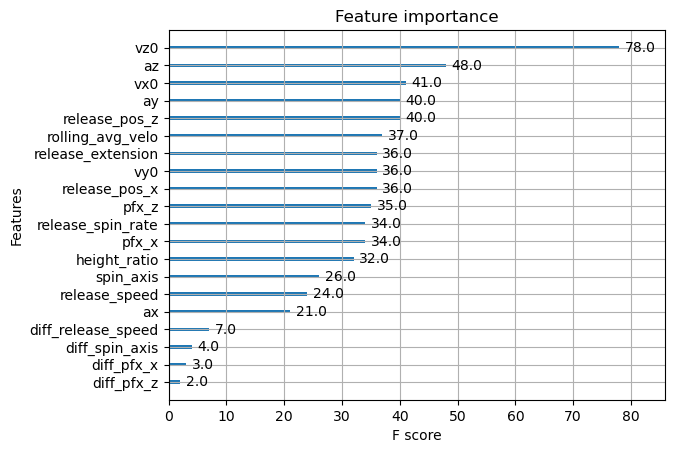

In [18]:
xgb.plot_importance(model)
plt.show()

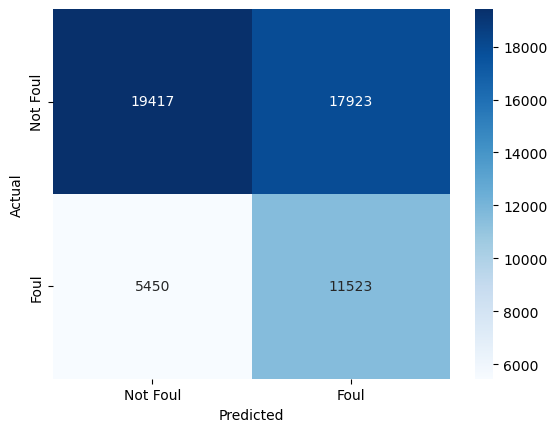

In [19]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [22]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio,
        'device': 'gpu'
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [23]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 11:18:53,315] A new study created in memory with name: no-name-7e7329a8-7edc-4cb1-b291-f859cf464dec


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68920
[2]	eval-logloss:0.68717
[3]	eval-logloss:0.68665
[4]	eval-logloss:0.68545
[5]	eval-logloss:0.68511
[6]	eval-logloss:0.68404
[7]	eval-logloss:0.68330
[8]	eval-logloss:0.68278
[9]	eval-logloss:0.68199
[10]	eval-logloss:0.68156
[11]	eval-logloss:0.68130
[12]	eval-logloss:0.68080
[13]	eval-logloss:0.68063
[14]	eval-logloss:0.67996
[15]	eval-logloss:0.67945
[16]	eval-logloss:0.67892
[17]	eval-logloss:0.67843
[18]	eval-logloss:0.67794
[19]	eval-logloss:0.67767
[20]	eval-logloss:0.67722
[21]	eval-logloss:0.67725
[22]	eval-logloss:0.67693
[23]	eval-logloss:0.67665
[24]	eval-logloss:0.67615
[25]	eval-logloss:0.67578
[26]	eval-logloss:0.67528
[27]	eval-logloss:0.67516
[28]	eval-logloss:0.67480
[29]	eval-logloss:0.67455
[30]	eval-logloss:0.67429
[31]	eval-logloss:0.67373
[32]	eval-logloss:0.67342
[33]	eval-logloss:0.67317
[34]	eval-logloss:0.67293
[35]	eval-logloss:0.67264
[36]	eval-logloss:0.67250
[37]	eval-logloss:0.67219
[38]	eval-logloss:0.67

[I 2023-11-15 11:18:54,658] Trial 0 finished with value: 0.6581403708857614 and parameters: {'max_depth': 3, 'eta': 0.2511069772638074, 'subsample': 0.8195633519666188, 'colsample_bytree': 0.8834193793236259}. Best is trial 0 with value: 0.6581403708857614.


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66293
[2]	eval-logloss:0.65095
[3]	eval-logloss:0.64184
[4]	eval-logloss:0.63623
[5]	eval-logloss:0.63125
[6]	eval-logloss:0.62068
[7]	eval-logloss:0.61276
[8]	eval-logloss:0.60535
[9]	eval-logloss:0.59663
[10]	eval-logloss:0.59059
[11]	eval-logloss:0.58658
[12]	eval-logloss:0.57947
[13]	eval-logloss:0.57346
[14]	eval-logloss:0.56870
[15]	eval-logloss:0.56582
[16]	eval-logloss:0.56267
[17]	eval-logloss:0.55903
[18]	eval-logloss:0.55602
[19]	eval-logloss:0.55348
[20]	eval-logloss:0.54942
[21]	eval-logloss:0.54673
[22]	eval-logloss:0.54441
[23]	eval-logloss:0.54088
[24]	eval-logloss:0.53712
[25]	eval-logloss:0.53507
[26]	eval-logloss:0.53051
[27]	eval-logloss:0.52700
[28]	eval-logloss:0.52246
[29]	eval-logloss:0.51889
[30]	eval-logloss:0.51524
[31]	eval-logloss:0.51225
[32]	eval-logloss:0.50640
[33]	eval-logloss:0.50345
[34]	eval-logloss:0.49901
[35]	eval-logloss:0.49266
[36]	eval-logloss:0.48818
[37]	eval-logloss:0.48352
[38]	eval-logloss:0.48

[I 2023-11-15 11:18:56,687] Trial 1 finished with value: 0.3371670017285729 and parameters: {'max_depth': 9, 'eta': 0.2390285477638453, 'subsample': 0.625177144334824, 'colsample_bytree': 0.7872206875310912}. Best is trial 1 with value: 0.3371670017285729.


[0]	eval-logloss:0.68609
[1]	eval-logloss:0.68271
[2]	eval-logloss:0.67766
[3]	eval-logloss:0.67463
[4]	eval-logloss:0.67244
[5]	eval-logloss:0.67016
[6]	eval-logloss:0.66639
[7]	eval-logloss:0.66341
[8]	eval-logloss:0.66100
[9]	eval-logloss:0.65869
[10]	eval-logloss:0.65685
[11]	eval-logloss:0.65525
[12]	eval-logloss:0.65371
[13]	eval-logloss:0.65242
[14]	eval-logloss:0.64994
[15]	eval-logloss:0.64825
[16]	eval-logloss:0.64637
[17]	eval-logloss:0.64477
[18]	eval-logloss:0.64347
[19]	eval-logloss:0.64202
[20]	eval-logloss:0.64049
[21]	eval-logloss:0.63882
[22]	eval-logloss:0.63681
[23]	eval-logloss:0.63589
[24]	eval-logloss:0.63345
[25]	eval-logloss:0.63076
[26]	eval-logloss:0.62956
[27]	eval-logloss:0.62802
[28]	eval-logloss:0.62625
[29]	eval-logloss:0.62508
[30]	eval-logloss:0.62336
[31]	eval-logloss:0.62204
[32]	eval-logloss:0.62099
[33]	eval-logloss:0.61862
[34]	eval-logloss:0.61739
[35]	eval-logloss:0.61668
[36]	eval-logloss:0.61484
[37]	eval-logloss:0.61411
[38]	eval-logloss:0.61

[I 2023-11-15 11:18:57,843] Trial 2 finished with value: 0.5361649791680839 and parameters: {'max_depth': 6, 'eta': 0.253190152004652, 'subsample': 0.8401250021964608, 'colsample_bytree': 0.8338026775359867}. Best is trial 1 with value: 0.3371670017285729.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68845
[2]	eval-logloss:0.68578
[3]	eval-logloss:0.68416
[4]	eval-logloss:0.68286
[5]	eval-logloss:0.68155
[6]	eval-logloss:0.67945
[7]	eval-logloss:0.67760
[8]	eval-logloss:0.67584
[9]	eval-logloss:0.67413
[10]	eval-logloss:0.67331
[11]	eval-logloss:0.67233
[12]	eval-logloss:0.67084
[13]	eval-logloss:0.66970
[14]	eval-logloss:0.66841
[15]	eval-logloss:0.66729
[16]	eval-logloss:0.66625
[17]	eval-logloss:0.66507
[18]	eval-logloss:0.66394
[19]	eval-logloss:0.66322
[20]	eval-logloss:0.66211
[21]	eval-logloss:0.66112
[22]	eval-logloss:0.66004
[23]	eval-logloss:0.65921
[24]	eval-logloss:0.65839
[25]	eval-logloss:0.65797
[26]	eval-logloss:0.65704
[27]	eval-logloss:0.65615
[28]	eval-logloss:0.65522
[29]	eval-logloss:0.65432
[30]	eval-logloss:0.65365
[31]	eval-logloss:0.65284
[32]	eval-logloss:0.65197
[33]	eval-logloss:0.65119
[34]	eval-logloss:0.65036
[35]	eval-logloss:0.64940
[36]	eval-logloss:0.64892
[37]	eval-logloss:0.64852
[38]	eval-logloss:0.64

[I 2023-11-15 11:18:58,980] Trial 3 finished with value: 0.6112006166294484 and parameters: {'max_depth': 6, 'eta': 0.10078800239776889, 'subsample': 0.6635231579668847, 'colsample_bytree': 0.6955444627319068}. Best is trial 1 with value: 0.3371670017285729.


[0]	eval-logloss:0.67781
[1]	eval-logloss:0.66441
[2]	eval-logloss:0.65423
[3]	eval-logloss:0.64717
[4]	eval-logloss:0.63848
[5]	eval-logloss:0.62975
[6]	eval-logloss:0.62296
[7]	eval-logloss:0.61609
[8]	eval-logloss:0.60937
[9]	eval-logloss:0.60292
[10]	eval-logloss:0.59976
[11]	eval-logloss:0.59586
[12]	eval-logloss:0.59121
[13]	eval-logloss:0.58860
[14]	eval-logloss:0.58479
[15]	eval-logloss:0.58057
[16]	eval-logloss:0.57571
[17]	eval-logloss:0.57001
[18]	eval-logloss:0.56544
[19]	eval-logloss:0.56342
[20]	eval-logloss:0.56211
[21]	eval-logloss:0.55922
[22]	eval-logloss:0.55513
[23]	eval-logloss:0.55229
[24]	eval-logloss:0.54979
[25]	eval-logloss:0.54581
[26]	eval-logloss:0.54276
[27]	eval-logloss:0.54020
[28]	eval-logloss:0.53808
[29]	eval-logloss:0.53421
[30]	eval-logloss:0.52993
[31]	eval-logloss:0.52715
[32]	eval-logloss:0.52539
[33]	eval-logloss:0.52182
[34]	eval-logloss:0.51896
[35]	eval-logloss:0.51480
[36]	eval-logloss:0.51258
[37]	eval-logloss:0.50885
[38]	eval-logloss:0.50

[I 2023-11-15 11:19:01,084] Trial 4 finished with value: 0.37278275235321856 and parameters: {'max_depth': 9, 'eta': 0.18419771948241023, 'subsample': 0.8855979984232096, 'colsample_bytree': 0.9742129191131054}. Best is trial 1 with value: 0.3371670017285729.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68934
[2]	eval-logloss:0.68740
[3]	eval-logloss:0.68668
[4]	eval-logloss:0.68613
[5]	eval-logloss:0.68586
[6]	eval-logloss:0.68453
[7]	eval-logloss:0.68351
[8]	eval-logloss:0.68285
[9]	eval-logloss:0.68179
[10]	eval-logloss:0.68159
[11]	eval-logloss:0.68128
[12]	eval-logloss:0.68083
[13]	eval-logloss:0.68046
[14]	eval-logloss:0.67965
[15]	eval-logloss:0.67924
[16]	eval-logloss:0.67879
[17]	eval-logloss:0.67846
[18]	eval-logloss:0.67811
[19]	eval-logloss:0.67755
[20]	eval-logloss:0.67714
[21]	eval-logloss:0.67691
[22]	eval-logloss:0.67649
[23]	eval-logloss:0.67626
[24]	eval-logloss:0.67564
[25]	eval-logloss:0.67504
[26]	eval-logloss:0.67458
[27]	eval-logloss:0.67436
[28]	eval-logloss:0.67419
[29]	eval-logloss:0.67396
[30]	eval-logloss:0.67355
[31]	eval-logloss:0.67304
[32]	eval-logloss:0.67258
[33]	eval-logloss:0.67257
[34]	eval-logloss:0.67223
[35]	eval-logloss:0.67208
[36]	eval-logloss:0.67176
[37]	eval-logloss:0.67132
[38]	eval-logloss:0.67

[I 2023-11-15 11:19:01,955] Trial 5 finished with value: 0.6572820298334527 and parameters: {'max_depth': 3, 'eta': 0.2653562464589547, 'subsample': 0.8786421857245634, 'colsample_bytree': 0.7334785446456347}. Best is trial 1 with value: 0.3371670017285729.


[0]	eval-logloss:0.68845
[1]	eval-logloss:0.68565
[2]	eval-logloss:0.68125
[3]	eval-logloss:0.67882
[4]	eval-logloss:0.67556
[5]	eval-logloss:0.67335
[6]	eval-logloss:0.67036
[7]	eval-logloss:0.66802
[8]	eval-logloss:0.66582
[9]	eval-logloss:0.66341
[10]	eval-logloss:0.66146
[11]	eval-logloss:0.66039
[12]	eval-logloss:0.65783
[13]	eval-logloss:0.65574
[14]	eval-logloss:0.65417
[15]	eval-logloss:0.65292
[16]	eval-logloss:0.65132
[17]	eval-logloss:0.64954
[18]	eval-logloss:0.64833
[19]	eval-logloss:0.64705
[20]	eval-logloss:0.64542
[21]	eval-logloss:0.64392
[22]	eval-logloss:0.64248
[23]	eval-logloss:0.64084
[24]	eval-logloss:0.63947
[25]	eval-logloss:0.63834
[26]	eval-logloss:0.63710
[27]	eval-logloss:0.63639
[28]	eval-logloss:0.63531
[29]	eval-logloss:0.63463
[30]	eval-logloss:0.63389
[31]	eval-logloss:0.63305
[32]	eval-logloss:0.63190
[33]	eval-logloss:0.62993
[34]	eval-logloss:0.62864
[35]	eval-logloss:0.62695
[36]	eval-logloss:0.62526
[37]	eval-logloss:0.62400
[38]	eval-logloss:0.62

[I 2023-11-15 11:19:03,299] Trial 6 finished with value: 0.5652489343904002 and parameters: {'max_depth': 7, 'eta': 0.10867538839794039, 'subsample': 0.6106509554467714, 'colsample_bytree': 0.8667650136595435}. Best is trial 1 with value: 0.3371670017285729.


[0]	eval-logloss:0.68376
[1]	eval-logloss:0.67740
[2]	eval-logloss:0.66871
[3]	eval-logloss:0.66407
[4]	eval-logloss:0.65753
[5]	eval-logloss:0.65066
[6]	eval-logloss:0.64526
[7]	eval-logloss:0.64065
[8]	eval-logloss:0.63542
[9]	eval-logloss:0.63004
[10]	eval-logloss:0.62685
[11]	eval-logloss:0.62427
[12]	eval-logloss:0.62035
[13]	eval-logloss:0.61626
[14]	eval-logloss:0.61220
[15]	eval-logloss:0.60941
[16]	eval-logloss:0.60599
[17]	eval-logloss:0.60208
[18]	eval-logloss:0.59943
[19]	eval-logloss:0.59757
[20]	eval-logloss:0.59371
[21]	eval-logloss:0.59095
[22]	eval-logloss:0.58801
[23]	eval-logloss:0.58556
[24]	eval-logloss:0.58389
[25]	eval-logloss:0.58141
[26]	eval-logloss:0.57873
[27]	eval-logloss:0.57706
[28]	eval-logloss:0.57577
[29]	eval-logloss:0.57279
[30]	eval-logloss:0.57174
[31]	eval-logloss:0.56907
[32]	eval-logloss:0.56532
[33]	eval-logloss:0.56300
[34]	eval-logloss:0.56079
[35]	eval-logloss:0.55907
[36]	eval-logloss:0.55720
[37]	eval-logloss:0.55543
[38]	eval-logloss:0.55

[I 2023-11-15 11:19:05,330] Trial 7 finished with value: 0.45168128538697805 and parameters: {'max_depth': 9, 'eta': 0.114067252709284, 'subsample': 0.6157630873691634, 'colsample_bytree': 0.9251912867820151}. Best is trial 1 with value: 0.3371670017285729.


[0]	eval-logloss:0.68900
[1]	eval-logloss:0.68611
[2]	eval-logloss:0.68237
[3]	eval-logloss:0.68010
[4]	eval-logloss:0.67816
[5]	eval-logloss:0.67586
[6]	eval-logloss:0.67264
[7]	eval-logloss:0.66970
[8]	eval-logloss:0.66672
[9]	eval-logloss:0.66391
[10]	eval-logloss:0.66162
[11]	eval-logloss:0.66009
[12]	eval-logloss:0.65758
[13]	eval-logloss:0.65533
[14]	eval-logloss:0.65311
[15]	eval-logloss:0.65161
[16]	eval-logloss:0.64981
[17]	eval-logloss:0.64790
[18]	eval-logloss:0.64590
[19]	eval-logloss:0.64430
[20]	eval-logloss:0.64192
[21]	eval-logloss:0.64011
[22]	eval-logloss:0.63837
[23]	eval-logloss:0.63667
[24]	eval-logloss:0.63449
[25]	eval-logloss:0.63263
[26]	eval-logloss:0.63125
[27]	eval-logloss:0.62924
[28]	eval-logloss:0.62782
[29]	eval-logloss:0.62588
[30]	eval-logloss:0.62511
[31]	eval-logloss:0.62341
[32]	eval-logloss:0.62221
[33]	eval-logloss:0.62067
[34]	eval-logloss:0.61917
[35]	eval-logloss:0.61768
[36]	eval-logloss:0.61600
[37]	eval-logloss:0.61495
[38]	eval-logloss:0.61

[I 2023-11-15 11:19:07,013] Trial 8 finished with value: 0.5602637312566932 and parameters: {'max_depth': 8, 'eta': 0.06600456812143714, 'subsample': 0.8816686013472906, 'colsample_bytree': 0.7688652482937876}. Best is trial 1 with value: 0.3371670017285729.


[0]	eval-logloss:0.68576
[1]	eval-logloss:0.68082
[2]	eval-logloss:0.67457
[3]	eval-logloss:0.67055
[4]	eval-logloss:0.66701
[5]	eval-logloss:0.66303
[6]	eval-logloss:0.65758
[7]	eval-logloss:0.65268
[8]	eval-logloss:0.64828
[9]	eval-logloss:0.64448
[10]	eval-logloss:0.64218
[11]	eval-logloss:0.63991
[12]	eval-logloss:0.63679
[13]	eval-logloss:0.63415
[14]	eval-logloss:0.63134
[15]	eval-logloss:0.62958
[16]	eval-logloss:0.62701
[17]	eval-logloss:0.62363
[18]	eval-logloss:0.62160
[19]	eval-logloss:0.62061
[20]	eval-logloss:0.61761
[21]	eval-logloss:0.61550
[22]	eval-logloss:0.61330
[23]	eval-logloss:0.61150
[24]	eval-logloss:0.60915
[25]	eval-logloss:0.60696
[26]	eval-logloss:0.60484
[27]	eval-logloss:0.60274
[28]	eval-logloss:0.60188
[29]	eval-logloss:0.60050
[30]	eval-logloss:0.59931
[31]	eval-logloss:0.59664
[32]	eval-logloss:0.59430
[33]	eval-logloss:0.59230
[34]	eval-logloss:0.59085
[35]	eval-logloss:0.58921
[36]	eval-logloss:0.58833
[37]	eval-logloss:0.58703
[38]	eval-logloss:0.58

[I 2023-11-15 11:19:08,640] Trial 9 finished with value: 0.495074889942964 and parameters: {'max_depth': 8, 'eta': 0.13239826135240582, 'subsample': 0.6608510890990028, 'colsample_bytree': 0.8391468802084275}. Best is trial 1 with value: 0.3371670017285729.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69259
[3]	eval-logloss:0.69245
[4]	eval-logloss:0.69233
[5]	eval-logloss:0.69219
[6]	eval-logloss:0.69207
[7]	eval-logloss:0.69180
[8]	eval-logloss:0.69155
[9]	eval-logloss:0.69129
[10]	eval-logloss:0.69118
[11]	eval-logloss:0.69107
[12]	eval-logloss:0.69082
[13]	eval-logloss:0.69059
[14]	eval-logloss:0.69035
[15]	eval-logloss:0.69022
[16]	eval-logloss:0.69008
[17]	eval-logloss:0.68982
[18]	eval-logloss:0.68960
[19]	eval-logloss:0.68948
[20]	eval-logloss:0.68925
[21]	eval-logloss:0.68905
[22]	eval-logloss:0.68884
[23]	eval-logloss:0.68862
[24]	eval-logloss:0.68840
[25]	eval-logloss:0.68829
[26]	eval-logloss:0.68818
[27]	eval-logloss:0.68797
[28]	eval-logloss:0.68789
[29]	eval-logloss:0.68766
[30]	eval-logloss:0.68755
[31]	eval-logloss:0.68746
[32]	eval-logloss:0.68723
[33]	eval-logloss:0.68711
[34]	eval-logloss:0.68692
[35]	eval-logloss:0.68680
[36]	eval-logloss:0.68660
[37]	eval-logloss:0.68641
[38]	eval-logloss:0.68

[I 2023-11-15 11:19:09,726] Trial 10 finished with value: 0.6786022209507357 and parameters: {'max_depth': 5, 'eta': 0.0124383633218145, 'subsample': 0.736785099536928, 'colsample_bytree': 0.5999282027088308}. Best is trial 1 with value: 0.3371670017285729.


[0]	eval-logloss:0.68221
[1]	eval-logloss:0.67178
[2]	eval-logloss:0.66328
[3]	eval-logloss:0.65685
[4]	eval-logloss:0.65021
[5]	eval-logloss:0.64443
[6]	eval-logloss:0.63953
[7]	eval-logloss:0.63488
[8]	eval-logloss:0.62965
[9]	eval-logloss:0.62581
[10]	eval-logloss:0.62310
[11]	eval-logloss:0.61947
[12]	eval-logloss:0.61477
[13]	eval-logloss:0.61181
[14]	eval-logloss:0.60867
[15]	eval-logloss:0.60544
[16]	eval-logloss:0.60084
[17]	eval-logloss:0.59752
[18]	eval-logloss:0.59502
[19]	eval-logloss:0.59278
[20]	eval-logloss:0.59107
[21]	eval-logloss:0.58903
[22]	eval-logloss:0.58592
[23]	eval-logloss:0.58322
[24]	eval-logloss:0.58020
[25]	eval-logloss:0.57769
[26]	eval-logloss:0.57510
[27]	eval-logloss:0.57217
[28]	eval-logloss:0.57045
[29]	eval-logloss:0.56828
[30]	eval-logloss:0.56582
[31]	eval-logloss:0.56360
[32]	eval-logloss:0.56151
[33]	eval-logloss:0.55931
[34]	eval-logloss:0.55777
[35]	eval-logloss:0.55617
[36]	eval-logloss:0.55476
[37]	eval-logloss:0.55325
[38]	eval-logloss:0.55

[I 2023-11-15 11:19:11,378] Trial 11 finished with value: 0.4370144067227019 and parameters: {'max_depth': 8, 'eta': 0.1919400582292989, 'subsample': 0.7613833812262704, 'colsample_bytree': 0.9881754321532318}. Best is trial 1 with value: 0.3371670017285729.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.66496
[2]	eval-logloss:0.65347
[3]	eval-logloss:0.64321
[4]	eval-logloss:0.63418
[5]	eval-logloss:0.62554
[6]	eval-logloss:0.61871
[7]	eval-logloss:0.61219
[8]	eval-logloss:0.60548
[9]	eval-logloss:0.59895
[10]	eval-logloss:0.59515
[11]	eval-logloss:0.58999
[12]	eval-logloss:0.58681
[13]	eval-logloss:0.58328
[14]	eval-logloss:0.57885
[15]	eval-logloss:0.57593
[16]	eval-logloss:0.57104
[17]	eval-logloss:0.56768
[18]	eval-logloss:0.56654
[19]	eval-logloss:0.56227
[20]	eval-logloss:0.55824
[21]	eval-logloss:0.55471
[22]	eval-logloss:0.55094
[23]	eval-logloss:0.54761
[24]	eval-logloss:0.54463
[25]	eval-logloss:0.54042
[26]	eval-logloss:0.53805
[27]	eval-logloss:0.53641
[28]	eval-logloss:0.53327
[29]	eval-logloss:0.53056
[30]	eval-logloss:0.52512
[31]	eval-logloss:0.52281
[32]	eval-logloss:0.51935
[33]	eval-logloss:0.51715
[34]	eval-logloss:0.51413
[35]	eval-logloss:0.51017
[36]	eval-logloss:0.50813
[37]	eval-logloss:0.50632
[38]	eval-logloss:0.50

[I 2023-11-15 11:19:13,438] Trial 12 finished with value: 0.3592235981767286 and parameters: {'max_depth': 9, 'eta': 0.19893156853458074, 'subsample': 0.7558318660440533, 'colsample_bytree': 0.9861994022193125}. Best is trial 1 with value: 0.3371670017285729.


[0]	eval-logloss:0.67562
[1]	eval-logloss:0.66548
[2]	eval-logloss:0.65621
[3]	eval-logloss:0.64602
[4]	eval-logloss:0.63727
[5]	eval-logloss:0.63189
[6]	eval-logloss:0.62720
[7]	eval-logloss:0.61497
[8]	eval-logloss:0.60436
[9]	eval-logloss:0.59446
[10]	eval-logloss:0.58956
[11]	eval-logloss:0.58282
[12]	eval-logloss:0.57331
[13]	eval-logloss:0.56543
[14]	eval-logloss:0.55886
[15]	eval-logloss:0.55534
[16]	eval-logloss:0.55143
[17]	eval-logloss:0.54618
[18]	eval-logloss:0.54284
[19]	eval-logloss:0.53697
[20]	eval-logloss:0.53510
[21]	eval-logloss:0.53220
[22]	eval-logloss:0.52566
[23]	eval-logloss:0.52128
[24]	eval-logloss:0.51970
[25]	eval-logloss:0.51421
[26]	eval-logloss:0.51019
[27]	eval-logloss:0.50392
[28]	eval-logloss:0.50122
[29]	eval-logloss:0.49759
[30]	eval-logloss:0.49417
[31]	eval-logloss:0.49151
[32]	eval-logloss:0.48988
[33]	eval-logloss:0.48418
[34]	eval-logloss:0.48166
[35]	eval-logloss:0.47669
[36]	eval-logloss:0.47168
[37]	eval-logloss:0.46954
[38]	eval-logloss:0.46

[I 2023-11-15 11:19:15,410] Trial 13 finished with value: 0.3050124588363568 and parameters: {'max_depth': 9, 'eta': 0.2937168511925974, 'subsample': 0.7394628675023771, 'colsample_bytree': 0.5130162608383229}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.67876
[2]	eval-logloss:0.67386
[3]	eval-logloss:0.66935
[4]	eval-logloss:0.66517
[5]	eval-logloss:0.66261
[6]	eval-logloss:0.65944
[7]	eval-logloss:0.65408
[8]	eval-logloss:0.64967
[9]	eval-logloss:0.64472
[10]	eval-logloss:0.64251
[11]	eval-logloss:0.64020
[12]	eval-logloss:0.63490
[13]	eval-logloss:0.63105
[14]	eval-logloss:0.62812
[15]	eval-logloss:0.62583
[16]	eval-logloss:0.62361
[17]	eval-logloss:0.62094
[18]	eval-logloss:0.61839
[19]	eval-logloss:0.61611
[20]	eval-logloss:0.61474
[21]	eval-logloss:0.61232
[22]	eval-logloss:0.60882
[23]	eval-logloss:0.60600
[24]	eval-logloss:0.60263
[25]	eval-logloss:0.60048
[26]	eval-logloss:0.59823
[27]	eval-logloss:0.59551
[28]	eval-logloss:0.59470
[29]	eval-logloss:0.59346
[30]	eval-logloss:0.59001
[31]	eval-logloss:0.58852
[32]	eval-logloss:0.58779
[33]	eval-logloss:0.58600
[34]	eval-logloss:0.58496
[35]	eval-logloss:0.58242
[36]	eval-logloss:0.58043
[37]	eval-logloss:0.57871
[38]	eval-logloss:0.57

[I 2023-11-15 11:19:16,723] Trial 14 finished with value: 0.46682221966327414 and parameters: {'max_depth': 7, 'eta': 0.29775129015034607, 'subsample': 0.7021910064416085, 'colsample_bytree': 0.5314458306866859}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.68754
[1]	eval-logloss:0.68488
[2]	eval-logloss:0.68327
[3]	eval-logloss:0.68141
[4]	eval-logloss:0.68033
[5]	eval-logloss:0.67933
[6]	eval-logloss:0.67726
[7]	eval-logloss:0.67389
[8]	eval-logloss:0.67158
[9]	eval-logloss:0.66943
[10]	eval-logloss:0.66825
[11]	eval-logloss:0.66701
[12]	eval-logloss:0.66530
[13]	eval-logloss:0.66385
[14]	eval-logloss:0.66193
[15]	eval-logloss:0.66070
[16]	eval-logloss:0.65985
[17]	eval-logloss:0.65875
[18]	eval-logloss:0.65784
[19]	eval-logloss:0.65669
[20]	eval-logloss:0.65552
[21]	eval-logloss:0.65450
[22]	eval-logloss:0.65317
[23]	eval-logloss:0.65228
[24]	eval-logloss:0.65140
[25]	eval-logloss:0.65033
[26]	eval-logloss:0.64893
[27]	eval-logloss:0.64791
[28]	eval-logloss:0.64655
[29]	eval-logloss:0.64569
[30]	eval-logloss:0.64476
[31]	eval-logloss:0.64371
[32]	eval-logloss:0.64274
[33]	eval-logloss:0.64208
[34]	eval-logloss:0.64130
[35]	eval-logloss:0.64029
[36]	eval-logloss:0.63935
[37]	eval-logloss:0.63848
[38]	eval-logloss:0.63

[I 2023-11-15 11:19:17,747] Trial 15 finished with value: 0.5878100888162742 and parameters: {'max_depth': 5, 'eta': 0.29412953318063756, 'subsample': 0.6974394284262166, 'colsample_bytree': 0.6026120708873612}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.68121
[2]	eval-logloss:0.67801
[3]	eval-logloss:0.67358
[4]	eval-logloss:0.67103
[5]	eval-logloss:0.66818
[6]	eval-logloss:0.66536
[7]	eval-logloss:0.66074
[8]	eval-logloss:0.65701
[9]	eval-logloss:0.65445
[10]	eval-logloss:0.65314
[11]	eval-logloss:0.65012
[12]	eval-logloss:0.64595
[13]	eval-logloss:0.64224
[14]	eval-logloss:0.63897
[15]	eval-logloss:0.63570
[16]	eval-logloss:0.63273
[17]	eval-logloss:0.62953
[18]	eval-logloss:0.62790
[19]	eval-logloss:0.62581
[20]	eval-logloss:0.62355
[21]	eval-logloss:0.62235
[22]	eval-logloss:0.62008
[23]	eval-logloss:0.61834
[24]	eval-logloss:0.61630
[25]	eval-logloss:0.61483
[26]	eval-logloss:0.61243
[27]	eval-logloss:0.61034
[28]	eval-logloss:0.60802
[29]	eval-logloss:0.60641
[30]	eval-logloss:0.60388
[31]	eval-logloss:0.60328
[32]	eval-logloss:0.60133
[33]	eval-logloss:0.59831
[34]	eval-logloss:0.59668
[35]	eval-logloss:0.59492
[36]	eval-logloss:0.59321
[37]	eval-logloss:0.59168
[38]	eval-logloss:0.59

[I 2023-11-15 11:19:19,034] Trial 16 finished with value: 0.5041908038406381 and parameters: {'max_depth': 7, 'eta': 0.22650551523647713, 'subsample': 0.6043858430839572, 'colsample_bytree': 0.511618816427727}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.66623
[2]	eval-logloss:0.65766
[3]	eval-logloss:0.64962
[4]	eval-logloss:0.64396
[5]	eval-logloss:0.63718
[6]	eval-logloss:0.63117
[7]	eval-logloss:0.62184
[8]	eval-logloss:0.61339
[9]	eval-logloss:0.60626
[10]	eval-logloss:0.60028
[11]	eval-logloss:0.59536
[12]	eval-logloss:0.58729
[13]	eval-logloss:0.57996
[14]	eval-logloss:0.57355
[15]	eval-logloss:0.57092
[16]	eval-logloss:0.56907
[17]	eval-logloss:0.56189
[18]	eval-logloss:0.55792
[19]	eval-logloss:0.55276
[20]	eval-logloss:0.55058
[21]	eval-logloss:0.54395
[22]	eval-logloss:0.54017
[23]	eval-logloss:0.53676
[24]	eval-logloss:0.53235
[25]	eval-logloss:0.52781
[26]	eval-logloss:0.52413
[27]	eval-logloss:0.52191
[28]	eval-logloss:0.51999
[29]	eval-logloss:0.51551
[30]	eval-logloss:0.51081
[31]	eval-logloss:0.50656
[32]	eval-logloss:0.50385
[33]	eval-logloss:0.50013
[34]	eval-logloss:0.49859
[35]	eval-logloss:0.49456
[36]	eval-logloss:0.49158
[37]	eval-logloss:0.48936
[38]	eval-logloss:0.48

[I 2023-11-15 11:19:20,980] Trial 17 finished with value: 0.3477686223433017 and parameters: {'max_depth': 9, 'eta': 0.22154508169973136, 'subsample': 0.7964178692033556, 'colsample_bytree': 0.677479350814215}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.68407
[1]	eval-logloss:0.67793
[2]	eval-logloss:0.67000
[3]	eval-logloss:0.66541
[4]	eval-logloss:0.66200
[5]	eval-logloss:0.65702
[6]	eval-logloss:0.65046
[7]	eval-logloss:0.64592
[8]	eval-logloss:0.64063
[9]	eval-logloss:0.63637
[10]	eval-logloss:0.63356
[11]	eval-logloss:0.63107
[12]	eval-logloss:0.62759
[13]	eval-logloss:0.62463
[14]	eval-logloss:0.62204
[15]	eval-logloss:0.62017
[16]	eval-logloss:0.61738
[17]	eval-logloss:0.61449
[18]	eval-logloss:0.61239
[19]	eval-logloss:0.61017
[20]	eval-logloss:0.60698
[21]	eval-logloss:0.60409
[22]	eval-logloss:0.60267
[23]	eval-logloss:0.60090
[24]	eval-logloss:0.59897
[25]	eval-logloss:0.59718
[26]	eval-logloss:0.59338
[27]	eval-logloss:0.59078
[28]	eval-logloss:0.58928
[29]	eval-logloss:0.58718
[30]	eval-logloss:0.58569
[31]	eval-logloss:0.58408
[32]	eval-logloss:0.58089
[33]	eval-logloss:0.57850
[34]	eval-logloss:0.57512
[35]	eval-logloss:0.57393
[36]	eval-logloss:0.57272
[37]	eval-logloss:0.57160
[38]	eval-logloss:0.57

[I 2023-11-15 11:19:22,651] Trial 18 finished with value: 0.4722414056574314 and parameters: {'max_depth': 8, 'eta': 0.16454492607314233, 'subsample': 0.6583021794885624, 'colsample_bytree': 0.7989351904321563}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68749
[2]	eval-logloss:0.68496
[3]	eval-logloss:0.68364
[4]	eval-logloss:0.68300
[5]	eval-logloss:0.68237
[6]	eval-logloss:0.68061
[7]	eval-logloss:0.67904
[8]	eval-logloss:0.67818
[9]	eval-logloss:0.67729
[10]	eval-logloss:0.67619
[11]	eval-logloss:0.67556
[12]	eval-logloss:0.67466
[13]	eval-logloss:0.67395
[14]	eval-logloss:0.67299
[15]	eval-logloss:0.67209
[16]	eval-logloss:0.67127
[17]	eval-logloss:0.67066
[18]	eval-logloss:0.66991
[19]	eval-logloss:0.66923
[20]	eval-logloss:0.66829
[21]	eval-logloss:0.66820
[22]	eval-logloss:0.66746
[23]	eval-logloss:0.66695
[24]	eval-logloss:0.66625
[25]	eval-logloss:0.66588
[26]	eval-logloss:0.66520
[27]	eval-logloss:0.66515
[28]	eval-logloss:0.66464
[29]	eval-logloss:0.66409
[30]	eval-logloss:0.66346
[31]	eval-logloss:0.66300
[32]	eval-logloss:0.66218
[33]	eval-logloss:0.66193
[34]	eval-logloss:0.66140
[35]	eval-logloss:0.66067
[36]	eval-logloss:0.66032
[37]	eval-logloss:0.66006
[38]	eval-logloss:0.65

[I 2023-11-15 11:19:23,648] Trial 19 finished with value: 0.6326156723392078 and parameters: {'max_depth': 4, 'eta': 0.2719898745553639, 'subsample': 0.720671583457292, 'colsample_bytree': 0.7422940843801753}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.68430
[1]	eval-logloss:0.67925
[2]	eval-logloss:0.67555
[3]	eval-logloss:0.67147
[4]	eval-logloss:0.66853
[5]	eval-logloss:0.66572
[6]	eval-logloss:0.66150
[7]	eval-logloss:0.65614
[8]	eval-logloss:0.65169
[9]	eval-logloss:0.64741
[10]	eval-logloss:0.64377
[11]	eval-logloss:0.64097
[12]	eval-logloss:0.63716
[13]	eval-logloss:0.63399
[14]	eval-logloss:0.63064
[15]	eval-logloss:0.62877
[16]	eval-logloss:0.62653
[17]	eval-logloss:0.62354
[18]	eval-logloss:0.62116
[19]	eval-logloss:0.61829
[20]	eval-logloss:0.61648
[21]	eval-logloss:0.61452
[22]	eval-logloss:0.61246
[23]	eval-logloss:0.61035
[24]	eval-logloss:0.60777
[25]	eval-logloss:0.60488
[26]	eval-logloss:0.60256
[27]	eval-logloss:0.60165
[28]	eval-logloss:0.59894
[29]	eval-logloss:0.59719
[30]	eval-logloss:0.59515
[31]	eval-logloss:0.59343
[32]	eval-logloss:0.59195
[33]	eval-logloss:0.59005
[34]	eval-logloss:0.58896
[35]	eval-logloss:0.58736
[36]	eval-logloss:0.58517
[37]	eval-logloss:0.58320
[38]	eval-logloss:0.58

[I 2023-11-15 11:19:25,010] Trial 20 finished with value: 0.4873168630300408 and parameters: {'max_depth': 7, 'eta': 0.22846449771991997, 'subsample': 0.7761089828293534, 'colsample_bytree': 0.6452926162863982}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.67686
[1]	eval-logloss:0.66624
[2]	eval-logloss:0.65344
[3]	eval-logloss:0.64429
[4]	eval-logloss:0.63688
[5]	eval-logloss:0.63083
[6]	eval-logloss:0.62074
[7]	eval-logloss:0.61131
[8]	eval-logloss:0.60345
[9]	eval-logloss:0.59723
[10]	eval-logloss:0.59354
[11]	eval-logloss:0.58946
[12]	eval-logloss:0.58315
[13]	eval-logloss:0.57852
[14]	eval-logloss:0.57223
[15]	eval-logloss:0.56958
[16]	eval-logloss:0.56453
[17]	eval-logloss:0.55966
[18]	eval-logloss:0.55638
[19]	eval-logloss:0.55149
[20]	eval-logloss:0.54793
[21]	eval-logloss:0.54323
[22]	eval-logloss:0.54087
[23]	eval-logloss:0.53759
[24]	eval-logloss:0.53584
[25]	eval-logloss:0.53266
[26]	eval-logloss:0.52944
[27]	eval-logloss:0.52714
[28]	eval-logloss:0.52374
[29]	eval-logloss:0.52196
[30]	eval-logloss:0.51630
[31]	eval-logloss:0.51326
[32]	eval-logloss:0.51022
[33]	eval-logloss:0.50729
[34]	eval-logloss:0.50521
[35]	eval-logloss:0.50108
[36]	eval-logloss:0.49777
[37]	eval-logloss:0.49487
[38]	eval-logloss:0.49

[I 2023-11-15 11:19:26,996] Trial 21 finished with value: 0.33933567578445084 and parameters: {'max_depth': 9, 'eta': 0.225740292331397, 'subsample': 0.7938108431291446, 'colsample_bytree': 0.6963553882197715}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.67592
[1]	eval-logloss:0.66653
[2]	eval-logloss:0.65725
[3]	eval-logloss:0.64739
[4]	eval-logloss:0.64063
[5]	eval-logloss:0.63503
[6]	eval-logloss:0.63191
[7]	eval-logloss:0.61878
[8]	eval-logloss:0.60695
[9]	eval-logloss:0.59675
[10]	eval-logloss:0.59092
[11]	eval-logloss:0.58854
[12]	eval-logloss:0.57857
[13]	eval-logloss:0.56895
[14]	eval-logloss:0.56136
[15]	eval-logloss:0.55763
[16]	eval-logloss:0.55099
[17]	eval-logloss:0.54476
[18]	eval-logloss:0.53941
[19]	eval-logloss:0.53343
[20]	eval-logloss:0.53165
[21]	eval-logloss:0.52368
[22]	eval-logloss:0.52069
[23]	eval-logloss:0.51623
[24]	eval-logloss:0.51205
[25]	eval-logloss:0.50898
[26]	eval-logloss:0.50480
[27]	eval-logloss:0.50226
[28]	eval-logloss:0.49932
[29]	eval-logloss:0.49596
[30]	eval-logloss:0.48960
[31]	eval-logloss:0.48808
[32]	eval-logloss:0.48437
[33]	eval-logloss:0.48146
[34]	eval-logloss:0.47814
[35]	eval-logloss:0.47473
[36]	eval-logloss:0.46857
[37]	eval-logloss:0.46668
[38]	eval-logloss:0.46

[I 2023-11-15 11:19:28,971] Trial 22 finished with value: 0.31546539679660035 and parameters: {'max_depth': 9, 'eta': 0.27716703537859755, 'subsample': 0.7888250862261584, 'colsample_bytree': 0.5643359979007194}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.68004
[1]	eval-logloss:0.67395
[2]	eval-logloss:0.66889
[3]	eval-logloss:0.66293
[4]	eval-logloss:0.65754
[5]	eval-logloss:0.65340
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64100
[8]	eval-logloss:0.63454
[9]	eval-logloss:0.62982
[10]	eval-logloss:0.62605
[11]	eval-logloss:0.62308
[12]	eval-logloss:0.61635
[13]	eval-logloss:0.61027
[14]	eval-logloss:0.60543
[15]	eval-logloss:0.60205
[16]	eval-logloss:0.59853
[17]	eval-logloss:0.59335
[18]	eval-logloss:0.59064
[19]	eval-logloss:0.58753
[20]	eval-logloss:0.58583
[21]	eval-logloss:0.58147
[22]	eval-logloss:0.57954
[23]	eval-logloss:0.57780
[24]	eval-logloss:0.57449
[25]	eval-logloss:0.57114
[26]	eval-logloss:0.56734
[27]	eval-logloss:0.56456
[28]	eval-logloss:0.56310
[29]	eval-logloss:0.56118
[30]	eval-logloss:0.55559
[31]	eval-logloss:0.55275
[32]	eval-logloss:0.54833
[33]	eval-logloss:0.54579
[34]	eval-logloss:0.54381
[35]	eval-logloss:0.54193
[36]	eval-logloss:0.53892
[37]	eval-logloss:0.53637
[38]	eval-logloss:0.53

[I 2023-11-15 11:19:30,531] Trial 23 finished with value: 0.39782259312772744 and parameters: {'max_depth': 8, 'eta': 0.27833864955503845, 'subsample': 0.7343677560344287, 'colsample_bytree': 0.5553706046498104}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.66671
[2]	eval-logloss:0.65896
[3]	eval-logloss:0.64979
[4]	eval-logloss:0.64222
[5]	eval-logloss:0.63813
[6]	eval-logloss:0.63270
[7]	eval-logloss:0.62340
[8]	eval-logloss:0.61466
[9]	eval-logloss:0.60401
[10]	eval-logloss:0.59857
[11]	eval-logloss:0.59156
[12]	eval-logloss:0.58150
[13]	eval-logloss:0.57183
[14]	eval-logloss:0.56335
[15]	eval-logloss:0.55910
[16]	eval-logloss:0.55380
[17]	eval-logloss:0.54772
[18]	eval-logloss:0.54425
[19]	eval-logloss:0.53821
[20]	eval-logloss:0.53385
[21]	eval-logloss:0.52952
[22]	eval-logloss:0.52176
[23]	eval-logloss:0.51577
[24]	eval-logloss:0.51170
[25]	eval-logloss:0.50802
[26]	eval-logloss:0.50604
[27]	eval-logloss:0.49875
[28]	eval-logloss:0.49547
[29]	eval-logloss:0.49222
[30]	eval-logloss:0.49035
[31]	eval-logloss:0.48581
[32]	eval-logloss:0.48370
[33]	eval-logloss:0.47985
[34]	eval-logloss:0.47814
[35]	eval-logloss:0.47554
[36]	eval-logloss:0.47073
[37]	eval-logloss:0.46770
[38]	eval-logloss:0.46

[I 2023-11-15 11:19:32,520] Trial 24 finished with value: 0.30914042196851743 and parameters: {'max_depth': 9, 'eta': 0.2996550121087526, 'subsample': 0.7630290939951241, 'colsample_bytree': 0.5018435087062176}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.67253
[2]	eval-logloss:0.66723
[3]	eval-logloss:0.66178
[4]	eval-logloss:0.65724
[5]	eval-logloss:0.65238
[6]	eval-logloss:0.64751
[7]	eval-logloss:0.63843
[8]	eval-logloss:0.63078
[9]	eval-logloss:0.62706
[10]	eval-logloss:0.62446
[11]	eval-logloss:0.61982
[12]	eval-logloss:0.61275
[13]	eval-logloss:0.60731
[14]	eval-logloss:0.60231
[15]	eval-logloss:0.59734
[16]	eval-logloss:0.59375
[17]	eval-logloss:0.58865
[18]	eval-logloss:0.58501
[19]	eval-logloss:0.58185
[20]	eval-logloss:0.58050
[21]	eval-logloss:0.57546
[22]	eval-logloss:0.57248
[23]	eval-logloss:0.56886
[24]	eval-logloss:0.56508
[25]	eval-logloss:0.56122
[26]	eval-logloss:0.55658
[27]	eval-logloss:0.55306
[28]	eval-logloss:0.55053
[29]	eval-logloss:0.54859
[30]	eval-logloss:0.54627
[31]	eval-logloss:0.54328
[32]	eval-logloss:0.54197
[33]	eval-logloss:0.53998
[34]	eval-logloss:0.53648
[35]	eval-logloss:0.53191
[36]	eval-logloss:0.52771
[37]	eval-logloss:0.52369
[38]	eval-logloss:0.51

[I 2023-11-15 11:19:34,083] Trial 25 finished with value: 0.39047291053006994 and parameters: {'max_depth': 8, 'eta': 0.2907257289342559, 'subsample': 0.7709329512159704, 'colsample_bytree': 0.5555845649940955}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.67472
[1]	eval-logloss:0.66411
[2]	eval-logloss:0.65438
[3]	eval-logloss:0.64481
[4]	eval-logloss:0.63780
[5]	eval-logloss:0.63180
[6]	eval-logloss:0.62714
[7]	eval-logloss:0.61510
[8]	eval-logloss:0.60661
[9]	eval-logloss:0.59796
[10]	eval-logloss:0.59148
[11]	eval-logloss:0.58699
[12]	eval-logloss:0.57709
[13]	eval-logloss:0.56855
[14]	eval-logloss:0.56178
[15]	eval-logloss:0.55551
[16]	eval-logloss:0.54879
[17]	eval-logloss:0.54228
[18]	eval-logloss:0.53766
[19]	eval-logloss:0.53198
[20]	eval-logloss:0.53032
[21]	eval-logloss:0.52593
[22]	eval-logloss:0.52121
[23]	eval-logloss:0.51630
[24]	eval-logloss:0.51205
[25]	eval-logloss:0.50825
[26]	eval-logloss:0.50377
[27]	eval-logloss:0.50015
[28]	eval-logloss:0.49591
[29]	eval-logloss:0.49099
[30]	eval-logloss:0.48423
[31]	eval-logloss:0.48192
[32]	eval-logloss:0.48013
[33]	eval-logloss:0.47673
[34]	eval-logloss:0.47433
[35]	eval-logloss:0.46963
[36]	eval-logloss:0.46588
[37]	eval-logloss:0.46359
[38]	eval-logloss:0.46

[I 2023-11-15 11:19:36,108] Trial 26 finished with value: 0.31230061362015915 and parameters: {'max_depth': 9, 'eta': 0.29977993092452376, 'subsample': 0.7421054777066709, 'colsample_bytree': 0.5028782718822288}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.68069
[1]	eval-logloss:0.67375
[2]	eval-logloss:0.66726
[3]	eval-logloss:0.66011
[4]	eval-logloss:0.65580
[5]	eval-logloss:0.65185
[6]	eval-logloss:0.64750
[7]	eval-logloss:0.63940
[8]	eval-logloss:0.63239
[9]	eval-logloss:0.62554
[10]	eval-logloss:0.62091
[11]	eval-logloss:0.61777
[12]	eval-logloss:0.61037
[13]	eval-logloss:0.60446
[14]	eval-logloss:0.59770
[15]	eval-logloss:0.59523
[16]	eval-logloss:0.59172
[17]	eval-logloss:0.58736
[18]	eval-logloss:0.58498
[19]	eval-logloss:0.58047
[20]	eval-logloss:0.57926
[21]	eval-logloss:0.57631
[22]	eval-logloss:0.57418
[23]	eval-logloss:0.57080
[24]	eval-logloss:0.56634
[25]	eval-logloss:0.56384
[26]	eval-logloss:0.56236
[27]	eval-logloss:0.55980
[28]	eval-logloss:0.55741
[29]	eval-logloss:0.55426
[30]	eval-logloss:0.54975
[31]	eval-logloss:0.54731
[32]	eval-logloss:0.54345
[33]	eval-logloss:0.54174
[34]	eval-logloss:0.53958
[35]	eval-logloss:0.53674
[36]	eval-logloss:0.53369
[37]	eval-logloss:0.53091
[38]	eval-logloss:0.52

[I 2023-11-15 11:19:37,878] Trial 27 finished with value: 0.39653421554569407 and parameters: {'max_depth': 8, 'eta': 0.2965014961334583, 'subsample': 0.7533676324816534, 'colsample_bytree': 0.5055167516032235}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.67743
[1]	eval-logloss:0.66799
[2]	eval-logloss:0.65942
[3]	eval-logloss:0.64811
[4]	eval-logloss:0.64141
[5]	eval-logloss:0.63669
[6]	eval-logloss:0.63073
[7]	eval-logloss:0.62106
[8]	eval-logloss:0.61099
[9]	eval-logloss:0.60326
[10]	eval-logloss:0.59823
[11]	eval-logloss:0.59219
[12]	eval-logloss:0.58291
[13]	eval-logloss:0.57505
[14]	eval-logloss:0.56914
[15]	eval-logloss:0.56642
[16]	eval-logloss:0.56144
[17]	eval-logloss:0.55572
[18]	eval-logloss:0.55065
[19]	eval-logloss:0.54569
[20]	eval-logloss:0.54311
[21]	eval-logloss:0.53676
[22]	eval-logloss:0.53342
[23]	eval-logloss:0.52877
[24]	eval-logloss:0.52264
[25]	eval-logloss:0.52018
[26]	eval-logloss:0.51436
[27]	eval-logloss:0.51087
[28]	eval-logloss:0.50886
[29]	eval-logloss:0.50517
[30]	eval-logloss:0.50017
[31]	eval-logloss:0.49748
[32]	eval-logloss:0.49186
[33]	eval-logloss:0.48901
[34]	eval-logloss:0.48655
[35]	eval-logloss:0.48260
[36]	eval-logloss:0.47891
[37]	eval-logloss:0.47675
[38]	eval-logloss:0.47

[I 2023-11-15 11:19:39,822] Trial 28 finished with value: 0.3307844110335943 and parameters: {'max_depth': 9, 'eta': 0.26071201086927615, 'subsample': 0.7333329450134183, 'colsample_bytree': 0.5082539265919438}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.68423
[1]	eval-logloss:0.67842
[2]	eval-logloss:0.67496
[3]	eval-logloss:0.67108
[4]	eval-logloss:0.66680
[5]	eval-logloss:0.66416
[6]	eval-logloss:0.66134
[7]	eval-logloss:0.65564
[8]	eval-logloss:0.65025
[9]	eval-logloss:0.64543
[10]	eval-logloss:0.64274
[11]	eval-logloss:0.64158
[12]	eval-logloss:0.63746
[13]	eval-logloss:0.63385
[14]	eval-logloss:0.62992
[15]	eval-logloss:0.62805
[16]	eval-logloss:0.62542
[17]	eval-logloss:0.62223
[18]	eval-logloss:0.62027
[19]	eval-logloss:0.61760
[20]	eval-logloss:0.61489
[21]	eval-logloss:0.61276
[22]	eval-logloss:0.61143
[23]	eval-logloss:0.60904
[24]	eval-logloss:0.60540
[25]	eval-logloss:0.60286
[26]	eval-logloss:0.60135
[27]	eval-logloss:0.60045
[28]	eval-logloss:0.59865
[29]	eval-logloss:0.59671
[30]	eval-logloss:0.59288
[31]	eval-logloss:0.59095
[32]	eval-logloss:0.58953
[33]	eval-logloss:0.58773
[34]	eval-logloss:0.58550
[35]	eval-logloss:0.58371
[36]	eval-logloss:0.58197
[37]	eval-logloss:0.58068
[38]	eval-logloss:0.57

[I 2023-11-15 11:19:41,128] Trial 29 finished with value: 0.48038752624455444 and parameters: {'max_depth': 7, 'eta': 0.24694616669618, 'subsample': 0.8217249751117777, 'colsample_bytree': 0.5983817598928587}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.68800
[1]	eval-logloss:0.68605
[2]	eval-logloss:0.68446
[3]	eval-logloss:0.68273
[4]	eval-logloss:0.68141
[5]	eval-logloss:0.68037
[6]	eval-logloss:0.67932
[7]	eval-logloss:0.67644
[8]	eval-logloss:0.67448
[9]	eval-logloss:0.67308
[10]	eval-logloss:0.67193
[11]	eval-logloss:0.67078
[12]	eval-logloss:0.66879
[13]	eval-logloss:0.66741
[14]	eval-logloss:0.66592
[15]	eval-logloss:0.66473
[16]	eval-logloss:0.66344
[17]	eval-logloss:0.66210
[18]	eval-logloss:0.66092
[19]	eval-logloss:0.65933
[20]	eval-logloss:0.65826
[21]	eval-logloss:0.65790
[22]	eval-logloss:0.65704
[23]	eval-logloss:0.65624
[24]	eval-logloss:0.65548
[25]	eval-logloss:0.65483
[26]	eval-logloss:0.65370
[27]	eval-logloss:0.65304
[28]	eval-logloss:0.65257
[29]	eval-logloss:0.65187
[30]	eval-logloss:0.65119
[31]	eval-logloss:0.65053
[32]	eval-logloss:0.64930
[33]	eval-logloss:0.64871
[34]	eval-logloss:0.64788
[35]	eval-logloss:0.64678
[36]	eval-logloss:0.64585
[37]	eval-logloss:0.64544
[38]	eval-logloss:0.64

[I 2023-11-15 11:19:42,127] Trial 30 finished with value: 0.5995850889837461 and parameters: {'max_depth': 5, 'eta': 0.2620276545809728, 'subsample': 0.7164100852250441, 'colsample_bytree': 0.5009254371851039}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.67534
[1]	eval-logloss:0.66638
[2]	eval-logloss:0.65695
[3]	eval-logloss:0.64753
[4]	eval-logloss:0.64160
[5]	eval-logloss:0.63506
[6]	eval-logloss:0.62696
[7]	eval-logloss:0.61559
[8]	eval-logloss:0.60507
[9]	eval-logloss:0.59454
[10]	eval-logloss:0.58993
[11]	eval-logloss:0.58357
[12]	eval-logloss:0.57298
[13]	eval-logloss:0.56557
[14]	eval-logloss:0.55898
[15]	eval-logloss:0.55507
[16]	eval-logloss:0.54713
[17]	eval-logloss:0.54110
[18]	eval-logloss:0.53719
[19]	eval-logloss:0.53119
[20]	eval-logloss:0.53024
[21]	eval-logloss:0.52474
[22]	eval-logloss:0.52271
[23]	eval-logloss:0.51724
[24]	eval-logloss:0.51515
[25]	eval-logloss:0.51237
[26]	eval-logloss:0.50828
[27]	eval-logloss:0.50412
[28]	eval-logloss:0.50188
[29]	eval-logloss:0.49990
[30]	eval-logloss:0.49460
[31]	eval-logloss:0.49069
[32]	eval-logloss:0.48802
[33]	eval-logloss:0.48139
[34]	eval-logloss:0.47949
[35]	eval-logloss:0.47813
[36]	eval-logloss:0.47314
[37]	eval-logloss:0.46988
[38]	eval-logloss:0.46

[I 2023-11-15 11:19:44,086] Trial 31 finished with value: 0.3126985531984538 and parameters: {'max_depth': 9, 'eta': 0.27937912236582785, 'subsample': 0.7727468461427963, 'colsample_bytree': 0.5469530450753571}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66749
[2]	eval-logloss:0.65820
[3]	eval-logloss:0.64867
[4]	eval-logloss:0.64212
[5]	eval-logloss:0.63810
[6]	eval-logloss:0.63157
[7]	eval-logloss:0.62031
[8]	eval-logloss:0.61083
[9]	eval-logloss:0.60156
[10]	eval-logloss:0.59611
[11]	eval-logloss:0.59089
[12]	eval-logloss:0.58092
[13]	eval-logloss:0.57269
[14]	eval-logloss:0.56447
[15]	eval-logloss:0.56138
[16]	eval-logloss:0.55718
[17]	eval-logloss:0.55067
[18]	eval-logloss:0.54345
[19]	eval-logloss:0.53911
[20]	eval-logloss:0.53564
[21]	eval-logloss:0.53149
[22]	eval-logloss:0.52558
[23]	eval-logloss:0.52046
[24]	eval-logloss:0.51553
[25]	eval-logloss:0.51067
[26]	eval-logloss:0.50868
[27]	eval-logloss:0.50517
[28]	eval-logloss:0.50208
[29]	eval-logloss:0.49905
[30]	eval-logloss:0.49277
[31]	eval-logloss:0.48918
[32]	eval-logloss:0.48738
[33]	eval-logloss:0.48547
[34]	eval-logloss:0.48179
[35]	eval-logloss:0.47731
[36]	eval-logloss:0.47296
[37]	eval-logloss:0.46929
[38]	eval-logloss:0.46

[I 2023-11-15 11:19:46,016] Trial 32 finished with value: 0.31633697263692867 and parameters: {'max_depth': 9, 'eta': 0.2787889303532167, 'subsample': 0.7501175195349842, 'colsample_bytree': 0.5446368719410425}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.67618
[1]	eval-logloss:0.66697
[2]	eval-logloss:0.65811
[3]	eval-logloss:0.64843
[4]	eval-logloss:0.64191
[5]	eval-logloss:0.63516
[6]	eval-logloss:0.62923
[7]	eval-logloss:0.61819
[8]	eval-logloss:0.60770
[9]	eval-logloss:0.60015
[10]	eval-logloss:0.59607
[11]	eval-logloss:0.59255
[12]	eval-logloss:0.58274
[13]	eval-logloss:0.57458
[14]	eval-logloss:0.56723
[15]	eval-logloss:0.56209
[16]	eval-logloss:0.55879
[17]	eval-logloss:0.55093
[18]	eval-logloss:0.54683
[19]	eval-logloss:0.54325
[20]	eval-logloss:0.54170
[21]	eval-logloss:0.53573
[22]	eval-logloss:0.53081
[23]	eval-logloss:0.52619
[24]	eval-logloss:0.52238
[25]	eval-logloss:0.51631
[26]	eval-logloss:0.51381
[27]	eval-logloss:0.50941
[28]	eval-logloss:0.50797
[29]	eval-logloss:0.50461
[30]	eval-logloss:0.50165
[31]	eval-logloss:0.49860
[32]	eval-logloss:0.49582
[33]	eval-logloss:0.49415
[34]	eval-logloss:0.49133
[35]	eval-logloss:0.48808
[36]	eval-logloss:0.48430
[37]	eval-logloss:0.48061
[38]	eval-logloss:0.47

[I 2023-11-15 11:19:47,934] Trial 33 finished with value: 0.3306506213011433 and parameters: {'max_depth': 9, 'eta': 0.25891917215271565, 'subsample': 0.7670851053442128, 'colsample_bytree': 0.576605611336394}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.68040
[1]	eval-logloss:0.67307
[2]	eval-logloss:0.66715
[3]	eval-logloss:0.66079
[4]	eval-logloss:0.65612
[5]	eval-logloss:0.65178
[6]	eval-logloss:0.64775
[7]	eval-logloss:0.63768
[8]	eval-logloss:0.63193
[9]	eval-logloss:0.62535
[10]	eval-logloss:0.62083
[11]	eval-logloss:0.61775
[12]	eval-logloss:0.61160
[13]	eval-logloss:0.60540
[14]	eval-logloss:0.60065
[15]	eval-logloss:0.59730
[16]	eval-logloss:0.59416
[17]	eval-logloss:0.58959
[18]	eval-logloss:0.58710
[19]	eval-logloss:0.58276
[20]	eval-logloss:0.57795
[21]	eval-logloss:0.57372
[22]	eval-logloss:0.57069
[23]	eval-logloss:0.56671
[24]	eval-logloss:0.56317
[25]	eval-logloss:0.55944
[26]	eval-logloss:0.55553
[27]	eval-logloss:0.55276
[28]	eval-logloss:0.55026
[29]	eval-logloss:0.54803
[30]	eval-logloss:0.54388
[31]	eval-logloss:0.54086
[32]	eval-logloss:0.53836
[33]	eval-logloss:0.53523
[34]	eval-logloss:0.53291
[35]	eval-logloss:0.52804
[36]	eval-logloss:0.52595
[37]	eval-logloss:0.52216
[38]	eval-logloss:0.52

[I 2023-11-15 11:19:49,473] Trial 34 finished with value: 0.39271609332175894 and parameters: {'max_depth': 8, 'eta': 0.2884335340526642, 'subsample': 0.8162954998389604, 'colsample_bytree': 0.5307893500778551}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66964
[2]	eval-logloss:0.66024
[3]	eval-logloss:0.65140
[4]	eval-logloss:0.64441
[5]	eval-logloss:0.63786
[6]	eval-logloss:0.63362
[7]	eval-logloss:0.62245
[8]	eval-logloss:0.61354
[9]	eval-logloss:0.60283
[10]	eval-logloss:0.59839
[11]	eval-logloss:0.59139
[12]	eval-logloss:0.58298
[13]	eval-logloss:0.57450
[14]	eval-logloss:0.56782
[15]	eval-logloss:0.56238
[16]	eval-logloss:0.55738
[17]	eval-logloss:0.55132
[18]	eval-logloss:0.54534
[19]	eval-logloss:0.54069
[20]	eval-logloss:0.53789
[21]	eval-logloss:0.53487
[22]	eval-logloss:0.53221
[23]	eval-logloss:0.52859
[24]	eval-logloss:0.52440
[25]	eval-logloss:0.51926
[26]	eval-logloss:0.51552
[27]	eval-logloss:0.51233
[28]	eval-logloss:0.51071
[29]	eval-logloss:0.50653
[30]	eval-logloss:0.50126
[31]	eval-logloss:0.49782
[32]	eval-logloss:0.49336
[33]	eval-logloss:0.49110
[34]	eval-logloss:0.48923
[35]	eval-logloss:0.48429
[36]	eval-logloss:0.48164
[37]	eval-logloss:0.47979
[38]	eval-logloss:0.47

[I 2023-11-15 11:19:51,456] Trial 35 finished with value: 0.33175328876255483 and parameters: {'max_depth': 9, 'eta': 0.24814555109183134, 'subsample': 0.7800842017239578, 'colsample_bytree': 0.5353485556039409}. Best is trial 13 with value: 0.3050124588363568.


[0]	eval-logloss:0.67389
[1]	eval-logloss:0.66314
[2]	eval-logloss:0.65148
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.63466
[5]	eval-logloss:0.62904
[6]	eval-logloss:0.62280
[7]	eval-logloss:0.61128
[8]	eval-logloss:0.60166
[9]	eval-logloss:0.59393
[10]	eval-logloss:0.58840
[11]	eval-logloss:0.58179
[12]	eval-logloss:0.57135
[13]	eval-logloss:0.56440
[14]	eval-logloss:0.55876
[15]	eval-logloss:0.55329
[16]	eval-logloss:0.54657
[17]	eval-logloss:0.53903
[18]	eval-logloss:0.53497
[19]	eval-logloss:0.52779
[20]	eval-logloss:0.52441
[21]	eval-logloss:0.52056
[22]	eval-logloss:0.51690
[23]	eval-logloss:0.51220
[24]	eval-logloss:0.51025
[25]	eval-logloss:0.50388
[26]	eval-logloss:0.49812
[27]	eval-logloss:0.49355
[28]	eval-logloss:0.49010
[29]	eval-logloss:0.48480
[30]	eval-logloss:0.47820
[31]	eval-logloss:0.47243
[32]	eval-logloss:0.46974
[33]	eval-logloss:0.46749
[34]	eval-logloss:0.46561
[35]	eval-logloss:0.46187
[36]	eval-logloss:0.45751
[37]	eval-logloss:0.45490
[38]	eval-logloss:0.45

[I 2023-11-15 11:19:53,463] Trial 36 finished with value: 0.30025443089456466 and parameters: {'max_depth': 9, 'eta': 0.2995156520979711, 'subsample': 0.7418857955562522, 'colsample_bytree': 0.5802512091925853}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.68606
[1]	eval-logloss:0.68264
[2]	eval-logloss:0.67984
[3]	eval-logloss:0.67678
[4]	eval-logloss:0.67408
[5]	eval-logloss:0.67201
[6]	eval-logloss:0.66970
[7]	eval-logloss:0.66545
[8]	eval-logloss:0.66219
[9]	eval-logloss:0.66050
[10]	eval-logloss:0.65939
[11]	eval-logloss:0.65782
[12]	eval-logloss:0.65483
[13]	eval-logloss:0.65256
[14]	eval-logloss:0.64989
[15]	eval-logloss:0.64784
[16]	eval-logloss:0.64619
[17]	eval-logloss:0.64366
[18]	eval-logloss:0.64202
[19]	eval-logloss:0.64041
[20]	eval-logloss:0.63817
[21]	eval-logloss:0.63724
[22]	eval-logloss:0.63569
[23]	eval-logloss:0.63457
[24]	eval-logloss:0.63289
[25]	eval-logloss:0.63058
[26]	eval-logloss:0.62983
[27]	eval-logloss:0.62874
[28]	eval-logloss:0.62755
[29]	eval-logloss:0.62556
[30]	eval-logloss:0.62359
[31]	eval-logloss:0.62261
[32]	eval-logloss:0.62034
[33]	eval-logloss:0.61977
[34]	eval-logloss:0.61873
[35]	eval-logloss:0.61644
[36]	eval-logloss:0.61601
[37]	eval-logloss:0.61493
[38]	eval-logloss:0.61

[I 2023-11-15 11:19:54,586] Trial 37 finished with value: 0.5370232546852542 and parameters: {'max_depth': 6, 'eta': 0.2976493687984535, 'subsample': 0.7458345409298431, 'colsample_bytree': 0.5771314937064899}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67534
[2]	eval-logloss:0.66995
[3]	eval-logloss:0.66415
[4]	eval-logloss:0.65754
[5]	eval-logloss:0.65446
[6]	eval-logloss:0.65159
[7]	eval-logloss:0.64412
[8]	eval-logloss:0.63908
[9]	eval-logloss:0.63299
[10]	eval-logloss:0.63054
[11]	eval-logloss:0.62676
[12]	eval-logloss:0.62060
[13]	eval-logloss:0.61562
[14]	eval-logloss:0.61155
[15]	eval-logloss:0.60819
[16]	eval-logloss:0.60452
[17]	eval-logloss:0.59962
[18]	eval-logloss:0.59677
[19]	eval-logloss:0.59341
[20]	eval-logloss:0.59259
[21]	eval-logloss:0.58997
[22]	eval-logloss:0.58752
[23]	eval-logloss:0.58455
[24]	eval-logloss:0.58150
[25]	eval-logloss:0.57823
[26]	eval-logloss:0.57419
[27]	eval-logloss:0.57090
[28]	eval-logloss:0.56813
[29]	eval-logloss:0.56511
[30]	eval-logloss:0.56362
[31]	eval-logloss:0.56129
[32]	eval-logloss:0.55903
[33]	eval-logloss:0.55723
[34]	eval-logloss:0.55560
[35]	eval-logloss:0.55288
[36]	eval-logloss:0.54981
[37]	eval-logloss:0.54603
[38]	eval-logloss:0.54

[I 2023-11-15 11:19:56,122] Trial 38 finished with value: 0.42175053207723 and parameters: {'max_depth': 8, 'eta': 0.24142131198088485, 'subsample': 0.6901545526316935, 'colsample_bytree': 0.5004054061696662}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68916
[2]	eval-logloss:0.68856
[3]	eval-logloss:0.68793
[4]	eval-logloss:0.68768
[5]	eval-logloss:0.68718
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68466
[8]	eval-logloss:0.68380
[9]	eval-logloss:0.68270
[10]	eval-logloss:0.68231
[11]	eval-logloss:0.68183
[12]	eval-logloss:0.68103
[13]	eval-logloss:0.68045
[14]	eval-logloss:0.67997
[15]	eval-logloss:0.67923
[16]	eval-logloss:0.67874
[17]	eval-logloss:0.67832
[18]	eval-logloss:0.67781
[19]	eval-logloss:0.67759
[20]	eval-logloss:0.67707
[21]	eval-logloss:0.67686
[22]	eval-logloss:0.67635
[23]	eval-logloss:0.67619
[24]	eval-logloss:0.67595
[25]	eval-logloss:0.67560
[26]	eval-logloss:0.67503
[27]	eval-logloss:0.67488
[28]	eval-logloss:0.67474
[29]	eval-logloss:0.67442
[30]	eval-logloss:0.67411
[31]	eval-logloss:0.67373
[32]	eval-logloss:0.67314
[33]	eval-logloss:0.67275
[34]	eval-logloss:0.67253
[35]	eval-logloss:0.67232
[36]	eval-logloss:0.67206
[37]	eval-logloss:0.67188
[38]	eval-logloss:0.67

[I 2023-11-15 11:19:56,963] Trial 39 finished with value: 0.6580934804192503 and parameters: {'max_depth': 3, 'eta': 0.26481292914954274, 'subsample': 0.7261161653084545, 'colsample_bytree': 0.6218871103051458}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.67568
[1]	eval-logloss:0.66665
[2]	eval-logloss:0.65604
[3]	eval-logloss:0.64778
[4]	eval-logloss:0.64060
[5]	eval-logloss:0.63540
[6]	eval-logloss:0.62815
[7]	eval-logloss:0.61787
[8]	eval-logloss:0.60807
[9]	eval-logloss:0.59905
[10]	eval-logloss:0.59368
[11]	eval-logloss:0.58995
[12]	eval-logloss:0.58075
[13]	eval-logloss:0.57254
[14]	eval-logloss:0.56538
[15]	eval-logloss:0.56075
[16]	eval-logloss:0.55650
[17]	eval-logloss:0.55104
[18]	eval-logloss:0.54686
[19]	eval-logloss:0.54249
[20]	eval-logloss:0.54054
[21]	eval-logloss:0.53697
[22]	eval-logloss:0.53330
[23]	eval-logloss:0.52940
[24]	eval-logloss:0.52492
[25]	eval-logloss:0.51851
[26]	eval-logloss:0.51253
[27]	eval-logloss:0.51049
[28]	eval-logloss:0.50692
[29]	eval-logloss:0.50309
[30]	eval-logloss:0.50011
[31]	eval-logloss:0.49662
[32]	eval-logloss:0.49392
[33]	eval-logloss:0.49146
[34]	eval-logloss:0.48965
[35]	eval-logloss:0.48846
[36]	eval-logloss:0.48373
[37]	eval-logloss:0.48250
[38]	eval-logloss:0.48

[I 2023-11-15 11:19:58,895] Trial 40 finished with value: 0.32437499282066246 and parameters: {'max_depth': 9, 'eta': 0.2797960238659795, 'subsample': 0.7107370360645369, 'colsample_bytree': 0.5299538650431006}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.67513
[1]	eval-logloss:0.66670
[2]	eval-logloss:0.65911
[3]	eval-logloss:0.64909
[4]	eval-logloss:0.63987
[5]	eval-logloss:0.63346
[6]	eval-logloss:0.62874
[7]	eval-logloss:0.61757
[8]	eval-logloss:0.60735
[9]	eval-logloss:0.59987
[10]	eval-logloss:0.59461
[11]	eval-logloss:0.58637
[12]	eval-logloss:0.57580
[13]	eval-logloss:0.56748
[14]	eval-logloss:0.55972
[15]	eval-logloss:0.55583
[16]	eval-logloss:0.54917
[17]	eval-logloss:0.54228
[18]	eval-logloss:0.53784
[19]	eval-logloss:0.53381
[20]	eval-logloss:0.53118
[21]	eval-logloss:0.52687
[22]	eval-logloss:0.52315
[23]	eval-logloss:0.52031
[24]	eval-logloss:0.51733
[25]	eval-logloss:0.51352
[26]	eval-logloss:0.50889
[27]	eval-logloss:0.50530
[28]	eval-logloss:0.50355
[29]	eval-logloss:0.50007
[30]	eval-logloss:0.49555
[31]	eval-logloss:0.49111
[32]	eval-logloss:0.48583
[33]	eval-logloss:0.48226
[34]	eval-logloss:0.47670
[35]	eval-logloss:0.47450
[36]	eval-logloss:0.47014
[37]	eval-logloss:0.46755
[38]	eval-logloss:0.46

[I 2023-11-15 11:20:00,834] Trial 41 finished with value: 0.3194181739188279 and parameters: {'max_depth': 9, 'eta': 0.2776728697250309, 'subsample': 0.743998176867993, 'colsample_bytree': 0.5729877861732061}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.67652
[1]	eval-logloss:0.66677
[2]	eval-logloss:0.65727
[3]	eval-logloss:0.64903
[4]	eval-logloss:0.64167
[5]	eval-logloss:0.63728
[6]	eval-logloss:0.63190
[7]	eval-logloss:0.62063
[8]	eval-logloss:0.61095
[9]	eval-logloss:0.60189
[10]	eval-logloss:0.59749
[11]	eval-logloss:0.59180
[12]	eval-logloss:0.58135
[13]	eval-logloss:0.57262
[14]	eval-logloss:0.56458
[15]	eval-logloss:0.56076
[16]	eval-logloss:0.55457
[17]	eval-logloss:0.54710
[18]	eval-logloss:0.54420
[19]	eval-logloss:0.54009
[20]	eval-logloss:0.53719
[21]	eval-logloss:0.53241
[22]	eval-logloss:0.53001
[23]	eval-logloss:0.52521
[24]	eval-logloss:0.52009
[25]	eval-logloss:0.51647
[26]	eval-logloss:0.51200
[27]	eval-logloss:0.50832
[28]	eval-logloss:0.50380
[29]	eval-logloss:0.50296
[30]	eval-logloss:0.49743
[31]	eval-logloss:0.49135
[32]	eval-logloss:0.48717
[33]	eval-logloss:0.48327
[34]	eval-logloss:0.48192
[35]	eval-logloss:0.47637
[36]	eval-logloss:0.47357
[37]	eval-logloss:0.47137
[38]	eval-logloss:0.46

[I 2023-11-15 11:20:02,732] Trial 42 finished with value: 0.31922897207492545 and parameters: {'max_depth': 9, 'eta': 0.28560185883666006, 'subsample': 0.762001423593756, 'colsample_bytree': 0.5449331963577145}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.68057
[1]	eval-logloss:0.67343
[2]	eval-logloss:0.66670
[3]	eval-logloss:0.66072
[4]	eval-logloss:0.65546
[5]	eval-logloss:0.65127
[6]	eval-logloss:0.64912
[7]	eval-logloss:0.64030
[8]	eval-logloss:0.63358
[9]	eval-logloss:0.62681
[10]	eval-logloss:0.62278
[11]	eval-logloss:0.61691
[12]	eval-logloss:0.60904
[13]	eval-logloss:0.60312
[14]	eval-logloss:0.59705
[15]	eval-logloss:0.59324
[16]	eval-logloss:0.58998
[17]	eval-logloss:0.58468
[18]	eval-logloss:0.58164
[19]	eval-logloss:0.57793
[20]	eval-logloss:0.57608
[21]	eval-logloss:0.57281
[22]	eval-logloss:0.56867
[23]	eval-logloss:0.56551
[24]	eval-logloss:0.56177
[25]	eval-logloss:0.55812
[26]	eval-logloss:0.55644
[27]	eval-logloss:0.55120
[28]	eval-logloss:0.54684
[29]	eval-logloss:0.54207
[30]	eval-logloss:0.53798
[31]	eval-logloss:0.53595
[32]	eval-logloss:0.53229
[33]	eval-logloss:0.53102
[34]	eval-logloss:0.52894
[35]	eval-logloss:0.52622
[36]	eval-logloss:0.52397
[37]	eval-logloss:0.52194
[38]	eval-logloss:0.51

[I 2023-11-15 11:20:04,237] Trial 43 finished with value: 0.38843033759948087 and parameters: {'max_depth': 8, 'eta': 0.2992658574372254, 'subsample': 0.7405856981115446, 'colsample_bytree': 0.5247472464407064}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.67581
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.65718
[3]	eval-logloss:0.64791
[4]	eval-logloss:0.64105
[5]	eval-logloss:0.63281
[6]	eval-logloss:0.62627
[7]	eval-logloss:0.61515
[8]	eval-logloss:0.60544
[9]	eval-logloss:0.59870
[10]	eval-logloss:0.59318
[11]	eval-logloss:0.58871
[12]	eval-logloss:0.57801
[13]	eval-logloss:0.57053
[14]	eval-logloss:0.56363
[15]	eval-logloss:0.55983
[16]	eval-logloss:0.55688
[17]	eval-logloss:0.55181
[18]	eval-logloss:0.54756
[19]	eval-logloss:0.54236
[20]	eval-logloss:0.53998
[21]	eval-logloss:0.53577
[22]	eval-logloss:0.53321
[23]	eval-logloss:0.53058
[24]	eval-logloss:0.52610
[25]	eval-logloss:0.52139
[26]	eval-logloss:0.51538
[27]	eval-logloss:0.51183
[28]	eval-logloss:0.50961
[29]	eval-logloss:0.50823
[30]	eval-logloss:0.50318
[31]	eval-logloss:0.50220
[32]	eval-logloss:0.49978
[33]	eval-logloss:0.49590
[34]	eval-logloss:0.49195
[35]	eval-logloss:0.48791
[36]	eval-logloss:0.48291
[37]	eval-logloss:0.48024
[38]	eval-logloss:0.47

[I 2023-11-15 11:20:06,197] Trial 44 finished with value: 0.32550031260490914 and parameters: {'max_depth': 9, 'eta': 0.2696519631934441, 'subsample': 0.7795468581435525, 'colsample_bytree': 0.5589456036421544}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.67726
[1]	eval-logloss:0.66966
[2]	eval-logloss:0.66090
[3]	eval-logloss:0.65199
[4]	eval-logloss:0.64437
[5]	eval-logloss:0.63851
[6]	eval-logloss:0.63356
[7]	eval-logloss:0.62152
[8]	eval-logloss:0.61253
[9]	eval-logloss:0.60256
[10]	eval-logloss:0.59677
[11]	eval-logloss:0.59360
[12]	eval-logloss:0.58360
[13]	eval-logloss:0.57605
[14]	eval-logloss:0.56857
[15]	eval-logloss:0.56589
[16]	eval-logloss:0.55969
[17]	eval-logloss:0.55373
[18]	eval-logloss:0.54931
[19]	eval-logloss:0.54764
[20]	eval-logloss:0.54322
[21]	eval-logloss:0.53831
[22]	eval-logloss:0.53457
[23]	eval-logloss:0.53149
[24]	eval-logloss:0.52732
[25]	eval-logloss:0.52336
[26]	eval-logloss:0.51886
[27]	eval-logloss:0.51416
[28]	eval-logloss:0.51228
[29]	eval-logloss:0.50881
[30]	eval-logloss:0.50402
[31]	eval-logloss:0.49931
[32]	eval-logloss:0.49718
[33]	eval-logloss:0.49471
[34]	eval-logloss:0.49270
[35]	eval-logloss:0.48942
[36]	eval-logloss:0.48550
[37]	eval-logloss:0.48259
[38]	eval-logloss:0.47

[I 2023-11-15 11:20:08,199] Trial 45 finished with value: 0.3270867828840701 and parameters: {'max_depth': 9, 'eta': 0.2561403087409009, 'subsample': 0.7592898520768944, 'colsample_bytree': 0.5848582119883661}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.68068
[1]	eval-logloss:0.67419
[2]	eval-logloss:0.66805
[3]	eval-logloss:0.66125
[4]	eval-logloss:0.65650
[5]	eval-logloss:0.65268
[6]	eval-logloss:0.64794
[7]	eval-logloss:0.64131
[8]	eval-logloss:0.63413
[9]	eval-logloss:0.62701
[10]	eval-logloss:0.62400
[11]	eval-logloss:0.62153
[12]	eval-logloss:0.61340
[13]	eval-logloss:0.60743
[14]	eval-logloss:0.60336
[15]	eval-logloss:0.60043
[16]	eval-logloss:0.59770
[17]	eval-logloss:0.59276
[18]	eval-logloss:0.59064
[19]	eval-logloss:0.58727
[20]	eval-logloss:0.58423
[21]	eval-logloss:0.58014
[22]	eval-logloss:0.57558
[23]	eval-logloss:0.57199
[24]	eval-logloss:0.56901
[25]	eval-logloss:0.56586
[26]	eval-logloss:0.56207
[27]	eval-logloss:0.55821
[28]	eval-logloss:0.55672
[29]	eval-logloss:0.55243
[30]	eval-logloss:0.54854
[31]	eval-logloss:0.54509
[32]	eval-logloss:0.54276
[33]	eval-logloss:0.54117
[34]	eval-logloss:0.53785
[35]	eval-logloss:0.53623
[36]	eval-logloss:0.53232
[37]	eval-logloss:0.53116
[38]	eval-logloss:0.52

[I 2023-11-15 11:20:09,796] Trial 46 finished with value: 0.39675699934060543 and parameters: {'max_depth': 8, 'eta': 0.2814933419720859, 'subsample': 0.7276495583918281, 'colsample_bytree': 0.5211567626374309}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.67478
[1]	eval-logloss:0.66546
[2]	eval-logloss:0.65552
[3]	eval-logloss:0.64490
[4]	eval-logloss:0.63527
[5]	eval-logloss:0.63014
[6]	eval-logloss:0.62092
[7]	eval-logloss:0.60971
[8]	eval-logloss:0.59880
[9]	eval-logloss:0.59474
[10]	eval-logloss:0.58993
[11]	eval-logloss:0.58162
[12]	eval-logloss:0.57156
[13]	eval-logloss:0.56248
[14]	eval-logloss:0.55532
[15]	eval-logloss:0.55132
[16]	eval-logloss:0.54401
[17]	eval-logloss:0.53917
[18]	eval-logloss:0.53258
[19]	eval-logloss:0.52483
[20]	eval-logloss:0.51842
[21]	eval-logloss:0.51332
[22]	eval-logloss:0.51004
[23]	eval-logloss:0.50443
[24]	eval-logloss:0.50042
[25]	eval-logloss:0.49458
[26]	eval-logloss:0.49213
[27]	eval-logloss:0.48614
[28]	eval-logloss:0.48278
[29]	eval-logloss:0.47795
[30]	eval-logloss:0.47506
[31]	eval-logloss:0.47157
[32]	eval-logloss:0.46741
[33]	eval-logloss:0.46599
[34]	eval-logloss:0.46330
[35]	eval-logloss:0.46001
[36]	eval-logloss:0.45876
[37]	eval-logloss:0.45550
[38]	eval-logloss:0.45

[I 2023-11-15 11:20:11,780] Trial 47 finished with value: 0.30138574602418483 and parameters: {'max_depth': 9, 'eta': 0.29827047075799246, 'subsample': 0.7539930125768611, 'colsample_bytree': 0.5455684204443542}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.68135
[1]	eval-logloss:0.67332
[2]	eval-logloss:0.66810
[3]	eval-logloss:0.66172
[4]	eval-logloss:0.65593
[5]	eval-logloss:0.65155
[6]	eval-logloss:0.64765
[7]	eval-logloss:0.64025
[8]	eval-logloss:0.63208
[9]	eval-logloss:0.62478
[10]	eval-logloss:0.62124
[11]	eval-logloss:0.61664
[12]	eval-logloss:0.61120
[13]	eval-logloss:0.60585
[14]	eval-logloss:0.59953
[15]	eval-logloss:0.59663
[16]	eval-logloss:0.59332
[17]	eval-logloss:0.58925
[18]	eval-logloss:0.58596
[19]	eval-logloss:0.58311
[20]	eval-logloss:0.58123
[21]	eval-logloss:0.57744
[22]	eval-logloss:0.57409
[23]	eval-logloss:0.57082
[24]	eval-logloss:0.56738
[25]	eval-logloss:0.56390
[26]	eval-logloss:0.55988
[27]	eval-logloss:0.55799
[28]	eval-logloss:0.55645
[29]	eval-logloss:0.55458
[30]	eval-logloss:0.55114
[31]	eval-logloss:0.54931
[32]	eval-logloss:0.54660
[33]	eval-logloss:0.54524
[34]	eval-logloss:0.54261
[35]	eval-logloss:0.53904
[36]	eval-logloss:0.53550
[37]	eval-logloss:0.53373
[38]	eval-logloss:0.53

[I 2023-11-15 11:20:13,443] Trial 48 finished with value: 0.4004346223758828 and parameters: {'max_depth': 8, 'eta': 0.24913282797344508, 'subsample': 0.7452283763157165, 'colsample_bytree': 0.6295571345944437}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.67873
[2]	eval-logloss:0.67459
[3]	eval-logloss:0.66952
[4]	eval-logloss:0.66542
[5]	eval-logloss:0.66322
[6]	eval-logloss:0.66057
[7]	eval-logloss:0.65451
[8]	eval-logloss:0.65021
[9]	eval-logloss:0.64579
[10]	eval-logloss:0.64307
[11]	eval-logloss:0.64058
[12]	eval-logloss:0.63498
[13]	eval-logloss:0.63049
[14]	eval-logloss:0.62713
[15]	eval-logloss:0.62405
[16]	eval-logloss:0.62044
[17]	eval-logloss:0.61749
[18]	eval-logloss:0.61506
[19]	eval-logloss:0.61331
[20]	eval-logloss:0.61103
[21]	eval-logloss:0.60919
[22]	eval-logloss:0.60736
[23]	eval-logloss:0.60468
[24]	eval-logloss:0.60118
[25]	eval-logloss:0.59949
[26]	eval-logloss:0.59795
[27]	eval-logloss:0.59344
[28]	eval-logloss:0.59206
[29]	eval-logloss:0.59041
[30]	eval-logloss:0.58863
[31]	eval-logloss:0.58635
[32]	eval-logloss:0.58465
[33]	eval-logloss:0.58149
[34]	eval-logloss:0.58015
[35]	eval-logloss:0.57814
[36]	eval-logloss:0.57512
[37]	eval-logloss:0.57320
[38]	eval-logloss:0.57

[I 2023-11-15 11:20:14,780] Trial 49 finished with value: 0.4635181266120633 and parameters: {'max_depth': 7, 'eta': 0.299053156909004, 'subsample': 0.7088007546179218, 'colsample_bytree': 0.5207800687913422}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.68643
[1]	eval-logloss:0.68326
[2]	eval-logloss:0.68119
[3]	eval-logloss:0.67805
[4]	eval-logloss:0.67651
[5]	eval-logloss:0.67454
[6]	eval-logloss:0.67317
[7]	eval-logloss:0.66902
[8]	eval-logloss:0.66602
[9]	eval-logloss:0.66367
[10]	eval-logloss:0.66227
[11]	eval-logloss:0.66008
[12]	eval-logloss:0.65704
[13]	eval-logloss:0.65427
[14]	eval-logloss:0.65178
[15]	eval-logloss:0.64932
[16]	eval-logloss:0.64808
[17]	eval-logloss:0.64587
[18]	eval-logloss:0.64375
[19]	eval-logloss:0.64240
[20]	eval-logloss:0.64098
[21]	eval-logloss:0.64010
[22]	eval-logloss:0.63881
[23]	eval-logloss:0.63724
[24]	eval-logloss:0.63526
[25]	eval-logloss:0.63290
[26]	eval-logloss:0.63174
[27]	eval-logloss:0.63069
[28]	eval-logloss:0.62856
[29]	eval-logloss:0.62760
[30]	eval-logloss:0.62651
[31]	eval-logloss:0.62494
[32]	eval-logloss:0.62273
[33]	eval-logloss:0.62147
[34]	eval-logloss:0.62061
[35]	eval-logloss:0.61886
[36]	eval-logloss:0.61729
[37]	eval-logloss:0.61553
[38]	eval-logloss:0.61

[I 2023-11-15 11:20:15,982] Trial 50 finished with value: 0.5474433145998168 and parameters: {'max_depth': 6, 'eta': 0.26452753526520534, 'subsample': 0.7192644900314927, 'colsample_bytree': 0.5829023444862491}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.67451
[1]	eval-logloss:0.66526
[2]	eval-logloss:0.65578
[3]	eval-logloss:0.64684
[4]	eval-logloss:0.63914
[5]	eval-logloss:0.63317
[6]	eval-logloss:0.62784
[7]	eval-logloss:0.61539
[8]	eval-logloss:0.60415
[9]	eval-logloss:0.59417
[10]	eval-logloss:0.58698
[11]	eval-logloss:0.58290
[12]	eval-logloss:0.57326
[13]	eval-logloss:0.56573
[14]	eval-logloss:0.55826
[15]	eval-logloss:0.55378
[16]	eval-logloss:0.55055
[17]	eval-logloss:0.54511
[18]	eval-logloss:0.53979
[19]	eval-logloss:0.53609
[20]	eval-logloss:0.53445
[21]	eval-logloss:0.53019
[22]	eval-logloss:0.52701
[23]	eval-logloss:0.52440
[24]	eval-logloss:0.52084
[25]	eval-logloss:0.51692
[26]	eval-logloss:0.51461
[27]	eval-logloss:0.51152
[28]	eval-logloss:0.50926
[29]	eval-logloss:0.50620
[30]	eval-logloss:0.50074
[31]	eval-logloss:0.49786
[32]	eval-logloss:0.49293
[33]	eval-logloss:0.48683
[34]	eval-logloss:0.48415
[35]	eval-logloss:0.48250
[36]	eval-logloss:0.47908
[37]	eval-logloss:0.47632
[38]	eval-logloss:0.47

[I 2023-11-15 11:20:17,976] Trial 51 finished with value: 0.3038944815266721 and parameters: {'max_depth': 9, 'eta': 0.28734520692408566, 'subsample': 0.7666756053694681, 'colsample_bytree': 0.5474988776444148}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.67618
[1]	eval-logloss:0.66683
[2]	eval-logloss:0.65651
[3]	eval-logloss:0.64690
[4]	eval-logloss:0.64099
[5]	eval-logloss:0.63550
[6]	eval-logloss:0.62992
[7]	eval-logloss:0.61893
[8]	eval-logloss:0.61042
[9]	eval-logloss:0.60110
[10]	eval-logloss:0.59697
[11]	eval-logloss:0.59389
[12]	eval-logloss:0.58450
[13]	eval-logloss:0.57594
[14]	eval-logloss:0.56814
[15]	eval-logloss:0.56324
[16]	eval-logloss:0.55856
[17]	eval-logloss:0.55105
[18]	eval-logloss:0.54725
[19]	eval-logloss:0.54110
[20]	eval-logloss:0.53789
[21]	eval-logloss:0.53370
[22]	eval-logloss:0.52708
[23]	eval-logloss:0.52209
[24]	eval-logloss:0.51937
[25]	eval-logloss:0.51766
[26]	eval-logloss:0.51447
[27]	eval-logloss:0.50840
[28]	eval-logloss:0.50509
[29]	eval-logloss:0.50002
[30]	eval-logloss:0.49595
[31]	eval-logloss:0.49163
[32]	eval-logloss:0.48847
[33]	eval-logloss:0.48664
[34]	eval-logloss:0.48339
[35]	eval-logloss:0.48114
[36]	eval-logloss:0.47664
[37]	eval-logloss:0.47447
[38]	eval-logloss:0.47

[I 2023-11-15 11:20:19,924] Trial 52 finished with value: 0.31744720346344135 and parameters: {'max_depth': 9, 'eta': 0.28784686566025597, 'subsample': 0.7568326590887451, 'colsample_bytree': 0.543199317040525}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.67558
[1]	eval-logloss:0.66627
[2]	eval-logloss:0.65769
[3]	eval-logloss:0.64788
[4]	eval-logloss:0.64019
[5]	eval-logloss:0.63495
[6]	eval-logloss:0.62851
[7]	eval-logloss:0.61592
[8]	eval-logloss:0.60795
[9]	eval-logloss:0.59698
[10]	eval-logloss:0.59282
[11]	eval-logloss:0.58742
[12]	eval-logloss:0.57726
[13]	eval-logloss:0.56982
[14]	eval-logloss:0.56369
[15]	eval-logloss:0.55695
[16]	eval-logloss:0.55166
[17]	eval-logloss:0.54673
[18]	eval-logloss:0.53948
[19]	eval-logloss:0.53666
[20]	eval-logloss:0.53501
[21]	eval-logloss:0.53008
[22]	eval-logloss:0.52649
[23]	eval-logloss:0.52231
[24]	eval-logloss:0.51998
[25]	eval-logloss:0.51519
[26]	eval-logloss:0.51291
[27]	eval-logloss:0.51024
[28]	eval-logloss:0.50497
[29]	eval-logloss:0.50155
[30]	eval-logloss:0.49842
[31]	eval-logloss:0.49501
[32]	eval-logloss:0.49228
[33]	eval-logloss:0.48999
[34]	eval-logloss:0.48720
[35]	eval-logloss:0.48250
[36]	eval-logloss:0.47975
[37]	eval-logloss:0.47565
[38]	eval-logloss:0.47

[I 2023-11-15 11:20:21,847] Trial 53 finished with value: 0.3171256146686959 and parameters: {'max_depth': 9, 'eta': 0.28669188174876614, 'subsample': 0.7313880128425051, 'colsample_bytree': 0.5219784861185831}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.67620
[1]	eval-logloss:0.66657
[2]	eval-logloss:0.65768
[3]	eval-logloss:0.64825
[4]	eval-logloss:0.64228
[5]	eval-logloss:0.63638
[6]	eval-logloss:0.63046
[7]	eval-logloss:0.61869
[8]	eval-logloss:0.60850
[9]	eval-logloss:0.60521
[10]	eval-logloss:0.60121
[11]	eval-logloss:0.59706
[12]	eval-logloss:0.58720
[13]	eval-logloss:0.57922
[14]	eval-logloss:0.57236
[15]	eval-logloss:0.56797
[16]	eval-logloss:0.56574
[17]	eval-logloss:0.55961
[18]	eval-logloss:0.55649
[19]	eval-logloss:0.55355
[20]	eval-logloss:0.55110
[21]	eval-logloss:0.54844
[22]	eval-logloss:0.54383
[23]	eval-logloss:0.53973
[24]	eval-logloss:0.53526
[25]	eval-logloss:0.53286
[26]	eval-logloss:0.52807
[27]	eval-logloss:0.52564
[28]	eval-logloss:0.52100
[29]	eval-logloss:0.51495
[30]	eval-logloss:0.51068
[31]	eval-logloss:0.50492
[32]	eval-logloss:0.50216
[33]	eval-logloss:0.49799
[34]	eval-logloss:0.49409
[35]	eval-logloss:0.49032
[36]	eval-logloss:0.48607
[37]	eval-logloss:0.48181
[38]	eval-logloss:0.47

[I 2023-11-15 11:20:23,801] Trial 54 finished with value: 0.3250179171522721 and parameters: {'max_depth': 9, 'eta': 0.2685585251064758, 'subsample': 0.7639731271918078, 'colsample_bytree': 0.5609624003059076}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.68895
[1]	eval-logloss:0.68719
[2]	eval-logloss:0.68610
[3]	eval-logloss:0.68500
[4]	eval-logloss:0.68423
[5]	eval-logloss:0.68345
[6]	eval-logloss:0.68277
[7]	eval-logloss:0.68053
[8]	eval-logloss:0.67899
[9]	eval-logloss:0.67758
[10]	eval-logloss:0.67635
[11]	eval-logloss:0.67561
[12]	eval-logloss:0.67442
[13]	eval-logloss:0.67372
[14]	eval-logloss:0.67278
[15]	eval-logloss:0.67196
[16]	eval-logloss:0.67097
[17]	eval-logloss:0.67020
[18]	eval-logloss:0.66940
[19]	eval-logloss:0.66895
[20]	eval-logloss:0.66817
[21]	eval-logloss:0.66787
[22]	eval-logloss:0.66703
[23]	eval-logloss:0.66693
[24]	eval-logloss:0.66637
[25]	eval-logloss:0.66602
[26]	eval-logloss:0.66514
[27]	eval-logloss:0.66482
[28]	eval-logloss:0.66460
[29]	eval-logloss:0.66378
[30]	eval-logloss:0.66302
[31]	eval-logloss:0.66253
[32]	eval-logloss:0.66178
[33]	eval-logloss:0.66107
[34]	eval-logloss:0.66073
[35]	eval-logloss:0.66014
[36]	eval-logloss:0.65992
[37]	eval-logloss:0.65964
[38]	eval-logloss:0.65

[I 2023-11-15 11:20:24,742] Trial 55 finished with value: 0.6292513899409041 and parameters: {'max_depth': 4, 'eta': 0.29790484393983535, 'subsample': 0.7508350162653886, 'colsample_bytree': 0.6018022262042977}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67746
[2]	eval-logloss:0.67228
[3]	eval-logloss:0.66490
[4]	eval-logloss:0.65938
[5]	eval-logloss:0.65480
[6]	eval-logloss:0.65174
[7]	eval-logloss:0.64482
[8]	eval-logloss:0.63825
[9]	eval-logloss:0.63265
[10]	eval-logloss:0.62961
[11]	eval-logloss:0.62759
[12]	eval-logloss:0.62097
[13]	eval-logloss:0.61553
[14]	eval-logloss:0.61078
[15]	eval-logloss:0.60637
[16]	eval-logloss:0.60157
[17]	eval-logloss:0.59764
[18]	eval-logloss:0.59435
[19]	eval-logloss:0.59070
[20]	eval-logloss:0.58867
[21]	eval-logloss:0.58642
[22]	eval-logloss:0.58349
[23]	eval-logloss:0.57949
[24]	eval-logloss:0.57629
[25]	eval-logloss:0.57400
[26]	eval-logloss:0.57061
[27]	eval-logloss:0.56760
[28]	eval-logloss:0.56654
[29]	eval-logloss:0.56314
[30]	eval-logloss:0.55894
[31]	eval-logloss:0.55749
[32]	eval-logloss:0.55313
[33]	eval-logloss:0.55031
[34]	eval-logloss:0.54730
[35]	eval-logloss:0.54504
[36]	eval-logloss:0.54247
[37]	eval-logloss:0.54112
[38]	eval-logloss:0.53

[I 2023-11-15 11:20:26,281] Trial 56 finished with value: 0.4119910076619902 and parameters: {'max_depth': 8, 'eta': 0.23784812536870575, 'subsample': 0.7878322292050619, 'colsample_bytree': 0.5021639960059683}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.67651
[1]	eval-logloss:0.66757
[2]	eval-logloss:0.65871
[3]	eval-logloss:0.64935
[4]	eval-logloss:0.64201
[5]	eval-logloss:0.63704
[6]	eval-logloss:0.63070
[7]	eval-logloss:0.61882
[8]	eval-logloss:0.60998
[9]	eval-logloss:0.60050
[10]	eval-logloss:0.59607
[11]	eval-logloss:0.59146
[12]	eval-logloss:0.58326
[13]	eval-logloss:0.57420
[14]	eval-logloss:0.56791
[15]	eval-logloss:0.56269
[16]	eval-logloss:0.55836
[17]	eval-logloss:0.55141
[18]	eval-logloss:0.54588
[19]	eval-logloss:0.54061
[20]	eval-logloss:0.53746
[21]	eval-logloss:0.53296
[22]	eval-logloss:0.52684
[23]	eval-logloss:0.52170
[24]	eval-logloss:0.51757
[25]	eval-logloss:0.51227
[26]	eval-logloss:0.50980
[27]	eval-logloss:0.50246
[28]	eval-logloss:0.50015
[29]	eval-logloss:0.49659
[30]	eval-logloss:0.49118
[31]	eval-logloss:0.48761
[32]	eval-logloss:0.48497
[33]	eval-logloss:0.48126
[34]	eval-logloss:0.47919
[35]	eval-logloss:0.47406
[36]	eval-logloss:0.46977
[37]	eval-logloss:0.46776
[38]	eval-logloss:0.46

[I 2023-11-15 11:20:28,240] Trial 57 finished with value: 0.30793701624180464 and parameters: {'max_depth': 9, 'eta': 0.2731408893629639, 'subsample': 0.7341931900030875, 'colsample_bytree': 0.5345145339843788}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.68067
[1]	eval-logloss:0.67446
[2]	eval-logloss:0.66838
[3]	eval-logloss:0.66140
[4]	eval-logloss:0.65613
[5]	eval-logloss:0.65286
[6]	eval-logloss:0.64964
[7]	eval-logloss:0.64120
[8]	eval-logloss:0.63500
[9]	eval-logloss:0.62855
[10]	eval-logloss:0.62504
[11]	eval-logloss:0.62196
[12]	eval-logloss:0.61373
[13]	eval-logloss:0.60819
[14]	eval-logloss:0.60211
[15]	eval-logloss:0.59885
[16]	eval-logloss:0.59396
[17]	eval-logloss:0.58813
[18]	eval-logloss:0.58481
[19]	eval-logloss:0.58269
[20]	eval-logloss:0.58152
[21]	eval-logloss:0.57941
[22]	eval-logloss:0.57641
[23]	eval-logloss:0.57378
[24]	eval-logloss:0.57094
[25]	eval-logloss:0.56581
[26]	eval-logloss:0.56259
[27]	eval-logloss:0.55759
[28]	eval-logloss:0.55625
[29]	eval-logloss:0.55376
[30]	eval-logloss:0.55142
[31]	eval-logloss:0.54905
[32]	eval-logloss:0.54722
[33]	eval-logloss:0.54592
[34]	eval-logloss:0.54452
[35]	eval-logloss:0.54113
[36]	eval-logloss:0.53782
[37]	eval-logloss:0.53636
[38]	eval-logloss:0.53

[I 2023-11-15 11:20:29,841] Trial 58 finished with value: 0.4080715077468991 and parameters: {'max_depth': 8, 'eta': 0.269053366529028, 'subsample': 0.6946947693464236, 'colsample_bytree': 0.5402917785079532}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.67486
[1]	eval-logloss:0.66525
[2]	eval-logloss:0.65583
[3]	eval-logloss:0.64457
[4]	eval-logloss:0.63485
[5]	eval-logloss:0.63062
[6]	eval-logloss:0.62427
[7]	eval-logloss:0.61151
[8]	eval-logloss:0.60086
[9]	eval-logloss:0.59081
[10]	eval-logloss:0.58775
[11]	eval-logloss:0.58299
[12]	eval-logloss:0.57492
[13]	eval-logloss:0.56880
[14]	eval-logloss:0.56241
[15]	eval-logloss:0.55805
[16]	eval-logloss:0.55429
[17]	eval-logloss:0.54964
[18]	eval-logloss:0.54671
[19]	eval-logloss:0.54291
[20]	eval-logloss:0.53997
[21]	eval-logloss:0.53651
[22]	eval-logloss:0.53307
[23]	eval-logloss:0.52935
[24]	eval-logloss:0.52484
[25]	eval-logloss:0.51885
[26]	eval-logloss:0.51596
[27]	eval-logloss:0.51257
[28]	eval-logloss:0.50819
[29]	eval-logloss:0.50388
[30]	eval-logloss:0.49872
[31]	eval-logloss:0.49504
[32]	eval-logloss:0.49070
[33]	eval-logloss:0.48663
[34]	eval-logloss:0.48011
[35]	eval-logloss:0.47797
[36]	eval-logloss:0.47438
[37]	eval-logloss:0.47150
[38]	eval-logloss:0.46

[I 2023-11-15 11:20:31,796] Trial 59 finished with value: 0.310184364425211 and parameters: {'max_depth': 9, 'eta': 0.28803347975517196, 'subsample': 0.802422076172808, 'colsample_bytree': 0.5679601243327707}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.68082
[1]	eval-logloss:0.67441
[2]	eval-logloss:0.66776
[3]	eval-logloss:0.66120
[4]	eval-logloss:0.65584
[5]	eval-logloss:0.65250
[6]	eval-logloss:0.64715
[7]	eval-logloss:0.63982
[8]	eval-logloss:0.63258
[9]	eval-logloss:0.62603
[10]	eval-logloss:0.62065
[11]	eval-logloss:0.61781
[12]	eval-logloss:0.61138
[13]	eval-logloss:0.60491
[14]	eval-logloss:0.60141
[15]	eval-logloss:0.59871
[16]	eval-logloss:0.59515
[17]	eval-logloss:0.59070
[18]	eval-logloss:0.58644
[19]	eval-logloss:0.58284
[20]	eval-logloss:0.58185
[21]	eval-logloss:0.57844
[22]	eval-logloss:0.57607
[23]	eval-logloss:0.57435
[24]	eval-logloss:0.57130
[25]	eval-logloss:0.56858
[26]	eval-logloss:0.56363
[27]	eval-logloss:0.55863
[28]	eval-logloss:0.55688
[29]	eval-logloss:0.55386
[30]	eval-logloss:0.55072
[31]	eval-logloss:0.54755
[32]	eval-logloss:0.54593
[33]	eval-logloss:0.54368
[34]	eval-logloss:0.54196
[35]	eval-logloss:0.53997
[36]	eval-logloss:0.53889
[37]	eval-logloss:0.53575
[38]	eval-logloss:0.53

[I 2023-11-15 11:20:33,391] Trial 60 finished with value: 0.4034400790852214 and parameters: {'max_depth': 8, 'eta': 0.2546458892365515, 'subsample': 0.7692486395165534, 'colsample_bytree': 0.5863676372576221}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.67515
[1]	eval-logloss:0.66471
[2]	eval-logloss:0.65644
[3]	eval-logloss:0.64590
[4]	eval-logloss:0.63804
[5]	eval-logloss:0.63080
[6]	eval-logloss:0.62388
[7]	eval-logloss:0.61226
[8]	eval-logloss:0.60200
[9]	eval-logloss:0.59414
[10]	eval-logloss:0.59179
[11]	eval-logloss:0.58684
[12]	eval-logloss:0.57776
[13]	eval-logloss:0.57100
[14]	eval-logloss:0.56428
[15]	eval-logloss:0.56013
[16]	eval-logloss:0.55342
[17]	eval-logloss:0.54748
[18]	eval-logloss:0.54321
[19]	eval-logloss:0.53984
[20]	eval-logloss:0.53583
[21]	eval-logloss:0.53102
[22]	eval-logloss:0.52516
[23]	eval-logloss:0.52079
[24]	eval-logloss:0.51722
[25]	eval-logloss:0.51194
[26]	eval-logloss:0.50492
[27]	eval-logloss:0.50294
[28]	eval-logloss:0.50225
[29]	eval-logloss:0.49892
[30]	eval-logloss:0.49687
[31]	eval-logloss:0.49401
[32]	eval-logloss:0.49038
[33]	eval-logloss:0.48576
[34]	eval-logloss:0.48174
[35]	eval-logloss:0.47798
[36]	eval-logloss:0.47147
[37]	eval-logloss:0.46844
[38]	eval-logloss:0.46

[I 2023-11-15 11:20:35,347] Trial 61 finished with value: 0.3130671817841004 and parameters: {'max_depth': 9, 'eta': 0.2845872107706835, 'subsample': 0.8027621678482758, 'colsample_bytree': 0.5644064450993956}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.67666
[1]	eval-logloss:0.66871
[2]	eval-logloss:0.66017
[3]	eval-logloss:0.64986
[4]	eval-logloss:0.64318
[5]	eval-logloss:0.63658
[6]	eval-logloss:0.63103
[7]	eval-logloss:0.62136
[8]	eval-logloss:0.61214
[9]	eval-logloss:0.60336
[10]	eval-logloss:0.59875
[11]	eval-logloss:0.59340
[12]	eval-logloss:0.58407
[13]	eval-logloss:0.57582
[14]	eval-logloss:0.56913
[15]	eval-logloss:0.56614
[16]	eval-logloss:0.56275
[17]	eval-logloss:0.55417
[18]	eval-logloss:0.54745
[19]	eval-logloss:0.54195
[20]	eval-logloss:0.53818
[21]	eval-logloss:0.53595
[22]	eval-logloss:0.53083
[23]	eval-logloss:0.52660
[24]	eval-logloss:0.52286
[25]	eval-logloss:0.51864
[26]	eval-logloss:0.51255
[27]	eval-logloss:0.50574
[28]	eval-logloss:0.50302
[29]	eval-logloss:0.49986
[30]	eval-logloss:0.49494
[31]	eval-logloss:0.49183
[32]	eval-logloss:0.48822
[33]	eval-logloss:0.48339
[34]	eval-logloss:0.48063
[35]	eval-logloss:0.47585
[36]	eval-logloss:0.47216
[37]	eval-logloss:0.47083
[38]	eval-logloss:0.46

[I 2023-11-15 11:20:37,390] Trial 62 finished with value: 0.3206272457954865 and parameters: {'max_depth': 9, 'eta': 0.2875911712354986, 'subsample': 0.7827052770339041, 'colsample_bytree': 0.51841194867865}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.67579
[1]	eval-logloss:0.66670
[2]	eval-logloss:0.65750
[3]	eval-logloss:0.64966
[4]	eval-logloss:0.64114
[5]	eval-logloss:0.63704
[6]	eval-logloss:0.62817
[7]	eval-logloss:0.61757
[8]	eval-logloss:0.60578
[9]	eval-logloss:0.59962
[10]	eval-logloss:0.59538
[11]	eval-logloss:0.59025
[12]	eval-logloss:0.58061
[13]	eval-logloss:0.57272
[14]	eval-logloss:0.56661
[15]	eval-logloss:0.56203
[16]	eval-logloss:0.55896
[17]	eval-logloss:0.55173
[18]	eval-logloss:0.54607
[19]	eval-logloss:0.54158
[20]	eval-logloss:0.53979
[21]	eval-logloss:0.53569
[22]	eval-logloss:0.53278
[23]	eval-logloss:0.52736
[24]	eval-logloss:0.52531
[25]	eval-logloss:0.52136
[26]	eval-logloss:0.51562
[27]	eval-logloss:0.51082
[28]	eval-logloss:0.50824
[29]	eval-logloss:0.50666
[30]	eval-logloss:0.49925
[31]	eval-logloss:0.49519
[32]	eval-logloss:0.48993
[33]	eval-logloss:0.48644
[34]	eval-logloss:0.48133
[35]	eval-logloss:0.47660
[36]	eval-logloss:0.47359
[37]	eval-logloss:0.47038
[38]	eval-logloss:0.46

[I 2023-11-15 11:20:39,345] Trial 63 finished with value: 0.32004404514397833 and parameters: {'max_depth': 9, 'eta': 0.2731892735965662, 'subsample': 0.7373016215119713, 'colsample_bytree': 0.555025985256978}. Best is trial 36 with value: 0.30025443089456466.


[0]	eval-logloss:0.67511
[1]	eval-logloss:0.66260
[2]	eval-logloss:0.65343
[3]	eval-logloss:0.64382
[4]	eval-logloss:0.63778
[5]	eval-logloss:0.62997
[6]	eval-logloss:0.62623
[7]	eval-logloss:0.61464
[8]	eval-logloss:0.60252
[9]	eval-logloss:0.59268
[10]	eval-logloss:0.58664
[11]	eval-logloss:0.58304
[12]	eval-logloss:0.57279
[13]	eval-logloss:0.56612
[14]	eval-logloss:0.56016
[15]	eval-logloss:0.55662
[16]	eval-logloss:0.55070
[17]	eval-logloss:0.54428
[18]	eval-logloss:0.54044
[19]	eval-logloss:0.53289
[20]	eval-logloss:0.53150
[21]	eval-logloss:0.52463
[22]	eval-logloss:0.52287
[23]	eval-logloss:0.51591
[24]	eval-logloss:0.50960
[25]	eval-logloss:0.50292
[26]	eval-logloss:0.49761
[27]	eval-logloss:0.49413
[28]	eval-logloss:0.48965
[29]	eval-logloss:0.48558
[30]	eval-logloss:0.47989
[31]	eval-logloss:0.47785
[32]	eval-logloss:0.47506
[33]	eval-logloss:0.46923
[34]	eval-logloss:0.46186
[35]	eval-logloss:0.45817
[36]	eval-logloss:0.45361
[37]	eval-logloss:0.45150
[38]	eval-logloss:0.44

[I 2023-11-15 11:20:41,320] Trial 64 finished with value: 0.2960990632715638 and parameters: {'max_depth': 9, 'eta': 0.2896418674587513, 'subsample': 0.7560757631440268, 'colsample_bytree': 0.6195259116406234}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.66500
[2]	eval-logloss:0.65617
[3]	eval-logloss:0.64432
[4]	eval-logloss:0.63708
[5]	eval-logloss:0.63055
[6]	eval-logloss:0.62576
[7]	eval-logloss:0.61465
[8]	eval-logloss:0.60305
[9]	eval-logloss:0.59312
[10]	eval-logloss:0.58863
[11]	eval-logloss:0.58468
[12]	eval-logloss:0.57604
[13]	eval-logloss:0.56963
[14]	eval-logloss:0.56252
[15]	eval-logloss:0.55850
[16]	eval-logloss:0.55099
[17]	eval-logloss:0.54532
[18]	eval-logloss:0.54214
[19]	eval-logloss:0.53911
[20]	eval-logloss:0.53725
[21]	eval-logloss:0.53306
[22]	eval-logloss:0.52810
[23]	eval-logloss:0.52388
[24]	eval-logloss:0.52216
[25]	eval-logloss:0.51806
[26]	eval-logloss:0.51339
[27]	eval-logloss:0.50992
[28]	eval-logloss:0.50470
[29]	eval-logloss:0.49956
[30]	eval-logloss:0.49455
[31]	eval-logloss:0.49167
[32]	eval-logloss:0.48813
[33]	eval-logloss:0.48522
[34]	eval-logloss:0.48311
[35]	eval-logloss:0.48120
[36]	eval-logloss:0.47670
[37]	eval-logloss:0.47252
[38]	eval-logloss:0.46

[I 2023-11-15 11:20:43,264] Trial 65 finished with value: 0.3190610017906917 and parameters: {'max_depth': 9, 'eta': 0.27227576209884535, 'subsample': 0.7555810137504911, 'colsample_bytree': 0.6131342891574586}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67243
[1]	eval-logloss:0.65977
[2]	eval-logloss:0.65253
[3]	eval-logloss:0.64322
[4]	eval-logloss:0.63541
[5]	eval-logloss:0.62714
[6]	eval-logloss:0.61916
[7]	eval-logloss:0.60774
[8]	eval-logloss:0.59903
[9]	eval-logloss:0.58951
[10]	eval-logloss:0.58329
[11]	eval-logloss:0.57874
[12]	eval-logloss:0.57087
[13]	eval-logloss:0.56464
[14]	eval-logloss:0.55652
[15]	eval-logloss:0.54842
[16]	eval-logloss:0.54238
[17]	eval-logloss:0.53747
[18]	eval-logloss:0.53282
[19]	eval-logloss:0.52877
[20]	eval-logloss:0.52536
[21]	eval-logloss:0.52153
[22]	eval-logloss:0.51842
[23]	eval-logloss:0.51122
[24]	eval-logloss:0.50885
[25]	eval-logloss:0.50446
[26]	eval-logloss:0.50006
[27]	eval-logloss:0.49915
[28]	eval-logloss:0.49766
[29]	eval-logloss:0.49168
[30]	eval-logloss:0.48692
[31]	eval-logloss:0.48326
[32]	eval-logloss:0.48024
[33]	eval-logloss:0.47636
[34]	eval-logloss:0.46902
[35]	eval-logloss:0.46422
[36]	eval-logloss:0.45954
[37]	eval-logloss:0.45647
[38]	eval-logloss:0.45

[I 2023-11-15 11:20:45,232] Trial 66 finished with value: 0.30624837493553553 and parameters: {'max_depth': 9, 'eta': 0.2920302621262563, 'subsample': 0.7710925353727404, 'colsample_bytree': 0.6414391900362786}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.66887
[2]	eval-logloss:0.66255
[3]	eval-logloss:0.65530
[4]	eval-logloss:0.64956
[5]	eval-logloss:0.64469
[6]	eval-logloss:0.63986
[7]	eval-logloss:0.63141
[8]	eval-logloss:0.62473
[9]	eval-logloss:0.61925
[10]	eval-logloss:0.61459
[11]	eval-logloss:0.61127
[12]	eval-logloss:0.60537
[13]	eval-logloss:0.60087
[14]	eval-logloss:0.59589
[15]	eval-logloss:0.59221
[16]	eval-logloss:0.58883
[17]	eval-logloss:0.58557
[18]	eval-logloss:0.58276
[19]	eval-logloss:0.57828
[20]	eval-logloss:0.57561
[21]	eval-logloss:0.57298
[22]	eval-logloss:0.57015
[23]	eval-logloss:0.56626
[24]	eval-logloss:0.56170
[25]	eval-logloss:0.56047
[26]	eval-logloss:0.55629
[27]	eval-logloss:0.55392
[28]	eval-logloss:0.55221
[29]	eval-logloss:0.55051
[30]	eval-logloss:0.54732
[31]	eval-logloss:0.54397
[32]	eval-logloss:0.54122
[33]	eval-logloss:0.53739
[34]	eval-logloss:0.53513
[35]	eval-logloss:0.53384
[36]	eval-logloss:0.53043
[37]	eval-logloss:0.52610
[38]	eval-logloss:0.52

[I 2023-11-15 11:20:46,802] Trial 67 finished with value: 0.3860386179029661 and parameters: {'max_depth': 8, 'eta': 0.29128611933245624, 'subsample': 0.7748690963219816, 'colsample_bytree': 0.6428480618854375}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67592
[1]	eval-logloss:0.66465
[2]	eval-logloss:0.65623
[3]	eval-logloss:0.64681
[4]	eval-logloss:0.64126
[5]	eval-logloss:0.63395
[6]	eval-logloss:0.62923
[7]	eval-logloss:0.61714
[8]	eval-logloss:0.60780
[9]	eval-logloss:0.59816
[10]	eval-logloss:0.59150
[11]	eval-logloss:0.58755
[12]	eval-logloss:0.57994
[13]	eval-logloss:0.57386
[14]	eval-logloss:0.56617
[15]	eval-logloss:0.56133
[16]	eval-logloss:0.55552
[17]	eval-logloss:0.54993
[18]	eval-logloss:0.54680
[19]	eval-logloss:0.54289
[20]	eval-logloss:0.54057
[21]	eval-logloss:0.53721
[22]	eval-logloss:0.53393
[23]	eval-logloss:0.52995
[24]	eval-logloss:0.52680
[25]	eval-logloss:0.52247
[26]	eval-logloss:0.52043
[27]	eval-logloss:0.51610
[28]	eval-logloss:0.51404
[29]	eval-logloss:0.51170
[30]	eval-logloss:0.51044
[31]	eval-logloss:0.50748
[32]	eval-logloss:0.50558
[33]	eval-logloss:0.50162
[34]	eval-logloss:0.49889
[35]	eval-logloss:0.49701
[36]	eval-logloss:0.49349
[37]	eval-logloss:0.49116
[38]	eval-logloss:0.48

[I 2023-11-15 11:20:48,708] Trial 68 finished with value: 0.33439101452826564 and parameters: {'max_depth': 9, 'eta': 0.2563452757366434, 'subsample': 0.7311404226470176, 'colsample_bytree': 0.5943070858566964}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.66969
[2]	eval-logloss:0.66267
[3]	eval-logloss:0.65276
[4]	eval-logloss:0.64620
[5]	eval-logloss:0.64017
[6]	eval-logloss:0.63238
[7]	eval-logloss:0.62388
[8]	eval-logloss:0.61350
[9]	eval-logloss:0.60481
[10]	eval-logloss:0.60079
[11]	eval-logloss:0.59784
[12]	eval-logloss:0.58997
[13]	eval-logloss:0.58432
[14]	eval-logloss:0.57821
[15]	eval-logloss:0.57449
[16]	eval-logloss:0.56937
[17]	eval-logloss:0.56448
[18]	eval-logloss:0.56190
[19]	eval-logloss:0.55776
[20]	eval-logloss:0.55411
[21]	eval-logloss:0.55061
[22]	eval-logloss:0.54811
[23]	eval-logloss:0.54380
[24]	eval-logloss:0.53976
[25]	eval-logloss:0.53390
[26]	eval-logloss:0.52804
[27]	eval-logloss:0.52650
[28]	eval-logloss:0.52230
[29]	eval-logloss:0.52107
[30]	eval-logloss:0.51801
[31]	eval-logloss:0.51520
[32]	eval-logloss:0.51358
[33]	eval-logloss:0.50819
[34]	eval-logloss:0.50603
[35]	eval-logloss:0.50225
[36]	eval-logloss:0.49826
[37]	eval-logloss:0.49493
[38]	eval-logloss:0.49

[I 2023-11-15 11:20:50,732] Trial 69 finished with value: 0.34804008097213823 and parameters: {'max_depth': 9, 'eta': 0.21328244219651318, 'subsample': 0.7502685816195958, 'colsample_bytree': 0.6057929411814104}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67320
[1]	eval-logloss:0.66054
[2]	eval-logloss:0.65295
[3]	eval-logloss:0.64371
[4]	eval-logloss:0.63706
[5]	eval-logloss:0.63277
[6]	eval-logloss:0.62763
[7]	eval-logloss:0.61676
[8]	eval-logloss:0.60833
[9]	eval-logloss:0.59989
[10]	eval-logloss:0.59383
[11]	eval-logloss:0.58992
[12]	eval-logloss:0.58181
[13]	eval-logloss:0.57419
[14]	eval-logloss:0.56828
[15]	eval-logloss:0.56446
[16]	eval-logloss:0.56231
[17]	eval-logloss:0.55669
[18]	eval-logloss:0.55062
[19]	eval-logloss:0.54594
[20]	eval-logloss:0.54148
[21]	eval-logloss:0.53815
[22]	eval-logloss:0.53421
[23]	eval-logloss:0.52923
[24]	eval-logloss:0.52330
[25]	eval-logloss:0.51693
[26]	eval-logloss:0.51222
[27]	eval-logloss:0.50949
[28]	eval-logloss:0.50511
[29]	eval-logloss:0.50179
[30]	eval-logloss:0.49884
[31]	eval-logloss:0.49541
[32]	eval-logloss:0.49030
[33]	eval-logloss:0.48510
[34]	eval-logloss:0.48376
[35]	eval-logloss:0.48037
[36]	eval-logloss:0.47690
[37]	eval-logloss:0.47405
[38]	eval-logloss:0.47

[I 2023-11-15 11:20:52,695] Trial 70 finished with value: 0.30878973541618643 and parameters: {'max_depth': 9, 'eta': 0.2739006187173551, 'subsample': 0.7692795400776572, 'colsample_bytree': 0.6665476790230002}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67328
[1]	eval-logloss:0.66107
[2]	eval-logloss:0.65250
[3]	eval-logloss:0.64215
[4]	eval-logloss:0.63468
[5]	eval-logloss:0.62617
[6]	eval-logloss:0.62043
[7]	eval-logloss:0.60949
[8]	eval-logloss:0.59823
[9]	eval-logloss:0.58962
[10]	eval-logloss:0.58457
[11]	eval-logloss:0.58055
[12]	eval-logloss:0.57230
[13]	eval-logloss:0.56326
[14]	eval-logloss:0.55809
[15]	eval-logloss:0.55343
[16]	eval-logloss:0.54881
[17]	eval-logloss:0.54245
[18]	eval-logloss:0.53897
[19]	eval-logloss:0.53270
[20]	eval-logloss:0.52910
[21]	eval-logloss:0.52598
[22]	eval-logloss:0.52252
[23]	eval-logloss:0.51693
[24]	eval-logloss:0.51147
[25]	eval-logloss:0.50711
[26]	eval-logloss:0.50212
[27]	eval-logloss:0.49997
[28]	eval-logloss:0.49752
[29]	eval-logloss:0.49365
[30]	eval-logloss:0.48711
[31]	eval-logloss:0.48455
[32]	eval-logloss:0.48131
[33]	eval-logloss:0.47632
[34]	eval-logloss:0.47332
[35]	eval-logloss:0.46779
[36]	eval-logloss:0.46322
[37]	eval-logloss:0.46088
[38]	eval-logloss:0.45

[I 2023-11-15 11:20:54,674] Trial 71 finished with value: 0.3082341656189494 and parameters: {'max_depth': 9, 'eta': 0.27506539298176513, 'subsample': 0.7699353562305892, 'colsample_bytree': 0.6546865677204079}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67448
[1]	eval-logloss:0.66338
[2]	eval-logloss:0.65395
[3]	eval-logloss:0.64442
[4]	eval-logloss:0.63673
[5]	eval-logloss:0.62962
[6]	eval-logloss:0.62100
[7]	eval-logloss:0.61021
[8]	eval-logloss:0.59778
[9]	eval-logloss:0.58784
[10]	eval-logloss:0.58229
[11]	eval-logloss:0.57756
[12]	eval-logloss:0.57036
[13]	eval-logloss:0.56405
[14]	eval-logloss:0.55744
[15]	eval-logloss:0.55287
[16]	eval-logloss:0.54694
[17]	eval-logloss:0.54155
[18]	eval-logloss:0.53653
[19]	eval-logloss:0.53171
[20]	eval-logloss:0.52908
[21]	eval-logloss:0.52613
[22]	eval-logloss:0.52215
[23]	eval-logloss:0.51707
[24]	eval-logloss:0.51474
[25]	eval-logloss:0.51150
[26]	eval-logloss:0.50662
[27]	eval-logloss:0.50128
[28]	eval-logloss:0.49652
[29]	eval-logloss:0.49559
[30]	eval-logloss:0.48949
[31]	eval-logloss:0.48665
[32]	eval-logloss:0.48393
[33]	eval-logloss:0.48117
[34]	eval-logloss:0.47846
[35]	eval-logloss:0.47577
[36]	eval-logloss:0.47367
[37]	eval-logloss:0.47178
[38]	eval-logloss:0.46

[I 2023-11-15 11:20:56,612] Trial 72 finished with value: 0.3155782520946849 and parameters: {'max_depth': 9, 'eta': 0.29126673956974697, 'subsample': 0.7389131943995458, 'colsample_bytree': 0.615289441716119}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67620
[1]	eval-logloss:0.66599
[2]	eval-logloss:0.65573
[3]	eval-logloss:0.64553
[4]	eval-logloss:0.63894
[5]	eval-logloss:0.63196
[6]	eval-logloss:0.62843
[7]	eval-logloss:0.61744
[8]	eval-logloss:0.60667
[9]	eval-logloss:0.59767
[10]	eval-logloss:0.59017
[11]	eval-logloss:0.58574
[12]	eval-logloss:0.57763
[13]	eval-logloss:0.56976
[14]	eval-logloss:0.56229
[15]	eval-logloss:0.55835
[16]	eval-logloss:0.55556
[17]	eval-logloss:0.54862
[18]	eval-logloss:0.54465
[19]	eval-logloss:0.54288
[20]	eval-logloss:0.53958
[21]	eval-logloss:0.53227
[22]	eval-logloss:0.52768
[23]	eval-logloss:0.52468
[24]	eval-logloss:0.51946
[25]	eval-logloss:0.51528
[26]	eval-logloss:0.51088
[27]	eval-logloss:0.50559
[28]	eval-logloss:0.50043
[29]	eval-logloss:0.49816
[30]	eval-logloss:0.49129
[31]	eval-logloss:0.48647
[32]	eval-logloss:0.47978
[33]	eval-logloss:0.47668
[34]	eval-logloss:0.47444
[35]	eval-logloss:0.47178
[36]	eval-logloss:0.46883
[37]	eval-logloss:0.46601
[38]	eval-logloss:0.46

[I 2023-11-15 11:20:58,533] Trial 73 finished with value: 0.31434667777150455 and parameters: {'max_depth': 9, 'eta': 0.2804980121834983, 'subsample': 0.7579400024366972, 'colsample_bytree': 0.6310599314527666}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67958
[1]	eval-logloss:0.67148
[2]	eval-logloss:0.66121
[3]	eval-logloss:0.65526
[4]	eval-logloss:0.65046
[5]	eval-logloss:0.64669
[6]	eval-logloss:0.63960
[7]	eval-logloss:0.63303
[8]	eval-logloss:0.62703
[9]	eval-logloss:0.62187
[10]	eval-logloss:0.61730
[11]	eval-logloss:0.61434
[12]	eval-logloss:0.61119
[13]	eval-logloss:0.60611
[14]	eval-logloss:0.60206
[15]	eval-logloss:0.59869
[16]	eval-logloss:0.59393
[17]	eval-logloss:0.58949
[18]	eval-logloss:0.58736
[19]	eval-logloss:0.58480
[20]	eval-logloss:0.58237
[21]	eval-logloss:0.57938
[22]	eval-logloss:0.57558
[23]	eval-logloss:0.57178
[24]	eval-logloss:0.57038
[25]	eval-logloss:0.56859
[26]	eval-logloss:0.56392
[27]	eval-logloss:0.56018
[28]	eval-logloss:0.55763
[29]	eval-logloss:0.55559
[30]	eval-logloss:0.55150
[31]	eval-logloss:0.54889
[32]	eval-logloss:0.54555
[33]	eval-logloss:0.54082
[34]	eval-logloss:0.53961
[35]	eval-logloss:0.53855
[36]	eval-logloss:0.53524
[37]	eval-logloss:0.53155
[38]	eval-logloss:0.52

[I 2023-11-15 11:21:00,132] Trial 74 finished with value: 0.39888412750188285 and parameters: {'max_depth': 8, 'eta': 0.2634044387712255, 'subsample': 0.7222091367590294, 'colsample_bytree': 0.7131365415645169}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67570
[1]	eval-logloss:0.66438
[2]	eval-logloss:0.65545
[3]	eval-logloss:0.64357
[4]	eval-logloss:0.63693
[5]	eval-logloss:0.63262
[6]	eval-logloss:0.62511
[7]	eval-logloss:0.61388
[8]	eval-logloss:0.60472
[9]	eval-logloss:0.59390
[10]	eval-logloss:0.58894
[11]	eval-logloss:0.58655
[12]	eval-logloss:0.57783
[13]	eval-logloss:0.57049
[14]	eval-logloss:0.56485
[15]	eval-logloss:0.56065
[16]	eval-logloss:0.55652
[17]	eval-logloss:0.55147
[18]	eval-logloss:0.54468
[19]	eval-logloss:0.54012
[20]	eval-logloss:0.53657
[21]	eval-logloss:0.53289
[22]	eval-logloss:0.52786
[23]	eval-logloss:0.52342
[24]	eval-logloss:0.51822
[25]	eval-logloss:0.51552
[26]	eval-logloss:0.51019
[27]	eval-logloss:0.50683
[28]	eval-logloss:0.50377
[29]	eval-logloss:0.49805
[30]	eval-logloss:0.49614
[31]	eval-logloss:0.49197
[32]	eval-logloss:0.48633
[33]	eval-logloss:0.48126
[34]	eval-logloss:0.47905
[35]	eval-logloss:0.47527
[36]	eval-logloss:0.47047
[37]	eval-logloss:0.46725
[38]	eval-logloss:0.46

[I 2023-11-15 11:21:02,053] Trial 75 finished with value: 0.3170132059449413 and parameters: {'max_depth': 9, 'eta': 0.2753286365088892, 'subsample': 0.7739150804695584, 'colsample_bytree': 0.5971272456485816}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67342
[1]	eval-logloss:0.66114
[2]	eval-logloss:0.65364
[3]	eval-logloss:0.64536
[4]	eval-logloss:0.63727
[5]	eval-logloss:0.63202
[6]	eval-logloss:0.62726
[7]	eval-logloss:0.61431
[8]	eval-logloss:0.60498
[9]	eval-logloss:0.59671
[10]	eval-logloss:0.59320
[11]	eval-logloss:0.58974
[12]	eval-logloss:0.58088
[13]	eval-logloss:0.57136
[14]	eval-logloss:0.56652
[15]	eval-logloss:0.56417
[16]	eval-logloss:0.55723
[17]	eval-logloss:0.54807
[18]	eval-logloss:0.54372
[19]	eval-logloss:0.53721
[20]	eval-logloss:0.53484
[21]	eval-logloss:0.53189
[22]	eval-logloss:0.52813
[23]	eval-logloss:0.52384
[24]	eval-logloss:0.51751
[25]	eval-logloss:0.51298
[26]	eval-logloss:0.50701
[27]	eval-logloss:0.50500
[28]	eval-logloss:0.49847
[29]	eval-logloss:0.49475
[30]	eval-logloss:0.48669
[31]	eval-logloss:0.48438
[32]	eval-logloss:0.48031
[33]	eval-logloss:0.47509
[34]	eval-logloss:0.47244
[35]	eval-logloss:0.46768
[36]	eval-logloss:0.46182
[37]	eval-logloss:0.45778
[38]	eval-logloss:0.45

[I 2023-11-15 11:21:04,064] Trial 76 finished with value: 0.29613228706271866 and parameters: {'max_depth': 9, 'eta': 0.2921110093821346, 'subsample': 0.7484413322708757, 'colsample_bytree': 0.6521808776003645}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.66926
[2]	eval-logloss:0.66433
[3]	eval-logloss:0.65726
[4]	eval-logloss:0.64950
[5]	eval-logloss:0.64528
[6]	eval-logloss:0.64088
[7]	eval-logloss:0.63203
[8]	eval-logloss:0.62500
[9]	eval-logloss:0.61875
[10]	eval-logloss:0.61459
[11]	eval-logloss:0.61104
[12]	eval-logloss:0.60521
[13]	eval-logloss:0.59935
[14]	eval-logloss:0.59502
[15]	eval-logloss:0.59267
[16]	eval-logloss:0.58946
[17]	eval-logloss:0.58491
[18]	eval-logloss:0.58166
[19]	eval-logloss:0.58060
[20]	eval-logloss:0.57779
[21]	eval-logloss:0.57522
[22]	eval-logloss:0.57039
[23]	eval-logloss:0.56811
[24]	eval-logloss:0.56430
[25]	eval-logloss:0.55942
[26]	eval-logloss:0.55433
[27]	eval-logloss:0.55043
[28]	eval-logloss:0.54805
[29]	eval-logloss:0.54627
[30]	eval-logloss:0.54182
[31]	eval-logloss:0.53895
[32]	eval-logloss:0.53738
[33]	eval-logloss:0.53650
[34]	eval-logloss:0.53423
[35]	eval-logloss:0.53025
[36]	eval-logloss:0.52827
[37]	eval-logloss:0.52607
[38]	eval-logloss:0.52

[I 2023-11-15 11:21:05,697] Trial 77 finished with value: 0.37975671321492516 and parameters: {'max_depth': 8, 'eta': 0.2904139275937141, 'subsample': 0.7524964051875351, 'colsample_bytree': 0.6797454939646224}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67484
[1]	eval-logloss:0.66492
[2]	eval-logloss:0.65602
[3]	eval-logloss:0.64717
[4]	eval-logloss:0.63972
[5]	eval-logloss:0.63320
[6]	eval-logloss:0.62725
[7]	eval-logloss:0.61449
[8]	eval-logloss:0.60255
[9]	eval-logloss:0.59522
[10]	eval-logloss:0.58970
[11]	eval-logloss:0.58401
[12]	eval-logloss:0.57305
[13]	eval-logloss:0.56429
[14]	eval-logloss:0.55535
[15]	eval-logloss:0.55214
[16]	eval-logloss:0.54958
[17]	eval-logloss:0.54315
[18]	eval-logloss:0.53898
[19]	eval-logloss:0.53718
[20]	eval-logloss:0.53426
[21]	eval-logloss:0.53138
[22]	eval-logloss:0.52582
[23]	eval-logloss:0.52275
[24]	eval-logloss:0.51843
[25]	eval-logloss:0.51304
[26]	eval-logloss:0.50538
[27]	eval-logloss:0.49812
[28]	eval-logloss:0.49431
[29]	eval-logloss:0.48848
[30]	eval-logloss:0.48291
[31]	eval-logloss:0.47916
[32]	eval-logloss:0.47515
[33]	eval-logloss:0.47047
[34]	eval-logloss:0.46845
[35]	eval-logloss:0.46377
[36]	eval-logloss:0.45995
[37]	eval-logloss:0.45573
[38]	eval-logloss:0.45

[I 2023-11-15 11:21:07,720] Trial 78 finished with value: 0.29841251675157837 and parameters: {'max_depth': 9, 'eta': 0.29937690258584077, 'subsample': 0.7365088193753422, 'colsample_bytree': 0.5763724989410898}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68730
[2]	eval-logloss:0.68631
[3]	eval-logloss:0.68518
[4]	eval-logloss:0.68445
[5]	eval-logloss:0.68369
[6]	eval-logloss:0.68276
[7]	eval-logloss:0.68043
[8]	eval-logloss:0.67884
[9]	eval-logloss:0.67740
[10]	eval-logloss:0.67644
[11]	eval-logloss:0.67583
[12]	eval-logloss:0.67462
[13]	eval-logloss:0.67407
[14]	eval-logloss:0.67313
[15]	eval-logloss:0.67221
[16]	eval-logloss:0.67130
[17]	eval-logloss:0.67046
[18]	eval-logloss:0.66992
[19]	eval-logloss:0.66920
[20]	eval-logloss:0.66849
[21]	eval-logloss:0.66835
[22]	eval-logloss:0.66743
[23]	eval-logloss:0.66694
[24]	eval-logloss:0.66633
[25]	eval-logloss:0.66559
[26]	eval-logloss:0.66486
[27]	eval-logloss:0.66448
[28]	eval-logloss:0.66400
[29]	eval-logloss:0.66326
[30]	eval-logloss:0.66276
[31]	eval-logloss:0.66214
[32]	eval-logloss:0.66140
[33]	eval-logloss:0.66096
[34]	eval-logloss:0.66062
[35]	eval-logloss:0.66033
[36]	eval-logloss:0.65976
[37]	eval-logloss:0.65940
[38]	eval-logloss:0.65

[I 2023-11-15 11:21:08,688] Trial 79 finished with value: 0.6291562491637562 and parameters: {'max_depth': 4, 'eta': 0.29225753502082114, 'subsample': 0.7441906680028288, 'colsample_bytree': 0.6203040179057677}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67470
[1]	eval-logloss:0.66612
[2]	eval-logloss:0.65620
[3]	eval-logloss:0.64614
[4]	eval-logloss:0.63807
[5]	eval-logloss:0.63204
[6]	eval-logloss:0.62633
[7]	eval-logloss:0.61397
[8]	eval-logloss:0.60379
[9]	eval-logloss:0.59350
[10]	eval-logloss:0.58884
[11]	eval-logloss:0.58145
[12]	eval-logloss:0.57122
[13]	eval-logloss:0.56394
[14]	eval-logloss:0.55815
[15]	eval-logloss:0.55405
[16]	eval-logloss:0.55053
[17]	eval-logloss:0.54376
[18]	eval-logloss:0.54014
[19]	eval-logloss:0.53499
[20]	eval-logloss:0.53213
[21]	eval-logloss:0.52974
[22]	eval-logloss:0.52506
[23]	eval-logloss:0.52186
[24]	eval-logloss:0.51993
[25]	eval-logloss:0.51597
[26]	eval-logloss:0.51400
[27]	eval-logloss:0.51087
[28]	eval-logloss:0.50720
[29]	eval-logloss:0.50453
[30]	eval-logloss:0.49898
[31]	eval-logloss:0.49657
[32]	eval-logloss:0.49426
[33]	eval-logloss:0.49001
[34]	eval-logloss:0.48788
[35]	eval-logloss:0.48313
[36]	eval-logloss:0.48033
[37]	eval-logloss:0.47750
[38]	eval-logloss:0.47

[I 2023-11-15 11:21:10,654] Trial 80 finished with value: 0.3194711075109888 and parameters: {'max_depth': 9, 'eta': 0.2825147653851887, 'subsample': 0.7243078939598049, 'colsample_bytree': 0.5739149734678533}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.66436
[2]	eval-logloss:0.65461
[3]	eval-logloss:0.64566
[4]	eval-logloss:0.63629
[5]	eval-logloss:0.62984
[6]	eval-logloss:0.62280
[7]	eval-logloss:0.61344
[8]	eval-logloss:0.60463
[9]	eval-logloss:0.59915
[10]	eval-logloss:0.59414
[11]	eval-logloss:0.58972
[12]	eval-logloss:0.57960
[13]	eval-logloss:0.57312
[14]	eval-logloss:0.56752
[15]	eval-logloss:0.56351
[16]	eval-logloss:0.55813
[17]	eval-logloss:0.55136
[18]	eval-logloss:0.54657
[19]	eval-logloss:0.54396
[20]	eval-logloss:0.54160
[21]	eval-logloss:0.53862
[22]	eval-logloss:0.53503
[23]	eval-logloss:0.53093
[24]	eval-logloss:0.52868
[25]	eval-logloss:0.52194
[26]	eval-logloss:0.51658
[27]	eval-logloss:0.51162
[28]	eval-logloss:0.50668
[29]	eval-logloss:0.50036
[30]	eval-logloss:0.49834
[31]	eval-logloss:0.49560
[32]	eval-logloss:0.49307
[33]	eval-logloss:0.48930
[34]	eval-logloss:0.48442
[35]	eval-logloss:0.48214
[36]	eval-logloss:0.47747
[37]	eval-logloss:0.47585
[38]	eval-logloss:0.47

[I 2023-11-15 11:21:12,648] Trial 81 finished with value: 0.30607607876469567 and parameters: {'max_depth': 9, 'eta': 0.29871208285157674, 'subsample': 0.7355617391905107, 'colsample_bytree': 0.5489736284492279}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.66336
[2]	eval-logloss:0.65425
[3]	eval-logloss:0.64693
[4]	eval-logloss:0.63825
[5]	eval-logloss:0.63221
[6]	eval-logloss:0.62694
[7]	eval-logloss:0.61619
[8]	eval-logloss:0.60544
[9]	eval-logloss:0.59678
[10]	eval-logloss:0.59184
[11]	eval-logloss:0.58862
[12]	eval-logloss:0.57869
[13]	eval-logloss:0.57055
[14]	eval-logloss:0.56421
[15]	eval-logloss:0.55846
[16]	eval-logloss:0.55298
[17]	eval-logloss:0.54610
[18]	eval-logloss:0.54277
[19]	eval-logloss:0.53655
[20]	eval-logloss:0.53400
[21]	eval-logloss:0.52736
[22]	eval-logloss:0.52149
[23]	eval-logloss:0.51711
[24]	eval-logloss:0.51255
[25]	eval-logloss:0.50759
[26]	eval-logloss:0.50530
[27]	eval-logloss:0.50352
[28]	eval-logloss:0.50145
[29]	eval-logloss:0.49801
[30]	eval-logloss:0.49327
[31]	eval-logloss:0.49131
[32]	eval-logloss:0.48898
[33]	eval-logloss:0.48564
[34]	eval-logloss:0.48212
[35]	eval-logloss:0.47714
[36]	eval-logloss:0.47436
[37]	eval-logloss:0.47147
[38]	eval-logloss:0.46

[I 2023-11-15 11:21:14,658] Trial 82 finished with value: 0.3062734250843028 and parameters: {'max_depth': 9, 'eta': 0.2999676619891064, 'subsample': 0.7489746923622531, 'colsample_bytree': 0.5861384705727923}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67523
[1]	eval-logloss:0.66620
[2]	eval-logloss:0.65842
[3]	eval-logloss:0.64769
[4]	eval-logloss:0.64150
[5]	eval-logloss:0.63641
[6]	eval-logloss:0.63087
[7]	eval-logloss:0.61880
[8]	eval-logloss:0.60725
[9]	eval-logloss:0.59787
[10]	eval-logloss:0.59582
[11]	eval-logloss:0.59156
[12]	eval-logloss:0.58056
[13]	eval-logloss:0.57051
[14]	eval-logloss:0.56336
[15]	eval-logloss:0.56037
[16]	eval-logloss:0.55449
[17]	eval-logloss:0.54922
[18]	eval-logloss:0.54279
[19]	eval-logloss:0.53776
[20]	eval-logloss:0.53662
[21]	eval-logloss:0.53212
[22]	eval-logloss:0.52914
[23]	eval-logloss:0.52638
[24]	eval-logloss:0.52167
[25]	eval-logloss:0.51738
[26]	eval-logloss:0.51201
[27]	eval-logloss:0.50357
[28]	eval-logloss:0.49894
[29]	eval-logloss:0.49532
[30]	eval-logloss:0.49147
[31]	eval-logloss:0.48645
[32]	eval-logloss:0.48304
[33]	eval-logloss:0.48146
[34]	eval-logloss:0.47899
[35]	eval-logloss:0.47588
[36]	eval-logloss:0.47236
[37]	eval-logloss:0.46825
[38]	eval-logloss:0.46

[I 2023-11-15 11:21:16,638] Trial 83 finished with value: 0.30567830227749343 and parameters: {'max_depth': 9, 'eta': 0.294167552253527, 'subsample': 0.763277370431499, 'colsample_bytree': 0.5469670016895557}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67552
[1]	eval-logloss:0.66624
[2]	eval-logloss:0.65675
[3]	eval-logloss:0.64754
[4]	eval-logloss:0.63800
[5]	eval-logloss:0.63196
[6]	eval-logloss:0.62488
[7]	eval-logloss:0.61298
[8]	eval-logloss:0.60328
[9]	eval-logloss:0.59369
[10]	eval-logloss:0.59091
[11]	eval-logloss:0.58708
[12]	eval-logloss:0.57826
[13]	eval-logloss:0.57060
[14]	eval-logloss:0.56327
[15]	eval-logloss:0.55704
[16]	eval-logloss:0.55048
[17]	eval-logloss:0.54582
[18]	eval-logloss:0.54071
[19]	eval-logloss:0.53707
[20]	eval-logloss:0.53062
[21]	eval-logloss:0.52700
[22]	eval-logloss:0.52210
[23]	eval-logloss:0.51953
[24]	eval-logloss:0.51505
[25]	eval-logloss:0.50976
[26]	eval-logloss:0.50731
[27]	eval-logloss:0.50275
[28]	eval-logloss:0.50032
[29]	eval-logloss:0.49518
[30]	eval-logloss:0.49073
[31]	eval-logloss:0.48771
[32]	eval-logloss:0.48240
[33]	eval-logloss:0.47817
[34]	eval-logloss:0.47474
[35]	eval-logloss:0.46862
[36]	eval-logloss:0.46331
[37]	eval-logloss:0.46114
[38]	eval-logloss:0.45

[I 2023-11-15 11:21:18,657] Trial 84 finished with value: 0.3066801597379856 and parameters: {'max_depth': 9, 'eta': 0.2837710873800041, 'subsample': 0.7387672339700034, 'colsample_bytree': 0.5506892999516898}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66491
[2]	eval-logloss:0.65456
[3]	eval-logloss:0.64328
[4]	eval-logloss:0.63820
[5]	eval-logloss:0.63381
[6]	eval-logloss:0.62636
[7]	eval-logloss:0.61496
[8]	eval-logloss:0.60328
[9]	eval-logloss:0.59711
[10]	eval-logloss:0.59194
[11]	eval-logloss:0.58706
[12]	eval-logloss:0.57842
[13]	eval-logloss:0.56860
[14]	eval-logloss:0.56088
[15]	eval-logloss:0.55570
[16]	eval-logloss:0.54995
[17]	eval-logloss:0.54372
[18]	eval-logloss:0.53813
[19]	eval-logloss:0.53346
[20]	eval-logloss:0.53166
[21]	eval-logloss:0.52695
[22]	eval-logloss:0.52357
[23]	eval-logloss:0.51925
[24]	eval-logloss:0.51373
[25]	eval-logloss:0.50885
[26]	eval-logloss:0.50222
[27]	eval-logloss:0.49906
[28]	eval-logloss:0.49521
[29]	eval-logloss:0.49147
[30]	eval-logloss:0.48556
[31]	eval-logloss:0.48081
[32]	eval-logloss:0.47654
[33]	eval-logloss:0.47360
[34]	eval-logloss:0.47145
[35]	eval-logloss:0.46872
[36]	eval-logloss:0.46530
[37]	eval-logloss:0.46399
[38]	eval-logloss:0.45

[I 2023-11-15 11:21:20,609] Trial 85 finished with value: 0.30556240246900623 and parameters: {'max_depth': 9, 'eta': 0.29393163268514316, 'subsample': 0.7611628279525549, 'colsample_bytree': 0.5683370354291791}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.67253
[2]	eval-logloss:0.66788
[3]	eval-logloss:0.66110
[4]	eval-logloss:0.65552
[5]	eval-logloss:0.64920
[6]	eval-logloss:0.64478
[7]	eval-logloss:0.63598
[8]	eval-logloss:0.62838
[9]	eval-logloss:0.62361
[10]	eval-logloss:0.61977
[11]	eval-logloss:0.61729
[12]	eval-logloss:0.61047
[13]	eval-logloss:0.60491
[14]	eval-logloss:0.60015
[15]	eval-logloss:0.59581
[16]	eval-logloss:0.59166
[17]	eval-logloss:0.58725
[18]	eval-logloss:0.58332
[19]	eval-logloss:0.58026
[20]	eval-logloss:0.57865
[21]	eval-logloss:0.57503
[22]	eval-logloss:0.57268
[23]	eval-logloss:0.56904
[24]	eval-logloss:0.56486
[25]	eval-logloss:0.56311
[26]	eval-logloss:0.55902
[27]	eval-logloss:0.55633
[28]	eval-logloss:0.55464
[29]	eval-logloss:0.55230
[30]	eval-logloss:0.54705
[31]	eval-logloss:0.54446
[32]	eval-logloss:0.54210
[33]	eval-logloss:0.54048
[34]	eval-logloss:0.53877
[35]	eval-logloss:0.53385
[36]	eval-logloss:0.53047
[37]	eval-logloss:0.52855
[38]	eval-logloss:0.52

[I 2023-11-15 11:21:22,205] Trial 86 finished with value: 0.3905779480350799 and parameters: {'max_depth': 8, 'eta': 0.2927895030366139, 'subsample': 0.7631741490968861, 'colsample_bytree': 0.5649184983505121}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67663
[1]	eval-logloss:0.66731
[2]	eval-logloss:0.65749
[3]	eval-logloss:0.64934
[4]	eval-logloss:0.64248
[5]	eval-logloss:0.63732
[6]	eval-logloss:0.63234
[7]	eval-logloss:0.62082
[8]	eval-logloss:0.61167
[9]	eval-logloss:0.60298
[10]	eval-logloss:0.59856
[11]	eval-logloss:0.59433
[12]	eval-logloss:0.58358
[13]	eval-logloss:0.57422
[14]	eval-logloss:0.56679
[15]	eval-logloss:0.56352
[16]	eval-logloss:0.55828
[17]	eval-logloss:0.55249
[18]	eval-logloss:0.54827
[19]	eval-logloss:0.54592
[20]	eval-logloss:0.54199
[21]	eval-logloss:0.53807
[22]	eval-logloss:0.53238
[23]	eval-logloss:0.52875
[24]	eval-logloss:0.52470
[25]	eval-logloss:0.52008
[26]	eval-logloss:0.51598
[27]	eval-logloss:0.51323
[28]	eval-logloss:0.50923
[29]	eval-logloss:0.50707
[30]	eval-logloss:0.50250
[31]	eval-logloss:0.49883
[32]	eval-logloss:0.49630
[33]	eval-logloss:0.49337
[34]	eval-logloss:0.48838
[35]	eval-logloss:0.48219
[36]	eval-logloss:0.47733
[37]	eval-logloss:0.47533
[38]	eval-logloss:0.47

[I 2023-11-15 11:21:24,214] Trial 87 finished with value: 0.3198008089289018 and parameters: {'max_depth': 9, 'eta': 0.2631942046650617, 'subsample': 0.7617842049061597, 'colsample_bytree': 0.5759136078668045}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67595
[1]	eval-logloss:0.66589
[2]	eval-logloss:0.65570
[3]	eval-logloss:0.64442
[4]	eval-logloss:0.63500
[5]	eval-logloss:0.63008
[6]	eval-logloss:0.62603
[7]	eval-logloss:0.61602
[8]	eval-logloss:0.60644
[9]	eval-logloss:0.59750
[10]	eval-logloss:0.59320
[11]	eval-logloss:0.58741
[12]	eval-logloss:0.57743
[13]	eval-logloss:0.56944
[14]	eval-logloss:0.56370
[15]	eval-logloss:0.55971
[16]	eval-logloss:0.55619
[17]	eval-logloss:0.55010
[18]	eval-logloss:0.54587
[19]	eval-logloss:0.54106
[20]	eval-logloss:0.53883
[21]	eval-logloss:0.53454
[22]	eval-logloss:0.53081
[23]	eval-logloss:0.52604
[24]	eval-logloss:0.52258
[25]	eval-logloss:0.51726
[26]	eval-logloss:0.51295
[27]	eval-logloss:0.50873
[28]	eval-logloss:0.50675
[29]	eval-logloss:0.50330
[30]	eval-logloss:0.49907
[31]	eval-logloss:0.49502
[32]	eval-logloss:0.49037
[33]	eval-logloss:0.48782
[34]	eval-logloss:0.48407
[35]	eval-logloss:0.48074
[36]	eval-logloss:0.47824
[37]	eval-logloss:0.47679
[38]	eval-logloss:0.47

[I 2023-11-15 11:21:26,173] Trial 88 finished with value: 0.320582786431371 and parameters: {'max_depth': 9, 'eta': 0.2824114904797062, 'subsample': 0.7451876651966666, 'colsample_bytree': 0.5356228625469432}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.66857
[2]	eval-logloss:0.65949
[3]	eval-logloss:0.65059
[4]	eval-logloss:0.64437
[5]	eval-logloss:0.63906
[6]	eval-logloss:0.63561
[7]	eval-logloss:0.62430
[8]	eval-logloss:0.61553
[9]	eval-logloss:0.60856
[10]	eval-logloss:0.60281
[11]	eval-logloss:0.59908
[12]	eval-logloss:0.58925
[13]	eval-logloss:0.58084
[14]	eval-logloss:0.57415
[15]	eval-logloss:0.57117
[16]	eval-logloss:0.56623
[17]	eval-logloss:0.55832
[18]	eval-logloss:0.55455
[19]	eval-logloss:0.54757
[20]	eval-logloss:0.54546
[21]	eval-logloss:0.54263
[22]	eval-logloss:0.53964
[23]	eval-logloss:0.53414
[24]	eval-logloss:0.53109
[25]	eval-logloss:0.52561
[26]	eval-logloss:0.52180
[27]	eval-logloss:0.51715
[28]	eval-logloss:0.51541
[29]	eval-logloss:0.51093
[30]	eval-logloss:0.50610
[31]	eval-logloss:0.50343
[32]	eval-logloss:0.49904
[33]	eval-logloss:0.49558
[34]	eval-logloss:0.49310
[35]	eval-logloss:0.49105
[36]	eval-logloss:0.48871
[37]	eval-logloss:0.48645
[38]	eval-logloss:0.48

[I 2023-11-15 11:21:28,158] Trial 89 finished with value: 0.3338115757547641 and parameters: {'max_depth': 9, 'eta': 0.26738130286898387, 'subsample': 0.754973128549544, 'colsample_bytree': 0.5132138162343589}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.67324
[2]	eval-logloss:0.66650
[3]	eval-logloss:0.65954
[4]	eval-logloss:0.65339
[5]	eval-logloss:0.64910
[6]	eval-logloss:0.64473
[7]	eval-logloss:0.63545
[8]	eval-logloss:0.62809
[9]	eval-logloss:0.62130
[10]	eval-logloss:0.61718
[11]	eval-logloss:0.61347
[12]	eval-logloss:0.60528
[13]	eval-logloss:0.59913
[14]	eval-logloss:0.59531
[15]	eval-logloss:0.59361
[16]	eval-logloss:0.58815
[17]	eval-logloss:0.58296
[18]	eval-logloss:0.57937
[19]	eval-logloss:0.57627
[20]	eval-logloss:0.57341
[21]	eval-logloss:0.57024
[22]	eval-logloss:0.56835
[23]	eval-logloss:0.56423
[24]	eval-logloss:0.56255
[25]	eval-logloss:0.56007
[26]	eval-logloss:0.55692
[27]	eval-logloss:0.55260
[28]	eval-logloss:0.54914
[29]	eval-logloss:0.54451
[30]	eval-logloss:0.54066
[31]	eval-logloss:0.53660
[32]	eval-logloss:0.53450
[33]	eval-logloss:0.53040
[34]	eval-logloss:0.52881
[35]	eval-logloss:0.52626
[36]	eval-logloss:0.52205
[37]	eval-logloss:0.51956
[38]	eval-logloss:0.51

[I 2023-11-15 11:21:29,806] Trial 90 finished with value: 0.3797664639120568 and parameters: {'max_depth': 8, 'eta': 0.2930527707677005, 'subsample': 0.7847150622704419, 'colsample_bytree': 0.5547341696446841}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67461
[1]	eval-logloss:0.66490
[2]	eval-logloss:0.65489
[3]	eval-logloss:0.64692
[4]	eval-logloss:0.63908
[5]	eval-logloss:0.63450
[6]	eval-logloss:0.62623
[7]	eval-logloss:0.61424
[8]	eval-logloss:0.60331
[9]	eval-logloss:0.59758
[10]	eval-logloss:0.59244
[11]	eval-logloss:0.58768
[12]	eval-logloss:0.57715
[13]	eval-logloss:0.56857
[14]	eval-logloss:0.56315
[15]	eval-logloss:0.55792
[16]	eval-logloss:0.55062
[17]	eval-logloss:0.54441
[18]	eval-logloss:0.54191
[19]	eval-logloss:0.53688
[20]	eval-logloss:0.53277
[21]	eval-logloss:0.52773
[22]	eval-logloss:0.52208
[23]	eval-logloss:0.51887
[24]	eval-logloss:0.51547
[25]	eval-logloss:0.51127
[26]	eval-logloss:0.50751
[27]	eval-logloss:0.50159
[28]	eval-logloss:0.49809
[29]	eval-logloss:0.49471
[30]	eval-logloss:0.48869
[31]	eval-logloss:0.48379
[32]	eval-logloss:0.47801
[33]	eval-logloss:0.47324
[34]	eval-logloss:0.47092
[35]	eval-logloss:0.46463
[36]	eval-logloss:0.45903
[37]	eval-logloss:0.45681
[38]	eval-logloss:0.45

[I 2023-11-15 11:21:31,751] Trial 91 finished with value: 0.3086221599503947 and parameters: {'max_depth': 9, 'eta': 0.2975537835158129, 'subsample': 0.7316430253727132, 'colsample_bytree': 0.547219959466933}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67459
[1]	eval-logloss:0.66245
[2]	eval-logloss:0.65272
[3]	eval-logloss:0.64444
[4]	eval-logloss:0.63776
[5]	eval-logloss:0.63079
[6]	eval-logloss:0.62580
[7]	eval-logloss:0.61555
[8]	eval-logloss:0.60430
[9]	eval-logloss:0.59470
[10]	eval-logloss:0.58650
[11]	eval-logloss:0.58148
[12]	eval-logloss:0.57086
[13]	eval-logloss:0.56405
[14]	eval-logloss:0.55829
[15]	eval-logloss:0.55450
[16]	eval-logloss:0.54725
[17]	eval-logloss:0.54022
[18]	eval-logloss:0.53778
[19]	eval-logloss:0.53188
[20]	eval-logloss:0.52815
[21]	eval-logloss:0.52419
[22]	eval-logloss:0.51866
[23]	eval-logloss:0.51326
[24]	eval-logloss:0.51161
[25]	eval-logloss:0.50841
[26]	eval-logloss:0.50299
[27]	eval-logloss:0.49811
[28]	eval-logloss:0.49617
[29]	eval-logloss:0.49404
[30]	eval-logloss:0.49077
[31]	eval-logloss:0.48836
[32]	eval-logloss:0.48561
[33]	eval-logloss:0.48323
[34]	eval-logloss:0.48104
[35]	eval-logloss:0.47674
[36]	eval-logloss:0.47203
[37]	eval-logloss:0.46871
[38]	eval-logloss:0.46

[I 2023-11-15 11:21:33,761] Trial 92 finished with value: 0.3094278835530867 and parameters: {'max_depth': 9, 'eta': 0.2835942070154812, 'subsample': 0.7415975788265687, 'colsample_bytree': 0.5923476629709209}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67384
[1]	eval-logloss:0.66464
[2]	eval-logloss:0.65532
[3]	eval-logloss:0.64541
[4]	eval-logloss:0.63531
[5]	eval-logloss:0.62905
[6]	eval-logloss:0.62473
[7]	eval-logloss:0.61296
[8]	eval-logloss:0.60172
[9]	eval-logloss:0.59481
[10]	eval-logloss:0.58928
[11]	eval-logloss:0.58460
[12]	eval-logloss:0.57363
[13]	eval-logloss:0.56472
[14]	eval-logloss:0.55831
[15]	eval-logloss:0.55303
[16]	eval-logloss:0.54718
[17]	eval-logloss:0.54207
[18]	eval-logloss:0.53777
[19]	eval-logloss:0.53193
[20]	eval-logloss:0.52738
[21]	eval-logloss:0.52156
[22]	eval-logloss:0.51554
[23]	eval-logloss:0.51112
[24]	eval-logloss:0.50861
[25]	eval-logloss:0.50126
[26]	eval-logloss:0.49668
[27]	eval-logloss:0.49288
[28]	eval-logloss:0.49136
[29]	eval-logloss:0.48713
[30]	eval-logloss:0.48064
[31]	eval-logloss:0.47851
[32]	eval-logloss:0.47331
[33]	eval-logloss:0.47109
[34]	eval-logloss:0.46843
[35]	eval-logloss:0.46346
[36]	eval-logloss:0.46050
[37]	eval-logloss:0.45788
[38]	eval-logloss:0.45

[I 2023-11-15 11:21:35,701] Trial 93 finished with value: 0.30820727281799165 and parameters: {'max_depth': 9, 'eta': 0.29872928879932237, 'subsample': 0.7261653388481352, 'colsample_bytree': 0.5701792132504936}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67533
[1]	eval-logloss:0.66712
[2]	eval-logloss:0.65772
[3]	eval-logloss:0.64881
[4]	eval-logloss:0.63993
[5]	eval-logloss:0.63555
[6]	eval-logloss:0.63106
[7]	eval-logloss:0.62092
[8]	eval-logloss:0.61232
[9]	eval-logloss:0.60384
[10]	eval-logloss:0.59863
[11]	eval-logloss:0.59420
[12]	eval-logloss:0.58398
[13]	eval-logloss:0.57526
[14]	eval-logloss:0.56946
[15]	eval-logloss:0.56608
[16]	eval-logloss:0.56019
[17]	eval-logloss:0.55315
[18]	eval-logloss:0.55007
[19]	eval-logloss:0.54430
[20]	eval-logloss:0.54310
[21]	eval-logloss:0.53901
[22]	eval-logloss:0.53676
[23]	eval-logloss:0.53282
[24]	eval-logloss:0.53022
[25]	eval-logloss:0.52345
[26]	eval-logloss:0.51801
[27]	eval-logloss:0.51614
[28]	eval-logloss:0.51477
[29]	eval-logloss:0.51036
[30]	eval-logloss:0.50359
[31]	eval-logloss:0.49926
[32]	eval-logloss:0.49588
[33]	eval-logloss:0.49380
[34]	eval-logloss:0.48848
[35]	eval-logloss:0.48590
[36]	eval-logloss:0.48199
[37]	eval-logloss:0.47959
[38]	eval-logloss:0.47

[I 2023-11-15 11:21:37,668] Trial 94 finished with value: 0.32721383818049293 and parameters: {'max_depth': 9, 'eta': 0.276685690074432, 'subsample': 0.7170241474998434, 'colsample_bytree': 0.5259929002682261}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66613
[2]	eval-logloss:0.65623
[3]	eval-logloss:0.64690
[4]	eval-logloss:0.63821
[5]	eval-logloss:0.63230
[6]	eval-logloss:0.62803
[7]	eval-logloss:0.61874
[8]	eval-logloss:0.60927
[9]	eval-logloss:0.59926
[10]	eval-logloss:0.59054
[11]	eval-logloss:0.58422
[12]	eval-logloss:0.57489
[13]	eval-logloss:0.56686
[14]	eval-logloss:0.55853
[15]	eval-logloss:0.55445
[16]	eval-logloss:0.55077
[17]	eval-logloss:0.54390
[18]	eval-logloss:0.54007
[19]	eval-logloss:0.53329
[20]	eval-logloss:0.53138
[21]	eval-logloss:0.52531
[22]	eval-logloss:0.52291
[23]	eval-logloss:0.51825
[24]	eval-logloss:0.51610
[25]	eval-logloss:0.50992
[26]	eval-logloss:0.50223
[27]	eval-logloss:0.49830
[28]	eval-logloss:0.49605
[29]	eval-logloss:0.49202
[30]	eval-logloss:0.48715
[31]	eval-logloss:0.48353
[32]	eval-logloss:0.48130
[33]	eval-logloss:0.47859
[34]	eval-logloss:0.47678
[35]	eval-logloss:0.47486
[36]	eval-logloss:0.47259
[37]	eval-logloss:0.47006
[38]	eval-logloss:0.46

[I 2023-11-15 11:21:39,664] Trial 95 finished with value: 0.3121053536481597 and parameters: {'max_depth': 9, 'eta': 0.29274778121130457, 'subsample': 0.7503764383806961, 'colsample_bytree': 0.5426621310169295}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67561
[1]	eval-logloss:0.66354
[2]	eval-logloss:0.65421
[3]	eval-logloss:0.64228
[4]	eval-logloss:0.63294
[5]	eval-logloss:0.62750
[6]	eval-logloss:0.62289
[7]	eval-logloss:0.60970
[8]	eval-logloss:0.59953
[9]	eval-logloss:0.59004
[10]	eval-logloss:0.58662
[11]	eval-logloss:0.58298
[12]	eval-logloss:0.57405
[13]	eval-logloss:0.56594
[14]	eval-logloss:0.55981
[15]	eval-logloss:0.55574
[16]	eval-logloss:0.55033
[17]	eval-logloss:0.54521
[18]	eval-logloss:0.54084
[19]	eval-logloss:0.53600
[20]	eval-logloss:0.53341
[21]	eval-logloss:0.52908
[22]	eval-logloss:0.52546
[23]	eval-logloss:0.51995
[24]	eval-logloss:0.51457
[25]	eval-logloss:0.51004
[26]	eval-logloss:0.50419
[27]	eval-logloss:0.50147
[28]	eval-logloss:0.49916
[29]	eval-logloss:0.49660
[30]	eval-logloss:0.49297
[31]	eval-logloss:0.48886
[32]	eval-logloss:0.48506
[33]	eval-logloss:0.48216
[34]	eval-logloss:0.47920
[35]	eval-logloss:0.47569
[36]	eval-logloss:0.47054
[37]	eval-logloss:0.46808
[38]	eval-logloss:0.46

[I 2023-11-15 11:21:41,764] Trial 96 finished with value: 0.30230962951647417 and parameters: {'max_depth': 9, 'eta': 0.2832334727845716, 'subsample': 0.7638532007056467, 'colsample_bytree': 0.6067623116006035}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67972
[1]	eval-logloss:0.67288
[2]	eval-logloss:0.66574
[3]	eval-logloss:0.65879
[4]	eval-logloss:0.65278
[5]	eval-logloss:0.64910
[6]	eval-logloss:0.64446
[7]	eval-logloss:0.63563
[8]	eval-logloss:0.62911
[9]	eval-logloss:0.62165
[10]	eval-logloss:0.61742
[11]	eval-logloss:0.61270
[12]	eval-logloss:0.60491
[13]	eval-logloss:0.59938
[14]	eval-logloss:0.59382
[15]	eval-logloss:0.59101
[16]	eval-logloss:0.58551
[17]	eval-logloss:0.58128
[18]	eval-logloss:0.57745
[19]	eval-logloss:0.57308
[20]	eval-logloss:0.57054
[21]	eval-logloss:0.56668
[22]	eval-logloss:0.56380
[23]	eval-logloss:0.56125
[24]	eval-logloss:0.55816
[25]	eval-logloss:0.55424
[26]	eval-logloss:0.54945
[27]	eval-logloss:0.54716
[28]	eval-logloss:0.54586
[29]	eval-logloss:0.54385
[30]	eval-logloss:0.53969
[31]	eval-logloss:0.53769
[32]	eval-logloss:0.53563
[33]	eval-logloss:0.53349
[34]	eval-logloss:0.53179
[35]	eval-logloss:0.52929
[36]	eval-logloss:0.52634
[37]	eval-logloss:0.52449
[38]	eval-logloss:0.52

[I 2023-11-15 11:21:43,426] Trial 97 finished with value: 0.39503740419514494 and parameters: {'max_depth': 8, 'eta': 0.2856949825944568, 'subsample': 0.7789276411419507, 'colsample_bytree': 0.5907260485160829}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67631
[1]	eval-logloss:0.66501
[2]	eval-logloss:0.65648
[3]	eval-logloss:0.64630
[4]	eval-logloss:0.63990
[5]	eval-logloss:0.63276
[6]	eval-logloss:0.62412
[7]	eval-logloss:0.61377
[8]	eval-logloss:0.60362
[9]	eval-logloss:0.59359
[10]	eval-logloss:0.58856
[11]	eval-logloss:0.58314
[12]	eval-logloss:0.57464
[13]	eval-logloss:0.56688
[14]	eval-logloss:0.56082
[15]	eval-logloss:0.55786
[16]	eval-logloss:0.55476
[17]	eval-logloss:0.54964
[18]	eval-logloss:0.54572
[19]	eval-logloss:0.54226
[20]	eval-logloss:0.53968
[21]	eval-logloss:0.53453
[22]	eval-logloss:0.53209
[23]	eval-logloss:0.52831
[24]	eval-logloss:0.52616
[25]	eval-logloss:0.52150
[26]	eval-logloss:0.51560
[27]	eval-logloss:0.51426
[28]	eval-logloss:0.51025
[29]	eval-logloss:0.50650
[30]	eval-logloss:0.50517
[31]	eval-logloss:0.49989
[32]	eval-logloss:0.49749
[33]	eval-logloss:0.49119
[34]	eval-logloss:0.48760
[35]	eval-logloss:0.48440
[36]	eval-logloss:0.47822
[37]	eval-logloss:0.47462
[38]	eval-logloss:0.47

[I 2023-11-15 11:21:45,433] Trial 98 finished with value: 0.3224634933755592 and parameters: {'max_depth': 9, 'eta': 0.2687065769616448, 'subsample': 0.7632929524016183, 'colsample_bytree': 0.6060437241491015}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67869
[1]	eval-logloss:0.67020
[2]	eval-logloss:0.66100
[3]	eval-logloss:0.65202
[4]	eval-logloss:0.64279
[5]	eval-logloss:0.63767
[6]	eval-logloss:0.63336
[7]	eval-logloss:0.62321
[8]	eval-logloss:0.61409
[9]	eval-logloss:0.60585
[10]	eval-logloss:0.60189
[11]	eval-logloss:0.59807
[12]	eval-logloss:0.58856
[13]	eval-logloss:0.57969
[14]	eval-logloss:0.57267
[15]	eval-logloss:0.56888
[16]	eval-logloss:0.56372
[17]	eval-logloss:0.55767
[18]	eval-logloss:0.55210
[19]	eval-logloss:0.54653
[20]	eval-logloss:0.54489
[21]	eval-logloss:0.54133
[22]	eval-logloss:0.53669
[23]	eval-logloss:0.53225
[24]	eval-logloss:0.52791
[25]	eval-logloss:0.52431
[26]	eval-logloss:0.51908
[27]	eval-logloss:0.51697
[28]	eval-logloss:0.51622
[29]	eval-logloss:0.51409
[30]	eval-logloss:0.50841
[31]	eval-logloss:0.50502
[32]	eval-logloss:0.50221
[33]	eval-logloss:0.49784
[34]	eval-logloss:0.49497
[35]	eval-logloss:0.49303
[36]	eval-logloss:0.49082
[37]	eval-logloss:0.48945
[38]	eval-logloss:0.48

[I 2023-11-15 11:21:47,479] Trial 99 finished with value: 0.3466452664626417 and parameters: {'max_depth': 9, 'eta': 0.25193723125131107, 'subsample': 0.7586451483528507, 'colsample_bytree': 0.5129716503418813}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67514
[1]	eval-logloss:0.66638
[2]	eval-logloss:0.65721
[3]	eval-logloss:0.64822
[4]	eval-logloss:0.63966
[5]	eval-logloss:0.63455
[6]	eval-logloss:0.62667
[7]	eval-logloss:0.61478
[8]	eval-logloss:0.60464
[9]	eval-logloss:0.59967
[10]	eval-logloss:0.59553
[11]	eval-logloss:0.59275
[12]	eval-logloss:0.58344
[13]	eval-logloss:0.57623
[14]	eval-logloss:0.56978
[15]	eval-logloss:0.56506
[16]	eval-logloss:0.56354
[17]	eval-logloss:0.55677
[18]	eval-logloss:0.55158
[19]	eval-logloss:0.54898
[20]	eval-logloss:0.54451
[21]	eval-logloss:0.54045
[22]	eval-logloss:0.53553
[23]	eval-logloss:0.52953
[24]	eval-logloss:0.52590
[25]	eval-logloss:0.51927
[26]	eval-logloss:0.51309
[27]	eval-logloss:0.51171
[28]	eval-logloss:0.50729
[29]	eval-logloss:0.50364
[30]	eval-logloss:0.49773
[31]	eval-logloss:0.49503
[32]	eval-logloss:0.49181
[33]	eval-logloss:0.48820
[34]	eval-logloss:0.48669
[35]	eval-logloss:0.48293
[36]	eval-logloss:0.47834
[37]	eval-logloss:0.47617
[38]	eval-logloss:0.47

[I 2023-11-15 11:21:49,446] Trial 100 finished with value: 0.3253647596449747 and parameters: {'max_depth': 9, 'eta': 0.2792233524959252, 'subsample': 0.7677568044608365, 'colsample_bytree': 0.5626610359020849}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67482
[1]	eval-logloss:0.66490
[2]	eval-logloss:0.65543
[3]	eval-logloss:0.64665
[4]	eval-logloss:0.63739
[5]	eval-logloss:0.63143
[6]	eval-logloss:0.62331
[7]	eval-logloss:0.61194
[8]	eval-logloss:0.59854
[9]	eval-logloss:0.58758
[10]	eval-logloss:0.58154
[11]	eval-logloss:0.57574
[12]	eval-logloss:0.56588
[13]	eval-logloss:0.55814
[14]	eval-logloss:0.55198
[15]	eval-logloss:0.54840
[16]	eval-logloss:0.54382
[17]	eval-logloss:0.53710
[18]	eval-logloss:0.53157
[19]	eval-logloss:0.52919
[20]	eval-logloss:0.52660
[21]	eval-logloss:0.52119
[22]	eval-logloss:0.51806
[23]	eval-logloss:0.51576
[24]	eval-logloss:0.51067
[25]	eval-logloss:0.50692
[26]	eval-logloss:0.50463
[27]	eval-logloss:0.49999
[28]	eval-logloss:0.49801
[29]	eval-logloss:0.49468
[30]	eval-logloss:0.49304
[31]	eval-logloss:0.48963
[32]	eval-logloss:0.48713
[33]	eval-logloss:0.48429
[34]	eval-logloss:0.48231
[35]	eval-logloss:0.47853
[36]	eval-logloss:0.47292
[37]	eval-logloss:0.47020
[38]	eval-logloss:0.46

[I 2023-11-15 11:21:51,464] Trial 101 finished with value: 0.30538138533531073 and parameters: {'max_depth': 9, 'eta': 0.29973219925611266, 'subsample': 0.7365344617864684, 'colsample_bytree': 0.5852207695395681}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.66324
[2]	eval-logloss:0.65267
[3]	eval-logloss:0.64461
[4]	eval-logloss:0.63528
[5]	eval-logloss:0.62892
[6]	eval-logloss:0.62109
[7]	eval-logloss:0.60997
[8]	eval-logloss:0.60004
[9]	eval-logloss:0.59347
[10]	eval-logloss:0.58767
[11]	eval-logloss:0.58275
[12]	eval-logloss:0.57033
[13]	eval-logloss:0.56216
[14]	eval-logloss:0.55438
[15]	eval-logloss:0.55085
[16]	eval-logloss:0.54550
[17]	eval-logloss:0.54016
[18]	eval-logloss:0.53583
[19]	eval-logloss:0.53049
[20]	eval-logloss:0.52744
[21]	eval-logloss:0.52184
[22]	eval-logloss:0.51849
[23]	eval-logloss:0.51433
[24]	eval-logloss:0.50858
[25]	eval-logloss:0.50514
[26]	eval-logloss:0.50313
[27]	eval-logloss:0.49819
[28]	eval-logloss:0.49352
[29]	eval-logloss:0.48872
[30]	eval-logloss:0.48715
[31]	eval-logloss:0.48304
[32]	eval-logloss:0.48138
[33]	eval-logloss:0.47841
[34]	eval-logloss:0.47636
[35]	eval-logloss:0.47219
[36]	eval-logloss:0.46748
[37]	eval-logloss:0.46422
[38]	eval-logloss:0.45

[I 2023-11-15 11:21:53,449] Trial 102 finished with value: 0.30527617822335257 and parameters: {'max_depth': 9, 'eta': 0.28639166710768993, 'subsample': 0.7459565881519857, 'colsample_bytree': 0.5770090148012371}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67415
[1]	eval-logloss:0.66331
[2]	eval-logloss:0.65319
[3]	eval-logloss:0.64393
[4]	eval-logloss:0.63519
[5]	eval-logloss:0.62949
[6]	eval-logloss:0.62400
[7]	eval-logloss:0.61353
[8]	eval-logloss:0.60329
[9]	eval-logloss:0.59541
[10]	eval-logloss:0.59040
[11]	eval-logloss:0.58741
[12]	eval-logloss:0.57842
[13]	eval-logloss:0.56968
[14]	eval-logloss:0.56219
[15]	eval-logloss:0.55758
[16]	eval-logloss:0.55119
[17]	eval-logloss:0.54388
[18]	eval-logloss:0.53925
[19]	eval-logloss:0.53606
[20]	eval-logloss:0.53461
[21]	eval-logloss:0.52884
[22]	eval-logloss:0.52350
[23]	eval-logloss:0.52042
[24]	eval-logloss:0.51546
[25]	eval-logloss:0.51012
[26]	eval-logloss:0.50369
[27]	eval-logloss:0.50252
[28]	eval-logloss:0.50077
[29]	eval-logloss:0.49491
[30]	eval-logloss:0.49090
[31]	eval-logloss:0.48664
[32]	eval-logloss:0.48398
[33]	eval-logloss:0.48095
[34]	eval-logloss:0.47893
[35]	eval-logloss:0.47533
[36]	eval-logloss:0.47019
[37]	eval-logloss:0.46689
[38]	eval-logloss:0.46

[I 2023-11-15 11:21:55,417] Trial 103 finished with value: 0.3048970951081183 and parameters: {'max_depth': 9, 'eta': 0.28686406972983536, 'subsample': 0.746085154387133, 'colsample_bytree': 0.5808183651404887}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.68770
[1]	eval-logloss:0.68551
[2]	eval-logloss:0.68344
[3]	eval-logloss:0.68138
[4]	eval-logloss:0.68019
[5]	eval-logloss:0.67889
[6]	eval-logloss:0.67766
[7]	eval-logloss:0.67472
[8]	eval-logloss:0.67269
[9]	eval-logloss:0.67131
[10]	eval-logloss:0.66995
[11]	eval-logloss:0.66896
[12]	eval-logloss:0.66648
[13]	eval-logloss:0.66477
[14]	eval-logloss:0.66321
[15]	eval-logloss:0.66161
[16]	eval-logloss:0.66015
[17]	eval-logloss:0.65889
[18]	eval-logloss:0.65767
[19]	eval-logloss:0.65669
[20]	eval-logloss:0.65527
[21]	eval-logloss:0.65460
[22]	eval-logloss:0.65312
[23]	eval-logloss:0.65220
[24]	eval-logloss:0.65078
[25]	eval-logloss:0.64939
[26]	eval-logloss:0.64806
[27]	eval-logloss:0.64708
[28]	eval-logloss:0.64665
[29]	eval-logloss:0.64626
[30]	eval-logloss:0.64489
[31]	eval-logloss:0.64424
[32]	eval-logloss:0.64274
[33]	eval-logloss:0.64230
[34]	eval-logloss:0.64165
[35]	eval-logloss:0.63990
[36]	eval-logloss:0.63948
[37]	eval-logloss:0.63901
[38]	eval-logloss:0.63

[I 2023-11-15 11:21:56,476] Trial 104 finished with value: 0.5908196140737966 and parameters: {'max_depth': 5, 'eta': 0.2845955256043979, 'subsample': 0.7450968910825116, 'colsample_bytree': 0.5833888440229845}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67662
[1]	eval-logloss:0.66526
[2]	eval-logloss:0.65738
[3]	eval-logloss:0.64713
[4]	eval-logloss:0.64085
[5]	eval-logloss:0.63291
[6]	eval-logloss:0.62952
[7]	eval-logloss:0.61897
[8]	eval-logloss:0.60706
[9]	eval-logloss:0.59683
[10]	eval-logloss:0.59174
[11]	eval-logloss:0.58773
[12]	eval-logloss:0.57849
[13]	eval-logloss:0.57279
[14]	eval-logloss:0.56629
[15]	eval-logloss:0.56108
[16]	eval-logloss:0.55558
[17]	eval-logloss:0.55123
[18]	eval-logloss:0.54717
[19]	eval-logloss:0.54516
[20]	eval-logloss:0.53880
[21]	eval-logloss:0.53524
[22]	eval-logloss:0.53077
[23]	eval-logloss:0.52606
[24]	eval-logloss:0.52167
[25]	eval-logloss:0.51634
[26]	eval-logloss:0.51331
[27]	eval-logloss:0.51010
[28]	eval-logloss:0.50845
[29]	eval-logloss:0.50281
[30]	eval-logloss:0.49885
[31]	eval-logloss:0.49467
[32]	eval-logloss:0.49190
[33]	eval-logloss:0.48583
[34]	eval-logloss:0.48471
[35]	eval-logloss:0.48196
[36]	eval-logloss:0.47818
[37]	eval-logloss:0.47433
[38]	eval-logloss:0.47

[I 2023-11-15 11:21:58,490] Trial 105 finished with value: 0.31940651722581503 and parameters: {'max_depth': 9, 'eta': 0.25869758476525073, 'subsample': 0.7306259761712125, 'colsample_bytree': 0.6081920141118168}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.66320
[2]	eval-logloss:0.65453
[3]	eval-logloss:0.64427
[4]	eval-logloss:0.63704
[5]	eval-logloss:0.62815
[6]	eval-logloss:0.62286
[7]	eval-logloss:0.61211
[8]	eval-logloss:0.60163
[9]	eval-logloss:0.59037
[10]	eval-logloss:0.58709
[11]	eval-logloss:0.58100
[12]	eval-logloss:0.57135
[13]	eval-logloss:0.56240
[14]	eval-logloss:0.55589
[15]	eval-logloss:0.55312
[16]	eval-logloss:0.54830
[17]	eval-logloss:0.54256
[18]	eval-logloss:0.53917
[19]	eval-logloss:0.53504
[20]	eval-logloss:0.53260
[21]	eval-logloss:0.52633
[22]	eval-logloss:0.52200
[23]	eval-logloss:0.51770
[24]	eval-logloss:0.51465
[25]	eval-logloss:0.50901
[26]	eval-logloss:0.50628
[27]	eval-logloss:0.50297
[28]	eval-logloss:0.50013
[29]	eval-logloss:0.49737
[30]	eval-logloss:0.49455
[31]	eval-logloss:0.49298
[32]	eval-logloss:0.48832
[33]	eval-logloss:0.48484
[34]	eval-logloss:0.48321
[35]	eval-logloss:0.47905
[36]	eval-logloss:0.47567
[37]	eval-logloss:0.47224
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:00,440] Trial 106 finished with value: 0.3151492167847232 and parameters: {'max_depth': 9, 'eta': 0.28848492457152747, 'subsample': 0.7522277785389775, 'colsample_bytree': 0.5988142350605541}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67512
[1]	eval-logloss:0.66399
[2]	eval-logloss:0.65478
[3]	eval-logloss:0.64336
[4]	eval-logloss:0.63373
[5]	eval-logloss:0.62442
[6]	eval-logloss:0.61958
[7]	eval-logloss:0.60822
[8]	eval-logloss:0.59646
[9]	eval-logloss:0.58732
[10]	eval-logloss:0.58304
[11]	eval-logloss:0.57908
[12]	eval-logloss:0.57126
[13]	eval-logloss:0.56516
[14]	eval-logloss:0.55897
[15]	eval-logloss:0.55553
[16]	eval-logloss:0.55127
[17]	eval-logloss:0.54683
[18]	eval-logloss:0.54405
[19]	eval-logloss:0.53846
[20]	eval-logloss:0.53548
[21]	eval-logloss:0.53275
[22]	eval-logloss:0.52944
[23]	eval-logloss:0.52487
[24]	eval-logloss:0.52121
[25]	eval-logloss:0.51679
[26]	eval-logloss:0.51138
[27]	eval-logloss:0.50933
[28]	eval-logloss:0.50343
[29]	eval-logloss:0.49878
[30]	eval-logloss:0.49513
[31]	eval-logloss:0.49163
[32]	eval-logloss:0.48530
[33]	eval-logloss:0.48116
[34]	eval-logloss:0.47837
[35]	eval-logloss:0.47330
[36]	eval-logloss:0.47096
[37]	eval-logloss:0.46880
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:02,544] Trial 107 finished with value: 0.3125924548393094 and parameters: {'max_depth': 9, 'eta': 0.2788532905172651, 'subsample': 0.7385917739876064, 'colsample_bytree': 0.6240681814705175}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67438
[1]	eval-logloss:0.66476
[2]	eval-logloss:0.65710
[3]	eval-logloss:0.64936
[4]	eval-logloss:0.64231
[5]	eval-logloss:0.63658
[6]	eval-logloss:0.63102
[7]	eval-logloss:0.62078
[8]	eval-logloss:0.61070
[9]	eval-logloss:0.60557
[10]	eval-logloss:0.60042
[11]	eval-logloss:0.59696
[12]	eval-logloss:0.58451
[13]	eval-logloss:0.57635
[14]	eval-logloss:0.56830
[15]	eval-logloss:0.56344
[16]	eval-logloss:0.55567
[17]	eval-logloss:0.54667
[18]	eval-logloss:0.54305
[19]	eval-logloss:0.53975
[20]	eval-logloss:0.53821
[21]	eval-logloss:0.53522
[22]	eval-logloss:0.53315
[23]	eval-logloss:0.52929
[24]	eval-logloss:0.52653
[25]	eval-logloss:0.52292
[26]	eval-logloss:0.52099
[27]	eval-logloss:0.51870
[28]	eval-logloss:0.51464
[29]	eval-logloss:0.51183
[30]	eval-logloss:0.50724
[31]	eval-logloss:0.50313
[32]	eval-logloss:0.49825
[33]	eval-logloss:0.49443
[34]	eval-logloss:0.49155
[35]	eval-logloss:0.48892
[36]	eval-logloss:0.48741
[37]	eval-logloss:0.48384
[38]	eval-logloss:0.48

[I 2023-11-15 11:22:04,590] Trial 108 finished with value: 0.32016044077486594 and parameters: {'max_depth': 9, 'eta': 0.2712689973423509, 'subsample': 0.7476350642293509, 'colsample_bytree': 0.5782436833198367}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67467
[1]	eval-logloss:0.66271
[2]	eval-logloss:0.65383
[3]	eval-logloss:0.64338
[4]	eval-logloss:0.63684
[5]	eval-logloss:0.63334
[6]	eval-logloss:0.62883
[7]	eval-logloss:0.61842
[8]	eval-logloss:0.60772
[9]	eval-logloss:0.59700
[10]	eval-logloss:0.58925
[11]	eval-logloss:0.58531
[12]	eval-logloss:0.57784
[13]	eval-logloss:0.57169
[14]	eval-logloss:0.56424
[15]	eval-logloss:0.55987
[16]	eval-logloss:0.55364
[17]	eval-logloss:0.54564
[18]	eval-logloss:0.54030
[19]	eval-logloss:0.53535
[20]	eval-logloss:0.53208
[21]	eval-logloss:0.52949
[22]	eval-logloss:0.52434
[23]	eval-logloss:0.51890
[24]	eval-logloss:0.51426
[25]	eval-logloss:0.50958
[26]	eval-logloss:0.50433
[27]	eval-logloss:0.50128
[28]	eval-logloss:0.49854
[29]	eval-logloss:0.49198
[30]	eval-logloss:0.48931
[31]	eval-logloss:0.48609
[32]	eval-logloss:0.48378
[33]	eval-logloss:0.47925
[34]	eval-logloss:0.47686
[35]	eval-logloss:0.47499
[36]	eval-logloss:0.46999
[37]	eval-logloss:0.46789
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:06,588] Trial 109 finished with value: 0.30471374784059274 and parameters: {'max_depth': 9, 'eta': 0.28762530509799467, 'subsample': 0.7275317001894542, 'colsample_bytree': 0.6120577057673451}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.67138
[2]	eval-logloss:0.66576
[3]	eval-logloss:0.65953
[4]	eval-logloss:0.65509
[5]	eval-logloss:0.64869
[6]	eval-logloss:0.64260
[7]	eval-logloss:0.63364
[8]	eval-logloss:0.62603
[9]	eval-logloss:0.61919
[10]	eval-logloss:0.61530
[11]	eval-logloss:0.60965
[12]	eval-logloss:0.60430
[13]	eval-logloss:0.59915
[14]	eval-logloss:0.59439
[15]	eval-logloss:0.59118
[16]	eval-logloss:0.58618
[17]	eval-logloss:0.58315
[18]	eval-logloss:0.57951
[19]	eval-logloss:0.57591
[20]	eval-logloss:0.57386
[21]	eval-logloss:0.57041
[22]	eval-logloss:0.56653
[23]	eval-logloss:0.56426
[24]	eval-logloss:0.56165
[25]	eval-logloss:0.55851
[26]	eval-logloss:0.55543
[27]	eval-logloss:0.55238
[28]	eval-logloss:0.55060
[29]	eval-logloss:0.54922
[30]	eval-logloss:0.54331
[31]	eval-logloss:0.54167
[32]	eval-logloss:0.53927
[33]	eval-logloss:0.53749
[34]	eval-logloss:0.53444
[35]	eval-logloss:0.53227
[36]	eval-logloss:0.53036
[37]	eval-logloss:0.52820
[38]	eval-logloss:0.52

[I 2023-11-15 11:22:08,188] Trial 110 finished with value: 0.3928452859017247 and parameters: {'max_depth': 8, 'eta': 0.286639638411149, 'subsample': 0.7099971827675521, 'colsample_bytree': 0.6113429755714997}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67370
[1]	eval-logloss:0.66449
[2]	eval-logloss:0.65518
[3]	eval-logloss:0.64582
[4]	eval-logloss:0.63655
[5]	eval-logloss:0.63127
[6]	eval-logloss:0.62542
[7]	eval-logloss:0.61317
[8]	eval-logloss:0.60154
[9]	eval-logloss:0.59682
[10]	eval-logloss:0.59193
[11]	eval-logloss:0.58468
[12]	eval-logloss:0.57454
[13]	eval-logloss:0.56606
[14]	eval-logloss:0.55849
[15]	eval-logloss:0.55406
[16]	eval-logloss:0.54984
[17]	eval-logloss:0.54107
[18]	eval-logloss:0.53705
[19]	eval-logloss:0.53509
[20]	eval-logloss:0.52977
[21]	eval-logloss:0.52680
[22]	eval-logloss:0.52147
[23]	eval-logloss:0.51818
[24]	eval-logloss:0.51575
[25]	eval-logloss:0.51170
[26]	eval-logloss:0.50864
[27]	eval-logloss:0.50279
[28]	eval-logloss:0.50095
[29]	eval-logloss:0.49712
[30]	eval-logloss:0.49227
[31]	eval-logloss:0.48917
[32]	eval-logloss:0.48440
[33]	eval-logloss:0.48121
[34]	eval-logloss:0.47545
[35]	eval-logloss:0.46922
[36]	eval-logloss:0.46257
[37]	eval-logloss:0.46037
[38]	eval-logloss:0.45

[I 2023-11-15 11:22:10,187] Trial 111 finished with value: 0.29988137407994836 and parameters: {'max_depth': 9, 'eta': 0.29970414663565814, 'subsample': 0.7264905130658948, 'colsample_bytree': 0.5880612742293359}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67517
[1]	eval-logloss:0.66349
[2]	eval-logloss:0.65449
[3]	eval-logloss:0.64436
[4]	eval-logloss:0.63577
[5]	eval-logloss:0.62860
[6]	eval-logloss:0.62336
[7]	eval-logloss:0.61262
[8]	eval-logloss:0.60150
[9]	eval-logloss:0.59128
[10]	eval-logloss:0.58657
[11]	eval-logloss:0.58106
[12]	eval-logloss:0.57258
[13]	eval-logloss:0.56602
[14]	eval-logloss:0.55942
[15]	eval-logloss:0.55657
[16]	eval-logloss:0.55001
[17]	eval-logloss:0.54373
[18]	eval-logloss:0.54053
[19]	eval-logloss:0.53813
[20]	eval-logloss:0.53490
[21]	eval-logloss:0.53348
[22]	eval-logloss:0.52927
[23]	eval-logloss:0.52381
[24]	eval-logloss:0.51972
[25]	eval-logloss:0.51584
[26]	eval-logloss:0.51237
[27]	eval-logloss:0.50927
[28]	eval-logloss:0.50768
[29]	eval-logloss:0.50543
[30]	eval-logloss:0.49906
[31]	eval-logloss:0.49604
[32]	eval-logloss:0.49297
[33]	eval-logloss:0.48869
[34]	eval-logloss:0.48325
[35]	eval-logloss:0.47971
[36]	eval-logloss:0.47711
[37]	eval-logloss:0.47467
[38]	eval-logloss:0.47

[I 2023-11-15 11:22:12,228] Trial 112 finished with value: 0.3171439081754307 and parameters: {'max_depth': 9, 'eta': 0.27772458368905206, 'subsample': 0.7272442705280885, 'colsample_bytree': 0.6321629351803861}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67508
[1]	eval-logloss:0.66299
[2]	eval-logloss:0.65555
[3]	eval-logloss:0.64749
[4]	eval-logloss:0.64016
[5]	eval-logloss:0.63399
[6]	eval-logloss:0.62811
[7]	eval-logloss:0.61718
[8]	eval-logloss:0.60671
[9]	eval-logloss:0.59707
[10]	eval-logloss:0.58926
[11]	eval-logloss:0.58380
[12]	eval-logloss:0.57515
[13]	eval-logloss:0.56758
[14]	eval-logloss:0.56047
[15]	eval-logloss:0.55496
[16]	eval-logloss:0.54774
[17]	eval-logloss:0.54064
[18]	eval-logloss:0.53607
[19]	eval-logloss:0.52963
[20]	eval-logloss:0.52567
[21]	eval-logloss:0.52177
[22]	eval-logloss:0.51714
[23]	eval-logloss:0.51480
[24]	eval-logloss:0.50768
[25]	eval-logloss:0.50317
[26]	eval-logloss:0.49932
[27]	eval-logloss:0.49587
[28]	eval-logloss:0.49197
[29]	eval-logloss:0.48909
[30]	eval-logloss:0.48431
[31]	eval-logloss:0.48287
[32]	eval-logloss:0.48150
[33]	eval-logloss:0.47745
[34]	eval-logloss:0.47518
[35]	eval-logloss:0.47176
[36]	eval-logloss:0.46861
[37]	eval-logloss:0.46511
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:14,433] Trial 113 finished with value: 0.30645206282434456 and parameters: {'max_depth': 9, 'eta': 0.2903819805378703, 'subsample': 0.7551576009238731, 'colsample_bytree': 0.6162986189985552}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67481
[1]	eval-logloss:0.66252
[2]	eval-logloss:0.65301
[3]	eval-logloss:0.64415
[4]	eval-logloss:0.63855
[5]	eval-logloss:0.63150
[6]	eval-logloss:0.62688
[7]	eval-logloss:0.61398
[8]	eval-logloss:0.60324
[9]	eval-logloss:0.59386
[10]	eval-logloss:0.58878
[11]	eval-logloss:0.58332
[12]	eval-logloss:0.57394
[13]	eval-logloss:0.56721
[14]	eval-logloss:0.56097
[15]	eval-logloss:0.55782
[16]	eval-logloss:0.55290
[17]	eval-logloss:0.54527
[18]	eval-logloss:0.54244
[19]	eval-logloss:0.53960
[20]	eval-logloss:0.53680
[21]	eval-logloss:0.53277
[22]	eval-logloss:0.52798
[23]	eval-logloss:0.52488
[24]	eval-logloss:0.51946
[25]	eval-logloss:0.51248
[26]	eval-logloss:0.50819
[27]	eval-logloss:0.50487
[28]	eval-logloss:0.50254
[29]	eval-logloss:0.49906
[30]	eval-logloss:0.49529
[31]	eval-logloss:0.49256
[32]	eval-logloss:0.48956
[33]	eval-logloss:0.48764
[34]	eval-logloss:0.48368
[35]	eval-logloss:0.47593
[36]	eval-logloss:0.47149
[37]	eval-logloss:0.46864
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:16,538] Trial 114 finished with value: 0.3170702264547564 and parameters: {'max_depth': 9, 'eta': 0.28223936943409617, 'subsample': 0.7144729519155005, 'colsample_bytree': 0.5979591944099927}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67573
[1]	eval-logloss:0.66747
[2]	eval-logloss:0.65883
[3]	eval-logloss:0.64980
[4]	eval-logloss:0.64237
[5]	eval-logloss:0.63561
[6]	eval-logloss:0.62955
[7]	eval-logloss:0.61798
[8]	eval-logloss:0.60906
[9]	eval-logloss:0.60216
[10]	eval-logloss:0.59735
[11]	eval-logloss:0.59433
[12]	eval-logloss:0.58609
[13]	eval-logloss:0.57602
[14]	eval-logloss:0.57041
[15]	eval-logloss:0.56673
[16]	eval-logloss:0.56444
[17]	eval-logloss:0.55938
[18]	eval-logloss:0.55655
[19]	eval-logloss:0.55266
[20]	eval-logloss:0.55002
[21]	eval-logloss:0.54522
[22]	eval-logloss:0.54125
[23]	eval-logloss:0.53622
[24]	eval-logloss:0.53400
[25]	eval-logloss:0.52788
[26]	eval-logloss:0.52210
[27]	eval-logloss:0.51801
[28]	eval-logloss:0.51353
[29]	eval-logloss:0.51124
[30]	eval-logloss:0.50634
[31]	eval-logloss:0.50224
[32]	eval-logloss:0.49664
[33]	eval-logloss:0.49324
[34]	eval-logloss:0.48942
[35]	eval-logloss:0.48656
[36]	eval-logloss:0.48405
[37]	eval-logloss:0.48254
[38]	eval-logloss:0.47

[I 2023-11-15 11:22:18,559] Trial 115 finished with value: 0.3245744028358549 and parameters: {'max_depth': 9, 'eta': 0.266271581453684, 'subsample': 0.7217418362253862, 'colsample_bytree': 0.5779276303197298}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.68192
[2]	eval-logloss:0.67918
[3]	eval-logloss:0.67595
[4]	eval-logloss:0.67375
[5]	eval-logloss:0.67152
[6]	eval-logloss:0.67000
[7]	eval-logloss:0.66565
[8]	eval-logloss:0.66205
[9]	eval-logloss:0.65853
[10]	eval-logloss:0.65629
[11]	eval-logloss:0.65472
[12]	eval-logloss:0.65190
[13]	eval-logloss:0.64926
[14]	eval-logloss:0.64645
[15]	eval-logloss:0.64422
[16]	eval-logloss:0.64218
[17]	eval-logloss:0.63988
[18]	eval-logloss:0.63853
[19]	eval-logloss:0.63664
[20]	eval-logloss:0.63528
[21]	eval-logloss:0.63383
[22]	eval-logloss:0.63206
[23]	eval-logloss:0.62985
[24]	eval-logloss:0.62894
[25]	eval-logloss:0.62774
[26]	eval-logloss:0.62588
[27]	eval-logloss:0.62404
[28]	eval-logloss:0.62257
[29]	eval-logloss:0.62161
[30]	eval-logloss:0.61922
[31]	eval-logloss:0.61781
[32]	eval-logloss:0.61650
[33]	eval-logloss:0.61549
[34]	eval-logloss:0.61434
[35]	eval-logloss:0.61212
[36]	eval-logloss:0.61097
[37]	eval-logloss:0.60995
[38]	eval-logloss:0.60

[I 2023-11-15 11:22:19,772] Trial 116 finished with value: 0.5337500791825006 and parameters: {'max_depth': 6, 'eta': 0.29449279212593543, 'subsample': 0.739254319606903, 'colsample_bytree': 0.6066278367572002}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67446
[1]	eval-logloss:0.66395
[2]	eval-logloss:0.65343
[3]	eval-logloss:0.64238
[4]	eval-logloss:0.63431
[5]	eval-logloss:0.62834
[6]	eval-logloss:0.62200
[7]	eval-logloss:0.61105
[8]	eval-logloss:0.60009
[9]	eval-logloss:0.58978
[10]	eval-logloss:0.58412
[11]	eval-logloss:0.58004
[12]	eval-logloss:0.56816
[13]	eval-logloss:0.55996
[14]	eval-logloss:0.55299
[15]	eval-logloss:0.54799
[16]	eval-logloss:0.54164
[17]	eval-logloss:0.53496
[18]	eval-logloss:0.53128
[19]	eval-logloss:0.52642
[20]	eval-logloss:0.52071
[21]	eval-logloss:0.51551
[22]	eval-logloss:0.51268
[23]	eval-logloss:0.50801
[24]	eval-logloss:0.50494
[25]	eval-logloss:0.49962
[26]	eval-logloss:0.49458
[27]	eval-logloss:0.49004
[28]	eval-logloss:0.48516
[29]	eval-logloss:0.48077
[30]	eval-logloss:0.47742
[31]	eval-logloss:0.47474
[32]	eval-logloss:0.47200
[33]	eval-logloss:0.46808
[34]	eval-logloss:0.46561
[35]	eval-logloss:0.46052
[36]	eval-logloss:0.45586
[37]	eval-logloss:0.45351
[38]	eval-logloss:0.45

[I 2023-11-15 11:22:21,860] Trial 117 finished with value: 0.3019300496710529 and parameters: {'max_depth': 9, 'eta': 0.28875777351774984, 'subsample': 0.7443664699476391, 'colsample_bytree': 0.5571260924967405}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67550
[1]	eval-logloss:0.66709
[2]	eval-logloss:0.65864
[3]	eval-logloss:0.64896
[4]	eval-logloss:0.63926
[5]	eval-logloss:0.63410
[6]	eval-logloss:0.62548
[7]	eval-logloss:0.61484
[8]	eval-logloss:0.60537
[9]	eval-logloss:0.59824
[10]	eval-logloss:0.59355
[11]	eval-logloss:0.58930
[12]	eval-logloss:0.57843
[13]	eval-logloss:0.57086
[14]	eval-logloss:0.56372
[15]	eval-logloss:0.55902
[16]	eval-logloss:0.55267
[17]	eval-logloss:0.54650
[18]	eval-logloss:0.54119
[19]	eval-logloss:0.53926
[20]	eval-logloss:0.53673
[21]	eval-logloss:0.53180
[22]	eval-logloss:0.53013
[23]	eval-logloss:0.52497
[24]	eval-logloss:0.52118
[25]	eval-logloss:0.51715
[26]	eval-logloss:0.51282
[27]	eval-logloss:0.50603
[28]	eval-logloss:0.50246
[29]	eval-logloss:0.49913
[30]	eval-logloss:0.49392
[31]	eval-logloss:0.49196
[32]	eval-logloss:0.48888
[33]	eval-logloss:0.48650
[34]	eval-logloss:0.48435
[35]	eval-logloss:0.48070
[36]	eval-logloss:0.47806
[37]	eval-logloss:0.47389
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:23,856] Trial 118 finished with value: 0.31693391783140573 and parameters: {'max_depth': 9, 'eta': 0.27423873619085504, 'subsample': 0.7306893527786495, 'colsample_bytree': 0.5590013483612691}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67654
[1]	eval-logloss:0.66818
[2]	eval-logloss:0.65934
[3]	eval-logloss:0.65057
[4]	eval-logloss:0.64418
[5]	eval-logloss:0.63948
[6]	eval-logloss:0.63415
[7]	eval-logloss:0.62510
[8]	eval-logloss:0.61593
[9]	eval-logloss:0.60766
[10]	eval-logloss:0.60397
[11]	eval-logloss:0.59956
[12]	eval-logloss:0.59016
[13]	eval-logloss:0.58123
[14]	eval-logloss:0.57526
[15]	eval-logloss:0.57192
[16]	eval-logloss:0.56674
[17]	eval-logloss:0.56203
[18]	eval-logloss:0.55976
[19]	eval-logloss:0.55319
[20]	eval-logloss:0.54871
[21]	eval-logloss:0.54488
[22]	eval-logloss:0.54202
[23]	eval-logloss:0.53628
[24]	eval-logloss:0.53347
[25]	eval-logloss:0.53043
[26]	eval-logloss:0.52575
[27]	eval-logloss:0.52252
[28]	eval-logloss:0.52013
[29]	eval-logloss:0.51618
[30]	eval-logloss:0.51133
[31]	eval-logloss:0.50805
[32]	eval-logloss:0.50334
[33]	eval-logloss:0.49779
[34]	eval-logloss:0.49555
[35]	eval-logloss:0.49280
[36]	eval-logloss:0.48981
[37]	eval-logloss:0.48623
[38]	eval-logloss:0.48

[I 2023-11-15 11:22:25,814] Trial 119 finished with value: 0.3370294524015842 and parameters: {'max_depth': 9, 'eta': 0.2617350014401864, 'subsample': 0.7216008907155791, 'colsample_bytree': 0.531891864627295}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67497
[1]	eval-logloss:0.66593
[2]	eval-logloss:0.65626
[3]	eval-logloss:0.64633
[4]	eval-logloss:0.63832
[5]	eval-logloss:0.63144
[6]	eval-logloss:0.62350
[7]	eval-logloss:0.61156
[8]	eval-logloss:0.60079
[9]	eval-logloss:0.59377
[10]	eval-logloss:0.58684
[11]	eval-logloss:0.58392
[12]	eval-logloss:0.57381
[13]	eval-logloss:0.56615
[14]	eval-logloss:0.55960
[15]	eval-logloss:0.55531
[16]	eval-logloss:0.54953
[17]	eval-logloss:0.54280
[18]	eval-logloss:0.53742
[19]	eval-logloss:0.52977
[20]	eval-logloss:0.52720
[21]	eval-logloss:0.52309
[22]	eval-logloss:0.52089
[23]	eval-logloss:0.51681
[24]	eval-logloss:0.51251
[25]	eval-logloss:0.51133
[26]	eval-logloss:0.50851
[27]	eval-logloss:0.50289
[28]	eval-logloss:0.50140
[29]	eval-logloss:0.49934
[30]	eval-logloss:0.49392
[31]	eval-logloss:0.48952
[32]	eval-logloss:0.48381
[33]	eval-logloss:0.48200
[34]	eval-logloss:0.47892
[35]	eval-logloss:0.47452
[36]	eval-logloss:0.46837
[37]	eval-logloss:0.46475
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:27,761] Trial 120 finished with value: 0.31466482534801343 and parameters: {'max_depth': 9, 'eta': 0.29449846176945804, 'subsample': 0.7558283766700626, 'colsample_bytree': 0.5908859351982889}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67527
[1]	eval-logloss:0.66404
[2]	eval-logloss:0.65508
[3]	eval-logloss:0.64703
[4]	eval-logloss:0.63892
[5]	eval-logloss:0.63293
[6]	eval-logloss:0.62694
[7]	eval-logloss:0.61573
[8]	eval-logloss:0.60546
[9]	eval-logloss:0.59623
[10]	eval-logloss:0.59121
[11]	eval-logloss:0.58679
[12]	eval-logloss:0.57631
[13]	eval-logloss:0.56854
[14]	eval-logloss:0.56226
[15]	eval-logloss:0.55892
[16]	eval-logloss:0.55202
[17]	eval-logloss:0.54514
[18]	eval-logloss:0.54070
[19]	eval-logloss:0.53506
[20]	eval-logloss:0.53266
[21]	eval-logloss:0.52716
[22]	eval-logloss:0.52328
[23]	eval-logloss:0.51707
[24]	eval-logloss:0.51308
[25]	eval-logloss:0.50766
[26]	eval-logloss:0.50271
[27]	eval-logloss:0.50014
[28]	eval-logloss:0.49630
[29]	eval-logloss:0.49227
[30]	eval-logloss:0.48835
[31]	eval-logloss:0.48584
[32]	eval-logloss:0.48265
[33]	eval-logloss:0.47970
[34]	eval-logloss:0.47838
[35]	eval-logloss:0.47303
[36]	eval-logloss:0.46838
[37]	eval-logloss:0.46706
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:29,749] Trial 121 finished with value: 0.3070282116460285 and parameters: {'max_depth': 9, 'eta': 0.28452336291154706, 'subsample': 0.7457934638785996, 'colsample_bytree': 0.5692334731361541}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67441
[1]	eval-logloss:0.66265
[2]	eval-logloss:0.65415
[3]	eval-logloss:0.64433
[4]	eval-logloss:0.63402
[5]	eval-logloss:0.62491
[6]	eval-logloss:0.61944
[7]	eval-logloss:0.60888
[8]	eval-logloss:0.59686
[9]	eval-logloss:0.58630
[10]	eval-logloss:0.58160
[11]	eval-logloss:0.57590
[12]	eval-logloss:0.57003
[13]	eval-logloss:0.56082
[14]	eval-logloss:0.55337
[15]	eval-logloss:0.54870
[16]	eval-logloss:0.54318
[17]	eval-logloss:0.53717
[18]	eval-logloss:0.53381
[19]	eval-logloss:0.52916
[20]	eval-logloss:0.52737
[21]	eval-logloss:0.52405
[22]	eval-logloss:0.52089
[23]	eval-logloss:0.51730
[24]	eval-logloss:0.51145
[25]	eval-logloss:0.50883
[26]	eval-logloss:0.50388
[27]	eval-logloss:0.49923
[28]	eval-logloss:0.49363
[29]	eval-logloss:0.49196
[30]	eval-logloss:0.49032
[31]	eval-logloss:0.48675
[32]	eval-logloss:0.48501
[33]	eval-logloss:0.48047
[34]	eval-logloss:0.47813
[35]	eval-logloss:0.47289
[36]	eval-logloss:0.46748
[37]	eval-logloss:0.46470
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:31,735] Trial 122 finished with value: 0.3043160557642891 and parameters: {'max_depth': 9, 'eta': 0.2886153349232231, 'subsample': 0.7413744709391912, 'colsample_bytree': 0.6228492011050958}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67538
[1]	eval-logloss:0.66450
[2]	eval-logloss:0.65497
[3]	eval-logloss:0.64413
[4]	eval-logloss:0.63862
[5]	eval-logloss:0.63271
[6]	eval-logloss:0.62820
[7]	eval-logloss:0.61604
[8]	eval-logloss:0.60390
[9]	eval-logloss:0.59376
[10]	eval-logloss:0.58808
[11]	eval-logloss:0.58185
[12]	eval-logloss:0.57374
[13]	eval-logloss:0.56530
[14]	eval-logloss:0.55786
[15]	eval-logloss:0.55304
[16]	eval-logloss:0.54912
[17]	eval-logloss:0.54395
[18]	eval-logloss:0.54045
[19]	eval-logloss:0.53598
[20]	eval-logloss:0.53402
[21]	eval-logloss:0.53182
[22]	eval-logloss:0.52715
[23]	eval-logloss:0.52045
[24]	eval-logloss:0.51546
[25]	eval-logloss:0.51075
[26]	eval-logloss:0.50851
[27]	eval-logloss:0.50464
[28]	eval-logloss:0.50072
[29]	eval-logloss:0.49653
[30]	eval-logloss:0.49166
[31]	eval-logloss:0.49007
[32]	eval-logloss:0.48749
[33]	eval-logloss:0.48386
[34]	eval-logloss:0.48003
[35]	eval-logloss:0.47516
[36]	eval-logloss:0.46984
[37]	eval-logloss:0.46739
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:33,750] Trial 123 finished with value: 0.30311770765406854 and parameters: {'max_depth': 9, 'eta': 0.28826016826374173, 'subsample': 0.7401642593815879, 'colsample_bytree': 0.6154222776821608}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67298
[1]	eval-logloss:0.65822
[2]	eval-logloss:0.65121
[3]	eval-logloss:0.64185
[4]	eval-logloss:0.63464
[5]	eval-logloss:0.62663
[6]	eval-logloss:0.62129
[7]	eval-logloss:0.61004
[8]	eval-logloss:0.59966
[9]	eval-logloss:0.59111
[10]	eval-logloss:0.58444
[11]	eval-logloss:0.57972
[12]	eval-logloss:0.57067
[13]	eval-logloss:0.56387
[14]	eval-logloss:0.55872
[15]	eval-logloss:0.55222
[16]	eval-logloss:0.54623
[17]	eval-logloss:0.54133
[18]	eval-logloss:0.53815
[19]	eval-logloss:0.53616
[20]	eval-logloss:0.52955
[21]	eval-logloss:0.52597
[22]	eval-logloss:0.52249
[23]	eval-logloss:0.51961
[24]	eval-logloss:0.51488
[25]	eval-logloss:0.50958
[26]	eval-logloss:0.50606
[27]	eval-logloss:0.49966
[28]	eval-logloss:0.49559
[29]	eval-logloss:0.49090
[30]	eval-logloss:0.48517
[31]	eval-logloss:0.48252
[32]	eval-logloss:0.47988
[33]	eval-logloss:0.47689
[34]	eval-logloss:0.47398
[35]	eval-logloss:0.47113
[36]	eval-logloss:0.46666
[37]	eval-logloss:0.46266
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:35,762] Trial 124 finished with value: 0.2979626401560776 and parameters: {'max_depth': 9, 'eta': 0.28942252842499194, 'subsample': 0.7404228162085629, 'colsample_bytree': 0.636623763433835}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67534
[1]	eval-logloss:0.66242
[2]	eval-logloss:0.65352
[3]	eval-logloss:0.64468
[4]	eval-logloss:0.63657
[5]	eval-logloss:0.63094
[6]	eval-logloss:0.62765
[7]	eval-logloss:0.61765
[8]	eval-logloss:0.60641
[9]	eval-logloss:0.59733
[10]	eval-logloss:0.59225
[11]	eval-logloss:0.58773
[12]	eval-logloss:0.57992
[13]	eval-logloss:0.57460
[14]	eval-logloss:0.56911
[15]	eval-logloss:0.56494
[16]	eval-logloss:0.55799
[17]	eval-logloss:0.54975
[18]	eval-logloss:0.54474
[19]	eval-logloss:0.53879
[20]	eval-logloss:0.53636
[21]	eval-logloss:0.53008
[22]	eval-logloss:0.52632
[23]	eval-logloss:0.51972
[24]	eval-logloss:0.51471
[25]	eval-logloss:0.51164
[26]	eval-logloss:0.50894
[27]	eval-logloss:0.50659
[28]	eval-logloss:0.50333
[29]	eval-logloss:0.49992
[30]	eval-logloss:0.49340
[31]	eval-logloss:0.49049
[32]	eval-logloss:0.48867
[33]	eval-logloss:0.48552
[34]	eval-logloss:0.48262
[35]	eval-logloss:0.47932
[36]	eval-logloss:0.47512
[37]	eval-logloss:0.47069
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:37,702] Trial 125 finished with value: 0.3211082745100722 and parameters: {'max_depth': 9, 'eta': 0.2763060783558169, 'subsample': 0.7340055874611118, 'colsample_bytree': 0.635697076899349}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67310
[1]	eval-logloss:0.66013
[2]	eval-logloss:0.65284
[3]	eval-logloss:0.64185
[4]	eval-logloss:0.63610
[5]	eval-logloss:0.62988
[6]	eval-logloss:0.61954
[7]	eval-logloss:0.60663
[8]	eval-logloss:0.59678
[9]	eval-logloss:0.58890
[10]	eval-logloss:0.58302
[11]	eval-logloss:0.57830
[12]	eval-logloss:0.57120
[13]	eval-logloss:0.56511
[14]	eval-logloss:0.55915
[15]	eval-logloss:0.55538
[16]	eval-logloss:0.55072
[17]	eval-logloss:0.54227
[18]	eval-logloss:0.53716
[19]	eval-logloss:0.53418
[20]	eval-logloss:0.53072
[21]	eval-logloss:0.52671
[22]	eval-logloss:0.52301
[23]	eval-logloss:0.51903
[24]	eval-logloss:0.51446
[25]	eval-logloss:0.51038
[26]	eval-logloss:0.50625
[27]	eval-logloss:0.50431
[28]	eval-logloss:0.49922
[29]	eval-logloss:0.49273
[30]	eval-logloss:0.48705
[31]	eval-logloss:0.48226
[32]	eval-logloss:0.47657
[33]	eval-logloss:0.47520
[34]	eval-logloss:0.47331
[35]	eval-logloss:0.46820
[36]	eval-logloss:0.46600
[37]	eval-logloss:0.46154
[38]	eval-logloss:0.45

[I 2023-11-15 11:22:39,670] Trial 126 finished with value: 0.3034018653240174 and parameters: {'max_depth': 9, 'eta': 0.2906638562645186, 'subsample': 0.7246939086414299, 'colsample_bytree': 0.6493813240864824}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67262
[1]	eval-logloss:0.65932
[2]	eval-logloss:0.65170
[3]	eval-logloss:0.64147
[4]	eval-logloss:0.63525
[5]	eval-logloss:0.62824
[6]	eval-logloss:0.62131
[7]	eval-logloss:0.60711
[8]	eval-logloss:0.59791
[9]	eval-logloss:0.58961
[10]	eval-logloss:0.58344
[11]	eval-logloss:0.57708
[12]	eval-logloss:0.57166
[13]	eval-logloss:0.56369
[14]	eval-logloss:0.55723
[15]	eval-logloss:0.55302
[16]	eval-logloss:0.54610
[17]	eval-logloss:0.53924
[18]	eval-logloss:0.53678
[19]	eval-logloss:0.53459
[20]	eval-logloss:0.53117
[21]	eval-logloss:0.52533
[22]	eval-logloss:0.52184
[23]	eval-logloss:0.51801
[24]	eval-logloss:0.51381
[25]	eval-logloss:0.50852
[26]	eval-logloss:0.50211
[27]	eval-logloss:0.50134
[28]	eval-logloss:0.49710
[29]	eval-logloss:0.49543
[30]	eval-logloss:0.49014
[31]	eval-logloss:0.48750
[32]	eval-logloss:0.48377
[33]	eval-logloss:0.47939
[34]	eval-logloss:0.47594
[35]	eval-logloss:0.46878
[36]	eval-logloss:0.46639
[37]	eval-logloss:0.46345
[38]	eval-logloss:0.45

[I 2023-11-15 11:22:41,653] Trial 127 finished with value: 0.29741059187644 and parameters: {'max_depth': 9, 'eta': 0.2992412072071545, 'subsample': 0.7392889244099673, 'colsample_bytree': 0.6575965116579325}. Best is trial 64 with value: 0.2960990632715638.


[0]	eval-logloss:0.67217
[1]	eval-logloss:0.65981
[2]	eval-logloss:0.65389
[3]	eval-logloss:0.64259
[4]	eval-logloss:0.63266
[5]	eval-logloss:0.62769
[6]	eval-logloss:0.61898
[7]	eval-logloss:0.60630
[8]	eval-logloss:0.59600
[9]	eval-logloss:0.58716
[10]	eval-logloss:0.58082
[11]	eval-logloss:0.57636
[12]	eval-logloss:0.56717
[13]	eval-logloss:0.55948
[14]	eval-logloss:0.55153
[15]	eval-logloss:0.54584
[16]	eval-logloss:0.53861
[17]	eval-logloss:0.53147
[18]	eval-logloss:0.52882
[19]	eval-logloss:0.52565
[20]	eval-logloss:0.52070
[21]	eval-logloss:0.51735
[22]	eval-logloss:0.51415
[23]	eval-logloss:0.50683
[24]	eval-logloss:0.50250
[25]	eval-logloss:0.49853
[26]	eval-logloss:0.49176
[27]	eval-logloss:0.49076
[28]	eval-logloss:0.48712
[29]	eval-logloss:0.48219
[30]	eval-logloss:0.47603
[31]	eval-logloss:0.47325
[32]	eval-logloss:0.47044
[33]	eval-logloss:0.46786
[34]	eval-logloss:0.46449
[35]	eval-logloss:0.45935
[36]	eval-logloss:0.45487
[37]	eval-logloss:0.45276
[38]	eval-logloss:0.44

[I 2023-11-15 11:22:43,723] Trial 128 finished with value: 0.28964467475232825 and parameters: {'max_depth': 9, 'eta': 0.2991080662596721, 'subsample': 0.7029423304015441, 'colsample_bytree': 0.6482086949684776}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65916
[2]	eval-logloss:0.65278
[3]	eval-logloss:0.64180
[4]	eval-logloss:0.63305
[5]	eval-logloss:0.62494
[6]	eval-logloss:0.61767
[7]	eval-logloss:0.60530
[8]	eval-logloss:0.59687
[9]	eval-logloss:0.58756
[10]	eval-logloss:0.58163
[11]	eval-logloss:0.57506
[12]	eval-logloss:0.56740
[13]	eval-logloss:0.55977
[14]	eval-logloss:0.55473
[15]	eval-logloss:0.55143
[16]	eval-logloss:0.54652
[17]	eval-logloss:0.54014
[18]	eval-logloss:0.53652
[19]	eval-logloss:0.53231
[20]	eval-logloss:0.52976
[21]	eval-logloss:0.52781
[22]	eval-logloss:0.52305
[23]	eval-logloss:0.51872
[24]	eval-logloss:0.51388
[25]	eval-logloss:0.51059
[26]	eval-logloss:0.50133
[27]	eval-logloss:0.49480
[28]	eval-logloss:0.49230
[29]	eval-logloss:0.48676
[30]	eval-logloss:0.48331
[31]	eval-logloss:0.47799
[32]	eval-logloss:0.47228
[33]	eval-logloss:0.46845
[34]	eval-logloss:0.46617
[35]	eval-logloss:0.46419
[36]	eval-logloss:0.46068
[37]	eval-logloss:0.45831
[38]	eval-logloss:0.45

[I 2023-11-15 11:22:45,817] Trial 129 finished with value: 0.30315856862930235 and parameters: {'max_depth': 9, 'eta': 0.2990649896660882, 'subsample': 0.7071842862307819, 'colsample_bytree': 0.6479014728064086}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67841
[1]	eval-logloss:0.66933
[2]	eval-logloss:0.66563
[3]	eval-logloss:0.65722
[4]	eval-logloss:0.65062
[5]	eval-logloss:0.64714
[6]	eval-logloss:0.64196
[7]	eval-logloss:0.63276
[8]	eval-logloss:0.62565
[9]	eval-logloss:0.61915
[10]	eval-logloss:0.61446
[11]	eval-logloss:0.61044
[12]	eval-logloss:0.60628
[13]	eval-logloss:0.60170
[14]	eval-logloss:0.59799
[15]	eval-logloss:0.59469
[16]	eval-logloss:0.58953
[17]	eval-logloss:0.58430
[18]	eval-logloss:0.58257
[19]	eval-logloss:0.57939
[20]	eval-logloss:0.57681
[21]	eval-logloss:0.57130
[22]	eval-logloss:0.56908
[23]	eval-logloss:0.56725
[24]	eval-logloss:0.56345
[25]	eval-logloss:0.56137
[26]	eval-logloss:0.55676
[27]	eval-logloss:0.55543
[28]	eval-logloss:0.55413
[29]	eval-logloss:0.55131
[30]	eval-logloss:0.54870
[31]	eval-logloss:0.54654
[32]	eval-logloss:0.54193
[33]	eval-logloss:0.53838
[34]	eval-logloss:0.53597
[35]	eval-logloss:0.53343
[36]	eval-logloss:0.53118
[37]	eval-logloss:0.52773
[38]	eval-logloss:0.52

[I 2023-11-15 11:22:47,467] Trial 130 finished with value: 0.3822709689020569 and parameters: {'max_depth': 8, 'eta': 0.2994263606016205, 'subsample': 0.702904714025859, 'colsample_bytree': 0.6602899975078675}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67192
[1]	eval-logloss:0.65910
[2]	eval-logloss:0.65357
[3]	eval-logloss:0.64269
[4]	eval-logloss:0.63197
[5]	eval-logloss:0.62721
[6]	eval-logloss:0.61921
[7]	eval-logloss:0.60648
[8]	eval-logloss:0.59662
[9]	eval-logloss:0.58702
[10]	eval-logloss:0.57947
[11]	eval-logloss:0.57723
[12]	eval-logloss:0.56995
[13]	eval-logloss:0.56051
[14]	eval-logloss:0.55534
[15]	eval-logloss:0.55101
[16]	eval-logloss:0.54610
[17]	eval-logloss:0.54013
[18]	eval-logloss:0.53712
[19]	eval-logloss:0.53270
[20]	eval-logloss:0.52921
[21]	eval-logloss:0.52539
[22]	eval-logloss:0.52028
[23]	eval-logloss:0.51537
[24]	eval-logloss:0.51067
[25]	eval-logloss:0.50696
[26]	eval-logloss:0.50145
[27]	eval-logloss:0.49852
[28]	eval-logloss:0.49506
[29]	eval-logloss:0.49138
[30]	eval-logloss:0.48859
[31]	eval-logloss:0.48505
[32]	eval-logloss:0.48240
[33]	eval-logloss:0.47907
[34]	eval-logloss:0.47657
[35]	eval-logloss:0.47400
[36]	eval-logloss:0.47125
[37]	eval-logloss:0.46434
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:49,450] Trial 131 finished with value: 0.29314046774985575 and parameters: {'max_depth': 9, 'eta': 0.29460158936487313, 'subsample': 0.7135464837058669, 'colsample_bytree': 0.6529349813864348}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67135
[1]	eval-logloss:0.65909
[2]	eval-logloss:0.65317
[3]	eval-logloss:0.64246
[4]	eval-logloss:0.63628
[5]	eval-logloss:0.63134
[6]	eval-logloss:0.62412
[7]	eval-logloss:0.61153
[8]	eval-logloss:0.60225
[9]	eval-logloss:0.59396
[10]	eval-logloss:0.58752
[11]	eval-logloss:0.58297
[12]	eval-logloss:0.57550
[13]	eval-logloss:0.56766
[14]	eval-logloss:0.56105
[15]	eval-logloss:0.55715
[16]	eval-logloss:0.55191
[17]	eval-logloss:0.54616
[18]	eval-logloss:0.54277
[19]	eval-logloss:0.53773
[20]	eval-logloss:0.53511
[21]	eval-logloss:0.53182
[22]	eval-logloss:0.52641
[23]	eval-logloss:0.52038
[24]	eval-logloss:0.51625
[25]	eval-logloss:0.51055
[26]	eval-logloss:0.50432
[27]	eval-logloss:0.49963
[28]	eval-logloss:0.49506
[29]	eval-logloss:0.49235
[30]	eval-logloss:0.48549
[31]	eval-logloss:0.48341
[32]	eval-logloss:0.48028
[33]	eval-logloss:0.47720
[34]	eval-logloss:0.47458
[35]	eval-logloss:0.47161
[36]	eval-logloss:0.46438
[37]	eval-logloss:0.45924
[38]	eval-logloss:0.45

[I 2023-11-15 11:22:51,463] Trial 132 finished with value: 0.3022759649009168 and parameters: {'max_depth': 9, 'eta': 0.29989024547195475, 'subsample': 0.7093301073678777, 'colsample_bytree': 0.6473679510601306}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67187
[1]	eval-logloss:0.65948
[2]	eval-logloss:0.65293
[3]	eval-logloss:0.64094
[4]	eval-logloss:0.63223
[5]	eval-logloss:0.62797
[6]	eval-logloss:0.62301
[7]	eval-logloss:0.61194
[8]	eval-logloss:0.60099
[9]	eval-logloss:0.59124
[10]	eval-logloss:0.58519
[11]	eval-logloss:0.57951
[12]	eval-logloss:0.57397
[13]	eval-logloss:0.56790
[14]	eval-logloss:0.56314
[15]	eval-logloss:0.55990
[16]	eval-logloss:0.55491
[17]	eval-logloss:0.54813
[18]	eval-logloss:0.54548
[19]	eval-logloss:0.53923
[20]	eval-logloss:0.53701
[21]	eval-logloss:0.53443
[22]	eval-logloss:0.53122
[23]	eval-logloss:0.52713
[24]	eval-logloss:0.52429
[25]	eval-logloss:0.52156
[26]	eval-logloss:0.51747
[27]	eval-logloss:0.51480
[28]	eval-logloss:0.51006
[29]	eval-logloss:0.50565
[30]	eval-logloss:0.49698
[31]	eval-logloss:0.49328
[32]	eval-logloss:0.48784
[33]	eval-logloss:0.48527
[34]	eval-logloss:0.48294
[35]	eval-logloss:0.47696
[36]	eval-logloss:0.47535
[37]	eval-logloss:0.47088
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:53,428] Trial 133 finished with value: 0.3080331139447258 and parameters: {'max_depth': 9, 'eta': 0.29492320771820796, 'subsample': 0.7160526356842412, 'colsample_bytree': 0.64008381708364}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67218
[1]	eval-logloss:0.65799
[2]	eval-logloss:0.65212
[3]	eval-logloss:0.64401
[4]	eval-logloss:0.63710
[5]	eval-logloss:0.63102
[6]	eval-logloss:0.62587
[7]	eval-logloss:0.61330
[8]	eval-logloss:0.60485
[9]	eval-logloss:0.59672
[10]	eval-logloss:0.59322
[11]	eval-logloss:0.58747
[12]	eval-logloss:0.57905
[13]	eval-logloss:0.57215
[14]	eval-logloss:0.56547
[15]	eval-logloss:0.56133
[16]	eval-logloss:0.55890
[17]	eval-logloss:0.55258
[18]	eval-logloss:0.54844
[19]	eval-logloss:0.54568
[20]	eval-logloss:0.54261
[21]	eval-logloss:0.53605
[22]	eval-logloss:0.53332
[23]	eval-logloss:0.52634
[24]	eval-logloss:0.52077
[25]	eval-logloss:0.51442
[26]	eval-logloss:0.50730
[27]	eval-logloss:0.50223
[28]	eval-logloss:0.50116
[29]	eval-logloss:0.49795
[30]	eval-logloss:0.49279
[31]	eval-logloss:0.49037
[32]	eval-logloss:0.48577
[33]	eval-logloss:0.48370
[34]	eval-logloss:0.48160
[35]	eval-logloss:0.47927
[36]	eval-logloss:0.47601
[37]	eval-logloss:0.47426
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:55,376] Trial 134 finished with value: 0.30338130250348044 and parameters: {'max_depth': 9, 'eta': 0.29457942801390896, 'subsample': 0.6960450154241957, 'colsample_bytree': 0.6541767902134518}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67239
[1]	eval-logloss:0.66042
[2]	eval-logloss:0.65469
[3]	eval-logloss:0.64495
[4]	eval-logloss:0.63637
[5]	eval-logloss:0.63156
[6]	eval-logloss:0.62392
[7]	eval-logloss:0.61145
[8]	eval-logloss:0.60153
[9]	eval-logloss:0.59299
[10]	eval-logloss:0.58866
[11]	eval-logloss:0.58185
[12]	eval-logloss:0.57531
[13]	eval-logloss:0.56741
[14]	eval-logloss:0.56128
[15]	eval-logloss:0.55804
[16]	eval-logloss:0.55334
[17]	eval-logloss:0.54645
[18]	eval-logloss:0.54318
[19]	eval-logloss:0.53729
[20]	eval-logloss:0.53473
[21]	eval-logloss:0.53144
[22]	eval-logloss:0.52639
[23]	eval-logloss:0.52311
[24]	eval-logloss:0.51847
[25]	eval-logloss:0.51149
[26]	eval-logloss:0.50719
[27]	eval-logloss:0.50350
[28]	eval-logloss:0.50057
[29]	eval-logloss:0.49758
[30]	eval-logloss:0.49142
[31]	eval-logloss:0.48973
[32]	eval-logloss:0.48472
[33]	eval-logloss:0.48232
[34]	eval-logloss:0.47655
[35]	eval-logloss:0.47359
[36]	eval-logloss:0.46896
[37]	eval-logloss:0.46534
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:57,327] Trial 135 finished with value: 0.3130318978913783 and parameters: {'max_depth': 9, 'eta': 0.28109793383591397, 'subsample': 0.7120109478187014, 'colsample_bytree': 0.6682855191503482}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67388
[1]	eval-logloss:0.66227
[2]	eval-logloss:0.65185
[3]	eval-logloss:0.64073
[4]	eval-logloss:0.63137
[5]	eval-logloss:0.62604
[6]	eval-logloss:0.62237
[7]	eval-logloss:0.61027
[8]	eval-logloss:0.59996
[9]	eval-logloss:0.59137
[10]	eval-logloss:0.58420
[11]	eval-logloss:0.57923
[12]	eval-logloss:0.57164
[13]	eval-logloss:0.56435
[14]	eval-logloss:0.55577
[15]	eval-logloss:0.55112
[16]	eval-logloss:0.54678
[17]	eval-logloss:0.54115
[18]	eval-logloss:0.53644
[19]	eval-logloss:0.53139
[20]	eval-logloss:0.52547
[21]	eval-logloss:0.52233
[22]	eval-logloss:0.51738
[23]	eval-logloss:0.51364
[24]	eval-logloss:0.51131
[25]	eval-logloss:0.50783
[26]	eval-logloss:0.50217
[27]	eval-logloss:0.49757
[28]	eval-logloss:0.49538
[29]	eval-logloss:0.49261
[30]	eval-logloss:0.48852
[31]	eval-logloss:0.48324
[32]	eval-logloss:0.48030
[33]	eval-logloss:0.47822
[34]	eval-logloss:0.47462
[35]	eval-logloss:0.47224
[36]	eval-logloss:0.46791
[37]	eval-logloss:0.46532
[38]	eval-logloss:0.46

[I 2023-11-15 11:22:59,312] Trial 136 finished with value: 0.3079184744037196 and parameters: {'max_depth': 9, 'eta': 0.2990703248065976, 'subsample': 0.7038882537678396, 'colsample_bytree': 0.6295009429166776}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67217
[1]	eval-logloss:0.65946
[2]	eval-logloss:0.65213
[3]	eval-logloss:0.64210
[4]	eval-logloss:0.63171
[5]	eval-logloss:0.62641
[6]	eval-logloss:0.62175
[7]	eval-logloss:0.61036
[8]	eval-logloss:0.59921
[9]	eval-logloss:0.59071
[10]	eval-logloss:0.58421
[11]	eval-logloss:0.57726
[12]	eval-logloss:0.57064
[13]	eval-logloss:0.56283
[14]	eval-logloss:0.55741
[15]	eval-logloss:0.55168
[16]	eval-logloss:0.54359
[17]	eval-logloss:0.53789
[18]	eval-logloss:0.53448
[19]	eval-logloss:0.52962
[20]	eval-logloss:0.52362
[21]	eval-logloss:0.52196
[22]	eval-logloss:0.51775
[23]	eval-logloss:0.51448
[24]	eval-logloss:0.50874
[25]	eval-logloss:0.50236
[26]	eval-logloss:0.49571
[27]	eval-logloss:0.49332
[28]	eval-logloss:0.49131
[29]	eval-logloss:0.48665
[30]	eval-logloss:0.48073
[31]	eval-logloss:0.47709
[32]	eval-logloss:0.47205
[33]	eval-logloss:0.47006
[34]	eval-logloss:0.46607
[35]	eval-logloss:0.46178
[36]	eval-logloss:0.45765
[37]	eval-logloss:0.45698
[38]	eval-logloss:0.45

[I 2023-11-15 11:23:01,315] Trial 137 finished with value: 0.30124341888017525 and parameters: {'max_depth': 9, 'eta': 0.2932603471025828, 'subsample': 0.716996923742213, 'colsample_bytree': 0.6396227128866239}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68886
[2]	eval-logloss:0.68814
[3]	eval-logloss:0.68749
[4]	eval-logloss:0.68731
[5]	eval-logloss:0.68689
[6]	eval-logloss:0.68634
[7]	eval-logloss:0.68423
[8]	eval-logloss:0.68323
[9]	eval-logloss:0.68224
[10]	eval-logloss:0.68173
[11]	eval-logloss:0.68118
[12]	eval-logloss:0.68039
[13]	eval-logloss:0.68011
[14]	eval-logloss:0.67960
[15]	eval-logloss:0.67894
[16]	eval-logloss:0.67829
[17]	eval-logloss:0.67791
[18]	eval-logloss:0.67735
[19]	eval-logloss:0.67693
[20]	eval-logloss:0.67622
[21]	eval-logloss:0.67607
[22]	eval-logloss:0.67525
[23]	eval-logloss:0.67510
[24]	eval-logloss:0.67470
[25]	eval-logloss:0.67444
[26]	eval-logloss:0.67381
[27]	eval-logloss:0.67394
[28]	eval-logloss:0.67368
[29]	eval-logloss:0.67320
[30]	eval-logloss:0.67289
[31]	eval-logloss:0.67248
[32]	eval-logloss:0.67187
[33]	eval-logloss:0.67167
[34]	eval-logloss:0.67157
[35]	eval-logloss:0.67130
[36]	eval-logloss:0.67095
[37]	eval-logloss:0.67081
[38]	eval-logloss:0.67

[I 2023-11-15 11:23:02,172] Trial 138 finished with value: 0.6567124050552967 and parameters: {'max_depth': 3, 'eta': 0.2935059009732869, 'subsample': 0.7163909387701842, 'colsample_bytree': 0.6391732519973831}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67296
[1]	eval-logloss:0.65988
[2]	eval-logloss:0.65340
[3]	eval-logloss:0.64362
[4]	eval-logloss:0.63695
[5]	eval-logloss:0.63039
[6]	eval-logloss:0.62122
[7]	eval-logloss:0.60974
[8]	eval-logloss:0.60134
[9]	eval-logloss:0.59367
[10]	eval-logloss:0.58668
[11]	eval-logloss:0.58355
[12]	eval-logloss:0.57563
[13]	eval-logloss:0.56945
[14]	eval-logloss:0.56095
[15]	eval-logloss:0.55721
[16]	eval-logloss:0.54890
[17]	eval-logloss:0.54345
[18]	eval-logloss:0.53943
[19]	eval-logloss:0.53548
[20]	eval-logloss:0.52926
[21]	eval-logloss:0.52563
[22]	eval-logloss:0.52394
[23]	eval-logloss:0.51844
[24]	eval-logloss:0.51553
[25]	eval-logloss:0.51406
[26]	eval-logloss:0.50840
[27]	eval-logloss:0.50473
[28]	eval-logloss:0.49959
[29]	eval-logloss:0.49717
[30]	eval-logloss:0.49195
[31]	eval-logloss:0.48919
[32]	eval-logloss:0.48343
[33]	eval-logloss:0.47928
[34]	eval-logloss:0.47585
[35]	eval-logloss:0.47113
[36]	eval-logloss:0.46829
[37]	eval-logloss:0.46548
[38]	eval-logloss:0.46

[I 2023-11-15 11:23:04,131] Trial 139 finished with value: 0.3109631992614031 and parameters: {'max_depth': 9, 'eta': 0.28044767684065064, 'subsample': 0.7191632251113695, 'colsample_bytree': 0.659857301068997}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67223
[1]	eval-logloss:0.65734
[2]	eval-logloss:0.65080
[3]	eval-logloss:0.63938
[4]	eval-logloss:0.63178
[5]	eval-logloss:0.62731
[6]	eval-logloss:0.61985
[7]	eval-logloss:0.60725
[8]	eval-logloss:0.59804
[9]	eval-logloss:0.58877
[10]	eval-logloss:0.58301
[11]	eval-logloss:0.58026
[12]	eval-logloss:0.57195
[13]	eval-logloss:0.56563
[14]	eval-logloss:0.55875
[15]	eval-logloss:0.55213
[16]	eval-logloss:0.54756
[17]	eval-logloss:0.54119
[18]	eval-logloss:0.53837
[19]	eval-logloss:0.53266
[20]	eval-logloss:0.52801
[21]	eval-logloss:0.52558
[22]	eval-logloss:0.52024
[23]	eval-logloss:0.51714
[24]	eval-logloss:0.51474
[25]	eval-logloss:0.50882
[26]	eval-logloss:0.50278
[27]	eval-logloss:0.50021
[28]	eval-logloss:0.49510
[29]	eval-logloss:0.48961
[30]	eval-logloss:0.48467
[31]	eval-logloss:0.48178
[32]	eval-logloss:0.48073
[33]	eval-logloss:0.47816
[34]	eval-logloss:0.47493
[35]	eval-logloss:0.47146
[36]	eval-logloss:0.46856
[37]	eval-logloss:0.46419
[38]	eval-logloss:0.45

[I 2023-11-15 11:23:06,093] Trial 140 finished with value: 0.3008042677804003 and parameters: {'max_depth': 9, 'eta': 0.29951102320169976, 'subsample': 0.6874443618603782, 'colsample_bytree': 0.6467159388905201}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67208
[1]	eval-logloss:0.65862
[2]	eval-logloss:0.65149
[3]	eval-logloss:0.64108
[4]	eval-logloss:0.63005
[5]	eval-logloss:0.62516
[6]	eval-logloss:0.61657
[7]	eval-logloss:0.60297
[8]	eval-logloss:0.59271
[9]	eval-logloss:0.58582
[10]	eval-logloss:0.58175
[11]	eval-logloss:0.57805
[12]	eval-logloss:0.56975
[13]	eval-logloss:0.56422
[14]	eval-logloss:0.55703
[15]	eval-logloss:0.55319
[16]	eval-logloss:0.54451
[17]	eval-logloss:0.53747
[18]	eval-logloss:0.53314
[19]	eval-logloss:0.52789
[20]	eval-logloss:0.52543
[21]	eval-logloss:0.52120
[22]	eval-logloss:0.51727
[23]	eval-logloss:0.50934
[24]	eval-logloss:0.50632
[25]	eval-logloss:0.50146
[26]	eval-logloss:0.49755
[27]	eval-logloss:0.49572
[28]	eval-logloss:0.49301
[29]	eval-logloss:0.48685
[30]	eval-logloss:0.48403
[31]	eval-logloss:0.48112
[32]	eval-logloss:0.47441
[33]	eval-logloss:0.47156
[34]	eval-logloss:0.46954
[35]	eval-logloss:0.46640
[36]	eval-logloss:0.46148
[37]	eval-logloss:0.45688
[38]	eval-logloss:0.45

[I 2023-11-15 11:23:08,090] Trial 141 finished with value: 0.2915756809137536 and parameters: {'max_depth': 9, 'eta': 0.29992079014889295, 'subsample': 0.6872918838797343, 'colsample_bytree': 0.6742053386862041}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67212
[1]	eval-logloss:0.65792
[2]	eval-logloss:0.65118
[3]	eval-logloss:0.64168
[4]	eval-logloss:0.63351
[5]	eval-logloss:0.62900
[6]	eval-logloss:0.62127
[7]	eval-logloss:0.60727
[8]	eval-logloss:0.59844
[9]	eval-logloss:0.58937
[10]	eval-logloss:0.58471
[11]	eval-logloss:0.57758
[12]	eval-logloss:0.56792
[13]	eval-logloss:0.56144
[14]	eval-logloss:0.55541
[15]	eval-logloss:0.55031
[16]	eval-logloss:0.54544
[17]	eval-logloss:0.53884
[18]	eval-logloss:0.53540
[19]	eval-logloss:0.53029
[20]	eval-logloss:0.52738
[21]	eval-logloss:0.52317
[22]	eval-logloss:0.51934
[23]	eval-logloss:0.51514
[24]	eval-logloss:0.51306
[25]	eval-logloss:0.50864
[26]	eval-logloss:0.50472
[27]	eval-logloss:0.49956
[28]	eval-logloss:0.49703
[29]	eval-logloss:0.49149
[30]	eval-logloss:0.48768
[31]	eval-logloss:0.48487
[32]	eval-logloss:0.48351
[33]	eval-logloss:0.48119
[34]	eval-logloss:0.47580
[35]	eval-logloss:0.47139
[36]	eval-logloss:0.46670
[37]	eval-logloss:0.46339
[38]	eval-logloss:0.46

[I 2023-11-15 11:23:10,085] Trial 142 finished with value: 0.2976997387191365 and parameters: {'max_depth': 9, 'eta': 0.29976582330522006, 'subsample': 0.691835199541469, 'colsample_bytree': 0.6769818948262933}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67252
[1]	eval-logloss:0.65851
[2]	eval-logloss:0.65139
[3]	eval-logloss:0.63913
[4]	eval-logloss:0.63172
[5]	eval-logloss:0.62787
[6]	eval-logloss:0.62216
[7]	eval-logloss:0.60898
[8]	eval-logloss:0.59979
[9]	eval-logloss:0.58866
[10]	eval-logloss:0.58402
[11]	eval-logloss:0.57617
[12]	eval-logloss:0.56827
[13]	eval-logloss:0.56173
[14]	eval-logloss:0.55621
[15]	eval-logloss:0.55205
[16]	eval-logloss:0.54612
[17]	eval-logloss:0.54003
[18]	eval-logloss:0.53545
[19]	eval-logloss:0.53215
[20]	eval-logloss:0.52917
[21]	eval-logloss:0.52578
[22]	eval-logloss:0.52058
[23]	eval-logloss:0.51507
[24]	eval-logloss:0.51179
[25]	eval-logloss:0.50760
[26]	eval-logloss:0.50151
[27]	eval-logloss:0.49761
[28]	eval-logloss:0.49623
[29]	eval-logloss:0.49257
[30]	eval-logloss:0.48957
[31]	eval-logloss:0.48603
[32]	eval-logloss:0.47983
[33]	eval-logloss:0.47453
[34]	eval-logloss:0.47227
[35]	eval-logloss:0.46769
[36]	eval-logloss:0.46471
[37]	eval-logloss:0.46101
[38]	eval-logloss:0.45

[I 2023-11-15 11:23:12,026] Trial 143 finished with value: 0.306805677499969 and parameters: {'max_depth': 9, 'eta': 0.29479318404938815, 'subsample': 0.6856562422921867, 'colsample_bytree': 0.6736356479881056}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67281
[1]	eval-logloss:0.65931
[2]	eval-logloss:0.64431
[3]	eval-logloss:0.63371
[4]	eval-logloss:0.62436
[5]	eval-logloss:0.61669
[6]	eval-logloss:0.60778
[7]	eval-logloss:0.59734
[8]	eval-logloss:0.59069
[9]	eval-logloss:0.58419
[10]	eval-logloss:0.57588
[11]	eval-logloss:0.56985
[12]	eval-logloss:0.56419
[13]	eval-logloss:0.55810
[14]	eval-logloss:0.55221
[15]	eval-logloss:0.54814
[16]	eval-logloss:0.54187
[17]	eval-logloss:0.53700
[18]	eval-logloss:0.53222
[19]	eval-logloss:0.52944
[20]	eval-logloss:0.52291
[21]	eval-logloss:0.52113
[22]	eval-logloss:0.51548
[23]	eval-logloss:0.51185
[24]	eval-logloss:0.50972
[25]	eval-logloss:0.50506
[26]	eval-logloss:0.49898
[27]	eval-logloss:0.49329
[28]	eval-logloss:0.49043
[29]	eval-logloss:0.48632
[30]	eval-logloss:0.48205
[31]	eval-logloss:0.47845
[32]	eval-logloss:0.47681
[33]	eval-logloss:0.47443
[34]	eval-logloss:0.46993
[35]	eval-logloss:0.46822
[36]	eval-logloss:0.46539
[37]	eval-logloss:0.46231
[38]	eval-logloss:0.46

[I 2023-11-15 11:23:14,020] Trial 144 finished with value: 0.2992803554575718 and parameters: {'max_depth': 9, 'eta': 0.2999313280778884, 'subsample': 0.6847582656052823, 'colsample_bytree': 0.6826685691519148}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.68253
[1]	eval-logloss:0.67591
[2]	eval-logloss:0.66738
[3]	eval-logloss:0.66186
[4]	eval-logloss:0.65958
[5]	eval-logloss:0.65696
[6]	eval-logloss:0.65127
[7]	eval-logloss:0.64660
[8]	eval-logloss:0.64241
[9]	eval-logloss:0.63935
[10]	eval-logloss:0.63654
[11]	eval-logloss:0.63429
[12]	eval-logloss:0.63073
[13]	eval-logloss:0.62772
[14]	eval-logloss:0.62411
[15]	eval-logloss:0.62135
[16]	eval-logloss:0.61873
[17]	eval-logloss:0.61560
[18]	eval-logloss:0.61385
[19]	eval-logloss:0.61024
[20]	eval-logloss:0.60897
[21]	eval-logloss:0.60669
[22]	eval-logloss:0.60487
[23]	eval-logloss:0.60303
[24]	eval-logloss:0.60170
[25]	eval-logloss:0.59956
[26]	eval-logloss:0.59680
[27]	eval-logloss:0.59313
[28]	eval-logloss:0.59152
[29]	eval-logloss:0.58874
[30]	eval-logloss:0.58789
[31]	eval-logloss:0.58507
[32]	eval-logloss:0.58361
[33]	eval-logloss:0.58100
[34]	eval-logloss:0.57943
[35]	eval-logloss:0.57748
[36]	eval-logloss:0.57427
[37]	eval-logloss:0.57200
[38]	eval-logloss:0.56

[I 2023-11-15 11:23:15,348] Trial 145 finished with value: 0.4598715802148771 and parameters: {'max_depth': 7, 'eta': 0.29354446901489856, 'subsample': 0.6844201353515394, 'colsample_bytree': 0.6844210288080435}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.66967
[2]	eval-logloss:0.65860
[3]	eval-logloss:0.65170
[4]	eval-logloss:0.64387
[5]	eval-logloss:0.63735
[6]	eval-logloss:0.62890
[7]	eval-logloss:0.62145
[8]	eval-logloss:0.61379
[9]	eval-logloss:0.60831
[10]	eval-logloss:0.60373
[11]	eval-logloss:0.60052
[12]	eval-logloss:0.59564
[13]	eval-logloss:0.59025
[14]	eval-logloss:0.58538
[15]	eval-logloss:0.58254
[16]	eval-logloss:0.57787
[17]	eval-logloss:0.57333
[18]	eval-logloss:0.57092
[19]	eval-logloss:0.56665
[20]	eval-logloss:0.56335
[21]	eval-logloss:0.55901
[22]	eval-logloss:0.55563
[23]	eval-logloss:0.55341
[24]	eval-logloss:0.55032
[25]	eval-logloss:0.54857
[26]	eval-logloss:0.54297
[27]	eval-logloss:0.54033
[28]	eval-logloss:0.53890
[29]	eval-logloss:0.53504
[30]	eval-logloss:0.53164
[31]	eval-logloss:0.52999
[32]	eval-logloss:0.52598
[33]	eval-logloss:0.52365
[34]	eval-logloss:0.51997
[35]	eval-logloss:0.51751
[36]	eval-logloss:0.51657
[37]	eval-logloss:0.51432
[38]	eval-logloss:0.51

[I 2023-11-15 11:23:17,328] Trial 146 finished with value: 0.3786788309039916 and parameters: {'max_depth': 9, 'eta': 0.18593353751140446, 'subsample': 0.677231107960566, 'colsample_bytree': 0.6864820254689911}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67209
[1]	eval-logloss:0.65821
[2]	eval-logloss:0.65183
[3]	eval-logloss:0.64322
[4]	eval-logloss:0.63547
[5]	eval-logloss:0.62697
[6]	eval-logloss:0.61938
[7]	eval-logloss:0.60637
[8]	eval-logloss:0.59772
[9]	eval-logloss:0.59023
[10]	eval-logloss:0.58345
[11]	eval-logloss:0.57703
[12]	eval-logloss:0.56925
[13]	eval-logloss:0.56176
[14]	eval-logloss:0.55621
[15]	eval-logloss:0.55264
[16]	eval-logloss:0.54863
[17]	eval-logloss:0.54353
[18]	eval-logloss:0.53839
[19]	eval-logloss:0.53477
[20]	eval-logloss:0.53204
[21]	eval-logloss:0.52595
[22]	eval-logloss:0.52152
[23]	eval-logloss:0.51622
[24]	eval-logloss:0.51130
[25]	eval-logloss:0.50738
[26]	eval-logloss:0.50330
[27]	eval-logloss:0.49957
[28]	eval-logloss:0.49711
[29]	eval-logloss:0.49474
[30]	eval-logloss:0.48918
[31]	eval-logloss:0.48672
[32]	eval-logloss:0.48146
[33]	eval-logloss:0.47900
[34]	eval-logloss:0.47520
[35]	eval-logloss:0.47060
[36]	eval-logloss:0.46772
[37]	eval-logloss:0.46421
[38]	eval-logloss:0.46

[I 2023-11-15 11:23:19,271] Trial 147 finished with value: 0.3049824292077119 and parameters: {'max_depth': 9, 'eta': 0.2940459162667346, 'subsample': 0.6988816581641443, 'colsample_bytree': 0.6742106366951598}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67396
[1]	eval-logloss:0.66134
[2]	eval-logloss:0.65517
[3]	eval-logloss:0.64563
[4]	eval-logloss:0.63889
[5]	eval-logloss:0.63388
[6]	eval-logloss:0.62831
[7]	eval-logloss:0.61611
[8]	eval-logloss:0.60661
[9]	eval-logloss:0.59748
[10]	eval-logloss:0.59190
[11]	eval-logloss:0.58656
[12]	eval-logloss:0.58071
[13]	eval-logloss:0.57405
[14]	eval-logloss:0.56510
[15]	eval-logloss:0.56083
[16]	eval-logloss:0.55636
[17]	eval-logloss:0.55209
[18]	eval-logloss:0.54673
[19]	eval-logloss:0.54408
[20]	eval-logloss:0.53921
[21]	eval-logloss:0.53559
[22]	eval-logloss:0.53046
[23]	eval-logloss:0.52630
[24]	eval-logloss:0.52429
[25]	eval-logloss:0.51829
[26]	eval-logloss:0.51222
[27]	eval-logloss:0.50780
[28]	eval-logloss:0.50622
[29]	eval-logloss:0.50317
[30]	eval-logloss:0.49690
[31]	eval-logloss:0.49327
[32]	eval-logloss:0.49034
[33]	eval-logloss:0.48675
[34]	eval-logloss:0.48198
[35]	eval-logloss:0.47699
[36]	eval-logloss:0.47401
[37]	eval-logloss:0.47215
[38]	eval-logloss:0.47

[I 2023-11-15 11:23:21,279] Trial 148 finished with value: 0.31276231521804 and parameters: {'max_depth': 9, 'eta': 0.2751687267035407, 'subsample': 0.6900279669002379, 'colsample_bytree': 0.6611781803059525}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67241
[1]	eval-logloss:0.66056
[2]	eval-logloss:0.64533
[3]	eval-logloss:0.63577
[4]	eval-logloss:0.62844
[5]	eval-logloss:0.62226
[6]	eval-logloss:0.61266
[7]	eval-logloss:0.60115
[8]	eval-logloss:0.59216
[9]	eval-logloss:0.58424
[10]	eval-logloss:0.57863
[11]	eval-logloss:0.57401
[12]	eval-logloss:0.56805
[13]	eval-logloss:0.56240
[14]	eval-logloss:0.55781
[15]	eval-logloss:0.55247
[16]	eval-logloss:0.54503
[17]	eval-logloss:0.53720
[18]	eval-logloss:0.53353
[19]	eval-logloss:0.52989
[20]	eval-logloss:0.52423
[21]	eval-logloss:0.51970
[22]	eval-logloss:0.51703
[23]	eval-logloss:0.51166
[24]	eval-logloss:0.51025
[25]	eval-logloss:0.50422
[26]	eval-logloss:0.49930
[27]	eval-logloss:0.49661
[28]	eval-logloss:0.49466
[29]	eval-logloss:0.49088
[30]	eval-logloss:0.48690
[31]	eval-logloss:0.48371
[32]	eval-logloss:0.48067
[33]	eval-logloss:0.47316
[34]	eval-logloss:0.47145
[35]	eval-logloss:0.46842
[36]	eval-logloss:0.46465
[37]	eval-logloss:0.46073
[38]	eval-logloss:0.45

[I 2023-11-15 11:23:23,281] Trial 149 finished with value: 0.30138754420499025 and parameters: {'max_depth': 9, 'eta': 0.2997101238006197, 'subsample': 0.7028193109829931, 'colsample_bytree': 0.6921225692146503}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67359
[1]	eval-logloss:0.65961
[2]	eval-logloss:0.65314
[3]	eval-logloss:0.64309
[4]	eval-logloss:0.63426
[5]	eval-logloss:0.62805
[6]	eval-logloss:0.62087
[7]	eval-logloss:0.60835
[8]	eval-logloss:0.59819
[9]	eval-logloss:0.59041
[10]	eval-logloss:0.58478
[11]	eval-logloss:0.58022
[12]	eval-logloss:0.57385
[13]	eval-logloss:0.56704
[14]	eval-logloss:0.56160
[15]	eval-logloss:0.55569
[16]	eval-logloss:0.54908
[17]	eval-logloss:0.54346
[18]	eval-logloss:0.53958
[19]	eval-logloss:0.53337
[20]	eval-logloss:0.52561
[21]	eval-logloss:0.52224
[22]	eval-logloss:0.51569
[23]	eval-logloss:0.50944
[24]	eval-logloss:0.50612
[25]	eval-logloss:0.50131
[26]	eval-logloss:0.49589
[27]	eval-logloss:0.49201
[28]	eval-logloss:0.48932
[29]	eval-logloss:0.48642
[30]	eval-logloss:0.47989
[31]	eval-logloss:0.47693
[32]	eval-logloss:0.47375
[33]	eval-logloss:0.47140
[34]	eval-logloss:0.46882
[35]	eval-logloss:0.46357
[36]	eval-logloss:0.45935
[37]	eval-logloss:0.45669
[38]	eval-logloss:0.45

[I 2023-11-15 11:23:25,252] Trial 150 finished with value: 0.30283644408243526 and parameters: {'max_depth': 9, 'eta': 0.2899186557090022, 'subsample': 0.6761640207165577, 'colsample_bytree': 0.6647581780879326}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67217
[1]	eval-logloss:0.65916
[2]	eval-logloss:0.64358
[3]	eval-logloss:0.63404
[4]	eval-logloss:0.62794
[5]	eval-logloss:0.61679
[6]	eval-logloss:0.60819
[7]	eval-logloss:0.59800
[8]	eval-logloss:0.59096
[9]	eval-logloss:0.58399
[10]	eval-logloss:0.57732
[11]	eval-logloss:0.57420
[12]	eval-logloss:0.56690
[13]	eval-logloss:0.56175
[14]	eval-logloss:0.55631
[15]	eval-logloss:0.55303
[16]	eval-logloss:0.54697
[17]	eval-logloss:0.54334
[18]	eval-logloss:0.54064
[19]	eval-logloss:0.53824
[20]	eval-logloss:0.53018
[21]	eval-logloss:0.52430
[22]	eval-logloss:0.51834
[23]	eval-logloss:0.51259
[24]	eval-logloss:0.50893
[25]	eval-logloss:0.50718
[26]	eval-logloss:0.50170
[27]	eval-logloss:0.49618
[28]	eval-logloss:0.49163
[29]	eval-logloss:0.48894
[30]	eval-logloss:0.48542
[31]	eval-logloss:0.48414
[32]	eval-logloss:0.47877
[33]	eval-logloss:0.47584
[34]	eval-logloss:0.47220
[35]	eval-logloss:0.46714
[36]	eval-logloss:0.46451
[37]	eval-logloss:0.46225
[38]	eval-logloss:0.45

[I 2023-11-15 11:23:27,244] Trial 151 finished with value: 0.3037722883911605 and parameters: {'max_depth': 9, 'eta': 0.2995183684331494, 'subsample': 0.6973434531247206, 'colsample_bytree': 0.688920310063402}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67264
[1]	eval-logloss:0.65906
[2]	eval-logloss:0.64348
[3]	eval-logloss:0.63420
[4]	eval-logloss:0.62792
[5]	eval-logloss:0.62362
[6]	eval-logloss:0.61289
[7]	eval-logloss:0.60194
[8]	eval-logloss:0.59276
[9]	eval-logloss:0.58687
[10]	eval-logloss:0.58401
[11]	eval-logloss:0.57796
[12]	eval-logloss:0.56919
[13]	eval-logloss:0.56329
[14]	eval-logloss:0.55926
[15]	eval-logloss:0.55341
[16]	eval-logloss:0.54646
[17]	eval-logloss:0.54153
[18]	eval-logloss:0.53866
[19]	eval-logloss:0.53578
[20]	eval-logloss:0.52837
[21]	eval-logloss:0.52682
[22]	eval-logloss:0.52053
[23]	eval-logloss:0.51571
[24]	eval-logloss:0.50846
[25]	eval-logloss:0.50445
[26]	eval-logloss:0.49880
[27]	eval-logloss:0.49472
[28]	eval-logloss:0.49161
[29]	eval-logloss:0.48800
[30]	eval-logloss:0.48161
[31]	eval-logloss:0.48020
[32]	eval-logloss:0.47743
[33]	eval-logloss:0.47558
[34]	eval-logloss:0.47148
[35]	eval-logloss:0.46594
[36]	eval-logloss:0.46137
[37]	eval-logloss:0.45778
[38]	eval-logloss:0.45

[I 2023-11-15 11:23:29,238] Trial 152 finished with value: 0.2993560789420207 and parameters: {'max_depth': 9, 'eta': 0.29414868191347554, 'subsample': 0.6910522614755633, 'colsample_bytree': 0.7020087259385694}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67314
[1]	eval-logloss:0.66022
[2]	eval-logloss:0.65381
[3]	eval-logloss:0.64236
[4]	eval-logloss:0.63280
[5]	eval-logloss:0.62841
[6]	eval-logloss:0.62254
[7]	eval-logloss:0.60989
[8]	eval-logloss:0.60233
[9]	eval-logloss:0.59427
[10]	eval-logloss:0.58848
[11]	eval-logloss:0.58246
[12]	eval-logloss:0.57637
[13]	eval-logloss:0.56969
[14]	eval-logloss:0.56344
[15]	eval-logloss:0.56066
[16]	eval-logloss:0.55601
[17]	eval-logloss:0.55002
[18]	eval-logloss:0.54526
[19]	eval-logloss:0.54186
[20]	eval-logloss:0.53745
[21]	eval-logloss:0.53496
[22]	eval-logloss:0.53128
[23]	eval-logloss:0.52705
[24]	eval-logloss:0.52348
[25]	eval-logloss:0.51997
[26]	eval-logloss:0.51640
[27]	eval-logloss:0.51261
[28]	eval-logloss:0.50979
[29]	eval-logloss:0.50498
[30]	eval-logloss:0.49973
[31]	eval-logloss:0.49400
[32]	eval-logloss:0.49087
[33]	eval-logloss:0.48857
[34]	eval-logloss:0.48421
[35]	eval-logloss:0.48021
[36]	eval-logloss:0.47664
[37]	eval-logloss:0.47497
[38]	eval-logloss:0.46

[I 2023-11-15 11:23:31,235] Trial 153 finished with value: 0.3112289701510571 and parameters: {'max_depth': 9, 'eta': 0.28307223057997793, 'subsample': 0.6908093008178997, 'colsample_bytree': 0.6755790448739446}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.67158
[2]	eval-logloss:0.66085
[3]	eval-logloss:0.65493
[4]	eval-logloss:0.64882
[5]	eval-logloss:0.64245
[6]	eval-logloss:0.63512
[7]	eval-logloss:0.62918
[8]	eval-logloss:0.62263
[9]	eval-logloss:0.61710
[10]	eval-logloss:0.61277
[11]	eval-logloss:0.60899
[12]	eval-logloss:0.60266
[13]	eval-logloss:0.59809
[14]	eval-logloss:0.59436
[15]	eval-logloss:0.59246
[16]	eval-logloss:0.58583
[17]	eval-logloss:0.58137
[18]	eval-logloss:0.57829
[19]	eval-logloss:0.57637
[20]	eval-logloss:0.57217
[21]	eval-logloss:0.56934
[22]	eval-logloss:0.56684
[23]	eval-logloss:0.56415
[24]	eval-logloss:0.56159
[25]	eval-logloss:0.55920
[26]	eval-logloss:0.55626
[27]	eval-logloss:0.55295
[28]	eval-logloss:0.55151
[29]	eval-logloss:0.54846
[30]	eval-logloss:0.54671
[31]	eval-logloss:0.54336
[32]	eval-logloss:0.53980
[33]	eval-logloss:0.53844
[34]	eval-logloss:0.53407
[35]	eval-logloss:0.53183
[36]	eval-logloss:0.52940
[37]	eval-logloss:0.52531
[38]	eval-logloss:0.52

[I 2023-11-15 11:23:33,256] Trial 154 finished with value: 0.3962726971397945 and parameters: {'max_depth': 9, 'eta': 0.1625094390897367, 'subsample': 0.6997389781915244, 'colsample_bytree': 0.7026052833304934}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67453
[1]	eval-logloss:0.65982
[2]	eval-logloss:0.65364
[3]	eval-logloss:0.64433
[4]	eval-logloss:0.63538
[5]	eval-logloss:0.62991
[6]	eval-logloss:0.62325
[7]	eval-logloss:0.61117
[8]	eval-logloss:0.60010
[9]	eval-logloss:0.59241
[10]	eval-logloss:0.58764
[11]	eval-logloss:0.58279
[12]	eval-logloss:0.57557
[13]	eval-logloss:0.57037
[14]	eval-logloss:0.56414
[15]	eval-logloss:0.56026
[16]	eval-logloss:0.55462
[17]	eval-logloss:0.54708
[18]	eval-logloss:0.54291
[19]	eval-logloss:0.54121
[20]	eval-logloss:0.53689
[21]	eval-logloss:0.53252
[22]	eval-logloss:0.52780
[23]	eval-logloss:0.52304
[24]	eval-logloss:0.52077
[25]	eval-logloss:0.51675
[26]	eval-logloss:0.51140
[27]	eval-logloss:0.50758
[28]	eval-logloss:0.50443
[29]	eval-logloss:0.50061
[30]	eval-logloss:0.49387
[31]	eval-logloss:0.49046
[32]	eval-logloss:0.48647
[33]	eval-logloss:0.48287
[34]	eval-logloss:0.47994
[35]	eval-logloss:0.47502
[36]	eval-logloss:0.47142
[37]	eval-logloss:0.46813
[38]	eval-logloss:0.46

[I 2023-11-15 11:23:35,234] Trial 155 finished with value: 0.3055523053426453 and parameters: {'max_depth': 9, 'eta': 0.2923144103695319, 'subsample': 0.6781694797874801, 'colsample_bytree': 0.6542481199128424}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66681
[2]	eval-logloss:0.66164
[3]	eval-logloss:0.65408
[4]	eval-logloss:0.64690
[5]	eval-logloss:0.64161
[6]	eval-logloss:0.63726
[7]	eval-logloss:0.62726
[8]	eval-logloss:0.61867
[9]	eval-logloss:0.61042
[10]	eval-logloss:0.60627
[11]	eval-logloss:0.60202
[12]	eval-logloss:0.59509
[13]	eval-logloss:0.58889
[14]	eval-logloss:0.58394
[15]	eval-logloss:0.57905
[16]	eval-logloss:0.57418
[17]	eval-logloss:0.56852
[18]	eval-logloss:0.56411
[19]	eval-logloss:0.55953
[20]	eval-logloss:0.55579
[21]	eval-logloss:0.55241
[22]	eval-logloss:0.55041
[23]	eval-logloss:0.54597
[24]	eval-logloss:0.54226
[25]	eval-logloss:0.53893
[26]	eval-logloss:0.53427
[27]	eval-logloss:0.53224
[28]	eval-logloss:0.52863
[29]	eval-logloss:0.52493
[30]	eval-logloss:0.51995
[31]	eval-logloss:0.51769
[32]	eval-logloss:0.51418
[33]	eval-logloss:0.50986
[34]	eval-logloss:0.50793
[35]	eval-logloss:0.50684
[36]	eval-logloss:0.50376
[37]	eval-logloss:0.49961
[38]	eval-logloss:0.49

[I 2023-11-15 11:23:37,255] Trial 156 finished with value: 0.36099273398002046 and parameters: {'max_depth': 9, 'eta': 0.20341070698679053, 'subsample': 0.6693091356632845, 'colsample_bytree': 0.6689761717234972}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67280
[1]	eval-logloss:0.65884
[2]	eval-logloss:0.65164
[3]	eval-logloss:0.64328
[4]	eval-logloss:0.63485
[5]	eval-logloss:0.62749
[6]	eval-logloss:0.61915
[7]	eval-logloss:0.60723
[8]	eval-logloss:0.59891
[9]	eval-logloss:0.59126
[10]	eval-logloss:0.58710
[11]	eval-logloss:0.58329
[12]	eval-logloss:0.57547
[13]	eval-logloss:0.56858
[14]	eval-logloss:0.56194
[15]	eval-logloss:0.55806
[16]	eval-logloss:0.55370
[17]	eval-logloss:0.54738
[18]	eval-logloss:0.54291
[19]	eval-logloss:0.53811
[20]	eval-logloss:0.53361
[21]	eval-logloss:0.52705
[22]	eval-logloss:0.52304
[23]	eval-logloss:0.51862
[24]	eval-logloss:0.51610
[25]	eval-logloss:0.51139
[26]	eval-logloss:0.50433
[27]	eval-logloss:0.50002
[28]	eval-logloss:0.49716
[29]	eval-logloss:0.49211
[30]	eval-logloss:0.48554
[31]	eval-logloss:0.48437
[32]	eval-logloss:0.48046
[33]	eval-logloss:0.47745
[34]	eval-logloss:0.47573
[35]	eval-logloss:0.47227
[36]	eval-logloss:0.46984
[37]	eval-logloss:0.46730
[38]	eval-logloss:0.46

[I 2023-11-15 11:23:39,230] Trial 157 finished with value: 0.3064542336871821 and parameters: {'max_depth': 9, 'eta': 0.29374484347050145, 'subsample': 0.6883685997858471, 'colsample_bytree': 0.6425087576581227}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67190
[1]	eval-logloss:0.65883
[2]	eval-logloss:0.64412
[3]	eval-logloss:0.63446
[4]	eval-logloss:0.62826
[5]	eval-logloss:0.62259
[6]	eval-logloss:0.61187
[7]	eval-logloss:0.60178
[8]	eval-logloss:0.59210
[9]	eval-logloss:0.58474
[10]	eval-logloss:0.57857
[11]	eval-logloss:0.57316
[12]	eval-logloss:0.56716
[13]	eval-logloss:0.56198
[14]	eval-logloss:0.55590
[15]	eval-logloss:0.55138
[16]	eval-logloss:0.54507
[17]	eval-logloss:0.54090
[18]	eval-logloss:0.53477
[19]	eval-logloss:0.53017
[20]	eval-logloss:0.52746
[21]	eval-logloss:0.52560
[22]	eval-logloss:0.52095
[23]	eval-logloss:0.51723
[24]	eval-logloss:0.51512
[25]	eval-logloss:0.50893
[26]	eval-logloss:0.50397
[27]	eval-logloss:0.49994
[28]	eval-logloss:0.49689
[29]	eval-logloss:0.49311
[30]	eval-logloss:0.48913
[31]	eval-logloss:0.48523
[32]	eval-logloss:0.48184
[33]	eval-logloss:0.48055
[34]	eval-logloss:0.47684
[35]	eval-logloss:0.47264
[36]	eval-logloss:0.46943
[37]	eval-logloss:0.46562
[38]	eval-logloss:0.46

[I 2023-11-15 11:23:41,185] Trial 158 finished with value: 0.30550830852881844 and parameters: {'max_depth': 9, 'eta': 0.29962159839359875, 'subsample': 0.7058139460220186, 'colsample_bytree': 0.6996651710788858}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67307
[1]	eval-logloss:0.66051
[2]	eval-logloss:0.65493
[3]	eval-logloss:0.64622
[4]	eval-logloss:0.63797
[5]	eval-logloss:0.63313
[6]	eval-logloss:0.62667
[7]	eval-logloss:0.61405
[8]	eval-logloss:0.60465
[9]	eval-logloss:0.59733
[10]	eval-logloss:0.59072
[11]	eval-logloss:0.58607
[12]	eval-logloss:0.57710
[13]	eval-logloss:0.56996
[14]	eval-logloss:0.56524
[15]	eval-logloss:0.56226
[16]	eval-logloss:0.55667
[17]	eval-logloss:0.55063
[18]	eval-logloss:0.54612
[19]	eval-logloss:0.54257
[20]	eval-logloss:0.53595
[21]	eval-logloss:0.53164
[22]	eval-logloss:0.52635
[23]	eval-logloss:0.52276
[24]	eval-logloss:0.51877
[25]	eval-logloss:0.51275
[26]	eval-logloss:0.50696
[27]	eval-logloss:0.50316
[28]	eval-logloss:0.50169
[29]	eval-logloss:0.49883
[30]	eval-logloss:0.49726
[31]	eval-logloss:0.49468
[32]	eval-logloss:0.49196
[33]	eval-logloss:0.48966
[34]	eval-logloss:0.48507
[35]	eval-logloss:0.47989
[36]	eval-logloss:0.47418
[37]	eval-logloss:0.47028
[38]	eval-logloss:0.46

[I 2023-11-15 11:23:43,151] Trial 159 finished with value: 0.3169209066940293 and parameters: {'max_depth': 9, 'eta': 0.27998193221740203, 'subsample': 0.6949974445307624, 'colsample_bytree': 0.6522043866989723}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67290
[1]	eval-logloss:0.65905
[2]	eval-logloss:0.65247
[3]	eval-logloss:0.64302
[4]	eval-logloss:0.63510
[5]	eval-logloss:0.62964
[6]	eval-logloss:0.62502
[7]	eval-logloss:0.61272
[8]	eval-logloss:0.60257
[9]	eval-logloss:0.59475
[10]	eval-logloss:0.58792
[11]	eval-logloss:0.58585
[12]	eval-logloss:0.57730
[13]	eval-logloss:0.57175
[14]	eval-logloss:0.56414
[15]	eval-logloss:0.55872
[16]	eval-logloss:0.55267
[17]	eval-logloss:0.54560
[18]	eval-logloss:0.54208
[19]	eval-logloss:0.53473
[20]	eval-logloss:0.52854
[21]	eval-logloss:0.52420
[22]	eval-logloss:0.51847
[23]	eval-logloss:0.51327
[24]	eval-logloss:0.51032
[25]	eval-logloss:0.50607
[26]	eval-logloss:0.50127
[27]	eval-logloss:0.49624
[28]	eval-logloss:0.49024
[29]	eval-logloss:0.48729
[30]	eval-logloss:0.48143
[31]	eval-logloss:0.47845
[32]	eval-logloss:0.47484
[33]	eval-logloss:0.47113
[34]	eval-logloss:0.46724
[35]	eval-logloss:0.46549
[36]	eval-logloss:0.46044
[37]	eval-logloss:0.45802
[38]	eval-logloss:0.45

[I 2023-11-15 11:23:45,137] Trial 160 finished with value: 0.31172576032550775 and parameters: {'max_depth': 9, 'eta': 0.2875371583295315, 'subsample': 0.6833491712050153, 'colsample_bytree': 0.6806741656156444}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67421
[1]	eval-logloss:0.66238
[2]	eval-logloss:0.65160
[3]	eval-logloss:0.64294
[4]	eval-logloss:0.63489
[5]	eval-logloss:0.63004
[6]	eval-logloss:0.62447
[7]	eval-logloss:0.61287
[8]	eval-logloss:0.60074
[9]	eval-logloss:0.59027
[10]	eval-logloss:0.58343
[11]	eval-logloss:0.57861
[12]	eval-logloss:0.57052
[13]	eval-logloss:0.56307
[14]	eval-logloss:0.55679
[15]	eval-logloss:0.55297
[16]	eval-logloss:0.54785
[17]	eval-logloss:0.53964
[18]	eval-logloss:0.53433
[19]	eval-logloss:0.53195
[20]	eval-logloss:0.53067
[21]	eval-logloss:0.52661
[22]	eval-logloss:0.52217
[23]	eval-logloss:0.51959
[24]	eval-logloss:0.51352
[25]	eval-logloss:0.50759
[26]	eval-logloss:0.50171
[27]	eval-logloss:0.49673
[28]	eval-logloss:0.49538
[29]	eval-logloss:0.49212
[30]	eval-logloss:0.48742
[31]	eval-logloss:0.48285
[32]	eval-logloss:0.47716
[33]	eval-logloss:0.47523
[34]	eval-logloss:0.47182
[35]	eval-logloss:0.46742
[36]	eval-logloss:0.46486
[37]	eval-logloss:0.46252
[38]	eval-logloss:0.46

[I 2023-11-15 11:23:47,105] Trial 161 finished with value: 0.30578110914820056 and parameters: {'max_depth': 9, 'eta': 0.29971359107744505, 'subsample': 0.7024942544857813, 'colsample_bytree': 0.6332621018608136}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67281
[1]	eval-logloss:0.65923
[2]	eval-logloss:0.64298
[3]	eval-logloss:0.63289
[4]	eval-logloss:0.62613
[5]	eval-logloss:0.62190
[6]	eval-logloss:0.61308
[7]	eval-logloss:0.60235
[8]	eval-logloss:0.59306
[9]	eval-logloss:0.58727
[10]	eval-logloss:0.58145
[11]	eval-logloss:0.57615
[12]	eval-logloss:0.57152
[13]	eval-logloss:0.56509
[14]	eval-logloss:0.55907
[15]	eval-logloss:0.55427
[16]	eval-logloss:0.54714
[17]	eval-logloss:0.54069
[18]	eval-logloss:0.53559
[19]	eval-logloss:0.53113
[20]	eval-logloss:0.52571
[21]	eval-logloss:0.52062
[22]	eval-logloss:0.51707
[23]	eval-logloss:0.51526
[24]	eval-logloss:0.51143
[25]	eval-logloss:0.50843
[26]	eval-logloss:0.50374
[27]	eval-logloss:0.49763
[28]	eval-logloss:0.49329
[29]	eval-logloss:0.48944
[30]	eval-logloss:0.48588
[31]	eval-logloss:0.48214
[32]	eval-logloss:0.47963
[33]	eval-logloss:0.47640
[34]	eval-logloss:0.47350
[35]	eval-logloss:0.47003
[36]	eval-logloss:0.46604
[37]	eval-logloss:0.46270
[38]	eval-logloss:0.45

[I 2023-11-15 11:23:49,081] Trial 162 finished with value: 0.30718622874345025 and parameters: {'max_depth': 9, 'eta': 0.2902294687722159, 'subsample': 0.693674879963622, 'colsample_bytree': 0.692651699422573}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67205
[1]	eval-logloss:0.65884
[2]	eval-logloss:0.64394
[3]	eval-logloss:0.63414
[4]	eval-logloss:0.62531
[5]	eval-logloss:0.61919
[6]	eval-logloss:0.60862
[7]	eval-logloss:0.59916
[8]	eval-logloss:0.59094
[9]	eval-logloss:0.58493
[10]	eval-logloss:0.57980
[11]	eval-logloss:0.57628
[12]	eval-logloss:0.57077
[13]	eval-logloss:0.56440
[14]	eval-logloss:0.56135
[15]	eval-logloss:0.55762
[16]	eval-logloss:0.54943
[17]	eval-logloss:0.54309
[18]	eval-logloss:0.53866
[19]	eval-logloss:0.53325
[20]	eval-logloss:0.52387
[21]	eval-logloss:0.51798
[22]	eval-logloss:0.51489
[23]	eval-logloss:0.51329
[24]	eval-logloss:0.51059
[25]	eval-logloss:0.50533
[26]	eval-logloss:0.50162
[27]	eval-logloss:0.49849
[28]	eval-logloss:0.49558
[29]	eval-logloss:0.49159
[30]	eval-logloss:0.48609
[31]	eval-logloss:0.48325
[32]	eval-logloss:0.48182
[33]	eval-logloss:0.47809
[34]	eval-logloss:0.47415
[35]	eval-logloss:0.47058
[36]	eval-logloss:0.46763
[37]	eval-logloss:0.46437
[38]	eval-logloss:0.45

[I 2023-11-15 11:23:51,094] Trial 163 finished with value: 0.30090517548238416 and parameters: {'max_depth': 9, 'eta': 0.29994181258885005, 'subsample': 0.7073718549252768, 'colsample_bytree': 0.7151138215936871}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.66059
[2]	eval-logloss:0.65378
[3]	eval-logloss:0.64363
[4]	eval-logloss:0.63779
[5]	eval-logloss:0.62696
[6]	eval-logloss:0.62231
[7]	eval-logloss:0.61009
[8]	eval-logloss:0.59943
[9]	eval-logloss:0.58998
[10]	eval-logloss:0.58363
[11]	eval-logloss:0.57915
[12]	eval-logloss:0.57112
[13]	eval-logloss:0.56504
[14]	eval-logloss:0.56006
[15]	eval-logloss:0.55551
[16]	eval-logloss:0.55096
[17]	eval-logloss:0.54399
[18]	eval-logloss:0.54088
[19]	eval-logloss:0.53743
[20]	eval-logloss:0.53458
[21]	eval-logloss:0.53252
[22]	eval-logloss:0.52635
[23]	eval-logloss:0.52024
[24]	eval-logloss:0.51705
[25]	eval-logloss:0.51166
[26]	eval-logloss:0.50794
[27]	eval-logloss:0.50389
[28]	eval-logloss:0.50100
[29]	eval-logloss:0.49854
[30]	eval-logloss:0.49215
[31]	eval-logloss:0.49073
[32]	eval-logloss:0.48467
[33]	eval-logloss:0.48197
[34]	eval-logloss:0.47708
[35]	eval-logloss:0.47410
[36]	eval-logloss:0.47003
[37]	eval-logloss:0.46785
[38]	eval-logloss:0.46

[I 2023-11-15 11:23:53,106] Trial 164 finished with value: 0.3115852173508539 and parameters: {'max_depth': 9, 'eta': 0.2838335572387385, 'subsample': 0.7087288426571263, 'colsample_bytree': 0.663561227166777}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67284
[1]	eval-logloss:0.65991
[2]	eval-logloss:0.64419
[3]	eval-logloss:0.63415
[4]	eval-logloss:0.62667
[5]	eval-logloss:0.61823
[6]	eval-logloss:0.60922
[7]	eval-logloss:0.59960
[8]	eval-logloss:0.59241
[9]	eval-logloss:0.58713
[10]	eval-logloss:0.58154
[11]	eval-logloss:0.57711
[12]	eval-logloss:0.57112
[13]	eval-logloss:0.56534
[14]	eval-logloss:0.55775
[15]	eval-logloss:0.55342
[16]	eval-logloss:0.54610
[17]	eval-logloss:0.54197
[18]	eval-logloss:0.53813
[19]	eval-logloss:0.53532
[20]	eval-logloss:0.53028
[21]	eval-logloss:0.52704
[22]	eval-logloss:0.52205
[23]	eval-logloss:0.51876
[24]	eval-logloss:0.51750
[25]	eval-logloss:0.51203
[26]	eval-logloss:0.50609
[27]	eval-logloss:0.50016
[28]	eval-logloss:0.49562
[29]	eval-logloss:0.49255
[30]	eval-logloss:0.48608
[31]	eval-logloss:0.48251
[32]	eval-logloss:0.47994
[33]	eval-logloss:0.47630
[34]	eval-logloss:0.47450
[35]	eval-logloss:0.47067
[36]	eval-logloss:0.46793
[37]	eval-logloss:0.46463
[38]	eval-logloss:0.45

[I 2023-11-15 11:23:55,120] Trial 165 finished with value: 0.3041359501758492 and parameters: {'max_depth': 9, 'eta': 0.2937028793501634, 'subsample': 0.6824706652863272, 'colsample_bytree': 0.7137443682406888}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67451
[1]	eval-logloss:0.66307
[2]	eval-logloss:0.65323
[3]	eval-logloss:0.64462
[4]	eval-logloss:0.63756
[5]	eval-logloss:0.63146
[6]	eval-logloss:0.62263
[7]	eval-logloss:0.61102
[8]	eval-logloss:0.60039
[9]	eval-logloss:0.59324
[10]	eval-logloss:0.58796
[11]	eval-logloss:0.58406
[12]	eval-logloss:0.57767
[13]	eval-logloss:0.57112
[14]	eval-logloss:0.56552
[15]	eval-logloss:0.56147
[16]	eval-logloss:0.55599
[17]	eval-logloss:0.54668
[18]	eval-logloss:0.54255
[19]	eval-logloss:0.53434
[20]	eval-logloss:0.52867
[21]	eval-logloss:0.52516
[22]	eval-logloss:0.52040
[23]	eval-logloss:0.51588
[24]	eval-logloss:0.51392
[25]	eval-logloss:0.50775
[26]	eval-logloss:0.50177
[27]	eval-logloss:0.49695
[28]	eval-logloss:0.49308
[29]	eval-logloss:0.48901
[30]	eval-logloss:0.48591
[31]	eval-logloss:0.48168
[32]	eval-logloss:0.47672
[33]	eval-logloss:0.47349
[34]	eval-logloss:0.46935
[35]	eval-logloss:0.46602
[36]	eval-logloss:0.46151
[37]	eval-logloss:0.45900
[38]	eval-logloss:0.45

[I 2023-11-15 11:23:57,067] Trial 166 finished with value: 0.3085500572000662 and parameters: {'max_depth': 9, 'eta': 0.28901462246059917, 'subsample': 0.7113498119613152, 'colsample_bytree': 0.6258936980734994}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.65839
[2]	eval-logloss:0.65172
[3]	eval-logloss:0.64216
[4]	eval-logloss:0.63516
[5]	eval-logloss:0.62985
[6]	eval-logloss:0.62623
[7]	eval-logloss:0.61389
[8]	eval-logloss:0.60525
[9]	eval-logloss:0.59930
[10]	eval-logloss:0.59093
[11]	eval-logloss:0.58763
[12]	eval-logloss:0.57812
[13]	eval-logloss:0.56956
[14]	eval-logloss:0.56228
[15]	eval-logloss:0.55904
[16]	eval-logloss:0.55087
[17]	eval-logloss:0.54368
[18]	eval-logloss:0.53949
[19]	eval-logloss:0.53662
[20]	eval-logloss:0.53102
[21]	eval-logloss:0.52425
[22]	eval-logloss:0.52092
[23]	eval-logloss:0.51579
[24]	eval-logloss:0.51225
[25]	eval-logloss:0.50763
[26]	eval-logloss:0.50203
[27]	eval-logloss:0.49881
[28]	eval-logloss:0.49576
[29]	eval-logloss:0.49314
[30]	eval-logloss:0.48982
[31]	eval-logloss:0.48699
[32]	eval-logloss:0.48312
[33]	eval-logloss:0.47950
[34]	eval-logloss:0.47537
[35]	eval-logloss:0.47089
[36]	eval-logloss:0.46793
[37]	eval-logloss:0.46430
[38]	eval-logloss:0.45

[I 2023-11-15 11:23:59,105] Trial 167 finished with value: 0.29287899911591286 and parameters: {'max_depth': 9, 'eta': 0.29987816706847475, 'subsample': 0.6951123849124611, 'colsample_bytree': 0.65642007458723}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.68423
[1]	eval-logloss:0.67697
[2]	eval-logloss:0.67298
[3]	eval-logloss:0.66710
[4]	eval-logloss:0.66157
[5]	eval-logloss:0.65678
[6]	eval-logloss:0.65267
[7]	eval-logloss:0.64568
[8]	eval-logloss:0.63952
[9]	eval-logloss:0.63306
[10]	eval-logloss:0.62926
[11]	eval-logloss:0.62669
[12]	eval-logloss:0.62096
[13]	eval-logloss:0.61617
[14]	eval-logloss:0.61146
[15]	eval-logloss:0.60895
[16]	eval-logloss:0.60528
[17]	eval-logloss:0.60113
[18]	eval-logloss:0.59740
[19]	eval-logloss:0.59413
[20]	eval-logloss:0.59096
[21]	eval-logloss:0.58704
[22]	eval-logloss:0.58482
[23]	eval-logloss:0.58010
[24]	eval-logloss:0.57605
[25]	eval-logloss:0.57426
[26]	eval-logloss:0.57077
[27]	eval-logloss:0.56764
[28]	eval-logloss:0.56602
[29]	eval-logloss:0.56335
[30]	eval-logloss:0.56143
[31]	eval-logloss:0.55913
[32]	eval-logloss:0.55657
[33]	eval-logloss:0.55414
[34]	eval-logloss:0.55239
[35]	eval-logloss:0.54994
[36]	eval-logloss:0.54808
[37]	eval-logloss:0.54635
[38]	eval-logloss:0.54

[I 2023-11-15 11:24:01,117] Trial 168 finished with value: 0.4399720895165872 and parameters: {'max_depth': 9, 'eta': 0.1204204873836558, 'subsample': 0.6725155643101611, 'colsample_bytree': 0.6792640275654269}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67258
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.65368
[3]	eval-logloss:0.64390
[4]	eval-logloss:0.63534
[5]	eval-logloss:0.62746
[6]	eval-logloss:0.62142
[7]	eval-logloss:0.60848
[8]	eval-logloss:0.59801
[9]	eval-logloss:0.58970
[10]	eval-logloss:0.58306
[11]	eval-logloss:0.57839
[12]	eval-logloss:0.57196
[13]	eval-logloss:0.56522
[14]	eval-logloss:0.55695
[15]	eval-logloss:0.55366
[16]	eval-logloss:0.54695
[17]	eval-logloss:0.54186
[18]	eval-logloss:0.53836
[19]	eval-logloss:0.53353
[20]	eval-logloss:0.53090
[21]	eval-logloss:0.52967
[22]	eval-logloss:0.52293
[23]	eval-logloss:0.51798
[24]	eval-logloss:0.51385
[25]	eval-logloss:0.50896
[26]	eval-logloss:0.50579
[27]	eval-logloss:0.50227
[28]	eval-logloss:0.49832
[29]	eval-logloss:0.49342
[30]	eval-logloss:0.49177
[31]	eval-logloss:0.48789
[32]	eval-logloss:0.48256
[33]	eval-logloss:0.47737
[34]	eval-logloss:0.47278
[35]	eval-logloss:0.46980
[36]	eval-logloss:0.46794
[37]	eval-logloss:0.46422
[38]	eval-logloss:0.46

[I 2023-11-15 11:24:03,098] Trial 169 finished with value: 0.3085774706978878 and parameters: {'max_depth': 9, 'eta': 0.2946818542543624, 'subsample': 0.6865240536584606, 'colsample_bytree': 0.6504239873606639}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67413
[1]	eval-logloss:0.66154
[2]	eval-logloss:0.65548
[3]	eval-logloss:0.64433
[4]	eval-logloss:0.63570
[5]	eval-logloss:0.62948
[6]	eval-logloss:0.62107
[7]	eval-logloss:0.60994
[8]	eval-logloss:0.60146
[9]	eval-logloss:0.59434
[10]	eval-logloss:0.58809
[11]	eval-logloss:0.58402
[12]	eval-logloss:0.57535
[13]	eval-logloss:0.56992
[14]	eval-logloss:0.56253
[15]	eval-logloss:0.55803
[16]	eval-logloss:0.55314
[17]	eval-logloss:0.54642
[18]	eval-logloss:0.54151
[19]	eval-logloss:0.53971
[20]	eval-logloss:0.53604
[21]	eval-logloss:0.53279
[22]	eval-logloss:0.52795
[23]	eval-logloss:0.52415
[24]	eval-logloss:0.51997
[25]	eval-logloss:0.51768
[26]	eval-logloss:0.51170
[27]	eval-logloss:0.50634
[28]	eval-logloss:0.50404
[29]	eval-logloss:0.50124
[30]	eval-logloss:0.49517
[31]	eval-logloss:0.49177
[32]	eval-logloss:0.48607
[33]	eval-logloss:0.48209
[34]	eval-logloss:0.47835
[35]	eval-logloss:0.47543
[36]	eval-logloss:0.47181
[37]	eval-logloss:0.46921
[38]	eval-logloss:0.46

[I 2023-11-15 11:24:05,081] Trial 170 finished with value: 0.3154856507715925 and parameters: {'max_depth': 9, 'eta': 0.2722701400511775, 'subsample': 0.6898256473212114, 'colsample_bytree': 0.6698270976688492}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67202
[1]	eval-logloss:0.65869
[2]	eval-logloss:0.65224
[3]	eval-logloss:0.64107
[4]	eval-logloss:0.63262
[5]	eval-logloss:0.62503
[6]	eval-logloss:0.61832
[7]	eval-logloss:0.60647
[8]	eval-logloss:0.59607
[9]	eval-logloss:0.58965
[10]	eval-logloss:0.58562
[11]	eval-logloss:0.57971
[12]	eval-logloss:0.57198
[13]	eval-logloss:0.56579
[14]	eval-logloss:0.56018
[15]	eval-logloss:0.55663
[16]	eval-logloss:0.55048
[17]	eval-logloss:0.54524
[18]	eval-logloss:0.54230
[19]	eval-logloss:0.53850
[20]	eval-logloss:0.53318
[21]	eval-logloss:0.53043
[22]	eval-logloss:0.52651
[23]	eval-logloss:0.52222
[24]	eval-logloss:0.51747
[25]	eval-logloss:0.51459
[26]	eval-logloss:0.50996
[27]	eval-logloss:0.50852
[28]	eval-logloss:0.50585
[29]	eval-logloss:0.49931
[30]	eval-logloss:0.49188
[31]	eval-logloss:0.48884
[32]	eval-logloss:0.48401
[33]	eval-logloss:0.48246
[34]	eval-logloss:0.47609
[35]	eval-logloss:0.47098
[36]	eval-logloss:0.46829
[37]	eval-logloss:0.46336
[38]	eval-logloss:0.45

[I 2023-11-15 11:24:07,050] Trial 171 finished with value: 0.31001880209646365 and parameters: {'max_depth': 9, 'eta': 0.29482901476167805, 'subsample': 0.6954194866222695, 'colsample_bytree': 0.642605642077524}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.65784
[2]	eval-logloss:0.65143
[3]	eval-logloss:0.64127
[4]	eval-logloss:0.63508
[5]	eval-logloss:0.63017
[6]	eval-logloss:0.62528
[7]	eval-logloss:0.61192
[8]	eval-logloss:0.60267
[9]	eval-logloss:0.59371
[10]	eval-logloss:0.58725
[11]	eval-logloss:0.58315
[12]	eval-logloss:0.57532
[13]	eval-logloss:0.56731
[14]	eval-logloss:0.56206
[15]	eval-logloss:0.55822
[16]	eval-logloss:0.55276
[17]	eval-logloss:0.54759
[18]	eval-logloss:0.54300
[19]	eval-logloss:0.54070
[20]	eval-logloss:0.53760
[21]	eval-logloss:0.53461
[22]	eval-logloss:0.52908
[23]	eval-logloss:0.52353
[24]	eval-logloss:0.52230
[25]	eval-logloss:0.51669
[26]	eval-logloss:0.51355
[27]	eval-logloss:0.50946
[28]	eval-logloss:0.50391
[29]	eval-logloss:0.49916
[30]	eval-logloss:0.49599
[31]	eval-logloss:0.49273
[32]	eval-logloss:0.48789
[33]	eval-logloss:0.48425
[34]	eval-logloss:0.48145
[35]	eval-logloss:0.48001
[36]	eval-logloss:0.47640
[37]	eval-logloss:0.47029
[38]	eval-logloss:0.46

[I 2023-11-15 11:24:09,064] Trial 172 finished with value: 0.3041154453664181 and parameters: {'max_depth': 9, 'eta': 0.2993425659187864, 'subsample': 0.7015924555745613, 'colsample_bytree': 0.6377390215400109}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67294
[1]	eval-logloss:0.66057
[2]	eval-logloss:0.65364
[3]	eval-logloss:0.64209
[4]	eval-logloss:0.63083
[5]	eval-logloss:0.62602
[6]	eval-logloss:0.61918
[7]	eval-logloss:0.60623
[8]	eval-logloss:0.59699
[9]	eval-logloss:0.58762
[10]	eval-logloss:0.58331
[11]	eval-logloss:0.57929
[12]	eval-logloss:0.57235
[13]	eval-logloss:0.56462
[14]	eval-logloss:0.55988
[15]	eval-logloss:0.55727
[16]	eval-logloss:0.55244
[17]	eval-logloss:0.54701
[18]	eval-logloss:0.54350
[19]	eval-logloss:0.53929
[20]	eval-logloss:0.53592
[21]	eval-logloss:0.53239
[22]	eval-logloss:0.52732
[23]	eval-logloss:0.52265
[24]	eval-logloss:0.51832
[25]	eval-logloss:0.51247
[26]	eval-logloss:0.50649
[27]	eval-logloss:0.50279
[28]	eval-logloss:0.49998
[29]	eval-logloss:0.49662
[30]	eval-logloss:0.49410
[31]	eval-logloss:0.49034
[32]	eval-logloss:0.48263
[33]	eval-logloss:0.47740
[34]	eval-logloss:0.47526
[35]	eval-logloss:0.47124
[36]	eval-logloss:0.46724
[37]	eval-logloss:0.46285
[38]	eval-logloss:0.45

[I 2023-11-15 11:24:11,037] Trial 173 finished with value: 0.30682780885790484 and parameters: {'max_depth': 9, 'eta': 0.286647893961492, 'subsample': 0.7196666579137903, 'colsample_bytree': 0.6581801371601343}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.68208
[1]	eval-logloss:0.67362
[2]	eval-logloss:0.66400
[3]	eval-logloss:0.65829
[4]	eval-logloss:0.65342
[5]	eval-logloss:0.64888
[6]	eval-logloss:0.64158
[7]	eval-logloss:0.63450
[8]	eval-logloss:0.62824
[9]	eval-logloss:0.62276
[10]	eval-logloss:0.61975
[11]	eval-logloss:0.61642
[12]	eval-logloss:0.61122
[13]	eval-logloss:0.60546
[14]	eval-logloss:0.60150
[15]	eval-logloss:0.59821
[16]	eval-logloss:0.59331
[17]	eval-logloss:0.58877
[18]	eval-logloss:0.58525
[19]	eval-logloss:0.58276
[20]	eval-logloss:0.57913
[21]	eval-logloss:0.57594
[22]	eval-logloss:0.57428
[23]	eval-logloss:0.57192
[24]	eval-logloss:0.56918
[25]	eval-logloss:0.56694
[26]	eval-logloss:0.56357
[27]	eval-logloss:0.56051
[28]	eval-logloss:0.55800
[29]	eval-logloss:0.55455
[30]	eval-logloss:0.55119
[31]	eval-logloss:0.54796
[32]	eval-logloss:0.54557
[33]	eval-logloss:0.54366
[34]	eval-logloss:0.54150
[35]	eval-logloss:0.53862
[36]	eval-logloss:0.53748
[37]	eval-logloss:0.53526
[38]	eval-logloss:0.53

[I 2023-11-15 11:24:13,043] Trial 174 finished with value: 0.41727867671440944 and parameters: {'max_depth': 9, 'eta': 0.14746487206227354, 'subsample': 0.680815051271911, 'colsample_bytree': 0.7199286215646626}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67299
[1]	eval-logloss:0.65941
[2]	eval-logloss:0.64297
[3]	eval-logloss:0.63614
[4]	eval-logloss:0.62935
[5]	eval-logloss:0.62502
[6]	eval-logloss:0.61726
[7]	eval-logloss:0.60654
[8]	eval-logloss:0.59811
[9]	eval-logloss:0.59128
[10]	eval-logloss:0.58349
[11]	eval-logloss:0.57834
[12]	eval-logloss:0.57010
[13]	eval-logloss:0.56559
[14]	eval-logloss:0.56077
[15]	eval-logloss:0.55558
[16]	eval-logloss:0.54763
[17]	eval-logloss:0.54218
[18]	eval-logloss:0.53884
[19]	eval-logloss:0.53496
[20]	eval-logloss:0.53057
[21]	eval-logloss:0.52566
[22]	eval-logloss:0.52064
[23]	eval-logloss:0.51651
[24]	eval-logloss:0.51079
[25]	eval-logloss:0.50511
[26]	eval-logloss:0.49967
[27]	eval-logloss:0.49582
[28]	eval-logloss:0.49402
[29]	eval-logloss:0.48858
[30]	eval-logloss:0.48427
[31]	eval-logloss:0.48168
[32]	eval-logloss:0.47792
[33]	eval-logloss:0.47481
[34]	eval-logloss:0.47124
[35]	eval-logloss:0.46865
[36]	eval-logloss:0.46529
[37]	eval-logloss:0.46169
[38]	eval-logloss:0.45

[I 2023-11-15 11:24:15,061] Trial 175 finished with value: 0.30249087562573407 and parameters: {'max_depth': 9, 'eta': 0.28965914671579074, 'subsample': 0.6917413621098781, 'colsample_bytree': 0.7036927102479387}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67492
[1]	eval-logloss:0.66339
[2]	eval-logloss:0.65470
[3]	eval-logloss:0.64430
[4]	eval-logloss:0.63555
[5]	eval-logloss:0.62849
[6]	eval-logloss:0.62210
[7]	eval-logloss:0.61050
[8]	eval-logloss:0.60021
[9]	eval-logloss:0.59157
[10]	eval-logloss:0.58591
[11]	eval-logloss:0.57810
[12]	eval-logloss:0.56992
[13]	eval-logloss:0.56545
[14]	eval-logloss:0.55978
[15]	eval-logloss:0.55529
[16]	eval-logloss:0.55058
[17]	eval-logloss:0.54564
[18]	eval-logloss:0.54234
[19]	eval-logloss:0.53743
[20]	eval-logloss:0.53211
[21]	eval-logloss:0.52731
[22]	eval-logloss:0.52352
[23]	eval-logloss:0.51823
[24]	eval-logloss:0.51232
[25]	eval-logloss:0.51058
[26]	eval-logloss:0.50464
[27]	eval-logloss:0.49837
[28]	eval-logloss:0.49418
[29]	eval-logloss:0.49174
[30]	eval-logloss:0.48381
[31]	eval-logloss:0.48031
[32]	eval-logloss:0.47523
[33]	eval-logloss:0.47147
[34]	eval-logloss:0.46869
[35]	eval-logloss:0.46428
[36]	eval-logloss:0.46017
[37]	eval-logloss:0.45731
[38]	eval-logloss:0.45

[I 2023-11-15 11:24:17,042] Trial 176 finished with value: 0.306851445646755 and parameters: {'max_depth': 9, 'eta': 0.28298601952898217, 'subsample': 0.6642105734750309, 'colsample_bytree': 0.6246123982313453}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67672
[1]	eval-logloss:0.66549
[2]	eval-logloss:0.65989
[3]	eval-logloss:0.65074
[4]	eval-logloss:0.64211
[5]	eval-logloss:0.63335
[6]	eval-logloss:0.62810
[7]	eval-logloss:0.61692
[8]	eval-logloss:0.60725
[9]	eval-logloss:0.59974
[10]	eval-logloss:0.59227
[11]	eval-logloss:0.58901
[12]	eval-logloss:0.58080
[13]	eval-logloss:0.57599
[14]	eval-logloss:0.57075
[15]	eval-logloss:0.56780
[16]	eval-logloss:0.56183
[17]	eval-logloss:0.55600
[18]	eval-logloss:0.55256
[19]	eval-logloss:0.54895
[20]	eval-logloss:0.54611
[21]	eval-logloss:0.54133
[22]	eval-logloss:0.53882
[23]	eval-logloss:0.53489
[24]	eval-logloss:0.53013
[25]	eval-logloss:0.52447
[26]	eval-logloss:0.52000
[27]	eval-logloss:0.51831
[28]	eval-logloss:0.51534
[29]	eval-logloss:0.51171
[30]	eval-logloss:0.50764
[31]	eval-logloss:0.50451
[32]	eval-logloss:0.50220
[33]	eval-logloss:0.49715
[34]	eval-logloss:0.49419
[35]	eval-logloss:0.49069
[36]	eval-logloss:0.48986
[37]	eval-logloss:0.48669
[38]	eval-logloss:0.48

[I 2023-11-15 11:24:19,010] Trial 177 finished with value: 0.34343153619511896 and parameters: {'max_depth': 9, 'eta': 0.23059577379132534, 'subsample': 0.731686493518929, 'colsample_bytree': 0.6789031207115762}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67177
[1]	eval-logloss:0.65894
[2]	eval-logloss:0.65313
[3]	eval-logloss:0.64255
[4]	eval-logloss:0.63334
[5]	eval-logloss:0.62744
[6]	eval-logloss:0.62163
[7]	eval-logloss:0.61022
[8]	eval-logloss:0.60085
[9]	eval-logloss:0.59221
[10]	eval-logloss:0.58652
[11]	eval-logloss:0.58387
[12]	eval-logloss:0.57660
[13]	eval-logloss:0.57051
[14]	eval-logloss:0.56479
[15]	eval-logloss:0.56032
[16]	eval-logloss:0.55693
[17]	eval-logloss:0.55097
[18]	eval-logloss:0.54662
[19]	eval-logloss:0.54076
[20]	eval-logloss:0.53699
[21]	eval-logloss:0.53548
[22]	eval-logloss:0.53084
[23]	eval-logloss:0.52497
[24]	eval-logloss:0.52244
[25]	eval-logloss:0.51730
[26]	eval-logloss:0.51295
[27]	eval-logloss:0.50973
[28]	eval-logloss:0.50505
[29]	eval-logloss:0.50210
[30]	eval-logloss:0.49901
[31]	eval-logloss:0.49279
[32]	eval-logloss:0.48758
[33]	eval-logloss:0.48335
[34]	eval-logloss:0.47920
[35]	eval-logloss:0.47628
[36]	eval-logloss:0.47174
[37]	eval-logloss:0.46728
[38]	eval-logloss:0.46

[I 2023-11-15 11:24:20,962] Trial 178 finished with value: 0.3045043739812537 and parameters: {'max_depth': 9, 'eta': 0.2947500319245892, 'subsample': 0.713264092623011, 'colsample_bytree': 0.6592527941626378}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67340
[1]	eval-logloss:0.66055
[2]	eval-logloss:0.65428
[3]	eval-logloss:0.64646
[4]	eval-logloss:0.63946
[5]	eval-logloss:0.63325
[6]	eval-logloss:0.62651
[7]	eval-logloss:0.61519
[8]	eval-logloss:0.60402
[9]	eval-logloss:0.59408
[10]	eval-logloss:0.58660
[11]	eval-logloss:0.58220
[12]	eval-logloss:0.57526
[13]	eval-logloss:0.56773
[14]	eval-logloss:0.56177
[15]	eval-logloss:0.55861
[16]	eval-logloss:0.55401
[17]	eval-logloss:0.54750
[18]	eval-logloss:0.54433
[19]	eval-logloss:0.53885
[20]	eval-logloss:0.53667
[21]	eval-logloss:0.53266
[22]	eval-logloss:0.52675
[23]	eval-logloss:0.52338
[24]	eval-logloss:0.52008
[25]	eval-logloss:0.51391
[26]	eval-logloss:0.50527
[27]	eval-logloss:0.50158
[28]	eval-logloss:0.50073
[29]	eval-logloss:0.49621
[30]	eval-logloss:0.49309
[31]	eval-logloss:0.48778
[32]	eval-logloss:0.48615
[33]	eval-logloss:0.48341
[34]	eval-logloss:0.48165
[35]	eval-logloss:0.47873
[36]	eval-logloss:0.47503
[37]	eval-logloss:0.47020
[38]	eval-logloss:0.46

[I 2023-11-15 11:24:22,989] Trial 179 finished with value: 0.30499028627185987 and parameters: {'max_depth': 9, 'eta': 0.2789429377853685, 'subsample': 0.7265637564684478, 'colsample_bytree': 0.6490681262988887}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67464
[1]	eval-logloss:0.66318
[2]	eval-logloss:0.65841
[3]	eval-logloss:0.64868
[4]	eval-logloss:0.63998
[5]	eval-logloss:0.63476
[6]	eval-logloss:0.62908
[7]	eval-logloss:0.61814
[8]	eval-logloss:0.60783
[9]	eval-logloss:0.59907
[10]	eval-logloss:0.59184
[11]	eval-logloss:0.58527
[12]	eval-logloss:0.57737
[13]	eval-logloss:0.57117
[14]	eval-logloss:0.56552
[15]	eval-logloss:0.56115
[16]	eval-logloss:0.55457
[17]	eval-logloss:0.54903
[18]	eval-logloss:0.54613
[19]	eval-logloss:0.54385
[20]	eval-logloss:0.54077
[21]	eval-logloss:0.53749
[22]	eval-logloss:0.53206
[23]	eval-logloss:0.52949
[24]	eval-logloss:0.52663
[25]	eval-logloss:0.52205
[26]	eval-logloss:0.51645
[27]	eval-logloss:0.51304
[28]	eval-logloss:0.51059
[29]	eval-logloss:0.50809
[30]	eval-logloss:0.50391
[31]	eval-logloss:0.50133
[32]	eval-logloss:0.49716
[33]	eval-logloss:0.49398
[34]	eval-logloss:0.49205
[35]	eval-logloss:0.48785
[36]	eval-logloss:0.48351
[37]	eval-logloss:0.47967
[38]	eval-logloss:0.47

[I 2023-11-15 11:24:25,069] Trial 180 finished with value: 0.3316624534228336 and parameters: {'max_depth': 9, 'eta': 0.24498963624217185, 'subsample': 0.7054849303190894, 'colsample_bytree': 0.6665618971770721}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67179
[1]	eval-logloss:0.65862
[2]	eval-logloss:0.64179
[3]	eval-logloss:0.63188
[4]	eval-logloss:0.62434
[5]	eval-logloss:0.61737
[6]	eval-logloss:0.60849
[7]	eval-logloss:0.59835
[8]	eval-logloss:0.58965
[9]	eval-logloss:0.58154
[10]	eval-logloss:0.57772
[11]	eval-logloss:0.57254
[12]	eval-logloss:0.56638
[13]	eval-logloss:0.55996
[14]	eval-logloss:0.55533
[15]	eval-logloss:0.55114
[16]	eval-logloss:0.54473
[17]	eval-logloss:0.53869
[18]	eval-logloss:0.53470
[19]	eval-logloss:0.53046
[20]	eval-logloss:0.52600
[21]	eval-logloss:0.52293
[22]	eval-logloss:0.51997
[23]	eval-logloss:0.51775
[24]	eval-logloss:0.51277
[25]	eval-logloss:0.50785
[26]	eval-logloss:0.50576
[27]	eval-logloss:0.50129
[28]	eval-logloss:0.49809
[29]	eval-logloss:0.49612
[30]	eval-logloss:0.49254
[31]	eval-logloss:0.48854
[32]	eval-logloss:0.48363
[33]	eval-logloss:0.48031
[34]	eval-logloss:0.47594
[35]	eval-logloss:0.47061
[36]	eval-logloss:0.46724
[37]	eval-logloss:0.46506
[38]	eval-logloss:0.45

[I 2023-11-15 11:24:27,215] Trial 181 finished with value: 0.29870064910934985 and parameters: {'max_depth': 9, 'eta': 0.2997663050331872, 'subsample': 0.6996160298067942, 'colsample_bytree': 0.6890082083098474}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67229
[1]	eval-logloss:0.65905
[2]	eval-logloss:0.64603
[3]	eval-logloss:0.63837
[4]	eval-logloss:0.63079
[5]	eval-logloss:0.62488
[6]	eval-logloss:0.61346
[7]	eval-logloss:0.60308
[8]	eval-logloss:0.59561
[9]	eval-logloss:0.58966
[10]	eval-logloss:0.58451
[11]	eval-logloss:0.57956
[12]	eval-logloss:0.57259
[13]	eval-logloss:0.56887
[14]	eval-logloss:0.56519
[15]	eval-logloss:0.56033
[16]	eval-logloss:0.55470
[17]	eval-logloss:0.55004
[18]	eval-logloss:0.54567
[19]	eval-logloss:0.54089
[20]	eval-logloss:0.53896
[21]	eval-logloss:0.53610
[22]	eval-logloss:0.53306
[23]	eval-logloss:0.52726
[24]	eval-logloss:0.52144
[25]	eval-logloss:0.51630
[26]	eval-logloss:0.51317
[27]	eval-logloss:0.51157
[28]	eval-logloss:0.50757
[29]	eval-logloss:0.50266
[30]	eval-logloss:0.49914
[31]	eval-logloss:0.49480
[32]	eval-logloss:0.49238
[33]	eval-logloss:0.48999
[34]	eval-logloss:0.48731
[35]	eval-logloss:0.48258
[36]	eval-logloss:0.47708
[37]	eval-logloss:0.47227
[38]	eval-logloss:0.46

[I 2023-11-15 11:24:29,284] Trial 182 finished with value: 0.3084372006372174 and parameters: {'max_depth': 9, 'eta': 0.299208027014904, 'subsample': 0.6952907557270481, 'colsample_bytree': 0.6863815046384677}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67229
[1]	eval-logloss:0.65940
[2]	eval-logloss:0.64337
[3]	eval-logloss:0.63423
[4]	eval-logloss:0.62661
[5]	eval-logloss:0.61946
[6]	eval-logloss:0.60890
[7]	eval-logloss:0.60207
[8]	eval-logloss:0.59283
[9]	eval-logloss:0.58762
[10]	eval-logloss:0.58515
[11]	eval-logloss:0.57639
[12]	eval-logloss:0.57113
[13]	eval-logloss:0.56482
[14]	eval-logloss:0.55941
[15]	eval-logloss:0.55583
[16]	eval-logloss:0.54728
[17]	eval-logloss:0.54065
[18]	eval-logloss:0.53696
[19]	eval-logloss:0.53102
[20]	eval-logloss:0.52579
[21]	eval-logloss:0.52273
[22]	eval-logloss:0.51945
[23]	eval-logloss:0.51489
[24]	eval-logloss:0.51243
[25]	eval-logloss:0.50865
[26]	eval-logloss:0.50353
[27]	eval-logloss:0.49959
[28]	eval-logloss:0.49482
[29]	eval-logloss:0.49265
[30]	eval-logloss:0.48778
[31]	eval-logloss:0.48379
[32]	eval-logloss:0.48100
[33]	eval-logloss:0.47636
[34]	eval-logloss:0.47121
[35]	eval-logloss:0.46449
[36]	eval-logloss:0.46257
[37]	eval-logloss:0.45805
[38]	eval-logloss:0.45

[I 2023-11-15 11:24:31,377] Trial 183 finished with value: 0.302516525097783 and parameters: {'max_depth': 9, 'eta': 0.2997149117653395, 'subsample': 0.6832620311556796, 'colsample_bytree': 0.6952051844620144}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67216
[1]	eval-logloss:0.65795
[2]	eval-logloss:0.64321
[3]	eval-logloss:0.63499
[4]	eval-logloss:0.62812
[5]	eval-logloss:0.62207
[6]	eval-logloss:0.61284
[7]	eval-logloss:0.60297
[8]	eval-logloss:0.59678
[9]	eval-logloss:0.58942
[10]	eval-logloss:0.58391
[11]	eval-logloss:0.57851
[12]	eval-logloss:0.57384
[13]	eval-logloss:0.56863
[14]	eval-logloss:0.56391
[15]	eval-logloss:0.56081
[16]	eval-logloss:0.55412
[17]	eval-logloss:0.54729
[18]	eval-logloss:0.53917
[19]	eval-logloss:0.53321
[20]	eval-logloss:0.52848
[21]	eval-logloss:0.52577
[22]	eval-logloss:0.52120
[23]	eval-logloss:0.51668
[24]	eval-logloss:0.51430
[25]	eval-logloss:0.51032
[26]	eval-logloss:0.50238
[27]	eval-logloss:0.49593
[28]	eval-logloss:0.49225
[29]	eval-logloss:0.48992
[30]	eval-logloss:0.48469
[31]	eval-logloss:0.48221
[32]	eval-logloss:0.47976
[33]	eval-logloss:0.47401
[34]	eval-logloss:0.47054
[35]	eval-logloss:0.46572
[36]	eval-logloss:0.46202
[37]	eval-logloss:0.45709
[38]	eval-logloss:0.45

[I 2023-11-15 11:24:33,557] Trial 184 finished with value: 0.3004227026231605 and parameters: {'max_depth': 9, 'eta': 0.29137323146540894, 'subsample': 0.69887161977546, 'colsample_bytree': 0.7306756293552212}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67231
[1]	eval-logloss:0.65847
[2]	eval-logloss:0.64240
[3]	eval-logloss:0.63289
[4]	eval-logloss:0.62639
[5]	eval-logloss:0.62112
[6]	eval-logloss:0.61066
[7]	eval-logloss:0.60094
[8]	eval-logloss:0.59371
[9]	eval-logloss:0.58577
[10]	eval-logloss:0.58006
[11]	eval-logloss:0.57626
[12]	eval-logloss:0.56954
[13]	eval-logloss:0.56383
[14]	eval-logloss:0.55793
[15]	eval-logloss:0.55354
[16]	eval-logloss:0.54688
[17]	eval-logloss:0.54055
[18]	eval-logloss:0.53639
[19]	eval-logloss:0.53496
[20]	eval-logloss:0.53153
[21]	eval-logloss:0.52732
[22]	eval-logloss:0.52373
[23]	eval-logloss:0.51944
[24]	eval-logloss:0.51489
[25]	eval-logloss:0.51278
[26]	eval-logloss:0.50872
[27]	eval-logloss:0.50314
[28]	eval-logloss:0.49676
[29]	eval-logloss:0.49440
[30]	eval-logloss:0.48803
[31]	eval-logloss:0.48272
[32]	eval-logloss:0.48127
[33]	eval-logloss:0.47940
[34]	eval-logloss:0.47531
[35]	eval-logloss:0.47071
[36]	eval-logloss:0.46723
[37]	eval-logloss:0.46418
[38]	eval-logloss:0.46

[I 2023-11-15 11:24:35,655] Trial 185 finished with value: 0.303522551873899 and parameters: {'max_depth': 9, 'eta': 0.2905300093536907, 'subsample': 0.6995802351157542, 'colsample_bytree': 0.7263546318123685}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67220
[1]	eval-logloss:0.65815
[2]	eval-logloss:0.64364
[3]	eval-logloss:0.63599
[4]	eval-logloss:0.62714
[5]	eval-logloss:0.62115
[6]	eval-logloss:0.60995
[7]	eval-logloss:0.60000
[8]	eval-logloss:0.59193
[9]	eval-logloss:0.58703
[10]	eval-logloss:0.58167
[11]	eval-logloss:0.57591
[12]	eval-logloss:0.56995
[13]	eval-logloss:0.56672
[14]	eval-logloss:0.56171
[15]	eval-logloss:0.55786
[16]	eval-logloss:0.54821
[17]	eval-logloss:0.54344
[18]	eval-logloss:0.53801
[19]	eval-logloss:0.53365
[20]	eval-logloss:0.53103
[21]	eval-logloss:0.52671
[22]	eval-logloss:0.52096
[23]	eval-logloss:0.51869
[24]	eval-logloss:0.51461
[25]	eval-logloss:0.51020
[26]	eval-logloss:0.50328
[27]	eval-logloss:0.50039
[28]	eval-logloss:0.49684
[29]	eval-logloss:0.49387
[30]	eval-logloss:0.49146
[31]	eval-logloss:0.48775
[32]	eval-logloss:0.48580
[33]	eval-logloss:0.48436
[34]	eval-logloss:0.48043
[35]	eval-logloss:0.47684
[36]	eval-logloss:0.47428
[37]	eval-logloss:0.47170
[38]	eval-logloss:0.46

[I 2023-11-15 11:24:37,707] Trial 186 finished with value: 0.30388729798179837 and parameters: {'max_depth': 9, 'eta': 0.2870513009469365, 'subsample': 0.7069120543566996, 'colsample_bytree': 0.7422592024686029}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67306
[1]	eval-logloss:0.65977
[2]	eval-logloss:0.64332
[3]	eval-logloss:0.63540
[4]	eval-logloss:0.62359
[5]	eval-logloss:0.61833
[6]	eval-logloss:0.60975
[7]	eval-logloss:0.59973
[8]	eval-logloss:0.59313
[9]	eval-logloss:0.58484
[10]	eval-logloss:0.57880
[11]	eval-logloss:0.57375
[12]	eval-logloss:0.56661
[13]	eval-logloss:0.56095
[14]	eval-logloss:0.55614
[15]	eval-logloss:0.55373
[16]	eval-logloss:0.54739
[17]	eval-logloss:0.54119
[18]	eval-logloss:0.53594
[19]	eval-logloss:0.53385
[20]	eval-logloss:0.52573
[21]	eval-logloss:0.51902
[22]	eval-logloss:0.51369
[23]	eval-logloss:0.50955
[24]	eval-logloss:0.50385
[25]	eval-logloss:0.49965
[26]	eval-logloss:0.49394
[27]	eval-logloss:0.49153
[28]	eval-logloss:0.48765
[29]	eval-logloss:0.48580
[30]	eval-logloss:0.48238
[31]	eval-logloss:0.47862
[32]	eval-logloss:0.47527
[33]	eval-logloss:0.47181
[34]	eval-logloss:0.46857
[35]	eval-logloss:0.46549
[36]	eval-logloss:0.46494
[37]	eval-logloss:0.46201
[38]	eval-logloss:0.45

[I 2023-11-15 11:24:39,747] Trial 187 finished with value: 0.30506228506324773 and parameters: {'max_depth': 9, 'eta': 0.29349367212599664, 'subsample': 0.6893632821580583, 'colsample_bytree': 0.7115857192899464}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67255
[1]	eval-logloss:0.65792
[2]	eval-logloss:0.64230
[3]	eval-logloss:0.63562
[4]	eval-logloss:0.62958
[5]	eval-logloss:0.62486
[6]	eval-logloss:0.61502
[7]	eval-logloss:0.60575
[8]	eval-logloss:0.59965
[9]	eval-logloss:0.59267
[10]	eval-logloss:0.58637
[11]	eval-logloss:0.58268
[12]	eval-logloss:0.57575
[13]	eval-logloss:0.56859
[14]	eval-logloss:0.56290
[15]	eval-logloss:0.55870
[16]	eval-logloss:0.55457
[17]	eval-logloss:0.54698
[18]	eval-logloss:0.54232
[19]	eval-logloss:0.54128
[20]	eval-logloss:0.53968
[21]	eval-logloss:0.53434
[22]	eval-logloss:0.52922
[23]	eval-logloss:0.52601
[24]	eval-logloss:0.51992
[25]	eval-logloss:0.51463
[26]	eval-logloss:0.50881
[27]	eval-logloss:0.50485
[28]	eval-logloss:0.50291
[29]	eval-logloss:0.49934
[30]	eval-logloss:0.49486
[31]	eval-logloss:0.49123
[32]	eval-logloss:0.48537
[33]	eval-logloss:0.48221
[34]	eval-logloss:0.48001
[35]	eval-logloss:0.47608
[36]	eval-logloss:0.47272
[37]	eval-logloss:0.47010
[38]	eval-logloss:0.46

[I 2023-11-15 11:24:41,821] Trial 188 finished with value: 0.3007370974547862 and parameters: {'max_depth': 9, 'eta': 0.2833700239154071, 'subsample': 0.7141208532291603, 'colsample_bytree': 0.7321265592519591}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67243
[1]	eval-logloss:0.65937
[2]	eval-logloss:0.64397
[3]	eval-logloss:0.63678
[4]	eval-logloss:0.63079
[5]	eval-logloss:0.62247
[6]	eval-logloss:0.61354
[7]	eval-logloss:0.60688
[8]	eval-logloss:0.59882
[9]	eval-logloss:0.58999
[10]	eval-logloss:0.58534
[11]	eval-logloss:0.58062
[12]	eval-logloss:0.57622
[13]	eval-logloss:0.56975
[14]	eval-logloss:0.56255
[15]	eval-logloss:0.55929
[16]	eval-logloss:0.55346
[17]	eval-logloss:0.54665
[18]	eval-logloss:0.54404
[19]	eval-logloss:0.53937
[20]	eval-logloss:0.53697
[21]	eval-logloss:0.53151
[22]	eval-logloss:0.52758
[23]	eval-logloss:0.52180
[24]	eval-logloss:0.51760
[25]	eval-logloss:0.51562
[26]	eval-logloss:0.50899
[27]	eval-logloss:0.50647
[28]	eval-logloss:0.50259
[29]	eval-logloss:0.49850
[30]	eval-logloss:0.49148
[31]	eval-logloss:0.48785
[32]	eval-logloss:0.48571
[33]	eval-logloss:0.48296
[34]	eval-logloss:0.48032
[35]	eval-logloss:0.47714
[36]	eval-logloss:0.47310
[37]	eval-logloss:0.47029
[38]	eval-logloss:0.46

[I 2023-11-15 11:24:43,856] Trial 189 finished with value: 0.30759789752740974 and parameters: {'max_depth': 9, 'eta': 0.28276985328494036, 'subsample': 0.6995269465486168, 'colsample_bytree': 0.7321744203770538}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67230
[1]	eval-logloss:0.65806
[2]	eval-logloss:0.64165
[3]	eval-logloss:0.63506
[4]	eval-logloss:0.62970
[5]	eval-logloss:0.62181
[6]	eval-logloss:0.61145
[7]	eval-logloss:0.60326
[8]	eval-logloss:0.59514
[9]	eval-logloss:0.58618
[10]	eval-logloss:0.57969
[11]	eval-logloss:0.57474
[12]	eval-logloss:0.56721
[13]	eval-logloss:0.56192
[14]	eval-logloss:0.55576
[15]	eval-logloss:0.55304
[16]	eval-logloss:0.54574
[17]	eval-logloss:0.53870
[18]	eval-logloss:0.53503
[19]	eval-logloss:0.52943
[20]	eval-logloss:0.52646
[21]	eval-logloss:0.52407
[22]	eval-logloss:0.51964
[23]	eval-logloss:0.51470
[24]	eval-logloss:0.51074
[25]	eval-logloss:0.50564
[26]	eval-logloss:0.50253
[27]	eval-logloss:0.49979
[28]	eval-logloss:0.49675
[29]	eval-logloss:0.49332
[30]	eval-logloss:0.48714
[31]	eval-logloss:0.48491
[32]	eval-logloss:0.48119
[33]	eval-logloss:0.47656
[34]	eval-logloss:0.47166
[35]	eval-logloss:0.46999
[36]	eval-logloss:0.46674
[37]	eval-logloss:0.46322
[38]	eval-logloss:0.46

[I 2023-11-15 11:24:45,957] Trial 190 finished with value: 0.29582136677509563 and parameters: {'max_depth': 9, 'eta': 0.28848455475028456, 'subsample': 0.7102734100536495, 'colsample_bytree': 0.7612160203918039}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67190
[1]	eval-logloss:0.65731
[2]	eval-logloss:0.64216
[3]	eval-logloss:0.63550
[4]	eval-logloss:0.62667
[5]	eval-logloss:0.62088
[6]	eval-logloss:0.60992
[7]	eval-logloss:0.60031
[8]	eval-logloss:0.59269
[9]	eval-logloss:0.58860
[10]	eval-logloss:0.58192
[11]	eval-logloss:0.57836
[12]	eval-logloss:0.57365
[13]	eval-logloss:0.56942
[14]	eval-logloss:0.56239
[15]	eval-logloss:0.55736
[16]	eval-logloss:0.55148
[17]	eval-logloss:0.54622
[18]	eval-logloss:0.54299
[19]	eval-logloss:0.53671
[20]	eval-logloss:0.53361
[21]	eval-logloss:0.53119
[22]	eval-logloss:0.52657
[23]	eval-logloss:0.52072
[24]	eval-logloss:0.51548
[25]	eval-logloss:0.51332
[26]	eval-logloss:0.50705
[27]	eval-logloss:0.50369
[28]	eval-logloss:0.50102
[29]	eval-logloss:0.49783
[30]	eval-logloss:0.49392
[31]	eval-logloss:0.49180
[32]	eval-logloss:0.48943
[33]	eval-logloss:0.48552
[34]	eval-logloss:0.47969
[35]	eval-logloss:0.47693
[36]	eval-logloss:0.47367
[37]	eval-logloss:0.46979
[38]	eval-logloss:0.46

[I 2023-11-15 11:24:47,990] Trial 191 finished with value: 0.30181758355432287 and parameters: {'max_depth': 9, 'eta': 0.28945932036737115, 'subsample': 0.7129086176712685, 'colsample_bytree': 0.7592463611661001}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67243
[1]	eval-logloss:0.65800
[2]	eval-logloss:0.64274
[3]	eval-logloss:0.63276
[4]	eval-logloss:0.62619
[5]	eval-logloss:0.62076
[6]	eval-logloss:0.61158
[7]	eval-logloss:0.60196
[8]	eval-logloss:0.59517
[9]	eval-logloss:0.58698
[10]	eval-logloss:0.57943
[11]	eval-logloss:0.57583
[12]	eval-logloss:0.56890
[13]	eval-logloss:0.56355
[14]	eval-logloss:0.55884
[15]	eval-logloss:0.55605
[16]	eval-logloss:0.54872
[17]	eval-logloss:0.54365
[18]	eval-logloss:0.53998
[19]	eval-logloss:0.53777
[20]	eval-logloss:0.53386
[21]	eval-logloss:0.52939
[22]	eval-logloss:0.52720
[23]	eval-logloss:0.52356
[24]	eval-logloss:0.51935
[25]	eval-logloss:0.51255
[26]	eval-logloss:0.50840
[27]	eval-logloss:0.50441
[28]	eval-logloss:0.50274
[29]	eval-logloss:0.49872
[30]	eval-logloss:0.49145
[31]	eval-logloss:0.48730
[32]	eval-logloss:0.48524
[33]	eval-logloss:0.48026
[34]	eval-logloss:0.47691
[35]	eval-logloss:0.47523
[36]	eval-logloss:0.47065
[37]	eval-logloss:0.46714
[38]	eval-logloss:0.46

[I 2023-11-15 11:24:50,019] Trial 192 finished with value: 0.30990781758228486 and parameters: {'max_depth': 9, 'eta': 0.29469863855613343, 'subsample': 0.6917980737675254, 'colsample_bytree': 0.7343238191878221}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67166
[1]	eval-logloss:0.65801
[2]	eval-logloss:0.64259
[3]	eval-logloss:0.63525
[4]	eval-logloss:0.62931
[5]	eval-logloss:0.62343
[6]	eval-logloss:0.61314
[7]	eval-logloss:0.60544
[8]	eval-logloss:0.59841
[9]	eval-logloss:0.59053
[10]	eval-logloss:0.58404
[11]	eval-logloss:0.57909
[12]	eval-logloss:0.57417
[13]	eval-logloss:0.56788
[14]	eval-logloss:0.56479
[15]	eval-logloss:0.56183
[16]	eval-logloss:0.55395
[17]	eval-logloss:0.54917
[18]	eval-logloss:0.54537
[19]	eval-logloss:0.53968
[20]	eval-logloss:0.53604
[21]	eval-logloss:0.53413
[22]	eval-logloss:0.52841
[23]	eval-logloss:0.52128
[24]	eval-logloss:0.51769
[25]	eval-logloss:0.51457
[26]	eval-logloss:0.50700
[27]	eval-logloss:0.50511
[28]	eval-logloss:0.50268
[29]	eval-logloss:0.49832
[30]	eval-logloss:0.49599
[31]	eval-logloss:0.49237
[32]	eval-logloss:0.48771
[33]	eval-logloss:0.48558
[34]	eval-logloss:0.48209
[35]	eval-logloss:0.47853
[36]	eval-logloss:0.47555
[37]	eval-logloss:0.47116
[38]	eval-logloss:0.46

[I 2023-11-15 11:24:52,000] Trial 193 finished with value: 0.31166078433711175 and parameters: {'max_depth': 9, 'eta': 0.2996020146701887, 'subsample': 0.7058750166962672, 'colsample_bytree': 0.7484234308775722}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67248
[1]	eval-logloss:0.65847
[2]	eval-logloss:0.64331
[3]	eval-logloss:0.63584
[4]	eval-logloss:0.62870
[5]	eval-logloss:0.62338
[6]	eval-logloss:0.61520
[7]	eval-logloss:0.60626
[8]	eval-logloss:0.59771
[9]	eval-logloss:0.59191
[10]	eval-logloss:0.58524
[11]	eval-logloss:0.58080
[12]	eval-logloss:0.57585
[13]	eval-logloss:0.56897
[14]	eval-logloss:0.56523
[15]	eval-logloss:0.56120
[16]	eval-logloss:0.55453
[17]	eval-logloss:0.54900
[18]	eval-logloss:0.54277
[19]	eval-logloss:0.53641
[20]	eval-logloss:0.53463
[21]	eval-logloss:0.53131
[22]	eval-logloss:0.52719
[23]	eval-logloss:0.52130
[24]	eval-logloss:0.51975
[25]	eval-logloss:0.51159
[26]	eval-logloss:0.50480
[27]	eval-logloss:0.49766
[28]	eval-logloss:0.49433
[29]	eval-logloss:0.49151
[30]	eval-logloss:0.48686
[31]	eval-logloss:0.48387
[32]	eval-logloss:0.48129
[33]	eval-logloss:0.47696
[34]	eval-logloss:0.47152
[35]	eval-logloss:0.46959
[36]	eval-logloss:0.46579
[37]	eval-logloss:0.46175
[38]	eval-logloss:0.45

[I 2023-11-15 11:24:53,949] Trial 194 finished with value: 0.31092327774609363 and parameters: {'max_depth': 9, 'eta': 0.28512017114766275, 'subsample': 0.7229225705717733, 'colsample_bytree': 0.7682057014620993}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67336
[1]	eval-logloss:0.66088
[2]	eval-logloss:0.64581
[3]	eval-logloss:0.63592
[4]	eval-logloss:0.63022
[5]	eval-logloss:0.62299
[6]	eval-logloss:0.61460
[7]	eval-logloss:0.60481
[8]	eval-logloss:0.59653
[9]	eval-logloss:0.58940
[10]	eval-logloss:0.58244
[11]	eval-logloss:0.57852
[12]	eval-logloss:0.57198
[13]	eval-logloss:0.56588
[14]	eval-logloss:0.56016
[15]	eval-logloss:0.55784
[16]	eval-logloss:0.54946
[17]	eval-logloss:0.54514
[18]	eval-logloss:0.54181
[19]	eval-logloss:0.53564
[20]	eval-logloss:0.53008
[21]	eval-logloss:0.52818
[22]	eval-logloss:0.52371
[23]	eval-logloss:0.51884
[24]	eval-logloss:0.51398
[25]	eval-logloss:0.51057
[26]	eval-logloss:0.50859
[27]	eval-logloss:0.50503
[28]	eval-logloss:0.50095
[29]	eval-logloss:0.49572
[30]	eval-logloss:0.49459
[31]	eval-logloss:0.49151
[32]	eval-logloss:0.48810
[33]	eval-logloss:0.48571
[34]	eval-logloss:0.48280
[35]	eval-logloss:0.47731
[36]	eval-logloss:0.47260
[37]	eval-logloss:0.47043
[38]	eval-logloss:0.46

[I 2023-11-15 11:24:55,968] Trial 195 finished with value: 0.3094295328512448 and parameters: {'max_depth': 9, 'eta': 0.27819296493273565, 'subsample': 0.6973672291099888, 'colsample_bytree': 0.7093254700990715}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67221
[1]	eval-logloss:0.65901
[2]	eval-logloss:0.64273
[3]	eval-logloss:0.63309
[4]	eval-logloss:0.62273
[5]	eval-logloss:0.61772
[6]	eval-logloss:0.60960
[7]	eval-logloss:0.60005
[8]	eval-logloss:0.59332
[9]	eval-logloss:0.58637
[10]	eval-logloss:0.57953
[11]	eval-logloss:0.57205
[12]	eval-logloss:0.56627
[13]	eval-logloss:0.56116
[14]	eval-logloss:0.55612
[15]	eval-logloss:0.55226
[16]	eval-logloss:0.54581
[17]	eval-logloss:0.53887
[18]	eval-logloss:0.53568
[19]	eval-logloss:0.53035
[20]	eval-logloss:0.52353
[21]	eval-logloss:0.51981
[22]	eval-logloss:0.51566
[23]	eval-logloss:0.51227
[24]	eval-logloss:0.50759
[25]	eval-logloss:0.50200
[26]	eval-logloss:0.49720
[27]	eval-logloss:0.49228
[28]	eval-logloss:0.49150
[29]	eval-logloss:0.48755
[30]	eval-logloss:0.48231
[31]	eval-logloss:0.47609
[32]	eval-logloss:0.47445
[33]	eval-logloss:0.46870
[34]	eval-logloss:0.46669
[35]	eval-logloss:0.46127
[36]	eval-logloss:0.45547
[37]	eval-logloss:0.45326
[38]	eval-logloss:0.44

[I 2023-11-15 11:24:58,014] Trial 196 finished with value: 0.29825265049385036 and parameters: {'max_depth': 9, 'eta': 0.2999397936412981, 'subsample': 0.6858869450457324, 'colsample_bytree': 0.7159796940371814}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67374
[1]	eval-logloss:0.66136
[2]	eval-logloss:0.64941
[3]	eval-logloss:0.64220
[4]	eval-logloss:0.63450
[5]	eval-logloss:0.62892
[6]	eval-logloss:0.61965
[7]	eval-logloss:0.60884
[8]	eval-logloss:0.60016
[9]	eval-logloss:0.59426
[10]	eval-logloss:0.58815
[11]	eval-logloss:0.58290
[12]	eval-logloss:0.57683
[13]	eval-logloss:0.56845
[14]	eval-logloss:0.56293
[15]	eval-logloss:0.55805
[16]	eval-logloss:0.55495
[17]	eval-logloss:0.55177
[18]	eval-logloss:0.54748
[19]	eval-logloss:0.54543
[20]	eval-logloss:0.53995
[21]	eval-logloss:0.53643
[22]	eval-logloss:0.52884
[23]	eval-logloss:0.52398
[24]	eval-logloss:0.52046
[25]	eval-logloss:0.51720
[26]	eval-logloss:0.51167
[27]	eval-logloss:0.50914
[28]	eval-logloss:0.50440
[29]	eval-logloss:0.49992
[30]	eval-logloss:0.49335
[31]	eval-logloss:0.48985
[32]	eval-logloss:0.48407
[33]	eval-logloss:0.48201
[34]	eval-logloss:0.47824
[35]	eval-logloss:0.47534
[36]	eval-logloss:0.47056
[37]	eval-logloss:0.46665
[38]	eval-logloss:0.46

[I 2023-11-15 11:25:00,054] Trial 197 finished with value: 0.3033195676890199 and parameters: {'max_depth': 9, 'eta': 0.29034996615922665, 'subsample': 0.6804047175115702, 'colsample_bytree': 0.7237125888370316}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67717
[1]	eval-logloss:0.66577
[2]	eval-logloss:0.65529
[3]	eval-logloss:0.64798
[4]	eval-logloss:0.64121
[5]	eval-logloss:0.63519
[6]	eval-logloss:0.62549
[7]	eval-logloss:0.61709
[8]	eval-logloss:0.61116
[9]	eval-logloss:0.60291
[10]	eval-logloss:0.59861
[11]	eval-logloss:0.59475
[12]	eval-logloss:0.59097
[13]	eval-logloss:0.58586
[14]	eval-logloss:0.58068
[15]	eval-logloss:0.57812
[16]	eval-logloss:0.57245
[17]	eval-logloss:0.56775
[18]	eval-logloss:0.56400
[19]	eval-logloss:0.55838
[20]	eval-logloss:0.55343
[21]	eval-logloss:0.54968
[22]	eval-logloss:0.54425
[23]	eval-logloss:0.54105
[24]	eval-logloss:0.53828
[25]	eval-logloss:0.53632
[26]	eval-logloss:0.53220
[27]	eval-logloss:0.52817
[28]	eval-logloss:0.52688
[29]	eval-logloss:0.52447
[30]	eval-logloss:0.51717
[31]	eval-logloss:0.51398
[32]	eval-logloss:0.50950
[33]	eval-logloss:0.50545
[34]	eval-logloss:0.50078
[35]	eval-logloss:0.49739
[36]	eval-logloss:0.49461
[37]	eval-logloss:0.49004
[38]	eval-logloss:0.48

[I 2023-11-15 11:25:02,064] Trial 198 finished with value: 0.34863807873796276 and parameters: {'max_depth': 9, 'eta': 0.22221343804951393, 'subsample': 0.6689304254312375, 'colsample_bytree': 0.6934579602719653}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67308
[1]	eval-logloss:0.66019
[2]	eval-logloss:0.64388
[3]	eval-logloss:0.63508
[4]	eval-logloss:0.62993
[5]	eval-logloss:0.62490
[6]	eval-logloss:0.61601
[7]	eval-logloss:0.60574
[8]	eval-logloss:0.59927
[9]	eval-logloss:0.59259
[10]	eval-logloss:0.58736
[11]	eval-logloss:0.58172
[12]	eval-logloss:0.57613
[13]	eval-logloss:0.57070
[14]	eval-logloss:0.56520
[15]	eval-logloss:0.56202
[16]	eval-logloss:0.55512
[17]	eval-logloss:0.55041
[18]	eval-logloss:0.54500
[19]	eval-logloss:0.54173
[20]	eval-logloss:0.53589
[21]	eval-logloss:0.52920
[22]	eval-logloss:0.52457
[23]	eval-logloss:0.51888
[24]	eval-logloss:0.51294
[25]	eval-logloss:0.50969
[26]	eval-logloss:0.50465
[27]	eval-logloss:0.50043
[28]	eval-logloss:0.49905
[29]	eval-logloss:0.49511
[30]	eval-logloss:0.48874
[31]	eval-logloss:0.48584
[32]	eval-logloss:0.48243
[33]	eval-logloss:0.47984
[34]	eval-logloss:0.47537
[35]	eval-logloss:0.46985
[36]	eval-logloss:0.46639
[37]	eval-logloss:0.46213
[38]	eval-logloss:0.45

[I 2023-11-15 11:25:04,068] Trial 199 finished with value: 0.3062689685770051 and parameters: {'max_depth': 9, 'eta': 0.29382992952568776, 'subsample': 0.6876692109409085, 'colsample_bytree': 0.7040469211581067}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.68738
[1]	eval-logloss:0.68476
[2]	eval-logloss:0.68339
[3]	eval-logloss:0.68148
[4]	eval-logloss:0.67998
[5]	eval-logloss:0.67868
[6]	eval-logloss:0.67723
[7]	eval-logloss:0.67388
[8]	eval-logloss:0.67138
[9]	eval-logloss:0.66940
[10]	eval-logloss:0.66813
[11]	eval-logloss:0.66730
[12]	eval-logloss:0.66545
[13]	eval-logloss:0.66426
[14]	eval-logloss:0.66309
[15]	eval-logloss:0.66172
[16]	eval-logloss:0.66066
[17]	eval-logloss:0.65953
[18]	eval-logloss:0.65835
[19]	eval-logloss:0.65730
[20]	eval-logloss:0.65534
[21]	eval-logloss:0.65467
[22]	eval-logloss:0.65405
[23]	eval-logloss:0.65320
[24]	eval-logloss:0.65203
[25]	eval-logloss:0.65170
[26]	eval-logloss:0.64972
[27]	eval-logloss:0.64932
[28]	eval-logloss:0.64808
[29]	eval-logloss:0.64741
[30]	eval-logloss:0.64624
[31]	eval-logloss:0.64554
[32]	eval-logloss:0.64387
[33]	eval-logloss:0.64258
[34]	eval-logloss:0.64183
[35]	eval-logloss:0.64071
[36]	eval-logloss:0.64031
[37]	eval-logloss:0.63904
[38]	eval-logloss:0.63

[I 2023-11-15 11:25:05,136] Trial 200 finished with value: 0.5897155430681441 and parameters: {'max_depth': 5, 'eta': 0.2846731346284043, 'subsample': 0.6746606948069158, 'colsample_bytree': 0.6714910975564832}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67222
[1]	eval-logloss:0.65901
[2]	eval-logloss:0.64379
[3]	eval-logloss:0.63590
[4]	eval-logloss:0.62820
[5]	eval-logloss:0.61961
[6]	eval-logloss:0.60927
[7]	eval-logloss:0.60061
[8]	eval-logloss:0.59476
[9]	eval-logloss:0.58762
[10]	eval-logloss:0.58058
[11]	eval-logloss:0.57697
[12]	eval-logloss:0.57048
[13]	eval-logloss:0.56421
[14]	eval-logloss:0.56082
[15]	eval-logloss:0.55581
[16]	eval-logloss:0.55019
[17]	eval-logloss:0.54515
[18]	eval-logloss:0.53954
[19]	eval-logloss:0.53656
[20]	eval-logloss:0.53169
[21]	eval-logloss:0.52570
[22]	eval-logloss:0.52151
[23]	eval-logloss:0.51720
[24]	eval-logloss:0.51374
[25]	eval-logloss:0.51216
[26]	eval-logloss:0.50462
[27]	eval-logloss:0.50091
[28]	eval-logloss:0.49624
[29]	eval-logloss:0.49322
[30]	eval-logloss:0.48910
[31]	eval-logloss:0.48600
[32]	eval-logloss:0.48291
[33]	eval-logloss:0.48027
[34]	eval-logloss:0.47438
[35]	eval-logloss:0.46955
[36]	eval-logloss:0.46786
[37]	eval-logloss:0.46521
[38]	eval-logloss:0.45

[I 2023-11-15 11:25:07,126] Trial 201 finished with value: 0.30461542876223296 and parameters: {'max_depth': 9, 'eta': 0.29517644053940084, 'subsample': 0.700182971991649, 'colsample_bytree': 0.7212710086443593}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67262
[1]	eval-logloss:0.65680
[2]	eval-logloss:0.64143
[3]	eval-logloss:0.63281
[4]	eval-logloss:0.62537
[5]	eval-logloss:0.61766
[6]	eval-logloss:0.60674
[7]	eval-logloss:0.59664
[8]	eval-logloss:0.58762
[9]	eval-logloss:0.58205
[10]	eval-logloss:0.57760
[11]	eval-logloss:0.57418
[12]	eval-logloss:0.56902
[13]	eval-logloss:0.56247
[14]	eval-logloss:0.55674
[15]	eval-logloss:0.55345
[16]	eval-logloss:0.54592
[17]	eval-logloss:0.54103
[18]	eval-logloss:0.53621
[19]	eval-logloss:0.53229
[20]	eval-logloss:0.52690
[21]	eval-logloss:0.52318
[22]	eval-logloss:0.52005
[23]	eval-logloss:0.51522
[24]	eval-logloss:0.51071
[25]	eval-logloss:0.50608
[26]	eval-logloss:0.49924
[27]	eval-logloss:0.49583
[28]	eval-logloss:0.49489
[29]	eval-logloss:0.49214
[30]	eval-logloss:0.48637
[31]	eval-logloss:0.48140
[32]	eval-logloss:0.47857
[33]	eval-logloss:0.47461
[34]	eval-logloss:0.47137
[35]	eval-logloss:0.46888
[36]	eval-logloss:0.46500
[37]	eval-logloss:0.46356
[38]	eval-logloss:0.46

[I 2023-11-15 11:25:09,126] Trial 202 finished with value: 0.30155405454680945 and parameters: {'max_depth': 9, 'eta': 0.29988334961528956, 'subsample': 0.6848807828717394, 'colsample_bytree': 0.7365646882915782}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67364
[1]	eval-logloss:0.65999
[2]	eval-logloss:0.64483
[3]	eval-logloss:0.63634
[4]	eval-logloss:0.63155
[5]	eval-logloss:0.62364
[6]	eval-logloss:0.61387
[7]	eval-logloss:0.60543
[8]	eval-logloss:0.59724
[9]	eval-logloss:0.58986
[10]	eval-logloss:0.58232
[11]	eval-logloss:0.57733
[12]	eval-logloss:0.57168
[13]	eval-logloss:0.56532
[14]	eval-logloss:0.55942
[15]	eval-logloss:0.55533
[16]	eval-logloss:0.54975
[17]	eval-logloss:0.54568
[18]	eval-logloss:0.54134
[19]	eval-logloss:0.53356
[20]	eval-logloss:0.52599
[21]	eval-logloss:0.52266
[22]	eval-logloss:0.51953
[23]	eval-logloss:0.51406
[24]	eval-logloss:0.51235
[25]	eval-logloss:0.50776
[26]	eval-logloss:0.50124
[27]	eval-logloss:0.49750
[28]	eval-logloss:0.49660
[29]	eval-logloss:0.49323
[30]	eval-logloss:0.49194
[31]	eval-logloss:0.48903
[32]	eval-logloss:0.48606
[33]	eval-logloss:0.48440
[34]	eval-logloss:0.48182
[35]	eval-logloss:0.47843
[36]	eval-logloss:0.47592
[37]	eval-logloss:0.47173
[38]	eval-logloss:0.46

[I 2023-11-15 11:25:11,102] Trial 203 finished with value: 0.30883196017624787 and parameters: {'max_depth': 9, 'eta': 0.28978421159150347, 'subsample': 0.736957786084762, 'colsample_bytree': 0.7169021268287697}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65825
[2]	eval-logloss:0.64438
[3]	eval-logloss:0.63783
[4]	eval-logloss:0.63168
[5]	eval-logloss:0.62584
[6]	eval-logloss:0.61650
[7]	eval-logloss:0.60532
[8]	eval-logloss:0.59819
[9]	eval-logloss:0.59068
[10]	eval-logloss:0.58578
[11]	eval-logloss:0.57977
[12]	eval-logloss:0.57264
[13]	eval-logloss:0.56753
[14]	eval-logloss:0.56205
[15]	eval-logloss:0.55778
[16]	eval-logloss:0.55071
[17]	eval-logloss:0.54586
[18]	eval-logloss:0.54322
[19]	eval-logloss:0.53989
[20]	eval-logloss:0.53526
[21]	eval-logloss:0.53102
[22]	eval-logloss:0.52638
[23]	eval-logloss:0.52284
[24]	eval-logloss:0.51856
[25]	eval-logloss:0.51440
[26]	eval-logloss:0.50806
[27]	eval-logloss:0.50436
[28]	eval-logloss:0.50133
[29]	eval-logloss:0.49878
[30]	eval-logloss:0.49414
[31]	eval-logloss:0.49104
[32]	eval-logloss:0.48736
[33]	eval-logloss:0.48148
[34]	eval-logloss:0.47437
[35]	eval-logloss:0.47177
[36]	eval-logloss:0.46864
[37]	eval-logloss:0.46466
[38]	eval-logloss:0.45

[I 2023-11-15 11:25:13,103] Trial 204 finished with value: 0.3041296203297266 and parameters: {'max_depth': 9, 'eta': 0.29972822902351925, 'subsample': 0.6940116332431832, 'colsample_bytree': 0.6823485412477038}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.68702
[1]	eval-logloss:0.68289
[2]	eval-logloss:0.67818
[3]	eval-logloss:0.67476
[4]	eval-logloss:0.67136
[5]	eval-logloss:0.66796
[6]	eval-logloss:0.66273
[7]	eval-logloss:0.65815
[8]	eval-logloss:0.65383
[9]	eval-logloss:0.64994
[10]	eval-logloss:0.64739
[11]	eval-logloss:0.64425
[12]	eval-logloss:0.64054
[13]	eval-logloss:0.63671
[14]	eval-logloss:0.63327
[15]	eval-logloss:0.63040
[16]	eval-logloss:0.62795
[17]	eval-logloss:0.62439
[18]	eval-logloss:0.62136
[19]	eval-logloss:0.61960
[20]	eval-logloss:0.61675
[21]	eval-logloss:0.61441
[22]	eval-logloss:0.61230
[23]	eval-logloss:0.60986
[24]	eval-logloss:0.60656
[25]	eval-logloss:0.60482
[26]	eval-logloss:0.60278
[27]	eval-logloss:0.60042
[28]	eval-logloss:0.59908
[29]	eval-logloss:0.59708
[30]	eval-logloss:0.59601
[31]	eval-logloss:0.59353
[32]	eval-logloss:0.59113
[33]	eval-logloss:0.58980
[34]	eval-logloss:0.58773
[35]	eval-logloss:0.58513
[36]	eval-logloss:0.58370
[37]	eval-logloss:0.58223
[38]	eval-logloss:0.58

[I 2023-11-15 11:25:15,186] Trial 205 finished with value: 0.5032144332937002 and parameters: {'max_depth': 9, 'eta': 0.07344616404103668, 'subsample': 0.7094650133358708, 'colsample_bytree': 0.6977879175322}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67199
[1]	eval-logloss:0.65894
[2]	eval-logloss:0.64443
[3]	eval-logloss:0.63571
[4]	eval-logloss:0.63024
[5]	eval-logloss:0.62697
[6]	eval-logloss:0.61498
[7]	eval-logloss:0.60715
[8]	eval-logloss:0.59849
[9]	eval-logloss:0.58937
[10]	eval-logloss:0.58212
[11]	eval-logloss:0.57706
[12]	eval-logloss:0.57091
[13]	eval-logloss:0.56555
[14]	eval-logloss:0.56115
[15]	eval-logloss:0.55736
[16]	eval-logloss:0.55102
[17]	eval-logloss:0.54796
[18]	eval-logloss:0.54328
[19]	eval-logloss:0.53681
[20]	eval-logloss:0.53357
[21]	eval-logloss:0.52804
[22]	eval-logloss:0.52410
[23]	eval-logloss:0.51901
[24]	eval-logloss:0.51428
[25]	eval-logloss:0.51090
[26]	eval-logloss:0.50610
[27]	eval-logloss:0.50102
[28]	eval-logloss:0.49649
[29]	eval-logloss:0.49298
[30]	eval-logloss:0.49058
[31]	eval-logloss:0.48572
[32]	eval-logloss:0.48339
[33]	eval-logloss:0.48138
[34]	eval-logloss:0.47718
[35]	eval-logloss:0.47324
[36]	eval-logloss:0.46708
[37]	eval-logloss:0.46374
[38]	eval-logloss:0.46

[I 2023-11-15 11:25:17,223] Trial 206 finished with value: 0.30128583929378977 and parameters: {'max_depth': 9, 'eta': 0.2999418489426518, 'subsample': 0.7136255993574576, 'colsample_bytree': 0.7103562103935537}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67232
[1]	eval-logloss:0.65887
[2]	eval-logloss:0.65273
[3]	eval-logloss:0.64241
[4]	eval-logloss:0.63535
[5]	eval-logloss:0.63035
[6]	eval-logloss:0.62225
[7]	eval-logloss:0.61031
[8]	eval-logloss:0.59998
[9]	eval-logloss:0.59069
[10]	eval-logloss:0.58422
[11]	eval-logloss:0.57875
[12]	eval-logloss:0.57075
[13]	eval-logloss:0.56539
[14]	eval-logloss:0.55961
[15]	eval-logloss:0.55579
[16]	eval-logloss:0.55155
[17]	eval-logloss:0.54631
[18]	eval-logloss:0.54175
[19]	eval-logloss:0.53783
[20]	eval-logloss:0.53086
[21]	eval-logloss:0.52745
[22]	eval-logloss:0.52392
[23]	eval-logloss:0.52016
[24]	eval-logloss:0.51530
[25]	eval-logloss:0.51122
[26]	eval-logloss:0.50507
[27]	eval-logloss:0.50114
[28]	eval-logloss:0.49790
[29]	eval-logloss:0.49270
[30]	eval-logloss:0.48869
[31]	eval-logloss:0.48464
[32]	eval-logloss:0.48070
[33]	eval-logloss:0.47529
[34]	eval-logloss:0.47313
[35]	eval-logloss:0.46820
[36]	eval-logloss:0.46315
[37]	eval-logloss:0.45910
[38]	eval-logloss:0.45

[I 2023-11-15 11:25:19,316] Trial 207 finished with value: 0.3014860709617554 and parameters: {'max_depth': 9, 'eta': 0.2914776125567723, 'subsample': 0.7033698482110089, 'colsample_bytree': 0.6557739082780758}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.68107
[2]	eval-logloss:0.67585
[3]	eval-logloss:0.67282
[4]	eval-logloss:0.67116
[5]	eval-logloss:0.66897
[6]	eval-logloss:0.66558
[7]	eval-logloss:0.66253
[8]	eval-logloss:0.66044
[9]	eval-logloss:0.65770
[10]	eval-logloss:0.65515
[11]	eval-logloss:0.65329
[12]	eval-logloss:0.65162
[13]	eval-logloss:0.64980
[14]	eval-logloss:0.64768
[15]	eval-logloss:0.64605
[16]	eval-logloss:0.64473
[17]	eval-logloss:0.64231
[18]	eval-logloss:0.64068
[19]	eval-logloss:0.64012
[20]	eval-logloss:0.63798
[21]	eval-logloss:0.63707
[22]	eval-logloss:0.63515
[23]	eval-logloss:0.63387
[24]	eval-logloss:0.63159
[25]	eval-logloss:0.63003
[26]	eval-logloss:0.62874
[27]	eval-logloss:0.62693
[28]	eval-logloss:0.62566
[29]	eval-logloss:0.62468
[30]	eval-logloss:0.62374
[31]	eval-logloss:0.62259
[32]	eval-logloss:0.62070
[33]	eval-logloss:0.61887
[34]	eval-logloss:0.61769
[35]	eval-logloss:0.61651
[36]	eval-logloss:0.61509
[37]	eval-logloss:0.61378
[38]	eval-logloss:0.61

[I 2023-11-15 11:25:20,546] Trial 208 finished with value: 0.5363636748821363 and parameters: {'max_depth': 6, 'eta': 0.2846142483127087, 'subsample': 0.6535585892712173, 'colsample_bytree': 0.7506063366709558}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67304
[1]	eval-logloss:0.66025
[2]	eval-logloss:0.65307
[3]	eval-logloss:0.64367
[4]	eval-logloss:0.63704
[5]	eval-logloss:0.62916
[6]	eval-logloss:0.62207
[7]	eval-logloss:0.60885
[8]	eval-logloss:0.60035
[9]	eval-logloss:0.59076
[10]	eval-logloss:0.58271
[11]	eval-logloss:0.57529
[12]	eval-logloss:0.56781
[13]	eval-logloss:0.56099
[14]	eval-logloss:0.55506
[15]	eval-logloss:0.55023
[16]	eval-logloss:0.54565
[17]	eval-logloss:0.54166
[18]	eval-logloss:0.53842
[19]	eval-logloss:0.53098
[20]	eval-logloss:0.52818
[21]	eval-logloss:0.52604
[22]	eval-logloss:0.52163
[23]	eval-logloss:0.51712
[24]	eval-logloss:0.51266
[25]	eval-logloss:0.50623
[26]	eval-logloss:0.50032
[27]	eval-logloss:0.49588
[28]	eval-logloss:0.49375
[29]	eval-logloss:0.48972
[30]	eval-logloss:0.48425
[31]	eval-logloss:0.47894
[32]	eval-logloss:0.47472
[33]	eval-logloss:0.47157
[34]	eval-logloss:0.46928
[35]	eval-logloss:0.46578
[36]	eval-logloss:0.46281
[37]	eval-logloss:0.45891
[38]	eval-logloss:0.45

[I 2023-11-15 11:25:22,681] Trial 209 finished with value: 0.29464465429606634 and parameters: {'max_depth': 9, 'eta': 0.2945406627711908, 'subsample': 0.7335354494457761, 'colsample_bytree': 0.6700575034861207}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67876
[1]	eval-logloss:0.66902
[2]	eval-logloss:0.66429
[3]	eval-logloss:0.65636
[4]	eval-logloss:0.64965
[5]	eval-logloss:0.64126
[6]	eval-logloss:0.63420
[7]	eval-logloss:0.62434
[8]	eval-logloss:0.61573
[9]	eval-logloss:0.60746
[10]	eval-logloss:0.60246
[11]	eval-logloss:0.59946
[12]	eval-logloss:0.59287
[13]	eval-logloss:0.58613
[14]	eval-logloss:0.58098
[15]	eval-logloss:0.57865
[16]	eval-logloss:0.57535
[17]	eval-logloss:0.57041
[18]	eval-logloss:0.56771
[19]	eval-logloss:0.56603
[20]	eval-logloss:0.56386
[21]	eval-logloss:0.55949
[22]	eval-logloss:0.55653
[23]	eval-logloss:0.55367
[24]	eval-logloss:0.54985
[25]	eval-logloss:0.54712
[26]	eval-logloss:0.54219
[27]	eval-logloss:0.54036
[28]	eval-logloss:0.53939
[29]	eval-logloss:0.53552
[30]	eval-logloss:0.52927
[31]	eval-logloss:0.52731
[32]	eval-logloss:0.52308
[33]	eval-logloss:0.51937
[34]	eval-logloss:0.51616
[35]	eval-logloss:0.51268
[36]	eval-logloss:0.51103
[37]	eval-logloss:0.50910
[38]	eval-logloss:0.50

[I 2023-11-15 11:25:24,777] Trial 210 finished with value: 0.36417451573855647 and parameters: {'max_depth': 9, 'eta': 0.2006973970427704, 'subsample': 0.7340660864544883, 'colsample_bytree': 0.6625959826198808}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67974
[1]	eval-logloss:0.67055
[2]	eval-logloss:0.66490
[3]	eval-logloss:0.65878
[4]	eval-logloss:0.65308
[5]	eval-logloss:0.64658
[6]	eval-logloss:0.64195
[7]	eval-logloss:0.63244
[8]	eval-logloss:0.62503
[9]	eval-logloss:0.61754
[10]	eval-logloss:0.61258
[11]	eval-logloss:0.60885
[12]	eval-logloss:0.60164
[13]	eval-logloss:0.59602
[14]	eval-logloss:0.59096
[15]	eval-logloss:0.58781
[16]	eval-logloss:0.58405
[17]	eval-logloss:0.57901
[18]	eval-logloss:0.57334
[19]	eval-logloss:0.57102
[20]	eval-logloss:0.56774
[21]	eval-logloss:0.56347
[22]	eval-logloss:0.56086
[23]	eval-logloss:0.55608
[24]	eval-logloss:0.55347
[25]	eval-logloss:0.55097
[26]	eval-logloss:0.54918
[27]	eval-logloss:0.54695
[28]	eval-logloss:0.54429
[29]	eval-logloss:0.54049
[30]	eval-logloss:0.53646
[31]	eval-logloss:0.53312
[32]	eval-logloss:0.53095
[33]	eval-logloss:0.52923
[34]	eval-logloss:0.52690
[35]	eval-logloss:0.52516
[36]	eval-logloss:0.52303
[37]	eval-logloss:0.52123
[38]	eval-logloss:0.51

[I 2023-11-15 11:25:26,772] Trial 211 finished with value: 0.384751644841695 and parameters: {'max_depth': 9, 'eta': 0.17677367602710756, 'subsample': 0.7283676439996917, 'colsample_bytree': 0.6751058694204868}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65759
[2]	eval-logloss:0.64235
[3]	eval-logloss:0.63241
[4]	eval-logloss:0.62324
[5]	eval-logloss:0.61901
[6]	eval-logloss:0.60816
[7]	eval-logloss:0.59997
[8]	eval-logloss:0.59195
[9]	eval-logloss:0.58731
[10]	eval-logloss:0.58189
[11]	eval-logloss:0.57714
[12]	eval-logloss:0.56936
[13]	eval-logloss:0.56157
[14]	eval-logloss:0.55678
[15]	eval-logloss:0.55332
[16]	eval-logloss:0.54411
[17]	eval-logloss:0.53782
[18]	eval-logloss:0.53282
[19]	eval-logloss:0.52899
[20]	eval-logloss:0.52637
[21]	eval-logloss:0.52423
[22]	eval-logloss:0.52023
[23]	eval-logloss:0.51638
[24]	eval-logloss:0.51311
[25]	eval-logloss:0.51177
[26]	eval-logloss:0.50882
[27]	eval-logloss:0.50594
[28]	eval-logloss:0.50110
[29]	eval-logloss:0.49384
[30]	eval-logloss:0.49117
[31]	eval-logloss:0.48658
[32]	eval-logloss:0.48472
[33]	eval-logloss:0.47719
[34]	eval-logloss:0.47521
[35]	eval-logloss:0.47088
[36]	eval-logloss:0.46605
[37]	eval-logloss:0.46308
[38]	eval-logloss:0.45

[I 2023-11-15 11:25:28,773] Trial 212 finished with value: 0.30405263016015877 and parameters: {'max_depth': 9, 'eta': 0.2925234392593608, 'subsample': 0.7219536647287486, 'colsample_bytree': 0.7285548607615873}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67214
[1]	eval-logloss:0.65841
[2]	eval-logloss:0.64855
[3]	eval-logloss:0.63970
[4]	eval-logloss:0.63168
[5]	eval-logloss:0.62706
[6]	eval-logloss:0.62320
[7]	eval-logloss:0.61245
[8]	eval-logloss:0.60269
[9]	eval-logloss:0.59356
[10]	eval-logloss:0.58930
[11]	eval-logloss:0.58561
[12]	eval-logloss:0.57758
[13]	eval-logloss:0.56896
[14]	eval-logloss:0.56388
[15]	eval-logloss:0.55729
[16]	eval-logloss:0.55576
[17]	eval-logloss:0.55154
[18]	eval-logloss:0.54573
[19]	eval-logloss:0.54112
[20]	eval-logloss:0.53865
[21]	eval-logloss:0.53471
[22]	eval-logloss:0.52837
[23]	eval-logloss:0.52369
[24]	eval-logloss:0.52050
[25]	eval-logloss:0.51718
[26]	eval-logloss:0.51437
[27]	eval-logloss:0.50855
[28]	eval-logloss:0.50531
[29]	eval-logloss:0.50300
[30]	eval-logloss:0.49568
[31]	eval-logloss:0.49169
[32]	eval-logloss:0.48938
[33]	eval-logloss:0.48470
[34]	eval-logloss:0.47709
[35]	eval-logloss:0.47606
[36]	eval-logloss:0.47302
[37]	eval-logloss:0.46988
[38]	eval-logloss:0.46

[I 2023-11-15 11:25:30,732] Trial 213 finished with value: 0.30058887175764804 and parameters: {'max_depth': 9, 'eta': 0.29459356650093904, 'subsample': 0.8641407577008422, 'colsample_bytree': 0.6477479859392986}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67331
[1]	eval-logloss:0.66004
[2]	eval-logloss:0.65303
[3]	eval-logloss:0.64351
[4]	eval-logloss:0.63530
[5]	eval-logloss:0.63204
[6]	eval-logloss:0.62466
[7]	eval-logloss:0.61255
[8]	eval-logloss:0.60279
[9]	eval-logloss:0.59542
[10]	eval-logloss:0.58937
[11]	eval-logloss:0.58587
[12]	eval-logloss:0.57601
[13]	eval-logloss:0.56922
[14]	eval-logloss:0.56265
[15]	eval-logloss:0.55947
[16]	eval-logloss:0.55407
[17]	eval-logloss:0.54888
[18]	eval-logloss:0.54507
[19]	eval-logloss:0.53831
[20]	eval-logloss:0.53525
[21]	eval-logloss:0.52740
[22]	eval-logloss:0.52476
[23]	eval-logloss:0.52066
[24]	eval-logloss:0.51650
[25]	eval-logloss:0.51313
[26]	eval-logloss:0.50812
[27]	eval-logloss:0.50491
[28]	eval-logloss:0.50184
[29]	eval-logloss:0.49772
[30]	eval-logloss:0.49095
[31]	eval-logloss:0.48697
[32]	eval-logloss:0.48424
[33]	eval-logloss:0.48112
[34]	eval-logloss:0.47830
[35]	eval-logloss:0.47585
[36]	eval-logloss:0.47244
[37]	eval-logloss:0.46899
[38]	eval-logloss:0.46

[I 2023-11-15 11:25:32,733] Trial 214 finished with value: 0.3066349374243803 and parameters: {'max_depth': 9, 'eta': 0.2873846660535719, 'subsample': 0.738710313426718, 'colsample_bytree': 0.6464528296121126}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67392
[1]	eval-logloss:0.66130
[2]	eval-logloss:0.65138
[3]	eval-logloss:0.63902
[4]	eval-logloss:0.63183
[5]	eval-logloss:0.62561
[6]	eval-logloss:0.61794
[7]	eval-logloss:0.60559
[8]	eval-logloss:0.59468
[9]	eval-logloss:0.58657
[10]	eval-logloss:0.58158
[11]	eval-logloss:0.57469
[12]	eval-logloss:0.56879
[13]	eval-logloss:0.56188
[14]	eval-logloss:0.55539
[15]	eval-logloss:0.55089
[16]	eval-logloss:0.54835
[17]	eval-logloss:0.54347
[18]	eval-logloss:0.53840
[19]	eval-logloss:0.53537
[20]	eval-logloss:0.52831
[21]	eval-logloss:0.52349
[22]	eval-logloss:0.51845
[23]	eval-logloss:0.51622
[24]	eval-logloss:0.51154
[25]	eval-logloss:0.50324
[26]	eval-logloss:0.50075
[27]	eval-logloss:0.49748
[28]	eval-logloss:0.49482
[29]	eval-logloss:0.48964
[30]	eval-logloss:0.48415
[31]	eval-logloss:0.48053
[32]	eval-logloss:0.47671
[33]	eval-logloss:0.47185
[34]	eval-logloss:0.46766
[35]	eval-logloss:0.46361
[36]	eval-logloss:0.46024
[37]	eval-logloss:0.45816
[38]	eval-logloss:0.45

[I 2023-11-15 11:25:34,697] Trial 215 finished with value: 0.3035260291667722 and parameters: {'max_depth': 9, 'eta': 0.29414837180634273, 'subsample': 0.8624685185122117, 'colsample_bytree': 0.6344891210327674}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67264
[1]	eval-logloss:0.65985
[2]	eval-logloss:0.65067
[3]	eval-logloss:0.64273
[4]	eval-logloss:0.63819
[5]	eval-logloss:0.63123
[6]	eval-logloss:0.62482
[7]	eval-logloss:0.61182
[8]	eval-logloss:0.60207
[9]	eval-logloss:0.59363
[10]	eval-logloss:0.58565
[11]	eval-logloss:0.58163
[12]	eval-logloss:0.57308
[13]	eval-logloss:0.56770
[14]	eval-logloss:0.56206
[15]	eval-logloss:0.55695
[16]	eval-logloss:0.55294
[17]	eval-logloss:0.54822
[18]	eval-logloss:0.54128
[19]	eval-logloss:0.53792
[20]	eval-logloss:0.53289
[21]	eval-logloss:0.52638
[22]	eval-logloss:0.52033
[23]	eval-logloss:0.51598
[24]	eval-logloss:0.51291
[25]	eval-logloss:0.50789
[26]	eval-logloss:0.50446
[27]	eval-logloss:0.50164
[28]	eval-logloss:0.49997
[29]	eval-logloss:0.49792
[30]	eval-logloss:0.49216
[31]	eval-logloss:0.48974
[32]	eval-logloss:0.48660
[33]	eval-logloss:0.48255
[34]	eval-logloss:0.47827
[35]	eval-logloss:0.47482
[36]	eval-logloss:0.46792
[37]	eval-logloss:0.46595
[38]	eval-logloss:0.46

[I 2023-11-15 11:25:36,707] Trial 216 finished with value: 0.30820578506835317 and parameters: {'max_depth': 9, 'eta': 0.2797793594788749, 'subsample': 0.8199962850969991, 'colsample_bytree': 0.648978591433651}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67312
[1]	eval-logloss:0.65961
[2]	eval-logloss:0.65321
[3]	eval-logloss:0.64295
[4]	eval-logloss:0.63428
[5]	eval-logloss:0.62851
[6]	eval-logloss:0.62341
[7]	eval-logloss:0.61048
[8]	eval-logloss:0.60121
[9]	eval-logloss:0.59053
[10]	eval-logloss:0.58590
[11]	eval-logloss:0.58219
[12]	eval-logloss:0.57452
[13]	eval-logloss:0.56811
[14]	eval-logloss:0.56293
[15]	eval-logloss:0.55942
[16]	eval-logloss:0.55369
[17]	eval-logloss:0.54755
[18]	eval-logloss:0.54402
[19]	eval-logloss:0.54000
[20]	eval-logloss:0.53294
[21]	eval-logloss:0.52952
[22]	eval-logloss:0.52546
[23]	eval-logloss:0.51891
[24]	eval-logloss:0.51558
[25]	eval-logloss:0.51122
[26]	eval-logloss:0.50655
[27]	eval-logloss:0.50202
[28]	eval-logloss:0.50126
[29]	eval-logloss:0.49550
[30]	eval-logloss:0.49315
[31]	eval-logloss:0.49135
[32]	eval-logloss:0.48849
[33]	eval-logloss:0.48467
[34]	eval-logloss:0.48172
[35]	eval-logloss:0.47875
[36]	eval-logloss:0.47214
[37]	eval-logloss:0.46875
[38]	eval-logloss:0.46

[I 2023-11-15 11:25:38,692] Trial 217 finished with value: 0.30242588575715373 and parameters: {'max_depth': 9, 'eta': 0.29457951893753515, 'subsample': 0.7314895420634091, 'colsample_bytree': 0.6673790833175939}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67239
[1]	eval-logloss:0.65857
[2]	eval-logloss:0.64471
[3]	eval-logloss:0.63477
[4]	eval-logloss:0.62774
[5]	eval-logloss:0.61876
[6]	eval-logloss:0.60796
[7]	eval-logloss:0.59871
[8]	eval-logloss:0.59134
[9]	eval-logloss:0.58197
[10]	eval-logloss:0.57545
[11]	eval-logloss:0.57219
[12]	eval-logloss:0.56706
[13]	eval-logloss:0.56124
[14]	eval-logloss:0.55687
[15]	eval-logloss:0.55208
[16]	eval-logloss:0.54527
[17]	eval-logloss:0.53957
[18]	eval-logloss:0.53437
[19]	eval-logloss:0.53166
[20]	eval-logloss:0.52990
[21]	eval-logloss:0.52578
[22]	eval-logloss:0.52033
[23]	eval-logloss:0.51734
[24]	eval-logloss:0.51290
[25]	eval-logloss:0.50839
[26]	eval-logloss:0.50478
[27]	eval-logloss:0.50144
[28]	eval-logloss:0.49800
[29]	eval-logloss:0.49437
[30]	eval-logloss:0.48982
[31]	eval-logloss:0.48779
[32]	eval-logloss:0.48474
[33]	eval-logloss:0.48146
[34]	eval-logloss:0.47974
[35]	eval-logloss:0.47627
[36]	eval-logloss:0.47322
[37]	eval-logloss:0.47089
[38]	eval-logloss:0.46

[I 2023-11-15 11:25:40,672] Trial 218 finished with value: 0.30739502215118075 and parameters: {'max_depth': 9, 'eta': 0.2880875525081164, 'subsample': 0.8322551178058157, 'colsample_bytree': 0.6861754359859785}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67335
[1]	eval-logloss:0.65939
[2]	eval-logloss:0.64388
[3]	eval-logloss:0.63538
[4]	eval-logloss:0.62865
[5]	eval-logloss:0.62064
[6]	eval-logloss:0.61006
[7]	eval-logloss:0.59867
[8]	eval-logloss:0.59007
[9]	eval-logloss:0.58184
[10]	eval-logloss:0.57971
[11]	eval-logloss:0.57345
[12]	eval-logloss:0.56642
[13]	eval-logloss:0.55955
[14]	eval-logloss:0.55181
[15]	eval-logloss:0.54945
[16]	eval-logloss:0.54215
[17]	eval-logloss:0.53741
[18]	eval-logloss:0.53243
[19]	eval-logloss:0.52952
[20]	eval-logloss:0.52387
[21]	eval-logloss:0.51985
[22]	eval-logloss:0.51464
[23]	eval-logloss:0.50998
[24]	eval-logloss:0.50555
[25]	eval-logloss:0.49981
[26]	eval-logloss:0.49388
[27]	eval-logloss:0.49221
[28]	eval-logloss:0.49008
[29]	eval-logloss:0.48805
[30]	eval-logloss:0.48347
[31]	eval-logloss:0.48023
[32]	eval-logloss:0.47726
[33]	eval-logloss:0.47438
[34]	eval-logloss:0.47163
[35]	eval-logloss:0.46667
[36]	eval-logloss:0.46476
[37]	eval-logloss:0.46338
[38]	eval-logloss:0.45

[I 2023-11-15 11:25:42,679] Trial 219 finished with value: 0.30959755202266914 and parameters: {'max_depth': 9, 'eta': 0.27448900968791257, 'subsample': 0.8751934232940931, 'colsample_bytree': 0.7851485630224624}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67499
[1]	eval-logloss:0.66301
[2]	eval-logloss:0.65582
[3]	eval-logloss:0.64639
[4]	eval-logloss:0.64034
[5]	eval-logloss:0.63522
[6]	eval-logloss:0.62853
[7]	eval-logloss:0.61599
[8]	eval-logloss:0.60627
[9]	eval-logloss:0.59819
[10]	eval-logloss:0.59210
[11]	eval-logloss:0.58929
[12]	eval-logloss:0.58096
[13]	eval-logloss:0.57335
[14]	eval-logloss:0.56574
[15]	eval-logloss:0.56216
[16]	eval-logloss:0.56020
[17]	eval-logloss:0.55500
[18]	eval-logloss:0.54966
[19]	eval-logloss:0.54573
[20]	eval-logloss:0.54149
[21]	eval-logloss:0.53640
[22]	eval-logloss:0.53085
[23]	eval-logloss:0.52633
[24]	eval-logloss:0.52466
[25]	eval-logloss:0.52004
[26]	eval-logloss:0.51548
[27]	eval-logloss:0.51213
[28]	eval-logloss:0.50761
[29]	eval-logloss:0.50669
[30]	eval-logloss:0.50260
[31]	eval-logloss:0.49879
[32]	eval-logloss:0.49466
[33]	eval-logloss:0.49061
[34]	eval-logloss:0.48683
[35]	eval-logloss:0.48248
[36]	eval-logloss:0.47784
[37]	eval-logloss:0.47348
[38]	eval-logloss:0.47

[I 2023-11-15 11:25:44,681] Trial 220 finished with value: 0.3220454308560425 and parameters: {'max_depth': 9, 'eta': 0.2536139371092414, 'subsample': 0.8109975564405819, 'colsample_bytree': 0.6601105201138395}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.66098
[2]	eval-logloss:0.64439
[3]	eval-logloss:0.63585
[4]	eval-logloss:0.62825
[5]	eval-logloss:0.62193
[6]	eval-logloss:0.61248
[7]	eval-logloss:0.60437
[8]	eval-logloss:0.59776
[9]	eval-logloss:0.58809
[10]	eval-logloss:0.57964
[11]	eval-logloss:0.57476
[12]	eval-logloss:0.57006
[13]	eval-logloss:0.56285
[14]	eval-logloss:0.55847
[15]	eval-logloss:0.55507
[16]	eval-logloss:0.55120
[17]	eval-logloss:0.54548
[18]	eval-logloss:0.54118
[19]	eval-logloss:0.53480
[20]	eval-logloss:0.53032
[21]	eval-logloss:0.52703
[22]	eval-logloss:0.52180
[23]	eval-logloss:0.51773
[24]	eval-logloss:0.51273
[25]	eval-logloss:0.50732
[26]	eval-logloss:0.50100
[27]	eval-logloss:0.49430
[28]	eval-logloss:0.49090
[29]	eval-logloss:0.48644
[30]	eval-logloss:0.48129
[31]	eval-logloss:0.47691
[32]	eval-logloss:0.47398
[33]	eval-logloss:0.47132
[34]	eval-logloss:0.46936
[35]	eval-logloss:0.46280
[36]	eval-logloss:0.45860
[37]	eval-logloss:0.45702
[38]	eval-logloss:0.45

[I 2023-11-15 11:25:46,680] Trial 221 finished with value: 0.3010034091266905 and parameters: {'max_depth': 9, 'eta': 0.29548273087922555, 'subsample': 0.7460516223657477, 'colsample_bytree': 0.7018451219096531}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67500
[1]	eval-logloss:0.66251
[2]	eval-logloss:0.65394
[3]	eval-logloss:0.64328
[4]	eval-logloss:0.63218
[5]	eval-logloss:0.62471
[6]	eval-logloss:0.61957
[7]	eval-logloss:0.60947
[8]	eval-logloss:0.59790
[9]	eval-logloss:0.58936
[10]	eval-logloss:0.58212
[11]	eval-logloss:0.57870
[12]	eval-logloss:0.56972
[13]	eval-logloss:0.56127
[14]	eval-logloss:0.55620
[15]	eval-logloss:0.55132
[16]	eval-logloss:0.54562
[17]	eval-logloss:0.53893
[18]	eval-logloss:0.53510
[19]	eval-logloss:0.52993
[20]	eval-logloss:0.52252
[21]	eval-logloss:0.51514
[22]	eval-logloss:0.51269
[23]	eval-logloss:0.50664
[24]	eval-logloss:0.50277
[25]	eval-logloss:0.49826
[26]	eval-logloss:0.49471
[27]	eval-logloss:0.49058
[28]	eval-logloss:0.48872
[29]	eval-logloss:0.48701
[30]	eval-logloss:0.47910
[31]	eval-logloss:0.47709
[32]	eval-logloss:0.47531
[33]	eval-logloss:0.47282
[34]	eval-logloss:0.46880
[35]	eval-logloss:0.46333
[36]	eval-logloss:0.45978
[37]	eval-logloss:0.45636
[38]	eval-logloss:0.45

[I 2023-11-15 11:25:48,640] Trial 222 finished with value: 0.3013640005340887 and parameters: {'max_depth': 9, 'eta': 0.29996801608756274, 'subsample': 0.794328394964048, 'colsample_bytree': 0.6277216606393058}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67193
[1]	eval-logloss:0.65825
[2]	eval-logloss:0.65132
[3]	eval-logloss:0.64098
[4]	eval-logloss:0.63587
[5]	eval-logloss:0.62795
[6]	eval-logloss:0.62119
[7]	eval-logloss:0.60889
[8]	eval-logloss:0.59812
[9]	eval-logloss:0.58913
[10]	eval-logloss:0.58516
[11]	eval-logloss:0.57951
[12]	eval-logloss:0.57162
[13]	eval-logloss:0.56326
[14]	eval-logloss:0.55438
[15]	eval-logloss:0.54896
[16]	eval-logloss:0.54535
[17]	eval-logloss:0.54054
[18]	eval-logloss:0.53547
[19]	eval-logloss:0.53247
[20]	eval-logloss:0.53020
[21]	eval-logloss:0.52257
[22]	eval-logloss:0.51893
[23]	eval-logloss:0.51123
[24]	eval-logloss:0.50716
[25]	eval-logloss:0.50352
[26]	eval-logloss:0.50053
[27]	eval-logloss:0.49937
[28]	eval-logloss:0.49580
[29]	eval-logloss:0.49211
[30]	eval-logloss:0.48769
[31]	eval-logloss:0.48523
[32]	eval-logloss:0.48129
[33]	eval-logloss:0.47727
[34]	eval-logloss:0.47108
[35]	eval-logloss:0.46907
[36]	eval-logloss:0.46305
[37]	eval-logloss:0.46046
[38]	eval-logloss:0.45

[I 2023-11-15 11:25:50,620] Trial 223 finished with value: 0.29782022441484074 and parameters: {'max_depth': 9, 'eta': 0.29382419118877895, 'subsample': 0.7760691883249445, 'colsample_bytree': 0.6724626645973324}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67240
[1]	eval-logloss:0.65796
[2]	eval-logloss:0.65120
[3]	eval-logloss:0.64103
[4]	eval-logloss:0.63421
[5]	eval-logloss:0.62761
[6]	eval-logloss:0.61999
[7]	eval-logloss:0.60660
[8]	eval-logloss:0.59761
[9]	eval-logloss:0.58907
[10]	eval-logloss:0.58194
[11]	eval-logloss:0.57621
[12]	eval-logloss:0.56774
[13]	eval-logloss:0.56020
[14]	eval-logloss:0.55483
[15]	eval-logloss:0.55035
[16]	eval-logloss:0.54745
[17]	eval-logloss:0.54240
[18]	eval-logloss:0.53847
[19]	eval-logloss:0.53258
[20]	eval-logloss:0.52710
[21]	eval-logloss:0.52208
[22]	eval-logloss:0.51936
[23]	eval-logloss:0.51455
[24]	eval-logloss:0.50832
[25]	eval-logloss:0.50245
[26]	eval-logloss:0.50145
[27]	eval-logloss:0.49640
[28]	eval-logloss:0.49308
[29]	eval-logloss:0.49008
[30]	eval-logloss:0.48482
[31]	eval-logloss:0.48090
[32]	eval-logloss:0.47659
[33]	eval-logloss:0.47276
[34]	eval-logloss:0.46983
[35]	eval-logloss:0.46508
[36]	eval-logloss:0.46138
[37]	eval-logloss:0.45902
[38]	eval-logloss:0.45

[I 2023-11-15 11:25:52,621] Trial 224 finished with value: 0.29542180279156144 and parameters: {'max_depth': 9, 'eta': 0.2889302391663817, 'subsample': 0.7734305643101423, 'colsample_bytree': 0.6721132798298908}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67252
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.65352
[3]	eval-logloss:0.64341
[4]	eval-logloss:0.63413
[5]	eval-logloss:0.62846
[6]	eval-logloss:0.62117
[7]	eval-logloss:0.60855
[8]	eval-logloss:0.59851
[9]	eval-logloss:0.58952
[10]	eval-logloss:0.58600
[11]	eval-logloss:0.58011
[12]	eval-logloss:0.57184
[13]	eval-logloss:0.56445
[14]	eval-logloss:0.55848
[15]	eval-logloss:0.55190
[16]	eval-logloss:0.54744
[17]	eval-logloss:0.54230
[18]	eval-logloss:0.53872
[19]	eval-logloss:0.53289
[20]	eval-logloss:0.53163
[21]	eval-logloss:0.52798
[22]	eval-logloss:0.52388
[23]	eval-logloss:0.52049
[24]	eval-logloss:0.51456
[25]	eval-logloss:0.51024
[26]	eval-logloss:0.50541
[27]	eval-logloss:0.50237
[28]	eval-logloss:0.49976
[29]	eval-logloss:0.49745
[30]	eval-logloss:0.49323
[31]	eval-logloss:0.49037
[32]	eval-logloss:0.48699
[33]	eval-logloss:0.48146
[34]	eval-logloss:0.47431
[35]	eval-logloss:0.46926
[36]	eval-logloss:0.46657
[37]	eval-logloss:0.46443
[38]	eval-logloss:0.46

[I 2023-11-15 11:25:54,636] Trial 225 finished with value: 0.3019721367626265 and parameters: {'max_depth': 9, 'eta': 0.28806538469705095, 'subsample': 0.7801636746116748, 'colsample_bytree': 0.6734021233379491}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67248
[1]	eval-logloss:0.66081
[2]	eval-logloss:0.65272
[3]	eval-logloss:0.64163
[4]	eval-logloss:0.63331
[5]	eval-logloss:0.62485
[6]	eval-logloss:0.61770
[7]	eval-logloss:0.60664
[8]	eval-logloss:0.59650
[9]	eval-logloss:0.58761
[10]	eval-logloss:0.58202
[11]	eval-logloss:0.57588
[12]	eval-logloss:0.56652
[13]	eval-logloss:0.56005
[14]	eval-logloss:0.55457
[15]	eval-logloss:0.55291
[16]	eval-logloss:0.54829
[17]	eval-logloss:0.54292
[18]	eval-logloss:0.53834
[19]	eval-logloss:0.53560
[20]	eval-logloss:0.53331
[21]	eval-logloss:0.52770
[22]	eval-logloss:0.52413
[23]	eval-logloss:0.52101
[24]	eval-logloss:0.51634
[25]	eval-logloss:0.51256
[26]	eval-logloss:0.51136
[27]	eval-logloss:0.50760
[28]	eval-logloss:0.50248
[29]	eval-logloss:0.50027
[30]	eval-logloss:0.49439
[31]	eval-logloss:0.49115
[32]	eval-logloss:0.48766
[33]	eval-logloss:0.48471
[34]	eval-logloss:0.48247
[35]	eval-logloss:0.47819
[36]	eval-logloss:0.47454
[37]	eval-logloss:0.47191
[38]	eval-logloss:0.46

[I 2023-11-15 11:25:56,669] Trial 226 finished with value: 0.3098874860477312 and parameters: {'max_depth': 9, 'eta': 0.2819528037929391, 'subsample': 0.7901396197269754, 'colsample_bytree': 0.6797461938794955}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67244
[1]	eval-logloss:0.65845
[2]	eval-logloss:0.64443
[3]	eval-logloss:0.63483
[4]	eval-logloss:0.62511
[5]	eval-logloss:0.61750
[6]	eval-logloss:0.60574
[7]	eval-logloss:0.59884
[8]	eval-logloss:0.58926
[9]	eval-logloss:0.58055
[10]	eval-logloss:0.57681
[11]	eval-logloss:0.57416
[12]	eval-logloss:0.56858
[13]	eval-logloss:0.56363
[14]	eval-logloss:0.55746
[15]	eval-logloss:0.55109
[16]	eval-logloss:0.54702
[17]	eval-logloss:0.54184
[18]	eval-logloss:0.53737
[19]	eval-logloss:0.53085
[20]	eval-logloss:0.52813
[21]	eval-logloss:0.52468
[22]	eval-logloss:0.52218
[23]	eval-logloss:0.51702
[24]	eval-logloss:0.51087
[25]	eval-logloss:0.50654
[26]	eval-logloss:0.50238
[27]	eval-logloss:0.49759
[28]	eval-logloss:0.49514
[29]	eval-logloss:0.49312
[30]	eval-logloss:0.49106
[31]	eval-logloss:0.48651
[32]	eval-logloss:0.48176
[33]	eval-logloss:0.47898
[34]	eval-logloss:0.47607
[35]	eval-logloss:0.47256
[36]	eval-logloss:0.46957
[37]	eval-logloss:0.46450
[38]	eval-logloss:0.46

[I 2023-11-15 11:25:58,676] Trial 227 finished with value: 0.2971351695931818 and parameters: {'max_depth': 9, 'eta': 0.2905134555738895, 'subsample': 0.7763780277678892, 'colsample_bytree': 0.6907322693109498}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67258
[1]	eval-logloss:0.65862
[2]	eval-logloss:0.64254
[3]	eval-logloss:0.63160
[4]	eval-logloss:0.62349
[5]	eval-logloss:0.61758
[6]	eval-logloss:0.60799
[7]	eval-logloss:0.59913
[8]	eval-logloss:0.58934
[9]	eval-logloss:0.58404
[10]	eval-logloss:0.57964
[11]	eval-logloss:0.57600
[12]	eval-logloss:0.56895
[13]	eval-logloss:0.56549
[14]	eval-logloss:0.55951
[15]	eval-logloss:0.55340
[16]	eval-logloss:0.54615
[17]	eval-logloss:0.54191
[18]	eval-logloss:0.53667
[19]	eval-logloss:0.53143
[20]	eval-logloss:0.52696
[21]	eval-logloss:0.52312
[22]	eval-logloss:0.51543
[23]	eval-logloss:0.51042
[24]	eval-logloss:0.50781
[25]	eval-logloss:0.50427
[26]	eval-logloss:0.49864
[27]	eval-logloss:0.49418
[28]	eval-logloss:0.49066
[29]	eval-logloss:0.48777
[30]	eval-logloss:0.48385
[31]	eval-logloss:0.48053
[32]	eval-logloss:0.47789
[33]	eval-logloss:0.47402
[34]	eval-logloss:0.47069
[35]	eval-logloss:0.46836
[36]	eval-logloss:0.46634
[37]	eval-logloss:0.46296
[38]	eval-logloss:0.45

[I 2023-11-15 11:26:00,654] Trial 228 finished with value: 0.3051339490680495 and parameters: {'max_depth': 9, 'eta': 0.29054571466388907, 'subsample': 0.7731282643106486, 'colsample_bytree': 0.6881797279854677}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66696
[2]	eval-logloss:0.66006
[3]	eval-logloss:0.65190
[4]	eval-logloss:0.64495
[5]	eval-logloss:0.63952
[6]	eval-logloss:0.63341
[7]	eval-logloss:0.62196
[8]	eval-logloss:0.61356
[9]	eval-logloss:0.60661
[10]	eval-logloss:0.60161
[11]	eval-logloss:0.59731
[12]	eval-logloss:0.58869
[13]	eval-logloss:0.58295
[14]	eval-logloss:0.57889
[15]	eval-logloss:0.57686
[16]	eval-logloss:0.57155
[17]	eval-logloss:0.56554
[18]	eval-logloss:0.56346
[19]	eval-logloss:0.56046
[20]	eval-logloss:0.55746
[21]	eval-logloss:0.55276
[22]	eval-logloss:0.54986
[23]	eval-logloss:0.54592
[24]	eval-logloss:0.54177
[25]	eval-logloss:0.53862
[26]	eval-logloss:0.53685
[27]	eval-logloss:0.53335
[28]	eval-logloss:0.53124
[29]	eval-logloss:0.52692
[30]	eval-logloss:0.52415
[31]	eval-logloss:0.52124
[32]	eval-logloss:0.51592
[33]	eval-logloss:0.51348
[34]	eval-logloss:0.51068
[35]	eval-logloss:0.50676
[36]	eval-logloss:0.50184
[37]	eval-logloss:0.49765
[38]	eval-logloss:0.49

[I 2023-11-15 11:26:02,686] Trial 229 finished with value: 0.34631948900826537 and parameters: {'max_depth': 9, 'eta': 0.2165879032872084, 'subsample': 0.7509903017747664, 'colsample_bytree': 0.6683076398153013}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67212
[1]	eval-logloss:0.65976
[2]	eval-logloss:0.65211
[3]	eval-logloss:0.64275
[4]	eval-logloss:0.63694
[5]	eval-logloss:0.63040
[6]	eval-logloss:0.62274
[7]	eval-logloss:0.60874
[8]	eval-logloss:0.60024
[9]	eval-logloss:0.59093
[10]	eval-logloss:0.58584
[11]	eval-logloss:0.58327
[12]	eval-logloss:0.57751
[13]	eval-logloss:0.57117
[14]	eval-logloss:0.56479
[15]	eval-logloss:0.56062
[16]	eval-logloss:0.55742
[17]	eval-logloss:0.55191
[18]	eval-logloss:0.54460
[19]	eval-logloss:0.54020
[20]	eval-logloss:0.53653
[21]	eval-logloss:0.53297
[22]	eval-logloss:0.52895
[23]	eval-logloss:0.52362
[24]	eval-logloss:0.52031
[25]	eval-logloss:0.51546
[26]	eval-logloss:0.51105
[27]	eval-logloss:0.50619
[28]	eval-logloss:0.50374
[29]	eval-logloss:0.50056
[30]	eval-logloss:0.49403
[31]	eval-logloss:0.49007
[32]	eval-logloss:0.48696
[33]	eval-logloss:0.48507
[34]	eval-logloss:0.47930
[35]	eval-logloss:0.47571
[36]	eval-logloss:0.47087
[37]	eval-logloss:0.46665
[38]	eval-logloss:0.46

[I 2023-11-15 11:26:04,678] Trial 230 finished with value: 0.30236549667663437 and parameters: {'max_depth': 9, 'eta': 0.29331501560259204, 'subsample': 0.7770083642819217, 'colsample_bytree': 0.658166743389968}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67236
[1]	eval-logloss:0.65900
[2]	eval-logloss:0.64285
[3]	eval-logloss:0.63395
[4]	eval-logloss:0.62648
[5]	eval-logloss:0.62060
[6]	eval-logloss:0.60858
[7]	eval-logloss:0.60121
[8]	eval-logloss:0.59417
[9]	eval-logloss:0.58768
[10]	eval-logloss:0.58359
[11]	eval-logloss:0.58159
[12]	eval-logloss:0.57606
[13]	eval-logloss:0.57070
[14]	eval-logloss:0.56475
[15]	eval-logloss:0.55757
[16]	eval-logloss:0.54971
[17]	eval-logloss:0.54549
[18]	eval-logloss:0.53963
[19]	eval-logloss:0.53177
[20]	eval-logloss:0.52710
[21]	eval-logloss:0.52211
[22]	eval-logloss:0.51791
[23]	eval-logloss:0.51378
[24]	eval-logloss:0.51144
[25]	eval-logloss:0.50803
[26]	eval-logloss:0.50319
[27]	eval-logloss:0.50136
[28]	eval-logloss:0.49926
[29]	eval-logloss:0.49250
[30]	eval-logloss:0.48790
[31]	eval-logloss:0.48339
[32]	eval-logloss:0.47967
[33]	eval-logloss:0.47330
[34]	eval-logloss:0.47211
[35]	eval-logloss:0.46715
[36]	eval-logloss:0.46352
[37]	eval-logloss:0.46010
[38]	eval-logloss:0.45

[I 2023-11-15 11:26:06,668] Trial 231 finished with value: 0.2998431109808848 and parameters: {'max_depth': 9, 'eta': 0.28877696064662306, 'subsample': 0.7861866382002606, 'colsample_bytree': 0.6927868973971787}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67156
[1]	eval-logloss:0.65902
[2]	eval-logloss:0.64299
[3]	eval-logloss:0.63381
[4]	eval-logloss:0.62469
[5]	eval-logloss:0.61921
[6]	eval-logloss:0.60849
[7]	eval-logloss:0.59904
[8]	eval-logloss:0.59153
[9]	eval-logloss:0.58284
[10]	eval-logloss:0.57653
[11]	eval-logloss:0.57203
[12]	eval-logloss:0.56521
[13]	eval-logloss:0.55833
[14]	eval-logloss:0.55251
[15]	eval-logloss:0.55058
[16]	eval-logloss:0.54416
[17]	eval-logloss:0.54050
[18]	eval-logloss:0.53692
[19]	eval-logloss:0.53075
[20]	eval-logloss:0.52389
[21]	eval-logloss:0.52182
[22]	eval-logloss:0.51805
[23]	eval-logloss:0.51262
[24]	eval-logloss:0.50751
[25]	eval-logloss:0.50255
[26]	eval-logloss:0.49654
[27]	eval-logloss:0.49419
[28]	eval-logloss:0.49170
[29]	eval-logloss:0.48783
[30]	eval-logloss:0.48301
[31]	eval-logloss:0.47793
[32]	eval-logloss:0.47443
[33]	eval-logloss:0.47010
[34]	eval-logloss:0.46701
[35]	eval-logloss:0.46253
[36]	eval-logloss:0.45961
[37]	eval-logloss:0.45493
[38]	eval-logloss:0.45

[I 2023-11-15 11:26:08,637] Trial 232 finished with value: 0.30073834219662066 and parameters: {'max_depth': 9, 'eta': 0.2935079284224745, 'subsample': 0.7838128477054098, 'colsample_bytree': 0.691873787802778}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67814
[1]	eval-logloss:0.66845
[2]	eval-logloss:0.66340
[3]	eval-logloss:0.65646
[4]	eval-logloss:0.64957
[5]	eval-logloss:0.64284
[6]	eval-logloss:0.63545
[7]	eval-logloss:0.62625
[8]	eval-logloss:0.61780
[9]	eval-logloss:0.60943
[10]	eval-logloss:0.60667
[11]	eval-logloss:0.60217
[12]	eval-logloss:0.59449
[13]	eval-logloss:0.58858
[14]	eval-logloss:0.58355
[15]	eval-logloss:0.58076
[16]	eval-logloss:0.57697
[17]	eval-logloss:0.57095
[18]	eval-logloss:0.56710
[19]	eval-logloss:0.56213
[20]	eval-logloss:0.55861
[21]	eval-logloss:0.55508
[22]	eval-logloss:0.55267
[23]	eval-logloss:0.54878
[24]	eval-logloss:0.54554
[25]	eval-logloss:0.54176
[26]	eval-logloss:0.54044
[27]	eval-logloss:0.53927
[28]	eval-logloss:0.53598
[29]	eval-logloss:0.53409
[30]	eval-logloss:0.52968
[31]	eval-logloss:0.52654
[32]	eval-logloss:0.52217
[33]	eval-logloss:0.51974
[34]	eval-logloss:0.51709
[35]	eval-logloss:0.51485
[36]	eval-logloss:0.51274
[37]	eval-logloss:0.50973
[38]	eval-logloss:0.50

[I 2023-11-15 11:26:10,625] Trial 233 finished with value: 0.37581716996159803 and parameters: {'max_depth': 9, 'eta': 0.19393558868482416, 'subsample': 0.7910214429449773, 'colsample_bytree': 0.6810019972249881}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67244
[1]	eval-logloss:0.65867
[2]	eval-logloss:0.64535
[3]	eval-logloss:0.63606
[4]	eval-logloss:0.62727
[5]	eval-logloss:0.62062
[6]	eval-logloss:0.60977
[7]	eval-logloss:0.60124
[8]	eval-logloss:0.59276
[9]	eval-logloss:0.58554
[10]	eval-logloss:0.57888
[11]	eval-logloss:0.57245
[12]	eval-logloss:0.56858
[13]	eval-logloss:0.56385
[14]	eval-logloss:0.55712
[15]	eval-logloss:0.55206
[16]	eval-logloss:0.54818
[17]	eval-logloss:0.54337
[18]	eval-logloss:0.53733
[19]	eval-logloss:0.52980
[20]	eval-logloss:0.52618
[21]	eval-logloss:0.52242
[22]	eval-logloss:0.51824
[23]	eval-logloss:0.51327
[24]	eval-logloss:0.50833
[25]	eval-logloss:0.50495
[26]	eval-logloss:0.50061
[27]	eval-logloss:0.49577
[28]	eval-logloss:0.49265
[29]	eval-logloss:0.49042
[30]	eval-logloss:0.48381
[31]	eval-logloss:0.48110
[32]	eval-logloss:0.47790
[33]	eval-logloss:0.47417
[34]	eval-logloss:0.47014
[35]	eval-logloss:0.46677
[36]	eval-logloss:0.46260
[37]	eval-logloss:0.46039
[38]	eval-logloss:0.45

[I 2023-11-15 11:26:12,705] Trial 234 finished with value: 0.3003586573645642 and parameters: {'max_depth': 9, 'eta': 0.2879157170086749, 'subsample': 0.7761383639469394, 'colsample_bytree': 0.6987797689997082}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.68263
[1]	eval-logloss:0.67645
[2]	eval-logloss:0.66905
[3]	eval-logloss:0.66472
[4]	eval-logloss:0.66020
[5]	eval-logloss:0.65822
[6]	eval-logloss:0.65319
[7]	eval-logloss:0.64885
[8]	eval-logloss:0.64609
[9]	eval-logloss:0.64181
[10]	eval-logloss:0.63797
[11]	eval-logloss:0.63537
[12]	eval-logloss:0.63134
[13]	eval-logloss:0.62797
[14]	eval-logloss:0.62422
[15]	eval-logloss:0.62170
[16]	eval-logloss:0.61914
[17]	eval-logloss:0.61556
[18]	eval-logloss:0.61281
[19]	eval-logloss:0.61096
[20]	eval-logloss:0.60906
[21]	eval-logloss:0.60534
[22]	eval-logloss:0.60213
[23]	eval-logloss:0.60070
[24]	eval-logloss:0.59809
[25]	eval-logloss:0.59589
[26]	eval-logloss:0.59519
[27]	eval-logloss:0.59277
[28]	eval-logloss:0.59184
[29]	eval-logloss:0.59019
[30]	eval-logloss:0.58703
[31]	eval-logloss:0.58427
[32]	eval-logloss:0.58280
[33]	eval-logloss:0.58128
[34]	eval-logloss:0.57903
[35]	eval-logloss:0.57666
[36]	eval-logloss:0.57374
[37]	eval-logloss:0.57220
[38]	eval-logloss:0.56

[I 2023-11-15 11:26:14,020] Trial 235 finished with value: 0.46134048960658924 and parameters: {'max_depth': 7, 'eta': 0.28617392901182415, 'subsample': 0.7733027466273612, 'colsample_bytree': 0.7004215245610963}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67346
[1]	eval-logloss:0.66099
[2]	eval-logloss:0.64663
[3]	eval-logloss:0.63726
[4]	eval-logloss:0.63053
[5]	eval-logloss:0.62572
[6]	eval-logloss:0.61469
[7]	eval-logloss:0.60859
[8]	eval-logloss:0.59934
[9]	eval-logloss:0.58901
[10]	eval-logloss:0.58317
[11]	eval-logloss:0.57920
[12]	eval-logloss:0.57446
[13]	eval-logloss:0.56941
[14]	eval-logloss:0.56329
[15]	eval-logloss:0.56175
[16]	eval-logloss:0.55386
[17]	eval-logloss:0.54801
[18]	eval-logloss:0.54317
[19]	eval-logloss:0.53909
[20]	eval-logloss:0.53445
[21]	eval-logloss:0.53086
[22]	eval-logloss:0.52643
[23]	eval-logloss:0.52305
[24]	eval-logloss:0.51649
[25]	eval-logloss:0.51157
[26]	eval-logloss:0.50676
[27]	eval-logloss:0.50215
[28]	eval-logloss:0.50157
[29]	eval-logloss:0.49954
[30]	eval-logloss:0.49714
[31]	eval-logloss:0.49319
[32]	eval-logloss:0.49132
[33]	eval-logloss:0.48749
[34]	eval-logloss:0.48166
[35]	eval-logloss:0.47815
[36]	eval-logloss:0.47556
[37]	eval-logloss:0.47188
[38]	eval-logloss:0.46

[I 2023-11-15 11:26:15,986] Trial 236 finished with value: 0.3205323394899058 and parameters: {'max_depth': 9, 'eta': 0.2767349858176234, 'subsample': 0.7786756602865883, 'colsample_bytree': 0.6911411080587524}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67221
[1]	eval-logloss:0.65776
[2]	eval-logloss:0.65120
[3]	eval-logloss:0.64241
[4]	eval-logloss:0.63709
[5]	eval-logloss:0.62931
[6]	eval-logloss:0.62386
[7]	eval-logloss:0.61269
[8]	eval-logloss:0.60237
[9]	eval-logloss:0.59488
[10]	eval-logloss:0.59085
[11]	eval-logloss:0.58616
[12]	eval-logloss:0.57763
[13]	eval-logloss:0.57196
[14]	eval-logloss:0.56509
[15]	eval-logloss:0.56152
[16]	eval-logloss:0.55833
[17]	eval-logloss:0.55238
[18]	eval-logloss:0.54535
[19]	eval-logloss:0.53671
[20]	eval-logloss:0.53378
[21]	eval-logloss:0.52600
[22]	eval-logloss:0.52286
[23]	eval-logloss:0.51919
[24]	eval-logloss:0.51764
[25]	eval-logloss:0.51435
[26]	eval-logloss:0.50746
[27]	eval-logloss:0.50219
[28]	eval-logloss:0.49956
[29]	eval-logloss:0.49429
[30]	eval-logloss:0.48860
[31]	eval-logloss:0.48341
[32]	eval-logloss:0.48150
[33]	eval-logloss:0.48028
[34]	eval-logloss:0.47713
[35]	eval-logloss:0.47065
[36]	eval-logloss:0.46848
[37]	eval-logloss:0.46399
[38]	eval-logloss:0.46

[I 2023-11-15 11:26:17,967] Trial 237 finished with value: 0.30107848411567845 and parameters: {'max_depth': 9, 'eta': 0.2884032180281057, 'subsample': 0.7672584699076137, 'colsample_bytree': 0.6779757554074965}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65923
[2]	eval-logloss:0.64555
[3]	eval-logloss:0.63519
[4]	eval-logloss:0.62553
[5]	eval-logloss:0.62031
[6]	eval-logloss:0.60808
[7]	eval-logloss:0.60045
[8]	eval-logloss:0.59313
[9]	eval-logloss:0.58638
[10]	eval-logloss:0.58016
[11]	eval-logloss:0.57542
[12]	eval-logloss:0.56701
[13]	eval-logloss:0.55921
[14]	eval-logloss:0.55464
[15]	eval-logloss:0.54901
[16]	eval-logloss:0.54574
[17]	eval-logloss:0.54069
[18]	eval-logloss:0.53719
[19]	eval-logloss:0.53595
[20]	eval-logloss:0.53063
[21]	eval-logloss:0.52532
[22]	eval-logloss:0.52021
[23]	eval-logloss:0.51410
[24]	eval-logloss:0.51108
[25]	eval-logloss:0.50570
[26]	eval-logloss:0.50040
[27]	eval-logloss:0.49722
[28]	eval-logloss:0.49297
[29]	eval-logloss:0.49094
[30]	eval-logloss:0.48525
[31]	eval-logloss:0.48255
[32]	eval-logloss:0.48127
[33]	eval-logloss:0.47581
[34]	eval-logloss:0.47314
[35]	eval-logloss:0.46885
[36]	eval-logloss:0.46546
[37]	eval-logloss:0.46272
[38]	eval-logloss:0.45

[I 2023-11-15 11:26:20,001] Trial 238 finished with value: 0.29709413800967666 and parameters: {'max_depth': 9, 'eta': 0.2946792602639474, 'subsample': 0.7827434144863159, 'colsample_bytree': 0.7036323797532994}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67335
[1]	eval-logloss:0.66059
[2]	eval-logloss:0.64571
[3]	eval-logloss:0.63735
[4]	eval-logloss:0.62740
[5]	eval-logloss:0.62198
[6]	eval-logloss:0.61063
[7]	eval-logloss:0.60218
[8]	eval-logloss:0.59331
[9]	eval-logloss:0.58504
[10]	eval-logloss:0.57811
[11]	eval-logloss:0.57227
[12]	eval-logloss:0.56667
[13]	eval-logloss:0.56151
[14]	eval-logloss:0.55530
[15]	eval-logloss:0.55372
[16]	eval-logloss:0.54911
[17]	eval-logloss:0.54461
[18]	eval-logloss:0.54001
[19]	eval-logloss:0.53589
[20]	eval-logloss:0.53260
[21]	eval-logloss:0.52679
[22]	eval-logloss:0.52314
[23]	eval-logloss:0.51959
[24]	eval-logloss:0.51637
[25]	eval-logloss:0.51167
[26]	eval-logloss:0.50584
[27]	eval-logloss:0.50263
[28]	eval-logloss:0.49998
[29]	eval-logloss:0.49388
[30]	eval-logloss:0.48851
[31]	eval-logloss:0.48618
[32]	eval-logloss:0.48216
[33]	eval-logloss:0.47977
[34]	eval-logloss:0.47639
[35]	eval-logloss:0.47182
[36]	eval-logloss:0.46731
[37]	eval-logloss:0.46445
[38]	eval-logloss:0.46

[I 2023-11-15 11:26:22,009] Trial 239 finished with value: 0.30744332255396334 and parameters: {'max_depth': 9, 'eta': 0.27074264658244873, 'subsample': 0.7876715468655651, 'colsample_bytree': 0.6915456828949651}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67170
[1]	eval-logloss:0.65879
[2]	eval-logloss:0.65158
[3]	eval-logloss:0.64067
[4]	eval-logloss:0.63418
[5]	eval-logloss:0.62755
[6]	eval-logloss:0.62078
[7]	eval-logloss:0.60891
[8]	eval-logloss:0.59943
[9]	eval-logloss:0.59016
[10]	eval-logloss:0.58446
[11]	eval-logloss:0.58085
[12]	eval-logloss:0.57421
[13]	eval-logloss:0.56584
[14]	eval-logloss:0.55949
[15]	eval-logloss:0.55523
[16]	eval-logloss:0.55119
[17]	eval-logloss:0.54640
[18]	eval-logloss:0.54012
[19]	eval-logloss:0.53414
[20]	eval-logloss:0.53208
[21]	eval-logloss:0.52682
[22]	eval-logloss:0.52450
[23]	eval-logloss:0.51889
[24]	eval-logloss:0.51360
[25]	eval-logloss:0.51070
[26]	eval-logloss:0.50688
[27]	eval-logloss:0.50498
[28]	eval-logloss:0.50153
[29]	eval-logloss:0.49661
[30]	eval-logloss:0.49015
[31]	eval-logloss:0.48749
[32]	eval-logloss:0.48217
[33]	eval-logloss:0.47932
[34]	eval-logloss:0.47172
[35]	eval-logloss:0.46699
[36]	eval-logloss:0.46233
[37]	eval-logloss:0.45997
[38]	eval-logloss:0.45

[I 2023-11-15 11:26:24,025] Trial 240 finished with value: 0.296448011835346 and parameters: {'max_depth': 9, 'eta': 0.29508417951017696, 'subsample': 0.7830750176344933, 'colsample_bytree': 0.6734855520294792}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67167
[1]	eval-logloss:0.65874
[2]	eval-logloss:0.65142
[3]	eval-logloss:0.64044
[4]	eval-logloss:0.63372
[5]	eval-logloss:0.62683
[6]	eval-logloss:0.62065
[7]	eval-logloss:0.60794
[8]	eval-logloss:0.60132
[9]	eval-logloss:0.59419
[10]	eval-logloss:0.58821
[11]	eval-logloss:0.58423
[12]	eval-logloss:0.57662
[13]	eval-logloss:0.56983
[14]	eval-logloss:0.56226
[15]	eval-logloss:0.56072
[16]	eval-logloss:0.55460
[17]	eval-logloss:0.54931
[18]	eval-logloss:0.54456
[19]	eval-logloss:0.54086
[20]	eval-logloss:0.53562
[21]	eval-logloss:0.52829
[22]	eval-logloss:0.52339
[23]	eval-logloss:0.51962
[24]	eval-logloss:0.51838
[25]	eval-logloss:0.51451
[26]	eval-logloss:0.50735
[27]	eval-logloss:0.50127
[28]	eval-logloss:0.50046
[29]	eval-logloss:0.49597
[30]	eval-logloss:0.49113
[31]	eval-logloss:0.48823
[32]	eval-logloss:0.48411
[33]	eval-logloss:0.48153
[34]	eval-logloss:0.47844
[35]	eval-logloss:0.47474
[36]	eval-logloss:0.47052
[37]	eval-logloss:0.46790
[38]	eval-logloss:0.46

[I 2023-11-15 11:26:26,004] Trial 241 finished with value: 0.3051000466991929 and parameters: {'max_depth': 9, 'eta': 0.29550969902366186, 'subsample': 0.782841456548227, 'colsample_bytree': 0.6744869229624973}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.65888
[2]	eval-logloss:0.64305
[3]	eval-logloss:0.63189
[4]	eval-logloss:0.62516
[5]	eval-logloss:0.61948
[6]	eval-logloss:0.60798
[7]	eval-logloss:0.59999
[8]	eval-logloss:0.59316
[9]	eval-logloss:0.58356
[10]	eval-logloss:0.57638
[11]	eval-logloss:0.57085
[12]	eval-logloss:0.56386
[13]	eval-logloss:0.55846
[14]	eval-logloss:0.55399
[15]	eval-logloss:0.55238
[16]	eval-logloss:0.54656
[17]	eval-logloss:0.53912
[18]	eval-logloss:0.53611
[19]	eval-logloss:0.52756
[20]	eval-logloss:0.51990
[21]	eval-logloss:0.51665
[22]	eval-logloss:0.51347
[23]	eval-logloss:0.51039
[24]	eval-logloss:0.50588
[25]	eval-logloss:0.50128
[26]	eval-logloss:0.49676
[27]	eval-logloss:0.49499
[28]	eval-logloss:0.49044
[29]	eval-logloss:0.48925
[30]	eval-logloss:0.48645
[31]	eval-logloss:0.48410
[32]	eval-logloss:0.48110
[33]	eval-logloss:0.47408
[34]	eval-logloss:0.47010
[35]	eval-logloss:0.46460
[36]	eval-logloss:0.46013
[37]	eval-logloss:0.45785
[38]	eval-logloss:0.45

[I 2023-11-15 11:26:28,018] Trial 242 finished with value: 0.2957048244250021 and parameters: {'max_depth': 9, 'eta': 0.29989600251217563, 'subsample': 0.7857389687157303, 'colsample_bytree': 0.7019944684535198}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67188
[1]	eval-logloss:0.65769
[2]	eval-logloss:0.64239
[3]	eval-logloss:0.63120
[4]	eval-logloss:0.62198
[5]	eval-logloss:0.61831
[6]	eval-logloss:0.60765
[7]	eval-logloss:0.59836
[8]	eval-logloss:0.59113
[9]	eval-logloss:0.58286
[10]	eval-logloss:0.57679
[11]	eval-logloss:0.57257
[12]	eval-logloss:0.56419
[13]	eval-logloss:0.55785
[14]	eval-logloss:0.55239
[15]	eval-logloss:0.54755
[16]	eval-logloss:0.54346
[17]	eval-logloss:0.53821
[18]	eval-logloss:0.53522
[19]	eval-logloss:0.52925
[20]	eval-logloss:0.52689
[21]	eval-logloss:0.52093
[22]	eval-logloss:0.51660
[23]	eval-logloss:0.51306
[24]	eval-logloss:0.51120
[25]	eval-logloss:0.50794
[26]	eval-logloss:0.50484
[27]	eval-logloss:0.49930
[28]	eval-logloss:0.49539
[29]	eval-logloss:0.49081
[30]	eval-logloss:0.48661
[31]	eval-logloss:0.48177
[32]	eval-logloss:0.47647
[33]	eval-logloss:0.47242
[34]	eval-logloss:0.46763
[35]	eval-logloss:0.46530
[36]	eval-logloss:0.46261
[37]	eval-logloss:0.45954
[38]	eval-logloss:0.45

[I 2023-11-15 11:26:30,012] Trial 243 finished with value: 0.3025265105628222 and parameters: {'max_depth': 9, 'eta': 0.29928787468531143, 'subsample': 0.7888730658158836, 'colsample_bytree': 0.6831826608598767}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67569
[1]	eval-logloss:0.66453
[2]	eval-logloss:0.65792
[3]	eval-logloss:0.65010
[4]	eval-logloss:0.64295
[5]	eval-logloss:0.63716
[6]	eval-logloss:0.63250
[7]	eval-logloss:0.62236
[8]	eval-logloss:0.61264
[9]	eval-logloss:0.60442
[10]	eval-logloss:0.60092
[11]	eval-logloss:0.59497
[12]	eval-logloss:0.58722
[13]	eval-logloss:0.58138
[14]	eval-logloss:0.57482
[15]	eval-logloss:0.57079
[16]	eval-logloss:0.56712
[17]	eval-logloss:0.56179
[18]	eval-logloss:0.55635
[19]	eval-logloss:0.55210
[20]	eval-logloss:0.54703
[21]	eval-logloss:0.54167
[22]	eval-logloss:0.53683
[23]	eval-logloss:0.53349
[24]	eval-logloss:0.53105
[25]	eval-logloss:0.52757
[26]	eval-logloss:0.52308
[27]	eval-logloss:0.52103
[28]	eval-logloss:0.51900
[29]	eval-logloss:0.51433
[30]	eval-logloss:0.51110
[31]	eval-logloss:0.50735
[32]	eval-logloss:0.50467
[33]	eval-logloss:0.50207
[34]	eval-logloss:0.50023
[35]	eval-logloss:0.49515
[36]	eval-logloss:0.49221
[37]	eval-logloss:0.48854
[38]	eval-logloss:0.48

[I 2023-11-15 11:26:32,009] Trial 244 finished with value: 0.3364854607734442 and parameters: {'max_depth': 9, 'eta': 0.23514627727440113, 'subsample': 0.7967694209223318, 'colsample_bytree': 0.6679929843598151}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67118
[1]	eval-logloss:0.65842
[2]	eval-logloss:0.64207
[3]	eval-logloss:0.63119
[4]	eval-logloss:0.62420
[5]	eval-logloss:0.61837
[6]	eval-logloss:0.60807
[7]	eval-logloss:0.59764
[8]	eval-logloss:0.59055
[9]	eval-logloss:0.58287
[10]	eval-logloss:0.57484
[11]	eval-logloss:0.56900
[12]	eval-logloss:0.56050
[13]	eval-logloss:0.55548
[14]	eval-logloss:0.54877
[15]	eval-logloss:0.54446
[16]	eval-logloss:0.53660
[17]	eval-logloss:0.53084
[18]	eval-logloss:0.52588
[19]	eval-logloss:0.52102
[20]	eval-logloss:0.51773
[21]	eval-logloss:0.51255
[22]	eval-logloss:0.50953
[23]	eval-logloss:0.50528
[24]	eval-logloss:0.50099
[25]	eval-logloss:0.49910
[26]	eval-logloss:0.49421
[27]	eval-logloss:0.49068
[28]	eval-logloss:0.48800
[29]	eval-logloss:0.48705
[30]	eval-logloss:0.48226
[31]	eval-logloss:0.47732
[32]	eval-logloss:0.47354
[33]	eval-logloss:0.47126
[34]	eval-logloss:0.46762
[35]	eval-logloss:0.46502
[36]	eval-logloss:0.46154
[37]	eval-logloss:0.45669
[38]	eval-logloss:0.45

[I 2023-11-15 11:26:34,013] Trial 245 finished with value: 0.2946996666898462 and parameters: {'max_depth': 9, 'eta': 0.2998640890114698, 'subsample': 0.7839407597068954, 'colsample_bytree': 0.7057535365764732}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67182
[1]	eval-logloss:0.65852
[2]	eval-logloss:0.64289
[3]	eval-logloss:0.63223
[4]	eval-logloss:0.62617
[5]	eval-logloss:0.61911
[6]	eval-logloss:0.60843
[7]	eval-logloss:0.60191
[8]	eval-logloss:0.59443
[9]	eval-logloss:0.58797
[10]	eval-logloss:0.57859
[11]	eval-logloss:0.57309
[12]	eval-logloss:0.56567
[13]	eval-logloss:0.56025
[14]	eval-logloss:0.55215
[15]	eval-logloss:0.55099
[16]	eval-logloss:0.54570
[17]	eval-logloss:0.54003
[18]	eval-logloss:0.53655
[19]	eval-logloss:0.52980
[20]	eval-logloss:0.52470
[21]	eval-logloss:0.51988
[22]	eval-logloss:0.51499
[23]	eval-logloss:0.51049
[24]	eval-logloss:0.50492
[25]	eval-logloss:0.49968
[26]	eval-logloss:0.49510
[27]	eval-logloss:0.48981
[28]	eval-logloss:0.48758
[29]	eval-logloss:0.48195
[30]	eval-logloss:0.47685
[31]	eval-logloss:0.47408
[32]	eval-logloss:0.47121
[33]	eval-logloss:0.46934
[34]	eval-logloss:0.46805
[35]	eval-logloss:0.46620
[36]	eval-logloss:0.46198
[37]	eval-logloss:0.45907
[38]	eval-logloss:0.45

[I 2023-11-15 11:26:36,013] Trial 246 finished with value: 0.29801643080564305 and parameters: {'max_depth': 9, 'eta': 0.29994897064878445, 'subsample': 0.7812452097233703, 'colsample_bytree': 0.7070945111577985}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65796
[2]	eval-logloss:0.64225
[3]	eval-logloss:0.62908
[4]	eval-logloss:0.62289
[5]	eval-logloss:0.61769
[6]	eval-logloss:0.60688
[7]	eval-logloss:0.59693
[8]	eval-logloss:0.58996
[9]	eval-logloss:0.58295
[10]	eval-logloss:0.57849
[11]	eval-logloss:0.57436
[12]	eval-logloss:0.56553
[13]	eval-logloss:0.55761
[14]	eval-logloss:0.55137
[15]	eval-logloss:0.54735
[16]	eval-logloss:0.54000
[17]	eval-logloss:0.53637
[18]	eval-logloss:0.53210
[19]	eval-logloss:0.52580
[20]	eval-logloss:0.52300
[21]	eval-logloss:0.52057
[22]	eval-logloss:0.51664
[23]	eval-logloss:0.51295
[24]	eval-logloss:0.51060
[25]	eval-logloss:0.50596
[26]	eval-logloss:0.50446
[27]	eval-logloss:0.50163
[28]	eval-logloss:0.50027
[29]	eval-logloss:0.49756
[30]	eval-logloss:0.49399
[31]	eval-logloss:0.48842
[32]	eval-logloss:0.48568
[33]	eval-logloss:0.48237
[34]	eval-logloss:0.47757
[35]	eval-logloss:0.47414
[36]	eval-logloss:0.47176
[37]	eval-logloss:0.46821
[38]	eval-logloss:0.46

[I 2023-11-15 11:26:38,036] Trial 247 finished with value: 0.3007256230944051 and parameters: {'max_depth': 9, 'eta': 0.29462615538032494, 'subsample': 0.7878918303704345, 'colsample_bytree': 0.7058264155737446}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.68998
[3]	eval-logloss:0.68921
[4]	eval-logloss:0.68855
[5]	eval-logloss:0.68778
[6]	eval-logloss:0.68662
[7]	eval-logloss:0.68558
[8]	eval-logloss:0.68456
[9]	eval-logloss:0.68354
[10]	eval-logloss:0.68288
[11]	eval-logloss:0.68221
[12]	eval-logloss:0.68116
[13]	eval-logloss:0.68011
[14]	eval-logloss:0.67923
[15]	eval-logloss:0.67836
[16]	eval-logloss:0.67753
[17]	eval-logloss:0.67655
[18]	eval-logloss:0.67553
[19]	eval-logloss:0.67496
[20]	eval-logloss:0.67395
[21]	eval-logloss:0.67291
[22]	eval-logloss:0.67201
[23]	eval-logloss:0.67092
[24]	eval-logloss:0.66994
[25]	eval-logloss:0.66934
[26]	eval-logloss:0.66876
[27]	eval-logloss:0.66776
[28]	eval-logloss:0.66697
[29]	eval-logloss:0.66593
[30]	eval-logloss:0.66509
[31]	eval-logloss:0.66433
[32]	eval-logloss:0.66341
[33]	eval-logloss:0.66275
[34]	eval-logloss:0.66188
[35]	eval-logloss:0.66085
[36]	eval-logloss:0.66009
[37]	eval-logloss:0.65919
[38]	eval-logloss:0.65

[I 2023-11-15 11:26:40,403] Trial 248 finished with value: 0.6196750865855584 and parameters: {'max_depth': 9, 'eta': 0.013647367545713884, 'subsample': 0.7838717571737484, 'colsample_bytree': 0.7054084532519567}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67227
[1]	eval-logloss:0.65918
[2]	eval-logloss:0.64412
[3]	eval-logloss:0.63545
[4]	eval-logloss:0.62854
[5]	eval-logloss:0.62483
[6]	eval-logloss:0.61214
[7]	eval-logloss:0.60445
[8]	eval-logloss:0.59455
[9]	eval-logloss:0.58853
[10]	eval-logloss:0.58158
[11]	eval-logloss:0.57729
[12]	eval-logloss:0.57029
[13]	eval-logloss:0.56688
[14]	eval-logloss:0.56200
[15]	eval-logloss:0.55739
[16]	eval-logloss:0.55015
[17]	eval-logloss:0.54475
[18]	eval-logloss:0.54036
[19]	eval-logloss:0.53231
[20]	eval-logloss:0.52752
[21]	eval-logloss:0.52236
[22]	eval-logloss:0.51789
[23]	eval-logloss:0.51560
[24]	eval-logloss:0.51005
[25]	eval-logloss:0.50530
[26]	eval-logloss:0.50045
[27]	eval-logloss:0.49842
[28]	eval-logloss:0.49473
[29]	eval-logloss:0.49078
[30]	eval-logloss:0.48446
[31]	eval-logloss:0.48022
[32]	eval-logloss:0.47755
[33]	eval-logloss:0.47553
[34]	eval-logloss:0.47244
[35]	eval-logloss:0.46693
[36]	eval-logloss:0.46128
[37]	eval-logloss:0.46011
[38]	eval-logloss:0.45

[I 2023-11-15 11:26:42,410] Trial 249 finished with value: 0.29955896464455406 and parameters: {'max_depth': 9, 'eta': 0.29445645739419624, 'subsample': 0.7786427985354759, 'colsample_bytree': 0.6938083064804021}. Best is trial 128 with value: 0.28964467475232825.


[0]	eval-logloss:0.67184
[1]	eval-logloss:0.65936
[2]	eval-logloss:0.64391
[3]	eval-logloss:0.63394
[4]	eval-logloss:0.62450
[5]	eval-logloss:0.62011
[6]	eval-logloss:0.61038
[7]	eval-logloss:0.59872
[8]	eval-logloss:0.59151
[9]	eval-logloss:0.58341
[10]	eval-logloss:0.57621
[11]	eval-logloss:0.57013
[12]	eval-logloss:0.56428
[13]	eval-logloss:0.55921
[14]	eval-logloss:0.55286
[15]	eval-logloss:0.55060
[16]	eval-logloss:0.54548
[17]	eval-logloss:0.54059
[18]	eval-logloss:0.53461
[19]	eval-logloss:0.52844
[20]	eval-logloss:0.52535
[21]	eval-logloss:0.52084
[22]	eval-logloss:0.51533
[23]	eval-logloss:0.50860
[24]	eval-logloss:0.50519
[25]	eval-logloss:0.49978
[26]	eval-logloss:0.49573
[27]	eval-logloss:0.49242
[28]	eval-logloss:0.49070
[29]	eval-logloss:0.48803
[30]	eval-logloss:0.48449
[31]	eval-logloss:0.47937
[32]	eval-logloss:0.47633
[33]	eval-logloss:0.47304
[34]	eval-logloss:0.47027
[35]	eval-logloss:0.46278
[36]	eval-logloss:0.45779
[37]	eval-logloss:0.45444
[38]	eval-logloss:0.45

[I 2023-11-15 11:26:44,448] Trial 250 finished with value: 0.28632003492661195 and parameters: {'max_depth': 9, 'eta': 0.29497977312394086, 'subsample': 0.7977195882098853, 'colsample_bytree': 0.7159048114755631}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66331
[2]	eval-logloss:0.64911
[3]	eval-logloss:0.64087
[4]	eval-logloss:0.63369
[5]	eval-logloss:0.62690
[6]	eval-logloss:0.61645
[7]	eval-logloss:0.60798
[8]	eval-logloss:0.60098
[9]	eval-logloss:0.59404
[10]	eval-logloss:0.58788
[11]	eval-logloss:0.58331
[12]	eval-logloss:0.57671
[13]	eval-logloss:0.57107
[14]	eval-logloss:0.56597
[15]	eval-logloss:0.56407
[16]	eval-logloss:0.56117
[17]	eval-logloss:0.55794
[18]	eval-logloss:0.55389
[19]	eval-logloss:0.54916
[20]	eval-logloss:0.54719
[21]	eval-logloss:0.54203
[22]	eval-logloss:0.53675
[23]	eval-logloss:0.53219
[24]	eval-logloss:0.53048
[25]	eval-logloss:0.52589
[26]	eval-logloss:0.52363
[27]	eval-logloss:0.52106
[28]	eval-logloss:0.51851
[29]	eval-logloss:0.51468
[30]	eval-logloss:0.50902
[31]	eval-logloss:0.50579
[32]	eval-logloss:0.50359
[33]	eval-logloss:0.50086
[34]	eval-logloss:0.49797
[35]	eval-logloss:0.49549
[36]	eval-logloss:0.49055
[37]	eval-logloss:0.48548
[38]	eval-logloss:0.48

[I 2023-11-15 11:26:46,425] Trial 251 finished with value: 0.3326137912857653 and parameters: {'max_depth': 9, 'eta': 0.24510445647581863, 'subsample': 0.7694621685932288, 'colsample_bytree': 0.7121071921402212}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.66038
[2]	eval-logloss:0.64497
[3]	eval-logloss:0.63481
[4]	eval-logloss:0.62741
[5]	eval-logloss:0.61932
[6]	eval-logloss:0.60915
[7]	eval-logloss:0.60032
[8]	eval-logloss:0.59467
[9]	eval-logloss:0.58850
[10]	eval-logloss:0.57684
[11]	eval-logloss:0.57174
[12]	eval-logloss:0.56347
[13]	eval-logloss:0.55946
[14]	eval-logloss:0.55420
[15]	eval-logloss:0.54744
[16]	eval-logloss:0.54300
[17]	eval-logloss:0.53966
[18]	eval-logloss:0.53343
[19]	eval-logloss:0.52984
[20]	eval-logloss:0.52310
[21]	eval-logloss:0.51861
[22]	eval-logloss:0.51363
[23]	eval-logloss:0.50697
[24]	eval-logloss:0.50220
[25]	eval-logloss:0.50024
[26]	eval-logloss:0.49246
[27]	eval-logloss:0.49091
[28]	eval-logloss:0.48548
[29]	eval-logloss:0.47930
[30]	eval-logloss:0.47436
[31]	eval-logloss:0.47034
[32]	eval-logloss:0.46788
[33]	eval-logloss:0.46327
[34]	eval-logloss:0.45823
[35]	eval-logloss:0.45529
[36]	eval-logloss:0.45369
[37]	eval-logloss:0.45131
[38]	eval-logloss:0.44

[I 2023-11-15 11:26:48,457] Trial 252 finished with value: 0.2882423169890396 and parameters: {'max_depth': 9, 'eta': 0.2953269505878609, 'subsample': 0.7984703070000945, 'colsample_bytree': 0.7198044169947175}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67260
[1]	eval-logloss:0.66039
[2]	eval-logloss:0.64430
[3]	eval-logloss:0.63459
[4]	eval-logloss:0.62994
[5]	eval-logloss:0.62272
[6]	eval-logloss:0.61121
[7]	eval-logloss:0.60119
[8]	eval-logloss:0.59289
[9]	eval-logloss:0.58756
[10]	eval-logloss:0.58360
[11]	eval-logloss:0.57879
[12]	eval-logloss:0.57352
[13]	eval-logloss:0.56735
[14]	eval-logloss:0.56199
[15]	eval-logloss:0.55598
[16]	eval-logloss:0.55079
[17]	eval-logloss:0.54412
[18]	eval-logloss:0.53820
[19]	eval-logloss:0.53631
[20]	eval-logloss:0.53380
[21]	eval-logloss:0.53036
[22]	eval-logloss:0.52601
[23]	eval-logloss:0.52060
[24]	eval-logloss:0.51769
[25]	eval-logloss:0.51115
[26]	eval-logloss:0.50861
[27]	eval-logloss:0.50463
[28]	eval-logloss:0.50263
[29]	eval-logloss:0.49984
[30]	eval-logloss:0.49424
[31]	eval-logloss:0.48954
[32]	eval-logloss:0.48507
[33]	eval-logloss:0.48343
[34]	eval-logloss:0.48057
[35]	eval-logloss:0.47585
[36]	eval-logloss:0.47319
[37]	eval-logloss:0.47097
[38]	eval-logloss:0.46

[I 2023-11-15 11:26:50,429] Trial 253 finished with value: 0.3012373738720769 and parameters: {'max_depth': 9, 'eta': 0.2961529234128189, 'subsample': 0.8010091655357954, 'colsample_bytree': 0.7132919526218074}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67199
[1]	eval-logloss:0.65965
[2]	eval-logloss:0.64524
[3]	eval-logloss:0.63549
[4]	eval-logloss:0.62939
[5]	eval-logloss:0.62101
[6]	eval-logloss:0.60941
[7]	eval-logloss:0.60208
[8]	eval-logloss:0.59394
[9]	eval-logloss:0.58465
[10]	eval-logloss:0.57683
[11]	eval-logloss:0.57305
[12]	eval-logloss:0.56854
[13]	eval-logloss:0.56291
[14]	eval-logloss:0.55855
[15]	eval-logloss:0.55342
[16]	eval-logloss:0.54703
[17]	eval-logloss:0.54348
[18]	eval-logloss:0.54014
[19]	eval-logloss:0.53329
[20]	eval-logloss:0.52639
[21]	eval-logloss:0.51961
[22]	eval-logloss:0.51747
[23]	eval-logloss:0.51340
[24]	eval-logloss:0.51095
[25]	eval-logloss:0.50702
[26]	eval-logloss:0.50226
[27]	eval-logloss:0.49875
[28]	eval-logloss:0.49399
[29]	eval-logloss:0.49144
[30]	eval-logloss:0.48843
[31]	eval-logloss:0.48603
[32]	eval-logloss:0.48288
[33]	eval-logloss:0.47624
[34]	eval-logloss:0.47212
[35]	eval-logloss:0.46959
[36]	eval-logloss:0.46476
[37]	eval-logloss:0.46263
[38]	eval-logloss:0.46

[I 2023-11-15 11:26:52,437] Trial 254 finished with value: 0.2960604490137824 and parameters: {'max_depth': 9, 'eta': 0.29992737432829625, 'subsample': 0.7957096519591523, 'colsample_bytree': 0.7228961536736186}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67343
[1]	eval-logloss:0.66116
[2]	eval-logloss:0.64564
[3]	eval-logloss:0.63580
[4]	eval-logloss:0.62906
[5]	eval-logloss:0.62162
[6]	eval-logloss:0.61048
[7]	eval-logloss:0.60163
[8]	eval-logloss:0.59357
[9]	eval-logloss:0.58460
[10]	eval-logloss:0.57793
[11]	eval-logloss:0.57366
[12]	eval-logloss:0.56737
[13]	eval-logloss:0.56007
[14]	eval-logloss:0.55213
[15]	eval-logloss:0.54492
[16]	eval-logloss:0.54028
[17]	eval-logloss:0.53500
[18]	eval-logloss:0.53082
[19]	eval-logloss:0.52605
[20]	eval-logloss:0.52338
[21]	eval-logloss:0.51975
[22]	eval-logloss:0.51836
[23]	eval-logloss:0.51207
[24]	eval-logloss:0.50782
[25]	eval-logloss:0.50465
[26]	eval-logloss:0.50074
[27]	eval-logloss:0.49817
[28]	eval-logloss:0.49658
[29]	eval-logloss:0.49308
[30]	eval-logloss:0.48890
[31]	eval-logloss:0.48440
[32]	eval-logloss:0.48064
[33]	eval-logloss:0.47686
[34]	eval-logloss:0.47534
[35]	eval-logloss:0.46961
[36]	eval-logloss:0.46495
[37]	eval-logloss:0.46107
[38]	eval-logloss:0.45

[I 2023-11-15 11:26:54,457] Trial 255 finished with value: 0.301539087211025 and parameters: {'max_depth': 9, 'eta': 0.2843307442485559, 'subsample': 0.7934576782269386, 'colsample_bytree': 0.7113668736088865}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68718
[2]	eval-logloss:0.68431
[3]	eval-logloss:0.68360
[4]	eval-logloss:0.68274
[5]	eval-logloss:0.68182
[6]	eval-logloss:0.67993
[7]	eval-logloss:0.67861
[8]	eval-logloss:0.67776
[9]	eval-logloss:0.67656
[10]	eval-logloss:0.67563
[11]	eval-logloss:0.67495
[12]	eval-logloss:0.67387
[13]	eval-logloss:0.67322
[14]	eval-logloss:0.67233
[15]	eval-logloss:0.67108
[16]	eval-logloss:0.67006
[17]	eval-logloss:0.66934
[18]	eval-logloss:0.66877
[19]	eval-logloss:0.66786
[20]	eval-logloss:0.66681
[21]	eval-logloss:0.66636
[22]	eval-logloss:0.66544
[23]	eval-logloss:0.66512
[24]	eval-logloss:0.66445
[25]	eval-logloss:0.66394
[26]	eval-logloss:0.66309
[27]	eval-logloss:0.66294
[28]	eval-logloss:0.66253
[29]	eval-logloss:0.66181
[30]	eval-logloss:0.66112
[31]	eval-logloss:0.66034
[32]	eval-logloss:0.65962
[33]	eval-logloss:0.65892
[34]	eval-logloss:0.65849
[35]	eval-logloss:0.65788
[36]	eval-logloss:0.65714
[37]	eval-logloss:0.65657
[38]	eval-logloss:0.65

[I 2023-11-15 11:26:55,413] Trial 256 finished with value: 0.6270649390924877 and parameters: {'max_depth': 4, 'eta': 0.2998157267229943, 'subsample': 0.800092809726896, 'colsample_bytree': 0.7263048580176409}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67531
[1]	eval-logloss:0.66438
[2]	eval-logloss:0.65159
[3]	eval-logloss:0.64431
[4]	eval-logloss:0.63611
[5]	eval-logloss:0.62817
[6]	eval-logloss:0.61900
[7]	eval-logloss:0.61017
[8]	eval-logloss:0.60317
[9]	eval-logloss:0.59614
[10]	eval-logloss:0.59221
[11]	eval-logloss:0.58910
[12]	eval-logloss:0.58274
[13]	eval-logloss:0.57578
[14]	eval-logloss:0.57144
[15]	eval-logloss:0.56793
[16]	eval-logloss:0.56296
[17]	eval-logloss:0.55785
[18]	eval-logloss:0.55326
[19]	eval-logloss:0.54807
[20]	eval-logloss:0.54233
[21]	eval-logloss:0.53758
[22]	eval-logloss:0.53313
[23]	eval-logloss:0.53024
[24]	eval-logloss:0.52838
[25]	eval-logloss:0.52375
[26]	eval-logloss:0.52148
[27]	eval-logloss:0.51852
[28]	eval-logloss:0.51433
[29]	eval-logloss:0.50954
[30]	eval-logloss:0.50458
[31]	eval-logloss:0.50001
[32]	eval-logloss:0.49697
[33]	eval-logloss:0.49317
[34]	eval-logloss:0.49097
[35]	eval-logloss:0.48855
[36]	eval-logloss:0.48373
[37]	eval-logloss:0.48105
[38]	eval-logloss:0.47

[I 2023-11-15 11:26:57,436] Trial 257 finished with value: 0.32688196766651256 and parameters: {'max_depth': 9, 'eta': 0.23705864658442416, 'subsample': 0.7914802911792371, 'colsample_bytree': 0.7212218112170975}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67273
[1]	eval-logloss:0.66060
[2]	eval-logloss:0.64454
[3]	eval-logloss:0.63545
[4]	eval-logloss:0.62767
[5]	eval-logloss:0.62174
[6]	eval-logloss:0.61070
[7]	eval-logloss:0.59919
[8]	eval-logloss:0.59069
[9]	eval-logloss:0.58276
[10]	eval-logloss:0.57699
[11]	eval-logloss:0.57470
[12]	eval-logloss:0.56997
[13]	eval-logloss:0.56455
[14]	eval-logloss:0.56072
[15]	eval-logloss:0.55481
[16]	eval-logloss:0.54867
[17]	eval-logloss:0.54239
[18]	eval-logloss:0.53814
[19]	eval-logloss:0.53287
[20]	eval-logloss:0.52860
[21]	eval-logloss:0.52329
[22]	eval-logloss:0.51761
[23]	eval-logloss:0.51160
[24]	eval-logloss:0.50711
[25]	eval-logloss:0.50304
[26]	eval-logloss:0.49817
[27]	eval-logloss:0.49634
[28]	eval-logloss:0.49284
[29]	eval-logloss:0.49109
[30]	eval-logloss:0.48754
[31]	eval-logloss:0.48103
[32]	eval-logloss:0.47596
[33]	eval-logloss:0.47410
[34]	eval-logloss:0.47184
[35]	eval-logloss:0.46740
[36]	eval-logloss:0.46386
[37]	eval-logloss:0.45897
[38]	eval-logloss:0.45

[I 2023-11-15 11:26:59,424] Trial 258 finished with value: 0.3021837595669868 and parameters: {'max_depth': 9, 'eta': 0.29034174119098727, 'subsample': 0.8040140372023583, 'colsample_bytree': 0.7196130246774652}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65687
[2]	eval-logloss:0.65074
[3]	eval-logloss:0.63887
[4]	eval-logloss:0.62944
[5]	eval-logloss:0.62510
[6]	eval-logloss:0.61853
[7]	eval-logloss:0.60653
[8]	eval-logloss:0.59783
[9]	eval-logloss:0.59035
[10]	eval-logloss:0.58523
[11]	eval-logloss:0.58158
[12]	eval-logloss:0.57500
[13]	eval-logloss:0.56668
[14]	eval-logloss:0.56062
[15]	eval-logloss:0.55878
[16]	eval-logloss:0.55256
[17]	eval-logloss:0.54874
[18]	eval-logloss:0.54322
[19]	eval-logloss:0.53935
[20]	eval-logloss:0.53499
[21]	eval-logloss:0.53085
[22]	eval-logloss:0.52655
[23]	eval-logloss:0.52272
[24]	eval-logloss:0.52006
[25]	eval-logloss:0.51516
[26]	eval-logloss:0.51129
[27]	eval-logloss:0.50853
[28]	eval-logloss:0.50467
[29]	eval-logloss:0.49896
[30]	eval-logloss:0.49733
[31]	eval-logloss:0.49506
[32]	eval-logloss:0.49234
[33]	eval-logloss:0.48718
[34]	eval-logloss:0.48360
[35]	eval-logloss:0.47674
[36]	eval-logloss:0.47185
[37]	eval-logloss:0.46727
[38]	eval-logloss:0.46

[I 2023-11-15 11:27:01,428] Trial 259 finished with value: 0.2977523221924812 and parameters: {'max_depth': 9, 'eta': 0.2997806798204667, 'subsample': 0.7806302305551779, 'colsample_bytree': 0.6564813762510002}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67718
[1]	eval-logloss:0.66658
[2]	eval-logloss:0.66033
[3]	eval-logloss:0.65154
[4]	eval-logloss:0.64458
[5]	eval-logloss:0.63742
[6]	eval-logloss:0.62983
[7]	eval-logloss:0.62047
[8]	eval-logloss:0.61091
[9]	eval-logloss:0.60318
[10]	eval-logloss:0.59904
[11]	eval-logloss:0.59584
[12]	eval-logloss:0.59011
[13]	eval-logloss:0.58326
[14]	eval-logloss:0.57717
[15]	eval-logloss:0.57498
[16]	eval-logloss:0.57204
[17]	eval-logloss:0.56666
[18]	eval-logloss:0.56208
[19]	eval-logloss:0.55773
[20]	eval-logloss:0.55540
[21]	eval-logloss:0.55181
[22]	eval-logloss:0.54877
[23]	eval-logloss:0.54411
[24]	eval-logloss:0.54220
[25]	eval-logloss:0.53743
[26]	eval-logloss:0.53160
[27]	eval-logloss:0.53009
[28]	eval-logloss:0.52849
[29]	eval-logloss:0.52478
[30]	eval-logloss:0.52094
[31]	eval-logloss:0.51713
[32]	eval-logloss:0.51487
[33]	eval-logloss:0.51282
[34]	eval-logloss:0.50938
[35]	eval-logloss:0.50593
[36]	eval-logloss:0.50446
[37]	eval-logloss:0.50215
[38]	eval-logloss:0.49

[I 2023-11-15 11:27:03,463] Trial 260 finished with value: 0.3606458508236951 and parameters: {'max_depth': 9, 'eta': 0.2118369839199763, 'subsample': 0.7797226776186129, 'colsample_bytree': 0.6534967018802181}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.67099
[2]	eval-logloss:0.66395
[3]	eval-logloss:0.65673
[4]	eval-logloss:0.65051
[5]	eval-logloss:0.64417
[6]	eval-logloss:0.63831
[7]	eval-logloss:0.63017
[8]	eval-logloss:0.62183
[9]	eval-logloss:0.61363
[10]	eval-logloss:0.60980
[11]	eval-logloss:0.60538
[12]	eval-logloss:0.59825
[13]	eval-logloss:0.59277
[14]	eval-logloss:0.58883
[15]	eval-logloss:0.58512
[16]	eval-logloss:0.58205
[17]	eval-logloss:0.57762
[18]	eval-logloss:0.57385
[19]	eval-logloss:0.57025
[20]	eval-logloss:0.56659
[21]	eval-logloss:0.56330
[22]	eval-logloss:0.55897
[23]	eval-logloss:0.55565
[24]	eval-logloss:0.55217
[25]	eval-logloss:0.54813
[26]	eval-logloss:0.54469
[27]	eval-logloss:0.53876
[28]	eval-logloss:0.53440
[29]	eval-logloss:0.53001
[30]	eval-logloss:0.52648
[31]	eval-logloss:0.52375
[32]	eval-logloss:0.52196
[33]	eval-logloss:0.51886
[34]	eval-logloss:0.51551
[35]	eval-logloss:0.51251
[36]	eval-logloss:0.51143
[37]	eval-logloss:0.50987
[38]	eval-logloss:0.50

[I 2023-11-15 11:27:05,506] Trial 261 finished with value: 0.39003802592845144 and parameters: {'max_depth': 9, 'eta': 0.1738131665577183, 'subsample': 0.7954448659020524, 'colsample_bytree': 0.6609640694802318}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67245
[1]	eval-logloss:0.65917
[2]	eval-logloss:0.65133
[3]	eval-logloss:0.64093
[4]	eval-logloss:0.63316
[5]	eval-logloss:0.62221
[6]	eval-logloss:0.61760
[7]	eval-logloss:0.60629
[8]	eval-logloss:0.59612
[9]	eval-logloss:0.58765
[10]	eval-logloss:0.58507
[11]	eval-logloss:0.58085
[12]	eval-logloss:0.57369
[13]	eval-logloss:0.56606
[14]	eval-logloss:0.55867
[15]	eval-logloss:0.55340
[16]	eval-logloss:0.54881
[17]	eval-logloss:0.54199
[18]	eval-logloss:0.53729
[19]	eval-logloss:0.53543
[20]	eval-logloss:0.53173
[21]	eval-logloss:0.52716
[22]	eval-logloss:0.52281
[23]	eval-logloss:0.51812
[24]	eval-logloss:0.51207
[25]	eval-logloss:0.50838
[26]	eval-logloss:0.50439
[27]	eval-logloss:0.50237
[28]	eval-logloss:0.50043
[29]	eval-logloss:0.49817
[30]	eval-logloss:0.49059
[31]	eval-logloss:0.48629
[32]	eval-logloss:0.48077
[33]	eval-logloss:0.47804
[34]	eval-logloss:0.47538
[35]	eval-logloss:0.47212
[36]	eval-logloss:0.46935
[37]	eval-logloss:0.46844
[38]	eval-logloss:0.46

[I 2023-11-15 11:27:07,644] Trial 262 finished with value: 0.30854174915771543 and parameters: {'max_depth': 9, 'eta': 0.281203180841938, 'subsample': 0.7848998780785749, 'colsample_bytree': 0.6396757489955387}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65960
[2]	eval-logloss:0.65258
[3]	eval-logloss:0.64244
[4]	eval-logloss:0.63584
[5]	eval-logloss:0.62833
[6]	eval-logloss:0.62213
[7]	eval-logloss:0.60894
[8]	eval-logloss:0.59980
[9]	eval-logloss:0.59111
[10]	eval-logloss:0.58594
[11]	eval-logloss:0.58091
[12]	eval-logloss:0.57257
[13]	eval-logloss:0.56380
[14]	eval-logloss:0.55707
[15]	eval-logloss:0.55341
[16]	eval-logloss:0.54571
[17]	eval-logloss:0.54033
[18]	eval-logloss:0.53698
[19]	eval-logloss:0.53187
[20]	eval-logloss:0.53011
[21]	eval-logloss:0.52491
[22]	eval-logloss:0.51962
[23]	eval-logloss:0.51171
[24]	eval-logloss:0.50799
[25]	eval-logloss:0.50168
[26]	eval-logloss:0.49583
[27]	eval-logloss:0.49191
[28]	eval-logloss:0.49068
[29]	eval-logloss:0.48721
[30]	eval-logloss:0.48314
[31]	eval-logloss:0.47839
[32]	eval-logloss:0.47635
[33]	eval-logloss:0.47338
[34]	eval-logloss:0.46965
[35]	eval-logloss:0.46582
[36]	eval-logloss:0.46190
[37]	eval-logloss:0.45836
[38]	eval-logloss:0.45

[I 2023-11-15 11:27:09,654] Trial 263 finished with value: 0.29811576682324403 and parameters: {'max_depth': 9, 'eta': 0.2923572521142004, 'subsample': 0.769945542661729, 'colsample_bytree': 0.6643819677643762}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67266
[1]	eval-logloss:0.66058
[2]	eval-logloss:0.65487
[3]	eval-logloss:0.64450
[4]	eval-logloss:0.63929
[5]	eval-logloss:0.63285
[6]	eval-logloss:0.62540
[7]	eval-logloss:0.61340
[8]	eval-logloss:0.60281
[9]	eval-logloss:0.59415
[10]	eval-logloss:0.58931
[11]	eval-logloss:0.58439
[12]	eval-logloss:0.57769
[13]	eval-logloss:0.56984
[14]	eval-logloss:0.56532
[15]	eval-logloss:0.56150
[16]	eval-logloss:0.55743
[17]	eval-logloss:0.55234
[18]	eval-logloss:0.54694
[19]	eval-logloss:0.54099
[20]	eval-logloss:0.53883
[21]	eval-logloss:0.53352
[22]	eval-logloss:0.52847
[23]	eval-logloss:0.52537
[24]	eval-logloss:0.52121
[25]	eval-logloss:0.51583
[26]	eval-logloss:0.50818
[27]	eval-logloss:0.50594
[28]	eval-logloss:0.50435
[29]	eval-logloss:0.50066
[30]	eval-logloss:0.49498
[31]	eval-logloss:0.49241
[32]	eval-logloss:0.48575
[33]	eval-logloss:0.48201
[34]	eval-logloss:0.47869
[35]	eval-logloss:0.47501
[36]	eval-logloss:0.47197
[37]	eval-logloss:0.46758
[38]	eval-logloss:0.46

[I 2023-11-15 11:27:11,645] Trial 264 finished with value: 0.3023270179199888 and parameters: {'max_depth': 9, 'eta': 0.2907595721435537, 'subsample': 0.7751447568976674, 'colsample_bytree': 0.6686881082526799}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.66027
[2]	eval-logloss:0.65324
[3]	eval-logloss:0.64385
[4]	eval-logloss:0.63813
[5]	eval-logloss:0.63098
[6]	eval-logloss:0.62179
[7]	eval-logloss:0.61110
[8]	eval-logloss:0.60188
[9]	eval-logloss:0.59179
[10]	eval-logloss:0.58598
[11]	eval-logloss:0.58134
[12]	eval-logloss:0.57080
[13]	eval-logloss:0.56395
[14]	eval-logloss:0.55590
[15]	eval-logloss:0.54917
[16]	eval-logloss:0.54357
[17]	eval-logloss:0.53676
[18]	eval-logloss:0.53381
[19]	eval-logloss:0.52484
[20]	eval-logloss:0.52289
[21]	eval-logloss:0.51884
[22]	eval-logloss:0.51488
[23]	eval-logloss:0.51035
[24]	eval-logloss:0.50631
[25]	eval-logloss:0.50093
[26]	eval-logloss:0.49387
[27]	eval-logloss:0.49054
[28]	eval-logloss:0.48874
[29]	eval-logloss:0.48619
[30]	eval-logloss:0.48411
[31]	eval-logloss:0.48227
[32]	eval-logloss:0.47920
[33]	eval-logloss:0.47710
[34]	eval-logloss:0.47503
[35]	eval-logloss:0.47031
[36]	eval-logloss:0.46478
[37]	eval-logloss:0.46145
[38]	eval-logloss:0.45

[I 2023-11-15 11:27:13,665] Trial 265 finished with value: 0.29748304906716766 and parameters: {'max_depth': 9, 'eta': 0.2841479011298288, 'subsample': 0.7712729362763594, 'colsample_bytree': 0.6582516396734278}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67320
[1]	eval-logloss:0.66084
[2]	eval-logloss:0.65365
[3]	eval-logloss:0.64457
[4]	eval-logloss:0.63800
[5]	eval-logloss:0.63254
[6]	eval-logloss:0.62537
[7]	eval-logloss:0.61380
[8]	eval-logloss:0.60263
[9]	eval-logloss:0.59266
[10]	eval-logloss:0.58709
[11]	eval-logloss:0.58149
[12]	eval-logloss:0.57316
[13]	eval-logloss:0.56547
[14]	eval-logloss:0.55788
[15]	eval-logloss:0.55491
[16]	eval-logloss:0.55306
[17]	eval-logloss:0.54879
[18]	eval-logloss:0.54316
[19]	eval-logloss:0.53731
[20]	eval-logloss:0.53525
[21]	eval-logloss:0.53010
[22]	eval-logloss:0.52663
[23]	eval-logloss:0.52139
[24]	eval-logloss:0.51787
[25]	eval-logloss:0.51114
[26]	eval-logloss:0.50644
[27]	eval-logloss:0.50370
[28]	eval-logloss:0.50095
[29]	eval-logloss:0.49860
[30]	eval-logloss:0.49393
[31]	eval-logloss:0.49114
[32]	eval-logloss:0.48603
[33]	eval-logloss:0.48130
[34]	eval-logloss:0.47864
[35]	eval-logloss:0.47554
[36]	eval-logloss:0.47265
[37]	eval-logloss:0.47025
[38]	eval-logloss:0.46

[I 2023-11-15 11:27:15,695] Trial 266 finished with value: 0.3056534369276805 and parameters: {'max_depth': 9, 'eta': 0.2816046943038574, 'subsample': 0.7706169213792942, 'colsample_bytree': 0.654476887096524}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67369
[1]	eval-logloss:0.66133
[2]	eval-logloss:0.65515
[3]	eval-logloss:0.64624
[4]	eval-logloss:0.63950
[5]	eval-logloss:0.63281
[6]	eval-logloss:0.62734
[7]	eval-logloss:0.61721
[8]	eval-logloss:0.60641
[9]	eval-logloss:0.59815
[10]	eval-logloss:0.59351
[11]	eval-logloss:0.59133
[12]	eval-logloss:0.58334
[13]	eval-logloss:0.57659
[14]	eval-logloss:0.56898
[15]	eval-logloss:0.56525
[16]	eval-logloss:0.55945
[17]	eval-logloss:0.55433
[18]	eval-logloss:0.54901
[19]	eval-logloss:0.54132
[20]	eval-logloss:0.53693
[21]	eval-logloss:0.53227
[22]	eval-logloss:0.52756
[23]	eval-logloss:0.52441
[24]	eval-logloss:0.52169
[25]	eval-logloss:0.52068
[26]	eval-logloss:0.51571
[27]	eval-logloss:0.51199
[28]	eval-logloss:0.50692
[29]	eval-logloss:0.50325
[30]	eval-logloss:0.49953
[31]	eval-logloss:0.49746
[32]	eval-logloss:0.49096
[33]	eval-logloss:0.48637
[34]	eval-logloss:0.48474
[35]	eval-logloss:0.48045
[36]	eval-logloss:0.47684
[37]	eval-logloss:0.47420
[38]	eval-logloss:0.47

[I 2023-11-15 11:27:17,705] Trial 267 finished with value: 0.3202071935896851 and parameters: {'max_depth': 9, 'eta': 0.2601069586674062, 'subsample': 0.7662648836780099, 'colsample_bytree': 0.6679660521525078}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67277
[1]	eval-logloss:0.65992
[2]	eval-logloss:0.65240
[3]	eval-logloss:0.64337
[4]	eval-logloss:0.63815
[5]	eval-logloss:0.63174
[6]	eval-logloss:0.62587
[7]	eval-logloss:0.61398
[8]	eval-logloss:0.60335
[9]	eval-logloss:0.59484
[10]	eval-logloss:0.58931
[11]	eval-logloss:0.58521
[12]	eval-logloss:0.57651
[13]	eval-logloss:0.57138
[14]	eval-logloss:0.56356
[15]	eval-logloss:0.55680
[16]	eval-logloss:0.55048
[17]	eval-logloss:0.54536
[18]	eval-logloss:0.54124
[19]	eval-logloss:0.53622
[20]	eval-logloss:0.53242
[21]	eval-logloss:0.52799
[22]	eval-logloss:0.52256
[23]	eval-logloss:0.51662
[24]	eval-logloss:0.51220
[25]	eval-logloss:0.51013
[26]	eval-logloss:0.50590
[27]	eval-logloss:0.50081
[28]	eval-logloss:0.49724
[29]	eval-logloss:0.49359
[30]	eval-logloss:0.48850
[31]	eval-logloss:0.48424
[32]	eval-logloss:0.48104
[33]	eval-logloss:0.47774
[34]	eval-logloss:0.47549
[35]	eval-logloss:0.47085
[36]	eval-logloss:0.46910
[37]	eval-logloss:0.46469
[38]	eval-logloss:0.46

[I 2023-11-15 11:27:19,727] Trial 268 finished with value: 0.3083383030508851 and parameters: {'max_depth': 9, 'eta': 0.2857468283458722, 'subsample': 0.7584404233252939, 'colsample_bytree': 0.6596173298429986}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67223
[1]	eval-logloss:0.65814
[2]	eval-logloss:0.65148
[3]	eval-logloss:0.64079
[4]	eval-logloss:0.63442
[5]	eval-logloss:0.62791
[6]	eval-logloss:0.61654
[7]	eval-logloss:0.60470
[8]	eval-logloss:0.59493
[9]	eval-logloss:0.58622
[10]	eval-logloss:0.58214
[11]	eval-logloss:0.57702
[12]	eval-logloss:0.56918
[13]	eval-logloss:0.56287
[14]	eval-logloss:0.55417
[15]	eval-logloss:0.55000
[16]	eval-logloss:0.54377
[17]	eval-logloss:0.53849
[18]	eval-logloss:0.53219
[19]	eval-logloss:0.52530
[20]	eval-logloss:0.51973
[21]	eval-logloss:0.51395
[22]	eval-logloss:0.50918
[23]	eval-logloss:0.50421
[24]	eval-logloss:0.50227
[25]	eval-logloss:0.49751
[26]	eval-logloss:0.49501
[27]	eval-logloss:0.49028
[28]	eval-logloss:0.48687
[29]	eval-logloss:0.48349
[30]	eval-logloss:0.47969
[31]	eval-logloss:0.47584
[32]	eval-logloss:0.47230
[33]	eval-logloss:0.47063
[34]	eval-logloss:0.46815
[35]	eval-logloss:0.46668
[36]	eval-logloss:0.46234
[37]	eval-logloss:0.45763
[38]	eval-logloss:0.45

[I 2023-11-15 11:27:21,718] Trial 269 finished with value: 0.30254582202819463 and parameters: {'max_depth': 9, 'eta': 0.2907935304908107, 'subsample': 0.7746687604387162, 'colsample_bytree': 0.6438803762485102}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67545
[1]	eval-logloss:0.66400
[2]	eval-logloss:0.65815
[3]	eval-logloss:0.64874
[4]	eval-logloss:0.64292
[5]	eval-logloss:0.63565
[6]	eval-logloss:0.62845
[7]	eval-logloss:0.61752
[8]	eval-logloss:0.60797
[9]	eval-logloss:0.59850
[10]	eval-logloss:0.59287
[11]	eval-logloss:0.58864
[12]	eval-logloss:0.58147
[13]	eval-logloss:0.57420
[14]	eval-logloss:0.56782
[15]	eval-logloss:0.56530
[16]	eval-logloss:0.56188
[17]	eval-logloss:0.55747
[18]	eval-logloss:0.55289
[19]	eval-logloss:0.54962
[20]	eval-logloss:0.54692
[21]	eval-logloss:0.54155
[22]	eval-logloss:0.53703
[23]	eval-logloss:0.53266
[24]	eval-logloss:0.52689
[25]	eval-logloss:0.52268
[26]	eval-logloss:0.52065
[27]	eval-logloss:0.51490
[28]	eval-logloss:0.51322
[29]	eval-logloss:0.51204
[30]	eval-logloss:0.50756
[31]	eval-logloss:0.50385
[32]	eval-logloss:0.50110
[33]	eval-logloss:0.49793
[34]	eval-logloss:0.49469
[35]	eval-logloss:0.49115
[36]	eval-logloss:0.48887
[37]	eval-logloss:0.48503
[38]	eval-logloss:0.48

[I 2023-11-15 11:27:23,721] Trial 270 finished with value: 0.33890329657601836 and parameters: {'max_depth': 9, 'eta': 0.23249308058569565, 'subsample': 0.7849106874865881, 'colsample_bytree': 0.6764601233462392}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.68766
[1]	eval-logloss:0.68524
[2]	eval-logloss:0.68348
[3]	eval-logloss:0.68159
[4]	eval-logloss:0.68040
[5]	eval-logloss:0.67896
[6]	eval-logloss:0.67786
[7]	eval-logloss:0.67475
[8]	eval-logloss:0.67247
[9]	eval-logloss:0.67049
[10]	eval-logloss:0.66915
[11]	eval-logloss:0.66821
[12]	eval-logloss:0.66622
[13]	eval-logloss:0.66505
[14]	eval-logloss:0.66356
[15]	eval-logloss:0.66211
[16]	eval-logloss:0.66129
[17]	eval-logloss:0.65997
[18]	eval-logloss:0.65910
[19]	eval-logloss:0.65791
[20]	eval-logloss:0.65693
[21]	eval-logloss:0.65593
[22]	eval-logloss:0.65522
[23]	eval-logloss:0.65428
[24]	eval-logloss:0.65309
[25]	eval-logloss:0.65251
[26]	eval-logloss:0.65183
[27]	eval-logloss:0.65095
[28]	eval-logloss:0.65041
[29]	eval-logloss:0.64954
[30]	eval-logloss:0.64834
[31]	eval-logloss:0.64717
[32]	eval-logloss:0.64641
[33]	eval-logloss:0.64592
[34]	eval-logloss:0.64516
[35]	eval-logloss:0.64451
[36]	eval-logloss:0.64369
[37]	eval-logloss:0.64240
[38]	eval-logloss:0.64

[I 2023-11-15 11:27:24,788] Trial 271 finished with value: 0.5941580066237693 and parameters: {'max_depth': 5, 'eta': 0.2765673746488289, 'subsample': 0.779517068443553, 'colsample_bytree': 0.655151453912802}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67209
[1]	eval-logloss:0.65780
[2]	eval-logloss:0.64141
[3]	eval-logloss:0.63389
[4]	eval-logloss:0.62403
[5]	eval-logloss:0.61796
[6]	eval-logloss:0.60759
[7]	eval-logloss:0.59945
[8]	eval-logloss:0.59066
[9]	eval-logloss:0.58438
[10]	eval-logloss:0.57748
[11]	eval-logloss:0.56964
[12]	eval-logloss:0.56363
[13]	eval-logloss:0.55724
[14]	eval-logloss:0.55298
[15]	eval-logloss:0.54673
[16]	eval-logloss:0.53982
[17]	eval-logloss:0.53305
[18]	eval-logloss:0.52977
[19]	eval-logloss:0.52748
[20]	eval-logloss:0.52169
[21]	eval-logloss:0.51740
[22]	eval-logloss:0.51007
[23]	eval-logloss:0.50539
[24]	eval-logloss:0.50265
[25]	eval-logloss:0.49698
[26]	eval-logloss:0.49582
[27]	eval-logloss:0.49453
[28]	eval-logloss:0.49130
[29]	eval-logloss:0.48550
[30]	eval-logloss:0.47846
[31]	eval-logloss:0.47286
[32]	eval-logloss:0.46988
[33]	eval-logloss:0.46673
[34]	eval-logloss:0.46398
[35]	eval-logloss:0.45979
[36]	eval-logloss:0.45846
[37]	eval-logloss:0.45345
[38]	eval-logloss:0.45

[I 2023-11-15 11:27:26,821] Trial 272 finished with value: 0.29072266629210525 and parameters: {'max_depth': 9, 'eta': 0.2934452313013614, 'subsample': 0.7825336452284596, 'colsample_bytree': 0.8767485690670036}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.66064
[2]	eval-logloss:0.64236
[3]	eval-logloss:0.63432
[4]	eval-logloss:0.62504
[5]	eval-logloss:0.61816
[6]	eval-logloss:0.60768
[7]	eval-logloss:0.59926
[8]	eval-logloss:0.59021
[9]	eval-logloss:0.58289
[10]	eval-logloss:0.57860
[11]	eval-logloss:0.57601
[12]	eval-logloss:0.56870
[13]	eval-logloss:0.56174
[14]	eval-logloss:0.55827
[15]	eval-logloss:0.55400
[16]	eval-logloss:0.54581
[17]	eval-logloss:0.54167
[18]	eval-logloss:0.53626
[19]	eval-logloss:0.53437
[20]	eval-logloss:0.53039
[21]	eval-logloss:0.52623
[22]	eval-logloss:0.51835
[23]	eval-logloss:0.51163
[24]	eval-logloss:0.50983
[25]	eval-logloss:0.50518
[26]	eval-logloss:0.50106
[27]	eval-logloss:0.49883
[28]	eval-logloss:0.49641
[29]	eval-logloss:0.49399
[30]	eval-logloss:0.49013
[31]	eval-logloss:0.48608
[32]	eval-logloss:0.48277
[33]	eval-logloss:0.48071
[34]	eval-logloss:0.47767
[35]	eval-logloss:0.47393
[36]	eval-logloss:0.46903
[37]	eval-logloss:0.46492
[38]	eval-logloss:0.46

[I 2023-11-15 11:27:28,847] Trial 273 finished with value: 0.298359091673898 and parameters: {'max_depth': 9, 'eta': 0.2855475207894123, 'subsample': 0.793478819695752, 'colsample_bytree': 0.8245051756736739}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67389
[1]	eval-logloss:0.66164
[2]	eval-logloss:0.64609
[3]	eval-logloss:0.63903
[4]	eval-logloss:0.62745
[5]	eval-logloss:0.62294
[6]	eval-logloss:0.61308
[7]	eval-logloss:0.60531
[8]	eval-logloss:0.59849
[9]	eval-logloss:0.59016
[10]	eval-logloss:0.58596
[11]	eval-logloss:0.58052
[12]	eval-logloss:0.57364
[13]	eval-logloss:0.56825
[14]	eval-logloss:0.56234
[15]	eval-logloss:0.56010
[16]	eval-logloss:0.55418
[17]	eval-logloss:0.54748
[18]	eval-logloss:0.54086
[19]	eval-logloss:0.53650
[20]	eval-logloss:0.53335
[21]	eval-logloss:0.53090
[22]	eval-logloss:0.52671
[23]	eval-logloss:0.52265
[24]	eval-logloss:0.51902
[25]	eval-logloss:0.51488
[26]	eval-logloss:0.51232
[27]	eval-logloss:0.50964
[28]	eval-logloss:0.50708
[29]	eval-logloss:0.50308
[30]	eval-logloss:0.49858
[31]	eval-logloss:0.49476
[32]	eval-logloss:0.49157
[33]	eval-logloss:0.48608
[34]	eval-logloss:0.48370
[35]	eval-logloss:0.47824
[36]	eval-logloss:0.47626
[37]	eval-logloss:0.47412
[38]	eval-logloss:0.47

[I 2023-11-15 11:27:30,896] Trial 274 finished with value: 0.30734567702795146 and parameters: {'max_depth': 9, 'eta': 0.2659393144735471, 'subsample': 0.7817019261601497, 'colsample_bytree': 0.8904666120130015}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67144
[1]	eval-logloss:0.65740
[2]	eval-logloss:0.64102
[3]	eval-logloss:0.63281
[4]	eval-logloss:0.62108
[5]	eval-logloss:0.60963
[6]	eval-logloss:0.59886
[7]	eval-logloss:0.59106
[8]	eval-logloss:0.58419
[9]	eval-logloss:0.57889
[10]	eval-logloss:0.57464
[11]	eval-logloss:0.57082
[12]	eval-logloss:0.56474
[13]	eval-logloss:0.56116
[14]	eval-logloss:0.55418
[15]	eval-logloss:0.54845
[16]	eval-logloss:0.53970
[17]	eval-logloss:0.53368
[18]	eval-logloss:0.53160
[19]	eval-logloss:0.52742
[20]	eval-logloss:0.52457
[21]	eval-logloss:0.51903
[22]	eval-logloss:0.51681
[23]	eval-logloss:0.51347
[24]	eval-logloss:0.50985
[25]	eval-logloss:0.50568
[26]	eval-logloss:0.49848
[27]	eval-logloss:0.49443
[28]	eval-logloss:0.48908
[29]	eval-logloss:0.48541
[30]	eval-logloss:0.48070
[31]	eval-logloss:0.47702
[32]	eval-logloss:0.47318
[33]	eval-logloss:0.46972
[34]	eval-logloss:0.46844
[35]	eval-logloss:0.46671
[36]	eval-logloss:0.46275
[37]	eval-logloss:0.46047
[38]	eval-logloss:0.45

[I 2023-11-15 11:27:33,004] Trial 275 finished with value: 0.29012732847997036 and parameters: {'max_depth': 9, 'eta': 0.29442431096498545, 'subsample': 0.7885962523279995, 'colsample_bytree': 0.9116798191333271}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67438
[1]	eval-logloss:0.66189
[2]	eval-logloss:0.64742
[3]	eval-logloss:0.64036
[4]	eval-logloss:0.63026
[5]	eval-logloss:0.61857
[6]	eval-logloss:0.61056
[7]	eval-logloss:0.60187
[8]	eval-logloss:0.59539
[9]	eval-logloss:0.58786
[10]	eval-logloss:0.58319
[11]	eval-logloss:0.57934
[12]	eval-logloss:0.57523
[13]	eval-logloss:0.56987
[14]	eval-logloss:0.56567
[15]	eval-logloss:0.56043
[16]	eval-logloss:0.55622
[17]	eval-logloss:0.55044
[18]	eval-logloss:0.54835
[19]	eval-logloss:0.54539
[20]	eval-logloss:0.54325
[21]	eval-logloss:0.53860
[22]	eval-logloss:0.53421
[23]	eval-logloss:0.52868
[24]	eval-logloss:0.52505
[25]	eval-logloss:0.51965
[26]	eval-logloss:0.51589
[27]	eval-logloss:0.51410
[28]	eval-logloss:0.50974
[29]	eval-logloss:0.50761
[30]	eval-logloss:0.50501
[31]	eval-logloss:0.50179
[32]	eval-logloss:0.49926
[33]	eval-logloss:0.49563
[34]	eval-logloss:0.49191
[35]	eval-logloss:0.48857
[36]	eval-logloss:0.48450
[37]	eval-logloss:0.48235
[38]	eval-logloss:0.47

[I 2023-11-15 11:27:35,055] Trial 276 finished with value: 0.32667208992107816 and parameters: {'max_depth': 9, 'eta': 0.23911766167819054, 'subsample': 0.8062977838444045, 'colsample_bytree': 0.9118607749214029}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67152
[1]	eval-logloss:0.65792
[2]	eval-logloss:0.64135
[3]	eval-logloss:0.63311
[4]	eval-logloss:0.62271
[5]	eval-logloss:0.61132
[6]	eval-logloss:0.60246
[7]	eval-logloss:0.59471
[8]	eval-logloss:0.58504
[9]	eval-logloss:0.58064
[10]	eval-logloss:0.57532
[11]	eval-logloss:0.56867
[12]	eval-logloss:0.55927
[13]	eval-logloss:0.55578
[14]	eval-logloss:0.55160
[15]	eval-logloss:0.54598
[16]	eval-logloss:0.53884
[17]	eval-logloss:0.53518
[18]	eval-logloss:0.53252
[19]	eval-logloss:0.53003
[20]	eval-logloss:0.52717
[21]	eval-logloss:0.52171
[22]	eval-logloss:0.51823
[23]	eval-logloss:0.51137
[24]	eval-logloss:0.50969
[25]	eval-logloss:0.50587
[26]	eval-logloss:0.50228
[27]	eval-logloss:0.49741
[28]	eval-logloss:0.49335
[29]	eval-logloss:0.48833
[30]	eval-logloss:0.48430
[31]	eval-logloss:0.48220
[32]	eval-logloss:0.47844
[33]	eval-logloss:0.47397
[34]	eval-logloss:0.47164
[35]	eval-logloss:0.46792
[36]	eval-logloss:0.46459
[37]	eval-logloss:0.46038
[38]	eval-logloss:0.45

[I 2023-11-15 11:27:37,218] Trial 277 finished with value: 0.29419225354544115 and parameters: {'max_depth': 9, 'eta': 0.28016714447472724, 'subsample': 0.7947092125899542, 'colsample_bytree': 0.937844045916534}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67154
[1]	eval-logloss:0.65463
[2]	eval-logloss:0.64146
[3]	eval-logloss:0.63253
[4]	eval-logloss:0.62024
[5]	eval-logloss:0.61235
[6]	eval-logloss:0.60649
[7]	eval-logloss:0.59951
[8]	eval-logloss:0.59131
[9]	eval-logloss:0.58263
[10]	eval-logloss:0.57812
[11]	eval-logloss:0.57476
[12]	eval-logloss:0.56803
[13]	eval-logloss:0.56203
[14]	eval-logloss:0.55710
[15]	eval-logloss:0.55257
[16]	eval-logloss:0.54594
[17]	eval-logloss:0.54306
[18]	eval-logloss:0.53858
[19]	eval-logloss:0.53583
[20]	eval-logloss:0.53350
[21]	eval-logloss:0.52819
[22]	eval-logloss:0.52232
[23]	eval-logloss:0.51755
[24]	eval-logloss:0.51446
[25]	eval-logloss:0.50772
[26]	eval-logloss:0.50130
[27]	eval-logloss:0.49675
[28]	eval-logloss:0.49429
[29]	eval-logloss:0.49185
[30]	eval-logloss:0.48829
[31]	eval-logloss:0.48307
[32]	eval-logloss:0.48037
[33]	eval-logloss:0.47792
[34]	eval-logloss:0.47534
[35]	eval-logloss:0.47031
[36]	eval-logloss:0.46804
[37]	eval-logloss:0.46397
[38]	eval-logloss:0.46

[I 2023-11-15 11:27:39,377] Trial 278 finished with value: 0.2978182337049905 and parameters: {'max_depth': 9, 'eta': 0.2805360598242205, 'subsample': 0.7956937263105397, 'colsample_bytree': 0.9585089106599795}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67130
[1]	eval-logloss:0.65708
[2]	eval-logloss:0.64155
[3]	eval-logloss:0.63368
[4]	eval-logloss:0.62250
[5]	eval-logloss:0.61296
[6]	eval-logloss:0.60398
[7]	eval-logloss:0.59913
[8]	eval-logloss:0.59208
[9]	eval-logloss:0.58628
[10]	eval-logloss:0.58142
[11]	eval-logloss:0.57711
[12]	eval-logloss:0.57088
[13]	eval-logloss:0.56336
[14]	eval-logloss:0.55973
[15]	eval-logloss:0.55701
[16]	eval-logloss:0.55183
[17]	eval-logloss:0.54637
[18]	eval-logloss:0.54125
[19]	eval-logloss:0.53975
[20]	eval-logloss:0.53527
[21]	eval-logloss:0.53295
[22]	eval-logloss:0.52893
[23]	eval-logloss:0.52423
[24]	eval-logloss:0.51955
[25]	eval-logloss:0.51427
[26]	eval-logloss:0.50654
[27]	eval-logloss:0.50511
[28]	eval-logloss:0.50075
[29]	eval-logloss:0.49496
[30]	eval-logloss:0.48837
[31]	eval-logloss:0.48400
[32]	eval-logloss:0.48018
[33]	eval-logloss:0.47513
[34]	eval-logloss:0.46908
[35]	eval-logloss:0.46289
[36]	eval-logloss:0.46133
[37]	eval-logloss:0.45691
[38]	eval-logloss:0.45

[I 2023-11-15 11:27:41,521] Trial 279 finished with value: 0.29494182234508964 and parameters: {'max_depth': 9, 'eta': 0.2789370314712203, 'subsample': 0.7987323419803022, 'colsample_bytree': 0.946515483370609}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65913
[2]	eval-logloss:0.64330
[3]	eval-logloss:0.63362
[4]	eval-logloss:0.62456
[5]	eval-logloss:0.61948
[6]	eval-logloss:0.60923
[7]	eval-logloss:0.59908
[8]	eval-logloss:0.59304
[9]	eval-logloss:0.58482
[10]	eval-logloss:0.57982
[11]	eval-logloss:0.57632
[12]	eval-logloss:0.56948
[13]	eval-logloss:0.56365
[14]	eval-logloss:0.55918
[15]	eval-logloss:0.55648
[16]	eval-logloss:0.55334
[17]	eval-logloss:0.54684
[18]	eval-logloss:0.54137
[19]	eval-logloss:0.53556
[20]	eval-logloss:0.53023
[21]	eval-logloss:0.52448
[22]	eval-logloss:0.51996
[23]	eval-logloss:0.51506
[24]	eval-logloss:0.51106
[25]	eval-logloss:0.50733
[26]	eval-logloss:0.50608
[27]	eval-logloss:0.49943
[28]	eval-logloss:0.49568
[29]	eval-logloss:0.49188
[30]	eval-logloss:0.48597
[31]	eval-logloss:0.48192
[32]	eval-logloss:0.47894
[33]	eval-logloss:0.47482
[34]	eval-logloss:0.47215
[35]	eval-logloss:0.46825
[36]	eval-logloss:0.46205
[37]	eval-logloss:0.45907
[38]	eval-logloss:0.45

[I 2023-11-15 11:27:43,675] Trial 280 finished with value: 0.30714665433877647 and parameters: {'max_depth': 9, 'eta': 0.275791626662635, 'subsample': 0.7989664739209259, 'colsample_bytree': 0.8568957094924966}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.68104
[1]	eval-logloss:0.67311
[2]	eval-logloss:0.66282
[3]	eval-logloss:0.65685
[4]	eval-logloss:0.64936
[5]	eval-logloss:0.64103
[6]	eval-logloss:0.63436
[7]	eval-logloss:0.62836
[8]	eval-logloss:0.62178
[9]	eval-logloss:0.61639
[10]	eval-logloss:0.61274
[11]	eval-logloss:0.60827
[12]	eval-logloss:0.60258
[13]	eval-logloss:0.59841
[14]	eval-logloss:0.59431
[15]	eval-logloss:0.59002
[16]	eval-logloss:0.58468
[17]	eval-logloss:0.58089
[18]	eval-logloss:0.57741
[19]	eval-logloss:0.57574
[20]	eval-logloss:0.57270
[21]	eval-logloss:0.56973
[22]	eval-logloss:0.56653
[23]	eval-logloss:0.56242
[24]	eval-logloss:0.56037
[25]	eval-logloss:0.55756
[26]	eval-logloss:0.55474
[27]	eval-logloss:0.55215
[28]	eval-logloss:0.54964
[29]	eval-logloss:0.54869
[30]	eval-logloss:0.54549
[31]	eval-logloss:0.54190
[32]	eval-logloss:0.53969
[33]	eval-logloss:0.53596
[34]	eval-logloss:0.53370
[35]	eval-logloss:0.52949
[36]	eval-logloss:0.52505
[37]	eval-logloss:0.52393
[38]	eval-logloss:0.52

[I 2023-11-15 11:27:45,822] Trial 281 finished with value: 0.4101192909865447 and parameters: {'max_depth': 9, 'eta': 0.14874633976843643, 'subsample': 0.8078975296975186, 'colsample_bytree': 0.9541473227100941}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67299
[1]	eval-logloss:0.66057
[2]	eval-logloss:0.64416
[3]	eval-logloss:0.63579
[4]	eval-logloss:0.62381
[5]	eval-logloss:0.61299
[6]	eval-logloss:0.60462
[7]	eval-logloss:0.59658
[8]	eval-logloss:0.58872
[9]	eval-logloss:0.58458
[10]	eval-logloss:0.58025
[11]	eval-logloss:0.57449
[12]	eval-logloss:0.56444
[13]	eval-logloss:0.55784
[14]	eval-logloss:0.55134
[15]	eval-logloss:0.54643
[16]	eval-logloss:0.54098
[17]	eval-logloss:0.53688
[18]	eval-logloss:0.53125
[19]	eval-logloss:0.52745
[20]	eval-logloss:0.52440
[21]	eval-logloss:0.51985
[22]	eval-logloss:0.51769
[23]	eval-logloss:0.51344
[24]	eval-logloss:0.50811
[25]	eval-logloss:0.50453
[26]	eval-logloss:0.50082
[27]	eval-logloss:0.49333
[28]	eval-logloss:0.48946
[29]	eval-logloss:0.48565
[30]	eval-logloss:0.48207
[31]	eval-logloss:0.48001
[32]	eval-logloss:0.47772
[33]	eval-logloss:0.47489
[34]	eval-logloss:0.47224
[35]	eval-logloss:0.46861
[36]	eval-logloss:0.46679
[37]	eval-logloss:0.46439
[38]	eval-logloss:0.46

[I 2023-11-15 11:27:47,890] Trial 282 finished with value: 0.3039770881326048 and parameters: {'max_depth': 9, 'eta': 0.2691667087482721, 'subsample': 0.7898166087636461, 'colsample_bytree': 0.9286928227410626}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.68263
[1]	eval-logloss:0.67634
[2]	eval-logloss:0.66804
[3]	eval-logloss:0.66420
[4]	eval-logloss:0.65940
[5]	eval-logloss:0.65330
[6]	eval-logloss:0.64829
[7]	eval-logloss:0.64558
[8]	eval-logloss:0.64234
[9]	eval-logloss:0.63861
[10]	eval-logloss:0.63571
[11]	eval-logloss:0.63349
[12]	eval-logloss:0.63104
[13]	eval-logloss:0.62934
[14]	eval-logloss:0.62536
[15]	eval-logloss:0.62343
[16]	eval-logloss:0.62100
[17]	eval-logloss:0.61732
[18]	eval-logloss:0.61505
[19]	eval-logloss:0.61372
[20]	eval-logloss:0.61011
[21]	eval-logloss:0.60667
[22]	eval-logloss:0.60435
[23]	eval-logloss:0.60100
[24]	eval-logloss:0.59942
[25]	eval-logloss:0.59647
[26]	eval-logloss:0.59345
[27]	eval-logloss:0.59266
[28]	eval-logloss:0.58985
[29]	eval-logloss:0.58777
[30]	eval-logloss:0.58488
[31]	eval-logloss:0.58085
[32]	eval-logloss:0.57903
[33]	eval-logloss:0.57741
[34]	eval-logloss:0.57513
[35]	eval-logloss:0.57294
[36]	eval-logloss:0.57213
[37]	eval-logloss:0.57009
[38]	eval-logloss:0.56

[I 2023-11-15 11:27:49,303] Trial 283 finished with value: 0.45552822733930065 and parameters: {'max_depth': 7, 'eta': 0.2830257951873842, 'subsample': 0.7927186358213751, 'colsample_bytree': 0.9240154444920603}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67687
[1]	eval-logloss:0.66553
[2]	eval-logloss:0.65387
[3]	eval-logloss:0.64633
[4]	eval-logloss:0.63941
[5]	eval-logloss:0.63275
[6]	eval-logloss:0.62320
[7]	eval-logloss:0.61585
[8]	eval-logloss:0.60810
[9]	eval-logloss:0.60144
[10]	eval-logloss:0.59597
[11]	eval-logloss:0.59295
[12]	eval-logloss:0.58527
[13]	eval-logloss:0.57830
[14]	eval-logloss:0.57250
[15]	eval-logloss:0.56854
[16]	eval-logloss:0.56347
[17]	eval-logloss:0.55907
[18]	eval-logloss:0.55494
[19]	eval-logloss:0.55310
[20]	eval-logloss:0.54767
[21]	eval-logloss:0.54511
[22]	eval-logloss:0.54141
[23]	eval-logloss:0.53689
[24]	eval-logloss:0.53494
[25]	eval-logloss:0.53178
[26]	eval-logloss:0.52635
[27]	eval-logloss:0.52402
[28]	eval-logloss:0.52263
[29]	eval-logloss:0.52112
[30]	eval-logloss:0.51795
[31]	eval-logloss:0.51482
[32]	eval-logloss:0.51264
[33]	eval-logloss:0.50818
[34]	eval-logloss:0.50363
[35]	eval-logloss:0.50045
[36]	eval-logloss:0.49559
[37]	eval-logloss:0.49012
[38]	eval-logloss:0.48

[I 2023-11-15 11:27:51,343] Trial 284 finished with value: 0.34720260169351463 and parameters: {'max_depth': 9, 'eta': 0.209013832307864, 'subsample': 0.7996782851656156, 'colsample_bytree': 0.7384478330996902}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67776
[1]	eval-logloss:0.66746
[2]	eval-logloss:0.65471
[3]	eval-logloss:0.64804
[4]	eval-logloss:0.64121
[5]	eval-logloss:0.63646
[6]	eval-logloss:0.62634
[7]	eval-logloss:0.61953
[8]	eval-logloss:0.61290
[9]	eval-logloss:0.60576
[10]	eval-logloss:0.60078
[11]	eval-logloss:0.59576
[12]	eval-logloss:0.58932
[13]	eval-logloss:0.58454
[14]	eval-logloss:0.57872
[15]	eval-logloss:0.57461
[16]	eval-logloss:0.57177
[17]	eval-logloss:0.56648
[18]	eval-logloss:0.56137
[19]	eval-logloss:0.55857
[20]	eval-logloss:0.55445
[21]	eval-logloss:0.55061
[22]	eval-logloss:0.54755
[23]	eval-logloss:0.54247
[24]	eval-logloss:0.53902
[25]	eval-logloss:0.53594
[26]	eval-logloss:0.53401
[27]	eval-logloss:0.52994
[28]	eval-logloss:0.52789
[29]	eval-logloss:0.52543
[30]	eval-logloss:0.52222
[31]	eval-logloss:0.52017
[32]	eval-logloss:0.51769
[33]	eval-logloss:0.51568
[34]	eval-logloss:0.51389
[35]	eval-logloss:0.51224
[36]	eval-logloss:0.51041
[37]	eval-logloss:0.50843
[38]	eval-logloss:0.50

[I 2023-11-15 11:27:53,357] Trial 285 finished with value: 0.3647563496502548 and parameters: {'max_depth': 9, 'eta': 0.19689586763920913, 'subsample': 0.7869670236985242, 'colsample_bytree': 0.8262485677056847}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67090
[1]	eval-logloss:0.65704
[2]	eval-logloss:0.64063
[3]	eval-logloss:0.63136
[4]	eval-logloss:0.61955
[5]	eval-logloss:0.60822
[6]	eval-logloss:0.60106
[7]	eval-logloss:0.59549
[8]	eval-logloss:0.59030
[9]	eval-logloss:0.58393
[10]	eval-logloss:0.58040
[11]	eval-logloss:0.57459
[12]	eval-logloss:0.56985
[13]	eval-logloss:0.56223
[14]	eval-logloss:0.55595
[15]	eval-logloss:0.55030
[16]	eval-logloss:0.54559
[17]	eval-logloss:0.54091
[18]	eval-logloss:0.53568
[19]	eval-logloss:0.53349
[20]	eval-logloss:0.53134
[21]	eval-logloss:0.52621
[22]	eval-logloss:0.52175
[23]	eval-logloss:0.51569
[24]	eval-logloss:0.51096
[25]	eval-logloss:0.50738
[26]	eval-logloss:0.50221
[27]	eval-logloss:0.50079
[28]	eval-logloss:0.49488
[29]	eval-logloss:0.49299
[30]	eval-logloss:0.48936
[31]	eval-logloss:0.48727
[32]	eval-logloss:0.48231
[33]	eval-logloss:0.47742
[34]	eval-logloss:0.47377
[35]	eval-logloss:0.47149
[36]	eval-logloss:0.46940
[37]	eval-logloss:0.46459
[38]	eval-logloss:0.45

[I 2023-11-15 11:27:55,457] Trial 286 finished with value: 0.29156176054239785 and parameters: {'max_depth': 9, 'eta': 0.288338872132477, 'subsample': 0.8043452609548744, 'colsample_bytree': 0.9326755108652152}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67225
[1]	eval-logloss:0.65800
[2]	eval-logloss:0.64321
[3]	eval-logloss:0.63700
[4]	eval-logloss:0.62481
[5]	eval-logloss:0.61522
[6]	eval-logloss:0.60623
[7]	eval-logloss:0.60058
[8]	eval-logloss:0.59385
[9]	eval-logloss:0.58546
[10]	eval-logloss:0.57920
[11]	eval-logloss:0.57522
[12]	eval-logloss:0.56915
[13]	eval-logloss:0.56550
[14]	eval-logloss:0.55899
[15]	eval-logloss:0.55284
[16]	eval-logloss:0.54743
[17]	eval-logloss:0.54219
[18]	eval-logloss:0.53455
[19]	eval-logloss:0.52904
[20]	eval-logloss:0.52653
[21]	eval-logloss:0.52061
[22]	eval-logloss:0.51642
[23]	eval-logloss:0.51260
[24]	eval-logloss:0.50837
[25]	eval-logloss:0.50218
[26]	eval-logloss:0.49865
[27]	eval-logloss:0.49434
[28]	eval-logloss:0.48824
[29]	eval-logloss:0.48476
[30]	eval-logloss:0.48075
[31]	eval-logloss:0.47544
[32]	eval-logloss:0.47328
[33]	eval-logloss:0.46935
[34]	eval-logloss:0.46437
[35]	eval-logloss:0.46297
[36]	eval-logloss:0.45939
[37]	eval-logloss:0.45685
[38]	eval-logloss:0.45

[I 2023-11-15 11:27:57,619] Trial 287 finished with value: 0.29091440485892905 and parameters: {'max_depth': 9, 'eta': 0.27929910478314085, 'subsample': 0.8095150266612791, 'colsample_bytree': 0.944270089585057}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67179
[1]	eval-logloss:0.65928
[2]	eval-logloss:0.64283
[3]	eval-logloss:0.63660
[4]	eval-logloss:0.62679
[5]	eval-logloss:0.61531
[6]	eval-logloss:0.60830
[7]	eval-logloss:0.60206
[8]	eval-logloss:0.59120
[9]	eval-logloss:0.58275
[10]	eval-logloss:0.57884
[11]	eval-logloss:0.57366
[12]	eval-logloss:0.56759
[13]	eval-logloss:0.56573
[14]	eval-logloss:0.56150
[15]	eval-logloss:0.55554
[16]	eval-logloss:0.54801
[17]	eval-logloss:0.54157
[18]	eval-logloss:0.53578
[19]	eval-logloss:0.53284
[20]	eval-logloss:0.52918
[21]	eval-logloss:0.52366
[22]	eval-logloss:0.51765
[23]	eval-logloss:0.51306
[24]	eval-logloss:0.51096
[25]	eval-logloss:0.50641
[26]	eval-logloss:0.50090
[27]	eval-logloss:0.49718
[28]	eval-logloss:0.49338
[29]	eval-logloss:0.49271
[30]	eval-logloss:0.48954
[31]	eval-logloss:0.48498
[32]	eval-logloss:0.48275
[33]	eval-logloss:0.48061
[34]	eval-logloss:0.47834
[35]	eval-logloss:0.47366
[36]	eval-logloss:0.46951
[37]	eval-logloss:0.46642
[38]	eval-logloss:0.46

[I 2023-11-15 11:27:59,731] Trial 288 finished with value: 0.30863278032168334 and parameters: {'max_depth': 9, 'eta': 0.27273499976885573, 'subsample': 0.8089637844159864, 'colsample_bytree': 0.9423754437189542}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67831
[1]	eval-logloss:0.66886
[2]	eval-logloss:0.65641
[3]	eval-logloss:0.64993
[4]	eval-logloss:0.64269
[5]	eval-logloss:0.63597
[6]	eval-logloss:0.63059
[7]	eval-logloss:0.62450
[8]	eval-logloss:0.61847
[9]	eval-logloss:0.61403
[10]	eval-logloss:0.60914
[11]	eval-logloss:0.60674
[12]	eval-logloss:0.60007
[13]	eval-logloss:0.59639
[14]	eval-logloss:0.59180
[15]	eval-logloss:0.58895
[16]	eval-logloss:0.58308
[17]	eval-logloss:0.57981
[18]	eval-logloss:0.57581
[19]	eval-logloss:0.57413
[20]	eval-logloss:0.57049
[21]	eval-logloss:0.56592
[22]	eval-logloss:0.56184
[23]	eval-logloss:0.55861
[24]	eval-logloss:0.55597
[25]	eval-logloss:0.55257
[26]	eval-logloss:0.54657
[27]	eval-logloss:0.54472
[28]	eval-logloss:0.54345
[29]	eval-logloss:0.53867
[30]	eval-logloss:0.53707
[31]	eval-logloss:0.53337
[32]	eval-logloss:0.53053
[33]	eval-logloss:0.52738
[34]	eval-logloss:0.52480
[35]	eval-logloss:0.52275
[36]	eval-logloss:0.52049
[37]	eval-logloss:0.51818
[38]	eval-logloss:0.51

[I 2023-11-15 11:28:01,450] Trial 289 finished with value: 0.37296458137448946 and parameters: {'max_depth': 8, 'eta': 0.2794933980484963, 'subsample': 0.8074043006696606, 'colsample_bytree': 0.9427939372681089}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67325
[1]	eval-logloss:0.66097
[2]	eval-logloss:0.64667
[3]	eval-logloss:0.63892
[4]	eval-logloss:0.62771
[5]	eval-logloss:0.61668
[6]	eval-logloss:0.60764
[7]	eval-logloss:0.59979
[8]	eval-logloss:0.59366
[9]	eval-logloss:0.58904
[10]	eval-logloss:0.58313
[11]	eval-logloss:0.57636
[12]	eval-logloss:0.56969
[13]	eval-logloss:0.56504
[14]	eval-logloss:0.56058
[15]	eval-logloss:0.55892
[16]	eval-logloss:0.55309
[17]	eval-logloss:0.54902
[18]	eval-logloss:0.54367
[19]	eval-logloss:0.54015
[20]	eval-logloss:0.53690
[21]	eval-logloss:0.53100
[22]	eval-logloss:0.52667
[23]	eval-logloss:0.52433
[24]	eval-logloss:0.51989
[25]	eval-logloss:0.51507
[26]	eval-logloss:0.50955
[27]	eval-logloss:0.50473
[28]	eval-logloss:0.49983
[29]	eval-logloss:0.49821
[30]	eval-logloss:0.49383
[31]	eval-logloss:0.48906
[32]	eval-logloss:0.48500
[33]	eval-logloss:0.48257
[34]	eval-logloss:0.47976
[35]	eval-logloss:0.47569
[36]	eval-logloss:0.47389
[37]	eval-logloss:0.47232
[38]	eval-logloss:0.46

[I 2023-11-15 11:28:03,670] Trial 290 finished with value: 0.3194949449290706 and parameters: {'max_depth': 9, 'eta': 0.24825640231757037, 'subsample': 0.7985344093557794, 'colsample_bytree': 0.9346762749584705}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.65572
[2]	eval-logloss:0.64153
[3]	eval-logloss:0.63067
[4]	eval-logloss:0.62043
[5]	eval-logloss:0.61082
[6]	eval-logloss:0.60442
[7]	eval-logloss:0.60064
[8]	eval-logloss:0.59417
[9]	eval-logloss:0.58654
[10]	eval-logloss:0.58333
[11]	eval-logloss:0.57855
[12]	eval-logloss:0.57301
[13]	eval-logloss:0.56902
[14]	eval-logloss:0.56135
[15]	eval-logloss:0.55429
[16]	eval-logloss:0.54753
[17]	eval-logloss:0.54169
[18]	eval-logloss:0.53905
[19]	eval-logloss:0.53133
[20]	eval-logloss:0.52806
[21]	eval-logloss:0.52455
[22]	eval-logloss:0.52231
[23]	eval-logloss:0.51807
[24]	eval-logloss:0.51655
[25]	eval-logloss:0.51392
[26]	eval-logloss:0.50773
[27]	eval-logloss:0.50188
[28]	eval-logloss:0.49959
[29]	eval-logloss:0.49704
[30]	eval-logloss:0.49122
[31]	eval-logloss:0.48473
[32]	eval-logloss:0.48113
[33]	eval-logloss:0.47669
[34]	eval-logloss:0.47210
[35]	eval-logloss:0.46711
[36]	eval-logloss:0.46308
[37]	eval-logloss:0.46032
[38]	eval-logloss:0.45

[I 2023-11-15 11:28:05,732] Trial 291 finished with value: 0.30447762946917356 and parameters: {'max_depth': 9, 'eta': 0.26508617045792077, 'subsample': 0.8152972989795856, 'colsample_bytree': 0.9602378215184566}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65771
[2]	eval-logloss:0.64078
[3]	eval-logloss:0.63346
[4]	eval-logloss:0.62228
[5]	eval-logloss:0.61067
[6]	eval-logloss:0.60044
[7]	eval-logloss:0.59402
[8]	eval-logloss:0.58765
[9]	eval-logloss:0.58486
[10]	eval-logloss:0.58011
[11]	eval-logloss:0.57710
[12]	eval-logloss:0.57237
[13]	eval-logloss:0.56692
[14]	eval-logloss:0.56414
[15]	eval-logloss:0.55696
[16]	eval-logloss:0.55359
[17]	eval-logloss:0.54871
[18]	eval-logloss:0.54667
[19]	eval-logloss:0.54383
[20]	eval-logloss:0.54115
[21]	eval-logloss:0.53725
[22]	eval-logloss:0.53164
[23]	eval-logloss:0.52712
[24]	eval-logloss:0.52157
[25]	eval-logloss:0.51508
[26]	eval-logloss:0.51135
[27]	eval-logloss:0.50880
[28]	eval-logloss:0.50699
[29]	eval-logloss:0.50475
[30]	eval-logloss:0.49730
[31]	eval-logloss:0.49140
[32]	eval-logloss:0.48757
[33]	eval-logloss:0.48254
[34]	eval-logloss:0.47807
[35]	eval-logloss:0.47625
[36]	eval-logloss:0.47263
[37]	eval-logloss:0.46924
[38]	eval-logloss:0.46

[I 2023-11-15 11:28:07,812] Trial 292 finished with value: 0.2990250820788153 and parameters: {'max_depth': 9, 'eta': 0.28480512648764406, 'subsample': 0.8054089427886314, 'colsample_bytree': 0.9103983351185693}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67151
[1]	eval-logloss:0.65707
[2]	eval-logloss:0.64099
[3]	eval-logloss:0.63123
[4]	eval-logloss:0.62022
[5]	eval-logloss:0.61087
[6]	eval-logloss:0.60237
[7]	eval-logloss:0.59435
[8]	eval-logloss:0.58866
[9]	eval-logloss:0.58302
[10]	eval-logloss:0.57509
[11]	eval-logloss:0.56906
[12]	eval-logloss:0.55981
[13]	eval-logloss:0.55831
[14]	eval-logloss:0.55590
[15]	eval-logloss:0.55235
[16]	eval-logloss:0.54536
[17]	eval-logloss:0.53873
[18]	eval-logloss:0.53490
[19]	eval-logloss:0.52865
[20]	eval-logloss:0.52219
[21]	eval-logloss:0.51836
[22]	eval-logloss:0.51511
[23]	eval-logloss:0.51136
[24]	eval-logloss:0.50958
[25]	eval-logloss:0.50446
[26]	eval-logloss:0.50204
[27]	eval-logloss:0.50021
[28]	eval-logloss:0.49445
[29]	eval-logloss:0.49102
[30]	eval-logloss:0.48723
[31]	eval-logloss:0.48336
[32]	eval-logloss:0.47915
[33]	eval-logloss:0.47590
[34]	eval-logloss:0.47133
[35]	eval-logloss:0.46889
[36]	eval-logloss:0.46562
[37]	eval-logloss:0.46393
[38]	eval-logloss:0.46

[I 2023-11-15 11:28:09,955] Trial 293 finished with value: 0.30112459870972347 and parameters: {'max_depth': 9, 'eta': 0.2764671577049992, 'subsample': 0.8002296727724029, 'colsample_bytree': 0.9438825922718512}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67127
[1]	eval-logloss:0.65387
[2]	eval-logloss:0.63764
[3]	eval-logloss:0.62836
[4]	eval-logloss:0.61842
[5]	eval-logloss:0.60698
[6]	eval-logloss:0.59757
[7]	eval-logloss:0.59402
[8]	eval-logloss:0.58698
[9]	eval-logloss:0.58348
[10]	eval-logloss:0.57924
[11]	eval-logloss:0.57289
[12]	eval-logloss:0.56355
[13]	eval-logloss:0.55692
[14]	eval-logloss:0.55254
[15]	eval-logloss:0.54744
[16]	eval-logloss:0.54437
[17]	eval-logloss:0.53814
[18]	eval-logloss:0.53463
[19]	eval-logloss:0.53279
[20]	eval-logloss:0.52765
[21]	eval-logloss:0.51947
[22]	eval-logloss:0.51286
[23]	eval-logloss:0.50806
[24]	eval-logloss:0.50251
[25]	eval-logloss:0.49687
[26]	eval-logloss:0.49271
[27]	eval-logloss:0.48849
[28]	eval-logloss:0.48380
[29]	eval-logloss:0.48109
[30]	eval-logloss:0.47728
[31]	eval-logloss:0.47407
[32]	eval-logloss:0.47014
[33]	eval-logloss:0.46770
[34]	eval-logloss:0.46392
[35]	eval-logloss:0.46170
[36]	eval-logloss:0.45794
[37]	eval-logloss:0.45618
[38]	eval-logloss:0.45

[I 2023-11-15 11:28:12,035] Trial 294 finished with value: 0.29178639519954697 and parameters: {'max_depth': 9, 'eta': 0.2875056736113077, 'subsample': 0.8125075585490371, 'colsample_bytree': 0.9877663215945212}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.65249
[2]	eval-logloss:0.63832
[3]	eval-logloss:0.62937
[4]	eval-logloss:0.62018
[5]	eval-logloss:0.61033
[6]	eval-logloss:0.60179
[7]	eval-logloss:0.59733
[8]	eval-logloss:0.58884
[9]	eval-logloss:0.58353
[10]	eval-logloss:0.57823
[11]	eval-logloss:0.57289
[12]	eval-logloss:0.56599
[13]	eval-logloss:0.56107
[14]	eval-logloss:0.55638
[15]	eval-logloss:0.55207
[16]	eval-logloss:0.54632
[17]	eval-logloss:0.54112
[18]	eval-logloss:0.53848
[19]	eval-logloss:0.53618
[20]	eval-logloss:0.53242
[21]	eval-logloss:0.52916
[22]	eval-logloss:0.52635
[23]	eval-logloss:0.52302
[24]	eval-logloss:0.51919
[25]	eval-logloss:0.51297
[26]	eval-logloss:0.50809
[27]	eval-logloss:0.50323
[28]	eval-logloss:0.49953
[29]	eval-logloss:0.49647
[30]	eval-logloss:0.49321
[31]	eval-logloss:0.49078
[32]	eval-logloss:0.48758
[33]	eval-logloss:0.48171
[34]	eval-logloss:0.47665
[35]	eval-logloss:0.47455
[36]	eval-logloss:0.47198
[37]	eval-logloss:0.47036
[38]	eval-logloss:0.46

[I 2023-11-15 11:28:14,145] Trial 295 finished with value: 0.2929076367120057 and parameters: {'max_depth': 9, 'eta': 0.28882037464236054, 'subsample': 0.804419731157763, 'colsample_bytree': 0.9719355334330051}. Best is trial 250 with value: 0.28632003492661195.


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.65354
[2]	eval-logloss:0.63860
[3]	eval-logloss:0.62704
[4]	eval-logloss:0.61736
[5]	eval-logloss:0.60594
[6]	eval-logloss:0.59828
[7]	eval-logloss:0.59350
[8]	eval-logloss:0.58482
[9]	eval-logloss:0.57992
[10]	eval-logloss:0.57369
[11]	eval-logloss:0.56965
[12]	eval-logloss:0.56308
[13]	eval-logloss:0.56002
[14]	eval-logloss:0.55634
[15]	eval-logloss:0.55416
[16]	eval-logloss:0.54896
[17]	eval-logloss:0.54616
[18]	eval-logloss:0.53970
[19]	eval-logloss:0.53725
[20]	eval-logloss:0.53331
[21]	eval-logloss:0.52908
[22]	eval-logloss:0.52771
[23]	eval-logloss:0.52288
[24]	eval-logloss:0.51512
[25]	eval-logloss:0.51031
[26]	eval-logloss:0.50872
[27]	eval-logloss:0.50331
[28]	eval-logloss:0.49988
[29]	eval-logloss:0.49729
[30]	eval-logloss:0.49619
[31]	eval-logloss:0.49087
[32]	eval-logloss:0.48617
[33]	eval-logloss:0.48292
[34]	eval-logloss:0.47927
[35]	eval-logloss:0.47478
[36]	eval-logloss:0.47269
[37]	eval-logloss:0.46914
[38]	eval-logloss:0.46

[I 2023-11-15 11:28:16,243] Trial 296 finished with value: 0.28621250136109966 and parameters: {'max_depth': 9, 'eta': 0.2888064858767761, 'subsample': 0.8135240186128752, 'colsample_bytree': 0.9957097908299681}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67249
[1]	eval-logloss:0.65486
[2]	eval-logloss:0.64089
[3]	eval-logloss:0.62712
[4]	eval-logloss:0.61640
[5]	eval-logloss:0.60622
[6]	eval-logloss:0.59801
[7]	eval-logloss:0.59403
[8]	eval-logloss:0.58494
[9]	eval-logloss:0.58117
[10]	eval-logloss:0.57585
[11]	eval-logloss:0.57118
[12]	eval-logloss:0.56367
[13]	eval-logloss:0.55805
[14]	eval-logloss:0.55116
[15]	eval-logloss:0.54861
[16]	eval-logloss:0.54315
[17]	eval-logloss:0.53838
[18]	eval-logloss:0.53377
[19]	eval-logloss:0.53214
[20]	eval-logloss:0.52911
[21]	eval-logloss:0.52564
[22]	eval-logloss:0.52210
[23]	eval-logloss:0.51795
[24]	eval-logloss:0.51177
[25]	eval-logloss:0.50675
[26]	eval-logloss:0.50290
[27]	eval-logloss:0.49901
[28]	eval-logloss:0.49329
[29]	eval-logloss:0.48918
[30]	eval-logloss:0.48327
[31]	eval-logloss:0.48091
[32]	eval-logloss:0.47870
[33]	eval-logloss:0.47400
[34]	eval-logloss:0.47108
[35]	eval-logloss:0.46724
[36]	eval-logloss:0.46560
[37]	eval-logloss:0.46322
[38]	eval-logloss:0.46

[I 2023-11-15 11:28:18,358] Trial 297 finished with value: 0.2995393648377684 and parameters: {'max_depth': 9, 'eta': 0.2706809293557846, 'subsample': 0.8169684142951704, 'colsample_bytree': 0.9883154699095303}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.67176
[2]	eval-logloss:0.66305
[3]	eval-logloss:0.65708
[4]	eval-logloss:0.64963
[5]	eval-logloss:0.64251
[6]	eval-logloss:0.63757
[7]	eval-logloss:0.63262
[8]	eval-logloss:0.62663
[9]	eval-logloss:0.62120
[10]	eval-logloss:0.61694
[11]	eval-logloss:0.61322
[12]	eval-logloss:0.60739
[13]	eval-logloss:0.60352
[14]	eval-logloss:0.59924
[15]	eval-logloss:0.59737
[16]	eval-logloss:0.59369
[17]	eval-logloss:0.59043
[18]	eval-logloss:0.58811
[19]	eval-logloss:0.58376
[20]	eval-logloss:0.58114
[21]	eval-logloss:0.57763
[22]	eval-logloss:0.57581
[23]	eval-logloss:0.57359
[24]	eval-logloss:0.56864
[25]	eval-logloss:0.56557
[26]	eval-logloss:0.56245
[27]	eval-logloss:0.56055
[28]	eval-logloss:0.55699
[29]	eval-logloss:0.55559
[30]	eval-logloss:0.55141
[31]	eval-logloss:0.54971
[32]	eval-logloss:0.54794
[33]	eval-logloss:0.54439
[34]	eval-logloss:0.54245
[35]	eval-logloss:0.54094
[36]	eval-logloss:0.53722
[37]	eval-logloss:0.53562
[38]	eval-logloss:0.53

[I 2023-11-15 11:28:20,512] Trial 298 finished with value: 0.42245482740973406 and parameters: {'max_depth': 9, 'eta': 0.12913811094266672, 'subsample': 0.8046696865705006, 'colsample_bytree': 0.9808440761650492}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65406
[2]	eval-logloss:0.63901
[3]	eval-logloss:0.62669
[4]	eval-logloss:0.61492
[5]	eval-logloss:0.60671
[6]	eval-logloss:0.59831
[7]	eval-logloss:0.59531
[8]	eval-logloss:0.58717
[9]	eval-logloss:0.58075
[10]	eval-logloss:0.57512
[11]	eval-logloss:0.57044
[12]	eval-logloss:0.56364
[13]	eval-logloss:0.55730
[14]	eval-logloss:0.55199
[15]	eval-logloss:0.54937
[16]	eval-logloss:0.54291
[17]	eval-logloss:0.53793
[18]	eval-logloss:0.53143
[19]	eval-logloss:0.52696
[20]	eval-logloss:0.52123
[21]	eval-logloss:0.51558
[22]	eval-logloss:0.50922
[23]	eval-logloss:0.50396
[24]	eval-logloss:0.50218
[25]	eval-logloss:0.49694
[26]	eval-logloss:0.49312
[27]	eval-logloss:0.48916
[28]	eval-logloss:0.48304
[29]	eval-logloss:0.48047
[30]	eval-logloss:0.47774
[31]	eval-logloss:0.47322
[32]	eval-logloss:0.47067
[33]	eval-logloss:0.46769
[34]	eval-logloss:0.46430
[35]	eval-logloss:0.46097
[36]	eval-logloss:0.45886
[37]	eval-logloss:0.45521
[38]	eval-logloss:0.45

[I 2023-11-15 11:28:22,616] Trial 299 finished with value: 0.2961318839984362 and parameters: {'max_depth': 9, 'eta': 0.28734362377459294, 'subsample': 0.8118727559002527, 'colsample_bytree': 0.9669194795871818}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67171
[1]	eval-logloss:0.65340
[2]	eval-logloss:0.64162
[3]	eval-logloss:0.63175
[4]	eval-logloss:0.62154
[5]	eval-logloss:0.61149
[6]	eval-logloss:0.60440
[7]	eval-logloss:0.59944
[8]	eval-logloss:0.59045
[9]	eval-logloss:0.58522
[10]	eval-logloss:0.58079
[11]	eval-logloss:0.57661
[12]	eval-logloss:0.57290
[13]	eval-logloss:0.56815
[14]	eval-logloss:0.56317
[15]	eval-logloss:0.55618
[16]	eval-logloss:0.55276
[17]	eval-logloss:0.54547
[18]	eval-logloss:0.53983
[19]	eval-logloss:0.53645
[20]	eval-logloss:0.53026
[21]	eval-logloss:0.52628
[22]	eval-logloss:0.52211
[23]	eval-logloss:0.51783
[24]	eval-logloss:0.51442
[25]	eval-logloss:0.50899
[26]	eval-logloss:0.50326
[27]	eval-logloss:0.50143
[28]	eval-logloss:0.49684
[29]	eval-logloss:0.49540
[30]	eval-logloss:0.49014
[31]	eval-logloss:0.48429
[32]	eval-logloss:0.47977
[33]	eval-logloss:0.47661
[34]	eval-logloss:0.47330
[35]	eval-logloss:0.46955
[36]	eval-logloss:0.46666
[37]	eval-logloss:0.46377
[38]	eval-logloss:0.46

[I 2023-11-15 11:28:24,736] Trial 300 finished with value: 0.2965151609394156 and parameters: {'max_depth': 9, 'eta': 0.2790054237973543, 'subsample': 0.8164094704067826, 'colsample_bytree': 0.9703744900108823}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67170
[1]	eval-logloss:0.65406
[2]	eval-logloss:0.63981
[3]	eval-logloss:0.62883
[4]	eval-logloss:0.61954
[5]	eval-logloss:0.61104
[6]	eval-logloss:0.60065
[7]	eval-logloss:0.59738
[8]	eval-logloss:0.58774
[9]	eval-logloss:0.58185
[10]	eval-logloss:0.57697
[11]	eval-logloss:0.56811
[12]	eval-logloss:0.56245
[13]	eval-logloss:0.55883
[14]	eval-logloss:0.55305
[15]	eval-logloss:0.54432
[16]	eval-logloss:0.53766
[17]	eval-logloss:0.53102
[18]	eval-logloss:0.52616
[19]	eval-logloss:0.52227
[20]	eval-logloss:0.51914
[21]	eval-logloss:0.51453
[22]	eval-logloss:0.50944
[23]	eval-logloss:0.50532
[24]	eval-logloss:0.50041
[25]	eval-logloss:0.49726
[26]	eval-logloss:0.49477
[27]	eval-logloss:0.48854
[28]	eval-logloss:0.48374
[29]	eval-logloss:0.47650
[30]	eval-logloss:0.47269
[31]	eval-logloss:0.46961
[32]	eval-logloss:0.46716
[33]	eval-logloss:0.46210
[34]	eval-logloss:0.45779
[35]	eval-logloss:0.45520
[36]	eval-logloss:0.45323
[37]	eval-logloss:0.45203
[38]	eval-logloss:0.44

[I 2023-11-15 11:28:26,829] Trial 301 finished with value: 0.2917826164363678 and parameters: {'max_depth': 9, 'eta': 0.2865289085491756, 'subsample': 0.812033799401901, 'colsample_bytree': 0.9889840874186006}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67178
[1]	eval-logloss:0.65429
[2]	eval-logloss:0.63975
[3]	eval-logloss:0.62898
[4]	eval-logloss:0.61790
[5]	eval-logloss:0.60897
[6]	eval-logloss:0.60285
[7]	eval-logloss:0.59872
[8]	eval-logloss:0.59180
[9]	eval-logloss:0.58570
[10]	eval-logloss:0.58045
[11]	eval-logloss:0.57415
[12]	eval-logloss:0.56536
[13]	eval-logloss:0.56093
[14]	eval-logloss:0.55756
[15]	eval-logloss:0.55380
[16]	eval-logloss:0.55041
[17]	eval-logloss:0.54436
[18]	eval-logloss:0.53764
[19]	eval-logloss:0.53091
[20]	eval-logloss:0.52474
[21]	eval-logloss:0.51775
[22]	eval-logloss:0.51372
[23]	eval-logloss:0.51081
[24]	eval-logloss:0.50856
[25]	eval-logloss:0.50265
[26]	eval-logloss:0.50093
[27]	eval-logloss:0.49533
[28]	eval-logloss:0.49326
[29]	eval-logloss:0.48898
[30]	eval-logloss:0.48547
[31]	eval-logloss:0.48355
[32]	eval-logloss:0.48116
[33]	eval-logloss:0.47503
[34]	eval-logloss:0.47130
[35]	eval-logloss:0.46778
[36]	eval-logloss:0.46214
[37]	eval-logloss:0.46000
[38]	eval-logloss:0.45

[I 2023-11-15 11:28:28,906] Trial 302 finished with value: 0.29295755226607795 and parameters: {'max_depth': 9, 'eta': 0.2850141222572026, 'subsample': 0.8119596345854373, 'colsample_bytree': 0.9869302387283243}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67212
[1]	eval-logloss:0.65538
[2]	eval-logloss:0.64004
[3]	eval-logloss:0.63164
[4]	eval-logloss:0.62276
[5]	eval-logloss:0.61293
[6]	eval-logloss:0.60620
[7]	eval-logloss:0.60118
[8]	eval-logloss:0.59461
[9]	eval-logloss:0.58914
[10]	eval-logloss:0.58440
[11]	eval-logloss:0.57579
[12]	eval-logloss:0.57081
[13]	eval-logloss:0.56381
[14]	eval-logloss:0.55835
[15]	eval-logloss:0.55445
[16]	eval-logloss:0.55105
[17]	eval-logloss:0.54645
[18]	eval-logloss:0.54210
[19]	eval-logloss:0.53998
[20]	eval-logloss:0.53451
[21]	eval-logloss:0.53158
[22]	eval-logloss:0.52618
[23]	eval-logloss:0.52105
[24]	eval-logloss:0.51595
[25]	eval-logloss:0.51020
[26]	eval-logloss:0.50631
[27]	eval-logloss:0.50447
[28]	eval-logloss:0.50145
[29]	eval-logloss:0.50029
[30]	eval-logloss:0.49198
[31]	eval-logloss:0.48679
[32]	eval-logloss:0.48097
[33]	eval-logloss:0.47943
[34]	eval-logloss:0.47740
[35]	eval-logloss:0.47389
[36]	eval-logloss:0.46831
[37]	eval-logloss:0.46646
[38]	eval-logloss:0.46

[I 2023-11-15 11:28:30,979] Trial 303 finished with value: 0.29881986675993744 and parameters: {'max_depth': 9, 'eta': 0.274204940514579, 'subsample': 0.8128857098517998, 'colsample_bytree': 0.998502603446748}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.67020
[2]	eval-logloss:0.66191
[3]	eval-logloss:0.65557
[4]	eval-logloss:0.64979
[5]	eval-logloss:0.64286
[6]	eval-logloss:0.63732
[7]	eval-logloss:0.63213
[8]	eval-logloss:0.62701
[9]	eval-logloss:0.62263
[10]	eval-logloss:0.61929
[11]	eval-logloss:0.61590
[12]	eval-logloss:0.61023
[13]	eval-logloss:0.60696
[14]	eval-logloss:0.60418
[15]	eval-logloss:0.60182
[16]	eval-logloss:0.59821
[17]	eval-logloss:0.59422
[18]	eval-logloss:0.58927
[19]	eval-logloss:0.58729
[20]	eval-logloss:0.58547
[21]	eval-logloss:0.58347
[22]	eval-logloss:0.58088
[23]	eval-logloss:0.57712
[24]	eval-logloss:0.57328
[25]	eval-logloss:0.57029
[26]	eval-logloss:0.56815
[27]	eval-logloss:0.56297
[28]	eval-logloss:0.56101
[29]	eval-logloss:0.55928
[30]	eval-logloss:0.55816
[31]	eval-logloss:0.55525
[32]	eval-logloss:0.55309
[33]	eval-logloss:0.54854
[34]	eval-logloss:0.54626
[35]	eval-logloss:0.54488
[36]	eval-logloss:0.54080
[37]	eval-logloss:0.53599
[38]	eval-logloss:0.53

[I 2023-11-15 11:28:32,640] Trial 304 finished with value: 0.41239718472841186 and parameters: {'max_depth': 8, 'eta': 0.22338037119812781, 'subsample': 0.8236335190117446, 'colsample_bytree': 0.9663421080967726}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67209
[1]	eval-logloss:0.65483
[2]	eval-logloss:0.64126
[3]	eval-logloss:0.63060
[4]	eval-logloss:0.62038
[5]	eval-logloss:0.61033
[6]	eval-logloss:0.59944
[7]	eval-logloss:0.59252
[8]	eval-logloss:0.58676
[9]	eval-logloss:0.57983
[10]	eval-logloss:0.57248
[11]	eval-logloss:0.56770
[12]	eval-logloss:0.56246
[13]	eval-logloss:0.55792
[14]	eval-logloss:0.55408
[15]	eval-logloss:0.55053
[16]	eval-logloss:0.54625
[17]	eval-logloss:0.54069
[18]	eval-logloss:0.53341
[19]	eval-logloss:0.53053
[20]	eval-logloss:0.52743
[21]	eval-logloss:0.51995
[22]	eval-logloss:0.51484
[23]	eval-logloss:0.51039
[24]	eval-logloss:0.50530
[25]	eval-logloss:0.50085
[26]	eval-logloss:0.49436
[27]	eval-logloss:0.49253
[28]	eval-logloss:0.49066
[29]	eval-logloss:0.48698
[30]	eval-logloss:0.48372
[31]	eval-logloss:0.47900
[32]	eval-logloss:0.47624
[33]	eval-logloss:0.46982
[34]	eval-logloss:0.46805
[35]	eval-logloss:0.46607
[36]	eval-logloss:0.46353
[37]	eval-logloss:0.45948
[38]	eval-logloss:0.45

[I 2023-11-15 11:28:34,724] Trial 305 finished with value: 0.29796266303746466 and parameters: {'max_depth': 9, 'eta': 0.2801086665689339, 'subsample': 0.8115419103693876, 'colsample_bytree': 0.9770009680478365}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.66444
[2]	eval-logloss:0.65369
[3]	eval-logloss:0.64429
[4]	eval-logloss:0.63686
[5]	eval-logloss:0.62668
[6]	eval-logloss:0.62064
[7]	eval-logloss:0.61592
[8]	eval-logloss:0.60935
[9]	eval-logloss:0.60364
[10]	eval-logloss:0.60097
[11]	eval-logloss:0.59625
[12]	eval-logloss:0.58952
[13]	eval-logloss:0.58381
[14]	eval-logloss:0.58036
[15]	eval-logloss:0.57748
[16]	eval-logloss:0.57357
[17]	eval-logloss:0.56858
[18]	eval-logloss:0.56607
[19]	eval-logloss:0.56385
[20]	eval-logloss:0.56123
[21]	eval-logloss:0.55700
[22]	eval-logloss:0.55280
[23]	eval-logloss:0.54972
[24]	eval-logloss:0.54382
[25]	eval-logloss:0.53973
[26]	eval-logloss:0.53724
[27]	eval-logloss:0.53521
[28]	eval-logloss:0.53387
[29]	eval-logloss:0.53215
[30]	eval-logloss:0.52851
[31]	eval-logloss:0.52586
[32]	eval-logloss:0.52240
[33]	eval-logloss:0.51923
[34]	eval-logloss:0.51642
[35]	eval-logloss:0.51363
[36]	eval-logloss:0.50960
[37]	eval-logloss:0.50464
[38]	eval-logloss:0.50

[I 2023-11-15 11:28:36,801] Trial 306 finished with value: 0.37343993972767814 and parameters: {'max_depth': 9, 'eta': 0.18907452995177154, 'subsample': 0.8114322047937446, 'colsample_bytree': 0.9895066386000484}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67170
[1]	eval-logloss:0.65400
[2]	eval-logloss:0.64122
[3]	eval-logloss:0.63240
[4]	eval-logloss:0.62128
[5]	eval-logloss:0.61219
[6]	eval-logloss:0.60611
[7]	eval-logloss:0.60082
[8]	eval-logloss:0.59500
[9]	eval-logloss:0.58787
[10]	eval-logloss:0.58188
[11]	eval-logloss:0.57703
[12]	eval-logloss:0.57140
[13]	eval-logloss:0.56814
[14]	eval-logloss:0.56289
[15]	eval-logloss:0.55896
[16]	eval-logloss:0.55125
[17]	eval-logloss:0.54361
[18]	eval-logloss:0.53711
[19]	eval-logloss:0.53559
[20]	eval-logloss:0.53280
[21]	eval-logloss:0.52831
[22]	eval-logloss:0.52291
[23]	eval-logloss:0.51855
[24]	eval-logloss:0.51510
[25]	eval-logloss:0.51031
[26]	eval-logloss:0.50821
[27]	eval-logloss:0.50432
[28]	eval-logloss:0.50108
[29]	eval-logloss:0.49946
[30]	eval-logloss:0.49594
[31]	eval-logloss:0.49005
[32]	eval-logloss:0.48539
[33]	eval-logloss:0.48201
[34]	eval-logloss:0.47833
[35]	eval-logloss:0.47441
[36]	eval-logloss:0.47088
[37]	eval-logloss:0.46877
[38]	eval-logloss:0.46

[I 2023-11-15 11:28:38,895] Trial 307 finished with value: 0.29293366822013817 and parameters: {'max_depth': 9, 'eta': 0.285711142244367, 'subsample': 0.8095027580480948, 'colsample_bytree': 0.9747622138728264}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.68375
[1]	eval-logloss:0.67489
[2]	eval-logloss:0.66734
[3]	eval-logloss:0.66080
[4]	eval-logloss:0.65392
[5]	eval-logloss:0.64738
[6]	eval-logloss:0.64151
[7]	eval-logloss:0.63765
[8]	eval-logloss:0.63306
[9]	eval-logloss:0.62822
[10]	eval-logloss:0.62450
[11]	eval-logloss:0.61975
[12]	eval-logloss:0.61495
[13]	eval-logloss:0.61133
[14]	eval-logloss:0.60792
[15]	eval-logloss:0.60532
[16]	eval-logloss:0.60283
[17]	eval-logloss:0.59988
[18]	eval-logloss:0.59692
[19]	eval-logloss:0.59273
[20]	eval-logloss:0.58990
[21]	eval-logloss:0.58722
[22]	eval-logloss:0.58602
[23]	eval-logloss:0.58328
[24]	eval-logloss:0.57992
[25]	eval-logloss:0.57649
[26]	eval-logloss:0.57360
[27]	eval-logloss:0.57202
[28]	eval-logloss:0.57035
[29]	eval-logloss:0.56876
[30]	eval-logloss:0.56751
[31]	eval-logloss:0.56551
[32]	eval-logloss:0.56372
[33]	eval-logloss:0.56041
[34]	eval-logloss:0.55890
[35]	eval-logloss:0.55721
[36]	eval-logloss:0.55407
[37]	eval-logloss:0.55273
[38]	eval-logloss:0.55

[I 2023-11-15 11:28:41,017] Trial 308 finished with value: 0.4558359125840714 and parameters: {'max_depth': 9, 'eta': 0.10761077429525157, 'subsample': 0.8035907163211877, 'colsample_bytree': 0.9785128564455939}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67362
[1]	eval-logloss:0.65745
[2]	eval-logloss:0.64413
[3]	eval-logloss:0.63303
[4]	eval-logloss:0.62234
[5]	eval-logloss:0.61388
[6]	eval-logloss:0.60676
[7]	eval-logloss:0.60249
[8]	eval-logloss:0.59393
[9]	eval-logloss:0.58757
[10]	eval-logloss:0.58428
[11]	eval-logloss:0.57778
[12]	eval-logloss:0.57376
[13]	eval-logloss:0.57187
[14]	eval-logloss:0.56566
[15]	eval-logloss:0.56345
[16]	eval-logloss:0.55869
[17]	eval-logloss:0.55438
[18]	eval-logloss:0.54849
[19]	eval-logloss:0.54698
[20]	eval-logloss:0.54366
[21]	eval-logloss:0.53792
[22]	eval-logloss:0.53438
[23]	eval-logloss:0.52949
[24]	eval-logloss:0.52514
[25]	eval-logloss:0.51974
[26]	eval-logloss:0.51595
[27]	eval-logloss:0.51295
[28]	eval-logloss:0.50943
[29]	eval-logloss:0.50594
[30]	eval-logloss:0.50356
[31]	eval-logloss:0.50043
[32]	eval-logloss:0.49591
[33]	eval-logloss:0.49009
[34]	eval-logloss:0.48786
[35]	eval-logloss:0.48401
[36]	eval-logloss:0.47958
[37]	eval-logloss:0.47590
[38]	eval-logloss:0.47

[I 2023-11-15 11:28:43,116] Trial 309 finished with value: 0.3113720818854198 and parameters: {'max_depth': 9, 'eta': 0.25646704069352727, 'subsample': 0.8076550790428494, 'colsample_bytree': 0.9999200515204085}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67149
[1]	eval-logloss:0.65458
[2]	eval-logloss:0.64100
[3]	eval-logloss:0.63148
[4]	eval-logloss:0.62278
[5]	eval-logloss:0.61378
[6]	eval-logloss:0.60240
[7]	eval-logloss:0.59702
[8]	eval-logloss:0.59210
[9]	eval-logloss:0.58451
[10]	eval-logloss:0.58028
[11]	eval-logloss:0.57602
[12]	eval-logloss:0.56986
[13]	eval-logloss:0.56413
[14]	eval-logloss:0.55988
[15]	eval-logloss:0.55631
[16]	eval-logloss:0.55370
[17]	eval-logloss:0.54840
[18]	eval-logloss:0.54076
[19]	eval-logloss:0.53581
[20]	eval-logloss:0.53295
[21]	eval-logloss:0.53086
[22]	eval-logloss:0.52488
[23]	eval-logloss:0.51816
[24]	eval-logloss:0.51360
[25]	eval-logloss:0.50896
[26]	eval-logloss:0.50209
[27]	eval-logloss:0.49993
[28]	eval-logloss:0.49761
[29]	eval-logloss:0.49536
[30]	eval-logloss:0.49019
[31]	eval-logloss:0.48451
[32]	eval-logloss:0.48124
[33]	eval-logloss:0.47701
[34]	eval-logloss:0.47344
[35]	eval-logloss:0.47110
[36]	eval-logloss:0.46728
[37]	eval-logloss:0.46444
[38]	eval-logloss:0.45

[I 2023-11-15 11:28:45,188] Trial 310 finished with value: 0.2957903685934861 and parameters: {'max_depth': 9, 'eta': 0.2855555042614321, 'subsample': 0.822077573040466, 'colsample_bytree': 0.9877264107549392}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67281
[1]	eval-logloss:0.65608
[2]	eval-logloss:0.64308
[3]	eval-logloss:0.63194
[4]	eval-logloss:0.62370
[5]	eval-logloss:0.61198
[6]	eval-logloss:0.60593
[7]	eval-logloss:0.60025
[8]	eval-logloss:0.59408
[9]	eval-logloss:0.58749
[10]	eval-logloss:0.58194
[11]	eval-logloss:0.57675
[12]	eval-logloss:0.57217
[13]	eval-logloss:0.56808
[14]	eval-logloss:0.56278
[15]	eval-logloss:0.55935
[16]	eval-logloss:0.55327
[17]	eval-logloss:0.54772
[18]	eval-logloss:0.54490
[19]	eval-logloss:0.53973
[20]	eval-logloss:0.53306
[21]	eval-logloss:0.52694
[22]	eval-logloss:0.52291
[23]	eval-logloss:0.51896
[24]	eval-logloss:0.51472
[25]	eval-logloss:0.50926
[26]	eval-logloss:0.50411
[27]	eval-logloss:0.50138
[28]	eval-logloss:0.49663
[29]	eval-logloss:0.49547
[30]	eval-logloss:0.49207
[31]	eval-logloss:0.48882
[32]	eval-logloss:0.48616
[33]	eval-logloss:0.48382
[34]	eval-logloss:0.47995
[35]	eval-logloss:0.47725
[36]	eval-logloss:0.47390
[37]	eval-logloss:0.47185
[38]	eval-logloss:0.46

[I 2023-11-15 11:28:47,275] Trial 311 finished with value: 0.3045735204748593 and parameters: {'max_depth': 9, 'eta': 0.26811221937067403, 'subsample': 0.8243532426617853, 'colsample_bytree': 0.9856884890672227}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68660
[2]	eval-logloss:0.68442
[3]	eval-logloss:0.68374
[4]	eval-logloss:0.68225
[5]	eval-logloss:0.68109
[6]	eval-logloss:0.67988
[7]	eval-logloss:0.67907
[8]	eval-logloss:0.67833
[9]	eval-logloss:0.67752
[10]	eval-logloss:0.67678
[11]	eval-logloss:0.67628
[12]	eval-logloss:0.67534
[13]	eval-logloss:0.67461
[14]	eval-logloss:0.67352
[15]	eval-logloss:0.67272
[16]	eval-logloss:0.67185
[17]	eval-logloss:0.67112
[18]	eval-logloss:0.67058
[19]	eval-logloss:0.67010
[20]	eval-logloss:0.66930
[21]	eval-logloss:0.66853
[22]	eval-logloss:0.66788
[23]	eval-logloss:0.66760
[24]	eval-logloss:0.66676
[25]	eval-logloss:0.66603
[26]	eval-logloss:0.66540
[27]	eval-logloss:0.66510
[28]	eval-logloss:0.66432
[29]	eval-logloss:0.66399
[30]	eval-logloss:0.66327
[31]	eval-logloss:0.66273
[32]	eval-logloss:0.66227
[33]	eval-logloss:0.66168
[34]	eval-logloss:0.66130
[35]	eval-logloss:0.66104
[36]	eval-logloss:0.66055
[37]	eval-logloss:0.66006
[38]	eval-logloss:0.65

[I 2023-11-15 11:28:48,253] Trial 312 finished with value: 0.6331436182663887 and parameters: {'max_depth': 4, 'eta': 0.24307321453752692, 'subsample': 0.8201325778912194, 'colsample_bytree': 0.9801142818249269}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67145
[1]	eval-logloss:0.65416
[2]	eval-logloss:0.64007
[3]	eval-logloss:0.63046
[4]	eval-logloss:0.62108
[5]	eval-logloss:0.61029
[6]	eval-logloss:0.60254
[7]	eval-logloss:0.59831
[8]	eval-logloss:0.59157
[9]	eval-logloss:0.58459
[10]	eval-logloss:0.58058
[11]	eval-logloss:0.57526
[12]	eval-logloss:0.56919
[13]	eval-logloss:0.56524
[14]	eval-logloss:0.56004
[15]	eval-logloss:0.55497
[16]	eval-logloss:0.55104
[17]	eval-logloss:0.54397
[18]	eval-logloss:0.53533
[19]	eval-logloss:0.53040
[20]	eval-logloss:0.52709
[21]	eval-logloss:0.52395
[22]	eval-logloss:0.51781
[23]	eval-logloss:0.51122
[24]	eval-logloss:0.50805
[25]	eval-logloss:0.50347
[26]	eval-logloss:0.49945
[27]	eval-logloss:0.49606
[28]	eval-logloss:0.49454
[29]	eval-logloss:0.49071
[30]	eval-logloss:0.48829
[31]	eval-logloss:0.48269
[32]	eval-logloss:0.47929
[33]	eval-logloss:0.47347
[34]	eval-logloss:0.46742
[35]	eval-logloss:0.46396
[36]	eval-logloss:0.46292
[37]	eval-logloss:0.45908
[38]	eval-logloss:0.45

[I 2023-11-15 11:28:50,358] Trial 313 finished with value: 0.29804939788587415 and parameters: {'max_depth': 9, 'eta': 0.28355470443349623, 'subsample': 0.8147648145120643, 'colsample_bytree': 0.987494524021559}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.65894
[2]	eval-logloss:0.64307
[3]	eval-logloss:0.63419
[4]	eval-logloss:0.62156
[5]	eval-logloss:0.60909
[6]	eval-logloss:0.60184
[7]	eval-logloss:0.59614
[8]	eval-logloss:0.58707
[9]	eval-logloss:0.58169
[10]	eval-logloss:0.57807
[11]	eval-logloss:0.57566
[12]	eval-logloss:0.57056
[13]	eval-logloss:0.56584
[14]	eval-logloss:0.56004
[15]	eval-logloss:0.55757
[16]	eval-logloss:0.55123
[17]	eval-logloss:0.54662
[18]	eval-logloss:0.54187
[19]	eval-logloss:0.53759
[20]	eval-logloss:0.53269
[21]	eval-logloss:0.52942
[22]	eval-logloss:0.52721
[23]	eval-logloss:0.52173
[24]	eval-logloss:0.51999
[25]	eval-logloss:0.51586
[26]	eval-logloss:0.51312
[27]	eval-logloss:0.50961
[28]	eval-logloss:0.50824
[29]	eval-logloss:0.50530
[30]	eval-logloss:0.50086
[31]	eval-logloss:0.49684
[32]	eval-logloss:0.49362
[33]	eval-logloss:0.49095
[34]	eval-logloss:0.48694
[35]	eval-logloss:0.48215
[36]	eval-logloss:0.47976
[37]	eval-logloss:0.47637
[38]	eval-logloss:0.47

[I 2023-11-15 11:28:52,420] Trial 314 finished with value: 0.3040691558772673 and parameters: {'max_depth': 9, 'eta': 0.27719022282966255, 'subsample': 0.8018933243758251, 'colsample_bytree': 0.9525044756309974}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67072
[1]	eval-logloss:0.65384
[2]	eval-logloss:0.64009
[3]	eval-logloss:0.62639
[4]	eval-logloss:0.61795
[5]	eval-logloss:0.60887
[6]	eval-logloss:0.60197
[7]	eval-logloss:0.59393
[8]	eval-logloss:0.58459
[9]	eval-logloss:0.58120
[10]	eval-logloss:0.57502
[11]	eval-logloss:0.57135
[12]	eval-logloss:0.56573
[13]	eval-logloss:0.55962
[14]	eval-logloss:0.55668
[15]	eval-logloss:0.55369
[16]	eval-logloss:0.54948
[17]	eval-logloss:0.54414
[18]	eval-logloss:0.54151
[19]	eval-logloss:0.53742
[20]	eval-logloss:0.53193
[21]	eval-logloss:0.53040
[22]	eval-logloss:0.52246
[23]	eval-logloss:0.51915
[24]	eval-logloss:0.51407
[25]	eval-logloss:0.50840
[26]	eval-logloss:0.50559
[27]	eval-logloss:0.49991
[28]	eval-logloss:0.49703
[29]	eval-logloss:0.49396
[30]	eval-logloss:0.48631
[31]	eval-logloss:0.48281
[32]	eval-logloss:0.47938
[33]	eval-logloss:0.47606
[34]	eval-logloss:0.47109
[35]	eval-logloss:0.46821
[36]	eval-logloss:0.46381
[37]	eval-logloss:0.45920
[38]	eval-logloss:0.45

[I 2023-11-15 11:28:54,530] Trial 315 finished with value: 0.29750148166073276 and parameters: {'max_depth': 9, 'eta': 0.2864350608407018, 'subsample': 0.7975696397078555, 'colsample_bytree': 0.9736661028500433}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67211
[1]	eval-logloss:0.65464
[2]	eval-logloss:0.64130
[3]	eval-logloss:0.63154
[4]	eval-logloss:0.62275
[5]	eval-logloss:0.61370
[6]	eval-logloss:0.60568
[7]	eval-logloss:0.60021
[8]	eval-logloss:0.59317
[9]	eval-logloss:0.58888
[10]	eval-logloss:0.58272
[11]	eval-logloss:0.57816
[12]	eval-logloss:0.57100
[13]	eval-logloss:0.56193
[14]	eval-logloss:0.55761
[15]	eval-logloss:0.55559
[16]	eval-logloss:0.54927
[17]	eval-logloss:0.54259
[18]	eval-logloss:0.53686
[19]	eval-logloss:0.53201
[20]	eval-logloss:0.52733
[21]	eval-logloss:0.52341
[22]	eval-logloss:0.52127
[23]	eval-logloss:0.51705
[24]	eval-logloss:0.51070
[25]	eval-logloss:0.50390
[26]	eval-logloss:0.49898
[27]	eval-logloss:0.49442
[28]	eval-logloss:0.49150
[29]	eval-logloss:0.48644
[30]	eval-logloss:0.48265
[31]	eval-logloss:0.47886
[32]	eval-logloss:0.47289
[33]	eval-logloss:0.46769
[34]	eval-logloss:0.46492
[35]	eval-logloss:0.45945
[36]	eval-logloss:0.45650
[37]	eval-logloss:0.45404
[38]	eval-logloss:0.45

[I 2023-11-15 11:28:56,623] Trial 316 finished with value: 0.29637503218208755 and parameters: {'max_depth': 9, 'eta': 0.2800196130386141, 'subsample': 0.8240916847316437, 'colsample_bytree': 0.9939250481634829}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.68541
[1]	eval-logloss:0.67945
[2]	eval-logloss:0.67467
[3]	eval-logloss:0.67191
[4]	eval-logloss:0.66857
[5]	eval-logloss:0.66559
[6]	eval-logloss:0.66243
[7]	eval-logloss:0.66090
[8]	eval-logloss:0.65839
[9]	eval-logloss:0.65594
[10]	eval-logloss:0.65334
[11]	eval-logloss:0.65162
[12]	eval-logloss:0.64994
[13]	eval-logloss:0.64899
[14]	eval-logloss:0.64664
[15]	eval-logloss:0.64361
[16]	eval-logloss:0.64134
[17]	eval-logloss:0.63961
[18]	eval-logloss:0.63854
[19]	eval-logloss:0.63671
[20]	eval-logloss:0.63589
[21]	eval-logloss:0.63522
[22]	eval-logloss:0.63316
[23]	eval-logloss:0.63192
[24]	eval-logloss:0.63073
[25]	eval-logloss:0.62935
[26]	eval-logloss:0.62767
[27]	eval-logloss:0.62549
[28]	eval-logloss:0.62311
[29]	eval-logloss:0.62152
[30]	eval-logloss:0.62027
[31]	eval-logloss:0.61883
[32]	eval-logloss:0.61709
[33]	eval-logloss:0.61501
[34]	eval-logloss:0.61254
[35]	eval-logloss:0.61054
[36]	eval-logloss:0.60875
[37]	eval-logloss:0.60768
[38]	eval-logloss:0.60

[I 2023-11-15 11:28:57,833] Trial 317 finished with value: 0.5269665984078247 and parameters: {'max_depth': 6, 'eta': 0.2866566768810605, 'subsample': 0.8065910522494756, 'colsample_bytree': 0.9928358597718956}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67370
[1]	eval-logloss:0.65674
[2]	eval-logloss:0.64374
[3]	eval-logloss:0.63211
[4]	eval-logloss:0.62193
[5]	eval-logloss:0.61250
[6]	eval-logloss:0.60438
[7]	eval-logloss:0.59778
[8]	eval-logloss:0.59015
[9]	eval-logloss:0.58315
[10]	eval-logloss:0.57960
[11]	eval-logloss:0.57505
[12]	eval-logloss:0.56935
[13]	eval-logloss:0.56442
[14]	eval-logloss:0.56047
[15]	eval-logloss:0.55528
[16]	eval-logloss:0.54951
[17]	eval-logloss:0.54448
[18]	eval-logloss:0.54036
[19]	eval-logloss:0.53507
[20]	eval-logloss:0.53116
[21]	eval-logloss:0.52616
[22]	eval-logloss:0.52184
[23]	eval-logloss:0.51735
[24]	eval-logloss:0.51520
[25]	eval-logloss:0.51225
[26]	eval-logloss:0.50796
[27]	eval-logloss:0.50205
[28]	eval-logloss:0.49714
[29]	eval-logloss:0.49539
[30]	eval-logloss:0.49366
[31]	eval-logloss:0.49033
[32]	eval-logloss:0.48612
[33]	eval-logloss:0.48229
[34]	eval-logloss:0.47903
[35]	eval-logloss:0.47776
[36]	eval-logloss:0.47269
[37]	eval-logloss:0.46956
[38]	eval-logloss:0.46

[I 2023-11-15 11:29:00,012] Trial 318 finished with value: 0.3157453759921991 and parameters: {'max_depth': 9, 'eta': 0.25195648340503896, 'subsample': 0.8179620816913103, 'colsample_bytree': 0.9769441218002926}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67149
[1]	eval-logloss:0.65449
[2]	eval-logloss:0.64034
[3]	eval-logloss:0.63176
[4]	eval-logloss:0.62117
[5]	eval-logloss:0.61129
[6]	eval-logloss:0.60417
[7]	eval-logloss:0.60006
[8]	eval-logloss:0.58924
[9]	eval-logloss:0.58401
[10]	eval-logloss:0.57795
[11]	eval-logloss:0.56988
[12]	eval-logloss:0.56242
[13]	eval-logloss:0.55733
[14]	eval-logloss:0.55377
[15]	eval-logloss:0.54894
[16]	eval-logloss:0.54232
[17]	eval-logloss:0.53518
[18]	eval-logloss:0.53120
[19]	eval-logloss:0.52721
[20]	eval-logloss:0.52444
[21]	eval-logloss:0.52071
[22]	eval-logloss:0.51643
[23]	eval-logloss:0.50918
[24]	eval-logloss:0.50424
[25]	eval-logloss:0.49923
[26]	eval-logloss:0.49720
[27]	eval-logloss:0.49468
[28]	eval-logloss:0.49250
[29]	eval-logloss:0.49162
[30]	eval-logloss:0.48781
[31]	eval-logloss:0.48320
[32]	eval-logloss:0.48027
[33]	eval-logloss:0.47752
[34]	eval-logloss:0.47471
[35]	eval-logloss:0.47336
[36]	eval-logloss:0.47121
[37]	eval-logloss:0.46856
[38]	eval-logloss:0.46

[I 2023-11-15 11:29:02,104] Trial 319 finished with value: 0.305232246162881 and parameters: {'max_depth': 9, 'eta': 0.2752085959757813, 'subsample': 0.8028593336570226, 'colsample_bytree': 0.9665756631197389}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67100
[1]	eval-logloss:0.65387
[2]	eval-logloss:0.64042
[3]	eval-logloss:0.63215
[4]	eval-logloss:0.62344
[5]	eval-logloss:0.61280
[6]	eval-logloss:0.60639
[7]	eval-logloss:0.59871
[8]	eval-logloss:0.58924
[9]	eval-logloss:0.58545
[10]	eval-logloss:0.57900
[11]	eval-logloss:0.57443
[12]	eval-logloss:0.57041
[13]	eval-logloss:0.56515
[14]	eval-logloss:0.55981
[15]	eval-logloss:0.55738
[16]	eval-logloss:0.55004
[17]	eval-logloss:0.54445
[18]	eval-logloss:0.54086
[19]	eval-logloss:0.53825
[20]	eval-logloss:0.53170
[21]	eval-logloss:0.52645
[22]	eval-logloss:0.52392
[23]	eval-logloss:0.51853
[24]	eval-logloss:0.51644
[25]	eval-logloss:0.51225
[26]	eval-logloss:0.50893
[27]	eval-logloss:0.50452
[28]	eval-logloss:0.49825
[29]	eval-logloss:0.49180
[30]	eval-logloss:0.48781
[31]	eval-logloss:0.48367
[32]	eval-logloss:0.48089
[33]	eval-logloss:0.47569
[34]	eval-logloss:0.47155
[35]	eval-logloss:0.46631
[36]	eval-logloss:0.46247
[37]	eval-logloss:0.45912
[38]	eval-logloss:0.45

[I 2023-11-15 11:29:04,180] Trial 320 finished with value: 0.29367245165804345 and parameters: {'max_depth': 9, 'eta': 0.2892498569881099, 'subsample': 0.7956775799071938, 'colsample_bytree': 0.9989290589123615}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67204
[1]	eval-logloss:0.65445
[2]	eval-logloss:0.63894
[3]	eval-logloss:0.63124
[4]	eval-logloss:0.62267
[5]	eval-logloss:0.61002
[6]	eval-logloss:0.60356
[7]	eval-logloss:0.59851
[8]	eval-logloss:0.59275
[9]	eval-logloss:0.58671
[10]	eval-logloss:0.58420
[11]	eval-logloss:0.57884
[12]	eval-logloss:0.57219
[13]	eval-logloss:0.56634
[14]	eval-logloss:0.56287
[15]	eval-logloss:0.55760
[16]	eval-logloss:0.54822
[17]	eval-logloss:0.54062
[18]	eval-logloss:0.53684
[19]	eval-logloss:0.53206
[20]	eval-logloss:0.52841
[21]	eval-logloss:0.52283
[22]	eval-logloss:0.51540
[23]	eval-logloss:0.51093
[24]	eval-logloss:0.50515
[25]	eval-logloss:0.50114
[26]	eval-logloss:0.49613
[27]	eval-logloss:0.49184
[28]	eval-logloss:0.48725
[29]	eval-logloss:0.48510
[30]	eval-logloss:0.48139
[31]	eval-logloss:0.47847
[32]	eval-logloss:0.47459
[33]	eval-logloss:0.47044
[34]	eval-logloss:0.46738
[35]	eval-logloss:0.46373
[36]	eval-logloss:0.46280
[37]	eval-logloss:0.45882
[38]	eval-logloss:0.45

[I 2023-11-15 11:29:06,244] Trial 321 finished with value: 0.29755794345679426 and parameters: {'max_depth': 9, 'eta': 0.28272664914571133, 'subsample': 0.8105133371865668, 'colsample_bytree': 0.9994293640839531}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.66492
[2]	eval-logloss:0.65409
[3]	eval-logloss:0.64636
[4]	eval-logloss:0.63795
[5]	eval-logloss:0.62883
[6]	eval-logloss:0.62142
[7]	eval-logloss:0.61474
[8]	eval-logloss:0.60816
[9]	eval-logloss:0.60426
[10]	eval-logloss:0.59936
[11]	eval-logloss:0.59507
[12]	eval-logloss:0.59096
[13]	eval-logloss:0.58663
[14]	eval-logloss:0.58417
[15]	eval-logloss:0.58006
[16]	eval-logloss:0.57505
[17]	eval-logloss:0.56926
[18]	eval-logloss:0.56534
[19]	eval-logloss:0.56337
[20]	eval-logloss:0.56014
[21]	eval-logloss:0.55748
[22]	eval-logloss:0.55552
[23]	eval-logloss:0.55264
[24]	eval-logloss:0.55045
[25]	eval-logloss:0.54701
[26]	eval-logloss:0.54368
[27]	eval-logloss:0.54217
[28]	eval-logloss:0.53816
[29]	eval-logloss:0.53612
[30]	eval-logloss:0.53411
[31]	eval-logloss:0.53164
[32]	eval-logloss:0.52902
[33]	eval-logloss:0.52639
[34]	eval-logloss:0.52396
[35]	eval-logloss:0.52093
[36]	eval-logloss:0.51597
[37]	eval-logloss:0.51364
[38]	eval-logloss:0.51

[I 2023-11-15 11:29:08,355] Trial 322 finished with value: 0.374337999695165 and parameters: {'max_depth': 9, 'eta': 0.18195534074247954, 'subsample': 0.8018574720883307, 'colsample_bytree': 0.9842209257583098}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.65859
[2]	eval-logloss:0.64335
[3]	eval-logloss:0.63366
[4]	eval-logloss:0.62307
[5]	eval-logloss:0.61224
[6]	eval-logloss:0.60455
[7]	eval-logloss:0.59903
[8]	eval-logloss:0.59338
[9]	eval-logloss:0.58793
[10]	eval-logloss:0.58492
[11]	eval-logloss:0.57862
[12]	eval-logloss:0.57083
[13]	eval-logloss:0.56514
[14]	eval-logloss:0.56125
[15]	eval-logloss:0.55654
[16]	eval-logloss:0.55204
[17]	eval-logloss:0.54682
[18]	eval-logloss:0.54393
[19]	eval-logloss:0.54003
[20]	eval-logloss:0.53580
[21]	eval-logloss:0.53205
[22]	eval-logloss:0.52719
[23]	eval-logloss:0.52086
[24]	eval-logloss:0.51726
[25]	eval-logloss:0.51038
[26]	eval-logloss:0.50656
[27]	eval-logloss:0.50009
[28]	eval-logloss:0.49710
[29]	eval-logloss:0.49620
[30]	eval-logloss:0.49347
[31]	eval-logloss:0.49117
[32]	eval-logloss:0.48775
[33]	eval-logloss:0.48023
[34]	eval-logloss:0.47778
[35]	eval-logloss:0.47315
[36]	eval-logloss:0.47010
[37]	eval-logloss:0.46617
[38]	eval-logloss:0.46

[I 2023-11-15 11:29:10,457] Trial 323 finished with value: 0.28657737898695956 and parameters: {'max_depth': 9, 'eta': 0.28890399932378874, 'subsample': 0.8277883108631114, 'colsample_bytree': 0.9494697247023833}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67286
[1]	eval-logloss:0.65554
[2]	eval-logloss:0.64341
[3]	eval-logloss:0.63411
[4]	eval-logloss:0.62615
[5]	eval-logloss:0.61583
[6]	eval-logloss:0.60676
[7]	eval-logloss:0.59999
[8]	eval-logloss:0.59203
[9]	eval-logloss:0.58869
[10]	eval-logloss:0.58466
[11]	eval-logloss:0.58028
[12]	eval-logloss:0.57516
[13]	eval-logloss:0.57256
[14]	eval-logloss:0.56863
[15]	eval-logloss:0.56256
[16]	eval-logloss:0.55968
[17]	eval-logloss:0.55469
[18]	eval-logloss:0.54947
[19]	eval-logloss:0.54624
[20]	eval-logloss:0.54388
[21]	eval-logloss:0.53877
[22]	eval-logloss:0.53287
[23]	eval-logloss:0.52998
[24]	eval-logloss:0.52570
[25]	eval-logloss:0.52111
[26]	eval-logloss:0.51554
[27]	eval-logloss:0.51265
[28]	eval-logloss:0.50817
[29]	eval-logloss:0.50621
[30]	eval-logloss:0.50376
[31]	eval-logloss:0.49922
[32]	eval-logloss:0.49637
[33]	eval-logloss:0.49254
[34]	eval-logloss:0.48816
[35]	eval-logloss:0.48388
[36]	eval-logloss:0.48115
[37]	eval-logloss:0.47733
[38]	eval-logloss:0.47

[I 2023-11-15 11:29:12,536] Trial 324 finished with value: 0.312046289945346 and parameters: {'max_depth': 9, 'eta': 0.2601389489535399, 'subsample': 0.8286458510732814, 'colsample_bytree': 0.9599154778251497}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67532
[1]	eval-logloss:0.65965
[2]	eval-logloss:0.64715
[3]	eval-logloss:0.63527
[4]	eval-logloss:0.62712
[5]	eval-logloss:0.61792
[6]	eval-logloss:0.61152
[7]	eval-logloss:0.60355
[8]	eval-logloss:0.59813
[9]	eval-logloss:0.59532
[10]	eval-logloss:0.59106
[11]	eval-logloss:0.58690
[12]	eval-logloss:0.58193
[13]	eval-logloss:0.57830
[14]	eval-logloss:0.57415
[15]	eval-logloss:0.57018
[16]	eval-logloss:0.56304
[17]	eval-logloss:0.55789
[18]	eval-logloss:0.55137
[19]	eval-logloss:0.54951
[20]	eval-logloss:0.54561
[21]	eval-logloss:0.54195
[22]	eval-logloss:0.53808
[23]	eval-logloss:0.53318
[24]	eval-logloss:0.52935
[25]	eval-logloss:0.52573
[26]	eval-logloss:0.52354
[27]	eval-logloss:0.52149
[28]	eval-logloss:0.51799
[29]	eval-logloss:0.51544
[30]	eval-logloss:0.51295
[31]	eval-logloss:0.50792
[32]	eval-logloss:0.50630
[33]	eval-logloss:0.50333
[34]	eval-logloss:0.49885
[35]	eval-logloss:0.49655
[36]	eval-logloss:0.49422
[37]	eval-logloss:0.49142
[38]	eval-logloss:0.48

[I 2023-11-15 11:29:14,629] Trial 325 finished with value: 0.34360799304572537 and parameters: {'max_depth': 9, 'eta': 0.2256268433251552, 'subsample': 0.8340599492548392, 'colsample_bytree': 0.9887019093283276}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.68464
[1]	eval-logloss:0.67883
[2]	eval-logloss:0.67132
[3]	eval-logloss:0.66709
[4]	eval-logloss:0.66194
[5]	eval-logloss:0.65597
[6]	eval-logloss:0.65154
[7]	eval-logloss:0.64721
[8]	eval-logloss:0.64318
[9]	eval-logloss:0.63956
[10]	eval-logloss:0.63603
[11]	eval-logloss:0.63357
[12]	eval-logloss:0.62982
[13]	eval-logloss:0.62653
[14]	eval-logloss:0.62359
[15]	eval-logloss:0.62151
[16]	eval-logloss:0.61956
[17]	eval-logloss:0.61682
[18]	eval-logloss:0.61441
[19]	eval-logloss:0.61311
[20]	eval-logloss:0.60968
[21]	eval-logloss:0.60784
[22]	eval-logloss:0.60557
[23]	eval-logloss:0.60237
[24]	eval-logloss:0.60043
[25]	eval-logloss:0.59825
[26]	eval-logloss:0.59555
[27]	eval-logloss:0.59394
[28]	eval-logloss:0.59219
[29]	eval-logloss:0.59075
[30]	eval-logloss:0.58832
[31]	eval-logloss:0.58614
[32]	eval-logloss:0.58455
[33]	eval-logloss:0.58236
[34]	eval-logloss:0.58042
[35]	eval-logloss:0.57984
[36]	eval-logloss:0.57672
[37]	eval-logloss:0.57576
[38]	eval-logloss:0.57

[I 2023-11-15 11:29:16,298] Trial 326 finished with value: 0.48262975440554495 and parameters: {'max_depth': 8, 'eta': 0.14197591627879094, 'subsample': 0.8174430413605271, 'colsample_bytree': 0.9490101643771431}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67258
[1]	eval-logloss:0.65603
[2]	eval-logloss:0.64135
[3]	eval-logloss:0.63339
[4]	eval-logloss:0.62405
[5]	eval-logloss:0.61536
[6]	eval-logloss:0.60867
[7]	eval-logloss:0.60412
[8]	eval-logloss:0.59763
[9]	eval-logloss:0.59108
[10]	eval-logloss:0.58244
[11]	eval-logloss:0.57701
[12]	eval-logloss:0.57072
[13]	eval-logloss:0.56859
[14]	eval-logloss:0.56540
[15]	eval-logloss:0.56363
[16]	eval-logloss:0.55654
[17]	eval-logloss:0.54907
[18]	eval-logloss:0.54513
[19]	eval-logloss:0.54179
[20]	eval-logloss:0.53713
[21]	eval-logloss:0.53012
[22]	eval-logloss:0.52623
[23]	eval-logloss:0.52288
[24]	eval-logloss:0.51857
[25]	eval-logloss:0.51380
[26]	eval-logloss:0.51043
[27]	eval-logloss:0.50656
[28]	eval-logloss:0.50194
[29]	eval-logloss:0.49794
[30]	eval-logloss:0.49508
[31]	eval-logloss:0.48961
[32]	eval-logloss:0.48676
[33]	eval-logloss:0.48397
[34]	eval-logloss:0.47970
[35]	eval-logloss:0.47738
[36]	eval-logloss:0.47276
[37]	eval-logloss:0.46895
[38]	eval-logloss:0.46

[I 2023-11-15 11:29:18,398] Trial 327 finished with value: 0.30500910464771774 and parameters: {'max_depth': 9, 'eta': 0.2728157484099905, 'subsample': 0.8217980698607766, 'colsample_bytree': 0.9750469817899823}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.68019
[1]	eval-logloss:0.66899
[2]	eval-logloss:0.65933
[3]	eval-logloss:0.65049
[4]	eval-logloss:0.64379
[5]	eval-logloss:0.63470
[6]	eval-logloss:0.62801
[7]	eval-logloss:0.62311
[8]	eval-logloss:0.61696
[9]	eval-logloss:0.61041
[10]	eval-logloss:0.60666
[11]	eval-logloss:0.60127
[12]	eval-logloss:0.59519
[13]	eval-logloss:0.58913
[14]	eval-logloss:0.58575
[15]	eval-logloss:0.58310
[16]	eval-logloss:0.57964
[17]	eval-logloss:0.57583
[18]	eval-logloss:0.57107
[19]	eval-logloss:0.56844
[20]	eval-logloss:0.56473
[21]	eval-logloss:0.56109
[22]	eval-logloss:0.55835
[23]	eval-logloss:0.55652
[24]	eval-logloss:0.55461
[25]	eval-logloss:0.55045
[26]	eval-logloss:0.54715
[27]	eval-logloss:0.54513
[28]	eval-logloss:0.54325
[29]	eval-logloss:0.54092
[30]	eval-logloss:0.53687
[31]	eval-logloss:0.53392
[32]	eval-logloss:0.53156
[33]	eval-logloss:0.52875
[34]	eval-logloss:0.52544
[35]	eval-logloss:0.52185
[36]	eval-logloss:0.51806
[37]	eval-logloss:0.51550
[38]	eval-logloss:0.51

[I 2023-11-15 11:29:20,474] Trial 328 finished with value: 0.39119694282700385 and parameters: {'max_depth': 9, 'eta': 0.1598365928410429, 'subsample': 0.8108648989320886, 'colsample_bytree': 0.9649268606347744}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.68059
[1]	eval-logloss:0.67177
[2]	eval-logloss:0.66013
[3]	eval-logloss:0.65417
[4]	eval-logloss:0.64548
[5]	eval-logloss:0.63701
[6]	eval-logloss:0.62900
[7]	eval-logloss:0.62276
[8]	eval-logloss:0.61704
[9]	eval-logloss:0.61228
[10]	eval-logloss:0.60830
[11]	eval-logloss:0.60535
[12]	eval-logloss:0.59754
[13]	eval-logloss:0.59243
[14]	eval-logloss:0.58824
[15]	eval-logloss:0.58631
[16]	eval-logloss:0.58117
[17]	eval-logloss:0.57752
[18]	eval-logloss:0.57302
[19]	eval-logloss:0.57088
[20]	eval-logloss:0.56817
[21]	eval-logloss:0.56498
[22]	eval-logloss:0.56370
[23]	eval-logloss:0.56172
[24]	eval-logloss:0.55911
[25]	eval-logloss:0.55629
[26]	eval-logloss:0.55362
[27]	eval-logloss:0.55216
[28]	eval-logloss:0.54750
[29]	eval-logloss:0.54442
[30]	eval-logloss:0.54084
[31]	eval-logloss:0.53528
[32]	eval-logloss:0.53287
[33]	eval-logloss:0.52841
[34]	eval-logloss:0.52519
[35]	eval-logloss:0.52342
[36]	eval-logloss:0.51859
[37]	eval-logloss:0.51645
[38]	eval-logloss:0.51

[I 2023-11-15 11:29:22,566] Trial 329 finished with value: 0.3912334483917386 and parameters: {'max_depth': 9, 'eta': 0.1653262244294906, 'subsample': 0.7934615483763788, 'colsample_bytree': 0.950896401482056}. Best is trial 296 with value: 0.28621250136109966.


[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65298
[2]	eval-logloss:0.63871
[3]	eval-logloss:0.62441
[4]	eval-logloss:0.61549
[5]	eval-logloss:0.60504
[6]	eval-logloss:0.59932
[7]	eval-logloss:0.59608
[8]	eval-logloss:0.58754
[9]	eval-logloss:0.58451
[10]	eval-logloss:0.58084
[11]	eval-logloss:0.57617
[12]	eval-logloss:0.56682
[13]	eval-logloss:0.56465
[14]	eval-logloss:0.55880
[15]	eval-logloss:0.55163
[16]	eval-logloss:0.54634
[17]	eval-logloss:0.54079
[18]	eval-logloss:0.53444
[19]	eval-logloss:0.52745
[20]	eval-logloss:0.52558
[21]	eval-logloss:0.52043
[22]	eval-logloss:0.51574
[23]	eval-logloss:0.51266
[24]	eval-logloss:0.50891
[25]	eval-logloss:0.50294
[26]	eval-logloss:0.50179
[27]	eval-logloss:0.49674
[28]	eval-logloss:0.49111
[29]	eval-logloss:0.48890
[30]	eval-logloss:0.48392
[31]	eval-logloss:0.47968
[32]	eval-logloss:0.47543
[33]	eval-logloss:0.47086
[34]	eval-logloss:0.46966
[35]	eval-logloss:0.46428
[36]	eval-logloss:0.46184
[37]	eval-logloss:0.45939
[38]	eval-logloss:0.45

[I 2023-11-15 11:29:24,648] Trial 330 finished with value: 0.2840236589933928 and parameters: {'max_depth': 9, 'eta': 0.2897921769543428, 'subsample': 0.8284892917316777, 'colsample_bytree': 0.9994600553550959}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67773
[1]	eval-logloss:0.66877
[2]	eval-logloss:0.65557
[3]	eval-logloss:0.64814
[4]	eval-logloss:0.63848
[5]	eval-logloss:0.62860
[6]	eval-logloss:0.62030
[7]	eval-logloss:0.61283
[8]	eval-logloss:0.60624
[9]	eval-logloss:0.60021
[10]	eval-logloss:0.59551
[11]	eval-logloss:0.59225
[12]	eval-logloss:0.58628
[13]	eval-logloss:0.58061
[14]	eval-logloss:0.57774
[15]	eval-logloss:0.57541
[16]	eval-logloss:0.57210
[17]	eval-logloss:0.56615
[18]	eval-logloss:0.56214
[19]	eval-logloss:0.56041
[20]	eval-logloss:0.55618
[21]	eval-logloss:0.55412
[22]	eval-logloss:0.55173
[23]	eval-logloss:0.54852
[24]	eval-logloss:0.54487
[25]	eval-logloss:0.54284
[26]	eval-logloss:0.54039
[27]	eval-logloss:0.53798
[28]	eval-logloss:0.53407
[29]	eval-logloss:0.53173
[30]	eval-logloss:0.52970
[31]	eval-logloss:0.52709
[32]	eval-logloss:0.52464
[33]	eval-logloss:0.51953
[34]	eval-logloss:0.51499
[35]	eval-logloss:0.51401
[36]	eval-logloss:0.50901
[37]	eval-logloss:0.50725
[38]	eval-logloss:0.50

[I 2023-11-15 11:29:26,698] Trial 331 finished with value: 0.3636029459201205 and parameters: {'max_depth': 9, 'eta': 0.19177093715857157, 'subsample': 0.8361274490480298, 'colsample_bytree': 0.9371087698887657}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67162
[1]	eval-logloss:0.65990
[2]	eval-logloss:0.64390
[3]	eval-logloss:0.63255
[4]	eval-logloss:0.61942
[5]	eval-logloss:0.60997
[6]	eval-logloss:0.60156
[7]	eval-logloss:0.59308
[8]	eval-logloss:0.58459
[9]	eval-logloss:0.57778
[10]	eval-logloss:0.57260
[11]	eval-logloss:0.56655
[12]	eval-logloss:0.55895
[13]	eval-logloss:0.55453
[14]	eval-logloss:0.54961
[15]	eval-logloss:0.54512
[16]	eval-logloss:0.53932
[17]	eval-logloss:0.53308
[18]	eval-logloss:0.53040
[19]	eval-logloss:0.52611
[20]	eval-logloss:0.52221
[21]	eval-logloss:0.51900
[22]	eval-logloss:0.51412
[23]	eval-logloss:0.50865
[24]	eval-logloss:0.50749
[25]	eval-logloss:0.50178
[26]	eval-logloss:0.49867
[27]	eval-logloss:0.49413
[28]	eval-logloss:0.48720
[29]	eval-logloss:0.48364
[30]	eval-logloss:0.48012
[31]	eval-logloss:0.47458
[32]	eval-logloss:0.47130
[33]	eval-logloss:0.46810
[34]	eval-logloss:0.46200
[35]	eval-logloss:0.46063
[36]	eval-logloss:0.45537
[37]	eval-logloss:0.45308
[38]	eval-logloss:0.44

[I 2023-11-15 11:29:28,787] Trial 332 finished with value: 0.2887886168671159 and parameters: {'max_depth': 9, 'eta': 0.2917452952064867, 'subsample': 0.8265643329405047, 'colsample_bytree': 0.9315052570536797}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65958
[2]	eval-logloss:0.64370
[3]	eval-logloss:0.63466
[4]	eval-logloss:0.62246
[5]	eval-logloss:0.61312
[6]	eval-logloss:0.60261
[7]	eval-logloss:0.59403
[8]	eval-logloss:0.58455
[9]	eval-logloss:0.57884
[10]	eval-logloss:0.57132
[11]	eval-logloss:0.56679
[12]	eval-logloss:0.56013
[13]	eval-logloss:0.55475
[14]	eval-logloss:0.54937
[15]	eval-logloss:0.54298
[16]	eval-logloss:0.54039
[17]	eval-logloss:0.53482
[18]	eval-logloss:0.52895
[19]	eval-logloss:0.52650
[20]	eval-logloss:0.52163
[21]	eval-logloss:0.51731
[22]	eval-logloss:0.51202
[23]	eval-logloss:0.50473
[24]	eval-logloss:0.50133
[25]	eval-logloss:0.49734
[26]	eval-logloss:0.49068
[27]	eval-logloss:0.48925
[28]	eval-logloss:0.48844
[29]	eval-logloss:0.48536
[30]	eval-logloss:0.48009
[31]	eval-logloss:0.47421
[32]	eval-logloss:0.47212
[33]	eval-logloss:0.46728
[34]	eval-logloss:0.46242
[35]	eval-logloss:0.45944
[36]	eval-logloss:0.45608
[37]	eval-logloss:0.45240
[38]	eval-logloss:0.44

[I 2023-11-15 11:29:30,881] Trial 333 finished with value: 0.2906522329211903 and parameters: {'max_depth': 9, 'eta': 0.29065692371210017, 'subsample': 0.8275732442487601, 'colsample_bytree': 0.9266412306586109}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67137
[1]	eval-logloss:0.65898
[2]	eval-logloss:0.64262
[3]	eval-logloss:0.63311
[4]	eval-logloss:0.62358
[5]	eval-logloss:0.61377
[6]	eval-logloss:0.60627
[7]	eval-logloss:0.59862
[8]	eval-logloss:0.58875
[9]	eval-logloss:0.58127
[10]	eval-logloss:0.57646
[11]	eval-logloss:0.56890
[12]	eval-logloss:0.56209
[13]	eval-logloss:0.55654
[14]	eval-logloss:0.55300
[15]	eval-logloss:0.54996
[16]	eval-logloss:0.54246
[17]	eval-logloss:0.53570
[18]	eval-logloss:0.53085
[19]	eval-logloss:0.52759
[20]	eval-logloss:0.52411
[21]	eval-logloss:0.52027
[22]	eval-logloss:0.51496
[23]	eval-logloss:0.51220
[24]	eval-logloss:0.50905
[25]	eval-logloss:0.50473
[26]	eval-logloss:0.49997
[27]	eval-logloss:0.49593
[28]	eval-logloss:0.49177
[29]	eval-logloss:0.48989
[30]	eval-logloss:0.48837
[31]	eval-logloss:0.48430
[32]	eval-logloss:0.48281
[33]	eval-logloss:0.47755
[34]	eval-logloss:0.47408
[35]	eval-logloss:0.47152
[36]	eval-logloss:0.46565
[37]	eval-logloss:0.46178
[38]	eval-logloss:0.45

[I 2023-11-15 11:29:32,902] Trial 334 finished with value: 0.2954987414981045 and parameters: {'max_depth': 9, 'eta': 0.29042570538484763, 'subsample': 0.8282313230541566, 'colsample_bytree': 0.9300528781279989}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67503
[1]	eval-logloss:0.66363
[2]	eval-logloss:0.65015
[3]	eval-logloss:0.64227
[4]	eval-logloss:0.63207
[5]	eval-logloss:0.62370
[6]	eval-logloss:0.61507
[7]	eval-logloss:0.60935
[8]	eval-logloss:0.60375
[9]	eval-logloss:0.59769
[10]	eval-logloss:0.59184
[11]	eval-logloss:0.58862
[12]	eval-logloss:0.58197
[13]	eval-logloss:0.57617
[14]	eval-logloss:0.57386
[15]	eval-logloss:0.57107
[16]	eval-logloss:0.56598
[17]	eval-logloss:0.56142
[18]	eval-logloss:0.55909
[19]	eval-logloss:0.55735
[20]	eval-logloss:0.55375
[21]	eval-logloss:0.55061
[22]	eval-logloss:0.54519
[23]	eval-logloss:0.54327
[24]	eval-logloss:0.53760
[25]	eval-logloss:0.53408
[26]	eval-logloss:0.52918
[27]	eval-logloss:0.52463
[28]	eval-logloss:0.51990
[29]	eval-logloss:0.51667
[30]	eval-logloss:0.51129
[31]	eval-logloss:0.50978
[32]	eval-logloss:0.50680
[33]	eval-logloss:0.50313
[34]	eval-logloss:0.49978
[35]	eval-logloss:0.49880
[36]	eval-logloss:0.49578
[37]	eval-logloss:0.49298
[38]	eval-logloss:0.48

[I 2023-11-15 11:29:34,995] Trial 335 finished with value: 0.3417075033094266 and parameters: {'max_depth': 9, 'eta': 0.21494285436572766, 'subsample': 0.8411978123258907, 'colsample_bytree': 0.9197471535558968}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.68490
[1]	eval-logloss:0.67904
[2]	eval-logloss:0.67187
[3]	eval-logloss:0.66727
[4]	eval-logloss:0.66169
[5]	eval-logloss:0.65562
[6]	eval-logloss:0.65002
[7]	eval-logloss:0.64412
[8]	eval-logloss:0.63891
[9]	eval-logloss:0.63450
[10]	eval-logloss:0.63158
[11]	eval-logloss:0.62733
[12]	eval-logloss:0.62316
[13]	eval-logloss:0.61856
[14]	eval-logloss:0.61450
[15]	eval-logloss:0.61221
[16]	eval-logloss:0.61002
[17]	eval-logloss:0.60667
[18]	eval-logloss:0.60327
[19]	eval-logloss:0.60182
[20]	eval-logloss:0.59836
[21]	eval-logloss:0.59561
[22]	eval-logloss:0.59260
[23]	eval-logloss:0.58926
[24]	eval-logloss:0.58556
[25]	eval-logloss:0.58253
[26]	eval-logloss:0.57922
[27]	eval-logloss:0.57813
[28]	eval-logloss:0.57675
[29]	eval-logloss:0.57469
[30]	eval-logloss:0.57368
[31]	eval-logloss:0.57106
[32]	eval-logloss:0.56806
[33]	eval-logloss:0.56541
[34]	eval-logloss:0.56392
[35]	eval-logloss:0.56225
[36]	eval-logloss:0.56043
[37]	eval-logloss:0.55956
[38]	eval-logloss:0.55

[I 2023-11-15 11:29:37,072] Trial 336 finished with value: 0.47493691929433157 and parameters: {'max_depth': 9, 'eta': 0.09502203701608683, 'subsample': 0.8151286960531204, 'colsample_bytree': 0.9364001968892027}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67172
[1]	eval-logloss:0.65778
[2]	eval-logloss:0.64176
[3]	eval-logloss:0.63444
[4]	eval-logloss:0.62364
[5]	eval-logloss:0.61329
[6]	eval-logloss:0.60430
[7]	eval-logloss:0.59941
[8]	eval-logloss:0.59253
[9]	eval-logloss:0.58703
[10]	eval-logloss:0.58147
[11]	eval-logloss:0.57341
[12]	eval-logloss:0.56731
[13]	eval-logloss:0.56220
[14]	eval-logloss:0.55666
[15]	eval-logloss:0.55530
[16]	eval-logloss:0.54994
[17]	eval-logloss:0.54558
[18]	eval-logloss:0.54275
[19]	eval-logloss:0.54038
[20]	eval-logloss:0.53788
[21]	eval-logloss:0.53382
[22]	eval-logloss:0.52883
[23]	eval-logloss:0.52268
[24]	eval-logloss:0.51584
[25]	eval-logloss:0.51046
[26]	eval-logloss:0.50391
[27]	eval-logloss:0.50065
[28]	eval-logloss:0.49802
[29]	eval-logloss:0.49488
[30]	eval-logloss:0.48978
[31]	eval-logloss:0.48552
[32]	eval-logloss:0.48303
[33]	eval-logloss:0.47921
[34]	eval-logloss:0.47532
[35]	eval-logloss:0.47083
[36]	eval-logloss:0.46819
[37]	eval-logloss:0.46531
[38]	eval-logloss:0.45

[I 2023-11-15 11:29:39,131] Trial 337 finished with value: 0.3013954863481057 and parameters: {'max_depth': 9, 'eta': 0.28036830821511877, 'subsample': 0.8065200234775322, 'colsample_bytree': 0.948120829953076}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67109
[1]	eval-logloss:0.65955
[2]	eval-logloss:0.64293
[3]	eval-logloss:0.63206
[4]	eval-logloss:0.62185
[5]	eval-logloss:0.61127
[6]	eval-logloss:0.60035
[7]	eval-logloss:0.59151
[8]	eval-logloss:0.58240
[9]	eval-logloss:0.57777
[10]	eval-logloss:0.57241
[11]	eval-logloss:0.56889
[12]	eval-logloss:0.56035
[13]	eval-logloss:0.55434
[14]	eval-logloss:0.55114
[15]	eval-logloss:0.54756
[16]	eval-logloss:0.54218
[17]	eval-logloss:0.53439
[18]	eval-logloss:0.53108
[19]	eval-logloss:0.52833
[20]	eval-logloss:0.52351
[21]	eval-logloss:0.51971
[22]	eval-logloss:0.51719
[23]	eval-logloss:0.51078
[24]	eval-logloss:0.50616
[25]	eval-logloss:0.50120
[26]	eval-logloss:0.49604
[27]	eval-logloss:0.49298
[28]	eval-logloss:0.48883
[29]	eval-logloss:0.48720
[30]	eval-logloss:0.48574
[31]	eval-logloss:0.48054
[32]	eval-logloss:0.47610
[33]	eval-logloss:0.47274
[34]	eval-logloss:0.47058
[35]	eval-logloss:0.46855
[36]	eval-logloss:0.46687
[37]	eval-logloss:0.46470
[38]	eval-logloss:0.46

[I 2023-11-15 11:29:41,209] Trial 338 finished with value: 0.2947644277663281 and parameters: {'max_depth': 9, 'eta': 0.2905434585497903, 'subsample': 0.8273636760936749, 'colsample_bytree': 0.9335485330709237}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67102
[1]	eval-logloss:0.65944
[2]	eval-logloss:0.64307
[3]	eval-logloss:0.63217
[4]	eval-logloss:0.62161
[5]	eval-logloss:0.61127
[6]	eval-logloss:0.60265
[7]	eval-logloss:0.59238
[8]	eval-logloss:0.58777
[9]	eval-logloss:0.58124
[10]	eval-logloss:0.57593
[11]	eval-logloss:0.57294
[12]	eval-logloss:0.56508
[13]	eval-logloss:0.55724
[14]	eval-logloss:0.55267
[15]	eval-logloss:0.54682
[16]	eval-logloss:0.54170
[17]	eval-logloss:0.53574
[18]	eval-logloss:0.53088
[19]	eval-logloss:0.52554
[20]	eval-logloss:0.51871
[21]	eval-logloss:0.51395
[22]	eval-logloss:0.51002
[23]	eval-logloss:0.50761
[24]	eval-logloss:0.50495
[25]	eval-logloss:0.50000
[26]	eval-logloss:0.49554
[27]	eval-logloss:0.49032
[28]	eval-logloss:0.48770
[29]	eval-logloss:0.48302
[30]	eval-logloss:0.47604
[31]	eval-logloss:0.47351
[32]	eval-logloss:0.47049
[33]	eval-logloss:0.46618
[34]	eval-logloss:0.46253
[35]	eval-logloss:0.46074
[36]	eval-logloss:0.45428
[37]	eval-logloss:0.45128
[38]	eval-logloss:0.44

[I 2023-11-15 11:29:43,289] Trial 339 finished with value: 0.28592655974346537 and parameters: {'max_depth': 9, 'eta': 0.29175310337448446, 'subsample': 0.8273442363096409, 'colsample_bytree': 0.9186489666109908}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66755
[2]	eval-logloss:0.65426
[3]	eval-logloss:0.64620
[4]	eval-logloss:0.63681
[5]	eval-logloss:0.62748
[6]	eval-logloss:0.61919
[7]	eval-logloss:0.61355
[8]	eval-logloss:0.60725
[9]	eval-logloss:0.60006
[10]	eval-logloss:0.59582
[11]	eval-logloss:0.59280
[12]	eval-logloss:0.58745
[13]	eval-logloss:0.58176
[14]	eval-logloss:0.57807
[15]	eval-logloss:0.57594
[16]	eval-logloss:0.57026
[17]	eval-logloss:0.56514
[18]	eval-logloss:0.56008
[19]	eval-logloss:0.55828
[20]	eval-logloss:0.55214
[21]	eval-logloss:0.54883
[22]	eval-logloss:0.54641
[23]	eval-logloss:0.54279
[24]	eval-logloss:0.54124
[25]	eval-logloss:0.53793
[26]	eval-logloss:0.53548
[27]	eval-logloss:0.53249
[28]	eval-logloss:0.53104
[29]	eval-logloss:0.52921
[30]	eval-logloss:0.52665
[31]	eval-logloss:0.52379
[32]	eval-logloss:0.52159
[33]	eval-logloss:0.51852
[34]	eval-logloss:0.51551
[35]	eval-logloss:0.51152
[36]	eval-logloss:0.50690
[37]	eval-logloss:0.50539
[38]	eval-logloss:0.50

[I 2023-11-15 11:29:45,367] Trial 340 finished with value: 0.36290463711080295 and parameters: {'max_depth': 9, 'eta': 0.19928665082702435, 'subsample': 0.8304724553445305, 'colsample_bytree': 0.9184275313817092}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67141
[1]	eval-logloss:0.65780
[2]	eval-logloss:0.64191
[3]	eval-logloss:0.63456
[4]	eval-logloss:0.62157
[5]	eval-logloss:0.61291
[6]	eval-logloss:0.60288
[7]	eval-logloss:0.59480
[8]	eval-logloss:0.58782
[9]	eval-logloss:0.58340
[10]	eval-logloss:0.57901
[11]	eval-logloss:0.57297
[12]	eval-logloss:0.56745
[13]	eval-logloss:0.56153
[14]	eval-logloss:0.55771
[15]	eval-logloss:0.55476
[16]	eval-logloss:0.54846
[17]	eval-logloss:0.54463
[18]	eval-logloss:0.54117
[19]	eval-logloss:0.53485
[20]	eval-logloss:0.53057
[21]	eval-logloss:0.52732
[22]	eval-logloss:0.52321
[23]	eval-logloss:0.51715
[24]	eval-logloss:0.51153
[25]	eval-logloss:0.50674
[26]	eval-logloss:0.50432
[27]	eval-logloss:0.50126
[28]	eval-logloss:0.49610
[29]	eval-logloss:0.49157
[30]	eval-logloss:0.48886
[31]	eval-logloss:0.48383
[32]	eval-logloss:0.47494
[33]	eval-logloss:0.46984
[34]	eval-logloss:0.46461
[35]	eval-logloss:0.46042
[36]	eval-logloss:0.45743
[37]	eval-logloss:0.45339
[38]	eval-logloss:0.44

[I 2023-11-15 11:29:47,459] Trial 341 finished with value: 0.29880582963303165 and parameters: {'max_depth': 9, 'eta': 0.2912722673389824, 'subsample': 0.8350344641675372, 'colsample_bytree': 0.9035566558739435}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67174
[1]	eval-logloss:0.66093
[2]	eval-logloss:0.64519
[3]	eval-logloss:0.63216
[4]	eval-logloss:0.62181
[5]	eval-logloss:0.61041
[6]	eval-logloss:0.60433
[7]	eval-logloss:0.59594
[8]	eval-logloss:0.58781
[9]	eval-logloss:0.58353
[10]	eval-logloss:0.58102
[11]	eval-logloss:0.57565
[12]	eval-logloss:0.57191
[13]	eval-logloss:0.56726
[14]	eval-logloss:0.56122
[15]	eval-logloss:0.55280
[16]	eval-logloss:0.54663
[17]	eval-logloss:0.53981
[18]	eval-logloss:0.53116
[19]	eval-logloss:0.52819
[20]	eval-logloss:0.52536
[21]	eval-logloss:0.51902
[22]	eval-logloss:0.51459
[23]	eval-logloss:0.51028
[24]	eval-logloss:0.50530
[25]	eval-logloss:0.49870
[26]	eval-logloss:0.49308
[27]	eval-logloss:0.49095
[28]	eval-logloss:0.48834
[29]	eval-logloss:0.48625
[30]	eval-logloss:0.48448
[31]	eval-logloss:0.48071
[32]	eval-logloss:0.47485
[33]	eval-logloss:0.47119
[34]	eval-logloss:0.46839
[35]	eval-logloss:0.46350
[36]	eval-logloss:0.46032
[37]	eval-logloss:0.45412
[38]	eval-logloss:0.45

[I 2023-11-15 11:29:49,589] Trial 342 finished with value: 0.29118435978290164 and parameters: {'max_depth': 9, 'eta': 0.2858322467866358, 'subsample': 0.821729889384979, 'colsample_bytree': 0.927655759087855}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67147
[1]	eval-logloss:0.65963
[2]	eval-logloss:0.64380
[3]	eval-logloss:0.63339
[4]	eval-logloss:0.62120
[5]	eval-logloss:0.61126
[6]	eval-logloss:0.60130
[7]	eval-logloss:0.59357
[8]	eval-logloss:0.58737
[9]	eval-logloss:0.58269
[10]	eval-logloss:0.57793
[11]	eval-logloss:0.57410
[12]	eval-logloss:0.56951
[13]	eval-logloss:0.56380
[14]	eval-logloss:0.56033
[15]	eval-logloss:0.55484
[16]	eval-logloss:0.55114
[17]	eval-logloss:0.54840
[18]	eval-logloss:0.54516
[19]	eval-logloss:0.54292
[20]	eval-logloss:0.53765
[21]	eval-logloss:0.53244
[22]	eval-logloss:0.52824
[23]	eval-logloss:0.52532
[24]	eval-logloss:0.51982
[25]	eval-logloss:0.51443
[26]	eval-logloss:0.50732
[27]	eval-logloss:0.50031
[28]	eval-logloss:0.49701
[29]	eval-logloss:0.49510
[30]	eval-logloss:0.48986
[31]	eval-logloss:0.48454
[32]	eval-logloss:0.48213
[33]	eval-logloss:0.47697
[34]	eval-logloss:0.47350
[35]	eval-logloss:0.47099
[36]	eval-logloss:0.46779
[37]	eval-logloss:0.46312
[38]	eval-logloss:0.46

[I 2023-11-15 11:29:51,740] Trial 343 finished with value: 0.2993662233258785 and parameters: {'max_depth': 9, 'eta': 0.2844982278497937, 'subsample': 0.8246830458243464, 'colsample_bytree': 0.9192415963735932}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67155
[1]	eval-logloss:0.65998
[2]	eval-logloss:0.64450
[3]	eval-logloss:0.63458
[4]	eval-logloss:0.62219
[5]	eval-logloss:0.61265
[6]	eval-logloss:0.60135
[7]	eval-logloss:0.59185
[8]	eval-logloss:0.58257
[9]	eval-logloss:0.57892
[10]	eval-logloss:0.57133
[11]	eval-logloss:0.56624
[12]	eval-logloss:0.55983
[13]	eval-logloss:0.55181
[14]	eval-logloss:0.54780
[15]	eval-logloss:0.54205
[16]	eval-logloss:0.53629
[17]	eval-logloss:0.53131
[18]	eval-logloss:0.52873
[19]	eval-logloss:0.52655
[20]	eval-logloss:0.52180
[21]	eval-logloss:0.51605
[22]	eval-logloss:0.51272
[23]	eval-logloss:0.50631
[24]	eval-logloss:0.50126
[25]	eval-logloss:0.49472
[26]	eval-logloss:0.48898
[27]	eval-logloss:0.48340
[28]	eval-logloss:0.47728
[29]	eval-logloss:0.47584
[30]	eval-logloss:0.47363
[31]	eval-logloss:0.47054
[32]	eval-logloss:0.46751
[33]	eval-logloss:0.46288
[34]	eval-logloss:0.45824
[35]	eval-logloss:0.45592
[36]	eval-logloss:0.45210
[37]	eval-logloss:0.44703
[38]	eval-logloss:0.43

[I 2023-11-15 11:29:53,952] Trial 344 finished with value: 0.29439055130081987 and parameters: {'max_depth': 9, 'eta': 0.2864517100591796, 'subsample': 0.8180240258171657, 'colsample_bytree': 0.937501709485744}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.66307
[2]	eval-logloss:0.64834
[3]	eval-logloss:0.64240
[4]	eval-logloss:0.63224
[5]	eval-logloss:0.62244
[6]	eval-logloss:0.61394
[7]	eval-logloss:0.60601
[8]	eval-logloss:0.59855
[9]	eval-logloss:0.59106
[10]	eval-logloss:0.58536
[11]	eval-logloss:0.58084
[12]	eval-logloss:0.57593
[13]	eval-logloss:0.57062
[14]	eval-logloss:0.56696
[15]	eval-logloss:0.56223
[16]	eval-logloss:0.55939
[17]	eval-logloss:0.55702
[18]	eval-logloss:0.55135
[19]	eval-logloss:0.54907
[20]	eval-logloss:0.54420
[21]	eval-logloss:0.53880
[22]	eval-logloss:0.53292
[23]	eval-logloss:0.52902
[24]	eval-logloss:0.52529
[25]	eval-logloss:0.52129
[26]	eval-logloss:0.51862
[27]	eval-logloss:0.51605
[28]	eval-logloss:0.51134
[29]	eval-logloss:0.50935
[30]	eval-logloss:0.50781
[31]	eval-logloss:0.50253
[32]	eval-logloss:0.50036
[33]	eval-logloss:0.49658
[34]	eval-logloss:0.49511
[35]	eval-logloss:0.49285
[36]	eval-logloss:0.49057
[37]	eval-logloss:0.48752
[38]	eval-logloss:0.48

[I 2023-11-15 11:29:56,084] Trial 345 finished with value: 0.3357821805709694 and parameters: {'max_depth': 9, 'eta': 0.23005068502341489, 'subsample': 0.8194312390267653, 'colsample_bytree': 0.9295852508771236}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67216
[1]	eval-logloss:0.66015
[2]	eval-logloss:0.64512
[3]	eval-logloss:0.63620
[4]	eval-logloss:0.62658
[5]	eval-logloss:0.61708
[6]	eval-logloss:0.60798
[7]	eval-logloss:0.59867
[8]	eval-logloss:0.59191
[9]	eval-logloss:0.58409
[10]	eval-logloss:0.57906
[11]	eval-logloss:0.57701
[12]	eval-logloss:0.56866
[13]	eval-logloss:0.56191
[14]	eval-logloss:0.55919
[15]	eval-logloss:0.55040
[16]	eval-logloss:0.54663
[17]	eval-logloss:0.54030
[18]	eval-logloss:0.53548
[19]	eval-logloss:0.53277
[20]	eval-logloss:0.52970
[21]	eval-logloss:0.52396
[22]	eval-logloss:0.51977
[23]	eval-logloss:0.51603
[24]	eval-logloss:0.51303
[25]	eval-logloss:0.50819
[26]	eval-logloss:0.50419
[27]	eval-logloss:0.50226
[28]	eval-logloss:0.49814
[29]	eval-logloss:0.49660
[30]	eval-logloss:0.49105
[31]	eval-logloss:0.48686
[32]	eval-logloss:0.48463
[33]	eval-logloss:0.48050
[34]	eval-logloss:0.47586
[35]	eval-logloss:0.47368
[36]	eval-logloss:0.47033
[37]	eval-logloss:0.46676
[38]	eval-logloss:0.46

[I 2023-11-15 11:29:58,225] Trial 346 finished with value: 0.3054914154026099 and parameters: {'max_depth': 9, 'eta': 0.27189294780455997, 'subsample': 0.827978679109125, 'colsample_bytree': 0.9393015515807874}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67163
[1]	eval-logloss:0.66010
[2]	eval-logloss:0.64439
[3]	eval-logloss:0.63460
[4]	eval-logloss:0.62294
[5]	eval-logloss:0.61203
[6]	eval-logloss:0.60193
[7]	eval-logloss:0.59466
[8]	eval-logloss:0.58676
[9]	eval-logloss:0.58287
[10]	eval-logloss:0.57735
[11]	eval-logloss:0.57348
[12]	eval-logloss:0.56733
[13]	eval-logloss:0.56262
[14]	eval-logloss:0.55975
[15]	eval-logloss:0.55556
[16]	eval-logloss:0.54890
[17]	eval-logloss:0.54445
[18]	eval-logloss:0.54039
[19]	eval-logloss:0.53601
[20]	eval-logloss:0.52822
[21]	eval-logloss:0.52221
[22]	eval-logloss:0.51804
[23]	eval-logloss:0.51296
[24]	eval-logloss:0.50828
[25]	eval-logloss:0.50367
[26]	eval-logloss:0.50077
[27]	eval-logloss:0.49734
[28]	eval-logloss:0.49531
[29]	eval-logloss:0.48871
[30]	eval-logloss:0.48599
[31]	eval-logloss:0.48186
[32]	eval-logloss:0.47613
[33]	eval-logloss:0.47269
[34]	eval-logloss:0.46953
[35]	eval-logloss:0.46479
[36]	eval-logloss:0.46020
[37]	eval-logloss:0.45769
[38]	eval-logloss:0.45

[I 2023-11-15 11:30:00,397] Trial 347 finished with value: 0.2919443862157066 and parameters: {'max_depth': 9, 'eta': 0.2848331407520155, 'subsample': 0.8182701403958554, 'colsample_bytree': 0.9280022914781755}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67223
[1]	eval-logloss:0.65970
[2]	eval-logloss:0.64404
[3]	eval-logloss:0.63424
[4]	eval-logloss:0.62278
[5]	eval-logloss:0.61123
[6]	eval-logloss:0.60136
[7]	eval-logloss:0.59336
[8]	eval-logloss:0.58692
[9]	eval-logloss:0.58383
[10]	eval-logloss:0.57839
[11]	eval-logloss:0.57377
[12]	eval-logloss:0.57023
[13]	eval-logloss:0.56678
[14]	eval-logloss:0.56282
[15]	eval-logloss:0.55474
[16]	eval-logloss:0.54988
[17]	eval-logloss:0.54248
[18]	eval-logloss:0.53965
[19]	eval-logloss:0.53654
[20]	eval-logloss:0.53342
[21]	eval-logloss:0.52875
[22]	eval-logloss:0.52412
[23]	eval-logloss:0.52113
[24]	eval-logloss:0.51601
[25]	eval-logloss:0.51110
[26]	eval-logloss:0.50825
[27]	eval-logloss:0.50395
[28]	eval-logloss:0.49995
[29]	eval-logloss:0.49700
[30]	eval-logloss:0.49588
[31]	eval-logloss:0.48960
[32]	eval-logloss:0.48537
[33]	eval-logloss:0.48219
[34]	eval-logloss:0.47904
[35]	eval-logloss:0.47556
[36]	eval-logloss:0.47184
[37]	eval-logloss:0.46991
[38]	eval-logloss:0.46

[I 2023-11-15 11:30:02,623] Trial 348 finished with value: 0.30357818399243186 and parameters: {'max_depth': 9, 'eta': 0.2785362531200434, 'subsample': 0.8390629909578006, 'colsample_bytree': 0.924562757932922}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67197
[1]	eval-logloss:0.65680
[2]	eval-logloss:0.64146
[3]	eval-logloss:0.63197
[4]	eval-logloss:0.62246
[5]	eval-logloss:0.61183
[6]	eval-logloss:0.60440
[7]	eval-logloss:0.59768
[8]	eval-logloss:0.59026
[9]	eval-logloss:0.58171
[10]	eval-logloss:0.57653
[11]	eval-logloss:0.57177
[12]	eval-logloss:0.56503
[13]	eval-logloss:0.56079
[14]	eval-logloss:0.55609
[15]	eval-logloss:0.55156
[16]	eval-logloss:0.54964
[17]	eval-logloss:0.54660
[18]	eval-logloss:0.54216
[19]	eval-logloss:0.53993
[20]	eval-logloss:0.53537
[21]	eval-logloss:0.53169
[22]	eval-logloss:0.52760
[23]	eval-logloss:0.52227
[24]	eval-logloss:0.51829
[25]	eval-logloss:0.51577
[26]	eval-logloss:0.50854
[27]	eval-logloss:0.50574
[28]	eval-logloss:0.50146
[29]	eval-logloss:0.50058
[30]	eval-logloss:0.49636
[31]	eval-logloss:0.49250
[32]	eval-logloss:0.48618
[33]	eval-logloss:0.48143
[34]	eval-logloss:0.47642
[35]	eval-logloss:0.47184
[36]	eval-logloss:0.46758
[37]	eval-logloss:0.46428
[38]	eval-logloss:0.46

[I 2023-11-15 11:30:04,722] Trial 349 finished with value: 0.30180444616015173 and parameters: {'max_depth': 9, 'eta': 0.2811142034414124, 'subsample': 0.8310673346950825, 'colsample_bytree': 0.9109916842285313}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68699
[3]	eval-logloss:0.68646
[4]	eval-logloss:0.68526
[5]	eval-logloss:0.68486
[6]	eval-logloss:0.68380
[7]	eval-logloss:0.68297
[8]	eval-logloss:0.68234
[9]	eval-logloss:0.68187
[10]	eval-logloss:0.68146
[11]	eval-logloss:0.68120
[12]	eval-logloss:0.68071
[13]	eval-logloss:0.68046
[14]	eval-logloss:0.67992
[15]	eval-logloss:0.67934
[16]	eval-logloss:0.67869
[17]	eval-logloss:0.67819
[18]	eval-logloss:0.67765
[19]	eval-logloss:0.67746
[20]	eval-logloss:0.67709
[21]	eval-logloss:0.67718
[22]	eval-logloss:0.67665
[23]	eval-logloss:0.67637
[24]	eval-logloss:0.67592
[25]	eval-logloss:0.67576
[26]	eval-logloss:0.67532
[27]	eval-logloss:0.67511
[28]	eval-logloss:0.67476
[29]	eval-logloss:0.67431
[30]	eval-logloss:0.67373
[31]	eval-logloss:0.67338
[32]	eval-logloss:0.67294
[33]	eval-logloss:0.67273
[34]	eval-logloss:0.67256
[35]	eval-logloss:0.67237
[36]	eval-logloss:0.67217
[37]	eval-logloss:0.67174
[38]	eval-logloss:0.67

[I 2023-11-15 11:30:05,682] Trial 350 finished with value: 0.6565877547437081 and parameters: {'max_depth': 3, 'eta': 0.2630222418748111, 'subsample': 0.8132753078462753, 'colsample_bytree': 0.8995926310654001}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67142
[1]	eval-logloss:0.65939
[2]	eval-logloss:0.64452
[3]	eval-logloss:0.63605
[4]	eval-logloss:0.62468
[5]	eval-logloss:0.61397
[6]	eval-logloss:0.60536
[7]	eval-logloss:0.59657
[8]	eval-logloss:0.59031
[9]	eval-logloss:0.58643
[10]	eval-logloss:0.57813
[11]	eval-logloss:0.57196
[12]	eval-logloss:0.56609
[13]	eval-logloss:0.56007
[14]	eval-logloss:0.55491
[15]	eval-logloss:0.55037
[16]	eval-logloss:0.54541
[17]	eval-logloss:0.54221
[18]	eval-logloss:0.53898
[19]	eval-logloss:0.53349
[20]	eval-logloss:0.53064
[21]	eval-logloss:0.52431
[22]	eval-logloss:0.51783
[23]	eval-logloss:0.51549
[24]	eval-logloss:0.51167
[25]	eval-logloss:0.50609
[26]	eval-logloss:0.50043
[27]	eval-logloss:0.49678
[28]	eval-logloss:0.49203
[29]	eval-logloss:0.48628
[30]	eval-logloss:0.48461
[31]	eval-logloss:0.48046
[32]	eval-logloss:0.47668
[33]	eval-logloss:0.47166
[34]	eval-logloss:0.46813
[35]	eval-logloss:0.46580
[36]	eval-logloss:0.46336
[37]	eval-logloss:0.46084
[38]	eval-logloss:0.45

[I 2023-11-15 11:30:07,854] Trial 351 finished with value: 0.2905812355923096 and parameters: {'max_depth': 9, 'eta': 0.2884775669501407, 'subsample': 0.8230714170503202, 'colsample_bytree': 0.9227266348256414}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67135
[1]	eval-logloss:0.65933
[2]	eval-logloss:0.64271
[3]	eval-logloss:0.63321
[4]	eval-logloss:0.62274
[5]	eval-logloss:0.61242
[6]	eval-logloss:0.60284
[7]	eval-logloss:0.59588
[8]	eval-logloss:0.59010
[9]	eval-logloss:0.58508
[10]	eval-logloss:0.58008
[11]	eval-logloss:0.57411
[12]	eval-logloss:0.56955
[13]	eval-logloss:0.56217
[14]	eval-logloss:0.55386
[15]	eval-logloss:0.54917
[16]	eval-logloss:0.54180
[17]	eval-logloss:0.53531
[18]	eval-logloss:0.52901
[19]	eval-logloss:0.52631
[20]	eval-logloss:0.52127
[21]	eval-logloss:0.51786
[22]	eval-logloss:0.51210
[23]	eval-logloss:0.50807
[24]	eval-logloss:0.50157
[25]	eval-logloss:0.49566
[26]	eval-logloss:0.49238
[27]	eval-logloss:0.48789
[28]	eval-logloss:0.48410
[29]	eval-logloss:0.48222
[30]	eval-logloss:0.47860
[31]	eval-logloss:0.47347
[32]	eval-logloss:0.47072
[33]	eval-logloss:0.46716
[34]	eval-logloss:0.46347
[35]	eval-logloss:0.45936
[36]	eval-logloss:0.45713
[37]	eval-logloss:0.45372
[38]	eval-logloss:0.44

[I 2023-11-15 11:30:09,926] Trial 352 finished with value: 0.2933662266234729 and parameters: {'max_depth': 9, 'eta': 0.2897484124106484, 'subsample': 0.8236799797797074, 'colsample_bytree': 0.9201530349179117}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67118
[1]	eval-logloss:0.65923
[2]	eval-logloss:0.64266
[3]	eval-logloss:0.63358
[4]	eval-logloss:0.62131
[5]	eval-logloss:0.61141
[6]	eval-logloss:0.60198
[7]	eval-logloss:0.59497
[8]	eval-logloss:0.58847
[9]	eval-logloss:0.58399
[10]	eval-logloss:0.58068
[11]	eval-logloss:0.57788
[12]	eval-logloss:0.57193
[13]	eval-logloss:0.56458
[14]	eval-logloss:0.55915
[15]	eval-logloss:0.55652
[16]	eval-logloss:0.55310
[17]	eval-logloss:0.54946
[18]	eval-logloss:0.54348
[19]	eval-logloss:0.53703
[20]	eval-logloss:0.53446
[21]	eval-logloss:0.52979
[22]	eval-logloss:0.52552
[23]	eval-logloss:0.51895
[24]	eval-logloss:0.51493
[25]	eval-logloss:0.51126
[26]	eval-logloss:0.50469
[27]	eval-logloss:0.50009
[28]	eval-logloss:0.49673
[29]	eval-logloss:0.49151
[30]	eval-logloss:0.48635
[31]	eval-logloss:0.48211
[32]	eval-logloss:0.47845
[33]	eval-logloss:0.47586
[34]	eval-logloss:0.47034
[35]	eval-logloss:0.46656
[36]	eval-logloss:0.46406
[37]	eval-logloss:0.45974
[38]	eval-logloss:0.45

[I 2023-11-15 11:30:12,081] Trial 353 finished with value: 0.2884879717091869 and parameters: {'max_depth': 9, 'eta': 0.2924635815908043, 'subsample': 0.823518407901904, 'colsample_bytree': 0.921311267942541}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67107
[1]	eval-logloss:0.65647
[2]	eval-logloss:0.63952
[3]	eval-logloss:0.62965
[4]	eval-logloss:0.62056
[5]	eval-logloss:0.60880
[6]	eval-logloss:0.60091
[7]	eval-logloss:0.59196
[8]	eval-logloss:0.58569
[9]	eval-logloss:0.58149
[10]	eval-logloss:0.57640
[11]	eval-logloss:0.57336
[12]	eval-logloss:0.56946
[13]	eval-logloss:0.56292
[14]	eval-logloss:0.55652
[15]	eval-logloss:0.55247
[16]	eval-logloss:0.54783
[17]	eval-logloss:0.54164
[18]	eval-logloss:0.53720
[19]	eval-logloss:0.53349
[20]	eval-logloss:0.52732
[21]	eval-logloss:0.52433
[22]	eval-logloss:0.51903
[23]	eval-logloss:0.51395
[24]	eval-logloss:0.50967
[25]	eval-logloss:0.50421
[26]	eval-logloss:0.50206
[27]	eval-logloss:0.49791
[28]	eval-logloss:0.49492
[29]	eval-logloss:0.49308
[30]	eval-logloss:0.48839
[31]	eval-logloss:0.48395
[32]	eval-logloss:0.48037
[33]	eval-logloss:0.47540
[34]	eval-logloss:0.47082
[35]	eval-logloss:0.46703
[36]	eval-logloss:0.46131
[37]	eval-logloss:0.45808
[38]	eval-logloss:0.45

[I 2023-11-15 11:30:14,201] Trial 354 finished with value: 0.29767847938806463 and parameters: {'max_depth': 9, 'eta': 0.29258743489731964, 'subsample': 0.8207031119490233, 'colsample_bytree': 0.926645120159776}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67027
[1]	eval-logloss:0.65929
[2]	eval-logloss:0.64317
[3]	eval-logloss:0.63307
[4]	eval-logloss:0.62238
[5]	eval-logloss:0.61423
[6]	eval-logloss:0.60483
[7]	eval-logloss:0.59778
[8]	eval-logloss:0.59027
[9]	eval-logloss:0.58160
[10]	eval-logloss:0.57609
[11]	eval-logloss:0.57469
[12]	eval-logloss:0.56752
[13]	eval-logloss:0.56138
[14]	eval-logloss:0.55620
[15]	eval-logloss:0.55285
[16]	eval-logloss:0.54676
[17]	eval-logloss:0.53939
[18]	eval-logloss:0.53676
[19]	eval-logloss:0.53130
[20]	eval-logloss:0.53019
[21]	eval-logloss:0.52481
[22]	eval-logloss:0.51915
[23]	eval-logloss:0.51475
[24]	eval-logloss:0.50936
[25]	eval-logloss:0.50400
[26]	eval-logloss:0.50133
[27]	eval-logloss:0.49573
[28]	eval-logloss:0.49177
[29]	eval-logloss:0.48827
[30]	eval-logloss:0.48200
[31]	eval-logloss:0.47896
[32]	eval-logloss:0.47169
[33]	eval-logloss:0.46846
[34]	eval-logloss:0.46446
[35]	eval-logloss:0.45857
[36]	eval-logloss:0.45450
[37]	eval-logloss:0.45206
[38]	eval-logloss:0.44

[I 2023-11-15 11:30:16,322] Trial 355 finished with value: 0.29334403226269157 and parameters: {'max_depth': 9, 'eta': 0.28488171870463197, 'subsample': 0.8413947542224679, 'colsample_bytree': 0.9001422158040341}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67128
[1]	eval-logloss:0.65469
[2]	eval-logloss:0.63969
[3]	eval-logloss:0.63242
[4]	eval-logloss:0.62259
[5]	eval-logloss:0.61323
[6]	eval-logloss:0.60270
[7]	eval-logloss:0.59639
[8]	eval-logloss:0.58898
[9]	eval-logloss:0.58111
[10]	eval-logloss:0.57680
[11]	eval-logloss:0.57018
[12]	eval-logloss:0.56462
[13]	eval-logloss:0.55544
[14]	eval-logloss:0.55053
[15]	eval-logloss:0.54396
[16]	eval-logloss:0.53801
[17]	eval-logloss:0.53092
[18]	eval-logloss:0.52626
[19]	eval-logloss:0.52455
[20]	eval-logloss:0.52199
[21]	eval-logloss:0.51742
[22]	eval-logloss:0.51525
[23]	eval-logloss:0.51000
[24]	eval-logloss:0.50581
[25]	eval-logloss:0.50342
[26]	eval-logloss:0.49957
[27]	eval-logloss:0.49648
[28]	eval-logloss:0.49333
[29]	eval-logloss:0.49131
[30]	eval-logloss:0.48548
[31]	eval-logloss:0.48019
[32]	eval-logloss:0.47745
[33]	eval-logloss:0.47341
[34]	eval-logloss:0.46896
[35]	eval-logloss:0.46473
[36]	eval-logloss:0.46144
[37]	eval-logloss:0.45754
[38]	eval-logloss:0.45

[I 2023-11-15 11:30:18,390] Trial 356 finished with value: 0.29539565884354874 and parameters: {'max_depth': 9, 'eta': 0.29287179361770843, 'subsample': 0.8308851317254847, 'colsample_bytree': 0.914559842373881}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67211
[1]	eval-logloss:0.65365
[2]	eval-logloss:0.63954
[3]	eval-logloss:0.62741
[4]	eval-logloss:0.61642
[5]	eval-logloss:0.60824
[6]	eval-logloss:0.59793
[7]	eval-logloss:0.59301
[8]	eval-logloss:0.58631
[9]	eval-logloss:0.58020
[10]	eval-logloss:0.57444
[11]	eval-logloss:0.56867
[12]	eval-logloss:0.56275
[13]	eval-logloss:0.55720
[14]	eval-logloss:0.55327
[15]	eval-logloss:0.54843
[16]	eval-logloss:0.54403
[17]	eval-logloss:0.53952
[18]	eval-logloss:0.53496
[19]	eval-logloss:0.53135
[20]	eval-logloss:0.52509
[21]	eval-logloss:0.52303
[22]	eval-logloss:0.51918
[23]	eval-logloss:0.51329
[24]	eval-logloss:0.50846
[25]	eval-logloss:0.50587
[26]	eval-logloss:0.49881
[27]	eval-logloss:0.49471
[28]	eval-logloss:0.49163
[29]	eval-logloss:0.48692
[30]	eval-logloss:0.48072
[31]	eval-logloss:0.47633
[32]	eval-logloss:0.47197
[33]	eval-logloss:0.46686
[34]	eval-logloss:0.46249
[35]	eval-logloss:0.46087
[36]	eval-logloss:0.45978
[37]	eval-logloss:0.45834
[38]	eval-logloss:0.45

[I 2023-11-15 11:30:20,480] Trial 357 finished with value: 0.28845430028377944 and parameters: {'max_depth': 9, 'eta': 0.2853689926334123, 'subsample': 0.82653383263514, 'colsample_bytree': 0.9575618164711952}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65557
[2]	eval-logloss:0.64205
[3]	eval-logloss:0.63071
[4]	eval-logloss:0.62123
[5]	eval-logloss:0.61170
[6]	eval-logloss:0.60305
[7]	eval-logloss:0.59708
[8]	eval-logloss:0.59121
[9]	eval-logloss:0.58644
[10]	eval-logloss:0.58198
[11]	eval-logloss:0.57677
[12]	eval-logloss:0.56965
[13]	eval-logloss:0.56323
[14]	eval-logloss:0.55937
[15]	eval-logloss:0.55618
[16]	eval-logloss:0.55292
[17]	eval-logloss:0.55003
[18]	eval-logloss:0.54572
[19]	eval-logloss:0.54071
[20]	eval-logloss:0.53477
[21]	eval-logloss:0.53004
[22]	eval-logloss:0.52454
[23]	eval-logloss:0.51942
[24]	eval-logloss:0.51496
[25]	eval-logloss:0.50998
[26]	eval-logloss:0.50816
[27]	eval-logloss:0.50543
[28]	eval-logloss:0.50357
[29]	eval-logloss:0.50074
[30]	eval-logloss:0.49570
[31]	eval-logloss:0.49140
[32]	eval-logloss:0.48878
[33]	eval-logloss:0.48462
[34]	eval-logloss:0.48201
[35]	eval-logloss:0.47872
[36]	eval-logloss:0.47526
[37]	eval-logloss:0.47259
[38]	eval-logloss:0.46

[I 2023-11-15 11:30:22,568] Trial 358 finished with value: 0.3085699142595983 and parameters: {'max_depth': 9, 'eta': 0.26853933766615556, 'subsample': 0.8268404088089645, 'colsample_bytree': 0.9561602997755503}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67757
[1]	eval-logloss:0.66705
[2]	eval-logloss:0.65478
[3]	eval-logloss:0.64932
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.63303
[6]	eval-logloss:0.62513
[7]	eval-logloss:0.62009
[8]	eval-logloss:0.61595
[9]	eval-logloss:0.61148
[10]	eval-logloss:0.60722
[11]	eval-logloss:0.60610
[12]	eval-logloss:0.60064
[13]	eval-logloss:0.59575
[14]	eval-logloss:0.59271
[15]	eval-logloss:0.58995
[16]	eval-logloss:0.58510
[17]	eval-logloss:0.58199
[18]	eval-logloss:0.57903
[19]	eval-logloss:0.57677
[20]	eval-logloss:0.57405
[21]	eval-logloss:0.56945
[22]	eval-logloss:0.56549
[23]	eval-logloss:0.56134
[24]	eval-logloss:0.55976
[25]	eval-logloss:0.55567
[26]	eval-logloss:0.55118
[27]	eval-logloss:0.54897
[28]	eval-logloss:0.54582
[29]	eval-logloss:0.54152
[30]	eval-logloss:0.53893
[31]	eval-logloss:0.53539
[32]	eval-logloss:0.53253
[33]	eval-logloss:0.52966
[34]	eval-logloss:0.52652
[35]	eval-logloss:0.52490
[36]	eval-logloss:0.52283
[37]	eval-logloss:0.52059
[38]	eval-logloss:0.51

[I 2023-11-15 11:30:24,178] Trial 359 finished with value: 0.38002682475131483 and parameters: {'max_depth': 8, 'eta': 0.2844729530268726, 'subsample': 0.8168341221462014, 'colsample_bytree': 0.9261009722695498}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.65599
[2]	eval-logloss:0.64286
[3]	eval-logloss:0.63366
[4]	eval-logloss:0.62248
[5]	eval-logloss:0.61402
[6]	eval-logloss:0.60652
[7]	eval-logloss:0.60071
[8]	eval-logloss:0.59163
[9]	eval-logloss:0.58773
[10]	eval-logloss:0.58408
[11]	eval-logloss:0.57908
[12]	eval-logloss:0.57347
[13]	eval-logloss:0.56807
[14]	eval-logloss:0.56308
[15]	eval-logloss:0.55890
[16]	eval-logloss:0.55189
[17]	eval-logloss:0.54601
[18]	eval-logloss:0.54199
[19]	eval-logloss:0.53574
[20]	eval-logloss:0.53306
[21]	eval-logloss:0.52682
[22]	eval-logloss:0.52242
[23]	eval-logloss:0.51724
[24]	eval-logloss:0.51308
[25]	eval-logloss:0.50727
[26]	eval-logloss:0.50230
[27]	eval-logloss:0.49816
[28]	eval-logloss:0.49270
[29]	eval-logloss:0.49092
[30]	eval-logloss:0.48690
[31]	eval-logloss:0.48311
[32]	eval-logloss:0.47991
[33]	eval-logloss:0.47412
[34]	eval-logloss:0.47291
[35]	eval-logloss:0.46848
[36]	eval-logloss:0.46613
[37]	eval-logloss:0.46243
[38]	eval-logloss:0.45

[I 2023-11-15 11:30:26,325] Trial 360 finished with value: 0.2947905072220583 and parameters: {'max_depth': 9, 'eta': 0.2760062508663951, 'subsample': 0.8227094702797054, 'colsample_bytree': 0.9703314645791913}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67420
[1]	eval-logloss:0.66282
[2]	eval-logloss:0.64917
[3]	eval-logloss:0.64293
[4]	eval-logloss:0.63274
[5]	eval-logloss:0.62339
[6]	eval-logloss:0.61533
[7]	eval-logloss:0.60700
[8]	eval-logloss:0.59961
[9]	eval-logloss:0.59359
[10]	eval-logloss:0.59057
[11]	eval-logloss:0.58741
[12]	eval-logloss:0.58234
[13]	eval-logloss:0.57686
[14]	eval-logloss:0.57200
[15]	eval-logloss:0.56731
[16]	eval-logloss:0.56178
[17]	eval-logloss:0.55741
[18]	eval-logloss:0.55184
[19]	eval-logloss:0.55020
[20]	eval-logloss:0.54653
[21]	eval-logloss:0.54356
[22]	eval-logloss:0.53890
[23]	eval-logloss:0.53594
[24]	eval-logloss:0.53064
[25]	eval-logloss:0.52721
[26]	eval-logloss:0.52552
[27]	eval-logloss:0.52260
[28]	eval-logloss:0.51806
[29]	eval-logloss:0.51636
[30]	eval-logloss:0.51278
[31]	eval-logloss:0.50726
[32]	eval-logloss:0.50274
[33]	eval-logloss:0.49718
[34]	eval-logloss:0.49554
[35]	eval-logloss:0.49372
[36]	eval-logloss:0.48891
[37]	eval-logloss:0.48680
[38]	eval-logloss:0.48

[I 2023-11-15 11:30:28,416] Trial 361 finished with value: 0.3306576306531373 and parameters: {'max_depth': 9, 'eta': 0.2273899037914295, 'subsample': 0.8365416429897211, 'colsample_bytree': 0.9137105307834748}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67839
[1]	eval-logloss:0.66816
[2]	eval-logloss:0.65673
[3]	eval-logloss:0.65023
[4]	eval-logloss:0.64119
[5]	eval-logloss:0.63541
[6]	eval-logloss:0.62631
[7]	eval-logloss:0.61931
[8]	eval-logloss:0.61324
[9]	eval-logloss:0.60765
[10]	eval-logloss:0.60400
[11]	eval-logloss:0.60052
[12]	eval-logloss:0.59450
[13]	eval-logloss:0.58922
[14]	eval-logloss:0.58534
[15]	eval-logloss:0.58325
[16]	eval-logloss:0.58095
[17]	eval-logloss:0.57603
[18]	eval-logloss:0.57263
[19]	eval-logloss:0.57098
[20]	eval-logloss:0.56657
[21]	eval-logloss:0.56102
[22]	eval-logloss:0.55981
[23]	eval-logloss:0.55600
[24]	eval-logloss:0.55135
[25]	eval-logloss:0.54801
[26]	eval-logloss:0.54538
[27]	eval-logloss:0.54301
[28]	eval-logloss:0.54057
[29]	eval-logloss:0.53966
[30]	eval-logloss:0.53594
[31]	eval-logloss:0.53338
[32]	eval-logloss:0.53088
[33]	eval-logloss:0.52821
[34]	eval-logloss:0.52331
[35]	eval-logloss:0.52069
[36]	eval-logloss:0.51635
[37]	eval-logloss:0.51455
[38]	eval-logloss:0.51

[I 2023-11-15 11:30:30,459] Trial 362 finished with value: 0.3738932358814499 and parameters: {'max_depth': 9, 'eta': 0.18330840946291116, 'subsample': 0.8160847504735796, 'colsample_bytree': 0.8826391730402241}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67145
[1]	eval-logloss:0.65315
[2]	eval-logloss:0.64144
[3]	eval-logloss:0.63260
[4]	eval-logloss:0.62266
[5]	eval-logloss:0.61291
[6]	eval-logloss:0.60378
[7]	eval-logloss:0.59690
[8]	eval-logloss:0.59284
[9]	eval-logloss:0.58494
[10]	eval-logloss:0.58141
[11]	eval-logloss:0.57790
[12]	eval-logloss:0.57304
[13]	eval-logloss:0.56500
[14]	eval-logloss:0.55803
[15]	eval-logloss:0.54880
[16]	eval-logloss:0.54164
[17]	eval-logloss:0.53514
[18]	eval-logloss:0.52995
[19]	eval-logloss:0.52455
[20]	eval-logloss:0.52122
[21]	eval-logloss:0.51436
[22]	eval-logloss:0.51246
[23]	eval-logloss:0.50703
[24]	eval-logloss:0.50436
[25]	eval-logloss:0.50012
[26]	eval-logloss:0.49485
[27]	eval-logloss:0.49166
[28]	eval-logloss:0.48965
[29]	eval-logloss:0.48678
[30]	eval-logloss:0.48402
[31]	eval-logloss:0.47784
[32]	eval-logloss:0.47593
[33]	eval-logloss:0.47285
[34]	eval-logloss:0.46747
[35]	eval-logloss:0.46562
[36]	eval-logloss:0.46197
[37]	eval-logloss:0.45976
[38]	eval-logloss:0.45

[I 2023-11-15 11:30:32,520] Trial 363 finished with value: 0.29623688724556535 and parameters: {'max_depth': 9, 'eta': 0.28740876538240534, 'subsample': 0.8293020858355187, 'colsample_bytree': 0.9547983650606734}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67416
[1]	eval-logloss:0.66180
[2]	eval-logloss:0.64802
[3]	eval-logloss:0.64019
[4]	eval-logloss:0.62938
[5]	eval-logloss:0.62028
[6]	eval-logloss:0.61152
[7]	eval-logloss:0.60592
[8]	eval-logloss:0.60037
[9]	eval-logloss:0.59483
[10]	eval-logloss:0.58808
[11]	eval-logloss:0.58355
[12]	eval-logloss:0.57798
[13]	eval-logloss:0.57208
[14]	eval-logloss:0.56898
[15]	eval-logloss:0.56501
[16]	eval-logloss:0.55810
[17]	eval-logloss:0.55238
[18]	eval-logloss:0.54943
[19]	eval-logloss:0.54617
[20]	eval-logloss:0.54289
[21]	eval-logloss:0.53912
[22]	eval-logloss:0.53523
[23]	eval-logloss:0.53251
[24]	eval-logloss:0.52868
[25]	eval-logloss:0.52623
[26]	eval-logloss:0.52181
[27]	eval-logloss:0.52007
[28]	eval-logloss:0.51611
[29]	eval-logloss:0.51387
[30]	eval-logloss:0.51193
[31]	eval-logloss:0.50974
[32]	eval-logloss:0.50751
[33]	eval-logloss:0.50407
[34]	eval-logloss:0.49943
[35]	eval-logloss:0.49830
[36]	eval-logloss:0.49252
[37]	eval-logloss:0.48861
[38]	eval-logloss:0.48

[I 2023-11-15 11:30:34,555] Trial 364 finished with value: 0.3298114580935915 and parameters: {'max_depth': 9, 'eta': 0.24153039901075735, 'subsample': 0.8127177838464549, 'colsample_bytree': 0.9307889641287594}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67574
[1]	eval-logloss:0.66499
[2]	eval-logloss:0.65130
[3]	eval-logloss:0.64275
[4]	eval-logloss:0.63361
[5]	eval-logloss:0.62358
[6]	eval-logloss:0.61600
[7]	eval-logloss:0.60918
[8]	eval-logloss:0.60114
[9]	eval-logloss:0.59546
[10]	eval-logloss:0.59278
[11]	eval-logloss:0.58838
[12]	eval-logloss:0.58035
[13]	eval-logloss:0.57290
[14]	eval-logloss:0.56906
[15]	eval-logloss:0.56676
[16]	eval-logloss:0.56257
[17]	eval-logloss:0.55810
[18]	eval-logloss:0.55420
[19]	eval-logloss:0.54939
[20]	eval-logloss:0.54691
[21]	eval-logloss:0.54215
[22]	eval-logloss:0.54019
[23]	eval-logloss:0.53824
[24]	eval-logloss:0.53458
[25]	eval-logloss:0.52977
[26]	eval-logloss:0.52692
[27]	eval-logloss:0.52264
[28]	eval-logloss:0.51713
[29]	eval-logloss:0.51452
[30]	eval-logloss:0.50999
[31]	eval-logloss:0.50500
[32]	eval-logloss:0.50276
[33]	eval-logloss:0.49881
[34]	eval-logloss:0.49468
[35]	eval-logloss:0.49209
[36]	eval-logloss:0.49047
[37]	eval-logloss:0.48822
[38]	eval-logloss:0.48

[I 2023-11-15 11:30:36,581] Trial 365 finished with value: 0.33265067996661646 and parameters: {'max_depth': 9, 'eta': 0.22169616834258193, 'subsample': 0.823724431437849, 'colsample_bytree': 0.9439239103327454}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.66690
[2]	eval-logloss:0.65738
[3]	eval-logloss:0.64733
[4]	eval-logloss:0.64008
[5]	eval-logloss:0.63116
[6]	eval-logloss:0.62449
[7]	eval-logloss:0.61831
[8]	eval-logloss:0.61236
[9]	eval-logloss:0.60682
[10]	eval-logloss:0.60323
[11]	eval-logloss:0.59739
[12]	eval-logloss:0.59220
[13]	eval-logloss:0.58834
[14]	eval-logloss:0.58506
[15]	eval-logloss:0.58281
[16]	eval-logloss:0.57750
[17]	eval-logloss:0.57259
[18]	eval-logloss:0.56847
[19]	eval-logloss:0.56594
[20]	eval-logloss:0.56174
[21]	eval-logloss:0.55893
[22]	eval-logloss:0.55678
[23]	eval-logloss:0.55372
[24]	eval-logloss:0.55143
[25]	eval-logloss:0.54784
[26]	eval-logloss:0.54252
[27]	eval-logloss:0.54134
[28]	eval-logloss:0.53903
[29]	eval-logloss:0.53763
[30]	eval-logloss:0.53677
[31]	eval-logloss:0.53489
[32]	eval-logloss:0.53246
[33]	eval-logloss:0.52860
[34]	eval-logloss:0.52639
[35]	eval-logloss:0.52377
[36]	eval-logloss:0.51914
[37]	eval-logloss:0.51775
[38]	eval-logloss:0.51

[I 2023-11-15 11:30:38,672] Trial 366 finished with value: 0.38284281712283186 and parameters: {'max_depth': 9, 'eta': 0.17409591248194334, 'subsample': 0.8107423002434013, 'colsample_bytree': 0.9621585359383007}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67387
[1]	eval-logloss:0.65739
[2]	eval-logloss:0.64639
[3]	eval-logloss:0.63782
[4]	eval-logloss:0.62934
[5]	eval-logloss:0.61941
[6]	eval-logloss:0.60915
[7]	eval-logloss:0.60036
[8]	eval-logloss:0.59258
[9]	eval-logloss:0.58529
[10]	eval-logloss:0.57935
[11]	eval-logloss:0.57371
[12]	eval-logloss:0.57053
[13]	eval-logloss:0.56812
[14]	eval-logloss:0.56469
[15]	eval-logloss:0.55878
[16]	eval-logloss:0.55410
[17]	eval-logloss:0.54925
[18]	eval-logloss:0.54304
[19]	eval-logloss:0.53865
[20]	eval-logloss:0.53444
[21]	eval-logloss:0.53022
[22]	eval-logloss:0.52644
[23]	eval-logloss:0.52125
[24]	eval-logloss:0.51597
[25]	eval-logloss:0.51024
[26]	eval-logloss:0.50683
[27]	eval-logloss:0.50176
[28]	eval-logloss:0.49850
[29]	eval-logloss:0.49726
[30]	eval-logloss:0.49301
[31]	eval-logloss:0.48746
[32]	eval-logloss:0.48333
[33]	eval-logloss:0.47857
[34]	eval-logloss:0.47620
[35]	eval-logloss:0.47458
[36]	eval-logloss:0.46983
[37]	eval-logloss:0.46680
[38]	eval-logloss:0.46

[I 2023-11-15 11:30:40,781] Trial 367 finished with value: 0.31795415078825506 and parameters: {'max_depth': 9, 'eta': 0.2481237248374202, 'subsample': 0.8202496179582791, 'colsample_bytree': 0.97964951719173}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67198
[1]	eval-logloss:0.65900
[2]	eval-logloss:0.64355
[3]	eval-logloss:0.63367
[4]	eval-logloss:0.62213
[5]	eval-logloss:0.61605
[6]	eval-logloss:0.60748
[7]	eval-logloss:0.59704
[8]	eval-logloss:0.58764
[9]	eval-logloss:0.58374
[10]	eval-logloss:0.57961
[11]	eval-logloss:0.57422
[12]	eval-logloss:0.56538
[13]	eval-logloss:0.55856
[14]	eval-logloss:0.55210
[15]	eval-logloss:0.54437
[16]	eval-logloss:0.53731
[17]	eval-logloss:0.53273
[18]	eval-logloss:0.52968
[19]	eval-logloss:0.52517
[20]	eval-logloss:0.51790
[21]	eval-logloss:0.51393
[22]	eval-logloss:0.51171
[23]	eval-logloss:0.50679
[24]	eval-logloss:0.50231
[25]	eval-logloss:0.49761
[26]	eval-logloss:0.49438
[27]	eval-logloss:0.48990
[28]	eval-logloss:0.48582
[29]	eval-logloss:0.48412
[30]	eval-logloss:0.48036
[31]	eval-logloss:0.47777
[32]	eval-logloss:0.47447
[33]	eval-logloss:0.47211
[34]	eval-logloss:0.47097
[35]	eval-logloss:0.46954
[36]	eval-logloss:0.46335
[37]	eval-logloss:0.46050
[38]	eval-logloss:0.45

[I 2023-11-15 11:30:42,895] Trial 368 finished with value: 0.29130044743158645 and parameters: {'max_depth': 9, 'eta': 0.2824388416944865, 'subsample': 0.8316655508670228, 'colsample_bytree': 0.9079848920848181}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67234
[1]	eval-logloss:0.65653
[2]	eval-logloss:0.64087
[3]	eval-logloss:0.63194
[4]	eval-logloss:0.62160
[5]	eval-logloss:0.61557
[6]	eval-logloss:0.60572
[7]	eval-logloss:0.59728
[8]	eval-logloss:0.59029
[9]	eval-logloss:0.58416
[10]	eval-logloss:0.58163
[11]	eval-logloss:0.57504
[12]	eval-logloss:0.57004
[13]	eval-logloss:0.56309
[14]	eval-logloss:0.55838
[15]	eval-logloss:0.55065
[16]	eval-logloss:0.54465
[17]	eval-logloss:0.54081
[18]	eval-logloss:0.53675
[19]	eval-logloss:0.53184
[20]	eval-logloss:0.52871
[21]	eval-logloss:0.52497
[22]	eval-logloss:0.52088
[23]	eval-logloss:0.51313
[24]	eval-logloss:0.51071
[25]	eval-logloss:0.50797
[26]	eval-logloss:0.50393
[27]	eval-logloss:0.50163
[28]	eval-logloss:0.49673
[29]	eval-logloss:0.49418
[30]	eval-logloss:0.49135
[31]	eval-logloss:0.48633
[32]	eval-logloss:0.48366
[33]	eval-logloss:0.47751
[34]	eval-logloss:0.47412
[35]	eval-logloss:0.47041
[36]	eval-logloss:0.46617
[37]	eval-logloss:0.46431
[38]	eval-logloss:0.46

[I 2023-11-15 11:30:44,898] Trial 369 finished with value: 0.30386236945776857 and parameters: {'max_depth': 9, 'eta': 0.27345495339653425, 'subsample': 0.8309049289177244, 'colsample_bytree': 0.9081788597365681}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67135
[1]	eval-logloss:0.65386
[2]	eval-logloss:0.63766
[3]	eval-logloss:0.62834
[4]	eval-logloss:0.61664
[5]	eval-logloss:0.60730
[6]	eval-logloss:0.60084
[7]	eval-logloss:0.59251
[8]	eval-logloss:0.58436
[9]	eval-logloss:0.57731
[10]	eval-logloss:0.57048
[11]	eval-logloss:0.56515
[12]	eval-logloss:0.56056
[13]	eval-logloss:0.55783
[14]	eval-logloss:0.55489
[15]	eval-logloss:0.55068
[16]	eval-logloss:0.54388
[17]	eval-logloss:0.53728
[18]	eval-logloss:0.53271
[19]	eval-logloss:0.52895
[20]	eval-logloss:0.52360
[21]	eval-logloss:0.52078
[22]	eval-logloss:0.51830
[23]	eval-logloss:0.51431
[24]	eval-logloss:0.50657
[25]	eval-logloss:0.49964
[26]	eval-logloss:0.49558
[27]	eval-logloss:0.49100
[28]	eval-logloss:0.48606
[29]	eval-logloss:0.48338
[30]	eval-logloss:0.47806
[31]	eval-logloss:0.47446
[32]	eval-logloss:0.46985
[33]	eval-logloss:0.46639
[34]	eval-logloss:0.46370
[35]	eval-logloss:0.45856
[36]	eval-logloss:0.45321
[37]	eval-logloss:0.45031
[38]	eval-logloss:0.44

[I 2023-11-15 11:30:46,930] Trial 370 finished with value: 0.297632265112158 and parameters: {'max_depth': 9, 'eta': 0.29314688538905503, 'subsample': 0.8391573986145855, 'colsample_bytree': 0.9218036527628697}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.65935
[2]	eval-logloss:0.64331
[3]	eval-logloss:0.63378
[4]	eval-logloss:0.62181
[5]	eval-logloss:0.61163
[6]	eval-logloss:0.60124
[7]	eval-logloss:0.59433
[8]	eval-logloss:0.58439
[9]	eval-logloss:0.58082
[10]	eval-logloss:0.57552
[11]	eval-logloss:0.57053
[12]	eval-logloss:0.56511
[13]	eval-logloss:0.55950
[14]	eval-logloss:0.55495
[15]	eval-logloss:0.55008
[16]	eval-logloss:0.54680
[17]	eval-logloss:0.53871
[18]	eval-logloss:0.53335
[19]	eval-logloss:0.53156
[20]	eval-logloss:0.52912
[21]	eval-logloss:0.52297
[22]	eval-logloss:0.51538
[23]	eval-logloss:0.51247
[24]	eval-logloss:0.50788
[25]	eval-logloss:0.50306
[26]	eval-logloss:0.49900
[27]	eval-logloss:0.49484
[28]	eval-logloss:0.49169
[29]	eval-logloss:0.48755
[30]	eval-logloss:0.48498
[31]	eval-logloss:0.48136
[32]	eval-logloss:0.47898
[33]	eval-logloss:0.47664
[34]	eval-logloss:0.47219
[35]	eval-logloss:0.46758
[36]	eval-logloss:0.46452
[37]	eval-logloss:0.46254
[38]	eval-logloss:0.46

[I 2023-11-15 11:30:48,953] Trial 371 finished with value: 0.2983871720106253 and parameters: {'max_depth': 9, 'eta': 0.27993409023500737, 'subsample': 0.8346078186605358, 'colsample_bytree': 0.9161138568754953}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67669
[1]	eval-logloss:0.66586
[2]	eval-logloss:0.65263
[3]	eval-logloss:0.64509
[4]	eval-logloss:0.63504
[5]	eval-logloss:0.62775
[6]	eval-logloss:0.61802
[7]	eval-logloss:0.61167
[8]	eval-logloss:0.60573
[9]	eval-logloss:0.59904
[10]	eval-logloss:0.59197
[11]	eval-logloss:0.58771
[12]	eval-logloss:0.58180
[13]	eval-logloss:0.57443
[14]	eval-logloss:0.56972
[15]	eval-logloss:0.56801
[16]	eval-logloss:0.56336
[17]	eval-logloss:0.55860
[18]	eval-logloss:0.55602
[19]	eval-logloss:0.55176
[20]	eval-logloss:0.54643
[21]	eval-logloss:0.54452
[22]	eval-logloss:0.54200
[23]	eval-logloss:0.53991
[24]	eval-logloss:0.53642
[25]	eval-logloss:0.53338
[26]	eval-logloss:0.52944
[27]	eval-logloss:0.52659
[28]	eval-logloss:0.52369
[29]	eval-logloss:0.52076
[30]	eval-logloss:0.51845
[31]	eval-logloss:0.51434
[32]	eval-logloss:0.51289
[33]	eval-logloss:0.50940
[34]	eval-logloss:0.50680
[35]	eval-logloss:0.50346
[36]	eval-logloss:0.50163
[37]	eval-logloss:0.49969
[38]	eval-logloss:0.49

[I 2023-11-15 11:30:50,935] Trial 372 finished with value: 0.3673271059396681 and parameters: {'max_depth': 9, 'eta': 0.20438475061605782, 'subsample': 0.8445999616334744, 'colsample_bytree': 0.8904335994923666}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67163
[1]	eval-logloss:0.65850
[2]	eval-logloss:0.64383
[3]	eval-logloss:0.63511
[4]	eval-logloss:0.62327
[5]	eval-logloss:0.61575
[6]	eval-logloss:0.60634
[7]	eval-logloss:0.59741
[8]	eval-logloss:0.58991
[9]	eval-logloss:0.58678
[10]	eval-logloss:0.58019
[11]	eval-logloss:0.57301
[12]	eval-logloss:0.56625
[13]	eval-logloss:0.56378
[14]	eval-logloss:0.55969
[15]	eval-logloss:0.55344
[16]	eval-logloss:0.54727
[17]	eval-logloss:0.54199
[18]	eval-logloss:0.53808
[19]	eval-logloss:0.53486
[20]	eval-logloss:0.53064
[21]	eval-logloss:0.52748
[22]	eval-logloss:0.52186
[23]	eval-logloss:0.51689
[24]	eval-logloss:0.50900
[25]	eval-logloss:0.50559
[26]	eval-logloss:0.50246
[27]	eval-logloss:0.50095
[28]	eval-logloss:0.49758
[29]	eval-logloss:0.49364
[30]	eval-logloss:0.49084
[31]	eval-logloss:0.48664
[32]	eval-logloss:0.48363
[33]	eval-logloss:0.47997
[34]	eval-logloss:0.47776
[35]	eval-logloss:0.47343
[36]	eval-logloss:0.47042
[37]	eval-logloss:0.46481
[38]	eval-logloss:0.46

[I 2023-11-15 11:30:52,941] Trial 373 finished with value: 0.3051509452740688 and parameters: {'max_depth': 9, 'eta': 0.2887321585860115, 'subsample': 0.8266136487695688, 'colsample_bytree': 0.9069613151321394}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67322
[1]	eval-logloss:0.65904
[2]	eval-logloss:0.64375
[3]	eval-logloss:0.63442
[4]	eval-logloss:0.62337
[5]	eval-logloss:0.61280
[6]	eval-logloss:0.60396
[7]	eval-logloss:0.59647
[8]	eval-logloss:0.58831
[9]	eval-logloss:0.58418
[10]	eval-logloss:0.58113
[11]	eval-logloss:0.57746
[12]	eval-logloss:0.57338
[13]	eval-logloss:0.56982
[14]	eval-logloss:0.56514
[15]	eval-logloss:0.56108
[16]	eval-logloss:0.55686
[17]	eval-logloss:0.55080
[18]	eval-logloss:0.54725
[19]	eval-logloss:0.54368
[20]	eval-logloss:0.54059
[21]	eval-logloss:0.53402
[22]	eval-logloss:0.52872
[23]	eval-logloss:0.52539
[24]	eval-logloss:0.52309
[25]	eval-logloss:0.51778
[26]	eval-logloss:0.51295
[27]	eval-logloss:0.50786
[28]	eval-logloss:0.50507
[29]	eval-logloss:0.50311
[30]	eval-logloss:0.49816
[31]	eval-logloss:0.49630
[32]	eval-logloss:0.49281
[33]	eval-logloss:0.48958
[34]	eval-logloss:0.48651
[35]	eval-logloss:0.48464
[36]	eval-logloss:0.48109
[37]	eval-logloss:0.47965
[38]	eval-logloss:0.47

[I 2023-11-15 11:30:54,960] Trial 374 finished with value: 0.32641985838152854 and parameters: {'max_depth': 9, 'eta': 0.25748038682927366, 'subsample': 0.820120474165242, 'colsample_bytree': 0.9320103649238173}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67588
[1]	eval-logloss:0.66550
[2]	eval-logloss:0.65205
[3]	eval-logloss:0.64411
[4]	eval-logloss:0.63334
[5]	eval-logloss:0.62467
[6]	eval-logloss:0.61727
[7]	eval-logloss:0.61003
[8]	eval-logloss:0.60307
[9]	eval-logloss:0.59554
[10]	eval-logloss:0.58962
[11]	eval-logloss:0.58514
[12]	eval-logloss:0.57754
[13]	eval-logloss:0.57126
[14]	eval-logloss:0.56709
[15]	eval-logloss:0.56305
[16]	eval-logloss:0.55920
[17]	eval-logloss:0.55454
[18]	eval-logloss:0.55060
[19]	eval-logloss:0.54965
[20]	eval-logloss:0.54646
[21]	eval-logloss:0.54333
[22]	eval-logloss:0.53822
[23]	eval-logloss:0.53320
[24]	eval-logloss:0.52877
[25]	eval-logloss:0.52557
[26]	eval-logloss:0.52389
[27]	eval-logloss:0.52192
[28]	eval-logloss:0.51913
[29]	eval-logloss:0.51865
[30]	eval-logloss:0.51387
[31]	eval-logloss:0.50936
[32]	eval-logloss:0.50692
[33]	eval-logloss:0.50384
[34]	eval-logloss:0.50076
[35]	eval-logloss:0.49706
[36]	eval-logloss:0.49494
[37]	eval-logloss:0.49083
[38]	eval-logloss:0.48

[I 2023-11-15 11:30:56,980] Trial 375 finished with value: 0.3405274811571945 and parameters: {'max_depth': 9, 'eta': 0.21847185621154125, 'subsample': 0.8312609205522073, 'colsample_bytree': 0.9006326258746832}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.66988
[1]	eval-logloss:0.65589
[2]	eval-logloss:0.63902
[3]	eval-logloss:0.63089
[4]	eval-logloss:0.62069
[5]	eval-logloss:0.61068
[6]	eval-logloss:0.60114
[7]	eval-logloss:0.59356
[8]	eval-logloss:0.58673
[9]	eval-logloss:0.57845
[10]	eval-logloss:0.57358
[11]	eval-logloss:0.57171
[12]	eval-logloss:0.56360
[13]	eval-logloss:0.55941
[14]	eval-logloss:0.55470
[15]	eval-logloss:0.54907
[16]	eval-logloss:0.54452
[17]	eval-logloss:0.53753
[18]	eval-logloss:0.53405
[19]	eval-logloss:0.52685
[20]	eval-logloss:0.52405
[21]	eval-logloss:0.51698
[22]	eval-logloss:0.51209
[23]	eval-logloss:0.50866
[24]	eval-logloss:0.50260
[25]	eval-logloss:0.49577
[26]	eval-logloss:0.49302
[27]	eval-logloss:0.48959
[28]	eval-logloss:0.48663
[29]	eval-logloss:0.48424
[30]	eval-logloss:0.47979
[31]	eval-logloss:0.47432
[32]	eval-logloss:0.47203
[33]	eval-logloss:0.46764
[34]	eval-logloss:0.46519
[35]	eval-logloss:0.46295
[36]	eval-logloss:0.46130
[37]	eval-logloss:0.45829
[38]	eval-logloss:0.45

[I 2023-11-15 11:30:59,018] Trial 376 finished with value: 0.2919551741809433 and parameters: {'max_depth': 9, 'eta': 0.29286244546217105, 'subsample': 0.8462695298942919, 'colsample_bytree': 0.9450613728972409}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67126
[1]	eval-logloss:0.65769
[2]	eval-logloss:0.64108
[3]	eval-logloss:0.63179
[4]	eval-logloss:0.61993
[5]	eval-logloss:0.60935
[6]	eval-logloss:0.59780
[7]	eval-logloss:0.58986
[8]	eval-logloss:0.58056
[9]	eval-logloss:0.57415
[10]	eval-logloss:0.56924
[11]	eval-logloss:0.56138
[12]	eval-logloss:0.55475
[13]	eval-logloss:0.55142
[14]	eval-logloss:0.54776
[15]	eval-logloss:0.54362
[16]	eval-logloss:0.53763
[17]	eval-logloss:0.53156
[18]	eval-logloss:0.52764
[19]	eval-logloss:0.52446
[20]	eval-logloss:0.52189
[21]	eval-logloss:0.51767
[22]	eval-logloss:0.51402
[23]	eval-logloss:0.51250
[24]	eval-logloss:0.50699
[25]	eval-logloss:0.50213
[26]	eval-logloss:0.49615
[27]	eval-logloss:0.49011
[28]	eval-logloss:0.48761
[29]	eval-logloss:0.48618
[30]	eval-logloss:0.48146
[31]	eval-logloss:0.47626
[32]	eval-logloss:0.47089
[33]	eval-logloss:0.46624
[34]	eval-logloss:0.46457
[35]	eval-logloss:0.45858
[36]	eval-logloss:0.45594
[37]	eval-logloss:0.45398
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:01,075] Trial 377 finished with value: 0.289202816202144 and parameters: {'max_depth': 9, 'eta': 0.29376575372256375, 'subsample': 0.8484394843206944, 'colsample_bytree': 0.9467579559694723}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67102
[1]	eval-logloss:0.65803
[2]	eval-logloss:0.64114
[3]	eval-logloss:0.63136
[4]	eval-logloss:0.61989
[5]	eval-logloss:0.61030
[6]	eval-logloss:0.60192
[7]	eval-logloss:0.59273
[8]	eval-logloss:0.58164
[9]	eval-logloss:0.57871
[10]	eval-logloss:0.57399
[11]	eval-logloss:0.56984
[12]	eval-logloss:0.56322
[13]	eval-logloss:0.55813
[14]	eval-logloss:0.55193
[15]	eval-logloss:0.54599
[16]	eval-logloss:0.54062
[17]	eval-logloss:0.53480
[18]	eval-logloss:0.53084
[19]	eval-logloss:0.52946
[20]	eval-logloss:0.52640
[21]	eval-logloss:0.52369
[22]	eval-logloss:0.51942
[23]	eval-logloss:0.51355
[24]	eval-logloss:0.50944
[25]	eval-logloss:0.50376
[26]	eval-logloss:0.50013
[27]	eval-logloss:0.49727
[28]	eval-logloss:0.49353
[29]	eval-logloss:0.49127
[30]	eval-logloss:0.48771
[31]	eval-logloss:0.48309
[32]	eval-logloss:0.48021
[33]	eval-logloss:0.47543
[34]	eval-logloss:0.47217
[35]	eval-logloss:0.46750
[36]	eval-logloss:0.46039
[37]	eval-logloss:0.45818
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:03,149] Trial 378 finished with value: 0.2873836243327341 and parameters: {'max_depth': 9, 'eta': 0.29466616925687067, 'subsample': 0.8347060638184469, 'colsample_bytree': 0.9454217534711483}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67127
[1]	eval-logloss:0.65713
[2]	eval-logloss:0.63966
[3]	eval-logloss:0.63255
[4]	eval-logloss:0.62147
[5]	eval-logloss:0.61149
[6]	eval-logloss:0.60135
[7]	eval-logloss:0.59492
[8]	eval-logloss:0.58803
[9]	eval-logloss:0.58259
[10]	eval-logloss:0.57528
[11]	eval-logloss:0.57009
[12]	eval-logloss:0.56277
[13]	eval-logloss:0.55807
[14]	eval-logloss:0.55465
[15]	eval-logloss:0.54957
[16]	eval-logloss:0.54640
[17]	eval-logloss:0.53997
[18]	eval-logloss:0.53646
[19]	eval-logloss:0.53466
[20]	eval-logloss:0.53047
[21]	eval-logloss:0.52726
[22]	eval-logloss:0.51836
[23]	eval-logloss:0.51420
[24]	eval-logloss:0.51105
[25]	eval-logloss:0.50538
[26]	eval-logloss:0.50267
[27]	eval-logloss:0.49930
[28]	eval-logloss:0.49604
[29]	eval-logloss:0.49223
[30]	eval-logloss:0.48821
[31]	eval-logloss:0.48649
[32]	eval-logloss:0.48189
[33]	eval-logloss:0.47715
[34]	eval-logloss:0.47438
[35]	eval-logloss:0.46938
[36]	eval-logloss:0.46493
[37]	eval-logloss:0.46200
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:05,176] Trial 379 finished with value: 0.29274571684571543 and parameters: {'max_depth': 9, 'eta': 0.2925279068351135, 'subsample': 0.8490732352792325, 'colsample_bytree': 0.9407685687080855}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67745
[1]	eval-logloss:0.66863
[2]	eval-logloss:0.65572
[3]	eval-logloss:0.64977
[4]	eval-logloss:0.64221
[5]	eval-logloss:0.63658
[6]	eval-logloss:0.63119
[7]	eval-logloss:0.62669
[8]	eval-logloss:0.62211
[9]	eval-logloss:0.61834
[10]	eval-logloss:0.61517
[11]	eval-logloss:0.60996
[12]	eval-logloss:0.60313
[13]	eval-logloss:0.60110
[14]	eval-logloss:0.59765
[15]	eval-logloss:0.59259
[16]	eval-logloss:0.58696
[17]	eval-logloss:0.58156
[18]	eval-logloss:0.57848
[19]	eval-logloss:0.57313
[20]	eval-logloss:0.56944
[21]	eval-logloss:0.56445
[22]	eval-logloss:0.56146
[23]	eval-logloss:0.55922
[24]	eval-logloss:0.55674
[25]	eval-logloss:0.55458
[26]	eval-logloss:0.54982
[27]	eval-logloss:0.54424
[28]	eval-logloss:0.54091
[29]	eval-logloss:0.53861
[30]	eval-logloss:0.53613
[31]	eval-logloss:0.53209
[32]	eval-logloss:0.52889
[33]	eval-logloss:0.52464
[34]	eval-logloss:0.52091
[35]	eval-logloss:0.51691
[36]	eval-logloss:0.51212
[37]	eval-logloss:0.50852
[38]	eval-logloss:0.50

[I 2023-11-15 11:31:06,833] Trial 380 finished with value: 0.3682586929885232 and parameters: {'max_depth': 8, 'eta': 0.2942382899354045, 'subsample': 0.8474318574046787, 'colsample_bytree': 0.9530614478023901}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67187
[1]	eval-logloss:0.65797
[2]	eval-logloss:0.64132
[3]	eval-logloss:0.63198
[4]	eval-logloss:0.62143
[5]	eval-logloss:0.61039
[6]	eval-logloss:0.60129
[7]	eval-logloss:0.59541
[8]	eval-logloss:0.58914
[9]	eval-logloss:0.58372
[10]	eval-logloss:0.58037
[11]	eval-logloss:0.57710
[12]	eval-logloss:0.56916
[13]	eval-logloss:0.56426
[14]	eval-logloss:0.55698
[15]	eval-logloss:0.55219
[16]	eval-logloss:0.54605
[17]	eval-logloss:0.53864
[18]	eval-logloss:0.53282
[19]	eval-logloss:0.52816
[20]	eval-logloss:0.52563
[21]	eval-logloss:0.52121
[22]	eval-logloss:0.51543
[23]	eval-logloss:0.50955
[24]	eval-logloss:0.50756
[25]	eval-logloss:0.50265
[26]	eval-logloss:0.49853
[27]	eval-logloss:0.49600
[28]	eval-logloss:0.49246
[29]	eval-logloss:0.48602
[30]	eval-logloss:0.48285
[31]	eval-logloss:0.48018
[32]	eval-logloss:0.47613
[33]	eval-logloss:0.47113
[34]	eval-logloss:0.46917
[35]	eval-logloss:0.46531
[36]	eval-logloss:0.46161
[37]	eval-logloss:0.45872
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:08,879] Trial 381 finished with value: 0.2929797001023201 and parameters: {'max_depth': 9, 'eta': 0.28059192724576526, 'subsample': 0.8540582821761553, 'colsample_bytree': 0.9457980314265689}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.66965
[1]	eval-logloss:0.65421
[2]	eval-logloss:0.63773
[3]	eval-logloss:0.62817
[4]	eval-logloss:0.61721
[5]	eval-logloss:0.60621
[6]	eval-logloss:0.59720
[7]	eval-logloss:0.58951
[8]	eval-logloss:0.58295
[9]	eval-logloss:0.57661
[10]	eval-logloss:0.57333
[11]	eval-logloss:0.56793
[12]	eval-logloss:0.56193
[13]	eval-logloss:0.55895
[14]	eval-logloss:0.55561
[15]	eval-logloss:0.55045
[16]	eval-logloss:0.54280
[17]	eval-logloss:0.53666
[18]	eval-logloss:0.52932
[19]	eval-logloss:0.52719
[20]	eval-logloss:0.52542
[21]	eval-logloss:0.52247
[22]	eval-logloss:0.51575
[23]	eval-logloss:0.51132
[24]	eval-logloss:0.50691
[25]	eval-logloss:0.49990
[26]	eval-logloss:0.49750
[27]	eval-logloss:0.49047
[28]	eval-logloss:0.48846
[29]	eval-logloss:0.48709
[30]	eval-logloss:0.48497
[31]	eval-logloss:0.48111
[32]	eval-logloss:0.47507
[33]	eval-logloss:0.47086
[34]	eval-logloss:0.46816
[35]	eval-logloss:0.46512
[36]	eval-logloss:0.46188
[37]	eval-logloss:0.45765
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:10,908] Trial 382 finished with value: 0.28920249328301334 and parameters: {'max_depth': 9, 'eta': 0.29426362112912774, 'subsample': 0.8411888819441409, 'colsample_bytree': 0.9290788283801091}. Best is trial 330 with value: 0.2840236589933928.


[0]	eval-logloss:0.67121
[1]	eval-logloss:0.65551
[2]	eval-logloss:0.63969
[3]	eval-logloss:0.63084
[4]	eval-logloss:0.61804
[5]	eval-logloss:0.60710
[6]	eval-logloss:0.59990
[7]	eval-logloss:0.59261
[8]	eval-logloss:0.58349
[9]	eval-logloss:0.57812
[10]	eval-logloss:0.57225
[11]	eval-logloss:0.56622
[12]	eval-logloss:0.55980
[13]	eval-logloss:0.55418
[14]	eval-logloss:0.55060
[15]	eval-logloss:0.54814
[16]	eval-logloss:0.53974
[17]	eval-logloss:0.53553
[18]	eval-logloss:0.53012
[19]	eval-logloss:0.52781
[20]	eval-logloss:0.52121
[21]	eval-logloss:0.51698
[22]	eval-logloss:0.51167
[23]	eval-logloss:0.50712
[24]	eval-logloss:0.50152
[25]	eval-logloss:0.49786
[26]	eval-logloss:0.49047
[27]	eval-logloss:0.48870
[28]	eval-logloss:0.48565
[29]	eval-logloss:0.48119
[30]	eval-logloss:0.47758
[31]	eval-logloss:0.47372
[32]	eval-logloss:0.46695
[33]	eval-logloss:0.46181
[34]	eval-logloss:0.45953
[35]	eval-logloss:0.45568
[36]	eval-logloss:0.45425
[37]	eval-logloss:0.44977
[38]	eval-logloss:0.44

[I 2023-11-15 11:31:12,978] Trial 383 finished with value: 0.2798206921234645 and parameters: {'max_depth': 9, 'eta': 0.29435023500516105, 'subsample': 0.8384398834235204, 'colsample_bytree': 0.9272406605778747}. Best is trial 383 with value: 0.2798206921234645.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.65809
[2]	eval-logloss:0.64177
[3]	eval-logloss:0.63221
[4]	eval-logloss:0.62099
[5]	eval-logloss:0.61074
[6]	eval-logloss:0.60240
[7]	eval-logloss:0.59591
[8]	eval-logloss:0.58776
[9]	eval-logloss:0.58147
[10]	eval-logloss:0.57500
[11]	eval-logloss:0.56697
[12]	eval-logloss:0.55839
[13]	eval-logloss:0.55333
[14]	eval-logloss:0.54793
[15]	eval-logloss:0.54527
[16]	eval-logloss:0.53753
[17]	eval-logloss:0.53152
[18]	eval-logloss:0.52861
[19]	eval-logloss:0.52605
[20]	eval-logloss:0.52144
[21]	eval-logloss:0.51681
[22]	eval-logloss:0.51278
[23]	eval-logloss:0.50836
[24]	eval-logloss:0.50633
[25]	eval-logloss:0.50158
[26]	eval-logloss:0.49808
[27]	eval-logloss:0.49563
[28]	eval-logloss:0.49213
[29]	eval-logloss:0.48912
[30]	eval-logloss:0.48660
[31]	eval-logloss:0.48103
[32]	eval-logloss:0.47817
[33]	eval-logloss:0.47332
[34]	eval-logloss:0.46910
[35]	eval-logloss:0.46666
[36]	eval-logloss:0.46300
[37]	eval-logloss:0.45993
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:15,034] Trial 384 finished with value: 0.2921654573681666 and parameters: {'max_depth': 9, 'eta': 0.29375552106168185, 'subsample': 0.8387931517162226, 'colsample_bytree': 0.9219514166164846}. Best is trial 383 with value: 0.2798206921234645.


[0]	eval-logloss:0.67115
[1]	eval-logloss:0.65793
[2]	eval-logloss:0.64123
[3]	eval-logloss:0.63002
[4]	eval-logloss:0.61839
[5]	eval-logloss:0.60822
[6]	eval-logloss:0.60130
[7]	eval-logloss:0.59262
[8]	eval-logloss:0.58590
[9]	eval-logloss:0.58178
[10]	eval-logloss:0.57708
[11]	eval-logloss:0.57135
[12]	eval-logloss:0.56213
[13]	eval-logloss:0.55665
[14]	eval-logloss:0.55009
[15]	eval-logloss:0.54425
[16]	eval-logloss:0.53799
[17]	eval-logloss:0.53258
[18]	eval-logloss:0.52828
[19]	eval-logloss:0.52656
[20]	eval-logloss:0.52317
[21]	eval-logloss:0.51989
[22]	eval-logloss:0.51325
[23]	eval-logloss:0.50917
[24]	eval-logloss:0.50712
[25]	eval-logloss:0.50191
[26]	eval-logloss:0.50068
[27]	eval-logloss:0.49817
[28]	eval-logloss:0.49647
[29]	eval-logloss:0.49192
[30]	eval-logloss:0.48740
[31]	eval-logloss:0.48101
[32]	eval-logloss:0.47775
[33]	eval-logloss:0.47407
[34]	eval-logloss:0.46970
[35]	eval-logloss:0.46460
[36]	eval-logloss:0.45835
[37]	eval-logloss:0.45503
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:17,072] Trial 385 finished with value: 0.2840358024081706 and parameters: {'max_depth': 9, 'eta': 0.2934746637092139, 'subsample': 0.8362507604073934, 'colsample_bytree': 0.9345197801449879}. Best is trial 383 with value: 0.2798206921234645.


[0]	eval-logloss:0.67093
[1]	eval-logloss:0.65833
[2]	eval-logloss:0.64139
[3]	eval-logloss:0.63168
[4]	eval-logloss:0.62072
[5]	eval-logloss:0.61011
[6]	eval-logloss:0.59988
[7]	eval-logloss:0.59446
[8]	eval-logloss:0.58814
[9]	eval-logloss:0.58333
[10]	eval-logloss:0.57788
[11]	eval-logloss:0.57305
[12]	eval-logloss:0.56499
[13]	eval-logloss:0.56042
[14]	eval-logloss:0.55641
[15]	eval-logloss:0.55127
[16]	eval-logloss:0.54633
[17]	eval-logloss:0.53877
[18]	eval-logloss:0.53055
[19]	eval-logloss:0.52781
[20]	eval-logloss:0.52471
[21]	eval-logloss:0.52130
[22]	eval-logloss:0.51911
[23]	eval-logloss:0.51536
[24]	eval-logloss:0.51101
[25]	eval-logloss:0.50520
[26]	eval-logloss:0.50391
[27]	eval-logloss:0.49839
[28]	eval-logloss:0.49494
[29]	eval-logloss:0.49317
[30]	eval-logloss:0.48807
[31]	eval-logloss:0.48363
[32]	eval-logloss:0.48038
[33]	eval-logloss:0.47579
[34]	eval-logloss:0.47146
[35]	eval-logloss:0.46747
[36]	eval-logloss:0.46460
[37]	eval-logloss:0.45988
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:19,102] Trial 386 finished with value: 0.2886257310134282 and parameters: {'max_depth': 9, 'eta': 0.29519606131391996, 'subsample': 0.8342303394031668, 'colsample_bytree': 0.9356094509976026}. Best is trial 383 with value: 0.2798206921234645.


[0]	eval-logloss:0.67115
[1]	eval-logloss:0.65796
[2]	eval-logloss:0.64162
[3]	eval-logloss:0.63160
[4]	eval-logloss:0.61988
[5]	eval-logloss:0.60789
[6]	eval-logloss:0.59756
[7]	eval-logloss:0.59171
[8]	eval-logloss:0.58317
[9]	eval-logloss:0.57775
[10]	eval-logloss:0.57369
[11]	eval-logloss:0.56845
[12]	eval-logloss:0.55961
[13]	eval-logloss:0.55191
[14]	eval-logloss:0.54659
[15]	eval-logloss:0.54355
[16]	eval-logloss:0.53780
[17]	eval-logloss:0.53462
[18]	eval-logloss:0.52825
[19]	eval-logloss:0.52622
[20]	eval-logloss:0.52366
[21]	eval-logloss:0.51778
[22]	eval-logloss:0.51409
[23]	eval-logloss:0.51100
[24]	eval-logloss:0.50308
[25]	eval-logloss:0.49924
[26]	eval-logloss:0.49399
[27]	eval-logloss:0.49076
[28]	eval-logloss:0.48606
[29]	eval-logloss:0.48022
[30]	eval-logloss:0.47542
[31]	eval-logloss:0.47100
[32]	eval-logloss:0.46518
[33]	eval-logloss:0.46228
[34]	eval-logloss:0.45868
[35]	eval-logloss:0.45493
[36]	eval-logloss:0.45161
[37]	eval-logloss:0.44803
[38]	eval-logloss:0.44

[I 2023-11-15 11:31:21,161] Trial 387 finished with value: 0.2869757725280534 and parameters: {'max_depth': 9, 'eta': 0.2933130146311177, 'subsample': 0.8363459894309486, 'colsample_bytree': 0.9378030738830062}. Best is trial 383 with value: 0.2798206921234645.


[0]	eval-logloss:0.67597
[1]	eval-logloss:0.66499
[2]	eval-logloss:0.65054
[3]	eval-logloss:0.64333
[4]	eval-logloss:0.63510
[5]	eval-logloss:0.62606
[6]	eval-logloss:0.61807
[7]	eval-logloss:0.61130
[8]	eval-logloss:0.60444
[9]	eval-logloss:0.59988
[10]	eval-logloss:0.59344
[11]	eval-logloss:0.58826
[12]	eval-logloss:0.58203
[13]	eval-logloss:0.57834
[14]	eval-logloss:0.57347
[15]	eval-logloss:0.57148
[16]	eval-logloss:0.56798
[17]	eval-logloss:0.56165
[18]	eval-logloss:0.55620
[19]	eval-logloss:0.55313
[20]	eval-logloss:0.55108
[21]	eval-logloss:0.54900
[22]	eval-logloss:0.54576
[23]	eval-logloss:0.54345
[24]	eval-logloss:0.53963
[25]	eval-logloss:0.53682
[26]	eval-logloss:0.53342
[27]	eval-logloss:0.52907
[28]	eval-logloss:0.52565
[29]	eval-logloss:0.52470
[30]	eval-logloss:0.52303
[31]	eval-logloss:0.52092
[32]	eval-logloss:0.51770
[33]	eval-logloss:0.51599
[34]	eval-logloss:0.51363
[35]	eval-logloss:0.51239
[36]	eval-logloss:0.50993
[37]	eval-logloss:0.50638
[38]	eval-logloss:0.50

[I 2023-11-15 11:31:23,204] Trial 388 finished with value: 0.3603375199478362 and parameters: {'max_depth': 9, 'eta': 0.20598971904838154, 'subsample': 0.8442915682524299, 'colsample_bytree': 0.9358354731149613}. Best is trial 383 with value: 0.2798206921234645.


[0]	eval-logloss:0.66967
[1]	eval-logloss:0.65584
[2]	eval-logloss:0.63999
[3]	eval-logloss:0.63092
[4]	eval-logloss:0.62022
[5]	eval-logloss:0.60890
[6]	eval-logloss:0.60101
[7]	eval-logloss:0.59323
[8]	eval-logloss:0.58818
[9]	eval-logloss:0.58059
[10]	eval-logloss:0.57528
[11]	eval-logloss:0.56974
[12]	eval-logloss:0.56317
[13]	eval-logloss:0.55987
[14]	eval-logloss:0.55517
[15]	eval-logloss:0.54896
[16]	eval-logloss:0.54642
[17]	eval-logloss:0.54143
[18]	eval-logloss:0.53855
[19]	eval-logloss:0.53313
[20]	eval-logloss:0.53000
[21]	eval-logloss:0.52341
[22]	eval-logloss:0.51933
[23]	eval-logloss:0.51573
[24]	eval-logloss:0.51299
[25]	eval-logloss:0.50732
[26]	eval-logloss:0.50522
[27]	eval-logloss:0.50311
[28]	eval-logloss:0.49860
[29]	eval-logloss:0.49487
[30]	eval-logloss:0.49021
[31]	eval-logloss:0.48624
[32]	eval-logloss:0.48002
[33]	eval-logloss:0.47509
[34]	eval-logloss:0.47149
[35]	eval-logloss:0.46900
[36]	eval-logloss:0.46290
[37]	eval-logloss:0.45794
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:25,278] Trial 389 finished with value: 0.2793097050242069 and parameters: {'max_depth': 9, 'eta': 0.2949517643309877, 'subsample': 0.8365361080258429, 'colsample_bytree': 0.9316499640986297}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.68131
[2]	eval-logloss:0.67602
[3]	eval-logloss:0.67298
[4]	eval-logloss:0.66942
[5]	eval-logloss:0.66608
[6]	eval-logloss:0.66281
[7]	eval-logloss:0.66072
[8]	eval-logloss:0.65838
[9]	eval-logloss:0.65558
[10]	eval-logloss:0.65410
[11]	eval-logloss:0.65228
[12]	eval-logloss:0.65037
[13]	eval-logloss:0.64890
[14]	eval-logloss:0.64672
[15]	eval-logloss:0.64498
[16]	eval-logloss:0.64216
[17]	eval-logloss:0.63972
[18]	eval-logloss:0.63814
[19]	eval-logloss:0.63622
[20]	eval-logloss:0.63503
[21]	eval-logloss:0.63357
[22]	eval-logloss:0.63137
[23]	eval-logloss:0.62989
[24]	eval-logloss:0.62847
[25]	eval-logloss:0.62607
[26]	eval-logloss:0.62502
[27]	eval-logloss:0.62318
[28]	eval-logloss:0.62183
[29]	eval-logloss:0.62109
[30]	eval-logloss:0.61983
[31]	eval-logloss:0.61732
[32]	eval-logloss:0.61557
[33]	eval-logloss:0.61405
[34]	eval-logloss:0.61143
[35]	eval-logloss:0.61044
[36]	eval-logloss:0.60921
[37]	eval-logloss:0.60639
[38]	eval-logloss:0.60

[I 2023-11-15 11:31:26,437] Trial 390 finished with value: 0.5251613828491772 and parameters: {'max_depth': 6, 'eta': 0.2951378994238002, 'subsample': 0.833801096718037, 'colsample_bytree': 0.9260818373406441}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.66956
[1]	eval-logloss:0.65590
[2]	eval-logloss:0.64051
[3]	eval-logloss:0.63251
[4]	eval-logloss:0.62210
[5]	eval-logloss:0.61085
[6]	eval-logloss:0.60305
[7]	eval-logloss:0.59674
[8]	eval-logloss:0.58853
[9]	eval-logloss:0.58474
[10]	eval-logloss:0.57689
[11]	eval-logloss:0.57031
[12]	eval-logloss:0.56138
[13]	eval-logloss:0.55354
[14]	eval-logloss:0.54866
[15]	eval-logloss:0.54288
[16]	eval-logloss:0.54009
[17]	eval-logloss:0.53667
[18]	eval-logloss:0.52804
[19]	eval-logloss:0.52599
[20]	eval-logloss:0.52085
[21]	eval-logloss:0.51753
[22]	eval-logloss:0.51466
[23]	eval-logloss:0.51146
[24]	eval-logloss:0.50894
[25]	eval-logloss:0.50588
[26]	eval-logloss:0.50348
[27]	eval-logloss:0.49840
[28]	eval-logloss:0.49206
[29]	eval-logloss:0.48995
[30]	eval-logloss:0.48556
[31]	eval-logloss:0.48178
[32]	eval-logloss:0.47723
[33]	eval-logloss:0.47307
[34]	eval-logloss:0.46941
[35]	eval-logloss:0.46577
[36]	eval-logloss:0.45986
[37]	eval-logloss:0.45798
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:28,504] Trial 391 finished with value: 0.29250137270934556 and parameters: {'max_depth': 9, 'eta': 0.29347523142853116, 'subsample': 0.8370075832355258, 'colsample_bytree': 0.9174123908935692}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66951
[2]	eval-logloss:0.65853
[3]	eval-logloss:0.65262
[4]	eval-logloss:0.64322
[5]	eval-logloss:0.63385
[6]	eval-logloss:0.62543
[7]	eval-logloss:0.62010
[8]	eval-logloss:0.61518
[9]	eval-logloss:0.60823
[10]	eval-logloss:0.60399
[11]	eval-logloss:0.60052
[12]	eval-logloss:0.59528
[13]	eval-logloss:0.59043
[14]	eval-logloss:0.58475
[15]	eval-logloss:0.58270
[16]	eval-logloss:0.57978
[17]	eval-logloss:0.57449
[18]	eval-logloss:0.57095
[19]	eval-logloss:0.56906
[20]	eval-logloss:0.56553
[21]	eval-logloss:0.56264
[22]	eval-logloss:0.56047
[23]	eval-logloss:0.55750
[24]	eval-logloss:0.55351
[25]	eval-logloss:0.55088
[26]	eval-logloss:0.54855
[27]	eval-logloss:0.54625
[28]	eval-logloss:0.54340
[29]	eval-logloss:0.54225
[30]	eval-logloss:0.54079
[31]	eval-logloss:0.53799
[32]	eval-logloss:0.53636
[33]	eval-logloss:0.53160
[34]	eval-logloss:0.52912
[35]	eval-logloss:0.52756
[36]	eval-logloss:0.52440
[37]	eval-logloss:0.52221
[38]	eval-logloss:0.51

[I 2023-11-15 11:31:30,561] Trial 392 finished with value: 0.38914430257424354 and parameters: {'max_depth': 9, 'eta': 0.16632439107985583, 'subsample': 0.8382737278214347, 'colsample_bytree': 0.9377900481577994}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.66958
[1]	eval-logloss:0.65889
[2]	eval-logloss:0.64181
[3]	eval-logloss:0.63302
[4]	eval-logloss:0.62077
[5]	eval-logloss:0.61017
[6]	eval-logloss:0.59909
[7]	eval-logloss:0.58903
[8]	eval-logloss:0.58185
[9]	eval-logloss:0.57562
[10]	eval-logloss:0.56651
[11]	eval-logloss:0.56404
[12]	eval-logloss:0.55855
[13]	eval-logloss:0.54815
[14]	eval-logloss:0.54574
[15]	eval-logloss:0.54090
[16]	eval-logloss:0.53434
[17]	eval-logloss:0.53042
[18]	eval-logloss:0.52705
[19]	eval-logloss:0.52558
[20]	eval-logloss:0.52298
[21]	eval-logloss:0.51887
[22]	eval-logloss:0.51653
[23]	eval-logloss:0.51265
[24]	eval-logloss:0.50989
[25]	eval-logloss:0.50397
[26]	eval-logloss:0.50157
[27]	eval-logloss:0.49715
[28]	eval-logloss:0.49089
[29]	eval-logloss:0.48790
[30]	eval-logloss:0.48291
[31]	eval-logloss:0.48052
[32]	eval-logloss:0.47687
[33]	eval-logloss:0.47338
[34]	eval-logloss:0.46903
[35]	eval-logloss:0.46600
[36]	eval-logloss:0.46239
[37]	eval-logloss:0.45832
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:32,633] Trial 393 finished with value: 0.2966889113785976 and parameters: {'max_depth': 9, 'eta': 0.29525359449299926, 'subsample': 0.8406992491312335, 'colsample_bytree': 0.9528108079298292}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.66668
[2]	eval-logloss:0.65312
[3]	eval-logloss:0.64659
[4]	eval-logloss:0.63790
[5]	eval-logloss:0.62947
[6]	eval-logloss:0.62065
[7]	eval-logloss:0.61371
[8]	eval-logloss:0.60588
[9]	eval-logloss:0.59982
[10]	eval-logloss:0.59490
[11]	eval-logloss:0.59273
[12]	eval-logloss:0.58752
[13]	eval-logloss:0.58170
[14]	eval-logloss:0.57799
[15]	eval-logloss:0.57468
[16]	eval-logloss:0.57058
[17]	eval-logloss:0.56558
[18]	eval-logloss:0.56096
[19]	eval-logloss:0.55799
[20]	eval-logloss:0.55439
[21]	eval-logloss:0.55108
[22]	eval-logloss:0.54823
[23]	eval-logloss:0.54490
[24]	eval-logloss:0.54242
[25]	eval-logloss:0.53849
[26]	eval-logloss:0.53367
[27]	eval-logloss:0.52928
[28]	eval-logloss:0.52791
[29]	eval-logloss:0.52673
[30]	eval-logloss:0.52432
[31]	eval-logloss:0.52086
[32]	eval-logloss:0.51606
[33]	eval-logloss:0.51134
[34]	eval-logloss:0.50859
[35]	eval-logloss:0.50488
[36]	eval-logloss:0.50277
[37]	eval-logloss:0.50049
[38]	eval-logloss:0.49

[I 2023-11-15 11:31:34,724] Trial 394 finished with value: 0.34179310143599995 and parameters: {'max_depth': 9, 'eta': 0.20728325929092967, 'subsample': 0.8502193067115668, 'colsample_bytree': 0.9106132004339398}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.68569
[1]	eval-logloss:0.68085
[2]	eval-logloss:0.67471
[3]	eval-logloss:0.67147
[4]	eval-logloss:0.66727
[5]	eval-logloss:0.66299
[6]	eval-logloss:0.65947
[7]	eval-logloss:0.65652
[8]	eval-logloss:0.65353
[9]	eval-logloss:0.65077
[10]	eval-logloss:0.64772
[11]	eval-logloss:0.64543
[12]	eval-logloss:0.64247
[13]	eval-logloss:0.64004
[14]	eval-logloss:0.63708
[15]	eval-logloss:0.63584
[16]	eval-logloss:0.63293
[17]	eval-logloss:0.63061
[18]	eval-logloss:0.62849
[19]	eval-logloss:0.62738
[20]	eval-logloss:0.62560
[21]	eval-logloss:0.62390
[22]	eval-logloss:0.62220
[23]	eval-logloss:0.62077
[24]	eval-logloss:0.61919
[25]	eval-logloss:0.61726
[26]	eval-logloss:0.61586
[27]	eval-logloss:0.61485
[28]	eval-logloss:0.61303
[29]	eval-logloss:0.61158
[30]	eval-logloss:0.60937
[31]	eval-logloss:0.60705
[32]	eval-logloss:0.60544
[33]	eval-logloss:0.60402
[34]	eval-logloss:0.60266
[35]	eval-logloss:0.60081
[36]	eval-logloss:0.59831
[37]	eval-logloss:0.59728
[38]	eval-logloss:0.59

[I 2023-11-15 11:31:36,096] Trial 395 finished with value: 0.5083999534630251 and parameters: {'max_depth': 7, 'eta': 0.18928173721743088, 'subsample': 0.8331844389711935, 'colsample_bytree': 0.9445982330341945}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67338
[1]	eval-logloss:0.66108
[2]	eval-logloss:0.64628
[3]	eval-logloss:0.63838
[4]	eval-logloss:0.62888
[5]	eval-logloss:0.62031
[6]	eval-logloss:0.61051
[7]	eval-logloss:0.60242
[8]	eval-logloss:0.59440
[9]	eval-logloss:0.59032
[10]	eval-logloss:0.58465
[11]	eval-logloss:0.58046
[12]	eval-logloss:0.57550
[13]	eval-logloss:0.57117
[14]	eval-logloss:0.56730
[15]	eval-logloss:0.56415
[16]	eval-logloss:0.55992
[17]	eval-logloss:0.55555
[18]	eval-logloss:0.55139
[19]	eval-logloss:0.54747
[20]	eval-logloss:0.54325
[21]	eval-logloss:0.53865
[22]	eval-logloss:0.53430
[23]	eval-logloss:0.53167
[24]	eval-logloss:0.52805
[25]	eval-logloss:0.52462
[26]	eval-logloss:0.52153
[27]	eval-logloss:0.51844
[28]	eval-logloss:0.51597
[29]	eval-logloss:0.51445
[30]	eval-logloss:0.51245
[31]	eval-logloss:0.50796
[32]	eval-logloss:0.50417
[33]	eval-logloss:0.50085
[34]	eval-logloss:0.49530
[35]	eval-logloss:0.49366
[36]	eval-logloss:0.48857
[37]	eval-logloss:0.48475
[38]	eval-logloss:0.48

[I 2023-11-15 11:31:38,207] Trial 396 finished with value: 0.33584563341143914 and parameters: {'max_depth': 9, 'eta': 0.2375732389639295, 'subsample': 0.8428543595544072, 'colsample_bytree': 0.9305534690432445}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67080
[1]	eval-logloss:0.65838
[2]	eval-logloss:0.64054
[3]	eval-logloss:0.63098
[4]	eval-logloss:0.62138
[5]	eval-logloss:0.60942
[6]	eval-logloss:0.59900
[7]	eval-logloss:0.58965
[8]	eval-logloss:0.58273
[9]	eval-logloss:0.57852
[10]	eval-logloss:0.57455
[11]	eval-logloss:0.56759
[12]	eval-logloss:0.56214
[13]	eval-logloss:0.55867
[14]	eval-logloss:0.55151
[15]	eval-logloss:0.54913
[16]	eval-logloss:0.54119
[17]	eval-logloss:0.53413
[18]	eval-logloss:0.52586
[19]	eval-logloss:0.52317
[20]	eval-logloss:0.52100
[21]	eval-logloss:0.51584
[22]	eval-logloss:0.50969
[23]	eval-logloss:0.50290
[24]	eval-logloss:0.49840
[25]	eval-logloss:0.49345
[26]	eval-logloss:0.49123
[27]	eval-logloss:0.48953
[28]	eval-logloss:0.48576
[29]	eval-logloss:0.48227
[30]	eval-logloss:0.47771
[31]	eval-logloss:0.47375
[32]	eval-logloss:0.47061
[33]	eval-logloss:0.46628
[34]	eval-logloss:0.46236
[35]	eval-logloss:0.45812
[36]	eval-logloss:0.45579
[37]	eval-logloss:0.45444
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:40,351] Trial 397 finished with value: 0.2832781590401824 and parameters: {'max_depth': 9, 'eta': 0.2945300526663216, 'subsample': 0.8337975087451396, 'colsample_bytree': 0.9241490687858998}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.66945
[1]	eval-logloss:0.65574
[2]	eval-logloss:0.64025
[3]	eval-logloss:0.63227
[4]	eval-logloss:0.62189
[5]	eval-logloss:0.60912
[6]	eval-logloss:0.60104
[7]	eval-logloss:0.59568
[8]	eval-logloss:0.58828
[9]	eval-logloss:0.58345
[10]	eval-logloss:0.57860
[11]	eval-logloss:0.57270
[12]	eval-logloss:0.56595
[13]	eval-logloss:0.56395
[14]	eval-logloss:0.55938
[15]	eval-logloss:0.55370
[16]	eval-logloss:0.54681
[17]	eval-logloss:0.53852
[18]	eval-logloss:0.53347
[19]	eval-logloss:0.53100
[20]	eval-logloss:0.52787
[21]	eval-logloss:0.52525
[22]	eval-logloss:0.52177
[23]	eval-logloss:0.51561
[24]	eval-logloss:0.50851
[25]	eval-logloss:0.50292
[26]	eval-logloss:0.49763
[27]	eval-logloss:0.49573
[28]	eval-logloss:0.49198
[29]	eval-logloss:0.48851
[30]	eval-logloss:0.48544
[31]	eval-logloss:0.48097
[32]	eval-logloss:0.47620
[33]	eval-logloss:0.47224
[34]	eval-logloss:0.46794
[35]	eval-logloss:0.46476
[36]	eval-logloss:0.46330
[37]	eval-logloss:0.45950
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:42,436] Trial 398 finished with value: 0.288748454787923 and parameters: {'max_depth': 9, 'eta': 0.2951117362588896, 'subsample': 0.8369425002195103, 'colsample_bytree': 0.9237908741855843}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67972
[1]	eval-logloss:0.67109
[2]	eval-logloss:0.66087
[3]	eval-logloss:0.65521
[4]	eval-logloss:0.64650
[5]	eval-logloss:0.63712
[6]	eval-logloss:0.62944
[7]	eval-logloss:0.62374
[8]	eval-logloss:0.61738
[9]	eval-logloss:0.61195
[10]	eval-logloss:0.60752
[11]	eval-logloss:0.60274
[12]	eval-logloss:0.59735
[13]	eval-logloss:0.59291
[14]	eval-logloss:0.58980
[15]	eval-logloss:0.58778
[16]	eval-logloss:0.58481
[17]	eval-logloss:0.58092
[18]	eval-logloss:0.57658
[19]	eval-logloss:0.57483
[20]	eval-logloss:0.57213
[21]	eval-logloss:0.56892
[22]	eval-logloss:0.56584
[23]	eval-logloss:0.56312
[24]	eval-logloss:0.55928
[25]	eval-logloss:0.55479
[26]	eval-logloss:0.55309
[27]	eval-logloss:0.55120
[28]	eval-logloss:0.54973
[29]	eval-logloss:0.54827
[30]	eval-logloss:0.54665
[31]	eval-logloss:0.54436
[32]	eval-logloss:0.54220
[33]	eval-logloss:0.53958
[34]	eval-logloss:0.53774
[35]	eval-logloss:0.53649
[36]	eval-logloss:0.53404
[37]	eval-logloss:0.53209
[38]	eval-logloss:0.52

[I 2023-11-15 11:31:44,518] Trial 399 finished with value: 0.39538451807301345 and parameters: {'max_depth': 9, 'eta': 0.15167929424819798, 'subsample': 0.8433019990313851, 'colsample_bytree': 0.9396542814515265}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.66951
[1]	eval-logloss:0.65584
[2]	eval-logloss:0.64038
[3]	eval-logloss:0.63242
[4]	eval-logloss:0.62205
[5]	eval-logloss:0.61063
[6]	eval-logloss:0.60009
[7]	eval-logloss:0.59163
[8]	eval-logloss:0.58589
[9]	eval-logloss:0.57968
[10]	eval-logloss:0.57700
[11]	eval-logloss:0.57016
[12]	eval-logloss:0.56456
[13]	eval-logloss:0.55939
[14]	eval-logloss:0.55524
[15]	eval-logloss:0.54816
[16]	eval-logloss:0.54265
[17]	eval-logloss:0.53768
[18]	eval-logloss:0.53479
[19]	eval-logloss:0.52959
[20]	eval-logloss:0.52514
[21]	eval-logloss:0.52231
[22]	eval-logloss:0.51849
[23]	eval-logloss:0.51102
[24]	eval-logloss:0.50797
[25]	eval-logloss:0.50074
[26]	eval-logloss:0.49497
[27]	eval-logloss:0.49252
[28]	eval-logloss:0.48775
[29]	eval-logloss:0.48324
[30]	eval-logloss:0.47842
[31]	eval-logloss:0.47529
[32]	eval-logloss:0.47056
[33]	eval-logloss:0.46453
[34]	eval-logloss:0.46107
[35]	eval-logloss:0.45824
[36]	eval-logloss:0.45449
[37]	eval-logloss:0.45118
[38]	eval-logloss:0.44

[I 2023-11-15 11:31:46,610] Trial 400 finished with value: 0.2892779764936686 and parameters: {'max_depth': 9, 'eta': 0.29412268651518186, 'subsample': 0.8369198430867746, 'colsample_bytree': 0.950696273512433}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.66950
[1]	eval-logloss:0.65138
[2]	eval-logloss:0.63930
[3]	eval-logloss:0.62708
[4]	eval-logloss:0.61838
[5]	eval-logloss:0.60730
[6]	eval-logloss:0.59832
[7]	eval-logloss:0.59227
[8]	eval-logloss:0.58772
[9]	eval-logloss:0.58055
[10]	eval-logloss:0.57598
[11]	eval-logloss:0.56918
[12]	eval-logloss:0.56403
[13]	eval-logloss:0.55722
[14]	eval-logloss:0.55387
[15]	eval-logloss:0.55054
[16]	eval-logloss:0.54384
[17]	eval-logloss:0.53905
[18]	eval-logloss:0.53335
[19]	eval-logloss:0.53060
[20]	eval-logloss:0.52751
[21]	eval-logloss:0.52065
[22]	eval-logloss:0.51378
[23]	eval-logloss:0.50911
[24]	eval-logloss:0.50198
[25]	eval-logloss:0.49671
[26]	eval-logloss:0.49335
[27]	eval-logloss:0.48819
[28]	eval-logloss:0.48463
[29]	eval-logloss:0.48021
[30]	eval-logloss:0.47540
[31]	eval-logloss:0.47241
[32]	eval-logloss:0.46872
[33]	eval-logloss:0.46460
[34]	eval-logloss:0.45807
[35]	eval-logloss:0.45485
[36]	eval-logloss:0.45349
[37]	eval-logloss:0.45043
[38]	eval-logloss:0.44

[I 2023-11-15 11:31:48,753] Trial 401 finished with value: 0.2862653973672552 and parameters: {'max_depth': 9, 'eta': 0.2954460916718005, 'subsample': 0.8378125927826215, 'colsample_bytree': 0.9570877806842664}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.66967
[1]	eval-logloss:0.65206
[2]	eval-logloss:0.63862
[3]	eval-logloss:0.62639
[4]	eval-logloss:0.61589
[5]	eval-logloss:0.60614
[6]	eval-logloss:0.60013
[7]	eval-logloss:0.59483
[8]	eval-logloss:0.58782
[9]	eval-logloss:0.58525
[10]	eval-logloss:0.57923
[11]	eval-logloss:0.57520
[12]	eval-logloss:0.57031
[13]	eval-logloss:0.56535
[14]	eval-logloss:0.56196
[15]	eval-logloss:0.55480
[16]	eval-logloss:0.55001
[17]	eval-logloss:0.54684
[18]	eval-logloss:0.54273
[19]	eval-logloss:0.53972
[20]	eval-logloss:0.53728
[21]	eval-logloss:0.53349
[22]	eval-logloss:0.52609
[23]	eval-logloss:0.52156
[24]	eval-logloss:0.51548
[25]	eval-logloss:0.50769
[26]	eval-logloss:0.50578
[27]	eval-logloss:0.50200
[28]	eval-logloss:0.49565
[29]	eval-logloss:0.49087
[30]	eval-logloss:0.48551
[31]	eval-logloss:0.48277
[32]	eval-logloss:0.47945
[33]	eval-logloss:0.47493
[34]	eval-logloss:0.47254
[35]	eval-logloss:0.47124
[36]	eval-logloss:0.46746
[37]	eval-logloss:0.46479
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:50,910] Trial 402 finished with value: 0.28426262960043636 and parameters: {'max_depth': 9, 'eta': 0.29610981507216694, 'subsample': 0.8530072406854128, 'colsample_bytree': 0.9575914048055569}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.68161
[1]	eval-logloss:0.67086
[2]	eval-logloss:0.66199
[3]	eval-logloss:0.65480
[4]	eval-logloss:0.64775
[5]	eval-logloss:0.63924
[6]	eval-logloss:0.63114
[7]	eval-logloss:0.62641
[8]	eval-logloss:0.62067
[9]	eval-logloss:0.61561
[10]	eval-logloss:0.61135
[11]	eval-logloss:0.60695
[12]	eval-logloss:0.60285
[13]	eval-logloss:0.59824
[14]	eval-logloss:0.59588
[15]	eval-logloss:0.59337
[16]	eval-logloss:0.59035
[17]	eval-logloss:0.58544
[18]	eval-logloss:0.58229
[19]	eval-logloss:0.57817
[20]	eval-logloss:0.57488
[21]	eval-logloss:0.57343
[22]	eval-logloss:0.57098
[23]	eval-logloss:0.56967
[24]	eval-logloss:0.56609
[25]	eval-logloss:0.56234
[26]	eval-logloss:0.55954
[27]	eval-logloss:0.55825
[28]	eval-logloss:0.55598
[29]	eval-logloss:0.55381
[30]	eval-logloss:0.55200
[31]	eval-logloss:0.54938
[32]	eval-logloss:0.54610
[33]	eval-logloss:0.54411
[34]	eval-logloss:0.54277
[35]	eval-logloss:0.54009
[36]	eval-logloss:0.53746
[37]	eval-logloss:0.53633
[38]	eval-logloss:0.53

[I 2023-11-15 11:31:53,096] Trial 403 finished with value: 0.4182541717507728 and parameters: {'max_depth': 9, 'eta': 0.13784396261294415, 'subsample': 0.8507466075886714, 'colsample_bytree': 0.960777399977614}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67096
[1]	eval-logloss:0.65626
[2]	eval-logloss:0.63862
[3]	eval-logloss:0.62866
[4]	eval-logloss:0.61862
[5]	eval-logloss:0.60811
[6]	eval-logloss:0.59910
[7]	eval-logloss:0.59216
[8]	eval-logloss:0.58263
[9]	eval-logloss:0.57939
[10]	eval-logloss:0.57587
[11]	eval-logloss:0.57184
[12]	eval-logloss:0.56394
[13]	eval-logloss:0.56085
[14]	eval-logloss:0.55676
[15]	eval-logloss:0.54865
[16]	eval-logloss:0.54463
[17]	eval-logloss:0.53666
[18]	eval-logloss:0.52970
[19]	eval-logloss:0.52745
[20]	eval-logloss:0.52202
[21]	eval-logloss:0.51778
[22]	eval-logloss:0.51243
[23]	eval-logloss:0.50714
[24]	eval-logloss:0.50132
[25]	eval-logloss:0.49588
[26]	eval-logloss:0.49465
[27]	eval-logloss:0.48911
[28]	eval-logloss:0.48506
[29]	eval-logloss:0.48110
[30]	eval-logloss:0.47886
[31]	eval-logloss:0.47440
[32]	eval-logloss:0.47102
[33]	eval-logloss:0.46812
[34]	eval-logloss:0.46341
[35]	eval-logloss:0.45979
[36]	eval-logloss:0.45794
[37]	eval-logloss:0.45603
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:55,244] Trial 404 finished with value: 0.2849868487560941 and parameters: {'max_depth': 9, 'eta': 0.29572762796514707, 'subsample': 0.8536323016079366, 'colsample_bytree': 0.9533223268144345}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65737
[2]	eval-logloss:0.63993
[3]	eval-logloss:0.63119
[4]	eval-logloss:0.62100
[5]	eval-logloss:0.61096
[6]	eval-logloss:0.60013
[7]	eval-logloss:0.59435
[8]	eval-logloss:0.58860
[9]	eval-logloss:0.58457
[10]	eval-logloss:0.57882
[11]	eval-logloss:0.57330
[12]	eval-logloss:0.56569
[13]	eval-logloss:0.56062
[14]	eval-logloss:0.55541
[15]	eval-logloss:0.55006
[16]	eval-logloss:0.54875
[17]	eval-logloss:0.54053
[18]	eval-logloss:0.53680
[19]	eval-logloss:0.53313
[20]	eval-logloss:0.52711
[21]	eval-logloss:0.52444
[22]	eval-logloss:0.51690
[23]	eval-logloss:0.51341
[24]	eval-logloss:0.51027
[25]	eval-logloss:0.50720
[26]	eval-logloss:0.50347
[27]	eval-logloss:0.49905
[28]	eval-logloss:0.49422
[29]	eval-logloss:0.49222
[30]	eval-logloss:0.48725
[31]	eval-logloss:0.48091
[32]	eval-logloss:0.47622
[33]	eval-logloss:0.47093
[34]	eval-logloss:0.46822
[35]	eval-logloss:0.46378
[36]	eval-logloss:0.45665
[37]	eval-logloss:0.45255
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:57,418] Trial 405 finished with value: 0.2864517646249648 and parameters: {'max_depth': 9, 'eta': 0.2959412426985669, 'subsample': 0.8480666298709786, 'colsample_bytree': 0.9536680312732002}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.66952
[1]	eval-logloss:0.65560
[2]	eval-logloss:0.63796
[3]	eval-logloss:0.62915
[4]	eval-logloss:0.61763
[5]	eval-logloss:0.60788
[6]	eval-logloss:0.59956
[7]	eval-logloss:0.59302
[8]	eval-logloss:0.58659
[9]	eval-logloss:0.57937
[10]	eval-logloss:0.57468
[11]	eval-logloss:0.56794
[12]	eval-logloss:0.56324
[13]	eval-logloss:0.56008
[14]	eval-logloss:0.55476
[15]	eval-logloss:0.55094
[16]	eval-logloss:0.54404
[17]	eval-logloss:0.53557
[18]	eval-logloss:0.53069
[19]	eval-logloss:0.52852
[20]	eval-logloss:0.52721
[21]	eval-logloss:0.52335
[22]	eval-logloss:0.51355
[23]	eval-logloss:0.50909
[24]	eval-logloss:0.50505
[25]	eval-logloss:0.50198
[26]	eval-logloss:0.50051
[27]	eval-logloss:0.49604
[28]	eval-logloss:0.49227
[29]	eval-logloss:0.48608
[30]	eval-logloss:0.48034
[31]	eval-logloss:0.47790
[32]	eval-logloss:0.47483
[33]	eval-logloss:0.47119
[34]	eval-logloss:0.46852
[35]	eval-logloss:0.46556
[36]	eval-logloss:0.46132
[37]	eval-logloss:0.45892
[38]	eval-logloss:0.45

[I 2023-11-15 11:31:59,535] Trial 406 finished with value: 0.2904568774546487 and parameters: {'max_depth': 9, 'eta': 0.2969020871290923, 'subsample': 0.8590808449513345, 'colsample_bytree': 0.9512314063139348}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67062
[1]	eval-logloss:0.65107
[2]	eval-logloss:0.63645
[3]	eval-logloss:0.62745
[4]	eval-logloss:0.61654
[5]	eval-logloss:0.60432
[6]	eval-logloss:0.59740
[7]	eval-logloss:0.59086
[8]	eval-logloss:0.58507
[9]	eval-logloss:0.58128
[10]	eval-logloss:0.57445
[11]	eval-logloss:0.56964
[12]	eval-logloss:0.56375
[13]	eval-logloss:0.55995
[14]	eval-logloss:0.55414
[15]	eval-logloss:0.54826
[16]	eval-logloss:0.54248
[17]	eval-logloss:0.53895
[18]	eval-logloss:0.53351
[19]	eval-logloss:0.52872
[20]	eval-logloss:0.52189
[21]	eval-logloss:0.52050
[22]	eval-logloss:0.51595
[23]	eval-logloss:0.51062
[24]	eval-logloss:0.50343
[25]	eval-logloss:0.49769
[26]	eval-logloss:0.49478
[27]	eval-logloss:0.49068
[28]	eval-logloss:0.48686
[29]	eval-logloss:0.48264
[30]	eval-logloss:0.47950
[31]	eval-logloss:0.47548
[32]	eval-logloss:0.47175
[33]	eval-logloss:0.46948
[34]	eval-logloss:0.46333
[35]	eval-logloss:0.45819
[36]	eval-logloss:0.45543
[37]	eval-logloss:0.45326
[38]	eval-logloss:0.44

[I 2023-11-15 11:32:01,641] Trial 407 finished with value: 0.2873689480197484 and parameters: {'max_depth': 9, 'eta': 0.2972742908145339, 'subsample': 0.8478837298891879, 'colsample_bytree': 0.9555028315923789}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.68201
[1]	eval-logloss:0.67303
[2]	eval-logloss:0.66642
[3]	eval-logloss:0.66125
[4]	eval-logloss:0.65665
[5]	eval-logloss:0.65157
[6]	eval-logloss:0.64707
[7]	eval-logloss:0.64473
[8]	eval-logloss:0.64118
[9]	eval-logloss:0.63887
[10]	eval-logloss:0.63504
[11]	eval-logloss:0.63130
[12]	eval-logloss:0.62764
[13]	eval-logloss:0.62536
[14]	eval-logloss:0.62275
[15]	eval-logloss:0.62023
[16]	eval-logloss:0.61764
[17]	eval-logloss:0.61454
[18]	eval-logloss:0.61070
[19]	eval-logloss:0.60919
[20]	eval-logloss:0.60610
[21]	eval-logloss:0.60391
[22]	eval-logloss:0.60107
[23]	eval-logloss:0.59810
[24]	eval-logloss:0.59557
[25]	eval-logloss:0.59437
[26]	eval-logloss:0.59276
[27]	eval-logloss:0.58956
[28]	eval-logloss:0.58704
[29]	eval-logloss:0.58495
[30]	eval-logloss:0.58366
[31]	eval-logloss:0.58054
[32]	eval-logloss:0.57877
[33]	eval-logloss:0.57555
[34]	eval-logloss:0.57303
[35]	eval-logloss:0.57023
[36]	eval-logloss:0.56699
[37]	eval-logloss:0.56494
[38]	eval-logloss:0.56

[I 2023-11-15 11:32:03,045] Trial 408 finished with value: 0.45095692661015097 and parameters: {'max_depth': 7, 'eta': 0.2958291826113188, 'subsample': 0.8530351398714269, 'colsample_bytree': 0.9586689388337735}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.68206
[1]	eval-logloss:0.67271
[2]	eval-logloss:0.66486
[3]	eval-logloss:0.65898
[4]	eval-logloss:0.65150
[5]	eval-logloss:0.64449
[6]	eval-logloss:0.63724
[7]	eval-logloss:0.63259
[8]	eval-logloss:0.62747
[9]	eval-logloss:0.62200
[10]	eval-logloss:0.61822
[11]	eval-logloss:0.61455
[12]	eval-logloss:0.61123
[13]	eval-logloss:0.60792
[14]	eval-logloss:0.60304
[15]	eval-logloss:0.59988
[16]	eval-logloss:0.59763
[17]	eval-logloss:0.59354
[18]	eval-logloss:0.59112
[19]	eval-logloss:0.58814
[20]	eval-logloss:0.58351
[21]	eval-logloss:0.58075
[22]	eval-logloss:0.57912
[23]	eval-logloss:0.57672
[24]	eval-logloss:0.57328
[25]	eval-logloss:0.57168
[26]	eval-logloss:0.57040
[27]	eval-logloss:0.56766
[28]	eval-logloss:0.56588
[29]	eval-logloss:0.56436
[30]	eval-logloss:0.56238
[31]	eval-logloss:0.56041
[32]	eval-logloss:0.55744
[33]	eval-logloss:0.55354
[34]	eval-logloss:0.55116
[35]	eval-logloss:0.54925
[36]	eval-logloss:0.54588
[37]	eval-logloss:0.54480
[38]	eval-logloss:0.54

[I 2023-11-15 11:32:05,248] Trial 409 finished with value: 0.43131841262279397 and parameters: {'max_depth': 9, 'eta': 0.12362830768912002, 'subsample': 0.8562376838492622, 'colsample_bytree': 0.964360100960893}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.66459
[2]	eval-logloss:0.65062
[3]	eval-logloss:0.64135
[4]	eval-logloss:0.63103
[5]	eval-logloss:0.62127
[6]	eval-logloss:0.61249
[7]	eval-logloss:0.60533
[8]	eval-logloss:0.59732
[9]	eval-logloss:0.59089
[10]	eval-logloss:0.58569
[11]	eval-logloss:0.58130
[12]	eval-logloss:0.57721
[13]	eval-logloss:0.57193
[14]	eval-logloss:0.56872
[15]	eval-logloss:0.56588
[16]	eval-logloss:0.55962
[17]	eval-logloss:0.55622
[18]	eval-logloss:0.55188
[19]	eval-logloss:0.54942
[20]	eval-logloss:0.54745
[21]	eval-logloss:0.54358
[22]	eval-logloss:0.54099
[23]	eval-logloss:0.53766
[24]	eval-logloss:0.53218
[25]	eval-logloss:0.52715
[26]	eval-logloss:0.52391
[27]	eval-logloss:0.51979
[28]	eval-logloss:0.51746
[29]	eval-logloss:0.51675
[30]	eval-logloss:0.51068
[31]	eval-logloss:0.50896
[32]	eval-logloss:0.50748
[33]	eval-logloss:0.50238
[34]	eval-logloss:0.50181
[35]	eval-logloss:0.49876
[36]	eval-logloss:0.49491
[37]	eval-logloss:0.49279
[38]	eval-logloss:0.49

[I 2023-11-15 11:32:07,401] Trial 410 finished with value: 0.3442951439124683 and parameters: {'max_depth': 9, 'eta': 0.21483088288670826, 'subsample': 0.8451547785781302, 'colsample_bytree': 0.9539027788390377}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67088
[1]	eval-logloss:0.65106
[2]	eval-logloss:0.63813
[3]	eval-logloss:0.62552
[4]	eval-logloss:0.61440
[5]	eval-logloss:0.60372
[6]	eval-logloss:0.59833
[7]	eval-logloss:0.59433
[8]	eval-logloss:0.58561
[9]	eval-logloss:0.57867
[10]	eval-logloss:0.57446
[11]	eval-logloss:0.57064
[12]	eval-logloss:0.56488
[13]	eval-logloss:0.56207
[14]	eval-logloss:0.55809
[15]	eval-logloss:0.55209
[16]	eval-logloss:0.54538
[17]	eval-logloss:0.53740
[18]	eval-logloss:0.53238
[19]	eval-logloss:0.53057
[20]	eval-logloss:0.52689
[21]	eval-logloss:0.52177
[22]	eval-logloss:0.51620
[23]	eval-logloss:0.51279
[24]	eval-logloss:0.50832
[25]	eval-logloss:0.50602
[26]	eval-logloss:0.50138
[27]	eval-logloss:0.49364
[28]	eval-logloss:0.49244
[29]	eval-logloss:0.48832
[30]	eval-logloss:0.48270
[31]	eval-logloss:0.48018
[32]	eval-logloss:0.47740
[33]	eval-logloss:0.47346
[34]	eval-logloss:0.47071
[35]	eval-logloss:0.46742
[36]	eval-logloss:0.46361
[37]	eval-logloss:0.46080
[38]	eval-logloss:0.45

[I 2023-11-15 11:32:09,675] Trial 411 finished with value: 0.2863761430550639 and parameters: {'max_depth': 9, 'eta': 0.29568259069308933, 'subsample': 0.8475724521189097, 'colsample_bytree': 0.9606367899506891}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67716
[1]	eval-logloss:0.66357
[2]	eval-logloss:0.65420
[3]	eval-logloss:0.64610
[4]	eval-logloss:0.64014
[5]	eval-logloss:0.63368
[6]	eval-logloss:0.62926
[7]	eval-logloss:0.62525
[8]	eval-logloss:0.62218
[9]	eval-logloss:0.61954
[10]	eval-logloss:0.61323
[11]	eval-logloss:0.60711
[12]	eval-logloss:0.60341
[13]	eval-logloss:0.59992
[14]	eval-logloss:0.59606
[15]	eval-logloss:0.59239
[16]	eval-logloss:0.58972
[17]	eval-logloss:0.58580
[18]	eval-logloss:0.58204
[19]	eval-logloss:0.57961
[20]	eval-logloss:0.57540
[21]	eval-logloss:0.57383
[22]	eval-logloss:0.56799
[23]	eval-logloss:0.56286
[24]	eval-logloss:0.55774
[25]	eval-logloss:0.55517
[26]	eval-logloss:0.55240
[27]	eval-logloss:0.54861
[28]	eval-logloss:0.54528
[29]	eval-logloss:0.54367
[30]	eval-logloss:0.54050
[31]	eval-logloss:0.53686
[32]	eval-logloss:0.53314
[33]	eval-logloss:0.53049
[34]	eval-logloss:0.52899
[35]	eval-logloss:0.52496
[36]	eval-logloss:0.52158
[37]	eval-logloss:0.51934
[38]	eval-logloss:0.51

[I 2023-11-15 11:32:11,445] Trial 412 finished with value: 0.3645153288729833 and parameters: {'max_depth': 8, 'eta': 0.2958951193634215, 'subsample': 0.849343100804831, 'colsample_bytree': 0.963251859865296}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.66913
[1]	eval-logloss:0.65091
[2]	eval-logloss:0.63724
[3]	eval-logloss:0.62649
[4]	eval-logloss:0.61660
[5]	eval-logloss:0.60491
[6]	eval-logloss:0.59789
[7]	eval-logloss:0.59364
[8]	eval-logloss:0.58324
[9]	eval-logloss:0.58028
[10]	eval-logloss:0.57472
[11]	eval-logloss:0.56841
[12]	eval-logloss:0.56294
[13]	eval-logloss:0.55526
[14]	eval-logloss:0.55110
[15]	eval-logloss:0.54360
[16]	eval-logloss:0.53833
[17]	eval-logloss:0.52970
[18]	eval-logloss:0.52465
[19]	eval-logloss:0.52094
[20]	eval-logloss:0.51646
[21]	eval-logloss:0.51381
[22]	eval-logloss:0.50735
[23]	eval-logloss:0.50441
[24]	eval-logloss:0.50219
[25]	eval-logloss:0.49454
[26]	eval-logloss:0.48791
[27]	eval-logloss:0.48320
[28]	eval-logloss:0.48093
[29]	eval-logloss:0.47804
[30]	eval-logloss:0.47439
[31]	eval-logloss:0.47069
[32]	eval-logloss:0.46482
[33]	eval-logloss:0.46094
[34]	eval-logloss:0.45693
[35]	eval-logloss:0.45440
[36]	eval-logloss:0.44836
[37]	eval-logloss:0.44295
[38]	eval-logloss:0.43

[I 2023-11-15 11:32:13,596] Trial 413 finished with value: 0.2803915401262666 and parameters: {'max_depth': 9, 'eta': 0.2996069394574469, 'subsample': 0.8600557818452944, 'colsample_bytree': 0.9592515734135929}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.66914
[1]	eval-logloss:0.65087
[2]	eval-logloss:0.63716
[3]	eval-logloss:0.62663
[4]	eval-logloss:0.61690
[5]	eval-logloss:0.60613
[6]	eval-logloss:0.59874
[7]	eval-logloss:0.59527
[8]	eval-logloss:0.58826
[9]	eval-logloss:0.58465
[10]	eval-logloss:0.57696
[11]	eval-logloss:0.57224
[12]	eval-logloss:0.56864
[13]	eval-logloss:0.56301
[14]	eval-logloss:0.55805
[15]	eval-logloss:0.55296
[16]	eval-logloss:0.54561
[17]	eval-logloss:0.53764
[18]	eval-logloss:0.53282
[19]	eval-logloss:0.52996
[20]	eval-logloss:0.52786
[21]	eval-logloss:0.52466
[22]	eval-logloss:0.52058
[23]	eval-logloss:0.51676
[24]	eval-logloss:0.51197
[25]	eval-logloss:0.50580
[26]	eval-logloss:0.50046
[27]	eval-logloss:0.49414
[28]	eval-logloss:0.48989
[29]	eval-logloss:0.48772
[30]	eval-logloss:0.48508
[31]	eval-logloss:0.48154
[32]	eval-logloss:0.47842
[33]	eval-logloss:0.47628
[34]	eval-logloss:0.46919
[35]	eval-logloss:0.46348
[36]	eval-logloss:0.46202
[37]	eval-logloss:0.45826
[38]	eval-logloss:0.45

[I 2023-11-15 11:32:15,776] Trial 414 finished with value: 0.2841143613354904 and parameters: {'max_depth': 9, 'eta': 0.2994409087318187, 'subsample': 0.860173814077852, 'colsample_bytree': 0.9683559362849168}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.66914
[1]	eval-logloss:0.65058
[2]	eval-logloss:0.63538
[3]	eval-logloss:0.62499
[4]	eval-logloss:0.61531
[5]	eval-logloss:0.60600
[6]	eval-logloss:0.59762
[7]	eval-logloss:0.59325
[8]	eval-logloss:0.58364
[9]	eval-logloss:0.58052
[10]	eval-logloss:0.57619
[11]	eval-logloss:0.57262
[12]	eval-logloss:0.56803
[13]	eval-logloss:0.56029
[14]	eval-logloss:0.55631
[15]	eval-logloss:0.54962
[16]	eval-logloss:0.54290
[17]	eval-logloss:0.53859
[18]	eval-logloss:0.53328
[19]	eval-logloss:0.53133
[20]	eval-logloss:0.52536
[21]	eval-logloss:0.51857
[22]	eval-logloss:0.51447
[23]	eval-logloss:0.51255
[24]	eval-logloss:0.51022
[25]	eval-logloss:0.50800
[26]	eval-logloss:0.50244
[27]	eval-logloss:0.49599
[28]	eval-logloss:0.49067
[29]	eval-logloss:0.48712
[30]	eval-logloss:0.48362
[31]	eval-logloss:0.47944
[32]	eval-logloss:0.47659
[33]	eval-logloss:0.47122
[34]	eval-logloss:0.46652
[35]	eval-logloss:0.46254
[36]	eval-logloss:0.45732
[37]	eval-logloss:0.45222
[38]	eval-logloss:0.44

[I 2023-11-15 11:32:17,947] Trial 415 finished with value: 0.2809891837562559 and parameters: {'max_depth': 9, 'eta': 0.2999330181222043, 'subsample': 0.8603317429532331, 'colsample_bytree': 0.9674513722857092}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.66934
[1]	eval-logloss:0.65123
[2]	eval-logloss:0.63788
[3]	eval-logloss:0.62781
[4]	eval-logloss:0.61623
[5]	eval-logloss:0.60636
[6]	eval-logloss:0.60025
[7]	eval-logloss:0.59549
[8]	eval-logloss:0.58663
[9]	eval-logloss:0.58330
[10]	eval-logloss:0.57483
[11]	eval-logloss:0.56929
[12]	eval-logloss:0.56474
[13]	eval-logloss:0.56056
[14]	eval-logloss:0.55632
[15]	eval-logloss:0.55256
[16]	eval-logloss:0.54646
[17]	eval-logloss:0.54136
[18]	eval-logloss:0.53657
[19]	eval-logloss:0.53025
[20]	eval-logloss:0.52607
[21]	eval-logloss:0.52327
[22]	eval-logloss:0.51989
[23]	eval-logloss:0.51564
[24]	eval-logloss:0.51116
[25]	eval-logloss:0.50446
[26]	eval-logloss:0.50019
[27]	eval-logloss:0.49837
[28]	eval-logloss:0.49497
[29]	eval-logloss:0.49367
[30]	eval-logloss:0.49061
[31]	eval-logloss:0.48703
[32]	eval-logloss:0.48379
[33]	eval-logloss:0.47960
[34]	eval-logloss:0.47584
[35]	eval-logloss:0.47324
[36]	eval-logloss:0.46955
[37]	eval-logloss:0.46134
[38]	eval-logloss:0.45

[I 2023-11-15 11:32:20,248] Trial 416 finished with value: 0.29221337824265536 and parameters: {'max_depth': 9, 'eta': 0.299689290358702, 'subsample': 0.8554479984858857, 'colsample_bytree': 0.9690331082476557}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.68745
[1]	eval-logloss:0.68296
[2]	eval-logloss:0.67991
[3]	eval-logloss:0.67803
[4]	eval-logloss:0.67588
[5]	eval-logloss:0.67384
[6]	eval-logloss:0.67226
[7]	eval-logloss:0.67106
[8]	eval-logloss:0.66973
[9]	eval-logloss:0.66902
[10]	eval-logloss:0.66807
[11]	eval-logloss:0.66648
[12]	eval-logloss:0.66481
[13]	eval-logloss:0.66383
[14]	eval-logloss:0.66285
[15]	eval-logloss:0.66106
[16]	eval-logloss:0.65948
[17]	eval-logloss:0.65842
[18]	eval-logloss:0.65690
[19]	eval-logloss:0.65565
[20]	eval-logloss:0.65480
[21]	eval-logloss:0.65420
[22]	eval-logloss:0.65296
[23]	eval-logloss:0.65185
[24]	eval-logloss:0.65025
[25]	eval-logloss:0.64880
[26]	eval-logloss:0.64777
[27]	eval-logloss:0.64659
[28]	eval-logloss:0.64581
[29]	eval-logloss:0.64505
[30]	eval-logloss:0.64383
[31]	eval-logloss:0.64287
[32]	eval-logloss:0.64154
[33]	eval-logloss:0.64030
[34]	eval-logloss:0.63916
[35]	eval-logloss:0.63789
[36]	eval-logloss:0.63745
[37]	eval-logloss:0.63644
[38]	eval-logloss:0.63

[I 2023-11-15 11:32:21,457] Trial 417 finished with value: 0.5842588555293475 and parameters: {'max_depth': 5, 'eta': 0.2984299262646941, 'subsample': 0.8640103073303528, 'colsample_bytree': 0.9610493190220772}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.66879
[1]	eval-logloss:0.65088
[2]	eval-logloss:0.63750
[3]	eval-logloss:0.63073
[4]	eval-logloss:0.62131
[5]	eval-logloss:0.61304
[6]	eval-logloss:0.60440
[7]	eval-logloss:0.60036
[8]	eval-logloss:0.59243
[9]	eval-logloss:0.58625
[10]	eval-logloss:0.58141
[11]	eval-logloss:0.57602
[12]	eval-logloss:0.56674
[13]	eval-logloss:0.56203
[14]	eval-logloss:0.55810
[15]	eval-logloss:0.55590
[16]	eval-logloss:0.55047
[17]	eval-logloss:0.54511
[18]	eval-logloss:0.54047
[19]	eval-logloss:0.53357
[20]	eval-logloss:0.52814
[21]	eval-logloss:0.52120
[22]	eval-logloss:0.51599
[23]	eval-logloss:0.51080
[24]	eval-logloss:0.50593
[25]	eval-logloss:0.50110
[26]	eval-logloss:0.49559
[27]	eval-logloss:0.49074
[28]	eval-logloss:0.48863
[29]	eval-logloss:0.48462
[30]	eval-logloss:0.48178
[31]	eval-logloss:0.47928
[32]	eval-logloss:0.47263
[33]	eval-logloss:0.46807
[34]	eval-logloss:0.46233
[35]	eval-logloss:0.45808
[36]	eval-logloss:0.45286
[37]	eval-logloss:0.45093
[38]	eval-logloss:0.44

[I 2023-11-15 11:32:23,603] Trial 418 finished with value: 0.28158387908243887 and parameters: {'max_depth': 9, 'eta': 0.2993758420758343, 'subsample': 0.8597332374160995, 'colsample_bytree': 0.9733188000956352}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.66809
[2]	eval-logloss:0.65796
[3]	eval-logloss:0.65056
[4]	eval-logloss:0.64253
[5]	eval-logloss:0.63444
[6]	eval-logloss:0.62762
[7]	eval-logloss:0.62225
[8]	eval-logloss:0.61722
[9]	eval-logloss:0.61319
[10]	eval-logloss:0.60978
[11]	eval-logloss:0.60528
[12]	eval-logloss:0.60005
[13]	eval-logloss:0.59551
[14]	eval-logloss:0.58986
[15]	eval-logloss:0.58748
[16]	eval-logloss:0.58382
[17]	eval-logloss:0.57941
[18]	eval-logloss:0.57615
[19]	eval-logloss:0.57356
[20]	eval-logloss:0.57073
[21]	eval-logloss:0.56857
[22]	eval-logloss:0.56479
[23]	eval-logloss:0.56247
[24]	eval-logloss:0.55824
[25]	eval-logloss:0.55432
[26]	eval-logloss:0.55120
[27]	eval-logloss:0.54987
[28]	eval-logloss:0.54683
[29]	eval-logloss:0.54530
[30]	eval-logloss:0.54406
[31]	eval-logloss:0.54236
[32]	eval-logloss:0.53975
[33]	eval-logloss:0.53680
[34]	eval-logloss:0.53521
[35]	eval-logloss:0.53308
[36]	eval-logloss:0.52900
[37]	eval-logloss:0.52773
[38]	eval-logloss:0.52

[I 2023-11-15 11:32:25,761] Trial 419 finished with value: 0.3961916321264746 and parameters: {'max_depth': 9, 'eta': 0.15718579324781265, 'subsample': 0.856792427630657, 'colsample_bytree': 0.9681273853247735}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.68103
[1]	eval-logloss:0.67041
[2]	eval-logloss:0.66172
[3]	eval-logloss:0.65371
[4]	eval-logloss:0.64707
[5]	eval-logloss:0.63875
[6]	eval-logloss:0.63127
[7]	eval-logloss:0.62607
[8]	eval-logloss:0.62130
[9]	eval-logloss:0.61531
[10]	eval-logloss:0.61064
[11]	eval-logloss:0.60717
[12]	eval-logloss:0.60114
[13]	eval-logloss:0.59683
[14]	eval-logloss:0.59193
[15]	eval-logloss:0.58936
[16]	eval-logloss:0.58648
[17]	eval-logloss:0.58150
[18]	eval-logloss:0.57836
[19]	eval-logloss:0.57456
[20]	eval-logloss:0.57160
[21]	eval-logloss:0.56867
[22]	eval-logloss:0.56665
[23]	eval-logloss:0.56229
[24]	eval-logloss:0.56068
[25]	eval-logloss:0.55744
[26]	eval-logloss:0.55506
[27]	eval-logloss:0.55359
[28]	eval-logloss:0.55207
[29]	eval-logloss:0.55107
[30]	eval-logloss:0.55024
[31]	eval-logloss:0.54649
[32]	eval-logloss:0.54418
[33]	eval-logloss:0.54040
[34]	eval-logloss:0.53838
[35]	eval-logloss:0.53622
[36]	eval-logloss:0.53282
[37]	eval-logloss:0.53157
[38]	eval-logloss:0.52

[I 2023-11-15 11:32:28,010] Trial 420 finished with value: 0.41359556496795863 and parameters: {'max_depth': 9, 'eta': 0.14227898755447602, 'subsample': 0.865219048249097, 'colsample_bytree': 0.9738081544313789}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.68030
[1]	eval-logloss:0.66903
[2]	eval-logloss:0.66028
[3]	eval-logloss:0.65212
[4]	eval-logloss:0.64357
[5]	eval-logloss:0.63552
[6]	eval-logloss:0.62767
[7]	eval-logloss:0.62177
[8]	eval-logloss:0.61700
[9]	eval-logloss:0.61088
[10]	eval-logloss:0.60619
[11]	eval-logloss:0.60177
[12]	eval-logloss:0.59761
[13]	eval-logloss:0.59303
[14]	eval-logloss:0.58801
[15]	eval-logloss:0.58521
[16]	eval-logloss:0.58291
[17]	eval-logloss:0.57877
[18]	eval-logloss:0.57480
[19]	eval-logloss:0.57120
[20]	eval-logloss:0.56765
[21]	eval-logloss:0.56415
[22]	eval-logloss:0.56214
[23]	eval-logloss:0.55759
[24]	eval-logloss:0.55462
[25]	eval-logloss:0.55154
[26]	eval-logloss:0.54866
[27]	eval-logloss:0.54698
[28]	eval-logloss:0.54501
[29]	eval-logloss:0.54312
[30]	eval-logloss:0.54135
[31]	eval-logloss:0.53926
[32]	eval-logloss:0.53737
[33]	eval-logloss:0.53506
[34]	eval-logloss:0.53206
[35]	eval-logloss:0.52991
[36]	eval-logloss:0.52822
[37]	eval-logloss:0.52687
[38]	eval-logloss:0.52

[I 2023-11-15 11:32:30,132] Trial 421 finished with value: 0.4025940492598829 and parameters: {'max_depth': 9, 'eta': 0.1538665723311903, 'subsample': 0.8683684740850403, 'colsample_bytree': 0.9579035871786701}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.66915
[1]	eval-logloss:0.65060
[2]	eval-logloss:0.63541
[3]	eval-logloss:0.62501
[4]	eval-logloss:0.61533
[5]	eval-logloss:0.60603
[6]	eval-logloss:0.59766
[7]	eval-logloss:0.59329
[8]	eval-logloss:0.58368
[9]	eval-logloss:0.58056
[10]	eval-logloss:0.57623
[11]	eval-logloss:0.57267
[12]	eval-logloss:0.56808
[13]	eval-logloss:0.56023
[14]	eval-logloss:0.55625
[15]	eval-logloss:0.54874
[16]	eval-logloss:0.54176
[17]	eval-logloss:0.53752
[18]	eval-logloss:0.53280
[19]	eval-logloss:0.53066
[20]	eval-logloss:0.52807
[21]	eval-logloss:0.52275
[22]	eval-logloss:0.51751
[23]	eval-logloss:0.51259
[24]	eval-logloss:0.51086
[25]	eval-logloss:0.50642
[26]	eval-logloss:0.50176
[27]	eval-logloss:0.49773
[28]	eval-logloss:0.49340
[29]	eval-logloss:0.48999
[30]	eval-logloss:0.48253
[31]	eval-logloss:0.48049
[32]	eval-logloss:0.47561
[33]	eval-logloss:0.47075
[34]	eval-logloss:0.46541
[35]	eval-logloss:0.45992
[36]	eval-logloss:0.45672
[37]	eval-logloss:0.45447
[38]	eval-logloss:0.45

[I 2023-11-15 11:32:32,210] Trial 422 finished with value: 0.28304255523822824 and parameters: {'max_depth': 9, 'eta': 0.29976539626225557, 'subsample': 0.8603505875487457, 'colsample_bytree': 0.971201791375177}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.66879
[1]	eval-logloss:0.65101
[2]	eval-logloss:0.63779
[3]	eval-logloss:0.62769
[4]	eval-logloss:0.61847
[5]	eval-logloss:0.60811
[6]	eval-logloss:0.59848
[7]	eval-logloss:0.59353
[8]	eval-logloss:0.58923
[9]	eval-logloss:0.58544
[10]	eval-logloss:0.57894
[11]	eval-logloss:0.57316
[12]	eval-logloss:0.56909
[13]	eval-logloss:0.56285
[14]	eval-logloss:0.55797
[15]	eval-logloss:0.55349
[16]	eval-logloss:0.54702
[17]	eval-logloss:0.54202
[18]	eval-logloss:0.53555
[19]	eval-logloss:0.52815
[20]	eval-logloss:0.52589
[21]	eval-logloss:0.52049
[22]	eval-logloss:0.51594
[23]	eval-logloss:0.50997
[24]	eval-logloss:0.50536
[25]	eval-logloss:0.50256
[26]	eval-logloss:0.49547
[27]	eval-logloss:0.48975
[28]	eval-logloss:0.48504
[29]	eval-logloss:0.48310
[30]	eval-logloss:0.47720
[31]	eval-logloss:0.47430
[32]	eval-logloss:0.47047
[33]	eval-logloss:0.46709
[34]	eval-logloss:0.46267
[35]	eval-logloss:0.45908
[36]	eval-logloss:0.45365
[37]	eval-logloss:0.45089
[38]	eval-logloss:0.44

[I 2023-11-15 11:32:34,315] Trial 423 finished with value: 0.2834935606667107 and parameters: {'max_depth': 9, 'eta': 0.29946897852060883, 'subsample': 0.8592022650581499, 'colsample_bytree': 0.9687960192307289}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67052
[1]	eval-logloss:0.65299
[2]	eval-logloss:0.63934
[3]	eval-logloss:0.63148
[4]	eval-logloss:0.62069
[5]	eval-logloss:0.60904
[6]	eval-logloss:0.60187
[7]	eval-logloss:0.59786
[8]	eval-logloss:0.58836
[9]	eval-logloss:0.58093
[10]	eval-logloss:0.57271
[11]	eval-logloss:0.56685
[12]	eval-logloss:0.56185
[13]	eval-logloss:0.55562
[14]	eval-logloss:0.55207
[15]	eval-logloss:0.54869
[16]	eval-logloss:0.54214
[17]	eval-logloss:0.53529
[18]	eval-logloss:0.53028
[19]	eval-logloss:0.52745
[20]	eval-logloss:0.52279
[21]	eval-logloss:0.51814
[22]	eval-logloss:0.51023
[23]	eval-logloss:0.50558
[24]	eval-logloss:0.49974
[25]	eval-logloss:0.49672
[26]	eval-logloss:0.49299
[27]	eval-logloss:0.48840
[28]	eval-logloss:0.48624
[29]	eval-logloss:0.47906
[30]	eval-logloss:0.47427
[31]	eval-logloss:0.46816
[32]	eval-logloss:0.46209
[33]	eval-logloss:0.45790
[34]	eval-logloss:0.45380
[35]	eval-logloss:0.44875
[36]	eval-logloss:0.44451
[37]	eval-logloss:0.44120
[38]	eval-logloss:0.43

[I 2023-11-15 11:32:36,445] Trial 424 finished with value: 0.28137918085835517 and parameters: {'max_depth': 9, 'eta': 0.29901658956905336, 'subsample': 0.860837855138791, 'colsample_bytree': 0.970214609630611}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.66911
[1]	eval-logloss:0.65082
[2]	eval-logloss:0.63710
[3]	eval-logloss:0.62655
[4]	eval-logloss:0.61681
[5]	eval-logloss:0.60604
[6]	eval-logloss:0.59864
[7]	eval-logloss:0.59513
[8]	eval-logloss:0.58804
[9]	eval-logloss:0.58439
[10]	eval-logloss:0.58172
[11]	eval-logloss:0.57564
[12]	eval-logloss:0.57033
[13]	eval-logloss:0.56719
[14]	eval-logloss:0.56315
[15]	eval-logloss:0.55788
[16]	eval-logloss:0.54956
[17]	eval-logloss:0.54561
[18]	eval-logloss:0.53988
[19]	eval-logloss:0.53506
[20]	eval-logloss:0.53097
[21]	eval-logloss:0.52801
[22]	eval-logloss:0.52231
[23]	eval-logloss:0.51905
[24]	eval-logloss:0.51444
[25]	eval-logloss:0.51119
[26]	eval-logloss:0.50635
[27]	eval-logloss:0.50238
[28]	eval-logloss:0.50014
[29]	eval-logloss:0.49760
[30]	eval-logloss:0.49368
[31]	eval-logloss:0.49137
[32]	eval-logloss:0.48665
[33]	eval-logloss:0.48306
[34]	eval-logloss:0.47851
[35]	eval-logloss:0.47300
[36]	eval-logloss:0.47013
[37]	eval-logloss:0.46743
[38]	eval-logloss:0.46

[I 2023-11-15 11:32:38,524] Trial 425 finished with value: 0.292445925924625 and parameters: {'max_depth': 9, 'eta': 0.29992579363183486, 'subsample': 0.8601651224504122, 'colsample_bytree': 0.977285723879125}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67003
[1]	eval-logloss:0.65253
[2]	eval-logloss:0.63981
[3]	eval-logloss:0.63209
[4]	eval-logloss:0.61969
[5]	eval-logloss:0.61024
[6]	eval-logloss:0.60204
[7]	eval-logloss:0.59280
[8]	eval-logloss:0.58510
[9]	eval-logloss:0.58103
[10]	eval-logloss:0.57805
[11]	eval-logloss:0.57366
[12]	eval-logloss:0.56772
[13]	eval-logloss:0.56111
[14]	eval-logloss:0.55284
[15]	eval-logloss:0.54802
[16]	eval-logloss:0.54227
[17]	eval-logloss:0.53663
[18]	eval-logloss:0.53327
[19]	eval-logloss:0.53004
[20]	eval-logloss:0.52764
[21]	eval-logloss:0.52226
[22]	eval-logloss:0.51869
[23]	eval-logloss:0.51429
[24]	eval-logloss:0.50907
[25]	eval-logloss:0.50497
[26]	eval-logloss:0.50391
[27]	eval-logloss:0.49733
[28]	eval-logloss:0.49117
[29]	eval-logloss:0.48970
[30]	eval-logloss:0.48486
[31]	eval-logloss:0.47974
[32]	eval-logloss:0.47461
[33]	eval-logloss:0.47072
[34]	eval-logloss:0.46781
[35]	eval-logloss:0.46378
[36]	eval-logloss:0.46075
[37]	eval-logloss:0.45622
[38]	eval-logloss:0.45

[I 2023-11-15 11:32:41,316] Trial 426 finished with value: 0.2911544038565434 and parameters: {'max_depth': 9, 'eta': 0.2987182182972444, 'subsample': 0.869136241318096, 'colsample_bytree': 0.9674927837684002}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.66938
[1]	eval-logloss:0.65128
[2]	eval-logloss:0.63794
[3]	eval-logloss:0.62788
[4]	eval-logloss:0.61632
[5]	eval-logloss:0.60647
[6]	eval-logloss:0.60036
[7]	eval-logloss:0.59560
[8]	eval-logloss:0.58674
[9]	eval-logloss:0.58342
[10]	eval-logloss:0.57499
[11]	eval-logloss:0.56939
[12]	eval-logloss:0.56334
[13]	eval-logloss:0.56067
[14]	eval-logloss:0.55568
[15]	eval-logloss:0.55130
[16]	eval-logloss:0.54440
[17]	eval-logloss:0.53974
[18]	eval-logloss:0.53717
[19]	eval-logloss:0.53433
[20]	eval-logloss:0.52905
[21]	eval-logloss:0.52273
[22]	eval-logloss:0.51815
[23]	eval-logloss:0.51459
[24]	eval-logloss:0.51121
[25]	eval-logloss:0.50483
[26]	eval-logloss:0.50252
[27]	eval-logloss:0.49565
[28]	eval-logloss:0.49121
[29]	eval-logloss:0.48899
[30]	eval-logloss:0.48683
[31]	eval-logloss:0.48438
[32]	eval-logloss:0.48107
[33]	eval-logloss:0.47543
[34]	eval-logloss:0.47208
[35]	eval-logloss:0.46843
[36]	eval-logloss:0.46358
[37]	eval-logloss:0.46164
[38]	eval-logloss:0.45

[I 2023-11-15 11:32:44,533] Trial 427 finished with value: 0.2861644181042 and parameters: {'max_depth': 9, 'eta': 0.2991946860814868, 'subsample': 0.8554231688927534, 'colsample_bytree': 0.9740286159550375}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.66662
[2]	eval-logloss:0.65605
[3]	eval-logloss:0.64768
[4]	eval-logloss:0.63946
[5]	eval-logloss:0.63105
[6]	eval-logloss:0.62488
[7]	eval-logloss:0.61770
[8]	eval-logloss:0.61245
[9]	eval-logloss:0.60771
[10]	eval-logloss:0.60374
[11]	eval-logloss:0.59845
[12]	eval-logloss:0.59296
[13]	eval-logloss:0.58849
[14]	eval-logloss:0.58296
[15]	eval-logloss:0.58028
[16]	eval-logloss:0.57714
[17]	eval-logloss:0.57273
[18]	eval-logloss:0.56894
[19]	eval-logloss:0.56472
[20]	eval-logloss:0.56227
[21]	eval-logloss:0.55841
[22]	eval-logloss:0.55627
[23]	eval-logloss:0.55400
[24]	eval-logloss:0.54940
[25]	eval-logloss:0.54585
[26]	eval-logloss:0.54291
[27]	eval-logloss:0.53997
[28]	eval-logloss:0.53761
[29]	eval-logloss:0.53522
[30]	eval-logloss:0.53367
[31]	eval-logloss:0.53188
[32]	eval-logloss:0.53042
[33]	eval-logloss:0.52752
[34]	eval-logloss:0.52591
[35]	eval-logloss:0.52398
[36]	eval-logloss:0.52132
[37]	eval-logloss:0.51902
[38]	eval-logloss:0.51

[I 2023-11-15 11:32:47,643] Trial 428 finished with value: 0.39227333616253807 and parameters: {'max_depth': 9, 'eta': 0.16684250709864065, 'subsample': 0.8587972592143049, 'colsample_bytree': 0.9793885160144599}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67718
[1]	eval-logloss:0.66392
[2]	eval-logloss:0.65213
[3]	eval-logloss:0.64151
[4]	eval-logloss:0.63347
[5]	eval-logloss:0.62391
[6]	eval-logloss:0.61810
[7]	eval-logloss:0.61105
[8]	eval-logloss:0.60681
[9]	eval-logloss:0.60161
[10]	eval-logloss:0.59629
[11]	eval-logloss:0.59172
[12]	eval-logloss:0.58750
[13]	eval-logloss:0.58239
[14]	eval-logloss:0.57910
[15]	eval-logloss:0.57620
[16]	eval-logloss:0.57096
[17]	eval-logloss:0.56625
[18]	eval-logloss:0.56249
[19]	eval-logloss:0.55906
[20]	eval-logloss:0.55690
[21]	eval-logloss:0.55385
[22]	eval-logloss:0.54923
[23]	eval-logloss:0.54588
[24]	eval-logloss:0.54195
[25]	eval-logloss:0.53656
[26]	eval-logloss:0.53285
[27]	eval-logloss:0.52908
[28]	eval-logloss:0.52798
[29]	eval-logloss:0.52676
[30]	eval-logloss:0.52519
[31]	eval-logloss:0.52224
[32]	eval-logloss:0.51783
[33]	eval-logloss:0.51401
[34]	eval-logloss:0.50941
[35]	eval-logloss:0.50525
[36]	eval-logloss:0.50129
[37]	eval-logloss:0.49593
[38]	eval-logloss:0.49

[I 2023-11-15 11:32:50,954] Trial 429 finished with value: 0.3635706023427721 and parameters: {'max_depth': 9, 'eta': 0.19997832273722174, 'subsample': 0.8536126988586754, 'colsample_bytree': 0.9715257237766682}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67016
[1]	eval-logloss:0.65213
[2]	eval-logloss:0.63885
[3]	eval-logloss:0.62996
[4]	eval-logloss:0.62081
[5]	eval-logloss:0.60973
[6]	eval-logloss:0.60328
[7]	eval-logloss:0.59762
[8]	eval-logloss:0.58781
[9]	eval-logloss:0.58205
[10]	eval-logloss:0.57741
[11]	eval-logloss:0.57305
[12]	eval-logloss:0.56615
[13]	eval-logloss:0.56245
[14]	eval-logloss:0.55307
[15]	eval-logloss:0.54905
[16]	eval-logloss:0.54473
[17]	eval-logloss:0.53879
[18]	eval-logloss:0.53550
[19]	eval-logloss:0.53393
[20]	eval-logloss:0.53091
[21]	eval-logloss:0.52775
[22]	eval-logloss:0.52298
[23]	eval-logloss:0.52026
[24]	eval-logloss:0.51581
[25]	eval-logloss:0.51075
[26]	eval-logloss:0.50449
[27]	eval-logloss:0.50070
[28]	eval-logloss:0.49815
[29]	eval-logloss:0.49494
[30]	eval-logloss:0.49056
[31]	eval-logloss:0.48790
[32]	eval-logloss:0.48421
[33]	eval-logloss:0.47761
[34]	eval-logloss:0.47397
[35]	eval-logloss:0.46647
[36]	eval-logloss:0.46149
[37]	eval-logloss:0.45521
[38]	eval-logloss:0.45

[I 2023-11-15 11:32:54,378] Trial 430 finished with value: 0.28204040958116905 and parameters: {'max_depth': 9, 'eta': 0.2994941997001128, 'subsample': 0.8719922005797727, 'colsample_bytree': 0.9681510181766362}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67045
[1]	eval-logloss:0.65264
[2]	eval-logloss:0.63889
[3]	eval-logloss:0.62973
[4]	eval-logloss:0.62114
[5]	eval-logloss:0.61326
[6]	eval-logloss:0.60611
[7]	eval-logloss:0.60002
[8]	eval-logloss:0.59063
[9]	eval-logloss:0.58393
[10]	eval-logloss:0.57670
[11]	eval-logloss:0.57130
[12]	eval-logloss:0.56766
[13]	eval-logloss:0.56466
[14]	eval-logloss:0.55899
[15]	eval-logloss:0.55349
[16]	eval-logloss:0.54587
[17]	eval-logloss:0.53734
[18]	eval-logloss:0.53060
[19]	eval-logloss:0.52854
[20]	eval-logloss:0.52143
[21]	eval-logloss:0.51497
[22]	eval-logloss:0.50932
[23]	eval-logloss:0.50461
[24]	eval-logloss:0.50350
[25]	eval-logloss:0.49831
[26]	eval-logloss:0.49475
[27]	eval-logloss:0.48853
[28]	eval-logloss:0.48526
[29]	eval-logloss:0.48380
[30]	eval-logloss:0.48147
[31]	eval-logloss:0.47650
[32]	eval-logloss:0.47214
[33]	eval-logloss:0.46803
[34]	eval-logloss:0.46460
[35]	eval-logloss:0.45937
[36]	eval-logloss:0.45583
[37]	eval-logloss:0.45406
[38]	eval-logloss:0.44

[I 2023-11-15 11:32:57,954] Trial 431 finished with value: 0.27993204712118314 and parameters: {'max_depth': 9, 'eta': 0.29935847673184063, 'subsample': 0.870798455589024, 'colsample_bytree': 0.9669630664952236}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67061
[1]	eval-logloss:0.65269
[2]	eval-logloss:0.63951
[3]	eval-logloss:0.62917
[4]	eval-logloss:0.61603
[5]	eval-logloss:0.60546
[6]	eval-logloss:0.59783
[7]	eval-logloss:0.59414
[8]	eval-logloss:0.58719
[9]	eval-logloss:0.58296
[10]	eval-logloss:0.57425
[11]	eval-logloss:0.56989
[12]	eval-logloss:0.56299
[13]	eval-logloss:0.55994
[14]	eval-logloss:0.55765
[15]	eval-logloss:0.54843
[16]	eval-logloss:0.54237
[17]	eval-logloss:0.53518
[18]	eval-logloss:0.52905
[19]	eval-logloss:0.52279
[20]	eval-logloss:0.52064
[21]	eval-logloss:0.51649
[22]	eval-logloss:0.51273
[23]	eval-logloss:0.50786
[24]	eval-logloss:0.50224
[25]	eval-logloss:0.49738
[26]	eval-logloss:0.49426
[27]	eval-logloss:0.48882
[28]	eval-logloss:0.48338
[29]	eval-logloss:0.47660
[30]	eval-logloss:0.47469
[31]	eval-logloss:0.46823
[32]	eval-logloss:0.46472
[33]	eval-logloss:0.46069
[34]	eval-logloss:0.45854
[35]	eval-logloss:0.45314
[36]	eval-logloss:0.44884
[37]	eval-logloss:0.44368
[38]	eval-logloss:0.43

[I 2023-11-15 11:33:01,311] Trial 432 finished with value: 0.28377515971717515 and parameters: {'max_depth': 9, 'eta': 0.2998226847969393, 'subsample': 0.8611490223393959, 'colsample_bytree': 0.9805827848836345}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67046
[1]	eval-logloss:0.65290
[2]	eval-logloss:0.63901
[3]	eval-logloss:0.63101
[4]	eval-logloss:0.62157
[5]	eval-logloss:0.61206
[6]	eval-logloss:0.60392
[7]	eval-logloss:0.59536
[8]	eval-logloss:0.58640
[9]	eval-logloss:0.58243
[10]	eval-logloss:0.57647
[11]	eval-logloss:0.57222
[12]	eval-logloss:0.56242
[13]	eval-logloss:0.55634
[14]	eval-logloss:0.55101
[15]	eval-logloss:0.54609
[16]	eval-logloss:0.54017
[17]	eval-logloss:0.53549
[18]	eval-logloss:0.53125
[19]	eval-logloss:0.52677
[20]	eval-logloss:0.52015
[21]	eval-logloss:0.51480
[22]	eval-logloss:0.51117
[23]	eval-logloss:0.50804
[24]	eval-logloss:0.50626
[25]	eval-logloss:0.50016
[26]	eval-logloss:0.49730
[27]	eval-logloss:0.49427
[28]	eval-logloss:0.48892
[29]	eval-logloss:0.48463
[30]	eval-logloss:0.48117
[31]	eval-logloss:0.47955
[32]	eval-logloss:0.47722
[33]	eval-logloss:0.47463
[34]	eval-logloss:0.47016
[35]	eval-logloss:0.46279
[36]	eval-logloss:0.45794
[37]	eval-logloss:0.45623
[38]	eval-logloss:0.44

[I 2023-11-15 11:33:04,770] Trial 433 finished with value: 0.2879793383137998 and parameters: {'max_depth': 9, 'eta': 0.2993905618870947, 'subsample': 0.8713655736146266, 'colsample_bytree': 0.9799181755345542}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67016
[1]	eval-logloss:0.65168
[2]	eval-logloss:0.63950
[3]	eval-logloss:0.62510
[4]	eval-logloss:0.61460
[5]	eval-logloss:0.60380
[6]	eval-logloss:0.59659
[7]	eval-logloss:0.58971
[8]	eval-logloss:0.58409
[9]	eval-logloss:0.58096
[10]	eval-logloss:0.57375
[11]	eval-logloss:0.56917
[12]	eval-logloss:0.56303
[13]	eval-logloss:0.55643
[14]	eval-logloss:0.55179
[15]	eval-logloss:0.54619
[16]	eval-logloss:0.53966
[17]	eval-logloss:0.53324
[18]	eval-logloss:0.52955
[19]	eval-logloss:0.52502
[20]	eval-logloss:0.52030
[21]	eval-logloss:0.51774
[22]	eval-logloss:0.51375
[23]	eval-logloss:0.50719
[24]	eval-logloss:0.50174
[25]	eval-logloss:0.49704
[26]	eval-logloss:0.49386
[27]	eval-logloss:0.48707
[28]	eval-logloss:0.48378
[29]	eval-logloss:0.48014
[30]	eval-logloss:0.47517
[31]	eval-logloss:0.47210
[32]	eval-logloss:0.46971
[33]	eval-logloss:0.46337
[34]	eval-logloss:0.45901
[35]	eval-logloss:0.45383
[36]	eval-logloss:0.45194
[37]	eval-logloss:0.44731
[38]	eval-logloss:0.44

[I 2023-11-15 11:33:08,200] Trial 434 finished with value: 0.27979169288989014 and parameters: {'max_depth': 9, 'eta': 0.2996663585800991, 'subsample': 0.8765365641858881, 'colsample_bytree': 0.9689345479194023}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67043
[1]	eval-logloss:0.65239
[2]	eval-logloss:0.63723
[3]	eval-logloss:0.62891
[4]	eval-logloss:0.61898
[5]	eval-logloss:0.61069
[6]	eval-logloss:0.60335
[7]	eval-logloss:0.59821
[8]	eval-logloss:0.59135
[9]	eval-logloss:0.58710
[10]	eval-logloss:0.58128
[11]	eval-logloss:0.57613
[12]	eval-logloss:0.57121
[13]	eval-logloss:0.56768
[14]	eval-logloss:0.56204
[15]	eval-logloss:0.55508
[16]	eval-logloss:0.54697
[17]	eval-logloss:0.53777
[18]	eval-logloss:0.53288
[19]	eval-logloss:0.53086
[20]	eval-logloss:0.52512
[21]	eval-logloss:0.52140
[22]	eval-logloss:0.51758
[23]	eval-logloss:0.51113
[24]	eval-logloss:0.50793
[25]	eval-logloss:0.50359
[26]	eval-logloss:0.50170
[27]	eval-logloss:0.49896
[28]	eval-logloss:0.49299
[29]	eval-logloss:0.48611
[30]	eval-logloss:0.47945
[31]	eval-logloss:0.47457
[32]	eval-logloss:0.46985
[33]	eval-logloss:0.46521
[34]	eval-logloss:0.46079
[35]	eval-logloss:0.45804
[36]	eval-logloss:0.45667
[37]	eval-logloss:0.45523
[38]	eval-logloss:0.45

[I 2023-11-15 11:33:11,499] Trial 435 finished with value: 0.2854625276966817 and parameters: {'max_depth': 9, 'eta': 0.29957064425851465, 'subsample': 0.8756317093512864, 'colsample_bytree': 0.9710999033377896}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67029
[1]	eval-logloss:0.65195
[2]	eval-logloss:0.63837
[3]	eval-logloss:0.62444
[4]	eval-logloss:0.61430
[5]	eval-logloss:0.60239
[6]	eval-logloss:0.59519
[7]	eval-logloss:0.58995
[8]	eval-logloss:0.58140
[9]	eval-logloss:0.57407
[10]	eval-logloss:0.56572
[11]	eval-logloss:0.56110
[12]	eval-logloss:0.55622
[13]	eval-logloss:0.55146
[14]	eval-logloss:0.54726
[15]	eval-logloss:0.54576
[16]	eval-logloss:0.54223
[17]	eval-logloss:0.53447
[18]	eval-logloss:0.53062
[19]	eval-logloss:0.52334
[20]	eval-logloss:0.52038
[21]	eval-logloss:0.51493
[22]	eval-logloss:0.50909
[23]	eval-logloss:0.50435
[24]	eval-logloss:0.49866
[25]	eval-logloss:0.49590
[26]	eval-logloss:0.49119
[27]	eval-logloss:0.48497
[28]	eval-logloss:0.48172
[29]	eval-logloss:0.47851
[30]	eval-logloss:0.47687
[31]	eval-logloss:0.47282
[32]	eval-logloss:0.46557
[33]	eval-logloss:0.46091
[34]	eval-logloss:0.45760
[35]	eval-logloss:0.45392
[36]	eval-logloss:0.45037
[37]	eval-logloss:0.44685
[38]	eval-logloss:0.44

[I 2023-11-15 11:33:14,810] Trial 436 finished with value: 0.28156378246661357 and parameters: {'max_depth': 9, 'eta': 0.2992591997441455, 'subsample': 0.8762971403137891, 'colsample_bytree': 0.9819248007185994}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67041
[1]	eval-logloss:0.65270
[2]	eval-logloss:0.63769
[3]	eval-logloss:0.63006
[4]	eval-logloss:0.62014
[5]	eval-logloss:0.60968
[6]	eval-logloss:0.60254
[7]	eval-logloss:0.59465
[8]	eval-logloss:0.58553
[9]	eval-logloss:0.57938
[10]	eval-logloss:0.57355
[11]	eval-logloss:0.56770
[12]	eval-logloss:0.56324
[13]	eval-logloss:0.55984
[14]	eval-logloss:0.55639
[15]	eval-logloss:0.54821
[16]	eval-logloss:0.54128
[17]	eval-logloss:0.53737
[18]	eval-logloss:0.53425
[19]	eval-logloss:0.53155
[20]	eval-logloss:0.52892
[21]	eval-logloss:0.52293
[22]	eval-logloss:0.51819
[23]	eval-logloss:0.51520
[24]	eval-logloss:0.50807
[25]	eval-logloss:0.50195
[26]	eval-logloss:0.49837
[27]	eval-logloss:0.49396
[28]	eval-logloss:0.49116
[29]	eval-logloss:0.48507
[30]	eval-logloss:0.48245
[31]	eval-logloss:0.47839
[32]	eval-logloss:0.47551
[33]	eval-logloss:0.46928
[34]	eval-logloss:0.46688
[35]	eval-logloss:0.46392
[36]	eval-logloss:0.46038
[37]	eval-logloss:0.45803
[38]	eval-logloss:0.45

[I 2023-11-15 11:33:18,070] Trial 437 finished with value: 0.29091675927004346 and parameters: {'max_depth': 9, 'eta': 0.29995331154245997, 'subsample': 0.8751991502205365, 'colsample_bytree': 0.9829821700547541}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67686
[1]	eval-logloss:0.66357
[2]	eval-logloss:0.65350
[3]	eval-logloss:0.64476
[4]	eval-logloss:0.63659
[5]	eval-logloss:0.62676
[6]	eval-logloss:0.62015
[7]	eval-logloss:0.61208
[8]	eval-logloss:0.60725
[9]	eval-logloss:0.60101
[10]	eval-logloss:0.59397
[11]	eval-logloss:0.58913
[12]	eval-logloss:0.58334
[13]	eval-logloss:0.58002
[14]	eval-logloss:0.57671
[15]	eval-logloss:0.57295
[16]	eval-logloss:0.57046
[17]	eval-logloss:0.56631
[18]	eval-logloss:0.56139
[19]	eval-logloss:0.55745
[20]	eval-logloss:0.55528
[21]	eval-logloss:0.55341
[22]	eval-logloss:0.54995
[23]	eval-logloss:0.54828
[24]	eval-logloss:0.54437
[25]	eval-logloss:0.54065
[26]	eval-logloss:0.53418
[27]	eval-logloss:0.53097
[28]	eval-logloss:0.52754
[29]	eval-logloss:0.52612
[30]	eval-logloss:0.52505
[31]	eval-logloss:0.52108
[32]	eval-logloss:0.51733
[33]	eval-logloss:0.51365
[34]	eval-logloss:0.51063
[35]	eval-logloss:0.50714
[36]	eval-logloss:0.50413
[37]	eval-logloss:0.50216
[38]	eval-logloss:0.50

[I 2023-11-15 11:33:21,310] Trial 438 finished with value: 0.3659880443603697 and parameters: {'max_depth': 9, 'eta': 0.19257875079778525, 'subsample': 0.8826896564464896, 'colsample_bytree': 0.992848715550285}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67016
[1]	eval-logloss:0.65225
[2]	eval-logloss:0.63719
[3]	eval-logloss:0.62952
[4]	eval-logloss:0.61873
[5]	eval-logloss:0.60782
[6]	eval-logloss:0.59978
[7]	eval-logloss:0.59700
[8]	eval-logloss:0.58876
[9]	eval-logloss:0.58210
[10]	eval-logloss:0.57548
[11]	eval-logloss:0.56879
[12]	eval-logloss:0.56169
[13]	eval-logloss:0.55897
[14]	eval-logloss:0.55343
[15]	eval-logloss:0.54702
[16]	eval-logloss:0.54047
[17]	eval-logloss:0.53443
[18]	eval-logloss:0.52859
[19]	eval-logloss:0.52570
[20]	eval-logloss:0.52305
[21]	eval-logloss:0.51619
[22]	eval-logloss:0.51062
[23]	eval-logloss:0.50730
[24]	eval-logloss:0.50534
[25]	eval-logloss:0.49941
[26]	eval-logloss:0.49612
[27]	eval-logloss:0.49199
[28]	eval-logloss:0.49011
[29]	eval-logloss:0.48745
[30]	eval-logloss:0.48322
[31]	eval-logloss:0.48066
[32]	eval-logloss:0.47969
[33]	eval-logloss:0.47695
[34]	eval-logloss:0.47307
[35]	eval-logloss:0.47001
[36]	eval-logloss:0.46635
[37]	eval-logloss:0.46326
[38]	eval-logloss:0.45

[I 2023-11-15 11:33:24,466] Trial 439 finished with value: 0.29804474899590605 and parameters: {'max_depth': 9, 'eta': 0.29978590562315544, 'subsample': 0.8773990273027645, 'colsample_bytree': 0.9721058027743912}. Best is trial 389 with value: 0.2793097050242069.


[0]	eval-logloss:0.67048
[1]	eval-logloss:0.65261
[2]	eval-logloss:0.63953
[3]	eval-logloss:0.62489
[4]	eval-logloss:0.61628
[5]	eval-logloss:0.60518
[6]	eval-logloss:0.59764
[7]	eval-logloss:0.59331
[8]	eval-logloss:0.58655
[9]	eval-logloss:0.58100
[10]	eval-logloss:0.57405
[11]	eval-logloss:0.56902
[12]	eval-logloss:0.56442
[13]	eval-logloss:0.56131
[14]	eval-logloss:0.55809
[15]	eval-logloss:0.55357
[16]	eval-logloss:0.54579
[17]	eval-logloss:0.54076
[18]	eval-logloss:0.53442
[19]	eval-logloss:0.53238
[20]	eval-logloss:0.52625
[21]	eval-logloss:0.52211
[22]	eval-logloss:0.51596
[23]	eval-logloss:0.51030
[24]	eval-logloss:0.50512
[25]	eval-logloss:0.50282
[26]	eval-logloss:0.49732
[27]	eval-logloss:0.49469
[28]	eval-logloss:0.48902
[29]	eval-logloss:0.48358
[30]	eval-logloss:0.47773
[31]	eval-logloss:0.47244
[32]	eval-logloss:0.46575
[33]	eval-logloss:0.46118
[34]	eval-logloss:0.45903
[35]	eval-logloss:0.45398
[36]	eval-logloss:0.45015
[37]	eval-logloss:0.44756
[38]	eval-logloss:0.44

[I 2023-11-15 11:33:27,778] Trial 440 finished with value: 0.2788466261488646 and parameters: {'max_depth': 9, 'eta': 0.2986352643702204, 'subsample': 0.8711777748705578, 'colsample_bytree': 0.9815659073446527}. Best is trial 440 with value: 0.2788466261488646.


[0]	eval-logloss:0.67834
[1]	eval-logloss:0.66556
[2]	eval-logloss:0.65543
[3]	eval-logloss:0.64767
[4]	eval-logloss:0.63836
[5]	eval-logloss:0.62963
[6]	eval-logloss:0.62172
[7]	eval-logloss:0.61550
[8]	eval-logloss:0.60950
[9]	eval-logloss:0.60574
[10]	eval-logloss:0.60196
[11]	eval-logloss:0.59776
[12]	eval-logloss:0.59335
[13]	eval-logloss:0.59018
[14]	eval-logloss:0.58665
[15]	eval-logloss:0.58452
[16]	eval-logloss:0.58108
[17]	eval-logloss:0.57536
[18]	eval-logloss:0.57172
[19]	eval-logloss:0.56864
[20]	eval-logloss:0.56511
[21]	eval-logloss:0.56252
[22]	eval-logloss:0.56054
[23]	eval-logloss:0.55897
[24]	eval-logloss:0.55522
[25]	eval-logloss:0.55165
[26]	eval-logloss:0.54599
[27]	eval-logloss:0.54469
[28]	eval-logloss:0.54158
[29]	eval-logloss:0.53733
[30]	eval-logloss:0.53338
[31]	eval-logloss:0.52988
[32]	eval-logloss:0.52608
[33]	eval-logloss:0.52167
[34]	eval-logloss:0.51972
[35]	eval-logloss:0.51658
[36]	eval-logloss:0.51377
[37]	eval-logloss:0.50975
[38]	eval-logloss:0.50

[I 2023-11-15 11:33:31,108] Trial 441 finished with value: 0.3829452661630875 and parameters: {'max_depth': 9, 'eta': 0.17949700355723727, 'subsample': 0.869455703867519, 'colsample_bytree': 0.9831722135575786}. Best is trial 440 with value: 0.2788466261488646.


[0]	eval-logloss:0.66968
[1]	eval-logloss:0.65061
[2]	eval-logloss:0.63742
[3]	eval-logloss:0.62729
[4]	eval-logloss:0.61808
[5]	eval-logloss:0.61048
[6]	eval-logloss:0.60287
[7]	eval-logloss:0.59814
[8]	eval-logloss:0.58841
[9]	eval-logloss:0.58583
[10]	eval-logloss:0.58140
[11]	eval-logloss:0.57494
[12]	eval-logloss:0.56694
[13]	eval-logloss:0.55999
[14]	eval-logloss:0.55651
[15]	eval-logloss:0.54983
[16]	eval-logloss:0.54482
[17]	eval-logloss:0.53810
[18]	eval-logloss:0.53085
[19]	eval-logloss:0.52671
[20]	eval-logloss:0.52425
[21]	eval-logloss:0.51824
[22]	eval-logloss:0.51108
[23]	eval-logloss:0.50939
[24]	eval-logloss:0.50394
[25]	eval-logloss:0.49929
[26]	eval-logloss:0.49498
[27]	eval-logloss:0.48951
[28]	eval-logloss:0.48538
[29]	eval-logloss:0.48238
[30]	eval-logloss:0.47549
[31]	eval-logloss:0.47377
[32]	eval-logloss:0.46993
[33]	eval-logloss:0.46638
[34]	eval-logloss:0.46275
[35]	eval-logloss:0.45813
[36]	eval-logloss:0.45213
[37]	eval-logloss:0.44978
[38]	eval-logloss:0.44

[I 2023-11-15 11:33:34,500] Trial 442 finished with value: 0.2889073217350648 and parameters: {'max_depth': 9, 'eta': 0.2997769927660877, 'subsample': 0.8628056830112056, 'colsample_bytree': 0.9715608632094318}. Best is trial 440 with value: 0.2788466261488646.


[0]	eval-logloss:0.66981
[1]	eval-logloss:0.65102
[2]	eval-logloss:0.63705
[3]	eval-logloss:0.62674
[4]	eval-logloss:0.61559
[5]	eval-logloss:0.60474
[6]	eval-logloss:0.59989
[7]	eval-logloss:0.59429
[8]	eval-logloss:0.58571
[9]	eval-logloss:0.57689
[10]	eval-logloss:0.57326
[11]	eval-logloss:0.56792
[12]	eval-logloss:0.56275
[13]	eval-logloss:0.55632
[14]	eval-logloss:0.55195
[15]	eval-logloss:0.54768
[16]	eval-logloss:0.54535
[17]	eval-logloss:0.53665
[18]	eval-logloss:0.53116
[19]	eval-logloss:0.52848
[20]	eval-logloss:0.52345
[21]	eval-logloss:0.51777
[22]	eval-logloss:0.50958
[23]	eval-logloss:0.50713
[24]	eval-logloss:0.49837
[25]	eval-logloss:0.49434
[26]	eval-logloss:0.48912
[27]	eval-logloss:0.48331
[28]	eval-logloss:0.48218
[29]	eval-logloss:0.47759
[30]	eval-logloss:0.47469
[31]	eval-logloss:0.47306
[32]	eval-logloss:0.46756
[33]	eval-logloss:0.46310
[34]	eval-logloss:0.45713
[35]	eval-logloss:0.45555
[36]	eval-logloss:0.45284
[37]	eval-logloss:0.44647
[38]	eval-logloss:0.44

[I 2023-11-15 11:33:37,749] Trial 443 finished with value: 0.276472200482095 and parameters: {'max_depth': 9, 'eta': 0.29990328876574324, 'subsample': 0.8831223615703298, 'colsample_bytree': 0.9989144223446264}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67652
[1]	eval-logloss:0.66369
[2]	eval-logloss:0.65284
[3]	eval-logloss:0.64700
[4]	eval-logloss:0.63797
[5]	eval-logloss:0.63081
[6]	eval-logloss:0.62441
[7]	eval-logloss:0.61728
[8]	eval-logloss:0.61176
[9]	eval-logloss:0.60912
[10]	eval-logloss:0.60507
[11]	eval-logloss:0.60085
[12]	eval-logloss:0.59494
[13]	eval-logloss:0.58887
[14]	eval-logloss:0.58596
[15]	eval-logloss:0.58085
[16]	eval-logloss:0.57504
[17]	eval-logloss:0.57189
[18]	eval-logloss:0.56803
[19]	eval-logloss:0.56627
[20]	eval-logloss:0.56354
[21]	eval-logloss:0.56013
[22]	eval-logloss:0.55679
[23]	eval-logloss:0.55319
[24]	eval-logloss:0.55116
[25]	eval-logloss:0.54819
[26]	eval-logloss:0.54387
[27]	eval-logloss:0.54007
[28]	eval-logloss:0.53820
[29]	eval-logloss:0.53437
[30]	eval-logloss:0.53186
[31]	eval-logloss:0.52887
[32]	eval-logloss:0.52738
[33]	eval-logloss:0.52390
[34]	eval-logloss:0.51934
[35]	eval-logloss:0.51646
[36]	eval-logloss:0.51258
[37]	eval-logloss:0.51060
[38]	eval-logloss:0.50

[I 2023-11-15 11:33:40,285] Trial 444 finished with value: 0.36654003275751057 and parameters: {'max_depth': 8, 'eta': 0.299489373673184, 'subsample': 0.8802687738172031, 'colsample_bytree': 0.9998231018673739}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66127
[2]	eval-logloss:0.64866
[3]	eval-logloss:0.64006
[4]	eval-logloss:0.63101
[5]	eval-logloss:0.62201
[6]	eval-logloss:0.61501
[7]	eval-logloss:0.60956
[8]	eval-logloss:0.60349
[9]	eval-logloss:0.59631
[10]	eval-logloss:0.59203
[11]	eval-logloss:0.58824
[12]	eval-logloss:0.58258
[13]	eval-logloss:0.57938
[14]	eval-logloss:0.57411
[15]	eval-logloss:0.56999
[16]	eval-logloss:0.56499
[17]	eval-logloss:0.56186
[18]	eval-logloss:0.55956
[19]	eval-logloss:0.55795
[20]	eval-logloss:0.55500
[21]	eval-logloss:0.55287
[22]	eval-logloss:0.55110
[23]	eval-logloss:0.54861
[24]	eval-logloss:0.54474
[25]	eval-logloss:0.54023
[26]	eval-logloss:0.53586
[27]	eval-logloss:0.53390
[28]	eval-logloss:0.53104
[29]	eval-logloss:0.52718
[30]	eval-logloss:0.52600
[31]	eval-logloss:0.52327
[32]	eval-logloss:0.52010
[33]	eval-logloss:0.51597
[34]	eval-logloss:0.51225
[35]	eval-logloss:0.50825
[36]	eval-logloss:0.50345
[37]	eval-logloss:0.50028
[38]	eval-logloss:0.49

[I 2023-11-15 11:33:43,461] Trial 445 finished with value: 0.35347563412739746 and parameters: {'max_depth': 9, 'eta': 0.21156787588467815, 'subsample': 0.8860748150735096, 'colsample_bytree': 0.9909145884083754}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67262
[1]	eval-logloss:0.65679
[2]	eval-logloss:0.64462
[3]	eval-logloss:0.63309
[4]	eval-logloss:0.62305
[5]	eval-logloss:0.61498
[6]	eval-logloss:0.60663
[7]	eval-logloss:0.60202
[8]	eval-logloss:0.59282
[9]	eval-logloss:0.58478
[10]	eval-logloss:0.58158
[11]	eval-logloss:0.57770
[12]	eval-logloss:0.56969
[13]	eval-logloss:0.56454
[14]	eval-logloss:0.56060
[15]	eval-logloss:0.55555
[16]	eval-logloss:0.54978
[17]	eval-logloss:0.54228
[18]	eval-logloss:0.53978
[19]	eval-logloss:0.53415
[20]	eval-logloss:0.52760
[21]	eval-logloss:0.52206
[22]	eval-logloss:0.51670
[23]	eval-logloss:0.51527
[24]	eval-logloss:0.51156
[25]	eval-logloss:0.50710
[26]	eval-logloss:0.50236
[27]	eval-logloss:0.49837
[28]	eval-logloss:0.49493
[29]	eval-logloss:0.48892
[30]	eval-logloss:0.48748
[31]	eval-logloss:0.48596
[32]	eval-logloss:0.48305
[33]	eval-logloss:0.47873
[34]	eval-logloss:0.47531
[35]	eval-logloss:0.47202
[36]	eval-logloss:0.46743
[37]	eval-logloss:0.46571
[38]	eval-logloss:0.46

[I 2023-11-15 11:33:46,691] Trial 446 finished with value: 0.31284478680626615 and parameters: {'max_depth': 9, 'eta': 0.2512932361691606, 'subsample': 0.8731604334124339, 'colsample_bytree': 0.9882938866855128}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68595
[2]	eval-logloss:0.68218
[3]	eval-logloss:0.68010
[4]	eval-logloss:0.67698
[5]	eval-logloss:0.67348
[6]	eval-logloss:0.67033
[7]	eval-logloss:0.66758
[8]	eval-logloss:0.66483
[9]	eval-logloss:0.66194
[10]	eval-logloss:0.65934
[11]	eval-logloss:0.65658
[12]	eval-logloss:0.65384
[13]	eval-logloss:0.65155
[14]	eval-logloss:0.64953
[15]	eval-logloss:0.64745
[16]	eval-logloss:0.64548
[17]	eval-logloss:0.64314
[18]	eval-logloss:0.64093
[19]	eval-logloss:0.63857
[20]	eval-logloss:0.63628
[21]	eval-logloss:0.63445
[22]	eval-logloss:0.63213
[23]	eval-logloss:0.63040
[24]	eval-logloss:0.62844
[25]	eval-logloss:0.62654
[26]	eval-logloss:0.62472
[27]	eval-logloss:0.62287
[28]	eval-logloss:0.62140
[29]	eval-logloss:0.61974
[30]	eval-logloss:0.61879
[31]	eval-logloss:0.61719
[32]	eval-logloss:0.61542
[33]	eval-logloss:0.61379
[34]	eval-logloss:0.61208
[35]	eval-logloss:0.61032
[36]	eval-logloss:0.60850
[37]	eval-logloss:0.60682
[38]	eval-logloss:0.60

[I 2023-11-15 11:33:50,290] Trial 447 finished with value: 0.5475850424247053 and parameters: {'max_depth': 9, 'eta': 0.04233641130019894, 'subsample': 0.8677097575442994, 'colsample_bytree': 0.979785406867373}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67047
[1]	eval-logloss:0.65271
[2]	eval-logloss:0.63647
[3]	eval-logloss:0.62836
[4]	eval-logloss:0.61855
[5]	eval-logloss:0.60932
[6]	eval-logloss:0.60318
[7]	eval-logloss:0.59437
[8]	eval-logloss:0.58620
[9]	eval-logloss:0.57858
[10]	eval-logloss:0.57526
[11]	eval-logloss:0.57254
[12]	eval-logloss:0.56627
[13]	eval-logloss:0.55783
[14]	eval-logloss:0.55293
[15]	eval-logloss:0.54587
[16]	eval-logloss:0.54204
[17]	eval-logloss:0.53721
[18]	eval-logloss:0.52910
[19]	eval-logloss:0.52725
[20]	eval-logloss:0.52267
[21]	eval-logloss:0.51948
[22]	eval-logloss:0.51414
[23]	eval-logloss:0.51174
[24]	eval-logloss:0.50805
[25]	eval-logloss:0.50194
[26]	eval-logloss:0.49495
[27]	eval-logloss:0.49112
[28]	eval-logloss:0.48711
[29]	eval-logloss:0.47967
[30]	eval-logloss:0.47498
[31]	eval-logloss:0.46900
[32]	eval-logloss:0.46368
[33]	eval-logloss:0.45913
[34]	eval-logloss:0.45718
[35]	eval-logloss:0.45256
[36]	eval-logloss:0.44879
[37]	eval-logloss:0.44637
[38]	eval-logloss:0.44

[I 2023-11-15 11:33:53,504] Trial 448 finished with value: 0.27994232564995947 and parameters: {'max_depth': 9, 'eta': 0.298926001036177, 'subsample': 0.8753866200584962, 'colsample_bytree': 0.9959008414377764}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68890
[1]	eval-logloss:0.68558
[2]	eval-logloss:0.68338
[3]	eval-logloss:0.68217
[4]	eval-logloss:0.68062
[5]	eval-logloss:0.67941
[6]	eval-logloss:0.67831
[7]	eval-logloss:0.67727
[8]	eval-logloss:0.67648
[9]	eval-logloss:0.67545
[10]	eval-logloss:0.67499
[11]	eval-logloss:0.67417
[12]	eval-logloss:0.67357
[13]	eval-logloss:0.67311
[14]	eval-logloss:0.67234
[15]	eval-logloss:0.67122
[16]	eval-logloss:0.67035
[17]	eval-logloss:0.66951
[18]	eval-logloss:0.66873
[19]	eval-logloss:0.66809
[20]	eval-logloss:0.66735
[21]	eval-logloss:0.66680
[22]	eval-logloss:0.66614
[23]	eval-logloss:0.66531
[24]	eval-logloss:0.66473
[25]	eval-logloss:0.66402
[26]	eval-logloss:0.66299
[27]	eval-logloss:0.66233
[28]	eval-logloss:0.66191
[29]	eval-logloss:0.66119
[30]	eval-logloss:0.66054
[31]	eval-logloss:0.65989
[32]	eval-logloss:0.65913
[33]	eval-logloss:0.65884
[34]	eval-logloss:0.65809
[35]	eval-logloss:0.65764
[36]	eval-logloss:0.65673
[37]	eval-logloss:0.65615
[38]	eval-logloss:0.65

[I 2023-11-15 11:33:55,025] Trial 449 finished with value: 0.6244117726740762 and parameters: {'max_depth': 4, 'eta': 0.2976919297361714, 'subsample': 0.8766809282042853, 'colsample_bytree': 0.9784664178225992}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67050
[1]	eval-logloss:0.65257
[2]	eval-logloss:0.63728
[3]	eval-logloss:0.62993
[4]	eval-logloss:0.61847
[5]	eval-logloss:0.60743
[6]	eval-logloss:0.60075
[7]	eval-logloss:0.59488
[8]	eval-logloss:0.58988
[9]	eval-logloss:0.58585
[10]	eval-logloss:0.58329
[11]	eval-logloss:0.57790
[12]	eval-logloss:0.56705
[13]	eval-logloss:0.56273
[14]	eval-logloss:0.55754
[15]	eval-logloss:0.55275
[16]	eval-logloss:0.54710
[17]	eval-logloss:0.54156
[18]	eval-logloss:0.53544
[19]	eval-logloss:0.53231
[20]	eval-logloss:0.52912
[21]	eval-logloss:0.52571
[22]	eval-logloss:0.52004
[23]	eval-logloss:0.51469
[24]	eval-logloss:0.50965
[25]	eval-logloss:0.50387
[26]	eval-logloss:0.49742
[27]	eval-logloss:0.49189
[28]	eval-logloss:0.48627
[29]	eval-logloss:0.48401
[30]	eval-logloss:0.48243
[31]	eval-logloss:0.47962
[32]	eval-logloss:0.47788
[33]	eval-logloss:0.47434
[34]	eval-logloss:0.47209
[35]	eval-logloss:0.46628
[36]	eval-logloss:0.46128
[37]	eval-logloss:0.45873
[38]	eval-logloss:0.45

[I 2023-11-15 11:33:58,106] Trial 450 finished with value: 0.2864048192382774 and parameters: {'max_depth': 9, 'eta': 0.2918964207155917, 'subsample': 0.8912623670121559, 'colsample_bytree': 0.9701390794974294}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66961
[1]	eval-logloss:0.65126
[2]	eval-logloss:0.63784
[3]	eval-logloss:0.62807
[4]	eval-logloss:0.61659
[5]	eval-logloss:0.60639
[6]	eval-logloss:0.59941
[7]	eval-logloss:0.59460
[8]	eval-logloss:0.58593
[9]	eval-logloss:0.57962
[10]	eval-logloss:0.57351
[11]	eval-logloss:0.56876
[12]	eval-logloss:0.56023
[13]	eval-logloss:0.55298
[14]	eval-logloss:0.54717
[15]	eval-logloss:0.54339
[16]	eval-logloss:0.53625
[17]	eval-logloss:0.52880
[18]	eval-logloss:0.52529
[19]	eval-logloss:0.52220
[20]	eval-logloss:0.51809
[21]	eval-logloss:0.51553
[22]	eval-logloss:0.51361
[23]	eval-logloss:0.50406
[24]	eval-logloss:0.50114
[25]	eval-logloss:0.49619
[26]	eval-logloss:0.49217
[27]	eval-logloss:0.48833
[28]	eval-logloss:0.48669
[29]	eval-logloss:0.48437
[30]	eval-logloss:0.47856
[31]	eval-logloss:0.47470
[32]	eval-logloss:0.47120
[33]	eval-logloss:0.46603
[34]	eval-logloss:0.46300
[35]	eval-logloss:0.45699
[36]	eval-logloss:0.45216
[37]	eval-logloss:0.45081
[38]	eval-logloss:0.44

[I 2023-11-15 11:34:01,361] Trial 451 finished with value: 0.2858934342748277 and parameters: {'max_depth': 9, 'eta': 0.29995188752772617, 'subsample': 0.8625544482440668, 'colsample_bytree': 0.9988350708145489}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67398
[1]	eval-logloss:0.65812
[2]	eval-logloss:0.64366
[3]	eval-logloss:0.63367
[4]	eval-logloss:0.62501
[5]	eval-logloss:0.61579
[6]	eval-logloss:0.60691
[7]	eval-logloss:0.60032
[8]	eval-logloss:0.59502
[9]	eval-logloss:0.58972
[10]	eval-logloss:0.58469
[11]	eval-logloss:0.57950
[12]	eval-logloss:0.57431
[13]	eval-logloss:0.57053
[14]	eval-logloss:0.56837
[15]	eval-logloss:0.56383
[16]	eval-logloss:0.55909
[17]	eval-logloss:0.55545
[18]	eval-logloss:0.55332
[19]	eval-logloss:0.55048
[20]	eval-logloss:0.54470
[21]	eval-logloss:0.53988
[22]	eval-logloss:0.53781
[23]	eval-logloss:0.53467
[24]	eval-logloss:0.53119
[25]	eval-logloss:0.52382
[26]	eval-logloss:0.52080
[27]	eval-logloss:0.51742
[28]	eval-logloss:0.51310
[29]	eval-logloss:0.50777
[30]	eval-logloss:0.50459
[31]	eval-logloss:0.49957
[32]	eval-logloss:0.49610
[33]	eval-logloss:0.49213
[34]	eval-logloss:0.48898
[35]	eval-logloss:0.48806
[36]	eval-logloss:0.48524
[37]	eval-logloss:0.48311
[38]	eval-logloss:0.48

[I 2023-11-15 11:34:04,640] Trial 452 finished with value: 0.3282909466955144 and parameters: {'max_depth': 9, 'eta': 0.24110669205981056, 'subsample': 0.8655283223499204, 'colsample_bytree': 0.9897363481758377}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66983
[1]	eval-logloss:0.65236
[2]	eval-logloss:0.63850
[3]	eval-logloss:0.62704
[4]	eval-logloss:0.61606
[5]	eval-logloss:0.60711
[6]	eval-logloss:0.59838
[7]	eval-logloss:0.59259
[8]	eval-logloss:0.58619
[9]	eval-logloss:0.57897
[10]	eval-logloss:0.57260
[11]	eval-logloss:0.56812
[12]	eval-logloss:0.56133
[13]	eval-logloss:0.55574
[14]	eval-logloss:0.54963
[15]	eval-logloss:0.54262
[16]	eval-logloss:0.53724
[17]	eval-logloss:0.53314
[18]	eval-logloss:0.53060
[19]	eval-logloss:0.52816
[20]	eval-logloss:0.52576
[21]	eval-logloss:0.52195
[22]	eval-logloss:0.51786
[23]	eval-logloss:0.51271
[24]	eval-logloss:0.50957
[25]	eval-logloss:0.50460
[26]	eval-logloss:0.49852
[27]	eval-logloss:0.49555
[28]	eval-logloss:0.49028
[29]	eval-logloss:0.48463
[30]	eval-logloss:0.47879
[31]	eval-logloss:0.47417
[32]	eval-logloss:0.46874
[33]	eval-logloss:0.46652
[34]	eval-logloss:0.46467
[35]	eval-logloss:0.46127
[36]	eval-logloss:0.45622
[37]	eval-logloss:0.45447
[38]	eval-logloss:0.44

[I 2023-11-15 11:34:07,902] Trial 453 finished with value: 0.28918929442362246 and parameters: {'max_depth': 9, 'eta': 0.2993143933254387, 'subsample': 0.8739796199888982, 'colsample_bytree': 0.9993256720879305}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.65934
[2]	eval-logloss:0.64700
[3]	eval-logloss:0.63615
[4]	eval-logloss:0.62843
[5]	eval-logloss:0.61894
[6]	eval-logloss:0.61065
[7]	eval-logloss:0.60510
[8]	eval-logloss:0.59693
[9]	eval-logloss:0.59090
[10]	eval-logloss:0.58517
[11]	eval-logloss:0.58069
[12]	eval-logloss:0.57407
[13]	eval-logloss:0.57170
[14]	eval-logloss:0.56695
[15]	eval-logloss:0.56330
[16]	eval-logloss:0.55804
[17]	eval-logloss:0.55357
[18]	eval-logloss:0.55004
[19]	eval-logloss:0.54571
[20]	eval-logloss:0.54346
[21]	eval-logloss:0.54041
[22]	eval-logloss:0.53588
[23]	eval-logloss:0.53413
[24]	eval-logloss:0.53136
[25]	eval-logloss:0.52795
[26]	eval-logloss:0.52423
[27]	eval-logloss:0.51888
[28]	eval-logloss:0.51608
[29]	eval-logloss:0.51146
[30]	eval-logloss:0.51021
[31]	eval-logloss:0.50723
[32]	eval-logloss:0.50448
[33]	eval-logloss:0.49948
[34]	eval-logloss:0.49717
[35]	eval-logloss:0.49417
[36]	eval-logloss:0.48890
[37]	eval-logloss:0.48707
[38]	eval-logloss:0.48

[I 2023-11-15 11:34:11,189] Trial 454 finished with value: 0.33440333711623543 and parameters: {'max_depth': 9, 'eta': 0.2231255464745226, 'subsample': 0.8612766820553707, 'colsample_bytree': 0.983803802800056}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67418
[1]	eval-logloss:0.65945
[2]	eval-logloss:0.64671
[3]	eval-logloss:0.63602
[4]	eval-logloss:0.62761
[5]	eval-logloss:0.61777
[6]	eval-logloss:0.61044
[7]	eval-logloss:0.60310
[8]	eval-logloss:0.59657
[9]	eval-logloss:0.58843
[10]	eval-logloss:0.58442
[11]	eval-logloss:0.58027
[12]	eval-logloss:0.57767
[13]	eval-logloss:0.57250
[14]	eval-logloss:0.56875
[15]	eval-logloss:0.56277
[16]	eval-logloss:0.55926
[17]	eval-logloss:0.55348
[18]	eval-logloss:0.54950
[19]	eval-logloss:0.54425
[20]	eval-logloss:0.54047
[21]	eval-logloss:0.53516
[22]	eval-logloss:0.53340
[23]	eval-logloss:0.52983
[24]	eval-logloss:0.52701
[25]	eval-logloss:0.52299
[26]	eval-logloss:0.52041
[27]	eval-logloss:0.51516
[28]	eval-logloss:0.51041
[29]	eval-logloss:0.50829
[30]	eval-logloss:0.50772
[31]	eval-logloss:0.50216
[32]	eval-logloss:0.50047
[33]	eval-logloss:0.49662
[34]	eval-logloss:0.49326
[35]	eval-logloss:0.49219
[36]	eval-logloss:0.48811
[37]	eval-logloss:0.48521
[38]	eval-logloss:0.48

[I 2023-11-15 11:34:14,283] Trial 455 finished with value: 0.33669965705093047 and parameters: {'max_depth': 9, 'eta': 0.23304864932505506, 'subsample': 0.883229796937425, 'colsample_bytree': 0.991525766398318}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67099
[1]	eval-logloss:0.65467
[2]	eval-logloss:0.64163
[3]	eval-logloss:0.63017
[4]	eval-logloss:0.61868
[5]	eval-logloss:0.61177
[6]	eval-logloss:0.60233
[7]	eval-logloss:0.59459
[8]	eval-logloss:0.58521
[9]	eval-logloss:0.58215
[10]	eval-logloss:0.57903
[11]	eval-logloss:0.57372
[12]	eval-logloss:0.56376
[13]	eval-logloss:0.56066
[14]	eval-logloss:0.55630
[15]	eval-logloss:0.55129
[16]	eval-logloss:0.54861
[17]	eval-logloss:0.54016
[18]	eval-logloss:0.53283
[19]	eval-logloss:0.52907
[20]	eval-logloss:0.52455
[21]	eval-logloss:0.52026
[22]	eval-logloss:0.51414
[23]	eval-logloss:0.50877
[24]	eval-logloss:0.50499
[25]	eval-logloss:0.49997
[26]	eval-logloss:0.49711
[27]	eval-logloss:0.49337
[28]	eval-logloss:0.48962
[29]	eval-logloss:0.48643
[30]	eval-logloss:0.48189
[31]	eval-logloss:0.47806
[32]	eval-logloss:0.47465
[33]	eval-logloss:0.47024
[34]	eval-logloss:0.46631
[35]	eval-logloss:0.46136
[36]	eval-logloss:0.45669
[37]	eval-logloss:0.45492
[38]	eval-logloss:0.45

[I 2023-11-15 11:34:17,495] Trial 456 finished with value: 0.2919666706775371 and parameters: {'max_depth': 9, 'eta': 0.2909462892522459, 'subsample': 0.8684525485495552, 'colsample_bytree': 0.9996094977984086}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66996
[1]	eval-logloss:0.65152
[2]	eval-logloss:0.63776
[3]	eval-logloss:0.62878
[4]	eval-logloss:0.62003
[5]	eval-logloss:0.60863
[6]	eval-logloss:0.59977
[7]	eval-logloss:0.59463
[8]	eval-logloss:0.58797
[9]	eval-logloss:0.58577
[10]	eval-logloss:0.57994
[11]	eval-logloss:0.57327
[12]	eval-logloss:0.56571
[13]	eval-logloss:0.56254
[14]	eval-logloss:0.55718
[15]	eval-logloss:0.55062
[16]	eval-logloss:0.54351
[17]	eval-logloss:0.53739
[18]	eval-logloss:0.53406
[19]	eval-logloss:0.53199
[20]	eval-logloss:0.52685
[21]	eval-logloss:0.52271
[22]	eval-logloss:0.51660
[23]	eval-logloss:0.51258
[24]	eval-logloss:0.50683
[25]	eval-logloss:0.50062
[26]	eval-logloss:0.49599
[27]	eval-logloss:0.49239
[28]	eval-logloss:0.48750
[29]	eval-logloss:0.48491
[30]	eval-logloss:0.47744
[31]	eval-logloss:0.47276
[32]	eval-logloss:0.46827
[33]	eval-logloss:0.46540
[34]	eval-logloss:0.46287
[35]	eval-logloss:0.45963
[36]	eval-logloss:0.45432
[37]	eval-logloss:0.45172
[38]	eval-logloss:0.44

[I 2023-11-15 11:34:20,843] Trial 457 finished with value: 0.2922151294761322 and parameters: {'max_depth': 9, 'eta': 0.29998788024106265, 'subsample': 0.8629756153347427, 'colsample_bytree': 0.9810697532471558}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66656
[2]	eval-logloss:0.65638
[3]	eval-logloss:0.64727
[4]	eval-logloss:0.63906
[5]	eval-logloss:0.63097
[6]	eval-logloss:0.62236
[7]	eval-logloss:0.61667
[8]	eval-logloss:0.60940
[9]	eval-logloss:0.60507
[10]	eval-logloss:0.59996
[11]	eval-logloss:0.59480
[12]	eval-logloss:0.59030
[13]	eval-logloss:0.58543
[14]	eval-logloss:0.58121
[15]	eval-logloss:0.57877
[16]	eval-logloss:0.57639
[17]	eval-logloss:0.57072
[18]	eval-logloss:0.56715
[19]	eval-logloss:0.56428
[20]	eval-logloss:0.56049
[21]	eval-logloss:0.55899
[22]	eval-logloss:0.55591
[23]	eval-logloss:0.55190
[24]	eval-logloss:0.54878
[25]	eval-logloss:0.54502
[26]	eval-logloss:0.54122
[27]	eval-logloss:0.53917
[28]	eval-logloss:0.53681
[29]	eval-logloss:0.53326
[30]	eval-logloss:0.53231
[31]	eval-logloss:0.53000
[32]	eval-logloss:0.52653
[33]	eval-logloss:0.52317
[34]	eval-logloss:0.52079
[35]	eval-logloss:0.51998
[36]	eval-logloss:0.51787
[37]	eval-logloss:0.51626
[38]	eval-logloss:0.51

[I 2023-11-15 11:34:24,275] Trial 458 finished with value: 0.38169939271971676 and parameters: {'max_depth': 9, 'eta': 0.17148404594145256, 'subsample': 0.8728835655588673, 'colsample_bytree': 0.9669413582851496}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.66867
[2]	eval-logloss:0.65852
[3]	eval-logloss:0.65099
[4]	eval-logloss:0.64368
[5]	eval-logloss:0.63541
[6]	eval-logloss:0.62868
[7]	eval-logloss:0.62325
[8]	eval-logloss:0.61848
[9]	eval-logloss:0.61354
[10]	eval-logloss:0.60800
[11]	eval-logloss:0.60264
[12]	eval-logloss:0.59868
[13]	eval-logloss:0.59528
[14]	eval-logloss:0.59066
[15]	eval-logloss:0.58819
[16]	eval-logloss:0.58607
[17]	eval-logloss:0.58238
[18]	eval-logloss:0.57805
[19]	eval-logloss:0.57338
[20]	eval-logloss:0.57082
[21]	eval-logloss:0.56755
[22]	eval-logloss:0.56373
[23]	eval-logloss:0.56263
[24]	eval-logloss:0.55808
[25]	eval-logloss:0.55551
[26]	eval-logloss:0.55353
[27]	eval-logloss:0.55034
[28]	eval-logloss:0.54825
[29]	eval-logloss:0.54457
[30]	eval-logloss:0.54265
[31]	eval-logloss:0.53743
[32]	eval-logloss:0.53478
[33]	eval-logloss:0.53182
[34]	eval-logloss:0.52895
[35]	eval-logloss:0.52685
[36]	eval-logloss:0.52453
[37]	eval-logloss:0.52325
[38]	eval-logloss:0.52

[I 2023-11-15 11:34:27,503] Trial 459 finished with value: 0.38813591894431554 and parameters: {'max_depth': 9, 'eta': 0.1608718940100931, 'subsample': 0.8864289792281362, 'colsample_bytree': 0.9836314774954202}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.66441
[2]	eval-logloss:0.65197
[3]	eval-logloss:0.64310
[4]	eval-logloss:0.63471
[5]	eval-logloss:0.62713
[6]	eval-logloss:0.61928
[7]	eval-logloss:0.61283
[8]	eval-logloss:0.60699
[9]	eval-logloss:0.60062
[10]	eval-logloss:0.59627
[11]	eval-logloss:0.59253
[12]	eval-logloss:0.58620
[13]	eval-logloss:0.58385
[14]	eval-logloss:0.58084
[15]	eval-logloss:0.57704
[16]	eval-logloss:0.57278
[17]	eval-logloss:0.57050
[18]	eval-logloss:0.56687
[19]	eval-logloss:0.56300
[20]	eval-logloss:0.55913
[21]	eval-logloss:0.55625
[22]	eval-logloss:0.55223
[23]	eval-logloss:0.54945
[24]	eval-logloss:0.54703
[25]	eval-logloss:0.54414
[26]	eval-logloss:0.54231
[27]	eval-logloss:0.54076
[28]	eval-logloss:0.53687
[29]	eval-logloss:0.53431
[30]	eval-logloss:0.53225
[31]	eval-logloss:0.52968
[32]	eval-logloss:0.52756
[33]	eval-logloss:0.52486
[34]	eval-logloss:0.52293
[35]	eval-logloss:0.52160
[36]	eval-logloss:0.51625
[37]	eval-logloss:0.51390
[38]	eval-logloss:0.51

[I 2023-11-15 11:34:30,714] Trial 460 finished with value: 0.3808649278686492 and parameters: {'max_depth': 9, 'eta': 0.18410473600996735, 'subsample': 0.8789989023738307, 'colsample_bytree': 0.9673569969803554}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66914
[1]	eval-logloss:0.65059
[2]	eval-logloss:0.63539
[3]	eval-logloss:0.62499
[4]	eval-logloss:0.61530
[5]	eval-logloss:0.60632
[6]	eval-logloss:0.59760
[7]	eval-logloss:0.59342
[8]	eval-logloss:0.58479
[9]	eval-logloss:0.58163
[10]	eval-logloss:0.57500
[11]	eval-logloss:0.56964
[12]	eval-logloss:0.56401
[13]	eval-logloss:0.56053
[14]	eval-logloss:0.55522
[15]	eval-logloss:0.54837
[16]	eval-logloss:0.54467
[17]	eval-logloss:0.53973
[18]	eval-logloss:0.53656
[19]	eval-logloss:0.53043
[20]	eval-logloss:0.52422
[21]	eval-logloss:0.51792
[22]	eval-logloss:0.51078
[23]	eval-logloss:0.50805
[24]	eval-logloss:0.50379
[25]	eval-logloss:0.49929
[26]	eval-logloss:0.49393
[27]	eval-logloss:0.48800
[28]	eval-logloss:0.48558
[29]	eval-logloss:0.47974
[30]	eval-logloss:0.47412
[31]	eval-logloss:0.47011
[32]	eval-logloss:0.46786
[33]	eval-logloss:0.46269
[34]	eval-logloss:0.45873
[35]	eval-logloss:0.45458
[36]	eval-logloss:0.45116
[37]	eval-logloss:0.44417
[38]	eval-logloss:0.43

[I 2023-11-15 11:34:34,020] Trial 461 finished with value: 0.28533704210834065 and parameters: {'max_depth': 9, 'eta': 0.29992289224541363, 'subsample': 0.8604529782161461, 'colsample_bytree': 0.9920376449941071}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68440
[1]	eval-logloss:0.67695
[2]	eval-logloss:0.67040
[3]	eval-logloss:0.66432
[4]	eval-logloss:0.65867
[5]	eval-logloss:0.65233
[6]	eval-logloss:0.64676
[7]	eval-logloss:0.64195
[8]	eval-logloss:0.63728
[9]	eval-logloss:0.63258
[10]	eval-logloss:0.62884
[11]	eval-logloss:0.62454
[12]	eval-logloss:0.62042
[13]	eval-logloss:0.61713
[14]	eval-logloss:0.61252
[15]	eval-logloss:0.60998
[16]	eval-logloss:0.60771
[17]	eval-logloss:0.60437
[18]	eval-logloss:0.60085
[19]	eval-logloss:0.59894
[20]	eval-logloss:0.59493
[21]	eval-logloss:0.59241
[22]	eval-logloss:0.58985
[23]	eval-logloss:0.58671
[24]	eval-logloss:0.58391
[25]	eval-logloss:0.58041
[26]	eval-logloss:0.57881
[27]	eval-logloss:0.57726
[28]	eval-logloss:0.57460
[29]	eval-logloss:0.57222
[30]	eval-logloss:0.57048
[31]	eval-logloss:0.56865
[32]	eval-logloss:0.56776
[33]	eval-logloss:0.56566
[34]	eval-logloss:0.56371
[35]	eval-logloss:0.56261
[36]	eval-logloss:0.55925
[37]	eval-logloss:0.55785
[38]	eval-logloss:0.55

[I 2023-11-15 11:34:37,420] Trial 462 finished with value: 0.46642452700560705 and parameters: {'max_depth': 9, 'eta': 0.09755235425760492, 'subsample': 0.8623044509776799, 'colsample_bytree': 0.9883162618522026}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66997
[1]	eval-logloss:0.65242
[2]	eval-logloss:0.63968
[3]	eval-logloss:0.63205
[4]	eval-logloss:0.61960
[5]	eval-logloss:0.61002
[6]	eval-logloss:0.60190
[7]	eval-logloss:0.59446
[8]	eval-logloss:0.58597
[9]	eval-logloss:0.57954
[10]	eval-logloss:0.57608
[11]	eval-logloss:0.57161
[12]	eval-logloss:0.56051
[13]	eval-logloss:0.55297
[14]	eval-logloss:0.54900
[15]	eval-logloss:0.54556
[16]	eval-logloss:0.53931
[17]	eval-logloss:0.53431
[18]	eval-logloss:0.52896
[19]	eval-logloss:0.52538
[20]	eval-logloss:0.52076
[21]	eval-logloss:0.51764
[22]	eval-logloss:0.51103
[23]	eval-logloss:0.50553
[24]	eval-logloss:0.50104
[25]	eval-logloss:0.49540
[26]	eval-logloss:0.49086
[27]	eval-logloss:0.48647
[28]	eval-logloss:0.48017
[29]	eval-logloss:0.47680
[30]	eval-logloss:0.47455
[31]	eval-logloss:0.47240
[32]	eval-logloss:0.46890
[33]	eval-logloss:0.46486
[34]	eval-logloss:0.45909
[35]	eval-logloss:0.45695
[36]	eval-logloss:0.45447
[37]	eval-logloss:0.45049
[38]	eval-logloss:0.44

[I 2023-11-15 11:34:40,741] Trial 463 finished with value: 0.2793521966331224 and parameters: {'max_depth': 9, 'eta': 0.29980148117201716, 'subsample': 0.8691336212915709, 'colsample_bytree': 0.9943879140181571}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67042
[1]	eval-logloss:0.65273
[2]	eval-logloss:0.63654
[3]	eval-logloss:0.62522
[4]	eval-logloss:0.61447
[5]	eval-logloss:0.60621
[6]	eval-logloss:0.59879
[7]	eval-logloss:0.59279
[8]	eval-logloss:0.58428
[9]	eval-logloss:0.58153
[10]	eval-logloss:0.57657
[11]	eval-logloss:0.57242
[12]	eval-logloss:0.56969
[13]	eval-logloss:0.56167
[14]	eval-logloss:0.55758
[15]	eval-logloss:0.55238
[16]	eval-logloss:0.54615
[17]	eval-logloss:0.54355
[18]	eval-logloss:0.53741
[19]	eval-logloss:0.53145
[20]	eval-logloss:0.52452
[21]	eval-logloss:0.52026
[22]	eval-logloss:0.51312
[23]	eval-logloss:0.50989
[24]	eval-logloss:0.50731
[25]	eval-logloss:0.50135
[26]	eval-logloss:0.49779
[27]	eval-logloss:0.49382
[28]	eval-logloss:0.49000
[29]	eval-logloss:0.48613
[30]	eval-logloss:0.47955
[31]	eval-logloss:0.47693
[32]	eval-logloss:0.47358
[33]	eval-logloss:0.46958
[34]	eval-logloss:0.46595
[35]	eval-logloss:0.46181
[36]	eval-logloss:0.45834
[37]	eval-logloss:0.45691
[38]	eval-logloss:0.45

[I 2023-11-15 11:34:44,063] Trial 464 finished with value: 0.2904905406791634 and parameters: {'max_depth': 9, 'eta': 0.29962285430751884, 'subsample': 0.8749402397986702, 'colsample_bytree': 0.9740492622119957}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67048
[1]	eval-logloss:0.65312
[2]	eval-logloss:0.64042
[3]	eval-logloss:0.62737
[4]	eval-logloss:0.61625
[5]	eval-logloss:0.60508
[6]	eval-logloss:0.59903
[7]	eval-logloss:0.59506
[8]	eval-logloss:0.58908
[9]	eval-logloss:0.58461
[10]	eval-logloss:0.57962
[11]	eval-logloss:0.57292
[12]	eval-logloss:0.56954
[13]	eval-logloss:0.56673
[14]	eval-logloss:0.56301
[15]	eval-logloss:0.55681
[16]	eval-logloss:0.55300
[17]	eval-logloss:0.54913
[18]	eval-logloss:0.54327
[19]	eval-logloss:0.53801
[20]	eval-logloss:0.53441
[21]	eval-logloss:0.53187
[22]	eval-logloss:0.52710
[23]	eval-logloss:0.52201
[24]	eval-logloss:0.51381
[25]	eval-logloss:0.50965
[26]	eval-logloss:0.50587
[27]	eval-logloss:0.50184
[28]	eval-logloss:0.49834
[29]	eval-logloss:0.49314
[30]	eval-logloss:0.48668
[31]	eval-logloss:0.48603
[32]	eval-logloss:0.48111
[33]	eval-logloss:0.47725
[34]	eval-logloss:0.47412
[35]	eval-logloss:0.47060
[36]	eval-logloss:0.46647
[37]	eval-logloss:0.46441
[38]	eval-logloss:0.45

[I 2023-11-15 11:34:47,504] Trial 465 finished with value: 0.29567643526502374 and parameters: {'max_depth': 9, 'eta': 0.29147409741632657, 'subsample': 0.8691653680271109, 'colsample_bytree': 0.9811684426604036}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68192
[1]	eval-logloss:0.67466
[2]	eval-logloss:0.66555
[3]	eval-logloss:0.65952
[4]	eval-logloss:0.65378
[5]	eval-logloss:0.64647
[6]	eval-logloss:0.63906
[7]	eval-logloss:0.63258
[8]	eval-logloss:0.62690
[9]	eval-logloss:0.62228
[10]	eval-logloss:0.61909
[11]	eval-logloss:0.61589
[12]	eval-logloss:0.61061
[13]	eval-logloss:0.60520
[14]	eval-logloss:0.60076
[15]	eval-logloss:0.59812
[16]	eval-logloss:0.59527
[17]	eval-logloss:0.59158
[18]	eval-logloss:0.58812
[19]	eval-logloss:0.58541
[20]	eval-logloss:0.58208
[21]	eval-logloss:0.57919
[22]	eval-logloss:0.57647
[23]	eval-logloss:0.57396
[24]	eval-logloss:0.57107
[25]	eval-logloss:0.56720
[26]	eval-logloss:0.56526
[27]	eval-logloss:0.56392
[28]	eval-logloss:0.56112
[29]	eval-logloss:0.55830
[30]	eval-logloss:0.55695
[31]	eval-logloss:0.55485
[32]	eval-logloss:0.55323
[33]	eval-logloss:0.55095
[34]	eval-logloss:0.54868
[35]	eval-logloss:0.54725
[36]	eval-logloss:0.54368
[37]	eval-logloss:0.54259
[38]	eval-logloss:0.53

[I 2023-11-15 11:34:50,838] Trial 466 finished with value: 0.4326023597573681 and parameters: {'max_depth': 9, 'eta': 0.12698116831446357, 'subsample': 0.8583192650897151, 'colsample_bytree': 0.8187128346783772}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68399
[1]	eval-logloss:0.67621
[2]	eval-logloss:0.66933
[3]	eval-logloss:0.66357
[4]	eval-logloss:0.65755
[5]	eval-logloss:0.65100
[6]	eval-logloss:0.64476
[7]	eval-logloss:0.63942
[8]	eval-logloss:0.63413
[9]	eval-logloss:0.62884
[10]	eval-logloss:0.62582
[11]	eval-logloss:0.62163
[12]	eval-logloss:0.61834
[13]	eval-logloss:0.61458
[14]	eval-logloss:0.61068
[15]	eval-logloss:0.60794
[16]	eval-logloss:0.60555
[17]	eval-logloss:0.60155
[18]	eval-logloss:0.59842
[19]	eval-logloss:0.59649
[20]	eval-logloss:0.59354
[21]	eval-logloss:0.59100
[22]	eval-logloss:0.58810
[23]	eval-logloss:0.58452
[24]	eval-logloss:0.58202
[25]	eval-logloss:0.57927
[26]	eval-logloss:0.57767
[27]	eval-logloss:0.57562
[28]	eval-logloss:0.57342
[29]	eval-logloss:0.57124
[30]	eval-logloss:0.57027
[31]	eval-logloss:0.56732
[32]	eval-logloss:0.56613
[33]	eval-logloss:0.56354
[34]	eval-logloss:0.56215
[35]	eval-logloss:0.56094
[36]	eval-logloss:0.55911
[37]	eval-logloss:0.55817
[38]	eval-logloss:0.55

[I 2023-11-15 11:34:53,900] Trial 467 finished with value: 0.46184850363094715 and parameters: {'max_depth': 9, 'eta': 0.10268044734394297, 'subsample': 0.8800047137219982, 'colsample_bytree': 0.9661237333735418}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.66075
[2]	eval-logloss:0.64749
[3]	eval-logloss:0.63627
[4]	eval-logloss:0.62785
[5]	eval-logloss:0.61872
[6]	eval-logloss:0.61163
[7]	eval-logloss:0.60528
[8]	eval-logloss:0.59909
[9]	eval-logloss:0.59129
[10]	eval-logloss:0.58824
[11]	eval-logloss:0.58408
[12]	eval-logloss:0.57837
[13]	eval-logloss:0.57548
[14]	eval-logloss:0.57052
[15]	eval-logloss:0.56618
[16]	eval-logloss:0.55963
[17]	eval-logloss:0.55558
[18]	eval-logloss:0.54956
[19]	eval-logloss:0.54271
[20]	eval-logloss:0.53932
[21]	eval-logloss:0.53568
[22]	eval-logloss:0.53331
[23]	eval-logloss:0.53051
[24]	eval-logloss:0.52322
[25]	eval-logloss:0.52098
[26]	eval-logloss:0.51606
[27]	eval-logloss:0.51435
[28]	eval-logloss:0.51307
[29]	eval-logloss:0.50775
[30]	eval-logloss:0.50593
[31]	eval-logloss:0.50249
[32]	eval-logloss:0.49979
[33]	eval-logloss:0.49600
[34]	eval-logloss:0.49290
[35]	eval-logloss:0.49064
[36]	eval-logloss:0.48696
[37]	eval-logloss:0.48432
[38]	eval-logloss:0.48

[I 2023-11-15 11:34:57,320] Trial 468 finished with value: 0.3321718799156413 and parameters: {'max_depth': 9, 'eta': 0.2306110458497043, 'subsample': 0.8681283991682476, 'colsample_bytree': 0.9768006278100747}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.66664
[2]	eval-logloss:0.65562
[3]	eval-logloss:0.64904
[4]	eval-logloss:0.64341
[5]	eval-logloss:0.64050
[6]	eval-logloss:0.63328
[7]	eval-logloss:0.62621
[8]	eval-logloss:0.61976
[9]	eval-logloss:0.61448
[10]	eval-logloss:0.60823
[11]	eval-logloss:0.60277
[12]	eval-logloss:0.59733
[13]	eval-logloss:0.59404
[14]	eval-logloss:0.59053
[15]	eval-logloss:0.58692
[16]	eval-logloss:0.58281
[17]	eval-logloss:0.57910
[18]	eval-logloss:0.57365
[19]	eval-logloss:0.57249
[20]	eval-logloss:0.56987
[21]	eval-logloss:0.56582
[22]	eval-logloss:0.56218
[23]	eval-logloss:0.55997
[24]	eval-logloss:0.55577
[25]	eval-logloss:0.55142
[26]	eval-logloss:0.54952
[27]	eval-logloss:0.54540
[28]	eval-logloss:0.54054
[29]	eval-logloss:0.53758
[30]	eval-logloss:0.53448
[31]	eval-logloss:0.53083
[32]	eval-logloss:0.52806
[33]	eval-logloss:0.52434
[34]	eval-logloss:0.52120
[35]	eval-logloss:0.51687
[36]	eval-logloss:0.51280
[37]	eval-logloss:0.51070
[38]	eval-logloss:0.50

[I 2023-11-15 11:35:00,067] Trial 469 finished with value: 0.37166095996870907 and parameters: {'max_depth': 8, 'eta': 0.29993968406901317, 'subsample': 0.8940156932496425, 'colsample_bytree': 0.7952720553628873}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.67509
[2]	eval-logloss:0.66786
[3]	eval-logloss:0.66256
[4]	eval-logloss:0.65611
[5]	eval-logloss:0.64911
[6]	eval-logloss:0.64339
[7]	eval-logloss:0.63769
[8]	eval-logloss:0.63319
[9]	eval-logloss:0.62883
[10]	eval-logloss:0.62531
[11]	eval-logloss:0.62099
[12]	eval-logloss:0.61701
[13]	eval-logloss:0.61289
[14]	eval-logloss:0.60968
[15]	eval-logloss:0.60709
[16]	eval-logloss:0.60437
[17]	eval-logloss:0.60135
[18]	eval-logloss:0.59778
[19]	eval-logloss:0.59584
[20]	eval-logloss:0.59254
[21]	eval-logloss:0.58963
[22]	eval-logloss:0.58620
[23]	eval-logloss:0.58392
[24]	eval-logloss:0.58104
[25]	eval-logloss:0.57843
[26]	eval-logloss:0.57643
[27]	eval-logloss:0.57360
[28]	eval-logloss:0.57157
[29]	eval-logloss:0.56957
[30]	eval-logloss:0.56843
[31]	eval-logloss:0.56488
[32]	eval-logloss:0.56318
[33]	eval-logloss:0.56142
[34]	eval-logloss:0.55975
[35]	eval-logloss:0.55831
[36]	eval-logloss:0.55553
[37]	eval-logloss:0.55463
[38]	eval-logloss:0.55

[I 2023-11-15 11:35:03,607] Trial 470 finished with value: 0.4512502347295243 and parameters: {'max_depth': 9, 'eta': 0.10822093051913123, 'subsample': 0.8559055359651725, 'colsample_bytree': 0.9930275847100225}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67014
[1]	eval-logloss:0.65210
[2]	eval-logloss:0.63880
[3]	eval-logloss:0.62991
[4]	eval-logloss:0.62075
[5]	eval-logloss:0.60965
[6]	eval-logloss:0.60321
[7]	eval-logloss:0.59754
[8]	eval-logloss:0.58762
[9]	eval-logloss:0.58053
[10]	eval-logloss:0.57433
[11]	eval-logloss:0.56806
[12]	eval-logloss:0.56194
[13]	eval-logloss:0.56047
[14]	eval-logloss:0.55623
[15]	eval-logloss:0.55160
[16]	eval-logloss:0.54468
[17]	eval-logloss:0.53945
[18]	eval-logloss:0.53427
[19]	eval-logloss:0.53117
[20]	eval-logloss:0.52624
[21]	eval-logloss:0.52211
[22]	eval-logloss:0.51676
[23]	eval-logloss:0.51285
[24]	eval-logloss:0.50893
[25]	eval-logloss:0.50528
[26]	eval-logloss:0.49777
[27]	eval-logloss:0.49308
[28]	eval-logloss:0.48435
[29]	eval-logloss:0.48107
[30]	eval-logloss:0.47566
[31]	eval-logloss:0.47282
[32]	eval-logloss:0.47005
[33]	eval-logloss:0.46696
[34]	eval-logloss:0.46309
[35]	eval-logloss:0.45686
[36]	eval-logloss:0.45546
[37]	eval-logloss:0.45302
[38]	eval-logloss:0.44

[I 2023-11-15 11:35:07,139] Trial 471 finished with value: 0.2846726578847115 and parameters: {'max_depth': 9, 'eta': 0.2998666762043362, 'subsample': 0.8719529788889452, 'colsample_bytree': 0.9683108147580833}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.66640
[2]	eval-logloss:0.65568
[3]	eval-logloss:0.64777
[4]	eval-logloss:0.63989
[5]	eval-logloss:0.63189
[6]	eval-logloss:0.62523
[7]	eval-logloss:0.61921
[8]	eval-logloss:0.61426
[9]	eval-logloss:0.60872
[10]	eval-logloss:0.60407
[11]	eval-logloss:0.59899
[12]	eval-logloss:0.59397
[13]	eval-logloss:0.59016
[14]	eval-logloss:0.58555
[15]	eval-logloss:0.58299
[16]	eval-logloss:0.57961
[17]	eval-logloss:0.57377
[18]	eval-logloss:0.56950
[19]	eval-logloss:0.56466
[20]	eval-logloss:0.56255
[21]	eval-logloss:0.56082
[22]	eval-logloss:0.55790
[23]	eval-logloss:0.55421
[24]	eval-logloss:0.55217
[25]	eval-logloss:0.54775
[26]	eval-logloss:0.54542
[27]	eval-logloss:0.54119
[28]	eval-logloss:0.53939
[29]	eval-logloss:0.53799
[30]	eval-logloss:0.53671
[31]	eval-logloss:0.53298
[32]	eval-logloss:0.53022
[33]	eval-logloss:0.52754
[34]	eval-logloss:0.52425
[35]	eval-logloss:0.51975
[36]	eval-logloss:0.51819
[37]	eval-logloss:0.51640
[38]	eval-logloss:0.51

[I 2023-11-15 11:35:10,382] Trial 472 finished with value: 0.38731858013371745 and parameters: {'max_depth': 9, 'eta': 0.17217354159267548, 'subsample': 0.8644562348785101, 'colsample_bytree': 0.9638404762319659}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67099
[1]	eval-logloss:0.65245
[2]	eval-logloss:0.63968
[3]	eval-logloss:0.63034
[4]	eval-logloss:0.62113
[5]	eval-logloss:0.61064
[6]	eval-logloss:0.60294
[7]	eval-logloss:0.59416
[8]	eval-logloss:0.58683
[9]	eval-logloss:0.58225
[10]	eval-logloss:0.57769
[11]	eval-logloss:0.57283
[12]	eval-logloss:0.56648
[13]	eval-logloss:0.56120
[14]	eval-logloss:0.55672
[15]	eval-logloss:0.55016
[16]	eval-logloss:0.54500
[17]	eval-logloss:0.53853
[18]	eval-logloss:0.53312
[19]	eval-logloss:0.52508
[20]	eval-logloss:0.52314
[21]	eval-logloss:0.51877
[22]	eval-logloss:0.51442
[23]	eval-logloss:0.50787
[24]	eval-logloss:0.50560
[25]	eval-logloss:0.49937
[26]	eval-logloss:0.49538
[27]	eval-logloss:0.49259
[28]	eval-logloss:0.48779
[29]	eval-logloss:0.48359
[30]	eval-logloss:0.48206
[31]	eval-logloss:0.47768
[32]	eval-logloss:0.47396
[33]	eval-logloss:0.46916
[34]	eval-logloss:0.46354
[35]	eval-logloss:0.45941
[36]	eval-logloss:0.45599
[37]	eval-logloss:0.45240
[38]	eval-logloss:0.45

[I 2023-11-15 11:35:13,700] Trial 473 finished with value: 0.2803115398801882 and parameters: {'max_depth': 9, 'eta': 0.290465653522203, 'subsample': 0.8712758185626318, 'colsample_bytree': 0.985729037463704}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68519
[1]	eval-logloss:0.67848
[2]	eval-logloss:0.67131
[3]	eval-logloss:0.66743
[4]	eval-logloss:0.66214
[5]	eval-logloss:0.65626
[6]	eval-logloss:0.65087
[7]	eval-logloss:0.64580
[8]	eval-logloss:0.64119
[9]	eval-logloss:0.63618
[10]	eval-logloss:0.63310
[11]	eval-logloss:0.62914
[12]	eval-logloss:0.62564
[13]	eval-logloss:0.62185
[14]	eval-logloss:0.61816
[15]	eval-logloss:0.61598
[16]	eval-logloss:0.61354
[17]	eval-logloss:0.60925
[18]	eval-logloss:0.60629
[19]	eval-logloss:0.60393
[20]	eval-logloss:0.60122
[21]	eval-logloss:0.59928
[22]	eval-logloss:0.59653
[23]	eval-logloss:0.59388
[24]	eval-logloss:0.59166
[25]	eval-logloss:0.58875
[26]	eval-logloss:0.58684
[27]	eval-logloss:0.58386
[28]	eval-logloss:0.58133
[29]	eval-logloss:0.57837
[30]	eval-logloss:0.57741
[31]	eval-logloss:0.57525
[32]	eval-logloss:0.57399
[33]	eval-logloss:0.57148
[34]	eval-logloss:0.57035
[35]	eval-logloss:0.56919
[36]	eval-logloss:0.56641
[37]	eval-logloss:0.56540
[38]	eval-logloss:0.56

[I 2023-11-15 11:35:17,176] Trial 474 finished with value: 0.47502897221116186 and parameters: {'max_depth': 9, 'eta': 0.09155028537844959, 'subsample': 0.8710430886033209, 'colsample_bytree': 0.9836373057821161}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68604
[1]	eval-logloss:0.67981
[2]	eval-logloss:0.67352
[3]	eval-logloss:0.66993
[4]	eval-logloss:0.66481
[5]	eval-logloss:0.65947
[6]	eval-logloss:0.65414
[7]	eval-logloss:0.64982
[8]	eval-logloss:0.64505
[9]	eval-logloss:0.64046
[10]	eval-logloss:0.63763
[11]	eval-logloss:0.63361
[12]	eval-logloss:0.63035
[13]	eval-logloss:0.62674
[14]	eval-logloss:0.62366
[15]	eval-logloss:0.62135
[16]	eval-logloss:0.61824
[17]	eval-logloss:0.61448
[18]	eval-logloss:0.61124
[19]	eval-logloss:0.60846
[20]	eval-logloss:0.60517
[21]	eval-logloss:0.60276
[22]	eval-logloss:0.60059
[23]	eval-logloss:0.59802
[24]	eval-logloss:0.59615
[25]	eval-logloss:0.59346
[26]	eval-logloss:0.59201
[27]	eval-logloss:0.58994
[28]	eval-logloss:0.58698
[29]	eval-logloss:0.58505
[30]	eval-logloss:0.58383
[31]	eval-logloss:0.58175
[32]	eval-logloss:0.58020
[33]	eval-logloss:0.57744
[34]	eval-logloss:0.57551
[35]	eval-logloss:0.57452
[36]	eval-logloss:0.57310
[37]	eval-logloss:0.57191
[38]	eval-logloss:0.57

[I 2023-11-15 11:35:20,648] Trial 475 finished with value: 0.49257873416170744 and parameters: {'max_depth': 9, 'eta': 0.0786658382657881, 'subsample': 0.8838295277395333, 'colsample_bytree': 0.9620996302892809}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67060
[1]	eval-logloss:0.65180
[2]	eval-logloss:0.63759
[3]	eval-logloss:0.62870
[4]	eval-logloss:0.61731
[5]	eval-logloss:0.60561
[6]	eval-logloss:0.59947
[7]	eval-logloss:0.59367
[8]	eval-logloss:0.58746
[9]	eval-logloss:0.58185
[10]	eval-logloss:0.57592
[11]	eval-logloss:0.57102
[12]	eval-logloss:0.56374
[13]	eval-logloss:0.55932
[14]	eval-logloss:0.55367
[15]	eval-logloss:0.55028
[16]	eval-logloss:0.54688
[17]	eval-logloss:0.54277
[18]	eval-logloss:0.53770
[19]	eval-logloss:0.53339
[20]	eval-logloss:0.52888
[21]	eval-logloss:0.52399
[22]	eval-logloss:0.52094
[23]	eval-logloss:0.51666
[24]	eval-logloss:0.51138
[25]	eval-logloss:0.50881
[26]	eval-logloss:0.50541
[27]	eval-logloss:0.50094
[28]	eval-logloss:0.49537
[29]	eval-logloss:0.49204
[30]	eval-logloss:0.49080
[31]	eval-logloss:0.48639
[32]	eval-logloss:0.48231
[33]	eval-logloss:0.47965
[34]	eval-logloss:0.47748
[35]	eval-logloss:0.47308
[36]	eval-logloss:0.47221
[37]	eval-logloss:0.46621
[38]	eval-logloss:0.46

[I 2023-11-15 11:35:23,922] Trial 476 finished with value: 0.28800444467422637 and parameters: {'max_depth': 9, 'eta': 0.2906170685790539, 'subsample': 0.8908184402089085, 'colsample_bytree': 0.9759500208293066}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68096
[1]	eval-logloss:0.67117
[2]	eval-logloss:0.66197
[3]	eval-logloss:0.65374
[4]	eval-logloss:0.64618
[5]	eval-logloss:0.63776
[6]	eval-logloss:0.62961
[7]	eval-logloss:0.62416
[8]	eval-logloss:0.61920
[9]	eval-logloss:0.61266
[10]	eval-logloss:0.60920
[11]	eval-logloss:0.60547
[12]	eval-logloss:0.60240
[13]	eval-logloss:0.59826
[14]	eval-logloss:0.59308
[15]	eval-logloss:0.59136
[16]	eval-logloss:0.58901
[17]	eval-logloss:0.58421
[18]	eval-logloss:0.58022
[19]	eval-logloss:0.57821
[20]	eval-logloss:0.57569
[21]	eval-logloss:0.57283
[22]	eval-logloss:0.57126
[23]	eval-logloss:0.56987
[24]	eval-logloss:0.56612
[25]	eval-logloss:0.56309
[26]	eval-logloss:0.56040
[27]	eval-logloss:0.55637
[28]	eval-logloss:0.55405
[29]	eval-logloss:0.55281
[30]	eval-logloss:0.55145
[31]	eval-logloss:0.55002
[32]	eval-logloss:0.54797
[33]	eval-logloss:0.54368
[34]	eval-logloss:0.54197
[35]	eval-logloss:0.54085
[36]	eval-logloss:0.53839
[37]	eval-logloss:0.53653
[38]	eval-logloss:0.53

[I 2023-11-15 11:35:27,221] Trial 477 finished with value: 0.4201472545135682 and parameters: {'max_depth': 9, 'eta': 0.14455935680953566, 'subsample': 0.8705634253465948, 'colsample_bytree': 0.9992472597837553}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67189
[1]	eval-logloss:0.65685
[2]	eval-logloss:0.63974
[3]	eval-logloss:0.62969
[4]	eval-logloss:0.62167
[5]	eval-logloss:0.61749
[6]	eval-logloss:0.60697
[7]	eval-logloss:0.59484
[8]	eval-logloss:0.58537
[9]	eval-logloss:0.58042
[10]	eval-logloss:0.57503
[11]	eval-logloss:0.57182
[12]	eval-logloss:0.56192
[13]	eval-logloss:0.55731
[14]	eval-logloss:0.55212
[15]	eval-logloss:0.54412
[16]	eval-logloss:0.53931
[17]	eval-logloss:0.53253
[18]	eval-logloss:0.52760
[19]	eval-logloss:0.52553
[20]	eval-logloss:0.52155
[21]	eval-logloss:0.51603
[22]	eval-logloss:0.51246
[23]	eval-logloss:0.51051
[24]	eval-logloss:0.50769
[25]	eval-logloss:0.50301
[26]	eval-logloss:0.49777
[27]	eval-logloss:0.49637
[28]	eval-logloss:0.49181
[29]	eval-logloss:0.48865
[30]	eval-logloss:0.48410
[31]	eval-logloss:0.47909
[32]	eval-logloss:0.47329
[33]	eval-logloss:0.46752
[34]	eval-logloss:0.46553
[35]	eval-logloss:0.46285
[36]	eval-logloss:0.45956
[37]	eval-logloss:0.45500
[38]	eval-logloss:0.45

[I 2023-11-15 11:35:30,511] Trial 478 finished with value: 0.2958862917392918 and parameters: {'max_depth': 9, 'eta': 0.28949130696315734, 'subsample': 0.8799081781579647, 'colsample_bytree': 0.8431428646328029}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68030
[1]	eval-logloss:0.66834
[2]	eval-logloss:0.65857
[3]	eval-logloss:0.65052
[4]	eval-logloss:0.64392
[5]	eval-logloss:0.63591
[6]	eval-logloss:0.62855
[7]	eval-logloss:0.62330
[8]	eval-logloss:0.61810
[9]	eval-logloss:0.61258
[10]	eval-logloss:0.60743
[11]	eval-logloss:0.60213
[12]	eval-logloss:0.59700
[13]	eval-logloss:0.59386
[14]	eval-logloss:0.58999
[15]	eval-logloss:0.58593
[16]	eval-logloss:0.58208
[17]	eval-logloss:0.57928
[18]	eval-logloss:0.57551
[19]	eval-logloss:0.57077
[20]	eval-logloss:0.56797
[21]	eval-logloss:0.56578
[22]	eval-logloss:0.56162
[23]	eval-logloss:0.55808
[24]	eval-logloss:0.55544
[25]	eval-logloss:0.55338
[26]	eval-logloss:0.55103
[27]	eval-logloss:0.54704
[28]	eval-logloss:0.54394
[29]	eval-logloss:0.54211
[30]	eval-logloss:0.53763
[31]	eval-logloss:0.53516
[32]	eval-logloss:0.53298
[33]	eval-logloss:0.52894
[34]	eval-logloss:0.52666
[35]	eval-logloss:0.52439
[36]	eval-logloss:0.52100
[37]	eval-logloss:0.51956
[38]	eval-logloss:0.51

[I 2023-11-15 11:35:33,937] Trial 479 finished with value: 0.3981102943886378 and parameters: {'max_depth': 9, 'eta': 0.15638791489681242, 'subsample': 0.8540002541475809, 'colsample_bytree': 0.9654489268983538}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68069
[1]	eval-logloss:0.66984
[2]	eval-logloss:0.66069
[3]	eval-logloss:0.65303
[4]	eval-logloss:0.64596
[5]	eval-logloss:0.63791
[6]	eval-logloss:0.63013
[7]	eval-logloss:0.62427
[8]	eval-logloss:0.61834
[9]	eval-logloss:0.61247
[10]	eval-logloss:0.60792
[11]	eval-logloss:0.60339
[12]	eval-logloss:0.59966
[13]	eval-logloss:0.59506
[14]	eval-logloss:0.59160
[15]	eval-logloss:0.58972
[16]	eval-logloss:0.58691
[17]	eval-logloss:0.58372
[18]	eval-logloss:0.57948
[19]	eval-logloss:0.57612
[20]	eval-logloss:0.57431
[21]	eval-logloss:0.57101
[22]	eval-logloss:0.56785
[23]	eval-logloss:0.56276
[24]	eval-logloss:0.56074
[25]	eval-logloss:0.55694
[26]	eval-logloss:0.55561
[27]	eval-logloss:0.55252
[28]	eval-logloss:0.55131
[29]	eval-logloss:0.54814
[30]	eval-logloss:0.54664
[31]	eval-logloss:0.54167
[32]	eval-logloss:0.53909
[33]	eval-logloss:0.53646
[34]	eval-logloss:0.53393
[35]	eval-logloss:0.53096
[36]	eval-logloss:0.52900
[37]	eval-logloss:0.52681
[38]	eval-logloss:0.52

[I 2023-11-15 11:35:37,343] Trial 480 finished with value: 0.40546139865448555 and parameters: {'max_depth': 9, 'eta': 0.14843715679074201, 'subsample': 0.8661235181446895, 'colsample_bytree': 0.9832259955575264}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67091
[1]	eval-logloss:0.65324
[2]	eval-logloss:0.63930
[3]	eval-logloss:0.62660
[4]	eval-logloss:0.61552
[5]	eval-logloss:0.60391
[6]	eval-logloss:0.59659
[7]	eval-logloss:0.59151
[8]	eval-logloss:0.58636
[9]	eval-logloss:0.58274
[10]	eval-logloss:0.57633
[11]	eval-logloss:0.57362
[12]	eval-logloss:0.56859
[13]	eval-logloss:0.56338
[14]	eval-logloss:0.55952
[15]	eval-logloss:0.55581
[16]	eval-logloss:0.54717
[17]	eval-logloss:0.54235
[18]	eval-logloss:0.53574
[19]	eval-logloss:0.52935
[20]	eval-logloss:0.52442
[21]	eval-logloss:0.51949
[22]	eval-logloss:0.51347
[23]	eval-logloss:0.51159
[24]	eval-logloss:0.50971
[25]	eval-logloss:0.50277
[26]	eval-logloss:0.50106
[27]	eval-logloss:0.49567
[28]	eval-logloss:0.49018
[29]	eval-logloss:0.48693
[30]	eval-logloss:0.48350
[31]	eval-logloss:0.47768
[32]	eval-logloss:0.47178
[33]	eval-logloss:0.46604
[34]	eval-logloss:0.46244
[35]	eval-logloss:0.46025
[36]	eval-logloss:0.45610
[37]	eval-logloss:0.45438
[38]	eval-logloss:0.45

[I 2023-11-15 11:35:40,708] Trial 481 finished with value: 0.28720394518509007 and parameters: {'max_depth': 9, 'eta': 0.29152900731474835, 'subsample': 0.8757477649177214, 'colsample_bytree': 0.974360080771767}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67312
[1]	eval-logloss:0.66004
[2]	eval-logloss:0.64561
[3]	eval-logloss:0.63804
[4]	eval-logloss:0.63304
[5]	eval-logloss:0.62545
[6]	eval-logloss:0.61632
[7]	eval-logloss:0.60814
[8]	eval-logloss:0.59891
[9]	eval-logloss:0.59321
[10]	eval-logloss:0.58737
[11]	eval-logloss:0.58194
[12]	eval-logloss:0.57650
[13]	eval-logloss:0.56928
[14]	eval-logloss:0.56565
[15]	eval-logloss:0.56359
[16]	eval-logloss:0.55657
[17]	eval-logloss:0.55283
[18]	eval-logloss:0.55006
[19]	eval-logloss:0.54779
[20]	eval-logloss:0.54320
[21]	eval-logloss:0.53906
[22]	eval-logloss:0.53550
[23]	eval-logloss:0.53260
[24]	eval-logloss:0.52746
[25]	eval-logloss:0.52276
[26]	eval-logloss:0.51914
[27]	eval-logloss:0.51517
[28]	eval-logloss:0.51399
[29]	eval-logloss:0.51229
[30]	eval-logloss:0.50737
[31]	eval-logloss:0.50265
[32]	eval-logloss:0.49898
[33]	eval-logloss:0.49496
[34]	eval-logloss:0.49171
[35]	eval-logloss:0.48710
[36]	eval-logloss:0.48512
[37]	eval-logloss:0.48246
[38]	eval-logloss:0.47

[I 2023-11-15 11:35:43,964] Trial 482 finished with value: 0.3287970007040871 and parameters: {'max_depth': 9, 'eta': 0.24773023976445538, 'subsample': 0.8578984175641949, 'colsample_bytree': 0.7656350696074123}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.67452
[2]	eval-logloss:0.66486
[3]	eval-logloss:0.65886
[4]	eval-logloss:0.65366
[5]	eval-logloss:0.64694
[6]	eval-logloss:0.63860
[7]	eval-logloss:0.63252
[8]	eval-logloss:0.62584
[9]	eval-logloss:0.61996
[10]	eval-logloss:0.61674
[11]	eval-logloss:0.61284
[12]	eval-logloss:0.60790
[13]	eval-logloss:0.60287
[14]	eval-logloss:0.59905
[15]	eval-logloss:0.59540
[16]	eval-logloss:0.59126
[17]	eval-logloss:0.58719
[18]	eval-logloss:0.58393
[19]	eval-logloss:0.58232
[20]	eval-logloss:0.57937
[21]	eval-logloss:0.57679
[22]	eval-logloss:0.57395
[23]	eval-logloss:0.56908
[24]	eval-logloss:0.56607
[25]	eval-logloss:0.56311
[26]	eval-logloss:0.55993
[27]	eval-logloss:0.55779
[28]	eval-logloss:0.55617
[29]	eval-logloss:0.55446
[30]	eval-logloss:0.55359
[31]	eval-logloss:0.55029
[32]	eval-logloss:0.54843
[33]	eval-logloss:0.54677
[34]	eval-logloss:0.54515
[35]	eval-logloss:0.54205
[36]	eval-logloss:0.53966
[37]	eval-logloss:0.53704
[38]	eval-logloss:0.53

[I 2023-11-15 11:35:47,289] Trial 483 finished with value: 0.42941673489386184 and parameters: {'max_depth': 9, 'eta': 0.13509042203473431, 'subsample': 0.8977897762418489, 'colsample_bytree': 0.7864423793539532}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68626
[2]	eval-logloss:0.68249
[3]	eval-logloss:0.68016
[4]	eval-logloss:0.67805
[5]	eval-logloss:0.67547
[6]	eval-logloss:0.67221
[7]	eval-logloss:0.66899
[8]	eval-logloss:0.66573
[9]	eval-logloss:0.66267
[10]	eval-logloss:0.66026
[11]	eval-logloss:0.65812
[12]	eval-logloss:0.65551
[13]	eval-logloss:0.65259
[14]	eval-logloss:0.65007
[15]	eval-logloss:0.64811
[16]	eval-logloss:0.64576
[17]	eval-logloss:0.64317
[18]	eval-logloss:0.64084
[19]	eval-logloss:0.63958
[20]	eval-logloss:0.63703
[21]	eval-logloss:0.63476
[22]	eval-logloss:0.63273
[23]	eval-logloss:0.63094
[24]	eval-logloss:0.62878
[25]	eval-logloss:0.62648
[26]	eval-logloss:0.62471
[27]	eval-logloss:0.62281
[28]	eval-logloss:0.62094
[29]	eval-logloss:0.61928
[30]	eval-logloss:0.61786
[31]	eval-logloss:0.61600
[32]	eval-logloss:0.61432
[33]	eval-logloss:0.61230
[34]	eval-logloss:0.61062
[35]	eval-logloss:0.60922
[36]	eval-logloss:0.60786
[37]	eval-logloss:0.60629
[38]	eval-logloss:0.60

[I 2023-11-15 11:35:50,838] Trial 484 finished with value: 0.5447192569021317 and parameters: {'max_depth': 9, 'eta': 0.04526558610342264, 'subsample': 0.8864735382853175, 'colsample_bytree': 0.8055794639157103}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.66350
[2]	eval-logloss:0.65241
[3]	eval-logloss:0.64337
[4]	eval-logloss:0.63449
[5]	eval-logloss:0.62587
[6]	eval-logloss:0.62020
[7]	eval-logloss:0.61435
[8]	eval-logloss:0.60786
[9]	eval-logloss:0.60120
[10]	eval-logloss:0.59738
[11]	eval-logloss:0.59282
[12]	eval-logloss:0.58642
[13]	eval-logloss:0.58276
[14]	eval-logloss:0.57997
[15]	eval-logloss:0.57722
[16]	eval-logloss:0.57128
[17]	eval-logloss:0.56476
[18]	eval-logloss:0.56158
[19]	eval-logloss:0.55976
[20]	eval-logloss:0.55621
[21]	eval-logloss:0.55218
[22]	eval-logloss:0.54838
[23]	eval-logloss:0.54638
[24]	eval-logloss:0.54123
[25]	eval-logloss:0.53898
[26]	eval-logloss:0.53507
[27]	eval-logloss:0.53281
[28]	eval-logloss:0.52900
[29]	eval-logloss:0.52511
[30]	eval-logloss:0.52305
[31]	eval-logloss:0.51953
[32]	eval-logloss:0.51714
[33]	eval-logloss:0.51432
[34]	eval-logloss:0.51058
[35]	eval-logloss:0.50820
[36]	eval-logloss:0.50576
[37]	eval-logloss:0.50333
[38]	eval-logloss:0.49

[I 2023-11-15 11:35:54,107] Trial 485 finished with value: 0.36401516489281416 and parameters: {'max_depth': 9, 'eta': 0.1936765831415959, 'subsample': 0.866193810168795, 'colsample_bytree': 0.9608025869087907}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68531
[1]	eval-logloss:0.67833
[2]	eval-logloss:0.67176
[3]	eval-logloss:0.66676
[4]	eval-logloss:0.66174
[5]	eval-logloss:0.65623
[6]	eval-logloss:0.65160
[7]	eval-logloss:0.64772
[8]	eval-logloss:0.64404
[9]	eval-logloss:0.64010
[10]	eval-logloss:0.63754
[11]	eval-logloss:0.63435
[12]	eval-logloss:0.63090
[13]	eval-logloss:0.62832
[14]	eval-logloss:0.62522
[15]	eval-logloss:0.62371
[16]	eval-logloss:0.62206
[17]	eval-logloss:0.61962
[18]	eval-logloss:0.61717
[19]	eval-logloss:0.61486
[20]	eval-logloss:0.61247
[21]	eval-logloss:0.61025
[22]	eval-logloss:0.60802
[23]	eval-logloss:0.60641
[24]	eval-logloss:0.60336
[25]	eval-logloss:0.60087
[26]	eval-logloss:0.59942
[27]	eval-logloss:0.59763
[28]	eval-logloss:0.59650
[29]	eval-logloss:0.59452
[30]	eval-logloss:0.59371
[31]	eval-logloss:0.59175
[32]	eval-logloss:0.58969
[33]	eval-logloss:0.58713
[34]	eval-logloss:0.58547
[35]	eval-logloss:0.58431
[36]	eval-logloss:0.58352
[37]	eval-logloss:0.58227
[38]	eval-logloss:0.58

[I 2023-11-15 11:35:56,911] Trial 486 finished with value: 0.4918736003899627 and parameters: {'max_depth': 8, 'eta': 0.1309444199649027, 'subsample': 0.8724885206257227, 'colsample_bytree': 0.9857018403866729}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66944
[1]	eval-logloss:0.65193
[2]	eval-logloss:0.63915
[3]	eval-logloss:0.63018
[4]	eval-logloss:0.62105
[5]	eval-logloss:0.61079
[6]	eval-logloss:0.60383
[7]	eval-logloss:0.60021
[8]	eval-logloss:0.59444
[9]	eval-logloss:0.59070
[10]	eval-logloss:0.58731
[11]	eval-logloss:0.58089
[12]	eval-logloss:0.57542
[13]	eval-logloss:0.56750
[14]	eval-logloss:0.56417
[15]	eval-logloss:0.55862
[16]	eval-logloss:0.55370
[17]	eval-logloss:0.54517
[18]	eval-logloss:0.53996
[19]	eval-logloss:0.53507
[20]	eval-logloss:0.53357
[21]	eval-logloss:0.52861
[22]	eval-logloss:0.52276
[23]	eval-logloss:0.51693
[24]	eval-logloss:0.51192
[25]	eval-logloss:0.50618
[26]	eval-logloss:0.49921
[27]	eval-logloss:0.49461
[28]	eval-logloss:0.49148
[29]	eval-logloss:0.48699
[30]	eval-logloss:0.48419
[31]	eval-logloss:0.48031
[32]	eval-logloss:0.47692
[33]	eval-logloss:0.47437
[34]	eval-logloss:0.46977
[35]	eval-logloss:0.46417
[36]	eval-logloss:0.46076
[37]	eval-logloss:0.45678
[38]	eval-logloss:0.45

[I 2023-11-15 11:36:00,309] Trial 487 finished with value: 0.28887712971780827 and parameters: {'max_depth': 9, 'eta': 0.2899020175108593, 'subsample': 0.8595637970096331, 'colsample_bytree': 0.9709109292649581}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67063
[1]	eval-logloss:0.65325
[2]	eval-logloss:0.63962
[3]	eval-logloss:0.62999
[4]	eval-logloss:0.61905
[5]	eval-logloss:0.60799
[6]	eval-logloss:0.59803
[7]	eval-logloss:0.59272
[8]	eval-logloss:0.58340
[9]	eval-logloss:0.57806
[10]	eval-logloss:0.57433
[11]	eval-logloss:0.57006
[12]	eval-logloss:0.56218
[13]	eval-logloss:0.55761
[14]	eval-logloss:0.55418
[15]	eval-logloss:0.55041
[16]	eval-logloss:0.54415
[17]	eval-logloss:0.53809
[18]	eval-logloss:0.52848
[19]	eval-logloss:0.52600
[20]	eval-logloss:0.52271
[21]	eval-logloss:0.51969
[22]	eval-logloss:0.50831
[23]	eval-logloss:0.50280
[24]	eval-logloss:0.49910
[25]	eval-logloss:0.49501
[26]	eval-logloss:0.49204
[27]	eval-logloss:0.48726
[28]	eval-logloss:0.48317
[29]	eval-logloss:0.48005
[30]	eval-logloss:0.47614
[31]	eval-logloss:0.47378
[32]	eval-logloss:0.46833
[33]	eval-logloss:0.46296
[34]	eval-logloss:0.46070
[35]	eval-logloss:0.45693
[36]	eval-logloss:0.45417
[37]	eval-logloss:0.44727
[38]	eval-logloss:0.44

[I 2023-11-15 11:36:03,759] Trial 488 finished with value: 0.28838370381660905 and parameters: {'max_depth': 9, 'eta': 0.29366842341278615, 'subsample': 0.8792359917733504, 'colsample_bytree': 0.9894355646187623}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68238
[1]	eval-logloss:0.67329
[2]	eval-logloss:0.66654
[3]	eval-logloss:0.66145
[4]	eval-logloss:0.65679
[5]	eval-logloss:0.65154
[6]	eval-logloss:0.64805
[7]	eval-logloss:0.64541
[8]	eval-logloss:0.64244
[9]	eval-logloss:0.63910
[10]	eval-logloss:0.63573
[11]	eval-logloss:0.63172
[12]	eval-logloss:0.62963
[13]	eval-logloss:0.62656
[14]	eval-logloss:0.62379
[15]	eval-logloss:0.62077
[16]	eval-logloss:0.61897
[17]	eval-logloss:0.61660
[18]	eval-logloss:0.61501
[19]	eval-logloss:0.61044
[20]	eval-logloss:0.60853
[21]	eval-logloss:0.60436
[22]	eval-logloss:0.60155
[23]	eval-logloss:0.59883
[24]	eval-logloss:0.59540
[25]	eval-logloss:0.59152
[26]	eval-logloss:0.58906
[27]	eval-logloss:0.58645
[28]	eval-logloss:0.58502
[29]	eval-logloss:0.58311
[30]	eval-logloss:0.58189
[31]	eval-logloss:0.57950
[32]	eval-logloss:0.57712
[33]	eval-logloss:0.57453
[34]	eval-logloss:0.57143
[35]	eval-logloss:0.56943
[36]	eval-logloss:0.56844
[37]	eval-logloss:0.56570
[38]	eval-logloss:0.56

[I 2023-11-15 11:36:05,964] Trial 489 finished with value: 0.4451295485155335 and parameters: {'max_depth': 7, 'eta': 0.29397920881242057, 'subsample': 0.8654521634942582, 'colsample_bytree': 0.9596010474605442}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66370
[2]	eval-logloss:0.65171
[3]	eval-logloss:0.64094
[4]	eval-logloss:0.63265
[5]	eval-logloss:0.62407
[6]	eval-logloss:0.61630
[7]	eval-logloss:0.61047
[8]	eval-logloss:0.60415
[9]	eval-logloss:0.59928
[10]	eval-logloss:0.59480
[11]	eval-logloss:0.58996
[12]	eval-logloss:0.58258
[13]	eval-logloss:0.57972
[14]	eval-logloss:0.57625
[15]	eval-logloss:0.57198
[16]	eval-logloss:0.56837
[17]	eval-logloss:0.56340
[18]	eval-logloss:0.56002
[19]	eval-logloss:0.55745
[20]	eval-logloss:0.55525
[21]	eval-logloss:0.55087
[22]	eval-logloss:0.54681
[23]	eval-logloss:0.54327
[24]	eval-logloss:0.54069
[25]	eval-logloss:0.53708
[26]	eval-logloss:0.53425
[27]	eval-logloss:0.52922
[28]	eval-logloss:0.52534
[29]	eval-logloss:0.52364
[30]	eval-logloss:0.51999
[31]	eval-logloss:0.51512
[32]	eval-logloss:0.51158
[33]	eval-logloss:0.50797
[34]	eval-logloss:0.50575
[35]	eval-logloss:0.50378
[36]	eval-logloss:0.49818
[37]	eval-logloss:0.49617
[38]	eval-logloss:0.49

[I 2023-11-15 11:36:09,395] Trial 490 finished with value: 0.3559604041673807 and parameters: {'max_depth': 9, 'eta': 0.20186607771554713, 'subsample': 0.8541744437158533, 'colsample_bytree': 0.9779617824266386}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67257
[1]	eval-logloss:0.65657
[2]	eval-logloss:0.64376
[3]	eval-logloss:0.63162
[4]	eval-logloss:0.62012
[5]	eval-logloss:0.60972
[6]	eval-logloss:0.60176
[7]	eval-logloss:0.59596
[8]	eval-logloss:0.58917
[9]	eval-logloss:0.58584
[10]	eval-logloss:0.57962
[11]	eval-logloss:0.57349
[12]	eval-logloss:0.56896
[13]	eval-logloss:0.56406
[14]	eval-logloss:0.56032
[15]	eval-logloss:0.55270
[16]	eval-logloss:0.54805
[17]	eval-logloss:0.54090
[18]	eval-logloss:0.53337
[19]	eval-logloss:0.52882
[20]	eval-logloss:0.52562
[21]	eval-logloss:0.52291
[22]	eval-logloss:0.51908
[23]	eval-logloss:0.51445
[24]	eval-logloss:0.50962
[25]	eval-logloss:0.50466
[26]	eval-logloss:0.50114
[27]	eval-logloss:0.49576
[28]	eval-logloss:0.49266
[29]	eval-logloss:0.49024
[30]	eval-logloss:0.48804
[31]	eval-logloss:0.48473
[32]	eval-logloss:0.48065
[33]	eval-logloss:0.47615
[34]	eval-logloss:0.47285
[35]	eval-logloss:0.46903
[36]	eval-logloss:0.46595
[37]	eval-logloss:0.46233
[38]	eval-logloss:0.45

[I 2023-11-15 11:36:12,790] Trial 491 finished with value: 0.3060573632466341 and parameters: {'max_depth': 9, 'eta': 0.26398788404496626, 'subsample': 0.8717464825445426, 'colsample_bytree': 0.9920786864571656}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.67076
[2]	eval-logloss:0.66207
[3]	eval-logloss:0.65560
[4]	eval-logloss:0.64875
[5]	eval-logloss:0.64063
[6]	eval-logloss:0.63484
[7]	eval-logloss:0.63017
[8]	eval-logloss:0.62367
[9]	eval-logloss:0.61802
[10]	eval-logloss:0.61413
[11]	eval-logloss:0.60979
[12]	eval-logloss:0.60574
[13]	eval-logloss:0.60209
[14]	eval-logloss:0.59730
[15]	eval-logloss:0.59363
[16]	eval-logloss:0.59045
[17]	eval-logloss:0.58646
[18]	eval-logloss:0.58277
[19]	eval-logloss:0.58008
[20]	eval-logloss:0.57744
[21]	eval-logloss:0.57443
[22]	eval-logloss:0.57125
[23]	eval-logloss:0.56935
[24]	eval-logloss:0.56688
[25]	eval-logloss:0.56330
[26]	eval-logloss:0.56111
[27]	eval-logloss:0.55946
[28]	eval-logloss:0.55757
[29]	eval-logloss:0.55431
[30]	eval-logloss:0.55358
[31]	eval-logloss:0.55143
[32]	eval-logloss:0.55003
[33]	eval-logloss:0.54652
[34]	eval-logloss:0.54436
[35]	eval-logloss:0.54285
[36]	eval-logloss:0.54029
[37]	eval-logloss:0.53891
[38]	eval-logloss:0.53

[I 2023-11-15 11:36:16,175] Trial 492 finished with value: 0.41841394976754875 and parameters: {'max_depth': 9, 'eta': 0.13781894290096303, 'subsample': 0.8588726540691566, 'colsample_bytree': 0.9677503908322295}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67370
[1]	eval-logloss:0.66214
[2]	eval-logloss:0.64597
[3]	eval-logloss:0.63721
[4]	eval-logloss:0.62852
[5]	eval-logloss:0.61872
[6]	eval-logloss:0.60836
[7]	eval-logloss:0.59964
[8]	eval-logloss:0.59259
[9]	eval-logloss:0.58742
[10]	eval-logloss:0.58291
[11]	eval-logloss:0.57760
[12]	eval-logloss:0.57080
[13]	eval-logloss:0.56588
[14]	eval-logloss:0.56271
[15]	eval-logloss:0.55668
[16]	eval-logloss:0.55260
[17]	eval-logloss:0.55019
[18]	eval-logloss:0.54485
[19]	eval-logloss:0.54207
[20]	eval-logloss:0.53665
[21]	eval-logloss:0.53206
[22]	eval-logloss:0.52672
[23]	eval-logloss:0.52445
[24]	eval-logloss:0.52073
[25]	eval-logloss:0.51626
[26]	eval-logloss:0.51001
[27]	eval-logloss:0.50765
[28]	eval-logloss:0.50649
[29]	eval-logloss:0.50492
[30]	eval-logloss:0.49961
[31]	eval-logloss:0.49589
[32]	eval-logloss:0.49081
[33]	eval-logloss:0.48601
[34]	eval-logloss:0.48085
[35]	eval-logloss:0.47749
[36]	eval-logloss:0.47475
[37]	eval-logloss:0.47174
[38]	eval-logloss:0.46

[I 2023-11-15 11:36:19,546] Trial 493 finished with value: 0.31436459191207844 and parameters: {'max_depth': 9, 'eta': 0.2543257990039648, 'subsample': 0.8516311959331369, 'colsample_bytree': 0.9518235857510156}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67130
[1]	eval-logloss:0.65629
[2]	eval-logloss:0.64083
[3]	eval-logloss:0.63259
[4]	eval-logloss:0.62431
[5]	eval-logloss:0.61855
[6]	eval-logloss:0.60588
[7]	eval-logloss:0.59690
[8]	eval-logloss:0.58736
[9]	eval-logloss:0.57890
[10]	eval-logloss:0.57272
[11]	eval-logloss:0.56849
[12]	eval-logloss:0.56243
[13]	eval-logloss:0.55857
[14]	eval-logloss:0.55069
[15]	eval-logloss:0.54552
[16]	eval-logloss:0.53758
[17]	eval-logloss:0.53147
[18]	eval-logloss:0.52704
[19]	eval-logloss:0.52222
[20]	eval-logloss:0.51996
[21]	eval-logloss:0.51508
[22]	eval-logloss:0.51038
[23]	eval-logloss:0.50643
[24]	eval-logloss:0.50209
[25]	eval-logloss:0.49797
[26]	eval-logloss:0.49540
[27]	eval-logloss:0.48982
[28]	eval-logloss:0.48699
[29]	eval-logloss:0.48472
[30]	eval-logloss:0.47837
[31]	eval-logloss:0.47344
[32]	eval-logloss:0.47042
[33]	eval-logloss:0.46856
[34]	eval-logloss:0.46604
[35]	eval-logloss:0.46238
[36]	eval-logloss:0.45733
[37]	eval-logloss:0.45405
[38]	eval-logloss:0.45

[I 2023-11-15 11:36:22,726] Trial 494 finished with value: 0.29810964179139593 and parameters: {'max_depth': 9, 'eta': 0.299796204840506, 'subsample': 0.8802585885319018, 'colsample_bytree': 0.7566012134098682}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67799
[1]	eval-logloss:0.66433
[2]	eval-logloss:0.65222
[3]	eval-logloss:0.64272
[4]	eval-logloss:0.63445
[5]	eval-logloss:0.62581
[6]	eval-logloss:0.61716
[7]	eval-logloss:0.61150
[8]	eval-logloss:0.60674
[9]	eval-logloss:0.60241
[10]	eval-logloss:0.59675
[11]	eval-logloss:0.59250
[12]	eval-logloss:0.58799
[13]	eval-logloss:0.58400
[14]	eval-logloss:0.58108
[15]	eval-logloss:0.57811
[16]	eval-logloss:0.57373
[17]	eval-logloss:0.56908
[18]	eval-logloss:0.56536
[19]	eval-logloss:0.56332
[20]	eval-logloss:0.56123
[21]	eval-logloss:0.55995
[22]	eval-logloss:0.55824
[23]	eval-logloss:0.55624
[24]	eval-logloss:0.55371
[25]	eval-logloss:0.54991
[26]	eval-logloss:0.54493
[27]	eval-logloss:0.54249
[28]	eval-logloss:0.53866
[29]	eval-logloss:0.53796
[30]	eval-logloss:0.53475
[31]	eval-logloss:0.53203
[32]	eval-logloss:0.53005
[33]	eval-logloss:0.52623
[34]	eval-logloss:0.52232
[35]	eval-logloss:0.52053
[36]	eval-logloss:0.51650
[37]	eval-logloss:0.51530
[38]	eval-logloss:0.51

[I 2023-11-15 11:36:26,189] Trial 495 finished with value: 0.37992246452502143 and parameters: {'max_depth': 9, 'eta': 0.18260785453354933, 'subsample': 0.8651637417270864, 'colsample_bytree': 0.9813360335907428}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67208
[1]	eval-logloss:0.65896
[2]	eval-logloss:0.64242
[3]	eval-logloss:0.63537
[4]	eval-logloss:0.62233
[5]	eval-logloss:0.61768
[6]	eval-logloss:0.60782
[7]	eval-logloss:0.59888
[8]	eval-logloss:0.59097
[9]	eval-logloss:0.58339
[10]	eval-logloss:0.57823
[11]	eval-logloss:0.57431
[12]	eval-logloss:0.56737
[13]	eval-logloss:0.56314
[14]	eval-logloss:0.55800
[15]	eval-logloss:0.55434
[16]	eval-logloss:0.54896
[17]	eval-logloss:0.54554
[18]	eval-logloss:0.54028
[19]	eval-logloss:0.53780
[20]	eval-logloss:0.53443
[21]	eval-logloss:0.52830
[22]	eval-logloss:0.52534
[23]	eval-logloss:0.52184
[24]	eval-logloss:0.51857
[25]	eval-logloss:0.51526
[26]	eval-logloss:0.51327
[27]	eval-logloss:0.50757
[28]	eval-logloss:0.50257
[29]	eval-logloss:0.49734
[30]	eval-logloss:0.49410
[31]	eval-logloss:0.48877
[32]	eval-logloss:0.48512
[33]	eval-logloss:0.48010
[34]	eval-logloss:0.47641
[35]	eval-logloss:0.47395
[36]	eval-logloss:0.47145
[37]	eval-logloss:0.46889
[38]	eval-logloss:0.46

[I 2023-11-15 11:36:29,598] Trial 496 finished with value: 0.30002368524853085 and parameters: {'max_depth': 9, 'eta': 0.28778203968755284, 'subsample': 0.8744307701519898, 'colsample_bytree': 0.8710833874734948}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65345
[2]	eval-logloss:0.63782
[3]	eval-logloss:0.62863
[4]	eval-logloss:0.61683
[5]	eval-logloss:0.60659
[6]	eval-logloss:0.59944
[7]	eval-logloss:0.59318
[8]	eval-logloss:0.58478
[9]	eval-logloss:0.58000
[10]	eval-logloss:0.57461
[11]	eval-logloss:0.56886
[12]	eval-logloss:0.55953
[13]	eval-logloss:0.55644
[14]	eval-logloss:0.55195
[15]	eval-logloss:0.54723
[16]	eval-logloss:0.54129
[17]	eval-logloss:0.53595
[18]	eval-logloss:0.53245
[19]	eval-logloss:0.52916
[20]	eval-logloss:0.52238
[21]	eval-logloss:0.51784
[22]	eval-logloss:0.51415
[23]	eval-logloss:0.50854
[24]	eval-logloss:0.50358
[25]	eval-logloss:0.49925
[26]	eval-logloss:0.49450
[27]	eval-logloss:0.49235
[28]	eval-logloss:0.48654
[29]	eval-logloss:0.48481
[30]	eval-logloss:0.48040
[31]	eval-logloss:0.47713
[32]	eval-logloss:0.47056
[33]	eval-logloss:0.46475
[34]	eval-logloss:0.46234
[35]	eval-logloss:0.45733
[36]	eval-logloss:0.45322
[37]	eval-logloss:0.45117
[38]	eval-logloss:0.44

[I 2023-11-15 11:36:33,034] Trial 497 finished with value: 0.28737459391950426 and parameters: {'max_depth': 9, 'eta': 0.294264797414107, 'subsample': 0.8892242829546388, 'colsample_bytree': 0.9989829336014198}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67010
[1]	eval-logloss:0.65134
[2]	eval-logloss:0.63686
[3]	eval-logloss:0.62990
[4]	eval-logloss:0.62003
[5]	eval-logloss:0.60954
[6]	eval-logloss:0.60260
[7]	eval-logloss:0.59681
[8]	eval-logloss:0.58767
[9]	eval-logloss:0.58140
[10]	eval-logloss:0.57570
[11]	eval-logloss:0.56961
[12]	eval-logloss:0.56147
[13]	eval-logloss:0.55623
[14]	eval-logloss:0.55263
[15]	eval-logloss:0.54615
[16]	eval-logloss:0.54301
[17]	eval-logloss:0.53650
[18]	eval-logloss:0.53156
[19]	eval-logloss:0.52832
[20]	eval-logloss:0.52110
[21]	eval-logloss:0.51623
[22]	eval-logloss:0.50969
[23]	eval-logloss:0.50586
[24]	eval-logloss:0.50110
[25]	eval-logloss:0.49818
[26]	eval-logloss:0.49383
[27]	eval-logloss:0.48610
[28]	eval-logloss:0.48453
[29]	eval-logloss:0.47914
[30]	eval-logloss:0.47567
[31]	eval-logloss:0.47208
[32]	eval-logloss:0.46746
[33]	eval-logloss:0.46534
[34]	eval-logloss:0.46400
[35]	eval-logloss:0.45923
[36]	eval-logloss:0.45338
[37]	eval-logloss:0.44840
[38]	eval-logloss:0.44

[I 2023-11-15 11:36:36,484] Trial 498 finished with value: 0.27882160049756466 and parameters: {'max_depth': 9, 'eta': 0.2999597143891233, 'subsample': 0.8850888228574834, 'colsample_bytree': 0.9626023721354741}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66998
[1]	eval-logloss:0.65086
[2]	eval-logloss:0.63745
[3]	eval-logloss:0.62933
[4]	eval-logloss:0.62003
[5]	eval-logloss:0.61091
[6]	eval-logloss:0.60230
[7]	eval-logloss:0.59507
[8]	eval-logloss:0.58909
[9]	eval-logloss:0.58292
[10]	eval-logloss:0.57655
[11]	eval-logloss:0.57278
[12]	eval-logloss:0.56766
[13]	eval-logloss:0.56241
[14]	eval-logloss:0.55665
[15]	eval-logloss:0.55188
[16]	eval-logloss:0.54667
[17]	eval-logloss:0.54038
[18]	eval-logloss:0.53594
[19]	eval-logloss:0.53243
[20]	eval-logloss:0.52804
[21]	eval-logloss:0.52491
[22]	eval-logloss:0.51948
[23]	eval-logloss:0.51521
[24]	eval-logloss:0.51330
[25]	eval-logloss:0.50877
[26]	eval-logloss:0.50494
[27]	eval-logloss:0.50262
[28]	eval-logloss:0.50046
[29]	eval-logloss:0.49401
[30]	eval-logloss:0.48993
[31]	eval-logloss:0.48668
[32]	eval-logloss:0.48444
[33]	eval-logloss:0.48341
[34]	eval-logloss:0.48017
[35]	eval-logloss:0.47755
[36]	eval-logloss:0.47577
[37]	eval-logloss:0.47350
[38]	eval-logloss:0.46

[I 2023-11-15 11:36:39,793] Trial 499 finished with value: 0.2908072655524187 and parameters: {'max_depth': 9, 'eta': 0.29973287851721336, 'subsample': 0.8843690551279376, 'colsample_bytree': 0.9738626563927966}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67505
[1]	eval-logloss:0.66207
[2]	eval-logloss:0.64749
[3]	eval-logloss:0.63599
[4]	eval-logloss:0.62490
[5]	eval-logloss:0.61991
[6]	eval-logloss:0.61075
[7]	eval-logloss:0.60278
[8]	eval-logloss:0.59584
[9]	eval-logloss:0.58841
[10]	eval-logloss:0.58474
[11]	eval-logloss:0.57960
[12]	eval-logloss:0.57239
[13]	eval-logloss:0.56882
[14]	eval-logloss:0.56533
[15]	eval-logloss:0.56124
[16]	eval-logloss:0.55646
[17]	eval-logloss:0.55266
[18]	eval-logloss:0.54713
[19]	eval-logloss:0.54509
[20]	eval-logloss:0.54103
[21]	eval-logloss:0.53782
[22]	eval-logloss:0.53492
[23]	eval-logloss:0.53281
[24]	eval-logloss:0.52735
[25]	eval-logloss:0.52266
[26]	eval-logloss:0.51831
[27]	eval-logloss:0.51457
[28]	eval-logloss:0.51111
[29]	eval-logloss:0.50832
[30]	eval-logloss:0.50398
[31]	eval-logloss:0.49997
[32]	eval-logloss:0.49792
[33]	eval-logloss:0.49265
[34]	eval-logloss:0.48977
[35]	eval-logloss:0.48646
[36]	eval-logloss:0.48389
[37]	eval-logloss:0.48275
[38]	eval-logloss:0.47

[I 2023-11-15 11:36:43,115] Trial 500 finished with value: 0.3250023399922774 and parameters: {'max_depth': 9, 'eta': 0.24090069714706153, 'subsample': 0.8980768414410801, 'colsample_bytree': 0.8896806262761608}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67494
[1]	eval-logloss:0.66034
[2]	eval-logloss:0.64903
[3]	eval-logloss:0.63952
[4]	eval-logloss:0.63138
[5]	eval-logloss:0.62141
[6]	eval-logloss:0.61343
[7]	eval-logloss:0.60625
[8]	eval-logloss:0.59967
[9]	eval-logloss:0.59361
[10]	eval-logloss:0.58942
[11]	eval-logloss:0.58562
[12]	eval-logloss:0.57841
[13]	eval-logloss:0.57624
[14]	eval-logloss:0.57205
[15]	eval-logloss:0.56841
[16]	eval-logloss:0.56438
[17]	eval-logloss:0.55846
[18]	eval-logloss:0.55353
[19]	eval-logloss:0.55170
[20]	eval-logloss:0.54883
[21]	eval-logloss:0.54553
[22]	eval-logloss:0.54030
[23]	eval-logloss:0.53894
[24]	eval-logloss:0.53694
[25]	eval-logloss:0.53224
[26]	eval-logloss:0.52787
[27]	eval-logloss:0.52524
[28]	eval-logloss:0.52260
[29]	eval-logloss:0.51998
[30]	eval-logloss:0.51633
[31]	eval-logloss:0.51385
[32]	eval-logloss:0.51275
[33]	eval-logloss:0.50835
[34]	eval-logloss:0.50468
[35]	eval-logloss:0.50213
[36]	eval-logloss:0.49754
[37]	eval-logloss:0.49315
[38]	eval-logloss:0.48

[I 2023-11-15 11:36:46,461] Trial 501 finished with value: 0.3385238099017743 and parameters: {'max_depth': 9, 'eta': 0.22256147538116977, 'subsample': 0.8813325625505958, 'colsample_bytree': 0.9651300008033529}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69050
[2]	eval-logloss:0.68951
[3]	eval-logloss:0.68912
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68762
[6]	eval-logloss:0.68692
[7]	eval-logloss:0.68628
[8]	eval-logloss:0.68582
[9]	eval-logloss:0.68533
[10]	eval-logloss:0.68506
[11]	eval-logloss:0.68470
[12]	eval-logloss:0.68439
[13]	eval-logloss:0.68406
[14]	eval-logloss:0.68357
[15]	eval-logloss:0.68332
[16]	eval-logloss:0.68306
[17]	eval-logloss:0.68279
[18]	eval-logloss:0.68247
[19]	eval-logloss:0.68217
[20]	eval-logloss:0.68194
[21]	eval-logloss:0.68175
[22]	eval-logloss:0.68147
[23]	eval-logloss:0.68136
[24]	eval-logloss:0.68103
[25]	eval-logloss:0.68072
[26]	eval-logloss:0.68039
[27]	eval-logloss:0.68022
[28]	eval-logloss:0.68003
[29]	eval-logloss:0.67977
[30]	eval-logloss:0.67960
[31]	eval-logloss:0.67925
[32]	eval-logloss:0.67904
[33]	eval-logloss:0.67889
[34]	eval-logloss:0.67866
[35]	eval-logloss:0.67854
[36]	eval-logloss:0.67840
[37]	eval-logloss:0.67824
[38]	eval-logloss:0.67

[I 2023-11-15 11:36:47,840] Trial 502 finished with value: 0.6692693180017678 and parameters: {'max_depth': 3, 'eta': 0.11780591868070325, 'subsample': 0.8884904097898758, 'colsample_bytree': 0.987261401702141}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67172
[1]	eval-logloss:0.65697
[2]	eval-logloss:0.64091
[3]	eval-logloss:0.63103
[4]	eval-logloss:0.62477
[5]	eval-logloss:0.61724
[6]	eval-logloss:0.60666
[7]	eval-logloss:0.59665
[8]	eval-logloss:0.58957
[9]	eval-logloss:0.58171
[10]	eval-logloss:0.57540
[11]	eval-logloss:0.57020
[12]	eval-logloss:0.56499
[13]	eval-logloss:0.56110
[14]	eval-logloss:0.55553
[15]	eval-logloss:0.54971
[16]	eval-logloss:0.54493
[17]	eval-logloss:0.53866
[18]	eval-logloss:0.53394
[19]	eval-logloss:0.53004
[20]	eval-logloss:0.52609
[21]	eval-logloss:0.52128
[22]	eval-logloss:0.51787
[23]	eval-logloss:0.51435
[24]	eval-logloss:0.51152
[25]	eval-logloss:0.50618
[26]	eval-logloss:0.50401
[27]	eval-logloss:0.49984
[28]	eval-logloss:0.49695
[29]	eval-logloss:0.49392
[30]	eval-logloss:0.49090
[31]	eval-logloss:0.48793
[32]	eval-logloss:0.48439
[33]	eval-logloss:0.47971
[34]	eval-logloss:0.47668
[35]	eval-logloss:0.47473
[36]	eval-logloss:0.47072
[37]	eval-logloss:0.46825
[38]	eval-logloss:0.46

[I 2023-11-15 11:36:51,158] Trial 503 finished with value: 0.29604806701853154 and parameters: {'max_depth': 9, 'eta': 0.2889825213815494, 'subsample': 0.8720359256657294, 'colsample_bytree': 0.8405366026482075}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67060
[1]	eval-logloss:0.65286
[2]	eval-logloss:0.63816
[3]	eval-logloss:0.62997
[4]	eval-logloss:0.62077
[5]	eval-logloss:0.61011
[6]	eval-logloss:0.60377
[7]	eval-logloss:0.59786
[8]	eval-logloss:0.59161
[9]	eval-logloss:0.58741
[10]	eval-logloss:0.58176
[11]	eval-logloss:0.57517
[12]	eval-logloss:0.57232
[13]	eval-logloss:0.56976
[14]	eval-logloss:0.56424
[15]	eval-logloss:0.55696
[16]	eval-logloss:0.54797
[17]	eval-logloss:0.54338
[18]	eval-logloss:0.53857
[19]	eval-logloss:0.53653
[20]	eval-logloss:0.53261
[21]	eval-logloss:0.53086
[22]	eval-logloss:0.52328
[23]	eval-logloss:0.51910
[24]	eval-logloss:0.51733
[25]	eval-logloss:0.51041
[26]	eval-logloss:0.50440
[27]	eval-logloss:0.49780
[28]	eval-logloss:0.49265
[29]	eval-logloss:0.48961
[30]	eval-logloss:0.48586
[31]	eval-logloss:0.48265
[32]	eval-logloss:0.48049
[33]	eval-logloss:0.47306
[34]	eval-logloss:0.46642
[35]	eval-logloss:0.46111
[36]	eval-logloss:0.45711
[37]	eval-logloss:0.45504
[38]	eval-logloss:0.45

[I 2023-11-15 11:36:54,480] Trial 504 finished with value: 0.2880980483677587 and parameters: {'max_depth': 9, 'eta': 0.29291240662394413, 'subsample': 0.8786192092754537, 'colsample_bytree': 0.980696550809853}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66258
[2]	eval-logloss:0.65108
[3]	eval-logloss:0.64070
[4]	eval-logloss:0.63242
[5]	eval-logloss:0.62392
[6]	eval-logloss:0.61733
[7]	eval-logloss:0.61069
[8]	eval-logloss:0.60518
[9]	eval-logloss:0.59942
[10]	eval-logloss:0.59532
[11]	eval-logloss:0.59162
[12]	eval-logloss:0.58930
[13]	eval-logloss:0.58403
[14]	eval-logloss:0.58190
[15]	eval-logloss:0.57958
[16]	eval-logloss:0.57356
[17]	eval-logloss:0.56801
[18]	eval-logloss:0.56529
[19]	eval-logloss:0.55895
[20]	eval-logloss:0.55616
[21]	eval-logloss:0.55358
[22]	eval-logloss:0.55073
[23]	eval-logloss:0.54848
[24]	eval-logloss:0.54256
[25]	eval-logloss:0.53715
[26]	eval-logloss:0.53365
[27]	eval-logloss:0.53117
[28]	eval-logloss:0.52732
[29]	eval-logloss:0.52614
[30]	eval-logloss:0.52372
[31]	eval-logloss:0.52010
[32]	eval-logloss:0.51741
[33]	eval-logloss:0.51302
[34]	eval-logloss:0.50836
[35]	eval-logloss:0.50623
[36]	eval-logloss:0.50207
[37]	eval-logloss:0.50041
[38]	eval-logloss:0.49

[I 2023-11-15 11:36:57,919] Trial 505 finished with value: 0.3528594392859691 and parameters: {'max_depth': 9, 'eta': 0.2042337244215396, 'subsample': 0.8675689126230771, 'colsample_bytree': 0.960943580687414}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68296
[1]	eval-logloss:0.67431
[2]	eval-logloss:0.66652
[3]	eval-logloss:0.66004
[4]	eval-logloss:0.65377
[5]	eval-logloss:0.64679
[6]	eval-logloss:0.64107
[7]	eval-logloss:0.63568
[8]	eval-logloss:0.63062
[9]	eval-logloss:0.62588
[10]	eval-logloss:0.62213
[11]	eval-logloss:0.61809
[12]	eval-logloss:0.61364
[13]	eval-logloss:0.60983
[14]	eval-logloss:0.60560
[15]	eval-logloss:0.60394
[16]	eval-logloss:0.60090
[17]	eval-logloss:0.59731
[18]	eval-logloss:0.59365
[19]	eval-logloss:0.59160
[20]	eval-logloss:0.58799
[21]	eval-logloss:0.58552
[22]	eval-logloss:0.58297
[23]	eval-logloss:0.58082
[24]	eval-logloss:0.57739
[25]	eval-logloss:0.57432
[26]	eval-logloss:0.57192
[27]	eval-logloss:0.57016
[28]	eval-logloss:0.56749
[29]	eval-logloss:0.56576
[30]	eval-logloss:0.56431
[31]	eval-logloss:0.56087
[32]	eval-logloss:0.55909
[33]	eval-logloss:0.55613
[34]	eval-logloss:0.55431
[35]	eval-logloss:0.55240
[36]	eval-logloss:0.54892
[37]	eval-logloss:0.54796
[38]	eval-logloss:0.54

[I 2023-11-15 11:37:01,390] Trial 506 finished with value: 0.44566796008464626 and parameters: {'max_depth': 9, 'eta': 0.11235136161252335, 'subsample': 0.8601455153226412, 'colsample_bytree': 0.9736649581280645}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67115
[1]	eval-logloss:0.65375
[2]	eval-logloss:0.63997
[3]	eval-logloss:0.62777
[4]	eval-logloss:0.61718
[5]	eval-logloss:0.60805
[6]	eval-logloss:0.60009
[7]	eval-logloss:0.59433
[8]	eval-logloss:0.58734
[9]	eval-logloss:0.58100
[10]	eval-logloss:0.57706
[11]	eval-logloss:0.57089
[12]	eval-logloss:0.56214
[13]	eval-logloss:0.55631
[14]	eval-logloss:0.55271
[15]	eval-logloss:0.54770
[16]	eval-logloss:0.54389
[17]	eval-logloss:0.53571
[18]	eval-logloss:0.52907
[19]	eval-logloss:0.52679
[20]	eval-logloss:0.52278
[21]	eval-logloss:0.51748
[22]	eval-logloss:0.51055
[23]	eval-logloss:0.50590
[24]	eval-logloss:0.50030
[25]	eval-logloss:0.49390
[26]	eval-logloss:0.49121
[27]	eval-logloss:0.48579
[28]	eval-logloss:0.48415
[29]	eval-logloss:0.48168
[30]	eval-logloss:0.47987
[31]	eval-logloss:0.47445
[32]	eval-logloss:0.47001
[33]	eval-logloss:0.46548
[34]	eval-logloss:0.46050
[35]	eval-logloss:0.45520
[36]	eval-logloss:0.45091
[37]	eval-logloss:0.44523
[38]	eval-logloss:0.44

[I 2023-11-15 11:37:04,822] Trial 507 finished with value: 0.2916529359625469 and parameters: {'max_depth': 9, 'eta': 0.2878260970658136, 'subsample': 0.8709051063854414, 'colsample_bytree': 0.9908620657401869}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67024
[1]	eval-logloss:0.65208
[2]	eval-logloss:0.63912
[3]	eval-logloss:0.62812
[4]	eval-logloss:0.61954
[5]	eval-logloss:0.61038
[6]	eval-logloss:0.60326
[7]	eval-logloss:0.59939
[8]	eval-logloss:0.58849
[9]	eval-logloss:0.58617
[10]	eval-logloss:0.58047
[11]	eval-logloss:0.57489
[12]	eval-logloss:0.56701
[13]	eval-logloss:0.55792
[14]	eval-logloss:0.55092
[15]	eval-logloss:0.54608
[16]	eval-logloss:0.53917
[17]	eval-logloss:0.53539
[18]	eval-logloss:0.53125
[19]	eval-logloss:0.52918
[20]	eval-logloss:0.52350
[21]	eval-logloss:0.51985
[22]	eval-logloss:0.51643
[23]	eval-logloss:0.51335
[24]	eval-logloss:0.51135
[25]	eval-logloss:0.50489
[26]	eval-logloss:0.49785
[27]	eval-logloss:0.49226
[28]	eval-logloss:0.48845
[29]	eval-logloss:0.48475
[30]	eval-logloss:0.48063
[31]	eval-logloss:0.47741
[32]	eval-logloss:0.47398
[33]	eval-logloss:0.46804
[34]	eval-logloss:0.46370
[35]	eval-logloss:0.45976
[36]	eval-logloss:0.45902
[37]	eval-logloss:0.45647
[38]	eval-logloss:0.45

[I 2023-11-15 11:37:08,181] Trial 508 finished with value: 0.28899097623677156 and parameters: {'max_depth': 9, 'eta': 0.29437878972564085, 'subsample': 0.8634451508434472, 'colsample_bytree': 0.9669529908114066}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.67874
[2]	eval-logloss:0.67291
[3]	eval-logloss:0.66775
[4]	eval-logloss:0.66260
[5]	eval-logloss:0.65789
[6]	eval-logloss:0.65291
[7]	eval-logloss:0.64937
[8]	eval-logloss:0.64541
[9]	eval-logloss:0.64150
[10]	eval-logloss:0.63805
[11]	eval-logloss:0.63472
[12]	eval-logloss:0.63186
[13]	eval-logloss:0.62879
[14]	eval-logloss:0.62619
[15]	eval-logloss:0.62443
[16]	eval-logloss:0.62246
[17]	eval-logloss:0.61993
[18]	eval-logloss:0.61731
[19]	eval-logloss:0.61412
[20]	eval-logloss:0.61250
[21]	eval-logloss:0.61051
[22]	eval-logloss:0.60826
[23]	eval-logloss:0.60724
[24]	eval-logloss:0.60448
[25]	eval-logloss:0.60155
[26]	eval-logloss:0.59997
[27]	eval-logloss:0.59898
[28]	eval-logloss:0.59756
[29]	eval-logloss:0.59559
[30]	eval-logloss:0.59482
[31]	eval-logloss:0.59354
[32]	eval-logloss:0.59238
[33]	eval-logloss:0.59064
[34]	eval-logloss:0.58895
[35]	eval-logloss:0.58710
[36]	eval-logloss:0.58592
[37]	eval-logloss:0.58328
[38]	eval-logloss:0.58

[I 2023-11-15 11:37:10,938] Trial 509 finished with value: 0.4940970294443809 and parameters: {'max_depth': 8, 'eta': 0.1248390333022942, 'subsample': 0.8835253434367323, 'colsample_bytree': 0.9555131035358341}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67015
[1]	eval-logloss:0.65179
[2]	eval-logloss:0.63810
[3]	eval-logloss:0.62454
[4]	eval-logloss:0.61439
[5]	eval-logloss:0.60197
[6]	eval-logloss:0.59379
[7]	eval-logloss:0.58738
[8]	eval-logloss:0.58025
[9]	eval-logloss:0.57382
[10]	eval-logloss:0.56912
[11]	eval-logloss:0.56451
[12]	eval-logloss:0.55776
[13]	eval-logloss:0.55497
[14]	eval-logloss:0.54996
[15]	eval-logloss:0.54366
[16]	eval-logloss:0.53997
[17]	eval-logloss:0.53558
[18]	eval-logloss:0.53210
[19]	eval-logloss:0.53018
[20]	eval-logloss:0.52614
[21]	eval-logloss:0.52180
[22]	eval-logloss:0.51800
[23]	eval-logloss:0.51351
[24]	eval-logloss:0.50785
[25]	eval-logloss:0.50023
[26]	eval-logloss:0.49500
[27]	eval-logloss:0.49026
[28]	eval-logloss:0.48716
[29]	eval-logloss:0.48494
[30]	eval-logloss:0.48242
[31]	eval-logloss:0.48116
[32]	eval-logloss:0.47940
[33]	eval-logloss:0.47550
[34]	eval-logloss:0.46967
[35]	eval-logloss:0.46611
[36]	eval-logloss:0.46167
[37]	eval-logloss:0.45908
[38]	eval-logloss:0.45

[I 2023-11-15 11:37:14,280] Trial 510 finished with value: 0.2890478824465531 and parameters: {'max_depth': 9, 'eta': 0.29980692725549907, 'subsample': 0.8763301038157747, 'colsample_bytree': 0.9996640678746629}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.67433
[2]	eval-logloss:0.66600
[3]	eval-logloss:0.65910
[4]	eval-logloss:0.65311
[5]	eval-logloss:0.64625
[6]	eval-logloss:0.64085
[7]	eval-logloss:0.63656
[8]	eval-logloss:0.63129
[9]	eval-logloss:0.62664
[10]	eval-logloss:0.62261
[11]	eval-logloss:0.61773
[12]	eval-logloss:0.61320
[13]	eval-logloss:0.60890
[14]	eval-logloss:0.60610
[15]	eval-logloss:0.60357
[16]	eval-logloss:0.60062
[17]	eval-logloss:0.59675
[18]	eval-logloss:0.59308
[19]	eval-logloss:0.58988
[20]	eval-logloss:0.58648
[21]	eval-logloss:0.58309
[22]	eval-logloss:0.58118
[23]	eval-logloss:0.57823
[24]	eval-logloss:0.57420
[25]	eval-logloss:0.57175
[26]	eval-logloss:0.57016
[27]	eval-logloss:0.56857
[28]	eval-logloss:0.56667
[29]	eval-logloss:0.56493
[30]	eval-logloss:0.56390
[31]	eval-logloss:0.56175
[32]	eval-logloss:0.55906
[33]	eval-logloss:0.55650
[34]	eval-logloss:0.55533
[35]	eval-logloss:0.55378
[36]	eval-logloss:0.55079
[37]	eval-logloss:0.54990
[38]	eval-logloss:0.54

[I 2023-11-15 11:37:17,728] Trial 511 finished with value: 0.44674654268235203 and parameters: {'max_depth': 9, 'eta': 0.11531699081580232, 'subsample': 0.8521142611612431, 'colsample_bytree': 0.981785082597008}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67214
[1]	eval-logloss:0.65748
[2]	eval-logloss:0.64247
[3]	eval-logloss:0.63377
[4]	eval-logloss:0.62653
[5]	eval-logloss:0.61758
[6]	eval-logloss:0.60616
[7]	eval-logloss:0.59656
[8]	eval-logloss:0.58730
[9]	eval-logloss:0.58141
[10]	eval-logloss:0.57568
[11]	eval-logloss:0.56944
[12]	eval-logloss:0.56162
[13]	eval-logloss:0.55662
[14]	eval-logloss:0.55304
[15]	eval-logloss:0.54907
[16]	eval-logloss:0.54486
[17]	eval-logloss:0.53861
[18]	eval-logloss:0.53509
[19]	eval-logloss:0.53246
[20]	eval-logloss:0.52728
[21]	eval-logloss:0.52328
[22]	eval-logloss:0.51661
[23]	eval-logloss:0.51217
[24]	eval-logloss:0.50936
[25]	eval-logloss:0.50432
[26]	eval-logloss:0.49991
[27]	eval-logloss:0.49457
[28]	eval-logloss:0.49041
[29]	eval-logloss:0.48566
[30]	eval-logloss:0.48015
[31]	eval-logloss:0.47539
[32]	eval-logloss:0.47130
[33]	eval-logloss:0.46830
[34]	eval-logloss:0.46362
[35]	eval-logloss:0.45932
[36]	eval-logloss:0.45855
[37]	eval-logloss:0.45348
[38]	eval-logloss:0.45

[I 2023-11-15 11:37:21,167] Trial 512 finished with value: 0.29252597078026366 and parameters: {'max_depth': 9, 'eta': 0.28560259752810846, 'subsample': 0.8925457595426368, 'colsample_bytree': 0.8331430048766452}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67031
[1]	eval-logloss:0.65560
[2]	eval-logloss:0.63919
[3]	eval-logloss:0.63137
[4]	eval-logloss:0.62001
[5]	eval-logloss:0.61064
[6]	eval-logloss:0.59919
[7]	eval-logloss:0.59108
[8]	eval-logloss:0.58282
[9]	eval-logloss:0.57754
[10]	eval-logloss:0.57193
[11]	eval-logloss:0.56669
[12]	eval-logloss:0.56203
[13]	eval-logloss:0.55647
[14]	eval-logloss:0.55090
[15]	eval-logloss:0.54645
[16]	eval-logloss:0.53937
[17]	eval-logloss:0.53328
[18]	eval-logloss:0.52766
[19]	eval-logloss:0.52462
[20]	eval-logloss:0.52058
[21]	eval-logloss:0.51510
[22]	eval-logloss:0.51080
[23]	eval-logloss:0.50886
[24]	eval-logloss:0.50462
[25]	eval-logloss:0.50088
[26]	eval-logloss:0.49504
[27]	eval-logloss:0.49351
[28]	eval-logloss:0.48990
[29]	eval-logloss:0.48780
[30]	eval-logloss:0.48061
[31]	eval-logloss:0.47633
[32]	eval-logloss:0.47321
[33]	eval-logloss:0.47065
[34]	eval-logloss:0.46422
[35]	eval-logloss:0.46057
[36]	eval-logloss:0.45585
[37]	eval-logloss:0.45346
[38]	eval-logloss:0.44

[I 2023-11-15 11:37:24,443] Trial 513 finished with value: 0.29010148564535676 and parameters: {'max_depth': 9, 'eta': 0.2998961152181438, 'subsample': 0.8624827491588727, 'colsample_bytree': 0.8703820383077127}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68208
[1]	eval-logloss:0.67419
[2]	eval-logloss:0.66466
[3]	eval-logloss:0.65800
[4]	eval-logloss:0.64965
[5]	eval-logloss:0.64181
[6]	eval-logloss:0.63476
[7]	eval-logloss:0.62879
[8]	eval-logloss:0.62339
[9]	eval-logloss:0.61737
[10]	eval-logloss:0.61363
[11]	eval-logloss:0.61065
[12]	eval-logloss:0.60668
[13]	eval-logloss:0.60222
[14]	eval-logloss:0.59834
[15]	eval-logloss:0.59604
[16]	eval-logloss:0.59244
[17]	eval-logloss:0.58895
[18]	eval-logloss:0.58492
[19]	eval-logloss:0.58215
[20]	eval-logloss:0.57824
[21]	eval-logloss:0.57401
[22]	eval-logloss:0.57131
[23]	eval-logloss:0.56848
[24]	eval-logloss:0.56502
[25]	eval-logloss:0.56189
[26]	eval-logloss:0.55989
[27]	eval-logloss:0.55699
[28]	eval-logloss:0.55470
[29]	eval-logloss:0.55199
[30]	eval-logloss:0.55078
[31]	eval-logloss:0.54869
[32]	eval-logloss:0.54503
[33]	eval-logloss:0.54181
[34]	eval-logloss:0.54056
[35]	eval-logloss:0.53969
[36]	eval-logloss:0.53696
[37]	eval-logloss:0.53593
[38]	eval-logloss:0.53

[I 2023-11-15 11:37:27,908] Trial 514 finished with value: 0.4339635887106337 and parameters: {'max_depth': 9, 'eta': 0.13010883119645383, 'subsample': 0.8697611481319288, 'colsample_bytree': 0.9487369809713337}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.65252
[2]	eval-logloss:0.63847
[3]	eval-logloss:0.62800
[4]	eval-logloss:0.61632
[5]	eval-logloss:0.60606
[6]	eval-logloss:0.59910
[7]	eval-logloss:0.59481
[8]	eval-logloss:0.58342
[9]	eval-logloss:0.58115
[10]	eval-logloss:0.57745
[11]	eval-logloss:0.57070
[12]	eval-logloss:0.56431
[13]	eval-logloss:0.55976
[14]	eval-logloss:0.55412
[15]	eval-logloss:0.55083
[16]	eval-logloss:0.54472
[17]	eval-logloss:0.53926
[18]	eval-logloss:0.53592
[19]	eval-logloss:0.52953
[20]	eval-logloss:0.52559
[21]	eval-logloss:0.52031
[22]	eval-logloss:0.51798
[23]	eval-logloss:0.51639
[24]	eval-logloss:0.51072
[25]	eval-logloss:0.50616
[26]	eval-logloss:0.50233
[27]	eval-logloss:0.49470
[28]	eval-logloss:0.48869
[29]	eval-logloss:0.48194
[30]	eval-logloss:0.47957
[31]	eval-logloss:0.47589
[32]	eval-logloss:0.47165
[33]	eval-logloss:0.46628
[34]	eval-logloss:0.46202
[35]	eval-logloss:0.46096
[36]	eval-logloss:0.45962
[37]	eval-logloss:0.45721
[38]	eval-logloss:0.45

[I 2023-11-15 11:37:31,211] Trial 515 finished with value: 0.2920332607588095 and parameters: {'max_depth': 9, 'eta': 0.29286638841504536, 'subsample': 0.8773541553664844, 'colsample_bytree': 0.9737434410443192}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67196
[1]	eval-logloss:0.65834
[2]	eval-logloss:0.64134
[3]	eval-logloss:0.63259
[4]	eval-logloss:0.62612
[5]	eval-logloss:0.61731
[6]	eval-logloss:0.60785
[7]	eval-logloss:0.59769
[8]	eval-logloss:0.58711
[9]	eval-logloss:0.57853
[10]	eval-logloss:0.57628
[11]	eval-logloss:0.57126
[12]	eval-logloss:0.56321
[13]	eval-logloss:0.55981
[14]	eval-logloss:0.55553
[15]	eval-logloss:0.55155
[16]	eval-logloss:0.54661
[17]	eval-logloss:0.54326
[18]	eval-logloss:0.53815
[19]	eval-logloss:0.53142
[20]	eval-logloss:0.52488
[21]	eval-logloss:0.51886
[22]	eval-logloss:0.51509
[23]	eval-logloss:0.50964
[24]	eval-logloss:0.50569
[25]	eval-logloss:0.50211
[26]	eval-logloss:0.49821
[27]	eval-logloss:0.49283
[28]	eval-logloss:0.49024
[29]	eval-logloss:0.48785
[30]	eval-logloss:0.48370
[31]	eval-logloss:0.47978
[32]	eval-logloss:0.47702
[33]	eval-logloss:0.47258
[34]	eval-logloss:0.47093
[35]	eval-logloss:0.46742
[36]	eval-logloss:0.46263
[37]	eval-logloss:0.46115
[38]	eval-logloss:0.45

[I 2023-11-15 11:37:34,523] Trial 516 finished with value: 0.2960636754936188 and parameters: {'max_depth': 9, 'eta': 0.28986559986510324, 'subsample': 0.8884387286032182, 'colsample_bytree': 0.782950923052572}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67300
[1]	eval-logloss:0.65681
[2]	eval-logloss:0.64470
[3]	eval-logloss:0.63330
[4]	eval-logloss:0.62401
[5]	eval-logloss:0.61399
[6]	eval-logloss:0.60802
[7]	eval-logloss:0.59955
[8]	eval-logloss:0.59226
[9]	eval-logloss:0.58374
[10]	eval-logloss:0.58054
[11]	eval-logloss:0.57522
[12]	eval-logloss:0.56980
[13]	eval-logloss:0.56564
[14]	eval-logloss:0.56177
[15]	eval-logloss:0.55815
[16]	eval-logloss:0.55316
[17]	eval-logloss:0.54730
[18]	eval-logloss:0.54222
[19]	eval-logloss:0.53646
[20]	eval-logloss:0.53253
[21]	eval-logloss:0.52910
[22]	eval-logloss:0.52598
[23]	eval-logloss:0.52178
[24]	eval-logloss:0.51736
[25]	eval-logloss:0.51363
[26]	eval-logloss:0.50712
[27]	eval-logloss:0.50066
[28]	eval-logloss:0.49708
[29]	eval-logloss:0.49515
[30]	eval-logloss:0.48987
[31]	eval-logloss:0.48454
[32]	eval-logloss:0.47917
[33]	eval-logloss:0.47626
[34]	eval-logloss:0.47354
[35]	eval-logloss:0.47193
[36]	eval-logloss:0.46724
[37]	eval-logloss:0.46389
[38]	eval-logloss:0.46

[I 2023-11-15 11:37:37,949] Trial 517 finished with value: 0.3075867277554495 and parameters: {'max_depth': 9, 'eta': 0.25883262677101326, 'subsample': 0.8608762569790467, 'colsample_bytree': 0.9886372807103984}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66961
[1]	eval-logloss:0.65552
[2]	eval-logloss:0.63950
[3]	eval-logloss:0.63126
[4]	eval-logloss:0.61966
[5]	eval-logloss:0.61465
[6]	eval-logloss:0.60387
[7]	eval-logloss:0.59570
[8]	eval-logloss:0.58667
[9]	eval-logloss:0.57985
[10]	eval-logloss:0.57558
[11]	eval-logloss:0.56914
[12]	eval-logloss:0.56155
[13]	eval-logloss:0.55660
[14]	eval-logloss:0.55242
[15]	eval-logloss:0.54949
[16]	eval-logloss:0.54392
[17]	eval-logloss:0.53971
[18]	eval-logloss:0.53573
[19]	eval-logloss:0.53169
[20]	eval-logloss:0.52878
[21]	eval-logloss:0.52286
[22]	eval-logloss:0.51848
[23]	eval-logloss:0.51564
[24]	eval-logloss:0.51159
[25]	eval-logloss:0.50733
[26]	eval-logloss:0.50249
[27]	eval-logloss:0.49833
[28]	eval-logloss:0.49420
[29]	eval-logloss:0.49176
[30]	eval-logloss:0.48601
[31]	eval-logloss:0.48146
[32]	eval-logloss:0.47834
[33]	eval-logloss:0.47230
[34]	eval-logloss:0.46820
[35]	eval-logloss:0.46576
[36]	eval-logloss:0.46476
[37]	eval-logloss:0.46146
[38]	eval-logloss:0.45

[I 2023-11-15 11:37:41,336] Trial 518 finished with value: 0.2933461940330962 and parameters: {'max_depth': 9, 'eta': 0.29418445527234216, 'subsample': 0.8575570484650221, 'colsample_bytree': 0.875863442776113}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67135
[1]	eval-logloss:0.65526
[2]	eval-logloss:0.64241
[3]	eval-logloss:0.62997
[4]	eval-logloss:0.62001
[5]	eval-logloss:0.60950
[6]	eval-logloss:0.60265
[7]	eval-logloss:0.59466
[8]	eval-logloss:0.58642
[9]	eval-logloss:0.58099
[10]	eval-logloss:0.57651
[11]	eval-logloss:0.57209
[12]	eval-logloss:0.56597
[13]	eval-logloss:0.56132
[14]	eval-logloss:0.55445
[15]	eval-logloss:0.55146
[16]	eval-logloss:0.54527
[17]	eval-logloss:0.54295
[18]	eval-logloss:0.53816
[19]	eval-logloss:0.53467
[20]	eval-logloss:0.53159
[21]	eval-logloss:0.52829
[22]	eval-logloss:0.52493
[23]	eval-logloss:0.52226
[24]	eval-logloss:0.51619
[25]	eval-logloss:0.50991
[26]	eval-logloss:0.50590
[27]	eval-logloss:0.50348
[28]	eval-logloss:0.50035
[29]	eval-logloss:0.49565
[30]	eval-logloss:0.49323
[31]	eval-logloss:0.48901
[32]	eval-logloss:0.48315
[33]	eval-logloss:0.47807
[34]	eval-logloss:0.47339
[35]	eval-logloss:0.46727
[36]	eval-logloss:0.46294
[37]	eval-logloss:0.45790
[38]	eval-logloss:0.45

[I 2023-11-15 11:37:44,715] Trial 519 finished with value: 0.29812227271870045 and parameters: {'max_depth': 9, 'eta': 0.2849777422813852, 'subsample': 0.868440708992825, 'colsample_bytree': 0.9626341689908425}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68881
[1]	eval-logloss:0.68703
[2]	eval-logloss:0.68413
[3]	eval-logloss:0.68318
[4]	eval-logloss:0.68216
[5]	eval-logloss:0.68131
[6]	eval-logloss:0.67920
[7]	eval-logloss:0.67777
[8]	eval-logloss:0.67665
[9]	eval-logloss:0.67573
[10]	eval-logloss:0.67524
[11]	eval-logloss:0.67473
[12]	eval-logloss:0.67379
[13]	eval-logloss:0.67340
[14]	eval-logloss:0.67236
[15]	eval-logloss:0.67134
[16]	eval-logloss:0.67016
[17]	eval-logloss:0.66914
[18]	eval-logloss:0.66865
[19]	eval-logloss:0.66780
[20]	eval-logloss:0.66699
[21]	eval-logloss:0.66666
[22]	eval-logloss:0.66583
[23]	eval-logloss:0.66553
[24]	eval-logloss:0.66436
[25]	eval-logloss:0.66364
[26]	eval-logloss:0.66310
[27]	eval-logloss:0.66283
[28]	eval-logloss:0.66242
[29]	eval-logloss:0.66164
[30]	eval-logloss:0.66102
[31]	eval-logloss:0.66047
[32]	eval-logloss:0.66007
[33]	eval-logloss:0.65954
[34]	eval-logloss:0.65906
[35]	eval-logloss:0.65894
[36]	eval-logloss:0.65868
[37]	eval-logloss:0.65756
[38]	eval-logloss:0.65

[I 2023-11-15 11:37:46,100] Trial 520 finished with value: 0.6272955370795916 and parameters: {'max_depth': 4, 'eta': 0.29986729057276074, 'subsample': 0.8459386564606806, 'colsample_bytree': 0.8047146612330176}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68695
[1]	eval-logloss:0.68185
[2]	eval-logloss:0.67787
[3]	eval-logloss:0.67486
[4]	eval-logloss:0.67187
[5]	eval-logloss:0.66920
[6]	eval-logloss:0.66650
[7]	eval-logloss:0.66501
[8]	eval-logloss:0.66265
[9]	eval-logloss:0.66107
[10]	eval-logloss:0.65909
[11]	eval-logloss:0.65744
[12]	eval-logloss:0.65574
[13]	eval-logloss:0.65365
[14]	eval-logloss:0.65202
[15]	eval-logloss:0.64971
[16]	eval-logloss:0.64751
[17]	eval-logloss:0.64601
[18]	eval-logloss:0.64495
[19]	eval-logloss:0.64345
[20]	eval-logloss:0.64126
[21]	eval-logloss:0.64044
[22]	eval-logloss:0.63822
[23]	eval-logloss:0.63761
[24]	eval-logloss:0.63603
[25]	eval-logloss:0.63426
[26]	eval-logloss:0.63229
[27]	eval-logloss:0.63096
[28]	eval-logloss:0.63024
[29]	eval-logloss:0.62917
[30]	eval-logloss:0.62825
[31]	eval-logloss:0.62701
[32]	eval-logloss:0.62564
[33]	eval-logloss:0.62401
[34]	eval-logloss:0.62289
[35]	eval-logloss:0.62220
[36]	eval-logloss:0.62089
[37]	eval-logloss:0.62015
[38]	eval-logloss:0.61

[I 2023-11-15 11:37:48,065] Trial 521 finished with value: 0.5525489091761454 and parameters: {'max_depth': 6, 'eta': 0.2209367154776838, 'subsample': 0.8745529474193572, 'colsample_bytree': 0.9782263364766276}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67043
[1]	eval-logloss:0.65153
[2]	eval-logloss:0.63759
[3]	eval-logloss:0.62879
[4]	eval-logloss:0.62073
[5]	eval-logloss:0.61186
[6]	eval-logloss:0.60355
[7]	eval-logloss:0.59743
[8]	eval-logloss:0.58855
[9]	eval-logloss:0.58118
[10]	eval-logloss:0.57569
[11]	eval-logloss:0.57146
[12]	eval-logloss:0.56540
[13]	eval-logloss:0.55919
[14]	eval-logloss:0.55622
[15]	eval-logloss:0.55134
[16]	eval-logloss:0.54588
[17]	eval-logloss:0.53945
[18]	eval-logloss:0.53215
[19]	eval-logloss:0.52888
[20]	eval-logloss:0.52588
[21]	eval-logloss:0.52257
[22]	eval-logloss:0.52084
[23]	eval-logloss:0.51631
[24]	eval-logloss:0.51543
[25]	eval-logloss:0.50906
[26]	eval-logloss:0.50317
[27]	eval-logloss:0.50127
[28]	eval-logloss:0.49834
[29]	eval-logloss:0.49112
[30]	eval-logloss:0.48912
[31]	eval-logloss:0.48538
[32]	eval-logloss:0.48267
[33]	eval-logloss:0.47628
[34]	eval-logloss:0.47222
[35]	eval-logloss:0.46954
[36]	eval-logloss:0.46612
[37]	eval-logloss:0.46407
[38]	eval-logloss:0.45

[I 2023-11-15 11:37:51,491] Trial 522 finished with value: 0.285172687587266 and parameters: {'max_depth': 9, 'eta': 0.29479601205323125, 'subsample': 0.8841507544623548, 'colsample_bytree': 0.9996363252511413}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67144
[1]	eval-logloss:0.65345
[2]	eval-logloss:0.64083
[3]	eval-logloss:0.63099
[4]	eval-logloss:0.62043
[5]	eval-logloss:0.60958
[6]	eval-logloss:0.59896
[7]	eval-logloss:0.59419
[8]	eval-logloss:0.58666
[9]	eval-logloss:0.58166
[10]	eval-logloss:0.57723
[11]	eval-logloss:0.57323
[12]	eval-logloss:0.56701
[13]	eval-logloss:0.56335
[14]	eval-logloss:0.55898
[15]	eval-logloss:0.55635
[16]	eval-logloss:0.55374
[17]	eval-logloss:0.54918
[18]	eval-logloss:0.54439
[19]	eval-logloss:0.54175
[20]	eval-logloss:0.53653
[21]	eval-logloss:0.53445
[22]	eval-logloss:0.52611
[23]	eval-logloss:0.52299
[24]	eval-logloss:0.51756
[25]	eval-logloss:0.51147
[26]	eval-logloss:0.50593
[27]	eval-logloss:0.50217
[28]	eval-logloss:0.49857
[29]	eval-logloss:0.49506
[30]	eval-logloss:0.48841
[31]	eval-logloss:0.48411
[32]	eval-logloss:0.48030
[33]	eval-logloss:0.47476
[34]	eval-logloss:0.46864
[35]	eval-logloss:0.46535
[36]	eval-logloss:0.45969
[37]	eval-logloss:0.45765
[38]	eval-logloss:0.45

[I 2023-11-15 11:37:54,848] Trial 523 finished with value: 0.2945477575077254 and parameters: {'max_depth': 9, 'eta': 0.2886556565780768, 'subsample': 0.8539885271998209, 'colsample_bytree': 0.9598992365000142}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67941
[1]	eval-logloss:0.67005
[2]	eval-logloss:0.65848
[3]	eval-logloss:0.65114
[4]	eval-logloss:0.64181
[5]	eval-logloss:0.63260
[6]	eval-logloss:0.62472
[7]	eval-logloss:0.61863
[8]	eval-logloss:0.61240
[9]	eval-logloss:0.60649
[10]	eval-logloss:0.60211
[11]	eval-logloss:0.59985
[12]	eval-logloss:0.59575
[13]	eval-logloss:0.59086
[14]	eval-logloss:0.58488
[15]	eval-logloss:0.58235
[16]	eval-logloss:0.57925
[17]	eval-logloss:0.57570
[18]	eval-logloss:0.57221
[19]	eval-logloss:0.57062
[20]	eval-logloss:0.56772
[21]	eval-logloss:0.56467
[22]	eval-logloss:0.56130
[23]	eval-logloss:0.55846
[24]	eval-logloss:0.55528
[25]	eval-logloss:0.55127
[26]	eval-logloss:0.54911
[27]	eval-logloss:0.54626
[28]	eval-logloss:0.54331
[29]	eval-logloss:0.54099
[30]	eval-logloss:0.53724
[31]	eval-logloss:0.53546
[32]	eval-logloss:0.53242
[33]	eval-logloss:0.52788
[34]	eval-logloss:0.52575
[35]	eval-logloss:0.52380
[36]	eval-logloss:0.52131
[37]	eval-logloss:0.52002
[38]	eval-logloss:0.51

[I 2023-11-15 11:37:58,036] Trial 524 finished with value: 0.3847402311904225 and parameters: {'max_depth': 9, 'eta': 0.16665112613145777, 'subsample': 0.8665948342399749, 'colsample_bytree': 0.9460369942904304}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67249
[1]	eval-logloss:0.65640
[2]	eval-logloss:0.64321
[3]	eval-logloss:0.63065
[4]	eval-logloss:0.61989
[5]	eval-logloss:0.61048
[6]	eval-logloss:0.60367
[7]	eval-logloss:0.59927
[8]	eval-logloss:0.59137
[9]	eval-logloss:0.58506
[10]	eval-logloss:0.58052
[11]	eval-logloss:0.57345
[12]	eval-logloss:0.57110
[13]	eval-logloss:0.56648
[14]	eval-logloss:0.56277
[15]	eval-logloss:0.55863
[16]	eval-logloss:0.55334
[17]	eval-logloss:0.54660
[18]	eval-logloss:0.54140
[19]	eval-logloss:0.53641
[20]	eval-logloss:0.53258
[21]	eval-logloss:0.53056
[22]	eval-logloss:0.52496
[23]	eval-logloss:0.52006
[24]	eval-logloss:0.51280
[25]	eval-logloss:0.50750
[26]	eval-logloss:0.50197
[27]	eval-logloss:0.49883
[28]	eval-logloss:0.49723
[29]	eval-logloss:0.49217
[30]	eval-logloss:0.48645
[31]	eval-logloss:0.48267
[32]	eval-logloss:0.47485
[33]	eval-logloss:0.47254
[34]	eval-logloss:0.46870
[35]	eval-logloss:0.46316
[36]	eval-logloss:0.46082
[37]	eval-logloss:0.45661
[38]	eval-logloss:0.45

[I 2023-11-15 11:38:01,451] Trial 525 finished with value: 0.2936005672762117 and parameters: {'max_depth': 9, 'eta': 0.29477702560202085, 'subsample': 0.6326401552266164, 'colsample_bytree': 0.971345119892135}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67160
[1]	eval-logloss:0.65369
[2]	eval-logloss:0.63838
[3]	eval-logloss:0.62822
[4]	eval-logloss:0.61909
[5]	eval-logloss:0.60747
[6]	eval-logloss:0.59858
[7]	eval-logloss:0.59372
[8]	eval-logloss:0.59012
[9]	eval-logloss:0.58543
[10]	eval-logloss:0.58279
[11]	eval-logloss:0.57493
[12]	eval-logloss:0.56558
[13]	eval-logloss:0.56253
[14]	eval-logloss:0.55915
[15]	eval-logloss:0.55455
[16]	eval-logloss:0.54973
[17]	eval-logloss:0.54171
[18]	eval-logloss:0.53626
[19]	eval-logloss:0.53272
[20]	eval-logloss:0.52996
[21]	eval-logloss:0.52546
[22]	eval-logloss:0.51973
[23]	eval-logloss:0.51545
[24]	eval-logloss:0.50934
[25]	eval-logloss:0.50753
[26]	eval-logloss:0.49996
[27]	eval-logloss:0.49740
[28]	eval-logloss:0.49609
[29]	eval-logloss:0.49347
[30]	eval-logloss:0.48946
[31]	eval-logloss:0.48449
[32]	eval-logloss:0.48186
[33]	eval-logloss:0.47824
[34]	eval-logloss:0.47556
[35]	eval-logloss:0.47181
[36]	eval-logloss:0.46674
[37]	eval-logloss:0.46459
[38]	eval-logloss:0.45

[I 2023-11-15 11:38:04,794] Trial 526 finished with value: 0.2955777735163822 and parameters: {'max_depth': 9, 'eta': 0.2828929537891447, 'subsample': 0.8998060980253425, 'colsample_bytree': 0.9875454690556174}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66543
[2]	eval-logloss:0.65064
[3]	eval-logloss:0.64341
[4]	eval-logloss:0.63560
[5]	eval-logloss:0.62761
[6]	eval-logloss:0.61717
[7]	eval-logloss:0.60961
[8]	eval-logloss:0.60203
[9]	eval-logloss:0.59591
[10]	eval-logloss:0.59104
[11]	eval-logloss:0.58903
[12]	eval-logloss:0.58316
[13]	eval-logloss:0.57767
[14]	eval-logloss:0.57481
[15]	eval-logloss:0.57176
[16]	eval-logloss:0.57036
[17]	eval-logloss:0.56621
[18]	eval-logloss:0.56216
[19]	eval-logloss:0.56004
[20]	eval-logloss:0.55721
[21]	eval-logloss:0.55385
[22]	eval-logloss:0.55082
[23]	eval-logloss:0.54505
[24]	eval-logloss:0.54166
[25]	eval-logloss:0.53875
[26]	eval-logloss:0.53649
[27]	eval-logloss:0.53321
[28]	eval-logloss:0.53129
[29]	eval-logloss:0.52706
[30]	eval-logloss:0.52398
[31]	eval-logloss:0.51934
[32]	eval-logloss:0.51655
[33]	eval-logloss:0.51341
[34]	eval-logloss:0.51143
[35]	eval-logloss:0.50780
[36]	eval-logloss:0.50559
[37]	eval-logloss:0.50351
[38]	eval-logloss:0.50

[I 2023-11-15 11:38:08,073] Trial 527 finished with value: 0.3529875033360176 and parameters: {'max_depth': 9, 'eta': 0.21183928192300572, 'subsample': 0.8506623043055916, 'colsample_bytree': 0.8572342008635677}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67172
[1]	eval-logloss:0.65674
[2]	eval-logloss:0.64092
[3]	eval-logloss:0.63241
[4]	eval-logloss:0.62413
[5]	eval-logloss:0.61741
[6]	eval-logloss:0.60626
[7]	eval-logloss:0.59825
[8]	eval-logloss:0.59060
[9]	eval-logloss:0.58369
[10]	eval-logloss:0.57743
[11]	eval-logloss:0.57324
[12]	eval-logloss:0.56686
[13]	eval-logloss:0.56004
[14]	eval-logloss:0.55616
[15]	eval-logloss:0.55181
[16]	eval-logloss:0.54279
[17]	eval-logloss:0.53531
[18]	eval-logloss:0.53041
[19]	eval-logloss:0.52552
[20]	eval-logloss:0.52094
[21]	eval-logloss:0.51790
[22]	eval-logloss:0.51411
[23]	eval-logloss:0.51276
[24]	eval-logloss:0.50461
[25]	eval-logloss:0.49994
[26]	eval-logloss:0.49568
[27]	eval-logloss:0.49036
[28]	eval-logloss:0.48780
[29]	eval-logloss:0.48321
[30]	eval-logloss:0.47827
[31]	eval-logloss:0.47519
[32]	eval-logloss:0.47305
[33]	eval-logloss:0.47033
[34]	eval-logloss:0.46519
[35]	eval-logloss:0.46214
[36]	eval-logloss:0.45841
[37]	eval-logloss:0.45495
[38]	eval-logloss:0.45

[I 2023-11-15 11:38:11,476] Trial 528 finished with value: 0.28944089387294264 and parameters: {'max_depth': 9, 'eta': 0.29973334550640396, 'subsample': 0.8737071012858035, 'colsample_bytree': 0.8168125012094514}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67967
[1]	eval-logloss:0.66894
[2]	eval-logloss:0.65967
[3]	eval-logloss:0.65309
[4]	eval-logloss:0.64579
[5]	eval-logloss:0.63776
[6]	eval-logloss:0.62975
[7]	eval-logloss:0.62483
[8]	eval-logloss:0.62049
[9]	eval-logloss:0.61430
[10]	eval-logloss:0.60954
[11]	eval-logloss:0.60520
[12]	eval-logloss:0.60000
[13]	eval-logloss:0.59647
[14]	eval-logloss:0.59350
[15]	eval-logloss:0.59187
[16]	eval-logloss:0.58777
[17]	eval-logloss:0.58233
[18]	eval-logloss:0.57836
[19]	eval-logloss:0.57277
[20]	eval-logloss:0.56967
[21]	eval-logloss:0.56656
[22]	eval-logloss:0.56282
[23]	eval-logloss:0.56092
[24]	eval-logloss:0.55784
[25]	eval-logloss:0.55460
[26]	eval-logloss:0.55251
[27]	eval-logloss:0.54798
[28]	eval-logloss:0.54659
[29]	eval-logloss:0.54527
[30]	eval-logloss:0.54344
[31]	eval-logloss:0.53920
[32]	eval-logloss:0.53764
[33]	eval-logloss:0.53557
[34]	eval-logloss:0.53259
[35]	eval-logloss:0.53121
[36]	eval-logloss:0.52943
[37]	eval-logloss:0.52805
[38]	eval-logloss:0.52

[I 2023-11-15 11:38:14,834] Trial 529 finished with value: 0.4126586657215215 and parameters: {'max_depth': 9, 'eta': 0.14992246719373137, 'subsample': 0.859176641811047, 'colsample_bytree': 0.9814720837322538}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.67826
[2]	eval-logloss:0.67064
[3]	eval-logloss:0.66520
[4]	eval-logloss:0.66068
[5]	eval-logloss:0.65490
[6]	eval-logloss:0.64845
[7]	eval-logloss:0.64291
[8]	eval-logloss:0.63776
[9]	eval-logloss:0.63289
[10]	eval-logloss:0.62970
[11]	eval-logloss:0.62524
[12]	eval-logloss:0.62040
[13]	eval-logloss:0.61620
[14]	eval-logloss:0.61223
[15]	eval-logloss:0.61025
[16]	eval-logloss:0.60699
[17]	eval-logloss:0.60337
[18]	eval-logloss:0.59956
[19]	eval-logloss:0.59784
[20]	eval-logloss:0.59328
[21]	eval-logloss:0.59069
[22]	eval-logloss:0.58717
[23]	eval-logloss:0.58525
[24]	eval-logloss:0.58106
[25]	eval-logloss:0.57783
[26]	eval-logloss:0.57460
[27]	eval-logloss:0.57276
[28]	eval-logloss:0.57002
[29]	eval-logloss:0.56797
[30]	eval-logloss:0.56554
[31]	eval-logloss:0.56314
[32]	eval-logloss:0.56166
[33]	eval-logloss:0.55921
[34]	eval-logloss:0.55700
[35]	eval-logloss:0.55639
[36]	eval-logloss:0.55492
[37]	eval-logloss:0.55402
[38]	eval-logloss:0.55

[I 2023-11-15 11:38:18,208] Trial 530 finished with value: 0.46559180885090845 and parameters: {'max_depth': 9, 'eta': 0.10260102877668686, 'subsample': 0.8646115096965398, 'colsample_bytree': 0.8540190528036227}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.66899
[2]	eval-logloss:0.65622
[3]	eval-logloss:0.64959
[4]	eval-logloss:0.64099
[5]	eval-logloss:0.63111
[6]	eval-logloss:0.62251
[7]	eval-logloss:0.61694
[8]	eval-logloss:0.60899
[9]	eval-logloss:0.60377
[10]	eval-logloss:0.59848
[11]	eval-logloss:0.59362
[12]	eval-logloss:0.58935
[13]	eval-logloss:0.58295
[14]	eval-logloss:0.57972
[15]	eval-logloss:0.57757
[16]	eval-logloss:0.57561
[17]	eval-logloss:0.56977
[18]	eval-logloss:0.56531
[19]	eval-logloss:0.56274
[20]	eval-logloss:0.56067
[21]	eval-logloss:0.55656
[22]	eval-logloss:0.55293
[23]	eval-logloss:0.55136
[24]	eval-logloss:0.54856
[25]	eval-logloss:0.54415
[26]	eval-logloss:0.54037
[27]	eval-logloss:0.53518
[28]	eval-logloss:0.53118
[29]	eval-logloss:0.52926
[30]	eval-logloss:0.52740
[31]	eval-logloss:0.52501
[32]	eval-logloss:0.52253
[33]	eval-logloss:0.51927
[34]	eval-logloss:0.51636
[35]	eval-logloss:0.51217
[36]	eval-logloss:0.50722
[37]	eval-logloss:0.50538
[38]	eval-logloss:0.50

[I 2023-11-15 11:38:21,664] Trial 531 finished with value: 0.37247148252183765 and parameters: {'max_depth': 9, 'eta': 0.18166834467138912, 'subsample': 0.8770831509699738, 'colsample_bytree': 0.953612393249152}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66424
[2]	eval-logloss:0.65408
[3]	eval-logloss:0.64876
[4]	eval-logloss:0.64286
[5]	eval-logloss:0.63507
[6]	eval-logloss:0.63050
[7]	eval-logloss:0.62516
[8]	eval-logloss:0.62056
[9]	eval-logloss:0.61609
[10]	eval-logloss:0.61019
[11]	eval-logloss:0.60670
[12]	eval-logloss:0.60183
[13]	eval-logloss:0.59869
[14]	eval-logloss:0.59538
[15]	eval-logloss:0.59160
[16]	eval-logloss:0.58868
[17]	eval-logloss:0.58233
[18]	eval-logloss:0.57616
[19]	eval-logloss:0.57514
[20]	eval-logloss:0.57167
[21]	eval-logloss:0.56920
[22]	eval-logloss:0.56333
[23]	eval-logloss:0.55836
[24]	eval-logloss:0.55551
[25]	eval-logloss:0.55204
[26]	eval-logloss:0.54730
[27]	eval-logloss:0.54372
[28]	eval-logloss:0.54141
[29]	eval-logloss:0.53933
[30]	eval-logloss:0.53707
[31]	eval-logloss:0.53356
[32]	eval-logloss:0.53111
[33]	eval-logloss:0.52917
[34]	eval-logloss:0.52677
[35]	eval-logloss:0.52386
[36]	eval-logloss:0.52038
[37]	eval-logloss:0.51762
[38]	eval-logloss:0.51

[I 2023-11-15 11:38:24,313] Trial 532 finished with value: 0.3803103030479097 and parameters: {'max_depth': 8, 'eta': 0.2899828615985654, 'subsample': 0.8817611645222875, 'colsample_bytree': 0.9691175241529871}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67251
[1]	eval-logloss:0.66048
[2]	eval-logloss:0.64495
[3]	eval-logloss:0.63689
[4]	eval-logloss:0.62796
[5]	eval-logloss:0.62158
[6]	eval-logloss:0.61179
[7]	eval-logloss:0.60243
[8]	eval-logloss:0.59406
[9]	eval-logloss:0.58654
[10]	eval-logloss:0.58189
[11]	eval-logloss:0.57927
[12]	eval-logloss:0.57273
[13]	eval-logloss:0.56726
[14]	eval-logloss:0.56214
[15]	eval-logloss:0.55889
[16]	eval-logloss:0.55447
[17]	eval-logloss:0.54948
[18]	eval-logloss:0.54519
[19]	eval-logloss:0.54280
[20]	eval-logloss:0.53998
[21]	eval-logloss:0.53738
[22]	eval-logloss:0.53522
[23]	eval-logloss:0.53335
[24]	eval-logloss:0.53019
[25]	eval-logloss:0.52651
[26]	eval-logloss:0.52145
[27]	eval-logloss:0.51514
[28]	eval-logloss:0.51369
[29]	eval-logloss:0.51051
[30]	eval-logloss:0.50729
[31]	eval-logloss:0.50190
[32]	eval-logloss:0.49722
[33]	eval-logloss:0.49328
[34]	eval-logloss:0.48728
[35]	eval-logloss:0.48490
[36]	eval-logloss:0.48115
[37]	eval-logloss:0.47733
[38]	eval-logloss:0.47

[I 2023-11-15 11:38:27,617] Trial 533 finished with value: 0.3199475221572328 and parameters: {'max_depth': 9, 'eta': 0.24944372457095465, 'subsample': 0.8438226084406583, 'colsample_bytree': 0.8457575360870038}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68698
[1]	eval-logloss:0.68267
[2]	eval-logloss:0.67905
[3]	eval-logloss:0.67430
[4]	eval-logloss:0.67042
[5]	eval-logloss:0.66698
[6]	eval-logloss:0.66314
[7]	eval-logloss:0.65764
[8]	eval-logloss:0.65265
[9]	eval-logloss:0.64908
[10]	eval-logloss:0.64722
[11]	eval-logloss:0.64398
[12]	eval-logloss:0.63819
[13]	eval-logloss:0.63360
[14]	eval-logloss:0.62960
[15]	eval-logloss:0.62624
[16]	eval-logloss:0.62259
[17]	eval-logloss:0.61850
[18]	eval-logloss:0.61529
[19]	eval-logloss:0.61295
[20]	eval-logloss:0.61133
[21]	eval-logloss:0.60998
[22]	eval-logloss:0.60662
[23]	eval-logloss:0.60259
[24]	eval-logloss:0.59893
[25]	eval-logloss:0.59637
[26]	eval-logloss:0.59372
[27]	eval-logloss:0.59052
[28]	eval-logloss:0.58976
[29]	eval-logloss:0.58685
[30]	eval-logloss:0.58486
[31]	eval-logloss:0.58311
[32]	eval-logloss:0.58056
[33]	eval-logloss:0.57893
[34]	eval-logloss:0.57594
[35]	eval-logloss:0.57504
[36]	eval-logloss:0.57257
[37]	eval-logloss:0.57029
[38]	eval-logloss:0.56

[I 2023-11-15 11:38:30,841] Trial 534 finished with value: 0.47909069978544916 and parameters: {'max_depth': 9, 'eta': 0.0902608607167851, 'subsample': 0.8700530100124589, 'colsample_bytree': 0.529905571444862}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.67946
[2]	eval-logloss:0.67392
[3]	eval-logloss:0.66873
[4]	eval-logloss:0.66335
[5]	eval-logloss:0.65781
[6]	eval-logloss:0.65332
[7]	eval-logloss:0.64852
[8]	eval-logloss:0.64350
[9]	eval-logloss:0.63847
[10]	eval-logloss:0.63514
[11]	eval-logloss:0.63109
[12]	eval-logloss:0.62784
[13]	eval-logloss:0.62436
[14]	eval-logloss:0.62100
[15]	eval-logloss:0.61911
[16]	eval-logloss:0.61577
[17]	eval-logloss:0.61280
[18]	eval-logloss:0.60995
[19]	eval-logloss:0.60582
[20]	eval-logloss:0.60359
[21]	eval-logloss:0.60130
[22]	eval-logloss:0.59842
[23]	eval-logloss:0.59668
[24]	eval-logloss:0.59454
[25]	eval-logloss:0.59227
[26]	eval-logloss:0.59010
[27]	eval-logloss:0.58815
[28]	eval-logloss:0.58581
[29]	eval-logloss:0.58354
[30]	eval-logloss:0.58269
[31]	eval-logloss:0.58067
[32]	eval-logloss:0.57936
[33]	eval-logloss:0.57739
[34]	eval-logloss:0.57564
[35]	eval-logloss:0.57435
[36]	eval-logloss:0.57281
[37]	eval-logloss:0.57174
[38]	eval-logloss:0.56

[I 2023-11-15 11:38:34,391] Trial 535 finished with value: 0.4952904627821089 and parameters: {'max_depth': 9, 'eta': 0.07944068987306434, 'subsample': 0.8559870460668867, 'colsample_bytree': 0.9910934649127631}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68455
[2]	eval-logloss:0.68150
[3]	eval-logloss:0.68002
[4]	eval-logloss:0.67805
[5]	eval-logloss:0.67620
[6]	eval-logloss:0.67414
[7]	eval-logloss:0.67327
[8]	eval-logloss:0.67182
[9]	eval-logloss:0.67067
[10]	eval-logloss:0.66929
[11]	eval-logloss:0.66804
[12]	eval-logloss:0.66650
[13]	eval-logloss:0.66594
[14]	eval-logloss:0.66498
[15]	eval-logloss:0.66389
[16]	eval-logloss:0.66295
[17]	eval-logloss:0.66190
[18]	eval-logloss:0.66108
[19]	eval-logloss:0.66015
[20]	eval-logloss:0.65914
[21]	eval-logloss:0.65840
[22]	eval-logloss:0.65734
[23]	eval-logloss:0.65655
[24]	eval-logloss:0.65525
[25]	eval-logloss:0.65401
[26]	eval-logloss:0.65308
[27]	eval-logloss:0.65231
[28]	eval-logloss:0.65174
[29]	eval-logloss:0.65105
[30]	eval-logloss:0.65034
[31]	eval-logloss:0.64910
[32]	eval-logloss:0.64832
[33]	eval-logloss:0.64704
[34]	eval-logloss:0.64616
[35]	eval-logloss:0.64553
[36]	eval-logloss:0.64499
[37]	eval-logloss:0.64447
[38]	eval-logloss:0.64

[I 2023-11-15 11:38:36,015] Trial 536 finished with value: 0.5990010376240734 and parameters: {'max_depth': 5, 'eta': 0.23850956709565418, 'subsample': 0.8934040027309086, 'colsample_bytree': 0.9630778637986056}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67049
[1]	eval-logloss:0.65266
[2]	eval-logloss:0.63958
[3]	eval-logloss:0.62839
[4]	eval-logloss:0.61754
[5]	eval-logloss:0.60859
[6]	eval-logloss:0.60178
[7]	eval-logloss:0.59710
[8]	eval-logloss:0.58848
[9]	eval-logloss:0.58180
[10]	eval-logloss:0.57803
[11]	eval-logloss:0.57126
[12]	eval-logloss:0.56772
[13]	eval-logloss:0.56507
[14]	eval-logloss:0.56051
[15]	eval-logloss:0.55745
[16]	eval-logloss:0.55067
[17]	eval-logloss:0.54402
[18]	eval-logloss:0.53892
[19]	eval-logloss:0.53426
[20]	eval-logloss:0.53062
[21]	eval-logloss:0.52712
[22]	eval-logloss:0.51998
[23]	eval-logloss:0.51802
[24]	eval-logloss:0.51616
[25]	eval-logloss:0.51225
[26]	eval-logloss:0.50729
[27]	eval-logloss:0.50095
[28]	eval-logloss:0.49754
[29]	eval-logloss:0.49341
[30]	eval-logloss:0.48745
[31]	eval-logloss:0.48547
[32]	eval-logloss:0.48006
[33]	eval-logloss:0.47709
[34]	eval-logloss:0.47280
[35]	eval-logloss:0.46920
[36]	eval-logloss:0.46272
[37]	eval-logloss:0.45966
[38]	eval-logloss:0.45

[I 2023-11-15 11:38:39,345] Trial 537 finished with value: 0.29573709505536755 and parameters: {'max_depth': 9, 'eta': 0.29423681404102636, 'subsample': 0.865085567462988, 'colsample_bytree': 0.9772598354213237}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67511
[1]	eval-logloss:0.66313
[2]	eval-logloss:0.64821
[3]	eval-logloss:0.64091
[4]	eval-logloss:0.63076
[5]	eval-logloss:0.62312
[6]	eval-logloss:0.61474
[7]	eval-logloss:0.60633
[8]	eval-logloss:0.59846
[9]	eval-logloss:0.59351
[10]	eval-logloss:0.58965
[11]	eval-logloss:0.58325
[12]	eval-logloss:0.57748
[13]	eval-logloss:0.57261
[14]	eval-logloss:0.56637
[15]	eval-logloss:0.56412
[16]	eval-logloss:0.56161
[17]	eval-logloss:0.55723
[18]	eval-logloss:0.55303
[19]	eval-logloss:0.55112
[20]	eval-logloss:0.54907
[21]	eval-logloss:0.54547
[22]	eval-logloss:0.54184
[23]	eval-logloss:0.53958
[24]	eval-logloss:0.53348
[25]	eval-logloss:0.52873
[26]	eval-logloss:0.52380
[27]	eval-logloss:0.52040
[28]	eval-logloss:0.51956
[29]	eval-logloss:0.51547
[30]	eval-logloss:0.51106
[31]	eval-logloss:0.50708
[32]	eval-logloss:0.50257
[33]	eval-logloss:0.49749
[34]	eval-logloss:0.49448
[35]	eval-logloss:0.49145
[36]	eval-logloss:0.48845
[37]	eval-logloss:0.48348
[38]	eval-logloss:0.47

[I 2023-11-15 11:38:42,721] Trial 538 finished with value: 0.33250712506185093 and parameters: {'max_depth': 9, 'eta': 0.2288961181707044, 'subsample': 0.8510431686004305, 'colsample_bytree': 0.9519894581500569}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68825
[1]	eval-logloss:0.68442
[2]	eval-logloss:0.67949
[3]	eval-logloss:0.67664
[4]	eval-logloss:0.67240
[5]	eval-logloss:0.66891
[6]	eval-logloss:0.66467
[7]	eval-logloss:0.66052
[8]	eval-logloss:0.65650
[9]	eval-logloss:0.65274
[10]	eval-logloss:0.64989
[11]	eval-logloss:0.64740
[12]	eval-logloss:0.64420
[13]	eval-logloss:0.64067
[14]	eval-logloss:0.63746
[15]	eval-logloss:0.63514
[16]	eval-logloss:0.63259
[17]	eval-logloss:0.62969
[18]	eval-logloss:0.62690
[19]	eval-logloss:0.62486
[20]	eval-logloss:0.62187
[21]	eval-logloss:0.61915
[22]	eval-logloss:0.61709
[23]	eval-logloss:0.61483
[24]	eval-logloss:0.61176
[25]	eval-logloss:0.60950
[26]	eval-logloss:0.60750
[27]	eval-logloss:0.60546
[28]	eval-logloss:0.60346
[29]	eval-logloss:0.60098
[30]	eval-logloss:0.59975
[31]	eval-logloss:0.59753
[32]	eval-logloss:0.59588
[33]	eval-logloss:0.59430
[34]	eval-logloss:0.59249
[35]	eval-logloss:0.59069
[36]	eval-logloss:0.58912
[37]	eval-logloss:0.58787
[38]	eval-logloss:0.58

[I 2023-11-15 11:38:46,364] Trial 539 finished with value: 0.5207629774941706 and parameters: {'max_depth': 9, 'eta': 0.05869511237274308, 'subsample': 0.8833272385215847, 'colsample_bytree': 0.8800134664623818}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68080
[1]	eval-logloss:0.67097
[2]	eval-logloss:0.66218
[3]	eval-logloss:0.65467
[4]	eval-logloss:0.64747
[5]	eval-logloss:0.63934
[6]	eval-logloss:0.63199
[7]	eval-logloss:0.62606
[8]	eval-logloss:0.62085
[9]	eval-logloss:0.61568
[10]	eval-logloss:0.61207
[11]	eval-logloss:0.60705
[12]	eval-logloss:0.60341
[13]	eval-logloss:0.59936
[14]	eval-logloss:0.59561
[15]	eval-logloss:0.59263
[16]	eval-logloss:0.59020
[17]	eval-logloss:0.58488
[18]	eval-logloss:0.58217
[19]	eval-logloss:0.57900
[20]	eval-logloss:0.57496
[21]	eval-logloss:0.57305
[22]	eval-logloss:0.56949
[23]	eval-logloss:0.56630
[24]	eval-logloss:0.56336
[25]	eval-logloss:0.55997
[26]	eval-logloss:0.55784
[27]	eval-logloss:0.55560
[28]	eval-logloss:0.55367
[29]	eval-logloss:0.55107
[30]	eval-logloss:0.54982
[31]	eval-logloss:0.54817
[32]	eval-logloss:0.54620
[33]	eval-logloss:0.54222
[34]	eval-logloss:0.53939
[35]	eval-logloss:0.53706
[36]	eval-logloss:0.53319
[37]	eval-logloss:0.53182
[38]	eval-logloss:0.52

[I 2023-11-15 11:38:49,738] Trial 540 finished with value: 0.4129043931715966 and parameters: {'max_depth': 9, 'eta': 0.14497965558978312, 'subsample': 0.8719923964539317, 'colsample_bytree': 0.9997235167494845}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65591
[2]	eval-logloss:0.64060
[3]	eval-logloss:0.63230
[4]	eval-logloss:0.62519
[5]	eval-logloss:0.61691
[6]	eval-logloss:0.60477
[7]	eval-logloss:0.59541
[8]	eval-logloss:0.58783
[9]	eval-logloss:0.57822
[10]	eval-logloss:0.57311
[11]	eval-logloss:0.56639
[12]	eval-logloss:0.56001
[13]	eval-logloss:0.55632
[14]	eval-logloss:0.55139
[15]	eval-logloss:0.54606
[16]	eval-logloss:0.54265
[17]	eval-logloss:0.53586
[18]	eval-logloss:0.53131
[19]	eval-logloss:0.52400
[20]	eval-logloss:0.52095
[21]	eval-logloss:0.51546
[22]	eval-logloss:0.50905
[23]	eval-logloss:0.50363
[24]	eval-logloss:0.49691
[25]	eval-logloss:0.49178
[26]	eval-logloss:0.48856
[27]	eval-logloss:0.48591
[28]	eval-logloss:0.48510
[29]	eval-logloss:0.48354
[30]	eval-logloss:0.47815
[31]	eval-logloss:0.47517
[32]	eval-logloss:0.47246
[33]	eval-logloss:0.46898
[34]	eval-logloss:0.46634
[35]	eval-logloss:0.46058
[36]	eval-logloss:0.45878
[37]	eval-logloss:0.45530
[38]	eval-logloss:0.45

[I 2023-11-15 11:38:53,022] Trial 541 finished with value: 0.29725575089568257 and parameters: {'max_depth': 9, 'eta': 0.29997629671895415, 'subsample': 0.8606395668433525, 'colsample_bytree': 0.7479205742408003}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68075
[1]	eval-logloss:0.67136
[2]	eval-logloss:0.66044
[3]	eval-logloss:0.65053
[4]	eval-logloss:0.64532
[5]	eval-logloss:0.63915
[6]	eval-logloss:0.63111
[7]	eval-logloss:0.62376
[8]	eval-logloss:0.61687
[9]	eval-logloss:0.61025
[10]	eval-logloss:0.60598
[11]	eval-logloss:0.60103
[12]	eval-logloss:0.59416
[13]	eval-logloss:0.58819
[14]	eval-logloss:0.58315
[15]	eval-logloss:0.58128
[16]	eval-logloss:0.57959
[17]	eval-logloss:0.57632
[18]	eval-logloss:0.57208
[19]	eval-logloss:0.57024
[20]	eval-logloss:0.56623
[21]	eval-logloss:0.56326
[22]	eval-logloss:0.55943
[23]	eval-logloss:0.55736
[24]	eval-logloss:0.55435
[25]	eval-logloss:0.55186
[26]	eval-logloss:0.54873
[27]	eval-logloss:0.54559
[28]	eval-logloss:0.54283
[29]	eval-logloss:0.53933
[30]	eval-logloss:0.53658
[31]	eval-logloss:0.53478
[32]	eval-logloss:0.53369
[33]	eval-logloss:0.53192
[34]	eval-logloss:0.52720
[35]	eval-logloss:0.52610
[36]	eval-logloss:0.52212
[37]	eval-logloss:0.52016
[38]	eval-logloss:0.51

[I 2023-11-15 11:38:56,465] Trial 542 finished with value: 0.4008468923065642 and parameters: {'max_depth': 9, 'eta': 0.15704546017632545, 'subsample': 0.8876139778052031, 'colsample_bytree': 0.853633418807472}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67356
[1]	eval-logloss:0.65805
[2]	eval-logloss:0.64427
[3]	eval-logloss:0.63248
[4]	eval-logloss:0.62502
[5]	eval-logloss:0.61549
[6]	eval-logloss:0.60912
[7]	eval-logloss:0.60167
[8]	eval-logloss:0.59293
[9]	eval-logloss:0.58757
[10]	eval-logloss:0.58345
[11]	eval-logloss:0.57884
[12]	eval-logloss:0.57423
[13]	eval-logloss:0.57161
[14]	eval-logloss:0.56706
[15]	eval-logloss:0.55854
[16]	eval-logloss:0.55164
[17]	eval-logloss:0.54561
[18]	eval-logloss:0.54392
[19]	eval-logloss:0.53975
[20]	eval-logloss:0.53722
[21]	eval-logloss:0.53493
[22]	eval-logloss:0.53174
[23]	eval-logloss:0.52790
[24]	eval-logloss:0.52533
[25]	eval-logloss:0.52051
[26]	eval-logloss:0.51485
[27]	eval-logloss:0.51178
[28]	eval-logloss:0.51047
[29]	eval-logloss:0.50908
[30]	eval-logloss:0.50582
[31]	eval-logloss:0.50289
[32]	eval-logloss:0.50012
[33]	eval-logloss:0.49678
[34]	eval-logloss:0.49516
[35]	eval-logloss:0.48953
[36]	eval-logloss:0.48746
[37]	eval-logloss:0.48584
[38]	eval-logloss:0.48

[I 2023-11-15 11:38:59,948] Trial 543 finished with value: 0.32877690107101354 and parameters: {'max_depth': 9, 'eta': 0.2459043702923125, 'subsample': 0.877980220545493, 'colsample_bytree': 0.9838761594976397}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67661
[1]	eval-logloss:0.66746
[2]	eval-logloss:0.65932
[3]	eval-logloss:0.64748
[4]	eval-logloss:0.64069
[5]	eval-logloss:0.63308
[6]	eval-logloss:0.62701
[7]	eval-logloss:0.61495
[8]	eval-logloss:0.60623
[9]	eval-logloss:0.59643
[10]	eval-logloss:0.59089
[11]	eval-logloss:0.58549
[12]	eval-logloss:0.57591
[13]	eval-logloss:0.56642
[14]	eval-logloss:0.55874
[15]	eval-logloss:0.55528
[16]	eval-logloss:0.55057
[17]	eval-logloss:0.54495
[18]	eval-logloss:0.54105
[19]	eval-logloss:0.53641
[20]	eval-logloss:0.53442
[21]	eval-logloss:0.52938
[22]	eval-logloss:0.52629
[23]	eval-logloss:0.52161
[24]	eval-logloss:0.51809
[25]	eval-logloss:0.51297
[26]	eval-logloss:0.50717
[27]	eval-logloss:0.50505
[28]	eval-logloss:0.50066
[29]	eval-logloss:0.49813
[30]	eval-logloss:0.49278
[31]	eval-logloss:0.49054
[32]	eval-logloss:0.48597
[33]	eval-logloss:0.48207
[34]	eval-logloss:0.47844
[35]	eval-logloss:0.47519
[36]	eval-logloss:0.47187
[37]	eval-logloss:0.46940
[38]	eval-logloss:0.46

[I 2023-11-15 11:39:03,129] Trial 544 finished with value: 0.319689539572934 and parameters: {'max_depth': 9, 'eta': 0.2651707987731159, 'subsample': 0.846133551231255, 'colsample_bytree': 0.5206415837685421}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67157
[1]	eval-logloss:0.65763
[2]	eval-logloss:0.64192
[3]	eval-logloss:0.63383
[4]	eval-logloss:0.62335
[5]	eval-logloss:0.61292
[6]	eval-logloss:0.60526
[7]	eval-logloss:0.59893
[8]	eval-logloss:0.58984
[9]	eval-logloss:0.58401
[10]	eval-logloss:0.57890
[11]	eval-logloss:0.57315
[12]	eval-logloss:0.56789
[13]	eval-logloss:0.56319
[14]	eval-logloss:0.55800
[15]	eval-logloss:0.55118
[16]	eval-logloss:0.54543
[17]	eval-logloss:0.54282
[18]	eval-logloss:0.53787
[19]	eval-logloss:0.53245
[20]	eval-logloss:0.52828
[21]	eval-logloss:0.52458
[22]	eval-logloss:0.52015
[23]	eval-logloss:0.51694
[24]	eval-logloss:0.51489
[25]	eval-logloss:0.51162
[26]	eval-logloss:0.50862
[27]	eval-logloss:0.50380
[28]	eval-logloss:0.49990
[29]	eval-logloss:0.49786
[30]	eval-logloss:0.49012
[31]	eval-logloss:0.48358
[32]	eval-logloss:0.48116
[33]	eval-logloss:0.47654
[34]	eval-logloss:0.47473
[35]	eval-logloss:0.46743
[36]	eval-logloss:0.46383
[37]	eval-logloss:0.46071
[38]	eval-logloss:0.45

[I 2023-11-15 11:39:06,523] Trial 545 finished with value: 0.2935077331014738 and parameters: {'max_depth': 9, 'eta': 0.28437874593374834, 'subsample': 0.86741058411337, 'colsample_bytree': 0.9438911839544846}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67026
[1]	eval-logloss:0.65584
[2]	eval-logloss:0.63971
[3]	eval-logloss:0.63086
[4]	eval-logloss:0.61957
[5]	eval-logloss:0.61060
[6]	eval-logloss:0.59909
[7]	eval-logloss:0.59227
[8]	eval-logloss:0.58588
[9]	eval-logloss:0.57775
[10]	eval-logloss:0.57565
[11]	eval-logloss:0.57128
[12]	eval-logloss:0.56336
[13]	eval-logloss:0.55687
[14]	eval-logloss:0.55290
[15]	eval-logloss:0.54814
[16]	eval-logloss:0.54321
[17]	eval-logloss:0.53861
[18]	eval-logloss:0.53447
[19]	eval-logloss:0.53186
[20]	eval-logloss:0.52904
[21]	eval-logloss:0.52509
[22]	eval-logloss:0.52103
[23]	eval-logloss:0.51466
[24]	eval-logloss:0.51078
[25]	eval-logloss:0.50497
[26]	eval-logloss:0.49962
[27]	eval-logloss:0.49537
[28]	eval-logloss:0.49361
[29]	eval-logloss:0.49117
[30]	eval-logloss:0.48721
[31]	eval-logloss:0.48433
[32]	eval-logloss:0.48110
[33]	eval-logloss:0.47856
[34]	eval-logloss:0.47272
[35]	eval-logloss:0.46719
[36]	eval-logloss:0.46573
[37]	eval-logloss:0.46291
[38]	eval-logloss:0.45

[I 2023-11-15 11:39:09,908] Trial 546 finished with value: 0.2843988087849112 and parameters: {'max_depth': 9, 'eta': 0.2893682414003872, 'subsample': 0.8564577303576418, 'colsample_bytree': 0.8637890991912044}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66605
[2]	eval-logloss:0.65312
[3]	eval-logloss:0.64647
[4]	eval-logloss:0.63784
[5]	eval-logloss:0.62992
[6]	eval-logloss:0.61971
[7]	eval-logloss:0.61324
[8]	eval-logloss:0.60694
[9]	eval-logloss:0.59958
[10]	eval-logloss:0.59508
[11]	eval-logloss:0.59255
[12]	eval-logloss:0.58669
[13]	eval-logloss:0.58191
[14]	eval-logloss:0.57784
[15]	eval-logloss:0.57539
[16]	eval-logloss:0.56978
[17]	eval-logloss:0.56389
[18]	eval-logloss:0.55978
[19]	eval-logloss:0.55793
[20]	eval-logloss:0.55469
[21]	eval-logloss:0.55120
[22]	eval-logloss:0.54894
[23]	eval-logloss:0.54670
[24]	eval-logloss:0.54257
[25]	eval-logloss:0.53837
[26]	eval-logloss:0.53559
[27]	eval-logloss:0.53409
[28]	eval-logloss:0.53161
[29]	eval-logloss:0.52765
[30]	eval-logloss:0.52436
[31]	eval-logloss:0.52136
[32]	eval-logloss:0.51742
[33]	eval-logloss:0.51419
[34]	eval-logloss:0.50975
[35]	eval-logloss:0.50686
[36]	eval-logloss:0.50327
[37]	eval-logloss:0.50149
[38]	eval-logloss:0.49

[I 2023-11-15 11:39:13,309] Trial 547 finished with value: 0.3593333391084234 and parameters: {'max_depth': 9, 'eta': 0.19653798611684453, 'subsample': 0.8563859243253854, 'colsample_bytree': 0.904517951014413}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.67092
[2]	eval-logloss:0.66245
[3]	eval-logloss:0.65516
[4]	eval-logloss:0.64785
[5]	eval-logloss:0.64059
[6]	eval-logloss:0.63559
[7]	eval-logloss:0.63088
[8]	eval-logloss:0.62414
[9]	eval-logloss:0.61832
[10]	eval-logloss:0.61364
[11]	eval-logloss:0.60917
[12]	eval-logloss:0.60580
[13]	eval-logloss:0.60083
[14]	eval-logloss:0.59743
[15]	eval-logloss:0.59461
[16]	eval-logloss:0.59126
[17]	eval-logloss:0.58773
[18]	eval-logloss:0.58312
[19]	eval-logloss:0.57969
[20]	eval-logloss:0.57618
[21]	eval-logloss:0.57356
[22]	eval-logloss:0.57127
[23]	eval-logloss:0.56855
[24]	eval-logloss:0.56515
[25]	eval-logloss:0.56147
[26]	eval-logloss:0.55949
[27]	eval-logloss:0.55496
[28]	eval-logloss:0.55373
[29]	eval-logloss:0.55231
[30]	eval-logloss:0.55133
[31]	eval-logloss:0.54902
[32]	eval-logloss:0.54694
[33]	eval-logloss:0.54317
[34]	eval-logloss:0.54144
[35]	eval-logloss:0.53926
[36]	eval-logloss:0.53629
[37]	eval-logloss:0.53540
[38]	eval-logloss:0.53

[I 2023-11-15 11:39:16,814] Trial 548 finished with value: 0.4158164830790888 and parameters: {'max_depth': 9, 'eta': 0.13980366476037087, 'subsample': 0.8482663901640477, 'colsample_bytree': 0.9892532442742928}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.66686
[2]	eval-logloss:0.65449
[3]	eval-logloss:0.64823
[4]	eval-logloss:0.64140
[5]	eval-logloss:0.63361
[6]	eval-logloss:0.62366
[7]	eval-logloss:0.61576
[8]	eval-logloss:0.60769
[9]	eval-logloss:0.60174
[10]	eval-logloss:0.59708
[11]	eval-logloss:0.59477
[12]	eval-logloss:0.58849
[13]	eval-logloss:0.58256
[14]	eval-logloss:0.57764
[15]	eval-logloss:0.57244
[16]	eval-logloss:0.57002
[17]	eval-logloss:0.56662
[18]	eval-logloss:0.56204
[19]	eval-logloss:0.56037
[20]	eval-logloss:0.55651
[21]	eval-logloss:0.55441
[22]	eval-logloss:0.55225
[23]	eval-logloss:0.54931
[24]	eval-logloss:0.54493
[25]	eval-logloss:0.54331
[26]	eval-logloss:0.54234
[27]	eval-logloss:0.53931
[28]	eval-logloss:0.53641
[29]	eval-logloss:0.53354
[30]	eval-logloss:0.53142
[31]	eval-logloss:0.52873
[32]	eval-logloss:0.52693
[33]	eval-logloss:0.52213
[34]	eval-logloss:0.52009
[35]	eval-logloss:0.51609
[36]	eval-logloss:0.51133
[37]	eval-logloss:0.50791
[38]	eval-logloss:0.50

[I 2023-11-15 11:39:20,227] Trial 549 finished with value: 0.3733437686833394 and parameters: {'max_depth': 9, 'eta': 0.18753392464368018, 'subsample': 0.85726995346577, 'colsample_bytree': 0.8223456192865981}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67147
[1]	eval-logloss:0.65860
[2]	eval-logloss:0.64109
[3]	eval-logloss:0.63176
[4]	eval-logloss:0.62224
[5]	eval-logloss:0.61260
[6]	eval-logloss:0.60156
[7]	eval-logloss:0.59194
[8]	eval-logloss:0.58496
[9]	eval-logloss:0.57732
[10]	eval-logloss:0.57107
[11]	eval-logloss:0.56803
[12]	eval-logloss:0.55916
[13]	eval-logloss:0.55472
[14]	eval-logloss:0.54903
[15]	eval-logloss:0.54497
[16]	eval-logloss:0.53852
[17]	eval-logloss:0.53334
[18]	eval-logloss:0.52703
[19]	eval-logloss:0.52571
[20]	eval-logloss:0.52328
[21]	eval-logloss:0.51797
[22]	eval-logloss:0.51557
[23]	eval-logloss:0.51376
[24]	eval-logloss:0.50552
[25]	eval-logloss:0.49795
[26]	eval-logloss:0.49426
[27]	eval-logloss:0.49143
[28]	eval-logloss:0.48789
[29]	eval-logloss:0.48472
[30]	eval-logloss:0.47998
[31]	eval-logloss:0.47726
[32]	eval-logloss:0.47199
[33]	eval-logloss:0.46560
[34]	eval-logloss:0.46332
[35]	eval-logloss:0.45964
[36]	eval-logloss:0.45481
[37]	eval-logloss:0.45304
[38]	eval-logloss:0.44

[I 2023-11-15 11:39:23,711] Trial 550 finished with value: 0.29358015265638077 and parameters: {'max_depth': 9, 'eta': 0.28925898098136327, 'subsample': 0.8518299957331738, 'colsample_bytree': 0.8981772966681892}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69003
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68845
[5]	eval-logloss:0.68760
[6]	eval-logloss:0.68653
[7]	eval-logloss:0.68557
[8]	eval-logloss:0.68447
[9]	eval-logloss:0.68346
[10]	eval-logloss:0.68275
[11]	eval-logloss:0.68212
[12]	eval-logloss:0.68108
[13]	eval-logloss:0.68015
[14]	eval-logloss:0.67929
[15]	eval-logloss:0.67848
[16]	eval-logloss:0.67774
[17]	eval-logloss:0.67669
[18]	eval-logloss:0.67565
[19]	eval-logloss:0.67492
[20]	eval-logloss:0.67392
[21]	eval-logloss:0.67301
[22]	eval-logloss:0.67216
[23]	eval-logloss:0.67120
[24]	eval-logloss:0.67027
[25]	eval-logloss:0.66939
[26]	eval-logloss:0.66845
[27]	eval-logloss:0.66751
[28]	eval-logloss:0.66667
[29]	eval-logloss:0.66577
[30]	eval-logloss:0.66510
[31]	eval-logloss:0.66419
[32]	eval-logloss:0.66331
[33]	eval-logloss:0.66250
[34]	eval-logloss:0.66159
[35]	eval-logloss:0.66078
[36]	eval-logloss:0.66000
[37]	eval-logloss:0.65916
[38]	eval-logloss:0.65

[I 2023-11-15 11:39:27,775] Trial 551 finished with value: 0.6201631077201201 and parameters: {'max_depth': 9, 'eta': 0.012523513109749862, 'subsample': 0.8614218232844628, 'colsample_bytree': 0.8895480026893239}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67030
[1]	eval-logloss:0.65490
[2]	eval-logloss:0.63949
[3]	eval-logloss:0.63222
[4]	eval-logloss:0.62120
[5]	eval-logloss:0.61149
[6]	eval-logloss:0.60308
[7]	eval-logloss:0.59480
[8]	eval-logloss:0.58928
[9]	eval-logloss:0.58451
[10]	eval-logloss:0.58019
[11]	eval-logloss:0.57589
[12]	eval-logloss:0.57132
[13]	eval-logloss:0.56664
[14]	eval-logloss:0.56024
[15]	eval-logloss:0.55405
[16]	eval-logloss:0.55000
[17]	eval-logloss:0.54211
[18]	eval-logloss:0.53680
[19]	eval-logloss:0.53369
[20]	eval-logloss:0.52937
[21]	eval-logloss:0.52643
[22]	eval-logloss:0.52075
[23]	eval-logloss:0.51332
[24]	eval-logloss:0.51095
[25]	eval-logloss:0.50421
[26]	eval-logloss:0.49837
[27]	eval-logloss:0.49426
[28]	eval-logloss:0.49183
[29]	eval-logloss:0.48920
[30]	eval-logloss:0.48425
[31]	eval-logloss:0.48011
[32]	eval-logloss:0.47509
[33]	eval-logloss:0.47024
[34]	eval-logloss:0.46837
[35]	eval-logloss:0.46605
[36]	eval-logloss:0.46317
[37]	eval-logloss:0.46026
[38]	eval-logloss:0.45

[I 2023-11-15 11:39:31,149] Trial 552 finished with value: 0.3024645488751125 and parameters: {'max_depth': 9, 'eta': 0.2832467492046262, 'subsample': 0.8429754578443625, 'colsample_bytree': 0.9424825714325288}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67477
[1]	eval-logloss:0.66171
[2]	eval-logloss:0.64752
[3]	eval-logloss:0.63852
[4]	eval-logloss:0.63022
[5]	eval-logloss:0.62354
[6]	eval-logloss:0.61445
[7]	eval-logloss:0.60574
[8]	eval-logloss:0.59857
[9]	eval-logloss:0.59168
[10]	eval-logloss:0.58765
[11]	eval-logloss:0.58171
[12]	eval-logloss:0.57242
[13]	eval-logloss:0.56559
[14]	eval-logloss:0.56163
[15]	eval-logloss:0.55609
[16]	eval-logloss:0.54823
[17]	eval-logloss:0.54288
[18]	eval-logloss:0.53740
[19]	eval-logloss:0.53577
[20]	eval-logloss:0.53282
[21]	eval-logloss:0.52856
[22]	eval-logloss:0.52403
[23]	eval-logloss:0.52049
[24]	eval-logloss:0.51834
[25]	eval-logloss:0.51607
[26]	eval-logloss:0.51279
[27]	eval-logloss:0.51087
[28]	eval-logloss:0.50821
[29]	eval-logloss:0.50408
[30]	eval-logloss:0.49809
[31]	eval-logloss:0.49378
[32]	eval-logloss:0.49025
[33]	eval-logloss:0.48614
[34]	eval-logloss:0.48415
[35]	eval-logloss:0.48126
[36]	eval-logloss:0.47867
[37]	eval-logloss:0.47726
[38]	eval-logloss:0.47

[I 2023-11-15 11:39:34,500] Trial 553 finished with value: 0.33528619416183814 and parameters: {'max_depth': 9, 'eta': 0.23568744958288906, 'subsample': 0.8654015887956703, 'colsample_bytree': 0.8336990490825829}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67512
[1]	eval-logloss:0.66392
[2]	eval-logloss:0.65010
[3]	eval-logloss:0.64348
[4]	eval-logloss:0.63336
[5]	eval-logloss:0.62601
[6]	eval-logloss:0.61660
[7]	eval-logloss:0.60894
[8]	eval-logloss:0.60142
[9]	eval-logloss:0.59436
[10]	eval-logloss:0.58879
[11]	eval-logloss:0.58578
[12]	eval-logloss:0.58067
[13]	eval-logloss:0.57583
[14]	eval-logloss:0.57127
[15]	eval-logloss:0.56786
[16]	eval-logloss:0.56349
[17]	eval-logloss:0.55843
[18]	eval-logloss:0.55467
[19]	eval-logloss:0.55305
[20]	eval-logloss:0.55031
[21]	eval-logloss:0.54742
[22]	eval-logloss:0.54396
[23]	eval-logloss:0.54204
[24]	eval-logloss:0.53744
[25]	eval-logloss:0.53365
[26]	eval-logloss:0.52647
[27]	eval-logloss:0.52280
[28]	eval-logloss:0.52130
[29]	eval-logloss:0.51925
[30]	eval-logloss:0.51697
[31]	eval-logloss:0.51413
[32]	eval-logloss:0.51097
[33]	eval-logloss:0.50679
[34]	eval-logloss:0.50399
[35]	eval-logloss:0.50195
[36]	eval-logloss:0.49960
[37]	eval-logloss:0.49606
[38]	eval-logloss:0.49

[I 2023-11-15 11:39:37,882] Trial 554 finished with value: 0.34322932199446093 and parameters: {'max_depth': 9, 'eta': 0.21801157169113247, 'subsample': 0.8602321471847469, 'colsample_bytree': 0.8830495307460848}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68410
[1]	eval-logloss:0.67766
[2]	eval-logloss:0.66959
[3]	eval-logloss:0.66412
[4]	eval-logloss:0.65774
[5]	eval-logloss:0.65285
[6]	eval-logloss:0.64649
[7]	eval-logloss:0.64157
[8]	eval-logloss:0.63623
[9]	eval-logloss:0.63081
[10]	eval-logloss:0.62718
[11]	eval-logloss:0.62421
[12]	eval-logloss:0.61986
[13]	eval-logloss:0.61601
[14]	eval-logloss:0.61316
[15]	eval-logloss:0.61109
[16]	eval-logloss:0.60801
[17]	eval-logloss:0.60312
[18]	eval-logloss:0.60067
[19]	eval-logloss:0.59876
[20]	eval-logloss:0.59461
[21]	eval-logloss:0.59160
[22]	eval-logloss:0.58987
[23]	eval-logloss:0.58625
[24]	eval-logloss:0.58206
[25]	eval-logloss:0.57934
[26]	eval-logloss:0.57696
[27]	eval-logloss:0.57455
[28]	eval-logloss:0.57250
[29]	eval-logloss:0.57118
[30]	eval-logloss:0.56959
[31]	eval-logloss:0.56779
[32]	eval-logloss:0.56442
[33]	eval-logloss:0.56096
[34]	eval-logloss:0.55897
[35]	eval-logloss:0.55682
[36]	eval-logloss:0.55472
[37]	eval-logloss:0.55275
[38]	eval-logloss:0.55

[I 2023-11-15 11:39:41,398] Trial 555 finished with value: 0.4421215527659732 and parameters: {'max_depth': 9, 'eta': 0.1193845894376194, 'subsample': 0.6070909356032824, 'colsample_bytree': 0.8915889121656437}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65693
[2]	eval-logloss:0.64393
[3]	eval-logloss:0.63562
[4]	eval-logloss:0.62621
[5]	eval-logloss:0.61587
[6]	eval-logloss:0.60835
[7]	eval-logloss:0.60135
[8]	eval-logloss:0.59508
[9]	eval-logloss:0.58877
[10]	eval-logloss:0.58246
[11]	eval-logloss:0.57967
[12]	eval-logloss:0.57124
[13]	eval-logloss:0.56842
[14]	eval-logloss:0.56420
[15]	eval-logloss:0.55972
[16]	eval-logloss:0.55413
[17]	eval-logloss:0.54712
[18]	eval-logloss:0.54368
[19]	eval-logloss:0.54252
[20]	eval-logloss:0.53825
[21]	eval-logloss:0.53316
[22]	eval-logloss:0.52756
[23]	eval-logloss:0.52548
[24]	eval-logloss:0.52196
[25]	eval-logloss:0.51470
[26]	eval-logloss:0.51088
[27]	eval-logloss:0.50873
[28]	eval-logloss:0.50860
[29]	eval-logloss:0.50482
[30]	eval-logloss:0.50243
[31]	eval-logloss:0.49819
[32]	eval-logloss:0.49289
[33]	eval-logloss:0.48866
[34]	eval-logloss:0.48384
[35]	eval-logloss:0.48172
[36]	eval-logloss:0.47649
[37]	eval-logloss:0.47340
[38]	eval-logloss:0.47

[I 2023-11-15 11:39:44,882] Trial 556 finished with value: 0.31738906786793164 and parameters: {'max_depth': 9, 'eta': 0.25389342377603175, 'subsample': 0.8936109570021896, 'colsample_bytree': 0.9555144325554779}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.67337
[2]	eval-logloss:0.66499
[3]	eval-logloss:0.65842
[4]	eval-logloss:0.65105
[5]	eval-logloss:0.64345
[6]	eval-logloss:0.63754
[7]	eval-logloss:0.63327
[8]	eval-logloss:0.62717
[9]	eval-logloss:0.62292
[10]	eval-logloss:0.61940
[11]	eval-logloss:0.61523
[12]	eval-logloss:0.61137
[13]	eval-logloss:0.60683
[14]	eval-logloss:0.60303
[15]	eval-logloss:0.60151
[16]	eval-logloss:0.59724
[17]	eval-logloss:0.59103
[18]	eval-logloss:0.58861
[19]	eval-logloss:0.58624
[20]	eval-logloss:0.58161
[21]	eval-logloss:0.57880
[22]	eval-logloss:0.57563
[23]	eval-logloss:0.57169
[24]	eval-logloss:0.56787
[25]	eval-logloss:0.56428
[26]	eval-logloss:0.56174
[27]	eval-logloss:0.55895
[28]	eval-logloss:0.55650
[29]	eval-logloss:0.55578
[30]	eval-logloss:0.55349
[31]	eval-logloss:0.55120
[32]	eval-logloss:0.54942
[33]	eval-logloss:0.54589
[34]	eval-logloss:0.54346
[35]	eval-logloss:0.54073
[36]	eval-logloss:0.53740
[37]	eval-logloss:0.53480
[38]	eval-logloss:0.53

[I 2023-11-15 11:39:48,512] Trial 557 finished with value: 0.419857358004775 and parameters: {'max_depth': 9, 'eta': 0.13220048905873383, 'subsample': 0.6583636714842699, 'colsample_bytree': 0.9744805026706573}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65246
[2]	eval-logloss:0.63856
[3]	eval-logloss:0.63182
[4]	eval-logloss:0.62116
[5]	eval-logloss:0.60960
[6]	eval-logloss:0.60236
[7]	eval-logloss:0.59765
[8]	eval-logloss:0.59120
[9]	eval-logloss:0.58533
[10]	eval-logloss:0.58187
[11]	eval-logloss:0.57556
[12]	eval-logloss:0.56987
[13]	eval-logloss:0.56582
[14]	eval-logloss:0.56286
[15]	eval-logloss:0.55830
[16]	eval-logloss:0.55389
[17]	eval-logloss:0.54738
[18]	eval-logloss:0.54293
[19]	eval-logloss:0.53516
[20]	eval-logloss:0.53252
[21]	eval-logloss:0.52907
[22]	eval-logloss:0.52623
[23]	eval-logloss:0.52199
[24]	eval-logloss:0.51456
[25]	eval-logloss:0.50985
[26]	eval-logloss:0.50336
[27]	eval-logloss:0.49967
[28]	eval-logloss:0.49523
[29]	eval-logloss:0.49240
[30]	eval-logloss:0.48899
[31]	eval-logloss:0.48594
[32]	eval-logloss:0.47846
[33]	eval-logloss:0.47432
[34]	eval-logloss:0.46969
[35]	eval-logloss:0.46741
[36]	eval-logloss:0.46382
[37]	eval-logloss:0.46118
[38]	eval-logloss:0.45

[I 2023-11-15 11:39:52,053] Trial 558 finished with value: 0.28688408168200075 and parameters: {'max_depth': 9, 'eta': 0.2902329322349334, 'subsample': 0.8510087986530729, 'colsample_bytree': 0.9643208035034593}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67154
[1]	eval-logloss:0.65470
[2]	eval-logloss:0.64209
[3]	eval-logloss:0.62806
[4]	eval-logloss:0.61904
[5]	eval-logloss:0.60885
[6]	eval-logloss:0.60151
[7]	eval-logloss:0.59668
[8]	eval-logloss:0.59021
[9]	eval-logloss:0.58560
[10]	eval-logloss:0.57966
[11]	eval-logloss:0.57499
[12]	eval-logloss:0.56730
[13]	eval-logloss:0.56291
[14]	eval-logloss:0.55783
[15]	eval-logloss:0.55167
[16]	eval-logloss:0.54924
[17]	eval-logloss:0.54363
[18]	eval-logloss:0.53875
[19]	eval-logloss:0.53694
[20]	eval-logloss:0.53352
[21]	eval-logloss:0.52930
[22]	eval-logloss:0.52378
[23]	eval-logloss:0.51843
[24]	eval-logloss:0.51581
[25]	eval-logloss:0.51193
[26]	eval-logloss:0.50410
[27]	eval-logloss:0.50191
[28]	eval-logloss:0.49919
[29]	eval-logloss:0.49548
[30]	eval-logloss:0.49225
[31]	eval-logloss:0.48616
[32]	eval-logloss:0.48079
[33]	eval-logloss:0.47520
[34]	eval-logloss:0.46928
[35]	eval-logloss:0.46797
[36]	eval-logloss:0.46581
[37]	eval-logloss:0.46135
[38]	eval-logloss:0.45

[I 2023-11-15 11:39:55,586] Trial 559 finished with value: 0.3033689126956594 and parameters: {'max_depth': 9, 'eta': 0.27768008668680777, 'subsample': 0.8775650832062764, 'colsample_bytree': 0.9822343275788797}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67098
[1]	eval-logloss:0.65328
[2]	eval-logloss:0.64052
[3]	eval-logloss:0.62847
[4]	eval-logloss:0.61875
[5]	eval-logloss:0.61139
[6]	eval-logloss:0.60450
[7]	eval-logloss:0.59812
[8]	eval-logloss:0.59276
[9]	eval-logloss:0.58671
[10]	eval-logloss:0.58231
[11]	eval-logloss:0.57420
[12]	eval-logloss:0.57120
[13]	eval-logloss:0.56656
[14]	eval-logloss:0.56129
[15]	eval-logloss:0.55548
[16]	eval-logloss:0.54894
[17]	eval-logloss:0.54485
[18]	eval-logloss:0.54010
[19]	eval-logloss:0.53810
[20]	eval-logloss:0.53642
[21]	eval-logloss:0.53131
[22]	eval-logloss:0.52647
[23]	eval-logloss:0.52139
[24]	eval-logloss:0.51800
[25]	eval-logloss:0.51139
[26]	eval-logloss:0.50916
[27]	eval-logloss:0.50405
[28]	eval-logloss:0.49921
[29]	eval-logloss:0.49699
[30]	eval-logloss:0.49240
[31]	eval-logloss:0.48736
[32]	eval-logloss:0.48472
[33]	eval-logloss:0.48070
[34]	eval-logloss:0.47905
[35]	eval-logloss:0.47519
[36]	eval-logloss:0.47210
[37]	eval-logloss:0.46895
[38]	eval-logloss:0.46

[I 2023-11-15 11:39:59,157] Trial 560 finished with value: 0.29276390867648583 and parameters: {'max_depth': 9, 'eta': 0.29069313750248155, 'subsample': 0.8676176907752967, 'colsample_bytree': 0.9913588044377437}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68634
[1]	eval-logloss:0.68172
[2]	eval-logloss:0.67542
[3]	eval-logloss:0.67190
[4]	eval-logloss:0.66869
[5]	eval-logloss:0.66545
[6]	eval-logloss:0.66038
[7]	eval-logloss:0.65681
[8]	eval-logloss:0.65327
[9]	eval-logloss:0.64963
[10]	eval-logloss:0.64727
[11]	eval-logloss:0.64540
[12]	eval-logloss:0.64201
[13]	eval-logloss:0.63902
[14]	eval-logloss:0.63616
[15]	eval-logloss:0.63416
[16]	eval-logloss:0.63107
[17]	eval-logloss:0.62842
[18]	eval-logloss:0.62591
[19]	eval-logloss:0.62356
[20]	eval-logloss:0.62099
[21]	eval-logloss:0.61911
[22]	eval-logloss:0.61620
[23]	eval-logloss:0.61428
[24]	eval-logloss:0.61233
[25]	eval-logloss:0.61005
[26]	eval-logloss:0.60837
[27]	eval-logloss:0.60633
[28]	eval-logloss:0.60512
[29]	eval-logloss:0.60332
[30]	eval-logloss:0.60139
[31]	eval-logloss:0.59906
[32]	eval-logloss:0.59746
[33]	eval-logloss:0.59641
[34]	eval-logloss:0.59529
[35]	eval-logloss:0.59387
[36]	eval-logloss:0.59229
[37]	eval-logloss:0.59099
[38]	eval-logloss:0.58

[I 2023-11-15 11:40:02,004] Trial 561 finished with value: 0.5109326577315132 and parameters: {'max_depth': 8, 'eta': 0.11113869623604336, 'subsample': 0.8556797308317148, 'colsample_bytree': 0.7564376883385927}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67174
[1]	eval-logloss:0.65703
[2]	eval-logloss:0.64116
[3]	eval-logloss:0.63289
[4]	eval-logloss:0.62424
[5]	eval-logloss:0.61758
[6]	eval-logloss:0.60585
[7]	eval-logloss:0.59863
[8]	eval-logloss:0.59110
[9]	eval-logloss:0.58147
[10]	eval-logloss:0.57566
[11]	eval-logloss:0.57148
[12]	eval-logloss:0.56766
[13]	eval-logloss:0.56309
[14]	eval-logloss:0.55566
[15]	eval-logloss:0.55210
[16]	eval-logloss:0.54549
[17]	eval-logloss:0.53946
[18]	eval-logloss:0.53723
[19]	eval-logloss:0.53512
[20]	eval-logloss:0.52711
[21]	eval-logloss:0.52277
[22]	eval-logloss:0.51765
[23]	eval-logloss:0.51234
[24]	eval-logloss:0.50944
[25]	eval-logloss:0.50388
[26]	eval-logloss:0.49949
[27]	eval-logloss:0.49636
[28]	eval-logloss:0.49459
[29]	eval-logloss:0.48980
[30]	eval-logloss:0.48630
[31]	eval-logloss:0.48182
[32]	eval-logloss:0.47891
[33]	eval-logloss:0.47620
[34]	eval-logloss:0.47303
[35]	eval-logloss:0.47037
[36]	eval-logloss:0.46676
[37]	eval-logloss:0.46221
[38]	eval-logloss:0.45

[I 2023-11-15 11:40:04,998] Trial 562 finished with value: 0.3006635342157331 and parameters: {'max_depth': 9, 'eta': 0.2951086883543719, 'subsample': 0.8859403413547973, 'colsample_bytree': 0.7398237619616036}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67612
[1]	eval-logloss:0.66529
[2]	eval-logloss:0.65248
[3]	eval-logloss:0.64534
[4]	eval-logloss:0.63643
[5]	eval-logloss:0.63008
[6]	eval-logloss:0.62097
[7]	eval-logloss:0.61346
[8]	eval-logloss:0.60541
[9]	eval-logloss:0.59832
[10]	eval-logloss:0.59329
[11]	eval-logloss:0.59075
[12]	eval-logloss:0.58496
[13]	eval-logloss:0.57986
[14]	eval-logloss:0.57424
[15]	eval-logloss:0.57282
[16]	eval-logloss:0.56922
[17]	eval-logloss:0.56412
[18]	eval-logloss:0.56161
[19]	eval-logloss:0.55791
[20]	eval-logloss:0.55258
[21]	eval-logloss:0.55052
[22]	eval-logloss:0.54867
[23]	eval-logloss:0.54581
[24]	eval-logloss:0.54109
[25]	eval-logloss:0.53623
[26]	eval-logloss:0.53138
[27]	eval-logloss:0.52769
[28]	eval-logloss:0.52392
[29]	eval-logloss:0.52279
[30]	eval-logloss:0.51963
[31]	eval-logloss:0.51589
[32]	eval-logloss:0.51342
[33]	eval-logloss:0.50969
[34]	eval-logloss:0.50662
[35]	eval-logloss:0.50455
[36]	eval-logloss:0.49995
[37]	eval-logloss:0.49823
[38]	eval-logloss:0.49

[I 2023-11-15 11:40:08,340] Trial 563 finished with value: 0.3602796780534305 and parameters: {'max_depth': 9, 'eta': 0.19878254703045928, 'subsample': 0.8415352515054139, 'colsample_bytree': 0.8985767382249735}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67821
[1]	eval-logloss:0.66519
[2]	eval-logloss:0.65403
[3]	eval-logloss:0.64714
[4]	eval-logloss:0.63895
[5]	eval-logloss:0.62990
[6]	eval-logloss:0.62106
[7]	eval-logloss:0.61536
[8]	eval-logloss:0.60979
[9]	eval-logloss:0.60534
[10]	eval-logloss:0.60148
[11]	eval-logloss:0.59719
[12]	eval-logloss:0.59074
[13]	eval-logloss:0.58766
[14]	eval-logloss:0.58408
[15]	eval-logloss:0.57956
[16]	eval-logloss:0.57508
[17]	eval-logloss:0.57165
[18]	eval-logloss:0.56807
[19]	eval-logloss:0.56367
[20]	eval-logloss:0.56190
[21]	eval-logloss:0.55926
[22]	eval-logloss:0.55498
[23]	eval-logloss:0.55330
[24]	eval-logloss:0.55160
[25]	eval-logloss:0.54957
[26]	eval-logloss:0.54654
[27]	eval-logloss:0.54340
[28]	eval-logloss:0.54137
[29]	eval-logloss:0.53819
[30]	eval-logloss:0.53650
[31]	eval-logloss:0.53157
[32]	eval-logloss:0.52924
[33]	eval-logloss:0.52626
[34]	eval-logloss:0.52265
[35]	eval-logloss:0.52042
[36]	eval-logloss:0.51933
[37]	eval-logloss:0.51734
[38]	eval-logloss:0.51

[I 2023-11-15 11:40:11,705] Trial 564 finished with value: 0.3843931809695407 and parameters: {'max_depth': 9, 'eta': 0.17789563891657387, 'subsample': 0.863205412081752, 'colsample_bytree': 0.9597429899250075}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66984
[1]	eval-logloss:0.65291
[2]	eval-logloss:0.64054
[3]	eval-logloss:0.62649
[4]	eval-logloss:0.61653
[5]	eval-logloss:0.60514
[6]	eval-logloss:0.59828
[7]	eval-logloss:0.59220
[8]	eval-logloss:0.58250
[9]	eval-logloss:0.57996
[10]	eval-logloss:0.57273
[11]	eval-logloss:0.56615
[12]	eval-logloss:0.56284
[13]	eval-logloss:0.55862
[14]	eval-logloss:0.55302
[15]	eval-logloss:0.54777
[16]	eval-logloss:0.54303
[17]	eval-logloss:0.53706
[18]	eval-logloss:0.53358
[19]	eval-logloss:0.53070
[20]	eval-logloss:0.52682
[21]	eval-logloss:0.52041
[22]	eval-logloss:0.51726
[23]	eval-logloss:0.51542
[24]	eval-logloss:0.51088
[25]	eval-logloss:0.50434
[26]	eval-logloss:0.50056
[27]	eval-logloss:0.49084
[28]	eval-logloss:0.48689
[29]	eval-logloss:0.48246
[30]	eval-logloss:0.47762
[31]	eval-logloss:0.47376
[32]	eval-logloss:0.47174
[33]	eval-logloss:0.46981
[34]	eval-logloss:0.46522
[35]	eval-logloss:0.45971
[36]	eval-logloss:0.45517
[37]	eval-logloss:0.45249
[38]	eval-logloss:0.44

[I 2023-11-15 11:40:15,099] Trial 565 finished with value: 0.2942493861107088 and parameters: {'max_depth': 9, 'eta': 0.29422618262989875, 'subsample': 0.8729469890359274, 'colsample_bytree': 0.9736143134267301}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67144
[1]	eval-logloss:0.65797
[2]	eval-logloss:0.64235
[3]	eval-logloss:0.63401
[4]	eval-logloss:0.62438
[5]	eval-logloss:0.61471
[6]	eval-logloss:0.60524
[7]	eval-logloss:0.60134
[8]	eval-logloss:0.59152
[9]	eval-logloss:0.58376
[10]	eval-logloss:0.57583
[11]	eval-logloss:0.57092
[12]	eval-logloss:0.56364
[13]	eval-logloss:0.56097
[14]	eval-logloss:0.55676
[15]	eval-logloss:0.55145
[16]	eval-logloss:0.54528
[17]	eval-logloss:0.53993
[18]	eval-logloss:0.53662
[19]	eval-logloss:0.53450
[20]	eval-logloss:0.52874
[21]	eval-logloss:0.52415
[22]	eval-logloss:0.52124
[23]	eval-logloss:0.51696
[24]	eval-logloss:0.51147
[25]	eval-logloss:0.50797
[26]	eval-logloss:0.50302
[27]	eval-logloss:0.49688
[28]	eval-logloss:0.49325
[29]	eval-logloss:0.49017
[30]	eval-logloss:0.48429
[31]	eval-logloss:0.48181
[32]	eval-logloss:0.47631
[33]	eval-logloss:0.47265
[34]	eval-logloss:0.46883
[35]	eval-logloss:0.46630
[36]	eval-logloss:0.46040
[37]	eval-logloss:0.45814
[38]	eval-logloss:0.45

[I 2023-11-15 11:40:18,444] Trial 566 finished with value: 0.2950422498803448 and parameters: {'max_depth': 9, 'eta': 0.2844323750005231, 'subsample': 0.8502524831956949, 'colsample_bytree': 0.9409469462759192}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67205
[1]	eval-logloss:0.65787
[2]	eval-logloss:0.64212
[3]	eval-logloss:0.63459
[4]	eval-logloss:0.62866
[5]	eval-logloss:0.61920
[6]	eval-logloss:0.60908
[7]	eval-logloss:0.59932
[8]	eval-logloss:0.59270
[9]	eval-logloss:0.58385
[10]	eval-logloss:0.57836
[11]	eval-logloss:0.57354
[12]	eval-logloss:0.56676
[13]	eval-logloss:0.56053
[14]	eval-logloss:0.55600
[15]	eval-logloss:0.55306
[16]	eval-logloss:0.54610
[17]	eval-logloss:0.53994
[18]	eval-logloss:0.53601
[19]	eval-logloss:0.53161
[20]	eval-logloss:0.52885
[21]	eval-logloss:0.52363
[22]	eval-logloss:0.51946
[23]	eval-logloss:0.51431
[24]	eval-logloss:0.50895
[25]	eval-logloss:0.50524
[26]	eval-logloss:0.50091
[27]	eval-logloss:0.49687
[28]	eval-logloss:0.49427
[29]	eval-logloss:0.49138
[30]	eval-logloss:0.48962
[31]	eval-logloss:0.48483
[32]	eval-logloss:0.48063
[33]	eval-logloss:0.47555
[34]	eval-logloss:0.47237
[35]	eval-logloss:0.47036
[36]	eval-logloss:0.46603
[37]	eval-logloss:0.46212
[38]	eval-logloss:0.45

[I 2023-11-15 11:40:21,825] Trial 567 finished with value: 0.29384121106275995 and parameters: {'max_depth': 9, 'eta': 0.2882983716522535, 'subsample': 0.8827011695161119, 'colsample_bytree': 0.8133121870000839}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67115
[1]	eval-logloss:0.65755
[2]	eval-logloss:0.64032
[3]	eval-logloss:0.63356
[4]	eval-logloss:0.62360
[5]	eval-logloss:0.61394
[6]	eval-logloss:0.60318
[7]	eval-logloss:0.59465
[8]	eval-logloss:0.58679
[9]	eval-logloss:0.57853
[10]	eval-logloss:0.57475
[11]	eval-logloss:0.56883
[12]	eval-logloss:0.56080
[13]	eval-logloss:0.55366
[14]	eval-logloss:0.55064
[15]	eval-logloss:0.54650
[16]	eval-logloss:0.54254
[17]	eval-logloss:0.53962
[18]	eval-logloss:0.53441
[19]	eval-logloss:0.53310
[20]	eval-logloss:0.52797
[21]	eval-logloss:0.52413
[22]	eval-logloss:0.52003
[23]	eval-logloss:0.51719
[24]	eval-logloss:0.51509
[25]	eval-logloss:0.51144
[26]	eval-logloss:0.50742
[27]	eval-logloss:0.50454
[28]	eval-logloss:0.49976
[29]	eval-logloss:0.49478
[30]	eval-logloss:0.48999
[31]	eval-logloss:0.48326
[32]	eval-logloss:0.47843
[33]	eval-logloss:0.47448
[34]	eval-logloss:0.47276
[35]	eval-logloss:0.46926
[36]	eval-logloss:0.46521
[37]	eval-logloss:0.46050
[38]	eval-logloss:0.45

[I 2023-11-15 11:40:25,152] Trial 568 finished with value: 0.30649334084521096 and parameters: {'max_depth': 9, 'eta': 0.27307843952263117, 'subsample': 0.8437118931575585, 'colsample_bytree': 0.856490552109376}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67731
[1]	eval-logloss:0.66760
[2]	eval-logloss:0.65478
[3]	eval-logloss:0.64678
[4]	eval-logloss:0.64041
[5]	eval-logloss:0.63393
[6]	eval-logloss:0.62404
[7]	eval-logloss:0.61624
[8]	eval-logloss:0.60923
[9]	eval-logloss:0.60271
[10]	eval-logloss:0.59831
[11]	eval-logloss:0.59416
[12]	eval-logloss:0.58824
[13]	eval-logloss:0.58321
[14]	eval-logloss:0.57761
[15]	eval-logloss:0.57429
[16]	eval-logloss:0.56989
[17]	eval-logloss:0.56598
[18]	eval-logloss:0.56141
[19]	eval-logloss:0.55612
[20]	eval-logloss:0.55419
[21]	eval-logloss:0.54950
[22]	eval-logloss:0.54687
[23]	eval-logloss:0.54375
[24]	eval-logloss:0.54121
[25]	eval-logloss:0.53686
[26]	eval-logloss:0.53364
[27]	eval-logloss:0.53117
[28]	eval-logloss:0.52727
[29]	eval-logloss:0.52411
[30]	eval-logloss:0.51855
[31]	eval-logloss:0.51616
[32]	eval-logloss:0.51386
[33]	eval-logloss:0.50974
[34]	eval-logloss:0.50767
[35]	eval-logloss:0.50285
[36]	eval-logloss:0.50169
[37]	eval-logloss:0.49982
[38]	eval-logloss:0.49

[I 2023-11-15 11:40:28,594] Trial 569 finished with value: 0.346371030666927 and parameters: {'max_depth': 9, 'eta': 0.2066495253267539, 'subsample': 0.7614121785083463, 'colsample_bytree': 0.8628731741620436}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67281
[1]	eval-logloss:0.65973
[2]	eval-logloss:0.64430
[3]	eval-logloss:0.63503
[4]	eval-logloss:0.62343
[5]	eval-logloss:0.61281
[6]	eval-logloss:0.60300
[7]	eval-logloss:0.59404
[8]	eval-logloss:0.58732
[9]	eval-logloss:0.58252
[10]	eval-logloss:0.57847
[11]	eval-logloss:0.57414
[12]	eval-logloss:0.56777
[13]	eval-logloss:0.56184
[14]	eval-logloss:0.55673
[15]	eval-logloss:0.55150
[16]	eval-logloss:0.54404
[17]	eval-logloss:0.54019
[18]	eval-logloss:0.53501
[19]	eval-logloss:0.53032
[20]	eval-logloss:0.52379
[21]	eval-logloss:0.52160
[22]	eval-logloss:0.51678
[23]	eval-logloss:0.51332
[24]	eval-logloss:0.50896
[25]	eval-logloss:0.50460
[26]	eval-logloss:0.49750
[27]	eval-logloss:0.49546
[28]	eval-logloss:0.49185
[29]	eval-logloss:0.48782
[30]	eval-logloss:0.48592
[31]	eval-logloss:0.48088
[32]	eval-logloss:0.47776
[33]	eval-logloss:0.47327
[34]	eval-logloss:0.46995
[35]	eval-logloss:0.46730
[36]	eval-logloss:0.46128
[37]	eval-logloss:0.45671
[38]	eval-logloss:0.45

[I 2023-11-15 11:40:31,991] Trial 570 finished with value: 0.3035471201664259 and parameters: {'max_depth': 9, 'eta': 0.2942716832131396, 'subsample': 0.6434695808951368, 'colsample_bytree': 0.9500433741823809}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65440
[2]	eval-logloss:0.64061
[3]	eval-logloss:0.63281
[4]	eval-logloss:0.62321
[5]	eval-logloss:0.61402
[6]	eval-logloss:0.60498
[7]	eval-logloss:0.59950
[8]	eval-logloss:0.58855
[9]	eval-logloss:0.58333
[10]	eval-logloss:0.57855
[11]	eval-logloss:0.57360
[12]	eval-logloss:0.56813
[13]	eval-logloss:0.56338
[14]	eval-logloss:0.56011
[15]	eval-logloss:0.55740
[16]	eval-logloss:0.55235
[17]	eval-logloss:0.54648
[18]	eval-logloss:0.54467
[19]	eval-logloss:0.54267
[20]	eval-logloss:0.53693
[21]	eval-logloss:0.52939
[22]	eval-logloss:0.52650
[23]	eval-logloss:0.52310
[24]	eval-logloss:0.51828
[25]	eval-logloss:0.51046
[26]	eval-logloss:0.50569
[27]	eval-logloss:0.50292
[28]	eval-logloss:0.49996
[29]	eval-logloss:0.49679
[30]	eval-logloss:0.49505
[31]	eval-logloss:0.49369
[32]	eval-logloss:0.49018
[33]	eval-logloss:0.48510
[34]	eval-logloss:0.48033
[35]	eval-logloss:0.47910
[36]	eval-logloss:0.47661
[37]	eval-logloss:0.47293
[38]	eval-logloss:0.46

[I 2023-11-15 11:40:35,357] Trial 571 finished with value: 0.2998580773339726 and parameters: {'max_depth': 9, 'eta': 0.2814118920428603, 'subsample': 0.8694761464060576, 'colsample_bytree': 0.9806764511691387}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66932
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.63827
[3]	eval-logloss:0.62878
[4]	eval-logloss:0.62038
[5]	eval-logloss:0.61152
[6]	eval-logloss:0.60277
[7]	eval-logloss:0.59832
[8]	eval-logloss:0.58881
[9]	eval-logloss:0.58571
[10]	eval-logloss:0.58022
[11]	eval-logloss:0.57469
[12]	eval-logloss:0.56999
[13]	eval-logloss:0.56814
[14]	eval-logloss:0.56221
[15]	eval-logloss:0.55801
[16]	eval-logloss:0.55178
[17]	eval-logloss:0.54658
[18]	eval-logloss:0.54390
[19]	eval-logloss:0.53697
[20]	eval-logloss:0.53232
[21]	eval-logloss:0.52877
[22]	eval-logloss:0.52670
[23]	eval-logloss:0.51603
[24]	eval-logloss:0.51111
[25]	eval-logloss:0.50603
[26]	eval-logloss:0.50281
[27]	eval-logloss:0.49695
[28]	eval-logloss:0.49450
[29]	eval-logloss:0.49145
[30]	eval-logloss:0.48926
[31]	eval-logloss:0.48526
[32]	eval-logloss:0.48135
[33]	eval-logloss:0.47628
[34]	eval-logloss:0.47202
[35]	eval-logloss:0.46926
[36]	eval-logloss:0.46573
[37]	eval-logloss:0.46272
[38]	eval-logloss:0.45

[I 2023-11-15 11:40:38,683] Trial 572 finished with value: 0.28730452261803296 and parameters: {'max_depth': 9, 'eta': 0.294435770843919, 'subsample': 0.8580274215036524, 'colsample_bytree': 0.9666428952589909}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67330
[1]	eval-logloss:0.65927
[2]	eval-logloss:0.64349
[3]	eval-logloss:0.63648
[4]	eval-logloss:0.62923
[5]	eval-logloss:0.62077
[6]	eval-logloss:0.61046
[7]	eval-logloss:0.60118
[8]	eval-logloss:0.59411
[9]	eval-logloss:0.58621
[10]	eval-logloss:0.58226
[11]	eval-logloss:0.57859
[12]	eval-logloss:0.57125
[13]	eval-logloss:0.56656
[14]	eval-logloss:0.56187
[15]	eval-logloss:0.55778
[16]	eval-logloss:0.54980
[17]	eval-logloss:0.54543
[18]	eval-logloss:0.54037
[19]	eval-logloss:0.53609
[20]	eval-logloss:0.53187
[21]	eval-logloss:0.52938
[22]	eval-logloss:0.52656
[23]	eval-logloss:0.52217
[24]	eval-logloss:0.51946
[25]	eval-logloss:0.51366
[26]	eval-logloss:0.50918
[27]	eval-logloss:0.50741
[28]	eval-logloss:0.50535
[29]	eval-logloss:0.50003
[30]	eval-logloss:0.49605
[31]	eval-logloss:0.49187
[32]	eval-logloss:0.48751
[33]	eval-logloss:0.48490
[34]	eval-logloss:0.48326
[35]	eval-logloss:0.48111
[36]	eval-logloss:0.47806
[37]	eval-logloss:0.47322
[38]	eval-logloss:0.46

[I 2023-11-15 11:40:42,077] Trial 573 finished with value: 0.3123098302634074 and parameters: {'max_depth': 9, 'eta': 0.26899875038807974, 'subsample': 0.8787342358681987, 'colsample_bytree': 0.7807498359623648}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66966
[1]	eval-logloss:0.65059
[2]	eval-logloss:0.63739
[3]	eval-logloss:0.62726
[4]	eval-logloss:0.61804
[5]	eval-logloss:0.61045
[6]	eval-logloss:0.60283
[7]	eval-logloss:0.59809
[8]	eval-logloss:0.58837
[9]	eval-logloss:0.58579
[10]	eval-logloss:0.58135
[11]	eval-logloss:0.57489
[12]	eval-logloss:0.56672
[13]	eval-logloss:0.55921
[14]	eval-logloss:0.55564
[15]	eval-logloss:0.55178
[16]	eval-logloss:0.54395
[17]	eval-logloss:0.53869
[18]	eval-logloss:0.53409
[19]	eval-logloss:0.52480
[20]	eval-logloss:0.52198
[21]	eval-logloss:0.51668
[22]	eval-logloss:0.51163
[23]	eval-logloss:0.50737
[24]	eval-logloss:0.50256
[25]	eval-logloss:0.49577
[26]	eval-logloss:0.49415
[27]	eval-logloss:0.48885
[28]	eval-logloss:0.48491
[29]	eval-logloss:0.48275
[30]	eval-logloss:0.47848
[31]	eval-logloss:0.47404
[32]	eval-logloss:0.46928
[33]	eval-logloss:0.46522
[34]	eval-logloss:0.46130
[35]	eval-logloss:0.45864
[36]	eval-logloss:0.45631
[37]	eval-logloss:0.45234
[38]	eval-logloss:0.44

[I 2023-11-15 11:40:45,367] Trial 574 finished with value: 0.2851969443768092 and parameters: {'max_depth': 9, 'eta': 0.29998555178722475, 'subsample': 0.8627742614862878, 'colsample_bytree': 0.9999622914847162}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67225
[1]	eval-logloss:0.65627
[2]	eval-logloss:0.63983
[3]	eval-logloss:0.63224
[4]	eval-logloss:0.62131
[5]	eval-logloss:0.61252
[6]	eval-logloss:0.60190
[7]	eval-logloss:0.59398
[8]	eval-logloss:0.58494
[9]	eval-logloss:0.58066
[10]	eval-logloss:0.57818
[11]	eval-logloss:0.57021
[12]	eval-logloss:0.56546
[13]	eval-logloss:0.56058
[14]	eval-logloss:0.55336
[15]	eval-logloss:0.54696
[16]	eval-logloss:0.54192
[17]	eval-logloss:0.53702
[18]	eval-logloss:0.53223
[19]	eval-logloss:0.53096
[20]	eval-logloss:0.52656
[21]	eval-logloss:0.52261
[22]	eval-logloss:0.51560
[23]	eval-logloss:0.50998
[24]	eval-logloss:0.50494
[25]	eval-logloss:0.49895
[26]	eval-logloss:0.49648
[27]	eval-logloss:0.49284
[28]	eval-logloss:0.48982
[29]	eval-logloss:0.48520
[30]	eval-logloss:0.48169
[31]	eval-logloss:0.47861
[32]	eval-logloss:0.47736
[33]	eval-logloss:0.47413
[34]	eval-logloss:0.47024
[35]	eval-logloss:0.46506
[36]	eval-logloss:0.46083
[37]	eval-logloss:0.45751
[38]	eval-logloss:0.45

[I 2023-11-15 11:40:48,819] Trial 575 finished with value: 0.29247160107642817 and parameters: {'max_depth': 9, 'eta': 0.28798487109003557, 'subsample': 0.8893640396573324, 'colsample_bytree': 0.8799874758334572}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66237
[2]	eval-logloss:0.65051
[3]	eval-logloss:0.64147
[4]	eval-logloss:0.63258
[5]	eval-logloss:0.62320
[6]	eval-logloss:0.61661
[7]	eval-logloss:0.60889
[8]	eval-logloss:0.60163
[9]	eval-logloss:0.59511
[10]	eval-logloss:0.59017
[11]	eval-logloss:0.58455
[12]	eval-logloss:0.57866
[13]	eval-logloss:0.57271
[14]	eval-logloss:0.57020
[15]	eval-logloss:0.56808
[16]	eval-logloss:0.56206
[17]	eval-logloss:0.55708
[18]	eval-logloss:0.55336
[19]	eval-logloss:0.55070
[20]	eval-logloss:0.54644
[21]	eval-logloss:0.54276
[22]	eval-logloss:0.53812
[23]	eval-logloss:0.53644
[24]	eval-logloss:0.53398
[25]	eval-logloss:0.52917
[26]	eval-logloss:0.52629
[27]	eval-logloss:0.52317
[28]	eval-logloss:0.51705
[29]	eval-logloss:0.51557
[30]	eval-logloss:0.51181
[31]	eval-logloss:0.50805
[32]	eval-logloss:0.50629
[33]	eval-logloss:0.50235
[34]	eval-logloss:0.49761
[35]	eval-logloss:0.49355
[36]	eval-logloss:0.49259
[37]	eval-logloss:0.49023
[38]	eval-logloss:0.48

[I 2023-11-15 11:40:52,392] Trial 576 finished with value: 0.3391539745390064 and parameters: {'max_depth': 9, 'eta': 0.23220330576701825, 'subsample': 0.6047690407524846, 'colsample_bytree': 0.9895857607759653}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67055
[1]	eval-logloss:0.65236
[2]	eval-logloss:0.63803
[3]	eval-logloss:0.62642
[4]	eval-logloss:0.61468
[5]	eval-logloss:0.60292
[6]	eval-logloss:0.59786
[7]	eval-logloss:0.59224
[8]	eval-logloss:0.58102
[9]	eval-logloss:0.57539
[10]	eval-logloss:0.56976
[11]	eval-logloss:0.56618
[12]	eval-logloss:0.56027
[13]	eval-logloss:0.55518
[14]	eval-logloss:0.55054
[15]	eval-logloss:0.54659
[16]	eval-logloss:0.53962
[17]	eval-logloss:0.53305
[18]	eval-logloss:0.52767
[19]	eval-logloss:0.52511
[20]	eval-logloss:0.52047
[21]	eval-logloss:0.51606
[22]	eval-logloss:0.51297
[23]	eval-logloss:0.50862
[24]	eval-logloss:0.50416
[25]	eval-logloss:0.49846
[26]	eval-logloss:0.49575
[27]	eval-logloss:0.49304
[28]	eval-logloss:0.48758
[29]	eval-logloss:0.48361
[30]	eval-logloss:0.47896
[31]	eval-logloss:0.47643
[32]	eval-logloss:0.47448
[33]	eval-logloss:0.46980
[34]	eval-logloss:0.46575
[35]	eval-logloss:0.46395
[36]	eval-logloss:0.45909
[37]	eval-logloss:0.45515
[38]	eval-logloss:0.45

[I 2023-11-15 11:40:55,916] Trial 577 finished with value: 0.2963046166650556 and parameters: {'max_depth': 9, 'eta': 0.2943794559866579, 'subsample': 0.8743393240097009, 'colsample_bytree': 0.9731262247591609}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67074
[1]	eval-logloss:0.65666
[2]	eval-logloss:0.64170
[3]	eval-logloss:0.63289
[4]	eval-logloss:0.62592
[5]	eval-logloss:0.61610
[6]	eval-logloss:0.60455
[7]	eval-logloss:0.59373
[8]	eval-logloss:0.58663
[9]	eval-logloss:0.57867
[10]	eval-logloss:0.57288
[11]	eval-logloss:0.56732
[12]	eval-logloss:0.56157
[13]	eval-logloss:0.55603
[14]	eval-logloss:0.55337
[15]	eval-logloss:0.55002
[16]	eval-logloss:0.54508
[17]	eval-logloss:0.53986
[18]	eval-logloss:0.53533
[19]	eval-logloss:0.53106
[20]	eval-logloss:0.52714
[21]	eval-logloss:0.52409
[22]	eval-logloss:0.51970
[23]	eval-logloss:0.51635
[24]	eval-logloss:0.51301
[25]	eval-logloss:0.50974
[26]	eval-logloss:0.50616
[27]	eval-logloss:0.50300
[28]	eval-logloss:0.49992
[29]	eval-logloss:0.49782
[30]	eval-logloss:0.49295
[31]	eval-logloss:0.48826
[32]	eval-logloss:0.48596
[33]	eval-logloss:0.48012
[34]	eval-logloss:0.47652
[35]	eval-logloss:0.47255
[36]	eval-logloss:0.47197
[37]	eval-logloss:0.46850
[38]	eval-logloss:0.46

[I 2023-11-15 11:40:59,336] Trial 578 finished with value: 0.30601903189725765 and parameters: {'max_depth': 9, 'eta': 0.287489271589064, 'subsample': 0.8548282610445931, 'colsample_bytree': 0.7687339731523332}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.67947
[2]	eval-logloss:0.67445
[3]	eval-logloss:0.67039
[4]	eval-logloss:0.66809
[5]	eval-logloss:0.66571
[6]	eval-logloss:0.66278
[7]	eval-logloss:0.66094
[8]	eval-logloss:0.65807
[9]	eval-logloss:0.65521
[10]	eval-logloss:0.65366
[11]	eval-logloss:0.65191
[12]	eval-logloss:0.64929
[13]	eval-logloss:0.64842
[14]	eval-logloss:0.64672
[15]	eval-logloss:0.64506
[16]	eval-logloss:0.64231
[17]	eval-logloss:0.64042
[18]	eval-logloss:0.63798
[19]	eval-logloss:0.63612
[20]	eval-logloss:0.63472
[21]	eval-logloss:0.63346
[22]	eval-logloss:0.63143
[23]	eval-logloss:0.63045
[24]	eval-logloss:0.62931
[25]	eval-logloss:0.62722
[26]	eval-logloss:0.62538
[27]	eval-logloss:0.62373
[28]	eval-logloss:0.62176
[29]	eval-logloss:0.62031
[30]	eval-logloss:0.61935
[31]	eval-logloss:0.61741
[32]	eval-logloss:0.61556
[33]	eval-logloss:0.61357
[34]	eval-logloss:0.61159
[35]	eval-logloss:0.60984
[36]	eval-logloss:0.60733
[37]	eval-logloss:0.60624
[38]	eval-logloss:0.60

[I 2023-11-15 11:41:01,286] Trial 579 finished with value: 0.5255355355584347 and parameters: {'max_depth': 6, 'eta': 0.28099186166572276, 'subsample': 0.8671834795187056, 'colsample_bytree': 0.957711429890083}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67789
[1]	eval-logloss:0.66748
[2]	eval-logloss:0.65458
[3]	eval-logloss:0.64850
[4]	eval-logloss:0.63980
[5]	eval-logloss:0.63227
[6]	eval-logloss:0.62434
[7]	eval-logloss:0.61840
[8]	eval-logloss:0.61066
[9]	eval-logloss:0.60559
[10]	eval-logloss:0.60016
[11]	eval-logloss:0.59363
[12]	eval-logloss:0.58777
[13]	eval-logloss:0.58269
[14]	eval-logloss:0.57938
[15]	eval-logloss:0.57616
[16]	eval-logloss:0.57242
[17]	eval-logloss:0.56841
[18]	eval-logloss:0.56561
[19]	eval-logloss:0.56414
[20]	eval-logloss:0.56168
[21]	eval-logloss:0.55824
[22]	eval-logloss:0.55339
[23]	eval-logloss:0.55047
[24]	eval-logloss:0.54646
[25]	eval-logloss:0.54257
[26]	eval-logloss:0.53980
[27]	eval-logloss:0.53565
[28]	eval-logloss:0.53318
[29]	eval-logloss:0.53185
[30]	eval-logloss:0.52976
[31]	eval-logloss:0.52597
[32]	eval-logloss:0.52410
[33]	eval-logloss:0.51983
[34]	eval-logloss:0.51869
[35]	eval-logloss:0.51531
[36]	eval-logloss:0.51207
[37]	eval-logloss:0.51036
[38]	eval-logloss:0.50

[I 2023-11-15 11:41:04,619] Trial 580 finished with value: 0.37586455240270883 and parameters: {'max_depth': 9, 'eta': 0.18620261051552509, 'subsample': 0.8488875120276951, 'colsample_bytree': 0.9388912476434192}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67672
[1]	eval-logloss:0.66657
[2]	eval-logloss:0.65467
[3]	eval-logloss:0.64978
[4]	eval-logloss:0.64318
[5]	eval-logloss:0.63737
[6]	eval-logloss:0.62905
[7]	eval-logloss:0.62343
[8]	eval-logloss:0.61712
[9]	eval-logloss:0.61134
[10]	eval-logloss:0.60594
[11]	eval-logloss:0.60347
[12]	eval-logloss:0.60017
[13]	eval-logloss:0.59610
[14]	eval-logloss:0.59125
[15]	eval-logloss:0.58776
[16]	eval-logloss:0.58517
[17]	eval-logloss:0.58068
[18]	eval-logloss:0.57479
[19]	eval-logloss:0.57329
[20]	eval-logloss:0.56910
[21]	eval-logloss:0.56654
[22]	eval-logloss:0.56353
[23]	eval-logloss:0.55922
[24]	eval-logloss:0.55759
[25]	eval-logloss:0.55391
[26]	eval-logloss:0.55114
[27]	eval-logloss:0.54774
[28]	eval-logloss:0.54451
[29]	eval-logloss:0.53922
[30]	eval-logloss:0.53456
[31]	eval-logloss:0.53217
[32]	eval-logloss:0.52916
[33]	eval-logloss:0.52448
[34]	eval-logloss:0.52138
[35]	eval-logloss:0.51820
[36]	eval-logloss:0.51480
[37]	eval-logloss:0.51127
[38]	eval-logloss:0.50

[I 2023-11-15 11:41:07,218] Trial 581 finished with value: 0.37542357386659053 and parameters: {'max_depth': 8, 'eta': 0.29999888872347974, 'subsample': 0.8416594910001288, 'colsample_bytree': 0.8114251671673892}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67839
[1]	eval-logloss:0.66622
[2]	eval-logloss:0.65525
[3]	eval-logloss:0.64681
[4]	eval-logloss:0.63923
[5]	eval-logloss:0.63131
[6]	eval-logloss:0.62321
[7]	eval-logloss:0.61657
[8]	eval-logloss:0.61114
[9]	eval-logloss:0.60613
[10]	eval-logloss:0.60122
[11]	eval-logloss:0.59650
[12]	eval-logloss:0.59255
[13]	eval-logloss:0.58832
[14]	eval-logloss:0.58468
[15]	eval-logloss:0.58296
[16]	eval-logloss:0.57971
[17]	eval-logloss:0.57573
[18]	eval-logloss:0.57204
[19]	eval-logloss:0.56828
[20]	eval-logloss:0.56591
[21]	eval-logloss:0.56289
[22]	eval-logloss:0.55956
[23]	eval-logloss:0.55780
[24]	eval-logloss:0.55477
[25]	eval-logloss:0.55166
[26]	eval-logloss:0.54911
[27]	eval-logloss:0.54505
[28]	eval-logloss:0.54404
[29]	eval-logloss:0.54166
[30]	eval-logloss:0.53856
[31]	eval-logloss:0.53556
[32]	eval-logloss:0.53312
[33]	eval-logloss:0.52937
[34]	eval-logloss:0.52789
[35]	eval-logloss:0.52551
[36]	eval-logloss:0.52440
[37]	eval-logloss:0.52301
[38]	eval-logloss:0.51

[I 2023-11-15 11:41:10,715] Trial 582 finished with value: 0.38927512153707766 and parameters: {'max_depth': 9, 'eta': 0.1689457371551628, 'subsample': 0.85982308780786, 'colsample_bytree': 0.9817996094704031}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67831
[1]	eval-logloss:0.66540
[2]	eval-logloss:0.65328
[3]	eval-logloss:0.64469
[4]	eval-logloss:0.63741
[5]	eval-logloss:0.62887
[6]	eval-logloss:0.62064
[7]	eval-logloss:0.61458
[8]	eval-logloss:0.60842
[9]	eval-logloss:0.60332
[10]	eval-logloss:0.60013
[11]	eval-logloss:0.59608
[12]	eval-logloss:0.59089
[13]	eval-logloss:0.58829
[14]	eval-logloss:0.58448
[15]	eval-logloss:0.58120
[16]	eval-logloss:0.57884
[17]	eval-logloss:0.57523
[18]	eval-logloss:0.57158
[19]	eval-logloss:0.56930
[20]	eval-logloss:0.56669
[21]	eval-logloss:0.56409
[22]	eval-logloss:0.56077
[23]	eval-logloss:0.55796
[24]	eval-logloss:0.55238
[25]	eval-logloss:0.54767
[26]	eval-logloss:0.54621
[27]	eval-logloss:0.54392
[28]	eval-logloss:0.54163
[29]	eval-logloss:0.54019
[30]	eval-logloss:0.53735
[31]	eval-logloss:0.53430
[32]	eval-logloss:0.53102
[33]	eval-logloss:0.52772
[34]	eval-logloss:0.52521
[35]	eval-logloss:0.52303
[36]	eval-logloss:0.51967
[37]	eval-logloss:0.51650
[38]	eval-logloss:0.51

[I 2023-11-15 11:41:14,150] Trial 583 finished with value: 0.37387835171170014 and parameters: {'max_depth': 9, 'eta': 0.17808179625729564, 'subsample': 0.878273211040216, 'colsample_bytree': 0.9679863217044143}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68424
[1]	eval-logloss:0.67779
[2]	eval-logloss:0.66962
[3]	eval-logloss:0.66452
[4]	eval-logloss:0.66025
[5]	eval-logloss:0.65406
[6]	eval-logloss:0.64715
[7]	eval-logloss:0.64130
[8]	eval-logloss:0.63637
[9]	eval-logloss:0.63141
[10]	eval-logloss:0.62849
[11]	eval-logloss:0.62596
[12]	eval-logloss:0.62121
[13]	eval-logloss:0.61683
[14]	eval-logloss:0.61141
[15]	eval-logloss:0.60891
[16]	eval-logloss:0.60520
[17]	eval-logloss:0.60146
[18]	eval-logloss:0.59734
[19]	eval-logloss:0.59544
[20]	eval-logloss:0.59166
[21]	eval-logloss:0.58943
[22]	eval-logloss:0.58632
[23]	eval-logloss:0.58372
[24]	eval-logloss:0.58073
[25]	eval-logloss:0.57761
[26]	eval-logloss:0.57483
[27]	eval-logloss:0.57266
[28]	eval-logloss:0.57062
[29]	eval-logloss:0.56762
[30]	eval-logloss:0.56582
[31]	eval-logloss:0.56371
[32]	eval-logloss:0.56198
[33]	eval-logloss:0.55926
[34]	eval-logloss:0.55723
[35]	eval-logloss:0.55652
[36]	eval-logloss:0.55431
[37]	eval-logloss:0.55277
[38]	eval-logloss:0.55

[I 2023-11-15 11:41:17,547] Trial 584 finished with value: 0.4583013227310156 and parameters: {'max_depth': 9, 'eta': 0.10746498494698814, 'subsample': 0.8700175726799446, 'colsample_bytree': 0.8439317500757824}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68224
[1]	eval-logloss:0.67546
[2]	eval-logloss:0.66722
[3]	eval-logloss:0.66346
[4]	eval-logloss:0.65863
[5]	eval-logloss:0.65371
[6]	eval-logloss:0.64794
[7]	eval-logloss:0.64425
[8]	eval-logloss:0.64152
[9]	eval-logloss:0.63810
[10]	eval-logloss:0.63668
[11]	eval-logloss:0.63405
[12]	eval-logloss:0.63186
[13]	eval-logloss:0.62912
[14]	eval-logloss:0.62658
[15]	eval-logloss:0.62268
[16]	eval-logloss:0.61931
[17]	eval-logloss:0.61646
[18]	eval-logloss:0.61298
[19]	eval-logloss:0.61041
[20]	eval-logloss:0.60673
[21]	eval-logloss:0.60478
[22]	eval-logloss:0.60203
[23]	eval-logloss:0.59952
[24]	eval-logloss:0.59632
[25]	eval-logloss:0.59300
[26]	eval-logloss:0.59154
[27]	eval-logloss:0.58825
[28]	eval-logloss:0.58604
[29]	eval-logloss:0.58329
[30]	eval-logloss:0.58006
[31]	eval-logloss:0.57767
[32]	eval-logloss:0.57611
[33]	eval-logloss:0.57372
[34]	eval-logloss:0.57217
[35]	eval-logloss:0.57148
[36]	eval-logloss:0.56864
[37]	eval-logloss:0.56731
[38]	eval-logloss:0.56

[I 2023-11-15 11:41:19,704] Trial 585 finished with value: 0.44522929784664217 and parameters: {'max_depth': 7, 'eta': 0.2999124465639255, 'subsample': 0.8640110628451744, 'colsample_bytree': 0.9493657015004678}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67179
[1]	eval-logloss:0.65719
[2]	eval-logloss:0.64191
[3]	eval-logloss:0.63320
[4]	eval-logloss:0.62667
[5]	eval-logloss:0.61613
[6]	eval-logloss:0.60499
[7]	eval-logloss:0.59582
[8]	eval-logloss:0.58705
[9]	eval-logloss:0.57934
[10]	eval-logloss:0.57560
[11]	eval-logloss:0.57204
[12]	eval-logloss:0.56625
[13]	eval-logloss:0.56339
[14]	eval-logloss:0.55775
[15]	eval-logloss:0.55392
[16]	eval-logloss:0.55065
[17]	eval-logloss:0.54230
[18]	eval-logloss:0.53828
[19]	eval-logloss:0.53678
[20]	eval-logloss:0.53228
[21]	eval-logloss:0.52836
[22]	eval-logloss:0.52059
[23]	eval-logloss:0.51627
[24]	eval-logloss:0.51281
[25]	eval-logloss:0.50820
[26]	eval-logloss:0.50212
[27]	eval-logloss:0.49734
[28]	eval-logloss:0.49339
[29]	eval-logloss:0.48971
[30]	eval-logloss:0.48767
[31]	eval-logloss:0.48219
[32]	eval-logloss:0.47737
[33]	eval-logloss:0.47211
[34]	eval-logloss:0.46885
[35]	eval-logloss:0.46310
[36]	eval-logloss:0.46130
[37]	eval-logloss:0.45858
[38]	eval-logloss:0.45

[I 2023-11-15 11:41:23,202] Trial 586 finished with value: 0.28567426967219794 and parameters: {'max_depth': 9, 'eta': 0.2912811879628568, 'subsample': 0.8958411041129244, 'colsample_bytree': 0.8368235453777186}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67136
[1]	eval-logloss:0.65544
[2]	eval-logloss:0.63975
[3]	eval-logloss:0.63079
[4]	eval-logloss:0.62493
[5]	eval-logloss:0.61929
[6]	eval-logloss:0.60752
[7]	eval-logloss:0.59932
[8]	eval-logloss:0.59069
[9]	eval-logloss:0.58527
[10]	eval-logloss:0.58136
[11]	eval-logloss:0.57864
[12]	eval-logloss:0.57072
[13]	eval-logloss:0.56516
[14]	eval-logloss:0.55946
[15]	eval-logloss:0.55496
[16]	eval-logloss:0.54990
[17]	eval-logloss:0.54243
[18]	eval-logloss:0.53904
[19]	eval-logloss:0.53373
[20]	eval-logloss:0.53112
[21]	eval-logloss:0.52542
[22]	eval-logloss:0.52302
[23]	eval-logloss:0.51540
[24]	eval-logloss:0.50880
[25]	eval-logloss:0.49953
[26]	eval-logloss:0.49369
[27]	eval-logloss:0.49237
[28]	eval-logloss:0.48874
[29]	eval-logloss:0.48511
[30]	eval-logloss:0.48043
[31]	eval-logloss:0.47761
[32]	eval-logloss:0.47029
[33]	eval-logloss:0.46673
[34]	eval-logloss:0.46322
[35]	eval-logloss:0.45901
[36]	eval-logloss:0.45566
[37]	eval-logloss:0.45314
[38]	eval-logloss:0.45

[I 2023-11-15 11:41:26,674] Trial 587 finished with value: 0.28773671433573444 and parameters: {'max_depth': 9, 'eta': 0.2942558824368119, 'subsample': 0.8529369857858956, 'colsample_bytree': 0.7959483634668353}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67856
[1]	eval-logloss:0.66687
[2]	eval-logloss:0.65616
[3]	eval-logloss:0.64756
[4]	eval-logloss:0.63919
[5]	eval-logloss:0.63100
[6]	eval-logloss:0.62282
[7]	eval-logloss:0.61688
[8]	eval-logloss:0.61129
[9]	eval-logloss:0.60529
[10]	eval-logloss:0.60143
[11]	eval-logloss:0.59691
[12]	eval-logloss:0.59187
[13]	eval-logloss:0.58847
[14]	eval-logloss:0.58536
[15]	eval-logloss:0.58262
[16]	eval-logloss:0.57955
[17]	eval-logloss:0.57437
[18]	eval-logloss:0.57129
[19]	eval-logloss:0.56886
[20]	eval-logloss:0.56685
[21]	eval-logloss:0.56344
[22]	eval-logloss:0.55890
[23]	eval-logloss:0.55661
[24]	eval-logloss:0.55365
[25]	eval-logloss:0.55128
[26]	eval-logloss:0.54830
[27]	eval-logloss:0.54699
[28]	eval-logloss:0.54530
[29]	eval-logloss:0.54323
[30]	eval-logloss:0.54054
[31]	eval-logloss:0.53556
[32]	eval-logloss:0.53208
[33]	eval-logloss:0.52743
[34]	eval-logloss:0.52588
[35]	eval-logloss:0.52513
[36]	eval-logloss:0.52151
[37]	eval-logloss:0.52036
[38]	eval-logloss:0.51

[I 2023-11-15 11:41:30,222] Trial 588 finished with value: 0.38822010907654253 and parameters: {'max_depth': 9, 'eta': 0.17238096260015545, 'subsample': 0.8821886755635785, 'colsample_bytree': 0.9884935514711286}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68594
[3]	eval-logloss:0.68450
[4]	eval-logloss:0.68247
[5]	eval-logloss:0.68000
[6]	eval-logloss:0.67774
[7]	eval-logloss:0.67586
[8]	eval-logloss:0.67381
[9]	eval-logloss:0.67178
[10]	eval-logloss:0.67062
[11]	eval-logloss:0.66867
[12]	eval-logloss:0.66662
[13]	eval-logloss:0.66491
[14]	eval-logloss:0.66313
[15]	eval-logloss:0.66161
[16]	eval-logloss:0.66018
[17]	eval-logloss:0.65823
[18]	eval-logloss:0.65639
[19]	eval-logloss:0.65475
[20]	eval-logloss:0.65300
[21]	eval-logloss:0.65131
[22]	eval-logloss:0.64955
[23]	eval-logloss:0.64804
[24]	eval-logloss:0.64631
[25]	eval-logloss:0.64484
[26]	eval-logloss:0.64336
[27]	eval-logloss:0.64195
[28]	eval-logloss:0.64048
[29]	eval-logloss:0.63907
[30]	eval-logloss:0.63783
[31]	eval-logloss:0.63645
[32]	eval-logloss:0.63520
[33]	eval-logloss:0.63380
[34]	eval-logloss:0.63227
[35]	eval-logloss:0.63106
[36]	eval-logloss:0.63004
[37]	eval-logloss:0.62897
[38]	eval-logloss:0.62

[I 2023-11-15 11:41:34,152] Trial 589 finished with value: 0.5775390740871101 and parameters: {'max_depth': 9, 'eta': 0.027490960425906125, 'subsample': 0.8716258112886462, 'colsample_bytree': 0.9764262520323254}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67393
[1]	eval-logloss:0.65967
[2]	eval-logloss:0.64479
[3]	eval-logloss:0.63770
[4]	eval-logloss:0.63131
[5]	eval-logloss:0.62575
[6]	eval-logloss:0.61487
[7]	eval-logloss:0.60603
[8]	eval-logloss:0.59608
[9]	eval-logloss:0.58893
[10]	eval-logloss:0.58172
[11]	eval-logloss:0.57815
[12]	eval-logloss:0.57216
[13]	eval-logloss:0.56716
[14]	eval-logloss:0.56164
[15]	eval-logloss:0.55710
[16]	eval-logloss:0.55135
[17]	eval-logloss:0.54494
[18]	eval-logloss:0.54149
[19]	eval-logloss:0.53508
[20]	eval-logloss:0.53153
[21]	eval-logloss:0.52604
[22]	eval-logloss:0.52229
[23]	eval-logloss:0.51750
[24]	eval-logloss:0.51394
[25]	eval-logloss:0.50794
[26]	eval-logloss:0.50122
[27]	eval-logloss:0.49510
[28]	eval-logloss:0.48984
[29]	eval-logloss:0.48835
[30]	eval-logloss:0.48416
[31]	eval-logloss:0.48014
[32]	eval-logloss:0.47688
[33]	eval-logloss:0.47224
[34]	eval-logloss:0.46996
[35]	eval-logloss:0.46694
[36]	eval-logloss:0.46265
[37]	eval-logloss:0.45822
[38]	eval-logloss:0.45

[I 2023-11-15 11:41:37,556] Trial 590 finished with value: 0.3010165809815547 and parameters: {'max_depth': 9, 'eta': 0.28627224994968764, 'subsample': 0.6741476622731749, 'colsample_bytree': 0.7770897986749163}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.67927
[2]	eval-logloss:0.67291
[3]	eval-logloss:0.66850
[4]	eval-logloss:0.66395
[5]	eval-logloss:0.65848
[6]	eval-logloss:0.65321
[7]	eval-logloss:0.64887
[8]	eval-logloss:0.64397
[9]	eval-logloss:0.63968
[10]	eval-logloss:0.63671
[11]	eval-logloss:0.63347
[12]	eval-logloss:0.62934
[13]	eval-logloss:0.62557
[14]	eval-logloss:0.62281
[15]	eval-logloss:0.62082
[16]	eval-logloss:0.61728
[17]	eval-logloss:0.61391
[18]	eval-logloss:0.61048
[19]	eval-logloss:0.60780
[20]	eval-logloss:0.60503
[21]	eval-logloss:0.60216
[22]	eval-logloss:0.60003
[23]	eval-logloss:0.59787
[24]	eval-logloss:0.59488
[25]	eval-logloss:0.59301
[26]	eval-logloss:0.59109
[27]	eval-logloss:0.58957
[28]	eval-logloss:0.58740
[29]	eval-logloss:0.58463
[30]	eval-logloss:0.58342
[31]	eval-logloss:0.58193
[32]	eval-logloss:0.57987
[33]	eval-logloss:0.57808
[34]	eval-logloss:0.57663
[35]	eval-logloss:0.57455
[36]	eval-logloss:0.57275
[37]	eval-logloss:0.57102
[38]	eval-logloss:0.56

[I 2023-11-15 11:41:41,067] Trial 591 finished with value: 0.4809012542859933 and parameters: {'max_depth': 9, 'eta': 0.086596882775823, 'subsample': 0.625130842515069, 'colsample_bytree': 0.9592736832346934}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68733
[1]	eval-logloss:0.68183
[2]	eval-logloss:0.67612
[3]	eval-logloss:0.67295
[4]	eval-logloss:0.66847
[5]	eval-logloss:0.66321
[6]	eval-logloss:0.65906
[7]	eval-logloss:0.65534
[8]	eval-logloss:0.65131
[9]	eval-logloss:0.64689
[10]	eval-logloss:0.64444
[11]	eval-logloss:0.64100
[12]	eval-logloss:0.63675
[13]	eval-logloss:0.63367
[14]	eval-logloss:0.63078
[15]	eval-logloss:0.62859
[16]	eval-logloss:0.62624
[17]	eval-logloss:0.62307
[18]	eval-logloss:0.62025
[19]	eval-logloss:0.61773
[20]	eval-logloss:0.61478
[21]	eval-logloss:0.61236
[22]	eval-logloss:0.61015
[23]	eval-logloss:0.60812
[24]	eval-logloss:0.60584
[25]	eval-logloss:0.60384
[26]	eval-logloss:0.60169
[27]	eval-logloss:0.60009
[28]	eval-logloss:0.59834
[29]	eval-logloss:0.59623
[30]	eval-logloss:0.59502
[31]	eval-logloss:0.59332
[32]	eval-logloss:0.59106
[33]	eval-logloss:0.58925
[34]	eval-logloss:0.58822
[35]	eval-logloss:0.58605
[36]	eval-logloss:0.58477
[37]	eval-logloss:0.58380
[38]	eval-logloss:0.58

[I 2023-11-15 11:41:44,620] Trial 592 finished with value: 0.5074918820513017 and parameters: {'max_depth': 9, 'eta': 0.06928659693053027, 'subsample': 0.7496919506174955, 'colsample_bytree': 0.9901276279100185}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67021
[1]	eval-logloss:0.65115
[2]	eval-logloss:0.63690
[3]	eval-logloss:0.63013
[4]	eval-logloss:0.61941
[5]	eval-logloss:0.60893
[6]	eval-logloss:0.60255
[7]	eval-logloss:0.59736
[8]	eval-logloss:0.58982
[9]	eval-logloss:0.58612
[10]	eval-logloss:0.57862
[11]	eval-logloss:0.57342
[12]	eval-logloss:0.56686
[13]	eval-logloss:0.56240
[14]	eval-logloss:0.55499
[15]	eval-logloss:0.54924
[16]	eval-logloss:0.54627
[17]	eval-logloss:0.54048
[18]	eval-logloss:0.53632
[19]	eval-logloss:0.53002
[20]	eval-logloss:0.52509
[21]	eval-logloss:0.52109
[22]	eval-logloss:0.51560
[23]	eval-logloss:0.51213
[24]	eval-logloss:0.50720
[25]	eval-logloss:0.50124
[26]	eval-logloss:0.49882
[27]	eval-logloss:0.49370
[28]	eval-logloss:0.48949
[29]	eval-logloss:0.48729
[30]	eval-logloss:0.48400
[31]	eval-logloss:0.48161
[32]	eval-logloss:0.47636
[33]	eval-logloss:0.47218
[34]	eval-logloss:0.47086
[35]	eval-logloss:0.46645
[36]	eval-logloss:0.46300
[37]	eval-logloss:0.45887
[38]	eval-logloss:0.45

[I 2023-11-15 11:41:48,001] Trial 593 finished with value: 0.2862701761060364 and parameters: {'max_depth': 9, 'eta': 0.2944041774953367, 'subsample': 0.8895502581426292, 'colsample_bytree': 0.9685044994001951}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68698
[3]	eval-logloss:0.68604
[4]	eval-logloss:0.68495
[5]	eval-logloss:0.68393
[6]	eval-logloss:0.68274
[7]	eval-logloss:0.68221
[8]	eval-logloss:0.68186
[9]	eval-logloss:0.68127
[10]	eval-logloss:0.68086
[11]	eval-logloss:0.68021
[12]	eval-logloss:0.67939
[13]	eval-logloss:0.67926
[14]	eval-logloss:0.67880
[15]	eval-logloss:0.67823
[16]	eval-logloss:0.67810
[17]	eval-logloss:0.67760
[18]	eval-logloss:0.67738
[19]	eval-logloss:0.67723
[20]	eval-logloss:0.67641
[21]	eval-logloss:0.67647
[22]	eval-logloss:0.67573
[23]	eval-logloss:0.67534
[24]	eval-logloss:0.67498
[25]	eval-logloss:0.67468
[26]	eval-logloss:0.67403
[27]	eval-logloss:0.67395
[28]	eval-logloss:0.67366
[29]	eval-logloss:0.67307
[30]	eval-logloss:0.67277
[31]	eval-logloss:0.67256
[32]	eval-logloss:0.67187
[33]	eval-logloss:0.67126
[34]	eval-logloss:0.67112
[35]	eval-logloss:0.67071
[36]	eval-logloss:0.67053
[37]	eval-logloss:0.67055
[38]	eval-logloss:0.67

[I 2023-11-15 11:41:49,427] Trial 594 finished with value: 0.6562867962764861 and parameters: {'max_depth': 3, 'eta': 0.2787060568712607, 'subsample': 0.665342261317393, 'colsample_bytree': 0.9494247292009467}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67198
[1]	eval-logloss:0.65913
[2]	eval-logloss:0.64335
[3]	eval-logloss:0.63243
[4]	eval-logloss:0.62097
[5]	eval-logloss:0.61651
[6]	eval-logloss:0.60362
[7]	eval-logloss:0.59625
[8]	eval-logloss:0.58805
[9]	eval-logloss:0.58113
[10]	eval-logloss:0.57316
[11]	eval-logloss:0.56574
[12]	eval-logloss:0.55951
[13]	eval-logloss:0.55319
[14]	eval-logloss:0.54874
[15]	eval-logloss:0.54312
[16]	eval-logloss:0.53714
[17]	eval-logloss:0.53127
[18]	eval-logloss:0.52673
[19]	eval-logloss:0.52511
[20]	eval-logloss:0.52148
[21]	eval-logloss:0.51814
[22]	eval-logloss:0.51480
[23]	eval-logloss:0.51193
[24]	eval-logloss:0.50637
[25]	eval-logloss:0.50287
[26]	eval-logloss:0.49907
[27]	eval-logloss:0.49265
[28]	eval-logloss:0.48758
[29]	eval-logloss:0.48533
[30]	eval-logloss:0.47984
[31]	eval-logloss:0.47397
[32]	eval-logloss:0.47193
[33]	eval-logloss:0.46806
[34]	eval-logloss:0.46474
[35]	eval-logloss:0.46035
[36]	eval-logloss:0.45867
[37]	eval-logloss:0.45382
[38]	eval-logloss:0.45

[I 2023-11-15 11:41:52,834] Trial 595 finished with value: 0.28618304002871403 and parameters: {'max_depth': 9, 'eta': 0.288478180944341, 'subsample': 0.8476599078803627, 'colsample_bytree': 0.9081400331212097}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.68066
[2]	eval-logloss:0.67453
[3]	eval-logloss:0.67033
[4]	eval-logloss:0.66499
[5]	eval-logloss:0.65946
[6]	eval-logloss:0.65465
[7]	eval-logloss:0.65012
[8]	eval-logloss:0.64528
[9]	eval-logloss:0.64082
[10]	eval-logloss:0.63834
[11]	eval-logloss:0.63598
[12]	eval-logloss:0.63165
[13]	eval-logloss:0.62855
[14]	eval-logloss:0.62521
[15]	eval-logloss:0.62291
[16]	eval-logloss:0.61943
[17]	eval-logloss:0.61574
[18]	eval-logloss:0.61232
[19]	eval-logloss:0.61024
[20]	eval-logloss:0.60669
[21]	eval-logloss:0.60458
[22]	eval-logloss:0.60183
[23]	eval-logloss:0.59955
[24]	eval-logloss:0.59654
[25]	eval-logloss:0.59411
[26]	eval-logloss:0.59206
[27]	eval-logloss:0.58993
[28]	eval-logloss:0.58722
[29]	eval-logloss:0.58564
[30]	eval-logloss:0.58432
[31]	eval-logloss:0.58234
[32]	eval-logloss:0.58032
[33]	eval-logloss:0.57821
[34]	eval-logloss:0.57711
[35]	eval-logloss:0.57585
[36]	eval-logloss:0.57499
[37]	eval-logloss:0.57409
[38]	eval-logloss:0.57

[I 2023-11-15 11:41:56,325] Trial 596 finished with value: 0.49173286871926997 and parameters: {'max_depth': 9, 'eta': 0.08177445376129258, 'subsample': 0.8569977744994943, 'colsample_bytree': 0.9375098392074755}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.66905
[2]	eval-logloss:0.65830
[3]	eval-logloss:0.65119
[4]	eval-logloss:0.64488
[5]	eval-logloss:0.63702
[6]	eval-logloss:0.62949
[7]	eval-logloss:0.62264
[8]	eval-logloss:0.61632
[9]	eval-logloss:0.61075
[10]	eval-logloss:0.60679
[11]	eval-logloss:0.60243
[12]	eval-logloss:0.59746
[13]	eval-logloss:0.59380
[14]	eval-logloss:0.59123
[15]	eval-logloss:0.58877
[16]	eval-logloss:0.58411
[17]	eval-logloss:0.58109
[18]	eval-logloss:0.57797
[19]	eval-logloss:0.57321
[20]	eval-logloss:0.57089
[21]	eval-logloss:0.56778
[22]	eval-logloss:0.56500
[23]	eval-logloss:0.56377
[24]	eval-logloss:0.56179
[25]	eval-logloss:0.55832
[26]	eval-logloss:0.55609
[27]	eval-logloss:0.55409
[28]	eval-logloss:0.55236
[29]	eval-logloss:0.55042
[30]	eval-logloss:0.54863
[31]	eval-logloss:0.54664
[32]	eval-logloss:0.54395
[33]	eval-logloss:0.53928
[34]	eval-logloss:0.53608
[35]	eval-logloss:0.53381
[36]	eval-logloss:0.53111
[37]	eval-logloss:0.53000
[38]	eval-logloss:0.52

[I 2023-11-15 11:41:59,721] Trial 597 finished with value: 0.40277116101562865 and parameters: {'max_depth': 9, 'eta': 0.15056940603105734, 'subsample': 0.8756112393795964, 'colsample_bytree': 0.9818372538705415}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67055
[1]	eval-logloss:0.65540
[2]	eval-logloss:0.63915
[3]	eval-logloss:0.63247
[4]	eval-logloss:0.62319
[5]	eval-logloss:0.61640
[6]	eval-logloss:0.60633
[7]	eval-logloss:0.59664
[8]	eval-logloss:0.58980
[9]	eval-logloss:0.58274
[10]	eval-logloss:0.57809
[11]	eval-logloss:0.57233
[12]	eval-logloss:0.56727
[13]	eval-logloss:0.55781
[14]	eval-logloss:0.55374
[15]	eval-logloss:0.55046
[16]	eval-logloss:0.54239
[17]	eval-logloss:0.53725
[18]	eval-logloss:0.53384
[19]	eval-logloss:0.53182
[20]	eval-logloss:0.52778
[21]	eval-logloss:0.52610
[22]	eval-logloss:0.52207
[23]	eval-logloss:0.51771
[24]	eval-logloss:0.51292
[25]	eval-logloss:0.50574
[26]	eval-logloss:0.50284
[27]	eval-logloss:0.49588
[28]	eval-logloss:0.49273
[29]	eval-logloss:0.48590
[30]	eval-logloss:0.48226
[31]	eval-logloss:0.47530
[32]	eval-logloss:0.47071
[33]	eval-logloss:0.46514
[34]	eval-logloss:0.46029
[35]	eval-logloss:0.45654
[36]	eval-logloss:0.45505
[37]	eval-logloss:0.45407
[38]	eval-logloss:0.44

[I 2023-11-15 11:42:03,110] Trial 598 finished with value: 0.28536160051112136 and parameters: {'max_depth': 9, 'eta': 0.2998103600640575, 'subsample': 0.8651192017574183, 'colsample_bytree': 0.8594625811804827}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66990
[1]	eval-logloss:0.65578
[2]	eval-logloss:0.63892
[3]	eval-logloss:0.62970
[4]	eval-logloss:0.61785
[5]	eval-logloss:0.60916
[6]	eval-logloss:0.60034
[7]	eval-logloss:0.59368
[8]	eval-logloss:0.58867
[9]	eval-logloss:0.58040
[10]	eval-logloss:0.57382
[11]	eval-logloss:0.56688
[12]	eval-logloss:0.56035
[13]	eval-logloss:0.55394
[14]	eval-logloss:0.55008
[15]	eval-logloss:0.54398
[16]	eval-logloss:0.53738
[17]	eval-logloss:0.53016
[18]	eval-logloss:0.52793
[19]	eval-logloss:0.52572
[20]	eval-logloss:0.52260
[21]	eval-logloss:0.51878
[22]	eval-logloss:0.51292
[23]	eval-logloss:0.50690
[24]	eval-logloss:0.50320
[25]	eval-logloss:0.49982
[26]	eval-logloss:0.49559
[27]	eval-logloss:0.49057
[28]	eval-logloss:0.48850
[29]	eval-logloss:0.48346
[30]	eval-logloss:0.47977
[31]	eval-logloss:0.47701
[32]	eval-logloss:0.47402
[33]	eval-logloss:0.46894
[34]	eval-logloss:0.46600
[35]	eval-logloss:0.46446
[36]	eval-logloss:0.45943
[37]	eval-logloss:0.45732
[38]	eval-logloss:0.45

[I 2023-11-15 11:42:06,470] Trial 599 finished with value: 0.28658256336124344 and parameters: {'max_depth': 9, 'eta': 0.29417904713190923, 'subsample': 0.8578424383053943, 'colsample_bytree': 0.8950798462390429}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67588
[1]	eval-logloss:0.66703
[2]	eval-logloss:0.65900
[3]	eval-logloss:0.65007
[4]	eval-logloss:0.64069
[5]	eval-logloss:0.63264
[6]	eval-logloss:0.62568
[7]	eval-logloss:0.61375
[8]	eval-logloss:0.60400
[9]	eval-logloss:0.59425
[10]	eval-logloss:0.58895
[11]	eval-logloss:0.58626
[12]	eval-logloss:0.57858
[13]	eval-logloss:0.57018
[14]	eval-logloss:0.56175
[15]	eval-logloss:0.55758
[16]	eval-logloss:0.55245
[17]	eval-logloss:0.54710
[18]	eval-logloss:0.54274
[19]	eval-logloss:0.53921
[20]	eval-logloss:0.53662
[21]	eval-logloss:0.53193
[22]	eval-logloss:0.52944
[23]	eval-logloss:0.52463
[24]	eval-logloss:0.52193
[25]	eval-logloss:0.51634
[26]	eval-logloss:0.51106
[27]	eval-logloss:0.50716
[28]	eval-logloss:0.50390
[29]	eval-logloss:0.50021
[30]	eval-logloss:0.49585
[31]	eval-logloss:0.49272
[32]	eval-logloss:0.48945
[33]	eval-logloss:0.48448
[34]	eval-logloss:0.48045
[35]	eval-logloss:0.47561
[36]	eval-logloss:0.47058
[37]	eval-logloss:0.46769
[38]	eval-logloss:0.46

[I 2023-11-15 11:42:09,692] Trial 600 finished with value: 0.3246131736585473 and parameters: {'max_depth': 9, 'eta': 0.25721781163547724, 'subsample': 0.8415158886633267, 'colsample_bytree': 0.5727845523265689}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.67056
[2]	eval-logloss:0.65977
[3]	eval-logloss:0.65396
[4]	eval-logloss:0.64481
[5]	eval-logloss:0.63800
[6]	eval-logloss:0.62980
[7]	eval-logloss:0.62268
[8]	eval-logloss:0.61634
[9]	eval-logloss:0.60950
[10]	eval-logloss:0.60467
[11]	eval-logloss:0.60080
[12]	eval-logloss:0.59403
[13]	eval-logloss:0.58897
[14]	eval-logloss:0.58411
[15]	eval-logloss:0.58070
[16]	eval-logloss:0.57547
[17]	eval-logloss:0.57139
[18]	eval-logloss:0.56716
[19]	eval-logloss:0.56573
[20]	eval-logloss:0.56201
[21]	eval-logloss:0.55955
[22]	eval-logloss:0.55740
[23]	eval-logloss:0.55283
[24]	eval-logloss:0.54928
[25]	eval-logloss:0.54416
[26]	eval-logloss:0.54140
[27]	eval-logloss:0.53997
[28]	eval-logloss:0.53830
[29]	eval-logloss:0.53503
[30]	eval-logloss:0.53258
[31]	eval-logloss:0.53154
[32]	eval-logloss:0.52902
[33]	eval-logloss:0.52449
[34]	eval-logloss:0.52159
[35]	eval-logloss:0.52025
[36]	eval-logloss:0.51680
[37]	eval-logloss:0.51547
[38]	eval-logloss:0.51

[I 2023-11-15 11:42:13,123] Trial 601 finished with value: 0.38694595241315755 and parameters: {'max_depth': 9, 'eta': 0.16363247165964004, 'subsample': 0.882355630830908, 'colsample_bytree': 0.8756524504475196}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68274
[1]	eval-logloss:0.67400
[2]	eval-logloss:0.66621
[3]	eval-logloss:0.65950
[4]	eval-logloss:0.65279
[5]	eval-logloss:0.64535
[6]	eval-logloss:0.63912
[7]	eval-logloss:0.63382
[8]	eval-logloss:0.62855
[9]	eval-logloss:0.62373
[10]	eval-logloss:0.61916
[11]	eval-logloss:0.61410
[12]	eval-logloss:0.60917
[13]	eval-logloss:0.60557
[14]	eval-logloss:0.60124
[15]	eval-logloss:0.59929
[16]	eval-logloss:0.59606
[17]	eval-logloss:0.59274
[18]	eval-logloss:0.58997
[19]	eval-logloss:0.58514
[20]	eval-logloss:0.58154
[21]	eval-logloss:0.57905
[22]	eval-logloss:0.57700
[23]	eval-logloss:0.57454
[24]	eval-logloss:0.57130
[25]	eval-logloss:0.56819
[26]	eval-logloss:0.56556
[27]	eval-logloss:0.56418
[28]	eval-logloss:0.56241
[29]	eval-logloss:0.56057
[30]	eval-logloss:0.55982
[31]	eval-logloss:0.55686
[32]	eval-logloss:0.55492
[33]	eval-logloss:0.55234
[34]	eval-logloss:0.55136
[35]	eval-logloss:0.55001
[36]	eval-logloss:0.54850
[37]	eval-logloss:0.54721
[38]	eval-logloss:0.54

[I 2023-11-15 11:42:16,584] Trial 602 finished with value: 0.4390546832136213 and parameters: {'max_depth': 9, 'eta': 0.12310973633480016, 'subsample': 0.8702444300243917, 'colsample_bytree': 0.9596553944613467}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67521
[1]	eval-logloss:0.66085
[2]	eval-logloss:0.65280
[3]	eval-logloss:0.64275
[4]	eval-logloss:0.63397
[5]	eval-logloss:0.62815
[6]	eval-logloss:0.62261
[7]	eval-logloss:0.61103
[8]	eval-logloss:0.59978
[9]	eval-logloss:0.59006
[10]	eval-logloss:0.58723
[11]	eval-logloss:0.58013
[12]	eval-logloss:0.57273
[13]	eval-logloss:0.56579
[14]	eval-logloss:0.55715
[15]	eval-logloss:0.55249
[16]	eval-logloss:0.54798
[17]	eval-logloss:0.54222
[18]	eval-logloss:0.53584
[19]	eval-logloss:0.53502
[20]	eval-logloss:0.53144
[21]	eval-logloss:0.52767
[22]	eval-logloss:0.52478
[23]	eval-logloss:0.51785
[24]	eval-logloss:0.51586
[25]	eval-logloss:0.51084
[26]	eval-logloss:0.50460
[27]	eval-logloss:0.50081
[28]	eval-logloss:0.49863
[29]	eval-logloss:0.49364
[30]	eval-logloss:0.48985
[31]	eval-logloss:0.48705
[32]	eval-logloss:0.48439
[33]	eval-logloss:0.47857
[34]	eval-logloss:0.47477
[35]	eval-logloss:0.47012
[36]	eval-logloss:0.46690
[37]	eval-logloss:0.46389
[38]	eval-logloss:0.45

[I 2023-11-15 11:42:19,874] Trial 603 finished with value: 0.30983861382946276 and parameters: {'max_depth': 9, 'eta': 0.28279779356850265, 'subsample': 0.8985787131953622, 'colsample_bytree': 0.6066952648577095}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67102
[2]	eval-logloss:0.66300
[3]	eval-logloss:0.65506
[4]	eval-logloss:0.64786
[5]	eval-logloss:0.64024
[6]	eval-logloss:0.63286
[7]	eval-logloss:0.62748
[8]	eval-logloss:0.62182
[9]	eval-logloss:0.61759
[10]	eval-logloss:0.61345
[11]	eval-logloss:0.60886
[12]	eval-logloss:0.60389
[13]	eval-logloss:0.60109
[14]	eval-logloss:0.59794
[15]	eval-logloss:0.59528
[16]	eval-logloss:0.59211
[17]	eval-logloss:0.58777
[18]	eval-logloss:0.58484
[19]	eval-logloss:0.58022
[20]	eval-logloss:0.57780
[21]	eval-logloss:0.57452
[22]	eval-logloss:0.57069
[23]	eval-logloss:0.56885
[24]	eval-logloss:0.56574
[25]	eval-logloss:0.56263
[26]	eval-logloss:0.55992
[27]	eval-logloss:0.55704
[28]	eval-logloss:0.55510
[29]	eval-logloss:0.55221
[30]	eval-logloss:0.55059
[31]	eval-logloss:0.54734
[32]	eval-logloss:0.54564
[33]	eval-logloss:0.54310
[34]	eval-logloss:0.54108
[35]	eval-logloss:0.53896
[36]	eval-logloss:0.53641
[37]	eval-logloss:0.53471
[38]	eval-logloss:0.53

[I 2023-11-15 11:42:23,324] Trial 604 finished with value: 0.42145031596894955 and parameters: {'max_depth': 9, 'eta': 0.13803016578175512, 'subsample': 0.8636339906128394, 'colsample_bytree': 0.9993985736239478}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68435
[1]	eval-logloss:0.67941
[2]	eval-logloss:0.67139
[3]	eval-logloss:0.66614
[4]	eval-logloss:0.65976
[5]	eval-logloss:0.65425
[6]	eval-logloss:0.64726
[7]	eval-logloss:0.64181
[8]	eval-logloss:0.63539
[9]	eval-logloss:0.63099
[10]	eval-logloss:0.62693
[11]	eval-logloss:0.62455
[12]	eval-logloss:0.61896
[13]	eval-logloss:0.61476
[14]	eval-logloss:0.61145
[15]	eval-logloss:0.60930
[16]	eval-logloss:0.60596
[17]	eval-logloss:0.60178
[18]	eval-logloss:0.59884
[19]	eval-logloss:0.59684
[20]	eval-logloss:0.59261
[21]	eval-logloss:0.58851
[22]	eval-logloss:0.58639
[23]	eval-logloss:0.58355
[24]	eval-logloss:0.58018
[25]	eval-logloss:0.57758
[26]	eval-logloss:0.57413
[27]	eval-logloss:0.57238
[28]	eval-logloss:0.57022
[29]	eval-logloss:0.56863
[30]	eval-logloss:0.56689
[31]	eval-logloss:0.56426
[32]	eval-logloss:0.56137
[33]	eval-logloss:0.55888
[34]	eval-logloss:0.55536
[35]	eval-logloss:0.55318
[36]	eval-logloss:0.55171
[37]	eval-logloss:0.54963
[38]	eval-logloss:0.54

[I 2023-11-15 11:42:26,776] Trial 605 finished with value: 0.4447762082995745 and parameters: {'max_depth': 9, 'eta': 0.11389598110487437, 'subsample': 0.6136502796263077, 'colsample_bytree': 0.8329241744655592}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.67973
[2]	eval-logloss:0.67277
[3]	eval-logloss:0.66910
[4]	eval-logloss:0.66351
[5]	eval-logloss:0.65860
[6]	eval-logloss:0.65325
[7]	eval-logloss:0.64838
[8]	eval-logloss:0.64303
[9]	eval-logloss:0.63817
[10]	eval-logloss:0.63518
[11]	eval-logloss:0.63269
[12]	eval-logloss:0.62831
[13]	eval-logloss:0.62488
[14]	eval-logloss:0.62108
[15]	eval-logloss:0.61870
[16]	eval-logloss:0.61600
[17]	eval-logloss:0.61164
[18]	eval-logloss:0.60858
[19]	eval-logloss:0.60710
[20]	eval-logloss:0.60377
[21]	eval-logloss:0.60075
[22]	eval-logloss:0.59794
[23]	eval-logloss:0.59473
[24]	eval-logloss:0.59091
[25]	eval-logloss:0.58818
[26]	eval-logloss:0.58587
[27]	eval-logloss:0.58340
[28]	eval-logloss:0.58097
[29]	eval-logloss:0.57943
[30]	eval-logloss:0.57800
[31]	eval-logloss:0.57507
[32]	eval-logloss:0.57312
[33]	eval-logloss:0.57016
[34]	eval-logloss:0.56829
[35]	eval-logloss:0.56773
[36]	eval-logloss:0.56639
[37]	eval-logloss:0.56559
[38]	eval-logloss:0.56

[I 2023-11-15 11:42:30,384] Trial 606 finished with value: 0.4768797924949926 and parameters: {'max_depth': 9, 'eta': 0.08924765861410883, 'subsample': 0.8465568719479212, 'colsample_bytree': 0.8693158635415513}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67585
[1]	eval-logloss:0.66108
[2]	eval-logloss:0.64834
[3]	eval-logloss:0.63916
[4]	eval-logloss:0.63206
[5]	eval-logloss:0.62248
[6]	eval-logloss:0.61529
[7]	eval-logloss:0.60729
[8]	eval-logloss:0.60057
[9]	eval-logloss:0.59646
[10]	eval-logloss:0.59000
[11]	eval-logloss:0.58554
[12]	eval-logloss:0.57916
[13]	eval-logloss:0.57642
[14]	eval-logloss:0.57296
[15]	eval-logloss:0.56958
[16]	eval-logloss:0.56388
[17]	eval-logloss:0.55624
[18]	eval-logloss:0.55208
[19]	eval-logloss:0.54959
[20]	eval-logloss:0.54771
[21]	eval-logloss:0.54273
[22]	eval-logloss:0.53941
[23]	eval-logloss:0.53740
[24]	eval-logloss:0.53511
[25]	eval-logloss:0.52948
[26]	eval-logloss:0.52409
[27]	eval-logloss:0.51930
[28]	eval-logloss:0.51529
[29]	eval-logloss:0.51119
[30]	eval-logloss:0.50917
[31]	eval-logloss:0.50316
[32]	eval-logloss:0.49989
[33]	eval-logloss:0.49771
[34]	eval-logloss:0.49448
[35]	eval-logloss:0.49231
[36]	eval-logloss:0.48937
[37]	eval-logloss:0.48661
[38]	eval-logloss:0.48

[I 2023-11-15 11:42:33,845] Trial 607 finished with value: 0.3463500146008373 and parameters: {'max_depth': 9, 'eta': 0.2136063107785341, 'subsample': 0.8759766451612793, 'colsample_bytree': 0.9750985336785737}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67138
[1]	eval-logloss:0.65874
[2]	eval-logloss:0.64129
[3]	eval-logloss:0.63085
[4]	eval-logloss:0.62372
[5]	eval-logloss:0.61447
[6]	eval-logloss:0.60251
[7]	eval-logloss:0.59276
[8]	eval-logloss:0.58306
[9]	eval-logloss:0.57444
[10]	eval-logloss:0.56653
[11]	eval-logloss:0.56199
[12]	eval-logloss:0.55452
[13]	eval-logloss:0.54901
[14]	eval-logloss:0.54407
[15]	eval-logloss:0.53859
[16]	eval-logloss:0.53561
[17]	eval-logloss:0.52915
[18]	eval-logloss:0.52517
[19]	eval-logloss:0.52310
[20]	eval-logloss:0.51770
[21]	eval-logloss:0.51384
[22]	eval-logloss:0.51023
[23]	eval-logloss:0.50586
[24]	eval-logloss:0.50185
[25]	eval-logloss:0.49622
[26]	eval-logloss:0.49203
[27]	eval-logloss:0.48990
[28]	eval-logloss:0.48526
[29]	eval-logloss:0.48207
[30]	eval-logloss:0.47880
[31]	eval-logloss:0.47440
[32]	eval-logloss:0.47073
[33]	eval-logloss:0.46385
[34]	eval-logloss:0.46198
[35]	eval-logloss:0.45913
[36]	eval-logloss:0.45508
[37]	eval-logloss:0.45252
[38]	eval-logloss:0.44

[I 2023-11-15 11:42:37,147] Trial 608 finished with value: 0.2880776234423733 and parameters: {'max_depth': 9, 'eta': 0.2897705080457175, 'subsample': 0.8517310699521495, 'colsample_bytree': 0.8229909236208143}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67141
[1]	eval-logloss:0.65598
[2]	eval-logloss:0.63923
[3]	eval-logloss:0.62987
[4]	eval-logloss:0.62139
[5]	eval-logloss:0.61318
[6]	eval-logloss:0.60184
[7]	eval-logloss:0.59294
[8]	eval-logloss:0.58529
[9]	eval-logloss:0.57905
[10]	eval-logloss:0.57530
[11]	eval-logloss:0.57086
[12]	eval-logloss:0.56463
[13]	eval-logloss:0.55620
[14]	eval-logloss:0.55047
[15]	eval-logloss:0.54501
[16]	eval-logloss:0.54104
[17]	eval-logloss:0.53783
[18]	eval-logloss:0.53210
[19]	eval-logloss:0.52636
[20]	eval-logloss:0.52168
[21]	eval-logloss:0.51804
[22]	eval-logloss:0.51548
[23]	eval-logloss:0.51258
[24]	eval-logloss:0.51133
[25]	eval-logloss:0.50655
[26]	eval-logloss:0.50228
[27]	eval-logloss:0.49711
[28]	eval-logloss:0.49180
[29]	eval-logloss:0.48539
[30]	eval-logloss:0.48129
[31]	eval-logloss:0.47911
[32]	eval-logloss:0.47532
[33]	eval-logloss:0.47307
[34]	eval-logloss:0.46981
[35]	eval-logloss:0.46650
[36]	eval-logloss:0.46137
[37]	eval-logloss:0.45881
[38]	eval-logloss:0.45

[I 2023-11-15 11:42:40,382] Trial 609 finished with value: 0.29632179305911827 and parameters: {'max_depth': 9, 'eta': 0.2944214967775598, 'subsample': 0.8388116385553933, 'colsample_bytree': 0.7791770908946549}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67025
[1]	eval-logloss:0.65113
[2]	eval-logloss:0.63660
[3]	eval-logloss:0.62777
[4]	eval-logloss:0.61691
[5]	eval-logloss:0.60708
[6]	eval-logloss:0.59928
[7]	eval-logloss:0.59532
[8]	eval-logloss:0.58770
[9]	eval-logloss:0.57854
[10]	eval-logloss:0.57496
[11]	eval-logloss:0.57064
[12]	eval-logloss:0.56218
[13]	eval-logloss:0.55470
[14]	eval-logloss:0.54880
[15]	eval-logloss:0.54242
[16]	eval-logloss:0.53973
[17]	eval-logloss:0.53558
[18]	eval-logloss:0.53105
[19]	eval-logloss:0.52966
[20]	eval-logloss:0.52536
[21]	eval-logloss:0.52012
[22]	eval-logloss:0.51468
[23]	eval-logloss:0.51219
[24]	eval-logloss:0.50896
[25]	eval-logloss:0.50258
[26]	eval-logloss:0.49730
[27]	eval-logloss:0.49318
[28]	eval-logloss:0.48858
[29]	eval-logloss:0.48541
[30]	eval-logloss:0.48207
[31]	eval-logloss:0.47989
[32]	eval-logloss:0.47725
[33]	eval-logloss:0.47192
[34]	eval-logloss:0.46738
[35]	eval-logloss:0.46649
[36]	eval-logloss:0.46175
[37]	eval-logloss:0.46000
[38]	eval-logloss:0.45

[I 2023-11-15 11:42:43,716] Trial 610 finished with value: 0.2842265027187565 and parameters: {'max_depth': 9, 'eta': 0.2948945346371285, 'subsample': 0.8893717787861446, 'colsample_bytree': 0.9667102338683484}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66995
[1]	eval-logloss:0.65053
[2]	eval-logloss:0.63632
[3]	eval-logloss:0.62806
[4]	eval-logloss:0.61591
[5]	eval-logloss:0.60429
[6]	eval-logloss:0.59677
[7]	eval-logloss:0.59165
[8]	eval-logloss:0.58238
[9]	eval-logloss:0.57764
[10]	eval-logloss:0.57098
[11]	eval-logloss:0.56735
[12]	eval-logloss:0.56400
[13]	eval-logloss:0.55555
[14]	eval-logloss:0.55149
[15]	eval-logloss:0.54658
[16]	eval-logloss:0.54448
[17]	eval-logloss:0.53912
[18]	eval-logloss:0.53199
[19]	eval-logloss:0.52855
[20]	eval-logloss:0.52399
[21]	eval-logloss:0.51903
[22]	eval-logloss:0.51668
[23]	eval-logloss:0.51166
[24]	eval-logloss:0.50250
[25]	eval-logloss:0.49663
[26]	eval-logloss:0.49289
[27]	eval-logloss:0.48631
[28]	eval-logloss:0.48483
[29]	eval-logloss:0.48337
[30]	eval-logloss:0.47866
[31]	eval-logloss:0.47469
[32]	eval-logloss:0.47064
[33]	eval-logloss:0.46462
[34]	eval-logloss:0.46263
[35]	eval-logloss:0.45819
[36]	eval-logloss:0.45710
[37]	eval-logloss:0.45369
[38]	eval-logloss:0.45

[I 2023-11-15 11:42:47,000] Trial 611 finished with value: 0.28446346033524567 and parameters: {'max_depth': 9, 'eta': 0.2998592381448688, 'subsample': 0.8923691931053468, 'colsample_bytree': 0.9666972158740456}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67686
[1]	eval-logloss:0.66400
[2]	eval-logloss:0.65451
[3]	eval-logloss:0.64926
[4]	eval-logloss:0.64024
[5]	eval-logloss:0.63277
[6]	eval-logloss:0.62696
[7]	eval-logloss:0.62282
[8]	eval-logloss:0.61695
[9]	eval-logloss:0.61270
[10]	eval-logloss:0.60644
[11]	eval-logloss:0.60205
[12]	eval-logloss:0.59892
[13]	eval-logloss:0.59729
[14]	eval-logloss:0.59429
[15]	eval-logloss:0.59097
[16]	eval-logloss:0.58706
[17]	eval-logloss:0.58366
[18]	eval-logloss:0.57889
[19]	eval-logloss:0.57264
[20]	eval-logloss:0.56990
[21]	eval-logloss:0.56566
[22]	eval-logloss:0.56151
[23]	eval-logloss:0.56044
[24]	eval-logloss:0.55745
[25]	eval-logloss:0.55446
[26]	eval-logloss:0.55247
[27]	eval-logloss:0.55111
[28]	eval-logloss:0.54653
[29]	eval-logloss:0.54302
[30]	eval-logloss:0.54013
[31]	eval-logloss:0.53691
[32]	eval-logloss:0.53289
[33]	eval-logloss:0.52617
[34]	eval-logloss:0.52316
[35]	eval-logloss:0.52136
[36]	eval-logloss:0.51766
[37]	eval-logloss:0.51354
[38]	eval-logloss:0.51

[I 2023-11-15 11:42:49,617] Trial 612 finished with value: 0.3672793677585701 and parameters: {'max_depth': 8, 'eta': 0.2945177794227037, 'subsample': 0.887927211551497, 'colsample_bytree': 0.991088167042631}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67020
[1]	eval-logloss:0.65209
[2]	eval-logloss:0.63809
[3]	eval-logloss:0.62679
[4]	eval-logloss:0.61567
[5]	eval-logloss:0.60303
[6]	eval-logloss:0.59760
[7]	eval-logloss:0.58982
[8]	eval-logloss:0.58425
[9]	eval-logloss:0.58088
[10]	eval-logloss:0.57295
[11]	eval-logloss:0.56778
[12]	eval-logloss:0.56235
[13]	eval-logloss:0.55846
[14]	eval-logloss:0.55305
[15]	eval-logloss:0.55040
[16]	eval-logloss:0.54509
[17]	eval-logloss:0.53656
[18]	eval-logloss:0.53177
[19]	eval-logloss:0.52927
[20]	eval-logloss:0.52616
[21]	eval-logloss:0.51976
[22]	eval-logloss:0.51515
[23]	eval-logloss:0.51274
[24]	eval-logloss:0.50961
[25]	eval-logloss:0.50417
[26]	eval-logloss:0.50109
[27]	eval-logloss:0.49756
[28]	eval-logloss:0.49371
[29]	eval-logloss:0.48728
[30]	eval-logloss:0.48348
[31]	eval-logloss:0.47865
[32]	eval-logloss:0.47714
[33]	eval-logloss:0.47441
[34]	eval-logloss:0.47224
[35]	eval-logloss:0.46610
[36]	eval-logloss:0.46169
[37]	eval-logloss:0.45786
[38]	eval-logloss:0.45

[I 2023-11-15 11:42:52,962] Trial 613 finished with value: 0.2808575227713504 and parameters: {'max_depth': 9, 'eta': 0.2946801663764016, 'subsample': 0.8817440353548976, 'colsample_bytree': 0.980694471046487}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.66470
[2]	eval-logloss:0.65484
[3]	eval-logloss:0.64350
[4]	eval-logloss:0.63243
[5]	eval-logloss:0.62376
[6]	eval-logloss:0.61968
[7]	eval-logloss:0.60803
[8]	eval-logloss:0.59760
[9]	eval-logloss:0.59102
[10]	eval-logloss:0.58716
[11]	eval-logloss:0.58481
[12]	eval-logloss:0.57501
[13]	eval-logloss:0.56635
[14]	eval-logloss:0.55998
[15]	eval-logloss:0.55594
[16]	eval-logloss:0.55033
[17]	eval-logloss:0.54524
[18]	eval-logloss:0.53943
[19]	eval-logloss:0.53389
[20]	eval-logloss:0.52834
[21]	eval-logloss:0.52193
[22]	eval-logloss:0.51942
[23]	eval-logloss:0.51358
[24]	eval-logloss:0.51038
[25]	eval-logloss:0.50704
[26]	eval-logloss:0.50434
[27]	eval-logloss:0.50087
[28]	eval-logloss:0.49890
[29]	eval-logloss:0.49721
[30]	eval-logloss:0.49294
[31]	eval-logloss:0.48781
[32]	eval-logloss:0.48426
[33]	eval-logloss:0.47851
[34]	eval-logloss:0.47421
[35]	eval-logloss:0.46934
[36]	eval-logloss:0.46629
[37]	eval-logloss:0.46409
[38]	eval-logloss:0.46

[I 2023-11-15 11:42:56,073] Trial 614 finished with value: 0.3079632459411895 and parameters: {'max_depth': 9, 'eta': 0.2999445268534095, 'subsample': 0.882990295587872, 'colsample_bytree': 0.5539913853387552}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67284
[1]	eval-logloss:0.65615
[2]	eval-logloss:0.64114
[3]	eval-logloss:0.62985
[4]	eval-logloss:0.61905
[5]	eval-logloss:0.60860
[6]	eval-logloss:0.60156
[7]	eval-logloss:0.59308
[8]	eval-logloss:0.58524
[9]	eval-logloss:0.58208
[10]	eval-logloss:0.57620
[11]	eval-logloss:0.57299
[12]	eval-logloss:0.56784
[13]	eval-logloss:0.56480
[14]	eval-logloss:0.55968
[15]	eval-logloss:0.55598
[16]	eval-logloss:0.55152
[17]	eval-logloss:0.54758
[18]	eval-logloss:0.54282
[19]	eval-logloss:0.54086
[20]	eval-logloss:0.53562
[21]	eval-logloss:0.52882
[22]	eval-logloss:0.52348
[23]	eval-logloss:0.51513
[24]	eval-logloss:0.51363
[25]	eval-logloss:0.50802
[26]	eval-logloss:0.50361
[27]	eval-logloss:0.49646
[28]	eval-logloss:0.49055
[29]	eval-logloss:0.48551
[30]	eval-logloss:0.48356
[31]	eval-logloss:0.48031
[32]	eval-logloss:0.47886
[33]	eval-logloss:0.47688
[34]	eval-logloss:0.47121
[35]	eval-logloss:0.46871
[36]	eval-logloss:0.46530
[37]	eval-logloss:0.46235
[38]	eval-logloss:0.46

[I 2023-11-15 11:42:59,418] Trial 615 finished with value: 0.2941238256048545 and parameters: {'max_depth': 9, 'eta': 0.27510884453669093, 'subsample': 0.8890350211086548, 'colsample_bytree': 0.9815859411589907}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67088
[1]	eval-logloss:0.65370
[2]	eval-logloss:0.63828
[3]	eval-logloss:0.63152
[4]	eval-logloss:0.61979
[5]	eval-logloss:0.60936
[6]	eval-logloss:0.60300
[7]	eval-logloss:0.59525
[8]	eval-logloss:0.58801
[9]	eval-logloss:0.58406
[10]	eval-logloss:0.57789
[11]	eval-logloss:0.57424
[12]	eval-logloss:0.56984
[13]	eval-logloss:0.56593
[14]	eval-logloss:0.56048
[15]	eval-logloss:0.55762
[16]	eval-logloss:0.55179
[17]	eval-logloss:0.54461
[18]	eval-logloss:0.53796
[19]	eval-logloss:0.52927
[20]	eval-logloss:0.52589
[21]	eval-logloss:0.52271
[22]	eval-logloss:0.51673
[23]	eval-logloss:0.51331
[24]	eval-logloss:0.50847
[25]	eval-logloss:0.50209
[26]	eval-logloss:0.49912
[27]	eval-logloss:0.49500
[28]	eval-logloss:0.49038
[29]	eval-logloss:0.48714
[30]	eval-logloss:0.48446
[31]	eval-logloss:0.48193
[32]	eval-logloss:0.47599
[33]	eval-logloss:0.47179
[34]	eval-logloss:0.46725
[35]	eval-logloss:0.46400
[36]	eval-logloss:0.46211
[37]	eval-logloss:0.45922
[38]	eval-logloss:0.45

[I 2023-11-15 11:43:02,745] Trial 616 finished with value: 0.2973608650256739 and parameters: {'max_depth': 9, 'eta': 0.2838997715917529, 'subsample': 0.8947080124402246, 'colsample_bytree': 0.9901590478738505}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67466
[1]	eval-logloss:0.66218
[2]	eval-logloss:0.64864
[3]	eval-logloss:0.64151
[4]	eval-logloss:0.63239
[5]	eval-logloss:0.62697
[6]	eval-logloss:0.61909
[7]	eval-logloss:0.60933
[8]	eval-logloss:0.60033
[9]	eval-logloss:0.59355
[10]	eval-logloss:0.58927
[11]	eval-logloss:0.58605
[12]	eval-logloss:0.57796
[13]	eval-logloss:0.57231
[14]	eval-logloss:0.56864
[15]	eval-logloss:0.56731
[16]	eval-logloss:0.56418
[17]	eval-logloss:0.55567
[18]	eval-logloss:0.55107
[19]	eval-logloss:0.54587
[20]	eval-logloss:0.54088
[21]	eval-logloss:0.53592
[22]	eval-logloss:0.53311
[23]	eval-logloss:0.53038
[24]	eval-logloss:0.52811
[25]	eval-logloss:0.52370
[26]	eval-logloss:0.51970
[27]	eval-logloss:0.51633
[28]	eval-logloss:0.51217
[29]	eval-logloss:0.51018
[30]	eval-logloss:0.50515
[31]	eval-logloss:0.50101
[32]	eval-logloss:0.49882
[33]	eval-logloss:0.49722
[34]	eval-logloss:0.49508
[35]	eval-logloss:0.49139
[36]	eval-logloss:0.48612
[37]	eval-logloss:0.48461
[38]	eval-logloss:0.48

[I 2023-11-15 11:43:05,986] Trial 617 finished with value: 0.32624103760482515 and parameters: {'max_depth': 9, 'eta': 0.24456964837515743, 'subsample': 0.8839532898320097, 'colsample_bytree': 0.7913862365774778}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.66879
[2]	eval-logloss:0.65932
[3]	eval-logloss:0.65185
[4]	eval-logloss:0.64389
[5]	eval-logloss:0.63577
[6]	eval-logloss:0.62819
[7]	eval-logloss:0.62210
[8]	eval-logloss:0.61655
[9]	eval-logloss:0.61146
[10]	eval-logloss:0.60636
[11]	eval-logloss:0.60287
[12]	eval-logloss:0.59782
[13]	eval-logloss:0.59400
[14]	eval-logloss:0.59009
[15]	eval-logloss:0.58730
[16]	eval-logloss:0.58545
[17]	eval-logloss:0.58050
[18]	eval-logloss:0.57601
[19]	eval-logloss:0.57113
[20]	eval-logloss:0.56937
[21]	eval-logloss:0.56753
[22]	eval-logloss:0.56373
[23]	eval-logloss:0.56267
[24]	eval-logloss:0.56049
[25]	eval-logloss:0.55577
[26]	eval-logloss:0.55236
[27]	eval-logloss:0.54951
[28]	eval-logloss:0.54677
[29]	eval-logloss:0.54314
[30]	eval-logloss:0.54041
[31]	eval-logloss:0.53851
[32]	eval-logloss:0.53560
[33]	eval-logloss:0.53258
[34]	eval-logloss:0.53035
[35]	eval-logloss:0.52972
[36]	eval-logloss:0.52555
[37]	eval-logloss:0.52397
[38]	eval-logloss:0.51

[I 2023-11-15 11:43:09,334] Trial 618 finished with value: 0.3995582597232078 and parameters: {'max_depth': 9, 'eta': 0.1538630161347475, 'subsample': 0.8807672618810768, 'colsample_bytree': 0.9750417622285094}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.66427
[2]	eval-logloss:0.65128
[3]	eval-logloss:0.64463
[4]	eval-logloss:0.63581
[5]	eval-logloss:0.62810
[6]	eval-logloss:0.61920
[7]	eval-logloss:0.61024
[8]	eval-logloss:0.60199
[9]	eval-logloss:0.59446
[10]	eval-logloss:0.59123
[11]	eval-logloss:0.58820
[12]	eval-logloss:0.58162
[13]	eval-logloss:0.57620
[14]	eval-logloss:0.57215
[15]	eval-logloss:0.56937
[16]	eval-logloss:0.56677
[17]	eval-logloss:0.56239
[18]	eval-logloss:0.55738
[19]	eval-logloss:0.55594
[20]	eval-logloss:0.55273
[21]	eval-logloss:0.55008
[22]	eval-logloss:0.54786
[23]	eval-logloss:0.54515
[24]	eval-logloss:0.54180
[25]	eval-logloss:0.53686
[26]	eval-logloss:0.53213
[27]	eval-logloss:0.52910
[28]	eval-logloss:0.52507
[29]	eval-logloss:0.52061
[30]	eval-logloss:0.51753
[31]	eval-logloss:0.51445
[32]	eval-logloss:0.51206
[33]	eval-logloss:0.50904
[34]	eval-logloss:0.50467
[35]	eval-logloss:0.50146
[36]	eval-logloss:0.49855
[37]	eval-logloss:0.49544
[38]	eval-logloss:0.49

[I 2023-11-15 11:43:12,648] Trial 619 finished with value: 0.342326603073951 and parameters: {'max_depth': 9, 'eta': 0.22187509892802476, 'subsample': 0.8761335338653552, 'colsample_bytree': 0.7964504039858953}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67596
[1]	eval-logloss:0.66172
[2]	eval-logloss:0.64822
[3]	eval-logloss:0.64028
[4]	eval-logloss:0.63135
[5]	eval-logloss:0.62212
[6]	eval-logloss:0.61479
[7]	eval-logloss:0.60735
[8]	eval-logloss:0.60006
[9]	eval-logloss:0.59421
[10]	eval-logloss:0.59022
[11]	eval-logloss:0.58622
[12]	eval-logloss:0.58109
[13]	eval-logloss:0.57822
[14]	eval-logloss:0.57480
[15]	eval-logloss:0.57248
[16]	eval-logloss:0.56729
[17]	eval-logloss:0.56043
[18]	eval-logloss:0.55903
[19]	eval-logloss:0.55410
[20]	eval-logloss:0.55045
[21]	eval-logloss:0.54787
[22]	eval-logloss:0.54478
[23]	eval-logloss:0.54252
[24]	eval-logloss:0.53869
[25]	eval-logloss:0.53412
[26]	eval-logloss:0.53020
[27]	eval-logloss:0.52746
[28]	eval-logloss:0.52371
[29]	eval-logloss:0.52054
[30]	eval-logloss:0.51519
[31]	eval-logloss:0.51178
[32]	eval-logloss:0.51018
[33]	eval-logloss:0.50807
[34]	eval-logloss:0.50737
[35]	eval-logloss:0.50418
[36]	eval-logloss:0.50115
[37]	eval-logloss:0.49751
[38]	eval-logloss:0.49

[I 2023-11-15 11:43:15,991] Trial 620 finished with value: 0.34156799954564004 and parameters: {'max_depth': 9, 'eta': 0.21183162707480696, 'subsample': 0.8872757474512516, 'colsample_bytree': 0.9992521862234626}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68809
[3]	eval-logloss:0.68708
[4]	eval-logloss:0.68563
[5]	eval-logloss:0.68391
[6]	eval-logloss:0.68235
[7]	eval-logloss:0.68092
[8]	eval-logloss:0.67932
[9]	eval-logloss:0.67798
[10]	eval-logloss:0.67691
[11]	eval-logloss:0.67551
[12]	eval-logloss:0.67411
[13]	eval-logloss:0.67279
[14]	eval-logloss:0.67153
[15]	eval-logloss:0.67046
[16]	eval-logloss:0.66944
[17]	eval-logloss:0.66800
[18]	eval-logloss:0.66669
[19]	eval-logloss:0.66546
[20]	eval-logloss:0.66408
[21]	eval-logloss:0.66276
[22]	eval-logloss:0.66149
[23]	eval-logloss:0.66015
[24]	eval-logloss:0.65890
[25]	eval-logloss:0.65774
[26]	eval-logloss:0.65657
[27]	eval-logloss:0.65532
[28]	eval-logloss:0.65411
[29]	eval-logloss:0.65286
[30]	eval-logloss:0.65200
[31]	eval-logloss:0.65081
[32]	eval-logloss:0.64970
[33]	eval-logloss:0.64846
[34]	eval-logloss:0.64732
[35]	eval-logloss:0.64641
[36]	eval-logloss:0.64557
[37]	eval-logloss:0.64447
[38]	eval-logloss:0.64

[I 2023-11-15 11:43:19,859] Trial 621 finished with value: 0.5972778731346363 and parameters: {'max_depth': 9, 'eta': 0.018923423602639045, 'subsample': 0.8740360533482047, 'colsample_bytree': 0.9832209128714247}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68722
[1]	eval-logloss:0.68199
[2]	eval-logloss:0.67704
[3]	eval-logloss:0.67417
[4]	eval-logloss:0.66984
[5]	eval-logloss:0.66493
[6]	eval-logloss:0.66041
[7]	eval-logloss:0.65662
[8]	eval-logloss:0.65274
[9]	eval-logloss:0.64865
[10]	eval-logloss:0.64578
[11]	eval-logloss:0.64225
[12]	eval-logloss:0.63957
[13]	eval-logloss:0.63657
[14]	eval-logloss:0.63399
[15]	eval-logloss:0.63112
[16]	eval-logloss:0.62794
[17]	eval-logloss:0.62492
[18]	eval-logloss:0.62238
[19]	eval-logloss:0.61970
[20]	eval-logloss:0.61730
[21]	eval-logloss:0.61513
[22]	eval-logloss:0.61273
[23]	eval-logloss:0.61101
[24]	eval-logloss:0.60838
[25]	eval-logloss:0.60615
[26]	eval-logloss:0.60375
[27]	eval-logloss:0.60206
[28]	eval-logloss:0.59958
[29]	eval-logloss:0.59771
[30]	eval-logloss:0.59626
[31]	eval-logloss:0.59381
[32]	eval-logloss:0.59223
[33]	eval-logloss:0.58995
[34]	eval-logloss:0.58823
[35]	eval-logloss:0.58619
[36]	eval-logloss:0.58451
[37]	eval-logloss:0.58336
[38]	eval-logloss:0.58

[I 2023-11-15 11:43:23,315] Trial 622 finished with value: 0.5130816481715137 and parameters: {'max_depth': 9, 'eta': 0.06475808716344925, 'subsample': 0.8989595856695388, 'colsample_bytree': 0.9693896794101228}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68224
[1]	eval-logloss:0.67314
[2]	eval-logloss:0.66538
[3]	eval-logloss:0.65858
[4]	eval-logloss:0.65221
[5]	eval-logloss:0.64392
[6]	eval-logloss:0.63664
[7]	eval-logloss:0.63166
[8]	eval-logloss:0.62648
[9]	eval-logloss:0.62056
[10]	eval-logloss:0.61678
[11]	eval-logloss:0.61202
[12]	eval-logloss:0.60845
[13]	eval-logloss:0.60447
[14]	eval-logloss:0.60062
[15]	eval-logloss:0.59800
[16]	eval-logloss:0.59526
[17]	eval-logloss:0.59117
[18]	eval-logloss:0.58835
[19]	eval-logloss:0.58493
[20]	eval-logloss:0.58217
[21]	eval-logloss:0.58003
[22]	eval-logloss:0.57747
[23]	eval-logloss:0.57575
[24]	eval-logloss:0.57223
[25]	eval-logloss:0.56952
[26]	eval-logloss:0.56554
[27]	eval-logloss:0.56276
[28]	eval-logloss:0.56111
[29]	eval-logloss:0.55819
[30]	eval-logloss:0.55714
[31]	eval-logloss:0.55495
[32]	eval-logloss:0.55279
[33]	eval-logloss:0.54974
[34]	eval-logloss:0.54768
[35]	eval-logloss:0.54684
[36]	eval-logloss:0.54385
[37]	eval-logloss:0.54275
[38]	eval-logloss:0.53

[I 2023-11-15 11:43:26,686] Trial 623 finished with value: 0.4348496048328369 and parameters: {'max_depth': 9, 'eta': 0.1232712133215883, 'subsample': 0.8805522781320426, 'colsample_bytree': 0.9813707273185338}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67369
[1]	eval-logloss:0.65812
[2]	eval-logloss:0.64590
[3]	eval-logloss:0.63818
[4]	eval-logloss:0.62953
[5]	eval-logloss:0.62111
[6]	eval-logloss:0.61255
[7]	eval-logloss:0.60764
[8]	eval-logloss:0.59955
[9]	eval-logloss:0.59055
[10]	eval-logloss:0.58589
[11]	eval-logloss:0.58259
[12]	eval-logloss:0.57866
[13]	eval-logloss:0.57250
[14]	eval-logloss:0.56646
[15]	eval-logloss:0.56310
[16]	eval-logloss:0.55605
[17]	eval-logloss:0.55206
[18]	eval-logloss:0.54951
[19]	eval-logloss:0.54585
[20]	eval-logloss:0.54360
[21]	eval-logloss:0.53994
[22]	eval-logloss:0.53373
[23]	eval-logloss:0.52891
[24]	eval-logloss:0.52550
[25]	eval-logloss:0.52251
[26]	eval-logloss:0.52005
[27]	eval-logloss:0.51439
[28]	eval-logloss:0.51256
[29]	eval-logloss:0.50826
[30]	eval-logloss:0.50299
[31]	eval-logloss:0.49830
[32]	eval-logloss:0.49510
[33]	eval-logloss:0.49188
[34]	eval-logloss:0.48739
[35]	eval-logloss:0.48389
[36]	eval-logloss:0.47791
[37]	eval-logloss:0.47479
[38]	eval-logloss:0.47

[I 2023-11-15 11:43:30,076] Trial 624 finished with value: 0.30662542423041944 and parameters: {'max_depth': 9, 'eta': 0.2660450142751787, 'subsample': 0.7545038380280604, 'colsample_bytree': 0.9912300748750905}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.67775
[2]	eval-logloss:0.67153
[3]	eval-logloss:0.66630
[4]	eval-logloss:0.65989
[5]	eval-logloss:0.65379
[6]	eval-logloss:0.64848
[7]	eval-logloss:0.64315
[8]	eval-logloss:0.63816
[9]	eval-logloss:0.63255
[10]	eval-logloss:0.62943
[11]	eval-logloss:0.62518
[12]	eval-logloss:0.62187
[13]	eval-logloss:0.61821
[14]	eval-logloss:0.61418
[15]	eval-logloss:0.61216
[16]	eval-logloss:0.60992
[17]	eval-logloss:0.60693
[18]	eval-logloss:0.60342
[19]	eval-logloss:0.60146
[20]	eval-logloss:0.59874
[21]	eval-logloss:0.59640
[22]	eval-logloss:0.59317
[23]	eval-logloss:0.59073
[24]	eval-logloss:0.58754
[25]	eval-logloss:0.58443
[26]	eval-logloss:0.58217
[27]	eval-logloss:0.57945
[28]	eval-logloss:0.57682
[29]	eval-logloss:0.57424
[30]	eval-logloss:0.57288
[31]	eval-logloss:0.57119
[32]	eval-logloss:0.56998
[33]	eval-logloss:0.56775
[34]	eval-logloss:0.56670
[35]	eval-logloss:0.56566
[36]	eval-logloss:0.56445
[37]	eval-logloss:0.56341
[38]	eval-logloss:0.56

[I 2023-11-15 11:43:33,611] Trial 625 finished with value: 0.4713235705627713 and parameters: {'max_depth': 9, 'eta': 0.09381462028266432, 'subsample': 0.8700230864704801, 'colsample_bytree': 0.9731464448825433}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67063
[1]	eval-logloss:0.65265
[2]	eval-logloss:0.63755
[3]	eval-logloss:0.62930
[4]	eval-logloss:0.61737
[5]	eval-logloss:0.60835
[6]	eval-logloss:0.60279
[7]	eval-logloss:0.59761
[8]	eval-logloss:0.58721
[9]	eval-logloss:0.58352
[10]	eval-logloss:0.57701
[11]	eval-logloss:0.57136
[12]	eval-logloss:0.56636
[13]	eval-logloss:0.56335
[14]	eval-logloss:0.55771
[15]	eval-logloss:0.55355
[16]	eval-logloss:0.54838
[17]	eval-logloss:0.54530
[18]	eval-logloss:0.54228
[19]	eval-logloss:0.53818
[20]	eval-logloss:0.53066
[21]	eval-logloss:0.52595
[22]	eval-logloss:0.51721
[23]	eval-logloss:0.51273
[24]	eval-logloss:0.50691
[25]	eval-logloss:0.50036
[26]	eval-logloss:0.49416
[27]	eval-logloss:0.48869
[28]	eval-logloss:0.48532
[29]	eval-logloss:0.48259
[30]	eval-logloss:0.48175
[31]	eval-logloss:0.47919
[32]	eval-logloss:0.47581
[33]	eval-logloss:0.47211
[34]	eval-logloss:0.46827
[35]	eval-logloss:0.46321
[36]	eval-logloss:0.45903
[37]	eval-logloss:0.45648
[38]	eval-logloss:0.45

[I 2023-11-15 11:43:36,983] Trial 626 finished with value: 0.28684756052278726 and parameters: {'max_depth': 9, 'eta': 0.289394137610123, 'subsample': 0.8920319496398179, 'colsample_bytree': 0.9638398903536259}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67504
[1]	eval-logloss:0.66592
[2]	eval-logloss:0.65637
[3]	eval-logloss:0.64394
[4]	eval-logloss:0.63723
[5]	eval-logloss:0.63169
[6]	eval-logloss:0.62326
[7]	eval-logloss:0.61235
[8]	eval-logloss:0.60255
[9]	eval-logloss:0.59374
[10]	eval-logloss:0.58910
[11]	eval-logloss:0.57973
[12]	eval-logloss:0.56855
[13]	eval-logloss:0.56070
[14]	eval-logloss:0.55441
[15]	eval-logloss:0.54827
[16]	eval-logloss:0.54247
[17]	eval-logloss:0.53258
[18]	eval-logloss:0.52802
[19]	eval-logloss:0.52240
[20]	eval-logloss:0.52115
[21]	eval-logloss:0.51917
[22]	eval-logloss:0.51642
[23]	eval-logloss:0.51324
[24]	eval-logloss:0.50957
[25]	eval-logloss:0.50579
[26]	eval-logloss:0.49886
[27]	eval-logloss:0.49583
[28]	eval-logloss:0.49097
[29]	eval-logloss:0.48647
[30]	eval-logloss:0.48084
[31]	eval-logloss:0.47742
[32]	eval-logloss:0.47549
[33]	eval-logloss:0.47216
[34]	eval-logloss:0.46768
[35]	eval-logloss:0.46267
[36]	eval-logloss:0.45981
[37]	eval-logloss:0.45647
[38]	eval-logloss:0.45

[I 2023-11-15 11:43:40,041] Trial 627 finished with value: 0.29947089562093027 and parameters: {'max_depth': 9, 'eta': 0.29997274342654895, 'subsample': 0.8868040332055298, 'colsample_bytree': 0.5291914033281091}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67174
[1]	eval-logloss:0.65724
[2]	eval-logloss:0.64163
[3]	eval-logloss:0.63159
[4]	eval-logloss:0.62466
[5]	eval-logloss:0.61686
[6]	eval-logloss:0.60654
[7]	eval-logloss:0.59865
[8]	eval-logloss:0.59190
[9]	eval-logloss:0.58513
[10]	eval-logloss:0.57842
[11]	eval-logloss:0.57391
[12]	eval-logloss:0.56667
[13]	eval-logloss:0.55842
[14]	eval-logloss:0.55357
[15]	eval-logloss:0.55072
[16]	eval-logloss:0.54265
[17]	eval-logloss:0.53676
[18]	eval-logloss:0.53143
[19]	eval-logloss:0.52893
[20]	eval-logloss:0.52436
[21]	eval-logloss:0.51814
[22]	eval-logloss:0.51219
[23]	eval-logloss:0.50699
[24]	eval-logloss:0.50154
[25]	eval-logloss:0.49604
[26]	eval-logloss:0.49037
[27]	eval-logloss:0.48819
[28]	eval-logloss:0.48522
[29]	eval-logloss:0.48279
[30]	eval-logloss:0.47702
[31]	eval-logloss:0.47323
[32]	eval-logloss:0.46963
[33]	eval-logloss:0.46560
[34]	eval-logloss:0.46185
[35]	eval-logloss:0.46025
[36]	eval-logloss:0.45742
[37]	eval-logloss:0.45483
[38]	eval-logloss:0.45

[I 2023-11-15 11:43:43,395] Trial 628 finished with value: 0.28945462418761714 and parameters: {'max_depth': 9, 'eta': 0.2938099579601834, 'subsample': 0.8779502015390053, 'colsample_bytree': 0.7409348932450321}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67449
[1]	eval-logloss:0.66182
[2]	eval-logloss:0.65203
[3]	eval-logloss:0.64429
[4]	eval-logloss:0.63667
[5]	eval-logloss:0.63003
[6]	eval-logloss:0.62353
[7]	eval-logloss:0.61180
[8]	eval-logloss:0.60258
[9]	eval-logloss:0.59102
[10]	eval-logloss:0.58619
[11]	eval-logloss:0.58158
[12]	eval-logloss:0.57100
[13]	eval-logloss:0.56451
[14]	eval-logloss:0.55590
[15]	eval-logloss:0.55136
[16]	eval-logloss:0.54645
[17]	eval-logloss:0.54148
[18]	eval-logloss:0.53726
[19]	eval-logloss:0.53235
[20]	eval-logloss:0.52891
[21]	eval-logloss:0.52546
[22]	eval-logloss:0.52161
[23]	eval-logloss:0.51828
[24]	eval-logloss:0.51437
[25]	eval-logloss:0.51107
[26]	eval-logloss:0.50763
[27]	eval-logloss:0.50107
[28]	eval-logloss:0.49899
[29]	eval-logloss:0.49529
[30]	eval-logloss:0.49128
[31]	eval-logloss:0.48781
[32]	eval-logloss:0.48520
[33]	eval-logloss:0.48119
[34]	eval-logloss:0.47709
[35]	eval-logloss:0.47154
[36]	eval-logloss:0.46768
[37]	eval-logloss:0.46525
[38]	eval-logloss:0.46

[I 2023-11-15 11:43:46,601] Trial 629 finished with value: 0.3076216222985063 and parameters: {'max_depth': 9, 'eta': 0.28542132109634233, 'subsample': 0.8682212724344225, 'colsample_bytree': 0.6206684195567562}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67105
[1]	eval-logloss:0.65807
[2]	eval-logloss:0.64120
[3]	eval-logloss:0.63144
[4]	eval-logloss:0.61997
[5]	eval-logloss:0.61039
[6]	eval-logloss:0.60206
[7]	eval-logloss:0.59245
[8]	eval-logloss:0.58394
[9]	eval-logloss:0.58049
[10]	eval-logloss:0.57615
[11]	eval-logloss:0.57101
[12]	eval-logloss:0.56506
[13]	eval-logloss:0.55755
[14]	eval-logloss:0.55109
[15]	eval-logloss:0.54598
[16]	eval-logloss:0.54325
[17]	eval-logloss:0.53717
[18]	eval-logloss:0.53195
[19]	eval-logloss:0.52979
[20]	eval-logloss:0.52364
[21]	eval-logloss:0.52029
[22]	eval-logloss:0.51579
[23]	eval-logloss:0.51136
[24]	eval-logloss:0.50548
[25]	eval-logloss:0.49922
[26]	eval-logloss:0.49404
[27]	eval-logloss:0.49102
[28]	eval-logloss:0.48582
[29]	eval-logloss:0.48385
[30]	eval-logloss:0.47784
[31]	eval-logloss:0.47277
[32]	eval-logloss:0.47124
[33]	eval-logloss:0.46670
[34]	eval-logloss:0.46227
[35]	eval-logloss:0.45836
[36]	eval-logloss:0.45421
[37]	eval-logloss:0.45030
[38]	eval-logloss:0.44

[I 2023-11-15 11:43:49,911] Trial 630 finished with value: 0.2902309898785419 and parameters: {'max_depth': 9, 'eta': 0.29413052118432587, 'subsample': 0.8347355732147934, 'colsample_bytree': 0.9478773907074277}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67646
[1]	eval-logloss:0.66190
[2]	eval-logloss:0.65122
[3]	eval-logloss:0.64161
[4]	eval-logloss:0.63135
[5]	eval-logloss:0.62304
[6]	eval-logloss:0.61656
[7]	eval-logloss:0.60902
[8]	eval-logloss:0.60126
[9]	eval-logloss:0.59693
[10]	eval-logloss:0.59358
[11]	eval-logloss:0.58548
[12]	eval-logloss:0.58012
[13]	eval-logloss:0.57632
[14]	eval-logloss:0.57303
[15]	eval-logloss:0.56840
[16]	eval-logloss:0.56162
[17]	eval-logloss:0.55759
[18]	eval-logloss:0.55182
[19]	eval-logloss:0.54786
[20]	eval-logloss:0.54281
[21]	eval-logloss:0.54148
[22]	eval-logloss:0.53801
[23]	eval-logloss:0.53581
[24]	eval-logloss:0.53118
[25]	eval-logloss:0.52742
[26]	eval-logloss:0.52088
[27]	eval-logloss:0.51739
[28]	eval-logloss:0.51527
[29]	eval-logloss:0.51152
[30]	eval-logloss:0.50916
[31]	eval-logloss:0.50714
[32]	eval-logloss:0.50481
[33]	eval-logloss:0.50053
[34]	eval-logloss:0.49687
[35]	eval-logloss:0.49351
[36]	eval-logloss:0.48948
[37]	eval-logloss:0.48648
[38]	eval-logloss:0.48

[I 2023-11-15 11:43:53,328] Trial 631 finished with value: 0.33148819465272483 and parameters: {'max_depth': 9, 'eta': 0.23091895464005602, 'subsample': 0.6433818710573374, 'colsample_bytree': 0.9829189123398422}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67724
[1]	eval-logloss:0.66312
[2]	eval-logloss:0.65228
[3]	eval-logloss:0.64300
[4]	eval-logloss:0.63445
[5]	eval-logloss:0.62566
[6]	eval-logloss:0.61639
[7]	eval-logloss:0.61075
[8]	eval-logloss:0.60646
[9]	eval-logloss:0.60076
[10]	eval-logloss:0.59647
[11]	eval-logloss:0.59195
[12]	eval-logloss:0.58601
[13]	eval-logloss:0.58398
[14]	eval-logloss:0.58052
[15]	eval-logloss:0.57866
[16]	eval-logloss:0.57544
[17]	eval-logloss:0.57186
[18]	eval-logloss:0.56794
[19]	eval-logloss:0.56562
[20]	eval-logloss:0.56146
[21]	eval-logloss:0.55826
[22]	eval-logloss:0.55597
[23]	eval-logloss:0.55195
[24]	eval-logloss:0.55052
[25]	eval-logloss:0.54596
[26]	eval-logloss:0.53952
[27]	eval-logloss:0.53864
[28]	eval-logloss:0.53737
[29]	eval-logloss:0.53626
[30]	eval-logloss:0.53289
[31]	eval-logloss:0.52744
[32]	eval-logloss:0.52311
[33]	eval-logloss:0.51897
[34]	eval-logloss:0.51514
[35]	eval-logloss:0.51130
[36]	eval-logloss:0.50964
[37]	eval-logloss:0.50817
[38]	eval-logloss:0.50

[I 2023-11-15 11:43:56,710] Trial 632 finished with value: 0.36020928255642404 and parameters: {'max_depth': 9, 'eta': 0.19704564582438763, 'subsample': 0.8745880533651736, 'colsample_bytree': 0.9578860824927189}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67400
[1]	eval-logloss:0.66114
[2]	eval-logloss:0.65115
[3]	eval-logloss:0.64168
[4]	eval-logloss:0.63504
[5]	eval-logloss:0.62908
[6]	eval-logloss:0.62308
[7]	eval-logloss:0.61144
[8]	eval-logloss:0.59930
[9]	eval-logloss:0.58920
[10]	eval-logloss:0.58271
[11]	eval-logloss:0.57753
[12]	eval-logloss:0.56820
[13]	eval-logloss:0.56216
[14]	eval-logloss:0.55832
[15]	eval-logloss:0.55269
[16]	eval-logloss:0.54645
[17]	eval-logloss:0.54124
[18]	eval-logloss:0.53642
[19]	eval-logloss:0.53508
[20]	eval-logloss:0.53226
[21]	eval-logloss:0.52809
[22]	eval-logloss:0.52267
[23]	eval-logloss:0.51538
[24]	eval-logloss:0.51214
[25]	eval-logloss:0.50729
[26]	eval-logloss:0.50156
[27]	eval-logloss:0.49609
[28]	eval-logloss:0.48932
[29]	eval-logloss:0.48760
[30]	eval-logloss:0.48195
[31]	eval-logloss:0.47818
[32]	eval-logloss:0.47365
[33]	eval-logloss:0.47078
[34]	eval-logloss:0.46749
[35]	eval-logloss:0.46318
[36]	eval-logloss:0.46055
[37]	eval-logloss:0.45791
[38]	eval-logloss:0.45

[I 2023-11-15 11:43:59,983] Trial 633 finished with value: 0.3035143865183593 and parameters: {'max_depth': 9, 'eta': 0.28875473325777834, 'subsample': 0.8812732618349061, 'colsample_bytree': 0.6156531419084523}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67115
[1]	eval-logloss:0.65261
[2]	eval-logloss:0.63806
[3]	eval-logloss:0.62928
[4]	eval-logloss:0.62040
[5]	eval-logloss:0.61033
[6]	eval-logloss:0.60175
[7]	eval-logloss:0.59491
[8]	eval-logloss:0.58660
[9]	eval-logloss:0.58029
[10]	eval-logloss:0.57331
[11]	eval-logloss:0.56745
[12]	eval-logloss:0.56165
[13]	eval-logloss:0.55454
[14]	eval-logloss:0.55140
[15]	eval-logloss:0.54647
[16]	eval-logloss:0.53910
[17]	eval-logloss:0.53393
[18]	eval-logloss:0.52952
[19]	eval-logloss:0.52454
[20]	eval-logloss:0.51900
[21]	eval-logloss:0.51617
[22]	eval-logloss:0.51194
[23]	eval-logloss:0.50782
[24]	eval-logloss:0.50425
[25]	eval-logloss:0.49974
[26]	eval-logloss:0.49638
[27]	eval-logloss:0.49228
[28]	eval-logloss:0.49039
[29]	eval-logloss:0.48876
[30]	eval-logloss:0.48267
[31]	eval-logloss:0.47668
[32]	eval-logloss:0.47267
[33]	eval-logloss:0.46930
[34]	eval-logloss:0.46794
[35]	eval-logloss:0.46249
[36]	eval-logloss:0.45667
[37]	eval-logloss:0.45377
[38]	eval-logloss:0.44

[I 2023-11-15 11:44:03,392] Trial 634 finished with value: 0.28674886904995867 and parameters: {'max_depth': 9, 'eta': 0.29444542696298215, 'subsample': 0.7647934369530874, 'colsample_bytree': 0.9995564386370721}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65348
[2]	eval-logloss:0.64099
[3]	eval-logloss:0.63078
[4]	eval-logloss:0.61994
[5]	eval-logloss:0.60905
[6]	eval-logloss:0.60041
[7]	eval-logloss:0.59339
[8]	eval-logloss:0.58485
[9]	eval-logloss:0.58163
[10]	eval-logloss:0.57532
[11]	eval-logloss:0.56877
[12]	eval-logloss:0.56246
[13]	eval-logloss:0.55803
[14]	eval-logloss:0.55492
[15]	eval-logloss:0.54987
[16]	eval-logloss:0.54401
[17]	eval-logloss:0.53957
[18]	eval-logloss:0.53318
[19]	eval-logloss:0.53043
[20]	eval-logloss:0.52794
[21]	eval-logloss:0.52518
[22]	eval-logloss:0.52033
[23]	eval-logloss:0.51483
[24]	eval-logloss:0.51012
[25]	eval-logloss:0.50624
[26]	eval-logloss:0.50282
[27]	eval-logloss:0.50107
[28]	eval-logloss:0.49740
[29]	eval-logloss:0.49495
[30]	eval-logloss:0.49370
[31]	eval-logloss:0.48951
[32]	eval-logloss:0.48411
[33]	eval-logloss:0.48087
[34]	eval-logloss:0.47676
[35]	eval-logloss:0.47096
[36]	eval-logloss:0.47000
[37]	eval-logloss:0.46577
[38]	eval-logloss:0.46

[I 2023-11-15 11:44:06,773] Trial 635 finished with value: 0.2955656675752369 and parameters: {'max_depth': 9, 'eta': 0.27975831790554023, 'subsample': 0.8634316186370403, 'colsample_bytree': 0.9735236793571218}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.66845
[2]	eval-logloss:0.66013
[3]	eval-logloss:0.65246
[4]	eval-logloss:0.64511
[5]	eval-logloss:0.63785
[6]	eval-logloss:0.63252
[7]	eval-logloss:0.62749
[8]	eval-logloss:0.62374
[9]	eval-logloss:0.62090
[10]	eval-logloss:0.61845
[11]	eval-logloss:0.61391
[12]	eval-logloss:0.60983
[13]	eval-logloss:0.60420
[14]	eval-logloss:0.60077
[15]	eval-logloss:0.59849
[16]	eval-logloss:0.59339
[17]	eval-logloss:0.58926
[18]	eval-logloss:0.58768
[19]	eval-logloss:0.58419
[20]	eval-logloss:0.58180
[21]	eval-logloss:0.57944
[22]	eval-logloss:0.57486
[23]	eval-logloss:0.57229
[24]	eval-logloss:0.56894
[25]	eval-logloss:0.56455
[26]	eval-logloss:0.55943
[27]	eval-logloss:0.55590
[28]	eval-logloss:0.55231
[29]	eval-logloss:0.55051
[30]	eval-logloss:0.54835
[31]	eval-logloss:0.54641
[32]	eval-logloss:0.54319
[33]	eval-logloss:0.53985
[34]	eval-logloss:0.53751
[35]	eval-logloss:0.53538
[36]	eval-logloss:0.53406
[37]	eval-logloss:0.53159
[38]	eval-logloss:0.53

[I 2023-11-15 11:44:09,405] Trial 636 finished with value: 0.39730983356094735 and parameters: {'max_depth': 8, 'eta': 0.25011040228501813, 'subsample': 0.6176361486554757, 'colsample_bytree': 0.9899958264413242}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65686
[2]	eval-logloss:0.64194
[3]	eval-logloss:0.63296
[4]	eval-logloss:0.62593
[5]	eval-logloss:0.61756
[6]	eval-logloss:0.60569
[7]	eval-logloss:0.59549
[8]	eval-logloss:0.58630
[9]	eval-logloss:0.57918
[10]	eval-logloss:0.57494
[11]	eval-logloss:0.57084
[12]	eval-logloss:0.56519
[13]	eval-logloss:0.56157
[14]	eval-logloss:0.55889
[15]	eval-logloss:0.55447
[16]	eval-logloss:0.54577
[17]	eval-logloss:0.53934
[18]	eval-logloss:0.53593
[19]	eval-logloss:0.52757
[20]	eval-logloss:0.52402
[21]	eval-logloss:0.52042
[22]	eval-logloss:0.51560
[23]	eval-logloss:0.51410
[24]	eval-logloss:0.51044
[25]	eval-logloss:0.50479
[26]	eval-logloss:0.50214
[27]	eval-logloss:0.50075
[28]	eval-logloss:0.49911
[29]	eval-logloss:0.49155
[30]	eval-logloss:0.48910
[31]	eval-logloss:0.48568
[32]	eval-logloss:0.48145
[33]	eval-logloss:0.47707
[34]	eval-logloss:0.47399
[35]	eval-logloss:0.46894
[36]	eval-logloss:0.46375
[37]	eval-logloss:0.46054
[38]	eval-logloss:0.45

[I 2023-11-15 11:44:12,649] Trial 637 finished with value: 0.29358495568867926 and parameters: {'max_depth': 9, 'eta': 0.2999388865270786, 'subsample': 0.8922987397289841, 'colsample_bytree': 0.7647366062184086}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.67112
[2]	eval-logloss:0.66237
[3]	eval-logloss:0.65493
[4]	eval-logloss:0.64802
[5]	eval-logloss:0.63990
[6]	eval-logloss:0.63288
[7]	eval-logloss:0.62694
[8]	eval-logloss:0.62011
[9]	eval-logloss:0.61478
[10]	eval-logloss:0.61020
[11]	eval-logloss:0.60672
[12]	eval-logloss:0.60286
[13]	eval-logloss:0.59738
[14]	eval-logloss:0.59379
[15]	eval-logloss:0.59012
[16]	eval-logloss:0.58724
[17]	eval-logloss:0.58392
[18]	eval-logloss:0.57888
[19]	eval-logloss:0.57681
[20]	eval-logloss:0.57482
[21]	eval-logloss:0.57261
[22]	eval-logloss:0.57063
[23]	eval-logloss:0.56792
[24]	eval-logloss:0.56500
[25]	eval-logloss:0.56108
[26]	eval-logloss:0.55771
[27]	eval-logloss:0.55652
[28]	eval-logloss:0.55365
[29]	eval-logloss:0.55145
[30]	eval-logloss:0.54954
[31]	eval-logloss:0.54746
[32]	eval-logloss:0.54381
[33]	eval-logloss:0.53941
[34]	eval-logloss:0.53556
[35]	eval-logloss:0.53379
[36]	eval-logloss:0.53256
[37]	eval-logloss:0.52917
[38]	eval-logloss:0.52

[I 2023-11-15 11:44:16,061] Trial 638 finished with value: 0.4162592636306486 and parameters: {'max_depth': 9, 'eta': 0.14389652260130786, 'subsample': 0.8719887307620879, 'colsample_bytree': 0.9631190664750234}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68252
[1]	eval-logloss:0.67487
[2]	eval-logloss:0.66575
[3]	eval-logloss:0.66026
[4]	eval-logloss:0.65544
[5]	eval-logloss:0.64979
[6]	eval-logloss:0.64239
[7]	eval-logloss:0.63588
[8]	eval-logloss:0.62961
[9]	eval-logloss:0.62408
[10]	eval-logloss:0.61984
[11]	eval-logloss:0.61571
[12]	eval-logloss:0.61010
[13]	eval-logloss:0.60520
[14]	eval-logloss:0.60083
[15]	eval-logloss:0.59929
[16]	eval-logloss:0.59692
[17]	eval-logloss:0.59214
[18]	eval-logloss:0.58891
[19]	eval-logloss:0.58521
[20]	eval-logloss:0.58070
[21]	eval-logloss:0.57770
[22]	eval-logloss:0.57501
[23]	eval-logloss:0.57122
[24]	eval-logloss:0.56875
[25]	eval-logloss:0.56481
[26]	eval-logloss:0.56276
[27]	eval-logloss:0.56025
[28]	eval-logloss:0.55727
[29]	eval-logloss:0.55388
[30]	eval-logloss:0.55115
[31]	eval-logloss:0.54838
[32]	eval-logloss:0.54627
[33]	eval-logloss:0.54359
[34]	eval-logloss:0.54164
[35]	eval-logloss:0.53882
[36]	eval-logloss:0.53663
[37]	eval-logloss:0.53501
[38]	eval-logloss:0.53

[I 2023-11-15 11:44:19,377] Trial 639 finished with value: 0.43022653516350995 and parameters: {'max_depth': 9, 'eta': 0.1293291531249663, 'subsample': 0.8851192984017094, 'colsample_bytree': 0.7720104761763891}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67223
[1]	eval-logloss:0.65505
[2]	eval-logloss:0.64171
[3]	eval-logloss:0.63482
[4]	eval-logloss:0.62501
[5]	eval-logloss:0.61539
[6]	eval-logloss:0.60844
[7]	eval-logloss:0.60320
[8]	eval-logloss:0.60037
[9]	eval-logloss:0.59717
[10]	eval-logloss:0.59000
[11]	eval-logloss:0.58271
[12]	eval-logloss:0.57908
[13]	eval-logloss:0.57510
[14]	eval-logloss:0.56813
[15]	eval-logloss:0.56574
[16]	eval-logloss:0.55657
[17]	eval-logloss:0.55083
[18]	eval-logloss:0.54818
[19]	eval-logloss:0.54360
[20]	eval-logloss:0.53613
[21]	eval-logloss:0.53292
[22]	eval-logloss:0.52723
[23]	eval-logloss:0.52387
[24]	eval-logloss:0.51911
[25]	eval-logloss:0.51415
[26]	eval-logloss:0.51078
[27]	eval-logloss:0.50798
[28]	eval-logloss:0.50495
[29]	eval-logloss:0.50219
[30]	eval-logloss:0.49718
[31]	eval-logloss:0.49395
[32]	eval-logloss:0.48771
[33]	eval-logloss:0.48248
[34]	eval-logloss:0.47837
[35]	eval-logloss:0.47324
[36]	eval-logloss:0.46903
[37]	eval-logloss:0.46502
[38]	eval-logloss:0.46

[I 2023-11-15 11:44:22,817] Trial 640 finished with value: 0.29553452837671373 and parameters: {'max_depth': 9, 'eta': 0.28967969459390486, 'subsample': 0.7276387918560179, 'colsample_bytree': 0.973591231849047}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.67613
[2]	eval-logloss:0.66936
[3]	eval-logloss:0.66213
[4]	eval-logloss:0.65558
[5]	eval-logloss:0.65083
[6]	eval-logloss:0.64657
[7]	eval-logloss:0.63778
[8]	eval-logloss:0.63031
[9]	eval-logloss:0.62357
[10]	eval-logloss:0.61945
[11]	eval-logloss:0.61474
[12]	eval-logloss:0.60671
[13]	eval-logloss:0.59989
[14]	eval-logloss:0.59398
[15]	eval-logloss:0.59077
[16]	eval-logloss:0.58689
[17]	eval-logloss:0.58163
[18]	eval-logloss:0.57756
[19]	eval-logloss:0.57440
[20]	eval-logloss:0.57320
[21]	eval-logloss:0.57030
[22]	eval-logloss:0.56696
[23]	eval-logloss:0.56280
[24]	eval-logloss:0.55849
[25]	eval-logloss:0.55538
[26]	eval-logloss:0.55261
[27]	eval-logloss:0.54844
[28]	eval-logloss:0.54507
[29]	eval-logloss:0.54194
[30]	eval-logloss:0.53917
[31]	eval-logloss:0.53619
[32]	eval-logloss:0.53267
[33]	eval-logloss:0.52952
[34]	eval-logloss:0.52708
[35]	eval-logloss:0.52575
[36]	eval-logloss:0.52264
[37]	eval-logloss:0.52065
[38]	eval-logloss:0.51

[I 2023-11-15 11:44:26,084] Trial 641 finished with value: 0.3954721657311671 and parameters: {'max_depth': 9, 'eta': 0.16257481735627607, 'subsample': 0.8311340652360669, 'colsample_bytree': 0.5873975555197519}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68010
[1]	eval-logloss:0.67168
[2]	eval-logloss:0.66057
[3]	eval-logloss:0.65398
[4]	eval-logloss:0.64607
[5]	eval-logloss:0.63655
[6]	eval-logloss:0.62919
[7]	eval-logloss:0.62304
[8]	eval-logloss:0.61824
[9]	eval-logloss:0.61222
[10]	eval-logloss:0.60772
[11]	eval-logloss:0.60310
[12]	eval-logloss:0.59972
[13]	eval-logloss:0.59552
[14]	eval-logloss:0.59163
[15]	eval-logloss:0.58961
[16]	eval-logloss:0.58745
[17]	eval-logloss:0.58312
[18]	eval-logloss:0.57886
[19]	eval-logloss:0.57749
[20]	eval-logloss:0.57341
[21]	eval-logloss:0.57137
[22]	eval-logloss:0.56763
[23]	eval-logloss:0.56299
[24]	eval-logloss:0.55993
[25]	eval-logloss:0.55683
[26]	eval-logloss:0.55503
[27]	eval-logloss:0.55260
[28]	eval-logloss:0.54900
[29]	eval-logloss:0.54766
[30]	eval-logloss:0.54374
[31]	eval-logloss:0.54088
[32]	eval-logloss:0.53924
[33]	eval-logloss:0.53567
[34]	eval-logloss:0.53245
[35]	eval-logloss:0.53075
[36]	eval-logloss:0.52589
[37]	eval-logloss:0.52426
[38]	eval-logloss:0.52

[I 2023-11-15 11:44:29,514] Trial 642 finished with value: 0.4004690694774263 and parameters: {'max_depth': 9, 'eta': 0.15748667137042105, 'subsample': 0.8672889512397802, 'colsample_bytree': 0.9412345799096064}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67049
[1]	eval-logloss:0.65769
[2]	eval-logloss:0.64147
[3]	eval-logloss:0.63422
[4]	eval-logloss:0.62122
[5]	eval-logloss:0.60957
[6]	eval-logloss:0.60193
[7]	eval-logloss:0.59478
[8]	eval-logloss:0.58602
[9]	eval-logloss:0.57854
[10]	eval-logloss:0.57485
[11]	eval-logloss:0.56916
[12]	eval-logloss:0.56382
[13]	eval-logloss:0.55621
[14]	eval-logloss:0.55146
[15]	eval-logloss:0.54632
[16]	eval-logloss:0.54212
[17]	eval-logloss:0.53893
[18]	eval-logloss:0.53375
[19]	eval-logloss:0.52778
[20]	eval-logloss:0.52222
[21]	eval-logloss:0.51921
[22]	eval-logloss:0.51583
[23]	eval-logloss:0.51151
[24]	eval-logloss:0.50515
[25]	eval-logloss:0.50372
[26]	eval-logloss:0.49775
[27]	eval-logloss:0.49275
[28]	eval-logloss:0.48925
[29]	eval-logloss:0.48448
[30]	eval-logloss:0.48414
[31]	eval-logloss:0.48199
[32]	eval-logloss:0.47723
[33]	eval-logloss:0.47509
[34]	eval-logloss:0.47338
[35]	eval-logloss:0.46791
[36]	eval-logloss:0.46472
[37]	eval-logloss:0.46115
[38]	eval-logloss:0.45

[I 2023-11-15 11:44:32,904] Trial 643 finished with value: 0.2946747606723703 and parameters: {'max_depth': 9, 'eta': 0.2944380761631459, 'subsample': 0.8784584003865793, 'colsample_bytree': 0.9523878567769963}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.65558
[2]	eval-logloss:0.64367
[3]	eval-logloss:0.63408
[4]	eval-logloss:0.62220
[5]	eval-logloss:0.61408
[6]	eval-logloss:0.60619
[7]	eval-logloss:0.59860
[8]	eval-logloss:0.58904
[9]	eval-logloss:0.58453
[10]	eval-logloss:0.58100
[11]	eval-logloss:0.57514
[12]	eval-logloss:0.57113
[13]	eval-logloss:0.56748
[14]	eval-logloss:0.56370
[15]	eval-logloss:0.55932
[16]	eval-logloss:0.55239
[17]	eval-logloss:0.54732
[18]	eval-logloss:0.54493
[19]	eval-logloss:0.54087
[20]	eval-logloss:0.53842
[21]	eval-logloss:0.53317
[22]	eval-logloss:0.52815
[23]	eval-logloss:0.52350
[24]	eval-logloss:0.52026
[25]	eval-logloss:0.51665
[26]	eval-logloss:0.51107
[27]	eval-logloss:0.50739
[28]	eval-logloss:0.50485
[29]	eval-logloss:0.49680
[30]	eval-logloss:0.49484
[31]	eval-logloss:0.49128
[32]	eval-logloss:0.48735
[33]	eval-logloss:0.48328
[34]	eval-logloss:0.47973
[35]	eval-logloss:0.47808
[36]	eval-logloss:0.47328
[37]	eval-logloss:0.47072
[38]	eval-logloss:0.46

[I 2023-11-15 11:44:36,326] Trial 644 finished with value: 0.3014338256089724 and parameters: {'max_depth': 9, 'eta': 0.27044334930984554, 'subsample': 0.8609645108636033, 'colsample_bytree': 0.9823081611022287}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67353
[1]	eval-logloss:0.66014
[2]	eval-logloss:0.64617
[3]	eval-logloss:0.63755
[4]	eval-logloss:0.63037
[5]	eval-logloss:0.62183
[6]	eval-logloss:0.61051
[7]	eval-logloss:0.60275
[8]	eval-logloss:0.59693
[9]	eval-logloss:0.58919
[10]	eval-logloss:0.58320
[11]	eval-logloss:0.57696
[12]	eval-logloss:0.57237
[13]	eval-logloss:0.56717
[14]	eval-logloss:0.56309
[15]	eval-logloss:0.56113
[16]	eval-logloss:0.55420
[17]	eval-logloss:0.55081
[18]	eval-logloss:0.54624
[19]	eval-logloss:0.54053
[20]	eval-logloss:0.53723
[21]	eval-logloss:0.53285
[22]	eval-logloss:0.53056
[23]	eval-logloss:0.52672
[24]	eval-logloss:0.52241
[25]	eval-logloss:0.51856
[26]	eval-logloss:0.51533
[27]	eval-logloss:0.50974
[28]	eval-logloss:0.50646
[29]	eval-logloss:0.50246
[30]	eval-logloss:0.49921
[31]	eval-logloss:0.49423
[32]	eval-logloss:0.49145
[33]	eval-logloss:0.48809
[34]	eval-logloss:0.48319
[35]	eval-logloss:0.48201
[36]	eval-logloss:0.47835
[37]	eval-logloss:0.47362
[38]	eval-logloss:0.47

[I 2023-11-15 11:44:39,766] Trial 645 finished with value: 0.31028141643991697 and parameters: {'max_depth': 9, 'eta': 0.26121942663227293, 'subsample': 0.8735964605004224, 'colsample_bytree': 0.7481554580415938}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.68657
[2]	eval-logloss:0.68309
[3]	eval-logloss:0.68118
[4]	eval-logloss:0.67797
[5]	eval-logloss:0.67452
[6]	eval-logloss:0.67136
[7]	eval-logloss:0.66847
[8]	eval-logloss:0.66568
[9]	eval-logloss:0.66271
[10]	eval-logloss:0.66030
[11]	eval-logloss:0.65877
[12]	eval-logloss:0.65616
[13]	eval-logloss:0.65352
[14]	eval-logloss:0.65088
[15]	eval-logloss:0.64906
[16]	eval-logloss:0.64736
[17]	eval-logloss:0.64487
[18]	eval-logloss:0.64258
[19]	eval-logloss:0.64015
[20]	eval-logloss:0.63784
[21]	eval-logloss:0.63593
[22]	eval-logloss:0.63403
[23]	eval-logloss:0.63183
[24]	eval-logloss:0.63002
[25]	eval-logloss:0.62836
[26]	eval-logloss:0.62665
[27]	eval-logloss:0.62452
[28]	eval-logloss:0.62277
[29]	eval-logloss:0.62094
[30]	eval-logloss:0.61972
[31]	eval-logloss:0.61795
[32]	eval-logloss:0.61609
[33]	eval-logloss:0.61454
[34]	eval-logloss:0.61292
[35]	eval-logloss:0.61134
[36]	eval-logloss:0.60981
[37]	eval-logloss:0.60807
[38]	eval-logloss:0.60

[I 2023-11-15 11:44:43,415] Trial 646 finished with value: 0.5494078973864056 and parameters: {'max_depth': 9, 'eta': 0.042054684660275746, 'subsample': 0.866276168584037, 'colsample_bytree': 0.9156724833128894}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67051
[1]	eval-logloss:0.65609
[2]	eval-logloss:0.64183
[3]	eval-logloss:0.63411
[4]	eval-logloss:0.62711
[5]	eval-logloss:0.61635
[6]	eval-logloss:0.60504
[7]	eval-logloss:0.59789
[8]	eval-logloss:0.59113
[9]	eval-logloss:0.58214
[10]	eval-logloss:0.57537
[11]	eval-logloss:0.57195
[12]	eval-logloss:0.56302
[13]	eval-logloss:0.55807
[14]	eval-logloss:0.55512
[15]	eval-logloss:0.54826
[16]	eval-logloss:0.54186
[17]	eval-logloss:0.53380
[18]	eval-logloss:0.52682
[19]	eval-logloss:0.52299
[20]	eval-logloss:0.51915
[21]	eval-logloss:0.51511
[22]	eval-logloss:0.51116
[23]	eval-logloss:0.50917
[24]	eval-logloss:0.50510
[25]	eval-logloss:0.49968
[26]	eval-logloss:0.49556
[27]	eval-logloss:0.49284
[28]	eval-logloss:0.49031
[29]	eval-logloss:0.48564
[30]	eval-logloss:0.48064
[31]	eval-logloss:0.47719
[32]	eval-logloss:0.47223
[33]	eval-logloss:0.46844
[34]	eval-logloss:0.46543
[35]	eval-logloss:0.46125
[36]	eval-logloss:0.45833
[37]	eval-logloss:0.45692
[38]	eval-logloss:0.45

[I 2023-11-15 11:44:46,775] Trial 647 finished with value: 0.30247062888656245 and parameters: {'max_depth': 9, 'eta': 0.28467425902199367, 'subsample': 0.841442290489287, 'colsample_bytree': 0.8134775806342235}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67047
[1]	eval-logloss:0.65167
[2]	eval-logloss:0.63703
[3]	eval-logloss:0.62905
[4]	eval-logloss:0.61915
[5]	eval-logloss:0.60719
[6]	eval-logloss:0.60021
[7]	eval-logloss:0.59287
[8]	eval-logloss:0.58514
[9]	eval-logloss:0.58093
[10]	eval-logloss:0.57488
[11]	eval-logloss:0.56872
[12]	eval-logloss:0.55925
[13]	eval-logloss:0.55617
[14]	eval-logloss:0.55177
[15]	eval-logloss:0.54883
[16]	eval-logloss:0.54206
[17]	eval-logloss:0.53707
[18]	eval-logloss:0.53239
[19]	eval-logloss:0.52785
[20]	eval-logloss:0.52442
[21]	eval-logloss:0.51839
[22]	eval-logloss:0.51459
[23]	eval-logloss:0.51264
[24]	eval-logloss:0.50487
[25]	eval-logloss:0.49860
[26]	eval-logloss:0.49336
[27]	eval-logloss:0.48714
[28]	eval-logloss:0.48385
[29]	eval-logloss:0.47990
[30]	eval-logloss:0.47836
[31]	eval-logloss:0.47479
[32]	eval-logloss:0.46979
[33]	eval-logloss:0.46493
[34]	eval-logloss:0.46269
[35]	eval-logloss:0.46140
[36]	eval-logloss:0.45957
[37]	eval-logloss:0.45714
[38]	eval-logloss:0.45

[I 2023-11-15 11:44:50,299] Trial 648 finished with value: 0.29095129578847506 and parameters: {'max_depth': 9, 'eta': 0.29456606853820183, 'subsample': 0.8880140184922097, 'colsample_bytree': 0.9908317962383808}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68704
[2]	eval-logloss:0.68506
[3]	eval-logloss:0.68399
[4]	eval-logloss:0.68250
[5]	eval-logloss:0.68114
[6]	eval-logloss:0.68000
[7]	eval-logloss:0.67925
[8]	eval-logloss:0.67868
[9]	eval-logloss:0.67766
[10]	eval-logloss:0.67710
[11]	eval-logloss:0.67648
[12]	eval-logloss:0.67582
[13]	eval-logloss:0.67531
[14]	eval-logloss:0.67459
[15]	eval-logloss:0.67381
[16]	eval-logloss:0.67318
[17]	eval-logloss:0.67251
[18]	eval-logloss:0.67176
[19]	eval-logloss:0.67111
[20]	eval-logloss:0.67048
[21]	eval-logloss:0.67010
[22]	eval-logloss:0.66940
[23]	eval-logloss:0.66919
[24]	eval-logloss:0.66843
[25]	eval-logloss:0.66767
[26]	eval-logloss:0.66716
[27]	eval-logloss:0.66664
[28]	eval-logloss:0.66630
[29]	eval-logloss:0.66580
[30]	eval-logloss:0.66512
[31]	eval-logloss:0.66450
[32]	eval-logloss:0.66393
[33]	eval-logloss:0.66346
[34]	eval-logloss:0.66286
[35]	eval-logloss:0.66250
[36]	eval-logloss:0.66230
[37]	eval-logloss:0.66184
[38]	eval-logloss:0.66

[I 2023-11-15 11:44:51,872] Trial 649 finished with value: 0.6353310325115089 and parameters: {'max_depth': 4, 'eta': 0.23610772568906285, 'subsample': 0.8793192820560317, 'colsample_bytree': 0.9645192142621917}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67067
[1]	eval-logloss:0.65558
[2]	eval-logloss:0.64026
[3]	eval-logloss:0.63172
[4]	eval-logloss:0.61994
[5]	eval-logloss:0.60889
[6]	eval-logloss:0.60085
[7]	eval-logloss:0.59344
[8]	eval-logloss:0.58494
[9]	eval-logloss:0.57911
[10]	eval-logloss:0.57305
[11]	eval-logloss:0.56843
[12]	eval-logloss:0.56566
[13]	eval-logloss:0.56187
[14]	eval-logloss:0.55758
[15]	eval-logloss:0.55180
[16]	eval-logloss:0.54681
[17]	eval-logloss:0.53944
[18]	eval-logloss:0.53567
[19]	eval-logloss:0.52973
[20]	eval-logloss:0.52809
[21]	eval-logloss:0.52531
[22]	eval-logloss:0.52052
[23]	eval-logloss:0.51696
[24]	eval-logloss:0.51300
[25]	eval-logloss:0.50736
[26]	eval-logloss:0.50422
[27]	eval-logloss:0.50224
[28]	eval-logloss:0.49730
[29]	eval-logloss:0.48845
[30]	eval-logloss:0.48348
[31]	eval-logloss:0.48129
[32]	eval-logloss:0.47753
[33]	eval-logloss:0.47277
[34]	eval-logloss:0.46800
[35]	eval-logloss:0.46589
[36]	eval-logloss:0.46324
[37]	eval-logloss:0.46104
[38]	eval-logloss:0.45

[I 2023-11-15 11:44:55,194] Trial 650 finished with value: 0.29077260240298713 and parameters: {'max_depth': 9, 'eta': 0.28873067966429333, 'subsample': 0.8691117580426216, 'colsample_bytree': 0.9353665263901854}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67120
[1]	eval-logloss:0.65320
[2]	eval-logloss:0.63930
[3]	eval-logloss:0.62835
[4]	eval-logloss:0.61927
[5]	eval-logloss:0.60835
[6]	eval-logloss:0.59943
[7]	eval-logloss:0.59375
[8]	eval-logloss:0.58519
[9]	eval-logloss:0.58151
[10]	eval-logloss:0.57608
[11]	eval-logloss:0.57142
[12]	eval-logloss:0.56544
[13]	eval-logloss:0.56082
[14]	eval-logloss:0.55698
[15]	eval-logloss:0.55409
[16]	eval-logloss:0.54679
[17]	eval-logloss:0.54181
[18]	eval-logloss:0.53811
[19]	eval-logloss:0.53512
[20]	eval-logloss:0.52772
[21]	eval-logloss:0.52283
[22]	eval-logloss:0.51641
[23]	eval-logloss:0.51307
[24]	eval-logloss:0.50863
[25]	eval-logloss:0.50566
[26]	eval-logloss:0.50426
[27]	eval-logloss:0.50282
[28]	eval-logloss:0.49754
[29]	eval-logloss:0.49627
[30]	eval-logloss:0.49086
[31]	eval-logloss:0.48703
[32]	eval-logloss:0.48440
[33]	eval-logloss:0.48107
[34]	eval-logloss:0.47705
[35]	eval-logloss:0.47418
[36]	eval-logloss:0.47112
[37]	eval-logloss:0.46768
[38]	eval-logloss:0.46

[I 2023-11-15 11:44:58,533] Trial 651 finished with value: 0.3036325385173051 and parameters: {'max_depth': 9, 'eta': 0.2776724333941191, 'subsample': 0.8951308739596432, 'colsample_bytree': 0.9769036964932508}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66522
[2]	eval-logloss:0.65069
[3]	eval-logloss:0.64284
[4]	eval-logloss:0.63578
[5]	eval-logloss:0.63145
[6]	eval-logloss:0.62232
[7]	eval-logloss:0.61502
[8]	eval-logloss:0.60865
[9]	eval-logloss:0.60253
[10]	eval-logloss:0.59759
[11]	eval-logloss:0.59316
[12]	eval-logloss:0.58799
[13]	eval-logloss:0.58159
[14]	eval-logloss:0.57609
[15]	eval-logloss:0.57327
[16]	eval-logloss:0.56746
[17]	eval-logloss:0.56038
[18]	eval-logloss:0.55697
[19]	eval-logloss:0.55210
[20]	eval-logloss:0.54623
[21]	eval-logloss:0.54239
[22]	eval-logloss:0.53940
[23]	eval-logloss:0.53520
[24]	eval-logloss:0.53316
[25]	eval-logloss:0.52919
[26]	eval-logloss:0.52401
[27]	eval-logloss:0.52126
[28]	eval-logloss:0.51953
[29]	eval-logloss:0.51324
[30]	eval-logloss:0.50937
[31]	eval-logloss:0.50657
[32]	eval-logloss:0.50334
[33]	eval-logloss:0.49762
[34]	eval-logloss:0.49436
[35]	eval-logloss:0.49050
[36]	eval-logloss:0.48896
[37]	eval-logloss:0.48600
[38]	eval-logloss:0.48

[I 2023-11-15 11:45:01,760] Trial 652 finished with value: 0.3487408643838897 and parameters: {'max_depth': 9, 'eta': 0.2238460579175241, 'subsample': 0.67659040133804, 'colsample_bytree': 0.8044619813812833}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68424
[1]	eval-logloss:0.67668
[2]	eval-logloss:0.66966
[3]	eval-logloss:0.66363
[4]	eval-logloss:0.65764
[5]	eval-logloss:0.65114
[6]	eval-logloss:0.64512
[7]	eval-logloss:0.63944
[8]	eval-logloss:0.63486
[9]	eval-logloss:0.63055
[10]	eval-logloss:0.62730
[11]	eval-logloss:0.62327
[12]	eval-logloss:0.61957
[13]	eval-logloss:0.61560
[14]	eval-logloss:0.61187
[15]	eval-logloss:0.60943
[16]	eval-logloss:0.60695
[17]	eval-logloss:0.60417
[18]	eval-logloss:0.60037
[19]	eval-logloss:0.59734
[20]	eval-logloss:0.59388
[21]	eval-logloss:0.59142
[22]	eval-logloss:0.58837
[23]	eval-logloss:0.58638
[24]	eval-logloss:0.58342
[25]	eval-logloss:0.58042
[26]	eval-logloss:0.57818
[27]	eval-logloss:0.57682
[28]	eval-logloss:0.57378
[29]	eval-logloss:0.57215
[30]	eval-logloss:0.57108
[31]	eval-logloss:0.56820
[32]	eval-logloss:0.56644
[33]	eval-logloss:0.56427
[34]	eval-logloss:0.56295
[35]	eval-logloss:0.56193
[36]	eval-logloss:0.55936
[37]	eval-logloss:0.55849
[38]	eval-logloss:0.55

[I 2023-11-15 11:45:05,173] Trial 653 finished with value: 0.46315815598126625 and parameters: {'max_depth': 9, 'eta': 0.09747409209380758, 'subsample': 0.8591327044299863, 'colsample_bytree': 0.9554327006204579}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.67875
[2]	eval-logloss:0.67237
[3]	eval-logloss:0.66701
[4]	eval-logloss:0.66168
[5]	eval-logloss:0.65604
[6]	eval-logloss:0.65111
[7]	eval-logloss:0.64651
[8]	eval-logloss:0.64192
[9]	eval-logloss:0.63730
[10]	eval-logloss:0.63414
[11]	eval-logloss:0.63041
[12]	eval-logloss:0.62612
[13]	eval-logloss:0.62308
[14]	eval-logloss:0.62000
[15]	eval-logloss:0.61738
[16]	eval-logloss:0.61472
[17]	eval-logloss:0.61164
[18]	eval-logloss:0.60836
[19]	eval-logloss:0.60471
[20]	eval-logloss:0.60145
[21]	eval-logloss:0.59905
[22]	eval-logloss:0.59641
[23]	eval-logloss:0.59337
[24]	eval-logloss:0.59138
[25]	eval-logloss:0.58916
[26]	eval-logloss:0.58693
[27]	eval-logloss:0.58530
[28]	eval-logloss:0.58239
[29]	eval-logloss:0.58119
[30]	eval-logloss:0.57982
[31]	eval-logloss:0.57704
[32]	eval-logloss:0.57582
[33]	eval-logloss:0.57373
[34]	eval-logloss:0.57226
[35]	eval-logloss:0.57124
[36]	eval-logloss:0.56942
[37]	eval-logloss:0.56842
[38]	eval-logloss:0.56

[I 2023-11-15 11:45:08,627] Trial 654 finished with value: 0.4850161548809779 and parameters: {'max_depth': 9, 'eta': 0.08316341004851774, 'subsample': 0.8444482385861193, 'colsample_bytree': 0.9994798413468807}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67085
[1]	eval-logloss:0.65177
[2]	eval-logloss:0.63641
[3]	eval-logloss:0.62875
[4]	eval-logloss:0.61690
[5]	eval-logloss:0.60909
[6]	eval-logloss:0.60079
[7]	eval-logloss:0.59327
[8]	eval-logloss:0.58773
[9]	eval-logloss:0.57854
[10]	eval-logloss:0.57360
[11]	eval-logloss:0.56853
[12]	eval-logloss:0.56220
[13]	eval-logloss:0.55604
[14]	eval-logloss:0.55173
[15]	eval-logloss:0.54826
[16]	eval-logloss:0.54295
[17]	eval-logloss:0.53763
[18]	eval-logloss:0.53416
[19]	eval-logloss:0.52731
[20]	eval-logloss:0.52153
[21]	eval-logloss:0.51798
[22]	eval-logloss:0.51580
[23]	eval-logloss:0.51102
[24]	eval-logloss:0.50546
[25]	eval-logloss:0.50055
[26]	eval-logloss:0.49537
[27]	eval-logloss:0.48858
[28]	eval-logloss:0.48487
[29]	eval-logloss:0.48334
[30]	eval-logloss:0.48064
[31]	eval-logloss:0.47839
[32]	eval-logloss:0.47467
[33]	eval-logloss:0.46859
[34]	eval-logloss:0.46406
[35]	eval-logloss:0.46052
[36]	eval-logloss:0.45814
[37]	eval-logloss:0.45563
[38]	eval-logloss:0.45

[I 2023-11-15 11:45:11,970] Trial 655 finished with value: 0.2836947957924164 and parameters: {'max_depth': 9, 'eta': 0.29553379299334875, 'subsample': 0.8328862929878199, 'colsample_bytree': 0.9697641713281823}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67632
[2]	eval-logloss:0.66859
[3]	eval-logloss:0.66407
[4]	eval-logloss:0.65987
[5]	eval-logloss:0.65616
[6]	eval-logloss:0.65051
[7]	eval-logloss:0.64640
[8]	eval-logloss:0.64299
[9]	eval-logloss:0.63904
[10]	eval-logloss:0.63554
[11]	eval-logloss:0.63266
[12]	eval-logloss:0.62909
[13]	eval-logloss:0.62637
[14]	eval-logloss:0.62442
[15]	eval-logloss:0.62188
[16]	eval-logloss:0.62056
[17]	eval-logloss:0.61683
[18]	eval-logloss:0.61496
[19]	eval-logloss:0.61351
[20]	eval-logloss:0.61186
[21]	eval-logloss:0.61015
[22]	eval-logloss:0.60799
[23]	eval-logloss:0.60629
[24]	eval-logloss:0.60398
[25]	eval-logloss:0.60081
[26]	eval-logloss:0.59856
[27]	eval-logloss:0.59755
[28]	eval-logloss:0.59476
[29]	eval-logloss:0.59199
[30]	eval-logloss:0.58993
[31]	eval-logloss:0.58548
[32]	eval-logloss:0.58323
[33]	eval-logloss:0.58052
[34]	eval-logloss:0.57681
[35]	eval-logloss:0.57585
[36]	eval-logloss:0.57258
[37]	eval-logloss:0.56996
[38]	eval-logloss:0.56

[I 2023-11-15 11:45:14,049] Trial 656 finished with value: 0.4599979873261615 and parameters: {'max_depth': 7, 'eta': 0.2830537143389477, 'subsample': 0.8368281963192115, 'colsample_bytree': 0.8255863238592248}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67757
[1]	eval-logloss:0.66484
[2]	eval-logloss:0.65308
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.63402
[5]	eval-logloss:0.62505
[6]	eval-logloss:0.61702
[7]	eval-logloss:0.61198
[8]	eval-logloss:0.60694
[9]	eval-logloss:0.60098
[10]	eval-logloss:0.59589
[11]	eval-logloss:0.58893
[12]	eval-logloss:0.58286
[13]	eval-logloss:0.57934
[14]	eval-logloss:0.57563
[15]	eval-logloss:0.57286
[16]	eval-logloss:0.56929
[17]	eval-logloss:0.56359
[18]	eval-logloss:0.56046
[19]	eval-logloss:0.55601
[20]	eval-logloss:0.55262
[21]	eval-logloss:0.55029
[22]	eval-logloss:0.54629
[23]	eval-logloss:0.54460
[24]	eval-logloss:0.54304
[25]	eval-logloss:0.54008
[26]	eval-logloss:0.53615
[27]	eval-logloss:0.53254
[28]	eval-logloss:0.52952
[29]	eval-logloss:0.52857
[30]	eval-logloss:0.52594
[31]	eval-logloss:0.52159
[32]	eval-logloss:0.51866
[33]	eval-logloss:0.51543
[34]	eval-logloss:0.51165
[35]	eval-logloss:0.50834
[36]	eval-logloss:0.50484
[37]	eval-logloss:0.50143
[38]	eval-logloss:0.49

[I 2023-11-15 11:45:17,380] Trial 657 finished with value: 0.3645032939873793 and parameters: {'max_depth': 9, 'eta': 0.19462070390628575, 'subsample': 0.8309016681202022, 'colsample_bytree': 0.9847004316142538}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67830
[1]	eval-logloss:0.67033
[2]	eval-logloss:0.66251
[3]	eval-logloss:0.65198
[4]	eval-logloss:0.64577
[5]	eval-logloss:0.63884
[6]	eval-logloss:0.63316
[7]	eval-logloss:0.62163
[8]	eval-logloss:0.61335
[9]	eval-logloss:0.60470
[10]	eval-logloss:0.60079
[11]	eval-logloss:0.59457
[12]	eval-logloss:0.58529
[13]	eval-logloss:0.57717
[14]	eval-logloss:0.57022
[15]	eval-logloss:0.56686
[16]	eval-logloss:0.56089
[17]	eval-logloss:0.55555
[18]	eval-logloss:0.55026
[19]	eval-logloss:0.54634
[20]	eval-logloss:0.54308
[21]	eval-logloss:0.53842
[22]	eval-logloss:0.53479
[23]	eval-logloss:0.52981
[24]	eval-logloss:0.52691
[25]	eval-logloss:0.52229
[26]	eval-logloss:0.52028
[27]	eval-logloss:0.51531
[28]	eval-logloss:0.51068
[29]	eval-logloss:0.50657
[30]	eval-logloss:0.50558
[31]	eval-logloss:0.50336
[32]	eval-logloss:0.49911
[33]	eval-logloss:0.49695
[34]	eval-logloss:0.49427
[35]	eval-logloss:0.48997
[36]	eval-logloss:0.48730
[37]	eval-logloss:0.48585
[38]	eval-logloss:0.48

[I 2023-11-15 11:45:20,544] Trial 658 finished with value: 0.33688013210564277 and parameters: {'max_depth': 9, 'eta': 0.2423752722998977, 'subsample': 0.8355882484719652, 'colsample_bytree': 0.5178701567653552}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68782
[1]	eval-logloss:0.68563
[2]	eval-logloss:0.68358
[3]	eval-logloss:0.68188
[4]	eval-logloss:0.68027
[5]	eval-logloss:0.67874
[6]	eval-logloss:0.67760
[7]	eval-logloss:0.67445
[8]	eval-logloss:0.67210
[9]	eval-logloss:0.66992
[10]	eval-logloss:0.66853
[11]	eval-logloss:0.66791
[12]	eval-logloss:0.66642
[13]	eval-logloss:0.66487
[14]	eval-logloss:0.66340
[15]	eval-logloss:0.66212
[16]	eval-logloss:0.66028
[17]	eval-logloss:0.65870
[18]	eval-logloss:0.65772
[19]	eval-logloss:0.65633
[20]	eval-logloss:0.65520
[21]	eval-logloss:0.65477
[22]	eval-logloss:0.65403
[23]	eval-logloss:0.65285
[24]	eval-logloss:0.65204
[25]	eval-logloss:0.65085
[26]	eval-logloss:0.65013
[27]	eval-logloss:0.64914
[28]	eval-logloss:0.64816
[29]	eval-logloss:0.64737
[30]	eval-logloss:0.64689
[31]	eval-logloss:0.64630
[32]	eval-logloss:0.64518
[33]	eval-logloss:0.64448
[34]	eval-logloss:0.64391
[35]	eval-logloss:0.64264
[36]	eval-logloss:0.64169
[37]	eval-logloss:0.64075
[38]	eval-logloss:0.63

[I 2023-11-15 11:45:22,196] Trial 659 finished with value: 0.592402439130624 and parameters: {'max_depth': 5, 'eta': 0.2901973336535615, 'subsample': 0.8319555337351575, 'colsample_bytree': 0.5933630154866558}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67740
[2]	eval-logloss:0.67125
[3]	eval-logloss:0.66587
[4]	eval-logloss:0.66121
[5]	eval-logloss:0.65624
[6]	eval-logloss:0.65168
[7]	eval-logloss:0.64816
[8]	eval-logloss:0.64392
[9]	eval-logloss:0.63962
[10]	eval-logloss:0.63590
[11]	eval-logloss:0.63293
[12]	eval-logloss:0.62988
[13]	eval-logloss:0.62782
[14]	eval-logloss:0.62459
[15]	eval-logloss:0.62265
[16]	eval-logloss:0.62070
[17]	eval-logloss:0.61806
[18]	eval-logloss:0.61535
[19]	eval-logloss:0.61163
[20]	eval-logloss:0.61000
[21]	eval-logloss:0.60818
[22]	eval-logloss:0.60697
[23]	eval-logloss:0.60417
[24]	eval-logloss:0.60256
[25]	eval-logloss:0.60011
[26]	eval-logloss:0.59789
[27]	eval-logloss:0.59629
[28]	eval-logloss:0.59455
[29]	eval-logloss:0.59273
[30]	eval-logloss:0.59187
[31]	eval-logloss:0.59025
[32]	eval-logloss:0.58898
[33]	eval-logloss:0.58681
[34]	eval-logloss:0.58440
[35]	eval-logloss:0.58252
[36]	eval-logloss:0.58108
[37]	eval-logloss:0.57941
[38]	eval-logloss:0.57

[I 2023-11-15 11:45:25,027] Trial 660 finished with value: 0.4809012135675693 and parameters: {'max_depth': 8, 'eta': 0.13472149526995275, 'subsample': 0.8487133890383887, 'colsample_bytree': 0.9759305164131474}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67199
[1]	eval-logloss:0.65346
[2]	eval-logloss:0.64050
[3]	eval-logloss:0.63392
[4]	eval-logloss:0.62261
[5]	eval-logloss:0.61577
[6]	eval-logloss:0.61116
[7]	eval-logloss:0.60577
[8]	eval-logloss:0.59587
[9]	eval-logloss:0.58937
[10]	eval-logloss:0.58151
[11]	eval-logloss:0.57629
[12]	eval-logloss:0.56888
[13]	eval-logloss:0.56306
[14]	eval-logloss:0.55601
[15]	eval-logloss:0.55150
[16]	eval-logloss:0.54339
[17]	eval-logloss:0.54017
[18]	eval-logloss:0.53461
[19]	eval-logloss:0.52752
[20]	eval-logloss:0.52305
[21]	eval-logloss:0.51880
[22]	eval-logloss:0.51229
[23]	eval-logloss:0.50812
[24]	eval-logloss:0.50475
[25]	eval-logloss:0.49977
[26]	eval-logloss:0.49729
[27]	eval-logloss:0.49599
[28]	eval-logloss:0.49112
[29]	eval-logloss:0.48520
[30]	eval-logloss:0.48231
[31]	eval-logloss:0.47677
[32]	eval-logloss:0.46980
[33]	eval-logloss:0.46537
[34]	eval-logloss:0.46337
[35]	eval-logloss:0.45820
[36]	eval-logloss:0.45230
[37]	eval-logloss:0.44825
[38]	eval-logloss:0.44

[I 2023-11-15 11:45:28,451] Trial 661 finished with value: 0.2896173121706798 and parameters: {'max_depth': 9, 'eta': 0.29990280507677836, 'subsample': 0.745874821206615, 'colsample_bytree': 0.9923364986407226}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67146
[1]	eval-logloss:0.65462
[2]	eval-logloss:0.64101
[3]	eval-logloss:0.63230
[4]	eval-logloss:0.62227
[5]	eval-logloss:0.61092
[6]	eval-logloss:0.60096
[7]	eval-logloss:0.59632
[8]	eval-logloss:0.58774
[9]	eval-logloss:0.58543
[10]	eval-logloss:0.57717
[11]	eval-logloss:0.56993
[12]	eval-logloss:0.56304
[13]	eval-logloss:0.55593
[14]	eval-logloss:0.55174
[15]	eval-logloss:0.54584
[16]	eval-logloss:0.53967
[17]	eval-logloss:0.53341
[18]	eval-logloss:0.52726
[19]	eval-logloss:0.52388
[20]	eval-logloss:0.52084
[21]	eval-logloss:0.51679
[22]	eval-logloss:0.51097
[23]	eval-logloss:0.50626
[24]	eval-logloss:0.50305
[25]	eval-logloss:0.49922
[26]	eval-logloss:0.49349
[27]	eval-logloss:0.49061
[28]	eval-logloss:0.48592
[29]	eval-logloss:0.48159
[30]	eval-logloss:0.47986
[31]	eval-logloss:0.47842
[32]	eval-logloss:0.47351
[33]	eval-logloss:0.47027
[34]	eval-logloss:0.46648
[35]	eval-logloss:0.46348
[36]	eval-logloss:0.45870
[37]	eval-logloss:0.45631
[38]	eval-logloss:0.45

[I 2023-11-15 11:45:31,898] Trial 662 finished with value: 0.2844994511803271 and parameters: {'max_depth': 9, 'eta': 0.2997272857675063, 'subsample': 0.7549902336125707, 'colsample_bytree': 0.9656948792396861}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67493
[1]	eval-logloss:0.66585
[2]	eval-logloss:0.65762
[3]	eval-logloss:0.64532
[4]	eval-logloss:0.63766
[5]	eval-logloss:0.62991
[6]	eval-logloss:0.62485
[7]	eval-logloss:0.61298
[8]	eval-logloss:0.60347
[9]	eval-logloss:0.59422
[10]	eval-logloss:0.58988
[11]	eval-logloss:0.58296
[12]	eval-logloss:0.57254
[13]	eval-logloss:0.56430
[14]	eval-logloss:0.55847
[15]	eval-logloss:0.55318
[16]	eval-logloss:0.54700
[17]	eval-logloss:0.54111
[18]	eval-logloss:0.53592
[19]	eval-logloss:0.53303
[20]	eval-logloss:0.52956
[21]	eval-logloss:0.52524
[22]	eval-logloss:0.52167
[23]	eval-logloss:0.51769
[24]	eval-logloss:0.51267
[25]	eval-logloss:0.50660
[26]	eval-logloss:0.50371
[27]	eval-logloss:0.49992
[28]	eval-logloss:0.49544
[29]	eval-logloss:0.49217
[30]	eval-logloss:0.48860
[31]	eval-logloss:0.48615
[32]	eval-logloss:0.48240
[33]	eval-logloss:0.47946
[34]	eval-logloss:0.47566
[35]	eval-logloss:0.47448
[36]	eval-logloss:0.47007
[37]	eval-logloss:0.46725
[38]	eval-logloss:0.46

[I 2023-11-15 11:45:34,866] Trial 663 finished with value: 0.3091010250721891 and parameters: {'max_depth': 9, 'eta': 0.2908338641619309, 'subsample': 0.8399158641932597, 'colsample_bytree': 0.5016710109316265}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68766
[1]	eval-logloss:0.68407
[2]	eval-logloss:0.67904
[3]	eval-logloss:0.67567
[4]	eval-logloss:0.67158
[5]	eval-logloss:0.66711
[6]	eval-logloss:0.66288
[7]	eval-logloss:0.65909
[8]	eval-logloss:0.65518
[9]	eval-logloss:0.65128
[10]	eval-logloss:0.64933
[11]	eval-logloss:0.64656
[12]	eval-logloss:0.64339
[13]	eval-logloss:0.64029
[14]	eval-logloss:0.63762
[15]	eval-logloss:0.63472
[16]	eval-logloss:0.63212
[17]	eval-logloss:0.62895
[18]	eval-logloss:0.62609
[19]	eval-logloss:0.62403
[20]	eval-logloss:0.62103
[21]	eval-logloss:0.61902
[22]	eval-logloss:0.61671
[23]	eval-logloss:0.61400
[24]	eval-logloss:0.61118
[25]	eval-logloss:0.60903
[26]	eval-logloss:0.60688
[27]	eval-logloss:0.60500
[28]	eval-logloss:0.60265
[29]	eval-logloss:0.60063
[30]	eval-logloss:0.59943
[31]	eval-logloss:0.59753
[32]	eval-logloss:0.59539
[33]	eval-logloss:0.59399
[34]	eval-logloss:0.59183
[35]	eval-logloss:0.58971
[36]	eval-logloss:0.58785
[37]	eval-logloss:0.58668
[38]	eval-logloss:0.58

[I 2023-11-15 11:45:38,444] Trial 664 finished with value: 0.5198776824191378 and parameters: {'max_depth': 9, 'eta': 0.05814542164123368, 'subsample': 0.8548363195093179, 'colsample_bytree': 0.9470436588708595}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67613
[1]	eval-logloss:0.66140
[2]	eval-logloss:0.64910
[3]	eval-logloss:0.63968
[4]	eval-logloss:0.63095
[5]	eval-logloss:0.62260
[6]	eval-logloss:0.61312
[7]	eval-logloss:0.60658
[8]	eval-logloss:0.60031
[9]	eval-logloss:0.59238
[10]	eval-logloss:0.58881
[11]	eval-logloss:0.58456
[12]	eval-logloss:0.57948
[13]	eval-logloss:0.57700
[14]	eval-logloss:0.57277
[15]	eval-logloss:0.56842
[16]	eval-logloss:0.56389
[17]	eval-logloss:0.56033
[18]	eval-logloss:0.55668
[19]	eval-logloss:0.55287
[20]	eval-logloss:0.55075
[21]	eval-logloss:0.54707
[22]	eval-logloss:0.54537
[23]	eval-logloss:0.54272
[24]	eval-logloss:0.53840
[25]	eval-logloss:0.53551
[26]	eval-logloss:0.53309
[27]	eval-logloss:0.53062
[28]	eval-logloss:0.52747
[29]	eval-logloss:0.52610
[30]	eval-logloss:0.52252
[31]	eval-logloss:0.51804
[32]	eval-logloss:0.51209
[33]	eval-logloss:0.50831
[34]	eval-logloss:0.50340
[35]	eval-logloss:0.50088
[36]	eval-logloss:0.49935
[37]	eval-logloss:0.49729
[38]	eval-logloss:0.49

[I 2023-11-15 11:45:41,827] Trial 665 finished with value: 0.351269296284147 and parameters: {'max_depth': 9, 'eta': 0.20893252523277833, 'subsample': 0.8638163227179587, 'colsample_bytree': 0.9826255263039747}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67071
[1]	eval-logloss:0.65779
[2]	eval-logloss:0.64112
[3]	eval-logloss:0.63322
[4]	eval-logloss:0.62290
[5]	eval-logloss:0.61217
[6]	eval-logloss:0.60436
[7]	eval-logloss:0.59995
[8]	eval-logloss:0.59044
[9]	eval-logloss:0.58538
[10]	eval-logloss:0.57924
[11]	eval-logloss:0.57233
[12]	eval-logloss:0.56414
[13]	eval-logloss:0.55903
[14]	eval-logloss:0.55394
[15]	eval-logloss:0.54788
[16]	eval-logloss:0.54212
[17]	eval-logloss:0.53826
[18]	eval-logloss:0.53523
[19]	eval-logloss:0.52834
[20]	eval-logloss:0.52421
[21]	eval-logloss:0.51980
[22]	eval-logloss:0.51120
[23]	eval-logloss:0.50481
[24]	eval-logloss:0.50157
[25]	eval-logloss:0.49645
[26]	eval-logloss:0.49396
[27]	eval-logloss:0.48926
[28]	eval-logloss:0.48489
[29]	eval-logloss:0.48299
[30]	eval-logloss:0.47745
[31]	eval-logloss:0.47274
[32]	eval-logloss:0.47009
[33]	eval-logloss:0.46516
[34]	eval-logloss:0.45933
[35]	eval-logloss:0.45652
[36]	eval-logloss:0.45444
[37]	eval-logloss:0.44959
[38]	eval-logloss:0.44

[I 2023-11-15 11:45:45,200] Trial 666 finished with value: 0.28698732555130624 and parameters: {'max_depth': 9, 'eta': 0.2947318798911454, 'subsample': 0.8715821440078468, 'colsample_bytree': 0.9271039978794693}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67160
[1]	eval-logloss:0.65810
[2]	eval-logloss:0.64265
[3]	eval-logloss:0.63260
[4]	eval-logloss:0.62132
[5]	eval-logloss:0.61300
[6]	eval-logloss:0.60340
[7]	eval-logloss:0.59604
[8]	eval-logloss:0.58666
[9]	eval-logloss:0.58161
[10]	eval-logloss:0.57392
[11]	eval-logloss:0.57077
[12]	eval-logloss:0.56528
[13]	eval-logloss:0.56015
[14]	eval-logloss:0.55238
[15]	eval-logloss:0.54624
[16]	eval-logloss:0.54470
[17]	eval-logloss:0.53956
[18]	eval-logloss:0.53412
[19]	eval-logloss:0.52933
[20]	eval-logloss:0.52258
[21]	eval-logloss:0.52005
[22]	eval-logloss:0.51294
[23]	eval-logloss:0.50862
[24]	eval-logloss:0.50637
[25]	eval-logloss:0.50239
[26]	eval-logloss:0.49925
[27]	eval-logloss:0.49703
[28]	eval-logloss:0.49265
[29]	eval-logloss:0.48390
[30]	eval-logloss:0.47898
[31]	eval-logloss:0.47550
[32]	eval-logloss:0.47258
[33]	eval-logloss:0.46713
[34]	eval-logloss:0.46424
[35]	eval-logloss:0.45925
[36]	eval-logloss:0.45490
[37]	eval-logloss:0.44918
[38]	eval-logloss:0.44

[I 2023-11-15 11:45:48,600] Trial 667 finished with value: 0.2962495388230314 and parameters: {'max_depth': 9, 'eta': 0.2848165144152649, 'subsample': 0.8605454481538033, 'colsample_bytree': 0.905107656694061}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68683
[1]	eval-logloss:0.68088
[2]	eval-logloss:0.67584
[3]	eval-logloss:0.67159
[4]	eval-logloss:0.66693
[5]	eval-logloss:0.66209
[6]	eval-logloss:0.65761
[7]	eval-logloss:0.65374
[8]	eval-logloss:0.64993
[9]	eval-logloss:0.64608
[10]	eval-logloss:0.64338
[11]	eval-logloss:0.63975
[12]	eval-logloss:0.63602
[13]	eval-logloss:0.63264
[14]	eval-logloss:0.62942
[15]	eval-logloss:0.62686
[16]	eval-logloss:0.62417
[17]	eval-logloss:0.62105
[18]	eval-logloss:0.61856
[19]	eval-logloss:0.61598
[20]	eval-logloss:0.61356
[21]	eval-logloss:0.61161
[22]	eval-logloss:0.60911
[23]	eval-logloss:0.60669
[24]	eval-logloss:0.60405
[25]	eval-logloss:0.60210
[26]	eval-logloss:0.59937
[27]	eval-logloss:0.59739
[28]	eval-logloss:0.59482
[29]	eval-logloss:0.59247
[30]	eval-logloss:0.59101
[31]	eval-logloss:0.58884
[32]	eval-logloss:0.58646
[33]	eval-logloss:0.58473
[34]	eval-logloss:0.58334
[35]	eval-logloss:0.58282
[36]	eval-logloss:0.58067
[37]	eval-logloss:0.57980
[38]	eval-logloss:0.57

[I 2023-11-15 11:45:52,110] Trial 668 finished with value: 0.5032248047127579 and parameters: {'max_depth': 9, 'eta': 0.07101167809653289, 'subsample': 0.8453869715458193, 'colsample_bytree': 0.9569393119700722}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67072
[1]	eval-logloss:0.65198
[2]	eval-logloss:0.63996
[3]	eval-logloss:0.63150
[4]	eval-logloss:0.62067
[5]	eval-logloss:0.61021
[6]	eval-logloss:0.60253
[7]	eval-logloss:0.59451
[8]	eval-logloss:0.58888
[9]	eval-logloss:0.58107
[10]	eval-logloss:0.57606
[11]	eval-logloss:0.56926
[12]	eval-logloss:0.56709
[13]	eval-logloss:0.55691
[14]	eval-logloss:0.55382
[15]	eval-logloss:0.54584
[16]	eval-logloss:0.54227
[17]	eval-logloss:0.53520
[18]	eval-logloss:0.53009
[19]	eval-logloss:0.52800
[20]	eval-logloss:0.52369
[21]	eval-logloss:0.51805
[22]	eval-logloss:0.51550
[23]	eval-logloss:0.50909
[24]	eval-logloss:0.50287
[25]	eval-logloss:0.49806
[26]	eval-logloss:0.49635
[27]	eval-logloss:0.49073
[28]	eval-logloss:0.48714
[29]	eval-logloss:0.48509
[30]	eval-logloss:0.48195
[31]	eval-logloss:0.47597
[32]	eval-logloss:0.47194
[33]	eval-logloss:0.46815
[34]	eval-logloss:0.46656
[35]	eval-logloss:0.46552
[36]	eval-logloss:0.46249
[37]	eval-logloss:0.45999
[38]	eval-logloss:0.45

[I 2023-11-15 11:45:55,503] Trial 669 finished with value: 0.28550812324759245 and parameters: {'max_depth': 9, 'eta': 0.2997555939952226, 'subsample': 0.8288671344851681, 'colsample_bytree': 0.9722154550864288}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67638
[1]	eval-logloss:0.66679
[2]	eval-logloss:0.65192
[3]	eval-logloss:0.64342
[4]	eval-logloss:0.63268
[5]	eval-logloss:0.62355
[6]	eval-logloss:0.61519
[7]	eval-logloss:0.60755
[8]	eval-logloss:0.60010
[9]	eval-logloss:0.59261
[10]	eval-logloss:0.58977
[11]	eval-logloss:0.58638
[12]	eval-logloss:0.58048
[13]	eval-logloss:0.57416
[14]	eval-logloss:0.56730
[15]	eval-logloss:0.56411
[16]	eval-logloss:0.55959
[17]	eval-logloss:0.55506
[18]	eval-logloss:0.55012
[19]	eval-logloss:0.54673
[20]	eval-logloss:0.54434
[21]	eval-logloss:0.54213
[22]	eval-logloss:0.53919
[23]	eval-logloss:0.53513
[24]	eval-logloss:0.52902
[25]	eval-logloss:0.52593
[26]	eval-logloss:0.52283
[27]	eval-logloss:0.51865
[28]	eval-logloss:0.51687
[29]	eval-logloss:0.51355
[30]	eval-logloss:0.51225
[31]	eval-logloss:0.50896
[32]	eval-logloss:0.50580
[33]	eval-logloss:0.50168
[34]	eval-logloss:0.49959
[35]	eval-logloss:0.49641
[36]	eval-logloss:0.49282
[37]	eval-logloss:0.49172
[38]	eval-logloss:0.48

[I 2023-11-15 11:45:58,883] Trial 670 finished with value: 0.34121497743395646 and parameters: {'max_depth': 9, 'eta': 0.218380281794038, 'subsample': 0.8747790000766918, 'colsample_bytree': 0.8895947852263459}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67152
[1]	eval-logloss:0.65897
[2]	eval-logloss:0.64174
[3]	eval-logloss:0.63189
[4]	eval-logloss:0.62522
[5]	eval-logloss:0.61679
[6]	eval-logloss:0.60734
[7]	eval-logloss:0.59649
[8]	eval-logloss:0.58988
[9]	eval-logloss:0.58369
[10]	eval-logloss:0.57866
[11]	eval-logloss:0.57200
[12]	eval-logloss:0.56486
[13]	eval-logloss:0.56083
[14]	eval-logloss:0.55710
[15]	eval-logloss:0.55097
[16]	eval-logloss:0.54446
[17]	eval-logloss:0.53960
[18]	eval-logloss:0.53446
[19]	eval-logloss:0.53311
[20]	eval-logloss:0.53026
[21]	eval-logloss:0.52622
[22]	eval-logloss:0.52152
[23]	eval-logloss:0.51621
[24]	eval-logloss:0.50946
[25]	eval-logloss:0.50322
[26]	eval-logloss:0.49913
[27]	eval-logloss:0.49363
[28]	eval-logloss:0.49114
[29]	eval-logloss:0.48573
[30]	eval-logloss:0.48436
[31]	eval-logloss:0.47944
[32]	eval-logloss:0.47640
[33]	eval-logloss:0.47197
[34]	eval-logloss:0.46863
[35]	eval-logloss:0.46186
[36]	eval-logloss:0.45719
[37]	eval-logloss:0.45281
[38]	eval-logloss:0.45

[I 2023-11-15 11:46:02,256] Trial 671 finished with value: 0.2937913127641844 and parameters: {'max_depth': 9, 'eta': 0.2905408551375469, 'subsample': 0.8522514610988108, 'colsample_bytree': 0.8505853619850322}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67232
[1]	eval-logloss:0.65701
[2]	eval-logloss:0.64493
[3]	eval-logloss:0.63520
[4]	eval-logloss:0.62796
[5]	eval-logloss:0.61482
[6]	eval-logloss:0.60355
[7]	eval-logloss:0.59751
[8]	eval-logloss:0.58915
[9]	eval-logloss:0.58277
[10]	eval-logloss:0.57777
[11]	eval-logloss:0.57307
[12]	eval-logloss:0.56637
[13]	eval-logloss:0.56321
[14]	eval-logloss:0.55978
[15]	eval-logloss:0.55239
[16]	eval-logloss:0.54691
[17]	eval-logloss:0.53933
[18]	eval-logloss:0.53300
[19]	eval-logloss:0.52884
[20]	eval-logloss:0.52272
[21]	eval-logloss:0.51627
[22]	eval-logloss:0.51441
[23]	eval-logloss:0.50993
[24]	eval-logloss:0.50737
[25]	eval-logloss:0.50615
[26]	eval-logloss:0.50214
[27]	eval-logloss:0.49859
[28]	eval-logloss:0.49630
[29]	eval-logloss:0.49543
[30]	eval-logloss:0.49101
[31]	eval-logloss:0.48507
[32]	eval-logloss:0.48203
[33]	eval-logloss:0.47824
[34]	eval-logloss:0.47390
[35]	eval-logloss:0.47170
[36]	eval-logloss:0.46699
[37]	eval-logloss:0.46302
[38]	eval-logloss:0.46

[I 2023-11-15 11:46:05,633] Trial 672 finished with value: 0.29775190020995335 and parameters: {'max_depth': 9, 'eta': 0.29990636178134433, 'subsample': 0.6013196862925781, 'colsample_bytree': 0.9913726438374991}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.65440
[2]	eval-logloss:0.64120
[3]	eval-logloss:0.63093
[4]	eval-logloss:0.61980
[5]	eval-logloss:0.60974
[6]	eval-logloss:0.60172
[7]	eval-logloss:0.59502
[8]	eval-logloss:0.58606
[9]	eval-logloss:0.58086
[10]	eval-logloss:0.57538
[11]	eval-logloss:0.57116
[12]	eval-logloss:0.56819
[13]	eval-logloss:0.56568
[14]	eval-logloss:0.56174
[15]	eval-logloss:0.55763
[16]	eval-logloss:0.55408
[17]	eval-logloss:0.54653
[18]	eval-logloss:0.54104
[19]	eval-logloss:0.53635
[20]	eval-logloss:0.53131
[21]	eval-logloss:0.52828
[22]	eval-logloss:0.52369
[23]	eval-logloss:0.51808
[24]	eval-logloss:0.51564
[25]	eval-logloss:0.51125
[26]	eval-logloss:0.50536
[27]	eval-logloss:0.50189
[28]	eval-logloss:0.49823
[29]	eval-logloss:0.49445
[30]	eval-logloss:0.49129
[31]	eval-logloss:0.48677
[32]	eval-logloss:0.48314
[33]	eval-logloss:0.47615
[34]	eval-logloss:0.47490
[35]	eval-logloss:0.47035
[36]	eval-logloss:0.46711
[37]	eval-logloss:0.46579
[38]	eval-logloss:0.46

[I 2023-11-15 11:46:09,055] Trial 673 finished with value: 0.29553489971330915 and parameters: {'max_depth': 9, 'eta': 0.27650055874837426, 'subsample': 0.8664339635364178, 'colsample_bytree': 0.9811967173348679}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68314
[1]	eval-logloss:0.67804
[2]	eval-logloss:0.66882
[3]	eval-logloss:0.66280
[4]	eval-logloss:0.65543
[5]	eval-logloss:0.64786
[6]	eval-logloss:0.64145
[7]	eval-logloss:0.63629
[8]	eval-logloss:0.63191
[9]	eval-logloss:0.62699
[10]	eval-logloss:0.62419
[11]	eval-logloss:0.62079
[12]	eval-logloss:0.61634
[13]	eval-logloss:0.61223
[14]	eval-logloss:0.60746
[15]	eval-logloss:0.60435
[16]	eval-logloss:0.60084
[17]	eval-logloss:0.59661
[18]	eval-logloss:0.59329
[19]	eval-logloss:0.59128
[20]	eval-logloss:0.58658
[21]	eval-logloss:0.58269
[22]	eval-logloss:0.58009
[23]	eval-logloss:0.57769
[24]	eval-logloss:0.57435
[25]	eval-logloss:0.57128
[26]	eval-logloss:0.56874
[27]	eval-logloss:0.56599
[28]	eval-logloss:0.56447
[29]	eval-logloss:0.56255
[30]	eval-logloss:0.55986
[31]	eval-logloss:0.55712
[32]	eval-logloss:0.55571
[33]	eval-logloss:0.55279
[34]	eval-logloss:0.55129
[35]	eval-logloss:0.54923
[36]	eval-logloss:0.54788
[37]	eval-logloss:0.54682
[38]	eval-logloss:0.54

[I 2023-11-15 11:46:12,472] Trial 674 finished with value: 0.43941439327781145 and parameters: {'max_depth': 9, 'eta': 0.11830979226896238, 'subsample': 0.8342201009391205, 'colsample_bytree': 0.9411624294354966}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.65713
[2]	eval-logloss:0.64206
[3]	eval-logloss:0.63198
[4]	eval-logloss:0.62078
[5]	eval-logloss:0.61149
[6]	eval-logloss:0.59978
[7]	eval-logloss:0.59237
[8]	eval-logloss:0.58439
[9]	eval-logloss:0.57862
[10]	eval-logloss:0.57444
[11]	eval-logloss:0.56733
[12]	eval-logloss:0.56074
[13]	eval-logloss:0.55585
[14]	eval-logloss:0.55196
[15]	eval-logloss:0.54715
[16]	eval-logloss:0.54022
[17]	eval-logloss:0.53654
[18]	eval-logloss:0.53407
[19]	eval-logloss:0.53281
[20]	eval-logloss:0.52989
[21]	eval-logloss:0.52601
[22]	eval-logloss:0.52166
[23]	eval-logloss:0.51657
[24]	eval-logloss:0.51435
[25]	eval-logloss:0.50796
[26]	eval-logloss:0.50471
[27]	eval-logloss:0.49818
[28]	eval-logloss:0.49413
[29]	eval-logloss:0.49162
[30]	eval-logloss:0.48897
[31]	eval-logloss:0.48723
[32]	eval-logloss:0.48466
[33]	eval-logloss:0.47638
[34]	eval-logloss:0.47174
[35]	eval-logloss:0.46715
[36]	eval-logloss:0.45984
[37]	eval-logloss:0.45623
[38]	eval-logloss:0.45

[I 2023-11-15 11:46:15,892] Trial 675 finished with value: 0.2896889863439297 and parameters: {'max_depth': 9, 'eta': 0.2933592942500502, 'subsample': 0.860903061209722, 'colsample_bytree': 0.8643870541234254}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67624
[1]	eval-logloss:0.66187
[2]	eval-logloss:0.64972
[3]	eval-logloss:0.63891
[4]	eval-logloss:0.63046
[5]	eval-logloss:0.62222
[6]	eval-logloss:0.61293
[7]	eval-logloss:0.60732
[8]	eval-logloss:0.60049
[9]	eval-logloss:0.59445
[10]	eval-logloss:0.58976
[11]	eval-logloss:0.58535
[12]	eval-logloss:0.58054
[13]	eval-logloss:0.57592
[14]	eval-logloss:0.57218
[15]	eval-logloss:0.56790
[16]	eval-logloss:0.56167
[17]	eval-logloss:0.55958
[18]	eval-logloss:0.55542
[19]	eval-logloss:0.55173
[20]	eval-logloss:0.55005
[21]	eval-logloss:0.54621
[22]	eval-logloss:0.54118
[23]	eval-logloss:0.53910
[24]	eval-logloss:0.53684
[25]	eval-logloss:0.53377
[26]	eval-logloss:0.53208
[27]	eval-logloss:0.53030
[28]	eval-logloss:0.52825
[29]	eval-logloss:0.52380
[30]	eval-logloss:0.52179
[31]	eval-logloss:0.51869
[32]	eval-logloss:0.51564
[33]	eval-logloss:0.51323
[34]	eval-logloss:0.51028
[35]	eval-logloss:0.50612
[36]	eval-logloss:0.50456
[37]	eval-logloss:0.49964
[38]	eval-logloss:0.49

[I 2023-11-15 11:46:19,640] Trial 676 finished with value: 0.35571219628655176 and parameters: {'max_depth': 9, 'eta': 0.20781347283660379, 'subsample': 0.8761567354339174, 'colsample_bytree': 0.9681505805486726}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67550
[1]	eval-logloss:0.66244
[2]	eval-logloss:0.65080
[3]	eval-logloss:0.64113
[4]	eval-logloss:0.63357
[5]	eval-logloss:0.62831
[6]	eval-logloss:0.62073
[7]	eval-logloss:0.60823
[8]	eval-logloss:0.59765
[9]	eval-logloss:0.58831
[10]	eval-logloss:0.58243
[11]	eval-logloss:0.57779
[12]	eval-logloss:0.56817
[13]	eval-logloss:0.56249
[14]	eval-logloss:0.55728
[15]	eval-logloss:0.55386
[16]	eval-logloss:0.55090
[17]	eval-logloss:0.54530
[18]	eval-logloss:0.54209
[19]	eval-logloss:0.53906
[20]	eval-logloss:0.53203
[21]	eval-logloss:0.52813
[22]	eval-logloss:0.52213
[23]	eval-logloss:0.51613
[24]	eval-logloss:0.51427
[25]	eval-logloss:0.51092
[26]	eval-logloss:0.50925
[27]	eval-logloss:0.50501
[28]	eval-logloss:0.49972
[29]	eval-logloss:0.49620
[30]	eval-logloss:0.49423
[31]	eval-logloss:0.48949
[32]	eval-logloss:0.48394
[33]	eval-logloss:0.48145
[34]	eval-logloss:0.47470
[35]	eval-logloss:0.46963
[36]	eval-logloss:0.46621
[37]	eval-logloss:0.46327
[38]	eval-logloss:0.45

[I 2023-11-15 11:46:22,969] Trial 677 finished with value: 0.3077699483219551 and parameters: {'max_depth': 9, 'eta': 0.2851768532101675, 'subsample': 0.8394041893386741, 'colsample_bytree': 0.6263885288312645}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68626
[1]	eval-logloss:0.68163
[2]	eval-logloss:0.67553
[3]	eval-logloss:0.67116
[4]	eval-logloss:0.66625
[5]	eval-logloss:0.66075
[6]	eval-logloss:0.65586
[7]	eval-logloss:0.65222
[8]	eval-logloss:0.64781
[9]	eval-logloss:0.64294
[10]	eval-logloss:0.64010
[11]	eval-logloss:0.63805
[12]	eval-logloss:0.63404
[13]	eval-logloss:0.63104
[14]	eval-logloss:0.62827
[15]	eval-logloss:0.62586
[16]	eval-logloss:0.62338
[17]	eval-logloss:0.61919
[18]	eval-logloss:0.61574
[19]	eval-logloss:0.61413
[20]	eval-logloss:0.61081
[21]	eval-logloss:0.60831
[22]	eval-logloss:0.60587
[23]	eval-logloss:0.60341
[24]	eval-logloss:0.60070
[25]	eval-logloss:0.59824
[26]	eval-logloss:0.59583
[27]	eval-logloss:0.59405
[28]	eval-logloss:0.59297
[29]	eval-logloss:0.59070
[30]	eval-logloss:0.58919
[31]	eval-logloss:0.58697
[32]	eval-logloss:0.58442
[33]	eval-logloss:0.58275
[34]	eval-logloss:0.58119
[35]	eval-logloss:0.57922
[36]	eval-logloss:0.57778
[37]	eval-logloss:0.57661
[38]	eval-logloss:0.57

[I 2023-11-15 11:46:26,479] Trial 678 finished with value: 0.4956455455963773 and parameters: {'max_depth': 9, 'eta': 0.07843923741543316, 'subsample': 0.7619585731638764, 'colsample_bytree': 0.9528811462445926}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67174
[1]	eval-logloss:0.65678
[2]	eval-logloss:0.64166
[3]	eval-logloss:0.63407
[4]	eval-logloss:0.62827
[5]	eval-logloss:0.62189
[6]	eval-logloss:0.61161
[7]	eval-logloss:0.60193
[8]	eval-logloss:0.59428
[9]	eval-logloss:0.58609
[10]	eval-logloss:0.58076
[11]	eval-logloss:0.57533
[12]	eval-logloss:0.56736
[13]	eval-logloss:0.56263
[14]	eval-logloss:0.55894
[15]	eval-logloss:0.55615
[16]	eval-logloss:0.54862
[17]	eval-logloss:0.54492
[18]	eval-logloss:0.54197
[19]	eval-logloss:0.53853
[20]	eval-logloss:0.53491
[21]	eval-logloss:0.52968
[22]	eval-logloss:0.52608
[23]	eval-logloss:0.52398
[24]	eval-logloss:0.51900
[25]	eval-logloss:0.51361
[26]	eval-logloss:0.50769
[27]	eval-logloss:0.50171
[28]	eval-logloss:0.49710
[29]	eval-logloss:0.49328
[30]	eval-logloss:0.49066
[31]	eval-logloss:0.48643
[32]	eval-logloss:0.48417
[33]	eval-logloss:0.48109
[34]	eval-logloss:0.47605
[35]	eval-logloss:0.47453
[36]	eval-logloss:0.46876
[37]	eval-logloss:0.46683
[38]	eval-logloss:0.46

[I 2023-11-15 11:46:29,948] Trial 679 finished with value: 0.2993557040799989 and parameters: {'max_depth': 9, 'eta': 0.29418850187949674, 'subsample': 0.8702861107059906, 'colsample_bytree': 0.7481412517964441}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67579
[1]	eval-logloss:0.66508
[2]	eval-logloss:0.65159
[3]	eval-logloss:0.64451
[4]	eval-logloss:0.63535
[5]	eval-logloss:0.62615
[6]	eval-logloss:0.61620
[7]	eval-logloss:0.60938
[8]	eval-logloss:0.60336
[9]	eval-logloss:0.59610
[10]	eval-logloss:0.59187
[11]	eval-logloss:0.59003
[12]	eval-logloss:0.58646
[13]	eval-logloss:0.58132
[14]	eval-logloss:0.57668
[15]	eval-logloss:0.57311
[16]	eval-logloss:0.56764
[17]	eval-logloss:0.56340
[18]	eval-logloss:0.56008
[19]	eval-logloss:0.55599
[20]	eval-logloss:0.55189
[21]	eval-logloss:0.54816
[22]	eval-logloss:0.54303
[23]	eval-logloss:0.53968
[24]	eval-logloss:0.53808
[25]	eval-logloss:0.53310
[26]	eval-logloss:0.52872
[27]	eval-logloss:0.52594
[28]	eval-logloss:0.52212
[29]	eval-logloss:0.52005
[30]	eval-logloss:0.51808
[31]	eval-logloss:0.51538
[32]	eval-logloss:0.51301
[33]	eval-logloss:0.51120
[34]	eval-logloss:0.50900
[35]	eval-logloss:0.50594
[36]	eval-logloss:0.50351
[37]	eval-logloss:0.50244
[38]	eval-logloss:0.49

[I 2023-11-15 11:46:33,504] Trial 680 finished with value: 0.3493915861869648 and parameters: {'max_depth': 9, 'eta': 0.20347417682369456, 'subsample': 0.8468866489006837, 'colsample_bytree': 0.933518034626228}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68818
[1]	eval-logloss:0.68554
[2]	eval-logloss:0.68314
[3]	eval-logloss:0.68093
[4]	eval-logloss:0.67889
[5]	eval-logloss:0.67712
[6]	eval-logloss:0.67529
[7]	eval-logloss:0.67168
[8]	eval-logloss:0.66880
[9]	eval-logloss:0.66731
[10]	eval-logloss:0.66646
[11]	eval-logloss:0.66515
[12]	eval-logloss:0.66235
[13]	eval-logloss:0.66043
[14]	eval-logloss:0.65814
[15]	eval-logloss:0.65694
[16]	eval-logloss:0.65551
[17]	eval-logloss:0.65379
[18]	eval-logloss:0.65231
[19]	eval-logloss:0.65082
[20]	eval-logloss:0.64920
[21]	eval-logloss:0.64759
[22]	eval-logloss:0.64652
[23]	eval-logloss:0.64491
[24]	eval-logloss:0.64356
[25]	eval-logloss:0.64175
[26]	eval-logloss:0.64015
[27]	eval-logloss:0.63887
[28]	eval-logloss:0.63745
[29]	eval-logloss:0.63625
[30]	eval-logloss:0.63491
[31]	eval-logloss:0.63380
[32]	eval-logloss:0.63296
[33]	eval-logloss:0.63191
[34]	eval-logloss:0.63105
[35]	eval-logloss:0.62949
[36]	eval-logloss:0.62795
[37]	eval-logloss:0.62712
[38]	eval-logloss:0.62

[I 2023-11-15 11:46:35,352] Trial 681 finished with value: 0.5693713372351048 and parameters: {'max_depth': 6, 'eta': 0.19160878557051844, 'subsample': 0.8827372235598673, 'colsample_bytree': 0.549110898130704}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67357
[1]	eval-logloss:0.65864
[2]	eval-logloss:0.64557
[3]	eval-logloss:0.63574
[4]	eval-logloss:0.62565
[5]	eval-logloss:0.61666
[6]	eval-logloss:0.60941
[7]	eval-logloss:0.60273
[8]	eval-logloss:0.59599
[9]	eval-logloss:0.59423
[10]	eval-logloss:0.58937
[11]	eval-logloss:0.58361
[12]	eval-logloss:0.57834
[13]	eval-logloss:0.57464
[14]	eval-logloss:0.57050
[15]	eval-logloss:0.56570
[16]	eval-logloss:0.55718
[17]	eval-logloss:0.55377
[18]	eval-logloss:0.54922
[19]	eval-logloss:0.54572
[20]	eval-logloss:0.54262
[21]	eval-logloss:0.54020
[22]	eval-logloss:0.53536
[23]	eval-logloss:0.52918
[24]	eval-logloss:0.52584
[25]	eval-logloss:0.52308
[26]	eval-logloss:0.51844
[27]	eval-logloss:0.51551
[28]	eval-logloss:0.51026
[29]	eval-logloss:0.50629
[30]	eval-logloss:0.50366
[31]	eval-logloss:0.49907
[32]	eval-logloss:0.49590
[33]	eval-logloss:0.49083
[34]	eval-logloss:0.48674
[35]	eval-logloss:0.48372
[36]	eval-logloss:0.48174
[37]	eval-logloss:0.47685
[38]	eval-logloss:0.47

[I 2023-11-15 11:46:38,935] Trial 682 finished with value: 0.31646832250007717 and parameters: {'max_depth': 9, 'eta': 0.2537256837407108, 'subsample': 0.7166018814063029, 'colsample_bytree': 0.9913998371492985}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.67607
[3]	eval-logloss:0.67265
[4]	eval-logloss:0.66909
[5]	eval-logloss:0.66423
[6]	eval-logloss:0.65924
[7]	eval-logloss:0.65431
[8]	eval-logloss:0.64940
[9]	eval-logloss:0.64501
[10]	eval-logloss:0.64208
[11]	eval-logloss:0.63955
[12]	eval-logloss:0.63576
[13]	eval-logloss:0.63169
[14]	eval-logloss:0.62831
[15]	eval-logloss:0.62596
[16]	eval-logloss:0.62280
[17]	eval-logloss:0.61934
[18]	eval-logloss:0.61607
[19]	eval-logloss:0.61453
[20]	eval-logloss:0.61049
[21]	eval-logloss:0.60753
[22]	eval-logloss:0.60475
[23]	eval-logloss:0.60225
[24]	eval-logloss:0.59912
[25]	eval-logloss:0.59645
[26]	eval-logloss:0.59435
[27]	eval-logloss:0.59189
[28]	eval-logloss:0.59031
[29]	eval-logloss:0.58825
[30]	eval-logloss:0.58678
[31]	eval-logloss:0.58415
[32]	eval-logloss:0.58155
[33]	eval-logloss:0.57990
[34]	eval-logloss:0.57825
[35]	eval-logloss:0.57636
[36]	eval-logloss:0.57459
[37]	eval-logloss:0.57380
[38]	eval-logloss:0.57

[I 2023-11-15 11:46:42,495] Trial 683 finished with value: 0.5034713905171151 and parameters: {'max_depth': 9, 'eta': 0.07548586658395831, 'subsample': 0.8256414669707204, 'colsample_bytree': 0.8387476145825664}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67004
[1]	eval-logloss:0.65234
[2]	eval-logloss:0.63763
[3]	eval-logloss:0.62898
[4]	eval-logloss:0.61921
[5]	eval-logloss:0.60725
[6]	eval-logloss:0.60057
[7]	eval-logloss:0.59284
[8]	eval-logloss:0.58795
[9]	eval-logloss:0.58540
[10]	eval-logloss:0.57924
[11]	eval-logloss:0.57419
[12]	eval-logloss:0.56923
[13]	eval-logloss:0.56618
[14]	eval-logloss:0.56114
[15]	eval-logloss:0.55572
[16]	eval-logloss:0.54723
[17]	eval-logloss:0.54246
[18]	eval-logloss:0.53757
[19]	eval-logloss:0.53274
[20]	eval-logloss:0.53011
[21]	eval-logloss:0.52483
[22]	eval-logloss:0.52037
[23]	eval-logloss:0.51760
[24]	eval-logloss:0.51227
[25]	eval-logloss:0.50690
[26]	eval-logloss:0.50295
[27]	eval-logloss:0.49655
[28]	eval-logloss:0.49542
[29]	eval-logloss:0.49122
[30]	eval-logloss:0.48771
[31]	eval-logloss:0.48110
[32]	eval-logloss:0.47541
[33]	eval-logloss:0.47333
[34]	eval-logloss:0.46985
[35]	eval-logloss:0.46465
[36]	eval-logloss:0.46316
[37]	eval-logloss:0.46012
[38]	eval-logloss:0.45

[I 2023-11-15 11:46:45,914] Trial 684 finished with value: 0.2892687858184688 and parameters: {'max_depth': 9, 'eta': 0.28732035051451005, 'subsample': 0.8564562365910259, 'colsample_bytree': 0.976730343670131}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.66510
[2]	eval-logloss:0.65512
[3]	eval-logloss:0.64597
[4]	eval-logloss:0.63897
[5]	eval-logloss:0.62990
[6]	eval-logloss:0.62156
[7]	eval-logloss:0.61587
[8]	eval-logloss:0.60986
[9]	eval-logloss:0.60316
[10]	eval-logloss:0.59947
[11]	eval-logloss:0.59538
[12]	eval-logloss:0.59133
[13]	eval-logloss:0.58546
[14]	eval-logloss:0.58326
[15]	eval-logloss:0.57919
[16]	eval-logloss:0.57523
[17]	eval-logloss:0.56939
[18]	eval-logloss:0.56733
[19]	eval-logloss:0.56337
[20]	eval-logloss:0.56080
[21]	eval-logloss:0.55834
[22]	eval-logloss:0.55426
[23]	eval-logloss:0.55167
[24]	eval-logloss:0.54979
[25]	eval-logloss:0.54471
[26]	eval-logloss:0.54116
[27]	eval-logloss:0.53981
[28]	eval-logloss:0.53641
[29]	eval-logloss:0.53479
[30]	eval-logloss:0.53019
[31]	eval-logloss:0.52811
[32]	eval-logloss:0.52495
[33]	eval-logloss:0.52177
[34]	eval-logloss:0.51758
[35]	eval-logloss:0.51451
[36]	eval-logloss:0.51254
[37]	eval-logloss:0.51105
[38]	eval-logloss:0.50

[I 2023-11-15 11:46:49,222] Trial 685 finished with value: 0.3734993733739829 and parameters: {'max_depth': 9, 'eta': 0.18204714413106704, 'subsample': 0.7676396005312538, 'colsample_bytree': 0.9646475726684377}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67074
[1]	eval-logloss:0.65615
[2]	eval-logloss:0.63855
[3]	eval-logloss:0.63082
[4]	eval-logloss:0.61919
[5]	eval-logloss:0.60809
[6]	eval-logloss:0.59906
[7]	eval-logloss:0.59481
[8]	eval-logloss:0.58426
[9]	eval-logloss:0.57893
[10]	eval-logloss:0.57302
[11]	eval-logloss:0.56750
[12]	eval-logloss:0.56114
[13]	eval-logloss:0.55794
[14]	eval-logloss:0.55220
[15]	eval-logloss:0.54705
[16]	eval-logloss:0.53859
[17]	eval-logloss:0.53454
[18]	eval-logloss:0.53017
[19]	eval-logloss:0.52651
[20]	eval-logloss:0.52294
[21]	eval-logloss:0.51621
[22]	eval-logloss:0.50926
[23]	eval-logloss:0.50284
[24]	eval-logloss:0.49882
[25]	eval-logloss:0.49444
[26]	eval-logloss:0.48946
[27]	eval-logloss:0.48348
[28]	eval-logloss:0.47795
[29]	eval-logloss:0.47459
[30]	eval-logloss:0.47229
[31]	eval-logloss:0.46919
[32]	eval-logloss:0.46544
[33]	eval-logloss:0.46400
[34]	eval-logloss:0.45998
[35]	eval-logloss:0.45611
[36]	eval-logloss:0.45247
[37]	eval-logloss:0.44761
[38]	eval-logloss:0.44

[I 2023-11-15 11:46:52,623] Trial 686 finished with value: 0.28216711185812887 and parameters: {'max_depth': 9, 'eta': 0.2999659099810688, 'subsample': 0.7599669723005635, 'colsample_bytree': 0.9113982250270697}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67224
[1]	eval-logloss:0.65859
[2]	eval-logloss:0.64346
[3]	eval-logloss:0.63383
[4]	eval-logloss:0.62123
[5]	eval-logloss:0.61144
[6]	eval-logloss:0.60268
[7]	eval-logloss:0.59718
[8]	eval-logloss:0.58811
[9]	eval-logloss:0.58259
[10]	eval-logloss:0.57662
[11]	eval-logloss:0.57078
[12]	eval-logloss:0.56313
[13]	eval-logloss:0.55817
[14]	eval-logloss:0.55374
[15]	eval-logloss:0.54748
[16]	eval-logloss:0.54226
[17]	eval-logloss:0.53644
[18]	eval-logloss:0.53478
[19]	eval-logloss:0.53121
[20]	eval-logloss:0.52568
[21]	eval-logloss:0.52068
[22]	eval-logloss:0.51648
[23]	eval-logloss:0.51037
[24]	eval-logloss:0.50519
[25]	eval-logloss:0.50173
[26]	eval-logloss:0.49872
[27]	eval-logloss:0.49618
[28]	eval-logloss:0.49399
[29]	eval-logloss:0.49164
[30]	eval-logloss:0.48634
[31]	eval-logloss:0.48115
[32]	eval-logloss:0.47633
[33]	eval-logloss:0.47151
[34]	eval-logloss:0.46642
[35]	eval-logloss:0.46524
[36]	eval-logloss:0.46053
[37]	eval-logloss:0.45642
[38]	eval-logloss:0.45

[I 2023-11-15 11:46:55,962] Trial 687 finished with value: 0.2902367787201344 and parameters: {'max_depth': 9, 'eta': 0.29315073285491783, 'subsample': 0.7230189068910142, 'colsample_bytree': 0.915576612831248}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67604
[1]	eval-logloss:0.66693
[2]	eval-logloss:0.65919
[3]	eval-logloss:0.64830
[4]	eval-logloss:0.63846
[5]	eval-logloss:0.63126
[6]	eval-logloss:0.62764
[7]	eval-logloss:0.61816
[8]	eval-logloss:0.60984
[9]	eval-logloss:0.60080
[10]	eval-logloss:0.59479
[11]	eval-logloss:0.58972
[12]	eval-logloss:0.58090
[13]	eval-logloss:0.57347
[14]	eval-logloss:0.56674
[15]	eval-logloss:0.56312
[16]	eval-logloss:0.55665
[17]	eval-logloss:0.54854
[18]	eval-logloss:0.54363
[19]	eval-logloss:0.54087
[20]	eval-logloss:0.53868
[21]	eval-logloss:0.53488
[22]	eval-logloss:0.53113
[23]	eval-logloss:0.52758
[24]	eval-logloss:0.52336
[25]	eval-logloss:0.52066
[26]	eval-logloss:0.51567
[27]	eval-logloss:0.51352
[28]	eval-logloss:0.51228
[29]	eval-logloss:0.50739
[30]	eval-logloss:0.50359
[31]	eval-logloss:0.49875
[32]	eval-logloss:0.49445
[33]	eval-logloss:0.49118
[34]	eval-logloss:0.48627
[35]	eval-logloss:0.48300
[36]	eval-logloss:0.48060
[37]	eval-logloss:0.47812
[38]	eval-logloss:0.47

[I 2023-11-15 11:46:59,031] Trial 688 finished with value: 0.3300942096855684 and parameters: {'max_depth': 9, 'eta': 0.2814089809123937, 'subsample': 0.656843209514578, 'colsample_bytree': 0.5125562397914698}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.67877
[2]	eval-logloss:0.67122
[3]	eval-logloss:0.66661
[4]	eval-logloss:0.66122
[5]	eval-logloss:0.65461
[6]	eval-logloss:0.64864
[7]	eval-logloss:0.64458
[8]	eval-logloss:0.63946
[9]	eval-logloss:0.63543
[10]	eval-logloss:0.63247
[11]	eval-logloss:0.62903
[12]	eval-logloss:0.62531
[13]	eval-logloss:0.62160
[14]	eval-logloss:0.61706
[15]	eval-logloss:0.61527
[16]	eval-logloss:0.61158
[17]	eval-logloss:0.60875
[18]	eval-logloss:0.60505
[19]	eval-logloss:0.60379
[20]	eval-logloss:0.60060
[21]	eval-logloss:0.59778
[22]	eval-logloss:0.59503
[23]	eval-logloss:0.59282
[24]	eval-logloss:0.59033
[25]	eval-logloss:0.58749
[26]	eval-logloss:0.58556
[27]	eval-logloss:0.58369
[28]	eval-logloss:0.58186
[29]	eval-logloss:0.57886
[30]	eval-logloss:0.57762
[31]	eval-logloss:0.57503
[32]	eval-logloss:0.57237
[33]	eval-logloss:0.56937
[34]	eval-logloss:0.56756
[35]	eval-logloss:0.56572
[36]	eval-logloss:0.56377
[37]	eval-logloss:0.56285
[38]	eval-logloss:0.56

[I 2023-11-15 11:47:02,403] Trial 689 finished with value: 0.4662088994087703 and parameters: {'max_depth': 9, 'eta': 0.1049269637167116, 'subsample': 0.6725880475251986, 'colsample_bytree': 0.9256209407289795}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67651
[1]	eval-logloss:0.66488
[2]	eval-logloss:0.65131
[3]	eval-logloss:0.64387
[4]	eval-logloss:0.63451
[5]	eval-logloss:0.62758
[6]	eval-logloss:0.61886
[7]	eval-logloss:0.61188
[8]	eval-logloss:0.60636
[9]	eval-logloss:0.59904
[10]	eval-logloss:0.59344
[11]	eval-logloss:0.58821
[12]	eval-logloss:0.58238
[13]	eval-logloss:0.57782
[14]	eval-logloss:0.57255
[15]	eval-logloss:0.56947
[16]	eval-logloss:0.56309
[17]	eval-logloss:0.55643
[18]	eval-logloss:0.55384
[19]	eval-logloss:0.55066
[20]	eval-logloss:0.54587
[21]	eval-logloss:0.54307
[22]	eval-logloss:0.54020
[23]	eval-logloss:0.53716
[24]	eval-logloss:0.53258
[25]	eval-logloss:0.52723
[26]	eval-logloss:0.52282
[27]	eval-logloss:0.51878
[28]	eval-logloss:0.51739
[29]	eval-logloss:0.51519
[30]	eval-logloss:0.50912
[31]	eval-logloss:0.50401
[32]	eval-logloss:0.50138
[33]	eval-logloss:0.49622
[34]	eval-logloss:0.49282
[35]	eval-logloss:0.49013
[36]	eval-logloss:0.48540
[37]	eval-logloss:0.48325
[38]	eval-logloss:0.48

[I 2023-11-15 11:47:05,749] Trial 690 finished with value: 0.34222489795048233 and parameters: {'max_depth': 9, 'eta': 0.22963766603969066, 'subsample': 0.7369654201789695, 'colsample_bytree': 0.9086751198755846}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.67051
[2]	eval-logloss:0.65980
[3]	eval-logloss:0.65150
[4]	eval-logloss:0.64334
[5]	eval-logloss:0.63637
[6]	eval-logloss:0.62867
[7]	eval-logloss:0.62440
[8]	eval-logloss:0.62010
[9]	eval-logloss:0.61444
[10]	eval-logloss:0.61141
[11]	eval-logloss:0.60815
[12]	eval-logloss:0.60355
[13]	eval-logloss:0.60018
[14]	eval-logloss:0.59742
[15]	eval-logloss:0.59475
[16]	eval-logloss:0.59200
[17]	eval-logloss:0.58722
[18]	eval-logloss:0.58395
[19]	eval-logloss:0.58209
[20]	eval-logloss:0.57812
[21]	eval-logloss:0.57415
[22]	eval-logloss:0.57085
[23]	eval-logloss:0.56900
[24]	eval-logloss:0.56622
[25]	eval-logloss:0.56360
[26]	eval-logloss:0.56220
[27]	eval-logloss:0.55740
[28]	eval-logloss:0.55480
[29]	eval-logloss:0.55306
[30]	eval-logloss:0.55154
[31]	eval-logloss:0.54910
[32]	eval-logloss:0.54583
[33]	eval-logloss:0.54290
[34]	eval-logloss:0.53831
[35]	eval-logloss:0.53345
[36]	eval-logloss:0.52773
[37]	eval-logloss:0.52572
[38]	eval-logloss:0.52

[I 2023-11-15 11:47:08,482] Trial 691 finished with value: 0.3887394292398778 and parameters: {'max_depth': 8, 'eta': 0.2673342531890423, 'subsample': 0.8241089125591782, 'colsample_bytree': 0.9213014184184761}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68811
[2]	eval-logloss:0.68502
[3]	eval-logloss:0.68309
[4]	eval-logloss:0.68064
[5]	eval-logloss:0.67814
[6]	eval-logloss:0.67570
[7]	eval-logloss:0.67346
[8]	eval-logloss:0.67096
[9]	eval-logloss:0.66865
[10]	eval-logloss:0.66685
[11]	eval-logloss:0.66552
[12]	eval-logloss:0.66314
[13]	eval-logloss:0.66082
[14]	eval-logloss:0.65887
[15]	eval-logloss:0.65711
[16]	eval-logloss:0.65537
[17]	eval-logloss:0.65347
[18]	eval-logloss:0.65152
[19]	eval-logloss:0.65023
[20]	eval-logloss:0.64807
[21]	eval-logloss:0.64613
[22]	eval-logloss:0.64426
[23]	eval-logloss:0.64223
[24]	eval-logloss:0.64056
[25]	eval-logloss:0.63893
[26]	eval-logloss:0.63729
[27]	eval-logloss:0.63586
[28]	eval-logloss:0.63458
[29]	eval-logloss:0.63271
[30]	eval-logloss:0.63174
[31]	eval-logloss:0.63010
[32]	eval-logloss:0.62857
[33]	eval-logloss:0.62724
[34]	eval-logloss:0.62595
[35]	eval-logloss:0.62444
[36]	eval-logloss:0.62325
[37]	eval-logloss:0.62200
[38]	eval-logloss:0.62

[I 2023-11-15 11:47:12,219] Trial 692 finished with value: 0.567829022434622 and parameters: {'max_depth': 9, 'eta': 0.03278523138972428, 'subsample': 0.7915699165227071, 'colsample_bytree': 0.9338016461454098}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68616
[2]	eval-logloss:0.68197
[3]	eval-logloss:0.67997
[4]	eval-logloss:0.67662
[5]	eval-logloss:0.67319
[6]	eval-logloss:0.66979
[7]	eval-logloss:0.66658
[8]	eval-logloss:0.66330
[9]	eval-logloss:0.66017
[10]	eval-logloss:0.65799
[11]	eval-logloss:0.65636
[12]	eval-logloss:0.65346
[13]	eval-logloss:0.65031
[14]	eval-logloss:0.64787
[15]	eval-logloss:0.64555
[16]	eval-logloss:0.64356
[17]	eval-logloss:0.64087
[18]	eval-logloss:0.63834
[19]	eval-logloss:0.63659
[20]	eval-logloss:0.63415
[21]	eval-logloss:0.63211
[22]	eval-logloss:0.62966
[23]	eval-logloss:0.62727
[24]	eval-logloss:0.62530
[25]	eval-logloss:0.62335
[26]	eval-logloss:0.62133
[27]	eval-logloss:0.61955
[28]	eval-logloss:0.61785
[29]	eval-logloss:0.61604
[30]	eval-logloss:0.61502
[31]	eval-logloss:0.61304
[32]	eval-logloss:0.61122
[33]	eval-logloss:0.60952
[34]	eval-logloss:0.60780
[35]	eval-logloss:0.60589
[36]	eval-logloss:0.60431
[37]	eval-logloss:0.60277
[38]	eval-logloss:0.60

[I 2023-11-15 11:47:15,778] Trial 693 finished with value: 0.542132560289037 and parameters: {'max_depth': 9, 'eta': 0.046613216197641694, 'subsample': 0.8359830360761492, 'colsample_bytree': 0.9134881691679709}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.66798
[2]	eval-logloss:0.65728
[3]	eval-logloss:0.65028
[4]	eval-logloss:0.64205
[5]	eval-logloss:0.63389
[6]	eval-logloss:0.62668
[7]	eval-logloss:0.62129
[8]	eval-logloss:0.61624
[9]	eval-logloss:0.60982
[10]	eval-logloss:0.60619
[11]	eval-logloss:0.60239
[12]	eval-logloss:0.59705
[13]	eval-logloss:0.59338
[14]	eval-logloss:0.58871
[15]	eval-logloss:0.58689
[16]	eval-logloss:0.58256
[17]	eval-logloss:0.57861
[18]	eval-logloss:0.57444
[19]	eval-logloss:0.57130
[20]	eval-logloss:0.56808
[21]	eval-logloss:0.56468
[22]	eval-logloss:0.56081
[23]	eval-logloss:0.55724
[24]	eval-logloss:0.55485
[25]	eval-logloss:0.55206
[26]	eval-logloss:0.54925
[27]	eval-logloss:0.54652
[28]	eval-logloss:0.54355
[29]	eval-logloss:0.54215
[30]	eval-logloss:0.53889
[31]	eval-logloss:0.53595
[32]	eval-logloss:0.53435
[33]	eval-logloss:0.53122
[34]	eval-logloss:0.52866
[35]	eval-logloss:0.52521
[36]	eval-logloss:0.52047
[37]	eval-logloss:0.51918
[38]	eval-logloss:0.51

[I 2023-11-15 11:47:19,205] Trial 694 finished with value: 0.3869137613278969 and parameters: {'max_depth': 9, 'eta': 0.16590161012992788, 'subsample': 0.8192168590800066, 'colsample_bytree': 0.9918072368631776}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68436
[1]	eval-logloss:0.67552
[2]	eval-logloss:0.66789
[3]	eval-logloss:0.66200
[4]	eval-logloss:0.65620
[5]	eval-logloss:0.64919
[6]	eval-logloss:0.64319
[7]	eval-logloss:0.63826
[8]	eval-logloss:0.63299
[9]	eval-logloss:0.62821
[10]	eval-logloss:0.62482
[11]	eval-logloss:0.62054
[12]	eval-logloss:0.61459
[13]	eval-logloss:0.61067
[14]	eval-logloss:0.60748
[15]	eval-logloss:0.60488
[16]	eval-logloss:0.60093
[17]	eval-logloss:0.59750
[18]	eval-logloss:0.59452
[19]	eval-logloss:0.59259
[20]	eval-logloss:0.58947
[21]	eval-logloss:0.58761
[22]	eval-logloss:0.58504
[23]	eval-logloss:0.58255
[24]	eval-logloss:0.57973
[25]	eval-logloss:0.57701
[26]	eval-logloss:0.57506
[27]	eval-logloss:0.57326
[28]	eval-logloss:0.57199
[29]	eval-logloss:0.56974
[30]	eval-logloss:0.56777
[31]	eval-logloss:0.56525
[32]	eval-logloss:0.56274
[33]	eval-logloss:0.56048
[34]	eval-logloss:0.55827
[35]	eval-logloss:0.55677
[36]	eval-logloss:0.55497
[37]	eval-logloss:0.55386
[38]	eval-logloss:0.55

[I 2023-11-15 11:47:22,655] Trial 695 finished with value: 0.45345036734686334 and parameters: {'max_depth': 9, 'eta': 0.10947419381500828, 'subsample': 0.7378139928597776, 'colsample_bytree': 0.9997206839617125}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.67827
[2]	eval-logloss:0.67077
[3]	eval-logloss:0.66615
[4]	eval-logloss:0.66218
[5]	eval-logloss:0.65714
[6]	eval-logloss:0.65106
[7]	eval-logloss:0.64635
[8]	eval-logloss:0.64129
[9]	eval-logloss:0.63617
[10]	eval-logloss:0.63349
[11]	eval-logloss:0.63041
[12]	eval-logloss:0.62481
[13]	eval-logloss:0.62027
[14]	eval-logloss:0.61648
[15]	eval-logloss:0.61339
[16]	eval-logloss:0.61006
[17]	eval-logloss:0.60605
[18]	eval-logloss:0.60193
[19]	eval-logloss:0.59955
[20]	eval-logloss:0.59652
[21]	eval-logloss:0.59378
[22]	eval-logloss:0.59167
[23]	eval-logloss:0.58817
[24]	eval-logloss:0.58555
[25]	eval-logloss:0.58223
[26]	eval-logloss:0.58030
[27]	eval-logloss:0.57747
[28]	eval-logloss:0.57604
[29]	eval-logloss:0.57319
[30]	eval-logloss:0.57138
[31]	eval-logloss:0.56854
[32]	eval-logloss:0.56544
[33]	eval-logloss:0.56381
[34]	eval-logloss:0.56233
[35]	eval-logloss:0.56078
[36]	eval-logloss:0.55822
[37]	eval-logloss:0.55717
[38]	eval-logloss:0.55

[I 2023-11-15 11:47:26,007] Trial 696 finished with value: 0.4585819798296189 and parameters: {'max_depth': 9, 'eta': 0.1044434483456611, 'subsample': 0.7590667138088867, 'colsample_bytree': 0.7541193786326702}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67440
[1]	eval-logloss:0.66305
[2]	eval-logloss:0.64831
[3]	eval-logloss:0.63963
[4]	eval-logloss:0.62830
[5]	eval-logloss:0.62200
[6]	eval-logloss:0.61194
[7]	eval-logloss:0.60628
[8]	eval-logloss:0.59934
[9]	eval-logloss:0.59224
[10]	eval-logloss:0.58631
[11]	eval-logloss:0.58162
[12]	eval-logloss:0.57396
[13]	eval-logloss:0.56774
[14]	eval-logloss:0.56381
[15]	eval-logloss:0.56049
[16]	eval-logloss:0.55513
[17]	eval-logloss:0.55119
[18]	eval-logloss:0.54627
[19]	eval-logloss:0.54340
[20]	eval-logloss:0.54106
[21]	eval-logloss:0.53699
[22]	eval-logloss:0.53410
[23]	eval-logloss:0.53153
[24]	eval-logloss:0.53016
[25]	eval-logloss:0.52536
[26]	eval-logloss:0.52403
[27]	eval-logloss:0.52206
[28]	eval-logloss:0.51893
[29]	eval-logloss:0.51699
[30]	eval-logloss:0.51266
[31]	eval-logloss:0.50756
[32]	eval-logloss:0.50344
[33]	eval-logloss:0.49841
[34]	eval-logloss:0.49655
[35]	eval-logloss:0.49285
[36]	eval-logloss:0.48927
[37]	eval-logloss:0.48734
[38]	eval-logloss:0.48

[I 2023-11-15 11:47:29,373] Trial 697 finished with value: 0.33079392126921087 and parameters: {'max_depth': 9, 'eta': 0.22679518032337237, 'subsample': 0.8325554213649744, 'colsample_bytree': 0.9039524814794607}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68828
[1]	eval-logloss:0.68464
[2]	eval-logloss:0.67978
[3]	eval-logloss:0.67716
[4]	eval-logloss:0.67314
[5]	eval-logloss:0.66941
[6]	eval-logloss:0.66521
[7]	eval-logloss:0.66171
[8]	eval-logloss:0.65778
[9]	eval-logloss:0.65422
[10]	eval-logloss:0.65184
[11]	eval-logloss:0.64999
[12]	eval-logloss:0.64600
[13]	eval-logloss:0.64240
[14]	eval-logloss:0.63927
[15]	eval-logloss:0.63687
[16]	eval-logloss:0.63423
[17]	eval-logloss:0.63084
[18]	eval-logloss:0.62815
[19]	eval-logloss:0.62687
[20]	eval-logloss:0.62408
[21]	eval-logloss:0.62192
[22]	eval-logloss:0.62024
[23]	eval-logloss:0.61826
[24]	eval-logloss:0.61587
[25]	eval-logloss:0.61370
[26]	eval-logloss:0.61171
[27]	eval-logloss:0.60949
[28]	eval-logloss:0.60742
[29]	eval-logloss:0.60539
[30]	eval-logloss:0.60391
[31]	eval-logloss:0.60185
[32]	eval-logloss:0.59975
[33]	eval-logloss:0.59820
[34]	eval-logloss:0.59672
[35]	eval-logloss:0.59436
[36]	eval-logloss:0.59297
[37]	eval-logloss:0.59177
[38]	eval-logloss:0.59

[I 2023-11-15 11:47:32,723] Trial 698 finished with value: 0.5183819349256371 and parameters: {'max_depth': 9, 'eta': 0.06057682415107976, 'subsample': 0.743402344431202, 'colsample_bytree': 0.8836073232121509}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67164
[1]	eval-logloss:0.65641
[2]	eval-logloss:0.64138
[3]	eval-logloss:0.63138
[4]	eval-logloss:0.62466
[5]	eval-logloss:0.61822
[6]	eval-logloss:0.60972
[7]	eval-logloss:0.59772
[8]	eval-logloss:0.59195
[9]	eval-logloss:0.58659
[10]	eval-logloss:0.58004
[11]	eval-logloss:0.57357
[12]	eval-logloss:0.56899
[13]	eval-logloss:0.56257
[14]	eval-logloss:0.55746
[15]	eval-logloss:0.55258
[16]	eval-logloss:0.54617
[17]	eval-logloss:0.54183
[18]	eval-logloss:0.53701
[19]	eval-logloss:0.53304
[20]	eval-logloss:0.52761
[21]	eval-logloss:0.52247
[22]	eval-logloss:0.51841
[23]	eval-logloss:0.51406
[24]	eval-logloss:0.50752
[25]	eval-logloss:0.50382
[26]	eval-logloss:0.49636
[27]	eval-logloss:0.49134
[28]	eval-logloss:0.48879
[29]	eval-logloss:0.48445
[30]	eval-logloss:0.47676
[31]	eval-logloss:0.47335
[32]	eval-logloss:0.47056
[33]	eval-logloss:0.46512
[34]	eval-logloss:0.46254
[35]	eval-logloss:0.45921
[36]	eval-logloss:0.45506
[37]	eval-logloss:0.45308
[38]	eval-logloss:0.44

[I 2023-11-15 11:47:35,971] Trial 699 finished with value: 0.28980709245860414 and parameters: {'max_depth': 9, 'eta': 0.29988587458057464, 'subsample': 0.7191433798357559, 'colsample_bytree': 0.7669307052655716}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67186
[1]	eval-logloss:0.65762
[2]	eval-logloss:0.64310
[3]	eval-logloss:0.63495
[4]	eval-logloss:0.62745
[5]	eval-logloss:0.62090
[6]	eval-logloss:0.61067
[7]	eval-logloss:0.60093
[8]	eval-logloss:0.59370
[9]	eval-logloss:0.58438
[10]	eval-logloss:0.58079
[11]	eval-logloss:0.57512
[12]	eval-logloss:0.56822
[13]	eval-logloss:0.56132
[14]	eval-logloss:0.55668
[15]	eval-logloss:0.55227
[16]	eval-logloss:0.54697
[17]	eval-logloss:0.53906
[18]	eval-logloss:0.53563
[19]	eval-logloss:0.53286
[20]	eval-logloss:0.52883
[21]	eval-logloss:0.52267
[22]	eval-logloss:0.51990
[23]	eval-logloss:0.51382
[24]	eval-logloss:0.50812
[25]	eval-logloss:0.50330
[26]	eval-logloss:0.50134
[27]	eval-logloss:0.49866
[28]	eval-logloss:0.49637
[29]	eval-logloss:0.49212
[30]	eval-logloss:0.48635
[31]	eval-logloss:0.48261
[32]	eval-logloss:0.48050
[33]	eval-logloss:0.47818
[34]	eval-logloss:0.47589
[35]	eval-logloss:0.47052
[36]	eval-logloss:0.46764
[37]	eval-logloss:0.46328
[38]	eval-logloss:0.45

[I 2023-11-15 11:47:39,200] Trial 700 finished with value: 0.2954430418639281 and parameters: {'max_depth': 9, 'eta': 0.28886587506604466, 'subsample': 0.8791854510890026, 'colsample_bytree': 0.7771801510221381}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67401
[1]	eval-logloss:0.66152
[2]	eval-logloss:0.65281
[3]	eval-logloss:0.64294
[4]	eval-logloss:0.63394
[5]	eval-logloss:0.62658
[6]	eval-logloss:0.62095
[7]	eval-logloss:0.60871
[8]	eval-logloss:0.59742
[9]	eval-logloss:0.58938
[10]	eval-logloss:0.58187
[11]	eval-logloss:0.57956
[12]	eval-logloss:0.56990
[13]	eval-logloss:0.56179
[14]	eval-logloss:0.55573
[15]	eval-logloss:0.55139
[16]	eval-logloss:0.54343
[17]	eval-logloss:0.53724
[18]	eval-logloss:0.53050
[19]	eval-logloss:0.52518
[20]	eval-logloss:0.52236
[21]	eval-logloss:0.51817
[22]	eval-logloss:0.51277
[23]	eval-logloss:0.50795
[24]	eval-logloss:0.50595
[25]	eval-logloss:0.49949
[26]	eval-logloss:0.49600
[27]	eval-logloss:0.49127
[28]	eval-logloss:0.48853
[29]	eval-logloss:0.48243
[30]	eval-logloss:0.47658
[31]	eval-logloss:0.47363
[32]	eval-logloss:0.46963
[33]	eval-logloss:0.46642
[34]	eval-logloss:0.46274
[35]	eval-logloss:0.45999
[36]	eval-logloss:0.45532
[37]	eval-logloss:0.45359
[38]	eval-logloss:0.45

[I 2023-11-15 11:47:42,400] Trial 701 finished with value: 0.2933789312234445 and parameters: {'max_depth': 9, 'eta': 0.2946759769114747, 'subsample': 0.8420567417830356, 'colsample_bytree': 0.6035762015750107}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67827
[1]	eval-logloss:0.66826
[2]	eval-logloss:0.65712
[3]	eval-logloss:0.65119
[4]	eval-logloss:0.64295
[5]	eval-logloss:0.63509
[6]	eval-logloss:0.62907
[7]	eval-logloss:0.62410
[8]	eval-logloss:0.61983
[9]	eval-logloss:0.61369
[10]	eval-logloss:0.60954
[11]	eval-logloss:0.60536
[12]	eval-logloss:0.59999
[13]	eval-logloss:0.59469
[14]	eval-logloss:0.58987
[15]	eval-logloss:0.58640
[16]	eval-logloss:0.58270
[17]	eval-logloss:0.57857
[18]	eval-logloss:0.57724
[19]	eval-logloss:0.57535
[20]	eval-logloss:0.57262
[21]	eval-logloss:0.56898
[22]	eval-logloss:0.56545
[23]	eval-logloss:0.56276
[24]	eval-logloss:0.55924
[25]	eval-logloss:0.55481
[26]	eval-logloss:0.54974
[27]	eval-logloss:0.54561
[28]	eval-logloss:0.54204
[29]	eval-logloss:0.54035
[30]	eval-logloss:0.53717
[31]	eval-logloss:0.53213
[32]	eval-logloss:0.53003
[33]	eval-logloss:0.52725
[34]	eval-logloss:0.52608
[35]	eval-logloss:0.52399
[36]	eval-logloss:0.52150
[37]	eval-logloss:0.51931
[38]	eval-logloss:0.51

[I 2023-11-15 11:47:44,923] Trial 702 finished with value: 0.3813495525351803 and parameters: {'max_depth': 8, 'eta': 0.2737254351003079, 'subsample': 0.7599236427329361, 'colsample_bytree': 0.9458447414172525}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68184
[1]	eval-logloss:0.67328
[2]	eval-logloss:0.66346
[3]	eval-logloss:0.65710
[4]	eval-logloss:0.65002
[5]	eval-logloss:0.64165
[6]	eval-logloss:0.63424
[7]	eval-logloss:0.62840
[8]	eval-logloss:0.62307
[9]	eval-logloss:0.61836
[10]	eval-logloss:0.61503
[11]	eval-logloss:0.61070
[12]	eval-logloss:0.60546
[13]	eval-logloss:0.60164
[14]	eval-logloss:0.59722
[15]	eval-logloss:0.59523
[16]	eval-logloss:0.59083
[17]	eval-logloss:0.58703
[18]	eval-logloss:0.58478
[19]	eval-logloss:0.58335
[20]	eval-logloss:0.58130
[21]	eval-logloss:0.57961
[22]	eval-logloss:0.57519
[23]	eval-logloss:0.57254
[24]	eval-logloss:0.56994
[25]	eval-logloss:0.56543
[26]	eval-logloss:0.56216
[27]	eval-logloss:0.55861
[28]	eval-logloss:0.55667
[29]	eval-logloss:0.55312
[30]	eval-logloss:0.54929
[31]	eval-logloss:0.54810
[32]	eval-logloss:0.54657
[33]	eval-logloss:0.54217
[34]	eval-logloss:0.54028
[35]	eval-logloss:0.53897
[36]	eval-logloss:0.53778
[37]	eval-logloss:0.53514
[38]	eval-logloss:0.53

[I 2023-11-15 11:47:48,296] Trial 703 finished with value: 0.41341434779890546 and parameters: {'max_depth': 9, 'eta': 0.15108861662029135, 'subsample': 0.6788684661026722, 'colsample_bytree': 0.9330171869206869}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.66827
[2]	eval-logloss:0.65706
[3]	eval-logloss:0.65055
[4]	eval-logloss:0.64176
[5]	eval-logloss:0.63415
[6]	eval-logloss:0.62500
[7]	eval-logloss:0.61890
[8]	eval-logloss:0.61254
[9]	eval-logloss:0.60704
[10]	eval-logloss:0.60235
[11]	eval-logloss:0.59648
[12]	eval-logloss:0.59273
[13]	eval-logloss:0.58874
[14]	eval-logloss:0.58443
[15]	eval-logloss:0.58184
[16]	eval-logloss:0.57739
[17]	eval-logloss:0.57358
[18]	eval-logloss:0.57038
[19]	eval-logloss:0.56712
[20]	eval-logloss:0.56326
[21]	eval-logloss:0.56003
[22]	eval-logloss:0.55743
[23]	eval-logloss:0.55419
[24]	eval-logloss:0.54968
[25]	eval-logloss:0.54655
[26]	eval-logloss:0.54390
[27]	eval-logloss:0.54148
[28]	eval-logloss:0.54017
[29]	eval-logloss:0.53897
[30]	eval-logloss:0.53631
[31]	eval-logloss:0.53454
[32]	eval-logloss:0.53252
[33]	eval-logloss:0.52937
[34]	eval-logloss:0.52713
[35]	eval-logloss:0.52583
[36]	eval-logloss:0.52474
[37]	eval-logloss:0.52216
[38]	eval-logloss:0.52

[I 2023-11-15 11:47:51,701] Trial 704 finished with value: 0.3862886564989625 and parameters: {'max_depth': 9, 'eta': 0.17287289880459808, 'subsample': 0.7348215810895373, 'colsample_bytree': 0.9809581417355264}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67094
[1]	eval-logloss:0.65372
[2]	eval-logloss:0.64034
[3]	eval-logloss:0.63012
[4]	eval-logloss:0.62141
[5]	eval-logloss:0.61136
[6]	eval-logloss:0.60003
[7]	eval-logloss:0.59570
[8]	eval-logloss:0.58813
[9]	eval-logloss:0.58284
[10]	eval-logloss:0.57455
[11]	eval-logloss:0.56861
[12]	eval-logloss:0.56415
[13]	eval-logloss:0.56080
[14]	eval-logloss:0.55774
[15]	eval-logloss:0.55030
[16]	eval-logloss:0.54337
[17]	eval-logloss:0.53978
[18]	eval-logloss:0.53656
[19]	eval-logloss:0.53019
[20]	eval-logloss:0.52483
[21]	eval-logloss:0.52141
[22]	eval-logloss:0.51416
[23]	eval-logloss:0.50797
[24]	eval-logloss:0.50114
[25]	eval-logloss:0.49516
[26]	eval-logloss:0.49006
[27]	eval-logloss:0.48776
[28]	eval-logloss:0.48286
[29]	eval-logloss:0.48053
[30]	eval-logloss:0.47824
[31]	eval-logloss:0.47342
[32]	eval-logloss:0.47064
[33]	eval-logloss:0.46703
[34]	eval-logloss:0.46223
[35]	eval-logloss:0.45968
[36]	eval-logloss:0.45664
[37]	eval-logloss:0.45155
[38]	eval-logloss:0.44

[I 2023-11-15 11:47:54,975] Trial 705 finished with value: 0.29212540083768546 and parameters: {'max_depth': 9, 'eta': 0.2944748912106364, 'subsample': 0.8673550696331274, 'colsample_bytree': 0.9563699728920206}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67260
[1]	eval-logloss:0.65547
[2]	eval-logloss:0.63855
[3]	eval-logloss:0.63179
[4]	eval-logloss:0.62014
[5]	eval-logloss:0.61112
[6]	eval-logloss:0.60415
[7]	eval-logloss:0.59701
[8]	eval-logloss:0.59122
[9]	eval-logloss:0.58633
[10]	eval-logloss:0.58048
[11]	eval-logloss:0.57357
[12]	eval-logloss:0.56820
[13]	eval-logloss:0.56220
[14]	eval-logloss:0.55850
[15]	eval-logloss:0.55395
[16]	eval-logloss:0.54802
[17]	eval-logloss:0.54418
[18]	eval-logloss:0.54274
[19]	eval-logloss:0.53561
[20]	eval-logloss:0.53110
[21]	eval-logloss:0.52662
[22]	eval-logloss:0.52389
[23]	eval-logloss:0.51988
[24]	eval-logloss:0.51557
[25]	eval-logloss:0.51102
[26]	eval-logloss:0.50627
[27]	eval-logloss:0.50390
[28]	eval-logloss:0.49982
[29]	eval-logloss:0.49410
[30]	eval-logloss:0.49032
[31]	eval-logloss:0.48693
[32]	eval-logloss:0.48056
[33]	eval-logloss:0.47600
[34]	eval-logloss:0.47110
[35]	eval-logloss:0.46608
[36]	eval-logloss:0.46410
[37]	eval-logloss:0.46053
[38]	eval-logloss:0.45

[I 2023-11-15 11:47:58,315] Trial 706 finished with value: 0.296672629729522 and parameters: {'max_depth': 9, 'eta': 0.2889003424381832, 'subsample': 0.753276997510089, 'colsample_bytree': 0.9855774887917146}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68588
[2]	eval-logloss:0.68342
[3]	eval-logloss:0.68182
[4]	eval-logloss:0.67982
[5]	eval-logloss:0.67793
[6]	eval-logloss:0.67630
[7]	eval-logloss:0.67490
[8]	eval-logloss:0.67392
[9]	eval-logloss:0.67257
[10]	eval-logloss:0.67146
[11]	eval-logloss:0.67009
[12]	eval-logloss:0.66918
[13]	eval-logloss:0.66859
[14]	eval-logloss:0.66765
[15]	eval-logloss:0.66665
[16]	eval-logloss:0.66556
[17]	eval-logloss:0.66444
[18]	eval-logloss:0.66345
[19]	eval-logloss:0.66288
[20]	eval-logloss:0.66212
[21]	eval-logloss:0.66133
[22]	eval-logloss:0.66054
[23]	eval-logloss:0.65974
[24]	eval-logloss:0.65885
[25]	eval-logloss:0.65788
[26]	eval-logloss:0.65691
[27]	eval-logloss:0.65647
[28]	eval-logloss:0.65598
[29]	eval-logloss:0.65489
[30]	eval-logloss:0.65438
[31]	eval-logloss:0.65380
[32]	eval-logloss:0.65307
[33]	eval-logloss:0.65207
[34]	eval-logloss:0.65176
[35]	eval-logloss:0.65114
[36]	eval-logloss:0.64999
[37]	eval-logloss:0.64951
[38]	eval-logloss:0.64

[I 2023-11-15 11:48:00,001] Trial 707 finished with value: 0.609880977650041 and parameters: {'max_depth': 5, 'eta': 0.1887217717033834, 'subsample': 0.7295943332342527, 'colsample_bytree': 0.9996091812272396}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67972
[2]	eval-logloss:0.67225
[3]	eval-logloss:0.66819
[4]	eval-logloss:0.66275
[5]	eval-logloss:0.65638
[6]	eval-logloss:0.65169
[7]	eval-logloss:0.64727
[8]	eval-logloss:0.64242
[9]	eval-logloss:0.63840
[10]	eval-logloss:0.63569
[11]	eval-logloss:0.63276
[12]	eval-logloss:0.62780
[13]	eval-logloss:0.62388
[14]	eval-logloss:0.62053
[15]	eval-logloss:0.61759
[16]	eval-logloss:0.61405
[17]	eval-logloss:0.61023
[18]	eval-logloss:0.60761
[19]	eval-logloss:0.60591
[20]	eval-logloss:0.60258
[21]	eval-logloss:0.60042
[22]	eval-logloss:0.59804
[23]	eval-logloss:0.59517
[24]	eval-logloss:0.59217
[25]	eval-logloss:0.58861
[26]	eval-logloss:0.58620
[27]	eval-logloss:0.58375
[28]	eval-logloss:0.58203
[29]	eval-logloss:0.58035
[30]	eval-logloss:0.57903
[31]	eval-logloss:0.57697
[32]	eval-logloss:0.57497
[33]	eval-logloss:0.57253
[34]	eval-logloss:0.57109
[35]	eval-logloss:0.56923
[36]	eval-logloss:0.56740
[37]	eval-logloss:0.56608
[38]	eval-logloss:0.56

[I 2023-11-15 11:48:03,433] Trial 708 finished with value: 0.4769914490410428 and parameters: {'max_depth': 9, 'eta': 0.09560870510457947, 'subsample': 0.7085051538337107, 'colsample_bytree': 0.9465566881787612}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67108
[1]	eval-logloss:0.65611
[2]	eval-logloss:0.63945
[3]	eval-logloss:0.63227
[4]	eval-logloss:0.62344
[5]	eval-logloss:0.61449
[6]	eval-logloss:0.60384
[7]	eval-logloss:0.59383
[8]	eval-logloss:0.58790
[9]	eval-logloss:0.58336
[10]	eval-logloss:0.57633
[11]	eval-logloss:0.57124
[12]	eval-logloss:0.56323
[13]	eval-logloss:0.56017
[14]	eval-logloss:0.55447
[15]	eval-logloss:0.54791
[16]	eval-logloss:0.54433
[17]	eval-logloss:0.54111
[18]	eval-logloss:0.53851
[19]	eval-logloss:0.53219
[20]	eval-logloss:0.52908
[21]	eval-logloss:0.52458
[22]	eval-logloss:0.51949
[23]	eval-logloss:0.51371
[24]	eval-logloss:0.50813
[25]	eval-logloss:0.50348
[26]	eval-logloss:0.49871
[27]	eval-logloss:0.49479
[28]	eval-logloss:0.49091
[29]	eval-logloss:0.48557
[30]	eval-logloss:0.47789
[31]	eval-logloss:0.47566
[32]	eval-logloss:0.47128
[33]	eval-logloss:0.46811
[34]	eval-logloss:0.46189
[35]	eval-logloss:0.45863
[36]	eval-logloss:0.45450
[37]	eval-logloss:0.45090
[38]	eval-logloss:0.44

[I 2023-11-15 11:48:06,809] Trial 709 finished with value: 0.2829023982365168 and parameters: {'max_depth': 9, 'eta': 0.29984902228974564, 'subsample': 0.7678443109803162, 'colsample_bytree': 0.8944230962599751}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67503
[1]	eval-logloss:0.66522
[2]	eval-logloss:0.65501
[3]	eval-logloss:0.64421
[4]	eval-logloss:0.63792
[5]	eval-logloss:0.63047
[6]	eval-logloss:0.62583
[7]	eval-logloss:0.61576
[8]	eval-logloss:0.60656
[9]	eval-logloss:0.59915
[10]	eval-logloss:0.59442
[11]	eval-logloss:0.58928
[12]	eval-logloss:0.58077
[13]	eval-logloss:0.57231
[14]	eval-logloss:0.56548
[15]	eval-logloss:0.55937
[16]	eval-logloss:0.55336
[17]	eval-logloss:0.54660
[18]	eval-logloss:0.54300
[19]	eval-logloss:0.53664
[20]	eval-logloss:0.53573
[21]	eval-logloss:0.53207
[22]	eval-logloss:0.52881
[23]	eval-logloss:0.52452
[24]	eval-logloss:0.51958
[25]	eval-logloss:0.51692
[26]	eval-logloss:0.51091
[27]	eval-logloss:0.50565
[28]	eval-logloss:0.50101
[29]	eval-logloss:0.49830
[30]	eval-logloss:0.49249
[31]	eval-logloss:0.48975
[32]	eval-logloss:0.48289
[33]	eval-logloss:0.47816
[34]	eval-logloss:0.47563
[35]	eval-logloss:0.47084
[36]	eval-logloss:0.46853
[37]	eval-logloss:0.46579
[38]	eval-logloss:0.46

[I 2023-11-15 11:48:10,057] Trial 710 finished with value: 0.3142346589217094 and parameters: {'max_depth': 9, 'eta': 0.29988761710774287, 'subsample': 0.6649330377117277, 'colsample_bytree': 0.5071275778877707}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67239
[1]	eval-logloss:0.65896
[2]	eval-logloss:0.64312
[3]	eval-logloss:0.63571
[4]	eval-logloss:0.62577
[5]	eval-logloss:0.62028
[6]	eval-logloss:0.61191
[7]	eval-logloss:0.60418
[8]	eval-logloss:0.59444
[9]	eval-logloss:0.59046
[10]	eval-logloss:0.58536
[11]	eval-logloss:0.58051
[12]	eval-logloss:0.57394
[13]	eval-logloss:0.57080
[14]	eval-logloss:0.56546
[15]	eval-logloss:0.56190
[16]	eval-logloss:0.55333
[17]	eval-logloss:0.54809
[18]	eval-logloss:0.53983
[19]	eval-logloss:0.53643
[20]	eval-logloss:0.53085
[21]	eval-logloss:0.52569
[22]	eval-logloss:0.52078
[23]	eval-logloss:0.51392
[24]	eval-logloss:0.51186
[25]	eval-logloss:0.50667
[26]	eval-logloss:0.50147
[27]	eval-logloss:0.49883
[28]	eval-logloss:0.49529
[29]	eval-logloss:0.49277
[30]	eval-logloss:0.49017
[31]	eval-logloss:0.48515
[32]	eval-logloss:0.48221
[33]	eval-logloss:0.47931
[34]	eval-logloss:0.47710
[35]	eval-logloss:0.47175
[36]	eval-logloss:0.47024
[37]	eval-logloss:0.46592
[38]	eval-logloss:0.46

[I 2023-11-15 11:48:13,392] Trial 711 finished with value: 0.29183258944043594 and parameters: {'max_depth': 9, 'eta': 0.2951170913958376, 'subsample': 0.7573681993775003, 'colsample_bytree': 0.9058237798188488}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.66384
[2]	eval-logloss:0.65141
[3]	eval-logloss:0.64315
[4]	eval-logloss:0.63382
[5]	eval-logloss:0.62971
[6]	eval-logloss:0.61919
[7]	eval-logloss:0.61201
[8]	eval-logloss:0.60467
[9]	eval-logloss:0.59776
[10]	eval-logloss:0.59175
[11]	eval-logloss:0.58757
[12]	eval-logloss:0.58267
[13]	eval-logloss:0.57648
[14]	eval-logloss:0.57106
[15]	eval-logloss:0.56818
[16]	eval-logloss:0.56207
[17]	eval-logloss:0.55608
[18]	eval-logloss:0.55443
[19]	eval-logloss:0.55200
[20]	eval-logloss:0.54811
[21]	eval-logloss:0.54331
[22]	eval-logloss:0.53716
[23]	eval-logloss:0.53294
[24]	eval-logloss:0.52941
[25]	eval-logloss:0.52617
[26]	eval-logloss:0.52385
[27]	eval-logloss:0.51899
[28]	eval-logloss:0.51759
[29]	eval-logloss:0.51424
[30]	eval-logloss:0.51080
[31]	eval-logloss:0.50626
[32]	eval-logloss:0.50239
[33]	eval-logloss:0.49765
[34]	eval-logloss:0.49354
[35]	eval-logloss:0.49141
[36]	eval-logloss:0.48923
[37]	eval-logloss:0.48509
[38]	eval-logloss:0.48

[I 2023-11-15 11:48:16,717] Trial 712 finished with value: 0.332187275090761 and parameters: {'max_depth': 9, 'eta': 0.2364472846456625, 'subsample': 0.6640064235983106, 'colsample_bytree': 0.8702047229114899}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.65749
[2]	eval-logloss:0.64123
[3]	eval-logloss:0.63398
[4]	eval-logloss:0.62479
[5]	eval-logloss:0.61639
[6]	eval-logloss:0.60423
[7]	eval-logloss:0.59528
[8]	eval-logloss:0.58828
[9]	eval-logloss:0.58008
[10]	eval-logloss:0.57415
[11]	eval-logloss:0.57178
[12]	eval-logloss:0.56520
[13]	eval-logloss:0.56082
[14]	eval-logloss:0.55579
[15]	eval-logloss:0.54875
[16]	eval-logloss:0.54561
[17]	eval-logloss:0.53999
[18]	eval-logloss:0.53520
[19]	eval-logloss:0.53229
[20]	eval-logloss:0.52967
[21]	eval-logloss:0.52529
[22]	eval-logloss:0.51918
[23]	eval-logloss:0.51590
[24]	eval-logloss:0.51065
[25]	eval-logloss:0.50787
[26]	eval-logloss:0.50323
[27]	eval-logloss:0.49932
[28]	eval-logloss:0.49254
[29]	eval-logloss:0.48827
[30]	eval-logloss:0.48469
[31]	eval-logloss:0.48213
[32]	eval-logloss:0.47517
[33]	eval-logloss:0.47280
[34]	eval-logloss:0.47096
[35]	eval-logloss:0.46889
[36]	eval-logloss:0.46375
[37]	eval-logloss:0.46091
[38]	eval-logloss:0.45

[I 2023-11-15 11:48:19,992] Trial 713 finished with value: 0.30431673132594034 and parameters: {'max_depth': 9, 'eta': 0.28578872558912327, 'subsample': 0.7678920805226949, 'colsample_bytree': 0.8954513971620917}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67130
[1]	eval-logloss:0.65556
[2]	eval-logloss:0.63830
[3]	eval-logloss:0.62967
[4]	eval-logloss:0.62064
[5]	eval-logloss:0.61555
[6]	eval-logloss:0.60492
[7]	eval-logloss:0.59687
[8]	eval-logloss:0.58747
[9]	eval-logloss:0.58356
[10]	eval-logloss:0.57933
[11]	eval-logloss:0.57507
[12]	eval-logloss:0.56896
[13]	eval-logloss:0.56210
[14]	eval-logloss:0.55582
[15]	eval-logloss:0.54584
[16]	eval-logloss:0.54410
[17]	eval-logloss:0.53988
[18]	eval-logloss:0.53477
[19]	eval-logloss:0.52799
[20]	eval-logloss:0.52417
[21]	eval-logloss:0.51867
[22]	eval-logloss:0.51525
[23]	eval-logloss:0.51159
[24]	eval-logloss:0.50790
[25]	eval-logloss:0.50422
[26]	eval-logloss:0.50076
[27]	eval-logloss:0.49578
[28]	eval-logloss:0.49199
[29]	eval-logloss:0.48536
[30]	eval-logloss:0.48409
[31]	eval-logloss:0.47887
[32]	eval-logloss:0.47494
[33]	eval-logloss:0.46854
[34]	eval-logloss:0.46404
[35]	eval-logloss:0.45880
[36]	eval-logloss:0.45459
[37]	eval-logloss:0.45321
[38]	eval-logloss:0.44

[I 2023-11-15 11:48:23,171] Trial 714 finished with value: 0.28644531052028444 and parameters: {'max_depth': 9, 'eta': 0.29461353485214203, 'subsample': 0.8720274836247265, 'colsample_bytree': 0.8961600268710187}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67254
[1]	eval-logloss:0.65743
[2]	eval-logloss:0.64072
[3]	eval-logloss:0.63407
[4]	eval-logloss:0.62493
[5]	eval-logloss:0.62105
[6]	eval-logloss:0.61092
[7]	eval-logloss:0.60145
[8]	eval-logloss:0.59141
[9]	eval-logloss:0.58490
[10]	eval-logloss:0.57875
[11]	eval-logloss:0.57215
[12]	eval-logloss:0.56314
[13]	eval-logloss:0.55628
[14]	eval-logloss:0.55263
[15]	eval-logloss:0.54813
[16]	eval-logloss:0.54212
[17]	eval-logloss:0.53645
[18]	eval-logloss:0.53081
[19]	eval-logloss:0.52677
[20]	eval-logloss:0.52483
[21]	eval-logloss:0.52238
[22]	eval-logloss:0.51949
[23]	eval-logloss:0.51722
[24]	eval-logloss:0.51159
[25]	eval-logloss:0.50522
[26]	eval-logloss:0.49777
[27]	eval-logloss:0.49479
[28]	eval-logloss:0.49061
[29]	eval-logloss:0.48602
[30]	eval-logloss:0.48345
[31]	eval-logloss:0.48013
[32]	eval-logloss:0.47581
[33]	eval-logloss:0.47250
[34]	eval-logloss:0.46848
[35]	eval-logloss:0.46198
[36]	eval-logloss:0.45961
[37]	eval-logloss:0.45778
[38]	eval-logloss:0.45

[I 2023-11-15 11:48:26,372] Trial 715 finished with value: 0.2905570567008007 and parameters: {'max_depth': 9, 'eta': 0.29982491576800796, 'subsample': 0.7528061170404646, 'colsample_bytree': 0.8109082335416842}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.66978
[2]	eval-logloss:0.65780
[3]	eval-logloss:0.65098
[4]	eval-logloss:0.64496
[5]	eval-logloss:0.63848
[6]	eval-logloss:0.63006
[7]	eval-logloss:0.62222
[8]	eval-logloss:0.61563
[9]	eval-logloss:0.60947
[10]	eval-logloss:0.60523
[11]	eval-logloss:0.60022
[12]	eval-logloss:0.59482
[13]	eval-logloss:0.59037
[14]	eval-logloss:0.58716
[15]	eval-logloss:0.58475
[16]	eval-logloss:0.58052
[17]	eval-logloss:0.57545
[18]	eval-logloss:0.57082
[19]	eval-logloss:0.56626
[20]	eval-logloss:0.56209
[21]	eval-logloss:0.55973
[22]	eval-logloss:0.55749
[23]	eval-logloss:0.55393
[24]	eval-logloss:0.55003
[25]	eval-logloss:0.54579
[26]	eval-logloss:0.54189
[27]	eval-logloss:0.53883
[28]	eval-logloss:0.53532
[29]	eval-logloss:0.53128
[30]	eval-logloss:0.52625
[31]	eval-logloss:0.52436
[32]	eval-logloss:0.52244
[33]	eval-logloss:0.52006
[34]	eval-logloss:0.51900
[35]	eval-logloss:0.51604
[36]	eval-logloss:0.51491
[37]	eval-logloss:0.51343
[38]	eval-logloss:0.51

[I 2023-11-15 11:48:29,719] Trial 716 finished with value: 0.3775892895088975 and parameters: {'max_depth': 9, 'eta': 0.17843741130612725, 'subsample': 0.7700244674399419, 'colsample_bytree': 0.7843712764434659}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66997
[1]	eval-logloss:0.65085
[2]	eval-logloss:0.63743
[3]	eval-logloss:0.62930
[4]	eval-logloss:0.62000
[5]	eval-logloss:0.61091
[6]	eval-logloss:0.60341
[7]	eval-logloss:0.59606
[8]	eval-logloss:0.58918
[9]	eval-logloss:0.58417
[10]	eval-logloss:0.57930
[11]	eval-logloss:0.57414
[12]	eval-logloss:0.56902
[13]	eval-logloss:0.56266
[14]	eval-logloss:0.55828
[15]	eval-logloss:0.55326
[16]	eval-logloss:0.54735
[17]	eval-logloss:0.54165
[18]	eval-logloss:0.53814
[19]	eval-logloss:0.53562
[20]	eval-logloss:0.52834
[21]	eval-logloss:0.52195
[22]	eval-logloss:0.51514
[23]	eval-logloss:0.51238
[24]	eval-logloss:0.51052
[25]	eval-logloss:0.50689
[26]	eval-logloss:0.50179
[27]	eval-logloss:0.49914
[28]	eval-logloss:0.49304
[29]	eval-logloss:0.48680
[30]	eval-logloss:0.48478
[31]	eval-logloss:0.47953
[32]	eval-logloss:0.47660
[33]	eval-logloss:0.46963
[34]	eval-logloss:0.46492
[35]	eval-logloss:0.46103
[36]	eval-logloss:0.45807
[37]	eval-logloss:0.45481
[38]	eval-logloss:0.45

[I 2023-11-15 11:48:33,023] Trial 717 finished with value: 0.2926696577686606 and parameters: {'max_depth': 9, 'eta': 0.29988913302694786, 'subsample': 0.8843552159862106, 'colsample_bytree': 0.9750927432627993}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67236
[1]	eval-logloss:0.65888
[2]	eval-logloss:0.64316
[3]	eval-logloss:0.63272
[4]	eval-logloss:0.62297
[5]	eval-logloss:0.61055
[6]	eval-logloss:0.60121
[7]	eval-logloss:0.59467
[8]	eval-logloss:0.58770
[9]	eval-logloss:0.58215
[10]	eval-logloss:0.57623
[11]	eval-logloss:0.57227
[12]	eval-logloss:0.56699
[13]	eval-logloss:0.56349
[14]	eval-logloss:0.55934
[15]	eval-logloss:0.55628
[16]	eval-logloss:0.55221
[17]	eval-logloss:0.54642
[18]	eval-logloss:0.54093
[19]	eval-logloss:0.53706
[20]	eval-logloss:0.53201
[21]	eval-logloss:0.52818
[22]	eval-logloss:0.52362
[23]	eval-logloss:0.51781
[24]	eval-logloss:0.51317
[25]	eval-logloss:0.50697
[26]	eval-logloss:0.50501
[27]	eval-logloss:0.50224
[28]	eval-logloss:0.49670
[29]	eval-logloss:0.49290
[30]	eval-logloss:0.48681
[31]	eval-logloss:0.48348
[32]	eval-logloss:0.47883
[33]	eval-logloss:0.47265
[34]	eval-logloss:0.46924
[35]	eval-logloss:0.46530
[36]	eval-logloss:0.46135
[37]	eval-logloss:0.45935
[38]	eval-logloss:0.45

[I 2023-11-15 11:48:36,371] Trial 718 finished with value: 0.2942665343868271 and parameters: {'max_depth': 9, 'eta': 0.28147610333749246, 'subsample': 0.749799909355758, 'colsample_bytree': 0.9164160437051341}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69141
[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68966
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68824
[6]	eval-logloss:0.68728
[7]	eval-logloss:0.68641
[8]	eval-logloss:0.68538
[9]	eval-logloss:0.68441
[10]	eval-logloss:0.68375
[11]	eval-logloss:0.68315
[12]	eval-logloss:0.68217
[13]	eval-logloss:0.68126
[14]	eval-logloss:0.68044
[15]	eval-logloss:0.67978
[16]	eval-logloss:0.67902
[17]	eval-logloss:0.67804
[18]	eval-logloss:0.67719
[19]	eval-logloss:0.67673
[20]	eval-logloss:0.67571
[21]	eval-logloss:0.67479
[22]	eval-logloss:0.67400
[23]	eval-logloss:0.67305
[24]	eval-logloss:0.67219
[25]	eval-logloss:0.67143
[26]	eval-logloss:0.67059
[27]	eval-logloss:0.66980
[28]	eval-logloss:0.66904
[29]	eval-logloss:0.66814
[30]	eval-logloss:0.66762
[31]	eval-logloss:0.66678
[32]	eval-logloss:0.66599
[33]	eval-logloss:0.66524
[34]	eval-logloss:0.66445
[35]	eval-logloss:0.66361
[36]	eval-logloss:0.66281
[37]	eval-logloss:0.66209
[38]	eval-logloss:0.66

[I 2023-11-15 11:48:40,215] Trial 719 finished with value: 0.6257942040797407 and parameters: {'max_depth': 9, 'eta': 0.011703660983912456, 'subsample': 0.7608140221918831, 'colsample_bytree': 0.8275452878839574}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68842
[3]	eval-logloss:0.68721
[4]	eval-logloss:0.68591
[5]	eval-logloss:0.68450
[6]	eval-logloss:0.68317
[7]	eval-logloss:0.68196
[8]	eval-logloss:0.68055
[9]	eval-logloss:0.67919
[10]	eval-logloss:0.67828
[11]	eval-logloss:0.67704
[12]	eval-logloss:0.67570
[13]	eval-logloss:0.67431
[14]	eval-logloss:0.67315
[15]	eval-logloss:0.67224
[16]	eval-logloss:0.67122
[17]	eval-logloss:0.66985
[18]	eval-logloss:0.66867
[19]	eval-logloss:0.66756
[20]	eval-logloss:0.66631
[21]	eval-logloss:0.66508
[22]	eval-logloss:0.66395
[23]	eval-logloss:0.66265
[24]	eval-logloss:0.66155
[25]	eval-logloss:0.66059
[26]	eval-logloss:0.65949
[27]	eval-logloss:0.65831
[28]	eval-logloss:0.65726
[29]	eval-logloss:0.65622
[30]	eval-logloss:0.65551
[31]	eval-logloss:0.65452
[32]	eval-logloss:0.65359
[33]	eval-logloss:0.65269
[34]	eval-logloss:0.65174
[35]	eval-logloss:0.65080
[36]	eval-logloss:0.64981
[37]	eval-logloss:0.64889
[38]	eval-logloss:0.64

[I 2023-11-15 11:48:44,123] Trial 720 finished with value: 0.6039668723639906 and parameters: {'max_depth': 9, 'eta': 0.017304403384566458, 'subsample': 0.7724358455149918, 'colsample_bytree': 0.9837740882397746}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68218
[1]	eval-logloss:0.67468
[2]	eval-logloss:0.66460
[3]	eval-logloss:0.65830
[4]	eval-logloss:0.65043
[5]	eval-logloss:0.64311
[6]	eval-logloss:0.63618
[7]	eval-logloss:0.63013
[8]	eval-logloss:0.62378
[9]	eval-logloss:0.61790
[10]	eval-logloss:0.61479
[11]	eval-logloss:0.61090
[12]	eval-logloss:0.60600
[13]	eval-logloss:0.60122
[14]	eval-logloss:0.59681
[15]	eval-logloss:0.59358
[16]	eval-logloss:0.59034
[17]	eval-logloss:0.58679
[18]	eval-logloss:0.58371
[19]	eval-logloss:0.58155
[20]	eval-logloss:0.57761
[21]	eval-logloss:0.57529
[22]	eval-logloss:0.57343
[23]	eval-logloss:0.56961
[24]	eval-logloss:0.56619
[25]	eval-logloss:0.56348
[26]	eval-logloss:0.56094
[27]	eval-logloss:0.55836
[28]	eval-logloss:0.55622
[29]	eval-logloss:0.55367
[30]	eval-logloss:0.55081
[31]	eval-logloss:0.54815
[32]	eval-logloss:0.54394
[33]	eval-logloss:0.54188
[34]	eval-logloss:0.54013
[35]	eval-logloss:0.53810
[36]	eval-logloss:0.53581
[37]	eval-logloss:0.53445
[38]	eval-logloss:0.53

[I 2023-11-15 11:48:47,431] Trial 721 finished with value: 0.4195490757789386 and parameters: {'max_depth': 9, 'eta': 0.14259583038539264, 'subsample': 0.7461619708941506, 'colsample_bytree': 0.8855466015868692}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68373
[1]	eval-logloss:0.67770
[2]	eval-logloss:0.66980
[3]	eval-logloss:0.66461
[4]	eval-logloss:0.65977
[5]	eval-logloss:0.65486
[6]	eval-logloss:0.64816
[7]	eval-logloss:0.64185
[8]	eval-logloss:0.63650
[9]	eval-logloss:0.63176
[10]	eval-logloss:0.62913
[11]	eval-logloss:0.62599
[12]	eval-logloss:0.62042
[13]	eval-logloss:0.61613
[14]	eval-logloss:0.61222
[15]	eval-logloss:0.60873
[16]	eval-logloss:0.60504
[17]	eval-logloss:0.60099
[18]	eval-logloss:0.59814
[19]	eval-logloss:0.59491
[20]	eval-logloss:0.59083
[21]	eval-logloss:0.58902
[22]	eval-logloss:0.58575
[23]	eval-logloss:0.58348
[24]	eval-logloss:0.57977
[25]	eval-logloss:0.57701
[26]	eval-logloss:0.57532
[27]	eval-logloss:0.57241
[28]	eval-logloss:0.57003
[29]	eval-logloss:0.56742
[30]	eval-logloss:0.56579
[31]	eval-logloss:0.56300
[32]	eval-logloss:0.55990
[33]	eval-logloss:0.55841
[34]	eval-logloss:0.55704
[35]	eval-logloss:0.55538
[36]	eval-logloss:0.55377
[37]	eval-logloss:0.55225
[38]	eval-logloss:0.55

[I 2023-11-15 11:48:50,662] Trial 722 finished with value: 0.44917592223218633 and parameters: {'max_depth': 9, 'eta': 0.11943670434743309, 'subsample': 0.746460355625981, 'colsample_bytree': 0.7227376708319111}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67426
[1]	eval-logloss:0.65698
[2]	eval-logloss:0.64502
[3]	eval-logloss:0.63439
[4]	eval-logloss:0.62413
[5]	eval-logloss:0.61614
[6]	eval-logloss:0.61031
[7]	eval-logloss:0.60327
[8]	eval-logloss:0.59662
[9]	eval-logloss:0.59147
[10]	eval-logloss:0.58630
[11]	eval-logloss:0.58046
[12]	eval-logloss:0.57862
[13]	eval-logloss:0.57319
[14]	eval-logloss:0.56816
[15]	eval-logloss:0.56284
[16]	eval-logloss:0.55775
[17]	eval-logloss:0.55298
[18]	eval-logloss:0.54695
[19]	eval-logloss:0.54466
[20]	eval-logloss:0.54111
[21]	eval-logloss:0.53859
[22]	eval-logloss:0.53156
[23]	eval-logloss:0.52557
[24]	eval-logloss:0.52248
[25]	eval-logloss:0.51970
[26]	eval-logloss:0.51580
[27]	eval-logloss:0.51262
[28]	eval-logloss:0.50826
[29]	eval-logloss:0.50250
[30]	eval-logloss:0.49785
[31]	eval-logloss:0.49360
[32]	eval-logloss:0.49125
[33]	eval-logloss:0.48553
[34]	eval-logloss:0.48124
[35]	eval-logloss:0.47639
[36]	eval-logloss:0.47360
[37]	eval-logloss:0.47127
[38]	eval-logloss:0.47

[I 2023-11-15 11:48:54,026] Trial 723 finished with value: 0.3158496988081674 and parameters: {'max_depth': 9, 'eta': 0.2619247883048538, 'subsample': 0.6521276020134723, 'colsample_bytree': 0.9713540183962273}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67203
[1]	eval-logloss:0.65300
[2]	eval-logloss:0.63943
[3]	eval-logloss:0.62646
[4]	eval-logloss:0.61707
[5]	eval-logloss:0.60556
[6]	eval-logloss:0.59518
[7]	eval-logloss:0.59121
[8]	eval-logloss:0.58471
[9]	eval-logloss:0.58142
[10]	eval-logloss:0.57674
[11]	eval-logloss:0.57114
[12]	eval-logloss:0.56373
[13]	eval-logloss:0.55825
[14]	eval-logloss:0.55546
[15]	eval-logloss:0.55125
[16]	eval-logloss:0.54346
[17]	eval-logloss:0.53825
[18]	eval-logloss:0.53387
[19]	eval-logloss:0.52986
[20]	eval-logloss:0.52745
[21]	eval-logloss:0.52185
[22]	eval-logloss:0.51728
[23]	eval-logloss:0.51162
[24]	eval-logloss:0.50610
[25]	eval-logloss:0.50329
[26]	eval-logloss:0.50215
[27]	eval-logloss:0.49385
[28]	eval-logloss:0.48792
[29]	eval-logloss:0.48310
[30]	eval-logloss:0.47576
[31]	eval-logloss:0.47115
[32]	eval-logloss:0.46660
[33]	eval-logloss:0.46419
[34]	eval-logloss:0.46111
[35]	eval-logloss:0.45899
[36]	eval-logloss:0.45840
[37]	eval-logloss:0.45654
[38]	eval-logloss:0.45

[I 2023-11-15 11:48:57,396] Trial 724 finished with value: 0.2892371458194093 and parameters: {'max_depth': 9, 'eta': 0.29085117795680576, 'subsample': 0.7642258043355824, 'colsample_bytree': 0.9580836766369871}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68681
[1]	eval-logloss:0.68241
[2]	eval-logloss:0.67700
[3]	eval-logloss:0.67323
[4]	eval-logloss:0.66811
[5]	eval-logloss:0.66295
[6]	eval-logloss:0.65822
[7]	eval-logloss:0.65371
[8]	eval-logloss:0.64912
[9]	eval-logloss:0.64421
[10]	eval-logloss:0.64183
[11]	eval-logloss:0.63963
[12]	eval-logloss:0.63589
[13]	eval-logloss:0.63195
[14]	eval-logloss:0.62873
[15]	eval-logloss:0.62634
[16]	eval-logloss:0.62367
[17]	eval-logloss:0.61982
[18]	eval-logloss:0.61644
[19]	eval-logloss:0.61517
[20]	eval-logloss:0.61200
[21]	eval-logloss:0.60989
[22]	eval-logloss:0.60748
[23]	eval-logloss:0.60422
[24]	eval-logloss:0.60142
[25]	eval-logloss:0.59861
[26]	eval-logloss:0.59656
[27]	eval-logloss:0.59493
[28]	eval-logloss:0.59318
[29]	eval-logloss:0.59087
[30]	eval-logloss:0.59012
[31]	eval-logloss:0.58811
[32]	eval-logloss:0.58588
[33]	eval-logloss:0.58407
[34]	eval-logloss:0.58260
[35]	eval-logloss:0.58089
[36]	eval-logloss:0.57938
[37]	eval-logloss:0.57819
[38]	eval-logloss:0.57

[I 2023-11-15 11:49:00,783] Trial 725 finished with value: 0.5018212449338588 and parameters: {'max_depth': 9, 'eta': 0.07429222100075294, 'subsample': 0.7656890597574436, 'colsample_bytree': 0.9203973250237423}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67182
[1]	eval-logloss:0.65437
[2]	eval-logloss:0.64118
[3]	eval-logloss:0.62819
[4]	eval-logloss:0.61737
[5]	eval-logloss:0.60786
[6]	eval-logloss:0.60044
[7]	eval-logloss:0.59244
[8]	eval-logloss:0.58539
[9]	eval-logloss:0.57767
[10]	eval-logloss:0.57348
[11]	eval-logloss:0.56901
[12]	eval-logloss:0.56332
[13]	eval-logloss:0.56057
[14]	eval-logloss:0.55582
[15]	eval-logloss:0.54760
[16]	eval-logloss:0.54200
[17]	eval-logloss:0.53831
[18]	eval-logloss:0.53399
[19]	eval-logloss:0.53075
[20]	eval-logloss:0.52890
[21]	eval-logloss:0.52345
[22]	eval-logloss:0.51945
[23]	eval-logloss:0.51361
[24]	eval-logloss:0.51151
[25]	eval-logloss:0.50536
[26]	eval-logloss:0.49690
[27]	eval-logloss:0.49239
[28]	eval-logloss:0.48489
[29]	eval-logloss:0.48253
[30]	eval-logloss:0.47735
[31]	eval-logloss:0.47418
[32]	eval-logloss:0.47132
[33]	eval-logloss:0.46614
[34]	eval-logloss:0.46196
[35]	eval-logloss:0.45750
[36]	eval-logloss:0.45564
[37]	eval-logloss:0.45329
[38]	eval-logloss:0.45

[I 2023-11-15 11:49:04,086] Trial 726 finished with value: 0.2918433251885985 and parameters: {'max_depth': 9, 'eta': 0.28964340641427677, 'subsample': 0.7894583887361146, 'colsample_bytree': 0.9896282938880251}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68717
[1]	eval-logloss:0.68190
[2]	eval-logloss:0.67599
[3]	eval-logloss:0.67275
[4]	eval-logloss:0.66786
[5]	eval-logloss:0.66300
[6]	eval-logloss:0.65856
[7]	eval-logloss:0.65435
[8]	eval-logloss:0.64977
[9]	eval-logloss:0.64557
[10]	eval-logloss:0.64256
[11]	eval-logloss:0.63863
[12]	eval-logloss:0.63533
[13]	eval-logloss:0.63215
[14]	eval-logloss:0.62870
[15]	eval-logloss:0.62659
[16]	eval-logloss:0.62450
[17]	eval-logloss:0.62177
[18]	eval-logloss:0.61924
[19]	eval-logloss:0.61622
[20]	eval-logloss:0.61342
[21]	eval-logloss:0.61063
[22]	eval-logloss:0.60856
[23]	eval-logloss:0.60688
[24]	eval-logloss:0.60459
[25]	eval-logloss:0.60228
[26]	eval-logloss:0.59959
[27]	eval-logloss:0.59730
[28]	eval-logloss:0.59520
[29]	eval-logloss:0.59319
[30]	eval-logloss:0.59192
[31]	eval-logloss:0.59045
[32]	eval-logloss:0.58856
[33]	eval-logloss:0.58696
[34]	eval-logloss:0.58559
[35]	eval-logloss:0.58416
[36]	eval-logloss:0.58299
[37]	eval-logloss:0.58234
[38]	eval-logloss:0.58

[I 2023-11-15 11:49:07,573] Trial 727 finished with value: 0.5138925644436629 and parameters: {'max_depth': 9, 'eta': 0.06678432568215184, 'subsample': 0.8769521270541807, 'colsample_bytree': 0.9759048536486131}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67153
[1]	eval-logloss:0.65753
[2]	eval-logloss:0.64194
[3]	eval-logloss:0.63459
[4]	eval-logloss:0.62690
[5]	eval-logloss:0.62046
[6]	eval-logloss:0.60996
[7]	eval-logloss:0.59967
[8]	eval-logloss:0.59131
[9]	eval-logloss:0.58604
[10]	eval-logloss:0.58032
[11]	eval-logloss:0.57610
[12]	eval-logloss:0.56969
[13]	eval-logloss:0.56233
[14]	eval-logloss:0.55872
[15]	eval-logloss:0.55454
[16]	eval-logloss:0.54800
[17]	eval-logloss:0.54388
[18]	eval-logloss:0.53950
[19]	eval-logloss:0.53710
[20]	eval-logloss:0.52958
[21]	eval-logloss:0.52692
[22]	eval-logloss:0.52049
[23]	eval-logloss:0.51509
[24]	eval-logloss:0.51222
[25]	eval-logloss:0.50710
[26]	eval-logloss:0.50302
[27]	eval-logloss:0.49683
[28]	eval-logloss:0.49345
[29]	eval-logloss:0.48866
[30]	eval-logloss:0.48632
[31]	eval-logloss:0.48144
[32]	eval-logloss:0.48026
[33]	eval-logloss:0.47567
[34]	eval-logloss:0.47065
[35]	eval-logloss:0.46386
[36]	eval-logloss:0.46149
[37]	eval-logloss:0.45810
[38]	eval-logloss:0.45

[I 2023-11-15 11:49:10,645] Trial 728 finished with value: 0.2972239836968681 and parameters: {'max_depth': 9, 'eta': 0.2941885320795439, 'subsample': 0.7042201458565734, 'colsample_bytree': 0.7356737838888686}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67197
[1]	eval-logloss:0.65363
[2]	eval-logloss:0.63990
[3]	eval-logloss:0.63289
[4]	eval-logloss:0.62102
[5]	eval-logloss:0.61055
[6]	eval-logloss:0.60252
[7]	eval-logloss:0.59322
[8]	eval-logloss:0.58702
[9]	eval-logloss:0.58083
[10]	eval-logloss:0.57606
[11]	eval-logloss:0.57092
[12]	eval-logloss:0.56691
[13]	eval-logloss:0.55957
[14]	eval-logloss:0.55452
[15]	eval-logloss:0.54687
[16]	eval-logloss:0.54023
[17]	eval-logloss:0.53297
[18]	eval-logloss:0.52523
[19]	eval-logloss:0.52263
[20]	eval-logloss:0.52062
[21]	eval-logloss:0.51456
[22]	eval-logloss:0.51007
[23]	eval-logloss:0.50516
[24]	eval-logloss:0.50059
[25]	eval-logloss:0.49570
[26]	eval-logloss:0.49352
[27]	eval-logloss:0.48822
[28]	eval-logloss:0.48314
[29]	eval-logloss:0.47730
[30]	eval-logloss:0.47412
[31]	eval-logloss:0.47166
[32]	eval-logloss:0.46841
[33]	eval-logloss:0.46642
[34]	eval-logloss:0.46365
[35]	eval-logloss:0.45865
[36]	eval-logloss:0.45429
[37]	eval-logloss:0.45213
[38]	eval-logloss:0.44

[I 2023-11-15 11:49:14,051] Trial 729 finished with value: 0.2868831446012973 and parameters: {'max_depth': 9, 'eta': 0.28359820659843415, 'subsample': 0.7789896053573687, 'colsample_bytree': 0.9629449644044373}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67636
[2]	eval-logloss:0.67123
[3]	eval-logloss:0.66353
[4]	eval-logloss:0.65787
[5]	eval-logloss:0.65212
[6]	eval-logloss:0.64764
[7]	eval-logloss:0.63857
[8]	eval-logloss:0.63168
[9]	eval-logloss:0.62538
[10]	eval-logloss:0.62215
[11]	eval-logloss:0.61711
[12]	eval-logloss:0.60929
[13]	eval-logloss:0.60307
[14]	eval-logloss:0.59823
[15]	eval-logloss:0.59546
[16]	eval-logloss:0.59016
[17]	eval-logloss:0.58500
[18]	eval-logloss:0.58047
[19]	eval-logloss:0.57689
[20]	eval-logloss:0.57539
[21]	eval-logloss:0.57339
[22]	eval-logloss:0.57028
[23]	eval-logloss:0.56533
[24]	eval-logloss:0.56196
[25]	eval-logloss:0.55899
[26]	eval-logloss:0.55650
[27]	eval-logloss:0.55295
[28]	eval-logloss:0.55177
[29]	eval-logloss:0.54862
[30]	eval-logloss:0.54592
[31]	eval-logloss:0.54347
[32]	eval-logloss:0.54143
[33]	eval-logloss:0.53920
[34]	eval-logloss:0.53613
[35]	eval-logloss:0.53342
[36]	eval-logloss:0.53052
[37]	eval-logloss:0.52787
[38]	eval-logloss:0.52

[I 2023-11-15 11:49:17,256] Trial 730 finished with value: 0.40572866569497074 and parameters: {'max_depth': 9, 'eta': 0.15992598527008706, 'subsample': 0.8626323696975323, 'colsample_bytree': 0.5333286329194256}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67232
[1]	eval-logloss:0.65787
[2]	eval-logloss:0.64099
[3]	eval-logloss:0.63338
[4]	eval-logloss:0.62785
[5]	eval-logloss:0.62231
[6]	eval-logloss:0.61278
[7]	eval-logloss:0.60300
[8]	eval-logloss:0.59491
[9]	eval-logloss:0.58702
[10]	eval-logloss:0.58134
[11]	eval-logloss:0.57556
[12]	eval-logloss:0.56922
[13]	eval-logloss:0.56327
[14]	eval-logloss:0.55708
[15]	eval-logloss:0.55000
[16]	eval-logloss:0.54454
[17]	eval-logloss:0.53829
[18]	eval-logloss:0.53553
[19]	eval-logloss:0.53316
[20]	eval-logloss:0.53064
[21]	eval-logloss:0.52615
[22]	eval-logloss:0.52297
[23]	eval-logloss:0.51709
[24]	eval-logloss:0.51403
[25]	eval-logloss:0.50813
[26]	eval-logloss:0.50378
[27]	eval-logloss:0.50072
[28]	eval-logloss:0.49946
[29]	eval-logloss:0.49387
[30]	eval-logloss:0.48914
[31]	eval-logloss:0.48441
[32]	eval-logloss:0.48117
[33]	eval-logloss:0.47698
[34]	eval-logloss:0.47484
[35]	eval-logloss:0.46967
[36]	eval-logloss:0.46576
[37]	eval-logloss:0.46086
[38]	eval-logloss:0.45

[I 2023-11-15 11:49:20,593] Trial 731 finished with value: 0.30005257559445037 and parameters: {'max_depth': 9, 'eta': 0.29461817934582984, 'subsample': 0.7286340907736081, 'colsample_bytree': 0.7915701896831244}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67906
[1]	eval-logloss:0.66972
[2]	eval-logloss:0.65752
[3]	eval-logloss:0.65104
[4]	eval-logloss:0.64247
[5]	eval-logloss:0.63610
[6]	eval-logloss:0.62692
[7]	eval-logloss:0.61994
[8]	eval-logloss:0.61248
[9]	eval-logloss:0.60710
[10]	eval-logloss:0.60254
[11]	eval-logloss:0.59710
[12]	eval-logloss:0.59184
[13]	eval-logloss:0.58907
[14]	eval-logloss:0.58653
[15]	eval-logloss:0.58393
[16]	eval-logloss:0.57981
[17]	eval-logloss:0.57437
[18]	eval-logloss:0.56909
[19]	eval-logloss:0.56597
[20]	eval-logloss:0.56282
[21]	eval-logloss:0.56055
[22]	eval-logloss:0.55581
[23]	eval-logloss:0.55356
[24]	eval-logloss:0.54892
[25]	eval-logloss:0.54526
[26]	eval-logloss:0.54293
[27]	eval-logloss:0.53971
[28]	eval-logloss:0.53781
[29]	eval-logloss:0.53607
[30]	eval-logloss:0.53267
[31]	eval-logloss:0.52876
[32]	eval-logloss:0.52651
[33]	eval-logloss:0.52310
[34]	eval-logloss:0.52094
[35]	eval-logloss:0.51762
[36]	eval-logloss:0.51315
[37]	eval-logloss:0.51165
[38]	eval-logloss:0.50

[I 2023-11-15 11:49:24,023] Trial 732 finished with value: 0.382119882055512 and parameters: {'max_depth': 9, 'eta': 0.1751182608636933, 'subsample': 0.852202973686042, 'colsample_bytree': 0.9019719160497769}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.67159
[2]	eval-logloss:0.66154
[3]	eval-logloss:0.65550
[4]	eval-logloss:0.65184
[5]	eval-logloss:0.64701
[6]	eval-logloss:0.63808
[7]	eval-logloss:0.63134
[8]	eval-logloss:0.62582
[9]	eval-logloss:0.62155
[10]	eval-logloss:0.61771
[11]	eval-logloss:0.61336
[12]	eval-logloss:0.60909
[13]	eval-logloss:0.60574
[14]	eval-logloss:0.60336
[15]	eval-logloss:0.60124
[16]	eval-logloss:0.59674
[17]	eval-logloss:0.59354
[18]	eval-logloss:0.59106
[19]	eval-logloss:0.58922
[20]	eval-logloss:0.58385
[21]	eval-logloss:0.57904
[22]	eval-logloss:0.57641
[23]	eval-logloss:0.57463
[24]	eval-logloss:0.57072
[25]	eval-logloss:0.56760
[26]	eval-logloss:0.56258
[27]	eval-logloss:0.55967
[28]	eval-logloss:0.55779
[29]	eval-logloss:0.55586
[30]	eval-logloss:0.55389
[31]	eval-logloss:0.55121
[32]	eval-logloss:0.54787
[33]	eval-logloss:0.54483
[34]	eval-logloss:0.54220
[35]	eval-logloss:0.53942
[36]	eval-logloss:0.53604
[37]	eval-logloss:0.53354
[38]	eval-logloss:0.53

[I 2023-11-15 11:49:26,790] Trial 733 finished with value: 0.4082567499619511 and parameters: {'max_depth': 8, 'eta': 0.24431463942662926, 'subsample': 0.669017431771982, 'colsample_bytree': 0.8496461056395609}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67254
[1]	eval-logloss:0.65513
[2]	eval-logloss:0.64297
[3]	eval-logloss:0.63677
[4]	eval-logloss:0.62936
[5]	eval-logloss:0.61954
[6]	eval-logloss:0.61421
[7]	eval-logloss:0.60710
[8]	eval-logloss:0.59966
[9]	eval-logloss:0.59407
[10]	eval-logloss:0.58827
[11]	eval-logloss:0.58117
[12]	eval-logloss:0.57713
[13]	eval-logloss:0.57109
[14]	eval-logloss:0.56767
[15]	eval-logloss:0.55959
[16]	eval-logloss:0.55215
[17]	eval-logloss:0.54631
[18]	eval-logloss:0.54432
[19]	eval-logloss:0.53882
[20]	eval-logloss:0.53309
[21]	eval-logloss:0.53156
[22]	eval-logloss:0.52843
[23]	eval-logloss:0.52245
[24]	eval-logloss:0.51719
[25]	eval-logloss:0.51093
[26]	eval-logloss:0.50369
[27]	eval-logloss:0.49805
[28]	eval-logloss:0.49397
[29]	eval-logloss:0.49285
[30]	eval-logloss:0.48698
[31]	eval-logloss:0.48317
[32]	eval-logloss:0.47774
[33]	eval-logloss:0.47247
[34]	eval-logloss:0.46896
[35]	eval-logloss:0.46717
[36]	eval-logloss:0.46009
[37]	eval-logloss:0.45758
[38]	eval-logloss:0.45

[I 2023-11-15 11:49:30,094] Trial 734 finished with value: 0.29746804297271995 and parameters: {'max_depth': 9, 'eta': 0.2885111572751066, 'subsample': 0.7416301815733005, 'colsample_bytree': 0.9855498537659763}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67241
[1]	eval-logloss:0.65613
[2]	eval-logloss:0.64174
[3]	eval-logloss:0.63237
[4]	eval-logloss:0.62336
[5]	eval-logloss:0.61325
[6]	eval-logloss:0.60606
[7]	eval-logloss:0.59921
[8]	eval-logloss:0.59156
[9]	eval-logloss:0.58468
[10]	eval-logloss:0.57898
[11]	eval-logloss:0.57214
[12]	eval-logloss:0.56735
[13]	eval-logloss:0.56389
[14]	eval-logloss:0.55640
[15]	eval-logloss:0.54825
[16]	eval-logloss:0.54347
[17]	eval-logloss:0.54006
[18]	eval-logloss:0.53523
[19]	eval-logloss:0.53055
[20]	eval-logloss:0.52710
[21]	eval-logloss:0.52185
[22]	eval-logloss:0.51736
[23]	eval-logloss:0.51409
[24]	eval-logloss:0.50905
[25]	eval-logloss:0.50356
[26]	eval-logloss:0.49862
[27]	eval-logloss:0.49473
[28]	eval-logloss:0.49351
[29]	eval-logloss:0.48767
[30]	eval-logloss:0.48265
[31]	eval-logloss:0.48193
[32]	eval-logloss:0.48018
[33]	eval-logloss:0.47553
[34]	eval-logloss:0.47131
[35]	eval-logloss:0.46750
[36]	eval-logloss:0.46489
[37]	eval-logloss:0.46081
[38]	eval-logloss:0.45

[I 2023-11-15 11:49:33,665] Trial 735 finished with value: 0.29711530788160967 and parameters: {'max_depth': 9, 'eta': 0.29512473739379186, 'subsample': 0.619278596843859, 'colsample_bytree': 0.9635982236490712}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.65789
[2]	eval-logloss:0.64208
[3]	eval-logloss:0.63372
[4]	eval-logloss:0.62674
[5]	eval-logloss:0.61817
[6]	eval-logloss:0.60781
[7]	eval-logloss:0.59969
[8]	eval-logloss:0.59076
[9]	eval-logloss:0.58454
[10]	eval-logloss:0.58031
[11]	eval-logloss:0.57614
[12]	eval-logloss:0.56917
[13]	eval-logloss:0.56297
[14]	eval-logloss:0.55832
[15]	eval-logloss:0.55267
[16]	eval-logloss:0.54314
[17]	eval-logloss:0.53796
[18]	eval-logloss:0.53253
[19]	eval-logloss:0.52999
[20]	eval-logloss:0.52593
[21]	eval-logloss:0.52145
[22]	eval-logloss:0.51915
[23]	eval-logloss:0.51372
[24]	eval-logloss:0.50890
[25]	eval-logloss:0.50583
[26]	eval-logloss:0.50235
[27]	eval-logloss:0.49776
[28]	eval-logloss:0.49252
[29]	eval-logloss:0.48767
[30]	eval-logloss:0.48307
[31]	eval-logloss:0.48036
[32]	eval-logloss:0.47594
[33]	eval-logloss:0.47145
[34]	eval-logloss:0.46874
[35]	eval-logloss:0.46613
[36]	eval-logloss:0.46087
[37]	eval-logloss:0.45864
[38]	eval-logloss:0.45

[I 2023-11-15 11:49:37,060] Trial 736 finished with value: 0.29792755639975893 and parameters: {'max_depth': 9, 'eta': 0.2895382847607605, 'subsample': 0.8671300361162505, 'colsample_bytree': 0.7936670999714686}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67125
[1]	eval-logloss:0.65371
[2]	eval-logloss:0.64094
[3]	eval-logloss:0.63025
[4]	eval-logloss:0.62127
[5]	eval-logloss:0.61067
[6]	eval-logloss:0.60314
[7]	eval-logloss:0.59941
[8]	eval-logloss:0.58989
[9]	eval-logloss:0.58721
[10]	eval-logloss:0.58025
[11]	eval-logloss:0.57710
[12]	eval-logloss:0.57171
[13]	eval-logloss:0.56695
[14]	eval-logloss:0.56149
[15]	eval-logloss:0.55554
[16]	eval-logloss:0.54807
[17]	eval-logloss:0.54192
[18]	eval-logloss:0.53694
[19]	eval-logloss:0.53496
[20]	eval-logloss:0.53224
[21]	eval-logloss:0.52853
[22]	eval-logloss:0.52525
[23]	eval-logloss:0.52118
[24]	eval-logloss:0.51842
[25]	eval-logloss:0.51517
[26]	eval-logloss:0.51229
[27]	eval-logloss:0.50867
[28]	eval-logloss:0.50778
[29]	eval-logloss:0.50543
[30]	eval-logloss:0.50348
[31]	eval-logloss:0.49976
[32]	eval-logloss:0.49668
[33]	eval-logloss:0.49265
[34]	eval-logloss:0.49019
[35]	eval-logloss:0.48907
[36]	eval-logloss:0.48383
[37]	eval-logloss:0.48172
[38]	eval-logloss:0.47

[I 2023-11-15 11:49:40,503] Trial 737 finished with value: 0.3016177719761256 and parameters: {'max_depth': 9, 'eta': 0.278397287420896, 'subsample': 0.8730030489135011, 'colsample_bytree': 0.9924822328257611}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66956
[1]	eval-logloss:0.65075
[2]	eval-logloss:0.63679
[3]	eval-logloss:0.62798
[4]	eval-logloss:0.61593
[5]	eval-logloss:0.60727
[6]	eval-logloss:0.59816
[7]	eval-logloss:0.59312
[8]	eval-logloss:0.58770
[9]	eval-logloss:0.58362
[10]	eval-logloss:0.57542
[11]	eval-logloss:0.56986
[12]	eval-logloss:0.56570
[13]	eval-logloss:0.56239
[14]	eval-logloss:0.55844
[15]	eval-logloss:0.55160
[16]	eval-logloss:0.54595
[17]	eval-logloss:0.53770
[18]	eval-logloss:0.53388
[19]	eval-logloss:0.53061
[20]	eval-logloss:0.52657
[21]	eval-logloss:0.51953
[22]	eval-logloss:0.51492
[23]	eval-logloss:0.51175
[24]	eval-logloss:0.50710
[25]	eval-logloss:0.50191
[26]	eval-logloss:0.49736
[27]	eval-logloss:0.49170
[28]	eval-logloss:0.48851
[29]	eval-logloss:0.48495
[30]	eval-logloss:0.48009
[31]	eval-logloss:0.47780
[32]	eval-logloss:0.47561
[33]	eval-logloss:0.47054
[34]	eval-logloss:0.46624
[35]	eval-logloss:0.46445
[36]	eval-logloss:0.46053
[37]	eval-logloss:0.45643
[38]	eval-logloss:0.45

[I 2023-11-15 11:49:43,970] Trial 738 finished with value: 0.2779546722298135 and parameters: {'max_depth': 9, 'eta': 0.2998941967231862, 'subsample': 0.8829769920808475, 'colsample_bytree': 0.9765561776455891}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67291
[2]	eval-logloss:0.66444
[3]	eval-logloss:0.65836
[4]	eval-logloss:0.65266
[5]	eval-logloss:0.64538
[6]	eval-logloss:0.63936
[7]	eval-logloss:0.63340
[8]	eval-logloss:0.62850
[9]	eval-logloss:0.62329
[10]	eval-logloss:0.61927
[11]	eval-logloss:0.61513
[12]	eval-logloss:0.61039
[13]	eval-logloss:0.60645
[14]	eval-logloss:0.60167
[15]	eval-logloss:0.60009
[16]	eval-logloss:0.59659
[17]	eval-logloss:0.59281
[18]	eval-logloss:0.58896
[19]	eval-logloss:0.58533
[20]	eval-logloss:0.58187
[21]	eval-logloss:0.57977
[22]	eval-logloss:0.57833
[23]	eval-logloss:0.57558
[24]	eval-logloss:0.57270
[25]	eval-logloss:0.56848
[26]	eval-logloss:0.56591
[27]	eval-logloss:0.56435
[28]	eval-logloss:0.56183
[29]	eval-logloss:0.56008
[30]	eval-logloss:0.55906
[31]	eval-logloss:0.55676
[32]	eval-logloss:0.55466
[33]	eval-logloss:0.55111
[34]	eval-logloss:0.54908
[35]	eval-logloss:0.54633
[36]	eval-logloss:0.54284
[37]	eval-logloss:0.54089
[38]	eval-logloss:0.54

[I 2023-11-15 11:49:47,448] Trial 739 finished with value: 0.42344221287257666 and parameters: {'max_depth': 9, 'eta': 0.13414922067561616, 'subsample': 0.6251398483841644, 'colsample_bytree': 0.970378931234398}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67738
[1]	eval-logloss:0.66588
[2]	eval-logloss:0.65375
[3]	eval-logloss:0.64753
[4]	eval-logloss:0.64008
[5]	eval-logloss:0.63274
[6]	eval-logloss:0.62365
[7]	eval-logloss:0.61544
[8]	eval-logloss:0.60784
[9]	eval-logloss:0.60067
[10]	eval-logloss:0.59646
[11]	eval-logloss:0.59202
[12]	eval-logloss:0.58528
[13]	eval-logloss:0.58050
[14]	eval-logloss:0.57659
[15]	eval-logloss:0.57171
[16]	eval-logloss:0.56827
[17]	eval-logloss:0.56455
[18]	eval-logloss:0.56106
[19]	eval-logloss:0.55789
[20]	eval-logloss:0.55420
[21]	eval-logloss:0.55195
[22]	eval-logloss:0.54880
[23]	eval-logloss:0.54608
[24]	eval-logloss:0.54399
[25]	eval-logloss:0.54087
[26]	eval-logloss:0.53707
[27]	eval-logloss:0.53350
[28]	eval-logloss:0.52993
[29]	eval-logloss:0.52762
[30]	eval-logloss:0.52556
[31]	eval-logloss:0.52218
[32]	eval-logloss:0.51806
[33]	eval-logloss:0.51561
[34]	eval-logloss:0.51254
[35]	eval-logloss:0.51022
[36]	eval-logloss:0.50561
[37]	eval-logloss:0.50404
[38]	eval-logloss:0.50

[I 2023-11-15 11:49:50,721] Trial 740 finished with value: 0.37289196547803455 and parameters: {'max_depth': 9, 'eta': 0.20006725426323432, 'subsample': 0.8908549165690932, 'colsample_bytree': 0.8078940237208966}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67046
[1]	eval-logloss:0.65789
[2]	eval-logloss:0.64067
[3]	eval-logloss:0.63024
[4]	eval-logloss:0.61731
[5]	eval-logloss:0.60638
[6]	eval-logloss:0.59907
[7]	eval-logloss:0.58982
[8]	eval-logloss:0.58143
[9]	eval-logloss:0.57554
[10]	eval-logloss:0.57324
[11]	eval-logloss:0.56820
[12]	eval-logloss:0.56152
[13]	eval-logloss:0.55538
[14]	eval-logloss:0.55109
[15]	eval-logloss:0.54750
[16]	eval-logloss:0.54022
[17]	eval-logloss:0.53503
[18]	eval-logloss:0.53054
[19]	eval-logloss:0.52824
[20]	eval-logloss:0.52346
[21]	eval-logloss:0.51876
[22]	eval-logloss:0.51542
[23]	eval-logloss:0.51366
[24]	eval-logloss:0.50677
[25]	eval-logloss:0.50260
[26]	eval-logloss:0.49860
[27]	eval-logloss:0.49253
[28]	eval-logloss:0.48780
[29]	eval-logloss:0.48418
[30]	eval-logloss:0.48244
[31]	eval-logloss:0.47767
[32]	eval-logloss:0.47230
[33]	eval-logloss:0.47097
[34]	eval-logloss:0.46810
[35]	eval-logloss:0.46335
[36]	eval-logloss:0.46028
[37]	eval-logloss:0.45747
[38]	eval-logloss:0.44

[I 2023-11-15 11:49:54,095] Trial 741 finished with value: 0.2862832296054783 and parameters: {'max_depth': 9, 'eta': 0.2944544051605403, 'subsample': 0.884823541487721, 'colsample_bytree': 0.9488256722777069}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67022
[1]	eval-logloss:0.65316
[2]	eval-logloss:0.63773
[3]	eval-logloss:0.62427
[4]	eval-logloss:0.61353
[5]	eval-logloss:0.60333
[6]	eval-logloss:0.59752
[7]	eval-logloss:0.59335
[8]	eval-logloss:0.58452
[9]	eval-logloss:0.57676
[10]	eval-logloss:0.57246
[11]	eval-logloss:0.56696
[12]	eval-logloss:0.56289
[13]	eval-logloss:0.55828
[14]	eval-logloss:0.55094
[15]	eval-logloss:0.54745
[16]	eval-logloss:0.54103
[17]	eval-logloss:0.53619
[18]	eval-logloss:0.52964
[19]	eval-logloss:0.52752
[20]	eval-logloss:0.52205
[21]	eval-logloss:0.51777
[22]	eval-logloss:0.51317
[23]	eval-logloss:0.50800
[24]	eval-logloss:0.50677
[25]	eval-logloss:0.50071
[26]	eval-logloss:0.49468
[27]	eval-logloss:0.48829
[28]	eval-logloss:0.48492
[29]	eval-logloss:0.48330
[30]	eval-logloss:0.48235
[31]	eval-logloss:0.47846
[32]	eval-logloss:0.47568
[33]	eval-logloss:0.47045
[34]	eval-logloss:0.46726
[35]	eval-logloss:0.46344
[36]	eval-logloss:0.45851
[37]	eval-logloss:0.45741
[38]	eval-logloss:0.45

[I 2023-11-15 11:49:57,526] Trial 742 finished with value: 0.2883854645408228 and parameters: {'max_depth': 9, 'eta': 0.2998208455327547, 'subsample': 0.8796158541212791, 'colsample_bytree': 0.9733790773311203}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67362
[1]	eval-logloss:0.65991
[2]	eval-logloss:0.65130
[3]	eval-logloss:0.64061
[4]	eval-logloss:0.63309
[5]	eval-logloss:0.62602
[6]	eval-logloss:0.61804
[7]	eval-logloss:0.60486
[8]	eval-logloss:0.59227
[9]	eval-logloss:0.58146
[10]	eval-logloss:0.57627
[11]	eval-logloss:0.56947
[12]	eval-logloss:0.56041
[13]	eval-logloss:0.55375
[14]	eval-logloss:0.54834
[15]	eval-logloss:0.54584
[16]	eval-logloss:0.54266
[17]	eval-logloss:0.53894
[18]	eval-logloss:0.53465
[19]	eval-logloss:0.53105
[20]	eval-logloss:0.52545
[21]	eval-logloss:0.51911
[22]	eval-logloss:0.51535
[23]	eval-logloss:0.51222
[24]	eval-logloss:0.50889
[25]	eval-logloss:0.50330
[26]	eval-logloss:0.49790
[27]	eval-logloss:0.49636
[28]	eval-logloss:0.49342
[29]	eval-logloss:0.48819
[30]	eval-logloss:0.48555
[31]	eval-logloss:0.48270
[32]	eval-logloss:0.47692
[33]	eval-logloss:0.47297
[34]	eval-logloss:0.46866
[35]	eval-logloss:0.46514
[36]	eval-logloss:0.45940
[37]	eval-logloss:0.45403
[38]	eval-logloss:0.45

[I 2023-11-15 11:50:00,756] Trial 743 finished with value: 0.2929044709515696 and parameters: {'max_depth': 9, 'eta': 0.2996236487304674, 'subsample': 0.8819679621532998, 'colsample_bytree': 0.6354199204330525}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65373
[2]	eval-logloss:0.63995
[3]	eval-logloss:0.63326
[4]	eval-logloss:0.62203
[5]	eval-logloss:0.61258
[6]	eval-logloss:0.60304
[7]	eval-logloss:0.59897
[8]	eval-logloss:0.59206
[9]	eval-logloss:0.58422
[10]	eval-logloss:0.58037
[11]	eval-logloss:0.57593
[12]	eval-logloss:0.57140
[13]	eval-logloss:0.56862
[14]	eval-logloss:0.56160
[15]	eval-logloss:0.55897
[16]	eval-logloss:0.55238
[17]	eval-logloss:0.54620
[18]	eval-logloss:0.54380
[19]	eval-logloss:0.53964
[20]	eval-logloss:0.53543
[21]	eval-logloss:0.53051
[22]	eval-logloss:0.52617
[23]	eval-logloss:0.52074
[24]	eval-logloss:0.51602
[25]	eval-logloss:0.50945
[26]	eval-logloss:0.50381
[27]	eval-logloss:0.49720
[28]	eval-logloss:0.49530
[29]	eval-logloss:0.49093
[30]	eval-logloss:0.48735
[31]	eval-logloss:0.48329
[32]	eval-logloss:0.48135
[33]	eval-logloss:0.47742
[34]	eval-logloss:0.47364
[35]	eval-logloss:0.47181
[36]	eval-logloss:0.46656
[37]	eval-logloss:0.46210
[38]	eval-logloss:0.45

[I 2023-11-15 11:50:04,091] Trial 744 finished with value: 0.29920161403137885 and parameters: {'max_depth': 9, 'eta': 0.2946320952480597, 'subsample': 0.7779873835753511, 'colsample_bytree': 0.9562823055577804}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67656
[1]	eval-logloss:0.66478
[2]	eval-logloss:0.65072
[3]	eval-logloss:0.64329
[4]	eval-logloss:0.63463
[5]	eval-logloss:0.62533
[6]	eval-logloss:0.61607
[7]	eval-logloss:0.61148
[8]	eval-logloss:0.60493
[9]	eval-logloss:0.59819
[10]	eval-logloss:0.59336
[11]	eval-logloss:0.58854
[12]	eval-logloss:0.58433
[13]	eval-logloss:0.58184
[14]	eval-logloss:0.57604
[15]	eval-logloss:0.57283
[16]	eval-logloss:0.56738
[17]	eval-logloss:0.56323
[18]	eval-logloss:0.56184
[19]	eval-logloss:0.55890
[20]	eval-logloss:0.55651
[21]	eval-logloss:0.55462
[22]	eval-logloss:0.54917
[23]	eval-logloss:0.54481
[24]	eval-logloss:0.54109
[25]	eval-logloss:0.53602
[26]	eval-logloss:0.53297
[27]	eval-logloss:0.53143
[28]	eval-logloss:0.52813
[29]	eval-logloss:0.52382
[30]	eval-logloss:0.52181
[31]	eval-logloss:0.51905
[32]	eval-logloss:0.51680
[33]	eval-logloss:0.51411
[34]	eval-logloss:0.51186
[35]	eval-logloss:0.51012
[36]	eval-logloss:0.50446
[37]	eval-logloss:0.50202
[38]	eval-logloss:0.49

[I 2023-11-15 11:50:07,529] Trial 745 finished with value: 0.3503568410434216 and parameters: {'max_depth': 9, 'eta': 0.21809354538020378, 'subsample': 0.7189211514515016, 'colsample_bytree': 0.9235183418469063}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67298
[2]	eval-logloss:0.66548
[3]	eval-logloss:0.66048
[4]	eval-logloss:0.65319
[5]	eval-logloss:0.64599
[6]	eval-logloss:0.63902
[7]	eval-logloss:0.63494
[8]	eval-logloss:0.62958
[9]	eval-logloss:0.62476
[10]	eval-logloss:0.62124
[11]	eval-logloss:0.61611
[12]	eval-logloss:0.61122
[13]	eval-logloss:0.60786
[14]	eval-logloss:0.60426
[15]	eval-logloss:0.60221
[16]	eval-logloss:0.59923
[17]	eval-logloss:0.59437
[18]	eval-logloss:0.59086
[19]	eval-logloss:0.58672
[20]	eval-logloss:0.58440
[21]	eval-logloss:0.58166
[22]	eval-logloss:0.57893
[23]	eval-logloss:0.57556
[24]	eval-logloss:0.57222
[25]	eval-logloss:0.57034
[26]	eval-logloss:0.56871
[27]	eval-logloss:0.56694
[28]	eval-logloss:0.56393
[29]	eval-logloss:0.56090
[30]	eval-logloss:0.56003
[31]	eval-logloss:0.55796
[32]	eval-logloss:0.55527
[33]	eval-logloss:0.55335
[34]	eval-logloss:0.55145
[35]	eval-logloss:0.54954
[36]	eval-logloss:0.54718
[37]	eval-logloss:0.54587
[38]	eval-logloss:0.54

[I 2023-11-15 11:50:11,037] Trial 746 finished with value: 0.4305014314137844 and parameters: {'max_depth': 9, 'eta': 0.12372352550105659, 'subsample': 0.8984037039214039, 'colsample_bytree': 0.9799093228828412}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67259
[1]	eval-logloss:0.65653
[2]	eval-logloss:0.64049
[3]	eval-logloss:0.63351
[4]	eval-logloss:0.62598
[5]	eval-logloss:0.61877
[6]	eval-logloss:0.60638
[7]	eval-logloss:0.59933
[8]	eval-logloss:0.59267
[9]	eval-logloss:0.58562
[10]	eval-logloss:0.58032
[11]	eval-logloss:0.57390
[12]	eval-logloss:0.56784
[13]	eval-logloss:0.56129
[14]	eval-logloss:0.55667
[15]	eval-logloss:0.54754
[16]	eval-logloss:0.54131
[17]	eval-logloss:0.53535
[18]	eval-logloss:0.53144
[19]	eval-logloss:0.52921
[20]	eval-logloss:0.52633
[21]	eval-logloss:0.52268
[22]	eval-logloss:0.51810
[23]	eval-logloss:0.51545
[24]	eval-logloss:0.51374
[25]	eval-logloss:0.51200
[26]	eval-logloss:0.50703
[27]	eval-logloss:0.50269
[28]	eval-logloss:0.49926
[29]	eval-logloss:0.49589
[30]	eval-logloss:0.49327
[31]	eval-logloss:0.48929
[32]	eval-logloss:0.48664
[33]	eval-logloss:0.48066
[34]	eval-logloss:0.47888
[35]	eval-logloss:0.47608
[36]	eval-logloss:0.47489
[37]	eval-logloss:0.47186
[38]	eval-logloss:0.46

[I 2023-11-15 11:50:14,398] Trial 747 finished with value: 0.30228167695710345 and parameters: {'max_depth': 9, 'eta': 0.2997083966345496, 'subsample': 0.7519624328107061, 'colsample_bytree': 0.756547288087386}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68868
[1]	eval-logloss:0.68464
[2]	eval-logloss:0.68038
[3]	eval-logloss:0.67782
[4]	eval-logloss:0.67410
[5]	eval-logloss:0.66990
[6]	eval-logloss:0.66644
[7]	eval-logloss:0.66325
[8]	eval-logloss:0.66020
[9]	eval-logloss:0.65675
[10]	eval-logloss:0.65411
[11]	eval-logloss:0.65094
[12]	eval-logloss:0.64801
[13]	eval-logloss:0.64511
[14]	eval-logloss:0.64230
[15]	eval-logloss:0.64043
[16]	eval-logloss:0.63795
[17]	eval-logloss:0.63572
[18]	eval-logloss:0.63299
[19]	eval-logloss:0.63054
[20]	eval-logloss:0.62796
[21]	eval-logloss:0.62610
[22]	eval-logloss:0.62377
[23]	eval-logloss:0.62209
[24]	eval-logloss:0.61998
[25]	eval-logloss:0.61827
[26]	eval-logloss:0.61622
[27]	eval-logloss:0.61432
[28]	eval-logloss:0.61232
[29]	eval-logloss:0.61028
[30]	eval-logloss:0.60911
[31]	eval-logloss:0.60752
[32]	eval-logloss:0.60584
[33]	eval-logloss:0.60431
[34]	eval-logloss:0.60222
[35]	eval-logloss:0.60012
[36]	eval-logloss:0.59813
[37]	eval-logloss:0.59660
[38]	eval-logloss:0.59

[I 2023-11-15 11:50:17,957] Trial 748 finished with value: 0.5381539085391331 and parameters: {'max_depth': 9, 'eta': 0.050041314187750346, 'subsample': 0.8756985000628877, 'colsample_bytree': 0.9643707849127345}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.67302
[2]	eval-logloss:0.66630
[3]	eval-logloss:0.65935
[4]	eval-logloss:0.65303
[5]	eval-logloss:0.64672
[6]	eval-logloss:0.64107
[7]	eval-logloss:0.63104
[8]	eval-logloss:0.62110
[9]	eval-logloss:0.61731
[10]	eval-logloss:0.61229
[11]	eval-logloss:0.60849
[12]	eval-logloss:0.59916
[13]	eval-logloss:0.59233
[14]	eval-logloss:0.58648
[15]	eval-logloss:0.58319
[16]	eval-logloss:0.57880
[17]	eval-logloss:0.57363
[18]	eval-logloss:0.56985
[19]	eval-logloss:0.56698
[20]	eval-logloss:0.56552
[21]	eval-logloss:0.56231
[22]	eval-logloss:0.55849
[23]	eval-logloss:0.55589
[24]	eval-logloss:0.55254
[25]	eval-logloss:0.54805
[26]	eval-logloss:0.54466
[27]	eval-logloss:0.53922
[28]	eval-logloss:0.53660
[29]	eval-logloss:0.53419
[30]	eval-logloss:0.53283
[31]	eval-logloss:0.52980
[32]	eval-logloss:0.52701
[33]	eval-logloss:0.52403
[34]	eval-logloss:0.52179
[35]	eval-logloss:0.52002
[36]	eval-logloss:0.51710
[37]	eval-logloss:0.51532
[38]	eval-logloss:0.51

[I 2023-11-15 11:50:21,224] Trial 749 finished with value: 0.3820185510459 and parameters: {'max_depth': 9, 'eta': 0.18646433852998712, 'subsample': 0.8869868606964242, 'colsample_bytree': 0.5615276907958643}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67298
[1]	eval-logloss:0.65950
[2]	eval-logloss:0.64369
[3]	eval-logloss:0.63730
[4]	eval-logloss:0.62785
[5]	eval-logloss:0.61891
[6]	eval-logloss:0.61137
[7]	eval-logloss:0.60332
[8]	eval-logloss:0.59806
[9]	eval-logloss:0.59128
[10]	eval-logloss:0.58744
[11]	eval-logloss:0.58215
[12]	eval-logloss:0.57800
[13]	eval-logloss:0.56986
[14]	eval-logloss:0.56576
[15]	eval-logloss:0.56340
[16]	eval-logloss:0.55712
[17]	eval-logloss:0.55238
[18]	eval-logloss:0.54676
[19]	eval-logloss:0.54527
[20]	eval-logloss:0.54036
[21]	eval-logloss:0.53559
[22]	eval-logloss:0.53034
[23]	eval-logloss:0.52467
[24]	eval-logloss:0.52229
[25]	eval-logloss:0.51964
[26]	eval-logloss:0.51724
[27]	eval-logloss:0.51338
[28]	eval-logloss:0.51007
[29]	eval-logloss:0.50467
[30]	eval-logloss:0.50340
[31]	eval-logloss:0.50009
[32]	eval-logloss:0.49397
[33]	eval-logloss:0.48894
[34]	eval-logloss:0.48402
[35]	eval-logloss:0.48055
[36]	eval-logloss:0.47630
[37]	eval-logloss:0.47393
[38]	eval-logloss:0.46

[I 2023-11-15 11:50:24,566] Trial 750 finished with value: 0.3157649965154121 and parameters: {'max_depth': 9, 'eta': 0.2611146160977998, 'subsample': 0.866525399738842, 'colsample_bytree': 0.9405877237294026}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.67172
[2]	eval-logloss:0.66409
[3]	eval-logloss:0.65674
[4]	eval-logloss:0.65061
[5]	eval-logloss:0.64564
[6]	eval-logloss:0.64046
[7]	eval-logloss:0.63036
[8]	eval-logloss:0.62210
[9]	eval-logloss:0.61398
[10]	eval-logloss:0.60962
[11]	eval-logloss:0.60609
[12]	eval-logloss:0.59712
[13]	eval-logloss:0.59018
[14]	eval-logloss:0.58387
[15]	eval-logloss:0.58125
[16]	eval-logloss:0.57660
[17]	eval-logloss:0.57039
[18]	eval-logloss:0.56458
[19]	eval-logloss:0.55940
[20]	eval-logloss:0.55823
[21]	eval-logloss:0.55455
[22]	eval-logloss:0.55045
[23]	eval-logloss:0.54729
[24]	eval-logloss:0.54304
[25]	eval-logloss:0.53875
[26]	eval-logloss:0.53607
[27]	eval-logloss:0.53178
[28]	eval-logloss:0.52776
[29]	eval-logloss:0.52411
[30]	eval-logloss:0.52063
[31]	eval-logloss:0.51886
[32]	eval-logloss:0.51606
[33]	eval-logloss:0.51224
[34]	eval-logloss:0.50826
[35]	eval-logloss:0.50489
[36]	eval-logloss:0.50299
[37]	eval-logloss:0.49977
[38]	eval-logloss:0.49

[I 2023-11-15 11:50:27,878] Trial 751 finished with value: 0.3754124774058082 and parameters: {'max_depth': 9, 'eta': 0.19224199684323595, 'subsample': 0.8714462611773526, 'colsample_bytree': 0.5815090590633374}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67543
[1]	eval-logloss:0.66285
[2]	eval-logloss:0.65325
[3]	eval-logloss:0.64404
[4]	eval-logloss:0.63342
[5]	eval-logloss:0.62794
[6]	eval-logloss:0.62254
[7]	eval-logloss:0.61238
[8]	eval-logloss:0.60102
[9]	eval-logloss:0.59057
[10]	eval-logloss:0.58388
[11]	eval-logloss:0.57974
[12]	eval-logloss:0.57327
[13]	eval-logloss:0.56827
[14]	eval-logloss:0.56306
[15]	eval-logloss:0.55791
[16]	eval-logloss:0.55261
[17]	eval-logloss:0.54729
[18]	eval-logloss:0.54144
[19]	eval-logloss:0.53987
[20]	eval-logloss:0.53491
[21]	eval-logloss:0.52897
[22]	eval-logloss:0.52477
[23]	eval-logloss:0.52194
[24]	eval-logloss:0.51676
[25]	eval-logloss:0.51166
[26]	eval-logloss:0.50617
[27]	eval-logloss:0.50419
[28]	eval-logloss:0.50232
[29]	eval-logloss:0.49824
[30]	eval-logloss:0.49466
[31]	eval-logloss:0.48829
[32]	eval-logloss:0.48300
[33]	eval-logloss:0.47594
[34]	eval-logloss:0.47368
[35]	eval-logloss:0.46853
[36]	eval-logloss:0.46680
[37]	eval-logloss:0.46372
[38]	eval-logloss:0.46

[I 2023-11-15 11:50:31,108] Trial 752 finished with value: 0.31354132235034754 and parameters: {'max_depth': 9, 'eta': 0.2871777980067391, 'subsample': 0.680250615705203, 'colsample_bytree': 0.6006846780492066}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67189
[1]	eval-logloss:0.65688
[2]	eval-logloss:0.64284
[3]	eval-logloss:0.63047
[4]	eval-logloss:0.62318
[5]	eval-logloss:0.61365
[6]	eval-logloss:0.60633
[7]	eval-logloss:0.59646
[8]	eval-logloss:0.59034
[9]	eval-logloss:0.58220
[10]	eval-logloss:0.57625
[11]	eval-logloss:0.57034
[12]	eval-logloss:0.56428
[13]	eval-logloss:0.55933
[14]	eval-logloss:0.55415
[15]	eval-logloss:0.55066
[16]	eval-logloss:0.54393
[17]	eval-logloss:0.53794
[18]	eval-logloss:0.53387
[19]	eval-logloss:0.53216
[20]	eval-logloss:0.52609
[21]	eval-logloss:0.52294
[22]	eval-logloss:0.51767
[23]	eval-logloss:0.51165
[24]	eval-logloss:0.50750
[25]	eval-logloss:0.50359
[26]	eval-logloss:0.50032
[27]	eval-logloss:0.49620
[28]	eval-logloss:0.49313
[29]	eval-logloss:0.49061
[30]	eval-logloss:0.48497
[31]	eval-logloss:0.48095
[32]	eval-logloss:0.47914
[33]	eval-logloss:0.47563
[34]	eval-logloss:0.47151
[35]	eval-logloss:0.46659
[36]	eval-logloss:0.46524
[37]	eval-logloss:0.46142
[38]	eval-logloss:0.45

[I 2023-11-15 11:50:34,538] Trial 753 finished with value: 0.29784654360706153 and parameters: {'max_depth': 9, 'eta': 0.29469954117590413, 'subsample': 0.630313978625651, 'colsample_bytree': 0.9757654874930983}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66575
[2]	eval-logloss:0.65256
[3]	eval-logloss:0.64603
[4]	eval-logloss:0.63943
[5]	eval-logloss:0.63143
[6]	eval-logloss:0.62120
[7]	eval-logloss:0.61408
[8]	eval-logloss:0.60611
[9]	eval-logloss:0.60063
[10]	eval-logloss:0.59705
[11]	eval-logloss:0.59156
[12]	eval-logloss:0.58372
[13]	eval-logloss:0.58047
[14]	eval-logloss:0.57676
[15]	eval-logloss:0.57373
[16]	eval-logloss:0.56931
[17]	eval-logloss:0.56425
[18]	eval-logloss:0.55877
[19]	eval-logloss:0.55683
[20]	eval-logloss:0.55249
[21]	eval-logloss:0.54861
[22]	eval-logloss:0.54549
[23]	eval-logloss:0.54326
[24]	eval-logloss:0.54115
[25]	eval-logloss:0.53593
[26]	eval-logloss:0.53436
[27]	eval-logloss:0.53220
[28]	eval-logloss:0.52936
[29]	eval-logloss:0.52691
[30]	eval-logloss:0.52471
[31]	eval-logloss:0.52207
[32]	eval-logloss:0.51954
[33]	eval-logloss:0.51512
[34]	eval-logloss:0.51168
[35]	eval-logloss:0.51052
[36]	eval-logloss:0.50569
[37]	eval-logloss:0.50296
[38]	eval-logloss:0.49

[I 2023-11-15 11:50:37,959] Trial 754 finished with value: 0.34591022914825775 and parameters: {'max_depth': 9, 'eta': 0.21404460029017494, 'subsample': 0.8022905181151377, 'colsample_bytree': 0.8318533070550289}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.67255
[2]	eval-logloss:0.66545
[3]	eval-logloss:0.65947
[4]	eval-logloss:0.65488
[5]	eval-logloss:0.64958
[6]	eval-logloss:0.64606
[7]	eval-logloss:0.64286
[8]	eval-logloss:0.63861
[9]	eval-logloss:0.63695
[10]	eval-logloss:0.63501
[11]	eval-logloss:0.63214
[12]	eval-logloss:0.62918
[13]	eval-logloss:0.62687
[14]	eval-logloss:0.62405
[15]	eval-logloss:0.62036
[16]	eval-logloss:0.61681
[17]	eval-logloss:0.61482
[18]	eval-logloss:0.61093
[19]	eval-logloss:0.60652
[20]	eval-logloss:0.60370
[21]	eval-logloss:0.60177
[22]	eval-logloss:0.59883
[23]	eval-logloss:0.59581
[24]	eval-logloss:0.59413
[25]	eval-logloss:0.59103
[26]	eval-logloss:0.58968
[27]	eval-logloss:0.58866
[28]	eval-logloss:0.58654
[29]	eval-logloss:0.58416
[30]	eval-logloss:0.58233
[31]	eval-logloss:0.57947
[32]	eval-logloss:0.57620
[33]	eval-logloss:0.57503
[34]	eval-logloss:0.57185
[35]	eval-logloss:0.56934
[36]	eval-logloss:0.56784
[37]	eval-logloss:0.56448
[38]	eval-logloss:0.56

[I 2023-11-15 11:50:40,020] Trial 755 finished with value: 0.4483039929219158 and parameters: {'max_depth': 7, 'eta': 0.299916263878982, 'subsample': 0.8580883609376272, 'colsample_bytree': 0.956920968272757}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67058
[1]	eval-logloss:0.65639
[2]	eval-logloss:0.64045
[3]	eval-logloss:0.63085
[4]	eval-logloss:0.61874
[5]	eval-logloss:0.60936
[6]	eval-logloss:0.60121
[7]	eval-logloss:0.59465
[8]	eval-logloss:0.58828
[9]	eval-logloss:0.58207
[10]	eval-logloss:0.57238
[11]	eval-logloss:0.56739
[12]	eval-logloss:0.56362
[13]	eval-logloss:0.55799
[14]	eval-logloss:0.55374
[15]	eval-logloss:0.54938
[16]	eval-logloss:0.54369
[17]	eval-logloss:0.53913
[18]	eval-logloss:0.53458
[19]	eval-logloss:0.52940
[20]	eval-logloss:0.52514
[21]	eval-logloss:0.52303
[22]	eval-logloss:0.51803
[23]	eval-logloss:0.51500
[24]	eval-logloss:0.51228
[25]	eval-logloss:0.50681
[26]	eval-logloss:0.49811
[27]	eval-logloss:0.49240
[28]	eval-logloss:0.49122
[29]	eval-logloss:0.48808
[30]	eval-logloss:0.48285
[31]	eval-logloss:0.47864
[32]	eval-logloss:0.47610
[33]	eval-logloss:0.47174
[34]	eval-logloss:0.47013
[35]	eval-logloss:0.46607
[36]	eval-logloss:0.46395
[37]	eval-logloss:0.45982
[38]	eval-logloss:0.45

[I 2023-11-15 11:50:43,392] Trial 756 finished with value: 0.2857544073688742 and parameters: {'max_depth': 9, 'eta': 0.29980419694115273, 'subsample': 0.7106939798761364, 'colsample_bytree': 0.9129507885070649}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.66958
[2]	eval-logloss:0.65788
[3]	eval-logloss:0.65213
[4]	eval-logloss:0.64283
[5]	eval-logloss:0.63407
[6]	eval-logloss:0.62528
[7]	eval-logloss:0.61770
[8]	eval-logloss:0.61002
[9]	eval-logloss:0.60440
[10]	eval-logloss:0.60007
[11]	eval-logloss:0.59666
[12]	eval-logloss:0.59131
[13]	eval-logloss:0.58646
[14]	eval-logloss:0.58109
[15]	eval-logloss:0.57897
[16]	eval-logloss:0.57535
[17]	eval-logloss:0.57143
[18]	eval-logloss:0.56756
[19]	eval-logloss:0.56368
[20]	eval-logloss:0.56052
[21]	eval-logloss:0.55635
[22]	eval-logloss:0.55392
[23]	eval-logloss:0.55179
[24]	eval-logloss:0.54860
[25]	eval-logloss:0.54667
[26]	eval-logloss:0.54352
[27]	eval-logloss:0.54175
[28]	eval-logloss:0.53883
[29]	eval-logloss:0.53655
[30]	eval-logloss:0.53437
[31]	eval-logloss:0.53076
[32]	eval-logloss:0.52975
[33]	eval-logloss:0.52829
[34]	eval-logloss:0.52547
[35]	eval-logloss:0.52453
[36]	eval-logloss:0.52284
[37]	eval-logloss:0.52012
[38]	eval-logloss:0.51

[I 2023-11-15 11:50:46,889] Trial 757 finished with value: 0.3967568545762547 and parameters: {'max_depth': 9, 'eta': 0.1675787116707537, 'subsample': 0.8796919123478545, 'colsample_bytree': 0.8778452328918221}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67280
[1]	eval-logloss:0.65924
[2]	eval-logloss:0.64472
[3]	eval-logloss:0.63587
[4]	eval-logloss:0.62433
[5]	eval-logloss:0.61632
[6]	eval-logloss:0.60656
[7]	eval-logloss:0.59936
[8]	eval-logloss:0.59067
[9]	eval-logloss:0.58482
[10]	eval-logloss:0.57863
[11]	eval-logloss:0.57622
[12]	eval-logloss:0.57112
[13]	eval-logloss:0.56653
[14]	eval-logloss:0.56217
[15]	eval-logloss:0.55884
[16]	eval-logloss:0.55443
[17]	eval-logloss:0.55065
[18]	eval-logloss:0.54689
[19]	eval-logloss:0.54233
[20]	eval-logloss:0.53795
[21]	eval-logloss:0.53146
[22]	eval-logloss:0.52544
[23]	eval-logloss:0.52197
[24]	eval-logloss:0.51905
[25]	eval-logloss:0.51571
[26]	eval-logloss:0.51265
[27]	eval-logloss:0.50943
[28]	eval-logloss:0.50706
[29]	eval-logloss:0.50506
[30]	eval-logloss:0.50243
[31]	eval-logloss:0.49929
[32]	eval-logloss:0.49458
[33]	eval-logloss:0.49103
[34]	eval-logloss:0.48592
[35]	eval-logloss:0.48240
[36]	eval-logloss:0.47997
[37]	eval-logloss:0.47865
[38]	eval-logloss:0.47

[I 2023-11-15 11:50:50,072] Trial 758 finished with value: 0.31584478938623406 and parameters: {'max_depth': 9, 'eta': 0.2703087758300344, 'subsample': 0.8647987352313884, 'colsample_bytree': 0.8991719184987529}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68728
[1]	eval-logloss:0.68247
[2]	eval-logloss:0.67770
[3]	eval-logloss:0.67376
[4]	eval-logloss:0.66951
[5]	eval-logloss:0.66486
[6]	eval-logloss:0.66147
[7]	eval-logloss:0.65817
[8]	eval-logloss:0.65537
[9]	eval-logloss:0.65240
[10]	eval-logloss:0.65042
[11]	eval-logloss:0.64703
[12]	eval-logloss:0.64467
[13]	eval-logloss:0.64222
[14]	eval-logloss:0.63952
[15]	eval-logloss:0.63818
[16]	eval-logloss:0.63518
[17]	eval-logloss:0.63312
[18]	eval-logloss:0.63131
[19]	eval-logloss:0.62971
[20]	eval-logloss:0.62710
[21]	eval-logloss:0.62533
[22]	eval-logloss:0.62340
[23]	eval-logloss:0.62162
[24]	eval-logloss:0.61975
[25]	eval-logloss:0.61798
[26]	eval-logloss:0.61598
[27]	eval-logloss:0.61464
[28]	eval-logloss:0.61364
[29]	eval-logloss:0.61277
[30]	eval-logloss:0.61167
[31]	eval-logloss:0.61067
[32]	eval-logloss:0.60885
[33]	eval-logloss:0.60666
[34]	eval-logloss:0.60508
[35]	eval-logloss:0.60410
[36]	eval-logloss:0.60264
[37]	eval-logloss:0.60121
[38]	eval-logloss:0.60

[I 2023-11-15 11:50:52,751] Trial 759 finished with value: 0.5237740174564737 and parameters: {'max_depth': 8, 'eta': 0.09577425364938469, 'subsample': 0.6137884348899996, 'colsample_bytree': 0.9845609177996765}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68628
[3]	eval-logloss:0.68393
[4]	eval-logloss:0.68164
[5]	eval-logloss:0.67985
[6]	eval-logloss:0.67803
[7]	eval-logloss:0.67492
[8]	eval-logloss:0.67181
[9]	eval-logloss:0.67003
[10]	eval-logloss:0.66875
[11]	eval-logloss:0.66728
[12]	eval-logloss:0.66463
[13]	eval-logloss:0.66186
[14]	eval-logloss:0.65955
[15]	eval-logloss:0.65800
[16]	eval-logloss:0.65663
[17]	eval-logloss:0.65412
[18]	eval-logloss:0.65167
[19]	eval-logloss:0.65003
[20]	eval-logloss:0.64834
[21]	eval-logloss:0.64634
[22]	eval-logloss:0.64410
[23]	eval-logloss:0.64135
[24]	eval-logloss:0.63945
[25]	eval-logloss:0.63806
[26]	eval-logloss:0.63627
[27]	eval-logloss:0.63448
[28]	eval-logloss:0.63364
[29]	eval-logloss:0.63191
[30]	eval-logloss:0.63064
[31]	eval-logloss:0.62914
[32]	eval-logloss:0.62708
[33]	eval-logloss:0.62623
[34]	eval-logloss:0.62435
[35]	eval-logloss:0.62293
[36]	eval-logloss:0.62129
[37]	eval-logloss:0.61976
[38]	eval-logloss:0.61

[I 2023-11-15 11:50:56,279] Trial 760 finished with value: 0.5561784153691698 and parameters: {'max_depth': 9, 'eta': 0.04015754573967932, 'subsample': 0.6985875308750786, 'colsample_bytree': 0.5771911662401153}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67276
[1]	eval-logloss:0.65935
[2]	eval-logloss:0.64235
[3]	eval-logloss:0.63308
[4]	eval-logloss:0.62426
[5]	eval-logloss:0.61748
[6]	eval-logloss:0.60608
[7]	eval-logloss:0.59829
[8]	eval-logloss:0.59335
[9]	eval-logloss:0.58549
[10]	eval-logloss:0.57926
[11]	eval-logloss:0.57493
[12]	eval-logloss:0.56789
[13]	eval-logloss:0.56223
[14]	eval-logloss:0.55744
[15]	eval-logloss:0.55167
[16]	eval-logloss:0.54892
[17]	eval-logloss:0.54536
[18]	eval-logloss:0.54101
[19]	eval-logloss:0.53669
[20]	eval-logloss:0.53297
[21]	eval-logloss:0.53037
[22]	eval-logloss:0.52755
[23]	eval-logloss:0.52285
[24]	eval-logloss:0.52067
[25]	eval-logloss:0.51463
[26]	eval-logloss:0.51318
[27]	eval-logloss:0.51109
[28]	eval-logloss:0.50581
[29]	eval-logloss:0.50116
[30]	eval-logloss:0.49685
[31]	eval-logloss:0.49111
[32]	eval-logloss:0.48800
[33]	eval-logloss:0.48666
[34]	eval-logloss:0.48255
[35]	eval-logloss:0.47909
[36]	eval-logloss:0.47552
[37]	eval-logloss:0.47191
[38]	eval-logloss:0.46

[I 2023-11-15 11:50:59,614] Trial 761 finished with value: 0.3058817208375454 and parameters: {'max_depth': 9, 'eta': 0.2901533877614854, 'subsample': 0.7550588092773707, 'colsample_bytree': 0.8180140057870599}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68702
[1]	eval-logloss:0.68131
[2]	eval-logloss:0.67559
[3]	eval-logloss:0.67244
[4]	eval-logloss:0.66773
[5]	eval-logloss:0.66293
[6]	eval-logloss:0.65828
[7]	eval-logloss:0.65434
[8]	eval-logloss:0.64973
[9]	eval-logloss:0.64640
[10]	eval-logloss:0.64405
[11]	eval-logloss:0.64018
[12]	eval-logloss:0.63689
[13]	eval-logloss:0.63348
[14]	eval-logloss:0.62998
[15]	eval-logloss:0.62752
[16]	eval-logloss:0.62521
[17]	eval-logloss:0.62275
[18]	eval-logloss:0.62007
[19]	eval-logloss:0.61685
[20]	eval-logloss:0.61414
[21]	eval-logloss:0.61201
[22]	eval-logloss:0.60992
[23]	eval-logloss:0.60729
[24]	eval-logloss:0.60498
[25]	eval-logloss:0.60235
[26]	eval-logloss:0.59991
[27]	eval-logloss:0.59827
[28]	eval-logloss:0.59648
[29]	eval-logloss:0.59463
[30]	eval-logloss:0.59338
[31]	eval-logloss:0.59052
[32]	eval-logloss:0.58906
[33]	eval-logloss:0.58706
[34]	eval-logloss:0.58555
[35]	eval-logloss:0.58459
[36]	eval-logloss:0.58254
[37]	eval-logloss:0.58171
[38]	eval-logloss:0.58

[I 2023-11-15 11:51:03,084] Trial 762 finished with value: 0.508642299833863 and parameters: {'max_depth': 9, 'eta': 0.06975883310565296, 'subsample': 0.8866385628821574, 'colsample_bytree': 0.9665399885206225}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68576
[1]	eval-logloss:0.68153
[2]	eval-logloss:0.67620
[3]	eval-logloss:0.67302
[4]	eval-logloss:0.67084
[5]	eval-logloss:0.66828
[6]	eval-logloss:0.66445
[7]	eval-logloss:0.66154
[8]	eval-logloss:0.65886
[9]	eval-logloss:0.65678
[10]	eval-logloss:0.65464
[11]	eval-logloss:0.65269
[12]	eval-logloss:0.64984
[13]	eval-logloss:0.64826
[14]	eval-logloss:0.64620
[15]	eval-logloss:0.64478
[16]	eval-logloss:0.64262
[17]	eval-logloss:0.64036
[18]	eval-logloss:0.63903
[19]	eval-logloss:0.63649
[20]	eval-logloss:0.63481
[21]	eval-logloss:0.63306
[22]	eval-logloss:0.63210
[23]	eval-logloss:0.63121
[24]	eval-logloss:0.62921
[25]	eval-logloss:0.62704
[26]	eval-logloss:0.62615
[27]	eval-logloss:0.62458
[28]	eval-logloss:0.62394
[29]	eval-logloss:0.62265
[30]	eval-logloss:0.62188
[31]	eval-logloss:0.62077
[32]	eval-logloss:0.61998
[33]	eval-logloss:0.61809
[34]	eval-logloss:0.61686
[35]	eval-logloss:0.61464
[36]	eval-logloss:0.61383
[37]	eval-logloss:0.61213
[38]	eval-logloss:0.61

[I 2023-11-15 11:51:05,024] Trial 763 finished with value: 0.5327582604984218 and parameters: {'max_depth': 6, 'eta': 0.28333072044873775, 'subsample': 0.8994160420820012, 'colsample_bytree': 0.8046059884808444}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67370
[1]	eval-logloss:0.66072
[2]	eval-logloss:0.64458
[3]	eval-logloss:0.63650
[4]	eval-logloss:0.62538
[5]	eval-logloss:0.61530
[6]	eval-logloss:0.60499
[7]	eval-logloss:0.59841
[8]	eval-logloss:0.59081
[9]	eval-logloss:0.58546
[10]	eval-logloss:0.58155
[11]	eval-logloss:0.57585
[12]	eval-logloss:0.56909
[13]	eval-logloss:0.56504
[14]	eval-logloss:0.56188
[15]	eval-logloss:0.55684
[16]	eval-logloss:0.55237
[17]	eval-logloss:0.54883
[18]	eval-logloss:0.54440
[19]	eval-logloss:0.54265
[20]	eval-logloss:0.53859
[21]	eval-logloss:0.53525
[22]	eval-logloss:0.53245
[23]	eval-logloss:0.53015
[24]	eval-logloss:0.52765
[25]	eval-logloss:0.52279
[26]	eval-logloss:0.52132
[27]	eval-logloss:0.51604
[28]	eval-logloss:0.51046
[29]	eval-logloss:0.50725
[30]	eval-logloss:0.50477
[31]	eval-logloss:0.50160
[32]	eval-logloss:0.49728
[33]	eval-logloss:0.49336
[34]	eval-logloss:0.49120
[35]	eval-logloss:0.48920
[36]	eval-logloss:0.48537
[37]	eval-logloss:0.48266
[38]	eval-logloss:0.48

[I 2023-11-15 11:51:08,429] Trial 764 finished with value: 0.3269548853693301 and parameters: {'max_depth': 9, 'eta': 0.2469350264605901, 'subsample': 0.8745087649090801, 'colsample_bytree': 0.9276956958008405}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67199
[1]	eval-logloss:0.65782
[2]	eval-logloss:0.64303
[3]	eval-logloss:0.63496
[4]	eval-logloss:0.62558
[5]	eval-logloss:0.61471
[6]	eval-logloss:0.60583
[7]	eval-logloss:0.59849
[8]	eval-logloss:0.59250
[9]	eval-logloss:0.58742
[10]	eval-logloss:0.58401
[11]	eval-logloss:0.57658
[12]	eval-logloss:0.56946
[13]	eval-logloss:0.56569
[14]	eval-logloss:0.56095
[15]	eval-logloss:0.55881
[16]	eval-logloss:0.55403
[17]	eval-logloss:0.54841
[18]	eval-logloss:0.54470
[19]	eval-logloss:0.53783
[20]	eval-logloss:0.53245
[21]	eval-logloss:0.52792
[22]	eval-logloss:0.52521
[23]	eval-logloss:0.52311
[24]	eval-logloss:0.52134
[25]	eval-logloss:0.51606
[26]	eval-logloss:0.51293
[27]	eval-logloss:0.50916
[28]	eval-logloss:0.50506
[29]	eval-logloss:0.50201
[30]	eval-logloss:0.50016
[31]	eval-logloss:0.49592
[32]	eval-logloss:0.49193
[33]	eval-logloss:0.48744
[34]	eval-logloss:0.48413
[35]	eval-logloss:0.48196
[36]	eval-logloss:0.47712
[37]	eval-logloss:0.47534
[38]	eval-logloss:0.47

[I 2023-11-15 11:51:11,768] Trial 765 finished with value: 0.31986131417690045 and parameters: {'max_depth': 9, 'eta': 0.25839884594575646, 'subsample': 0.8554709085637368, 'colsample_bytree': 0.9519273465157131}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68935
[2]	eval-logloss:0.68739
[3]	eval-logloss:0.68634
[4]	eval-logloss:0.68463
[5]	eval-logloss:0.68289
[6]	eval-logloss:0.68091
[7]	eval-logloss:0.67926
[8]	eval-logloss:0.67738
[9]	eval-logloss:0.67580
[10]	eval-logloss:0.67459
[11]	eval-logloss:0.67310
[12]	eval-logloss:0.67148
[13]	eval-logloss:0.66996
[14]	eval-logloss:0.66851
[15]	eval-logloss:0.66731
[16]	eval-logloss:0.66626
[17]	eval-logloss:0.66465
[18]	eval-logloss:0.66311
[19]	eval-logloss:0.66170
[20]	eval-logloss:0.66020
[21]	eval-logloss:0.65874
[22]	eval-logloss:0.65729
[23]	eval-logloss:0.65595
[24]	eval-logloss:0.65461
[25]	eval-logloss:0.65332
[26]	eval-logloss:0.65194
[27]	eval-logloss:0.65049
[28]	eval-logloss:0.64921
[29]	eval-logloss:0.64794
[30]	eval-logloss:0.64698
[31]	eval-logloss:0.64578
[32]	eval-logloss:0.64479
[33]	eval-logloss:0.64379
[34]	eval-logloss:0.64267
[35]	eval-logloss:0.64158
[36]	eval-logloss:0.64032
[37]	eval-logloss:0.63931
[38]	eval-logloss:0.63

[I 2023-11-15 11:51:15,742] Trial 766 finished with value: 0.5901165117192045 and parameters: {'max_depth': 9, 'eta': 0.021490956293436614, 'subsample': 0.8928433311566544, 'colsample_bytree': 0.9735987673911578}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67148
[1]	eval-logloss:0.65301
[2]	eval-logloss:0.63625
[3]	eval-logloss:0.62929
[4]	eval-logloss:0.61674
[5]	eval-logloss:0.60576
[6]	eval-logloss:0.59572
[7]	eval-logloss:0.59115
[8]	eval-logloss:0.58371
[9]	eval-logloss:0.57870
[10]	eval-logloss:0.57400
[11]	eval-logloss:0.56661
[12]	eval-logloss:0.56007
[13]	eval-logloss:0.55564
[14]	eval-logloss:0.55039
[15]	eval-logloss:0.54791
[16]	eval-logloss:0.54383
[17]	eval-logloss:0.53536
[18]	eval-logloss:0.53212
[19]	eval-logloss:0.52646
[20]	eval-logloss:0.52085
[21]	eval-logloss:0.51672
[22]	eval-logloss:0.51090
[23]	eval-logloss:0.50764
[24]	eval-logloss:0.50162
[25]	eval-logloss:0.49918
[26]	eval-logloss:0.49361
[27]	eval-logloss:0.48980
[28]	eval-logloss:0.48628
[29]	eval-logloss:0.48228
[30]	eval-logloss:0.47713
[31]	eval-logloss:0.47255
[32]	eval-logloss:0.47040
[33]	eval-logloss:0.46647
[34]	eval-logloss:0.46164
[35]	eval-logloss:0.45587
[36]	eval-logloss:0.45318
[37]	eval-logloss:0.44946
[38]	eval-logloss:0.44

[I 2023-11-15 11:51:19,218] Trial 767 finished with value: 0.2929111098334426 and parameters: {'max_depth': 9, 'eta': 0.29451473878091156, 'subsample': 0.7615638674943661, 'colsample_bytree': 0.9828828412930674}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66970
[1]	eval-logloss:0.65443
[2]	eval-logloss:0.63740
[3]	eval-logloss:0.62760
[4]	eval-logloss:0.61731
[5]	eval-logloss:0.60671
[6]	eval-logloss:0.59817
[7]	eval-logloss:0.58901
[8]	eval-logloss:0.57923
[9]	eval-logloss:0.57541
[10]	eval-logloss:0.57162
[11]	eval-logloss:0.56843
[12]	eval-logloss:0.56026
[13]	eval-logloss:0.55550
[14]	eval-logloss:0.55129
[15]	eval-logloss:0.54738
[16]	eval-logloss:0.54164
[17]	eval-logloss:0.53597
[18]	eval-logloss:0.53076
[19]	eval-logloss:0.52732
[20]	eval-logloss:0.52331
[21]	eval-logloss:0.51684
[22]	eval-logloss:0.51395
[23]	eval-logloss:0.50938
[24]	eval-logloss:0.49962
[25]	eval-logloss:0.49596
[26]	eval-logloss:0.49146
[27]	eval-logloss:0.48615
[28]	eval-logloss:0.48044
[29]	eval-logloss:0.47588
[30]	eval-logloss:0.47278
[31]	eval-logloss:0.46688
[32]	eval-logloss:0.46541
[33]	eval-logloss:0.46299
[34]	eval-logloss:0.46023
[35]	eval-logloss:0.45678
[36]	eval-logloss:0.45445
[37]	eval-logloss:0.45248
[38]	eval-logloss:0.44

[I 2023-11-15 11:51:22,645] Trial 768 finished with value: 0.2877660219464184 and parameters: {'max_depth': 9, 'eta': 0.29986043937863877, 'subsample': 0.8622977373030217, 'colsample_bytree': 0.9445501684658582}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68782
[2]	eval-logloss:0.68484
[3]	eval-logloss:0.68300
[4]	eval-logloss:0.68139
[5]	eval-logloss:0.67941
[6]	eval-logloss:0.67670
[7]	eval-logloss:0.67418
[8]	eval-logloss:0.67169
[9]	eval-logloss:0.66919
[10]	eval-logloss:0.66729
[11]	eval-logloss:0.66589
[12]	eval-logloss:0.66352
[13]	eval-logloss:0.66131
[14]	eval-logloss:0.65937
[15]	eval-logloss:0.65752
[16]	eval-logloss:0.65574
[17]	eval-logloss:0.65345
[18]	eval-logloss:0.65147
[19]	eval-logloss:0.64980
[20]	eval-logloss:0.64778
[21]	eval-logloss:0.64551
[22]	eval-logloss:0.64347
[23]	eval-logloss:0.64148
[24]	eval-logloss:0.63970
[25]	eval-logloss:0.63809
[26]	eval-logloss:0.63655
[27]	eval-logloss:0.63467
[28]	eval-logloss:0.63291
[29]	eval-logloss:0.63129
[30]	eval-logloss:0.63015
[31]	eval-logloss:0.62877
[32]	eval-logloss:0.62713
[33]	eval-logloss:0.62579
[34]	eval-logloss:0.62405
[35]	eval-logloss:0.62283
[36]	eval-logloss:0.62159
[37]	eval-logloss:0.62035
[38]	eval-logloss:0.61

[I 2023-11-15 11:51:26,457] Trial 769 finished with value: 0.5624630117969398 and parameters: {'max_depth': 9, 'eta': 0.034994699182778574, 'subsample': 0.8716069710199087, 'colsample_bytree': 0.738195676290927}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67473
[1]	eval-logloss:0.66497
[2]	eval-logloss:0.65420
[3]	eval-logloss:0.64472
[4]	eval-logloss:0.63703
[5]	eval-logloss:0.62829
[6]	eval-logloss:0.62425
[7]	eval-logloss:0.61247
[8]	eval-logloss:0.60099
[9]	eval-logloss:0.59446
[10]	eval-logloss:0.58932
[11]	eval-logloss:0.58548
[12]	eval-logloss:0.57483
[13]	eval-logloss:0.56697
[14]	eval-logloss:0.55995
[15]	eval-logloss:0.55623
[16]	eval-logloss:0.55166
[17]	eval-logloss:0.54580
[18]	eval-logloss:0.54076
[19]	eval-logloss:0.53790
[20]	eval-logloss:0.53532
[21]	eval-logloss:0.53080
[22]	eval-logloss:0.52771
[23]	eval-logloss:0.52233
[24]	eval-logloss:0.51688
[25]	eval-logloss:0.51351
[26]	eval-logloss:0.50827
[27]	eval-logloss:0.50521
[28]	eval-logloss:0.50294
[29]	eval-logloss:0.49983
[30]	eval-logloss:0.49279
[31]	eval-logloss:0.48983
[32]	eval-logloss:0.48771
[33]	eval-logloss:0.48314
[34]	eval-logloss:0.48044
[35]	eval-logloss:0.47592
[36]	eval-logloss:0.47224
[37]	eval-logloss:0.46858
[38]	eval-logloss:0.46

[I 2023-11-15 11:51:29,744] Trial 770 finished with value: 0.3085573049487918 and parameters: {'max_depth': 9, 'eta': 0.2911477554299274, 'subsample': 0.7737517168570541, 'colsample_bytree': 0.5688363657237894}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.66655
[2]	eval-logloss:0.65393
[3]	eval-logloss:0.64631
[4]	eval-logloss:0.63552
[5]	eval-logloss:0.63040
[6]	eval-logloss:0.62131
[7]	eval-logloss:0.61387
[8]	eval-logloss:0.60736
[9]	eval-logloss:0.60171
[10]	eval-logloss:0.59954
[11]	eval-logloss:0.59367
[12]	eval-logloss:0.58888
[13]	eval-logloss:0.58358
[14]	eval-logloss:0.57908
[15]	eval-logloss:0.57312
[16]	eval-logloss:0.57032
[17]	eval-logloss:0.56553
[18]	eval-logloss:0.56056
[19]	eval-logloss:0.55866
[20]	eval-logloss:0.55451
[21]	eval-logloss:0.54959
[22]	eval-logloss:0.54618
[23]	eval-logloss:0.54225
[24]	eval-logloss:0.53801
[25]	eval-logloss:0.53298
[26]	eval-logloss:0.53119
[27]	eval-logloss:0.52990
[28]	eval-logloss:0.52587
[29]	eval-logloss:0.52321
[30]	eval-logloss:0.51920
[31]	eval-logloss:0.51369
[32]	eval-logloss:0.51040
[33]	eval-logloss:0.50781
[34]	eval-logloss:0.50540
[35]	eval-logloss:0.50209
[36]	eval-logloss:0.50046
[37]	eval-logloss:0.49776
[38]	eval-logloss:0.49

[I 2023-11-15 11:51:32,962] Trial 771 finished with value: 0.35834808674685925 and parameters: {'max_depth': 9, 'eta': 0.20683156885981124, 'subsample': 0.7848325522842017, 'colsample_bytree': 0.86707423609617}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68992
[1]	eval-logloss:0.68775
[2]	eval-logloss:0.68612
[3]	eval-logloss:0.68543
[4]	eval-logloss:0.68446
[5]	eval-logloss:0.68376
[6]	eval-logloss:0.68290
[7]	eval-logloss:0.68229
[8]	eval-logloss:0.68161
[9]	eval-logloss:0.68094
[10]	eval-logloss:0.68071
[11]	eval-logloss:0.68029
[12]	eval-logloss:0.67986
[13]	eval-logloss:0.67960
[14]	eval-logloss:0.67877
[15]	eval-logloss:0.67824
[16]	eval-logloss:0.67790
[17]	eval-logloss:0.67738
[18]	eval-logloss:0.67684
[19]	eval-logloss:0.67657
[20]	eval-logloss:0.67598
[21]	eval-logloss:0.67591
[22]	eval-logloss:0.67552
[23]	eval-logloss:0.67534
[24]	eval-logloss:0.67480
[25]	eval-logloss:0.67430
[26]	eval-logloss:0.67388
[27]	eval-logloss:0.67355
[28]	eval-logloss:0.67338
[29]	eval-logloss:0.67321
[30]	eval-logloss:0.67285
[31]	eval-logloss:0.67245
[32]	eval-logloss:0.67227
[33]	eval-logloss:0.67205
[34]	eval-logloss:0.67149
[35]	eval-logloss:0.67122
[36]	eval-logloss:0.67110
[37]	eval-logloss:0.67061
[38]	eval-logloss:0.67

[I 2023-11-15 11:51:34,399] Trial 772 finished with value: 0.6557503957837093 and parameters: {'max_depth': 3, 'eta': 0.2846067063823062, 'subsample': 0.8785009780151385, 'colsample_bytree': 0.962747545081715}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65708
[2]	eval-logloss:0.64118
[3]	eval-logloss:0.63036
[4]	eval-logloss:0.61999
[5]	eval-logloss:0.61145
[6]	eval-logloss:0.60148
[7]	eval-logloss:0.59379
[8]	eval-logloss:0.58781
[9]	eval-logloss:0.57777
[10]	eval-logloss:0.57371
[11]	eval-logloss:0.57000
[12]	eval-logloss:0.56490
[13]	eval-logloss:0.55722
[14]	eval-logloss:0.55419
[15]	eval-logloss:0.54949
[16]	eval-logloss:0.54241
[17]	eval-logloss:0.53745
[18]	eval-logloss:0.53151
[19]	eval-logloss:0.52912
[20]	eval-logloss:0.52602
[21]	eval-logloss:0.52219
[22]	eval-logloss:0.51790
[23]	eval-logloss:0.51225
[24]	eval-logloss:0.50859
[25]	eval-logloss:0.50450
[26]	eval-logloss:0.49940
[27]	eval-logloss:0.49634
[28]	eval-logloss:0.49201
[29]	eval-logloss:0.48778
[30]	eval-logloss:0.48272
[31]	eval-logloss:0.47773
[32]	eval-logloss:0.47409
[33]	eval-logloss:0.46951
[34]	eval-logloss:0.46423
[35]	eval-logloss:0.46112
[36]	eval-logloss:0.45702
[37]	eval-logloss:0.45298
[38]	eval-logloss:0.44

[I 2023-11-15 11:51:37,776] Trial 773 finished with value: 0.2949571096022484 and parameters: {'max_depth': 9, 'eta': 0.2941548439961777, 'subsample': 0.8479616295199304, 'colsample_bytree': 0.892478730848461}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.66982
[2]	eval-logloss:0.66123
[3]	eval-logloss:0.65488
[4]	eval-logloss:0.64756
[5]	eval-logloss:0.63884
[6]	eval-logloss:0.63123
[7]	eval-logloss:0.62647
[8]	eval-logloss:0.62095
[9]	eval-logloss:0.61516
[10]	eval-logloss:0.61100
[11]	eval-logloss:0.60664
[12]	eval-logloss:0.60150
[13]	eval-logloss:0.59635
[14]	eval-logloss:0.59231
[15]	eval-logloss:0.59036
[16]	eval-logloss:0.58719
[17]	eval-logloss:0.58364
[18]	eval-logloss:0.57916
[19]	eval-logloss:0.57421
[20]	eval-logloss:0.57213
[21]	eval-logloss:0.57017
[22]	eval-logloss:0.56734
[23]	eval-logloss:0.56430
[24]	eval-logloss:0.56069
[25]	eval-logloss:0.55736
[26]	eval-logloss:0.55531
[27]	eval-logloss:0.55366
[28]	eval-logloss:0.55128
[29]	eval-logloss:0.54821
[30]	eval-logloss:0.54580
[31]	eval-logloss:0.54257
[32]	eval-logloss:0.53991
[33]	eval-logloss:0.53543
[34]	eval-logloss:0.53412
[35]	eval-logloss:0.53301
[36]	eval-logloss:0.53034
[37]	eval-logloss:0.52904
[38]	eval-logloss:0.52

[I 2023-11-15 11:51:41,267] Trial 774 finished with value: 0.4088542416406345 and parameters: {'max_depth': 9, 'eta': 0.1468426785388791, 'subsample': 0.8829620745018186, 'colsample_bytree': 0.9724355204590247}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67260
[1]	eval-logloss:0.65953
[2]	eval-logloss:0.64320
[3]	eval-logloss:0.63754
[4]	eval-logloss:0.62655
[5]	eval-logloss:0.61457
[6]	eval-logloss:0.60420
[7]	eval-logloss:0.59619
[8]	eval-logloss:0.59180
[9]	eval-logloss:0.58791
[10]	eval-logloss:0.58441
[11]	eval-logloss:0.58059
[12]	eval-logloss:0.57384
[13]	eval-logloss:0.56853
[14]	eval-logloss:0.56396
[15]	eval-logloss:0.55759
[16]	eval-logloss:0.55200
[17]	eval-logloss:0.54735
[18]	eval-logloss:0.54364
[19]	eval-logloss:0.54080
[20]	eval-logloss:0.53630
[21]	eval-logloss:0.53200
[22]	eval-logloss:0.52724
[23]	eval-logloss:0.52165
[24]	eval-logloss:0.51954
[25]	eval-logloss:0.51332
[26]	eval-logloss:0.50990
[27]	eval-logloss:0.50363
[28]	eval-logloss:0.50061
[29]	eval-logloss:0.49713
[30]	eval-logloss:0.49480
[31]	eval-logloss:0.49239
[32]	eval-logloss:0.48900
[33]	eval-logloss:0.48630
[34]	eval-logloss:0.48136
[35]	eval-logloss:0.47495
[36]	eval-logloss:0.46987
[37]	eval-logloss:0.46785
[38]	eval-logloss:0.46

[I 2023-11-15 11:51:44,657] Trial 775 finished with value: 0.3066306833366909 and parameters: {'max_depth': 9, 'eta': 0.2758919529717892, 'subsample': 0.772530837104468, 'colsample_bytree': 0.9340954270790328}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67192
[1]	eval-logloss:0.65786
[2]	eval-logloss:0.64206
[3]	eval-logloss:0.63359
[4]	eval-logloss:0.62635
[5]	eval-logloss:0.61958
[6]	eval-logloss:0.60838
[7]	eval-logloss:0.59883
[8]	eval-logloss:0.58972
[9]	eval-logloss:0.58146
[10]	eval-logloss:0.57733
[11]	eval-logloss:0.57227
[12]	eval-logloss:0.56621
[13]	eval-logloss:0.56019
[14]	eval-logloss:0.55714
[15]	eval-logloss:0.55108
[16]	eval-logloss:0.54898
[17]	eval-logloss:0.54365
[18]	eval-logloss:0.53902
[19]	eval-logloss:0.53653
[20]	eval-logloss:0.53235
[21]	eval-logloss:0.52737
[22]	eval-logloss:0.52447
[23]	eval-logloss:0.52045
[24]	eval-logloss:0.51632
[25]	eval-logloss:0.51188
[26]	eval-logloss:0.50569
[27]	eval-logloss:0.49956
[28]	eval-logloss:0.49395
[29]	eval-logloss:0.49012
[30]	eval-logloss:0.48271
[31]	eval-logloss:0.47952
[32]	eval-logloss:0.47804
[33]	eval-logloss:0.47343
[34]	eval-logloss:0.46989
[35]	eval-logloss:0.46640
[36]	eval-logloss:0.46315
[37]	eval-logloss:0.46092
[38]	eval-logloss:0.45

[I 2023-11-15 11:51:47,980] Trial 776 finished with value: 0.2987463891733888 and parameters: {'max_depth': 9, 'eta': 0.2901136957217076, 'subsample': 0.8679179395129143, 'colsample_bytree': 0.8474764408472631}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68615
[1]	eval-logloss:0.68201
[2]	eval-logloss:0.67728
[3]	eval-logloss:0.67237
[4]	eval-logloss:0.66750
[5]	eval-logloss:0.66368
[6]	eval-logloss:0.66104
[7]	eval-logloss:0.65547
[8]	eval-logloss:0.64979
[9]	eval-logloss:0.64508
[10]	eval-logloss:0.64270
[11]	eval-logloss:0.63908
[12]	eval-logloss:0.63315
[13]	eval-logloss:0.62794
[14]	eval-logloss:0.62378
[15]	eval-logloss:0.62095
[16]	eval-logloss:0.61827
[17]	eval-logloss:0.61396
[18]	eval-logloss:0.61049
[19]	eval-logloss:0.60852
[20]	eval-logloss:0.60550
[21]	eval-logloss:0.60285
[22]	eval-logloss:0.59937
[23]	eval-logloss:0.59566
[24]	eval-logloss:0.59233
[25]	eval-logloss:0.58993
[26]	eval-logloss:0.58783
[27]	eval-logloss:0.58460
[28]	eval-logloss:0.58364
[29]	eval-logloss:0.58014
[30]	eval-logloss:0.57812
[31]	eval-logloss:0.57693
[32]	eval-logloss:0.57454
[33]	eval-logloss:0.57372
[34]	eval-logloss:0.57047
[35]	eval-logloss:0.56868
[36]	eval-logloss:0.56587
[37]	eval-logloss:0.56355
[38]	eval-logloss:0.56

[I 2023-11-15 11:51:51,135] Trial 777 finished with value: 0.4672835988469823 and parameters: {'max_depth': 9, 'eta': 0.09994586125597135, 'subsample': 0.736619392817929, 'colsample_bytree': 0.5616836787336266}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68558
[3]	eval-logloss:0.68317
[4]	eval-logloss:0.68047
[5]	eval-logloss:0.67859
[6]	eval-logloss:0.67631
[7]	eval-logloss:0.67288
[8]	eval-logloss:0.66964
[9]	eval-logloss:0.66691
[10]	eval-logloss:0.66569
[11]	eval-logloss:0.66345
[12]	eval-logloss:0.65992
[13]	eval-logloss:0.65672
[14]	eval-logloss:0.65380
[15]	eval-logloss:0.65207
[16]	eval-logloss:0.64992
[17]	eval-logloss:0.64689
[18]	eval-logloss:0.64428
[19]	eval-logloss:0.64259
[20]	eval-logloss:0.64081
[21]	eval-logloss:0.63913
[22]	eval-logloss:0.63637
[23]	eval-logloss:0.63324
[24]	eval-logloss:0.63031
[25]	eval-logloss:0.62893
[26]	eval-logloss:0.62712
[27]	eval-logloss:0.62474
[28]	eval-logloss:0.62362
[29]	eval-logloss:0.62143
[30]	eval-logloss:0.62042
[31]	eval-logloss:0.61902
[32]	eval-logloss:0.61715
[33]	eval-logloss:0.61539
[34]	eval-logloss:0.61282
[35]	eval-logloss:0.61134
[36]	eval-logloss:0.60965
[37]	eval-logloss:0.60766
[38]	eval-logloss:0.60

[I 2023-11-15 11:51:54,670] Trial 778 finished with value: 0.5403105414948118 and parameters: {'max_depth': 9, 'eta': 0.04947962054122758, 'subsample': 0.8520501409842531, 'colsample_bytree': 0.5422534686977888}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67197
[1]	eval-logloss:0.65824
[2]	eval-logloss:0.64255
[3]	eval-logloss:0.63464
[4]	eval-logloss:0.62708
[5]	eval-logloss:0.62039
[6]	eval-logloss:0.60998
[7]	eval-logloss:0.60231
[8]	eval-logloss:0.59257
[9]	eval-logloss:0.58643
[10]	eval-logloss:0.58180
[11]	eval-logloss:0.57730
[12]	eval-logloss:0.57172
[13]	eval-logloss:0.56278
[14]	eval-logloss:0.55655
[15]	eval-logloss:0.55249
[16]	eval-logloss:0.54812
[17]	eval-logloss:0.54229
[18]	eval-logloss:0.53745
[19]	eval-logloss:0.53286
[20]	eval-logloss:0.53006
[21]	eval-logloss:0.52618
[22]	eval-logloss:0.52249
[23]	eval-logloss:0.51520
[24]	eval-logloss:0.51183
[25]	eval-logloss:0.50489
[26]	eval-logloss:0.50088
[27]	eval-logloss:0.49433
[28]	eval-logloss:0.49151
[29]	eval-logloss:0.48718
[30]	eval-logloss:0.48152
[31]	eval-logloss:0.47626
[32]	eval-logloss:0.47465
[33]	eval-logloss:0.47026
[34]	eval-logloss:0.46669
[35]	eval-logloss:0.46299
[36]	eval-logloss:0.45891
[37]	eval-logloss:0.45547
[38]	eval-logloss:0.45

[I 2023-11-15 11:51:58,128] Trial 779 finished with value: 0.29058317061928995 and parameters: {'max_depth': 9, 'eta': 0.29986777727035296, 'subsample': 0.7413940241949579, 'colsample_bytree': 0.7708975980494555}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67443
[1]	eval-logloss:0.65890
[2]	eval-logloss:0.64644
[3]	eval-logloss:0.63717
[4]	eval-logloss:0.62854
[5]	eval-logloss:0.62176
[6]	eval-logloss:0.61186
[7]	eval-logloss:0.60447
[8]	eval-logloss:0.59756
[9]	eval-logloss:0.59352
[10]	eval-logloss:0.58839
[11]	eval-logloss:0.58467
[12]	eval-logloss:0.57733
[13]	eval-logloss:0.57459
[14]	eval-logloss:0.57154
[15]	eval-logloss:0.56728
[16]	eval-logloss:0.56312
[17]	eval-logloss:0.55830
[18]	eval-logloss:0.55497
[19]	eval-logloss:0.55069
[20]	eval-logloss:0.54893
[21]	eval-logloss:0.54469
[22]	eval-logloss:0.53995
[23]	eval-logloss:0.53797
[24]	eval-logloss:0.53478
[25]	eval-logloss:0.53278
[26]	eval-logloss:0.52888
[27]	eval-logloss:0.52590
[28]	eval-logloss:0.52327
[29]	eval-logloss:0.52106
[30]	eval-logloss:0.51765
[31]	eval-logloss:0.51457
[32]	eval-logloss:0.51024
[33]	eval-logloss:0.50721
[34]	eval-logloss:0.50309
[35]	eval-logloss:0.49843
[36]	eval-logloss:0.49475
[37]	eval-logloss:0.48891
[38]	eval-logloss:0.48

[I 2023-11-15 11:52:01,584] Trial 780 finished with value: 0.33850808925283876 and parameters: {'max_depth': 9, 'eta': 0.22571455777438842, 'subsample': 0.8622091135291496, 'colsample_bytree': 0.9913277760133672}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68709
[2]	eval-logloss:0.68455
[3]	eval-logloss:0.68353
[4]	eval-logloss:0.68171
[5]	eval-logloss:0.68040
[6]	eval-logloss:0.67889
[7]	eval-logloss:0.67775
[8]	eval-logloss:0.67717
[9]	eval-logloss:0.67599
[10]	eval-logloss:0.67526
[11]	eval-logloss:0.67455
[12]	eval-logloss:0.67369
[13]	eval-logloss:0.67343
[14]	eval-logloss:0.67287
[15]	eval-logloss:0.67176
[16]	eval-logloss:0.67094
[17]	eval-logloss:0.67057
[18]	eval-logloss:0.66986
[19]	eval-logloss:0.66908
[20]	eval-logloss:0.66797
[21]	eval-logloss:0.66796
[22]	eval-logloss:0.66734
[23]	eval-logloss:0.66654
[24]	eval-logloss:0.66610
[25]	eval-logloss:0.66550
[26]	eval-logloss:0.66479
[27]	eval-logloss:0.66439
[28]	eval-logloss:0.66375
[29]	eval-logloss:0.66338
[30]	eval-logloss:0.66300
[31]	eval-logloss:0.66268
[32]	eval-logloss:0.66185
[33]	eval-logloss:0.66109
[34]	eval-logloss:0.66061
[35]	eval-logloss:0.65998
[36]	eval-logloss:0.65980
[37]	eval-logloss:0.65955
[38]	eval-logloss:0.65

[I 2023-11-15 11:52:03,181] Trial 781 finished with value: 0.6289549932830454 and parameters: {'max_depth': 4, 'eta': 0.2851560866189392, 'subsample': 0.63662338085066, 'colsample_bytree': 0.9109257801458307}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68655
[1]	eval-logloss:0.68043
[2]	eval-logloss:0.67470
[3]	eval-logloss:0.67144
[4]	eval-logloss:0.66699
[5]	eval-logloss:0.66223
[6]	eval-logloss:0.65774
[7]	eval-logloss:0.65407
[8]	eval-logloss:0.65039
[9]	eval-logloss:0.64646
[10]	eval-logloss:0.64441
[11]	eval-logloss:0.64167
[12]	eval-logloss:0.63926
[13]	eval-logloss:0.63643
[14]	eval-logloss:0.63367
[15]	eval-logloss:0.63166
[16]	eval-logloss:0.63003
[17]	eval-logloss:0.62700
[18]	eval-logloss:0.62476
[19]	eval-logloss:0.62214
[20]	eval-logloss:0.61972
[21]	eval-logloss:0.61779
[22]	eval-logloss:0.61623
[23]	eval-logloss:0.61453
[24]	eval-logloss:0.61236
[25]	eval-logloss:0.61008
[26]	eval-logloss:0.60868
[27]	eval-logloss:0.60763
[28]	eval-logloss:0.60616
[29]	eval-logloss:0.60453
[30]	eval-logloss:0.60390
[31]	eval-logloss:0.60206
[32]	eval-logloss:0.60080
[33]	eval-logloss:0.59827
[34]	eval-logloss:0.59677
[35]	eval-logloss:0.59588
[36]	eval-logloss:0.59339
[37]	eval-logloss:0.59212
[38]	eval-logloss:0.58

[I 2023-11-15 11:52:05,905] Trial 782 finished with value: 0.509153770951591 and parameters: {'max_depth': 8, 'eta': 0.1101909712552337, 'subsample': 0.8751946905863484, 'colsample_bytree': 0.9821453410810185}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68822
[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68476
[4]	eval-logloss:0.68291
[5]	eval-logloss:0.68103
[6]	eval-logloss:0.67934
[7]	eval-logloss:0.67676
[8]	eval-logloss:0.67414
[9]	eval-logloss:0.67157
[10]	eval-logloss:0.66987
[11]	eval-logloss:0.66858
[12]	eval-logloss:0.66583
[13]	eval-logloss:0.66326
[14]	eval-logloss:0.66099
[15]	eval-logloss:0.65945
[16]	eval-logloss:0.65763
[17]	eval-logloss:0.65518
[18]	eval-logloss:0.65317
[19]	eval-logloss:0.65160
[20]	eval-logloss:0.64963
[21]	eval-logloss:0.64722
[22]	eval-logloss:0.64543
[23]	eval-logloss:0.64312
[24]	eval-logloss:0.64099
[25]	eval-logloss:0.63954
[26]	eval-logloss:0.63795
[27]	eval-logloss:0.63595
[28]	eval-logloss:0.63444
[29]	eval-logloss:0.63217
[30]	eval-logloss:0.63084
[31]	eval-logloss:0.62961
[32]	eval-logloss:0.62795
[33]	eval-logloss:0.62648
[34]	eval-logloss:0.62456
[35]	eval-logloss:0.62370
[36]	eval-logloss:0.62231
[37]	eval-logloss:0.62054
[38]	eval-logloss:0.61

[I 2023-11-15 11:52:09,464] Trial 783 finished with value: 0.5620030789545981 and parameters: {'max_depth': 9, 'eta': 0.036633552649915954, 'subsample': 0.8917621186406869, 'colsample_bytree': 0.6211110162847711}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67817
[1]	eval-logloss:0.66493
[2]	eval-logloss:0.65375
[3]	eval-logloss:0.64596
[4]	eval-logloss:0.63631
[5]	eval-logloss:0.62811
[6]	eval-logloss:0.61970
[7]	eval-logloss:0.61296
[8]	eval-logloss:0.60555
[9]	eval-logloss:0.59868
[10]	eval-logloss:0.59479
[11]	eval-logloss:0.58999
[12]	eval-logloss:0.58613
[13]	eval-logloss:0.58310
[14]	eval-logloss:0.58038
[15]	eval-logloss:0.57765
[16]	eval-logloss:0.57160
[17]	eval-logloss:0.56799
[18]	eval-logloss:0.56592
[19]	eval-logloss:0.56266
[20]	eval-logloss:0.56000
[21]	eval-logloss:0.55645
[22]	eval-logloss:0.55241
[23]	eval-logloss:0.54952
[24]	eval-logloss:0.54580
[25]	eval-logloss:0.54113
[26]	eval-logloss:0.53631
[27]	eval-logloss:0.53290
[28]	eval-logloss:0.52813
[29]	eval-logloss:0.52714
[30]	eval-logloss:0.52391
[31]	eval-logloss:0.52160
[32]	eval-logloss:0.51856
[33]	eval-logloss:0.51475
[34]	eval-logloss:0.51284
[35]	eval-logloss:0.51125
[36]	eval-logloss:0.50651
[37]	eval-logloss:0.50399
[38]	eval-logloss:0.49

[I 2023-11-15 11:52:12,788] Trial 784 finished with value: 0.3597649198427727 and parameters: {'max_depth': 9, 'eta': 0.19980687016594334, 'subsample': 0.7220554162913884, 'colsample_bytree': 0.9576149077165405}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67386
[1]	eval-logloss:0.65976
[2]	eval-logloss:0.64558
[3]	eval-logloss:0.63811
[4]	eval-logloss:0.63020
[5]	eval-logloss:0.62519
[6]	eval-logloss:0.61469
[7]	eval-logloss:0.60590
[8]	eval-logloss:0.59766
[9]	eval-logloss:0.59313
[10]	eval-logloss:0.58953
[11]	eval-logloss:0.58558
[12]	eval-logloss:0.57784
[13]	eval-logloss:0.56970
[14]	eval-logloss:0.56419
[15]	eval-logloss:0.56023
[16]	eval-logloss:0.55423
[17]	eval-logloss:0.55031
[18]	eval-logloss:0.54828
[19]	eval-logloss:0.54685
[20]	eval-logloss:0.54206
[21]	eval-logloss:0.53764
[22]	eval-logloss:0.53363
[23]	eval-logloss:0.52845
[24]	eval-logloss:0.52594
[25]	eval-logloss:0.52254
[26]	eval-logloss:0.51894
[27]	eval-logloss:0.51608
[28]	eval-logloss:0.51126
[29]	eval-logloss:0.50700
[30]	eval-logloss:0.50418
[31]	eval-logloss:0.50046
[32]	eval-logloss:0.49811
[33]	eval-logloss:0.49434
[34]	eval-logloss:0.49138
[35]	eval-logloss:0.48794
[36]	eval-logloss:0.48539
[37]	eval-logloss:0.48238
[38]	eval-logloss:0.47

[I 2023-11-15 11:52:16,138] Trial 785 finished with value: 0.32490963419755164 and parameters: {'max_depth': 9, 'eta': 0.2520902394693644, 'subsample': 0.8694272688938619, 'colsample_bytree': 0.8017014755068864}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66947
[1]	eval-logloss:0.65172
[2]	eval-logloss:0.63850
[3]	eval-logloss:0.62890
[4]	eval-logloss:0.62056
[5]	eval-logloss:0.60983
[6]	eval-logloss:0.60281
[7]	eval-logloss:0.59813
[8]	eval-logloss:0.58941
[9]	eval-logloss:0.58430
[10]	eval-logloss:0.58005
[11]	eval-logloss:0.57411
[12]	eval-logloss:0.56855
[13]	eval-logloss:0.56316
[14]	eval-logloss:0.55707
[15]	eval-logloss:0.55552
[16]	eval-logloss:0.55172
[17]	eval-logloss:0.54410
[18]	eval-logloss:0.53901
[19]	eval-logloss:0.53444
[20]	eval-logloss:0.53014
[21]	eval-logloss:0.52811
[22]	eval-logloss:0.52167
[23]	eval-logloss:0.51751
[24]	eval-logloss:0.51014
[25]	eval-logloss:0.50518
[26]	eval-logloss:0.50055
[27]	eval-logloss:0.49449
[28]	eval-logloss:0.49013
[29]	eval-logloss:0.48701
[30]	eval-logloss:0.48066
[31]	eval-logloss:0.47795
[32]	eval-logloss:0.47214
[33]	eval-logloss:0.46891
[34]	eval-logloss:0.46563
[35]	eval-logloss:0.46430
[36]	eval-logloss:0.45766
[37]	eval-logloss:0.45461
[38]	eval-logloss:0.45

[I 2023-11-15 11:52:19,634] Trial 786 finished with value: 0.2855987922650037 and parameters: {'max_depth': 9, 'eta': 0.29451585081110065, 'subsample': 0.8568317981037178, 'colsample_bytree': 0.9678102232684093}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67147
[1]	eval-logloss:0.65683
[2]	eval-logloss:0.64082
[3]	eval-logloss:0.63221
[4]	eval-logloss:0.62123
[5]	eval-logloss:0.61115
[6]	eval-logloss:0.60111
[7]	eval-logloss:0.59238
[8]	eval-logloss:0.58365
[9]	eval-logloss:0.57840
[10]	eval-logloss:0.57344
[11]	eval-logloss:0.56893
[12]	eval-logloss:0.56164
[13]	eval-logloss:0.55550
[14]	eval-logloss:0.55001
[15]	eval-logloss:0.54444
[16]	eval-logloss:0.53989
[17]	eval-logloss:0.53683
[18]	eval-logloss:0.53256
[19]	eval-logloss:0.52557
[20]	eval-logloss:0.51934
[21]	eval-logloss:0.51668
[22]	eval-logloss:0.51050
[23]	eval-logloss:0.50574
[24]	eval-logloss:0.50158
[25]	eval-logloss:0.49626
[26]	eval-logloss:0.49121
[27]	eval-logloss:0.48543
[28]	eval-logloss:0.48042
[29]	eval-logloss:0.47632
[30]	eval-logloss:0.47216
[31]	eval-logloss:0.46836
[32]	eval-logloss:0.46532
[33]	eval-logloss:0.46282
[34]	eval-logloss:0.46046
[35]	eval-logloss:0.45686
[36]	eval-logloss:0.45380
[37]	eval-logloss:0.44974
[38]	eval-logloss:0.44

[I 2023-11-15 11:52:23,012] Trial 787 finished with value: 0.28443875618965286 and parameters: {'max_depth': 9, 'eta': 0.2999564148400429, 'subsample': 0.7922178367107099, 'colsample_bytree': 0.9505228596180775}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67445
[1]	eval-logloss:0.66142
[2]	eval-logloss:0.65248
[3]	eval-logloss:0.64170
[4]	eval-logloss:0.63365
[5]	eval-logloss:0.62766
[6]	eval-logloss:0.62460
[7]	eval-logloss:0.61222
[8]	eval-logloss:0.60101
[9]	eval-logloss:0.58981
[10]	eval-logloss:0.58123
[11]	eval-logloss:0.57609
[12]	eval-logloss:0.56754
[13]	eval-logloss:0.56055
[14]	eval-logloss:0.55478
[15]	eval-logloss:0.55141
[16]	eval-logloss:0.54447
[17]	eval-logloss:0.53840
[18]	eval-logloss:0.53433
[19]	eval-logloss:0.53114
[20]	eval-logloss:0.52920
[21]	eval-logloss:0.52561
[22]	eval-logloss:0.52007
[23]	eval-logloss:0.51667
[24]	eval-logloss:0.51270
[25]	eval-logloss:0.50748
[26]	eval-logloss:0.50170
[27]	eval-logloss:0.49824
[28]	eval-logloss:0.49633
[29]	eval-logloss:0.49194
[30]	eval-logloss:0.48601
[31]	eval-logloss:0.48250
[32]	eval-logloss:0.47970
[33]	eval-logloss:0.47658
[34]	eval-logloss:0.47126
[35]	eval-logloss:0.46655
[36]	eval-logloss:0.46444
[37]	eval-logloss:0.46124
[38]	eval-logloss:0.45

[I 2023-11-15 11:52:26,305] Trial 788 finished with value: 0.3073211573076552 and parameters: {'max_depth': 9, 'eta': 0.29054854708982714, 'subsample': 0.7158743018009808, 'colsample_bytree': 0.5930956802580862}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67202
[1]	eval-logloss:0.65361
[2]	eval-logloss:0.64146
[3]	eval-logloss:0.63296
[4]	eval-logloss:0.62115
[5]	eval-logloss:0.61390
[6]	eval-logloss:0.60269
[7]	eval-logloss:0.59666
[8]	eval-logloss:0.59108
[9]	eval-logloss:0.58780
[10]	eval-logloss:0.58316
[11]	eval-logloss:0.57716
[12]	eval-logloss:0.56919
[13]	eval-logloss:0.56451
[14]	eval-logloss:0.56104
[15]	eval-logloss:0.55944
[16]	eval-logloss:0.55168
[17]	eval-logloss:0.54779
[18]	eval-logloss:0.54442
[19]	eval-logloss:0.53710
[20]	eval-logloss:0.52989
[21]	eval-logloss:0.52581
[22]	eval-logloss:0.51940
[23]	eval-logloss:0.51534
[24]	eval-logloss:0.51248
[25]	eval-logloss:0.50593
[26]	eval-logloss:0.50105
[27]	eval-logloss:0.49408
[28]	eval-logloss:0.49091
[29]	eval-logloss:0.48701
[30]	eval-logloss:0.48214
[31]	eval-logloss:0.47958
[32]	eval-logloss:0.47702
[33]	eval-logloss:0.47551
[34]	eval-logloss:0.47110
[35]	eval-logloss:0.46542
[36]	eval-logloss:0.46176
[37]	eval-logloss:0.45760
[38]	eval-logloss:0.45

[I 2023-11-15 11:52:29,684] Trial 789 finished with value: 0.30460222618349214 and parameters: {'max_depth': 9, 'eta': 0.2812748373148343, 'subsample': 0.8185944907889954, 'colsample_bytree': 0.9782901791715223}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67503
[1]	eval-logloss:0.66333
[2]	eval-logloss:0.64979
[3]	eval-logloss:0.64238
[4]	eval-logloss:0.63378
[5]	eval-logloss:0.62665
[6]	eval-logloss:0.61612
[7]	eval-logloss:0.60708
[8]	eval-logloss:0.60187
[9]	eval-logloss:0.59536
[10]	eval-logloss:0.59065
[11]	eval-logloss:0.58750
[12]	eval-logloss:0.57883
[13]	eval-logloss:0.57287
[14]	eval-logloss:0.56849
[15]	eval-logloss:0.56453
[16]	eval-logloss:0.56108
[17]	eval-logloss:0.55365
[18]	eval-logloss:0.54659
[19]	eval-logloss:0.54133
[20]	eval-logloss:0.53836
[21]	eval-logloss:0.53668
[22]	eval-logloss:0.53315
[23]	eval-logloss:0.52987
[24]	eval-logloss:0.52440
[25]	eval-logloss:0.52046
[26]	eval-logloss:0.51781
[27]	eval-logloss:0.51582
[28]	eval-logloss:0.51239
[29]	eval-logloss:0.50633
[30]	eval-logloss:0.50050
[31]	eval-logloss:0.49752
[32]	eval-logloss:0.49569
[33]	eval-logloss:0.49025
[34]	eval-logloss:0.48621
[35]	eval-logloss:0.48397
[36]	eval-logloss:0.48302
[37]	eval-logloss:0.47960
[38]	eval-logloss:0.47

[I 2023-11-15 11:52:33,000] Trial 790 finished with value: 0.3241538625802231 and parameters: {'max_depth': 9, 'eta': 0.23275783184310767, 'subsample': 0.7975905176274232, 'colsample_bytree': 0.8411134343868478}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68736
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.67674
[3]	eval-logloss:0.67346
[4]	eval-logloss:0.66901
[5]	eval-logloss:0.66422
[6]	eval-logloss:0.66008
[7]	eval-logloss:0.65596
[8]	eval-logloss:0.65168
[9]	eval-logloss:0.64745
[10]	eval-logloss:0.64491
[11]	eval-logloss:0.64160
[12]	eval-logloss:0.63864
[13]	eval-logloss:0.63561
[14]	eval-logloss:0.63256
[15]	eval-logloss:0.63024
[16]	eval-logloss:0.62782
[17]	eval-logloss:0.62491
[18]	eval-logloss:0.62240
[19]	eval-logloss:0.61913
[20]	eval-logloss:0.61608
[21]	eval-logloss:0.61412
[22]	eval-logloss:0.61219
[23]	eval-logloss:0.60987
[24]	eval-logloss:0.60727
[25]	eval-logloss:0.60481
[26]	eval-logloss:0.60266
[27]	eval-logloss:0.60029
[28]	eval-logloss:0.59842
[29]	eval-logloss:0.59647
[30]	eval-logloss:0.59495
[31]	eval-logloss:0.59242
[32]	eval-logloss:0.59092
[33]	eval-logloss:0.58924
[34]	eval-logloss:0.58798
[35]	eval-logloss:0.58695
[36]	eval-logloss:0.58480
[37]	eval-logloss:0.58329
[38]	eval-logloss:0.58

[I 2023-11-15 11:52:36,517] Trial 791 finished with value: 0.5149222294767701 and parameters: {'max_depth': 9, 'eta': 0.06457420990488402, 'subsample': 0.8847842909908294, 'colsample_bytree': 0.9904466033190277}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67187
[1]	eval-logloss:0.66059
[2]	eval-logloss:0.64445
[3]	eval-logloss:0.63474
[4]	eval-logloss:0.62098
[5]	eval-logloss:0.61381
[6]	eval-logloss:0.60271
[7]	eval-logloss:0.59507
[8]	eval-logloss:0.58573
[9]	eval-logloss:0.57736
[10]	eval-logloss:0.57217
[11]	eval-logloss:0.56528
[12]	eval-logloss:0.56054
[13]	eval-logloss:0.55716
[14]	eval-logloss:0.55345
[15]	eval-logloss:0.54620
[16]	eval-logloss:0.54066
[17]	eval-logloss:0.53536
[18]	eval-logloss:0.53176
[19]	eval-logloss:0.52736
[20]	eval-logloss:0.52090
[21]	eval-logloss:0.51871
[22]	eval-logloss:0.51506
[23]	eval-logloss:0.50892
[24]	eval-logloss:0.50462
[25]	eval-logloss:0.49971
[26]	eval-logloss:0.49805
[27]	eval-logloss:0.49105
[28]	eval-logloss:0.48708
[29]	eval-logloss:0.48064
[30]	eval-logloss:0.47382
[31]	eval-logloss:0.47146
[32]	eval-logloss:0.46645
[33]	eval-logloss:0.46240
[34]	eval-logloss:0.45755
[35]	eval-logloss:0.45503
[36]	eval-logloss:0.45320
[37]	eval-logloss:0.45112
[38]	eval-logloss:0.44

[I 2023-11-15 11:52:39,810] Trial 792 finished with value: 0.29158713237638473 and parameters: {'max_depth': 9, 'eta': 0.29432325578793045, 'subsample': 0.877660229861082, 'colsample_bytree': 0.8840497733228676}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65730
[2]	eval-logloss:0.64100
[3]	eval-logloss:0.63065
[4]	eval-logloss:0.61950
[5]	eval-logloss:0.60798
[6]	eval-logloss:0.59870
[7]	eval-logloss:0.59398
[8]	eval-logloss:0.58894
[9]	eval-logloss:0.58582
[10]	eval-logloss:0.58147
[11]	eval-logloss:0.57398
[12]	eval-logloss:0.56821
[13]	eval-logloss:0.56342
[14]	eval-logloss:0.55813
[15]	eval-logloss:0.55419
[16]	eval-logloss:0.54705
[17]	eval-logloss:0.54012
[18]	eval-logloss:0.53606
[19]	eval-logloss:0.53312
[20]	eval-logloss:0.52955
[21]	eval-logloss:0.52142
[22]	eval-logloss:0.51638
[23]	eval-logloss:0.51070
[24]	eval-logloss:0.50776
[25]	eval-logloss:0.50384
[26]	eval-logloss:0.49777
[27]	eval-logloss:0.49245
[28]	eval-logloss:0.48840
[29]	eval-logloss:0.48603
[30]	eval-logloss:0.48359
[31]	eval-logloss:0.48081
[32]	eval-logloss:0.47822
[33]	eval-logloss:0.47326
[34]	eval-logloss:0.47089
[35]	eval-logloss:0.46683
[36]	eval-logloss:0.46428
[37]	eval-logloss:0.46130
[38]	eval-logloss:0.45

[I 2023-11-15 11:52:43,204] Trial 793 finished with value: 0.2934621977889731 and parameters: {'max_depth': 9, 'eta': 0.2880659245831388, 'subsample': 0.7684449520779066, 'colsample_bytree': 0.9190640609442485}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66990
[1]	eval-logloss:0.65170
[2]	eval-logloss:0.63927
[3]	eval-logloss:0.63052
[4]	eval-logloss:0.61879
[5]	eval-logloss:0.61223
[6]	eval-logloss:0.60690
[7]	eval-logloss:0.60235
[8]	eval-logloss:0.59664
[9]	eval-logloss:0.58914
[10]	eval-logloss:0.58513
[11]	eval-logloss:0.57903
[12]	eval-logloss:0.57141
[13]	eval-logloss:0.56536
[14]	eval-logloss:0.55970
[15]	eval-logloss:0.55596
[16]	eval-logloss:0.54751
[17]	eval-logloss:0.54238
[18]	eval-logloss:0.53802
[19]	eval-logloss:0.53086
[20]	eval-logloss:0.52856
[21]	eval-logloss:0.52260
[22]	eval-logloss:0.51899
[23]	eval-logloss:0.51103
[24]	eval-logloss:0.50693
[25]	eval-logloss:0.50195
[26]	eval-logloss:0.49975
[27]	eval-logloss:0.49619
[28]	eval-logloss:0.49247
[29]	eval-logloss:0.48671
[30]	eval-logloss:0.48311
[31]	eval-logloss:0.47918
[32]	eval-logloss:0.47275
[33]	eval-logloss:0.46789
[34]	eval-logloss:0.46426
[35]	eval-logloss:0.46153
[36]	eval-logloss:0.45573
[37]	eval-logloss:0.45305
[38]	eval-logloss:0.45

[I 2023-11-15 11:52:46,618] Trial 794 finished with value: 0.28769024691943 and parameters: {'max_depth': 9, 'eta': 0.2999153826308921, 'subsample': 0.8052363825703278, 'colsample_bytree': 0.9630269144929704}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.66139
[2]	eval-logloss:0.64776
[3]	eval-logloss:0.63591
[4]	eval-logloss:0.62366
[5]	eval-logloss:0.61025
[6]	eval-logloss:0.60236
[7]	eval-logloss:0.59369
[8]	eval-logloss:0.58667
[9]	eval-logloss:0.58250
[10]	eval-logloss:0.57798
[11]	eval-logloss:0.57236
[12]	eval-logloss:0.56699
[13]	eval-logloss:0.56106
[14]	eval-logloss:0.55735
[15]	eval-logloss:0.55098
[16]	eval-logloss:0.54614
[17]	eval-logloss:0.54191
[18]	eval-logloss:0.53744
[19]	eval-logloss:0.53596
[20]	eval-logloss:0.52910
[21]	eval-logloss:0.52496
[22]	eval-logloss:0.52097
[23]	eval-logloss:0.51807
[24]	eval-logloss:0.51627
[25]	eval-logloss:0.51062
[26]	eval-logloss:0.50550
[27]	eval-logloss:0.50224
[28]	eval-logloss:0.49768
[29]	eval-logloss:0.49593
[30]	eval-logloss:0.49090
[31]	eval-logloss:0.48819
[32]	eval-logloss:0.48650
[33]	eval-logloss:0.48075
[34]	eval-logloss:0.47627
[35]	eval-logloss:0.47450
[36]	eval-logloss:0.46896
[37]	eval-logloss:0.46384
[38]	eval-logloss:0.46

[I 2023-11-15 11:52:50,027] Trial 795 finished with value: 0.3107739255867861 and parameters: {'max_depth': 9, 'eta': 0.2566625152110859, 'subsample': 0.6948260683176744, 'colsample_bytree': 0.9450967765420594}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67057
[1]	eval-logloss:0.65203
[2]	eval-logloss:0.63800
[3]	eval-logloss:0.63081
[4]	eval-logloss:0.61942
[5]	eval-logloss:0.60958
[6]	eval-logloss:0.60088
[7]	eval-logloss:0.59733
[8]	eval-logloss:0.59143
[9]	eval-logloss:0.58713
[10]	eval-logloss:0.58178
[11]	eval-logloss:0.57704
[12]	eval-logloss:0.57061
[13]	eval-logloss:0.56508
[14]	eval-logloss:0.55743
[15]	eval-logloss:0.55471
[16]	eval-logloss:0.55008
[17]	eval-logloss:0.54300
[18]	eval-logloss:0.53614
[19]	eval-logloss:0.53292
[20]	eval-logloss:0.53022
[21]	eval-logloss:0.52723
[22]	eval-logloss:0.52340
[23]	eval-logloss:0.52099
[24]	eval-logloss:0.51883
[25]	eval-logloss:0.51163
[26]	eval-logloss:0.50474
[27]	eval-logloss:0.50162
[28]	eval-logloss:0.49886
[29]	eval-logloss:0.49200
[30]	eval-logloss:0.48637
[31]	eval-logloss:0.48311
[32]	eval-logloss:0.47728
[33]	eval-logloss:0.47177
[34]	eval-logloss:0.46878
[35]	eval-logloss:0.46567
[36]	eval-logloss:0.46248
[37]	eval-logloss:0.45981
[38]	eval-logloss:0.45

[I 2023-11-15 11:52:53,340] Trial 796 finished with value: 0.29785949355190205 and parameters: {'max_depth': 9, 'eta': 0.2942038573438413, 'subsample': 0.8658494552794939, 'colsample_bytree': 0.9734170942464165}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.66716
[2]	eval-logloss:0.65737
[3]	eval-logloss:0.64893
[4]	eval-logloss:0.63993
[5]	eval-logloss:0.63255
[6]	eval-logloss:0.62567
[7]	eval-logloss:0.62040
[8]	eval-logloss:0.61429
[9]	eval-logloss:0.60786
[10]	eval-logloss:0.60426
[11]	eval-logloss:0.59948
[12]	eval-logloss:0.59489
[13]	eval-logloss:0.59108
[14]	eval-logloss:0.58724
[15]	eval-logloss:0.58480
[16]	eval-logloss:0.58080
[17]	eval-logloss:0.57741
[18]	eval-logloss:0.57367
[19]	eval-logloss:0.57197
[20]	eval-logloss:0.56887
[21]	eval-logloss:0.56587
[22]	eval-logloss:0.56251
[23]	eval-logloss:0.55906
[24]	eval-logloss:0.55583
[25]	eval-logloss:0.55126
[26]	eval-logloss:0.54894
[27]	eval-logloss:0.54581
[28]	eval-logloss:0.54301
[29]	eval-logloss:0.54150
[30]	eval-logloss:0.53967
[31]	eval-logloss:0.53468
[32]	eval-logloss:0.53322
[33]	eval-logloss:0.53052
[34]	eval-logloss:0.52897
[35]	eval-logloss:0.52720
[36]	eval-logloss:0.52470
[37]	eval-logloss:0.52326
[38]	eval-logloss:0.52

[I 2023-11-15 11:52:56,739] Trial 797 finished with value: 0.39256297449049743 and parameters: {'max_depth': 9, 'eta': 0.16129931046312584, 'subsample': 0.8454511724280369, 'colsample_bytree': 0.9999244120455166}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67095
[2]	eval-logloss:0.66294
[3]	eval-logloss:0.65583
[4]	eval-logloss:0.64835
[5]	eval-logloss:0.64117
[6]	eval-logloss:0.63391
[7]	eval-logloss:0.62791
[8]	eval-logloss:0.62280
[9]	eval-logloss:0.61735
[10]	eval-logloss:0.61276
[11]	eval-logloss:0.60716
[12]	eval-logloss:0.60264
[13]	eval-logloss:0.59878
[14]	eval-logloss:0.59328
[15]	eval-logloss:0.59079
[16]	eval-logloss:0.58603
[17]	eval-logloss:0.58274
[18]	eval-logloss:0.58022
[19]	eval-logloss:0.57675
[20]	eval-logloss:0.57385
[21]	eval-logloss:0.57178
[22]	eval-logloss:0.56878
[23]	eval-logloss:0.56629
[24]	eval-logloss:0.56262
[25]	eval-logloss:0.55972
[26]	eval-logloss:0.55816
[27]	eval-logloss:0.55519
[28]	eval-logloss:0.55455
[29]	eval-logloss:0.55228
[30]	eval-logloss:0.55155
[31]	eval-logloss:0.54970
[32]	eval-logloss:0.54613
[33]	eval-logloss:0.54428
[34]	eval-logloss:0.54182
[35]	eval-logloss:0.53891
[36]	eval-logloss:0.53701
[37]	eval-logloss:0.53491
[38]	eval-logloss:0.53

[I 2023-11-15 11:53:00,143] Trial 798 finished with value: 0.41411226831343506 and parameters: {'max_depth': 9, 'eta': 0.139490226841302, 'subsample': 0.8528310336758865, 'colsample_bytree': 0.9836229949442425}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68669
[1]	eval-logloss:0.68300
[2]	eval-logloss:0.67774
[3]	eval-logloss:0.67492
[4]	eval-logloss:0.67106
[5]	eval-logloss:0.66692
[6]	eval-logloss:0.66352
[7]	eval-logloss:0.66077
[8]	eval-logloss:0.65785
[9]	eval-logloss:0.65514
[10]	eval-logloss:0.65321
[11]	eval-logloss:0.65095
[12]	eval-logloss:0.64908
[13]	eval-logloss:0.64689
[14]	eval-logloss:0.64454
[15]	eval-logloss:0.64345
[16]	eval-logloss:0.64079
[17]	eval-logloss:0.63862
[18]	eval-logloss:0.63649
[19]	eval-logloss:0.63525
[20]	eval-logloss:0.63360
[21]	eval-logloss:0.63216
[22]	eval-logloss:0.63086
[23]	eval-logloss:0.62950
[24]	eval-logloss:0.62835
[25]	eval-logloss:0.62671
[26]	eval-logloss:0.62541
[27]	eval-logloss:0.62425
[28]	eval-logloss:0.62272
[29]	eval-logloss:0.62105
[30]	eval-logloss:0.61960
[31]	eval-logloss:0.61834
[32]	eval-logloss:0.61696
[33]	eval-logloss:0.61495
[34]	eval-logloss:0.61368
[35]	eval-logloss:0.61207
[36]	eval-logloss:0.61119
[37]	eval-logloss:0.61035
[38]	eval-logloss:0.60

[I 2023-11-15 11:53:02,422] Trial 799 finished with value: 0.5344293576025956 and parameters: {'max_depth': 7, 'eta': 0.15166584437267666, 'subsample': 0.7489447019424981, 'colsample_bytree': 0.9307123767753269}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68847
[1]	eval-logloss:0.68425
[2]	eval-logloss:0.68007
[3]	eval-logloss:0.67695
[4]	eval-logloss:0.67334
[5]	eval-logloss:0.66914
[6]	eval-logloss:0.66539
[7]	eval-logloss:0.66211
[8]	eval-logloss:0.65875
[9]	eval-logloss:0.65527
[10]	eval-logloss:0.65346
[11]	eval-logloss:0.65044
[12]	eval-logloss:0.64753
[13]	eval-logloss:0.64461
[14]	eval-logloss:0.64227
[15]	eval-logloss:0.64030
[16]	eval-logloss:0.63747
[17]	eval-logloss:0.63488
[18]	eval-logloss:0.63241
[19]	eval-logloss:0.62979
[20]	eval-logloss:0.62722
[21]	eval-logloss:0.62540
[22]	eval-logloss:0.62316
[23]	eval-logloss:0.62137
[24]	eval-logloss:0.61918
[25]	eval-logloss:0.61695
[26]	eval-logloss:0.61479
[27]	eval-logloss:0.61291
[28]	eval-logloss:0.61081
[29]	eval-logloss:0.60895
[30]	eval-logloss:0.60776
[31]	eval-logloss:0.60538
[32]	eval-logloss:0.60380
[33]	eval-logloss:0.60207
[34]	eval-logloss:0.60011
[35]	eval-logloss:0.59834
[36]	eval-logloss:0.59674
[37]	eval-logloss:0.59551
[38]	eval-logloss:0.59

[I 2023-11-15 11:53:06,091] Trial 800 finished with value: 0.5344956916770375 and parameters: {'max_depth': 9, 'eta': 0.052189275664280596, 'subsample': 0.8606921631445005, 'colsample_bytree': 0.9580235034981722}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67777
[1]	eval-logloss:0.66440
[2]	eval-logloss:0.65297
[3]	eval-logloss:0.64472
[4]	eval-logloss:0.63602
[5]	eval-logloss:0.62821
[6]	eval-logloss:0.61976
[7]	eval-logloss:0.61218
[8]	eval-logloss:0.60510
[9]	eval-logloss:0.59810
[10]	eval-logloss:0.59350
[11]	eval-logloss:0.58955
[12]	eval-logloss:0.58555
[13]	eval-logloss:0.58246
[14]	eval-logloss:0.57993
[15]	eval-logloss:0.57684
[16]	eval-logloss:0.57292
[17]	eval-logloss:0.56788
[18]	eval-logloss:0.56427
[19]	eval-logloss:0.56196
[20]	eval-logloss:0.56066
[21]	eval-logloss:0.55608
[22]	eval-logloss:0.55313
[23]	eval-logloss:0.54954
[24]	eval-logloss:0.54471
[25]	eval-logloss:0.53963
[26]	eval-logloss:0.53599
[27]	eval-logloss:0.53344
[28]	eval-logloss:0.53084
[29]	eval-logloss:0.52781
[30]	eval-logloss:0.52488
[31]	eval-logloss:0.52353
[32]	eval-logloss:0.52058
[33]	eval-logloss:0.51811
[34]	eval-logloss:0.51511
[35]	eval-logloss:0.51185
[36]	eval-logloss:0.50750
[37]	eval-logloss:0.50509
[38]	eval-logloss:0.50

[I 2023-11-15 11:53:09,479] Trial 801 finished with value: 0.36427964926307793 and parameters: {'max_depth': 9, 'eta': 0.18486027191219934, 'subsample': 0.8724936579920299, 'colsample_bytree': 0.9706869192581187}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67042
[1]	eval-logloss:0.65292
[2]	eval-logloss:0.63880
[3]	eval-logloss:0.62622
[4]	eval-logloss:0.61522
[5]	eval-logloss:0.60550
[6]	eval-logloss:0.59767
[7]	eval-logloss:0.58799
[8]	eval-logloss:0.58274
[9]	eval-logloss:0.57753
[10]	eval-logloss:0.57169
[11]	eval-logloss:0.56816
[12]	eval-logloss:0.56275
[13]	eval-logloss:0.55753
[14]	eval-logloss:0.55369
[15]	eval-logloss:0.54995
[16]	eval-logloss:0.54717
[17]	eval-logloss:0.53949
[18]	eval-logloss:0.53682
[19]	eval-logloss:0.53240
[20]	eval-logloss:0.52392
[21]	eval-logloss:0.51868
[22]	eval-logloss:0.51140
[23]	eval-logloss:0.50687
[24]	eval-logloss:0.50374
[25]	eval-logloss:0.50148
[26]	eval-logloss:0.49614
[27]	eval-logloss:0.49113
[28]	eval-logloss:0.48538
[29]	eval-logloss:0.48399
[30]	eval-logloss:0.47878
[31]	eval-logloss:0.47415
[32]	eval-logloss:0.46714
[33]	eval-logloss:0.46352
[34]	eval-logloss:0.45967
[35]	eval-logloss:0.45661
[36]	eval-logloss:0.45472
[37]	eval-logloss:0.44977
[38]	eval-logloss:0.44

[I 2023-11-15 11:53:12,871] Trial 802 finished with value: 0.2963975419738353 and parameters: {'max_depth': 9, 'eta': 0.2882368405496182, 'subsample': 0.881230457403127, 'colsample_bytree': 0.9910359587073688}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.66058
[2]	eval-logloss:0.64473
[3]	eval-logloss:0.63807
[4]	eval-logloss:0.63270
[5]	eval-logloss:0.62661
[6]	eval-logloss:0.61652
[7]	eval-logloss:0.60705
[8]	eval-logloss:0.59859
[9]	eval-logloss:0.59230
[10]	eval-logloss:0.58643
[11]	eval-logloss:0.58017
[12]	eval-logloss:0.57428
[13]	eval-logloss:0.56996
[14]	eval-logloss:0.56292
[15]	eval-logloss:0.55774
[16]	eval-logloss:0.55369
[17]	eval-logloss:0.54606
[18]	eval-logloss:0.54193
[19]	eval-logloss:0.53963
[20]	eval-logloss:0.53538
[21]	eval-logloss:0.53195
[22]	eval-logloss:0.52767
[23]	eval-logloss:0.52477
[24]	eval-logloss:0.51861
[25]	eval-logloss:0.51293
[26]	eval-logloss:0.50906
[27]	eval-logloss:0.50152
[28]	eval-logloss:0.49710
[29]	eval-logloss:0.49455
[30]	eval-logloss:0.48896
[31]	eval-logloss:0.48220
[32]	eval-logloss:0.47671
[33]	eval-logloss:0.47398
[34]	eval-logloss:0.47030
[35]	eval-logloss:0.46766
[36]	eval-logloss:0.46602
[37]	eval-logloss:0.46345
[38]	eval-logloss:0.46

[I 2023-11-15 11:53:15,935] Trial 803 finished with value: 0.30575762279214863 and parameters: {'max_depth': 9, 'eta': 0.27914895303934933, 'subsample': 0.6472611253319646, 'colsample_bytree': 0.8609604617764082}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68303
[1]	eval-logloss:0.67546
[2]	eval-logloss:0.66573
[3]	eval-logloss:0.66110
[4]	eval-logloss:0.65412
[5]	eval-logloss:0.64884
[6]	eval-logloss:0.64148
[7]	eval-logloss:0.63548
[8]	eval-logloss:0.62889
[9]	eval-logloss:0.62267
[10]	eval-logloss:0.61961
[11]	eval-logloss:0.61521
[12]	eval-logloss:0.61154
[13]	eval-logloss:0.60673
[14]	eval-logloss:0.60230
[15]	eval-logloss:0.59929
[16]	eval-logloss:0.59669
[17]	eval-logloss:0.59290
[18]	eval-logloss:0.58880
[19]	eval-logloss:0.58677
[20]	eval-logloss:0.58347
[21]	eval-logloss:0.58010
[22]	eval-logloss:0.57728
[23]	eval-logloss:0.57304
[24]	eval-logloss:0.56825
[25]	eval-logloss:0.56426
[26]	eval-logloss:0.56219
[27]	eval-logloss:0.56003
[28]	eval-logloss:0.55717
[29]	eval-logloss:0.55592
[30]	eval-logloss:0.55495
[31]	eval-logloss:0.55275
[32]	eval-logloss:0.55034
[33]	eval-logloss:0.54828
[34]	eval-logloss:0.54666
[35]	eval-logloss:0.54403
[36]	eval-logloss:0.54128
[37]	eval-logloss:0.54011
[38]	eval-logloss:0.53

[I 2023-11-15 11:53:19,302] Trial 804 finished with value: 0.4352729529267972 and parameters: {'max_depth': 9, 'eta': 0.12535409376584009, 'subsample': 0.8880557211543989, 'colsample_bytree': 0.9017760317392417}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66943
[1]	eval-logloss:0.65531
[2]	eval-logloss:0.63846
[3]	eval-logloss:0.62913
[4]	eval-logloss:0.61669
[5]	eval-logloss:0.60525
[6]	eval-logloss:0.59744
[7]	eval-logloss:0.58940
[8]	eval-logloss:0.58351
[9]	eval-logloss:0.57772
[10]	eval-logloss:0.57277
[11]	eval-logloss:0.56913
[12]	eval-logloss:0.56470
[13]	eval-logloss:0.55937
[14]	eval-logloss:0.55411
[15]	eval-logloss:0.54664
[16]	eval-logloss:0.53879
[17]	eval-logloss:0.53313
[18]	eval-logloss:0.52948
[19]	eval-logloss:0.52598
[20]	eval-logloss:0.52130
[21]	eval-logloss:0.51804
[22]	eval-logloss:0.51338
[23]	eval-logloss:0.51160
[24]	eval-logloss:0.50764
[25]	eval-logloss:0.50280
[26]	eval-logloss:0.49854
[27]	eval-logloss:0.49314
[28]	eval-logloss:0.48871
[29]	eval-logloss:0.48477
[30]	eval-logloss:0.47841
[31]	eval-logloss:0.47349
[32]	eval-logloss:0.46792
[33]	eval-logloss:0.46478
[34]	eval-logloss:0.46020
[35]	eval-logloss:0.45601
[36]	eval-logloss:0.45327
[37]	eval-logloss:0.44821
[38]	eval-logloss:0.44

[I 2023-11-15 11:53:22,500] Trial 805 finished with value: 0.29192989167825917 and parameters: {'max_depth': 9, 'eta': 0.2950844259666665, 'subsample': 0.860056291815591, 'colsample_bytree': 0.9408386348002338}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68746
[1]	eval-logloss:0.68452
[2]	eval-logloss:0.68082
[3]	eval-logloss:0.67893
[4]	eval-logloss:0.67735
[5]	eval-logloss:0.67641
[6]	eval-logloss:0.67392
[7]	eval-logloss:0.67172
[8]	eval-logloss:0.67004
[9]	eval-logloss:0.66859
[10]	eval-logloss:0.66743
[11]	eval-logloss:0.66661
[12]	eval-logloss:0.66507
[13]	eval-logloss:0.66395
[14]	eval-logloss:0.66264
[15]	eval-logloss:0.66139
[16]	eval-logloss:0.66019
[17]	eval-logloss:0.65881
[18]	eval-logloss:0.65744
[19]	eval-logloss:0.65644
[20]	eval-logloss:0.65540
[21]	eval-logloss:0.65458
[22]	eval-logloss:0.65350
[23]	eval-logloss:0.65192
[24]	eval-logloss:0.65103
[25]	eval-logloss:0.64984
[26]	eval-logloss:0.64869
[27]	eval-logloss:0.64816
[28]	eval-logloss:0.64733
[29]	eval-logloss:0.64650
[30]	eval-logloss:0.64548
[31]	eval-logloss:0.64481
[32]	eval-logloss:0.64402
[33]	eval-logloss:0.64279
[34]	eval-logloss:0.64149
[35]	eval-logloss:0.64037
[36]	eval-logloss:0.63979
[37]	eval-logloss:0.63878
[38]	eval-logloss:0.63

[I 2023-11-15 11:53:24,231] Trial 806 finished with value: 0.5845293174171685 and parameters: {'max_depth': 5, 'eta': 0.29470696655651224, 'subsample': 0.8689498992715984, 'colsample_bytree': 0.7880120067059501}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67174
[1]	eval-logloss:0.65274
[2]	eval-logloss:0.63874
[3]	eval-logloss:0.63090
[4]	eval-logloss:0.62229
[5]	eval-logloss:0.61344
[6]	eval-logloss:0.60773
[7]	eval-logloss:0.60297
[8]	eval-logloss:0.59533
[9]	eval-logloss:0.58926
[10]	eval-logloss:0.58407
[11]	eval-logloss:0.57950
[12]	eval-logloss:0.57357
[13]	eval-logloss:0.56581
[14]	eval-logloss:0.56190
[15]	eval-logloss:0.55913
[16]	eval-logloss:0.55357
[17]	eval-logloss:0.54625
[18]	eval-logloss:0.54445
[19]	eval-logloss:0.54213
[20]	eval-logloss:0.53569
[21]	eval-logloss:0.52994
[22]	eval-logloss:0.52361
[23]	eval-logloss:0.51739
[24]	eval-logloss:0.51561
[25]	eval-logloss:0.51063
[26]	eval-logloss:0.50612
[27]	eval-logloss:0.49849
[28]	eval-logloss:0.49610
[29]	eval-logloss:0.49273
[30]	eval-logloss:0.48942
[31]	eval-logloss:0.48648
[32]	eval-logloss:0.48241
[33]	eval-logloss:0.47933
[34]	eval-logloss:0.47630
[35]	eval-logloss:0.47183
[36]	eval-logloss:0.46776
[37]	eval-logloss:0.46612
[38]	eval-logloss:0.46

[I 2023-11-15 11:53:27,486] Trial 807 finished with value: 0.3035506360168985 and parameters: {'max_depth': 9, 'eta': 0.2870309818514143, 'subsample': 0.7783920318464981, 'colsample_bytree': 0.9792709909951036}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68069
[1]	eval-logloss:0.66985
[2]	eval-logloss:0.65864
[3]	eval-logloss:0.65183
[4]	eval-logloss:0.64532
[5]	eval-logloss:0.63747
[6]	eval-logloss:0.62978
[7]	eval-logloss:0.62401
[8]	eval-logloss:0.61745
[9]	eval-logloss:0.61268
[10]	eval-logloss:0.60898
[11]	eval-logloss:0.60462
[12]	eval-logloss:0.60051
[13]	eval-logloss:0.59667
[14]	eval-logloss:0.59174
[15]	eval-logloss:0.58772
[16]	eval-logloss:0.58378
[17]	eval-logloss:0.57966
[18]	eval-logloss:0.57637
[19]	eval-logloss:0.57276
[20]	eval-logloss:0.57071
[21]	eval-logloss:0.56740
[22]	eval-logloss:0.56312
[23]	eval-logloss:0.56058
[24]	eval-logloss:0.55752
[25]	eval-logloss:0.55388
[26]	eval-logloss:0.55187
[27]	eval-logloss:0.54891
[28]	eval-logloss:0.54670
[29]	eval-logloss:0.54497
[30]	eval-logloss:0.54325
[31]	eval-logloss:0.54096
[32]	eval-logloss:0.53893
[33]	eval-logloss:0.53641
[34]	eval-logloss:0.53487
[35]	eval-logloss:0.53381
[36]	eval-logloss:0.53096
[37]	eval-logloss:0.52961
[38]	eval-logloss:0.52

[I 2023-11-15 11:53:30,982] Trial 808 finished with value: 0.39449835508077974 and parameters: {'max_depth': 9, 'eta': 0.1568903812304004, 'subsample': 0.7328577554202268, 'colsample_bytree': 0.9645620946887454}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67604
[1]	eval-logloss:0.66373
[2]	eval-logloss:0.65553
[3]	eval-logloss:0.64559
[4]	eval-logloss:0.63857
[5]	eval-logloss:0.63189
[6]	eval-logloss:0.62758
[7]	eval-logloss:0.61549
[8]	eval-logloss:0.60384
[9]	eval-logloss:0.59370
[10]	eval-logloss:0.58858
[11]	eval-logloss:0.58648
[12]	eval-logloss:0.57871
[13]	eval-logloss:0.57109
[14]	eval-logloss:0.56581
[15]	eval-logloss:0.56135
[16]	eval-logloss:0.55644
[17]	eval-logloss:0.54909
[18]	eval-logloss:0.54450
[19]	eval-logloss:0.54261
[20]	eval-logloss:0.53607
[21]	eval-logloss:0.52936
[22]	eval-logloss:0.52501
[23]	eval-logloss:0.52029
[24]	eval-logloss:0.51674
[25]	eval-logloss:0.51359
[26]	eval-logloss:0.50731
[27]	eval-logloss:0.50184
[28]	eval-logloss:0.49855
[29]	eval-logloss:0.49528
[30]	eval-logloss:0.49124
[31]	eval-logloss:0.48838
[32]	eval-logloss:0.48490
[33]	eval-logloss:0.48221
[34]	eval-logloss:0.47788
[35]	eval-logloss:0.47182
[36]	eval-logloss:0.47110
[37]	eval-logloss:0.46763
[38]	eval-logloss:0.46

[I 2023-11-15 11:53:34,365] Trial 809 finished with value: 0.3217800305259277 and parameters: {'max_depth': 9, 'eta': 0.274038777936341, 'subsample': 0.6695741020331789, 'colsample_bytree': 0.6133670457150711}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66453
[2]	eval-logloss:0.65266
[3]	eval-logloss:0.64421
[4]	eval-logloss:0.63791
[5]	eval-logloss:0.63260
[6]	eval-logloss:0.62361
[7]	eval-logloss:0.61584
[8]	eval-logloss:0.60917
[9]	eval-logloss:0.60222
[10]	eval-logloss:0.59661
[11]	eval-logloss:0.59063
[12]	eval-logloss:0.58538
[13]	eval-logloss:0.58166
[14]	eval-logloss:0.57721
[15]	eval-logloss:0.57111
[16]	eval-logloss:0.56623
[17]	eval-logloss:0.56200
[18]	eval-logloss:0.55693
[19]	eval-logloss:0.55403
[20]	eval-logloss:0.54983
[21]	eval-logloss:0.54286
[22]	eval-logloss:0.53843
[23]	eval-logloss:0.53543
[24]	eval-logloss:0.53046
[25]	eval-logloss:0.52735
[26]	eval-logloss:0.52294
[27]	eval-logloss:0.51860
[28]	eval-logloss:0.51741
[29]	eval-logloss:0.51473
[30]	eval-logloss:0.50853
[31]	eval-logloss:0.50543
[32]	eval-logloss:0.50174
[33]	eval-logloss:0.49795
[34]	eval-logloss:0.49569
[35]	eval-logloss:0.49295
[36]	eval-logloss:0.49032
[37]	eval-logloss:0.48730
[38]	eval-logloss:0.48

[I 2023-11-15 11:53:37,703] Trial 810 finished with value: 0.3398840274838261 and parameters: {'max_depth': 9, 'eta': 0.2379371044749966, 'subsample': 0.6364652398866794, 'colsample_bytree': 0.7497328188698169}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67243
[1]	eval-logloss:0.66176
[2]	eval-logloss:0.64600
[3]	eval-logloss:0.63454
[4]	eval-logloss:0.62409
[5]	eval-logloss:0.61293
[6]	eval-logloss:0.60333
[7]	eval-logloss:0.59390
[8]	eval-logloss:0.58698
[9]	eval-logloss:0.57929
[10]	eval-logloss:0.57402
[11]	eval-logloss:0.56871
[12]	eval-logloss:0.56172
[13]	eval-logloss:0.55340
[14]	eval-logloss:0.54916
[15]	eval-logloss:0.54553
[16]	eval-logloss:0.54264
[17]	eval-logloss:0.53816
[18]	eval-logloss:0.53436
[19]	eval-logloss:0.53181
[20]	eval-logloss:0.52719
[21]	eval-logloss:0.52383
[22]	eval-logloss:0.51819
[23]	eval-logloss:0.51223
[24]	eval-logloss:0.50761
[25]	eval-logloss:0.50405
[26]	eval-logloss:0.49612
[27]	eval-logloss:0.49236
[28]	eval-logloss:0.48537
[29]	eval-logloss:0.48244
[30]	eval-logloss:0.47736
[31]	eval-logloss:0.47400
[32]	eval-logloss:0.46867
[33]	eval-logloss:0.46373
[34]	eval-logloss:0.46098
[35]	eval-logloss:0.45781
[36]	eval-logloss:0.45418
[37]	eval-logloss:0.45153
[38]	eval-logloss:0.44

[I 2023-11-15 11:53:41,173] Trial 811 finished with value: 0.29326824779728333 and parameters: {'max_depth': 9, 'eta': 0.2999407626246491, 'subsample': 0.66006988701136, 'colsample_bytree': 0.9531595199376214}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67194
[1]	eval-logloss:0.65916
[2]	eval-logloss:0.64276
[3]	eval-logloss:0.63400
[4]	eval-logloss:0.62186
[5]	eval-logloss:0.61513
[6]	eval-logloss:0.60374
[7]	eval-logloss:0.59516
[8]	eval-logloss:0.58732
[9]	eval-logloss:0.58094
[10]	eval-logloss:0.57415
[11]	eval-logloss:0.57016
[12]	eval-logloss:0.56455
[13]	eval-logloss:0.55754
[14]	eval-logloss:0.55176
[15]	eval-logloss:0.54318
[16]	eval-logloss:0.53771
[17]	eval-logloss:0.53374
[18]	eval-logloss:0.53175
[19]	eval-logloss:0.52617
[20]	eval-logloss:0.52088
[21]	eval-logloss:0.51626
[22]	eval-logloss:0.51036
[23]	eval-logloss:0.50492
[24]	eval-logloss:0.49986
[25]	eval-logloss:0.49497
[26]	eval-logloss:0.49093
[27]	eval-logloss:0.48937
[28]	eval-logloss:0.48468
[29]	eval-logloss:0.47957
[30]	eval-logloss:0.47553
[31]	eval-logloss:0.47224
[32]	eval-logloss:0.47055
[33]	eval-logloss:0.46647
[34]	eval-logloss:0.46361
[35]	eval-logloss:0.45883
[36]	eval-logloss:0.45533
[37]	eval-logloss:0.45244
[38]	eval-logloss:0.44

[I 2023-11-15 11:53:44,582] Trial 812 finished with value: 0.29916332164965076 and parameters: {'max_depth': 9, 'eta': 0.29095176068345663, 'subsample': 0.7614881273800262, 'colsample_bytree': 0.8746446097803738}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68855
[2]	eval-logloss:0.68614
[3]	eval-logloss:0.68437
[4]	eval-logloss:0.68280
[5]	eval-logloss:0.68114
[6]	eval-logloss:0.67864
[7]	eval-logloss:0.67632
[8]	eval-logloss:0.67382
[9]	eval-logloss:0.67156
[10]	eval-logloss:0.67019
[11]	eval-logloss:0.66875
[12]	eval-logloss:0.66675
[13]	eval-logloss:0.66451
[14]	eval-logloss:0.66238
[15]	eval-logloss:0.66084
[16]	eval-logloss:0.65936
[17]	eval-logloss:0.65737
[18]	eval-logloss:0.65563
[19]	eval-logloss:0.65396
[20]	eval-logloss:0.65189
[21]	eval-logloss:0.65037
[22]	eval-logloss:0.64888
[23]	eval-logloss:0.64692
[24]	eval-logloss:0.64534
[25]	eval-logloss:0.64441
[26]	eval-logloss:0.64328
[27]	eval-logloss:0.64138
[28]	eval-logloss:0.64037
[29]	eval-logloss:0.63867
[30]	eval-logloss:0.63728
[31]	eval-logloss:0.63606
[32]	eval-logloss:0.63399
[33]	eval-logloss:0.63301
[34]	eval-logloss:0.63114
[35]	eval-logloss:0.62963
[36]	eval-logloss:0.62856
[37]	eval-logloss:0.62723
[38]	eval-logloss:0.62

[I 2023-11-15 11:53:48,152] Trial 813 finished with value: 0.572983577003021 and parameters: {'max_depth': 9, 'eta': 0.032577221995254424, 'subsample': 0.6815032636801958, 'colsample_bytree': 0.7144083166089749}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67624
[1]	eval-logloss:0.66701
[2]	eval-logloss:0.65679
[3]	eval-logloss:0.64607
[4]	eval-logloss:0.63898
[5]	eval-logloss:0.63263
[6]	eval-logloss:0.62468
[7]	eval-logloss:0.61367
[8]	eval-logloss:0.60416
[9]	eval-logloss:0.59426
[10]	eval-logloss:0.58941
[11]	eval-logloss:0.58401
[12]	eval-logloss:0.57437
[13]	eval-logloss:0.56644
[14]	eval-logloss:0.55672
[15]	eval-logloss:0.55344
[16]	eval-logloss:0.54658
[17]	eval-logloss:0.54064
[18]	eval-logloss:0.53433
[19]	eval-logloss:0.52729
[20]	eval-logloss:0.52537
[21]	eval-logloss:0.52111
[22]	eval-logloss:0.51548
[23]	eval-logloss:0.50931
[24]	eval-logloss:0.50673
[25]	eval-logloss:0.50202
[26]	eval-logloss:0.49891
[27]	eval-logloss:0.49418
[28]	eval-logloss:0.48992
[29]	eval-logloss:0.48766
[30]	eval-logloss:0.48607
[31]	eval-logloss:0.48340
[32]	eval-logloss:0.48191
[33]	eval-logloss:0.47849
[34]	eval-logloss:0.47529
[35]	eval-logloss:0.47074
[36]	eval-logloss:0.46634
[37]	eval-logloss:0.46267
[38]	eval-logloss:0.45

[I 2023-11-15 11:53:51,520] Trial 814 finished with value: 0.3104924758768393 and parameters: {'max_depth': 9, 'eta': 0.2819133419871088, 'subsample': 0.8762198220289958, 'colsample_bytree': 0.5443717578123701}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67125
[1]	eval-logloss:0.65423
[2]	eval-logloss:0.63762
[3]	eval-logloss:0.62919
[4]	eval-logloss:0.61873
[5]	eval-logloss:0.60590
[6]	eval-logloss:0.59676
[7]	eval-logloss:0.59372
[8]	eval-logloss:0.58621
[9]	eval-logloss:0.57894
[10]	eval-logloss:0.57339
[11]	eval-logloss:0.56792
[12]	eval-logloss:0.56054
[13]	eval-logloss:0.55299
[14]	eval-logloss:0.54759
[15]	eval-logloss:0.54482
[16]	eval-logloss:0.53761
[17]	eval-logloss:0.53178
[18]	eval-logloss:0.52818
[19]	eval-logloss:0.52146
[20]	eval-logloss:0.51913
[21]	eval-logloss:0.51485
[22]	eval-logloss:0.50875
[23]	eval-logloss:0.50559
[24]	eval-logloss:0.50105
[25]	eval-logloss:0.49649
[26]	eval-logloss:0.48978
[27]	eval-logloss:0.48438
[28]	eval-logloss:0.47968
[29]	eval-logloss:0.47500
[30]	eval-logloss:0.47034
[31]	eval-logloss:0.46458
[32]	eval-logloss:0.46090
[33]	eval-logloss:0.45660
[34]	eval-logloss:0.45339
[35]	eval-logloss:0.44839
[36]	eval-logloss:0.44363
[37]	eval-logloss:0.44119
[38]	eval-logloss:0.43

[I 2023-11-15 11:53:55,048] Trial 815 finished with value: 0.28383533039319603 and parameters: {'max_depth': 9, 'eta': 0.29983565190709915, 'subsample': 0.7892307541915572, 'colsample_bytree': 0.9836270151084139}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.65205
[2]	eval-logloss:0.64010
[3]	eval-logloss:0.62735
[4]	eval-logloss:0.61837
[5]	eval-logloss:0.60784
[6]	eval-logloss:0.59853
[7]	eval-logloss:0.59371
[8]	eval-logloss:0.58684
[9]	eval-logloss:0.58402
[10]	eval-logloss:0.57714
[11]	eval-logloss:0.57120
[12]	eval-logloss:0.56442
[13]	eval-logloss:0.55866
[14]	eval-logloss:0.55512
[15]	eval-logloss:0.55130
[16]	eval-logloss:0.54886
[17]	eval-logloss:0.54253
[18]	eval-logloss:0.53803
[19]	eval-logloss:0.53269
[20]	eval-logloss:0.52953
[21]	eval-logloss:0.52575
[22]	eval-logloss:0.52133
[23]	eval-logloss:0.51603
[24]	eval-logloss:0.51012
[25]	eval-logloss:0.50399
[26]	eval-logloss:0.50154
[27]	eval-logloss:0.49948
[28]	eval-logloss:0.49544
[29]	eval-logloss:0.49200
[30]	eval-logloss:0.49002
[31]	eval-logloss:0.48774
[32]	eval-logloss:0.48400
[33]	eval-logloss:0.47752
[34]	eval-logloss:0.47309
[35]	eval-logloss:0.46875
[36]	eval-logloss:0.46638
[37]	eval-logloss:0.46366
[38]	eval-logloss:0.45

[I 2023-11-15 11:53:58,522] Trial 816 finished with value: 0.2983387740769243 and parameters: {'max_depth': 9, 'eta': 0.29446063536382067, 'subsample': 0.8490712687180239, 'colsample_bytree': 0.970746235665237}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67319
[1]	eval-logloss:0.65920
[2]	eval-logloss:0.64389
[3]	eval-logloss:0.63409
[4]	eval-logloss:0.62375
[5]	eval-logloss:0.61322
[6]	eval-logloss:0.60690
[7]	eval-logloss:0.59731
[8]	eval-logloss:0.58804
[9]	eval-logloss:0.58275
[10]	eval-logloss:0.57426
[11]	eval-logloss:0.57012
[12]	eval-logloss:0.56253
[13]	eval-logloss:0.55535
[14]	eval-logloss:0.55336
[15]	eval-logloss:0.54901
[16]	eval-logloss:0.54213
[17]	eval-logloss:0.53729
[18]	eval-logloss:0.53336
[19]	eval-logloss:0.52662
[20]	eval-logloss:0.52045
[21]	eval-logloss:0.51701
[22]	eval-logloss:0.51238
[23]	eval-logloss:0.50998
[24]	eval-logloss:0.50582
[25]	eval-logloss:0.49906
[26]	eval-logloss:0.49608
[27]	eval-logloss:0.49191
[28]	eval-logloss:0.48707
[29]	eval-logloss:0.48533
[30]	eval-logloss:0.48149
[31]	eval-logloss:0.47667
[32]	eval-logloss:0.47503
[33]	eval-logloss:0.47112
[34]	eval-logloss:0.46710
[35]	eval-logloss:0.46472
[36]	eval-logloss:0.46069
[37]	eval-logloss:0.45714
[38]	eval-logloss:0.45

[I 2023-11-15 11:54:02,111] Trial 817 finished with value: 0.29255874367514506 and parameters: {'max_depth': 9, 'eta': 0.2895928998216145, 'subsample': 0.6461542832750484, 'colsample_bytree': 0.9259703077219452}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.66331
[2]	eval-logloss:0.65294
[3]	eval-logloss:0.64377
[4]	eval-logloss:0.63514
[5]	eval-logloss:0.62625
[6]	eval-logloss:0.61924
[7]	eval-logloss:0.61369
[8]	eval-logloss:0.60725
[9]	eval-logloss:0.60090
[10]	eval-logloss:0.59659
[11]	eval-logloss:0.59336
[12]	eval-logloss:0.58794
[13]	eval-logloss:0.58448
[14]	eval-logloss:0.58214
[15]	eval-logloss:0.57860
[16]	eval-logloss:0.57406
[17]	eval-logloss:0.57103
[18]	eval-logloss:0.56797
[19]	eval-logloss:0.56622
[20]	eval-logloss:0.56296
[21]	eval-logloss:0.55970
[22]	eval-logloss:0.55529
[23]	eval-logloss:0.55341
[24]	eval-logloss:0.54956
[25]	eval-logloss:0.54632
[26]	eval-logloss:0.54138
[27]	eval-logloss:0.53851
[28]	eval-logloss:0.53530
[29]	eval-logloss:0.53399
[30]	eval-logloss:0.53172
[31]	eval-logloss:0.52772
[32]	eval-logloss:0.52548
[33]	eval-logloss:0.52215
[34]	eval-logloss:0.51883
[35]	eval-logloss:0.51713
[36]	eval-logloss:0.51209
[37]	eval-logloss:0.50934
[38]	eval-logloss:0.50

[I 2023-11-15 11:54:05,601] Trial 818 finished with value: 0.37500586132705516 and parameters: {'max_depth': 9, 'eta': 0.19245766879308457, 'subsample': 0.8653874906573229, 'colsample_bytree': 0.9999963108565142}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.66953
[2]	eval-logloss:0.65904
[3]	eval-logloss:0.65275
[4]	eval-logloss:0.64902
[5]	eval-logloss:0.64300
[6]	eval-logloss:0.63644
[7]	eval-logloss:0.63069
[8]	eval-logloss:0.62527
[9]	eval-logloss:0.61991
[10]	eval-logloss:0.61529
[11]	eval-logloss:0.61013
[12]	eval-logloss:0.60461
[13]	eval-logloss:0.60064
[14]	eval-logloss:0.59714
[15]	eval-logloss:0.59453
[16]	eval-logloss:0.59041
[17]	eval-logloss:0.58795
[18]	eval-logloss:0.58451
[19]	eval-logloss:0.58086
[20]	eval-logloss:0.57861
[21]	eval-logloss:0.57491
[22]	eval-logloss:0.57106
[23]	eval-logloss:0.56712
[24]	eval-logloss:0.56346
[25]	eval-logloss:0.55980
[26]	eval-logloss:0.55449
[27]	eval-logloss:0.55254
[28]	eval-logloss:0.54945
[29]	eval-logloss:0.54731
[30]	eval-logloss:0.54381
[31]	eval-logloss:0.54156
[32]	eval-logloss:0.53848
[33]	eval-logloss:0.53524
[34]	eval-logloss:0.53107
[35]	eval-logloss:0.52810
[36]	eval-logloss:0.52330
[37]	eval-logloss:0.52167
[38]	eval-logloss:0.51

[I 2023-11-15 11:54:08,356] Trial 819 finished with value: 0.3850980493405575 and parameters: {'max_depth': 8, 'eta': 0.2704056452023694, 'subsample': 0.8078981110091562, 'colsample_bytree': 0.7690121453070875}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68594
[1]	eval-logloss:0.67953
[2]	eval-logloss:0.67274
[3]	eval-logloss:0.66873
[4]	eval-logloss:0.66347
[5]	eval-logloss:0.65783
[6]	eval-logloss:0.65246
[7]	eval-logloss:0.64796
[8]	eval-logloss:0.64376
[9]	eval-logloss:0.63874
[10]	eval-logloss:0.63527
[11]	eval-logloss:0.63142
[12]	eval-logloss:0.62810
[13]	eval-logloss:0.62477
[14]	eval-logloss:0.62113
[15]	eval-logloss:0.61837
[16]	eval-logloss:0.61584
[17]	eval-logloss:0.61250
[18]	eval-logloss:0.60951
[19]	eval-logloss:0.60684
[20]	eval-logloss:0.60424
[21]	eval-logloss:0.60226
[22]	eval-logloss:0.59958
[23]	eval-logloss:0.59627
[24]	eval-logloss:0.59325
[25]	eval-logloss:0.59098
[26]	eval-logloss:0.58911
[27]	eval-logloss:0.58750
[28]	eval-logloss:0.58504
[29]	eval-logloss:0.58343
[30]	eval-logloss:0.58216
[31]	eval-logloss:0.57948
[32]	eval-logloss:0.57781
[33]	eval-logloss:0.57580
[34]	eval-logloss:0.57425
[35]	eval-logloss:0.57331
[36]	eval-logloss:0.57093
[37]	eval-logloss:0.56987
[38]	eval-logloss:0.56

[I 2023-11-15 11:54:11,905] Trial 820 finished with value: 0.485188204563835 and parameters: {'max_depth': 9, 'eta': 0.08335568711388305, 'subsample': 0.8820652916731341, 'colsample_bytree': 0.9879110785136567}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67185
[1]	eval-logloss:0.65856
[2]	eval-logloss:0.64231
[3]	eval-logloss:0.63356
[4]	eval-logloss:0.62333
[5]	eval-logloss:0.60955
[6]	eval-logloss:0.60042
[7]	eval-logloss:0.59501
[8]	eval-logloss:0.58705
[9]	eval-logloss:0.58298
[10]	eval-logloss:0.57642
[11]	eval-logloss:0.57142
[12]	eval-logloss:0.56323
[13]	eval-logloss:0.55735
[14]	eval-logloss:0.55325
[15]	eval-logloss:0.54924
[16]	eval-logloss:0.54050
[17]	eval-logloss:0.53692
[18]	eval-logloss:0.53265
[19]	eval-logloss:0.53057
[20]	eval-logloss:0.52766
[21]	eval-logloss:0.52368
[22]	eval-logloss:0.51894
[23]	eval-logloss:0.51437
[24]	eval-logloss:0.51262
[25]	eval-logloss:0.50605
[26]	eval-logloss:0.50348
[27]	eval-logloss:0.49993
[28]	eval-logloss:0.49639
[29]	eval-logloss:0.49105
[30]	eval-logloss:0.48482
[31]	eval-logloss:0.48070
[32]	eval-logloss:0.47629
[33]	eval-logloss:0.47281
[34]	eval-logloss:0.47096
[35]	eval-logloss:0.46831
[36]	eval-logloss:0.46334
[37]	eval-logloss:0.46029
[38]	eval-logloss:0.45

[I 2023-11-15 11:54:15,232] Trial 821 finished with value: 0.29950513618292424 and parameters: {'max_depth': 9, 'eta': 0.29447954758754613, 'subsample': 0.7574697589282954, 'colsample_bytree': 0.9165992391488782}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68491
[1]	eval-logloss:0.68061
[2]	eval-logloss:0.67280
[3]	eval-logloss:0.66910
[4]	eval-logloss:0.66417
[5]	eval-logloss:0.65884
[6]	eval-logloss:0.65274
[7]	eval-logloss:0.64698
[8]	eval-logloss:0.64096
[9]	eval-logloss:0.63598
[10]	eval-logloss:0.63251
[11]	eval-logloss:0.62956
[12]	eval-logloss:0.62488
[13]	eval-logloss:0.62050
[14]	eval-logloss:0.61680
[15]	eval-logloss:0.61437
[16]	eval-logloss:0.61097
[17]	eval-logloss:0.60669
[18]	eval-logloss:0.60337
[19]	eval-logloss:0.60089
[20]	eval-logloss:0.59630
[21]	eval-logloss:0.59317
[22]	eval-logloss:0.58995
[23]	eval-logloss:0.58767
[24]	eval-logloss:0.58379
[25]	eval-logloss:0.57993
[26]	eval-logloss:0.57671
[27]	eval-logloss:0.57422
[28]	eval-logloss:0.57193
[29]	eval-logloss:0.56897
[30]	eval-logloss:0.56729
[31]	eval-logloss:0.56401
[32]	eval-logloss:0.56196
[33]	eval-logloss:0.55993
[34]	eval-logloss:0.55897
[35]	eval-logloss:0.55757
[36]	eval-logloss:0.55556
[37]	eval-logloss:0.55458
[38]	eval-logloss:0.55

[I 2023-11-15 11:54:18,610] Trial 822 finished with value: 0.4671680520383251 and parameters: {'max_depth': 9, 'eta': 0.09927598211499206, 'subsample': 0.8926916566928271, 'colsample_bytree': 0.831477644806704}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67944
[1]	eval-logloss:0.67004
[2]	eval-logloss:0.65914
[3]	eval-logloss:0.65230
[4]	eval-logloss:0.64474
[5]	eval-logloss:0.63516
[6]	eval-logloss:0.62793
[7]	eval-logloss:0.62180
[8]	eval-logloss:0.61508
[9]	eval-logloss:0.61046
[10]	eval-logloss:0.60614
[11]	eval-logloss:0.60233
[12]	eval-logloss:0.59725
[13]	eval-logloss:0.59253
[14]	eval-logloss:0.58769
[15]	eval-logloss:0.58427
[16]	eval-logloss:0.58051
[17]	eval-logloss:0.57573
[18]	eval-logloss:0.57413
[19]	eval-logloss:0.57279
[20]	eval-logloss:0.56738
[21]	eval-logloss:0.56542
[22]	eval-logloss:0.56154
[23]	eval-logloss:0.55826
[24]	eval-logloss:0.55494
[25]	eval-logloss:0.55233
[26]	eval-logloss:0.54921
[27]	eval-logloss:0.54626
[28]	eval-logloss:0.54141
[29]	eval-logloss:0.53944
[30]	eval-logloss:0.53681
[31]	eval-logloss:0.53482
[32]	eval-logloss:0.53199
[33]	eval-logloss:0.52927
[34]	eval-logloss:0.52722
[35]	eval-logloss:0.52559
[36]	eval-logloss:0.52213
[37]	eval-logloss:0.51890
[38]	eval-logloss:0.51

[I 2023-11-15 11:54:22,130] Trial 823 finished with value: 0.3805928030068059 and parameters: {'max_depth': 9, 'eta': 0.17813304234518473, 'subsample': 0.6515377543102185, 'colsample_bytree': 0.9375983585052484}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67694
[1]	eval-logloss:0.66203
[2]	eval-logloss:0.64961
[3]	eval-logloss:0.63903
[4]	eval-logloss:0.62938
[5]	eval-logloss:0.62078
[6]	eval-logloss:0.61258
[7]	eval-logloss:0.60666
[8]	eval-logloss:0.60032
[9]	eval-logloss:0.59583
[10]	eval-logloss:0.59023
[11]	eval-logloss:0.58392
[12]	eval-logloss:0.57907
[13]	eval-logloss:0.57362
[14]	eval-logloss:0.56917
[15]	eval-logloss:0.56631
[16]	eval-logloss:0.56161
[17]	eval-logloss:0.55514
[18]	eval-logloss:0.55113
[19]	eval-logloss:0.54782
[20]	eval-logloss:0.54264
[21]	eval-logloss:0.53946
[22]	eval-logloss:0.53522
[23]	eval-logloss:0.53086
[24]	eval-logloss:0.52772
[25]	eval-logloss:0.52543
[26]	eval-logloss:0.52289
[27]	eval-logloss:0.51829
[28]	eval-logloss:0.51585
[29]	eval-logloss:0.51428
[30]	eval-logloss:0.51172
[31]	eval-logloss:0.50672
[32]	eval-logloss:0.50384
[33]	eval-logloss:0.49806
[34]	eval-logloss:0.49519
[35]	eval-logloss:0.49167
[36]	eval-logloss:0.48789
[37]	eval-logloss:0.48665
[38]	eval-logloss:0.48

[I 2023-11-15 11:54:25,662] Trial 824 finished with value: 0.34803041261068157 and parameters: {'max_depth': 9, 'eta': 0.21125343575417455, 'subsample': 0.826828285543903, 'colsample_bytree': 0.9610131220188048}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67155
[1]	eval-logloss:0.65436
[2]	eval-logloss:0.64160
[3]	eval-logloss:0.63420
[4]	eval-logloss:0.62584
[5]	eval-logloss:0.61705
[6]	eval-logloss:0.60875
[7]	eval-logloss:0.60286
[8]	eval-logloss:0.59995
[9]	eval-logloss:0.59569
[10]	eval-logloss:0.58843
[11]	eval-logloss:0.58232
[12]	eval-logloss:0.57934
[13]	eval-logloss:0.57424
[14]	eval-logloss:0.56981
[15]	eval-logloss:0.56364
[16]	eval-logloss:0.55640
[17]	eval-logloss:0.55017
[18]	eval-logloss:0.54838
[19]	eval-logloss:0.54344
[20]	eval-logloss:0.53998
[21]	eval-logloss:0.53746
[22]	eval-logloss:0.53002
[23]	eval-logloss:0.52609
[24]	eval-logloss:0.52087
[25]	eval-logloss:0.51607
[26]	eval-logloss:0.50977
[27]	eval-logloss:0.50499
[28]	eval-logloss:0.50233
[29]	eval-logloss:0.49719
[30]	eval-logloss:0.49181
[31]	eval-logloss:0.48747
[32]	eval-logloss:0.48434
[33]	eval-logloss:0.47988
[34]	eval-logloss:0.47587
[35]	eval-logloss:0.47128
[36]	eval-logloss:0.46659
[37]	eval-logloss:0.46415
[38]	eval-logloss:0.46

[I 2023-11-15 11:54:29,157] Trial 825 finished with value: 0.29553390321361633 and parameters: {'max_depth': 9, 'eta': 0.2999248322648695, 'subsample': 0.6927358225881451, 'colsample_bytree': 0.9779765795882652}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68295
[1]	eval-logloss:0.67612
[2]	eval-logloss:0.66791
[3]	eval-logloss:0.66242
[4]	eval-logloss:0.65633
[5]	eval-logloss:0.64932
[6]	eval-logloss:0.64274
[7]	eval-logloss:0.63728
[8]	eval-logloss:0.63218
[9]	eval-logloss:0.62606
[10]	eval-logloss:0.62302
[11]	eval-logloss:0.61895
[12]	eval-logloss:0.61483
[13]	eval-logloss:0.61059
[14]	eval-logloss:0.60625
[15]	eval-logloss:0.60449
[16]	eval-logloss:0.60258
[17]	eval-logloss:0.59848
[18]	eval-logloss:0.59452
[19]	eval-logloss:0.59191
[20]	eval-logloss:0.58771
[21]	eval-logloss:0.58528
[22]	eval-logloss:0.58118
[23]	eval-logloss:0.57834
[24]	eval-logloss:0.57462
[25]	eval-logloss:0.57175
[26]	eval-logloss:0.57070
[27]	eval-logloss:0.56862
[28]	eval-logloss:0.56477
[29]	eval-logloss:0.56301
[30]	eval-logloss:0.56200
[31]	eval-logloss:0.56023
[32]	eval-logloss:0.55831
[33]	eval-logloss:0.55503
[34]	eval-logloss:0.55340
[35]	eval-logloss:0.55175
[36]	eval-logloss:0.54996
[37]	eval-logloss:0.54869
[38]	eval-logloss:0.54

[I 2023-11-15 11:54:32,707] Trial 826 finished with value: 0.4443786368896763 and parameters: {'max_depth': 9, 'eta': 0.11314998685380762, 'subsample': 0.8555342232531644, 'colsample_bytree': 0.9516216505340349}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68901
[2]	eval-logloss:0.68671
[3]	eval-logloss:0.68539
[4]	eval-logloss:0.68334
[5]	eval-logloss:0.68171
[6]	eval-logloss:0.67955
[7]	eval-logloss:0.67754
[8]	eval-logloss:0.67538
[9]	eval-logloss:0.67340
[10]	eval-logloss:0.67201
[11]	eval-logloss:0.67087
[12]	eval-logloss:0.66900
[13]	eval-logloss:0.66712
[14]	eval-logloss:0.66540
[15]	eval-logloss:0.66390
[16]	eval-logloss:0.66253
[17]	eval-logloss:0.66069
[18]	eval-logloss:0.65878
[19]	eval-logloss:0.65761
[20]	eval-logloss:0.65574
[21]	eval-logloss:0.65413
[22]	eval-logloss:0.65274
[23]	eval-logloss:0.65121
[24]	eval-logloss:0.64961
[25]	eval-logloss:0.64811
[26]	eval-logloss:0.64660
[27]	eval-logloss:0.64528
[28]	eval-logloss:0.64383
[29]	eval-logloss:0.64238
[30]	eval-logloss:0.64111
[31]	eval-logloss:0.63965
[32]	eval-logloss:0.63828
[33]	eval-logloss:0.63697
[34]	eval-logloss:0.63560
[35]	eval-logloss:0.63452
[36]	eval-logloss:0.63325
[37]	eval-logloss:0.63221
[38]	eval-logloss:0.63

[I 2023-11-15 11:54:36,578] Trial 827 finished with value: 0.5794305412248786 and parameters: {'max_depth': 9, 'eta': 0.026282547903269615, 'subsample': 0.8728004590997147, 'colsample_bytree': 0.8901583829929325}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67019
[1]	eval-logloss:0.65915
[2]	eval-logloss:0.64338
[3]	eval-logloss:0.63518
[4]	eval-logloss:0.62230
[5]	eval-logloss:0.61330
[6]	eval-logloss:0.60353
[7]	eval-logloss:0.59608
[8]	eval-logloss:0.58688
[9]	eval-logloss:0.57943
[10]	eval-logloss:0.57318
[11]	eval-logloss:0.56961
[12]	eval-logloss:0.56080
[13]	eval-logloss:0.55523
[14]	eval-logloss:0.55187
[15]	eval-logloss:0.54795
[16]	eval-logloss:0.53954
[17]	eval-logloss:0.53566
[18]	eval-logloss:0.53018
[19]	eval-logloss:0.52910
[20]	eval-logloss:0.52503
[21]	eval-logloss:0.52018
[22]	eval-logloss:0.51659
[23]	eval-logloss:0.51086
[24]	eval-logloss:0.50631
[25]	eval-logloss:0.50570
[26]	eval-logloss:0.50238
[27]	eval-logloss:0.50117
[28]	eval-logloss:0.49798
[29]	eval-logloss:0.49548
[30]	eval-logloss:0.49179
[31]	eval-logloss:0.48806
[32]	eval-logloss:0.48524
[33]	eval-logloss:0.48084
[34]	eval-logloss:0.47706
[35]	eval-logloss:0.47496
[36]	eval-logloss:0.47088
[37]	eval-logloss:0.46770
[38]	eval-logloss:0.46

[I 2023-11-15 11:54:39,970] Trial 828 finished with value: 0.29701599147551816 and parameters: {'max_depth': 9, 'eta': 0.2859853899311596, 'subsample': 0.8420371628638148, 'colsample_bytree': 0.9087121513405518}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67276
[1]	eval-logloss:0.65862
[2]	eval-logloss:0.64339
[3]	eval-logloss:0.63557
[4]	eval-logloss:0.62956
[5]	eval-logloss:0.62100
[6]	eval-logloss:0.60959
[7]	eval-logloss:0.60065
[8]	eval-logloss:0.59338
[9]	eval-logloss:0.58647
[10]	eval-logloss:0.57849
[11]	eval-logloss:0.57405
[12]	eval-logloss:0.57006
[13]	eval-logloss:0.56502
[14]	eval-logloss:0.55825
[15]	eval-logloss:0.55275
[16]	eval-logloss:0.54518
[17]	eval-logloss:0.53893
[18]	eval-logloss:0.53402
[19]	eval-logloss:0.53333
[20]	eval-logloss:0.52946
[21]	eval-logloss:0.52608
[22]	eval-logloss:0.52192
[23]	eval-logloss:0.51836
[24]	eval-logloss:0.51413
[25]	eval-logloss:0.51038
[26]	eval-logloss:0.50330
[27]	eval-logloss:0.50139
[28]	eval-logloss:0.49653
[29]	eval-logloss:0.49121
[30]	eval-logloss:0.48760
[31]	eval-logloss:0.48342
[32]	eval-logloss:0.47989
[33]	eval-logloss:0.47744
[34]	eval-logloss:0.47308
[35]	eval-logloss:0.47022
[36]	eval-logloss:0.46645
[37]	eval-logloss:0.46297
[38]	eval-logloss:0.46

[I 2023-11-15 11:54:43,442] Trial 829 finished with value: 0.30594513754850683 and parameters: {'max_depth': 9, 'eta': 0.290781920881894, 'subsample': 0.6554558221637691, 'colsample_bytree': 0.7611746409196554}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.67556
[2]	eval-logloss:0.66983
[3]	eval-logloss:0.66387
[4]	eval-logloss:0.65956
[5]	eval-logloss:0.65534
[6]	eval-logloss:0.65097
[7]	eval-logloss:0.64286
[8]	eval-logloss:0.63648
[9]	eval-logloss:0.62915
[10]	eval-logloss:0.62635
[11]	eval-logloss:0.62263
[12]	eval-logloss:0.61624
[13]	eval-logloss:0.61057
[14]	eval-logloss:0.60496
[15]	eval-logloss:0.60227
[16]	eval-logloss:0.59874
[17]	eval-logloss:0.59464
[18]	eval-logloss:0.59140
[19]	eval-logloss:0.58798
[20]	eval-logloss:0.58614
[21]	eval-logloss:0.58327
[22]	eval-logloss:0.57975
[23]	eval-logloss:0.57631
[24]	eval-logloss:0.57210
[25]	eval-logloss:0.56816
[26]	eval-logloss:0.56600
[27]	eval-logloss:0.56270
[28]	eval-logloss:0.56129
[29]	eval-logloss:0.55832
[30]	eval-logloss:0.55386
[31]	eval-logloss:0.55159
[32]	eval-logloss:0.54928
[33]	eval-logloss:0.54809
[34]	eval-logloss:0.54516
[35]	eval-logloss:0.54107
[36]	eval-logloss:0.53750
[37]	eval-logloss:0.53501
[38]	eval-logloss:0.53

[I 2023-11-15 11:54:46,140] Trial 830 finished with value: 0.4065538331386778 and parameters: {'max_depth': 8, 'eta': 0.24357332466235337, 'subsample': 0.8610940247112491, 'colsample_bytree': 0.501292880803303}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67195
[1]	eval-logloss:0.65981
[2]	eval-logloss:0.64508
[3]	eval-logloss:0.63544
[4]	eval-logloss:0.62778
[5]	eval-logloss:0.61926
[6]	eval-logloss:0.60815
[7]	eval-logloss:0.59953
[8]	eval-logloss:0.59305
[9]	eval-logloss:0.58487
[10]	eval-logloss:0.57789
[11]	eval-logloss:0.57149
[12]	eval-logloss:0.56639
[13]	eval-logloss:0.55848
[14]	eval-logloss:0.55344
[15]	eval-logloss:0.55143
[16]	eval-logloss:0.54899
[17]	eval-logloss:0.54337
[18]	eval-logloss:0.53843
[19]	eval-logloss:0.53643
[20]	eval-logloss:0.53480
[21]	eval-logloss:0.53019
[22]	eval-logloss:0.52668
[23]	eval-logloss:0.52103
[24]	eval-logloss:0.51815
[25]	eval-logloss:0.51264
[26]	eval-logloss:0.50665
[27]	eval-logloss:0.50374
[28]	eval-logloss:0.49921
[29]	eval-logloss:0.49725
[30]	eval-logloss:0.48967
[31]	eval-logloss:0.48646
[32]	eval-logloss:0.48447
[33]	eval-logloss:0.48115
[34]	eval-logloss:0.47771
[35]	eval-logloss:0.47445
[36]	eval-logloss:0.47104
[37]	eval-logloss:0.46734
[38]	eval-logloss:0.46

[I 2023-11-15 11:54:49,480] Trial 831 finished with value: 0.3045448926175351 and parameters: {'max_depth': 9, 'eta': 0.2833036497045497, 'subsample': 0.8165802151259751, 'colsample_bytree': 0.7225282852314149}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69087
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68646
[3]	eval-logloss:0.68516
[4]	eval-logloss:0.68318
[5]	eval-logloss:0.68095
[6]	eval-logloss:0.67883
[7]	eval-logloss:0.67697
[8]	eval-logloss:0.67486
[9]	eval-logloss:0.67304
[10]	eval-logloss:0.67162
[11]	eval-logloss:0.66986
[12]	eval-logloss:0.66803
[13]	eval-logloss:0.66630
[14]	eval-logloss:0.66457
[15]	eval-logloss:0.66317
[16]	eval-logloss:0.66188
[17]	eval-logloss:0.66017
[18]	eval-logloss:0.65838
[19]	eval-logloss:0.65682
[20]	eval-logloss:0.65514
[21]	eval-logloss:0.65351
[22]	eval-logloss:0.65189
[23]	eval-logloss:0.65048
[24]	eval-logloss:0.64886
[25]	eval-logloss:0.64766
[26]	eval-logloss:0.64629
[27]	eval-logloss:0.64459
[28]	eval-logloss:0.64327
[29]	eval-logloss:0.64191
[30]	eval-logloss:0.64081
[31]	eval-logloss:0.63944
[32]	eval-logloss:0.63800
[33]	eval-logloss:0.63687
[34]	eval-logloss:0.63553
[35]	eval-logloss:0.63446
[36]	eval-logloss:0.63321
[37]	eval-logloss:0.63213
[38]	eval-logloss:0.63

[I 2023-11-15 11:54:53,318] Trial 832 finished with value: 0.5804405811111565 and parameters: {'max_depth': 9, 'eta': 0.025140731255929943, 'subsample': 0.8858509696366831, 'colsample_bytree': 0.970306213770721}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68296
[1]	eval-logloss:0.67550
[2]	eval-logloss:0.66667
[3]	eval-logloss:0.66049
[4]	eval-logloss:0.65571
[5]	eval-logloss:0.64944
[6]	eval-logloss:0.64239
[7]	eval-logloss:0.63668
[8]	eval-logloss:0.63090
[9]	eval-logloss:0.62466
[10]	eval-logloss:0.62141
[11]	eval-logloss:0.61755
[12]	eval-logloss:0.61252
[13]	eval-logloss:0.60782
[14]	eval-logloss:0.60459
[15]	eval-logloss:0.60207
[16]	eval-logloss:0.59799
[17]	eval-logloss:0.59463
[18]	eval-logloss:0.59086
[19]	eval-logloss:0.58855
[20]	eval-logloss:0.58412
[21]	eval-logloss:0.58130
[22]	eval-logloss:0.57870
[23]	eval-logloss:0.57579
[24]	eval-logloss:0.57294
[25]	eval-logloss:0.57021
[26]	eval-logloss:0.56763
[27]	eval-logloss:0.56505
[28]	eval-logloss:0.56361
[29]	eval-logloss:0.56074
[30]	eval-logloss:0.55963
[31]	eval-logloss:0.55619
[32]	eval-logloss:0.55348
[33]	eval-logloss:0.55116
[34]	eval-logloss:0.54968
[35]	eval-logloss:0.54662
[36]	eval-logloss:0.54517
[37]	eval-logloss:0.54402
[38]	eval-logloss:0.54

[I 2023-11-15 11:54:56,788] Trial 833 finished with value: 0.431119789549938 and parameters: {'max_depth': 9, 'eta': 0.12891456469490165, 'subsample': 0.7244446438772877, 'colsample_bytree': 0.7309118487742214}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67043
[1]	eval-logloss:0.65269
[2]	eval-logloss:0.63858
[3]	eval-logloss:0.62513
[4]	eval-logloss:0.61483
[5]	eval-logloss:0.60664
[6]	eval-logloss:0.59868
[7]	eval-logloss:0.59325
[8]	eval-logloss:0.58185
[9]	eval-logloss:0.57771
[10]	eval-logloss:0.57217
[11]	eval-logloss:0.56754
[12]	eval-logloss:0.56149
[13]	eval-logloss:0.55781
[14]	eval-logloss:0.55377
[15]	eval-logloss:0.54845
[16]	eval-logloss:0.54045
[17]	eval-logloss:0.53749
[18]	eval-logloss:0.53214
[19]	eval-logloss:0.52505
[20]	eval-logloss:0.51985
[21]	eval-logloss:0.51556
[22]	eval-logloss:0.50953
[23]	eval-logloss:0.50323
[24]	eval-logloss:0.49846
[25]	eval-logloss:0.49711
[26]	eval-logloss:0.49287
[27]	eval-logloss:0.48796
[28]	eval-logloss:0.48195
[29]	eval-logloss:0.48076
[30]	eval-logloss:0.47499
[31]	eval-logloss:0.47075
[32]	eval-logloss:0.46705
[33]	eval-logloss:0.46500
[34]	eval-logloss:0.46302
[35]	eval-logloss:0.45841
[36]	eval-logloss:0.45299
[37]	eval-logloss:0.45006
[38]	eval-logloss:0.44

[I 2023-11-15 11:55:00,302] Trial 834 finished with value: 0.27859027969490047 and parameters: {'max_depth': 9, 'eta': 0.2999279107390295, 'subsample': 0.8699141856974664, 'colsample_bytree': 0.9894775394993535}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67250
[1]	eval-logloss:0.65559
[2]	eval-logloss:0.64179
[3]	eval-logloss:0.62828
[4]	eval-logloss:0.61971
[5]	eval-logloss:0.61010
[6]	eval-logloss:0.60344
[7]	eval-logloss:0.59468
[8]	eval-logloss:0.58906
[9]	eval-logloss:0.58616
[10]	eval-logloss:0.58081
[11]	eval-logloss:0.57645
[12]	eval-logloss:0.57091
[13]	eval-logloss:0.56737
[14]	eval-logloss:0.56352
[15]	eval-logloss:0.56133
[16]	eval-logloss:0.55536
[17]	eval-logloss:0.54972
[18]	eval-logloss:0.54546
[19]	eval-logloss:0.54204
[20]	eval-logloss:0.53888
[21]	eval-logloss:0.53164
[22]	eval-logloss:0.52755
[23]	eval-logloss:0.52413
[24]	eval-logloss:0.52050
[25]	eval-logloss:0.51630
[26]	eval-logloss:0.51341
[27]	eval-logloss:0.50783
[28]	eval-logloss:0.50477
[29]	eval-logloss:0.50125
[30]	eval-logloss:0.49703
[31]	eval-logloss:0.49277
[32]	eval-logloss:0.48972
[33]	eval-logloss:0.48698
[34]	eval-logloss:0.48379
[35]	eval-logloss:0.48031
[36]	eval-logloss:0.47678
[37]	eval-logloss:0.47322
[38]	eval-logloss:0.47

[I 2023-11-15 11:55:03,805] Trial 835 finished with value: 0.3058748303892533 and parameters: {'max_depth': 9, 'eta': 0.2621628903663295, 'subsample': 0.8768087050622106, 'colsample_bytree': 0.9918032195228512}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67037
[1]	eval-logloss:0.65300
[2]	eval-logloss:0.64076
[3]	eval-logloss:0.62640
[4]	eval-logloss:0.61749
[5]	eval-logloss:0.60603
[6]	eval-logloss:0.59738
[7]	eval-logloss:0.59432
[8]	eval-logloss:0.58631
[9]	eval-logloss:0.58048
[10]	eval-logloss:0.57412
[11]	eval-logloss:0.57120
[12]	eval-logloss:0.56353
[13]	eval-logloss:0.55975
[14]	eval-logloss:0.55713
[15]	eval-logloss:0.55250
[16]	eval-logloss:0.54797
[17]	eval-logloss:0.54337
[18]	eval-logloss:0.53625
[19]	eval-logloss:0.53061
[20]	eval-logloss:0.52667
[21]	eval-logloss:0.52240
[22]	eval-logloss:0.51700
[23]	eval-logloss:0.51216
[24]	eval-logloss:0.50768
[25]	eval-logloss:0.50220
[26]	eval-logloss:0.49852
[27]	eval-logloss:0.49304
[28]	eval-logloss:0.48896
[29]	eval-logloss:0.48418
[30]	eval-logloss:0.47831
[31]	eval-logloss:0.47333
[32]	eval-logloss:0.46872
[33]	eval-logloss:0.46288
[34]	eval-logloss:0.45833
[35]	eval-logloss:0.45542
[36]	eval-logloss:0.45339
[37]	eval-logloss:0.44926
[38]	eval-logloss:0.44

[I 2023-11-15 11:55:07,243] Trial 836 finished with value: 0.29336956499886635 and parameters: {'max_depth': 9, 'eta': 0.29418739475088934, 'subsample': 0.8693136813396644, 'colsample_bytree': 0.9917126415159971}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67080
[1]	eval-logloss:0.65532
[2]	eval-logloss:0.63946
[3]	eval-logloss:0.62876
[4]	eval-logloss:0.61884
[5]	eval-logloss:0.60900
[6]	eval-logloss:0.60249
[7]	eval-logloss:0.59734
[8]	eval-logloss:0.59170
[9]	eval-logloss:0.58652
[10]	eval-logloss:0.58088
[11]	eval-logloss:0.57363
[12]	eval-logloss:0.56594
[13]	eval-logloss:0.56054
[14]	eval-logloss:0.55430
[15]	eval-logloss:0.54984
[16]	eval-logloss:0.54404
[17]	eval-logloss:0.53956
[18]	eval-logloss:0.53512
[19]	eval-logloss:0.53095
[20]	eval-logloss:0.52896
[21]	eval-logloss:0.52492
[22]	eval-logloss:0.52007
[23]	eval-logloss:0.51490
[24]	eval-logloss:0.50902
[25]	eval-logloss:0.50181
[26]	eval-logloss:0.49570
[27]	eval-logloss:0.48980
[28]	eval-logloss:0.48816
[29]	eval-logloss:0.48630
[30]	eval-logloss:0.48361
[31]	eval-logloss:0.47873
[32]	eval-logloss:0.47462
[33]	eval-logloss:0.47245
[34]	eval-logloss:0.47013
[35]	eval-logloss:0.46607
[36]	eval-logloss:0.45895
[37]	eval-logloss:0.45620
[38]	eval-logloss:0.45

[I 2023-11-15 11:55:10,736] Trial 837 finished with value: 0.2853800184258568 and parameters: {'max_depth': 9, 'eta': 0.29499960118767865, 'subsample': 0.710829514924871, 'colsample_bytree': 0.9827801060463677}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67387
[1]	eval-logloss:0.66181
[2]	eval-logloss:0.64612
[3]	eval-logloss:0.63670
[4]	eval-logloss:0.62875
[5]	eval-logloss:0.62023
[6]	eval-logloss:0.60876
[7]	eval-logloss:0.59860
[8]	eval-logloss:0.58914
[9]	eval-logloss:0.58181
[10]	eval-logloss:0.57786
[11]	eval-logloss:0.57272
[12]	eval-logloss:0.56512
[13]	eval-logloss:0.55832
[14]	eval-logloss:0.55308
[15]	eval-logloss:0.54855
[16]	eval-logloss:0.54261
[17]	eval-logloss:0.53778
[18]	eval-logloss:0.53370
[19]	eval-logloss:0.53260
[20]	eval-logloss:0.52928
[21]	eval-logloss:0.52598
[22]	eval-logloss:0.52422
[23]	eval-logloss:0.51921
[24]	eval-logloss:0.51787
[25]	eval-logloss:0.51380
[26]	eval-logloss:0.50830
[27]	eval-logloss:0.50705
[28]	eval-logloss:0.50167
[29]	eval-logloss:0.49812
[30]	eval-logloss:0.49387
[31]	eval-logloss:0.48991
[32]	eval-logloss:0.48733
[33]	eval-logloss:0.48542
[34]	eval-logloss:0.48347
[35]	eval-logloss:0.47982
[36]	eval-logloss:0.47552
[37]	eval-logloss:0.47181
[38]	eval-logloss:0.46

[I 2023-11-15 11:55:14,213] Trial 838 finished with value: 0.30591309073120493 and parameters: {'max_depth': 9, 'eta': 0.2659056565585917, 'subsample': 0.8804595064931746, 'colsample_bytree': 0.7029631582884778}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.65899
[2]	eval-logloss:0.64389
[3]	eval-logloss:0.63476
[4]	eval-logloss:0.62835
[5]	eval-logloss:0.62121
[6]	eval-logloss:0.61086
[7]	eval-logloss:0.60260
[8]	eval-logloss:0.59200
[9]	eval-logloss:0.58392
[10]	eval-logloss:0.57673
[11]	eval-logloss:0.57490
[12]	eval-logloss:0.56890
[13]	eval-logloss:0.56446
[14]	eval-logloss:0.55680
[15]	eval-logloss:0.54955
[16]	eval-logloss:0.54475
[17]	eval-logloss:0.54048
[18]	eval-logloss:0.53589
[19]	eval-logloss:0.53242
[20]	eval-logloss:0.53036
[21]	eval-logloss:0.52663
[22]	eval-logloss:0.52292
[23]	eval-logloss:0.51865
[24]	eval-logloss:0.51627
[25]	eval-logloss:0.50975
[26]	eval-logloss:0.50604
[27]	eval-logloss:0.50297
[28]	eval-logloss:0.49981
[29]	eval-logloss:0.49666
[30]	eval-logloss:0.49535
[31]	eval-logloss:0.48968
[32]	eval-logloss:0.48693
[33]	eval-logloss:0.48316
[34]	eval-logloss:0.47931
[35]	eval-logloss:0.47133
[36]	eval-logloss:0.46650
[37]	eval-logloss:0.46291
[38]	eval-logloss:0.45

[I 2023-11-15 11:55:17,568] Trial 839 finished with value: 0.29232686250596446 and parameters: {'max_depth': 9, 'eta': 0.2892624692872502, 'subsample': 0.8741844360025346, 'colsample_bytree': 0.7331745962640124}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68465
[1]	eval-logloss:0.67827
[2]	eval-logloss:0.67390
[3]	eval-logloss:0.66879
[4]	eval-logloss:0.66416
[5]	eval-logloss:0.65920
[6]	eval-logloss:0.65566
[7]	eval-logloss:0.64885
[8]	eval-logloss:0.64216
[9]	eval-logloss:0.63635
[10]	eval-logloss:0.63337
[11]	eval-logloss:0.63023
[12]	eval-logloss:0.62433
[13]	eval-logloss:0.61917
[14]	eval-logloss:0.61401
[15]	eval-logloss:0.61131
[16]	eval-logloss:0.60822
[17]	eval-logloss:0.60392
[18]	eval-logloss:0.60029
[19]	eval-logloss:0.59769
[20]	eval-logloss:0.59393
[21]	eval-logloss:0.59028
[22]	eval-logloss:0.58779
[23]	eval-logloss:0.58448
[24]	eval-logloss:0.58098
[25]	eval-logloss:0.57903
[26]	eval-logloss:0.57561
[27]	eval-logloss:0.57256
[28]	eval-logloss:0.56948
[29]	eval-logloss:0.56658
[30]	eval-logloss:0.56491
[31]	eval-logloss:0.56364
[32]	eval-logloss:0.56090
[33]	eval-logloss:0.55926
[34]	eval-logloss:0.55653
[35]	eval-logloss:0.55457
[36]	eval-logloss:0.55140
[37]	eval-logloss:0.54931
[38]	eval-logloss:0.54

[I 2023-11-15 11:55:20,903] Trial 840 finished with value: 0.4507380006460771 and parameters: {'max_depth': 9, 'eta': 0.11669778549626521, 'subsample': 0.8932759044277233, 'colsample_bytree': 0.6338894221732128}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67109
[1]	eval-logloss:0.65415
[2]	eval-logloss:0.64212
[3]	eval-logloss:0.63205
[4]	eval-logloss:0.62196
[5]	eval-logloss:0.61186
[6]	eval-logloss:0.60456
[7]	eval-logloss:0.59605
[8]	eval-logloss:0.58979
[9]	eval-logloss:0.58522
[10]	eval-logloss:0.57978
[11]	eval-logloss:0.57452
[12]	eval-logloss:0.56736
[13]	eval-logloss:0.56391
[14]	eval-logloss:0.56100
[15]	eval-logloss:0.55773
[16]	eval-logloss:0.55216
[17]	eval-logloss:0.54429
[18]	eval-logloss:0.53815
[19]	eval-logloss:0.53652
[20]	eval-logloss:0.53334
[21]	eval-logloss:0.52981
[22]	eval-logloss:0.52541
[23]	eval-logloss:0.52230
[24]	eval-logloss:0.51860
[25]	eval-logloss:0.51212
[26]	eval-logloss:0.50897
[27]	eval-logloss:0.50486
[28]	eval-logloss:0.50159
[29]	eval-logloss:0.49778
[30]	eval-logloss:0.49512
[31]	eval-logloss:0.49057
[32]	eval-logloss:0.48756
[33]	eval-logloss:0.48072
[34]	eval-logloss:0.47725
[35]	eval-logloss:0.47065
[36]	eval-logloss:0.46657
[37]	eval-logloss:0.46340
[38]	eval-logloss:0.45

[I 2023-11-15 11:55:24,229] Trial 841 finished with value: 0.2909741863731203 and parameters: {'max_depth': 9, 'eta': 0.28160935356105044, 'subsample': 0.8690689761203219, 'colsample_bytree': 0.963292136589712}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67345
[1]	eval-logloss:0.65644
[2]	eval-logloss:0.64253
[3]	eval-logloss:0.63116
[4]	eval-logloss:0.61929
[5]	eval-logloss:0.60994
[6]	eval-logloss:0.60041
[7]	eval-logloss:0.59426
[8]	eval-logloss:0.58843
[9]	eval-logloss:0.58401
[10]	eval-logloss:0.57898
[11]	eval-logloss:0.57379
[12]	eval-logloss:0.56719
[13]	eval-logloss:0.56228
[14]	eval-logloss:0.55825
[15]	eval-logloss:0.55369
[16]	eval-logloss:0.54829
[17]	eval-logloss:0.54376
[18]	eval-logloss:0.53738
[19]	eval-logloss:0.53170
[20]	eval-logloss:0.52979
[21]	eval-logloss:0.52659
[22]	eval-logloss:0.52042
[23]	eval-logloss:0.51640
[24]	eval-logloss:0.51398
[25]	eval-logloss:0.51064
[26]	eval-logloss:0.50468
[27]	eval-logloss:0.50130
[28]	eval-logloss:0.49701
[29]	eval-logloss:0.49132
[30]	eval-logloss:0.48678
[31]	eval-logloss:0.48479
[32]	eval-logloss:0.47934
[33]	eval-logloss:0.47610
[34]	eval-logloss:0.47344
[35]	eval-logloss:0.47033
[36]	eval-logloss:0.46679
[37]	eval-logloss:0.46385
[38]	eval-logloss:0.45

[I 2023-11-15 11:55:27,673] Trial 842 finished with value: 0.29561446412619974 and parameters: {'max_depth': 9, 'eta': 0.299909964011141, 'subsample': 0.6740498586898772, 'colsample_bytree': 0.9994729534099788}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67412
[1]	eval-logloss:0.66188
[2]	eval-logloss:0.64632
[3]	eval-logloss:0.63886
[4]	eval-logloss:0.63145
[5]	eval-logloss:0.62792
[6]	eval-logloss:0.61594
[7]	eval-logloss:0.60683
[8]	eval-logloss:0.59696
[9]	eval-logloss:0.58907
[10]	eval-logloss:0.58382
[11]	eval-logloss:0.58005
[12]	eval-logloss:0.57259
[13]	eval-logloss:0.56783
[14]	eval-logloss:0.56398
[15]	eval-logloss:0.55941
[16]	eval-logloss:0.55254
[17]	eval-logloss:0.54912
[18]	eval-logloss:0.54494
[19]	eval-logloss:0.54163
[20]	eval-logloss:0.53836
[21]	eval-logloss:0.53475
[22]	eval-logloss:0.52826
[23]	eval-logloss:0.52453
[24]	eval-logloss:0.52210
[25]	eval-logloss:0.51892
[26]	eval-logloss:0.51429
[27]	eval-logloss:0.51238
[28]	eval-logloss:0.50835
[29]	eval-logloss:0.50449
[30]	eval-logloss:0.50141
[31]	eval-logloss:0.49877
[32]	eval-logloss:0.49669
[33]	eval-logloss:0.49228
[34]	eval-logloss:0.49005
[35]	eval-logloss:0.48620
[36]	eval-logloss:0.47998
[37]	eval-logloss:0.47876
[38]	eval-logloss:0.47

[I 2023-11-15 11:55:31,067] Trial 843 finished with value: 0.3197533095747916 and parameters: {'max_depth': 9, 'eta': 0.25038990305046127, 'subsample': 0.7843901171652655, 'colsample_bytree': 0.8508084800178339}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68734
[2]	eval-logloss:0.68398
[3]	eval-logloss:0.68172
[4]	eval-logloss:0.67995
[5]	eval-logloss:0.67765
[6]	eval-logloss:0.67473
[7]	eval-logloss:0.67172
[8]	eval-logloss:0.66878
[9]	eval-logloss:0.66614
[10]	eval-logloss:0.66415
[11]	eval-logloss:0.66248
[12]	eval-logloss:0.65965
[13]	eval-logloss:0.65709
[14]	eval-logloss:0.65481
[15]	eval-logloss:0.65317
[16]	eval-logloss:0.65137
[17]	eval-logloss:0.64887
[18]	eval-logloss:0.64644
[19]	eval-logloss:0.64520
[20]	eval-logloss:0.64285
[21]	eval-logloss:0.64088
[22]	eval-logloss:0.63934
[23]	eval-logloss:0.63757
[24]	eval-logloss:0.63530
[25]	eval-logloss:0.63344
[26]	eval-logloss:0.63217
[27]	eval-logloss:0.63021
[28]	eval-logloss:0.62850
[29]	eval-logloss:0.62646
[30]	eval-logloss:0.62522
[31]	eval-logloss:0.62361
[32]	eval-logloss:0.62199
[33]	eval-logloss:0.62075
[34]	eval-logloss:0.61891
[35]	eval-logloss:0.61704
[36]	eval-logloss:0.61556
[37]	eval-logloss:0.61406
[38]	eval-logloss:0.61

[I 2023-11-15 11:55:34,578] Trial 844 finished with value: 0.5531074546049743 and parameters: {'max_depth': 9, 'eta': 0.04080852615256189, 'subsample': 0.7022873515022622, 'colsample_bytree': 0.7761681684081341}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67667
[2]	eval-logloss:0.67051
[3]	eval-logloss:0.66296
[4]	eval-logloss:0.65594
[5]	eval-logloss:0.65006
[6]	eval-logloss:0.64574
[7]	eval-logloss:0.63787
[8]	eval-logloss:0.63104
[9]	eval-logloss:0.62680
[10]	eval-logloss:0.62343
[11]	eval-logloss:0.62007
[12]	eval-logloss:0.61183
[13]	eval-logloss:0.60647
[14]	eval-logloss:0.60119
[15]	eval-logloss:0.59686
[16]	eval-logloss:0.59154
[17]	eval-logloss:0.58595
[18]	eval-logloss:0.58142
[19]	eval-logloss:0.57825
[20]	eval-logloss:0.57488
[21]	eval-logloss:0.57277
[22]	eval-logloss:0.56965
[23]	eval-logloss:0.56523
[24]	eval-logloss:0.56153
[25]	eval-logloss:0.55863
[26]	eval-logloss:0.55518
[27]	eval-logloss:0.55183
[28]	eval-logloss:0.55097
[29]	eval-logloss:0.54780
[30]	eval-logloss:0.54378
[31]	eval-logloss:0.54031
[32]	eval-logloss:0.53718
[33]	eval-logloss:0.53521
[34]	eval-logloss:0.53063
[35]	eval-logloss:0.52749
[36]	eval-logloss:0.52484
[37]	eval-logloss:0.52368
[38]	eval-logloss:0.52

[I 2023-11-15 11:55:37,940] Trial 845 finished with value: 0.401751326165833 and parameters: {'max_depth': 9, 'eta': 0.16779352971179318, 'subsample': 0.8210460800031767, 'colsample_bytree': 0.5265535065983491}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68835
[1]	eval-logloss:0.68497
[2]	eval-logloss:0.68020
[3]	eval-logloss:0.67714
[4]	eval-logloss:0.67345
[5]	eval-logloss:0.66978
[6]	eval-logloss:0.66601
[7]	eval-logloss:0.66319
[8]	eval-logloss:0.65966
[9]	eval-logloss:0.65601
[10]	eval-logloss:0.65352
[11]	eval-logloss:0.65099
[12]	eval-logloss:0.64782
[13]	eval-logloss:0.64473
[14]	eval-logloss:0.64228
[15]	eval-logloss:0.64005
[16]	eval-logloss:0.63783
[17]	eval-logloss:0.63518
[18]	eval-logloss:0.63251
[19]	eval-logloss:0.63035
[20]	eval-logloss:0.62761
[21]	eval-logloss:0.62549
[22]	eval-logloss:0.62282
[23]	eval-logloss:0.62058
[24]	eval-logloss:0.61783
[25]	eval-logloss:0.61586
[26]	eval-logloss:0.61355
[27]	eval-logloss:0.61160
[28]	eval-logloss:0.60980
[29]	eval-logloss:0.60799
[30]	eval-logloss:0.60670
[31]	eval-logloss:0.60477
[32]	eval-logloss:0.60297
[33]	eval-logloss:0.60157
[34]	eval-logloss:0.60007
[35]	eval-logloss:0.59845
[36]	eval-logloss:0.59660
[37]	eval-logloss:0.59557
[38]	eval-logloss:0.59

[I 2023-11-15 11:55:41,593] Trial 846 finished with value: 0.5330164984690376 and parameters: {'max_depth': 9, 'eta': 0.052758619744801324, 'subsample': 0.7983998137394213, 'colsample_bytree': 0.9431068818934181}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67522
[1]	eval-logloss:0.65977
[2]	eval-logloss:0.64625
[3]	eval-logloss:0.63756
[4]	eval-logloss:0.62855
[5]	eval-logloss:0.61848
[6]	eval-logloss:0.61201
[7]	eval-logloss:0.60434
[8]	eval-logloss:0.59669
[9]	eval-logloss:0.59149
[10]	eval-logloss:0.58711
[11]	eval-logloss:0.58212
[12]	eval-logloss:0.57908
[13]	eval-logloss:0.57601
[14]	eval-logloss:0.57157
[15]	eval-logloss:0.56803
[16]	eval-logloss:0.56480
[17]	eval-logloss:0.55925
[18]	eval-logloss:0.55296
[19]	eval-logloss:0.55143
[20]	eval-logloss:0.54851
[21]	eval-logloss:0.54703
[22]	eval-logloss:0.54333
[23]	eval-logloss:0.53944
[24]	eval-logloss:0.53767
[25]	eval-logloss:0.53333
[26]	eval-logloss:0.53052
[27]	eval-logloss:0.52840
[28]	eval-logloss:0.52540
[29]	eval-logloss:0.52263
[30]	eval-logloss:0.52009
[31]	eval-logloss:0.51688
[32]	eval-logloss:0.51467
[33]	eval-logloss:0.50855
[34]	eval-logloss:0.50745
[35]	eval-logloss:0.50423
[36]	eval-logloss:0.50261
[37]	eval-logloss:0.49985
[38]	eval-logloss:0.49

[I 2023-11-15 11:55:45,105] Trial 847 finished with value: 0.3538441236279817 and parameters: {'max_depth': 9, 'eta': 0.22176360917822746, 'subsample': 0.8853758541829192, 'colsample_bytree': 0.9768212676056935}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67674
[1]	eval-logloss:0.66692
[2]	eval-logloss:0.65335
[3]	eval-logloss:0.64655
[4]	eval-logloss:0.63796
[5]	eval-logloss:0.62807
[6]	eval-logloss:0.61845
[7]	eval-logloss:0.61087
[8]	eval-logloss:0.60560
[9]	eval-logloss:0.59859
[10]	eval-logloss:0.59442
[11]	eval-logloss:0.58918
[12]	eval-logloss:0.58153
[13]	eval-logloss:0.57872
[14]	eval-logloss:0.57468
[15]	eval-logloss:0.56910
[16]	eval-logloss:0.56266
[17]	eval-logloss:0.55819
[18]	eval-logloss:0.55566
[19]	eval-logloss:0.55294
[20]	eval-logloss:0.54968
[21]	eval-logloss:0.54671
[22]	eval-logloss:0.54264
[23]	eval-logloss:0.53952
[24]	eval-logloss:0.53828
[25]	eval-logloss:0.53535
[26]	eval-logloss:0.53296
[27]	eval-logloss:0.53025
[28]	eval-logloss:0.52814
[29]	eval-logloss:0.52663
[30]	eval-logloss:0.52363
[31]	eval-logloss:0.51864
[32]	eval-logloss:0.51350
[33]	eval-logloss:0.50960
[34]	eval-logloss:0.50723
[35]	eval-logloss:0.50386
[36]	eval-logloss:0.50273
[37]	eval-logloss:0.50000
[38]	eval-logloss:0.49

[I 2023-11-15 11:55:48,511] Trial 848 finished with value: 0.35556068750420583 and parameters: {'max_depth': 9, 'eta': 0.20672697355051323, 'subsample': 0.7739961529125885, 'colsample_bytree': 0.9275626878307788}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67255
[1]	eval-logloss:0.65689
[2]	eval-logloss:0.64253
[3]	eval-logloss:0.63038
[4]	eval-logloss:0.61980
[5]	eval-logloss:0.61127
[6]	eval-logloss:0.60581
[7]	eval-logloss:0.60013
[8]	eval-logloss:0.59449
[9]	eval-logloss:0.58618
[10]	eval-logloss:0.58114
[11]	eval-logloss:0.57545
[12]	eval-logloss:0.56990
[13]	eval-logloss:0.56212
[14]	eval-logloss:0.55913
[15]	eval-logloss:0.55404
[16]	eval-logloss:0.54953
[17]	eval-logloss:0.54390
[18]	eval-logloss:0.53883
[19]	eval-logloss:0.53353
[20]	eval-logloss:0.52817
[21]	eval-logloss:0.52321
[22]	eval-logloss:0.51871
[23]	eval-logloss:0.51599
[24]	eval-logloss:0.50701
[25]	eval-logloss:0.50462
[26]	eval-logloss:0.50038
[27]	eval-logloss:0.49679
[28]	eval-logloss:0.49215
[29]	eval-logloss:0.48910
[30]	eval-logloss:0.48307
[31]	eval-logloss:0.48000
[32]	eval-logloss:0.47869
[33]	eval-logloss:0.47345
[34]	eval-logloss:0.46960
[35]	eval-logloss:0.46512
[36]	eval-logloss:0.46233
[37]	eval-logloss:0.45904
[38]	eval-logloss:0.45

[I 2023-11-15 11:55:51,964] Trial 849 finished with value: 0.29699215187890204 and parameters: {'max_depth': 9, 'eta': 0.29473211574518154, 'subsample': 0.6046120278336785, 'colsample_bytree': 0.9889091110035468}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67360
[1]	eval-logloss:0.66001
[2]	eval-logloss:0.64342
[3]	eval-logloss:0.63655
[4]	eval-logloss:0.62713
[5]	eval-logloss:0.61617
[6]	eval-logloss:0.60791
[7]	eval-logloss:0.60125
[8]	eval-logloss:0.59424
[9]	eval-logloss:0.59115
[10]	eval-logloss:0.58584
[11]	eval-logloss:0.58203
[12]	eval-logloss:0.57536
[13]	eval-logloss:0.56970
[14]	eval-logloss:0.56443
[15]	eval-logloss:0.55896
[16]	eval-logloss:0.55332
[17]	eval-logloss:0.54708
[18]	eval-logloss:0.54075
[19]	eval-logloss:0.53802
[20]	eval-logloss:0.53378
[21]	eval-logloss:0.53019
[22]	eval-logloss:0.52534
[23]	eval-logloss:0.52103
[24]	eval-logloss:0.51911
[25]	eval-logloss:0.51224
[26]	eval-logloss:0.50654
[27]	eval-logloss:0.50400
[28]	eval-logloss:0.50122
[29]	eval-logloss:0.49884
[30]	eval-logloss:0.49762
[31]	eval-logloss:0.49524
[32]	eval-logloss:0.48872
[33]	eval-logloss:0.48305
[34]	eval-logloss:0.47747
[35]	eval-logloss:0.47496
[36]	eval-logloss:0.46902
[37]	eval-logloss:0.46576
[38]	eval-logloss:0.46

[I 2023-11-15 11:55:55,448] Trial 850 finished with value: 0.30782177232383773 and parameters: {'max_depth': 9, 'eta': 0.27731373057947917, 'subsample': 0.689005442783297, 'colsample_bytree': 0.9535018372390942}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.66804
[2]	eval-logloss:0.65712
[3]	eval-logloss:0.64782
[4]	eval-logloss:0.63914
[5]	eval-logloss:0.63064
[6]	eval-logloss:0.62321
[7]	eval-logloss:0.61754
[8]	eval-logloss:0.61012
[9]	eval-logloss:0.60385
[10]	eval-logloss:0.60024
[11]	eval-logloss:0.59584
[12]	eval-logloss:0.59231
[13]	eval-logloss:0.58816
[14]	eval-logloss:0.58348
[15]	eval-logloss:0.58070
[16]	eval-logloss:0.57540
[17]	eval-logloss:0.56910
[18]	eval-logloss:0.56640
[19]	eval-logloss:0.56240
[20]	eval-logloss:0.55989
[21]	eval-logloss:0.55732
[22]	eval-logloss:0.55360
[23]	eval-logloss:0.55157
[24]	eval-logloss:0.54849
[25]	eval-logloss:0.54776
[26]	eval-logloss:0.54635
[27]	eval-logloss:0.54472
[28]	eval-logloss:0.54259
[29]	eval-logloss:0.54026
[30]	eval-logloss:0.53686
[31]	eval-logloss:0.53403
[32]	eval-logloss:0.53211
[33]	eval-logloss:0.52723
[34]	eval-logloss:0.52376
[35]	eval-logloss:0.52074
[36]	eval-logloss:0.51843
[37]	eval-logloss:0.51584
[38]	eval-logloss:0.51

[I 2023-11-15 11:55:58,868] Trial 851 finished with value: 0.37952882417435785 and parameters: {'max_depth': 9, 'eta': 0.17154670210044876, 'subsample': 0.7276699086859927, 'colsample_bytree': 0.9702416574247886}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67574
[1]	eval-logloss:0.66116
[2]	eval-logloss:0.64928
[3]	eval-logloss:0.64247
[4]	eval-logloss:0.63173
[5]	eval-logloss:0.62210
[6]	eval-logloss:0.61285
[7]	eval-logloss:0.60530
[8]	eval-logloss:0.59985
[9]	eval-logloss:0.59456
[10]	eval-logloss:0.58904
[11]	eval-logloss:0.58550
[12]	eval-logloss:0.58021
[13]	eval-logloss:0.57497
[14]	eval-logloss:0.57177
[15]	eval-logloss:0.56905
[16]	eval-logloss:0.56308
[17]	eval-logloss:0.55801
[18]	eval-logloss:0.55448
[19]	eval-logloss:0.54887
[20]	eval-logloss:0.54397
[21]	eval-logloss:0.54108
[22]	eval-logloss:0.53648
[23]	eval-logloss:0.53300
[24]	eval-logloss:0.52896
[25]	eval-logloss:0.52505
[26]	eval-logloss:0.52027
[27]	eval-logloss:0.51726
[28]	eval-logloss:0.51523
[29]	eval-logloss:0.51241
[30]	eval-logloss:0.51031
[31]	eval-logloss:0.50789
[32]	eval-logloss:0.50354
[33]	eval-logloss:0.49882
[34]	eval-logloss:0.49587
[35]	eval-logloss:0.49255
[36]	eval-logloss:0.49067
[37]	eval-logloss:0.48874
[38]	eval-logloss:0.48

[I 2023-11-15 11:56:02,345] Trial 852 finished with value: 0.3375880669828109 and parameters: {'max_depth': 9, 'eta': 0.23393795732992512, 'subsample': 0.7420904648233424, 'colsample_bytree': 0.9998636350362319}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68756
[2]	eval-logloss:0.68485
[3]	eval-logloss:0.68313
[4]	eval-logloss:0.68078
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67557
[7]	eval-logloss:0.67335
[8]	eval-logloss:0.67069
[9]	eval-logloss:0.66850
[10]	eval-logloss:0.66662
[11]	eval-logloss:0.66461
[12]	eval-logloss:0.66250
[13]	eval-logloss:0.66054
[14]	eval-logloss:0.65867
[15]	eval-logloss:0.65709
[16]	eval-logloss:0.65564
[17]	eval-logloss:0.65342
[18]	eval-logloss:0.65134
[19]	eval-logloss:0.64955
[20]	eval-logloss:0.64748
[21]	eval-logloss:0.64558
[22]	eval-logloss:0.64371
[23]	eval-logloss:0.64228
[24]	eval-logloss:0.64050
[25]	eval-logloss:0.63884
[26]	eval-logloss:0.63711
[27]	eval-logloss:0.63555
[28]	eval-logloss:0.63379
[29]	eval-logloss:0.63229
[30]	eval-logloss:0.63115
[31]	eval-logloss:0.62971
[32]	eval-logloss:0.62827
[33]	eval-logloss:0.62686
[34]	eval-logloss:0.62549
[35]	eval-logloss:0.62413
[36]	eval-logloss:0.62285
[37]	eval-logloss:0.62171
[38]	eval-logloss:0.62

[I 2023-11-15 11:56:06,274] Trial 853 finished with value: 0.5680105578087085 and parameters: {'max_depth': 9, 'eta': 0.03150469941235541, 'subsample': 0.8787758043571605, 'colsample_bytree': 0.9826485780656894}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68438
[1]	eval-logloss:0.67799
[2]	eval-logloss:0.67041
[3]	eval-logloss:0.66538
[4]	eval-logloss:0.66150
[5]	eval-logloss:0.65664
[6]	eval-logloss:0.65011
[7]	eval-logloss:0.64442
[8]	eval-logloss:0.63893
[9]	eval-logloss:0.63389
[10]	eval-logloss:0.63039
[11]	eval-logloss:0.62700
[12]	eval-logloss:0.62273
[13]	eval-logloss:0.61794
[14]	eval-logloss:0.61412
[15]	eval-logloss:0.61138
[16]	eval-logloss:0.60783
[17]	eval-logloss:0.60351
[18]	eval-logloss:0.59992
[19]	eval-logloss:0.59777
[20]	eval-logloss:0.59470
[21]	eval-logloss:0.59202
[22]	eval-logloss:0.59023
[23]	eval-logloss:0.58696
[24]	eval-logloss:0.58339
[25]	eval-logloss:0.58011
[26]	eval-logloss:0.57729
[27]	eval-logloss:0.57427
[28]	eval-logloss:0.57278
[29]	eval-logloss:0.56996
[30]	eval-logloss:0.56798
[31]	eval-logloss:0.56539
[32]	eval-logloss:0.56216
[33]	eval-logloss:0.55989
[34]	eval-logloss:0.55791
[35]	eval-logloss:0.55606
[36]	eval-logloss:0.55461
[37]	eval-logloss:0.55375
[38]	eval-logloss:0.55

[I 2023-11-15 11:56:09,729] Trial 854 finished with value: 0.46092474175110404 and parameters: {'max_depth': 9, 'eta': 0.10440574395335803, 'subsample': 0.8131092845386879, 'colsample_bytree': 0.7993250205961863}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67762
[1]	eval-logloss:0.66779
[2]	eval-logloss:0.65576
[3]	eval-logloss:0.64978
[4]	eval-logloss:0.64536
[5]	eval-logloss:0.63933
[6]	eval-logloss:0.63220
[7]	eval-logloss:0.62672
[8]	eval-logloss:0.62128
[9]	eval-logloss:0.61583
[10]	eval-logloss:0.61215
[11]	eval-logloss:0.61007
[12]	eval-logloss:0.60558
[13]	eval-logloss:0.60201
[14]	eval-logloss:0.59829
[15]	eval-logloss:0.59365
[16]	eval-logloss:0.59005
[17]	eval-logloss:0.58555
[18]	eval-logloss:0.58232
[19]	eval-logloss:0.58169
[20]	eval-logloss:0.57856
[21]	eval-logloss:0.57421
[22]	eval-logloss:0.57006
[23]	eval-logloss:0.56674
[24]	eval-logloss:0.56411
[25]	eval-logloss:0.55949
[26]	eval-logloss:0.55744
[27]	eval-logloss:0.55532
[28]	eval-logloss:0.55163
[29]	eval-logloss:0.54796
[30]	eval-logloss:0.54198
[31]	eval-logloss:0.53739
[32]	eval-logloss:0.53426
[33]	eval-logloss:0.52995
[34]	eval-logloss:0.52612
[35]	eval-logloss:0.52281
[36]	eval-logloss:0.51954
[37]	eval-logloss:0.51665
[38]	eval-logloss:0.51

[I 2023-11-15 11:56:12,471] Trial 855 finished with value: 0.3736151387417148 and parameters: {'max_depth': 8, 'eta': 0.2888529191913489, 'subsample': 0.8293727717285211, 'colsample_bytree': 0.8230644957575483}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68684
[1]	eval-logloss:0.68328
[2]	eval-logloss:0.67763
[3]	eval-logloss:0.67370
[4]	eval-logloss:0.66894
[5]	eval-logloss:0.66467
[6]	eval-logloss:0.65985
[7]	eval-logloss:0.65599
[8]	eval-logloss:0.65141
[9]	eval-logloss:0.64744
[10]	eval-logloss:0.64449
[11]	eval-logloss:0.64270
[12]	eval-logloss:0.63872
[13]	eval-logloss:0.63504
[14]	eval-logloss:0.63194
[15]	eval-logloss:0.62953
[16]	eval-logloss:0.62688
[17]	eval-logloss:0.62378
[18]	eval-logloss:0.62140
[19]	eval-logloss:0.62002
[20]	eval-logloss:0.61691
[21]	eval-logloss:0.61435
[22]	eval-logloss:0.61214
[23]	eval-logloss:0.60904
[24]	eval-logloss:0.60596
[25]	eval-logloss:0.60367
[26]	eval-logloss:0.60135
[27]	eval-logloss:0.59939
[28]	eval-logloss:0.59776
[29]	eval-logloss:0.59483
[30]	eval-logloss:0.59296
[31]	eval-logloss:0.59129
[32]	eval-logloss:0.58907
[33]	eval-logloss:0.58681
[34]	eval-logloss:0.58478
[35]	eval-logloss:0.58298
[36]	eval-logloss:0.58184
[37]	eval-logloss:0.58015
[38]	eval-logloss:0.57

[I 2023-11-15 11:56:15,979] Trial 856 finished with value: 0.4991262816434473 and parameters: {'max_depth': 9, 'eta': 0.07810702049708249, 'subsample': 0.6130067274789621, 'colsample_bytree': 0.89753161463721}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68554
[2]	eval-logloss:0.68282
[3]	eval-logloss:0.68026
[4]	eval-logloss:0.67663
[5]	eval-logloss:0.67417
[6]	eval-logloss:0.67109
[7]	eval-logloss:0.66695
[8]	eval-logloss:0.66314
[9]	eval-logloss:0.66068
[10]	eval-logloss:0.65929
[11]	eval-logloss:0.65650
[12]	eval-logloss:0.65202
[13]	eval-logloss:0.64814
[14]	eval-logloss:0.64482
[15]	eval-logloss:0.64244
[16]	eval-logloss:0.63984
[17]	eval-logloss:0.63638
[18]	eval-logloss:0.63374
[19]	eval-logloss:0.63175
[20]	eval-logloss:0.62988
[21]	eval-logloss:0.62874
[22]	eval-logloss:0.62573
[23]	eval-logloss:0.62210
[24]	eval-logloss:0.61929
[25]	eval-logloss:0.61753
[26]	eval-logloss:0.61584
[27]	eval-logloss:0.61261
[28]	eval-logloss:0.61156
[29]	eval-logloss:0.60948
[30]	eval-logloss:0.60828
[31]	eval-logloss:0.60711
[32]	eval-logloss:0.60476
[33]	eval-logloss:0.60299
[34]	eval-logloss:0.60061
[35]	eval-logloss:0.59913
[36]	eval-logloss:0.59751
[37]	eval-logloss:0.59544
[38]	eval-logloss:0.59

[I 2023-11-15 11:56:19,313] Trial 857 finished with value: 0.5220281730985543 and parameters: {'max_depth': 9, 'eta': 0.06387866438110454, 'subsample': 0.8677172018688393, 'colsample_bytree': 0.5386096861023022}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66975
[1]	eval-logloss:0.65570
[2]	eval-logloss:0.63855
[3]	eval-logloss:0.62654
[4]	eval-logloss:0.61678
[5]	eval-logloss:0.60783
[6]	eval-logloss:0.59862
[7]	eval-logloss:0.58828
[8]	eval-logloss:0.58117
[9]	eval-logloss:0.57664
[10]	eval-logloss:0.57066
[11]	eval-logloss:0.56673
[12]	eval-logloss:0.56086
[13]	eval-logloss:0.55486
[14]	eval-logloss:0.54925
[15]	eval-logloss:0.54351
[16]	eval-logloss:0.53955
[17]	eval-logloss:0.53303
[18]	eval-logloss:0.52594
[19]	eval-logloss:0.52126
[20]	eval-logloss:0.51556
[21]	eval-logloss:0.51211
[22]	eval-logloss:0.50590
[23]	eval-logloss:0.50009
[24]	eval-logloss:0.49856
[25]	eval-logloss:0.49369
[26]	eval-logloss:0.48907
[27]	eval-logloss:0.48712
[28]	eval-logloss:0.48367
[29]	eval-logloss:0.47984
[30]	eval-logloss:0.47851
[31]	eval-logloss:0.47286
[32]	eval-logloss:0.47025
[33]	eval-logloss:0.46563
[34]	eval-logloss:0.46287
[35]	eval-logloss:0.45905
[36]	eval-logloss:0.45503
[37]	eval-logloss:0.45183
[38]	eval-logloss:0.44

[I 2023-11-15 11:56:22,692] Trial 858 finished with value: 0.2860413250448166 and parameters: {'max_depth': 9, 'eta': 0.29495514098861636, 'subsample': 0.8462458277219409, 'colsample_bytree': 0.9183302736752552}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67022
[1]	eval-logloss:0.65248
[2]	eval-logloss:0.63741
[3]	eval-logloss:0.62557
[4]	eval-logloss:0.61609
[5]	eval-logloss:0.60512
[6]	eval-logloss:0.59625
[7]	eval-logloss:0.59246
[8]	eval-logloss:0.58533
[9]	eval-logloss:0.58066
[10]	eval-logloss:0.57528
[11]	eval-logloss:0.56968
[12]	eval-logloss:0.56240
[13]	eval-logloss:0.55745
[14]	eval-logloss:0.55321
[15]	eval-logloss:0.55005
[16]	eval-logloss:0.54301
[17]	eval-logloss:0.53869
[18]	eval-logloss:0.53356
[19]	eval-logloss:0.53112
[20]	eval-logloss:0.52926
[21]	eval-logloss:0.52511
[22]	eval-logloss:0.52230
[23]	eval-logloss:0.51714
[24]	eval-logloss:0.51296
[25]	eval-logloss:0.50791
[26]	eval-logloss:0.50669
[27]	eval-logloss:0.50487
[28]	eval-logloss:0.49933
[29]	eval-logloss:0.49713
[30]	eval-logloss:0.49377
[31]	eval-logloss:0.49173
[32]	eval-logloss:0.48953
[33]	eval-logloss:0.48297
[34]	eval-logloss:0.48120
[35]	eval-logloss:0.47290
[36]	eval-logloss:0.46938
[37]	eval-logloss:0.46613
[38]	eval-logloss:0.46

[I 2023-11-15 11:56:26,120] Trial 859 finished with value: 0.294094037057661 and parameters: {'max_depth': 9, 'eta': 0.285885588527202, 'subsample': 0.8400033766558161, 'colsample_bytree': 0.9649255517629857}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67575
[1]	eval-logloss:0.66318
[2]	eval-logloss:0.64967
[3]	eval-logloss:0.64143
[4]	eval-logloss:0.63479
[5]	eval-logloss:0.62667
[6]	eval-logloss:0.61624
[7]	eval-logloss:0.60776
[8]	eval-logloss:0.60094
[9]	eval-logloss:0.59340
[10]	eval-logloss:0.58865
[11]	eval-logloss:0.58476
[12]	eval-logloss:0.57985
[13]	eval-logloss:0.57332
[14]	eval-logloss:0.56716
[15]	eval-logloss:0.56477
[16]	eval-logloss:0.55854
[17]	eval-logloss:0.55467
[18]	eval-logloss:0.55128
[19]	eval-logloss:0.54741
[20]	eval-logloss:0.54335
[21]	eval-logloss:0.54007
[22]	eval-logloss:0.53645
[23]	eval-logloss:0.53295
[24]	eval-logloss:0.52848
[25]	eval-logloss:0.52382
[26]	eval-logloss:0.52144
[27]	eval-logloss:0.51681
[28]	eval-logloss:0.51402
[29]	eval-logloss:0.51056
[30]	eval-logloss:0.50521
[31]	eval-logloss:0.50268
[32]	eval-logloss:0.49897
[33]	eval-logloss:0.49388
[34]	eval-logloss:0.49196
[35]	eval-logloss:0.48784
[36]	eval-logloss:0.48728
[37]	eval-logloss:0.48381
[38]	eval-logloss:0.48

[I 2023-11-15 11:56:29,415] Trial 860 finished with value: 0.33554059476958525 and parameters: {'max_depth': 9, 'eta': 0.22935635181010625, 'subsample': 0.8996256971319471, 'colsample_bytree': 0.742509682721345}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.68353
[2]	eval-logloss:0.67854
[3]	eval-logloss:0.67576
[4]	eval-logloss:0.67208
[5]	eval-logloss:0.66811
[6]	eval-logloss:0.66460
[7]	eval-logloss:0.66185
[8]	eval-logloss:0.65922
[9]	eval-logloss:0.65662
[10]	eval-logloss:0.65452
[11]	eval-logloss:0.65258
[12]	eval-logloss:0.65063
[13]	eval-logloss:0.64853
[14]	eval-logloss:0.64647
[15]	eval-logloss:0.64457
[16]	eval-logloss:0.64224
[17]	eval-logloss:0.64100
[18]	eval-logloss:0.63946
[19]	eval-logloss:0.63820
[20]	eval-logloss:0.63618
[21]	eval-logloss:0.63448
[22]	eval-logloss:0.63310
[23]	eval-logloss:0.63165
[24]	eval-logloss:0.62908
[25]	eval-logloss:0.62721
[26]	eval-logloss:0.62503
[27]	eval-logloss:0.62319
[28]	eval-logloss:0.62199
[29]	eval-logloss:0.61975
[30]	eval-logloss:0.61900
[31]	eval-logloss:0.61793
[32]	eval-logloss:0.61633
[33]	eval-logloss:0.61437
[34]	eval-logloss:0.61327
[35]	eval-logloss:0.61216
[36]	eval-logloss:0.61076
[37]	eval-logloss:0.60995
[38]	eval-logloss:0.60

[I 2023-11-15 11:56:31,573] Trial 861 finished with value: 0.5391836961170264 and parameters: {'max_depth': 7, 'eta': 0.1452655570829668, 'subsample': 0.6875630828040528, 'colsample_bytree': 0.9433959171613564}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67408
[1]	eval-logloss:0.66335
[2]	eval-logloss:0.65362
[3]	eval-logloss:0.64329
[4]	eval-logloss:0.63471
[5]	eval-logloss:0.62949
[6]	eval-logloss:0.62418
[7]	eval-logloss:0.61094
[8]	eval-logloss:0.60014
[9]	eval-logloss:0.59125
[10]	eval-logloss:0.58800
[11]	eval-logloss:0.58456
[12]	eval-logloss:0.57679
[13]	eval-logloss:0.56704
[14]	eval-logloss:0.55792
[15]	eval-logloss:0.55433
[16]	eval-logloss:0.54856
[17]	eval-logloss:0.54343
[18]	eval-logloss:0.53599
[19]	eval-logloss:0.53360
[20]	eval-logloss:0.52815
[21]	eval-logloss:0.52423
[22]	eval-logloss:0.51881
[23]	eval-logloss:0.51579
[24]	eval-logloss:0.50869
[25]	eval-logloss:0.50513
[26]	eval-logloss:0.50109
[27]	eval-logloss:0.49460
[28]	eval-logloss:0.49271
[29]	eval-logloss:0.48962
[30]	eval-logloss:0.48591
[31]	eval-logloss:0.48264
[32]	eval-logloss:0.47924
[33]	eval-logloss:0.47626
[34]	eval-logloss:0.47008
[35]	eval-logloss:0.46727
[36]	eval-logloss:0.46185
[37]	eval-logloss:0.45832
[38]	eval-logloss:0.45

[I 2023-11-15 11:56:34,754] Trial 862 finished with value: 0.3062992760267576 and parameters: {'max_depth': 9, 'eta': 0.2945795654692375, 'subsample': 0.8635168732594332, 'colsample_bytree': 0.5558479326727966}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.68037
[2]	eval-logloss:0.67307
[3]	eval-logloss:0.66920
[4]	eval-logloss:0.66439
[5]	eval-logloss:0.65899
[6]	eval-logloss:0.65308
[7]	eval-logloss:0.64774
[8]	eval-logloss:0.64228
[9]	eval-logloss:0.63698
[10]	eval-logloss:0.63428
[11]	eval-logloss:0.63151
[12]	eval-logloss:0.62710
[13]	eval-logloss:0.62346
[14]	eval-logloss:0.61979
[15]	eval-logloss:0.61762
[16]	eval-logloss:0.61463
[17]	eval-logloss:0.61070
[18]	eval-logloss:0.60713
[19]	eval-logloss:0.60537
[20]	eval-logloss:0.60234
[21]	eval-logloss:0.59955
[22]	eval-logloss:0.59640
[23]	eval-logloss:0.59320
[24]	eval-logloss:0.58969
[25]	eval-logloss:0.58657
[26]	eval-logloss:0.58419
[27]	eval-logloss:0.58169
[28]	eval-logloss:0.57973
[29]	eval-logloss:0.57658
[30]	eval-logloss:0.57516
[31]	eval-logloss:0.57271
[32]	eval-logloss:0.57038
[33]	eval-logloss:0.56829
[34]	eval-logloss:0.56694
[35]	eval-logloss:0.56474
[36]	eval-logloss:0.56381
[37]	eval-logloss:0.56288
[38]	eval-logloss:0.56

[I 2023-11-15 11:56:38,260] Trial 863 finished with value: 0.4764380823659359 and parameters: {'max_depth': 9, 'eta': 0.09268273865874363, 'subsample': 0.7686571399273079, 'colsample_bytree': 0.862358920535096}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67187
[1]	eval-logloss:0.65368
[2]	eval-logloss:0.63913
[3]	eval-logloss:0.63297
[4]	eval-logloss:0.62351
[5]	eval-logloss:0.61507
[6]	eval-logloss:0.60776
[7]	eval-logloss:0.60259
[8]	eval-logloss:0.59527
[9]	eval-logloss:0.58905
[10]	eval-logloss:0.58352
[11]	eval-logloss:0.57700
[12]	eval-logloss:0.56921
[13]	eval-logloss:0.56465
[14]	eval-logloss:0.55994
[15]	eval-logloss:0.55637
[16]	eval-logloss:0.55206
[17]	eval-logloss:0.54784
[18]	eval-logloss:0.54297
[19]	eval-logloss:0.54121
[20]	eval-logloss:0.53476
[21]	eval-logloss:0.53073
[22]	eval-logloss:0.52583
[23]	eval-logloss:0.52202
[24]	eval-logloss:0.51534
[25]	eval-logloss:0.51103
[26]	eval-logloss:0.50538
[27]	eval-logloss:0.50072
[28]	eval-logloss:0.49638
[29]	eval-logloss:0.49311
[30]	eval-logloss:0.48814
[31]	eval-logloss:0.48186
[32]	eval-logloss:0.47803
[33]	eval-logloss:0.47545
[34]	eval-logloss:0.47030
[35]	eval-logloss:0.46685
[36]	eval-logloss:0.46466
[37]	eval-logloss:0.46126
[38]	eval-logloss:0.45

[I 2023-11-15 11:56:41,790] Trial 864 finished with value: 0.28861910153781634 and parameters: {'max_depth': 9, 'eta': 0.29998612096255595, 'subsample': 0.7526557160117042, 'colsample_bytree': 0.9743593424633546}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67007
[1]	eval-logloss:0.65212
[2]	eval-logloss:0.63824
[3]	eval-logloss:0.62687
[4]	eval-logloss:0.61363
[5]	eval-logloss:0.60222
[6]	eval-logloss:0.59533
[7]	eval-logloss:0.59083
[8]	eval-logloss:0.58464
[9]	eval-logloss:0.58063
[10]	eval-logloss:0.57527
[11]	eval-logloss:0.56975
[12]	eval-logloss:0.56541
[13]	eval-logloss:0.55971
[14]	eval-logloss:0.55615
[15]	eval-logloss:0.54763
[16]	eval-logloss:0.54303
[17]	eval-logloss:0.53443
[18]	eval-logloss:0.53034
[19]	eval-logloss:0.52851
[20]	eval-logloss:0.52140
[21]	eval-logloss:0.51824
[22]	eval-logloss:0.51419
[23]	eval-logloss:0.50911
[24]	eval-logloss:0.50567
[25]	eval-logloss:0.50118
[26]	eval-logloss:0.49531
[27]	eval-logloss:0.48999
[28]	eval-logloss:0.48648
[29]	eval-logloss:0.48156
[30]	eval-logloss:0.47806
[31]	eval-logloss:0.47378
[32]	eval-logloss:0.47199
[33]	eval-logloss:0.47026
[34]	eval-logloss:0.46508
[35]	eval-logloss:0.46355
[36]	eval-logloss:0.46182
[37]	eval-logloss:0.45981
[38]	eval-logloss:0.45

[I 2023-11-15 11:56:45,126] Trial 865 finished with value: 0.2870566914375722 and parameters: {'max_depth': 9, 'eta': 0.29020424851668714, 'subsample': 0.8732312265615977, 'colsample_bytree': 0.9565562375207047}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.68163
[2]	eval-logloss:0.67623
[3]	eval-logloss:0.67335
[4]	eval-logloss:0.66969
[5]	eval-logloss:0.66644
[6]	eval-logloss:0.66337
[7]	eval-logloss:0.66084
[8]	eval-logloss:0.65808
[9]	eval-logloss:0.65614
[10]	eval-logloss:0.65413
[11]	eval-logloss:0.65303
[12]	eval-logloss:0.65126
[13]	eval-logloss:0.64952
[14]	eval-logloss:0.64807
[15]	eval-logloss:0.64673
[16]	eval-logloss:0.64480
[17]	eval-logloss:0.64186
[18]	eval-logloss:0.63996
[19]	eval-logloss:0.63871
[20]	eval-logloss:0.63732
[21]	eval-logloss:0.63585
[22]	eval-logloss:0.63359
[23]	eval-logloss:0.63170
[24]	eval-logloss:0.63078
[25]	eval-logloss:0.62917
[26]	eval-logloss:0.62626
[27]	eval-logloss:0.62567
[28]	eval-logloss:0.62436
[29]	eval-logloss:0.62241
[30]	eval-logloss:0.62059
[31]	eval-logloss:0.61847
[32]	eval-logloss:0.61709
[33]	eval-logloss:0.61589
[34]	eval-logloss:0.61470
[35]	eval-logloss:0.61375
[36]	eval-logloss:0.61304
[37]	eval-logloss:0.61209
[38]	eval-logloss:0.60

[I 2023-11-15 11:56:47,112] Trial 866 finished with value: 0.5282214773718115 and parameters: {'max_depth': 6, 'eta': 0.28457771870940124, 'subsample': 0.8558677062858596, 'colsample_bytree': 0.9349636838051122}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66972
[1]	eval-logloss:0.65079
[2]	eval-logloss:0.63591
[3]	eval-logloss:0.62442
[4]	eval-logloss:0.61466
[5]	eval-logloss:0.60575
[6]	eval-logloss:0.59482
[7]	eval-logloss:0.59063
[8]	eval-logloss:0.58426
[9]	eval-logloss:0.57926
[10]	eval-logloss:0.57467
[11]	eval-logloss:0.56863
[12]	eval-logloss:0.56378
[13]	eval-logloss:0.56148
[14]	eval-logloss:0.55646
[15]	eval-logloss:0.55153
[16]	eval-logloss:0.54421
[17]	eval-logloss:0.53707
[18]	eval-logloss:0.53026
[19]	eval-logloss:0.52896
[20]	eval-logloss:0.52619
[21]	eval-logloss:0.52028
[22]	eval-logloss:0.51384
[23]	eval-logloss:0.50865
[24]	eval-logloss:0.50118
[25]	eval-logloss:0.49536
[26]	eval-logloss:0.49119
[27]	eval-logloss:0.48583
[28]	eval-logloss:0.47999
[29]	eval-logloss:0.47765
[30]	eval-logloss:0.47500
[31]	eval-logloss:0.47001
[32]	eval-logloss:0.46892
[33]	eval-logloss:0.46381
[34]	eval-logloss:0.45828
[35]	eval-logloss:0.45144
[36]	eval-logloss:0.44740
[37]	eval-logloss:0.44492
[38]	eval-logloss:0.44

[I 2023-11-15 11:56:50,513] Trial 867 finished with value: 0.2894547193716614 and parameters: {'max_depth': 9, 'eta': 0.29998040170269413, 'subsample': 0.8810236116031381, 'colsample_bytree': 0.9892181268904991}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.66366
[2]	eval-logloss:0.65467
[3]	eval-logloss:0.64480
[4]	eval-logloss:0.63664
[5]	eval-logloss:0.63021
[6]	eval-logloss:0.61898
[7]	eval-logloss:0.60736
[8]	eval-logloss:0.59683
[9]	eval-logloss:0.59050
[10]	eval-logloss:0.58844
[11]	eval-logloss:0.58523
[12]	eval-logloss:0.57493
[13]	eval-logloss:0.56592
[14]	eval-logloss:0.55925
[15]	eval-logloss:0.55383
[16]	eval-logloss:0.55134
[17]	eval-logloss:0.54420
[18]	eval-logloss:0.54054
[19]	eval-logloss:0.53783
[20]	eval-logloss:0.53172
[21]	eval-logloss:0.52697
[22]	eval-logloss:0.52385
[23]	eval-logloss:0.51827
[24]	eval-logloss:0.51230
[25]	eval-logloss:0.50851
[26]	eval-logloss:0.50186
[27]	eval-logloss:0.49718
[28]	eval-logloss:0.49565
[29]	eval-logloss:0.49218
[30]	eval-logloss:0.48951
[31]	eval-logloss:0.48623
[32]	eval-logloss:0.48396
[33]	eval-logloss:0.48128
[34]	eval-logloss:0.47612
[35]	eval-logloss:0.47053
[36]	eval-logloss:0.46562
[37]	eval-logloss:0.46084
[38]	eval-logloss:0.46

[I 2023-11-15 11:56:53,632] Trial 868 finished with value: 0.30583429993300165 and parameters: {'max_depth': 9, 'eta': 0.2910108011284282, 'subsample': 0.8881428619827256, 'colsample_bytree': 0.5832288258777607}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67300
[1]	eval-logloss:0.65863
[2]	eval-logloss:0.64385
[3]	eval-logloss:0.63333
[4]	eval-logloss:0.62857
[5]	eval-logloss:0.62084
[6]	eval-logloss:0.60782
[7]	eval-logloss:0.59872
[8]	eval-logloss:0.59208
[9]	eval-logloss:0.58329
[10]	eval-logloss:0.57965
[11]	eval-logloss:0.57501
[12]	eval-logloss:0.57015
[13]	eval-logloss:0.56431
[14]	eval-logloss:0.55921
[15]	eval-logloss:0.55348
[16]	eval-logloss:0.55141
[17]	eval-logloss:0.54656
[18]	eval-logloss:0.54312
[19]	eval-logloss:0.54003
[20]	eval-logloss:0.53632
[21]	eval-logloss:0.53155
[22]	eval-logloss:0.52542
[23]	eval-logloss:0.52173
[24]	eval-logloss:0.51791
[25]	eval-logloss:0.51515
[26]	eval-logloss:0.50704
[27]	eval-logloss:0.50253
[28]	eval-logloss:0.50024
[29]	eval-logloss:0.49604
[30]	eval-logloss:0.49150
[31]	eval-logloss:0.48750
[32]	eval-logloss:0.48466
[33]	eval-logloss:0.47896
[34]	eval-logloss:0.47585
[35]	eval-logloss:0.47258
[36]	eval-logloss:0.47007
[37]	eval-logloss:0.46632
[38]	eval-logloss:0.46

[I 2023-11-15 11:56:57,364] Trial 869 finished with value: 0.3067116076762366 and parameters: {'max_depth': 9, 'eta': 0.2941004634851826, 'subsample': 0.6607915812745921, 'colsample_bytree': 0.786851946804031}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68009
[1]	eval-logloss:0.66783
[2]	eval-logloss:0.65745
[3]	eval-logloss:0.64913
[4]	eval-logloss:0.64163
[5]	eval-logloss:0.63439
[6]	eval-logloss:0.62739
[7]	eval-logloss:0.62207
[8]	eval-logloss:0.61737
[9]	eval-logloss:0.61229
[10]	eval-logloss:0.60784
[11]	eval-logloss:0.60288
[12]	eval-logloss:0.59969
[13]	eval-logloss:0.59549
[14]	eval-logloss:0.59333
[15]	eval-logloss:0.59058
[16]	eval-logloss:0.58834
[17]	eval-logloss:0.58400
[18]	eval-logloss:0.58091
[19]	eval-logloss:0.57673
[20]	eval-logloss:0.57219
[21]	eval-logloss:0.56985
[22]	eval-logloss:0.56647
[23]	eval-logloss:0.56260
[24]	eval-logloss:0.56013
[25]	eval-logloss:0.55612
[26]	eval-logloss:0.55475
[27]	eval-logloss:0.55241
[28]	eval-logloss:0.54883
[29]	eval-logloss:0.54565
[30]	eval-logloss:0.54415
[31]	eval-logloss:0.54186
[32]	eval-logloss:0.53741
[33]	eval-logloss:0.53364
[34]	eval-logloss:0.53040
[35]	eval-logloss:0.52877
[36]	eval-logloss:0.52398
[37]	eval-logloss:0.52184
[38]	eval-logloss:0.51

[I 2023-11-15 11:57:00,619] Trial 870 finished with value: 0.39085018620195383 and parameters: {'max_depth': 9, 'eta': 0.16152291233373076, 'subsample': 0.8521485104199349, 'colsample_bytree': 0.9771719756928068}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69145
[2]	eval-logloss:0.69075
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68892
[5]	eval-logloss:0.68821
[6]	eval-logloss:0.68751
[7]	eval-logloss:0.68630
[8]	eval-logloss:0.68512
[9]	eval-logloss:0.68414
[10]	eval-logloss:0.68360
[11]	eval-logloss:0.68276
[12]	eval-logloss:0.68147
[13]	eval-logloss:0.68026
[14]	eval-logloss:0.67918
[15]	eval-logloss:0.67851
[16]	eval-logloss:0.67760
[17]	eval-logloss:0.67644
[18]	eval-logloss:0.67533
[19]	eval-logloss:0.67463
[20]	eval-logloss:0.67398
[21]	eval-logloss:0.67311
[22]	eval-logloss:0.67211
[23]	eval-logloss:0.67091
[24]	eval-logloss:0.66980
[25]	eval-logloss:0.66916
[26]	eval-logloss:0.66850
[27]	eval-logloss:0.66739
[28]	eval-logloss:0.66675
[29]	eval-logloss:0.66580
[30]	eval-logloss:0.66495
[31]	eval-logloss:0.66432
[32]	eval-logloss:0.66331
[33]	eval-logloss:0.66251
[34]	eval-logloss:0.66150
[35]	eval-logloss:0.66070
[36]	eval-logloss:0.65978
[37]	eval-logloss:0.65876
[38]	eval-logloss:0.65

[I 2023-11-15 11:57:04,366] Trial 871 finished with value: 0.6185472944413001 and parameters: {'max_depth': 9, 'eta': 0.015586253704980152, 'subsample': 0.8334143103977216, 'colsample_bytree': 0.5160136503615458}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67821
[1]	eval-logloss:0.66596
[2]	eval-logloss:0.65446
[3]	eval-logloss:0.64496
[4]	eval-logloss:0.63738
[5]	eval-logloss:0.62909
[6]	eval-logloss:0.62225
[7]	eval-logloss:0.61676
[8]	eval-logloss:0.61140
[9]	eval-logloss:0.60520
[10]	eval-logloss:0.60228
[11]	eval-logloss:0.59813
[12]	eval-logloss:0.59294
[13]	eval-logloss:0.58833
[14]	eval-logloss:0.58529
[15]	eval-logloss:0.58057
[16]	eval-logloss:0.57622
[17]	eval-logloss:0.57171
[18]	eval-logloss:0.56979
[19]	eval-logloss:0.56742
[20]	eval-logloss:0.56186
[21]	eval-logloss:0.55869
[22]	eval-logloss:0.55547
[23]	eval-logloss:0.55287
[24]	eval-logloss:0.55064
[25]	eval-logloss:0.54711
[26]	eval-logloss:0.54463
[27]	eval-logloss:0.54282
[28]	eval-logloss:0.54107
[29]	eval-logloss:0.53871
[30]	eval-logloss:0.53495
[31]	eval-logloss:0.53338
[32]	eval-logloss:0.53060
[33]	eval-logloss:0.52703
[34]	eval-logloss:0.52556
[35]	eval-logloss:0.52212
[36]	eval-logloss:0.51733
[37]	eval-logloss:0.51488
[38]	eval-logloss:0.51

[I 2023-11-15 11:57:07,843] Trial 872 finished with value: 0.37324855327515527 and parameters: {'max_depth': 9, 'eta': 0.1763360353434875, 'subsample': 0.802445343552854, 'colsample_bytree': 0.9630137947016759}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68659
[3]	eval-logloss:0.68607
[4]	eval-logloss:0.68567
[5]	eval-logloss:0.68513
[6]	eval-logloss:0.68365
[7]	eval-logloss:0.68279
[8]	eval-logloss:0.68198
[9]	eval-logloss:0.68125
[10]	eval-logloss:0.68089
[11]	eval-logloss:0.68066
[12]	eval-logloss:0.68005
[13]	eval-logloss:0.67972
[14]	eval-logloss:0.67906
[15]	eval-logloss:0.67860
[16]	eval-logloss:0.67791
[17]	eval-logloss:0.67729
[18]	eval-logloss:0.67710
[19]	eval-logloss:0.67661
[20]	eval-logloss:0.67623
[21]	eval-logloss:0.67618
[22]	eval-logloss:0.67543
[23]	eval-logloss:0.67539
[24]	eval-logloss:0.67467
[25]	eval-logloss:0.67408
[26]	eval-logloss:0.67356
[27]	eval-logloss:0.67334
[28]	eval-logloss:0.67314
[29]	eval-logloss:0.67275
[30]	eval-logloss:0.67243
[31]	eval-logloss:0.67195
[32]	eval-logloss:0.67184
[33]	eval-logloss:0.67156
[34]	eval-logloss:0.67114
[35]	eval-logloss:0.67124
[36]	eval-logloss:0.67112
[37]	eval-logloss:0.67072
[38]	eval-logloss:0.67

[I 2023-11-15 11:57:09,288] Trial 873 finished with value: 0.6557014433074444 and parameters: {'max_depth': 3, 'eta': 0.29997303470797393, 'subsample': 0.8640824682012017, 'colsample_bytree': 0.8200363728917384}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67240
[1]	eval-logloss:0.65762
[2]	eval-logloss:0.64259
[3]	eval-logloss:0.63444
[4]	eval-logloss:0.62322
[5]	eval-logloss:0.61612
[6]	eval-logloss:0.60651
[7]	eval-logloss:0.59820
[8]	eval-logloss:0.59042
[9]	eval-logloss:0.58304
[10]	eval-logloss:0.57827
[11]	eval-logloss:0.57231
[12]	eval-logloss:0.56501
[13]	eval-logloss:0.55925
[14]	eval-logloss:0.55267
[15]	eval-logloss:0.54838
[16]	eval-logloss:0.54426
[17]	eval-logloss:0.54054
[18]	eval-logloss:0.53660
[19]	eval-logloss:0.53099
[20]	eval-logloss:0.52898
[21]	eval-logloss:0.52444
[22]	eval-logloss:0.52200
[23]	eval-logloss:0.52056
[24]	eval-logloss:0.51711
[25]	eval-logloss:0.51189
[26]	eval-logloss:0.50745
[27]	eval-logloss:0.50377
[28]	eval-logloss:0.49996
[29]	eval-logloss:0.49356
[30]	eval-logloss:0.48852
[31]	eval-logloss:0.48213
[32]	eval-logloss:0.47665
[33]	eval-logloss:0.47372
[34]	eval-logloss:0.47300
[35]	eval-logloss:0.46792
[36]	eval-logloss:0.46506
[37]	eval-logloss:0.46005
[38]	eval-logloss:0.45

[I 2023-11-15 11:57:12,788] Trial 874 finished with value: 0.2995435218589272 and parameters: {'max_depth': 9, 'eta': 0.2856357376658297, 'subsample': 0.873714385304485, 'colsample_bytree': 0.9065032707579451}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68832
[3]	eval-logloss:0.68714
[4]	eval-logloss:0.68548
[5]	eval-logloss:0.68381
[6]	eval-logloss:0.68220
[7]	eval-logloss:0.68079
[8]	eval-logloss:0.67912
[9]	eval-logloss:0.67761
[10]	eval-logloss:0.67638
[11]	eval-logloss:0.67540
[12]	eval-logloss:0.67388
[13]	eval-logloss:0.67238
[14]	eval-logloss:0.67116
[15]	eval-logloss:0.67025
[16]	eval-logloss:0.66916
[17]	eval-logloss:0.66768
[18]	eval-logloss:0.66623
[19]	eval-logloss:0.66533
[20]	eval-logloss:0.66374
[21]	eval-logloss:0.66243
[22]	eval-logloss:0.66109
[23]	eval-logloss:0.65954
[24]	eval-logloss:0.65834
[25]	eval-logloss:0.65715
[26]	eval-logloss:0.65590
[27]	eval-logloss:0.65466
[28]	eval-logloss:0.65344
[29]	eval-logloss:0.65215
[30]	eval-logloss:0.65127
[31]	eval-logloss:0.65008
[32]	eval-logloss:0.64902
[33]	eval-logloss:0.64797
[34]	eval-logloss:0.64678
[35]	eval-logloss:0.64571
[36]	eval-logloss:0.64457
[37]	eval-logloss:0.64358
[38]	eval-logloss:0.64

[I 2023-11-15 11:57:16,679] Trial 875 finished with value: 0.5954965084272427 and parameters: {'max_depth': 9, 'eta': 0.020132021384558635, 'subsample': 0.7583322150408595, 'colsample_bytree': 0.9501650391502681}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67103
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.64042
[3]	eval-logloss:0.62953
[4]	eval-logloss:0.62072
[5]	eval-logloss:0.60920
[6]	eval-logloss:0.60261
[7]	eval-logloss:0.59873
[8]	eval-logloss:0.58888
[9]	eval-logloss:0.58406
[10]	eval-logloss:0.57726
[11]	eval-logloss:0.56898
[12]	eval-logloss:0.56305
[13]	eval-logloss:0.55845
[14]	eval-logloss:0.55350
[15]	eval-logloss:0.55063
[16]	eval-logloss:0.54601
[17]	eval-logloss:0.54094
[18]	eval-logloss:0.53412
[19]	eval-logloss:0.52719
[20]	eval-logloss:0.52237
[21]	eval-logloss:0.51787
[22]	eval-logloss:0.51281
[23]	eval-logloss:0.50837
[24]	eval-logloss:0.50367
[25]	eval-logloss:0.49732
[26]	eval-logloss:0.49374
[27]	eval-logloss:0.49061
[28]	eval-logloss:0.48681
[29]	eval-logloss:0.48460
[30]	eval-logloss:0.48317
[31]	eval-logloss:0.47930
[32]	eval-logloss:0.47406
[33]	eval-logloss:0.47123
[34]	eval-logloss:0.46942
[35]	eval-logloss:0.46221
[36]	eval-logloss:0.45988
[37]	eval-logloss:0.45741
[38]	eval-logloss:0.45

[I 2023-11-15 11:57:20,057] Trial 876 finished with value: 0.29488835799766927 and parameters: {'max_depth': 9, 'eta': 0.29440775875915154, 'subsample': 0.824692440985318, 'colsample_bytree': 0.9905913313302572}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67346
[1]	eval-logloss:0.66078
[2]	eval-logloss:0.64543
[3]	eval-logloss:0.63743
[4]	eval-logloss:0.62791
[5]	eval-logloss:0.62075
[6]	eval-logloss:0.61186
[7]	eval-logloss:0.60455
[8]	eval-logloss:0.59863
[9]	eval-logloss:0.59209
[10]	eval-logloss:0.58719
[11]	eval-logloss:0.58188
[12]	eval-logloss:0.57794
[13]	eval-logloss:0.57142
[14]	eval-logloss:0.56565
[15]	eval-logloss:0.56065
[16]	eval-logloss:0.55468
[17]	eval-logloss:0.54866
[18]	eval-logloss:0.54206
[19]	eval-logloss:0.54039
[20]	eval-logloss:0.53717
[21]	eval-logloss:0.53062
[22]	eval-logloss:0.52758
[23]	eval-logloss:0.52146
[24]	eval-logloss:0.51751
[25]	eval-logloss:0.51148
[26]	eval-logloss:0.50778
[27]	eval-logloss:0.50407
[28]	eval-logloss:0.50145
[29]	eval-logloss:0.49832
[30]	eval-logloss:0.49595
[31]	eval-logloss:0.48940
[32]	eval-logloss:0.48551
[33]	eval-logloss:0.48507
[34]	eval-logloss:0.48024
[35]	eval-logloss:0.47458
[36]	eval-logloss:0.47041
[37]	eval-logloss:0.46835
[38]	eval-logloss:0.46

[I 2023-11-15 11:57:23,373] Trial 877 finished with value: 0.30682677982252426 and parameters: {'max_depth': 9, 'eta': 0.2774711089654138, 'subsample': 0.7493311176309787, 'colsample_bytree': 0.8769528499500011}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.68337
[2]	eval-logloss:0.67783
[3]	eval-logloss:0.67418
[4]	eval-logloss:0.67087
[5]	eval-logloss:0.66745
[6]	eval-logloss:0.66284
[7]	eval-logloss:0.65858
[8]	eval-logloss:0.65483
[9]	eval-logloss:0.65111
[10]	eval-logloss:0.64833
[11]	eval-logloss:0.64545
[12]	eval-logloss:0.64143
[13]	eval-logloss:0.63787
[14]	eval-logloss:0.63487
[15]	eval-logloss:0.63243
[16]	eval-logloss:0.62904
[17]	eval-logloss:0.62593
[18]	eval-logloss:0.62357
[19]	eval-logloss:0.62108
[20]	eval-logloss:0.61754
[21]	eval-logloss:0.61535
[22]	eval-logloss:0.61267
[23]	eval-logloss:0.60972
[24]	eval-logloss:0.60695
[25]	eval-logloss:0.60488
[26]	eval-logloss:0.60308
[27]	eval-logloss:0.60044
[28]	eval-logloss:0.59887
[29]	eval-logloss:0.59681
[30]	eval-logloss:0.59523
[31]	eval-logloss:0.59308
[32]	eval-logloss:0.59114
[33]	eval-logloss:0.58900
[34]	eval-logloss:0.58665
[35]	eval-logloss:0.58457
[36]	eval-logloss:0.58272
[37]	eval-logloss:0.58064
[38]	eval-logloss:0.57

[I 2023-11-15 11:57:26,788] Trial 878 finished with value: 0.506454891358525 and parameters: {'max_depth': 9, 'eta': 0.07100468427615972, 'subsample': 0.8584160588451828, 'colsample_bytree': 0.6964606368022166}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68090
[1]	eval-logloss:0.67068
[2]	eval-logloss:0.66240
[3]	eval-logloss:0.65370
[4]	eval-logloss:0.64659
[5]	eval-logloss:0.63864
[6]	eval-logloss:0.63233
[7]	eval-logloss:0.62738
[8]	eval-logloss:0.62160
[9]	eval-logloss:0.61590
[10]	eval-logloss:0.61184
[11]	eval-logloss:0.60699
[12]	eval-logloss:0.60218
[13]	eval-logloss:0.59861
[14]	eval-logloss:0.59553
[15]	eval-logloss:0.59379
[16]	eval-logloss:0.59177
[17]	eval-logloss:0.58773
[18]	eval-logloss:0.58412
[19]	eval-logloss:0.58188
[20]	eval-logloss:0.57667
[21]	eval-logloss:0.57451
[22]	eval-logloss:0.57275
[23]	eval-logloss:0.57054
[24]	eval-logloss:0.56834
[25]	eval-logloss:0.56501
[26]	eval-logloss:0.56133
[27]	eval-logloss:0.55899
[28]	eval-logloss:0.55568
[29]	eval-logloss:0.55241
[30]	eval-logloss:0.55140
[31]	eval-logloss:0.54862
[32]	eval-logloss:0.54607
[33]	eval-logloss:0.54339
[34]	eval-logloss:0.54114
[35]	eval-logloss:0.53865
[36]	eval-logloss:0.53698
[37]	eval-logloss:0.53576
[38]	eval-logloss:0.53

[I 2023-11-15 11:57:30,278] Trial 879 finished with value: 0.42238708232092703 and parameters: {'max_depth': 9, 'eta': 0.14097385242269322, 'subsample': 0.8810716298833622, 'colsample_bytree': 0.9724336302395061}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68660
[1]	eval-logloss:0.68016
[2]	eval-logloss:0.67496
[3]	eval-logloss:0.67123
[4]	eval-logloss:0.66641
[5]	eval-logloss:0.66097
[6]	eval-logloss:0.65649
[7]	eval-logloss:0.65276
[8]	eval-logloss:0.64841
[9]	eval-logloss:0.64422
[10]	eval-logloss:0.64139
[11]	eval-logloss:0.63756
[12]	eval-logloss:0.63409
[13]	eval-logloss:0.63127
[14]	eval-logloss:0.62856
[15]	eval-logloss:0.62604
[16]	eval-logloss:0.62273
[17]	eval-logloss:0.61909
[18]	eval-logloss:0.61575
[19]	eval-logloss:0.61303
[20]	eval-logloss:0.60964
[21]	eval-logloss:0.60734
[22]	eval-logloss:0.60508
[23]	eval-logloss:0.60253
[24]	eval-logloss:0.59951
[25]	eval-logloss:0.59656
[26]	eval-logloss:0.59416
[27]	eval-logloss:0.59236
[28]	eval-logloss:0.59044
[29]	eval-logloss:0.58788
[30]	eval-logloss:0.58662
[31]	eval-logloss:0.58486
[32]	eval-logloss:0.58235
[33]	eval-logloss:0.58072
[34]	eval-logloss:0.57942
[35]	eval-logloss:0.57760
[36]	eval-logloss:0.57580
[37]	eval-logloss:0.57487
[38]	eval-logloss:0.57

[I 2023-11-15 11:57:33,831] Trial 880 finished with value: 0.49748206013173885 and parameters: {'max_depth': 9, 'eta': 0.07566290295521383, 'subsample': 0.7646383734022126, 'colsample_bytree': 0.9821806110209086}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67952
[1]	eval-logloss:0.67048
[2]	eval-logloss:0.66018
[3]	eval-logloss:0.65441
[4]	eval-logloss:0.64686
[5]	eval-logloss:0.64005
[6]	eval-logloss:0.63374
[7]	eval-logloss:0.62737
[8]	eval-logloss:0.62123
[9]	eval-logloss:0.61656
[10]	eval-logloss:0.61027
[11]	eval-logloss:0.60784
[12]	eval-logloss:0.60170
[13]	eval-logloss:0.59939
[14]	eval-logloss:0.59638
[15]	eval-logloss:0.59319
[16]	eval-logloss:0.58777
[17]	eval-logloss:0.58321
[18]	eval-logloss:0.58107
[19]	eval-logloss:0.58010
[20]	eval-logloss:0.57612
[21]	eval-logloss:0.57349
[22]	eval-logloss:0.57018
[23]	eval-logloss:0.56590
[24]	eval-logloss:0.56241
[25]	eval-logloss:0.55863
[26]	eval-logloss:0.55704
[27]	eval-logloss:0.55417
[28]	eval-logloss:0.55250
[29]	eval-logloss:0.55047
[30]	eval-logloss:0.54900
[31]	eval-logloss:0.54465
[32]	eval-logloss:0.54245
[33]	eval-logloss:0.54049
[34]	eval-logloss:0.53830
[35]	eval-logloss:0.53669
[36]	eval-logloss:0.53478
[37]	eval-logloss:0.53272
[38]	eval-logloss:0.52

[I 2023-11-15 11:57:36,658] Trial 881 finished with value: 0.39942334389388195 and parameters: {'max_depth': 8, 'eta': 0.25110641705494513, 'subsample': 0.8673501039615135, 'colsample_bytree': 0.92846156359498}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68236
[1]	eval-logloss:0.67312
[2]	eval-logloss:0.66473
[3]	eval-logloss:0.65924
[4]	eval-logloss:0.65290
[5]	eval-logloss:0.64433
[6]	eval-logloss:0.63663
[7]	eval-logloss:0.63208
[8]	eval-logloss:0.62770
[9]	eval-logloss:0.62174
[10]	eval-logloss:0.61716
[11]	eval-logloss:0.61280
[12]	eval-logloss:0.60835
[13]	eval-logloss:0.60381
[14]	eval-logloss:0.59978
[15]	eval-logloss:0.59731
[16]	eval-logloss:0.59576
[17]	eval-logloss:0.59127
[18]	eval-logloss:0.58830
[19]	eval-logloss:0.58451
[20]	eval-logloss:0.58180
[21]	eval-logloss:0.57893
[22]	eval-logloss:0.57691
[23]	eval-logloss:0.57390
[24]	eval-logloss:0.57014
[25]	eval-logloss:0.56691
[26]	eval-logloss:0.56532
[27]	eval-logloss:0.56405
[28]	eval-logloss:0.56152
[29]	eval-logloss:0.55845
[30]	eval-logloss:0.55676
[31]	eval-logloss:0.55558
[32]	eval-logloss:0.55432
[33]	eval-logloss:0.55171
[34]	eval-logloss:0.55052
[35]	eval-logloss:0.54889
[36]	eval-logloss:0.54754
[37]	eval-logloss:0.54622
[38]	eval-logloss:0.54

[I 2023-11-15 11:57:40,152] Trial 882 finished with value: 0.4339867365400494 and parameters: {'max_depth': 9, 'eta': 0.12727411340733666, 'subsample': 0.8888084720323017, 'colsample_bytree': 0.9628808824490671}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67259
[1]	eval-logloss:0.65654
[2]	eval-logloss:0.64388
[3]	eval-logloss:0.63436
[4]	eval-logloss:0.62562
[5]	eval-logloss:0.61628
[6]	eval-logloss:0.60729
[7]	eval-logloss:0.59987
[8]	eval-logloss:0.59353
[9]	eval-logloss:0.58763
[10]	eval-logloss:0.58416
[11]	eval-logloss:0.57971
[12]	eval-logloss:0.57219
[13]	eval-logloss:0.56973
[14]	eval-logloss:0.56364
[15]	eval-logloss:0.55822
[16]	eval-logloss:0.55290
[17]	eval-logloss:0.54667
[18]	eval-logloss:0.54208
[19]	eval-logloss:0.53284
[20]	eval-logloss:0.52618
[21]	eval-logloss:0.52366
[22]	eval-logloss:0.52067
[23]	eval-logloss:0.51861
[24]	eval-logloss:0.51477
[25]	eval-logloss:0.50953
[26]	eval-logloss:0.50200
[27]	eval-logloss:0.49799
[28]	eval-logloss:0.49549
[29]	eval-logloss:0.49146
[30]	eval-logloss:0.48706
[31]	eval-logloss:0.48364
[32]	eval-logloss:0.48210
[33]	eval-logloss:0.48022
[34]	eval-logloss:0.47526
[35]	eval-logloss:0.47130
[36]	eval-logloss:0.46576
[37]	eval-logloss:0.46142
[38]	eval-logloss:0.46

[I 2023-11-15 11:57:43,673] Trial 883 finished with value: 0.298041934072515 and parameters: {'max_depth': 9, 'eta': 0.28933862742783506, 'subsample': 0.6393643130147111, 'colsample_bytree': 0.9845312809971699}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.68656
[2]	eval-logloss:0.68314
[3]	eval-logloss:0.68087
[4]	eval-logloss:0.67873
[5]	eval-logloss:0.67621
[6]	eval-logloss:0.67308
[7]	eval-logloss:0.66994
[8]	eval-logloss:0.66729
[9]	eval-logloss:0.66428
[10]	eval-logloss:0.66216
[11]	eval-logloss:0.66072
[12]	eval-logloss:0.65816
[13]	eval-logloss:0.65527
[14]	eval-logloss:0.65262
[15]	eval-logloss:0.65031
[16]	eval-logloss:0.64809
[17]	eval-logloss:0.64566
[18]	eval-logloss:0.64328
[19]	eval-logloss:0.64205
[20]	eval-logloss:0.63966
[21]	eval-logloss:0.63744
[22]	eval-logloss:0.63576
[23]	eval-logloss:0.63383
[24]	eval-logloss:0.63159
[25]	eval-logloss:0.62986
[26]	eval-logloss:0.62802
[27]	eval-logloss:0.62644
[28]	eval-logloss:0.62480
[29]	eval-logloss:0.62232
[30]	eval-logloss:0.62108
[31]	eval-logloss:0.61929
[32]	eval-logloss:0.61761
[33]	eval-logloss:0.61636
[34]	eval-logloss:0.61464
[35]	eval-logloss:0.61255
[36]	eval-logloss:0.61104
[37]	eval-logloss:0.60944
[38]	eval-logloss:0.60

[I 2023-11-15 11:57:47,306] Trial 884 finished with value: 0.5462731636164042 and parameters: {'max_depth': 9, 'eta': 0.045550651014755125, 'subsample': 0.6234712302792488, 'colsample_bytree': 0.7286332291759033}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67106
[1]	eval-logloss:0.65589
[2]	eval-logloss:0.63807
[3]	eval-logloss:0.62951
[4]	eval-logloss:0.61860
[5]	eval-logloss:0.61269
[6]	eval-logloss:0.60213
[7]	eval-logloss:0.59514
[8]	eval-logloss:0.58564
[9]	eval-logloss:0.57897
[10]	eval-logloss:0.57429
[11]	eval-logloss:0.57031
[12]	eval-logloss:0.56271
[13]	eval-logloss:0.55542
[14]	eval-logloss:0.54942
[15]	eval-logloss:0.54509
[16]	eval-logloss:0.53896
[17]	eval-logloss:0.53564
[18]	eval-logloss:0.52966
[19]	eval-logloss:0.52698
[20]	eval-logloss:0.52175
[21]	eval-logloss:0.51467
[22]	eval-logloss:0.51083
[23]	eval-logloss:0.50492
[24]	eval-logloss:0.50193
[25]	eval-logloss:0.49591
[26]	eval-logloss:0.49139
[27]	eval-logloss:0.48624
[28]	eval-logloss:0.48315
[29]	eval-logloss:0.48140
[30]	eval-logloss:0.47991
[31]	eval-logloss:0.47564
[32]	eval-logloss:0.47272
[33]	eval-logloss:0.46789
[34]	eval-logloss:0.46418
[35]	eval-logloss:0.45873
[36]	eval-logloss:0.45729
[37]	eval-logloss:0.45246
[38]	eval-logloss:0.45

[I 2023-11-15 11:57:50,779] Trial 885 finished with value: 0.2840610851212627 and parameters: {'max_depth': 9, 'eta': 0.2998584344286172, 'subsample': 0.7947503780360268, 'colsample_bytree': 0.8886107606105373}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66999
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.63990
[3]	eval-logloss:0.63077
[4]	eval-logloss:0.61829
[5]	eval-logloss:0.60782
[6]	eval-logloss:0.59771
[7]	eval-logloss:0.58861
[8]	eval-logloss:0.58222
[9]	eval-logloss:0.57594
[10]	eval-logloss:0.56932
[11]	eval-logloss:0.56399
[12]	eval-logloss:0.56091
[13]	eval-logloss:0.55912
[14]	eval-logloss:0.55248
[15]	eval-logloss:0.54749
[16]	eval-logloss:0.54127
[17]	eval-logloss:0.53443
[18]	eval-logloss:0.52774
[19]	eval-logloss:0.52555
[20]	eval-logloss:0.52303
[21]	eval-logloss:0.51610
[22]	eval-logloss:0.51138
[23]	eval-logloss:0.50658
[24]	eval-logloss:0.50408
[25]	eval-logloss:0.50104
[26]	eval-logloss:0.49515
[27]	eval-logloss:0.49127
[28]	eval-logloss:0.48585
[29]	eval-logloss:0.48323
[30]	eval-logloss:0.48134
[31]	eval-logloss:0.47722
[32]	eval-logloss:0.47078
[33]	eval-logloss:0.46687
[34]	eval-logloss:0.46498
[35]	eval-logloss:0.46218
[36]	eval-logloss:0.45898
[37]	eval-logloss:0.45703
[38]	eval-logloss:0.45

[I 2023-11-15 11:57:54,107] Trial 886 finished with value: 0.2880978352884927 and parameters: {'max_depth': 9, 'eta': 0.29441531338534715, 'subsample': 0.8457728152606275, 'colsample_bytree': 0.9133340502806142}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.66704
[2]	eval-logloss:0.65399
[3]	eval-logloss:0.64682
[4]	eval-logloss:0.63862
[5]	eval-logloss:0.63012
[6]	eval-logloss:0.62259
[7]	eval-logloss:0.61573
[8]	eval-logloss:0.60969
[9]	eval-logloss:0.60315
[10]	eval-logloss:0.59950
[11]	eval-logloss:0.59760
[12]	eval-logloss:0.59308
[13]	eval-logloss:0.58749
[14]	eval-logloss:0.58329
[15]	eval-logloss:0.57972
[16]	eval-logloss:0.57544
[17]	eval-logloss:0.57159
[18]	eval-logloss:0.56685
[19]	eval-logloss:0.56482
[20]	eval-logloss:0.56094
[21]	eval-logloss:0.55804
[22]	eval-logloss:0.55553
[23]	eval-logloss:0.55270
[24]	eval-logloss:0.54903
[25]	eval-logloss:0.54714
[26]	eval-logloss:0.54293
[27]	eval-logloss:0.54140
[28]	eval-logloss:0.53750
[29]	eval-logloss:0.53588
[30]	eval-logloss:0.53375
[31]	eval-logloss:0.53040
[32]	eval-logloss:0.52863
[33]	eval-logloss:0.52466
[34]	eval-logloss:0.52272
[35]	eval-logloss:0.51942
[36]	eval-logloss:0.51693
[37]	eval-logloss:0.51547
[38]	eval-logloss:0.51

[I 2023-11-15 11:57:57,560] Trial 887 finished with value: 0.36600872886803143 and parameters: {'max_depth': 9, 'eta': 0.19131740618659193, 'subsample': 0.874174420424651, 'colsample_bytree': 0.9456051666553891}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67204
[1]	eval-logloss:0.65463
[2]	eval-logloss:0.64123
[3]	eval-logloss:0.62811
[4]	eval-logloss:0.61689
[5]	eval-logloss:0.60796
[6]	eval-logloss:0.60129
[7]	eval-logloss:0.59623
[8]	eval-logloss:0.59157
[9]	eval-logloss:0.58209
[10]	eval-logloss:0.57670
[11]	eval-logloss:0.57109
[12]	eval-logloss:0.56429
[13]	eval-logloss:0.55689
[14]	eval-logloss:0.55210
[15]	eval-logloss:0.54805
[16]	eval-logloss:0.54238
[17]	eval-logloss:0.53685
[18]	eval-logloss:0.53459
[19]	eval-logloss:0.53170
[20]	eval-logloss:0.52668
[21]	eval-logloss:0.52161
[22]	eval-logloss:0.51498
[23]	eval-logloss:0.51255
[24]	eval-logloss:0.50783
[25]	eval-logloss:0.50466
[26]	eval-logloss:0.49951
[27]	eval-logloss:0.49673
[28]	eval-logloss:0.49384
[29]	eval-logloss:0.49059
[30]	eval-logloss:0.48612
[31]	eval-logloss:0.48180
[32]	eval-logloss:0.47961
[33]	eval-logloss:0.47651
[34]	eval-logloss:0.47107
[35]	eval-logloss:0.46778
[36]	eval-logloss:0.46504
[37]	eval-logloss:0.46288
[38]	eval-logloss:0.46

[I 2023-11-15 11:58:01,068] Trial 888 finished with value: 0.28694254209932535 and parameters: {'max_depth': 9, 'eta': 0.2852673065074248, 'subsample': 0.7813024418878303, 'colsample_bytree': 0.9690175455264476}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67696
[1]	eval-logloss:0.66562
[2]	eval-logloss:0.65825
[3]	eval-logloss:0.65022
[4]	eval-logloss:0.64272
[5]	eval-logloss:0.63752
[6]	eval-logloss:0.63012
[7]	eval-logloss:0.62058
[8]	eval-logloss:0.61130
[9]	eval-logloss:0.60127
[10]	eval-logloss:0.59771
[11]	eval-logloss:0.59231
[12]	eval-logloss:0.58706
[13]	eval-logloss:0.58052
[14]	eval-logloss:0.57445
[15]	eval-logloss:0.57070
[16]	eval-logloss:0.56497
[17]	eval-logloss:0.55937
[18]	eval-logloss:0.55549
[19]	eval-logloss:0.55270
[20]	eval-logloss:0.54717
[21]	eval-logloss:0.54444
[22]	eval-logloss:0.54090
[23]	eval-logloss:0.53802
[24]	eval-logloss:0.53502
[25]	eval-logloss:0.53269
[26]	eval-logloss:0.52976
[27]	eval-logloss:0.52705
[28]	eval-logloss:0.52317
[29]	eval-logloss:0.51973
[30]	eval-logloss:0.51384
[31]	eval-logloss:0.51217
[32]	eval-logloss:0.50785
[33]	eval-logloss:0.50411
[34]	eval-logloss:0.50140
[35]	eval-logloss:0.49709
[36]	eval-logloss:0.49540
[37]	eval-logloss:0.49207
[38]	eval-logloss:0.49

[I 2023-11-15 11:58:04,350] Trial 889 finished with value: 0.3495073732365066 and parameters: {'max_depth': 9, 'eta': 0.23772265954381955, 'subsample': 0.6106646785905915, 'colsample_bytree': 0.6029706839321409}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66283
[2]	eval-logloss:0.65121
[3]	eval-logloss:0.64262
[4]	eval-logloss:0.63397
[5]	eval-logloss:0.62723
[6]	eval-logloss:0.61735
[7]	eval-logloss:0.61041
[8]	eval-logloss:0.60451
[9]	eval-logloss:0.59717
[10]	eval-logloss:0.59282
[11]	eval-logloss:0.58790
[12]	eval-logloss:0.58264
[13]	eval-logloss:0.57904
[14]	eval-logloss:0.57296
[15]	eval-logloss:0.56982
[16]	eval-logloss:0.56379
[17]	eval-logloss:0.55973
[18]	eval-logloss:0.55732
[19]	eval-logloss:0.55445
[20]	eval-logloss:0.55091
[21]	eval-logloss:0.54843
[22]	eval-logloss:0.54408
[23]	eval-logloss:0.54193
[24]	eval-logloss:0.53801
[25]	eval-logloss:0.53146
[26]	eval-logloss:0.52836
[27]	eval-logloss:0.52522
[28]	eval-logloss:0.52197
[29]	eval-logloss:0.52068
[30]	eval-logloss:0.51940
[31]	eval-logloss:0.51700
[32]	eval-logloss:0.51406
[33]	eval-logloss:0.51246
[34]	eval-logloss:0.51068
[35]	eval-logloss:0.50681
[36]	eval-logloss:0.50516
[37]	eval-logloss:0.50275
[38]	eval-logloss:0.49

[I 2023-11-15 11:58:07,723] Trial 890 finished with value: 0.3579003933377188 and parameters: {'max_depth': 9, 'eta': 0.2021223921402736, 'subsample': 0.8949138721739477, 'colsample_bytree': 0.9903198315648045}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67545
[1]	eval-logloss:0.66483
[2]	eval-logloss:0.65644
[3]	eval-logloss:0.64808
[4]	eval-logloss:0.64077
[5]	eval-logloss:0.63434
[6]	eval-logloss:0.62769
[7]	eval-logloss:0.61734
[8]	eval-logloss:0.60638
[9]	eval-logloss:0.59914
[10]	eval-logloss:0.59475
[11]	eval-logloss:0.59207
[12]	eval-logloss:0.58394
[13]	eval-logloss:0.57750
[14]	eval-logloss:0.57311
[15]	eval-logloss:0.56975
[16]	eval-logloss:0.56299
[17]	eval-logloss:0.55694
[18]	eval-logloss:0.55178
[19]	eval-logloss:0.54939
[20]	eval-logloss:0.54558
[21]	eval-logloss:0.53831
[22]	eval-logloss:0.53436
[23]	eval-logloss:0.53198
[24]	eval-logloss:0.52798
[25]	eval-logloss:0.52461
[26]	eval-logloss:0.52152
[27]	eval-logloss:0.52011
[28]	eval-logloss:0.51635
[29]	eval-logloss:0.51458
[30]	eval-logloss:0.50957
[31]	eval-logloss:0.50672
[32]	eval-logloss:0.50440
[33]	eval-logloss:0.50209
[34]	eval-logloss:0.49845
[35]	eval-logloss:0.49473
[36]	eval-logloss:0.49222
[37]	eval-logloss:0.48890
[38]	eval-logloss:0.48

[I 2023-11-15 11:58:10,967] Trial 891 finished with value: 0.3412227176389401 and parameters: {'max_depth': 9, 'eta': 0.2271141900885671, 'subsample': 0.8508369078948778, 'colsample_bytree': 0.646288927720013}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.65989
[2]	eval-logloss:0.64522
[3]	eval-logloss:0.63742
[4]	eval-logloss:0.62713
[5]	eval-logloss:0.61692
[6]	eval-logloss:0.60731
[7]	eval-logloss:0.59882
[8]	eval-logloss:0.59235
[9]	eval-logloss:0.58885
[10]	eval-logloss:0.58331
[11]	eval-logloss:0.57878
[12]	eval-logloss:0.57150
[13]	eval-logloss:0.56673
[14]	eval-logloss:0.56343
[15]	eval-logloss:0.55952
[16]	eval-logloss:0.55387
[17]	eval-logloss:0.54921
[18]	eval-logloss:0.54747
[19]	eval-logloss:0.54289
[20]	eval-logloss:0.53956
[21]	eval-logloss:0.53195
[22]	eval-logloss:0.52648
[23]	eval-logloss:0.52273
[24]	eval-logloss:0.52055
[25]	eval-logloss:0.51529
[26]	eval-logloss:0.50996
[27]	eval-logloss:0.50655
[28]	eval-logloss:0.50409
[29]	eval-logloss:0.49917
[30]	eval-logloss:0.49201
[31]	eval-logloss:0.48654
[32]	eval-logloss:0.48529
[33]	eval-logloss:0.47949
[34]	eval-logloss:0.47457
[35]	eval-logloss:0.47080
[36]	eval-logloss:0.46613
[37]	eval-logloss:0.46305
[38]	eval-logloss:0.46

[I 2023-11-15 11:58:14,309] Trial 892 finished with value: 0.303606305400315 and parameters: {'max_depth': 9, 'eta': 0.29045122432888154, 'subsample': 0.6847198341972602, 'colsample_bytree': 0.9529665295174837}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68108
[1]	eval-logloss:0.67188
[2]	eval-logloss:0.66228
[3]	eval-logloss:0.65515
[4]	eval-logloss:0.64778
[5]	eval-logloss:0.63999
[6]	eval-logloss:0.63301
[7]	eval-logloss:0.62846
[8]	eval-logloss:0.62262
[9]	eval-logloss:0.61731
[10]	eval-logloss:0.61337
[11]	eval-logloss:0.60994
[12]	eval-logloss:0.60599
[13]	eval-logloss:0.60187
[14]	eval-logloss:0.59698
[15]	eval-logloss:0.59340
[16]	eval-logloss:0.58847
[17]	eval-logloss:0.58329
[18]	eval-logloss:0.58099
[19]	eval-logloss:0.57778
[20]	eval-logloss:0.57399
[21]	eval-logloss:0.57190
[22]	eval-logloss:0.56881
[23]	eval-logloss:0.56601
[24]	eval-logloss:0.56298
[25]	eval-logloss:0.56051
[26]	eval-logloss:0.55634
[27]	eval-logloss:0.55472
[28]	eval-logloss:0.55358
[29]	eval-logloss:0.55180
[30]	eval-logloss:0.54977
[31]	eval-logloss:0.54635
[32]	eval-logloss:0.54353
[33]	eval-logloss:0.54079
[34]	eval-logloss:0.53765
[35]	eval-logloss:0.53543
[36]	eval-logloss:0.53297
[37]	eval-logloss:0.53066
[38]	eval-logloss:0.52

[I 2023-11-15 11:58:17,697] Trial 893 finished with value: 0.40249372368037406 and parameters: {'max_depth': 9, 'eta': 0.15503536729925527, 'subsample': 0.6214642064760187, 'colsample_bytree': 0.9763602312014901}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67144
[1]	eval-logloss:0.65875
[2]	eval-logloss:0.64394
[3]	eval-logloss:0.63600
[4]	eval-logloss:0.62542
[5]	eval-logloss:0.61571
[6]	eval-logloss:0.60720
[7]	eval-logloss:0.59756
[8]	eval-logloss:0.58901
[9]	eval-logloss:0.58421
[10]	eval-logloss:0.57630
[11]	eval-logloss:0.57238
[12]	eval-logloss:0.56693
[13]	eval-logloss:0.56313
[14]	eval-logloss:0.55811
[15]	eval-logloss:0.55380
[16]	eval-logloss:0.54922
[17]	eval-logloss:0.54372
[18]	eval-logloss:0.53964
[19]	eval-logloss:0.53553
[20]	eval-logloss:0.53043
[21]	eval-logloss:0.52708
[22]	eval-logloss:0.52369
[23]	eval-logloss:0.51930
[24]	eval-logloss:0.51567
[25]	eval-logloss:0.51010
[26]	eval-logloss:0.50709
[27]	eval-logloss:0.50340
[28]	eval-logloss:0.49882
[29]	eval-logloss:0.49607
[30]	eval-logloss:0.49312
[31]	eval-logloss:0.49096
[32]	eval-logloss:0.48542
[33]	eval-logloss:0.48117
[34]	eval-logloss:0.47849
[35]	eval-logloss:0.47585
[36]	eval-logloss:0.47014
[37]	eval-logloss:0.46741
[38]	eval-logloss:0.46

[I 2023-11-15 11:58:21,053] Trial 894 finished with value: 0.3057449377807185 and parameters: {'max_depth': 9, 'eta': 0.27938866507781174, 'subsample': 0.8637300528528595, 'colsample_bytree': 0.9342020492352527}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66944
[1]	eval-logloss:0.65528
[2]	eval-logloss:0.63941
[3]	eval-logloss:0.63195
[4]	eval-logloss:0.62302
[5]	eval-logloss:0.61407
[6]	eval-logloss:0.60263
[7]	eval-logloss:0.59156
[8]	eval-logloss:0.58412
[9]	eval-logloss:0.57734
[10]	eval-logloss:0.57138
[11]	eval-logloss:0.56757
[12]	eval-logloss:0.56115
[13]	eval-logloss:0.55604
[14]	eval-logloss:0.55223
[15]	eval-logloss:0.54715
[16]	eval-logloss:0.54405
[17]	eval-logloss:0.53770
[18]	eval-logloss:0.53339
[19]	eval-logloss:0.52810
[20]	eval-logloss:0.52328
[21]	eval-logloss:0.51729
[22]	eval-logloss:0.51363
[23]	eval-logloss:0.51169
[24]	eval-logloss:0.50677
[25]	eval-logloss:0.50101
[26]	eval-logloss:0.49984
[27]	eval-logloss:0.49441
[28]	eval-logloss:0.48918
[29]	eval-logloss:0.48670
[30]	eval-logloss:0.48203
[31]	eval-logloss:0.47774
[32]	eval-logloss:0.47512
[33]	eval-logloss:0.47039
[34]	eval-logloss:0.46519
[35]	eval-logloss:0.46359
[36]	eval-logloss:0.45807
[37]	eval-logloss:0.45621
[38]	eval-logloss:0.45

[I 2023-11-15 11:58:24,461] Trial 895 finished with value: 0.28991571954341355 and parameters: {'max_depth': 9, 'eta': 0.2953961511266203, 'subsample': 0.8373946680045584, 'colsample_bytree': 0.8443843817119334}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67323
[1]	eval-logloss:0.65634
[2]	eval-logloss:0.64398
[3]	eval-logloss:0.63323
[4]	eval-logloss:0.62442
[5]	eval-logloss:0.61637
[6]	eval-logloss:0.60960
[7]	eval-logloss:0.59989
[8]	eval-logloss:0.58993
[9]	eval-logloss:0.58441
[10]	eval-logloss:0.57868
[11]	eval-logloss:0.57211
[12]	eval-logloss:0.56506
[13]	eval-logloss:0.55597
[14]	eval-logloss:0.55252
[15]	eval-logloss:0.54984
[16]	eval-logloss:0.54401
[17]	eval-logloss:0.53685
[18]	eval-logloss:0.53101
[19]	eval-logloss:0.52821
[20]	eval-logloss:0.52130
[21]	eval-logloss:0.51598
[22]	eval-logloss:0.51070
[23]	eval-logloss:0.50532
[24]	eval-logloss:0.50055
[25]	eval-logloss:0.49301
[26]	eval-logloss:0.48727
[27]	eval-logloss:0.48488
[28]	eval-logloss:0.48343
[29]	eval-logloss:0.48094
[30]	eval-logloss:0.47614
[31]	eval-logloss:0.47080
[32]	eval-logloss:0.46966
[33]	eval-logloss:0.46547
[34]	eval-logloss:0.46300
[35]	eval-logloss:0.46059
[36]	eval-logloss:0.45751
[37]	eval-logloss:0.45370
[38]	eval-logloss:0.44

[I 2023-11-15 11:58:27,840] Trial 896 finished with value: 0.292404059456997 and parameters: {'max_depth': 9, 'eta': 0.29980769674530505, 'subsample': 0.6476639698021119, 'colsample_bytree': 0.9586445607990074}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68757
[1]	eval-logloss:0.68490
[2]	eval-logloss:0.68145
[3]	eval-logloss:0.67996
[4]	eval-logloss:0.67743
[5]	eval-logloss:0.67480
[6]	eval-logloss:0.67290
[7]	eval-logloss:0.67119
[8]	eval-logloss:0.66979
[9]	eval-logloss:0.66851
[10]	eval-logloss:0.66701
[11]	eval-logloss:0.66546
[12]	eval-logloss:0.66421
[13]	eval-logloss:0.66326
[14]	eval-logloss:0.66181
[15]	eval-logloss:0.66027
[16]	eval-logloss:0.65882
[17]	eval-logloss:0.65766
[18]	eval-logloss:0.65704
[19]	eval-logloss:0.65572
[20]	eval-logloss:0.65392
[21]	eval-logloss:0.65348
[22]	eval-logloss:0.65151
[23]	eval-logloss:0.65074
[24]	eval-logloss:0.64979
[25]	eval-logloss:0.64859
[26]	eval-logloss:0.64715
[27]	eval-logloss:0.64623
[28]	eval-logloss:0.64596
[29]	eval-logloss:0.64447
[30]	eval-logloss:0.64365
[31]	eval-logloss:0.64264
[32]	eval-logloss:0.64125
[33]	eval-logloss:0.64044
[34]	eval-logloss:0.63960
[35]	eval-logloss:0.63894
[36]	eval-logloss:0.63768
[37]	eval-logloss:0.63701
[38]	eval-logloss:0.63

[I 2023-11-15 11:58:29,595] Trial 897 finished with value: 0.5881557682391978 and parameters: {'max_depth': 5, 'eta': 0.27162631406893456, 'subsample': 0.7041446704515095, 'colsample_bytree': 0.9215069067559887}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67485
[1]	eval-logloss:0.66542
[2]	eval-logloss:0.65679
[3]	eval-logloss:0.64692
[4]	eval-logloss:0.63734
[5]	eval-logloss:0.63216
[6]	eval-logloss:0.62558
[7]	eval-logloss:0.61445
[8]	eval-logloss:0.60423
[9]	eval-logloss:0.59362
[10]	eval-logloss:0.58933
[11]	eval-logloss:0.58486
[12]	eval-logloss:0.57477
[13]	eval-logloss:0.56715
[14]	eval-logloss:0.55918
[15]	eval-logloss:0.55442
[16]	eval-logloss:0.54963
[17]	eval-logloss:0.54579
[18]	eval-logloss:0.53909
[19]	eval-logloss:0.53273
[20]	eval-logloss:0.52840
[21]	eval-logloss:0.52264
[22]	eval-logloss:0.51922
[23]	eval-logloss:0.51424
[24]	eval-logloss:0.51056
[25]	eval-logloss:0.50783
[26]	eval-logloss:0.50471
[27]	eval-logloss:0.50310
[28]	eval-logloss:0.50008
[29]	eval-logloss:0.49629
[30]	eval-logloss:0.49250
[31]	eval-logloss:0.48995
[32]	eval-logloss:0.48590
[33]	eval-logloss:0.48168
[34]	eval-logloss:0.47749
[35]	eval-logloss:0.47478
[36]	eval-logloss:0.47195
[37]	eval-logloss:0.47018
[38]	eval-logloss:0.46

[I 2023-11-15 11:58:32,564] Trial 898 finished with value: 0.3147292799010821 and parameters: {'max_depth': 9, 'eta': 0.2900104397324609, 'subsample': 0.87881606943393, 'colsample_bytree': 0.572964188161275}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.66661
[2]	eval-logloss:0.65582
[3]	eval-logloss:0.64822
[4]	eval-logloss:0.63908
[5]	eval-logloss:0.63141
[6]	eval-logloss:0.62343
[7]	eval-logloss:0.61724
[8]	eval-logloss:0.61118
[9]	eval-logloss:0.60375
[10]	eval-logloss:0.59919
[11]	eval-logloss:0.59281
[12]	eval-logloss:0.58949
[13]	eval-logloss:0.58628
[14]	eval-logloss:0.58245
[15]	eval-logloss:0.57822
[16]	eval-logloss:0.57350
[17]	eval-logloss:0.56924
[18]	eval-logloss:0.56693
[19]	eval-logloss:0.56293
[20]	eval-logloss:0.56014
[21]	eval-logloss:0.55869
[22]	eval-logloss:0.55493
[23]	eval-logloss:0.55096
[24]	eval-logloss:0.54772
[25]	eval-logloss:0.54409
[26]	eval-logloss:0.54002
[27]	eval-logloss:0.53621
[28]	eval-logloss:0.53240
[29]	eval-logloss:0.53105
[30]	eval-logloss:0.52899
[31]	eval-logloss:0.52656
[32]	eval-logloss:0.52483
[33]	eval-logloss:0.52103
[34]	eval-logloss:0.51915
[35]	eval-logloss:0.51803
[36]	eval-logloss:0.51553
[37]	eval-logloss:0.51329
[38]	eval-logloss:0.51

[I 2023-11-15 11:58:36,145] Trial 899 finished with value: 0.3747658651597791 and parameters: {'max_depth': 9, 'eta': 0.18463291133334317, 'subsample': 0.7203677869349601, 'colsample_bytree': 0.9928694198417307}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67326
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.64476
[3]	eval-logloss:0.63556
[4]	eval-logloss:0.62840
[5]	eval-logloss:0.62109
[6]	eval-logloss:0.61101
[7]	eval-logloss:0.60214
[8]	eval-logloss:0.59531
[9]	eval-logloss:0.58825
[10]	eval-logloss:0.58255
[11]	eval-logloss:0.57998
[12]	eval-logloss:0.57567
[13]	eval-logloss:0.57103
[14]	eval-logloss:0.56690
[15]	eval-logloss:0.56139
[16]	eval-logloss:0.55680
[17]	eval-logloss:0.55079
[18]	eval-logloss:0.54752
[19]	eval-logloss:0.54572
[20]	eval-logloss:0.54119
[21]	eval-logloss:0.53669
[22]	eval-logloss:0.53320
[23]	eval-logloss:0.53010
[24]	eval-logloss:0.52560
[25]	eval-logloss:0.52231
[26]	eval-logloss:0.51798
[27]	eval-logloss:0.51650
[28]	eval-logloss:0.51157
[29]	eval-logloss:0.50622
[30]	eval-logloss:0.50083
[31]	eval-logloss:0.50003
[32]	eval-logloss:0.49544
[33]	eval-logloss:0.49116
[34]	eval-logloss:0.48586
[35]	eval-logloss:0.48219
[36]	eval-logloss:0.47826
[37]	eval-logloss:0.47552
[38]	eval-logloss:0.47

[I 2023-11-15 11:58:39,349] Trial 900 finished with value: 0.31618280517289604 and parameters: {'max_depth': 9, 'eta': 0.2663883772786714, 'subsample': 0.8701932399183887, 'colsample_bytree': 0.8392450681199193}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.67871
[2]	eval-logloss:0.67284
[3]	eval-logloss:0.66812
[4]	eval-logloss:0.66259
[5]	eval-logloss:0.65693
[6]	eval-logloss:0.65194
[7]	eval-logloss:0.64692
[8]	eval-logloss:0.64229
[9]	eval-logloss:0.63747
[10]	eval-logloss:0.63423
[11]	eval-logloss:0.63016
[12]	eval-logloss:0.62663
[13]	eval-logloss:0.62319
[14]	eval-logloss:0.62000
[15]	eval-logloss:0.61768
[16]	eval-logloss:0.61403
[17]	eval-logloss:0.61029
[18]	eval-logloss:0.60664
[19]	eval-logloss:0.60441
[20]	eval-logloss:0.60126
[21]	eval-logloss:0.59864
[22]	eval-logloss:0.59650
[23]	eval-logloss:0.59334
[24]	eval-logloss:0.59059
[25]	eval-logloss:0.58772
[26]	eval-logloss:0.58452
[27]	eval-logloss:0.58204
[28]	eval-logloss:0.57884
[29]	eval-logloss:0.57618
[30]	eval-logloss:0.57476
[31]	eval-logloss:0.57163
[32]	eval-logloss:0.57023
[33]	eval-logloss:0.56869
[34]	eval-logloss:0.56752
[35]	eval-logloss:0.56619
[36]	eval-logloss:0.56385
[37]	eval-logloss:0.56291
[38]	eval-logloss:0.56

[I 2023-11-15 11:58:42,868] Trial 901 finished with value: 0.48258690452256214 and parameters: {'max_depth': 9, 'eta': 0.08489247526414352, 'subsample': 0.8570943342773969, 'colsample_bytree': 0.976524400477114}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.65825
[2]	eval-logloss:0.64238
[3]	eval-logloss:0.63559
[4]	eval-logloss:0.62637
[5]	eval-logloss:0.62027
[6]	eval-logloss:0.61052
[7]	eval-logloss:0.60230
[8]	eval-logloss:0.59275
[9]	eval-logloss:0.58767
[10]	eval-logloss:0.57980
[11]	eval-logloss:0.57643
[12]	eval-logloss:0.57020
[13]	eval-logloss:0.56300
[14]	eval-logloss:0.55850
[15]	eval-logloss:0.55322
[16]	eval-logloss:0.54562
[17]	eval-logloss:0.53818
[18]	eval-logloss:0.53355
[19]	eval-logloss:0.53190
[20]	eval-logloss:0.52868
[21]	eval-logloss:0.52487
[22]	eval-logloss:0.52043
[23]	eval-logloss:0.51456
[24]	eval-logloss:0.50868
[25]	eval-logloss:0.50131
[26]	eval-logloss:0.49452
[27]	eval-logloss:0.48925
[28]	eval-logloss:0.48806
[29]	eval-logloss:0.48328
[30]	eval-logloss:0.47971
[31]	eval-logloss:0.47497
[32]	eval-logloss:0.47073
[33]	eval-logloss:0.46456
[34]	eval-logloss:0.46193
[35]	eval-logloss:0.45777
[36]	eval-logloss:0.45388
[37]	eval-logloss:0.45076
[38]	eval-logloss:0.45

[I 2023-11-15 11:58:46,192] Trial 902 finished with value: 0.2968207016046995 and parameters: {'max_depth': 9, 'eta': 0.29426061165576484, 'subsample': 0.7442456739772754, 'colsample_bytree': 0.8140976449236156}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68888
[1]	eval-logloss:0.68454
[2]	eval-logloss:0.68004
[3]	eval-logloss:0.67688
[4]	eval-logloss:0.67354
[5]	eval-logloss:0.66968
[6]	eval-logloss:0.66595
[7]	eval-logloss:0.66265
[8]	eval-logloss:0.65920
[9]	eval-logloss:0.65594
[10]	eval-logloss:0.65352
[11]	eval-logloss:0.65056
[12]	eval-logloss:0.64754
[13]	eval-logloss:0.64461
[14]	eval-logloss:0.64220
[15]	eval-logloss:0.64018
[16]	eval-logloss:0.63804
[17]	eval-logloss:0.63537
[18]	eval-logloss:0.63304
[19]	eval-logloss:0.63046
[20]	eval-logloss:0.62815
[21]	eval-logloss:0.62588
[22]	eval-logloss:0.62409
[23]	eval-logloss:0.62207
[24]	eval-logloss:0.62013
[25]	eval-logloss:0.61826
[26]	eval-logloss:0.61673
[27]	eval-logloss:0.61458
[28]	eval-logloss:0.61285
[29]	eval-logloss:0.61055
[30]	eval-logloss:0.60951
[31]	eval-logloss:0.60801
[32]	eval-logloss:0.60581
[33]	eval-logloss:0.60373
[34]	eval-logloss:0.60206
[35]	eval-logloss:0.60014
[36]	eval-logloss:0.59847
[37]	eval-logloss:0.59713
[38]	eval-logloss:0.59

[I 2023-11-15 11:58:49,776] Trial 903 finished with value: 0.532394423249077 and parameters: {'max_depth': 9, 'eta': 0.053362985300701674, 'subsample': 0.6330225817321448, 'colsample_bytree': 0.9990097271961175}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68470
[1]	eval-logloss:0.67787
[2]	eval-logloss:0.67130
[3]	eval-logloss:0.66668
[4]	eval-logloss:0.66053
[5]	eval-logloss:0.65351
[6]	eval-logloss:0.64796
[7]	eval-logloss:0.64281
[8]	eval-logloss:0.63811
[9]	eval-logloss:0.63428
[10]	eval-logloss:0.63158
[11]	eval-logloss:0.62810
[12]	eval-logloss:0.62454
[13]	eval-logloss:0.62080
[14]	eval-logloss:0.61806
[15]	eval-logloss:0.61581
[16]	eval-logloss:0.61248
[17]	eval-logloss:0.60891
[18]	eval-logloss:0.60648
[19]	eval-logloss:0.60443
[20]	eval-logloss:0.60051
[21]	eval-logloss:0.59758
[22]	eval-logloss:0.59470
[23]	eval-logloss:0.59212
[24]	eval-logloss:0.58912
[25]	eval-logloss:0.58758
[26]	eval-logloss:0.58533
[27]	eval-logloss:0.58341
[28]	eval-logloss:0.58210
[29]	eval-logloss:0.58138
[30]	eval-logloss:0.57970
[31]	eval-logloss:0.57780
[32]	eval-logloss:0.57397
[33]	eval-logloss:0.57097
[34]	eval-logloss:0.56936
[35]	eval-logloss:0.56728
[36]	eval-logloss:0.56575
[37]	eval-logloss:0.56397
[38]	eval-logloss:0.56

[I 2023-11-15 11:58:53,201] Trial 904 finished with value: 0.46742228090593424 and parameters: {'max_depth': 9, 'eta': 0.10213547231595754, 'subsample': 0.6174161877438201, 'colsample_bytree': 0.9675887521049145}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68681
[1]	eval-logloss:0.68168
[2]	eval-logloss:0.67791
[3]	eval-logloss:0.67359
[4]	eval-logloss:0.66927
[5]	eval-logloss:0.66565
[6]	eval-logloss:0.66227
[7]	eval-logloss:0.65719
[8]	eval-logloss:0.65210
[9]	eval-logloss:0.64702
[10]	eval-logloss:0.64448
[11]	eval-logloss:0.64117
[12]	eval-logloss:0.63605
[13]	eval-logloss:0.63122
[14]	eval-logloss:0.62742
[15]	eval-logloss:0.62503
[16]	eval-logloss:0.62236
[17]	eval-logloss:0.61879
[18]	eval-logloss:0.61516
[19]	eval-logloss:0.61302
[20]	eval-logloss:0.60951
[21]	eval-logloss:0.60630
[22]	eval-logloss:0.60355
[23]	eval-logloss:0.60028
[24]	eval-logloss:0.59696
[25]	eval-logloss:0.59458
[26]	eval-logloss:0.59245
[27]	eval-logloss:0.58926
[28]	eval-logloss:0.58816
[29]	eval-logloss:0.58529
[30]	eval-logloss:0.58425
[31]	eval-logloss:0.58205
[32]	eval-logloss:0.57998
[33]	eval-logloss:0.57809
[34]	eval-logloss:0.57563
[35]	eval-logloss:0.57376
[36]	eval-logloss:0.57093
[37]	eval-logloss:0.56930
[38]	eval-logloss:0.56

[I 2023-11-15 11:58:56,533] Trial 905 finished with value: 0.4831693624401166 and parameters: {'max_depth': 9, 'eta': 0.08740364856595112, 'subsample': 0.8082725004400503, 'colsample_bytree': 0.6180221669235182}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67694
[1]	eval-logloss:0.66532
[2]	eval-logloss:0.65102
[3]	eval-logloss:0.64474
[4]	eval-logloss:0.63512
[5]	eval-logloss:0.62589
[6]	eval-logloss:0.61787
[7]	eval-logloss:0.61048
[8]	eval-logloss:0.60202
[9]	eval-logloss:0.59427
[10]	eval-logloss:0.58911
[11]	eval-logloss:0.58470
[12]	eval-logloss:0.57677
[13]	eval-logloss:0.57145
[14]	eval-logloss:0.56900
[15]	eval-logloss:0.56598
[16]	eval-logloss:0.56173
[17]	eval-logloss:0.55533
[18]	eval-logloss:0.55201
[19]	eval-logloss:0.54759
[20]	eval-logloss:0.54339
[21]	eval-logloss:0.53963
[22]	eval-logloss:0.53587
[23]	eval-logloss:0.53214
[24]	eval-logloss:0.52780
[25]	eval-logloss:0.52408
[26]	eval-logloss:0.52286
[27]	eval-logloss:0.52110
[28]	eval-logloss:0.51876
[29]	eval-logloss:0.51697
[30]	eval-logloss:0.51453
[31]	eval-logloss:0.51226
[32]	eval-logloss:0.50785
[33]	eval-logloss:0.50388
[34]	eval-logloss:0.50086
[35]	eval-logloss:0.49761
[36]	eval-logloss:0.49504
[37]	eval-logloss:0.49276
[38]	eval-logloss:0.49

[I 2023-11-15 11:58:59,853] Trial 906 finished with value: 0.34958465925465665 and parameters: {'max_depth': 9, 'eta': 0.21826070945502665, 'subsample': 0.8869019697578501, 'colsample_bytree': 0.8982207578241309}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65657
[2]	eval-logloss:0.64313
[3]	eval-logloss:0.62973
[4]	eval-logloss:0.62037
[5]	eval-logloss:0.61035
[6]	eval-logloss:0.60209
[7]	eval-logloss:0.59504
[8]	eval-logloss:0.58994
[9]	eval-logloss:0.58319
[10]	eval-logloss:0.57862
[11]	eval-logloss:0.57239
[12]	eval-logloss:0.56983
[13]	eval-logloss:0.56552
[14]	eval-logloss:0.56079
[15]	eval-logloss:0.55616
[16]	eval-logloss:0.54794
[17]	eval-logloss:0.54072
[18]	eval-logloss:0.53513
[19]	eval-logloss:0.53318
[20]	eval-logloss:0.53074
[21]	eval-logloss:0.52596
[22]	eval-logloss:0.51954
[23]	eval-logloss:0.51465
[24]	eval-logloss:0.50919
[25]	eval-logloss:0.50269
[26]	eval-logloss:0.49950
[27]	eval-logloss:0.49369
[28]	eval-logloss:0.49161
[29]	eval-logloss:0.48733
[30]	eval-logloss:0.48305
[31]	eval-logloss:0.47936
[32]	eval-logloss:0.47663
[33]	eval-logloss:0.47474
[34]	eval-logloss:0.46815
[35]	eval-logloss:0.46413
[36]	eval-logloss:0.45871
[37]	eval-logloss:0.45649
[38]	eval-logloss:0.45

[I 2023-11-15 11:59:03,238] Trial 907 finished with value: 0.29601785464210284 and parameters: {'max_depth': 9, 'eta': 0.28280750113715225, 'subsample': 0.7298669830329041, 'colsample_bytree': 0.9827759594855643}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67609
[1]	eval-logloss:0.66590
[2]	eval-logloss:0.65212
[3]	eval-logloss:0.64446
[4]	eval-logloss:0.63557
[5]	eval-logloss:0.62488
[6]	eval-logloss:0.61709
[7]	eval-logloss:0.61199
[8]	eval-logloss:0.60442
[9]	eval-logloss:0.59828
[10]	eval-logloss:0.59418
[11]	eval-logloss:0.59093
[12]	eval-logloss:0.58469
[13]	eval-logloss:0.57927
[14]	eval-logloss:0.57610
[15]	eval-logloss:0.57418
[16]	eval-logloss:0.57111
[17]	eval-logloss:0.56614
[18]	eval-logloss:0.56095
[19]	eval-logloss:0.55855
[20]	eval-logloss:0.55441
[21]	eval-logloss:0.55063
[22]	eval-logloss:0.54822
[23]	eval-logloss:0.54369
[24]	eval-logloss:0.54023
[25]	eval-logloss:0.53739
[26]	eval-logloss:0.53452
[27]	eval-logloss:0.53245
[28]	eval-logloss:0.52917
[29]	eval-logloss:0.52665
[30]	eval-logloss:0.52487
[31]	eval-logloss:0.51865
[32]	eval-logloss:0.51619
[33]	eval-logloss:0.51114
[34]	eval-logloss:0.50709
[35]	eval-logloss:0.50552
[36]	eval-logloss:0.50088
[37]	eval-logloss:0.49836
[38]	eval-logloss:0.49

[I 2023-11-15 11:59:06,572] Trial 908 finished with value: 0.3504054545139899 and parameters: {'max_depth': 9, 'eta': 0.21667140496767015, 'subsample': 0.8293733849052696, 'colsample_bytree': 0.9420392215590363}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68301
[1]	eval-logloss:0.67343
[2]	eval-logloss:0.66458
[3]	eval-logloss:0.65835
[4]	eval-logloss:0.65216
[5]	eval-logloss:0.64576
[6]	eval-logloss:0.63936
[7]	eval-logloss:0.63393
[8]	eval-logloss:0.62864
[9]	eval-logloss:0.62314
[10]	eval-logloss:0.62021
[11]	eval-logloss:0.61584
[12]	eval-logloss:0.61127
[13]	eval-logloss:0.60731
[14]	eval-logloss:0.60331
[15]	eval-logloss:0.60007
[16]	eval-logloss:0.59608
[17]	eval-logloss:0.59203
[18]	eval-logloss:0.58918
[19]	eval-logloss:0.58662
[20]	eval-logloss:0.58225
[21]	eval-logloss:0.58027
[22]	eval-logloss:0.57847
[23]	eval-logloss:0.57621
[24]	eval-logloss:0.57314
[25]	eval-logloss:0.57111
[26]	eval-logloss:0.56924
[27]	eval-logloss:0.56608
[28]	eval-logloss:0.56358
[29]	eval-logloss:0.56166
[30]	eval-logloss:0.55974
[31]	eval-logloss:0.55741
[32]	eval-logloss:0.55579
[33]	eval-logloss:0.55343
[34]	eval-logloss:0.55189
[35]	eval-logloss:0.54916
[36]	eval-logloss:0.54743
[37]	eval-logloss:0.54562
[38]	eval-logloss:0.54

[I 2023-11-15 11:59:09,872] Trial 909 finished with value: 0.438809006457651 and parameters: {'max_depth': 9, 'eta': 0.12048196295144784, 'subsample': 0.7754359661879939, 'colsample_bytree': 0.9547743388636089}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67126
[1]	eval-logloss:0.65443
[2]	eval-logloss:0.64051
[3]	eval-logloss:0.62775
[4]	eval-logloss:0.61831
[5]	eval-logloss:0.60881
[6]	eval-logloss:0.59887
[7]	eval-logloss:0.59204
[8]	eval-logloss:0.58815
[9]	eval-logloss:0.58277
[10]	eval-logloss:0.57483
[11]	eval-logloss:0.57115
[12]	eval-logloss:0.56267
[13]	eval-logloss:0.55527
[14]	eval-logloss:0.55012
[15]	eval-logloss:0.54583
[16]	eval-logloss:0.53884
[17]	eval-logloss:0.53364
[18]	eval-logloss:0.52634
[19]	eval-logloss:0.52242
[20]	eval-logloss:0.51948
[21]	eval-logloss:0.51557
[22]	eval-logloss:0.51189
[23]	eval-logloss:0.50761
[24]	eval-logloss:0.50436
[25]	eval-logloss:0.50011
[26]	eval-logloss:0.49560
[27]	eval-logloss:0.49496
[28]	eval-logloss:0.48942
[29]	eval-logloss:0.48666
[30]	eval-logloss:0.48374
[31]	eval-logloss:0.47779
[32]	eval-logloss:0.47209
[33]	eval-logloss:0.46840
[34]	eval-logloss:0.46487
[35]	eval-logloss:0.46028
[36]	eval-logloss:0.45738
[37]	eval-logloss:0.45615
[38]	eval-logloss:0.44

[I 2023-11-15 11:59:13,292] Trial 910 finished with value: 0.28564602855773813 and parameters: {'max_depth': 9, 'eta': 0.2950010825833228, 'subsample': 0.8191176039444845, 'colsample_bytree': 0.9697647381154862}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67252
[1]	eval-logloss:0.65815
[2]	eval-logloss:0.64167
[3]	eval-logloss:0.63246
[4]	eval-logloss:0.62409
[5]	eval-logloss:0.61861
[6]	eval-logloss:0.60849
[7]	eval-logloss:0.59881
[8]	eval-logloss:0.58755
[9]	eval-logloss:0.58109
[10]	eval-logloss:0.57524
[11]	eval-logloss:0.57131
[12]	eval-logloss:0.56662
[13]	eval-logloss:0.55992
[14]	eval-logloss:0.55506
[15]	eval-logloss:0.54919
[16]	eval-logloss:0.54306
[17]	eval-logloss:0.53827
[18]	eval-logloss:0.53429
[19]	eval-logloss:0.53194
[20]	eval-logloss:0.52662
[21]	eval-logloss:0.52092
[22]	eval-logloss:0.51646
[23]	eval-logloss:0.51333
[24]	eval-logloss:0.50682
[25]	eval-logloss:0.49862
[26]	eval-logloss:0.49677
[27]	eval-logloss:0.49313
[28]	eval-logloss:0.48940
[29]	eval-logloss:0.48719
[30]	eval-logloss:0.48361
[31]	eval-logloss:0.48005
[32]	eval-logloss:0.47728
[33]	eval-logloss:0.47465
[34]	eval-logloss:0.47216
[35]	eval-logloss:0.46782
[36]	eval-logloss:0.46624
[37]	eval-logloss:0.46289
[38]	eval-logloss:0.45

[I 2023-11-15 11:59:16,710] Trial 911 finished with value: 0.2907617514108919 and parameters: {'max_depth': 9, 'eta': 0.28819317160814584, 'subsample': 0.8757548398076918, 'colsample_bytree': 0.7848881585997394}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.66301
[2]	eval-logloss:0.65152
[3]	eval-logloss:0.64216
[4]	eval-logloss:0.63300
[5]	eval-logloss:0.62461
[6]	eval-logloss:0.61770
[7]	eval-logloss:0.61206
[8]	eval-logloss:0.60540
[9]	eval-logloss:0.59811
[10]	eval-logloss:0.59428
[11]	eval-logloss:0.59037
[12]	eval-logloss:0.58391
[13]	eval-logloss:0.58179
[14]	eval-logloss:0.57850
[15]	eval-logloss:0.57489
[16]	eval-logloss:0.57116
[17]	eval-logloss:0.56816
[18]	eval-logloss:0.56450
[19]	eval-logloss:0.56263
[20]	eval-logloss:0.55887
[21]	eval-logloss:0.55656
[22]	eval-logloss:0.55344
[23]	eval-logloss:0.55149
[24]	eval-logloss:0.55004
[25]	eval-logloss:0.54540
[26]	eval-logloss:0.54227
[27]	eval-logloss:0.53910
[28]	eval-logloss:0.53671
[29]	eval-logloss:0.53291
[30]	eval-logloss:0.52884
[31]	eval-logloss:0.52572
[32]	eval-logloss:0.52193
[33]	eval-logloss:0.51824
[34]	eval-logloss:0.51344
[35]	eval-logloss:0.51176
[36]	eval-logloss:0.50812
[37]	eval-logloss:0.50591
[38]	eval-logloss:0.50

[I 2023-11-15 11:59:20,027] Trial 912 finished with value: 0.35581970122447587 and parameters: {'max_depth': 9, 'eta': 0.19752561322390816, 'subsample': 0.8678017563735125, 'colsample_bytree': 0.9839864898182958}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67582
[1]	eval-logloss:0.66695
[2]	eval-logloss:0.65841
[3]	eval-logloss:0.64859
[4]	eval-logloss:0.64083
[5]	eval-logloss:0.63274
[6]	eval-logloss:0.62682
[7]	eval-logloss:0.61567
[8]	eval-logloss:0.60540
[9]	eval-logloss:0.59426
[10]	eval-logloss:0.58884
[11]	eval-logloss:0.58251
[12]	eval-logloss:0.57155
[13]	eval-logloss:0.56336
[14]	eval-logloss:0.55794
[15]	eval-logloss:0.55238
[16]	eval-logloss:0.54981
[17]	eval-logloss:0.54304
[18]	eval-logloss:0.53854
[19]	eval-logloss:0.53182
[20]	eval-logloss:0.53067
[21]	eval-logloss:0.52631
[22]	eval-logloss:0.51978
[23]	eval-logloss:0.51439
[24]	eval-logloss:0.50940
[25]	eval-logloss:0.50553
[26]	eval-logloss:0.50068
[27]	eval-logloss:0.49624
[28]	eval-logloss:0.49366
[29]	eval-logloss:0.49085
[30]	eval-logloss:0.48542
[31]	eval-logloss:0.48052
[32]	eval-logloss:0.47728
[33]	eval-logloss:0.47505
[34]	eval-logloss:0.46855
[35]	eval-logloss:0.46415
[36]	eval-logloss:0.45989
[37]	eval-logloss:0.45563
[38]	eval-logloss:0.45

[I 2023-11-15 11:59:23,240] Trial 913 finished with value: 0.30069789499262994 and parameters: {'max_depth': 9, 'eta': 0.2997954221021957, 'subsample': 0.7890142280041134, 'colsample_bytree': 0.5397393244869922}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.67095
[2]	eval-logloss:0.66519
[3]	eval-logloss:0.65858
[4]	eval-logloss:0.65279
[5]	eval-logloss:0.64711
[6]	eval-logloss:0.64088
[7]	eval-logloss:0.63240
[8]	eval-logloss:0.62387
[9]	eval-logloss:0.61725
[10]	eval-logloss:0.61361
[11]	eval-logloss:0.61060
[12]	eval-logloss:0.60565
[13]	eval-logloss:0.60016
[14]	eval-logloss:0.59582
[15]	eval-logloss:0.59255
[16]	eval-logloss:0.58871
[17]	eval-logloss:0.58293
[18]	eval-logloss:0.58042
[19]	eval-logloss:0.57547
[20]	eval-logloss:0.57231
[21]	eval-logloss:0.56728
[22]	eval-logloss:0.56392
[23]	eval-logloss:0.56196
[24]	eval-logloss:0.56020
[25]	eval-logloss:0.55541
[26]	eval-logloss:0.55407
[27]	eval-logloss:0.55155
[28]	eval-logloss:0.54902
[29]	eval-logloss:0.54852
[30]	eval-logloss:0.54537
[31]	eval-logloss:0.54388
[32]	eval-logloss:0.53919
[33]	eval-logloss:0.53505
[34]	eval-logloss:0.53354
[35]	eval-logloss:0.52902
[36]	eval-logloss:0.52587
[37]	eval-logloss:0.52367
[38]	eval-logloss:0.52

[I 2023-11-15 11:59:25,884] Trial 914 finished with value: 0.38903511465567453 and parameters: {'max_depth': 8, 'eta': 0.2907459255715972, 'subsample': 0.8389090186313016, 'colsample_bytree': 0.6252700722333252}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67095
[1]	eval-logloss:0.65945
[2]	eval-logloss:0.64427
[3]	eval-logloss:0.63606
[4]	eval-logloss:0.62691
[5]	eval-logloss:0.62025
[6]	eval-logloss:0.60979
[7]	eval-logloss:0.60186
[8]	eval-logloss:0.59230
[9]	eval-logloss:0.58357
[10]	eval-logloss:0.57900
[11]	eval-logloss:0.57373
[12]	eval-logloss:0.56730
[13]	eval-logloss:0.56392
[14]	eval-logloss:0.55752
[15]	eval-logloss:0.55137
[16]	eval-logloss:0.54285
[17]	eval-logloss:0.53646
[18]	eval-logloss:0.53002
[19]	eval-logloss:0.52664
[20]	eval-logloss:0.52337
[21]	eval-logloss:0.51833
[22]	eval-logloss:0.51520
[23]	eval-logloss:0.51198
[24]	eval-logloss:0.50560
[25]	eval-logloss:0.50128
[26]	eval-logloss:0.49592
[27]	eval-logloss:0.49343
[28]	eval-logloss:0.48967
[29]	eval-logloss:0.48712
[30]	eval-logloss:0.48249
[31]	eval-logloss:0.47923
[32]	eval-logloss:0.47430
[33]	eval-logloss:0.47130
[34]	eval-logloss:0.46793
[35]	eval-logloss:0.46275
[36]	eval-logloss:0.45931
[37]	eval-logloss:0.45612
[38]	eval-logloss:0.45

[I 2023-11-15 11:59:29,176] Trial 915 finished with value: 0.29379326162582853 and parameters: {'max_depth': 9, 'eta': 0.2947447820372856, 'subsample': 0.8598657813775813, 'colsample_bytree': 0.7129337965990449}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68804
[1]	eval-logloss:0.68411
[2]	eval-logloss:0.67896
[3]	eval-logloss:0.67614
[4]	eval-logloss:0.67344
[5]	eval-logloss:0.66976
[6]	eval-logloss:0.66577
[7]	eval-logloss:0.66157
[8]	eval-logloss:0.65774
[9]	eval-logloss:0.65396
[10]	eval-logloss:0.65099
[11]	eval-logloss:0.64838
[12]	eval-logloss:0.64498
[13]	eval-logloss:0.64175
[14]	eval-logloss:0.63880
[15]	eval-logloss:0.63675
[16]	eval-logloss:0.63435
[17]	eval-logloss:0.63128
[18]	eval-logloss:0.62844
[19]	eval-logloss:0.62649
[20]	eval-logloss:0.62328
[21]	eval-logloss:0.62042
[22]	eval-logloss:0.61773
[23]	eval-logloss:0.61552
[24]	eval-logloss:0.61262
[25]	eval-logloss:0.61003
[26]	eval-logloss:0.60767
[27]	eval-logloss:0.60575
[28]	eval-logloss:0.60356
[29]	eval-logloss:0.60120
[30]	eval-logloss:0.60012
[31]	eval-logloss:0.59758
[32]	eval-logloss:0.59533
[33]	eval-logloss:0.59276
[34]	eval-logloss:0.59117
[35]	eval-logloss:0.58935
[36]	eval-logloss:0.58756
[37]	eval-logloss:0.58644
[38]	eval-logloss:0.58

[I 2023-11-15 11:59:32,683] Trial 916 finished with value: 0.5201372428315627 and parameters: {'max_depth': 9, 'eta': 0.05950456328325038, 'subsample': 0.8811105365115628, 'colsample_bytree': 0.8584611039415682}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67002
[1]	eval-logloss:0.65213
[2]	eval-logloss:0.63824
[3]	eval-logloss:0.62447
[4]	eval-logloss:0.61517
[5]	eval-logloss:0.60453
[6]	eval-logloss:0.59741
[7]	eval-logloss:0.59391
[8]	eval-logloss:0.58855
[9]	eval-logloss:0.57999
[10]	eval-logloss:0.57358
[11]	eval-logloss:0.56988
[12]	eval-logloss:0.56182
[13]	eval-logloss:0.55894
[14]	eval-logloss:0.55398
[15]	eval-logloss:0.54913
[16]	eval-logloss:0.54127
[17]	eval-logloss:0.53516
[18]	eval-logloss:0.52899
[19]	eval-logloss:0.52759
[20]	eval-logloss:0.52214
[21]	eval-logloss:0.51866
[22]	eval-logloss:0.51629
[23]	eval-logloss:0.51175
[24]	eval-logloss:0.50652
[25]	eval-logloss:0.50284
[26]	eval-logloss:0.49823
[27]	eval-logloss:0.49276
[28]	eval-logloss:0.48882
[29]	eval-logloss:0.48621
[30]	eval-logloss:0.48032
[31]	eval-logloss:0.47864
[32]	eval-logloss:0.47422
[33]	eval-logloss:0.47152
[34]	eval-logloss:0.46941
[35]	eval-logloss:0.46586
[36]	eval-logloss:0.46118
[37]	eval-logloss:0.45858
[38]	eval-logloss:0.45

[I 2023-11-15 11:59:36,073] Trial 917 finished with value: 0.28392845045020537 and parameters: {'max_depth': 9, 'eta': 0.29995248052825657, 'subsample': 0.8451224985387815, 'colsample_bytree': 0.9609295481352176}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67469
[1]	eval-logloss:0.66186
[2]	eval-logloss:0.65131
[3]	eval-logloss:0.64091
[4]	eval-logloss:0.63398
[5]	eval-logloss:0.62834
[6]	eval-logloss:0.62177
[7]	eval-logloss:0.60953
[8]	eval-logloss:0.59832
[9]	eval-logloss:0.58969
[10]	eval-logloss:0.58526
[11]	eval-logloss:0.57898
[12]	eval-logloss:0.56999
[13]	eval-logloss:0.56187
[14]	eval-logloss:0.55708
[15]	eval-logloss:0.55278
[16]	eval-logloss:0.55003
[17]	eval-logloss:0.54445
[18]	eval-logloss:0.54083
[19]	eval-logloss:0.53893
[20]	eval-logloss:0.53635
[21]	eval-logloss:0.53167
[22]	eval-logloss:0.52656
[23]	eval-logloss:0.52236
[24]	eval-logloss:0.51676
[25]	eval-logloss:0.51158
[26]	eval-logloss:0.50983
[27]	eval-logloss:0.50465
[28]	eval-logloss:0.50245
[29]	eval-logloss:0.49814
[30]	eval-logloss:0.49161
[31]	eval-logloss:0.48889
[32]	eval-logloss:0.48597
[33]	eval-logloss:0.48297
[34]	eval-logloss:0.47883
[35]	eval-logloss:0.47638
[36]	eval-logloss:0.47156
[37]	eval-logloss:0.46903
[38]	eval-logloss:0.46

[I 2023-11-15 11:59:39,228] Trial 918 finished with value: 0.3143864895294264 and parameters: {'max_depth': 9, 'eta': 0.28250235699233534, 'subsample': 0.8528619014596249, 'colsample_bytree': 0.6060523612671027}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69071
[3]	eval-logloss:0.69007
[4]	eval-logloss:0.68930
[5]	eval-logloss:0.68865
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68695
[8]	eval-logloss:0.68616
[9]	eval-logloss:0.68532
[10]	eval-logloss:0.68472
[11]	eval-logloss:0.68422
[12]	eval-logloss:0.68345
[13]	eval-logloss:0.68265
[14]	eval-logloss:0.68179
[15]	eval-logloss:0.68118
[16]	eval-logloss:0.68053
[17]	eval-logloss:0.67974
[18]	eval-logloss:0.67897
[19]	eval-logloss:0.67844
[20]	eval-logloss:0.67766
[21]	eval-logloss:0.67696
[22]	eval-logloss:0.67624
[23]	eval-logloss:0.67540
[24]	eval-logloss:0.67473
[25]	eval-logloss:0.67401
[26]	eval-logloss:0.67328
[27]	eval-logloss:0.67253
[28]	eval-logloss:0.67185
[29]	eval-logloss:0.67109
[30]	eval-logloss:0.67045
[31]	eval-logloss:0.66970
[32]	eval-logloss:0.66893
[33]	eval-logloss:0.66821
[34]	eval-logloss:0.66741
[35]	eval-logloss:0.66668
[36]	eval-logloss:0.66598
[37]	eval-logloss:0.66538
[38]	eval-logloss:0.66

[I 2023-11-15 11:59:43,325] Trial 919 finished with value: 0.6319513147930933 and parameters: {'max_depth': 9, 'eta': 0.01039810072932651, 'subsample': 0.6412262284066351, 'colsample_bytree': 0.8730286910307683}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67235
[1]	eval-logloss:0.65815
[2]	eval-logloss:0.64437
[3]	eval-logloss:0.63341
[4]	eval-logloss:0.62405
[5]	eval-logloss:0.61752
[6]	eval-logloss:0.60606
[7]	eval-logloss:0.59876
[8]	eval-logloss:0.59155
[9]	eval-logloss:0.58634
[10]	eval-logloss:0.58224
[11]	eval-logloss:0.57596
[12]	eval-logloss:0.56997
[13]	eval-logloss:0.56372
[14]	eval-logloss:0.55853
[15]	eval-logloss:0.55298
[16]	eval-logloss:0.54709
[17]	eval-logloss:0.54243
[18]	eval-logloss:0.53791
[19]	eval-logloss:0.53253
[20]	eval-logloss:0.52996
[21]	eval-logloss:0.52429
[22]	eval-logloss:0.52046
[23]	eval-logloss:0.51753
[24]	eval-logloss:0.51254
[25]	eval-logloss:0.50944
[26]	eval-logloss:0.50589
[27]	eval-logloss:0.50400
[28]	eval-logloss:0.50226
[29]	eval-logloss:0.49968
[30]	eval-logloss:0.49725
[31]	eval-logloss:0.49216
[32]	eval-logloss:0.48951
[33]	eval-logloss:0.48571
[34]	eval-logloss:0.48468
[35]	eval-logloss:0.48279
[36]	eval-logloss:0.48180
[37]	eval-logloss:0.47966
[38]	eval-logloss:0.47

[I 2023-11-15 11:59:46,888] Trial 920 finished with value: 0.30590882895309585 and parameters: {'max_depth': 9, 'eta': 0.2758432574016434, 'subsample': 0.7649908502392079, 'colsample_bytree': 0.905160707420977}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67102
[1]	eval-logloss:0.65347
[2]	eval-logloss:0.64074
[3]	eval-logloss:0.63199
[4]	eval-logloss:0.62140
[5]	eval-logloss:0.61086
[6]	eval-logloss:0.60460
[7]	eval-logloss:0.60104
[8]	eval-logloss:0.59152
[9]	eval-logloss:0.58886
[10]	eval-logloss:0.58216
[11]	eval-logloss:0.57717
[12]	eval-logloss:0.57110
[13]	eval-logloss:0.56851
[14]	eval-logloss:0.56455
[15]	eval-logloss:0.56034
[16]	eval-logloss:0.55294
[17]	eval-logloss:0.54726
[18]	eval-logloss:0.54405
[19]	eval-logloss:0.54209
[20]	eval-logloss:0.53840
[21]	eval-logloss:0.53343
[22]	eval-logloss:0.52929
[23]	eval-logloss:0.52584
[24]	eval-logloss:0.52055
[25]	eval-logloss:0.51581
[26]	eval-logloss:0.51171
[27]	eval-logloss:0.50764
[28]	eval-logloss:0.50199
[29]	eval-logloss:0.49808
[30]	eval-logloss:0.49478
[31]	eval-logloss:0.49168
[32]	eval-logloss:0.48898
[33]	eval-logloss:0.48275
[34]	eval-logloss:0.47666
[35]	eval-logloss:0.47031
[36]	eval-logloss:0.46808
[37]	eval-logloss:0.46530
[38]	eval-logloss:0.46

[I 2023-11-15 11:59:50,440] Trial 921 finished with value: 0.29346666125181364 and parameters: {'max_depth': 9, 'eta': 0.28977277030505827, 'subsample': 0.87117212986422, 'colsample_bytree': 0.9997385357564619}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67336
[1]	eval-logloss:0.65710
[2]	eval-logloss:0.64381
[3]	eval-logloss:0.63270
[4]	eval-logloss:0.62386
[5]	eval-logloss:0.61359
[6]	eval-logloss:0.60669
[7]	eval-logloss:0.60208
[8]	eval-logloss:0.59423
[9]	eval-logloss:0.58864
[10]	eval-logloss:0.58634
[11]	eval-logloss:0.58103
[12]	eval-logloss:0.57513
[13]	eval-logloss:0.57235
[14]	eval-logloss:0.56788
[15]	eval-logloss:0.56404
[16]	eval-logloss:0.55921
[17]	eval-logloss:0.55402
[18]	eval-logloss:0.55153
[19]	eval-logloss:0.54769
[20]	eval-logloss:0.54184
[21]	eval-logloss:0.53849
[22]	eval-logloss:0.53395
[23]	eval-logloss:0.53152
[24]	eval-logloss:0.52764
[25]	eval-logloss:0.51967
[26]	eval-logloss:0.51725
[27]	eval-logloss:0.51513
[28]	eval-logloss:0.50927
[29]	eval-logloss:0.50826
[30]	eval-logloss:0.50440
[31]	eval-logloss:0.50131
[32]	eval-logloss:0.49628
[33]	eval-logloss:0.49388
[34]	eval-logloss:0.48929
[35]	eval-logloss:0.48457
[36]	eval-logloss:0.48090
[37]	eval-logloss:0.47899
[38]	eval-logloss:0.47

[I 2023-11-15 11:59:53,946] Trial 922 finished with value: 0.3164692516671056 and parameters: {'max_depth': 9, 'eta': 0.2468628197363904, 'subsample': 0.8632401345978219, 'colsample_bytree': 0.9757744341200367}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68991
[2]	eval-logloss:0.68781
[3]	eval-logloss:0.68668
[4]	eval-logloss:0.68489
[5]	eval-logloss:0.68288
[6]	eval-logloss:0.68076
[7]	eval-logloss:0.67906
[8]	eval-logloss:0.67704
[9]	eval-logloss:0.67531
[10]	eval-logloss:0.67398
[11]	eval-logloss:0.67273
[12]	eval-logloss:0.67099
[13]	eval-logloss:0.66923
[14]	eval-logloss:0.66767
[15]	eval-logloss:0.66635
[16]	eval-logloss:0.66537
[17]	eval-logloss:0.66370
[18]	eval-logloss:0.66206
[19]	eval-logloss:0.66092
[20]	eval-logloss:0.65932
[21]	eval-logloss:0.65769
[22]	eval-logloss:0.65602
[23]	eval-logloss:0.65464
[24]	eval-logloss:0.65308
[25]	eval-logloss:0.65171
[26]	eval-logloss:0.65028
[27]	eval-logloss:0.64888
[28]	eval-logloss:0.64762
[29]	eval-logloss:0.64629
[30]	eval-logloss:0.64543
[31]	eval-logloss:0.64411
[32]	eval-logloss:0.64302
[33]	eval-logloss:0.64163
[34]	eval-logloss:0.64039
[35]	eval-logloss:0.63930
[36]	eval-logloss:0.63794
[37]	eval-logloss:0.63683
[38]	eval-logloss:0.63

[I 2023-11-15 11:59:57,871] Trial 923 finished with value: 0.5863118146884365 and parameters: {'max_depth': 9, 'eta': 0.023101429355778774, 'subsample': 0.8919521011907143, 'colsample_bytree': 0.9215306786820181}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68034
[1]	eval-logloss:0.66970
[2]	eval-logloss:0.66073
[3]	eval-logloss:0.65491
[4]	eval-logloss:0.64832
[5]	eval-logloss:0.63988
[6]	eval-logloss:0.63366
[7]	eval-logloss:0.62714
[8]	eval-logloss:0.62203
[9]	eval-logloss:0.61702
[10]	eval-logloss:0.61230
[11]	eval-logloss:0.60726
[12]	eval-logloss:0.60248
[13]	eval-logloss:0.59934
[14]	eval-logloss:0.59453
[15]	eval-logloss:0.59204
[16]	eval-logloss:0.58824
[17]	eval-logloss:0.58241
[18]	eval-logloss:0.57936
[19]	eval-logloss:0.57729
[20]	eval-logloss:0.57424
[21]	eval-logloss:0.57183
[22]	eval-logloss:0.56918
[23]	eval-logloss:0.56732
[24]	eval-logloss:0.56282
[25]	eval-logloss:0.56025
[26]	eval-logloss:0.55779
[27]	eval-logloss:0.55682
[28]	eval-logloss:0.55416
[29]	eval-logloss:0.55111
[30]	eval-logloss:0.54848
[31]	eval-logloss:0.54572
[32]	eval-logloss:0.54367
[33]	eval-logloss:0.54113
[34]	eval-logloss:0.53910
[35]	eval-logloss:0.53846
[36]	eval-logloss:0.53396
[37]	eval-logloss:0.53251
[38]	eval-logloss:0.52

[I 2023-11-15 12:00:01,460] Trial 924 finished with value: 0.40684373392339984 and parameters: {'max_depth': 9, 'eta': 0.14936716715896042, 'subsample': 0.884956793455305, 'colsample_bytree': 0.9895726559453308}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67190
[1]	eval-logloss:0.65716
[2]	eval-logloss:0.64188
[3]	eval-logloss:0.63444
[4]	eval-logloss:0.62718
[5]	eval-logloss:0.61922
[6]	eval-logloss:0.60867
[7]	eval-logloss:0.59728
[8]	eval-logloss:0.58610
[9]	eval-logloss:0.58160
[10]	eval-logloss:0.57940
[11]	eval-logloss:0.57455
[12]	eval-logloss:0.56677
[13]	eval-logloss:0.56049
[14]	eval-logloss:0.55432
[15]	eval-logloss:0.54847
[16]	eval-logloss:0.54551
[17]	eval-logloss:0.53931
[18]	eval-logloss:0.53490
[19]	eval-logloss:0.53295
[20]	eval-logloss:0.52677
[21]	eval-logloss:0.52301
[22]	eval-logloss:0.51877
[23]	eval-logloss:0.51676
[24]	eval-logloss:0.51046
[25]	eval-logloss:0.50547
[26]	eval-logloss:0.50227
[27]	eval-logloss:0.49979
[28]	eval-logloss:0.49723
[29]	eval-logloss:0.49215
[30]	eval-logloss:0.48661
[31]	eval-logloss:0.48288
[32]	eval-logloss:0.47949
[33]	eval-logloss:0.47628
[34]	eval-logloss:0.47076
[35]	eval-logloss:0.46757
[36]	eval-logloss:0.46295
[37]	eval-logloss:0.45798
[38]	eval-logloss:0.45

[I 2023-11-15 12:00:04,955] Trial 925 finished with value: 0.29101437540128583 and parameters: {'max_depth': 9, 'eta': 0.29464613982885157, 'subsample': 0.8766307105195525, 'colsample_bytree': 0.7745882792330935}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68417
[1]	eval-logloss:0.67813
[2]	eval-logloss:0.67063
[3]	eval-logloss:0.66573
[4]	eval-logloss:0.65891
[5]	eval-logloss:0.65198
[6]	eval-logloss:0.64595
[7]	eval-logloss:0.64095
[8]	eval-logloss:0.63493
[9]	eval-logloss:0.63078
[10]	eval-logloss:0.62756
[11]	eval-logloss:0.62484
[12]	eval-logloss:0.61896
[13]	eval-logloss:0.61420
[14]	eval-logloss:0.61118
[15]	eval-logloss:0.60799
[16]	eval-logloss:0.60447
[17]	eval-logloss:0.60061
[18]	eval-logloss:0.59607
[19]	eval-logloss:0.59412
[20]	eval-logloss:0.59110
[21]	eval-logloss:0.58909
[22]	eval-logloss:0.58581
[23]	eval-logloss:0.58371
[24]	eval-logloss:0.58057
[25]	eval-logloss:0.57838
[26]	eval-logloss:0.57602
[27]	eval-logloss:0.57403
[28]	eval-logloss:0.57197
[29]	eval-logloss:0.56842
[30]	eval-logloss:0.56665
[31]	eval-logloss:0.56424
[32]	eval-logloss:0.56123
[33]	eval-logloss:0.55927
[34]	eval-logloss:0.55836
[35]	eval-logloss:0.55685
[36]	eval-logloss:0.55580
[37]	eval-logloss:0.55440
[38]	eval-logloss:0.55

[I 2023-11-15 12:00:08,242] Trial 926 finished with value: 0.4591037208852338 and parameters: {'max_depth': 9, 'eta': 0.11119394342370431, 'subsample': 0.7543120403949217, 'colsample_bytree': 0.9352834346615141}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67203
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.64161
[3]	eval-logloss:0.63168
[4]	eval-logloss:0.62419
[5]	eval-logloss:0.61779
[6]	eval-logloss:0.60650
[7]	eval-logloss:0.59761
[8]	eval-logloss:0.59021
[9]	eval-logloss:0.58310
[10]	eval-logloss:0.57708
[11]	eval-logloss:0.57154
[12]	eval-logloss:0.56735
[13]	eval-logloss:0.56024
[14]	eval-logloss:0.55613
[15]	eval-logloss:0.55276
[16]	eval-logloss:0.54861
[17]	eval-logloss:0.54440
[18]	eval-logloss:0.53923
[19]	eval-logloss:0.53601
[20]	eval-logloss:0.53183
[21]	eval-logloss:0.52461
[22]	eval-logloss:0.52020
[23]	eval-logloss:0.51397
[24]	eval-logloss:0.51208
[25]	eval-logloss:0.50538
[26]	eval-logloss:0.50340
[27]	eval-logloss:0.50098
[28]	eval-logloss:0.49798
[29]	eval-logloss:0.49547
[30]	eval-logloss:0.49218
[31]	eval-logloss:0.48838
[32]	eval-logloss:0.48684
[33]	eval-logloss:0.48351
[34]	eval-logloss:0.48191
[35]	eval-logloss:0.47791
[36]	eval-logloss:0.47327
[37]	eval-logloss:0.47060
[38]	eval-logloss:0.46

[I 2023-11-15 12:00:11,859] Trial 927 finished with value: 0.2999610396941414 and parameters: {'max_depth': 9, 'eta': 0.28496842425387525, 'subsample': 0.8699065585963243, 'colsample_bytree': 0.7490897158439427}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67340
[1]	eval-logloss:0.66178
[2]	eval-logloss:0.64662
[3]	eval-logloss:0.63869
[4]	eval-logloss:0.62833
[5]	eval-logloss:0.61853
[6]	eval-logloss:0.60942
[7]	eval-logloss:0.60160
[8]	eval-logloss:0.59588
[9]	eval-logloss:0.59075
[10]	eval-logloss:0.58711
[11]	eval-logloss:0.58282
[12]	eval-logloss:0.57858
[13]	eval-logloss:0.57325
[14]	eval-logloss:0.56973
[15]	eval-logloss:0.56417
[16]	eval-logloss:0.55659
[17]	eval-logloss:0.55151
[18]	eval-logloss:0.54530
[19]	eval-logloss:0.54284
[20]	eval-logloss:0.53820
[21]	eval-logloss:0.53332
[22]	eval-logloss:0.52874
[23]	eval-logloss:0.52181
[24]	eval-logloss:0.51958
[25]	eval-logloss:0.51286
[26]	eval-logloss:0.50771
[27]	eval-logloss:0.50494
[28]	eval-logloss:0.50402
[29]	eval-logloss:0.49859
[30]	eval-logloss:0.49622
[31]	eval-logloss:0.49288
[32]	eval-logloss:0.48867
[33]	eval-logloss:0.48312
[34]	eval-logloss:0.48101
[35]	eval-logloss:0.47811
[36]	eval-logloss:0.47587
[37]	eval-logloss:0.47351
[38]	eval-logloss:0.47

[I 2023-11-15 12:00:15,347] Trial 928 finished with value: 0.3141152430701826 and parameters: {'max_depth': 9, 'eta': 0.25849799235644605, 'subsample': 0.7082857558649317, 'colsample_bytree': 0.9508958262929472}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67187
[1]	eval-logloss:0.65533
[2]	eval-logloss:0.64129
[3]	eval-logloss:0.63272
[4]	eval-logloss:0.62398
[5]	eval-logloss:0.61505
[6]	eval-logloss:0.60548
[7]	eval-logloss:0.59688
[8]	eval-logloss:0.58802
[9]	eval-logloss:0.58339
[10]	eval-logloss:0.57873
[11]	eval-logloss:0.57380
[12]	eval-logloss:0.57055
[13]	eval-logloss:0.56498
[14]	eval-logloss:0.56124
[15]	eval-logloss:0.55736
[16]	eval-logloss:0.55159
[17]	eval-logloss:0.54419
[18]	eval-logloss:0.53769
[19]	eval-logloss:0.53402
[20]	eval-logloss:0.53048
[21]	eval-logloss:0.52690
[22]	eval-logloss:0.52229
[23]	eval-logloss:0.51804
[24]	eval-logloss:0.51011
[25]	eval-logloss:0.50375
[26]	eval-logloss:0.50004
[27]	eval-logloss:0.49853
[28]	eval-logloss:0.49491
[29]	eval-logloss:0.48934
[30]	eval-logloss:0.48399
[31]	eval-logloss:0.48109
[32]	eval-logloss:0.47861
[33]	eval-logloss:0.47197
[34]	eval-logloss:0.46922
[35]	eval-logloss:0.46816
[36]	eval-logloss:0.46306
[37]	eval-logloss:0.46042
[38]	eval-logloss:0.45

[I 2023-11-15 12:00:19,032] Trial 929 finished with value: 0.2873335400235802 and parameters: {'max_depth': 9, 'eta': 0.29481479644896774, 'subsample': 0.7328216337572157, 'colsample_bytree': 0.9671564776018442}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68818
[1]	eval-logloss:0.68533
[2]	eval-logloss:0.68088
[3]	eval-logloss:0.67799
[4]	eval-logloss:0.67548
[5]	eval-logloss:0.67265
[6]	eval-logloss:0.66898
[7]	eval-logloss:0.66553
[8]	eval-logloss:0.66249
[9]	eval-logloss:0.65953
[10]	eval-logloss:0.65768
[11]	eval-logloss:0.65561
[12]	eval-logloss:0.65246
[13]	eval-logloss:0.64956
[14]	eval-logloss:0.64664
[15]	eval-logloss:0.64507
[16]	eval-logloss:0.64245
[17]	eval-logloss:0.64046
[18]	eval-logloss:0.63868
[19]	eval-logloss:0.63730
[20]	eval-logloss:0.63456
[21]	eval-logloss:0.63248
[22]	eval-logloss:0.63067
[23]	eval-logloss:0.62894
[24]	eval-logloss:0.62671
[25]	eval-logloss:0.62513
[26]	eval-logloss:0.62368
[27]	eval-logloss:0.62227
[28]	eval-logloss:0.62125
[29]	eval-logloss:0.61955
[30]	eval-logloss:0.61777
[31]	eval-logloss:0.61586
[32]	eval-logloss:0.61383
[33]	eval-logloss:0.61175
[34]	eval-logloss:0.61026
[35]	eval-logloss:0.60904
[36]	eval-logloss:0.60737
[37]	eval-logloss:0.60617
[38]	eval-logloss:0.60

[I 2023-11-15 12:00:21,655] Trial 930 finished with value: 0.5461687710889463 and parameters: {'max_depth': 8, 'eta': 0.08097271857236672, 'subsample': 0.8582587384744413, 'colsample_bytree': 0.6937036052021576}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.66864
[2]	eval-logloss:0.65906
[3]	eval-logloss:0.65024
[4]	eval-logloss:0.64309
[5]	eval-logloss:0.63498
[6]	eval-logloss:0.62811
[7]	eval-logloss:0.62302
[8]	eval-logloss:0.61668
[9]	eval-logloss:0.61078
[10]	eval-logloss:0.60668
[11]	eval-logloss:0.60149
[12]	eval-logloss:0.59717
[13]	eval-logloss:0.59406
[14]	eval-logloss:0.59100
[15]	eval-logloss:0.58820
[16]	eval-logloss:0.58347
[17]	eval-logloss:0.57989
[18]	eval-logloss:0.57681
[19]	eval-logloss:0.57404
[20]	eval-logloss:0.57010
[21]	eval-logloss:0.56847
[22]	eval-logloss:0.56629
[23]	eval-logloss:0.56437
[24]	eval-logloss:0.55990
[25]	eval-logloss:0.55614
[26]	eval-logloss:0.55243
[27]	eval-logloss:0.54993
[28]	eval-logloss:0.54711
[29]	eval-logloss:0.54625
[30]	eval-logloss:0.54326
[31]	eval-logloss:0.54070
[32]	eval-logloss:0.53880
[33]	eval-logloss:0.53575
[34]	eval-logloss:0.53247
[35]	eval-logloss:0.52977
[36]	eval-logloss:0.52673
[37]	eval-logloss:0.52364
[38]	eval-logloss:0.52

[I 2023-11-15 12:00:25,125] Trial 931 finished with value: 0.39106701873141925 and parameters: {'max_depth': 9, 'eta': 0.17128220292122295, 'subsample': 0.6279417086494816, 'colsample_bytree': 0.979723849607984}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67073
[1]	eval-logloss:0.65763
[2]	eval-logloss:0.64155
[3]	eval-logloss:0.63100
[4]	eval-logloss:0.61750
[5]	eval-logloss:0.60989
[6]	eval-logloss:0.59922
[7]	eval-logloss:0.59155
[8]	eval-logloss:0.58363
[9]	eval-logloss:0.57718
[10]	eval-logloss:0.57485
[11]	eval-logloss:0.57021
[12]	eval-logloss:0.56385
[13]	eval-logloss:0.55978
[14]	eval-logloss:0.55537
[15]	eval-logloss:0.55187
[16]	eval-logloss:0.54733
[17]	eval-logloss:0.54316
[18]	eval-logloss:0.53926
[19]	eval-logloss:0.53436
[20]	eval-logloss:0.52878
[21]	eval-logloss:0.52247
[22]	eval-logloss:0.51773
[23]	eval-logloss:0.50912
[24]	eval-logloss:0.50626
[25]	eval-logloss:0.50164
[26]	eval-logloss:0.49414
[27]	eval-logloss:0.49179
[28]	eval-logloss:0.48865
[29]	eval-logloss:0.48776
[30]	eval-logloss:0.48535
[31]	eval-logloss:0.48123
[32]	eval-logloss:0.47906
[33]	eval-logloss:0.47405
[34]	eval-logloss:0.47168
[35]	eval-logloss:0.46646
[36]	eval-logloss:0.46202
[37]	eval-logloss:0.45830
[38]	eval-logloss:0.45

[I 2023-11-15 12:00:28,276] Trial 932 finished with value: 0.28033994586625943 and parameters: {'max_depth': 9, 'eta': 0.2997794507092211, 'subsample': 0.8313661921313199, 'colsample_bytree': 0.8826273774818216}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67446
[1]	eval-logloss:0.66200
[2]	eval-logloss:0.64797
[3]	eval-logloss:0.63766
[4]	eval-logloss:0.62678
[5]	eval-logloss:0.61999
[6]	eval-logloss:0.61021
[7]	eval-logloss:0.60323
[8]	eval-logloss:0.59531
[9]	eval-logloss:0.58789
[10]	eval-logloss:0.58476
[11]	eval-logloss:0.58139
[12]	eval-logloss:0.57445
[13]	eval-logloss:0.56860
[14]	eval-logloss:0.56353
[15]	eval-logloss:0.56012
[16]	eval-logloss:0.55822
[17]	eval-logloss:0.55296
[18]	eval-logloss:0.54816
[19]	eval-logloss:0.54432
[20]	eval-logloss:0.54091
[21]	eval-logloss:0.53718
[22]	eval-logloss:0.53359
[23]	eval-logloss:0.52760
[24]	eval-logloss:0.52617
[25]	eval-logloss:0.52342
[26]	eval-logloss:0.51848
[27]	eval-logloss:0.51494
[28]	eval-logloss:0.51193
[29]	eval-logloss:0.50859
[30]	eval-logloss:0.50292
[31]	eval-logloss:0.49859
[32]	eval-logloss:0.49590
[33]	eval-logloss:0.49131
[34]	eval-logloss:0.48849
[35]	eval-logloss:0.48607
[36]	eval-logloss:0.48347
[37]	eval-logloss:0.48144
[38]	eval-logloss:0.47

[I 2023-11-15 12:00:31,605] Trial 933 finished with value: 0.3185574136805441 and parameters: {'max_depth': 9, 'eta': 0.24367643701414982, 'subsample': 0.8029584641325695, 'colsample_bytree': 0.8950644541606354}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67151
[1]	eval-logloss:0.65759
[2]	eval-logloss:0.64220
[3]	eval-logloss:0.62934
[4]	eval-logloss:0.61825
[5]	eval-logloss:0.60865
[6]	eval-logloss:0.59915
[7]	eval-logloss:0.59109
[8]	eval-logloss:0.58186
[9]	eval-logloss:0.57661
[10]	eval-logloss:0.57144
[11]	eval-logloss:0.56611
[12]	eval-logloss:0.55826
[13]	eval-logloss:0.55470
[14]	eval-logloss:0.55145
[15]	eval-logloss:0.54692
[16]	eval-logloss:0.54044
[17]	eval-logloss:0.53476
[18]	eval-logloss:0.53180
[19]	eval-logloss:0.52406
[20]	eval-logloss:0.51814
[21]	eval-logloss:0.51325
[22]	eval-logloss:0.51034
[23]	eval-logloss:0.50460
[24]	eval-logloss:0.49951
[25]	eval-logloss:0.49540
[26]	eval-logloss:0.49215
[27]	eval-logloss:0.49075
[28]	eval-logloss:0.48505
[29]	eval-logloss:0.48399
[30]	eval-logloss:0.48024
[31]	eval-logloss:0.47661
[32]	eval-logloss:0.47425
[33]	eval-logloss:0.47130
[34]	eval-logloss:0.46850
[35]	eval-logloss:0.46504
[36]	eval-logloss:0.46121
[37]	eval-logloss:0.45698
[38]	eval-logloss:0.45

[I 2023-11-15 12:00:34,940] Trial 934 finished with value: 0.2975127082015594 and parameters: {'max_depth': 9, 'eta': 0.28993089591268145, 'subsample': 0.8163273003596762, 'colsample_bytree': 0.8848438403947806}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67503
[1]	eval-logloss:0.66159
[2]	eval-logloss:0.64748
[3]	eval-logloss:0.64097
[4]	eval-logloss:0.63070
[5]	eval-logloss:0.62459
[6]	eval-logloss:0.61439
[7]	eval-logloss:0.60843
[8]	eval-logloss:0.60080
[9]	eval-logloss:0.59410
[10]	eval-logloss:0.59063
[11]	eval-logloss:0.58557
[12]	eval-logloss:0.58127
[13]	eval-logloss:0.57433
[14]	eval-logloss:0.57217
[15]	eval-logloss:0.56760
[16]	eval-logloss:0.56220
[17]	eval-logloss:0.55599
[18]	eval-logloss:0.55270
[19]	eval-logloss:0.54644
[20]	eval-logloss:0.54261
[21]	eval-logloss:0.53948
[22]	eval-logloss:0.53441
[23]	eval-logloss:0.52993
[24]	eval-logloss:0.52796
[25]	eval-logloss:0.52218
[26]	eval-logloss:0.51768
[27]	eval-logloss:0.51516
[28]	eval-logloss:0.51246
[29]	eval-logloss:0.50734
[30]	eval-logloss:0.50447
[31]	eval-logloss:0.50028
[32]	eval-logloss:0.49420
[33]	eval-logloss:0.48886
[34]	eval-logloss:0.48650
[35]	eval-logloss:0.48366
[36]	eval-logloss:0.47956
[37]	eval-logloss:0.47740
[38]	eval-logloss:0.47

[I 2023-11-15 12:00:38,339] Trial 935 finished with value: 0.31859652885259665 and parameters: {'max_depth': 9, 'eta': 0.25436579002310095, 'subsample': 0.7368577288953847, 'colsample_bytree': 0.8847080469421701}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67831
[1]	eval-logloss:0.66866
[2]	eval-logloss:0.65623
[3]	eval-logloss:0.64846
[4]	eval-logloss:0.63980
[5]	eval-logloss:0.63446
[6]	eval-logloss:0.62552
[7]	eval-logloss:0.61737
[8]	eval-logloss:0.61014
[9]	eval-logloss:0.60376
[10]	eval-logloss:0.59975
[11]	eval-logloss:0.59545
[12]	eval-logloss:0.58995
[13]	eval-logloss:0.58556
[14]	eval-logloss:0.58243
[15]	eval-logloss:0.58021
[16]	eval-logloss:0.57582
[17]	eval-logloss:0.57126
[18]	eval-logloss:0.56701
[19]	eval-logloss:0.56536
[20]	eval-logloss:0.56284
[21]	eval-logloss:0.56085
[22]	eval-logloss:0.55839
[23]	eval-logloss:0.55637
[24]	eval-logloss:0.55348
[25]	eval-logloss:0.55060
[26]	eval-logloss:0.54628
[27]	eval-logloss:0.54339
[28]	eval-logloss:0.54085
[29]	eval-logloss:0.53944
[30]	eval-logloss:0.53640
[31]	eval-logloss:0.53416
[32]	eval-logloss:0.53113
[33]	eval-logloss:0.52843
[34]	eval-logloss:0.52549
[35]	eval-logloss:0.51979
[36]	eval-logloss:0.51747
[37]	eval-logloss:0.51549
[38]	eval-logloss:0.51

[I 2023-11-15 12:00:41,656] Trial 936 finished with value: 0.3755631338716329 and parameters: {'max_depth': 9, 'eta': 0.18634524567822303, 'subsample': 0.825569377385027, 'colsample_bytree': 0.90752234451786}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.67986
[2]	eval-logloss:0.67273
[3]	eval-logloss:0.66883
[4]	eval-logloss:0.66473
[5]	eval-logloss:0.66051
[6]	eval-logloss:0.65458
[7]	eval-logloss:0.64964
[8]	eval-logloss:0.64422
[9]	eval-logloss:0.63937
[10]	eval-logloss:0.63596
[11]	eval-logloss:0.63338
[12]	eval-logloss:0.62929
[13]	eval-logloss:0.62537
[14]	eval-logloss:0.62202
[15]	eval-logloss:0.61977
[16]	eval-logloss:0.61561
[17]	eval-logloss:0.61173
[18]	eval-logloss:0.60850
[19]	eval-logloss:0.60647
[20]	eval-logloss:0.60228
[21]	eval-logloss:0.59997
[22]	eval-logloss:0.59674
[23]	eval-logloss:0.59406
[24]	eval-logloss:0.59099
[25]	eval-logloss:0.58784
[26]	eval-logloss:0.58606
[27]	eval-logloss:0.58327
[28]	eval-logloss:0.58076
[29]	eval-logloss:0.57885
[30]	eval-logloss:0.57697
[31]	eval-logloss:0.57434
[32]	eval-logloss:0.57283
[33]	eval-logloss:0.57070
[34]	eval-logloss:0.56928
[35]	eval-logloss:0.56704
[36]	eval-logloss:0.56498
[37]	eval-logloss:0.56385
[38]	eval-logloss:0.56

[I 2023-11-15 12:00:45,170] Trial 937 finished with value: 0.47753927610116426 and parameters: {'max_depth': 9, 'eta': 0.0906230023769388, 'subsample': 0.8501280956062551, 'colsample_bytree': 0.7972971425143706}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67056
[1]	eval-logloss:0.65715
[2]	eval-logloss:0.64180
[3]	eval-logloss:0.63383
[4]	eval-logloss:0.62371
[5]	eval-logloss:0.61329
[6]	eval-logloss:0.60374
[7]	eval-logloss:0.59732
[8]	eval-logloss:0.59048
[9]	eval-logloss:0.58498
[10]	eval-logloss:0.57816
[11]	eval-logloss:0.57292
[12]	eval-logloss:0.56304
[13]	eval-logloss:0.56010
[14]	eval-logloss:0.55330
[15]	eval-logloss:0.55139
[16]	eval-logloss:0.54495
[17]	eval-logloss:0.53828
[18]	eval-logloss:0.53428
[19]	eval-logloss:0.53215
[20]	eval-logloss:0.52771
[21]	eval-logloss:0.52153
[22]	eval-logloss:0.51774
[23]	eval-logloss:0.51280
[24]	eval-logloss:0.51038
[25]	eval-logloss:0.50488
[26]	eval-logloss:0.50177
[27]	eval-logloss:0.49683
[28]	eval-logloss:0.49276
[29]	eval-logloss:0.48905
[30]	eval-logloss:0.48631
[31]	eval-logloss:0.48121
[32]	eval-logloss:0.47782
[33]	eval-logloss:0.47248
[34]	eval-logloss:0.47024
[35]	eval-logloss:0.46546
[36]	eval-logloss:0.46004
[37]	eval-logloss:0.45312
[38]	eval-logloss:0.45

[I 2023-11-15 12:00:48,559] Trial 938 finished with value: 0.29512881985642886 and parameters: {'max_depth': 9, 'eta': 0.29514381116902055, 'subsample': 0.8644121818457614, 'colsample_bytree': 0.9159086928311964}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67141
[1]	eval-logloss:0.65630
[2]	eval-logloss:0.63906
[3]	eval-logloss:0.63198
[4]	eval-logloss:0.62073
[5]	eval-logloss:0.61331
[6]	eval-logloss:0.60168
[7]	eval-logloss:0.59560
[8]	eval-logloss:0.58651
[9]	eval-logloss:0.58007
[10]	eval-logloss:0.57318
[11]	eval-logloss:0.56814
[12]	eval-logloss:0.56348
[13]	eval-logloss:0.56035
[14]	eval-logloss:0.55571
[15]	eval-logloss:0.54842
[16]	eval-logloss:0.54639
[17]	eval-logloss:0.54050
[18]	eval-logloss:0.53475
[19]	eval-logloss:0.53026
[20]	eval-logloss:0.52813
[21]	eval-logloss:0.52339
[22]	eval-logloss:0.51937
[23]	eval-logloss:0.51544
[24]	eval-logloss:0.50757
[25]	eval-logloss:0.50365
[26]	eval-logloss:0.50125
[27]	eval-logloss:0.49674
[28]	eval-logloss:0.49178
[29]	eval-logloss:0.48685
[30]	eval-logloss:0.48289
[31]	eval-logloss:0.47851
[32]	eval-logloss:0.47582
[33]	eval-logloss:0.47179
[34]	eval-logloss:0.46590
[35]	eval-logloss:0.46130
[36]	eval-logloss:0.45875
[37]	eval-logloss:0.45675
[38]	eval-logloss:0.45

[I 2023-11-15 12:00:51,931] Trial 939 finished with value: 0.2869409630818614 and parameters: {'max_depth': 9, 'eta': 0.2996884460819743, 'subsample': 0.8826964644731753, 'colsample_bytree': 0.8836722590053349}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.67618
[2]	eval-logloss:0.66864
[3]	eval-logloss:0.66367
[4]	eval-logloss:0.65800
[5]	eval-logloss:0.65336
[6]	eval-logloss:0.64818
[7]	eval-logloss:0.64430
[8]	eval-logloss:0.64095
[9]	eval-logloss:0.63694
[10]	eval-logloss:0.63372
[11]	eval-logloss:0.63060
[12]	eval-logloss:0.62699
[13]	eval-logloss:0.62470
[14]	eval-logloss:0.62267
[15]	eval-logloss:0.61932
[16]	eval-logloss:0.61632
[17]	eval-logloss:0.61271
[18]	eval-logloss:0.61084
[19]	eval-logloss:0.60827
[20]	eval-logloss:0.60607
[21]	eval-logloss:0.60348
[22]	eval-logloss:0.60149
[23]	eval-logloss:0.59926
[24]	eval-logloss:0.59770
[25]	eval-logloss:0.59425
[26]	eval-logloss:0.59347
[27]	eval-logloss:0.58934
[28]	eval-logloss:0.58727
[29]	eval-logloss:0.58539
[30]	eval-logloss:0.58248
[31]	eval-logloss:0.57993
[32]	eval-logloss:0.57789
[33]	eval-logloss:0.57550
[34]	eval-logloss:0.57292
[35]	eval-logloss:0.57142
[36]	eval-logloss:0.56818
[37]	eval-logloss:0.56545
[38]	eval-logloss:0.56

[I 2023-11-15 12:00:54,173] Trial 940 finished with value: 0.4489551122632477 and parameters: {'max_depth': 7, 'eta': 0.2869150576192594, 'subsample': 0.8411754110944635, 'colsample_bytree': 0.8950437480036924}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67015
[1]	eval-logloss:0.65739
[2]	eval-logloss:0.64119
[3]	eval-logloss:0.63458
[4]	eval-logloss:0.62264
[5]	eval-logloss:0.61077
[6]	eval-logloss:0.60127
[7]	eval-logloss:0.59523
[8]	eval-logloss:0.58689
[9]	eval-logloss:0.58282
[10]	eval-logloss:0.57847
[11]	eval-logloss:0.57519
[12]	eval-logloss:0.56881
[13]	eval-logloss:0.56153
[14]	eval-logloss:0.55676
[15]	eval-logloss:0.55555
[16]	eval-logloss:0.55177
[17]	eval-logloss:0.54780
[18]	eval-logloss:0.54327
[19]	eval-logloss:0.53756
[20]	eval-logloss:0.53410
[21]	eval-logloss:0.53006
[22]	eval-logloss:0.52738
[23]	eval-logloss:0.52149
[24]	eval-logloss:0.51517
[25]	eval-logloss:0.50972
[26]	eval-logloss:0.50652
[27]	eval-logloss:0.49949
[28]	eval-logloss:0.49468
[29]	eval-logloss:0.49124
[30]	eval-logloss:0.48891
[31]	eval-logloss:0.48664
[32]	eval-logloss:0.48317
[33]	eval-logloss:0.48106
[34]	eval-logloss:0.47370
[35]	eval-logloss:0.47022
[36]	eval-logloss:0.46729
[37]	eval-logloss:0.46333
[38]	eval-logloss:0.45

[I 2023-11-15 12:00:57,610] Trial 941 finished with value: 0.2886249584138715 and parameters: {'max_depth': 9, 'eta': 0.2997114507703804, 'subsample': 0.8766639061512896, 'colsample_bytree': 0.9298357424857331}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67177
[1]	eval-logloss:0.65888
[2]	eval-logloss:0.64020
[3]	eval-logloss:0.63106
[4]	eval-logloss:0.61887
[5]	eval-logloss:0.61152
[6]	eval-logloss:0.60101
[7]	eval-logloss:0.59127
[8]	eval-logloss:0.58587
[9]	eval-logloss:0.57848
[10]	eval-logloss:0.57195
[11]	eval-logloss:0.56631
[12]	eval-logloss:0.55871
[13]	eval-logloss:0.55641
[14]	eval-logloss:0.55176
[15]	eval-logloss:0.54682
[16]	eval-logloss:0.54124
[17]	eval-logloss:0.53862
[18]	eval-logloss:0.53445
[19]	eval-logloss:0.53275
[20]	eval-logloss:0.52611
[21]	eval-logloss:0.52324
[22]	eval-logloss:0.52087
[23]	eval-logloss:0.51758
[24]	eval-logloss:0.51575
[25]	eval-logloss:0.50944
[26]	eval-logloss:0.50048
[27]	eval-logloss:0.49578
[28]	eval-logloss:0.49449
[29]	eval-logloss:0.49083
[30]	eval-logloss:0.48819
[31]	eval-logloss:0.48367
[32]	eval-logloss:0.47813
[33]	eval-logloss:0.47429
[34]	eval-logloss:0.47193
[35]	eval-logloss:0.47045
[36]	eval-logloss:0.46926
[37]	eval-logloss:0.46638
[38]	eval-logloss:0.46

[I 2023-11-15 12:01:00,992] Trial 942 finished with value: 0.2949140000726472 and parameters: {'max_depth': 9, 'eta': 0.291083268209473, 'subsample': 0.8705539348329968, 'colsample_bytree': 0.9028695696883391}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67595
[1]	eval-logloss:0.66080
[2]	eval-logloss:0.64866
[3]	eval-logloss:0.63805
[4]	eval-logloss:0.62817
[5]	eval-logloss:0.61923
[6]	eval-logloss:0.61092
[7]	eval-logloss:0.60406
[8]	eval-logloss:0.59810
[9]	eval-logloss:0.59243
[10]	eval-logloss:0.58886
[11]	eval-logloss:0.58584
[12]	eval-logloss:0.58169
[13]	eval-logloss:0.57903
[14]	eval-logloss:0.57615
[15]	eval-logloss:0.57181
[16]	eval-logloss:0.56617
[17]	eval-logloss:0.56222
[18]	eval-logloss:0.55826
[19]	eval-logloss:0.55293
[20]	eval-logloss:0.55068
[21]	eval-logloss:0.54767
[22]	eval-logloss:0.54555
[23]	eval-logloss:0.54163
[24]	eval-logloss:0.53917
[25]	eval-logloss:0.53387
[26]	eval-logloss:0.53011
[27]	eval-logloss:0.52839
[28]	eval-logloss:0.52523
[29]	eval-logloss:0.52196
[30]	eval-logloss:0.51707
[31]	eval-logloss:0.51344
[32]	eval-logloss:0.51080
[33]	eval-logloss:0.50835
[34]	eval-logloss:0.50673
[35]	eval-logloss:0.50327
[36]	eval-logloss:0.49953
[37]	eval-logloss:0.49818
[38]	eval-logloss:0.49

[I 2023-11-15 12:01:04,433] Trial 943 finished with value: 0.3445195284507218 and parameters: {'max_depth': 9, 'eta': 0.21466489253563292, 'subsample': 0.78363103329249, 'colsample_bytree': 0.9898939506551738}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67159
[1]	eval-logloss:0.65741
[2]	eval-logloss:0.64326
[3]	eval-logloss:0.63523
[4]	eval-logloss:0.62431
[5]	eval-logloss:0.61442
[6]	eval-logloss:0.60388
[7]	eval-logloss:0.59677
[8]	eval-logloss:0.58779
[9]	eval-logloss:0.58289
[10]	eval-logloss:0.57673
[11]	eval-logloss:0.57337
[12]	eval-logloss:0.56508
[13]	eval-logloss:0.56169
[14]	eval-logloss:0.55351
[15]	eval-logloss:0.54663
[16]	eval-logloss:0.54115
[17]	eval-logloss:0.53795
[18]	eval-logloss:0.53268
[19]	eval-logloss:0.52945
[20]	eval-logloss:0.52514
[21]	eval-logloss:0.52178
[22]	eval-logloss:0.51631
[23]	eval-logloss:0.51476
[24]	eval-logloss:0.50814
[25]	eval-logloss:0.50250
[26]	eval-logloss:0.50022
[27]	eval-logloss:0.49882
[28]	eval-logloss:0.49489
[29]	eval-logloss:0.49004
[30]	eval-logloss:0.48416
[31]	eval-logloss:0.48030
[32]	eval-logloss:0.47777
[33]	eval-logloss:0.47642
[34]	eval-logloss:0.47582
[35]	eval-logloss:0.47110
[36]	eval-logloss:0.46797
[37]	eval-logloss:0.46531
[38]	eval-logloss:0.46

[I 2023-11-15 12:01:07,890] Trial 944 finished with value: 0.3027279937694163 and parameters: {'max_depth': 9, 'eta': 0.27206470604621386, 'subsample': 0.8995890556979279, 'colsample_bytree': 0.9368234545897466}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67799
[1]	eval-logloss:0.66920
[2]	eval-logloss:0.66178
[3]	eval-logloss:0.65331
[4]	eval-logloss:0.64570
[5]	eval-logloss:0.63916
[6]	eval-logloss:0.63197
[7]	eval-logloss:0.62025
[8]	eval-logloss:0.61084
[9]	eval-logloss:0.60541
[10]	eval-logloss:0.59895
[11]	eval-logloss:0.59479
[12]	eval-logloss:0.58511
[13]	eval-logloss:0.57748
[14]	eval-logloss:0.56974
[15]	eval-logloss:0.56604
[16]	eval-logloss:0.56354
[17]	eval-logloss:0.55822
[18]	eval-logloss:0.55419
[19]	eval-logloss:0.54895
[20]	eval-logloss:0.54727
[21]	eval-logloss:0.54305
[22]	eval-logloss:0.53914
[23]	eval-logloss:0.53592
[24]	eval-logloss:0.53016
[25]	eval-logloss:0.52824
[26]	eval-logloss:0.52268
[27]	eval-logloss:0.51911
[28]	eval-logloss:0.51529
[29]	eval-logloss:0.51400
[30]	eval-logloss:0.51068
[31]	eval-logloss:0.50729
[32]	eval-logloss:0.50368
[33]	eval-logloss:0.50086
[34]	eval-logloss:0.49748
[35]	eval-logloss:0.49454
[36]	eval-logloss:0.49153
[37]	eval-logloss:0.48992
[38]	eval-logloss:0.48

[I 2023-11-15 12:01:11,121] Trial 945 finished with value: 0.3489678533679889 and parameters: {'max_depth': 9, 'eta': 0.22674512798453433, 'subsample': 0.8638778549181002, 'colsample_bytree': 0.5607104380389616}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68705
[1]	eval-logloss:0.68302
[2]	eval-logloss:0.67739
[3]	eval-logloss:0.67385
[4]	eval-logloss:0.66949
[5]	eval-logloss:0.66452
[6]	eval-logloss:0.66023
[7]	eval-logloss:0.65609
[8]	eval-logloss:0.65225
[9]	eval-logloss:0.64822
[10]	eval-logloss:0.64612
[11]	eval-logloss:0.64300
[12]	eval-logloss:0.63945
[13]	eval-logloss:0.63619
[14]	eval-logloss:0.63320
[15]	eval-logloss:0.63116
[16]	eval-logloss:0.62771
[17]	eval-logloss:0.62522
[18]	eval-logloss:0.62215
[19]	eval-logloss:0.62017
[20]	eval-logloss:0.61678
[21]	eval-logloss:0.61460
[22]	eval-logloss:0.61233
[23]	eval-logloss:0.61046
[24]	eval-logloss:0.60796
[25]	eval-logloss:0.60583
[26]	eval-logloss:0.60342
[27]	eval-logloss:0.60100
[28]	eval-logloss:0.59895
[29]	eval-logloss:0.59690
[30]	eval-logloss:0.59577
[31]	eval-logloss:0.59370
[32]	eval-logloss:0.59144
[33]	eval-logloss:0.58996
[34]	eval-logloss:0.58779
[35]	eval-logloss:0.58602
[36]	eval-logloss:0.58416
[37]	eval-logloss:0.58347
[38]	eval-logloss:0.58

[I 2023-11-15 12:01:14,613] Trial 946 finished with value: 0.5128577289977135 and parameters: {'max_depth': 9, 'eta': 0.06564208731336664, 'subsample': 0.8555821297629649, 'colsample_bytree': 0.9157907729741365}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67172
[1]	eval-logloss:0.65354
[2]	eval-logloss:0.63969
[3]	eval-logloss:0.62934
[4]	eval-logloss:0.62092
[5]	eval-logloss:0.61055
[6]	eval-logloss:0.60421
[7]	eval-logloss:0.59686
[8]	eval-logloss:0.58922
[9]	eval-logloss:0.58630
[10]	eval-logloss:0.57845
[11]	eval-logloss:0.57249
[12]	eval-logloss:0.56903
[13]	eval-logloss:0.56382
[14]	eval-logloss:0.56119
[15]	eval-logloss:0.55422
[16]	eval-logloss:0.54895
[17]	eval-logloss:0.54245
[18]	eval-logloss:0.53999
[19]	eval-logloss:0.53411
[20]	eval-logloss:0.53216
[21]	eval-logloss:0.52580
[22]	eval-logloss:0.52317
[23]	eval-logloss:0.51832
[24]	eval-logloss:0.51259
[25]	eval-logloss:0.50872
[26]	eval-logloss:0.50686
[27]	eval-logloss:0.50062
[28]	eval-logloss:0.49429
[29]	eval-logloss:0.48954
[30]	eval-logloss:0.48317
[31]	eval-logloss:0.48006
[32]	eval-logloss:0.47758
[33]	eval-logloss:0.47373
[34]	eval-logloss:0.47039
[35]	eval-logloss:0.46647
[36]	eval-logloss:0.46050
[37]	eval-logloss:0.45782
[38]	eval-logloss:0.45

[I 2023-11-15 12:01:18,040] Trial 947 finished with value: 0.29355560125704205 and parameters: {'max_depth': 9, 'eta': 0.27959203874595484, 'subsample': 0.8332856670874536, 'colsample_bytree': 0.9996905313435928}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67320
[1]	eval-logloss:0.65939
[2]	eval-logloss:0.64658
[3]	eval-logloss:0.63648
[4]	eval-logloss:0.62980
[5]	eval-logloss:0.62216
[6]	eval-logloss:0.61052
[7]	eval-logloss:0.60003
[8]	eval-logloss:0.59464
[9]	eval-logloss:0.58612
[10]	eval-logloss:0.58075
[11]	eval-logloss:0.57602
[12]	eval-logloss:0.56975
[13]	eval-logloss:0.56289
[14]	eval-logloss:0.55803
[15]	eval-logloss:0.55392
[16]	eval-logloss:0.54928
[17]	eval-logloss:0.54309
[18]	eval-logloss:0.54008
[19]	eval-logloss:0.53178
[20]	eval-logloss:0.52987
[21]	eval-logloss:0.52424
[22]	eval-logloss:0.52083
[23]	eval-logloss:0.51744
[24]	eval-logloss:0.51283
[25]	eval-logloss:0.51104
[26]	eval-logloss:0.50643
[27]	eval-logloss:0.50273
[28]	eval-logloss:0.49901
[29]	eval-logloss:0.49600
[30]	eval-logloss:0.49059
[31]	eval-logloss:0.48700
[32]	eval-logloss:0.48258
[33]	eval-logloss:0.47923
[34]	eval-logloss:0.47681
[35]	eval-logloss:0.47313
[36]	eval-logloss:0.47179
[37]	eval-logloss:0.46714
[38]	eval-logloss:0.46

[I 2023-11-15 12:01:21,466] Trial 948 finished with value: 0.30268215228578854 and parameters: {'max_depth': 9, 'eta': 0.2952431378962154, 'subsample': 0.6573630890589002, 'colsample_bytree': 0.7049027365197408}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68767
[1]	eval-logloss:0.68462
[2]	eval-logloss:0.67999
[3]	eval-logloss:0.67761
[4]	eval-logloss:0.67420
[5]	eval-logloss:0.67226
[6]	eval-logloss:0.66950
[7]	eval-logloss:0.66691
[8]	eval-logloss:0.66475
[9]	eval-logloss:0.66241
[10]	eval-logloss:0.66096
[11]	eval-logloss:0.65944
[12]	eval-logloss:0.65799
[13]	eval-logloss:0.65647
[14]	eval-logloss:0.65452
[15]	eval-logloss:0.65336
[16]	eval-logloss:0.65174
[17]	eval-logloss:0.64964
[18]	eval-logloss:0.64811
[19]	eval-logloss:0.64652
[20]	eval-logloss:0.64556
[21]	eval-logloss:0.64467
[22]	eval-logloss:0.64322
[23]	eval-logloss:0.64233
[24]	eval-logloss:0.64097
[25]	eval-logloss:0.63947
[26]	eval-logloss:0.63790
[27]	eval-logloss:0.63712
[28]	eval-logloss:0.63591
[29]	eval-logloss:0.63430
[30]	eval-logloss:0.63337
[31]	eval-logloss:0.63264
[32]	eval-logloss:0.63202
[33]	eval-logloss:0.63097
[34]	eval-logloss:0.63021
[35]	eval-logloss:0.62897
[36]	eval-logloss:0.62803
[37]	eval-logloss:0.62773
[38]	eval-logloss:0.62

[I 2023-11-15 12:01:23,308] Trial 949 finished with value: 0.5619225300336238 and parameters: {'max_depth': 6, 'eta': 0.19428672470417652, 'subsample': 0.8904792819232423, 'colsample_bytree': 0.8906503015349564}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68726
[1]	eval-logloss:0.68251
[2]	eval-logloss:0.67689
[3]	eval-logloss:0.67337
[4]	eval-logloss:0.66993
[5]	eval-logloss:0.66546
[6]	eval-logloss:0.66049
[7]	eval-logloss:0.65582
[8]	eval-logloss:0.65130
[9]	eval-logloss:0.64717
[10]	eval-logloss:0.64429
[11]	eval-logloss:0.64116
[12]	eval-logloss:0.63742
[13]	eval-logloss:0.63354
[14]	eval-logloss:0.63025
[15]	eval-logloss:0.62771
[16]	eval-logloss:0.62530
[17]	eval-logloss:0.62183
[18]	eval-logloss:0.61871
[19]	eval-logloss:0.61708
[20]	eval-logloss:0.61418
[21]	eval-logloss:0.61131
[22]	eval-logloss:0.60852
[23]	eval-logloss:0.60569
[24]	eval-logloss:0.60259
[25]	eval-logloss:0.59995
[26]	eval-logloss:0.59757
[27]	eval-logloss:0.59556
[28]	eval-logloss:0.59277
[29]	eval-logloss:0.59083
[30]	eval-logloss:0.58944
[31]	eval-logloss:0.58689
[32]	eval-logloss:0.58444
[33]	eval-logloss:0.58236
[34]	eval-logloss:0.58039
[35]	eval-logloss:0.57803
[36]	eval-logloss:0.57623
[37]	eval-logloss:0.57550
[38]	eval-logloss:0.57

[I 2023-11-15 12:01:26,728] Trial 950 finished with value: 0.5018071247961643 and parameters: {'max_depth': 9, 'eta': 0.07223455001706844, 'subsample': 0.8077376349235513, 'colsample_bytree': 0.8534729593055878}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67328
[1]	eval-logloss:0.66135
[2]	eval-logloss:0.64702
[3]	eval-logloss:0.63881
[4]	eval-logloss:0.62789
[5]	eval-logloss:0.62212
[6]	eval-logloss:0.61013
[7]	eval-logloss:0.60292
[8]	eval-logloss:0.59495
[9]	eval-logloss:0.59163
[10]	eval-logloss:0.58615
[11]	eval-logloss:0.58163
[12]	eval-logloss:0.57539
[13]	eval-logloss:0.56676
[14]	eval-logloss:0.56160
[15]	eval-logloss:0.55607
[16]	eval-logloss:0.55377
[17]	eval-logloss:0.54790
[18]	eval-logloss:0.54146
[19]	eval-logloss:0.53815
[20]	eval-logloss:0.53494
[21]	eval-logloss:0.53090
[22]	eval-logloss:0.52239
[23]	eval-logloss:0.51540
[24]	eval-logloss:0.51093
[25]	eval-logloss:0.50717
[26]	eval-logloss:0.50476
[27]	eval-logloss:0.50385
[28]	eval-logloss:0.50042
[29]	eval-logloss:0.49622
[30]	eval-logloss:0.49163
[31]	eval-logloss:0.48826
[32]	eval-logloss:0.48310
[33]	eval-logloss:0.48025
[34]	eval-logloss:0.47771
[35]	eval-logloss:0.47447
[36]	eval-logloss:0.47004
[37]	eval-logloss:0.46489
[38]	eval-logloss:0.46

[I 2023-11-15 12:01:30,086] Trial 951 finished with value: 0.30746966766241857 and parameters: {'max_depth': 9, 'eta': 0.2895583787124283, 'subsample': 0.604468905681568, 'colsample_bytree': 0.9063814367825404}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68069
[1]	eval-logloss:0.67120
[2]	eval-logloss:0.66547
[3]	eval-logloss:0.65819
[4]	eval-logloss:0.65112
[5]	eval-logloss:0.64646
[6]	eval-logloss:0.63919
[7]	eval-logloss:0.63103
[8]	eval-logloss:0.62194
[9]	eval-logloss:0.61524
[10]	eval-logloss:0.61134
[11]	eval-logloss:0.60705
[12]	eval-logloss:0.60005
[13]	eval-logloss:0.59330
[14]	eval-logloss:0.58814
[15]	eval-logloss:0.58568
[16]	eval-logloss:0.58101
[17]	eval-logloss:0.57604
[18]	eval-logloss:0.57116
[19]	eval-logloss:0.56703
[20]	eval-logloss:0.56275
[21]	eval-logloss:0.56030
[22]	eval-logloss:0.55610
[23]	eval-logloss:0.55358
[24]	eval-logloss:0.55087
[25]	eval-logloss:0.54650
[26]	eval-logloss:0.54367
[27]	eval-logloss:0.53993
[28]	eval-logloss:0.53919
[29]	eval-logloss:0.53528
[30]	eval-logloss:0.53298
[31]	eval-logloss:0.53076
[32]	eval-logloss:0.52759
[33]	eval-logloss:0.52605
[34]	eval-logloss:0.52386
[35]	eval-logloss:0.52075
[36]	eval-logloss:0.51708
[37]	eval-logloss:0.51551
[38]	eval-logloss:0.51

[I 2023-11-15 12:01:33,362] Trial 952 finished with value: 0.3905698084294931 and parameters: {'max_depth': 9, 'eta': 0.17596440257182352, 'subsample': 0.7166722202637449, 'colsample_bytree': 0.5995407806310171}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68819
[2]	eval-logloss:0.68570
[3]	eval-logloss:0.68384
[4]	eval-logloss:0.68179
[5]	eval-logloss:0.67960
[6]	eval-logloss:0.67758
[7]	eval-logloss:0.67578
[8]	eval-logloss:0.67366
[9]	eval-logloss:0.67161
[10]	eval-logloss:0.67007
[11]	eval-logloss:0.66826
[12]	eval-logloss:0.66629
[13]	eval-logloss:0.66436
[14]	eval-logloss:0.66262
[15]	eval-logloss:0.66121
[16]	eval-logloss:0.65955
[17]	eval-logloss:0.65779
[18]	eval-logloss:0.65618
[19]	eval-logloss:0.65466
[20]	eval-logloss:0.65290
[21]	eval-logloss:0.65145
[22]	eval-logloss:0.64989
[23]	eval-logloss:0.64813
[24]	eval-logloss:0.64664
[25]	eval-logloss:0.64528
[26]	eval-logloss:0.64380
[27]	eval-logloss:0.64235
[28]	eval-logloss:0.64099
[29]	eval-logloss:0.63955
[30]	eval-logloss:0.63832
[31]	eval-logloss:0.63704
[32]	eval-logloss:0.63583
[33]	eval-logloss:0.63448
[34]	eval-logloss:0.63333
[35]	eval-logloss:0.63208
[36]	eval-logloss:0.63100
[37]	eval-logloss:0.62975
[38]	eval-logloss:0.62

[I 2023-11-15 12:01:37,164] Trial 953 finished with value: 0.5794993527652396 and parameters: {'max_depth': 9, 'eta': 0.02750516865005842, 'subsample': 0.7730143480582807, 'colsample_bytree': 0.9832890487391959}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67245
[1]	eval-logloss:0.65882
[2]	eval-logloss:0.64335
[3]	eval-logloss:0.63455
[4]	eval-logloss:0.62789
[5]	eval-logloss:0.62180
[6]	eval-logloss:0.61046
[7]	eval-logloss:0.60118
[8]	eval-logloss:0.59233
[9]	eval-logloss:0.58622
[10]	eval-logloss:0.58302
[11]	eval-logloss:0.57951
[12]	eval-logloss:0.57273
[13]	eval-logloss:0.57025
[14]	eval-logloss:0.56122
[15]	eval-logloss:0.55526
[16]	eval-logloss:0.54798
[17]	eval-logloss:0.54282
[18]	eval-logloss:0.54005
[19]	eval-logloss:0.53530
[20]	eval-logloss:0.52980
[21]	eval-logloss:0.52429
[22]	eval-logloss:0.52000
[23]	eval-logloss:0.51557
[24]	eval-logloss:0.50963
[25]	eval-logloss:0.50535
[26]	eval-logloss:0.50252
[27]	eval-logloss:0.50004
[28]	eval-logloss:0.49529
[29]	eval-logloss:0.49193
[30]	eval-logloss:0.48492
[31]	eval-logloss:0.48081
[32]	eval-logloss:0.47510
[33]	eval-logloss:0.47176
[34]	eval-logloss:0.46737
[35]	eval-logloss:0.46102
[36]	eval-logloss:0.45882
[37]	eval-logloss:0.45696
[38]	eval-logloss:0.45

[I 2023-11-15 12:01:40,468] Trial 954 finished with value: 0.2948088111020731 and parameters: {'max_depth': 9, 'eta': 0.2949419263692484, 'subsample': 0.8770523220772303, 'colsample_bytree': 0.6885731191553678}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.66678
[2]	eval-logloss:0.65419
[3]	eval-logloss:0.64763
[4]	eval-logloss:0.63941
[5]	eval-logloss:0.62757
[6]	eval-logloss:0.61987
[7]	eval-logloss:0.61342
[8]	eval-logloss:0.60531
[9]	eval-logloss:0.59897
[10]	eval-logloss:0.59353
[11]	eval-logloss:0.59000
[12]	eval-logloss:0.58432
[13]	eval-logloss:0.57927
[14]	eval-logloss:0.57477
[15]	eval-logloss:0.57071
[16]	eval-logloss:0.56740
[17]	eval-logloss:0.56235
[18]	eval-logloss:0.56055
[19]	eval-logloss:0.55579
[20]	eval-logloss:0.54976
[21]	eval-logloss:0.54492
[22]	eval-logloss:0.53879
[23]	eval-logloss:0.53526
[24]	eval-logloss:0.53279
[25]	eval-logloss:0.53063
[26]	eval-logloss:0.52823
[27]	eval-logloss:0.52648
[28]	eval-logloss:0.52394
[29]	eval-logloss:0.51918
[30]	eval-logloss:0.51608
[31]	eval-logloss:0.51296
[32]	eval-logloss:0.50792
[33]	eval-logloss:0.50403
[34]	eval-logloss:0.50159
[35]	eval-logloss:0.49631
[36]	eval-logloss:0.49341
[37]	eval-logloss:0.49038
[38]	eval-logloss:0.48

[I 2023-11-15 12:01:43,835] Trial 955 finished with value: 0.3521950644300209 and parameters: {'max_depth': 9, 'eta': 0.20858491837396825, 'subsample': 0.6690628189568144, 'colsample_bytree': 0.9450838827806001}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68870
[1]	eval-logloss:0.68568
[2]	eval-logloss:0.68319
[3]	eval-logloss:0.68231
[4]	eval-logloss:0.68080
[5]	eval-logloss:0.67952
[6]	eval-logloss:0.67843
[7]	eval-logloss:0.67776
[8]	eval-logloss:0.67660
[9]	eval-logloss:0.67559
[10]	eval-logloss:0.67468
[11]	eval-logloss:0.67405
[12]	eval-logloss:0.67313
[13]	eval-logloss:0.67271
[14]	eval-logloss:0.67167
[15]	eval-logloss:0.67084
[16]	eval-logloss:0.66961
[17]	eval-logloss:0.66887
[18]	eval-logloss:0.66793
[19]	eval-logloss:0.66763
[20]	eval-logloss:0.66673
[21]	eval-logloss:0.66650
[22]	eval-logloss:0.66570
[23]	eval-logloss:0.66520
[24]	eval-logloss:0.66464
[25]	eval-logloss:0.66405
[26]	eval-logloss:0.66332
[27]	eval-logloss:0.66287
[28]	eval-logloss:0.66238
[29]	eval-logloss:0.66176
[30]	eval-logloss:0.66105
[31]	eval-logloss:0.66018
[32]	eval-logloss:0.65958
[33]	eval-logloss:0.65923
[34]	eval-logloss:0.65885
[35]	eval-logloss:0.65848
[36]	eval-logloss:0.65789
[37]	eval-logloss:0.65736
[38]	eval-logloss:0.65

[I 2023-11-15 12:01:45,414] Trial 956 finished with value: 0.625855872558079 and parameters: {'max_depth': 4, 'eta': 0.2997381776078062, 'subsample': 0.8141978697479951, 'colsample_bytree': 0.9594111853873815}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68058
[1]	eval-logloss:0.67142
[2]	eval-logloss:0.66066
[3]	eval-logloss:0.65300
[4]	eval-logloss:0.64686
[5]	eval-logloss:0.64001
[6]	eval-logloss:0.63203
[7]	eval-logloss:0.62535
[8]	eval-logloss:0.61889
[9]	eval-logloss:0.61232
[10]	eval-logloss:0.60894
[11]	eval-logloss:0.60487
[12]	eval-logloss:0.59888
[13]	eval-logloss:0.59214
[14]	eval-logloss:0.58844
[15]	eval-logloss:0.58553
[16]	eval-logloss:0.58253
[17]	eval-logloss:0.57862
[18]	eval-logloss:0.57552
[19]	eval-logloss:0.57273
[20]	eval-logloss:0.57073
[21]	eval-logloss:0.56833
[22]	eval-logloss:0.56510
[23]	eval-logloss:0.56245
[24]	eval-logloss:0.55897
[25]	eval-logloss:0.55587
[26]	eval-logloss:0.55264
[27]	eval-logloss:0.54953
[28]	eval-logloss:0.54742
[29]	eval-logloss:0.54552
[30]	eval-logloss:0.54278
[31]	eval-logloss:0.53797
[32]	eval-logloss:0.53559
[33]	eval-logloss:0.53330
[34]	eval-logloss:0.53156
[35]	eval-logloss:0.52760
[36]	eval-logloss:0.52488
[37]	eval-logloss:0.52229
[38]	eval-logloss:0.51

[I 2023-11-15 12:01:48,818] Trial 957 finished with value: 0.4002613162988901 and parameters: {'max_depth': 9, 'eta': 0.1638771681937375, 'subsample': 0.7578204442188394, 'colsample_bytree': 0.7598382679067206}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65830
[2]	eval-logloss:0.64232
[3]	eval-logloss:0.63444
[4]	eval-logloss:0.62271
[5]	eval-logloss:0.61169
[6]	eval-logloss:0.60468
[7]	eval-logloss:0.59826
[8]	eval-logloss:0.59199
[9]	eval-logloss:0.58723
[10]	eval-logloss:0.58320
[11]	eval-logloss:0.57864
[12]	eval-logloss:0.57211
[13]	eval-logloss:0.56757
[14]	eval-logloss:0.56364
[15]	eval-logloss:0.55975
[16]	eval-logloss:0.55492
[17]	eval-logloss:0.54950
[18]	eval-logloss:0.54308
[19]	eval-logloss:0.53777
[20]	eval-logloss:0.53518
[21]	eval-logloss:0.53126
[22]	eval-logloss:0.52655
[23]	eval-logloss:0.52147
[24]	eval-logloss:0.51682
[25]	eval-logloss:0.51218
[26]	eval-logloss:0.50769
[27]	eval-logloss:0.50402
[28]	eval-logloss:0.50096
[29]	eval-logloss:0.49684
[30]	eval-logloss:0.49505
[31]	eval-logloss:0.49238
[32]	eval-logloss:0.48927
[33]	eval-logloss:0.48652
[34]	eval-logloss:0.48460
[35]	eval-logloss:0.47971
[36]	eval-logloss:0.47467
[37]	eval-logloss:0.47285
[38]	eval-logloss:0.46

[I 2023-11-15 12:01:52,215] Trial 958 finished with value: 0.3033718631576685 and parameters: {'max_depth': 9, 'eta': 0.28412138427676026, 'subsample': 0.8861990162974123, 'colsample_bytree': 0.9243713925233252}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67666
[1]	eval-logloss:0.66480
[2]	eval-logloss:0.65102
[3]	eval-logloss:0.64340
[4]	eval-logloss:0.63509
[5]	eval-logloss:0.62871
[6]	eval-logloss:0.62089
[7]	eval-logloss:0.61396
[8]	eval-logloss:0.60650
[9]	eval-logloss:0.60100
[10]	eval-logloss:0.59520
[11]	eval-logloss:0.59057
[12]	eval-logloss:0.58444
[13]	eval-logloss:0.57829
[14]	eval-logloss:0.57402
[15]	eval-logloss:0.57034
[16]	eval-logloss:0.56316
[17]	eval-logloss:0.55955
[18]	eval-logloss:0.55502
[19]	eval-logloss:0.55281
[20]	eval-logloss:0.54947
[21]	eval-logloss:0.54762
[22]	eval-logloss:0.54395
[23]	eval-logloss:0.53813
[24]	eval-logloss:0.53495
[25]	eval-logloss:0.53150
[26]	eval-logloss:0.52689
[27]	eval-logloss:0.52347
[28]	eval-logloss:0.52060
[29]	eval-logloss:0.51742
[30]	eval-logloss:0.51480
[31]	eval-logloss:0.51145
[32]	eval-logloss:0.50739
[33]	eval-logloss:0.50273
[34]	eval-logloss:0.50017
[35]	eval-logloss:0.49633
[36]	eval-logloss:0.49367
[37]	eval-logloss:0.49165
[38]	eval-logloss:0.49

[I 2023-11-15 12:01:55,637] Trial 959 finished with value: 0.3418164521642826 and parameters: {'max_depth': 9, 'eta': 0.22116022570277014, 'subsample': 0.697492316078753, 'colsample_bytree': 0.877449509648819}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67693
[1]	eval-logloss:0.66316
[2]	eval-logloss:0.65150
[3]	eval-logloss:0.64220
[4]	eval-logloss:0.63447
[5]	eval-logloss:0.62558
[6]	eval-logloss:0.61569
[7]	eval-logloss:0.60986
[8]	eval-logloss:0.60375
[9]	eval-logloss:0.59480
[10]	eval-logloss:0.59007
[11]	eval-logloss:0.58459
[12]	eval-logloss:0.57808
[13]	eval-logloss:0.57581
[14]	eval-logloss:0.57216
[15]	eval-logloss:0.56886
[16]	eval-logloss:0.56477
[17]	eval-logloss:0.56052
[18]	eval-logloss:0.55624
[19]	eval-logloss:0.55008
[20]	eval-logloss:0.54660
[21]	eval-logloss:0.54228
[22]	eval-logloss:0.53778
[23]	eval-logloss:0.53424
[24]	eval-logloss:0.53045
[25]	eval-logloss:0.52644
[26]	eval-logloss:0.52154
[27]	eval-logloss:0.51852
[28]	eval-logloss:0.51664
[29]	eval-logloss:0.51292
[30]	eval-logloss:0.51172
[31]	eval-logloss:0.50940
[32]	eval-logloss:0.50751
[33]	eval-logloss:0.50376
[34]	eval-logloss:0.49884
[35]	eval-logloss:0.49632
[36]	eval-logloss:0.49189
[37]	eval-logloss:0.49024
[38]	eval-logloss:0.48

[I 2023-11-15 12:01:59,037] Trial 960 finished with value: 0.35088478533240525 and parameters: {'max_depth': 9, 'eta': 0.19870941155501004, 'subsample': 0.871661528163021, 'colsample_bytree': 0.9756934780513171}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68840
[2]	eval-logloss:0.68659
[3]	eval-logloss:0.68458
[4]	eval-logloss:0.68282
[5]	eval-logloss:0.68109
[6]	eval-logloss:0.67948
[7]	eval-logloss:0.67694
[8]	eval-logloss:0.67431
[9]	eval-logloss:0.67179
[10]	eval-logloss:0.67030
[11]	eval-logloss:0.66889
[12]	eval-logloss:0.66629
[13]	eval-logloss:0.66380
[14]	eval-logloss:0.66151
[15]	eval-logloss:0.66023
[16]	eval-logloss:0.65837
[17]	eval-logloss:0.65623
[18]	eval-logloss:0.65439
[19]	eval-logloss:0.65291
[20]	eval-logloss:0.65106
[21]	eval-logloss:0.64895
[22]	eval-logloss:0.64690
[23]	eval-logloss:0.64458
[24]	eval-logloss:0.64270
[25]	eval-logloss:0.64134
[26]	eval-logloss:0.63999
[27]	eval-logloss:0.63799
[28]	eval-logloss:0.63680
[29]	eval-logloss:0.63506
[30]	eval-logloss:0.63406
[31]	eval-logloss:0.63288
[32]	eval-logloss:0.63114
[33]	eval-logloss:0.62964
[34]	eval-logloss:0.62772
[35]	eval-logloss:0.62670
[36]	eval-logloss:0.62512
[37]	eval-logloss:0.62342
[38]	eval-logloss:0.62

[I 2023-11-15 12:02:02,757] Trial 961 finished with value: 0.5644832490502764 and parameters: {'max_depth': 9, 'eta': 0.035647056322206494, 'subsample': 0.8470462404470318, 'colsample_bytree': 0.6347505712765742}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67125
[1]	eval-logloss:0.65423
[2]	eval-logloss:0.63762
[3]	eval-logloss:0.62920
[4]	eval-logloss:0.61876
[5]	eval-logloss:0.60682
[6]	eval-logloss:0.59756
[7]	eval-logloss:0.59133
[8]	eval-logloss:0.58366
[9]	eval-logloss:0.57777
[10]	eval-logloss:0.57283
[11]	eval-logloss:0.56920
[12]	eval-logloss:0.56307
[13]	eval-logloss:0.55795
[14]	eval-logloss:0.55482
[15]	eval-logloss:0.55094
[16]	eval-logloss:0.54419
[17]	eval-logloss:0.53893
[18]	eval-logloss:0.53741
[19]	eval-logloss:0.53122
[20]	eval-logloss:0.52875
[21]	eval-logloss:0.52353
[22]	eval-logloss:0.51682
[23]	eval-logloss:0.50898
[24]	eval-logloss:0.50406
[25]	eval-logloss:0.49913
[26]	eval-logloss:0.49359
[27]	eval-logloss:0.49130
[28]	eval-logloss:0.48807
[29]	eval-logloss:0.48509
[30]	eval-logloss:0.48269
[31]	eval-logloss:0.47798
[32]	eval-logloss:0.47420
[33]	eval-logloss:0.46912
[34]	eval-logloss:0.46565
[35]	eval-logloss:0.45991
[36]	eval-logloss:0.45541
[37]	eval-logloss:0.45310
[38]	eval-logloss:0.44

[I 2023-11-15 12:02:06,183] Trial 962 finished with value: 0.28585372801383135 and parameters: {'max_depth': 9, 'eta': 0.2997733115845446, 'subsample': 0.789209727186794, 'colsample_bytree': 0.9899849912748014}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67069
[1]	eval-logloss:0.65584
[2]	eval-logloss:0.64103
[3]	eval-logloss:0.63190
[4]	eval-logloss:0.62401
[5]	eval-logloss:0.61653
[6]	eval-logloss:0.60650
[7]	eval-logloss:0.59804
[8]	eval-logloss:0.58789
[9]	eval-logloss:0.58101
[10]	eval-logloss:0.57362
[11]	eval-logloss:0.57093
[12]	eval-logloss:0.56484
[13]	eval-logloss:0.55783
[14]	eval-logloss:0.55285
[15]	eval-logloss:0.54889
[16]	eval-logloss:0.54711
[17]	eval-logloss:0.54335
[18]	eval-logloss:0.54023
[19]	eval-logloss:0.53789
[20]	eval-logloss:0.53443
[21]	eval-logloss:0.52919
[22]	eval-logloss:0.52357
[23]	eval-logloss:0.51888
[24]	eval-logloss:0.51176
[25]	eval-logloss:0.50495
[26]	eval-logloss:0.50072
[27]	eval-logloss:0.49640
[28]	eval-logloss:0.49214
[29]	eval-logloss:0.48772
[30]	eval-logloss:0.48406
[31]	eval-logloss:0.47995
[32]	eval-logloss:0.47414
[33]	eval-logloss:0.46731
[34]	eval-logloss:0.46429
[35]	eval-logloss:0.46102
[36]	eval-logloss:0.45578
[37]	eval-logloss:0.45215
[38]	eval-logloss:0.44

[I 2023-11-15 12:02:09,500] Trial 963 finished with value: 0.2960622047318099 and parameters: {'max_depth': 9, 'eta': 0.291506909543311, 'subsample': 0.8590295309882148, 'colsample_bytree': 0.7586299227609091}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67469
[1]	eval-logloss:0.66147
[2]	eval-logloss:0.64584
[3]	eval-logloss:0.63877
[4]	eval-logloss:0.63082
[5]	eval-logloss:0.62389
[6]	eval-logloss:0.61467
[7]	eval-logloss:0.60630
[8]	eval-logloss:0.59842
[9]	eval-logloss:0.59056
[10]	eval-logloss:0.58607
[11]	eval-logloss:0.58102
[12]	eval-logloss:0.57526
[13]	eval-logloss:0.56879
[14]	eval-logloss:0.56533
[15]	eval-logloss:0.56155
[16]	eval-logloss:0.55535
[17]	eval-logloss:0.54839
[18]	eval-logloss:0.54454
[19]	eval-logloss:0.53971
[20]	eval-logloss:0.53155
[21]	eval-logloss:0.52948
[22]	eval-logloss:0.52786
[23]	eval-logloss:0.52437
[24]	eval-logloss:0.51988
[25]	eval-logloss:0.51660
[26]	eval-logloss:0.51352
[27]	eval-logloss:0.50972
[28]	eval-logloss:0.50552
[29]	eval-logloss:0.50054
[30]	eval-logloss:0.49414
[31]	eval-logloss:0.49001
[32]	eval-logloss:0.48608
[33]	eval-logloss:0.48267
[34]	eval-logloss:0.47884
[35]	eval-logloss:0.47634
[36]	eval-logloss:0.47306
[37]	eval-logloss:0.47060
[38]	eval-logloss:0.46

[I 2023-11-15 12:02:12,848] Trial 964 finished with value: 0.32216514409516156 and parameters: {'max_depth': 9, 'eta': 0.2654831262901097, 'subsample': 0.7430593973409876, 'colsample_bytree': 0.6825742420105114}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68361
[1]	eval-logloss:0.67581
[2]	eval-logloss:0.66931
[3]	eval-logloss:0.66317
[4]	eval-logloss:0.65738
[5]	eval-logloss:0.65167
[6]	eval-logloss:0.64665
[7]	eval-logloss:0.64243
[8]	eval-logloss:0.63878
[9]	eval-logloss:0.63475
[10]	eval-logloss:0.63223
[11]	eval-logloss:0.62878
[12]	eval-logloss:0.62505
[13]	eval-logloss:0.62259
[14]	eval-logloss:0.61924
[15]	eval-logloss:0.61691
[16]	eval-logloss:0.61260
[17]	eval-logloss:0.60832
[18]	eval-logloss:0.60525
[19]	eval-logloss:0.60270
[20]	eval-logloss:0.60042
[21]	eval-logloss:0.59951
[22]	eval-logloss:0.59700
[23]	eval-logloss:0.59609
[24]	eval-logloss:0.59302
[25]	eval-logloss:0.59021
[26]	eval-logloss:0.58639
[27]	eval-logloss:0.58560
[28]	eval-logloss:0.58382
[29]	eval-logloss:0.58046
[30]	eval-logloss:0.57892
[31]	eval-logloss:0.57586
[32]	eval-logloss:0.57482
[33]	eval-logloss:0.57242
[34]	eval-logloss:0.57115
[35]	eval-logloss:0.57058
[36]	eval-logloss:0.56821
[37]	eval-logloss:0.56676
[38]	eval-logloss:0.56

[I 2023-11-15 12:02:15,385] Trial 965 finished with value: 0.4613266605249491 and parameters: {'max_depth': 8, 'eta': 0.15568243133940546, 'subsample': 0.8834234279426836, 'colsample_bytree': 0.9615869595792813}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67097
[1]	eval-logloss:0.65597
[2]	eval-logloss:0.63790
[3]	eval-logloss:0.62990
[4]	eval-logloss:0.61697
[5]	eval-logloss:0.60688
[6]	eval-logloss:0.59829
[7]	eval-logloss:0.59211
[8]	eval-logloss:0.58497
[9]	eval-logloss:0.57820
[10]	eval-logloss:0.57174
[11]	eval-logloss:0.56811
[12]	eval-logloss:0.56109
[13]	eval-logloss:0.55446
[14]	eval-logloss:0.55020
[15]	eval-logloss:0.54410
[16]	eval-logloss:0.53875
[17]	eval-logloss:0.53187
[18]	eval-logloss:0.52699
[19]	eval-logloss:0.52614
[20]	eval-logloss:0.52084
[21]	eval-logloss:0.51692
[22]	eval-logloss:0.51281
[23]	eval-logloss:0.50935
[24]	eval-logloss:0.50582
[25]	eval-logloss:0.50212
[26]	eval-logloss:0.49826
[27]	eval-logloss:0.49329
[28]	eval-logloss:0.48797
[29]	eval-logloss:0.48288
[30]	eval-logloss:0.47805
[31]	eval-logloss:0.47220
[32]	eval-logloss:0.46818
[33]	eval-logloss:0.46319
[34]	eval-logloss:0.46062
[35]	eval-logloss:0.45662
[36]	eval-logloss:0.45223
[37]	eval-logloss:0.45024
[38]	eval-logloss:0.44

[I 2023-11-15 12:02:18,626] Trial 966 finished with value: 0.2910239023393629 and parameters: {'max_depth': 9, 'eta': 0.29474271425658055, 'subsample': 0.8667848402183023, 'colsample_bytree': 0.9103372708786611}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67407
[2]	eval-logloss:0.66444
[3]	eval-logloss:0.65881
[4]	eval-logloss:0.65256
[5]	eval-logloss:0.64620
[6]	eval-logloss:0.63888
[7]	eval-logloss:0.63290
[8]	eval-logloss:0.62690
[9]	eval-logloss:0.62082
[10]	eval-logloss:0.61686
[11]	eval-logloss:0.61377
[12]	eval-logloss:0.60814
[13]	eval-logloss:0.60409
[14]	eval-logloss:0.60053
[15]	eval-logloss:0.59877
[16]	eval-logloss:0.59520
[17]	eval-logloss:0.59047
[18]	eval-logloss:0.58682
[19]	eval-logloss:0.58536
[20]	eval-logloss:0.58104
[21]	eval-logloss:0.57817
[22]	eval-logloss:0.57595
[23]	eval-logloss:0.57276
[24]	eval-logloss:0.56981
[25]	eval-logloss:0.56617
[26]	eval-logloss:0.56381
[27]	eval-logloss:0.56171
[28]	eval-logloss:0.55827
[29]	eval-logloss:0.55627
[30]	eval-logloss:0.55476
[31]	eval-logloss:0.55133
[32]	eval-logloss:0.54830
[33]	eval-logloss:0.54470
[34]	eval-logloss:0.54193
[35]	eval-logloss:0.54002
[36]	eval-logloss:0.53719
[37]	eval-logloss:0.53603
[38]	eval-logloss:0.53

[I 2023-11-15 12:02:21,725] Trial 967 finished with value: 0.43093935872414585 and parameters: {'max_depth': 9, 'eta': 0.12980681101371055, 'subsample': 0.8533209791824572, 'colsample_bytree': 0.8191929203383052}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68484
[1]	eval-logloss:0.67824
[2]	eval-logloss:0.67186
[3]	eval-logloss:0.66702
[4]	eval-logloss:0.66194
[5]	eval-logloss:0.65541
[6]	eval-logloss:0.64980
[7]	eval-logloss:0.64488
[8]	eval-logloss:0.64023
[9]	eval-logloss:0.63629
[10]	eval-logloss:0.63332
[11]	eval-logloss:0.62807
[12]	eval-logloss:0.62340
[13]	eval-logloss:0.61959
[14]	eval-logloss:0.61635
[15]	eval-logloss:0.61358
[16]	eval-logloss:0.61030
[17]	eval-logloss:0.60791
[18]	eval-logloss:0.60435
[19]	eval-logloss:0.60244
[20]	eval-logloss:0.59860
[21]	eval-logloss:0.59553
[22]	eval-logloss:0.59284
[23]	eval-logloss:0.59002
[24]	eval-logloss:0.58752
[25]	eval-logloss:0.58472
[26]	eval-logloss:0.58289
[27]	eval-logloss:0.58165
[28]	eval-logloss:0.58051
[29]	eval-logloss:0.57823
[30]	eval-logloss:0.57698
[31]	eval-logloss:0.57547
[32]	eval-logloss:0.57312
[33]	eval-logloss:0.57077
[34]	eval-logloss:0.56975
[35]	eval-logloss:0.56694
[36]	eval-logloss:0.56556
[37]	eval-logloss:0.56450
[38]	eval-logloss:0.56

[I 2023-11-15 12:02:24,929] Trial 968 finished with value: 0.4693600628067217 and parameters: {'max_depth': 9, 'eta': 0.0960872224104897, 'subsample': 0.7127458404339099, 'colsample_bytree': 0.977362019379215}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68444
[1]	eval-logloss:0.67956
[2]	eval-logloss:0.67497
[3]	eval-logloss:0.66970
[4]	eval-logloss:0.66445
[5]	eval-logloss:0.66116
[6]	eval-logloss:0.65732
[7]	eval-logloss:0.65065
[8]	eval-logloss:0.64439
[9]	eval-logloss:0.63915
[10]	eval-logloss:0.63671
[11]	eval-logloss:0.63231
[12]	eval-logloss:0.62633
[13]	eval-logloss:0.62055
[14]	eval-logloss:0.61580
[15]	eval-logloss:0.61421
[16]	eval-logloss:0.61031
[17]	eval-logloss:0.60562
[18]	eval-logloss:0.60165
[19]	eval-logloss:0.59988
[20]	eval-logloss:0.59840
[21]	eval-logloss:0.59556
[22]	eval-logloss:0.59187
[23]	eval-logloss:0.58907
[24]	eval-logloss:0.58590
[25]	eval-logloss:0.58209
[26]	eval-logloss:0.57930
[27]	eval-logloss:0.57576
[28]	eval-logloss:0.57338
[29]	eval-logloss:0.56976
[30]	eval-logloss:0.56772
[31]	eval-logloss:0.56638
[32]	eval-logloss:0.56355
[33]	eval-logloss:0.56180
[34]	eval-logloss:0.55941
[35]	eval-logloss:0.55722
[36]	eval-logloss:0.55483
[37]	eval-logloss:0.55287
[38]	eval-logloss:0.55

[I 2023-11-15 12:02:27,889] Trial 969 finished with value: 0.4481492760392076 and parameters: {'max_depth': 9, 'eta': 0.1186834962939737, 'subsample': 0.7248498041393381, 'colsample_bytree': 0.5519006418404149}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67174
[1]	eval-logloss:0.65392
[2]	eval-logloss:0.64114
[3]	eval-logloss:0.62843
[4]	eval-logloss:0.61947
[5]	eval-logloss:0.61011
[6]	eval-logloss:0.60110
[7]	eval-logloss:0.59705
[8]	eval-logloss:0.58741
[9]	eval-logloss:0.58319
[10]	eval-logloss:0.57831
[11]	eval-logloss:0.57290
[12]	eval-logloss:0.56331
[13]	eval-logloss:0.55928
[14]	eval-logloss:0.55488
[15]	eval-logloss:0.54927
[16]	eval-logloss:0.54478
[17]	eval-logloss:0.54030
[18]	eval-logloss:0.53580
[19]	eval-logloss:0.53222
[20]	eval-logloss:0.52864
[21]	eval-logloss:0.52454
[22]	eval-logloss:0.52203
[23]	eval-logloss:0.51835
[24]	eval-logloss:0.51093
[25]	eval-logloss:0.50440
[26]	eval-logloss:0.49999
[27]	eval-logloss:0.49799
[28]	eval-logloss:0.49660
[29]	eval-logloss:0.49239
[30]	eval-logloss:0.49119
[31]	eval-logloss:0.48450
[32]	eval-logloss:0.47880
[33]	eval-logloss:0.47453
[34]	eval-logloss:0.46993
[35]	eval-logloss:0.46807
[36]	eval-logloss:0.46338
[37]	eval-logloss:0.46154
[38]	eval-logloss:0.45

[I 2023-11-15 12:02:31,089] Trial 970 finished with value: 0.29282985341726653 and parameters: {'max_depth': 9, 'eta': 0.28635836788994606, 'subsample': 0.8238973639494561, 'colsample_bytree': 0.9998658850653223}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66966
[1]	eval-logloss:0.65369
[2]	eval-logloss:0.63782
[3]	eval-logloss:0.62830
[4]	eval-logloss:0.62158
[5]	eval-logloss:0.61520
[6]	eval-logloss:0.60455
[7]	eval-logloss:0.59712
[8]	eval-logloss:0.58897
[9]	eval-logloss:0.58199
[10]	eval-logloss:0.57645
[11]	eval-logloss:0.57358
[12]	eval-logloss:0.56628
[13]	eval-logloss:0.56039
[14]	eval-logloss:0.55648
[15]	eval-logloss:0.55027
[16]	eval-logloss:0.54357
[17]	eval-logloss:0.53784
[18]	eval-logloss:0.53466
[19]	eval-logloss:0.53186
[20]	eval-logloss:0.52913
[21]	eval-logloss:0.52431
[22]	eval-logloss:0.52099
[23]	eval-logloss:0.51563
[24]	eval-logloss:0.51236
[25]	eval-logloss:0.50679
[26]	eval-logloss:0.50311
[27]	eval-logloss:0.50119
[28]	eval-logloss:0.49571
[29]	eval-logloss:0.48748
[30]	eval-logloss:0.48209
[31]	eval-logloss:0.47701
[32]	eval-logloss:0.47367
[33]	eval-logloss:0.46856
[34]	eval-logloss:0.46566
[35]	eval-logloss:0.46288
[36]	eval-logloss:0.46087
[37]	eval-logloss:0.45826
[38]	eval-logloss:0.45

[I 2023-11-15 12:02:34,156] Trial 971 finished with value: 0.29347026682720945 and parameters: {'max_depth': 9, 'eta': 0.2997537252004775, 'subsample': 0.8423683887719384, 'colsample_bytree': 0.8032774281865482}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67224
[1]	eval-logloss:0.65887
[2]	eval-logloss:0.64331
[3]	eval-logloss:0.63338
[4]	eval-logloss:0.62581
[5]	eval-logloss:0.61826
[6]	eval-logloss:0.60826
[7]	eval-logloss:0.59990
[8]	eval-logloss:0.59266
[9]	eval-logloss:0.58680
[10]	eval-logloss:0.58320
[11]	eval-logloss:0.57568
[12]	eval-logloss:0.56799
[13]	eval-logloss:0.56336
[14]	eval-logloss:0.55729
[15]	eval-logloss:0.55331
[16]	eval-logloss:0.54976
[17]	eval-logloss:0.54363
[18]	eval-logloss:0.53639
[19]	eval-logloss:0.53364
[20]	eval-logloss:0.53095
[21]	eval-logloss:0.52508
[22]	eval-logloss:0.52178
[23]	eval-logloss:0.51949
[24]	eval-logloss:0.51565
[25]	eval-logloss:0.50936
[26]	eval-logloss:0.50165
[27]	eval-logloss:0.49745
[28]	eval-logloss:0.49558
[29]	eval-logloss:0.49153
[30]	eval-logloss:0.48731
[31]	eval-logloss:0.48269
[32]	eval-logloss:0.48146
[33]	eval-logloss:0.47458
[34]	eval-logloss:0.47241
[35]	eval-logloss:0.46912
[36]	eval-logloss:0.46485
[37]	eval-logloss:0.46154
[38]	eval-logloss:0.45

[I 2023-11-15 12:02:37,232] Trial 972 finished with value: 0.2901006310708312 and parameters: {'max_depth': 9, 'eta': 0.29070109718088427, 'subsample': 0.8796969974002603, 'colsample_bytree': 0.722499296459189}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67541
[1]	eval-logloss:0.66420
[2]	eval-logloss:0.65640
[3]	eval-logloss:0.64766
[4]	eval-logloss:0.64117
[5]	eval-logloss:0.63415
[6]	eval-logloss:0.62681
[7]	eval-logloss:0.61577
[8]	eval-logloss:0.60773
[9]	eval-logloss:0.59933
[10]	eval-logloss:0.59578
[11]	eval-logloss:0.59190
[12]	eval-logloss:0.58372
[13]	eval-logloss:0.57658
[14]	eval-logloss:0.57082
[15]	eval-logloss:0.56782
[16]	eval-logloss:0.56179
[17]	eval-logloss:0.55682
[18]	eval-logloss:0.55391
[19]	eval-logloss:0.54895
[20]	eval-logloss:0.54650
[21]	eval-logloss:0.54459
[22]	eval-logloss:0.53913
[23]	eval-logloss:0.53589
[24]	eval-logloss:0.53371
[25]	eval-logloss:0.52912
[26]	eval-logloss:0.52253
[27]	eval-logloss:0.52004
[28]	eval-logloss:0.51900
[29]	eval-logloss:0.51278
[30]	eval-logloss:0.50875
[31]	eval-logloss:0.50614
[32]	eval-logloss:0.50378
[33]	eval-logloss:0.50021
[34]	eval-logloss:0.49779
[35]	eval-logloss:0.49474
[36]	eval-logloss:0.49251
[37]	eval-logloss:0.48948
[38]	eval-logloss:0.48

[I 2023-11-15 12:02:40,314] Trial 973 finished with value: 0.337962139260345 and parameters: {'max_depth': 9, 'eta': 0.2328253795301232, 'subsample': 0.7662378020991101, 'colsample_bytree': 0.6460202501951776}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68234
[1]	eval-logloss:0.67386
[2]	eval-logloss:0.66412
[3]	eval-logloss:0.65817
[4]	eval-logloss:0.65166
[5]	eval-logloss:0.64563
[6]	eval-logloss:0.63836
[7]	eval-logloss:0.63169
[8]	eval-logloss:0.62530
[9]	eval-logloss:0.61989
[10]	eval-logloss:0.61653
[11]	eval-logloss:0.61339
[12]	eval-logloss:0.60771
[13]	eval-logloss:0.60252
[14]	eval-logloss:0.59842
[15]	eval-logloss:0.59590
[16]	eval-logloss:0.59199
[17]	eval-logloss:0.58750
[18]	eval-logloss:0.58357
[19]	eval-logloss:0.58228
[20]	eval-logloss:0.57896
[21]	eval-logloss:0.57528
[22]	eval-logloss:0.57277
[23]	eval-logloss:0.56814
[24]	eval-logloss:0.56392
[25]	eval-logloss:0.56082
[26]	eval-logloss:0.55837
[27]	eval-logloss:0.55554
[28]	eval-logloss:0.55284
[29]	eval-logloss:0.55096
[30]	eval-logloss:0.54815
[31]	eval-logloss:0.54640
[32]	eval-logloss:0.54471
[33]	eval-logloss:0.54114
[34]	eval-logloss:0.53916
[35]	eval-logloss:0.53774
[36]	eval-logloss:0.53588
[37]	eval-logloss:0.53460
[38]	eval-logloss:0.53

[I 2023-11-15 12:02:43,480] Trial 974 finished with value: 0.4240557708999972 and parameters: {'max_depth': 9, 'eta': 0.13289540485857854, 'subsample': 0.873716573014278, 'colsample_bytree': 0.8318488484312985}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67421
[1]	eval-logloss:0.66010
[2]	eval-logloss:0.64634
[3]	eval-logloss:0.63754
[4]	eval-logloss:0.62839
[5]	eval-logloss:0.61670
[6]	eval-logloss:0.60995
[7]	eval-logloss:0.60245
[8]	eval-logloss:0.59480
[9]	eval-logloss:0.59169
[10]	eval-logloss:0.58678
[11]	eval-logloss:0.58204
[12]	eval-logloss:0.57568
[13]	eval-logloss:0.56788
[14]	eval-logloss:0.56277
[15]	eval-logloss:0.55863
[16]	eval-logloss:0.55237
[17]	eval-logloss:0.54490
[18]	eval-logloss:0.54050
[19]	eval-logloss:0.53747
[20]	eval-logloss:0.53294
[21]	eval-logloss:0.52951
[22]	eval-logloss:0.52573
[23]	eval-logloss:0.52216
[24]	eval-logloss:0.51790
[25]	eval-logloss:0.51405
[26]	eval-logloss:0.50760
[27]	eval-logloss:0.50267
[28]	eval-logloss:0.49845
[29]	eval-logloss:0.49389
[30]	eval-logloss:0.48834
[31]	eval-logloss:0.48319
[32]	eval-logloss:0.48168
[33]	eval-logloss:0.47483
[34]	eval-logloss:0.47135
[35]	eval-logloss:0.46883
[36]	eval-logloss:0.46810
[37]	eval-logloss:0.46498
[38]	eval-logloss:0.46

[I 2023-11-15 12:02:46,768] Trial 975 finished with value: 0.2987568136001803 and parameters: {'max_depth': 9, 'eta': 0.2783052369356558, 'subsample': 0.6790686804729316, 'colsample_bytree': 0.9498504459391631}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67449
[1]	eval-logloss:0.66531
[2]	eval-logloss:0.65557
[3]	eval-logloss:0.64602
[4]	eval-logloss:0.63544
[5]	eval-logloss:0.63087
[6]	eval-logloss:0.62622
[7]	eval-logloss:0.61532
[8]	eval-logloss:0.60680
[9]	eval-logloss:0.59816
[10]	eval-logloss:0.59333
[11]	eval-logloss:0.58834
[12]	eval-logloss:0.57904
[13]	eval-logloss:0.57156
[14]	eval-logloss:0.56428
[15]	eval-logloss:0.56034
[16]	eval-logloss:0.55423
[17]	eval-logloss:0.54639
[18]	eval-logloss:0.54174
[19]	eval-logloss:0.53595
[20]	eval-logloss:0.53501
[21]	eval-logloss:0.53116
[22]	eval-logloss:0.52858
[23]	eval-logloss:0.52427
[24]	eval-logloss:0.52124
[25]	eval-logloss:0.51807
[26]	eval-logloss:0.51109
[27]	eval-logloss:0.50798
[28]	eval-logloss:0.50372
[29]	eval-logloss:0.50202
[30]	eval-logloss:0.49860
[31]	eval-logloss:0.49464
[32]	eval-logloss:0.49087
[33]	eval-logloss:0.48660
[34]	eval-logloss:0.48383
[35]	eval-logloss:0.47977
[36]	eval-logloss:0.47718
[37]	eval-logloss:0.47435
[38]	eval-logloss:0.47

[I 2023-11-15 12:02:49,632] Trial 976 finished with value: 0.3137355013372724 and parameters: {'max_depth': 9, 'eta': 0.29998428361680585, 'subsample': 0.6647887703884223, 'colsample_bytree': 0.5106519054074496}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67119
[1]	eval-logloss:0.65629
[2]	eval-logloss:0.64129
[3]	eval-logloss:0.63222
[4]	eval-logloss:0.62149
[5]	eval-logloss:0.61545
[6]	eval-logloss:0.60403
[7]	eval-logloss:0.59408
[8]	eval-logloss:0.58644
[9]	eval-logloss:0.58161
[10]	eval-logloss:0.57700
[11]	eval-logloss:0.57315
[12]	eval-logloss:0.56842
[13]	eval-logloss:0.56197
[14]	eval-logloss:0.55782
[15]	eval-logloss:0.55167
[16]	eval-logloss:0.54596
[17]	eval-logloss:0.53860
[18]	eval-logloss:0.53358
[19]	eval-logloss:0.52953
[20]	eval-logloss:0.52521
[21]	eval-logloss:0.52139
[22]	eval-logloss:0.51736
[23]	eval-logloss:0.51461
[24]	eval-logloss:0.51167
[25]	eval-logloss:0.50543
[26]	eval-logloss:0.50246
[27]	eval-logloss:0.49525
[28]	eval-logloss:0.49053
[29]	eval-logloss:0.48663
[30]	eval-logloss:0.48073
[31]	eval-logloss:0.47566
[32]	eval-logloss:0.47164
[33]	eval-logloss:0.46696
[34]	eval-logloss:0.46322
[35]	eval-logloss:0.45978
[36]	eval-logloss:0.45710
[37]	eval-logloss:0.45355
[38]	eval-logloss:0.44

[I 2023-11-15 12:02:52,804] Trial 977 finished with value: 0.2992729569231651 and parameters: {'max_depth': 9, 'eta': 0.28531912008023974, 'subsample': 0.8630155929487417, 'colsample_bytree': 0.8656575966694752}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67203
[1]	eval-logloss:0.65431
[2]	eval-logloss:0.64042
[3]	eval-logloss:0.63360
[4]	eval-logloss:0.62453
[5]	eval-logloss:0.61497
[6]	eval-logloss:0.60739
[7]	eval-logloss:0.60190
[8]	eval-logloss:0.59414
[9]	eval-logloss:0.58920
[10]	eval-logloss:0.58470
[11]	eval-logloss:0.58015
[12]	eval-logloss:0.57197
[13]	eval-logloss:0.56492
[14]	eval-logloss:0.56080
[15]	eval-logloss:0.55502
[16]	eval-logloss:0.54834
[17]	eval-logloss:0.54263
[18]	eval-logloss:0.53905
[19]	eval-logloss:0.53505
[20]	eval-logloss:0.52896
[21]	eval-logloss:0.52572
[22]	eval-logloss:0.52044
[23]	eval-logloss:0.51792
[24]	eval-logloss:0.51401
[25]	eval-logloss:0.50720
[26]	eval-logloss:0.50181
[27]	eval-logloss:0.49699
[28]	eval-logloss:0.49247
[29]	eval-logloss:0.48757
[30]	eval-logloss:0.48297
[31]	eval-logloss:0.47927
[32]	eval-logloss:0.47337
[33]	eval-logloss:0.47094
[34]	eval-logloss:0.46907
[35]	eval-logloss:0.46405
[36]	eval-logloss:0.46057
[37]	eval-logloss:0.45695
[38]	eval-logloss:0.45

[I 2023-11-15 12:02:55,929] Trial 978 finished with value: 0.2949097188502662 and parameters: {'max_depth': 9, 'eta': 0.2942202872974592, 'subsample': 0.7486223831959381, 'colsample_bytree': 0.970132916072451}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67483
[1]	eval-logloss:0.66643
[2]	eval-logloss:0.65672
[3]	eval-logloss:0.64736
[4]	eval-logloss:0.63878
[5]	eval-logloss:0.62982
[6]	eval-logloss:0.62425
[7]	eval-logloss:0.61247
[8]	eval-logloss:0.60239
[9]	eval-logloss:0.59191
[10]	eval-logloss:0.58868
[11]	eval-logloss:0.58419
[12]	eval-logloss:0.57491
[13]	eval-logloss:0.56658
[14]	eval-logloss:0.56021
[15]	eval-logloss:0.55650
[16]	eval-logloss:0.54993
[17]	eval-logloss:0.54530
[18]	eval-logloss:0.53996
[19]	eval-logloss:0.53406
[20]	eval-logloss:0.53335
[21]	eval-logloss:0.52965
[22]	eval-logloss:0.52619
[23]	eval-logloss:0.52229
[24]	eval-logloss:0.51683
[25]	eval-logloss:0.51128
[26]	eval-logloss:0.50684
[27]	eval-logloss:0.50365
[28]	eval-logloss:0.50085
[29]	eval-logloss:0.49553
[30]	eval-logloss:0.49311
[31]	eval-logloss:0.49054
[32]	eval-logloss:0.48765
[33]	eval-logloss:0.48202
[34]	eval-logloss:0.47927
[35]	eval-logloss:0.47782
[36]	eval-logloss:0.47525
[37]	eval-logloss:0.47205
[38]	eval-logloss:0.46

[I 2023-11-15 12:02:58,938] Trial 979 finished with value: 0.3081893379777745 and parameters: {'max_depth': 9, 'eta': 0.28980652505666965, 'subsample': 0.8940226038501147, 'colsample_bytree': 0.5899330949023174}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67233
[1]	eval-logloss:0.65675
[2]	eval-logloss:0.64057
[3]	eval-logloss:0.63423
[4]	eval-logloss:0.62466
[5]	eval-logloss:0.61646
[6]	eval-logloss:0.60540
[7]	eval-logloss:0.59702
[8]	eval-logloss:0.58881
[9]	eval-logloss:0.58284
[10]	eval-logloss:0.57709
[11]	eval-logloss:0.57158
[12]	eval-logloss:0.56442
[13]	eval-logloss:0.55962
[14]	eval-logloss:0.55370
[15]	eval-logloss:0.54957
[16]	eval-logloss:0.54333
[17]	eval-logloss:0.53807
[18]	eval-logloss:0.53314
[19]	eval-logloss:0.53050
[20]	eval-logloss:0.52599
[21]	eval-logloss:0.52140
[22]	eval-logloss:0.51798
[23]	eval-logloss:0.51519
[24]	eval-logloss:0.51196
[25]	eval-logloss:0.50720
[26]	eval-logloss:0.50132
[27]	eval-logloss:0.49944
[28]	eval-logloss:0.49664
[29]	eval-logloss:0.49272
[30]	eval-logloss:0.48815
[31]	eval-logloss:0.48492
[32]	eval-logloss:0.48050
[33]	eval-logloss:0.47804
[34]	eval-logloss:0.47568
[35]	eval-logloss:0.47107
[36]	eval-logloss:0.46727
[37]	eval-logloss:0.46231
[38]	eval-logloss:0.45

[I 2023-11-15 12:03:02,071] Trial 980 finished with value: 0.2954004696291449 and parameters: {'max_depth': 9, 'eta': 0.2948387909689954, 'subsample': 0.6928240446079891, 'colsample_bytree': 0.8971250273787821}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67211
[1]	eval-logloss:0.65520
[2]	eval-logloss:0.64181
[3]	eval-logloss:0.63503
[4]	eval-logloss:0.62264
[5]	eval-logloss:0.61366
[6]	eval-logloss:0.60458
[7]	eval-logloss:0.59955
[8]	eval-logloss:0.58932
[9]	eval-logloss:0.58235
[10]	eval-logloss:0.57683
[11]	eval-logloss:0.57206
[12]	eval-logloss:0.56487
[13]	eval-logloss:0.55952
[14]	eval-logloss:0.55747
[15]	eval-logloss:0.55183
[16]	eval-logloss:0.54699
[17]	eval-logloss:0.54318
[18]	eval-logloss:0.53776
[19]	eval-logloss:0.53419
[20]	eval-logloss:0.52879
[21]	eval-logloss:0.52518
[22]	eval-logloss:0.51998
[23]	eval-logloss:0.51497
[24]	eval-logloss:0.51103
[25]	eval-logloss:0.50627
[26]	eval-logloss:0.50268
[27]	eval-logloss:0.50118
[28]	eval-logloss:0.49826
[29]	eval-logloss:0.49682
[30]	eval-logloss:0.48868
[31]	eval-logloss:0.48592
[32]	eval-logloss:0.48230
[33]	eval-logloss:0.47899
[34]	eval-logloss:0.47548
[35]	eval-logloss:0.47314
[36]	eval-logloss:0.46885
[37]	eval-logloss:0.46611
[38]	eval-logloss:0.46

[I 2023-11-15 12:03:05,109] Trial 981 finished with value: 0.30290237219689553 and parameters: {'max_depth': 9, 'eta': 0.2818514721492772, 'subsample': 0.7778562289857425, 'colsample_bytree': 0.9874032286755382}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66953
[1]	eval-logloss:0.65532
[2]	eval-logloss:0.63860
[3]	eval-logloss:0.63027
[4]	eval-logloss:0.61900
[5]	eval-logloss:0.61405
[6]	eval-logloss:0.60517
[7]	eval-logloss:0.59668
[8]	eval-logloss:0.58881
[9]	eval-logloss:0.58256
[10]	eval-logloss:0.57580
[11]	eval-logloss:0.56969
[12]	eval-logloss:0.55884
[13]	eval-logloss:0.55506
[14]	eval-logloss:0.55048
[15]	eval-logloss:0.54688
[16]	eval-logloss:0.53929
[17]	eval-logloss:0.53183
[18]	eval-logloss:0.52686
[19]	eval-logloss:0.52508
[20]	eval-logloss:0.52056
[21]	eval-logloss:0.51567
[22]	eval-logloss:0.51178
[23]	eval-logloss:0.50748
[24]	eval-logloss:0.50388
[25]	eval-logloss:0.49818
[26]	eval-logloss:0.49435
[27]	eval-logloss:0.49160
[28]	eval-logloss:0.48833
[29]	eval-logloss:0.48348
[30]	eval-logloss:0.47999
[31]	eval-logloss:0.47653
[32]	eval-logloss:0.47282
[33]	eval-logloss:0.46966
[34]	eval-logloss:0.46668
[35]	eval-logloss:0.46366
[36]	eval-logloss:0.45880
[37]	eval-logloss:0.45544
[38]	eval-logloss:0.44

[I 2023-11-15 12:03:08,162] Trial 982 finished with value: 0.29614567337072045 and parameters: {'max_depth': 9, 'eta': 0.2998276613868287, 'subsample': 0.8373199983069242, 'colsample_bytree': 0.8713153588957885}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67560
[1]	eval-logloss:0.66078
[2]	eval-logloss:0.64840
[3]	eval-logloss:0.64248
[4]	eval-logloss:0.63396
[5]	eval-logloss:0.62291
[6]	eval-logloss:0.61349
[7]	eval-logloss:0.60801
[8]	eval-logloss:0.60014
[9]	eval-logloss:0.59323
[10]	eval-logloss:0.58830
[11]	eval-logloss:0.58252
[12]	eval-logloss:0.57536
[13]	eval-logloss:0.57061
[14]	eval-logloss:0.56552
[15]	eval-logloss:0.56194
[16]	eval-logloss:0.55683
[17]	eval-logloss:0.55055
[18]	eval-logloss:0.54481
[19]	eval-logloss:0.53996
[20]	eval-logloss:0.53597
[21]	eval-logloss:0.53372
[22]	eval-logloss:0.53062
[23]	eval-logloss:0.52763
[24]	eval-logloss:0.52321
[25]	eval-logloss:0.52024
[26]	eval-logloss:0.51766
[27]	eval-logloss:0.51383
[28]	eval-logloss:0.50935
[29]	eval-logloss:0.50674
[30]	eval-logloss:0.50332
[31]	eval-logloss:0.50138
[32]	eval-logloss:0.49759
[33]	eval-logloss:0.49424
[34]	eval-logloss:0.48938
[35]	eval-logloss:0.48648
[36]	eval-logloss:0.48441
[37]	eval-logloss:0.48199
[38]	eval-logloss:0.48

[I 2023-11-15 12:03:11,351] Trial 983 finished with value: 0.3214971823294865 and parameters: {'max_depth': 9, 'eta': 0.2487157259608921, 'subsample': 0.6365498806345917, 'colsample_bytree': 0.958308938206035}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67113
[1]	eval-logloss:0.65481
[2]	eval-logloss:0.64198
[3]	eval-logloss:0.63073
[4]	eval-logloss:0.61937
[5]	eval-logloss:0.60774
[6]	eval-logloss:0.60020
[7]	eval-logloss:0.59318
[8]	eval-logloss:0.58704
[9]	eval-logloss:0.58409
[10]	eval-logloss:0.57695
[11]	eval-logloss:0.57149
[12]	eval-logloss:0.56556
[13]	eval-logloss:0.56136
[14]	eval-logloss:0.55561
[15]	eval-logloss:0.54911
[16]	eval-logloss:0.54615
[17]	eval-logloss:0.54334
[18]	eval-logloss:0.53892
[19]	eval-logloss:0.53331
[20]	eval-logloss:0.53087
[21]	eval-logloss:0.52650
[22]	eval-logloss:0.52084
[23]	eval-logloss:0.51711
[24]	eval-logloss:0.51517
[25]	eval-logloss:0.51035
[26]	eval-logloss:0.50708
[27]	eval-logloss:0.50463
[28]	eval-logloss:0.50257
[29]	eval-logloss:0.49905
[30]	eval-logloss:0.49347
[31]	eval-logloss:0.48972
[32]	eval-logloss:0.48607
[33]	eval-logloss:0.47970
[34]	eval-logloss:0.47679
[35]	eval-logloss:0.46998
[36]	eval-logloss:0.46371
[37]	eval-logloss:0.45773
[38]	eval-logloss:0.45

[I 2023-11-15 12:03:14,472] Trial 984 finished with value: 0.292829579305427 and parameters: {'max_depth': 9, 'eta': 0.2893840333631703, 'subsample': 0.8686661054548842, 'colsample_bytree': 0.9826408140475978}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.68027
[2]	eval-logloss:0.67365
[3]	eval-logloss:0.66980
[4]	eval-logloss:0.66455
[5]	eval-logloss:0.65878
[6]	eval-logloss:0.65395
[7]	eval-logloss:0.64974
[8]	eval-logloss:0.64510
[9]	eval-logloss:0.64090
[10]	eval-logloss:0.63778
[11]	eval-logloss:0.63509
[12]	eval-logloss:0.63026
[13]	eval-logloss:0.62700
[14]	eval-logloss:0.62329
[15]	eval-logloss:0.62137
[16]	eval-logloss:0.61855
[17]	eval-logloss:0.61559
[18]	eval-logloss:0.61210
[19]	eval-logloss:0.61072
[20]	eval-logloss:0.60772
[21]	eval-logloss:0.60497
[22]	eval-logloss:0.60145
[23]	eval-logloss:0.59843
[24]	eval-logloss:0.59476
[25]	eval-logloss:0.59154
[26]	eval-logloss:0.58880
[27]	eval-logloss:0.58621
[28]	eval-logloss:0.58278
[29]	eval-logloss:0.58114
[30]	eval-logloss:0.58039
[31]	eval-logloss:0.57795
[32]	eval-logloss:0.57557
[33]	eval-logloss:0.57383
[34]	eval-logloss:0.57245
[35]	eval-logloss:0.57122
[36]	eval-logloss:0.56978
[37]	eval-logloss:0.56875
[38]	eval-logloss:0.56

[I 2023-11-15 12:03:17,651] Trial 985 finished with value: 0.48556390539000227 and parameters: {'max_depth': 9, 'eta': 0.08500408520349129, 'subsample': 0.7979364701322272, 'colsample_bytree': 0.9249921575060378}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68140
[1]	eval-logloss:0.67360
[2]	eval-logloss:0.66341
[3]	eval-logloss:0.65791
[4]	eval-logloss:0.65178
[5]	eval-logloss:0.64585
[6]	eval-logloss:0.63800
[7]	eval-logloss:0.63179
[8]	eval-logloss:0.62495
[9]	eval-logloss:0.61965
[10]	eval-logloss:0.61556
[11]	eval-logloss:0.61220
[12]	eval-logloss:0.60712
[13]	eval-logloss:0.60293
[14]	eval-logloss:0.59840
[15]	eval-logloss:0.59656
[16]	eval-logloss:0.59387
[17]	eval-logloss:0.59009
[18]	eval-logloss:0.58568
[19]	eval-logloss:0.58429
[20]	eval-logloss:0.57942
[21]	eval-logloss:0.57474
[22]	eval-logloss:0.57181
[23]	eval-logloss:0.56921
[24]	eval-logloss:0.56669
[25]	eval-logloss:0.56319
[26]	eval-logloss:0.56143
[27]	eval-logloss:0.55966
[28]	eval-logloss:0.55742
[29]	eval-logloss:0.55608
[30]	eval-logloss:0.55258
[31]	eval-logloss:0.55019
[32]	eval-logloss:0.54762
[33]	eval-logloss:0.54332
[34]	eval-logloss:0.54099
[35]	eval-logloss:0.53924
[36]	eval-logloss:0.53630
[37]	eval-logloss:0.53519
[38]	eval-logloss:0.53

[I 2023-11-15 12:03:20,710] Trial 986 finished with value: 0.41293962607065154 and parameters: {'max_depth': 9, 'eta': 0.1410111440352756, 'subsample': 0.8509125341410231, 'colsample_bytree': 0.839318397998638}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67050
[1]	eval-logloss:0.65795
[2]	eval-logloss:0.64198
[3]	eval-logloss:0.63369
[4]	eval-logloss:0.62302
[5]	eval-logloss:0.61127
[6]	eval-logloss:0.60129
[7]	eval-logloss:0.59315
[8]	eval-logloss:0.58609
[9]	eval-logloss:0.58064
[10]	eval-logloss:0.57669
[11]	eval-logloss:0.57287
[12]	eval-logloss:0.56553
[13]	eval-logloss:0.56212
[14]	eval-logloss:0.55755
[15]	eval-logloss:0.55320
[16]	eval-logloss:0.55065
[17]	eval-logloss:0.54487
[18]	eval-logloss:0.54174
[19]	eval-logloss:0.53690
[20]	eval-logloss:0.52989
[21]	eval-logloss:0.52654
[22]	eval-logloss:0.52215
[23]	eval-logloss:0.51891
[24]	eval-logloss:0.50974
[25]	eval-logloss:0.50583
[26]	eval-logloss:0.50128
[27]	eval-logloss:0.49976
[28]	eval-logloss:0.49598
[29]	eval-logloss:0.49141
[30]	eval-logloss:0.48690
[31]	eval-logloss:0.48276
[32]	eval-logloss:0.48165
[33]	eval-logloss:0.47738
[34]	eval-logloss:0.47386
[35]	eval-logloss:0.46869
[36]	eval-logloss:0.46641
[37]	eval-logloss:0.46266
[38]	eval-logloss:0.45

[I 2023-11-15 12:03:23,796] Trial 987 finished with value: 0.289184306085124 and parameters: {'max_depth': 9, 'eta': 0.2941751736988293, 'subsample': 0.8779529001068176, 'colsample_bytree': 0.93970990505755}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67847
[1]	eval-logloss:0.66623
[2]	eval-logloss:0.65483
[3]	eval-logloss:0.64555
[4]	eval-logloss:0.63727
[5]	eval-logloss:0.62980
[6]	eval-logloss:0.62133
[7]	eval-logloss:0.61581
[8]	eval-logloss:0.60909
[9]	eval-logloss:0.60270
[10]	eval-logloss:0.59868
[11]	eval-logloss:0.59371
[12]	eval-logloss:0.58894
[13]	eval-logloss:0.58457
[14]	eval-logloss:0.58187
[15]	eval-logloss:0.57971
[16]	eval-logloss:0.57768
[17]	eval-logloss:0.57250
[18]	eval-logloss:0.56837
[19]	eval-logloss:0.56430
[20]	eval-logloss:0.56277
[21]	eval-logloss:0.55982
[22]	eval-logloss:0.55747
[23]	eval-logloss:0.55531
[24]	eval-logloss:0.55125
[25]	eval-logloss:0.54862
[26]	eval-logloss:0.54701
[27]	eval-logloss:0.54357
[28]	eval-logloss:0.54072
[29]	eval-logloss:0.53848
[30]	eval-logloss:0.53714
[31]	eval-logloss:0.53204
[32]	eval-logloss:0.52958
[33]	eval-logloss:0.52545
[34]	eval-logloss:0.52184
[35]	eval-logloss:0.51900
[36]	eval-logloss:0.51515
[37]	eval-logloss:0.51024
[38]	eval-logloss:0.50

[I 2023-11-15 12:03:26,992] Trial 988 finished with value: 0.36855057345457004 and parameters: {'max_depth': 9, 'eta': 0.18137252273308097, 'subsample': 0.8303942009607848, 'colsample_bytree': 0.9670872380496999}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68506
[1]	eval-logloss:0.67810
[2]	eval-logloss:0.67156
[3]	eval-logloss:0.66603
[4]	eval-logloss:0.66031
[5]	eval-logloss:0.65449
[6]	eval-logloss:0.64923
[7]	eval-logloss:0.64403
[8]	eval-logloss:0.63930
[9]	eval-logloss:0.63526
[10]	eval-logloss:0.63203
[11]	eval-logloss:0.62821
[12]	eval-logloss:0.62493
[13]	eval-logloss:0.62118
[14]	eval-logloss:0.61636
[15]	eval-logloss:0.61406
[16]	eval-logloss:0.61040
[17]	eval-logloss:0.60751
[18]	eval-logloss:0.60426
[19]	eval-logloss:0.60174
[20]	eval-logloss:0.59865
[21]	eval-logloss:0.59640
[22]	eval-logloss:0.59385
[23]	eval-logloss:0.59188
[24]	eval-logloss:0.58873
[25]	eval-logloss:0.58610
[26]	eval-logloss:0.58493
[27]	eval-logloss:0.58361
[28]	eval-logloss:0.58125
[29]	eval-logloss:0.57827
[30]	eval-logloss:0.57603
[31]	eval-logloss:0.57351
[32]	eval-logloss:0.57160
[33]	eval-logloss:0.56987
[34]	eval-logloss:0.56855
[35]	eval-logloss:0.56723
[36]	eval-logloss:0.56562
[37]	eval-logloss:0.56406
[38]	eval-logloss:0.56

[I 2023-11-15 12:03:30,174] Trial 989 finished with value: 0.478478103651377 and parameters: {'max_depth': 9, 'eta': 0.08859366914172312, 'subsample': 0.8591182818179578, 'colsample_bytree': 0.9924082553302289}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65503
[2]	eval-logloss:0.64050
[3]	eval-logloss:0.63377
[4]	eval-logloss:0.62259
[5]	eval-logloss:0.61141
[6]	eval-logloss:0.60355
[7]	eval-logloss:0.59812
[8]	eval-logloss:0.59325
[9]	eval-logloss:0.58772
[10]	eval-logloss:0.58111
[11]	eval-logloss:0.57672
[12]	eval-logloss:0.56754
[13]	eval-logloss:0.56018
[14]	eval-logloss:0.55524
[15]	eval-logloss:0.55080
[16]	eval-logloss:0.54611
[17]	eval-logloss:0.54340
[18]	eval-logloss:0.53734
[19]	eval-logloss:0.53543
[20]	eval-logloss:0.53209
[21]	eval-logloss:0.52527
[22]	eval-logloss:0.51968
[23]	eval-logloss:0.51317
[24]	eval-logloss:0.50897
[25]	eval-logloss:0.50383
[26]	eval-logloss:0.50050
[27]	eval-logloss:0.49430
[28]	eval-logloss:0.49111
[29]	eval-logloss:0.48711
[30]	eval-logloss:0.48544
[31]	eval-logloss:0.48050
[32]	eval-logloss:0.47646
[33]	eval-logloss:0.47009
[34]	eval-logloss:0.46616
[35]	eval-logloss:0.46080
[36]	eval-logloss:0.45861
[37]	eval-logloss:0.45574
[38]	eval-logloss:0.45

[I 2023-11-15 12:03:33,681] Trial 990 finished with value: 0.29188754228348435 and parameters: {'max_depth': 9, 'eta': 0.28604514264558206, 'subsample': 0.8212967922797, 'colsample_bytree': 0.9788182943407436}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67172
[1]	eval-logloss:0.65594
[2]	eval-logloss:0.64010
[3]	eval-logloss:0.63123
[4]	eval-logloss:0.62365
[5]	eval-logloss:0.61406
[6]	eval-logloss:0.60333
[7]	eval-logloss:0.59529
[8]	eval-logloss:0.58452
[9]	eval-logloss:0.57536
[10]	eval-logloss:0.57023
[11]	eval-logloss:0.56670
[12]	eval-logloss:0.55882
[13]	eval-logloss:0.55116
[14]	eval-logloss:0.54449
[15]	eval-logloss:0.54161
[16]	eval-logloss:0.53884
[17]	eval-logloss:0.53622
[18]	eval-logloss:0.53044
[19]	eval-logloss:0.52428
[20]	eval-logloss:0.51923
[21]	eval-logloss:0.51638
[22]	eval-logloss:0.51183
[23]	eval-logloss:0.50813
[24]	eval-logloss:0.50290
[25]	eval-logloss:0.49880
[26]	eval-logloss:0.48893
[27]	eval-logloss:0.48452
[28]	eval-logloss:0.47877
[29]	eval-logloss:0.47512
[30]	eval-logloss:0.47210
[31]	eval-logloss:0.46716
[32]	eval-logloss:0.46603
[33]	eval-logloss:0.46295
[34]	eval-logloss:0.46139
[35]	eval-logloss:0.45965
[36]	eval-logloss:0.45627
[37]	eval-logloss:0.45352
[38]	eval-logloss:0.44

[I 2023-11-15 12:03:36,855] Trial 991 finished with value: 0.28490980480860145 and parameters: {'max_depth': 9, 'eta': 0.29994995174073974, 'subsample': 0.8875500967167248, 'colsample_bytree': 0.8561391787913487}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67564
[1]	eval-logloss:0.66356
[2]	eval-logloss:0.65022
[3]	eval-logloss:0.64239
[4]	eval-logloss:0.63501
[5]	eval-logloss:0.62900
[6]	eval-logloss:0.62019
[7]	eval-logloss:0.61195
[8]	eval-logloss:0.60413
[9]	eval-logloss:0.59682
[10]	eval-logloss:0.59097
[11]	eval-logloss:0.58584
[12]	eval-logloss:0.57942
[13]	eval-logloss:0.57313
[14]	eval-logloss:0.56945
[15]	eval-logloss:0.56557
[16]	eval-logloss:0.56145
[17]	eval-logloss:0.55539
[18]	eval-logloss:0.55031
[19]	eval-logloss:0.54445
[20]	eval-logloss:0.54110
[21]	eval-logloss:0.53882
[22]	eval-logloss:0.53641
[23]	eval-logloss:0.53108
[24]	eval-logloss:0.52979
[25]	eval-logloss:0.52296
[26]	eval-logloss:0.52014
[27]	eval-logloss:0.51741
[28]	eval-logloss:0.51290
[29]	eval-logloss:0.51023
[30]	eval-logloss:0.50625
[31]	eval-logloss:0.50357
[32]	eval-logloss:0.50248
[33]	eval-logloss:0.49944
[34]	eval-logloss:0.49472
[35]	eval-logloss:0.49036
[36]	eval-logloss:0.48599
[37]	eval-logloss:0.48476
[38]	eval-logloss:0.47

[I 2023-11-15 12:03:39,918] Trial 992 finished with value: 0.34155009289489846 and parameters: {'max_depth': 9, 'eta': 0.2243563704775508, 'subsample': 0.8725024789187057, 'colsample_bytree': 0.7342314719840943}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67752
[1]	eval-logloss:0.66743
[2]	eval-logloss:0.65564
[3]	eval-logloss:0.65009
[4]	eval-logloss:0.64173
[5]	eval-logloss:0.63392
[6]	eval-logloss:0.62889
[7]	eval-logloss:0.62094
[8]	eval-logloss:0.61414
[9]	eval-logloss:0.61086
[10]	eval-logloss:0.60930
[11]	eval-logloss:0.60765
[12]	eval-logloss:0.60344
[13]	eval-logloss:0.60005
[14]	eval-logloss:0.59612
[15]	eval-logloss:0.59045
[16]	eval-logloss:0.58760
[17]	eval-logloss:0.58403
[18]	eval-logloss:0.58028
[19]	eval-logloss:0.57650
[20]	eval-logloss:0.57033
[21]	eval-logloss:0.56617
[22]	eval-logloss:0.56227
[23]	eval-logloss:0.55764
[24]	eval-logloss:0.55456
[25]	eval-logloss:0.55020
[26]	eval-logloss:0.54579
[27]	eval-logloss:0.54233
[28]	eval-logloss:0.53810
[29]	eval-logloss:0.53444
[30]	eval-logloss:0.53278
[31]	eval-logloss:0.52903
[32]	eval-logloss:0.52717
[33]	eval-logloss:0.52350
[34]	eval-logloss:0.52148
[35]	eval-logloss:0.51852
[36]	eval-logloss:0.51502
[37]	eval-logloss:0.51219
[38]	eval-logloss:0.51

[I 2023-11-15 12:03:42,544] Trial 993 finished with value: 0.36546433182318494 and parameters: {'max_depth': 8, 'eta': 0.2943578060908225, 'subsample': 0.8659026094049111, 'colsample_bytree': 0.9151057773467965}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.68152
[1]	eval-logloss:0.67325
[2]	eval-logloss:0.66316
[3]	eval-logloss:0.65660
[4]	eval-logloss:0.64919
[5]	eval-logloss:0.64086
[6]	eval-logloss:0.63350
[7]	eval-logloss:0.62809
[8]	eval-logloss:0.62257
[9]	eval-logloss:0.61697
[10]	eval-logloss:0.61205
[11]	eval-logloss:0.60814
[12]	eval-logloss:0.60275
[13]	eval-logloss:0.59826
[14]	eval-logloss:0.59294
[15]	eval-logloss:0.59010
[16]	eval-logloss:0.58771
[17]	eval-logloss:0.58444
[18]	eval-logloss:0.58085
[19]	eval-logloss:0.57797
[20]	eval-logloss:0.57391
[21]	eval-logloss:0.57198
[22]	eval-logloss:0.56949
[23]	eval-logloss:0.56715
[24]	eval-logloss:0.56401
[25]	eval-logloss:0.56082
[26]	eval-logloss:0.55834
[27]	eval-logloss:0.55732
[28]	eval-logloss:0.55325
[29]	eval-logloss:0.55196
[30]	eval-logloss:0.55074
[31]	eval-logloss:0.54728
[32]	eval-logloss:0.54418
[33]	eval-logloss:0.54097
[34]	eval-logloss:0.53838
[35]	eval-logloss:0.53653
[36]	eval-logloss:0.53524
[37]	eval-logloss:0.53382
[38]	eval-logloss:0.53

[I 2023-11-15 12:03:45,633] Trial 994 finished with value: 0.4168365961089454 and parameters: {'max_depth': 9, 'eta': 0.13741056853381717, 'subsample': 0.8445606148277871, 'colsample_bytree': 0.9468679888656069}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.68908
[3]	eval-logloss:0.68851
[4]	eval-logloss:0.68806
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68638
[7]	eval-logloss:0.68541
[8]	eval-logloss:0.68450
[9]	eval-logloss:0.68368
[10]	eval-logloss:0.68329
[11]	eval-logloss:0.68291
[12]	eval-logloss:0.68210
[13]	eval-logloss:0.68153
[14]	eval-logloss:0.68095
[15]	eval-logloss:0.68042
[16]	eval-logloss:0.67993
[17]	eval-logloss:0.67934
[18]	eval-logloss:0.67874
[19]	eval-logloss:0.67845
[20]	eval-logloss:0.67790
[21]	eval-logloss:0.67747
[22]	eval-logloss:0.67694
[23]	eval-logloss:0.67661
[24]	eval-logloss:0.67619
[25]	eval-logloss:0.67586
[26]	eval-logloss:0.67550
[27]	eval-logloss:0.67526
[28]	eval-logloss:0.67511
[29]	eval-logloss:0.67467
[30]	eval-logloss:0.67440
[31]	eval-logloss:0.67409
[32]	eval-logloss:0.67365
[33]	eval-logloss:0.67332
[34]	eval-logloss:0.67309
[35]	eval-logloss:0.67273
[36]	eval-logloss:0.67249
[37]	eval-logloss:0.67230
[38]	eval-logloss:0.67

[I 2023-11-15 12:03:47,098] Trial 995 finished with value: 0.6572857883784279 and parameters: {'max_depth': 4, 'eta': 0.10730016947610618, 'subsample': 0.738251280542098, 'colsample_bytree': 0.8060143823238991}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.65866
[2]	eval-logloss:0.64675
[3]	eval-logloss:0.63786
[4]	eval-logloss:0.62688
[5]	eval-logloss:0.61894
[6]	eval-logloss:0.61094
[7]	eval-logloss:0.60491
[8]	eval-logloss:0.59603
[9]	eval-logloss:0.59005
[10]	eval-logloss:0.58617
[11]	eval-logloss:0.58256
[12]	eval-logloss:0.57550
[13]	eval-logloss:0.57032
[14]	eval-logloss:0.56631
[15]	eval-logloss:0.56217
[16]	eval-logloss:0.55516
[17]	eval-logloss:0.55204
[18]	eval-logloss:0.55085
[19]	eval-logloss:0.54576
[20]	eval-logloss:0.54397
[21]	eval-logloss:0.54036
[22]	eval-logloss:0.53405
[23]	eval-logloss:0.52965
[24]	eval-logloss:0.52450
[25]	eval-logloss:0.51984
[26]	eval-logloss:0.51676
[27]	eval-logloss:0.51200
[28]	eval-logloss:0.50818
[29]	eval-logloss:0.50523
[30]	eval-logloss:0.50154
[31]	eval-logloss:0.49859
[32]	eval-logloss:0.49507
[33]	eval-logloss:0.49124
[34]	eval-logloss:0.48744
[35]	eval-logloss:0.48475
[36]	eval-logloss:0.48063
[37]	eval-logloss:0.47821
[38]	eval-logloss:0.47

[I 2023-11-15 12:03:50,372] Trial 996 finished with value: 0.3243020223174159 and parameters: {'max_depth': 9, 'eta': 0.23862133189886658, 'subsample': 0.758507499380276, 'colsample_bytree': 0.9693066826148251}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67643
[1]	eval-logloss:0.66484
[2]	eval-logloss:0.65208
[3]	eval-logloss:0.64387
[4]	eval-logloss:0.63847
[5]	eval-logloss:0.63104
[6]	eval-logloss:0.62158
[7]	eval-logloss:0.61360
[8]	eval-logloss:0.60410
[9]	eval-logloss:0.59734
[10]	eval-logloss:0.59421
[11]	eval-logloss:0.58996
[12]	eval-logloss:0.58428
[13]	eval-logloss:0.57827
[14]	eval-logloss:0.57028
[15]	eval-logloss:0.56855
[16]	eval-logloss:0.56354
[17]	eval-logloss:0.56025
[18]	eval-logloss:0.55792
[19]	eval-logloss:0.55598
[20]	eval-logloss:0.55265
[21]	eval-logloss:0.55009
[22]	eval-logloss:0.54682
[23]	eval-logloss:0.54382
[24]	eval-logloss:0.54119
[25]	eval-logloss:0.53712
[26]	eval-logloss:0.53105
[27]	eval-logloss:0.52805
[28]	eval-logloss:0.52428
[29]	eval-logloss:0.52026
[30]	eval-logloss:0.51842
[31]	eval-logloss:0.51404
[32]	eval-logloss:0.51249
[33]	eval-logloss:0.51117
[34]	eval-logloss:0.50745
[35]	eval-logloss:0.50577
[36]	eval-logloss:0.50414
[37]	eval-logloss:0.50068
[38]	eval-logloss:0.49

[I 2023-11-15 12:03:53,530] Trial 997 finished with value: 0.3513519332812219 and parameters: {'max_depth': 9, 'eta': 0.21394166015559668, 'subsample': 0.881932314561788, 'colsample_bytree': 0.7637305728990834}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.66987
[1]	eval-logloss:0.65204
[2]	eval-logloss:0.63905
[3]	eval-logloss:0.62889
[4]	eval-logloss:0.61878
[5]	eval-logloss:0.60928
[6]	eval-logloss:0.60226
[7]	eval-logloss:0.59600
[8]	eval-logloss:0.58950
[9]	eval-logloss:0.58483
[10]	eval-logloss:0.57930
[11]	eval-logloss:0.57407
[12]	eval-logloss:0.56607
[13]	eval-logloss:0.56288
[14]	eval-logloss:0.55817
[15]	eval-logloss:0.55072
[16]	eval-logloss:0.54792
[17]	eval-logloss:0.54430
[18]	eval-logloss:0.53848
[19]	eval-logloss:0.53181
[20]	eval-logloss:0.52933
[21]	eval-logloss:0.52641
[22]	eval-logloss:0.52108
[23]	eval-logloss:0.51658
[24]	eval-logloss:0.51109
[25]	eval-logloss:0.50672
[26]	eval-logloss:0.50336
[27]	eval-logloss:0.49749
[28]	eval-logloss:0.49216
[29]	eval-logloss:0.48865
[30]	eval-logloss:0.48437
[31]	eval-logloss:0.48295
[32]	eval-logloss:0.48000
[33]	eval-logloss:0.47676
[34]	eval-logloss:0.47485
[35]	eval-logloss:0.47272
[36]	eval-logloss:0.46915
[37]	eval-logloss:0.46690
[38]	eval-logloss:0.46

[I 2023-11-15 12:03:56,568] Trial 998 finished with value: 0.29970000887508386 and parameters: {'max_depth': 9, 'eta': 0.29009075436292814, 'subsample': 0.8561669123281309, 'colsample_bytree': 0.957202354269007}. Best is trial 443 with value: 0.276472200482095.


[0]	eval-logloss:0.67602
[1]	eval-logloss:0.66659
[2]	eval-logloss:0.65883
[3]	eval-logloss:0.64712
[4]	eval-logloss:0.64005
[5]	eval-logloss:0.63232
[6]	eval-logloss:0.62818
[7]	eval-logloss:0.61692
[8]	eval-logloss:0.60780
[9]	eval-logloss:0.59848
[10]	eval-logloss:0.59472
[11]	eval-logloss:0.59203
[12]	eval-logloss:0.58089
[13]	eval-logloss:0.57392
[14]	eval-logloss:0.56732
[15]	eval-logloss:0.55858
[16]	eval-logloss:0.55558
[17]	eval-logloss:0.54849
[18]	eval-logloss:0.54503
[19]	eval-logloss:0.53952
[20]	eval-logloss:0.53547
[21]	eval-logloss:0.53020
[22]	eval-logloss:0.52783
[23]	eval-logloss:0.52438
[24]	eval-logloss:0.52159
[25]	eval-logloss:0.51998
[26]	eval-logloss:0.51556
[27]	eval-logloss:0.51013
[28]	eval-logloss:0.50832
[29]	eval-logloss:0.50500
[30]	eval-logloss:0.49950
[31]	eval-logloss:0.49585
[32]	eval-logloss:0.49393
[33]	eval-logloss:0.49185
[34]	eval-logloss:0.48944
[35]	eval-logloss:0.48538
[36]	eval-logloss:0.48223
[37]	eval-logloss:0.48059
[38]	eval-logloss:0.47

[I 2023-11-15 12:03:59,630] Trial 999 finished with value: 0.32426306015318795 and parameters: {'max_depth': 9, 'eta': 0.28289668559390807, 'subsample': 0.8085779869540796, 'colsample_bytree': 0.5332445759673063}. Best is trial 443 with value: 0.276472200482095.


In [24]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.276472200482095
Best hyperparameters: {'max_depth': 9, 'eta': 0.29990328876574324, 'subsample': 0.8831223615703298, 'colsample_bytree': 0.9989144223446264}


# Final Fastball Model

In [25]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight' : class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [26]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.7145066558650783
Log Loss: 0.5787742491073954


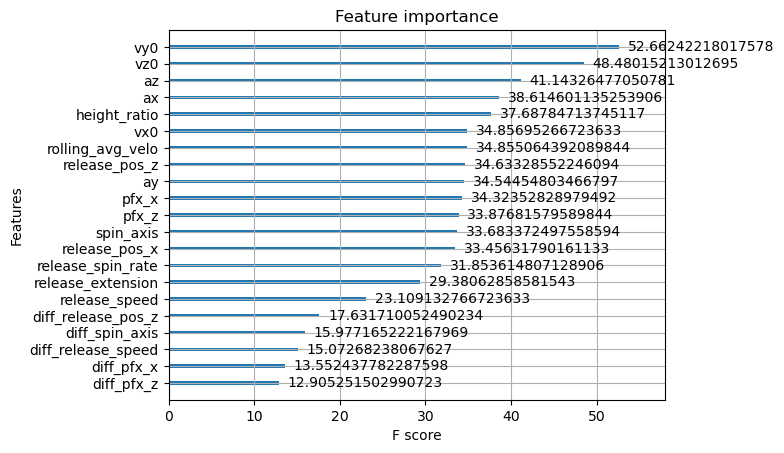

In [27]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

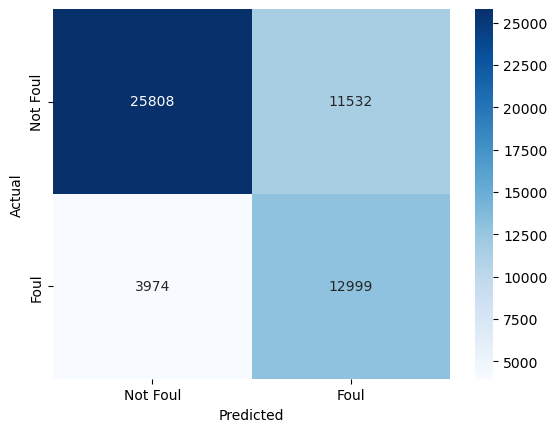

In [28]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [29]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [30]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [31]:
y_pred = final_model.predict(predictions)

In [32]:
testing_identifiers['xfoul'] = y_pred

In [33]:
testing_identifiers.head()

pitch_id_raw     xfoul
64    661032_608070_623474_4_62_9  0.471831
74    661032_680911_628452_4_64_9  0.553897
1124  661032_640458_663776_2_49_7  0.391453
1125  661032_640458_663776_2_49_7  0.390843
1126  661032_640458_663776_2_49_7  0.391453

In [34]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/foul_2022&3_xfoul.csv")